In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))



In [2]:
from data.dataset.codet_m4_cleaned import CoDeTM4Cleaned


In [3]:
train, val, test  = CoDeTM4Cleaned('../../data/codet_cleaned_20250812_201438/').get_dataset(['train','val','test'], columns='all', dynamic_split_sizing=False)


2025-09-03 23:05:02,500 - INFO - Initialized CoDeTM4Cleaned with cleaned data from: ../../data/codet_cleaned_20250812_201438/


2025-09-03 23:05:02,665 - INFO - Loaded train split: 405069 samples


2025-09-03 23:05:02,676 - INFO - Loaded val split: 47035 samples


2025-09-03 23:05:02,686 - INFO - Loaded test split: 47046 samples


In [4]:
from datasets import concatenate_datasets


In [5]:
codet = concatenate_datasets([train, val, test])


In [6]:
import tree_sitter_python as tspython
import tree_sitter_cpp as tscpp
import tree_sitter_java as tsjava
from tree_sitter import Parser, Language

TS_PYTHON = Language(tspython.language())
TS_JAVA = Language(tsjava.language())
TS_CPP = Language(tscpp.language())

PYTHON_PARSER, JAVA_PARSER, CPP_PARSER = Parser(language=TS_PYTHON), Parser(language=TS_JAVA), Parser(language=TS_CPP)

# Enable comment parsing by setting `parser.set_included_ranges` with full range of the source code
# This is a workaround: tree-sitter parsers by default include comments as nodes, 
# so no extra flag is needed, but if previously you filtered comments, do not filter now.


In [7]:
import matplotlib.pyplot as plt


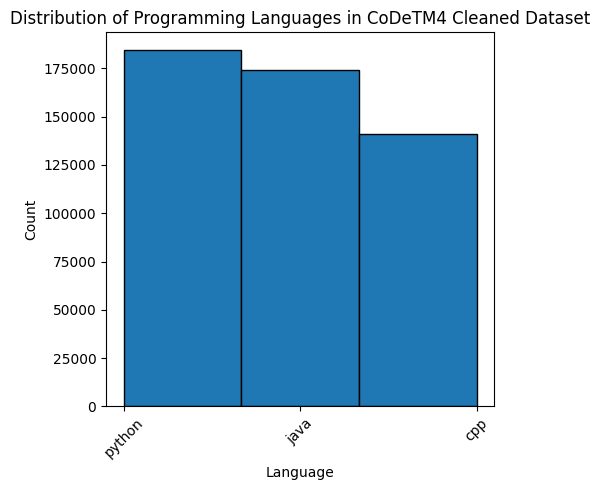

Python count: 184419
Java count: 173917
C++ count: 140814


In [8]:
language_counts = codet['language']
plt.figure(figsize=(5, 5))
plt.hist(language_counts, bins=len(set(language_counts)), edgecolor='black')
plt.xlabel('Language')
plt.ylabel('Count')
plt.title('Distribution of Programming Languages in CoDeTM4 Cleaned Dataset')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

python_count = language_counts.count("python")
java_count = language_counts.count("java")
cpp_count = language_counts.count("cpp")

print(f'Python count: {python_count}')
print(f'Java count: {java_count}')
print(f'C++ count: {cpp_count}')


In [9]:
def get_parser(language):
    match language:
        case 'python':
            return PYTHON_PARSER
        case 'java':
            return JAVA_PARSER
        case 'cpp':
            return CPP_PARSER
    raise ValueError(f"Unsupported language: {language}")


In [10]:
def create_tree(sample, code_key='cleaned_code'):
    language = sample['language']
    parser = get_parser(language)
    # Include full range to keep comments included
    code_bytes = bytes(sample[code_key], 'utf-8')
    # Use full range
    #parser.set_included_ranges([ (0, len(code_bytes)) ])
    tree = parser.parse(code_bytes)
    # Reset included ranges to None after parse to avoid side effects
    #parser.set_included_ranges(None)
    return tree


In [11]:
from tree_sitter import TreeCursor

def walk_tree(cursor: TreeCursor, depth=0):
    indent = '  ' * depth
    print(f"{indent}{cursor.node.type}")

    if cursor.goto_first_child():
        walk_tree(cursor, depth+1)
    
        while cursor.goto_next_sibling():
            walk_tree(cursor, depth+1)

        cursor.goto_parent()


In [12]:
from typing import Set

def get_node_types_from_tree(cursor: TreeCursor, types: Set[str]=None) -> Set[str]:
    if types is None:
        types = set()
    
    types.add(cursor.node.type)

    if cursor.goto_first_child():
        get_node_types_from_tree(cursor, types)
    
        while cursor.goto_next_sibling():
            get_node_types_from_tree(cursor, types)

        cursor.goto_parent()

    return types


In [13]:
def extract_types(sample):
    # Import everything needed inside the function
    import tree_sitter_python as tspython
    import tree_sitter_cpp as tscpp
    import tree_sitter_java as tsjava
    from tree_sitter import Parser, Language, TreeCursor
    from typing import Set
    
    # Create parsers locally
    TS_PYTHON = Language(tspython.language())
    TS_JAVA = Language(tsjava.language())
    TS_CPP = Language(tscpp.language())
    
    PYTHON_PARSER = Parser(language=TS_PYTHON)
    JAVA_PARSER = Parser(language=TS_JAVA)
    CPP_PARSER = Parser(language=TS_CPP)
    
    def get_parser(language):
        match language:
            case 'python':
                return PYTHON_PARSER
            case 'java':
                return JAVA_PARSER
            case 'cpp':
                return CPP_PARSER
        raise ValueError(f"Unsupported language: {language}")
    
    def get_node_types_from_tree(cursor: TreeCursor, types: Set[str]=None) -> Set[str]:
        if types is None:
            types = set()
        
        types.add(cursor.node.type)

        if cursor.goto_first_child():
            get_node_types_from_tree(cursor, types)
        
            while cursor.goto_next_sibling():
                get_node_types_from_tree(cursor, types)

            cursor.goto_parent()

        return types
    
    parser = get_parser(sample['language'])
    code_bytes = sample['code'].encode('utf-8')
    # parser.set_included_ranges([ (0, len(code_bytes)) ])
    tree = parser.parse(code_bytes)
    # parser.set_included_ranges(None)
    cursor = tree.walk()
    types = get_node_types_from_tree(cursor)
    return {"types": list(types)}

result = codet.map(extract_types, batched=False, num_proc=8)

all_types = set()
for tlist in result['types']:
    all_types.update(tlist)

print(f"Collected {len(all_types)} unique node types")


Collected 565 unique node types


In [14]:
all_types = sorted(list(all_types))


In [15]:
type_to_ind = {t: i for i, t in enumerate(all_types)}


In [16]:
len(all_types)

565

In [17]:
for t in all_types:
    print(t)



!
!=
"
""
#define
#elif
#else
#endif
#if
#ifdef
#ifndef
#include
%
%=
&
&&
&=
'
(
()
)
*
**
**=
*=
+
++
+=
,
-
--
-=
->
.
.*
...
/
//
//=
/=
:
::
:=
;
<
<<
<<=
<=
<=>
<>
=
==
>
>=
>>
>>=
>>>
>>>=
?
@
@interface
ERROR
L"
L'
NULL
R"
U"
[
[[
[]
\
]
]]
^
^=
_
__asm
__asm__
__attribute
__attribute__
__future__
__inline
__restrict__
__volatile__
abstract
abstract_array_declarator
abstract_function_declarator
abstract_parenthesized_declarator
abstract_pointer_declarator
abstract_reference_declarator
access_specifier
alias_declaration
aliased_import
alignas
alignas_qualifier
alignof
alignof_expression
and
annotated_type
annotation
annotation_argument_list
annotation_type_body
annotation_type_declaration
annotation_type_element_declaration
argument_list
array_access
array_creation_expression
array_declarator
array_initializer
array_type
as
as_pattern
as_pattern_target
asm
assert
assert_statement
assignment
assignment_expression
asterisk
async
attribute
attribute_declaration
attribute_specifie

In [18]:
from torch_geometric.data import Data
from typing import List, Tuple, Dict
from tree_sitter import Node


In [19]:
from torch_geometric.data import Data
from typing import List, Tuple, Dict
from torch import tensor, long as tlong
from tree_sitter import TreeCursor

def tree_to_graph(cursor: TreeCursor, id_map: Dict = None, next_id: int = 0, edges: List[Tuple[int, int]] = None) -> Tuple[List[Tuple[int, int]], Dict, int]:
    if edges is None:
        edges = []
    if id_map is None:
        id_map = {}

    # Assign ID to current node
    if cursor.node not in id_map:
        id_map[cursor.node] = next_id
        next_id += 1
    current_id = id_map[cursor.node]

    if cursor.goto_first_child():
        # Process first child
        if cursor.node not in id_map:
            id_map[cursor.node] = next_id
            next_id += 1
        child_id = id_map[cursor.node]
        edges.append((current_id, child_id))
        edges, id_map, next_id = tree_to_graph(cursor, id_map, next_id, edges)
        
        # Process siblings
        while cursor.goto_next_sibling():
            if cursor.node not in id_map:
                id_map[cursor.node] = next_id
                next_id += 1
            child_id = id_map[cursor.node]
            edges.append((current_id, child_id))
            edges, id_map, next_id = tree_to_graph(cursor, id_map, next_id, edges)
        
        cursor.goto_parent()

    return edges, id_map, next_id


In [20]:
from tqdm import tqdm


In [21]:
def create_graph(sample, code_key='cleaned_code'):
    tree = create_tree(sample, code_key=code_key)
    edges, id_map, _ = tree_to_graph(tree.walk())
    edge_index = tensor(edges, dtype=tlong).t().contiguous()
    x = [type_to_ind[node.type] for node, _ in sorted(id_map.items(), key=lambda kv: kv[1])]
    x = tensor(x, dtype=tlong)
    y = tensor([sample['target_binary']], dtype=tlong)

    graph_features = tensor(list(sample['features'].values()))
    
    metadata = {
        'language': sample['language'],
        'target': sample['target'],
        'target_binary': sample['target_binary'],
        'code': sample['code'],
        'cleaned_code': sample['cleaned_code']
    }
    
    data = Data(
        x=x, 
        y=y, 
        edge_index=edge_index, 
        graph_features=graph_features,
        metadata=metadata
    )    
    return data



In [22]:
codet


Dataset({
    features: ['code', 'language', 'model', 'split', 'target', 'source', 'features', 'cleaned_code', '__index_level_0__', 'target_binary'],
    num_rows: 499150
})

In [23]:
from torch_geometric.data import Data
from torch import tensor, long as tlong
from typing import List, Dict, Tuple
from collections import defaultdict, deque
import torch
def compute_depths(num_nodes: int, edges: List[Tuple[int, int]]) -> tlong:
    """Compute depth (distance from root) for each node."""
    depths = torch.zeros(num_nodes, dtype=torch.long)
    tree = defaultdict(list)
    for parent, child in edges:
        tree[parent].append(child)
    visited = [False] * num_nodes
    queue = deque([0])  # assume root node has ID 0
    visited[0] = True
    while queue:
        node = queue.popleft()
        for child in tree[node]:
            if not visited[child]:
                depths[child] = depths[node] + 1
                visited[child] = True
                queue.append(child)
    return depths

def compute_child_indices(num_nodes: int, edges: List[Tuple[int, int]]) -> tlong:
    """Compute sibling index for each node (order among its siblings)."""
    child_idx = torch.zeros(num_nodes, dtype=torch.long)
    tree = defaultdict(list)
    for parent, child in edges:
        tree[parent].append(child)
    for parent, children in tree.items():
        for i, child in enumerate(children):
            child_idx[child] = i
    return child_idx

def create_graph(sample, code_key='cleaned_code'):
    """Create a PyG Data object with node type, depth, and child index embeddings."""
    tree = create_tree(sample, code_key=code_key)
    edges, id_map, _ = tree_to_graph(tree.walk())
    
    edge_index = tensor(edges, dtype=tlong).t().contiguous()
    
    # Node type IDs
    x = [type_to_ind[node.type] for node, _ in sorted(id_map.items(), key=lambda kv: kv[1])]
    x = tensor(x, dtype=tlong)
    num_nodes = x.size(0)

    # Compute depth and child index
    node_depth = compute_depths(num_nodes, edges)
    child_index = compute_child_indices(num_nodes, edges)
    
    # Target
    y = tensor([sample['target_binary']], dtype=tlong)
    
    # Graph features
    graph_features = tensor(list(sample['features'].values()))
    
    # Metadata
    metadata = {
        'language': sample['language'],
        'target': sample['target'],
        'target_binary': sample['target_binary'],
        'code': sample['code'],
        'cleaned_code': sample['cleaned_code']
    }

    data = Data(
        x=x,
        y=y,
        edge_index=edge_index,
        node_depth=node_depth,
        child_index=child_index,
        graph_features=graph_features,
        metadata=metadata
    )
    
    return data


def create_graphs(dataset, desc_keyword, code_key='cleaned_code'):
    graphs = []

    for i, sample in enumerate(tqdm(dataset, desc=f'Creating {desc_keyword} graphs')):
        data = create_graph(sample, code_key)
        graphs.append(data)

    return graphs
    


In [24]:
from torch_geometric.data import Data
from torch import save
import gc

train_graphs = create_graphs(train, 'train', 'code')
save(train_graphs, '../../data/codet_graphs/train_graphs_cleaned_comments_depth.pt')
del train, train_graphs
gc.collect()
val_graphs = create_graphs(val, 'val', 'code')
save(val_graphs, '../../data/codet_graphs/val_graphs_cleaned_comments_depth.pt')
del val, val_graphs
gc.collect()
test_graphs = create_graphs(test, 'test', 'code')
save(test_graphs, '../../data/codet_graphs/test_graphs_cleaned_comments_depth.pt')
del test, test_graphs
gc.collect()
save(type_to_ind, '../../data/codet_graphs/type_to_ind_cleaned_comments_depth.pt')


Creating train graphs:   0%|                                                                | 0/405069 [00:00<?, ?it/s]

Creating train graphs:   0%|                                                      | 34/405069 [00:00<19:57, 338.22it/s]

Creating train graphs:   0%|                                                      | 71/405069 [00:00<18:54, 356.87it/s]

Creating train graphs:   0%|                                                     | 114/405069 [00:00<17:27, 386.68it/s]

Creating train graphs:   0%|                                                     | 154/405069 [00:00<17:13, 391.91it/s]

Creating train graphs:   0%|                                                     | 194/405069 [00:00<17:42, 381.13it/s]

Creating train graphs:   0%|                                                     | 242/405069 [00:00<16:18, 413.88it/s]

Creating train graphs:   0%|                                                     | 284/405069 [00:00<16:29, 409.27it/s]

Creating train graphs:   0%|                                                     | 326/405069 [00:00<16:57, 397.76it/s]

Creating train graphs:   0%|                                                     | 369/405069 [00:00<16:39, 405.00it/s]

Creating train graphs:   0%|                                                     | 410/405069 [00:01<16:50, 400.51it/s]

Creating train graphs:   0%|                                                     | 454/405069 [00:01<16:36, 406.19it/s]

Creating train graphs:   0%|                                                     | 495/405069 [00:01<17:05, 394.54it/s]

Creating train graphs:   0%|                                                     | 540/405069 [00:01<22:04, 305.44it/s]

Creating train graphs:   0%|                                                     | 584/405069 [00:01<20:08, 334.72it/s]

Creating train graphs:   0%|                                                     | 631/405069 [00:01<18:22, 366.72it/s]

Creating train graphs:   0%|                                                     | 671/405069 [00:01<18:11, 370.59it/s]

Creating train graphs:   0%|                                                     | 710/405069 [00:01<19:05, 352.96it/s]

Creating train graphs:   0%|                                                     | 752/405069 [00:02<18:13, 369.80it/s]

Creating train graphs:   0%|                                                     | 796/405069 [00:02<17:19, 389.09it/s]

Creating train graphs:   0%|                                                     | 841/405069 [00:02<16:57, 397.30it/s]

Creating train graphs:   0%|                                                     | 886/405069 [00:02<16:48, 400.84it/s]

Creating train graphs:   0%|                                                     | 927/405069 [00:02<17:38, 381.89it/s]

Creating train graphs:   0%|▏                                                    | 975/405069 [00:02<16:33, 406.72it/s]

Creating train graphs:   0%|▏                                                   | 1019/405069 [00:02<16:16, 413.76it/s]

Creating train graphs:   0%|▏                                                   | 1069/405069 [00:02<15:26, 435.92it/s]

Creating train graphs:   0%|▏                                                   | 1113/405069 [00:02<15:29, 434.59it/s]

Creating train graphs:   0%|▏                                                   | 1161/405069 [00:02<15:07, 445.20it/s]

Creating train graphs:   0%|▏                                                   | 1206/405069 [00:03<17:37, 381.86it/s]

Creating train graphs:   0%|▏                                                   | 1247/405069 [00:03<17:20, 388.24it/s]

Creating train graphs:   0%|▏                                                   | 1288/405069 [00:03<18:30, 363.46it/s]

Creating train graphs:   0%|▏                                                   | 1335/405069 [00:03<17:19, 388.53it/s]

Creating train graphs:   0%|▏                                                   | 1377/405069 [00:03<17:32, 383.52it/s]

Creating train graphs:   0%|▏                                                   | 1429/405069 [00:03<15:59, 420.81it/s]

Creating train graphs:   0%|▏                                                   | 1472/405069 [00:03<16:54, 397.71it/s]

Creating train graphs:   0%|▏                                                   | 1513/405069 [00:03<18:06, 371.58it/s]

Creating train graphs:   0%|▏                                                   | 1553/405069 [00:04<18:09, 370.28it/s]

Creating train graphs:   0%|▏                                                   | 1594/405069 [00:04<17:38, 381.03it/s]

Creating train graphs:   0%|▏                                                   | 1633/405069 [00:04<18:30, 363.27it/s]

Creating train graphs:   0%|▏                                                   | 1677/405069 [00:04<17:32, 383.24it/s]

Creating train graphs:   0%|▏                                                   | 1724/405069 [00:04<16:46, 400.84it/s]

Creating train graphs:   0%|▏                                                   | 1765/405069 [00:04<16:59, 395.60it/s]

Creating train graphs:   0%|▏                                                   | 1815/405069 [00:04<15:51, 424.02it/s]

Creating train graphs:   0%|▏                                                   | 1858/405069 [00:04<16:19, 411.53it/s]

Creating train graphs:   0%|▏                                                   | 1902/405069 [00:04<16:03, 418.43it/s]

Creating train graphs:   0%|▏                                                   | 1945/405069 [00:04<16:15, 413.43it/s]

Creating train graphs:   0%|▎                                                   | 1987/405069 [00:05<16:57, 395.96it/s]

Creating train graphs:   1%|▎                                                   | 2027/405069 [00:05<17:12, 390.50it/s]

Creating train graphs:   1%|▎                                                   | 2067/405069 [00:05<17:28, 384.48it/s]

Creating train graphs:   1%|▎                                                   | 2108/405069 [00:05<17:23, 386.24it/s]

Creating train graphs:   1%|▎                                                   | 2147/405069 [00:05<18:37, 360.55it/s]

Creating train graphs:   1%|▎                                                   | 2191/405069 [00:05<17:39, 380.32it/s]

Creating train graphs:   1%|▎                                                   | 2230/405069 [00:05<17:34, 381.97it/s]

Creating train graphs:   1%|▎                                                   | 2269/405069 [00:05<19:52, 337.89it/s]

Creating train graphs:   1%|▎                                                   | 2313/405069 [00:05<18:29, 362.96it/s]

Creating train graphs:   1%|▎                                                   | 2351/405069 [00:06<19:31, 343.66it/s]

Creating train graphs:   1%|▎                                                   | 2387/405069 [00:06<19:44, 339.85it/s]

Creating train graphs:   1%|▎                                                   | 2434/405069 [00:06<17:56, 374.17it/s]

Creating train graphs:   1%|▎                                                   | 2475/405069 [00:06<17:30, 383.09it/s]

Creating train graphs:   1%|▎                                                   | 2521/405069 [00:06<16:34, 404.63it/s]

Creating train graphs:   1%|▎                                                   | 2562/405069 [00:06<18:45, 357.64it/s]

Creating train graphs:   1%|▎                                                   | 2600/405069 [00:06<19:14, 348.72it/s]

Creating train graphs:   1%|▎                                                   | 2648/405069 [00:06<17:53, 374.80it/s]

Creating train graphs:   1%|▎                                                   | 2687/405069 [00:07<18:02, 371.85it/s]

Creating train graphs:   1%|▎                                                   | 2725/405069 [00:07<18:19, 366.01it/s]

Creating train graphs:   1%|▎                                                   | 2762/405069 [00:07<18:55, 354.30it/s]

Creating train graphs:   1%|▎                                                   | 2798/405069 [00:07<19:02, 351.97it/s]

Creating train graphs:   1%|▎                                                   | 2839/405069 [00:07<18:15, 367.26it/s]

Creating train graphs:   1%|▎                                                   | 2880/405069 [00:07<17:39, 379.48it/s]

Creating train graphs:   1%|▍                                                   | 2926/405069 [00:07<16:41, 401.67it/s]

Creating train graphs:   1%|▍                                                   | 2967/405069 [00:07<17:15, 388.20it/s]

Creating train graphs:   1%|▍                                                   | 3009/405069 [00:07<16:55, 395.91it/s]

Creating train graphs:   1%|▍                                                   | 3058/405069 [00:07<15:50, 423.16it/s]

Creating train graphs:   1%|▍                                                   | 3101/405069 [00:08<16:15, 411.89it/s]

Creating train graphs:   1%|▍                                                   | 3143/405069 [00:08<16:10, 414.22it/s]

Creating train graphs:   1%|▍                                                   | 3185/405069 [00:08<17:25, 384.49it/s]

Creating train graphs:   1%|▍                                                   | 3227/405069 [00:08<17:10, 390.02it/s]

Creating train graphs:   1%|▍                                                   | 3267/405069 [00:08<17:14, 388.44it/s]

Creating train graphs:   1%|▍                                                   | 3308/405069 [00:08<17:01, 393.45it/s]

Creating train graphs:   1%|▍                                                   | 3348/405069 [00:08<17:19, 386.41it/s]

Creating train graphs:   1%|▍                                                   | 3388/405069 [00:08<17:12, 389.19it/s]

Creating train graphs:   1%|▍                                                   | 3428/405069 [00:08<17:04, 392.01it/s]

Creating train graphs:   1%|▍                                                   | 3478/405069 [00:09<15:50, 422.42it/s]

Creating train graphs:   1%|▍                                                   | 3524/405069 [00:09<15:37, 428.44it/s]

Creating train graphs:   1%|▍                                                   | 3567/405069 [00:09<15:55, 420.26it/s]

Creating train graphs:   1%|▍                                                   | 3613/405069 [00:09<15:32, 430.58it/s]

Creating train graphs:   1%|▍                                                   | 3657/405069 [00:09<18:36, 359.53it/s]

Creating train graphs:   1%|▍                                                   | 3699/405069 [00:09<17:55, 373.21it/s]

Creating train graphs:   1%|▍                                                   | 3738/405069 [00:09<18:33, 360.31it/s]

Creating train graphs:   1%|▍                                                   | 3790/405069 [00:09<16:38, 401.99it/s]

Creating train graphs:   1%|▍                                                   | 3840/405069 [00:09<15:35, 429.05it/s]

Creating train graphs:   1%|▍                                                   | 3890/405069 [00:10<15:33, 429.67it/s]

Creating train graphs:   1%|▌                                                   | 3934/405069 [00:10<20:45, 322.09it/s]

Creating train graphs:   1%|▌                                                   | 3978/405069 [00:10<19:11, 348.25it/s]

Creating train graphs:   1%|▌                                                   | 4027/405069 [00:10<17:29, 382.14it/s]

Creating train graphs:   1%|▌                                                   | 4074/405069 [00:10<16:30, 404.93it/s]

Creating train graphs:   1%|▌                                                   | 4121/405069 [00:10<15:51, 421.39it/s]

Creating train graphs:   1%|▌                                                   | 4166/405069 [00:10<15:41, 425.80it/s]

Creating train graphs:   1%|▌                                                   | 4211/405069 [00:10<16:39, 400.91it/s]

Creating train graphs:   1%|▌                                                   | 4256/405069 [00:10<16:15, 410.92it/s]

Creating train graphs:   1%|▌                                                   | 4299/405069 [00:11<17:23, 384.14it/s]

Creating train graphs:   1%|▌                                                   | 4339/405069 [00:11<18:23, 363.05it/s]

Creating train graphs:   1%|▌                                                   | 4379/405069 [00:11<18:03, 369.87it/s]

Creating train graphs:   1%|▌                                                   | 4420/405069 [00:11<17:32, 380.80it/s]

Creating train graphs:   1%|▌                                                   | 4459/405069 [00:11<17:39, 378.08it/s]

Creating train graphs:   1%|▌                                                   | 4499/405069 [00:11<17:48, 374.74it/s]

Creating train graphs:   1%|▌                                                   | 4537/405069 [00:11<18:38, 358.01it/s]

Creating train graphs:   1%|▌                                                   | 4575/405069 [00:11<18:22, 363.11it/s]

Creating train graphs:   1%|▌                                                   | 4616/405069 [00:11<17:55, 372.18it/s]

Creating train graphs:   1%|▌                                                   | 4654/405069 [00:12<17:52, 373.35it/s]

Creating train graphs:   1%|▌                                                   | 4699/405069 [00:12<17:03, 391.00it/s]

Creating train graphs:   1%|▌                                                   | 4739/405069 [00:12<17:17, 385.78it/s]

Creating train graphs:   1%|▌                                                   | 4778/405069 [00:12<20:55, 318.84it/s]

Creating train graphs:   1%|▌                                                   | 4813/405069 [00:12<20:31, 325.10it/s]

Creating train graphs:   1%|▌                                                   | 4856/405069 [00:12<18:54, 352.90it/s]

Creating train graphs:   1%|▋                                                   | 4893/405069 [00:12<18:42, 356.62it/s]

Creating train graphs:   1%|▋                                                   | 4933/405069 [00:12<18:04, 368.82it/s]

Creating train graphs:   1%|▋                                                   | 4974/405069 [00:12<17:40, 377.38it/s]

Creating train graphs:   1%|▋                                                   | 5023/405069 [00:13<16:32, 402.92it/s]

Creating train graphs:   1%|▋                                                   | 5064/405069 [00:13<16:33, 402.64it/s]

Creating train graphs:   1%|▋                                                   | 5105/405069 [00:13<17:16, 385.72it/s]

Creating train graphs:   1%|▋                                                   | 5147/405069 [00:13<16:54, 394.32it/s]

Creating train graphs:   1%|▋                                                   | 5196/405069 [00:13<15:53, 419.43it/s]

Creating train graphs:   1%|▋                                                   | 5239/405069 [00:13<16:11, 411.75it/s]

Creating train graphs:   1%|▋                                                   | 5290/405069 [00:13<15:16, 436.25it/s]

Creating train graphs:   1%|▋                                                   | 5334/405069 [00:13<16:04, 414.53it/s]

Creating train graphs:   1%|▋                                                   | 5376/405069 [00:13<16:22, 406.90it/s]

Creating train graphs:   1%|▋                                                   | 5417/405069 [00:14<18:32, 359.11it/s]

Creating train graphs:   1%|▋                                                   | 5463/405069 [00:14<17:21, 383.54it/s]

Creating train graphs:   1%|▋                                                   | 5504/405069 [00:14<17:02, 390.72it/s]

Creating train graphs:   1%|▋                                                   | 5546/405069 [00:14<16:49, 395.59it/s]

Creating train graphs:   1%|▋                                                   | 5592/405069 [00:14<16:05, 413.85it/s]

Creating train graphs:   1%|▋                                                   | 5636/405069 [00:14<16:04, 414.23it/s]

Creating train graphs:   1%|▋                                                   | 5686/405069 [00:14<15:12, 437.68it/s]

Creating train graphs:   1%|▋                                                   | 5731/405069 [00:14<15:12, 437.45it/s]

Creating train graphs:   1%|▋                                                   | 5775/405069 [00:14<16:52, 394.44it/s]

Creating train graphs:   1%|▋                                                   | 5816/405069 [00:15<16:49, 395.45it/s]

Creating train graphs:   1%|▊                                                   | 5861/405069 [00:15<16:17, 408.39it/s]

Creating train graphs:   1%|▊                                                   | 5903/405069 [00:15<16:31, 402.54it/s]

Creating train graphs:   1%|▊                                                   | 5945/405069 [00:15<16:52, 394.08it/s]

Creating train graphs:   1%|▊                                                   | 5985/405069 [00:15<16:54, 393.53it/s]

Creating train graphs:   1%|▊                                                   | 6036/405069 [00:15<15:45, 421.99it/s]

Creating train graphs:   2%|▊                                                   | 6079/405069 [00:15<17:04, 389.56it/s]

Creating train graphs:   2%|▊                                                   | 6119/405069 [00:15<17:10, 387.12it/s]

Creating train graphs:   2%|▊                                                   | 6162/405069 [00:15<17:07, 388.25it/s]

Creating train graphs:   2%|▊                                                   | 6205/405069 [00:16<16:42, 397.68it/s]

Creating train graphs:   2%|▊                                                   | 6251/405069 [00:16<16:00, 415.37it/s]

Creating train graphs:   2%|▊                                                   | 6296/405069 [00:16<15:40, 424.14it/s]

Creating train graphs:   2%|▊                                                   | 6340/405069 [00:16<15:32, 427.52it/s]

Creating train graphs:   2%|▊                                                   | 6388/405069 [00:16<15:00, 442.91it/s]

Creating train graphs:   2%|▊                                                   | 6436/405069 [00:16<14:40, 452.52it/s]

Creating train graphs:   2%|▊                                                   | 6482/405069 [00:16<16:59, 391.06it/s]

Creating train graphs:   2%|▊                                                   | 6534/405069 [00:16<15:44, 422.07it/s]

Creating train graphs:   2%|▊                                                   | 6578/405069 [00:16<17:07, 387.65it/s]

Creating train graphs:   2%|▊                                                   | 6630/405069 [00:17<15:43, 422.38it/s]

Creating train graphs:   2%|▊                                                   | 6677/405069 [00:17<15:15, 435.36it/s]

Creating train graphs:   2%|▊                                                   | 6722/405069 [00:17<16:04, 412.85it/s]

Creating train graphs:   2%|▊                                                   | 6777/405069 [00:17<14:49, 447.89it/s]

Creating train graphs:   2%|▉                                                   | 6823/405069 [00:17<16:26, 403.83it/s]

Creating train graphs:   2%|▉                                                   | 6865/405069 [00:17<17:27, 380.06it/s]

Creating train graphs:   2%|▉                                                   | 6905/405069 [00:17<17:18, 383.24it/s]

Creating train graphs:   2%|▉                                                   | 6945/405069 [00:17<17:26, 380.58it/s]

Creating train graphs:   2%|▉                                                   | 6987/405069 [00:17<18:06, 366.28it/s]

Creating train graphs:   2%|▉                                                   | 7025/405069 [00:18<18:18, 362.19it/s]

Creating train graphs:   2%|▉                                                   | 7062/405069 [00:18<18:45, 353.71it/s]

Creating train graphs:   2%|▉                                                   | 7105/405069 [00:18<17:45, 373.62it/s]

Creating train graphs:   2%|▉                                                   | 7153/405069 [00:18<16:28, 402.40it/s]

Creating train graphs:   2%|▉                                                   | 7194/405069 [00:18<16:43, 396.63it/s]

Creating train graphs:   2%|▉                                                   | 7236/405069 [00:18<16:32, 401.02it/s]

Creating train graphs:   2%|▉                                                   | 7277/405069 [00:18<16:45, 395.62it/s]

Creating train graphs:   2%|▉                                                   | 7326/405069 [00:18<15:51, 417.98it/s]

Creating train graphs:   2%|▉                                                   | 7369/405069 [00:18<15:49, 419.03it/s]

Creating train graphs:   2%|▉                                                   | 7413/405069 [00:18<15:43, 421.46it/s]

Creating train graphs:   2%|▉                                                   | 7459/405069 [00:19<15:18, 432.71it/s]

Creating train graphs:   2%|▉                                                   | 7503/405069 [00:19<15:38, 423.63it/s]

Creating train graphs:   2%|▉                                                   | 7546/405069 [00:19<16:28, 402.12it/s]

Creating train graphs:   2%|▉                                                   | 7587/405069 [00:19<16:45, 395.42it/s]

Creating train graphs:   2%|▉                                                   | 7630/405069 [00:19<16:20, 405.19it/s]

Creating train graphs:   2%|▉                                                   | 7678/405069 [00:19<15:39, 423.05it/s]

Creating train graphs:   2%|▉                                                   | 7728/405069 [00:19<14:54, 444.03it/s]

Creating train graphs:   2%|▉                                                   | 7773/405069 [00:19<14:59, 441.90it/s]

Creating train graphs:   2%|█                                                   | 7818/405069 [00:19<16:02, 412.88it/s]

Creating train graphs:   2%|█                                                   | 7866/405069 [00:20<15:22, 430.45it/s]

Creating train graphs:   2%|█                                                   | 7910/405069 [00:20<17:27, 379.15it/s]

Creating train graphs:   2%|█                                                   | 7950/405069 [00:20<17:42, 373.83it/s]

Creating train graphs:   2%|█                                                   | 7995/405069 [00:20<16:47, 394.19it/s]

Creating train graphs:   2%|█                                                   | 8044/405069 [00:20<15:49, 418.35it/s]

Creating train graphs:   2%|█                                                   | 8091/405069 [00:20<15:19, 431.69it/s]

Creating train graphs:   2%|█                                                   | 8135/405069 [00:20<16:30, 400.77it/s]

Creating train graphs:   2%|█                                                   | 8176/405069 [00:20<17:04, 387.37it/s]

Creating train graphs:   2%|█                                                   | 8216/405069 [00:20<17:50, 370.56it/s]

Creating train graphs:   2%|█                                                   | 8263/405069 [00:21<16:41, 396.36it/s]

Creating train graphs:   2%|█                                                   | 8314/405069 [00:21<15:27, 427.95it/s]

Creating train graphs:   2%|█                                                   | 8358/405069 [00:21<15:24, 428.94it/s]

Creating train graphs:   2%|█                                                   | 8402/405069 [00:21<18:09, 364.06it/s]

Creating train graphs:   2%|█                                                   | 8443/405069 [00:21<17:48, 371.10it/s]

Creating train graphs:   2%|█                                                   | 8491/405069 [00:21<16:31, 400.08it/s]

Creating train graphs:   2%|█                                                   | 8539/405069 [00:21<15:42, 420.94it/s]

Creating train graphs:   2%|█                                                   | 8583/405069 [00:21<16:19, 404.64it/s]

Creating train graphs:   2%|█                                                   | 8631/405069 [00:21<15:34, 424.30it/s]

Creating train graphs:   2%|█                                                   | 8676/405069 [00:22<15:23, 429.14it/s]

Creating train graphs:   2%|█                                                   | 8723/405069 [00:22<15:06, 437.09it/s]

Creating train graphs:   2%|█▏                                                  | 8768/405069 [00:22<15:19, 430.87it/s]

Creating train graphs:   2%|█▏                                                  | 8812/405069 [00:22<15:58, 413.31it/s]

Creating train graphs:   2%|█▏                                                  | 8854/405069 [00:22<19:18, 342.08it/s]

Creating train graphs:   2%|█▏                                                  | 8891/405069 [00:22<20:02, 329.36it/s]

Creating train graphs:   2%|█▏                                                  | 8939/405069 [00:22<17:58, 367.19it/s]

Creating train graphs:   2%|█▏                                                  | 8978/405069 [00:22<18:14, 361.75it/s]

Creating train graphs:   2%|█▏                                                  | 9029/405069 [00:23<16:37, 397.18it/s]

Creating train graphs:   2%|█▏                                                  | 9070/405069 [00:23<16:30, 399.60it/s]

Creating train graphs:   2%|█▏                                                  | 9124/405069 [00:23<15:11, 434.19it/s]

Creating train graphs:   2%|█▏                                                  | 9169/405069 [00:23<16:32, 398.99it/s]

Creating train graphs:   2%|█▏                                                  | 9210/405069 [00:23<16:48, 392.43it/s]

Creating train graphs:   2%|█▏                                                  | 9259/405069 [00:23<16:23, 402.56it/s]

Creating train graphs:   2%|█▏                                                  | 9300/405069 [00:23<16:34, 398.07it/s]

Creating train graphs:   2%|█▏                                                  | 9341/405069 [00:23<16:53, 390.56it/s]

Creating train graphs:   2%|█▏                                                  | 9390/405069 [00:23<15:46, 418.21it/s]

Creating train graphs:   2%|█▏                                                  | 9433/405069 [00:24<16:47, 392.54it/s]

Creating train graphs:   2%|█▏                                                  | 9473/405069 [00:24<17:12, 383.03it/s]

Creating train graphs:   2%|█▏                                                  | 9515/405069 [00:24<16:48, 392.14it/s]

Creating train graphs:   2%|█▏                                                  | 9560/405069 [00:24<16:24, 401.66it/s]

Creating train graphs:   2%|█▏                                                  | 9601/405069 [00:24<17:17, 381.31it/s]

Creating train graphs:   2%|█▏                                                  | 9640/405069 [00:24<17:30, 376.42it/s]

Creating train graphs:   2%|█▏                                                  | 9684/405069 [00:24<16:45, 393.09it/s]

Creating train graphs:   2%|█▏                                                  | 9734/405069 [00:24<15:36, 422.32it/s]

Creating train graphs:   2%|█▎                                                  | 9777/405069 [00:24<17:23, 378.65it/s]

Creating train graphs:   2%|█▎                                                  | 9816/405069 [00:25<18:00, 365.96it/s]

Creating train graphs:   2%|█▎                                                  | 9855/405069 [00:25<17:49, 369.45it/s]

Creating train graphs:   2%|█▎                                                  | 9896/405069 [00:25<17:21, 379.60it/s]

Creating train graphs:   2%|█▎                                                  | 9938/405069 [00:25<16:56, 388.81it/s]

Creating train graphs:   2%|█▎                                                  | 9978/405069 [00:25<17:10, 383.23it/s]

Creating train graphs:   2%|█▎                                                 | 10029/405069 [00:25<15:44, 418.24it/s]

Creating train graphs:   2%|█▎                                                 | 10072/405069 [00:25<18:27, 356.67it/s]

Creating train graphs:   2%|█▎                                                 | 10110/405069 [00:25<19:44, 333.36it/s]

Creating train graphs:   3%|█▎                                                 | 10148/405069 [00:25<19:04, 345.18it/s]

Creating train graphs:   3%|█▎                                                 | 10191/405069 [00:26<18:10, 361.97it/s]

Creating train graphs:   3%|█▎                                                 | 10236/405069 [00:26<17:08, 383.84it/s]

Creating train graphs:   3%|█▎                                                 | 10276/405069 [00:26<18:13, 361.15it/s]

Creating train graphs:   3%|█▎                                                 | 10316/405069 [00:26<17:47, 369.66it/s]

Creating train graphs:   3%|█▎                                                 | 10354/405069 [00:26<19:28, 337.83it/s]

Creating train graphs:   3%|█▎                                                 | 10389/405069 [00:26<21:01, 312.91it/s]

Creating train graphs:   3%|█▎                                                 | 10434/405069 [00:26<18:59, 346.42it/s]

Creating train graphs:   3%|█▎                                                 | 10479/405069 [00:26<17:37, 373.16it/s]

Creating train graphs:   3%|█▎                                                 | 10518/405069 [00:27<18:53, 348.02it/s]

Creating train graphs:   3%|█▎                                                 | 10555/405069 [00:27<18:34, 353.88it/s]

Creating train graphs:   3%|█▎                                                 | 10594/405069 [00:27<18:07, 362.84it/s]

Creating train graphs:   3%|█▎                                                 | 10635/405069 [00:27<17:31, 375.08it/s]

Creating train graphs:   3%|█▎                                                 | 10680/405069 [00:27<16:34, 396.56it/s]

Creating train graphs:   3%|█▎                                                 | 10721/405069 [00:27<16:44, 392.48it/s]

Creating train graphs:   3%|█▎                                                 | 10764/405069 [00:27<16:34, 396.45it/s]

Creating train graphs:   3%|█▎                                                 | 10807/405069 [00:27<16:13, 404.97it/s]

Creating train graphs:   3%|█▎                                                 | 10850/405069 [00:27<16:46, 391.72it/s]

Creating train graphs:   3%|█▎                                                 | 10892/405069 [00:27<16:28, 398.60it/s]

Creating train graphs:   3%|█▍                                                 | 10933/405069 [00:28<16:54, 388.47it/s]

Creating train graphs:   3%|█▍                                                 | 10976/405069 [00:28<16:38, 394.67it/s]

Creating train graphs:   3%|█▍                                                 | 11020/405069 [00:28<16:23, 400.75it/s]

Creating train graphs:   3%|█▍                                                 | 11061/405069 [00:28<16:39, 394.36it/s]

Creating train graphs:   3%|█▍                                                 | 11101/405069 [00:28<17:31, 374.57it/s]

Creating train graphs:   3%|█▍                                                 | 11143/405069 [00:28<17:14, 380.86it/s]

Creating train graphs:   3%|█▍                                                 | 11189/405069 [00:28<16:22, 400.87it/s]

Creating train graphs:   3%|█▍                                                 | 11230/405069 [00:28<16:52, 389.03it/s]

Creating train graphs:   3%|█▍                                                 | 11270/405069 [00:28<17:55, 366.28it/s]

Creating train graphs:   3%|█▍                                                 | 11310/405069 [00:29<17:28, 375.51it/s]

Creating train graphs:   3%|█▍                                                 | 11348/405069 [00:29<24:36, 266.61it/s]

Creating train graphs:   3%|█▍                                                 | 11395/405069 [00:29<21:14, 308.87it/s]

Creating train graphs:   3%|█▍                                                 | 11434/405069 [00:29<20:07, 325.89it/s]

Creating train graphs:   3%|█▍                                                 | 11471/405069 [00:29<19:33, 335.35it/s]

Creating train graphs:   3%|█▍                                                 | 11514/405069 [00:29<18:14, 359.42it/s]

Creating train graphs:   3%|█▍                                                 | 11560/405069 [00:29<17:35, 372.66it/s]

Creating train graphs:   3%|█▍                                                 | 11605/405069 [00:29<16:39, 393.81it/s]

Creating train graphs:   3%|█▍                                                 | 11646/405069 [00:30<16:47, 390.68it/s]

Creating train graphs:   3%|█▍                                                 | 11686/405069 [00:30<16:59, 385.69it/s]

Creating train graphs:   3%|█▍                                                 | 11726/405069 [00:30<18:37, 351.84it/s]

Creating train graphs:   3%|█▍                                                 | 11765/405069 [00:30<18:06, 362.06it/s]

Creating train graphs:   3%|█▍                                                 | 11817/405069 [00:30<16:11, 404.63it/s]

Creating train graphs:   3%|█▍                                                 | 11859/405069 [00:30<17:01, 385.03it/s]

Creating train graphs:   3%|█▍                                                 | 11899/405069 [00:30<16:53, 388.09it/s]

Creating train graphs:   3%|█▌                                                 | 11939/405069 [00:30<17:40, 370.56it/s]

Creating train graphs:   3%|█▌                                                 | 11984/405069 [00:30<16:41, 392.48it/s]

Creating train graphs:   3%|█▌                                                 | 12024/405069 [00:31<17:07, 382.70it/s]

Creating train graphs:   3%|█▌                                                 | 12067/405069 [00:31<16:37, 393.80it/s]

Creating train graphs:   3%|█▌                                                 | 12112/405069 [00:31<15:58, 409.85it/s]

Creating train graphs:   3%|█▌                                                 | 12165/405069 [00:31<14:46, 443.39it/s]

Creating train graphs:   3%|█▌                                                 | 12215/405069 [00:31<14:21, 455.93it/s]

Creating train graphs:   3%|█▌                                                 | 12261/405069 [00:31<16:30, 396.74it/s]

Creating train graphs:   3%|█▌                                                 | 12315/405069 [00:31<15:10, 431.44it/s]

Creating train graphs:   3%|█▌                                                 | 12360/405069 [00:31<17:00, 384.86it/s]

Creating train graphs:   3%|█▌                                                 | 12410/405069 [00:31<15:47, 414.40it/s]

Creating train graphs:   3%|█▌                                                 | 12454/405069 [00:32<15:34, 420.14it/s]

Creating train graphs:   3%|█▌                                                 | 12498/405069 [00:32<15:35, 419.83it/s]

Creating train graphs:   3%|█▌                                                 | 12542/405069 [00:32<15:30, 421.93it/s]

Creating train graphs:   3%|█▌                                                 | 12585/405069 [00:32<15:51, 412.50it/s]

Creating train graphs:   3%|█▌                                                 | 12628/405069 [00:32<15:40, 417.45it/s]

Creating train graphs:   3%|█▌                                                 | 12680/405069 [00:32<14:47, 441.89it/s]

Creating train graphs:   3%|█▌                                                 | 12725/405069 [00:32<14:55, 437.91it/s]

Creating train graphs:   3%|█▌                                                 | 12769/405069 [00:32<15:33, 420.27it/s]

Creating train graphs:   3%|█▌                                                 | 12812/405069 [00:32<16:09, 404.66it/s]

Creating train graphs:   3%|█▌                                                 | 12855/405069 [00:32<16:05, 406.07it/s]

Creating train graphs:   3%|█▌                                                 | 12896/405069 [00:33<16:54, 386.44it/s]

Creating train graphs:   3%|█▋                                                 | 12944/405069 [00:33<16:00, 408.45it/s]

Creating train graphs:   3%|█▋                                                 | 12986/405069 [00:33<16:11, 403.75it/s]

Creating train graphs:   3%|█▋                                                 | 13031/405069 [00:33<15:40, 416.83it/s]

Creating train graphs:   3%|█▋                                                 | 13073/405069 [00:33<15:46, 414.17it/s]

Creating train graphs:   3%|█▋                                                 | 13121/405069 [00:33<15:30, 421.04it/s]

Creating train graphs:   3%|█▋                                                 | 13165/405069 [00:33<15:24, 424.04it/s]

Creating train graphs:   3%|█▋                                                 | 13208/405069 [00:33<15:23, 424.54it/s]

Creating train graphs:   3%|█▋                                                 | 13251/405069 [00:33<15:38, 417.60it/s]

Creating train graphs:   3%|█▋                                                 | 13293/405069 [00:34<18:30, 352.79it/s]

Creating train graphs:   3%|█▋                                                 | 13331/405069 [00:34<18:11, 358.91it/s]

Creating train graphs:   3%|█▋                                                 | 13372/405069 [00:34<17:42, 368.71it/s]

Creating train graphs:   3%|█▋                                                 | 13410/405069 [00:34<17:36, 370.80it/s]

Creating train graphs:   3%|█▋                                                 | 13448/405069 [00:34<17:55, 364.15it/s]

Creating train graphs:   3%|█▋                                                 | 13491/405069 [00:34<17:31, 372.23it/s]

Creating train graphs:   3%|█▋                                                 | 13532/405069 [00:34<17:37, 370.35it/s]

Creating train graphs:   3%|█▋                                                 | 13573/405069 [00:34<17:09, 380.39it/s]

Creating train graphs:   3%|█▋                                                 | 13612/405069 [00:34<18:08, 359.54it/s]

Creating train graphs:   3%|█▋                                                 | 13652/405069 [00:35<17:50, 365.68it/s]

Creating train graphs:   3%|█▋                                                 | 13695/405069 [00:35<16:59, 383.72it/s]

Creating train graphs:   3%|█▋                                                 | 13734/405069 [00:35<17:38, 369.65it/s]

Creating train graphs:   3%|█▋                                                 | 13779/405069 [00:35<16:43, 390.08it/s]

Creating train graphs:   3%|█▋                                                 | 13819/405069 [00:35<17:09, 379.89it/s]

Creating train graphs:   3%|█▋                                                 | 13862/405069 [00:35<16:35, 392.96it/s]

Creating train graphs:   3%|█▊                                                 | 13902/405069 [00:35<16:36, 392.72it/s]

Creating train graphs:   3%|█▊                                                 | 13942/405069 [00:35<19:42, 330.63it/s]

Creating train graphs:   3%|█▊                                                 | 13978/405069 [00:35<19:22, 336.46it/s]

Creating train graphs:   3%|█▊                                                 | 14024/405069 [00:36<17:38, 369.55it/s]

Creating train graphs:   3%|█▊                                                 | 14064/405069 [00:36<17:23, 374.87it/s]

Creating train graphs:   3%|█▊                                                 | 14103/405069 [00:36<19:13, 339.02it/s]

Creating train graphs:   3%|█▊                                                 | 14139/405069 [00:36<19:00, 342.76it/s]

Creating train graphs:   4%|█▊                                                 | 14184/405069 [00:36<17:30, 372.06it/s]

Creating train graphs:   4%|█▊                                                 | 14223/405069 [00:36<18:49, 346.01it/s]

Creating train graphs:   4%|█▊                                                 | 14268/405069 [00:36<17:27, 372.98it/s]

Creating train graphs:   4%|█▊                                                 | 14307/405069 [00:36<20:26, 318.56it/s]

Creating train graphs:   4%|█▊                                                 | 14346/405069 [00:37<19:21, 336.43it/s]

Creating train graphs:   4%|█▊                                                 | 14390/405069 [00:37<18:08, 358.98it/s]

Creating train graphs:   4%|█▊                                                 | 14433/405069 [00:37<17:12, 378.21it/s]

Creating train graphs:   4%|█▊                                                 | 14476/405069 [00:37<16:37, 391.57it/s]

Creating train graphs:   4%|█▊                                                 | 14517/405069 [00:37<16:29, 394.56it/s]

Creating train graphs:   4%|█▊                                                 | 14562/405069 [00:37<15:56, 408.17it/s]

Creating train graphs:   4%|█▊                                                 | 14604/405069 [00:37<16:40, 390.09it/s]

Creating train graphs:   4%|█▊                                                 | 14649/405069 [00:37<16:07, 403.58it/s]

Creating train graphs:   4%|█▊                                                 | 14701/405069 [00:37<14:53, 436.81it/s]

Creating train graphs:   4%|█▊                                                 | 14746/405069 [00:37<14:58, 434.34it/s]

Creating train graphs:   4%|█▊                                                 | 14790/405069 [00:38<15:10, 428.53it/s]

Creating train graphs:   4%|█▊                                                 | 14834/405069 [00:38<15:19, 424.48it/s]

Creating train graphs:   4%|█▊                                                 | 14883/405069 [00:38<14:57, 434.62it/s]

Creating train graphs:   4%|█▉                                                 | 14927/405069 [00:38<15:26, 421.00it/s]

Creating train graphs:   4%|█▉                                                 | 14970/405069 [00:38<15:34, 417.62it/s]

Creating train graphs:   4%|█▉                                                 | 15013/405069 [00:38<15:34, 417.58it/s]

Creating train graphs:   4%|█▉                                                 | 15055/405069 [00:38<18:02, 360.15it/s]

Creating train graphs:   4%|█▉                                                 | 15093/405069 [00:38<18:20, 354.22it/s]

Creating train graphs:   4%|█▉                                                 | 15141/405069 [00:38<16:48, 386.66it/s]

Creating train graphs:   4%|█▉                                                 | 15181/405069 [00:39<16:55, 383.99it/s]

Creating train graphs:   4%|█▉                                                 | 15226/405069 [00:39<16:41, 389.37it/s]

Creating train graphs:   4%|█▉                                                 | 15269/405069 [00:39<16:23, 396.26it/s]

Creating train graphs:   4%|█▉                                                 | 15309/405069 [00:39<20:27, 317.59it/s]

Creating train graphs:   4%|█▉                                                 | 15346/405069 [00:39<19:42, 329.55it/s]

Creating train graphs:   4%|█▉                                                 | 15390/405069 [00:39<18:11, 357.10it/s]

Creating train graphs:   4%|█▉                                                 | 15429/405069 [00:39<17:47, 364.95it/s]

Creating train graphs:   4%|█▉                                                 | 15467/405069 [00:39<18:07, 358.21it/s]

Creating train graphs:   4%|█▉                                                 | 15504/405069 [00:40<19:57, 325.39it/s]

Creating train graphs:   4%|█▉                                                 | 15551/405069 [00:40<17:54, 362.45it/s]

Creating train graphs:   4%|█▉                                                 | 15589/405069 [00:40<18:15, 355.60it/s]

Creating train graphs:   4%|█▉                                                 | 15629/405069 [00:40<17:38, 367.76it/s]

Creating train graphs:   4%|█▉                                                 | 15674/405069 [00:40<16:58, 382.28it/s]

Creating train graphs:   4%|█▉                                                 | 15713/405069 [00:40<17:27, 371.87it/s]

Creating train graphs:   4%|█▉                                                 | 15751/405069 [00:40<18:56, 342.46it/s]

Creating train graphs:   4%|█▉                                                 | 15790/405069 [00:40<18:18, 354.27it/s]

Creating train graphs:   4%|█▉                                                 | 15834/405069 [00:40<17:12, 376.93it/s]

Creating train graphs:   4%|█▉                                                 | 15874/405069 [00:40<16:57, 382.37it/s]

Creating train graphs:   4%|██                                                 | 15925/405069 [00:41<15:42, 413.08it/s]

Creating train graphs:   4%|██                                                 | 15973/405069 [00:41<15:02, 431.10it/s]

Creating train graphs:   4%|██                                                 | 16017/405069 [00:41<15:20, 422.63it/s]

Creating train graphs:   4%|██                                                 | 16060/405069 [00:41<15:44, 411.70it/s]

Creating train graphs:   4%|██                                                 | 16112/405069 [00:41<14:38, 442.59it/s]

Creating train graphs:   4%|██                                                 | 16157/405069 [00:41<14:44, 439.64it/s]

Creating train graphs:   4%|██                                                 | 16207/405069 [00:41<14:13, 455.84it/s]

Creating train graphs:   4%|██                                                 | 16253/405069 [00:41<14:13, 455.72it/s]

Creating train graphs:   4%|██                                                 | 16299/405069 [00:41<14:38, 442.66it/s]

Creating train graphs:   4%|██                                                 | 16344/405069 [00:42<16:12, 399.69it/s]

Creating train graphs:   4%|██                                                 | 16385/405069 [00:42<16:21, 396.05it/s]

Creating train graphs:   4%|██                                                 | 16426/405069 [00:42<17:42, 365.63it/s]

Creating train graphs:   4%|██                                                 | 16482/405069 [00:42<15:31, 417.09it/s]

Creating train graphs:   4%|██                                                 | 16531/405069 [00:42<14:53, 434.71it/s]

Creating train graphs:   4%|██                                                 | 16576/405069 [00:42<16:19, 396.71it/s]

Creating train graphs:   4%|██                                                 | 16619/405069 [00:42<16:02, 403.42it/s]

Creating train graphs:   4%|██                                                 | 16668/405069 [00:42<15:11, 425.99it/s]

Creating train graphs:   4%|██                                                 | 16716/405069 [00:42<14:42, 439.93it/s]

Creating train graphs:   4%|██                                                 | 16761/405069 [00:43<16:04, 402.54it/s]

Creating train graphs:   4%|██                                                 | 16803/405069 [00:43<16:32, 391.37it/s]

Creating train graphs:   4%|██                                                 | 16843/405069 [00:43<16:26, 393.71it/s]

Creating train graphs:   4%|██▏                                                | 16883/405069 [00:43<17:10, 376.55it/s]

Creating train graphs:   4%|██▏                                                | 16923/405069 [00:43<16:56, 381.95it/s]

Creating train graphs:   4%|██▏                                                | 16966/405069 [00:43<16:46, 385.71it/s]

Creating train graphs:   4%|██▏                                                | 17005/405069 [00:43<17:45, 364.33it/s]

Creating train graphs:   4%|██▏                                                | 17045/405069 [00:43<17:18, 373.61it/s]

Creating train graphs:   4%|██▏                                                | 17088/405069 [00:43<16:36, 389.49it/s]

Creating train graphs:   4%|██▏                                                | 17128/405069 [00:44<16:35, 389.70it/s]

Creating train graphs:   4%|██▏                                                | 17181/405069 [00:44<15:04, 429.04it/s]

Creating train graphs:   4%|██▏                                                | 17225/405069 [00:44<15:26, 418.80it/s]

Creating train graphs:   4%|██▏                                                | 17268/405069 [00:44<15:32, 416.03it/s]

Creating train graphs:   4%|██▏                                                | 17311/405069 [00:44<15:41, 411.75it/s]

Creating train graphs:   4%|██▏                                                | 17355/405069 [00:44<15:23, 419.88it/s]

Creating train graphs:   4%|██▏                                                | 17400/405069 [00:44<15:20, 421.29it/s]

Creating train graphs:   4%|██▏                                                | 17448/405069 [00:44<14:52, 434.54it/s]

Creating train graphs:   4%|██▏                                                | 17492/405069 [00:44<15:06, 427.42it/s]

Creating train graphs:   4%|██▏                                                | 17535/405069 [00:45<16:23, 393.93it/s]

Creating train graphs:   4%|██▏                                                | 17582/405069 [00:45<15:33, 414.91it/s]

Creating train graphs:   4%|██▏                                                | 17625/405069 [00:45<16:06, 401.04it/s]

Creating train graphs:   4%|██▏                                                | 17666/405069 [00:45<16:18, 395.82it/s]

Creating train graphs:   4%|██▏                                                | 17716/405069 [00:45<15:11, 425.07it/s]

Creating train graphs:   4%|██▏                                                | 17762/405069 [00:45<15:10, 425.33it/s]

Creating train graphs:   4%|██▏                                                | 17805/405069 [00:45<15:33, 414.81it/s]

Creating train graphs:   4%|██▏                                                | 17847/405069 [00:45<19:51, 324.92it/s]

Creating train graphs:   4%|██▎                                                | 17887/405069 [00:45<19:13, 335.71it/s]

Creating train graphs:   4%|██▎                                                | 17937/405069 [00:46<17:24, 370.53it/s]

Creating train graphs:   4%|██▎                                                | 17983/405069 [00:46<16:22, 393.89it/s]

Creating train graphs:   4%|██▎                                                | 18025/405069 [00:46<16:10, 398.82it/s]

Creating train graphs:   4%|██▎                                                | 18070/405069 [00:46<15:44, 409.65it/s]

Creating train graphs:   4%|██▎                                                | 18112/405069 [00:46<15:51, 406.82it/s]

Creating train graphs:   4%|██▎                                                | 18154/405069 [00:46<15:50, 407.10it/s]

Creating train graphs:   4%|██▎                                                | 18205/405069 [00:46<14:56, 431.72it/s]

Creating train graphs:   5%|██▎                                                | 18252/405069 [00:46<14:38, 440.24it/s]

Creating train graphs:   5%|██▎                                                | 18297/405069 [00:46<16:37, 387.80it/s]

Creating train graphs:   5%|██▎                                                | 18342/405069 [00:47<15:56, 404.38it/s]

Creating train graphs:   5%|██▎                                                | 18384/405069 [00:47<16:09, 398.79it/s]

Creating train graphs:   5%|██▎                                                | 18425/405069 [00:47<16:42, 385.83it/s]

Creating train graphs:   5%|██▎                                                | 18469/405069 [00:47<18:04, 356.52it/s]

Creating train graphs:   5%|██▎                                                | 18508/405069 [00:47<17:41, 364.26it/s]

Creating train graphs:   5%|██▎                                                | 18546/405069 [00:47<17:51, 360.72it/s]

Creating train graphs:   5%|██▎                                                | 18583/405069 [00:47<18:24, 349.84it/s]

Creating train graphs:   5%|██▎                                                | 18619/405069 [00:47<18:39, 345.06it/s]

Creating train graphs:   5%|██▎                                                | 18660/405069 [00:47<17:56, 359.06it/s]

Creating train graphs:   5%|██▎                                                | 18704/405069 [00:48<17:00, 378.63it/s]

Creating train graphs:   5%|██▎                                                | 18743/405069 [00:48<17:11, 374.40it/s]

Creating train graphs:   5%|██▎                                                | 18783/405069 [00:48<16:54, 380.61it/s]

Creating train graphs:   5%|██▎                                                | 18830/405069 [00:48<15:53, 405.27it/s]

Creating train graphs:   5%|██▍                                                | 18871/405069 [00:48<17:01, 378.00it/s]

Creating train graphs:   5%|██▍                                                | 18910/405069 [00:48<17:26, 368.99it/s]

Creating train graphs:   5%|██▍                                                | 18948/405069 [00:48<17:49, 361.00it/s]

Creating train graphs:   5%|██▍                                                | 18987/405069 [00:48<17:28, 368.05it/s]

Creating train graphs:   5%|██▍                                                | 19025/405069 [00:48<17:28, 368.31it/s]

Creating train graphs:   5%|██▍                                                | 19062/405069 [00:49<17:53, 359.51it/s]

Creating train graphs:   5%|██▍                                                | 19105/405069 [00:49<17:05, 376.41it/s]

Creating train graphs:   5%|██▍                                                | 19151/405069 [00:49<16:11, 397.05it/s]

Creating train graphs:   5%|██▍                                                | 19194/405069 [00:49<15:51, 405.42it/s]

Creating train graphs:   5%|██▍                                                | 19243/405069 [00:49<14:59, 428.87it/s]

Creating train graphs:   5%|██▍                                                | 19287/405069 [00:49<15:18, 419.81it/s]

Creating train graphs:   5%|██▍                                                | 19332/405069 [00:49<15:05, 426.09it/s]

Creating train graphs:   5%|██▍                                                | 19377/405069 [00:49<14:57, 429.91it/s]

Creating train graphs:   5%|██▍                                                | 19421/405069 [00:49<15:30, 414.66it/s]

Creating train graphs:   5%|██▍                                                | 19463/405069 [00:50<16:56, 379.33it/s]

Creating train graphs:   5%|██▍                                                | 19502/405069 [00:50<16:48, 382.22it/s]

Creating train graphs:   5%|██▍                                                | 19542/405069 [00:50<16:38, 386.11it/s]

Creating train graphs:   5%|██▍                                                | 19594/405069 [00:50<15:08, 424.21it/s]

Creating train graphs:   5%|██▍                                                | 19637/405069 [00:50<16:13, 396.12it/s]

Creating train graphs:   5%|██▍                                                | 19678/405069 [00:50<17:26, 368.29it/s]

Creating train graphs:   5%|██▍                                                | 19717/405069 [00:50<17:12, 373.10it/s]

Creating train graphs:   5%|██▍                                                | 19763/405069 [00:50<16:26, 390.61it/s]

Creating train graphs:   5%|██▍                                                | 19814/405069 [00:50<15:11, 422.78it/s]

Creating train graphs:   5%|██▌                                                | 19857/405069 [00:51<18:33, 346.03it/s]

Creating train graphs:   5%|██▌                                                | 19904/405069 [00:51<17:07, 375.01it/s]

Creating train graphs:   5%|██▌                                                | 19948/405069 [00:51<16:27, 389.95it/s]

Creating train graphs:   5%|██▌                                                | 19989/405069 [00:51<17:09, 374.11it/s]

Creating train graphs:   5%|██▌                                                | 20028/405069 [00:51<17:08, 374.35it/s]

Creating train graphs:   5%|██▌                                                | 20067/405069 [00:51<18:14, 351.61it/s]

Creating train graphs:   5%|██▌                                                | 20111/405069 [00:51<17:19, 370.27it/s]

Creating train graphs:   5%|██▌                                                | 20150/405069 [00:51<17:07, 374.64it/s]

Creating train graphs:   5%|██▌                                                | 20189/405069 [00:51<18:21, 349.54it/s]

Creating train graphs:   5%|██▌                                                | 20225/405069 [00:52<18:38, 344.01it/s]

Creating train graphs:   5%|██▌                                                | 20268/405069 [00:52<17:27, 367.52it/s]

Creating train graphs:   5%|██▌                                                | 20307/405069 [00:52<17:12, 372.79it/s]

Creating train graphs:   5%|██▌                                                | 20345/405069 [00:52<17:12, 372.72it/s]

Creating train graphs:   5%|██▌                                                | 20383/405069 [00:52<27:28, 233.34it/s]

Creating train graphs:   5%|██▌                                                | 20430/405069 [00:52<22:51, 280.55it/s]

Creating train graphs:   5%|██▌                                                | 20465/405069 [00:52<21:47, 294.20it/s]

Creating train graphs:   5%|██▌                                                | 20508/405069 [00:52<19:41, 325.51it/s]

Creating train graphs:   5%|██▌                                                | 20545/405069 [00:53<19:13, 333.49it/s]

Creating train graphs:   5%|██▌                                                | 20582/405069 [00:53<18:55, 338.70it/s]

Creating train graphs:   5%|██▌                                                | 20627/405069 [00:53<17:24, 368.04it/s]

Creating train graphs:   5%|██▌                                                | 20675/405069 [00:53<16:02, 399.36it/s]

Creating train graphs:   5%|██▌                                                | 20717/405069 [00:53<16:23, 390.75it/s]

Creating train graphs:   5%|██▌                                                | 20762/405069 [00:53<15:45, 406.33it/s]

Creating train graphs:   5%|██▌                                                | 20808/405069 [00:53<15:16, 419.32it/s]

Creating train graphs:   5%|██▋                                                | 20851/405069 [00:53<15:09, 422.41it/s]

Creating train graphs:   5%|██▋                                                | 20894/405069 [00:53<17:01, 376.20it/s]

Creating train graphs:   5%|██▋                                                | 20933/405069 [00:54<17:34, 364.19it/s]

Creating train graphs:   5%|██▋                                                | 20972/405069 [00:54<17:34, 364.27it/s]

Creating train graphs:   5%|██▋                                                | 21010/405069 [00:54<18:27, 346.69it/s]

Creating train graphs:   5%|██▋                                                | 21051/405069 [00:54<17:41, 361.81it/s]

Creating train graphs:   5%|██▋                                                | 21090/405069 [00:54<17:50, 358.69it/s]

Creating train graphs:   5%|██▋                                                | 21136/405069 [00:54<16:38, 384.66it/s]

Creating train graphs:   5%|██▋                                                | 21175/405069 [00:54<16:34, 386.17it/s]

Creating train graphs:   5%|██▋                                                | 21220/405069 [00:54<15:51, 403.37it/s]

Creating train graphs:   5%|██▋                                                | 21263/405069 [00:54<16:03, 398.38it/s]

Creating train graphs:   5%|██▋                                                | 21312/405069 [00:55<15:19, 417.48it/s]

Creating train graphs:   5%|██▋                                                | 21354/405069 [00:55<16:02, 398.73it/s]

Creating train graphs:   5%|██▋                                                | 21396/405069 [00:55<16:06, 396.90it/s]

Creating train graphs:   5%|██▋                                                | 21436/405069 [00:55<16:20, 391.14it/s]

Creating train graphs:   5%|██▋                                                | 21476/405069 [00:55<17:29, 365.61it/s]

Creating train graphs:   5%|██▋                                                | 21518/405069 [00:55<16:50, 379.46it/s]

Creating train graphs:   5%|██▋                                                | 21573/405069 [00:55<15:02, 424.93it/s]

Creating train graphs:   5%|██▋                                                | 21616/405069 [00:55<16:26, 388.71it/s]

Creating train graphs:   5%|██▋                                                | 21660/405069 [00:55<15:52, 402.59it/s]

Creating train graphs:   5%|██▋                                                | 21702/405069 [00:56<16:20, 391.09it/s]

Creating train graphs:   5%|██▋                                                | 21749/405069 [00:56<15:28, 412.92it/s]

Creating train graphs:   5%|██▋                                                | 21791/405069 [00:56<18:20, 348.31it/s]

Creating train graphs:   5%|██▋                                                | 21840/405069 [00:56<16:39, 383.27it/s]

Creating train graphs:   5%|██▊                                                | 21881/405069 [00:56<16:32, 386.26it/s]

Creating train graphs:   5%|██▊                                                | 21922/405069 [00:56<18:52, 338.29it/s]

Creating train graphs:   5%|██▊                                                | 21966/405069 [00:56<17:40, 361.13it/s]

Creating train graphs:   5%|██▊                                                | 22012/405069 [00:56<16:34, 385.08it/s]

Creating train graphs:   5%|██▊                                                | 22055/405069 [00:56<16:04, 397.29it/s]

Creating train graphs:   5%|██▊                                                | 22096/405069 [00:57<16:35, 384.70it/s]

Creating train graphs:   5%|██▊                                                | 22143/405069 [00:57<15:45, 404.98it/s]

Creating train graphs:   5%|██▊                                                | 22196/405069 [00:57<14:29, 440.24it/s]

Creating train graphs:   5%|██▊                                                | 22245/405069 [00:57<14:14, 448.09it/s]

Creating train graphs:   6%|██▊                                                | 22291/405069 [00:57<16:02, 397.70it/s]

Creating train graphs:   6%|██▊                                                | 22333/405069 [00:57<16:41, 382.28it/s]

Creating train graphs:   6%|██▊                                                | 22378/405069 [00:57<16:08, 394.97it/s]

Creating train graphs:   6%|██▊                                                | 22428/405069 [00:57<15:05, 422.36it/s]

Creating train graphs:   6%|██▊                                                | 22472/405069 [00:57<15:00, 424.91it/s]

Creating train graphs:   6%|██▊                                                | 22516/405069 [00:58<15:11, 419.66it/s]

Creating train graphs:   6%|██▊                                                | 22559/405069 [00:58<15:23, 414.36it/s]

Creating train graphs:   6%|██▊                                                | 22601/405069 [00:58<15:35, 408.98it/s]

Creating train graphs:   6%|██▊                                                | 22656/405069 [00:58<14:18, 445.44it/s]

Creating train graphs:   6%|██▊                                                | 22701/405069 [00:58<14:18, 445.47it/s]

Creating train graphs:   6%|██▊                                                | 22746/405069 [00:58<16:35, 384.20it/s]

Creating train graphs:   6%|██▊                                                | 22794/405069 [00:58<15:36, 408.35it/s]

Creating train graphs:   6%|██▉                                                | 22840/405069 [00:58<15:04, 422.44it/s]

Creating train graphs:   6%|██▉                                                | 22884/405069 [00:58<15:26, 412.33it/s]

Creating train graphs:   6%|██▉                                                | 22927/405069 [00:59<16:42, 381.13it/s]

Creating train graphs:   6%|██▉                                                | 22977/405069 [00:59<15:25, 412.84it/s]

Creating train graphs:   6%|██▉                                                | 23025/405069 [00:59<14:48, 430.18it/s]

Creating train graphs:   6%|██▉                                                | 23069/405069 [00:59<15:56, 399.16it/s]

Creating train graphs:   6%|██▉                                                | 23110/405069 [00:59<16:51, 377.55it/s]

Creating train graphs:   6%|██▉                                                | 23149/405069 [00:59<17:20, 367.17it/s]

Creating train graphs:   6%|██▉                                                | 23192/405069 [00:59<16:37, 383.01it/s]

Creating train graphs:   6%|██▉                                                | 23234/405069 [00:59<16:13, 392.16it/s]

Creating train graphs:   6%|██▉                                                | 23274/405069 [01:00<17:41, 359.79it/s]

Creating train graphs:   6%|██▉                                                | 23321/405069 [01:00<16:25, 387.38it/s]

Creating train graphs:   6%|██▉                                                | 23361/405069 [01:00<16:48, 378.31it/s]

Creating train graphs:   6%|██▉                                                | 23401/405069 [01:00<16:35, 383.25it/s]

Creating train graphs:   6%|██▉                                                | 23440/405069 [01:00<17:04, 372.52it/s]

Creating train graphs:   6%|██▉                                                | 23484/405069 [01:00<16:17, 390.38it/s]

Creating train graphs:   6%|██▉                                                | 23526/405069 [01:00<16:13, 392.12it/s]

Creating train graphs:   6%|██▉                                                | 23566/405069 [01:00<17:11, 370.00it/s]

Creating train graphs:   6%|██▉                                                | 23617/405069 [01:00<15:33, 408.84it/s]

Creating train graphs:   6%|██▉                                                | 23660/405069 [01:00<15:32, 409.02it/s]

Creating train graphs:   6%|██▉                                                | 23705/405069 [01:01<15:09, 419.52it/s]

Creating train graphs:   6%|██▉                                                | 23748/405069 [01:01<16:46, 378.74it/s]

Creating train graphs:   6%|██▉                                                | 23787/405069 [01:01<17:02, 372.72it/s]

Creating train graphs:   6%|██▉                                                | 23825/405069 [01:01<17:02, 372.67it/s]

Creating train graphs:   6%|███                                                | 23873/405069 [01:01<15:51, 400.48it/s]

Creating train graphs:   6%|███                                                | 23914/405069 [01:01<16:55, 375.41it/s]

Creating train graphs:   6%|███                                                | 23957/405069 [01:01<16:18, 389.33it/s]

Creating train graphs:   6%|███                                                | 24000/405069 [01:01<15:53, 399.64it/s]

Creating train graphs:   6%|███                                                | 24044/405069 [01:01<15:31, 408.85it/s]

Creating train graphs:   6%|███                                                | 24086/405069 [01:02<15:35, 407.36it/s]

Creating train graphs:   6%|███                                                | 24129/405069 [01:02<15:22, 412.73it/s]

Creating train graphs:   6%|███                                                | 24179/405069 [01:02<14:29, 438.22it/s]

Creating train graphs:   6%|███                                                | 24229/405069 [01:02<13:59, 453.74it/s]

Creating train graphs:   6%|███                                                | 24275/405069 [01:02<15:02, 421.99it/s]

Creating train graphs:   6%|███                                                | 24318/405069 [01:02<15:15, 416.06it/s]

Creating train graphs:   6%|███                                                | 24360/405069 [01:02<16:35, 382.62it/s]

Creating train graphs:   6%|███                                                | 24402/405069 [01:02<17:17, 366.95it/s]

Creating train graphs:   6%|███                                                | 24445/405069 [01:02<16:32, 383.65it/s]

Creating train graphs:   6%|███                                                | 24484/405069 [01:03<16:30, 384.34it/s]

Creating train graphs:   6%|███                                                | 24523/405069 [01:03<17:40, 358.70it/s]

Creating train graphs:   6%|███                                                | 24560/405069 [01:03<18:40, 339.62it/s]

Creating train graphs:   6%|███                                                | 24602/405069 [01:03<17:36, 360.13it/s]

Creating train graphs:   6%|███                                                | 24639/405069 [01:03<19:21, 327.62it/s]

Creating train graphs:   6%|███                                                | 24675/405069 [01:03<18:57, 334.36it/s]

Creating train graphs:   6%|███                                                | 24724/405069 [01:03<16:55, 374.59it/s]

Creating train graphs:   6%|███                                                | 24764/405069 [01:03<16:44, 378.51it/s]

Creating train graphs:   6%|███                                                | 24803/405069 [01:03<17:01, 372.28it/s]

Creating train graphs:   6%|███▏                                               | 24843/405069 [01:04<16:43, 379.04it/s]

Creating train graphs:   6%|███▏                                               | 24882/405069 [01:04<16:43, 378.93it/s]

Creating train graphs:   6%|███▏                                               | 24932/405069 [01:04<15:18, 413.93it/s]

Creating train graphs:   6%|███▏                                               | 24974/405069 [01:04<15:19, 413.29it/s]

Creating train graphs:   6%|███▏                                               | 25016/405069 [01:04<17:02, 371.65it/s]

Creating train graphs:   6%|███▏                                               | 25055/405069 [01:04<17:27, 362.80it/s]

Creating train graphs:   6%|███▏                                               | 25096/405069 [01:04<17:19, 365.70it/s]

Creating train graphs:   6%|███▏                                               | 25135/405069 [01:04<17:11, 368.33it/s]

Creating train graphs:   6%|███▏                                               | 25173/405069 [01:04<17:22, 364.46it/s]

Creating train graphs:   6%|███▏                                               | 25210/405069 [01:05<17:47, 355.99it/s]

Creating train graphs:   6%|███▏                                               | 25251/405069 [01:05<17:20, 365.02it/s]

Creating train graphs:   6%|███▏                                               | 25288/405069 [01:05<18:09, 348.66it/s]

Creating train graphs:   6%|███▏                                               | 25329/405069 [01:05<17:21, 364.69it/s]

Creating train graphs:   6%|███▏                                               | 25373/405069 [01:05<16:45, 377.49it/s]

Creating train graphs:   6%|███▏                                               | 25420/405069 [01:05<15:45, 401.47it/s]

Creating train graphs:   6%|███▏                                               | 25463/405069 [01:05<15:26, 409.66it/s]

Creating train graphs:   6%|███▏                                               | 25517/405069 [01:05<14:10, 446.29it/s]

Creating train graphs:   6%|███▏                                               | 25566/405069 [01:05<13:49, 457.76it/s]

Creating train graphs:   6%|███▏                                               | 25612/405069 [01:05<14:04, 449.16it/s]

Creating train graphs:   6%|███▏                                               | 25658/405069 [01:06<13:58, 452.32it/s]

Creating train graphs:   6%|███▏                                               | 25704/405069 [01:06<14:26, 437.83it/s]

Creating train graphs:   6%|███▏                                               | 25758/405069 [01:06<13:34, 465.94it/s]

Creating train graphs:   6%|███▏                                               | 25805/405069 [01:06<14:05, 448.83it/s]

Creating train graphs:   6%|███▎                                               | 25851/405069 [01:06<14:25, 438.26it/s]

Creating train graphs:   6%|███▎                                               | 25896/405069 [01:06<15:12, 415.67it/s]

Creating train graphs:   6%|███▎                                               | 25938/405069 [01:06<15:09, 416.87it/s]

Creating train graphs:   6%|███▎                                               | 25983/405069 [01:06<14:54, 423.84it/s]

Creating train graphs:   6%|███▎                                               | 26028/405069 [01:06<14:46, 427.56it/s]

Creating train graphs:   6%|███▎                                               | 26077/405069 [01:07<14:12, 444.40it/s]

Creating train graphs:   6%|███▎                                               | 26122/405069 [01:07<14:21, 439.63it/s]

Creating train graphs:   6%|███▎                                               | 26167/405069 [01:07<14:35, 432.58it/s]

Creating train graphs:   6%|███▎                                               | 26214/405069 [01:07<14:16, 442.11it/s]

Creating train graphs:   6%|███▎                                               | 26259/405069 [01:07<14:24, 438.03it/s]

Creating train graphs:   6%|███▎                                               | 26310/405069 [01:07<13:45, 458.97it/s]

Creating train graphs:   7%|███▎                                               | 26357/405069 [01:07<14:58, 421.38it/s]

Creating train graphs:   7%|███▎                                               | 26402/405069 [01:07<14:51, 424.60it/s]

Creating train graphs:   7%|███▎                                               | 26445/405069 [01:07<14:58, 421.38it/s]

Creating train graphs:   7%|███▎                                               | 26488/405069 [01:08<15:36, 404.30it/s]

Creating train graphs:   7%|███▎                                               | 26529/405069 [01:08<16:16, 387.50it/s]

Creating train graphs:   7%|███▎                                               | 26569/405069 [01:08<16:08, 390.95it/s]

Creating train graphs:   7%|███▎                                               | 26609/405069 [01:08<16:56, 372.45it/s]

Creating train graphs:   7%|███▎                                               | 26647/405069 [01:08<17:54, 352.15it/s]

Creating train graphs:   7%|███▎                                               | 26685/405069 [01:08<17:37, 357.75it/s]

Creating train graphs:   7%|███▎                                               | 26735/405069 [01:08<16:02, 392.91it/s]

Creating train graphs:   7%|███▎                                               | 26775/405069 [01:08<17:21, 363.17it/s]

Creating train graphs:   7%|███▍                                               | 26812/405069 [01:08<17:52, 352.63it/s]

Creating train graphs:   7%|███▍                                               | 26853/405069 [01:09<17:23, 362.31it/s]

Creating train graphs:   7%|███▍                                               | 26898/405069 [01:09<16:23, 384.42it/s]

Creating train graphs:   7%|███▍                                               | 26937/405069 [01:09<16:50, 374.38it/s]

Creating train graphs:   7%|███▍                                               | 26978/405069 [01:09<16:45, 375.94it/s]

Creating train graphs:   7%|███▍                                               | 27026/405069 [01:09<15:38, 403.00it/s]

Creating train graphs:   7%|███▍                                               | 27072/405069 [01:09<15:06, 416.91it/s]

Creating train graphs:   7%|███▍                                               | 27114/405069 [01:09<15:35, 403.81it/s]

Creating train graphs:   7%|███▍                                               | 27173/405069 [01:09<13:49, 455.59it/s]

Creating train graphs:   7%|███▍                                               | 27221/405069 [01:09<13:41, 459.98it/s]

Creating train graphs:   7%|███▍                                               | 27268/405069 [01:10<15:15, 412.50it/s]

Creating train graphs:   7%|███▍                                               | 27313/405069 [01:10<14:58, 420.36it/s]

Creating train graphs:   7%|███▍                                               | 27362/405069 [01:10<14:28, 434.86it/s]

Creating train graphs:   7%|███▍                                               | 27407/405069 [01:10<16:55, 372.06it/s]

Creating train graphs:   7%|███▍                                               | 27447/405069 [01:10<17:16, 364.35it/s]

Creating train graphs:   7%|███▍                                               | 27487/405069 [01:10<16:53, 372.61it/s]

Creating train graphs:   7%|███▍                                               | 27532/405069 [01:10<16:04, 391.34it/s]

Creating train graphs:   7%|███▍                                               | 27573/405069 [01:10<17:24, 361.49it/s]

Creating train graphs:   7%|███▍                                               | 27619/405069 [01:10<16:24, 383.53it/s]

Creating train graphs:   7%|███▍                                               | 27664/405069 [01:11<15:39, 401.64it/s]

Creating train graphs:   7%|███▍                                               | 27712/405069 [01:11<14:53, 422.41it/s]

Creating train graphs:   7%|███▍                                               | 27755/405069 [01:11<15:21, 409.39it/s]

Creating train graphs:   7%|███▌                                               | 27802/405069 [01:11<14:52, 422.91it/s]

Creating train graphs:   7%|███▌                                               | 27846/405069 [01:11<14:44, 426.57it/s]

Creating train graphs:   7%|███▌                                               | 27894/405069 [01:11<14:20, 438.22it/s]

Creating train graphs:   7%|███▌                                               | 27939/405069 [01:11<14:36, 430.39it/s]

Creating train graphs:   7%|███▌                                               | 27983/405069 [01:11<15:15, 411.81it/s]

Creating train graphs:   7%|███▌                                               | 28026/405069 [01:11<15:14, 412.29it/s]

Creating train graphs:   7%|███▌                                               | 28068/405069 [01:12<16:34, 378.93it/s]

Creating train graphs:   7%|███▌                                               | 28117/405069 [01:12<15:24, 407.90it/s]

Creating train graphs:   7%|███▌                                               | 28159/405069 [01:12<15:41, 400.13it/s]

Creating train graphs:   7%|███▌                                               | 28201/405069 [01:12<15:34, 403.42it/s]

Creating train graphs:   7%|███▌                                               | 28246/405069 [01:12<15:04, 416.64it/s]

Creating train graphs:   7%|███▌                                               | 28294/405069 [01:12<14:28, 433.67it/s]

Creating train graphs:   7%|███▌                                               | 28339/405069 [01:12<14:21, 437.15it/s]

Creating train graphs:   7%|███▌                                               | 28383/405069 [01:12<14:37, 429.18it/s]

Creating train graphs:   7%|███▌                                               | 28433/405069 [01:12<13:59, 448.48it/s]

Creating train graphs:   7%|███▌                                               | 28479/405069 [01:12<14:42, 426.84it/s]

Creating train graphs:   7%|███▌                                               | 28523/405069 [01:13<16:31, 379.96it/s]

Creating train graphs:   7%|███▌                                               | 28570/405069 [01:13<15:35, 402.60it/s]

Creating train graphs:   7%|███▌                                               | 28612/405069 [01:13<18:02, 347.62it/s]

Creating train graphs:   7%|███▌                                               | 28652/405069 [01:13<17:23, 360.69it/s]

Creating train graphs:   7%|███▌                                               | 28693/405069 [01:13<16:49, 372.67it/s]

Creating train graphs:   7%|███▌                                               | 28732/405069 [01:13<18:25, 340.31it/s]

Creating train graphs:   7%|███▌                                               | 28768/405069 [01:13<18:20, 341.87it/s]

Creating train graphs:   7%|███▋                                               | 28804/405069 [01:13<18:19, 342.14it/s]

Creating train graphs:   7%|███▋                                               | 28851/405069 [01:14<16:39, 376.23it/s]

Creating train graphs:   7%|███▋                                               | 28890/405069 [01:14<17:25, 359.86it/s]

Creating train graphs:   7%|███▋                                               | 28930/405069 [01:14<16:54, 370.92it/s]

Creating train graphs:   7%|███▋                                               | 28968/405069 [01:14<17:29, 358.30it/s]

Creating train graphs:   7%|███▋                                               | 29013/405069 [01:14<16:22, 382.83it/s]

Creating train graphs:   7%|███▋                                               | 29052/405069 [01:14<17:09, 365.13it/s]

Creating train graphs:   7%|███▋                                               | 29089/405069 [01:14<17:14, 363.45it/s]

Creating train graphs:   7%|███▋                                               | 29135/405069 [01:14<16:04, 389.65it/s]

Creating train graphs:   7%|███▋                                               | 29183/405069 [01:14<15:07, 414.40it/s]

Creating train graphs:   7%|███▋                                               | 29225/405069 [01:15<16:06, 388.93it/s]

Creating train graphs:   7%|███▋                                               | 29265/405069 [01:15<16:06, 388.76it/s]

Creating train graphs:   7%|███▋                                               | 29305/405069 [01:15<16:20, 383.26it/s]

Creating train graphs:   7%|███▋                                               | 29344/405069 [01:15<16:29, 379.78it/s]

Creating train graphs:   7%|███▋                                               | 29383/405069 [01:15<16:27, 380.53it/s]

Creating train graphs:   7%|███▋                                               | 29422/405069 [01:15<17:28, 358.44it/s]

Creating train graphs:   7%|███▋                                               | 29471/405069 [01:15<15:56, 392.85it/s]

Creating train graphs:   7%|███▋                                               | 29516/405069 [01:15<15:31, 403.34it/s]

Creating train graphs:   7%|███▋                                               | 29561/405069 [01:15<15:11, 411.95it/s]

Creating train graphs:   7%|███▋                                               | 29603/405069 [01:15<15:19, 408.40it/s]

Creating train graphs:   7%|███▋                                               | 29650/405069 [01:16<14:40, 426.14it/s]

Creating train graphs:   7%|███▋                                               | 29693/405069 [01:16<15:45, 397.16it/s]

Creating train graphs:   7%|███▋                                               | 29745/405069 [01:16<14:37, 427.86it/s]

Creating train graphs:   7%|███▊                                               | 29791/405069 [01:16<14:21, 435.73it/s]

Creating train graphs:   7%|███▊                                               | 29835/405069 [01:16<15:03, 415.45it/s]

Creating train graphs:   7%|███▊                                               | 29893/405069 [01:16<13:34, 460.38it/s]

Creating train graphs:   7%|███▊                                               | 29940/405069 [01:16<14:34, 428.82it/s]

Creating train graphs:   7%|███▊                                               | 29990/405069 [01:16<13:56, 448.34it/s]

Creating train graphs:   7%|███▊                                               | 30036/405069 [01:16<13:52, 450.36it/s]

Creating train graphs:   7%|███▊                                               | 30082/405069 [01:17<15:12, 410.78it/s]

Creating train graphs:   7%|███▊                                               | 30125/405069 [01:17<15:45, 396.67it/s]

Creating train graphs:   7%|███▊                                               | 30175/405069 [01:17<14:45, 423.35it/s]

Creating train graphs:   7%|███▊                                               | 30222/405069 [01:17<14:19, 436.28it/s]

Creating train graphs:   7%|███▊                                               | 30267/405069 [01:17<15:07, 413.21it/s]

Creating train graphs:   7%|███▊                                               | 30309/405069 [01:17<15:02, 415.08it/s]

Creating train graphs:   7%|███▊                                               | 30351/405069 [01:17<15:25, 405.03it/s]

Creating train graphs:   8%|███▊                                               | 30402/405069 [01:17<14:31, 429.77it/s]

Creating train graphs:   8%|███▊                                               | 30446/405069 [01:17<15:10, 411.59it/s]

Creating train graphs:   8%|███▊                                               | 30491/405069 [01:18<14:49, 421.13it/s]

Creating train graphs:   8%|███▊                                               | 30534/405069 [01:18<16:17, 383.31it/s]

Creating train graphs:   8%|███▊                                               | 30580/405069 [01:18<15:37, 399.63it/s]

Creating train graphs:   8%|███▊                                               | 30625/405069 [01:18<15:05, 413.50it/s]

Creating train graphs:   8%|███▊                                               | 30674/405069 [01:18<14:22, 433.87it/s]

Creating train graphs:   8%|███▊                                               | 30718/405069 [01:18<14:36, 427.05it/s]

Creating train graphs:   8%|███▊                                               | 30763/405069 [01:18<14:33, 428.72it/s]

Creating train graphs:   8%|███▉                                               | 30807/405069 [01:18<14:31, 429.49it/s]

Creating train graphs:   8%|███▉                                               | 30851/405069 [01:18<15:07, 412.19it/s]

Creating train graphs:   8%|███▉                                               | 30893/405069 [01:19<15:38, 398.59it/s]

Creating train graphs:   8%|███▉                                               | 30940/405069 [01:19<14:56, 417.43it/s]

Creating train graphs:   8%|███▉                                               | 30987/405069 [01:19<14:30, 429.98it/s]

Creating train graphs:   8%|███▉                                               | 31031/405069 [01:19<14:49, 420.74it/s]

Creating train graphs:   8%|███▉                                               | 31074/405069 [01:19<14:50, 419.78it/s]

Creating train graphs:   8%|███▉                                               | 31117/405069 [01:19<24:13, 257.32it/s]

Creating train graphs:   8%|███▉                                               | 31161/405069 [01:19<21:14, 293.34it/s]

Creating train graphs:   8%|███▉                                               | 31204/405069 [01:20<19:32, 318.76it/s]

Creating train graphs:   8%|███▉                                               | 31243/405069 [01:20<18:33, 335.72it/s]

Creating train graphs:   8%|███▉                                               | 31282/405069 [01:20<18:05, 344.26it/s]

Creating train graphs:   8%|███▉                                               | 31323/405069 [01:20<17:16, 360.61it/s]

Creating train graphs:   8%|███▉                                               | 31362/405069 [01:20<17:18, 359.80it/s]

Creating train graphs:   8%|███▉                                               | 31401/405069 [01:20<16:55, 368.12it/s]

Creating train graphs:   8%|███▉                                               | 31447/405069 [01:20<15:56, 390.76it/s]

Creating train graphs:   8%|███▉                                               | 31488/405069 [01:20<15:50, 392.89it/s]

Creating train graphs:   8%|███▉                                               | 31528/405069 [01:20<16:21, 380.68it/s]

Creating train graphs:   8%|███▉                                               | 31567/405069 [01:20<16:19, 381.16it/s]

Creating train graphs:   8%|███▉                                               | 31606/405069 [01:21<16:38, 374.02it/s]

Creating train graphs:   8%|███▉                                               | 31644/405069 [01:21<17:02, 365.29it/s]

Creating train graphs:   8%|███▉                                               | 31684/405069 [01:21<16:35, 375.15it/s]

Creating train graphs:   8%|███▉                                               | 31727/405069 [01:21<16:03, 387.63it/s]

Creating train graphs:   8%|████                                               | 31774/405069 [01:21<15:12, 409.17it/s]

Creating train graphs:   8%|████                                               | 31816/405069 [01:21<15:42, 396.14it/s]

Creating train graphs:   8%|████                                               | 31856/405069 [01:21<16:11, 384.06it/s]

Creating train graphs:   8%|████                                               | 31898/405069 [01:21<15:49, 393.13it/s]

Creating train graphs:   8%|████                                               | 31948/405069 [01:21<14:40, 423.85it/s]

Creating train graphs:   8%|████                                               | 31991/405069 [01:22<14:54, 417.14it/s]

Creating train graphs:   8%|████                                               | 32041/405069 [01:22<14:05, 441.13it/s]

Creating train graphs:   8%|████                                               | 32086/405069 [01:22<15:31, 400.38it/s]

Creating train graphs:   8%|████                                               | 32139/405069 [01:22<14:15, 435.88it/s]

Creating train graphs:   8%|████                                               | 32185/405069 [01:22<14:07, 440.19it/s]

Creating train graphs:   8%|████                                               | 32230/405069 [01:22<14:23, 431.89it/s]

Creating train graphs:   8%|████                                               | 32274/405069 [01:22<15:19, 405.37it/s]

Creating train graphs:   8%|████                                               | 32320/405069 [01:22<14:49, 419.24it/s]

Creating train graphs:   8%|████                                               | 32370/405069 [01:22<14:05, 440.74it/s]

Creating train graphs:   8%|████                                               | 32415/405069 [01:22<14:12, 437.13it/s]

Creating train graphs:   8%|████                                               | 32460/405069 [01:23<15:09, 409.62it/s]

Creating train graphs:   8%|████                                               | 32502/405069 [01:23<16:00, 387.86it/s]

Creating train graphs:   8%|████                                               | 32542/405069 [01:23<16:41, 372.02it/s]

Creating train graphs:   8%|████                                               | 32592/405069 [01:23<15:18, 405.33it/s]

Creating train graphs:   8%|████                                               | 32634/405069 [01:23<15:17, 406.02it/s]

Creating train graphs:   8%|████                                               | 32676/405069 [01:23<15:49, 392.27it/s]

Creating train graphs:   8%|████                                               | 32729/405069 [01:23<14:31, 427.01it/s]

Creating train graphs:   8%|████▏                                              | 32773/405069 [01:23<15:08, 409.83it/s]

Creating train graphs:   8%|████▏                                              | 32817/405069 [01:23<14:50, 418.20it/s]

Creating train graphs:   8%|████▏                                              | 32860/405069 [01:24<14:55, 415.65it/s]

Creating train graphs:   8%|████▏                                              | 32914/405069 [01:24<13:47, 449.89it/s]

Creating train graphs:   8%|████▏                                              | 32960/405069 [01:24<13:46, 450.21it/s]

Creating train graphs:   8%|████▏                                              | 33006/405069 [01:24<14:31, 426.95it/s]

Creating train graphs:   8%|████▏                                              | 33053/405069 [01:24<14:14, 435.40it/s]

Creating train graphs:   8%|████▏                                              | 33097/405069 [01:24<15:07, 409.83it/s]

Creating train graphs:   8%|████▏                                              | 33139/405069 [01:24<15:08, 409.25it/s]

Creating train graphs:   8%|████▏                                              | 33189/405069 [01:24<14:17, 433.58it/s]

Creating train graphs:   8%|████▏                                              | 33235/405069 [01:24<14:10, 437.38it/s]

Creating train graphs:   8%|████▏                                              | 33279/405069 [01:25<17:58, 344.67it/s]

Creating train graphs:   8%|████▏                                              | 33327/405069 [01:25<16:28, 375.96it/s]

Creating train graphs:   8%|████▏                                              | 33368/405069 [01:25<16:16, 380.82it/s]

Creating train graphs:   8%|████▏                                              | 33409/405069 [01:25<16:19, 379.49it/s]

Creating train graphs:   8%|████▏                                              | 33454/405069 [01:25<15:32, 398.65it/s]

Creating train graphs:   8%|████▏                                              | 33496/405069 [01:25<15:46, 392.54it/s]

Creating train graphs:   8%|████▏                                              | 33537/405069 [01:25<15:40, 395.21it/s]

Creating train graphs:   8%|████▏                                              | 33579/405069 [01:25<15:34, 397.73it/s]

Creating train graphs:   8%|████▏                                              | 33620/405069 [01:26<17:22, 356.35it/s]

Creating train graphs:   8%|████▏                                              | 33657/405069 [01:26<18:42, 330.89it/s]

Creating train graphs:   8%|████▏                                              | 33705/405069 [01:26<16:50, 367.64it/s]

Creating train graphs:   8%|████▏                                              | 33749/405069 [01:26<16:06, 384.02it/s]

Creating train graphs:   8%|████▎                                              | 33789/405069 [01:26<17:09, 360.55it/s]

Creating train graphs:   8%|████▎                                              | 33838/405069 [01:26<15:41, 394.19it/s]

Creating train graphs:   8%|████▎                                              | 33883/405069 [01:26<15:08, 408.49it/s]

Creating train graphs:   8%|████▎                                              | 33925/405069 [01:26<16:30, 374.69it/s]

Creating train graphs:   8%|████▎                                              | 33971/405069 [01:26<15:40, 394.43it/s]

Creating train graphs:   8%|████▎                                              | 34012/405069 [01:27<15:30, 398.72it/s]

Creating train graphs:   8%|████▎                                              | 34053/405069 [01:27<16:28, 375.39it/s]

Creating train graphs:   8%|████▎                                              | 34092/405069 [01:27<17:08, 360.63it/s]

Creating train graphs:   8%|████▎                                              | 34129/405069 [01:27<17:23, 355.46it/s]

Creating train graphs:   8%|████▎                                              | 34169/405069 [01:27<16:57, 364.70it/s]

Creating train graphs:   8%|████▎                                              | 34207/405069 [01:27<16:45, 368.98it/s]

Creating train graphs:   8%|████▎                                              | 34245/405069 [01:27<17:16, 357.81it/s]

Creating train graphs:   8%|████▎                                              | 34289/405069 [01:27<16:18, 378.85it/s]

Creating train graphs:   8%|████▎                                              | 34328/405069 [01:27<16:46, 368.34it/s]

Creating train graphs:   8%|████▎                                              | 34384/405069 [01:28<14:47, 417.78it/s]

Creating train graphs:   9%|████▎                                              | 34431/405069 [01:28<14:23, 429.01it/s]

Creating train graphs:   9%|████▎                                              | 34475/405069 [01:28<15:48, 390.58it/s]

Creating train graphs:   9%|████▎                                              | 34515/405069 [01:28<16:23, 376.80it/s]

Creating train graphs:   9%|████▎                                              | 34555/405069 [01:28<16:41, 370.06it/s]

Creating train graphs:   9%|████▎                                              | 34594/405069 [01:28<16:26, 375.48it/s]

Creating train graphs:   9%|████▎                                              | 34641/405069 [01:28<15:26, 399.69it/s]

Creating train graphs:   9%|████▎                                              | 34682/405069 [01:28<16:01, 385.10it/s]

Creating train graphs:   9%|████▎                                              | 34722/405069 [01:28<15:51, 389.27it/s]

Creating train graphs:   9%|████▍                                              | 34762/405069 [01:29<15:54, 387.90it/s]

Creating train graphs:   9%|████▍                                              | 34803/405069 [01:29<15:44, 392.00it/s]

Creating train graphs:   9%|████▍                                              | 34843/405069 [01:29<15:57, 386.48it/s]

Creating train graphs:   9%|████▍                                              | 34887/405069 [01:29<15:23, 400.77it/s]

Creating train graphs:   9%|████▍                                              | 34928/405069 [01:29<15:28, 398.81it/s]

Creating train graphs:   9%|████▍                                              | 34973/405069 [01:29<14:57, 412.53it/s]

Creating train graphs:   9%|████▍                                              | 35018/405069 [01:29<15:17, 403.40it/s]

Creating train graphs:   9%|████▍                                              | 35059/405069 [01:29<15:41, 392.95it/s]

Creating train graphs:   9%|████▍                                              | 35104/405069 [01:29<15:06, 407.96it/s]

Creating train graphs:   9%|████▍                                              | 35148/405069 [01:29<14:49, 415.97it/s]

Creating train graphs:   9%|████▍                                              | 35190/405069 [01:30<14:56, 412.35it/s]

Creating train graphs:   9%|████▍                                              | 35232/405069 [01:30<15:10, 406.30it/s]

Creating train graphs:   9%|████▍                                              | 35273/405069 [01:30<15:49, 389.34it/s]

Creating train graphs:   9%|████▍                                              | 35316/405069 [01:30<15:27, 398.60it/s]

Creating train graphs:   9%|████▍                                              | 35367/405069 [01:30<14:23, 428.11it/s]

Creating train graphs:   9%|████▍                                              | 35415/405069 [01:30<13:59, 440.58it/s]

Creating train graphs:   9%|████▍                                              | 35462/405069 [01:30<13:47, 446.55it/s]

Creating train graphs:   9%|████▍                                              | 35507/405069 [01:30<19:31, 315.49it/s]

Creating train graphs:   9%|████▍                                              | 35551/405069 [01:31<17:57, 343.06it/s]

Creating train graphs:   9%|████▍                                              | 35591/405069 [01:31<17:14, 357.01it/s]

Creating train graphs:   9%|████▍                                              | 35639/405069 [01:31<15:52, 387.89it/s]

Creating train graphs:   9%|████▍                                              | 35691/405069 [01:31<14:32, 423.53it/s]

Creating train graphs:   9%|████▍                                              | 35736/405069 [01:31<18:10, 338.59it/s]

Creating train graphs:   9%|████▌                                              | 35775/405069 [01:31<18:27, 333.37it/s]

Creating train graphs:   9%|████▌                                              | 35812/405069 [01:31<19:04, 322.62it/s]

Creating train graphs:   9%|████▌                                              | 35853/405069 [01:31<17:55, 343.39it/s]

Creating train graphs:   9%|████▌                                              | 35901/405069 [01:31<16:16, 378.01it/s]

Creating train graphs:   9%|████▌                                              | 35942/405069 [01:32<16:02, 383.56it/s]

Creating train graphs:   9%|████▌                                              | 35982/405069 [01:32<16:14, 378.67it/s]

Creating train graphs:   9%|████▌                                              | 36023/405069 [01:32<16:03, 383.13it/s]

Creating train graphs:   9%|████▌                                              | 36073/405069 [01:32<14:51, 413.81it/s]

Creating train graphs:   9%|████▌                                              | 36115/405069 [01:32<15:25, 398.47it/s]

Creating train graphs:   9%|████▌                                              | 36156/405069 [01:32<15:57, 385.43it/s]

Creating train graphs:   9%|████▌                                              | 36195/405069 [01:32<16:31, 372.18it/s]

Creating train graphs:   9%|████▌                                              | 36238/405069 [01:32<15:55, 386.06it/s]

Creating train graphs:   9%|████▌                                              | 36283/405069 [01:32<15:28, 397.38it/s]

Creating train graphs:   9%|████▌                                              | 36325/405069 [01:33<15:13, 403.81it/s]

Creating train graphs:   9%|████▌                                              | 36378/405069 [01:33<13:59, 438.96it/s]

Creating train graphs:   9%|████▌                                              | 36423/405069 [01:33<14:17, 429.66it/s]

Creating train graphs:   9%|████▌                                              | 36467/405069 [01:33<14:24, 426.50it/s]

Creating train graphs:   9%|████▌                                              | 36510/405069 [01:33<15:01, 408.64it/s]

Creating train graphs:   9%|████▌                                              | 36552/405069 [01:33<16:03, 382.65it/s]

Creating train graphs:   9%|████▌                                              | 36591/405069 [01:33<16:52, 363.81it/s]

Creating train graphs:   9%|████▌                                              | 36636/405069 [01:33<15:57, 384.95it/s]

Creating train graphs:   9%|████▌                                              | 36675/405069 [01:33<15:58, 384.22it/s]

Creating train graphs:   9%|████▌                                              | 36722/405069 [01:34<15:04, 407.28it/s]

Creating train graphs:   9%|████▋                                              | 36764/405069 [01:34<15:32, 395.07it/s]

Creating train graphs:   9%|████▋                                              | 36816/405069 [01:34<14:18, 429.16it/s]

Creating train graphs:   9%|████▋                                              | 36864/405069 [01:34<13:56, 439.96it/s]

Creating train graphs:   9%|████▋                                              | 36915/405069 [01:34<13:26, 456.25it/s]

Creating train graphs:   9%|████▋                                              | 36962/405069 [01:34<13:22, 458.91it/s]

Creating train graphs:   9%|████▋                                              | 37009/405069 [01:34<14:12, 431.83it/s]

Creating train graphs:   9%|████▋                                              | 37057/405069 [01:34<13:46, 445.36it/s]

Creating train graphs:   9%|████▋                                              | 37102/405069 [01:34<14:21, 427.12it/s]

Creating train graphs:   9%|████▋                                              | 37146/405069 [01:35<15:21, 399.30it/s]

Creating train graphs:   9%|████▋                                              | 37187/405069 [01:35<15:44, 389.52it/s]

Creating train graphs:   9%|████▋                                              | 37230/405069 [01:35<15:18, 400.57it/s]

Creating train graphs:   9%|████▋                                              | 37280/405069 [01:35<14:23, 426.07it/s]

Creating train graphs:   9%|████▋                                              | 37324/405069 [01:35<15:11, 403.59it/s]

Creating train graphs:   9%|████▋                                              | 37372/405069 [01:35<14:28, 423.54it/s]

Creating train graphs:   9%|████▋                                              | 37415/405069 [01:35<14:24, 425.37it/s]

Creating train graphs:   9%|████▋                                              | 37458/405069 [01:35<14:46, 414.77it/s]

Creating train graphs:   9%|████▋                                              | 37500/405069 [01:35<15:43, 389.58it/s]

Creating train graphs:   9%|████▋                                              | 37540/405069 [01:36<15:51, 386.06it/s]

Creating train graphs:   9%|████▋                                              | 37583/405069 [01:36<15:22, 398.35it/s]

Creating train graphs:   9%|████▋                                              | 37627/405069 [01:36<15:08, 404.46it/s]

Creating train graphs:   9%|████▋                                              | 37672/405069 [01:36<14:42, 416.33it/s]

Creating train graphs:   9%|████▋                                              | 37714/405069 [01:36<16:19, 374.98it/s]

Creating train graphs:   9%|████▊                                              | 37766/405069 [01:36<14:51, 412.08it/s]

Creating train graphs:   9%|████▊                                              | 37809/405069 [01:36<15:17, 400.36it/s]

Creating train graphs:   9%|████▊                                              | 37850/405069 [01:36<16:54, 362.03it/s]

Creating train graphs:   9%|████▊                                              | 37897/405069 [01:36<15:45, 388.25it/s]

Creating train graphs:   9%|████▊                                              | 37937/405069 [01:37<15:58, 383.13it/s]

Creating train graphs:   9%|████▊                                              | 37982/405069 [01:37<15:16, 400.41it/s]

Creating train graphs:   9%|████▊                                              | 38023/405069 [01:37<15:18, 399.73it/s]

Creating train graphs:   9%|████▊                                              | 38064/405069 [01:37<15:21, 398.12it/s]

Creating train graphs:   9%|████▊                                              | 38106/405069 [01:37<15:10, 403.24it/s]

Creating train graphs:   9%|████▊                                              | 38151/405069 [01:37<14:42, 415.61it/s]

Creating train graphs:   9%|████▊                                              | 38193/405069 [01:37<15:16, 400.49it/s]

Creating train graphs:   9%|████▊                                              | 38237/405069 [01:37<14:53, 410.63it/s]

Creating train graphs:   9%|████▊                                              | 38281/405069 [01:37<14:50, 411.98it/s]

Creating train graphs:   9%|████▊                                              | 38323/405069 [01:37<14:58, 408.39it/s]

Creating train graphs:   9%|████▊                                              | 38364/405069 [01:38<15:07, 404.18it/s]

Creating train graphs:   9%|████▊                                              | 38405/405069 [01:38<15:34, 392.21it/s]

Creating train graphs:   9%|████▊                                              | 38454/405069 [01:38<14:37, 417.79it/s]

Creating train graphs:  10%|████▊                                              | 38497/405069 [01:38<14:37, 417.70it/s]

Creating train graphs:  10%|████▊                                              | 38539/405069 [01:38<15:37, 391.11it/s]

Creating train graphs:  10%|████▊                                              | 38579/405069 [01:38<15:41, 389.25it/s]

Creating train graphs:  10%|████▊                                              | 38622/405069 [01:38<15:27, 395.19it/s]

Creating train graphs:  10%|████▊                                              | 38662/405069 [01:38<15:31, 393.20it/s]

Creating train graphs:  10%|████▊                                              | 38705/405069 [01:38<15:07, 403.78it/s]

Creating train graphs:  10%|████▉                                              | 38746/405069 [01:39<16:27, 371.02it/s]

Creating train graphs:  10%|████▉                                              | 38784/405069 [01:39<17:17, 353.06it/s]

Creating train graphs:  10%|████▉                                              | 38828/405069 [01:39<16:12, 376.64it/s]

Creating train graphs:  10%|████▉                                              | 38867/405069 [01:39<16:21, 373.08it/s]

Creating train graphs:  10%|████▉                                              | 38921/405069 [01:39<14:58, 407.42it/s]

Creating train graphs:  10%|████▉                                              | 38969/405069 [01:39<14:23, 424.21it/s]

Creating train graphs:  10%|████▉                                              | 39012/405069 [01:39<16:41, 365.57it/s]

Creating train graphs:  10%|████▉                                              | 39054/405069 [01:39<16:04, 379.64it/s]

Creating train graphs:  10%|████▉                                              | 39094/405069 [01:39<16:03, 380.01it/s]

Creating train graphs:  10%|████▉                                              | 39141/405069 [01:40<15:18, 398.22it/s]

Creating train graphs:  10%|████▉                                              | 39186/405069 [01:40<14:54, 409.24it/s]

Creating train graphs:  10%|████▉                                              | 39228/405069 [01:40<15:14, 399.83it/s]

Creating train graphs:  10%|████▉                                              | 39269/405069 [01:40<15:49, 385.32it/s]

Creating train graphs:  10%|████▉                                              | 39308/405069 [01:40<16:09, 377.18it/s]

Creating train graphs:  10%|████▉                                              | 39347/405069 [01:40<16:03, 379.70it/s]

Creating train graphs:  10%|████▉                                              | 39391/405069 [01:40<15:24, 395.74it/s]

Creating train graphs:  10%|████▉                                              | 39445/405069 [01:40<14:05, 432.37it/s]

Creating train graphs:  10%|████▉                                              | 39493/405069 [01:40<13:46, 442.32it/s]

Creating train graphs:  10%|████▉                                              | 39538/405069 [01:41<14:15, 427.16it/s]

Creating train graphs:  10%|████▉                                              | 39586/405069 [01:41<14:12, 428.78it/s]

Creating train graphs:  10%|████▉                                              | 39630/405069 [01:41<15:53, 383.13it/s]

Creating train graphs:  10%|████▉                                              | 39673/405069 [01:41<15:23, 395.51it/s]

Creating train graphs:  10%|█████                                              | 39721/405069 [01:41<14:49, 410.78it/s]

Creating train graphs:  10%|█████                                              | 39765/405069 [01:41<14:36, 416.57it/s]

Creating train graphs:  10%|█████                                              | 39808/405069 [01:41<15:03, 404.36it/s]

Creating train graphs:  10%|█████                                              | 39851/405069 [01:41<14:49, 410.39it/s]

Creating train graphs:  10%|█████                                              | 39893/405069 [01:41<15:51, 383.61it/s]

Creating train graphs:  10%|█████                                              | 39944/405069 [01:42<14:35, 417.14it/s]

Creating train graphs:  10%|█████                                              | 39987/405069 [01:42<16:07, 377.28it/s]

Creating train graphs:  10%|█████                                              | 40026/405069 [01:42<16:01, 379.65it/s]

Creating train graphs:  10%|█████                                              | 40065/405069 [01:42<17:10, 354.34it/s]

Creating train graphs:  10%|█████                                              | 40112/405069 [01:42<15:50, 384.09it/s]

Creating train graphs:  10%|█████                                              | 40162/405069 [01:42<14:44, 412.54it/s]

Creating train graphs:  10%|█████                                              | 40206/405069 [01:42<14:35, 416.73it/s]

Creating train graphs:  10%|█████                                              | 40249/405069 [01:42<15:29, 392.61it/s]

Creating train graphs:  10%|█████                                              | 40289/405069 [01:42<16:30, 368.32it/s]

Creating train graphs:  10%|█████                                              | 40334/405069 [01:43<15:37, 389.18it/s]

Creating train graphs:  10%|█████                                              | 40374/405069 [01:43<16:11, 375.56it/s]

Creating train graphs:  10%|█████                                              | 40419/405069 [01:43<15:23, 394.90it/s]

Creating train graphs:  10%|█████                                              | 40460/405069 [01:43<16:02, 378.91it/s]

Creating train graphs:  10%|█████                                              | 40499/405069 [01:43<15:57, 380.92it/s]

Creating train graphs:  10%|█████                                              | 40541/405069 [01:43<15:32, 390.85it/s]

Creating train graphs:  10%|█████                                              | 40581/405069 [01:43<15:35, 389.55it/s]

Creating train graphs:  10%|█████                                              | 40621/405069 [01:43<15:39, 388.09it/s]

Creating train graphs:  10%|█████                                              | 40664/405069 [01:44<19:42, 308.29it/s]

Creating train graphs:  10%|█████                                              | 40703/405069 [01:44<18:36, 326.45it/s]

Creating train graphs:  10%|█████▏                                             | 40752/405069 [01:44<16:31, 367.33it/s]

Creating train graphs:  10%|█████▏                                             | 40805/405069 [01:44<14:49, 409.67it/s]

Creating train graphs:  10%|█████▏                                             | 40850/405069 [01:44<14:25, 420.79it/s]

Creating train graphs:  10%|█████▏                                             | 40896/405069 [01:44<14:08, 429.44it/s]

Creating train graphs:  10%|█████▏                                             | 40941/405069 [01:44<14:32, 417.39it/s]

Creating train graphs:  10%|█████▏                                             | 40984/405069 [01:44<14:34, 416.20it/s]

Creating train graphs:  10%|█████▏                                             | 41028/405069 [01:44<14:21, 422.79it/s]

Creating train graphs:  10%|█████▏                                             | 41071/405069 [01:44<15:28, 392.02it/s]

Creating train graphs:  10%|█████▏                                             | 41111/405069 [01:45<17:15, 351.55it/s]

Creating train graphs:  10%|█████▏                                             | 41150/405069 [01:45<17:02, 355.99it/s]

Creating train graphs:  10%|█████▏                                             | 41190/405069 [01:45<16:45, 361.96it/s]

Creating train graphs:  10%|█████▏                                             | 41230/405069 [01:45<16:33, 366.36it/s]

Creating train graphs:  10%|█████▏                                             | 41270/405069 [01:45<16:08, 375.70it/s]

Creating train graphs:  10%|█████▏                                             | 41308/405069 [01:45<16:43, 362.50it/s]

Creating train graphs:  10%|█████▏                                             | 41352/405069 [01:45<16:18, 371.74it/s]

Creating train graphs:  10%|█████▏                                             | 41401/405069 [01:45<15:00, 403.66it/s]

Creating train graphs:  10%|█████▏                                             | 41445/405069 [01:45<14:43, 411.67it/s]

Creating train graphs:  10%|█████▏                                             | 41489/405069 [01:46<14:33, 416.23it/s]

Creating train graphs:  10%|█████▏                                             | 41537/405069 [01:46<13:58, 433.45it/s]

Creating train graphs:  10%|█████▏                                             | 41581/405069 [01:46<14:09, 427.87it/s]

Creating train graphs:  10%|█████▏                                             | 41627/405069 [01:46<13:56, 434.68it/s]

Creating train graphs:  10%|█████▏                                             | 41675/405069 [01:46<13:36, 445.33it/s]

Creating train graphs:  10%|█████▎                                             | 41724/405069 [01:46<13:12, 458.43it/s]

Creating train graphs:  10%|█████▎                                             | 41773/405069 [01:46<13:03, 463.65it/s]

Creating train graphs:  10%|█████▎                                             | 41820/405069 [01:46<14:18, 423.10it/s]

Creating train graphs:  10%|█████▎                                             | 41867/405069 [01:46<14:04, 430.13it/s]

Creating train graphs:  10%|█████▎                                             | 41911/405069 [01:47<15:54, 380.57it/s]

Creating train graphs:  10%|█████▎                                             | 41951/405069 [01:47<15:58, 378.72it/s]

Creating train graphs:  10%|█████▎                                             | 41990/405069 [01:47<17:15, 350.75it/s]

Creating train graphs:  10%|█████▎                                             | 42034/405069 [01:47<16:13, 372.99it/s]

Creating train graphs:  10%|█████▎                                             | 42073/405069 [01:47<16:45, 361.00it/s]

Creating train graphs:  10%|█████▎                                             | 42116/405069 [01:47<16:01, 377.57it/s]

Creating train graphs:  10%|█████▎                                             | 42155/405069 [01:47<15:55, 379.96it/s]

Creating train graphs:  10%|█████▎                                             | 42198/405069 [01:47<15:38, 386.47it/s]

Creating train graphs:  10%|█████▎                                             | 42245/405069 [01:47<14:44, 410.18it/s]

Creating train graphs:  10%|█████▎                                             | 42287/405069 [01:48<15:56, 379.10it/s]

Creating train graphs:  10%|█████▎                                             | 42326/405069 [01:48<16:31, 366.02it/s]

Creating train graphs:  10%|█████▎                                             | 42364/405069 [01:48<16:34, 364.86it/s]

Creating train graphs:  10%|█████▎                                             | 42405/405069 [01:48<16:00, 377.40it/s]

Creating train graphs:  10%|█████▎                                             | 42445/405069 [01:48<15:47, 382.74it/s]

Creating train graphs:  10%|█████▎                                             | 42484/405069 [01:48<15:44, 383.72it/s]

Creating train graphs:  10%|█████▎                                             | 42526/405069 [01:48<15:40, 385.31it/s]

Creating train graphs:  11%|█████▎                                             | 42567/405069 [01:48<15:39, 385.76it/s]

Creating train graphs:  11%|█████▎                                             | 42612/405069 [01:49<26:22, 229.09it/s]

Creating train graphs:  11%|█████▎                                             | 42649/405069 [01:49<23:45, 254.33it/s]

Creating train graphs:  11%|█████▍                                             | 42697/405069 [01:49<20:01, 301.53it/s]

Creating train graphs:  11%|█████▍                                             | 42738/405069 [01:49<18:31, 325.95it/s]

Creating train graphs:  11%|█████▍                                             | 42776/405069 [01:49<19:12, 314.38it/s]

Creating train graphs:  11%|█████▍                                             | 42812/405069 [01:49<18:46, 321.69it/s]

Creating train graphs:  11%|█████▍                                             | 42858/405069 [01:49<16:55, 356.57it/s]

Creating train graphs:  11%|█████▍                                             | 42897/405069 [01:49<16:57, 355.98it/s]

Creating train graphs:  11%|█████▍                                             | 42937/405069 [01:50<16:29, 365.99it/s]

Creating train graphs:  11%|█████▍                                             | 42975/405069 [01:50<16:38, 362.81it/s]

Creating train graphs:  11%|█████▍                                             | 43025/405069 [01:50<15:04, 400.26it/s]

Creating train graphs:  11%|█████▍                                             | 43066/405069 [01:50<16:51, 357.99it/s]

Creating train graphs:  11%|█████▍                                             | 43104/405069 [01:50<16:37, 362.89it/s]

Creating train graphs:  11%|█████▍                                             | 43142/405069 [01:50<16:24, 367.59it/s]

Creating train graphs:  11%|█████▍                                             | 43194/405069 [01:50<14:51, 406.00it/s]

Creating train graphs:  11%|█████▍                                             | 43236/405069 [01:50<14:50, 406.52it/s]

Creating train graphs:  11%|█████▍                                             | 43291/405069 [01:50<13:27, 447.77it/s]

Creating train graphs:  11%|█████▍                                             | 43337/405069 [01:51<14:19, 420.71it/s]

Creating train graphs:  11%|█████▍                                             | 43380/405069 [01:51<14:26, 417.47it/s]

Creating train graphs:  11%|█████▍                                             | 43423/405069 [01:51<14:48, 407.21it/s]

Creating train graphs:  11%|█████▍                                             | 43465/405069 [01:51<14:52, 405.11it/s]

Creating train graphs:  11%|█████▍                                             | 43506/405069 [01:51<16:30, 365.11it/s]

Creating train graphs:  11%|█████▍                                             | 43564/405069 [01:51<14:29, 415.76it/s]

Creating train graphs:  11%|█████▍                                             | 43607/405069 [01:51<14:37, 411.78it/s]

Creating train graphs:  11%|█████▍                                             | 43655/405069 [01:51<14:01, 429.46it/s]

Creating train graphs:  11%|█████▌                                             | 43699/405069 [01:51<14:07, 426.41it/s]

Creating train graphs:  11%|█████▌                                             | 43749/405069 [01:51<13:29, 446.10it/s]

Creating train graphs:  11%|█████▌                                             | 43796/405069 [01:52<13:17, 453.00it/s]

Creating train graphs:  11%|█████▌                                             | 43842/405069 [01:52<14:18, 420.66it/s]

Creating train graphs:  11%|█████▌                                             | 43890/405069 [01:52<13:46, 437.17it/s]

Creating train graphs:  11%|█████▌                                             | 43936/405069 [01:52<13:36, 442.41it/s]

Creating train graphs:  11%|█████▌                                             | 43981/405069 [01:52<14:23, 418.07it/s]

Creating train graphs:  11%|█████▌                                             | 44028/405069 [01:52<14:03, 427.79it/s]

Creating train graphs:  11%|█████▌                                             | 44080/405069 [01:52<13:22, 450.06it/s]

Creating train graphs:  11%|█████▌                                             | 44126/405069 [01:52<13:19, 451.61it/s]

Creating train graphs:  11%|█████▌                                             | 44172/405069 [01:52<13:51, 433.94it/s]

Creating train graphs:  11%|█████▌                                             | 44220/405069 [01:53<13:29, 445.72it/s]

Creating train graphs:  11%|█████▌                                             | 44265/405069 [01:53<15:11, 395.75it/s]

Creating train graphs:  11%|█████▌                                             | 44309/405069 [01:53<15:01, 400.08it/s]

Creating train graphs:  11%|█████▌                                             | 44350/405069 [01:53<15:34, 385.97it/s]

Creating train graphs:  11%|█████▌                                             | 44390/405069 [01:53<16:20, 367.81it/s]

Creating train graphs:  11%|█████▌                                             | 44428/405069 [01:53<16:53, 355.82it/s]

Creating train graphs:  11%|█████▌                                             | 44471/405069 [01:53<15:59, 375.74it/s]

Creating train graphs:  11%|█████▌                                             | 44521/405069 [01:53<14:41, 409.05it/s]

Creating train graphs:  11%|█████▌                                             | 44563/405069 [01:54<18:44, 320.50it/s]

Creating train graphs:  11%|█████▌                                             | 44611/405069 [01:54<16:47, 357.81it/s]

Creating train graphs:  11%|█████▌                                             | 44654/405069 [01:54<16:10, 371.44it/s]

Creating train graphs:  11%|█████▋                                             | 44695/405069 [01:54<15:51, 378.62it/s]

Creating train graphs:  11%|█████▋                                             | 44749/405069 [01:54<14:15, 421.42it/s]

Creating train graphs:  11%|█████▋                                             | 44796/405069 [01:54<13:52, 432.58it/s]

Creating train graphs:  11%|█████▋                                             | 44841/405069 [01:54<13:59, 429.00it/s]

Creating train graphs:  11%|█████▋                                             | 44885/405069 [01:54<14:48, 405.57it/s]

Creating train graphs:  11%|█████▋                                             | 44927/405069 [01:54<14:39, 409.55it/s]

Creating train graphs:  11%|█████▋                                             | 44972/405069 [01:55<14:20, 418.63it/s]

Creating train graphs:  11%|█████▋                                             | 45015/405069 [01:55<14:20, 418.29it/s]

Creating train graphs:  11%|█████▋                                             | 45070/405069 [01:55<13:20, 449.84it/s]

Creating train graphs:  11%|█████▋                                             | 45116/405069 [01:55<16:02, 373.86it/s]

Creating train graphs:  11%|█████▋                                             | 45159/405069 [01:55<15:31, 386.18it/s]

Creating train graphs:  11%|█████▋                                             | 45205/405069 [01:55<15:00, 399.41it/s]

Creating train graphs:  11%|█████▋                                             | 45247/405069 [01:55<16:05, 372.60it/s]

Creating train graphs:  11%|█████▋                                             | 45286/405069 [01:55<16:18, 367.50it/s]

Creating train graphs:  11%|█████▋                                             | 45324/405069 [01:55<16:20, 366.92it/s]

Creating train graphs:  11%|█████▋                                             | 45365/405069 [01:56<15:54, 376.69it/s]

Creating train graphs:  11%|█████▋                                             | 45412/405069 [01:56<14:52, 402.89it/s]

Creating train graphs:  11%|█████▋                                             | 45457/405069 [01:56<14:28, 414.01it/s]

Creating train graphs:  11%|█████▋                                             | 45501/405069 [01:56<14:15, 420.31it/s]

Creating train graphs:  11%|█████▋                                             | 45547/405069 [01:56<13:57, 429.38it/s]

Creating train graphs:  11%|█████▋                                             | 45592/405069 [01:56<13:50, 433.09it/s]

Creating train graphs:  11%|█████▋                                             | 45636/405069 [01:56<15:00, 399.26it/s]

Creating train graphs:  11%|█████▊                                             | 45682/405069 [01:56<14:23, 416.14it/s]

Creating train graphs:  11%|█████▊                                             | 45725/405069 [01:56<14:15, 420.07it/s]

Creating train graphs:  11%|█████▊                                             | 45768/405069 [01:56<14:17, 418.92it/s]

Creating train graphs:  11%|█████▊                                             | 45815/405069 [01:57<14:05, 425.11it/s]

Creating train graphs:  11%|█████▊                                             | 45858/405069 [01:57<14:16, 419.25it/s]

Creating train graphs:  11%|█████▊                                             | 45901/405069 [01:57<14:22, 416.35it/s]

Creating train graphs:  11%|█████▊                                             | 45943/405069 [01:57<14:30, 412.63it/s]

Creating train graphs:  11%|█████▊                                             | 45985/405069 [01:57<14:45, 405.37it/s]

Creating train graphs:  11%|█████▊                                             | 46026/405069 [01:57<15:33, 384.55it/s]

Creating train graphs:  11%|█████▊                                             | 46065/405069 [01:57<16:06, 371.51it/s]

Creating train graphs:  11%|█████▊                                             | 46111/405069 [01:57<15:11, 393.92it/s]

Creating train graphs:  11%|█████▊                                             | 46151/405069 [01:57<15:17, 391.21it/s]

Creating train graphs:  11%|█████▊                                             | 46196/405069 [01:58<14:39, 408.01it/s]

Creating train graphs:  11%|█████▊                                             | 46238/405069 [01:58<14:44, 405.60it/s]

Creating train graphs:  11%|█████▊                                             | 46279/405069 [01:58<16:11, 369.40it/s]

Creating train graphs:  11%|█████▊                                             | 46326/405069 [01:58<15:03, 396.89it/s]

Creating train graphs:  11%|█████▊                                             | 46367/405069 [01:58<15:08, 395.02it/s]

Creating train graphs:  11%|█████▊                                             | 46415/405069 [01:58<14:56, 399.84it/s]

Creating train graphs:  11%|█████▊                                             | 46456/405069 [01:58<15:25, 387.56it/s]

Creating train graphs:  11%|█████▊                                             | 46496/405069 [01:58<15:57, 374.41it/s]

Creating train graphs:  11%|█████▊                                             | 46534/405069 [01:59<20:00, 298.77it/s]

Creating train graphs:  11%|█████▊                                             | 46567/405069 [01:59<19:50, 301.18it/s]

Creating train graphs:  12%|█████▊                                             | 46611/405069 [01:59<17:46, 335.95it/s]

Creating train graphs:  12%|█████▊                                             | 46659/405069 [01:59<16:03, 371.95it/s]

Creating train graphs:  12%|█████▉                                             | 46703/405069 [01:59<15:17, 390.49it/s]

Creating train graphs:  12%|█████▉                                             | 46744/405069 [01:59<15:40, 381.01it/s]

Creating train graphs:  12%|█████▉                                             | 46784/405069 [01:59<15:50, 376.86it/s]

Creating train graphs:  12%|█████▉                                             | 46829/405069 [01:59<15:01, 397.29it/s]

Creating train graphs:  12%|█████▉                                             | 46883/405069 [01:59<13:40, 436.74it/s]

Creating train graphs:  12%|█████▉                                             | 46928/405069 [01:59<14:12, 419.95it/s]

Creating train graphs:  12%|█████▉                                             | 46971/405069 [02:00<14:26, 413.45it/s]

Creating train graphs:  12%|█████▉                                             | 47020/405069 [02:00<14:08, 421.97it/s]

Creating train graphs:  12%|█████▉                                             | 47063/405069 [02:00<14:37, 408.14it/s]

Creating train graphs:  12%|█████▉                                             | 47105/405069 [02:00<15:13, 391.78it/s]

Creating train graphs:  12%|█████▉                                             | 47156/405069 [02:00<14:29, 411.84it/s]

Creating train graphs:  12%|█████▉                                             | 47208/405069 [02:00<13:34, 439.28it/s]

Creating train graphs:  12%|█████▉                                             | 47253/405069 [02:00<13:51, 430.18it/s]

Creating train graphs:  12%|█████▉                                             | 47297/405069 [02:00<14:07, 422.25it/s]

Creating train graphs:  12%|█████▉                                             | 47340/405069 [02:00<14:52, 400.73it/s]

Creating train graphs:  12%|█████▉                                             | 47381/405069 [02:01<14:56, 398.89it/s]

Creating train graphs:  12%|█████▉                                             | 47422/405069 [02:01<15:02, 396.45it/s]

Creating train graphs:  12%|█████▉                                             | 47462/405069 [02:01<14:59, 397.46it/s]

Creating train graphs:  12%|█████▉                                             | 47504/405069 [02:01<14:50, 401.63it/s]

Creating train graphs:  12%|█████▉                                             | 47551/405069 [02:01<14:10, 420.25it/s]

Creating train graphs:  12%|█████▉                                             | 47594/405069 [02:01<14:14, 418.21it/s]

Creating train graphs:  12%|█████▉                                             | 47641/405069 [02:01<13:49, 430.83it/s]

Creating train graphs:  12%|██████                                             | 47694/405069 [02:01<13:03, 455.91it/s]

Creating train graphs:  12%|██████                                             | 47740/405069 [02:01<13:31, 440.31it/s]

Creating train graphs:  12%|██████                                             | 47785/405069 [02:02<14:08, 421.28it/s]

Creating train graphs:  12%|██████                                             | 47828/405069 [02:02<14:33, 408.80it/s]

Creating train graphs:  12%|██████                                             | 47877/405069 [02:02<13:50, 430.27it/s]

Creating train graphs:  12%|██████                                             | 47925/405069 [02:02<13:30, 440.66it/s]

Creating train graphs:  12%|██████                                             | 47970/405069 [02:02<15:09, 392.59it/s]

Creating train graphs:  12%|██████                                             | 48011/405069 [02:02<15:15, 389.96it/s]

Creating train graphs:  12%|██████                                             | 48055/405069 [02:02<15:06, 393.93it/s]

Creating train graphs:  12%|██████                                             | 48095/405069 [02:02<15:42, 378.92it/s]

Creating train graphs:  12%|██████                                             | 48134/405069 [02:02<15:49, 375.79it/s]

Creating train graphs:  12%|██████                                             | 48176/405069 [02:03<15:22, 386.89it/s]

Creating train graphs:  12%|██████                                             | 48226/405069 [02:03<14:26, 412.04it/s]

Creating train graphs:  12%|██████                                             | 48268/405069 [02:03<14:43, 403.96it/s]

Creating train graphs:  12%|██████                                             | 48318/405069 [02:03<13:49, 430.01it/s]

Creating train graphs:  12%|██████                                             | 48362/405069 [02:03<14:31, 409.31it/s]

Creating train graphs:  12%|██████                                             | 48404/405069 [02:03<14:49, 401.07it/s]

Creating train graphs:  12%|██████                                             | 48445/405069 [02:03<15:38, 380.14it/s]

Creating train graphs:  12%|██████                                             | 48498/405069 [02:03<14:08, 420.02it/s]

Creating train graphs:  12%|██████                                             | 48541/405069 [02:03<14:50, 400.35it/s]

Creating train graphs:  12%|██████                                             | 48582/405069 [02:04<15:32, 382.47it/s]

Creating train graphs:  12%|██████                                             | 48621/405069 [02:04<15:39, 379.36it/s]

Creating train graphs:  12%|██████▏                                            | 48663/405069 [02:04<15:25, 385.28it/s]

Creating train graphs:  12%|██████▏                                            | 48705/405069 [02:04<15:02, 395.03it/s]

Creating train graphs:  12%|██████▏                                            | 48756/405069 [02:04<13:57, 425.49it/s]

Creating train graphs:  12%|██████▏                                            | 48799/405069 [02:04<14:28, 410.20it/s]

Creating train graphs:  12%|██████▏                                            | 48841/405069 [02:04<14:22, 412.98it/s]

Creating train graphs:  12%|██████▏                                            | 48883/405069 [02:04<14:50, 400.00it/s]

Creating train graphs:  12%|██████▏                                            | 48924/405069 [02:04<15:11, 390.62it/s]

Creating train graphs:  12%|██████▏                                            | 48970/405069 [02:05<14:32, 407.92it/s]

Creating train graphs:  12%|██████▏                                            | 49011/405069 [02:05<14:44, 402.75it/s]

Creating train graphs:  12%|██████▏                                            | 49056/405069 [02:05<14:24, 411.60it/s]

Creating train graphs:  12%|██████▏                                            | 49098/405069 [02:05<14:54, 397.94it/s]

Creating train graphs:  12%|██████▏                                            | 49138/405069 [02:05<16:26, 360.64it/s]

Creating train graphs:  12%|██████▏                                            | 49194/405069 [02:05<14:21, 413.06it/s]

Creating train graphs:  12%|██████▏                                            | 49237/405069 [02:05<15:36, 379.90it/s]

Creating train graphs:  12%|██████▏                                            | 49279/405069 [02:05<15:11, 390.50it/s]

Creating train graphs:  12%|██████▏                                            | 49320/405069 [02:05<15:06, 392.62it/s]

Creating train graphs:  12%|██████▏                                            | 49367/405069 [02:06<14:18, 414.27it/s]

Creating train graphs:  12%|██████▏                                            | 49412/405069 [02:06<14:12, 417.32it/s]

Creating train graphs:  12%|██████▏                                            | 49455/405069 [02:06<15:56, 371.97it/s]

Creating train graphs:  12%|██████▏                                            | 49494/405069 [02:06<19:19, 306.73it/s]

Creating train graphs:  12%|██████▏                                            | 49548/405069 [02:06<16:36, 356.71it/s]

Creating train graphs:  12%|██████▏                                            | 49591/405069 [02:06<15:47, 374.99it/s]

Creating train graphs:  12%|██████▏                                            | 49631/405069 [02:06<15:33, 380.56it/s]

Creating train graphs:  12%|██████▎                                            | 49671/405069 [02:06<15:23, 384.81it/s]

Creating train graphs:  12%|██████▎                                            | 49723/405069 [02:06<14:05, 420.25it/s]

Creating train graphs:  12%|██████▎                                            | 49767/405069 [02:07<15:43, 376.62it/s]

Creating train graphs:  12%|██████▎                                            | 49820/405069 [02:07<14:13, 416.05it/s]

Creating train graphs:  12%|██████▎                                            | 49864/405069 [02:07<14:23, 411.35it/s]

Creating train graphs:  12%|██████▎                                            | 49907/405069 [02:07<14:59, 394.74it/s]

Creating train graphs:  12%|██████▎                                            | 49948/405069 [02:07<15:04, 392.48it/s]

Creating train graphs:  12%|██████▎                                            | 49998/405069 [02:07<14:03, 421.03it/s]

Creating train graphs:  12%|██████▎                                            | 50041/405069 [02:07<14:00, 422.38it/s]

Creating train graphs:  12%|██████▎                                            | 50084/405069 [02:07<14:24, 410.43it/s]

Creating train graphs:  12%|██████▎                                            | 50131/405069 [02:07<13:50, 427.34it/s]

Creating train graphs:  12%|██████▎                                            | 50175/405069 [02:08<14:19, 413.11it/s]

Creating train graphs:  12%|██████▎                                            | 50217/405069 [02:08<14:48, 399.24it/s]

Creating train graphs:  12%|██████▎                                            | 50258/405069 [02:08<15:56, 371.07it/s]

Creating train graphs:  12%|██████▎                                            | 50304/405069 [02:08<15:05, 391.88it/s]

Creating train graphs:  12%|██████▎                                            | 50348/405069 [02:08<15:04, 392.17it/s]

Creating train graphs:  12%|██████▎                                            | 50388/405069 [02:08<15:31, 380.65it/s]

Creating train graphs:  12%|██████▎                                            | 50427/405069 [02:08<16:13, 364.13it/s]

Creating train graphs:  12%|██████▎                                            | 50464/405069 [02:08<16:12, 364.74it/s]

Creating train graphs:  12%|██████▎                                            | 50508/405069 [02:08<15:19, 385.79it/s]

Creating train graphs:  12%|██████▎                                            | 50548/405069 [02:09<15:14, 387.63it/s]

Creating train graphs:  12%|██████▎                                            | 50592/405069 [02:09<14:42, 401.58it/s]

Creating train graphs:  12%|██████▎                                            | 50633/405069 [02:09<17:10, 343.93it/s]

Creating train graphs:  13%|██████▍                                            | 50669/405069 [02:09<17:00, 347.22it/s]

Creating train graphs:  13%|██████▍                                            | 50715/405069 [02:09<15:40, 376.82it/s]

Creating train graphs:  13%|██████▍                                            | 50759/405069 [02:09<15:03, 392.25it/s]

Creating train graphs:  13%|██████▍                                            | 50800/405069 [02:09<15:47, 373.94it/s]

Creating train graphs:  13%|██████▍                                            | 50839/405069 [02:09<17:29, 337.38it/s]

Creating train graphs:  13%|██████▍                                            | 50874/405069 [02:10<17:57, 328.69it/s]

Creating train graphs:  13%|██████▍                                            | 50909/405069 [02:10<17:50, 330.82it/s]

Creating train graphs:  13%|██████▍                                            | 50948/405069 [02:10<17:00, 346.90it/s]

Creating train graphs:  13%|██████▍                                            | 50988/405069 [02:10<16:29, 357.75it/s]

Creating train graphs:  13%|██████▍                                            | 51028/405069 [02:10<17:59, 327.92it/s]

Creating train graphs:  13%|██████▍                                            | 51069/405069 [02:10<16:55, 348.68it/s]

Creating train graphs:  13%|██████▍                                            | 51114/405069 [02:10<15:48, 373.32it/s]

Creating train graphs:  13%|██████▍                                            | 51153/405069 [02:10<16:20, 360.85it/s]

Creating train graphs:  13%|██████▍                                            | 51190/405069 [02:10<16:27, 358.43it/s]

Creating train graphs:  13%|██████▍                                            | 51242/405069 [02:10<14:39, 402.52it/s]

Creating train graphs:  13%|██████▍                                            | 51286/405069 [02:11<14:18, 412.03it/s]

Creating train graphs:  13%|██████▍                                            | 51334/405069 [02:11<13:51, 425.51it/s]

Creating train graphs:  13%|██████▍                                            | 51383/405069 [02:11<13:20, 441.60it/s]

Creating train graphs:  13%|██████▍                                            | 51428/405069 [02:11<14:53, 395.67it/s]

Creating train graphs:  13%|██████▍                                            | 51469/405069 [02:11<15:25, 381.99it/s]

Creating train graphs:  13%|██████▍                                            | 51508/405069 [02:11<15:55, 370.17it/s]

Creating train graphs:  13%|██████▍                                            | 51547/405069 [02:11<15:43, 374.53it/s]

Creating train graphs:  13%|██████▍                                            | 51599/405069 [02:11<14:18, 411.58it/s]

Creating train graphs:  13%|██████▌                                            | 51643/405069 [02:11<14:07, 417.26it/s]

Creating train graphs:  13%|██████▌                                            | 51686/405069 [02:12<15:35, 377.62it/s]

Creating train graphs:  13%|██████▌                                            | 51725/405069 [02:12<15:54, 370.01it/s]

Creating train graphs:  13%|██████▌                                            | 51773/405069 [02:12<14:45, 398.80it/s]

Creating train graphs:  13%|██████▌                                            | 51821/405069 [02:12<14:07, 416.80it/s]

Creating train graphs:  13%|██████▌                                            | 51864/405069 [02:12<16:24, 358.68it/s]

Creating train graphs:  13%|██████▌                                            | 51902/405069 [02:12<17:09, 343.05it/s]

Creating train graphs:  13%|██████▌                                            | 51951/405069 [02:12<15:32, 378.78it/s]

Creating train graphs:  13%|██████▌                                            | 51996/405069 [02:12<14:49, 396.74it/s]

Creating train graphs:  13%|██████▌                                            | 52039/405069 [02:13<14:32, 404.80it/s]

Creating train graphs:  13%|██████▌                                            | 52085/405069 [02:13<13:59, 420.36it/s]

Creating train graphs:  13%|██████▌                                            | 52135/405069 [02:13<13:18, 441.96it/s]

Creating train graphs:  13%|██████▌                                            | 52183/405069 [02:13<12:58, 453.00it/s]

Creating train graphs:  13%|██████▌                                            | 52229/405069 [02:13<15:16, 385.07it/s]

Creating train graphs:  13%|██████▌                                            | 52270/405069 [02:13<15:19, 383.56it/s]

Creating train graphs:  13%|██████▌                                            | 52328/405069 [02:13<13:30, 435.04it/s]

Creating train graphs:  13%|██████▌                                            | 52374/405069 [02:13<15:20, 383.16it/s]

Creating train graphs:  13%|██████▌                                            | 52415/405069 [02:13<16:35, 354.30it/s]

Creating train graphs:  13%|██████▌                                            | 52457/405069 [02:14<15:53, 369.70it/s]

Creating train graphs:  13%|██████▌                                            | 52504/405069 [02:14<15:30, 379.08it/s]

Creating train graphs:  13%|██████▌                                            | 52554/405069 [02:14<14:23, 408.43it/s]

Creating train graphs:  13%|██████▌                                            | 52602/405069 [02:14<13:45, 426.75it/s]

Creating train graphs:  13%|██████▋                                            | 52646/405069 [02:14<13:50, 424.52it/s]

Creating train graphs:  13%|██████▋                                            | 52690/405069 [02:14<14:25, 407.05it/s]

Creating train graphs:  13%|██████▋                                            | 52732/405069 [02:14<15:03, 390.11it/s]

Creating train graphs:  13%|██████▋                                            | 52772/405069 [02:14<15:36, 376.36it/s]

Creating train graphs:  13%|██████▋                                            | 52810/405069 [02:14<15:43, 373.29it/s]

Creating train graphs:  13%|██████▋                                            | 52854/405069 [02:15<15:03, 389.65it/s]

Creating train graphs:  13%|██████▋                                            | 52894/405069 [02:15<15:14, 384.96it/s]

Creating train graphs:  13%|██████▋                                            | 52938/405069 [02:15<14:41, 399.45it/s]

Creating train graphs:  13%|██████▋                                            | 52979/405069 [02:15<16:23, 358.14it/s]

Creating train graphs:  13%|██████▋                                            | 53016/405069 [02:15<16:43, 350.98it/s]

Creating train graphs:  13%|██████▋                                            | 53052/405069 [02:15<17:03, 344.09it/s]

Creating train graphs:  13%|██████▋                                            | 53096/405069 [02:15<15:55, 368.33it/s]

Creating train graphs:  13%|██████▋                                            | 53136/405069 [02:15<15:35, 376.15it/s]

Creating train graphs:  13%|██████▋                                            | 53181/405069 [02:15<14:50, 394.96it/s]

Creating train graphs:  13%|██████▋                                            | 53231/405069 [02:16<13:47, 425.24it/s]

Creating train graphs:  13%|██████▋                                            | 53277/405069 [02:16<13:30, 434.11it/s]

Creating train graphs:  13%|██████▋                                            | 53328/405069 [02:16<12:52, 455.06it/s]

Creating train graphs:  13%|██████▋                                            | 53374/405069 [02:16<14:03, 417.15it/s]

Creating train graphs:  13%|██████▋                                            | 53423/405069 [02:16<13:39, 429.05it/s]

Creating train graphs:  13%|██████▋                                            | 53470/405069 [02:16<13:31, 433.24it/s]

Creating train graphs:  13%|██████▋                                            | 53514/405069 [02:16<13:55, 420.88it/s]

Creating train graphs:  13%|██████▋                                            | 53557/405069 [02:16<14:13, 411.88it/s]

Creating train graphs:  13%|██████▋                                            | 53599/405069 [02:16<15:10, 385.99it/s]

Creating train graphs:  13%|██████▊                                            | 53647/405069 [02:17<14:18, 409.34it/s]

Creating train graphs:  13%|██████▊                                            | 53696/405069 [02:17<13:38, 429.43it/s]

Creating train graphs:  13%|██████▊                                            | 53740/405069 [02:17<13:34, 431.20it/s]

Creating train graphs:  13%|██████▊                                            | 53793/405069 [02:17<12:55, 453.12it/s]

Creating train graphs:  13%|██████▊                                            | 53839/405069 [02:17<13:54, 421.10it/s]

Creating train graphs:  13%|██████▊                                            | 53892/405069 [02:17<12:58, 451.16it/s]

Creating train graphs:  13%|██████▊                                            | 53938/405069 [02:17<13:35, 430.52it/s]

Creating train graphs:  13%|██████▊                                            | 53986/405069 [02:17<13:14, 441.79it/s]

Creating train graphs:  13%|██████▊                                            | 54031/405069 [02:17<13:35, 430.72it/s]

Creating train graphs:  13%|██████▊                                            | 54087/405069 [02:18<12:33, 465.78it/s]

Creating train graphs:  13%|██████▊                                            | 54135/405069 [02:18<12:54, 453.00it/s]

Creating train graphs:  13%|██████▊                                            | 54181/405069 [02:18<13:10, 443.69it/s]

Creating train graphs:  13%|██████▊                                            | 54226/405069 [02:18<13:25, 435.63it/s]

Creating train graphs:  13%|██████▊                                            | 54270/405069 [02:18<14:12, 411.26it/s]

Creating train graphs:  13%|██████▊                                            | 54312/405069 [02:18<15:32, 376.32it/s]

Creating train graphs:  13%|██████▊                                            | 54355/405069 [02:18<15:00, 389.45it/s]

Creating train graphs:  13%|██████▊                                            | 54404/405069 [02:18<14:05, 414.65it/s]

Creating train graphs:  13%|██████▊                                            | 54447/405069 [02:18<14:27, 404.25it/s]

Creating train graphs:  13%|██████▊                                            | 54489/405069 [02:19<14:25, 405.25it/s]

Creating train graphs:  13%|██████▊                                            | 54531/405069 [02:19<14:16, 409.42it/s]

Creating train graphs:  13%|██████▊                                            | 54573/405069 [02:19<14:34, 400.93it/s]

Creating train graphs:  13%|██████▉                                            | 54621/405069 [02:19<13:54, 419.90it/s]

Creating train graphs:  13%|██████▉                                            | 54664/405069 [02:19<13:55, 419.19it/s]

Creating train graphs:  14%|██████▉                                            | 54707/405069 [02:19<14:20, 407.00it/s]

Creating train graphs:  14%|██████▉                                            | 54748/405069 [02:19<15:17, 381.73it/s]

Creating train graphs:  14%|██████▉                                            | 54794/405069 [02:19<14:35, 400.02it/s]

Creating train graphs:  14%|██████▉                                            | 54835/405069 [02:19<16:09, 361.20it/s]

Creating train graphs:  14%|██████▉                                            | 54872/405069 [02:20<16:28, 354.15it/s]

Creating train graphs:  14%|██████▉                                            | 54908/405069 [02:20<16:32, 352.88it/s]

Creating train graphs:  14%|██████▉                                            | 54946/405069 [02:20<16:14, 359.37it/s]

Creating train graphs:  14%|██████▉                                            | 54983/405069 [02:20<17:08, 340.28it/s]

Creating train graphs:  14%|██████▉                                            | 55035/405069 [02:20<15:15, 382.30it/s]

Creating train graphs:  14%|██████▉                                            | 55074/405069 [02:20<15:55, 366.12it/s]

Creating train graphs:  14%|██████▉                                            | 55114/405069 [02:20<15:34, 374.39it/s]

Creating train graphs:  14%|██████▉                                            | 55164/405069 [02:20<14:18, 407.40it/s]

Creating train graphs:  14%|██████▉                                            | 55206/405069 [02:20<15:21, 379.59it/s]

Creating train graphs:  14%|██████▉                                            | 55245/405069 [02:21<16:19, 357.04it/s]

Creating train graphs:  14%|██████▉                                            | 55282/405069 [02:21<17:46, 328.06it/s]

Creating train graphs:  14%|██████▉                                            | 55326/405069 [02:21<16:29, 353.29it/s]

Creating train graphs:  14%|██████▉                                            | 55378/405069 [02:21<14:38, 397.83it/s]

Creating train graphs:  14%|██████▉                                            | 55419/405069 [02:21<15:00, 388.32it/s]

Creating train graphs:  14%|██████▉                                            | 55463/405069 [02:21<14:33, 400.39it/s]

Creating train graphs:  14%|██████▉                                            | 55504/405069 [02:21<15:06, 385.70it/s]

Creating train graphs:  14%|██████▉                                            | 55547/405069 [02:21<14:38, 398.02it/s]

Creating train graphs:  14%|██████▉                                            | 55588/405069 [02:21<14:35, 399.16it/s]

Creating train graphs:  14%|███████                                            | 55629/405069 [02:22<15:26, 377.31it/s]

Creating train graphs:  14%|███████                                            | 55668/405069 [02:22<15:37, 372.55it/s]

Creating train graphs:  14%|███████                                            | 55706/405069 [02:22<15:50, 367.43it/s]

Creating train graphs:  14%|███████                                            | 55746/405069 [02:22<15:38, 372.41it/s]

Creating train graphs:  14%|███████                                            | 55789/405069 [02:22<15:00, 387.70it/s]

Creating train graphs:  14%|███████                                            | 55828/405069 [02:22<16:53, 344.61it/s]

Creating train graphs:  14%|███████                                            | 55873/405069 [02:22<15:39, 371.84it/s]

Creating train graphs:  14%|███████                                            | 55912/405069 [02:22<15:34, 373.76it/s]

Creating train graphs:  14%|███████                                            | 55952/405069 [02:22<15:21, 379.01it/s]

Creating train graphs:  14%|███████                                            | 55991/405069 [02:23<15:31, 374.66it/s]

Creating train graphs:  14%|███████                                            | 56032/405069 [02:23<15:12, 382.57it/s]

Creating train graphs:  14%|███████                                            | 56076/405069 [02:23<14:41, 395.72it/s]

Creating train graphs:  14%|███████                                            | 56128/405069 [02:23<13:37, 426.83it/s]

Creating train graphs:  14%|███████                                            | 56178/405069 [02:23<13:00, 446.79it/s]

Creating train graphs:  14%|███████                                            | 56223/405069 [02:23<13:24, 433.76it/s]

Creating train graphs:  14%|███████                                            | 56267/405069 [02:23<14:13, 408.47it/s]

Creating train graphs:  14%|███████                                            | 56314/405069 [02:23<14:09, 410.74it/s]

Creating train graphs:  14%|███████                                            | 56367/405069 [02:23<13:10, 441.39it/s]

Creating train graphs:  14%|███████                                            | 56412/405069 [02:23<13:36, 426.92it/s]

Creating train graphs:  14%|███████                                            | 56456/405069 [02:24<13:50, 420.00it/s]

Creating train graphs:  14%|███████                                            | 56502/405069 [02:24<13:32, 428.82it/s]

Creating train graphs:  14%|███████                                            | 56550/405069 [02:24<13:12, 439.65it/s]

Creating train graphs:  14%|███████▏                                           | 56595/405069 [02:24<13:45, 421.99it/s]

Creating train graphs:  14%|███████▏                                           | 56640/405069 [02:24<13:32, 428.67it/s]

Creating train graphs:  14%|███████▏                                           | 56684/405069 [02:24<14:22, 404.15it/s]

Creating train graphs:  14%|███████▏                                           | 56728/405069 [02:24<14:01, 414.07it/s]

Creating train graphs:  14%|███████▏                                           | 56770/405069 [02:24<14:57, 388.25it/s]

Creating train graphs:  14%|███████▏                                           | 56810/405069 [02:24<15:14, 381.02it/s]

Creating train graphs:  14%|███████▏                                           | 56863/405069 [02:25<13:47, 420.99it/s]

Creating train graphs:  14%|███████▏                                           | 56906/405069 [02:25<14:19, 405.23it/s]

Creating train graphs:  14%|███████▏                                           | 56954/405069 [02:25<13:41, 423.69it/s]

Creating train graphs:  14%|███████▏                                           | 56997/405069 [02:25<13:45, 421.89it/s]

Creating train graphs:  14%|███████▏                                           | 57040/405069 [02:25<13:52, 418.22it/s]

Creating train graphs:  14%|███████▏                                           | 57083/405069 [02:25<14:54, 389.16it/s]

Creating train graphs:  14%|███████▏                                           | 57124/405069 [02:25<14:48, 391.66it/s]

Creating train graphs:  14%|███████▏                                           | 57164/405069 [02:26<27:12, 213.05it/s]

Creating train graphs:  14%|███████▏                                           | 57198/405069 [02:26<24:46, 233.98it/s]

Creating train graphs:  14%|███████▏                                           | 57240/405069 [02:26<21:34, 268.77it/s]

Creating train graphs:  14%|███████▏                                           | 57283/405069 [02:26<19:04, 303.86it/s]

Creating train graphs:  14%|███████▏                                           | 57322/405069 [02:26<17:59, 322.24it/s]

Creating train graphs:  14%|███████▏                                           | 57367/405069 [02:26<16:22, 353.81it/s]

Creating train graphs:  14%|███████▏                                           | 57407/405069 [02:26<17:15, 335.74it/s]

Creating train graphs:  14%|███████▏                                           | 57449/405069 [02:26<16:14, 356.59it/s]

Creating train graphs:  14%|███████▏                                           | 57490/405069 [02:26<15:36, 370.96it/s]

Creating train graphs:  14%|███████▏                                           | 57529/405069 [02:27<16:50, 343.79it/s]

Creating train graphs:  14%|███████▏                                           | 57571/405069 [02:27<15:59, 362.14it/s]

Creating train graphs:  14%|███████▎                                           | 57609/405069 [02:27<15:57, 363.05it/s]

Creating train graphs:  14%|███████▎                                           | 57647/405069 [02:27<16:00, 361.73it/s]

Creating train graphs:  14%|███████▎                                           | 57692/405069 [02:27<15:01, 385.52it/s]

Creating train graphs:  14%|███████▎                                           | 57738/405069 [02:27<14:16, 405.70it/s]

Creating train graphs:  14%|███████▎                                           | 57780/405069 [02:27<15:33, 372.10it/s]

Creating train graphs:  14%|███████▎                                           | 57819/405069 [02:27<15:38, 369.91it/s]

Creating train graphs:  14%|███████▎                                           | 57857/405069 [02:27<15:39, 369.64it/s]

Creating train graphs:  14%|███████▎                                           | 57902/405069 [02:28<14:49, 390.08it/s]

Creating train graphs:  14%|███████▎                                           | 57945/405069 [02:28<15:01, 384.99it/s]

Creating train graphs:  14%|███████▎                                           | 57989/405069 [02:28<14:31, 398.23it/s]

Creating train graphs:  14%|███████▎                                           | 58036/405069 [02:28<13:58, 413.99it/s]

Creating train graphs:  14%|███████▎                                           | 58089/405069 [02:28<12:55, 447.33it/s]

Creating train graphs:  14%|███████▎                                           | 58135/405069 [02:28<14:03, 411.50it/s]

Creating train graphs:  14%|███████▎                                           | 58177/405069 [02:28<17:00, 339.97it/s]

Creating train graphs:  14%|███████▎                                           | 58218/405069 [02:28<16:11, 357.05it/s]

Creating train graphs:  14%|███████▎                                           | 58258/405069 [02:29<15:51, 364.39it/s]

Creating train graphs:  14%|███████▎                                           | 58296/405069 [02:29<15:58, 361.79it/s]

Creating train graphs:  14%|███████▎                                           | 58338/405069 [02:29<15:20, 376.65it/s]

Creating train graphs:  14%|███████▎                                           | 58377/405069 [02:29<15:24, 375.13it/s]

Creating train graphs:  14%|███████▎                                           | 58420/405069 [02:29<15:09, 380.96it/s]

Creating train graphs:  14%|███████▎                                           | 58460/405069 [02:29<14:59, 385.25it/s]

Creating train graphs:  14%|███████▎                                           | 58507/405069 [02:29<14:10, 407.24it/s]

Creating train graphs:  14%|███████▎                                           | 58549/405069 [02:29<14:13, 406.23it/s]

Creating train graphs:  14%|███████▍                                           | 58602/405069 [02:29<13:08, 439.61it/s]

Creating train graphs:  14%|███████▍                                           | 58647/405069 [02:29<13:02, 442.64it/s]

Creating train graphs:  14%|███████▍                                           | 58692/405069 [02:30<13:05, 440.91it/s]

Creating train graphs:  15%|███████▍                                           | 58737/405069 [02:30<13:46, 418.94it/s]

Creating train graphs:  15%|███████▍                                           | 58780/405069 [02:30<14:13, 405.94it/s]

Creating train graphs:  15%|███████▍                                           | 58821/405069 [02:30<14:46, 390.63it/s]

Creating train graphs:  15%|███████▍                                           | 58868/405069 [02:30<13:58, 412.68it/s]

Creating train graphs:  15%|███████▍                                           | 58917/405069 [02:30<13:20, 432.20it/s]

Creating train graphs:  15%|███████▍                                           | 58961/405069 [02:30<14:23, 401.00it/s]

Creating train graphs:  15%|███████▍                                           | 59002/405069 [02:30<16:10, 356.43it/s]

Creating train graphs:  15%|███████▍                                           | 59039/405069 [02:30<16:21, 352.66it/s]

Creating train graphs:  15%|███████▍                                           | 59089/405069 [02:31<14:43, 391.71it/s]

Creating train graphs:  15%|███████▍                                           | 59130/405069 [02:31<14:39, 393.49it/s]

Creating train graphs:  15%|███████▍                                           | 59171/405069 [02:31<16:08, 357.10it/s]

Creating train graphs:  15%|███████▍                                           | 59210/405069 [02:31<15:50, 363.87it/s]

Creating train graphs:  15%|███████▍                                           | 59255/405069 [02:31<15:02, 383.19it/s]

Creating train graphs:  15%|███████▍                                           | 59295/405069 [02:31<16:05, 357.98it/s]

Creating train graphs:  15%|███████▍                                           | 59344/405069 [02:31<14:48, 389.24it/s]

Creating train graphs:  15%|███████▍                                           | 59384/405069 [02:31<15:32, 370.78it/s]

Creating train graphs:  15%|███████▍                                           | 59422/405069 [02:32<16:36, 346.97it/s]

Creating train graphs:  15%|███████▍                                           | 59467/405069 [02:32<15:23, 374.22it/s]

Creating train graphs:  15%|███████▍                                           | 59506/405069 [02:32<15:57, 360.74it/s]

Creating train graphs:  15%|███████▍                                           | 59543/405069 [02:32<16:11, 355.53it/s]

Creating train graphs:  15%|███████▌                                           | 59581/405069 [02:32<15:58, 360.28it/s]

Creating train graphs:  15%|███████▌                                           | 59621/405069 [02:32<15:37, 368.34it/s]

Creating train graphs:  15%|███████▌                                           | 59659/405069 [02:32<15:39, 367.48it/s]

Creating train graphs:  15%|███████▌                                           | 59696/405069 [02:32<16:47, 342.64it/s]

Creating train graphs:  15%|███████▌                                           | 59738/405069 [02:32<15:51, 363.00it/s]

Creating train graphs:  15%|███████▌                                           | 59784/405069 [02:32<14:46, 389.29it/s]

Creating train graphs:  15%|███████▌                                           | 59824/405069 [02:33<14:57, 384.64it/s]

Creating train graphs:  15%|███████▌                                           | 59868/405069 [02:33<14:34, 394.84it/s]

Creating train graphs:  15%|███████▌                                           | 59911/405069 [02:33<14:14, 403.79it/s]

Creating train graphs:  15%|███████▌                                           | 59956/405069 [02:33<13:47, 417.22it/s]

Creating train graphs:  15%|███████▌                                           | 60002/405069 [02:33<13:27, 427.26it/s]

Creating train graphs:  15%|███████▌                                           | 60046/405069 [02:33<13:27, 427.24it/s]

Creating train graphs:  15%|███████▌                                           | 60089/405069 [02:33<13:56, 412.29it/s]

Creating train graphs:  15%|███████▌                                           | 60131/405069 [02:33<14:11, 405.18it/s]

Creating train graphs:  15%|███████▌                                           | 60173/405069 [02:33<14:07, 407.09it/s]

Creating train graphs:  15%|███████▌                                           | 60219/405069 [02:34<13:38, 421.19it/s]

Creating train graphs:  15%|███████▌                                           | 60262/405069 [02:34<13:57, 411.74it/s]

Creating train graphs:  15%|███████▌                                           | 60309/405069 [02:34<13:24, 428.54it/s]

Creating train graphs:  15%|███████▌                                           | 60352/405069 [02:34<14:10, 405.32it/s]

Creating train graphs:  15%|███████▌                                           | 60393/405069 [02:34<15:07, 379.81it/s]

Creating train graphs:  15%|███████▌                                           | 60441/405069 [02:34<14:08, 406.13it/s]

Creating train graphs:  15%|███████▌                                           | 60489/405069 [02:34<13:29, 425.66it/s]

Creating train graphs:  15%|███████▌                                           | 60533/405069 [02:34<13:35, 422.52it/s]

Creating train graphs:  15%|███████▋                                           | 60580/405069 [02:34<13:12, 434.87it/s]

Creating train graphs:  15%|███████▋                                           | 60624/405069 [02:35<13:29, 425.27it/s]

Creating train graphs:  15%|███████▋                                           | 60668/405069 [02:35<13:31, 424.62it/s]

Creating train graphs:  15%|███████▋                                           | 60711/405069 [02:35<14:40, 391.16it/s]

Creating train graphs:  15%|███████▋                                           | 60751/405069 [02:35<14:46, 388.26it/s]

Creating train graphs:  15%|███████▋                                           | 60791/405069 [02:35<14:51, 386.15it/s]

Creating train graphs:  15%|███████▋                                           | 60832/405069 [02:35<14:36, 392.88it/s]

Creating train graphs:  15%|███████▋                                           | 60879/405069 [02:35<13:51, 413.85it/s]

Creating train graphs:  15%|███████▋                                           | 60927/405069 [02:35<13:19, 430.56it/s]

Creating train graphs:  15%|███████▋                                           | 60971/405069 [02:35<13:16, 432.05it/s]

Creating train graphs:  15%|███████▋                                           | 61015/405069 [02:35<13:49, 414.89it/s]

Creating train graphs:  15%|███████▋                                           | 61057/405069 [02:36<14:14, 402.53it/s]

Creating train graphs:  15%|███████▋                                           | 61100/405069 [02:36<14:03, 408.00it/s]

Creating train graphs:  15%|███████▋                                           | 61144/405069 [02:36<13:51, 413.62it/s]

Creating train graphs:  15%|███████▋                                           | 61191/405069 [02:36<13:26, 426.22it/s]

Creating train graphs:  15%|███████▋                                           | 61235/405069 [02:36<13:28, 425.28it/s]

Creating train graphs:  15%|███████▋                                           | 61284/405069 [02:36<12:54, 444.10it/s]

Creating train graphs:  15%|███████▋                                           | 61329/405069 [02:36<13:29, 424.64it/s]

Creating train graphs:  15%|███████▋                                           | 61375/405069 [02:36<13:12, 433.50it/s]

Creating train graphs:  15%|███████▋                                           | 61419/405069 [02:36<16:23, 349.51it/s]

Creating train graphs:  15%|███████▋                                           | 61464/405069 [02:37<15:24, 371.75it/s]

Creating train graphs:  15%|███████▋                                           | 61504/405069 [02:37<15:18, 374.24it/s]

Creating train graphs:  15%|███████▋                                           | 61544/405069 [02:37<15:27, 370.21it/s]

Creating train graphs:  15%|███████▊                                           | 61584/405069 [02:37<15:10, 377.28it/s]

Creating train graphs:  15%|███████▊                                           | 61631/405069 [02:37<14:11, 403.16it/s]

Creating train graphs:  15%|███████▊                                           | 61673/405069 [02:37<15:01, 380.82it/s]

Creating train graphs:  15%|███████▊                                           | 61729/405069 [02:37<13:20, 428.99it/s]

Creating train graphs:  15%|███████▊                                           | 61773/405069 [02:37<13:21, 428.47it/s]

Creating train graphs:  15%|███████▊                                           | 61817/405069 [02:37<13:17, 430.53it/s]

Creating train graphs:  15%|███████▊                                           | 61861/405069 [02:38<15:08, 377.62it/s]

Creating train graphs:  15%|███████▊                                           | 61904/405069 [02:38<14:50, 385.36it/s]

Creating train graphs:  15%|███████▊                                           | 61950/405069 [02:38<14:10, 403.41it/s]

Creating train graphs:  15%|███████▊                                           | 61992/405069 [02:38<14:40, 389.60it/s]

Creating train graphs:  15%|███████▊                                           | 62039/405069 [02:38<13:55, 410.59it/s]

Creating train graphs:  15%|███████▊                                           | 62083/405069 [02:38<13:38, 418.87it/s]

Creating train graphs:  15%|███████▊                                           | 62126/405069 [02:38<13:58, 409.15it/s]

Creating train graphs:  15%|███████▊                                           | 62174/405069 [02:38<13:27, 424.47it/s]

Creating train graphs:  15%|███████▊                                           | 62217/405069 [02:38<13:50, 413.03it/s]

Creating train graphs:  15%|███████▊                                           | 62259/405069 [02:39<14:11, 402.44it/s]

Creating train graphs:  15%|███████▊                                           | 62302/405069 [02:39<13:55, 410.22it/s]

Creating train graphs:  15%|███████▊                                           | 62345/405069 [02:39<13:44, 415.91it/s]

Creating train graphs:  15%|███████▊                                           | 62390/405069 [02:39<13:31, 422.14it/s]

Creating train graphs:  15%|███████▊                                           | 62433/405069 [02:39<13:34, 420.75it/s]

Creating train graphs:  15%|███████▊                                           | 62479/405069 [02:39<13:12, 432.23it/s]

Creating train graphs:  15%|███████▊                                           | 62523/405069 [02:39<13:31, 422.08it/s]

Creating train graphs:  15%|███████▉                                           | 62566/405069 [02:39<13:41, 417.12it/s]

Creating train graphs:  15%|███████▉                                           | 62614/405069 [02:39<13:08, 434.07it/s]

Creating train graphs:  15%|███████▉                                           | 62658/405069 [02:39<13:24, 425.85it/s]

Creating train graphs:  15%|███████▉                                           | 62701/405069 [02:40<13:54, 410.41it/s]

Creating train graphs:  15%|███████▉                                           | 62743/405069 [02:40<14:47, 385.71it/s]

Creating train graphs:  15%|███████▉                                           | 62782/405069 [02:40<15:13, 374.53it/s]

Creating train graphs:  16%|███████▉                                           | 62820/405069 [02:40<15:37, 364.97it/s]

Creating train graphs:  16%|███████▉                                           | 62859/405069 [02:40<16:51, 338.23it/s]

Creating train graphs:  16%|███████▉                                           | 62911/405069 [02:40<14:45, 386.27it/s]

Creating train graphs:  16%|███████▉                                           | 62951/405069 [02:40<15:13, 374.63it/s]

Creating train graphs:  16%|███████▉                                           | 62992/405069 [02:40<14:50, 384.30it/s]

Creating train graphs:  16%|███████▉                                           | 63042/405069 [02:41<13:42, 415.62it/s]

Creating train graphs:  16%|███████▉                                           | 63085/405069 [02:41<15:33, 366.34it/s]

Creating train graphs:  16%|███████▉                                           | 63134/405069 [02:41<16:05, 354.17it/s]

Creating train graphs:  16%|███████▉                                           | 63187/405069 [02:41<14:29, 393.20it/s]

Creating train graphs:  16%|███████▉                                           | 63234/405069 [02:41<13:47, 413.22it/s]

Creating train graphs:  16%|███████▉                                           | 63277/405069 [02:41<14:20, 397.29it/s]

Creating train graphs:  16%|███████▉                                           | 63318/405069 [02:41<14:26, 394.34it/s]

Creating train graphs:  16%|███████▉                                           | 63364/405069 [02:41<13:57, 407.89it/s]

Creating train graphs:  16%|███████▉                                           | 63406/405069 [02:41<14:06, 403.38it/s]

Creating train graphs:  16%|███████▉                                           | 63447/405069 [02:42<14:26, 394.15it/s]

Creating train graphs:  16%|███████▉                                           | 63494/405069 [02:42<13:42, 415.48it/s]

Creating train graphs:  16%|███████▉                                           | 63536/405069 [02:42<13:46, 413.22it/s]

Creating train graphs:  16%|████████                                           | 63578/405069 [02:42<14:20, 396.85it/s]

Creating train graphs:  16%|████████                                           | 63623/405069 [02:42<13:51, 410.71it/s]

Creating train graphs:  16%|████████                                           | 63665/405069 [02:42<14:19, 397.41it/s]

Creating train graphs:  16%|████████                                           | 63706/405069 [02:42<14:20, 396.48it/s]

Creating train graphs:  16%|████████                                           | 63746/405069 [02:42<15:00, 379.09it/s]

Creating train graphs:  16%|████████                                           | 63803/405069 [02:42<13:11, 431.34it/s]

Creating train graphs:  16%|████████                                           | 63847/405069 [02:43<14:34, 390.39it/s]

Creating train graphs:  16%|████████                                           | 63890/405069 [02:43<14:38, 388.51it/s]

Creating train graphs:  16%|████████                                           | 63930/405069 [02:43<14:59, 379.30it/s]

Creating train graphs:  16%|████████                                           | 63969/405069 [02:43<14:57, 380.14it/s]

Creating train graphs:  16%|████████                                           | 64009/405069 [02:43<14:44, 385.69it/s]

Creating train graphs:  16%|████████                                           | 64048/405069 [02:43<16:29, 344.67it/s]

Creating train graphs:  16%|████████                                           | 64084/405069 [02:43<16:59, 334.50it/s]

Creating train graphs:  16%|████████                                           | 64129/405069 [02:43<15:35, 364.40it/s]

Creating train graphs:  16%|████████                                           | 64177/405069 [02:43<14:34, 389.83it/s]

Creating train graphs:  16%|████████                                           | 64217/405069 [02:44<16:07, 352.32it/s]

Creating train graphs:  16%|████████                                           | 64261/405069 [02:44<15:10, 374.45it/s]

Creating train graphs:  16%|████████                                           | 64311/405069 [02:44<13:53, 408.73it/s]

Creating train graphs:  16%|████████                                           | 64353/405069 [02:44<14:28, 392.09it/s]

Creating train graphs:  16%|████████                                           | 64396/405069 [02:44<14:10, 400.35it/s]

Creating train graphs:  16%|████████                                           | 64442/405069 [02:44<13:38, 415.99it/s]

Creating train graphs:  16%|████████                                           | 64485/405069 [02:44<16:39, 340.90it/s]

Creating train graphs:  16%|████████                                           | 64522/405069 [02:44<16:35, 342.18it/s]

Creating train graphs:  16%|████████▏                                          | 64579/405069 [02:44<14:21, 395.11it/s]

Creating train graphs:  16%|████████▏                                          | 64627/405069 [02:45<13:37, 416.69it/s]

Creating train graphs:  16%|████████▏                                          | 64674/405069 [02:45<13:15, 427.85it/s]

Creating train graphs:  16%|████████▏                                          | 64721/405069 [02:45<13:33, 418.53it/s]

Creating train graphs:  16%|████████▏                                          | 64764/405069 [02:45<14:07, 401.71it/s]

Creating train graphs:  16%|████████▏                                          | 64805/405069 [02:45<15:25, 367.78it/s]

Creating train graphs:  16%|████████▏                                          | 64843/405069 [02:45<15:24, 368.09it/s]

Creating train graphs:  16%|████████▏                                          | 64881/405069 [02:45<15:18, 370.31it/s]

Creating train graphs:  16%|████████▏                                          | 64919/405069 [02:45<15:22, 368.90it/s]

Creating train graphs:  16%|████████▏                                          | 64957/405069 [02:45<15:32, 364.82it/s]

Creating train graphs:  16%|████████▏                                          | 65000/405069 [02:46<15:02, 376.89it/s]

Creating train graphs:  16%|████████▏                                          | 65044/405069 [02:46<14:23, 393.74it/s]

Creating train graphs:  16%|████████▏                                          | 65084/405069 [02:46<15:16, 370.93it/s]

Creating train graphs:  16%|████████▏                                          | 65131/405069 [02:46<14:17, 396.34it/s]

Creating train graphs:  16%|████████▏                                          | 65188/405069 [02:46<12:47, 443.10it/s]

Creating train graphs:  16%|████████▏                                          | 65233/405069 [02:46<12:50, 441.28it/s]

Creating train graphs:  16%|████████▏                                          | 65278/405069 [02:46<13:18, 425.35it/s]

Creating train graphs:  16%|████████▏                                          | 65321/405069 [02:46<15:06, 374.60it/s]

Creating train graphs:  16%|████████▏                                          | 65360/405069 [02:46<15:06, 374.71it/s]

Creating train graphs:  16%|████████▏                                          | 65405/405069 [02:47<14:22, 394.02it/s]

Creating train graphs:  16%|████████▏                                          | 65446/405069 [02:47<26:20, 214.90it/s]

Creating train graphs:  16%|████████▏                                          | 65491/405069 [02:47<22:18, 253.71it/s]

Creating train graphs:  16%|████████▎                                          | 65537/405069 [02:47<19:13, 294.32it/s]

Creating train graphs:  16%|████████▎                                          | 65576/405069 [02:47<18:29, 306.03it/s]

Creating train graphs:  16%|████████▎                                          | 65613/405069 [02:47<17:59, 314.41it/s]

Creating train graphs:  16%|████████▎                                          | 65651/405069 [02:48<17:06, 330.63it/s]

Creating train graphs:  16%|████████▎                                          | 65692/405069 [02:48<16:10, 349.53it/s]

Creating train graphs:  16%|████████▎                                          | 65735/405069 [02:48<15:23, 367.33it/s]

Creating train graphs:  16%|████████▎                                          | 65774/405069 [02:48<15:30, 364.53it/s]

Creating train graphs:  16%|████████▎                                          | 65828/405069 [02:48<13:45, 411.07it/s]

Creating train graphs:  16%|████████▎                                          | 65871/405069 [02:48<14:16, 396.23it/s]

Creating train graphs:  16%|████████▎                                          | 65917/405069 [02:48<13:46, 410.54it/s]

Creating train graphs:  16%|████████▎                                          | 65959/405069 [02:48<13:47, 409.74it/s]

Creating train graphs:  16%|████████▎                                          | 66001/405069 [02:48<14:28, 390.35it/s]

Creating train graphs:  16%|████████▎                                          | 66042/405069 [02:48<14:16, 395.83it/s]

Creating train graphs:  16%|████████▎                                          | 66083/405069 [02:49<14:10, 398.73it/s]

Creating train graphs:  16%|████████▎                                          | 66124/405069 [02:49<14:15, 396.26it/s]

Creating train graphs:  16%|████████▎                                          | 66164/405069 [02:49<15:02, 375.63it/s]

Creating train graphs:  16%|████████▎                                          | 66221/405069 [02:49<13:16, 425.42it/s]

Creating train graphs:  16%|████████▎                                          | 66265/405069 [02:49<13:13, 427.13it/s]

Creating train graphs:  16%|████████▎                                          | 66314/405069 [02:49<12:51, 438.89it/s]

Creating train graphs:  16%|████████▎                                          | 66359/405069 [02:49<12:52, 438.31it/s]

Creating train graphs:  16%|████████▎                                          | 66403/405069 [02:49<13:45, 410.26it/s]

Creating train graphs:  16%|████████▎                                          | 66445/405069 [02:50<15:41, 359.76it/s]

Creating train graphs:  16%|████████▎                                          | 66492/405069 [02:50<14:34, 387.18it/s]

Creating train graphs:  16%|████████▍                                          | 66535/405069 [02:50<14:09, 398.69it/s]

Creating train graphs:  16%|████████▍                                          | 66582/405069 [02:50<13:31, 417.31it/s]

Creating train graphs:  16%|████████▍                                          | 66625/405069 [02:50<13:28, 418.53it/s]

Creating train graphs:  16%|████████▍                                          | 66668/405069 [02:50<13:42, 411.20it/s]

Creating train graphs:  16%|████████▍                                          | 66719/405069 [02:50<12:50, 439.41it/s]

Creating train graphs:  16%|████████▍                                          | 66764/405069 [02:50<13:42, 411.48it/s]

Creating train graphs:  16%|████████▍                                          | 66806/405069 [02:50<15:28, 364.25it/s]

Creating train graphs:  17%|████████▍                                          | 66846/405069 [02:50<15:05, 373.51it/s]

Creating train graphs:  17%|████████▍                                          | 66891/405069 [02:51<14:27, 389.95it/s]

Creating train graphs:  17%|████████▍                                          | 66932/405069 [02:51<14:19, 393.31it/s]

Creating train graphs:  17%|████████▍                                          | 66974/405069 [02:51<14:08, 398.59it/s]

Creating train graphs:  17%|████████▍                                          | 67018/405069 [02:51<13:55, 404.64it/s]

Creating train graphs:  17%|████████▍                                          | 67068/405069 [02:51<13:38, 413.05it/s]

Creating train graphs:  17%|████████▍                                          | 67121/405069 [02:51<12:39, 444.73it/s]

Creating train graphs:  17%|████████▍                                          | 67166/405069 [02:51<13:46, 408.78it/s]

Creating train graphs:  17%|████████▍                                          | 67208/405069 [02:51<14:39, 384.09it/s]

Creating train graphs:  17%|████████▍                                          | 67259/405069 [02:51<13:41, 411.06it/s]

Creating train graphs:  17%|████████▍                                          | 67303/405069 [02:52<13:26, 418.95it/s]

Creating train graphs:  17%|████████▍                                          | 67346/405069 [02:52<13:24, 419.69it/s]

Creating train graphs:  17%|████████▍                                          | 67390/405069 [02:52<13:18, 423.07it/s]

Creating train graphs:  17%|████████▍                                          | 67436/405069 [02:52<12:58, 433.70it/s]

Creating train graphs:  17%|████████▍                                          | 67480/405069 [02:52<13:22, 420.82it/s]

Creating train graphs:  17%|████████▌                                          | 67528/405069 [02:52<13:02, 431.61it/s]

Creating train graphs:  17%|████████▌                                          | 67572/405069 [02:52<13:24, 419.53it/s]

Creating train graphs:  17%|████████▌                                          | 67615/405069 [02:52<13:52, 405.22it/s]

Creating train graphs:  17%|████████▌                                          | 67656/405069 [02:52<14:29, 388.07it/s]

Creating train graphs:  17%|████████▌                                          | 67696/405069 [02:53<16:09, 348.05it/s]

Creating train graphs:  17%|████████▌                                          | 67732/405069 [02:53<17:56, 313.38it/s]

Creating train graphs:  17%|████████▌                                          | 67772/405069 [02:53<17:02, 330.01it/s]

Creating train graphs:  17%|████████▌                                          | 67822/405069 [02:53<15:07, 371.67it/s]

Creating train graphs:  17%|████████▌                                          | 67861/405069 [02:53<15:55, 352.86it/s]

Creating train graphs:  17%|████████▌                                          | 67908/405069 [02:53<14:42, 381.86it/s]

Creating train graphs:  17%|████████▌                                          | 67948/405069 [02:53<15:32, 361.56it/s]

Creating train graphs:  17%|████████▌                                          | 67985/405069 [02:53<17:48, 315.46it/s]

Creating train graphs:  17%|████████▌                                          | 68018/405069 [02:54<17:52, 314.39it/s]

Creating train graphs:  17%|████████▌                                          | 68051/405069 [02:54<18:05, 310.39it/s]

Creating train graphs:  17%|████████▌                                          | 68086/405069 [02:54<17:30, 320.90it/s]

Creating train graphs:  17%|████████▌                                          | 68120/405069 [02:54<17:18, 324.37it/s]

Creating train graphs:  17%|████████▌                                          | 68168/405069 [02:54<15:17, 367.05it/s]

Creating train graphs:  17%|████████▌                                          | 68206/405069 [02:54<15:29, 362.46it/s]

Creating train graphs:  17%|████████▌                                          | 68253/405069 [02:54<14:16, 393.14it/s]

Creating train graphs:  17%|████████▌                                          | 68294/405069 [02:54<14:11, 395.73it/s]

Creating train graphs:  17%|████████▌                                          | 68341/405069 [02:54<13:26, 417.37it/s]

Creating train graphs:  17%|████████▌                                          | 68384/405069 [02:55<14:37, 383.85it/s]

Creating train graphs:  17%|████████▌                                          | 68427/405069 [02:55<14:41, 381.83it/s]

Creating train graphs:  17%|████████▌                                          | 68471/405069 [02:55<14:29, 387.19it/s]

Creating train graphs:  17%|████████▋                                          | 68511/405069 [02:55<14:42, 381.23it/s]

Creating train graphs:  17%|████████▋                                          | 68556/405069 [02:55<14:02, 399.28it/s]

Creating train graphs:  17%|████████▋                                          | 68597/405069 [02:55<17:01, 329.34it/s]

Creating train graphs:  17%|████████▋                                          | 68633/405069 [02:55<16:43, 335.31it/s]

Creating train graphs:  17%|████████▋                                          | 68676/405069 [02:55<15:34, 360.08it/s]

Creating train graphs:  17%|████████▋                                          | 68723/405069 [02:55<14:27, 387.89it/s]

Creating train graphs:  17%|████████▋                                          | 68764/405069 [02:56<14:25, 388.63it/s]

Creating train graphs:  17%|████████▋                                          | 68804/405069 [02:56<15:54, 352.11it/s]

Creating train graphs:  17%|████████▋                                          | 68848/405069 [02:56<15:00, 373.49it/s]

Creating train graphs:  17%|████████▋                                          | 68887/405069 [02:56<15:06, 370.90it/s]

Creating train graphs:  17%|████████▋                                          | 68936/405069 [02:56<13:54, 402.85it/s]

Creating train graphs:  17%|████████▋                                          | 68981/405069 [02:56<13:29, 415.03it/s]

Creating train graphs:  17%|████████▋                                          | 69024/405069 [02:56<14:16, 392.26it/s]

Creating train graphs:  17%|████████▋                                          | 69069/405069 [02:56<13:45, 407.16it/s]

Creating train graphs:  17%|████████▋                                          | 69111/405069 [02:56<13:40, 409.64it/s]

Creating train graphs:  17%|████████▋                                          | 69158/405069 [02:57<13:08, 425.78it/s]

Creating train graphs:  17%|████████▋                                          | 69201/405069 [02:57<14:38, 382.53it/s]

Creating train graphs:  17%|████████▋                                          | 69241/405069 [02:57<14:53, 376.05it/s]

Creating train graphs:  17%|████████▋                                          | 69289/405069 [02:57<13:50, 404.46it/s]

Creating train graphs:  17%|████████▋                                          | 69337/405069 [02:57<13:13, 423.30it/s]

Creating train graphs:  17%|████████▋                                          | 69380/405069 [02:57<14:19, 390.67it/s]

Creating train graphs:  17%|████████▋                                          | 69421/405069 [02:57<14:07, 395.94it/s]

Creating train graphs:  17%|████████▋                                          | 69462/405069 [02:57<14:36, 382.72it/s]

Creating train graphs:  17%|████████▊                                          | 69510/405069 [02:57<13:43, 407.41it/s]

Creating train graphs:  17%|████████▊                                          | 69552/405069 [02:58<15:01, 372.09it/s]

Creating train graphs:  17%|████████▊                                          | 69598/405069 [02:58<14:10, 394.55it/s]

Creating train graphs:  17%|████████▊                                          | 69645/405069 [02:58<13:36, 410.83it/s]

Creating train graphs:  17%|████████▊                                          | 69687/405069 [02:58<13:42, 407.69it/s]

Creating train graphs:  17%|████████▊                                          | 69730/405069 [02:58<13:32, 412.84it/s]

Creating train graphs:  17%|████████▊                                          | 69772/405069 [02:58<13:37, 410.18it/s]

Creating train graphs:  17%|████████▊                                          | 69818/405069 [02:58<13:11, 423.35it/s]

Creating train graphs:  17%|████████▊                                          | 69861/405069 [02:58<14:26, 386.94it/s]

Creating train graphs:  17%|████████▊                                          | 69901/405069 [02:58<14:22, 388.39it/s]

Creating train graphs:  17%|████████▊                                          | 69951/405069 [02:59<13:20, 418.55it/s]

Creating train graphs:  17%|████████▊                                          | 69994/405069 [02:59<13:18, 419.43it/s]

Creating train graphs:  17%|████████▊                                          | 70037/405069 [02:59<14:05, 396.17it/s]

Creating train graphs:  17%|████████▊                                          | 70078/405069 [02:59<14:16, 391.30it/s]

Creating train graphs:  17%|████████▊                                          | 70118/405069 [02:59<14:17, 390.46it/s]

Creating train graphs:  17%|████████▊                                          | 70158/405069 [02:59<14:50, 376.06it/s]

Creating train graphs:  17%|████████▊                                          | 70196/405069 [02:59<15:10, 367.90it/s]

Creating train graphs:  17%|████████▊                                          | 70238/405069 [02:59<14:40, 380.38it/s]

Creating train graphs:  17%|████████▊                                          | 70277/405069 [02:59<15:03, 370.45it/s]

Creating train graphs:  17%|████████▊                                          | 70324/405069 [02:59<14:06, 395.22it/s]

Creating train graphs:  17%|████████▊                                          | 70369/405069 [03:00<13:34, 410.87it/s]

Creating train graphs:  17%|████████▊                                          | 70411/405069 [03:00<13:33, 411.14it/s]

Creating train graphs:  17%|████████▊                                          | 70453/405069 [03:00<13:31, 412.52it/s]

Creating train graphs:  17%|████████▉                                          | 70495/405069 [03:00<14:11, 392.81it/s]

Creating train graphs:  17%|████████▉                                          | 70535/405069 [03:00<15:12, 366.71it/s]

Creating train graphs:  17%|████████▉                                          | 70579/405069 [03:00<14:27, 385.72it/s]

Creating train graphs:  17%|████████▉                                          | 70621/405069 [03:00<14:41, 379.37it/s]

Creating train graphs:  17%|████████▉                                          | 70660/405069 [03:00<14:39, 380.21it/s]

Creating train graphs:  17%|████████▉                                          | 70699/405069 [03:00<14:40, 379.76it/s]

Creating train graphs:  17%|████████▉                                          | 70738/405069 [03:01<14:48, 376.23it/s]

Creating train graphs:  17%|████████▉                                          | 70776/405069 [03:01<15:13, 365.77it/s]

Creating train graphs:  17%|████████▉                                          | 70813/405069 [03:01<15:23, 361.84it/s]

Creating train graphs:  17%|████████▉                                          | 70851/405069 [03:01<15:15, 364.94it/s]

Creating train graphs:  18%|████████▉                                          | 70888/405069 [03:01<15:33, 358.13it/s]

Creating train graphs:  18%|████████▉                                          | 70934/405069 [03:01<14:37, 380.84it/s]

Creating train graphs:  18%|████████▉                                          | 70973/405069 [03:01<14:43, 378.04it/s]

Creating train graphs:  18%|████████▉                                          | 71014/405069 [03:01<14:25, 386.14it/s]

Creating train graphs:  18%|████████▉                                          | 71060/405069 [03:01<13:41, 406.45it/s]

Creating train graphs:  18%|████████▉                                          | 71101/405069 [03:02<13:46, 403.94it/s]

Creating train graphs:  18%|████████▉                                          | 71142/405069 [03:02<13:47, 403.35it/s]

Creating train graphs:  18%|████████▉                                          | 71190/405069 [03:02<13:13, 420.94it/s]

Creating train graphs:  18%|████████▉                                          | 71234/405069 [03:02<13:04, 425.28it/s]

Creating train graphs:  18%|████████▉                                          | 71277/405069 [03:02<13:04, 425.42it/s]

Creating train graphs:  18%|████████▉                                          | 71320/405069 [03:02<14:19, 388.42it/s]

Creating train graphs:  18%|████████▉                                          | 71360/405069 [03:02<15:06, 368.13it/s]

Creating train graphs:  18%|████████▉                                          | 71407/405069 [03:02<14:07, 393.66it/s]

Creating train graphs:  18%|████████▉                                          | 71447/405069 [03:02<16:38, 334.03it/s]

Creating train graphs:  18%|█████████                                          | 71490/405069 [03:03<15:33, 357.27it/s]

Creating train graphs:  18%|█████████                                          | 71528/405069 [03:03<15:30, 358.54it/s]

Creating train graphs:  18%|█████████                                          | 71568/405069 [03:03<15:09, 366.80it/s]

Creating train graphs:  18%|█████████                                          | 71618/405069 [03:03<13:45, 403.77it/s]

Creating train graphs:  18%|█████████                                          | 71660/405069 [03:03<13:50, 401.54it/s]

Creating train graphs:  18%|█████████                                          | 71701/405069 [03:03<14:48, 375.08it/s]

Creating train graphs:  18%|█████████                                          | 71745/405069 [03:03<14:17, 388.63it/s]

Creating train graphs:  18%|█████████                                          | 71785/405069 [03:03<14:13, 390.71it/s]

Creating train graphs:  18%|█████████                                          | 71830/405069 [03:03<13:42, 405.18it/s]

Creating train graphs:  18%|█████████                                          | 71871/405069 [03:04<13:51, 400.90it/s]

Creating train graphs:  18%|█████████                                          | 71912/405069 [03:04<15:32, 357.15it/s]

Creating train graphs:  18%|█████████                                          | 71952/405069 [03:04<15:06, 367.62it/s]

Creating train graphs:  18%|█████████                                          | 71999/405069 [03:04<14:03, 394.77it/s]

Creating train graphs:  18%|█████████                                          | 72040/405069 [03:04<15:23, 360.43it/s]

Creating train graphs:  18%|█████████                                          | 72080/405069 [03:04<14:57, 370.99it/s]

Creating train graphs:  18%|█████████                                          | 72118/405069 [03:04<14:53, 372.45it/s]

Creating train graphs:  18%|█████████                                          | 72161/405069 [03:04<14:18, 387.60it/s]

Creating train graphs:  18%|█████████                                          | 72203/405069 [03:04<14:13, 390.18it/s]

Creating train graphs:  18%|█████████                                          | 72245/405069 [03:05<14:28, 383.33it/s]

Creating train graphs:  18%|█████████                                          | 72284/405069 [03:05<14:26, 384.13it/s]

Creating train graphs:  18%|█████████                                          | 72328/405069 [03:05<13:56, 397.89it/s]

Creating train graphs:  18%|█████████                                          | 72368/405069 [03:05<13:56, 397.91it/s]

Creating train graphs:  18%|█████████                                          | 72413/405069 [03:05<13:36, 407.19it/s]

Creating train graphs:  18%|█████████                                          | 72465/405069 [03:05<12:44, 435.01it/s]

Creating train graphs:  18%|█████████▏                                         | 72509/405069 [03:05<13:21, 414.69it/s]

Creating train graphs:  18%|█████████▏                                         | 72554/405069 [03:05<13:35, 407.95it/s]

Creating train graphs:  18%|█████████▏                                         | 72595/405069 [03:05<14:08, 392.05it/s]

Creating train graphs:  18%|█████████▏                                         | 72647/405069 [03:05<13:14, 418.27it/s]

Creating train graphs:  18%|█████████▏                                         | 72692/405069 [03:06<13:00, 425.94it/s]

Creating train graphs:  18%|█████████▏                                         | 72735/405069 [03:06<13:55, 397.65it/s]

Creating train graphs:  18%|█████████▏                                         | 72776/405069 [03:06<14:11, 390.32it/s]

Creating train graphs:  18%|█████████▏                                         | 72825/405069 [03:06<13:17, 416.72it/s]

Creating train graphs:  18%|█████████▏                                         | 72868/405069 [03:06<14:30, 381.65it/s]

Creating train graphs:  18%|█████████▏                                         | 72909/405069 [03:06<14:15, 388.22it/s]

Creating train graphs:  18%|█████████▏                                         | 72949/405069 [03:06<15:04, 367.12it/s]

Creating train graphs:  18%|█████████▏                                         | 72988/405069 [03:06<15:01, 368.33it/s]

Creating train graphs:  18%|█████████▏                                         | 73035/405069 [03:06<14:04, 393.12it/s]

Creating train graphs:  18%|█████████▏                                         | 73075/405069 [03:07<14:19, 386.37it/s]

Creating train graphs:  18%|█████████▏                                         | 73124/405069 [03:07<13:18, 415.58it/s]

Creating train graphs:  18%|█████████▏                                         | 73166/405069 [03:07<13:41, 404.09it/s]

Creating train graphs:  18%|█████████▏                                         | 73207/405069 [03:07<14:12, 389.16it/s]

Creating train graphs:  18%|█████████▏                                         | 73247/405069 [03:07<29:52, 185.16it/s]

Creating train graphs:  18%|█████████▏                                         | 73283/405069 [03:08<26:05, 211.96it/s]

Creating train graphs:  18%|█████████▏                                         | 73319/405069 [03:08<23:06, 239.26it/s]

Creating train graphs:  18%|█████████▏                                         | 73354/405069 [03:08<21:17, 259.65it/s]

Creating train graphs:  18%|█████████▏                                         | 73395/405069 [03:08<18:53, 292.55it/s]

Creating train graphs:  18%|█████████▏                                         | 73446/405069 [03:08<16:13, 340.74it/s]

Creating train graphs:  18%|█████████▎                                         | 73489/405069 [03:08<15:25, 358.11it/s]

Creating train graphs:  18%|█████████▎                                         | 73529/405069 [03:08<15:38, 353.29it/s]

Creating train graphs:  18%|█████████▎                                         | 73567/405069 [03:08<18:06, 305.21it/s]

Creating train graphs:  18%|█████████▎                                         | 73614/405069 [03:08<15:59, 345.32it/s]

Creating train graphs:  18%|█████████▎                                         | 73662/405069 [03:09<14:36, 378.11it/s]

Creating train graphs:  18%|█████████▎                                         | 73703/405069 [03:09<15:28, 356.98it/s]

Creating train graphs:  18%|█████████▎                                         | 73741/405069 [03:09<15:55, 346.69it/s]

Creating train graphs:  18%|█████████▎                                         | 73783/405069 [03:09<15:07, 365.00it/s]

Creating train graphs:  18%|█████████▎                                         | 73823/405069 [03:09<14:49, 372.51it/s]

Creating train graphs:  18%|█████████▎                                         | 73863/405069 [03:09<14:36, 378.07it/s]

Creating train graphs:  18%|█████████▎                                         | 73911/405069 [03:09<13:33, 407.01it/s]

Creating train graphs:  18%|█████████▎                                         | 73953/405069 [03:09<14:21, 384.15it/s]

Creating train graphs:  18%|█████████▎                                         | 74003/405069 [03:09<13:21, 412.94it/s]

Creating train graphs:  18%|█████████▎                                         | 74045/405069 [03:10<14:00, 393.78it/s]

Creating train graphs:  18%|█████████▎                                         | 74085/405069 [03:10<14:45, 373.76it/s]

Creating train graphs:  18%|█████████▎                                         | 74129/405069 [03:10<14:20, 384.46it/s]

Creating train graphs:  18%|█████████▎                                         | 74168/405069 [03:10<14:43, 374.61it/s]

Creating train graphs:  18%|█████████▎                                         | 74217/405069 [03:10<13:42, 402.11it/s]

Creating train graphs:  18%|█████████▎                                         | 74258/405069 [03:10<14:58, 368.10it/s]

Creating train graphs:  18%|█████████▎                                         | 74299/405069 [03:10<14:57, 368.46it/s]

Creating train graphs:  18%|█████████▎                                         | 74337/405069 [03:10<15:31, 355.23it/s]

Creating train graphs:  18%|█████████▎                                         | 74379/405069 [03:10<14:49, 371.72it/s]

Creating train graphs:  18%|█████████▎                                         | 74421/405069 [03:11<14:20, 384.07it/s]

Creating train graphs:  18%|█████████▎                                         | 74460/405069 [03:11<14:21, 383.58it/s]

Creating train graphs:  18%|█████████▍                                         | 74503/405069 [03:11<13:52, 396.91it/s]

Creating train graphs:  18%|█████████▍                                         | 74546/405069 [03:11<13:42, 401.86it/s]

Creating train graphs:  18%|█████████▍                                         | 74597/405069 [03:11<12:51, 428.36it/s]

Creating train graphs:  18%|█████████▍                                         | 74641/405069 [03:11<12:45, 431.37it/s]

Creating train graphs:  18%|█████████▍                                         | 74685/405069 [03:11<12:50, 428.87it/s]

Creating train graphs:  18%|█████████▍                                         | 74728/405069 [03:11<13:15, 415.19it/s]

Creating train graphs:  18%|█████████▍                                         | 74770/405069 [03:11<13:22, 411.83it/s]

Creating train graphs:  18%|█████████▍                                         | 74815/405069 [03:11<13:00, 422.87it/s]

Creating train graphs:  18%|█████████▍                                         | 74858/405069 [03:12<13:12, 416.43it/s]

Creating train graphs:  18%|█████████▍                                         | 74900/405069 [03:12<13:15, 415.08it/s]

Creating train graphs:  19%|█████████▍                                         | 74942/405069 [03:12<13:14, 415.31it/s]

Creating train graphs:  19%|█████████▍                                         | 74984/405069 [03:12<15:57, 344.75it/s]

Creating train graphs:  19%|█████████▍                                         | 75021/405069 [03:12<16:20, 336.52it/s]

Creating train graphs:  19%|█████████▍                                         | 75059/405069 [03:12<15:48, 347.85it/s]

Creating train graphs:  19%|█████████▍                                         | 75110/405069 [03:12<14:13, 386.61it/s]

Creating train graphs:  19%|█████████▍                                         | 75150/405069 [03:12<15:17, 359.47it/s]

Creating train graphs:  19%|█████████▍                                         | 75187/405069 [03:13<16:04, 342.18it/s]

Creating train graphs:  19%|█████████▍                                         | 75227/405069 [03:13<15:22, 357.49it/s]

Creating train graphs:  19%|█████████▍                                         | 75264/405069 [03:13<15:56, 344.83it/s]

Creating train graphs:  19%|█████████▍                                         | 75312/405069 [03:13<14:24, 381.66it/s]

Creating train graphs:  19%|█████████▍                                         | 75357/405069 [03:13<13:47, 398.57it/s]

Creating train graphs:  19%|█████████▍                                         | 75398/405069 [03:13<13:53, 395.67it/s]

Creating train graphs:  19%|█████████▍                                         | 75439/405069 [03:13<13:44, 399.76it/s]

Creating train graphs:  19%|█████████▌                                         | 75480/405069 [03:13<17:14, 318.62it/s]

Creating train graphs:  19%|█████████▌                                         | 75515/405069 [03:13<17:22, 316.23it/s]

Creating train graphs:  19%|█████████▌                                         | 75561/405069 [03:14<15:43, 349.39it/s]

Creating train graphs:  19%|█████████▌                                         | 75599/405069 [03:14<15:22, 356.98it/s]

Creating train graphs:  19%|█████████▌                                         | 75641/405069 [03:14<14:45, 372.22it/s]

Creating train graphs:  19%|█████████▌                                         | 75683/405069 [03:14<14:14, 385.62it/s]

Creating train graphs:  19%|█████████▌                                         | 75723/405069 [03:14<15:19, 357.99it/s]

Creating train graphs:  19%|█████████▌                                         | 75769/405069 [03:14<14:18, 383.73it/s]

Creating train graphs:  19%|█████████▌                                         | 75815/405069 [03:14<13:39, 401.68it/s]

Creating train graphs:  19%|█████████▌                                         | 75868/405069 [03:14<12:35, 435.59it/s]

Creating train graphs:  19%|█████████▌                                         | 75913/405069 [03:14<13:35, 403.79it/s]

Creating train graphs:  19%|█████████▌                                         | 75955/405069 [03:15<13:32, 404.90it/s]

Creating train graphs:  19%|█████████▌                                         | 75998/405069 [03:15<13:30, 406.24it/s]

Creating train graphs:  19%|█████████▌                                         | 76049/405069 [03:15<12:35, 435.54it/s]

Creating train graphs:  19%|█████████▌                                         | 76096/405069 [03:15<12:20, 444.17it/s]

Creating train graphs:  19%|█████████▌                                         | 76141/405069 [03:15<12:24, 442.01it/s]

Creating train graphs:  19%|█████████▌                                         | 76186/405069 [03:15<13:18, 411.92it/s]

Creating train graphs:  19%|█████████▌                                         | 76228/405069 [03:15<14:07, 388.22it/s]

Creating train graphs:  19%|█████████▌                                         | 76269/405069 [03:15<13:56, 393.07it/s]

Creating train graphs:  19%|█████████▌                                         | 76309/405069 [03:15<14:57, 366.38it/s]

Creating train graphs:  19%|█████████▌                                         | 76347/405069 [03:16<15:09, 361.28it/s]

Creating train graphs:  19%|█████████▌                                         | 76384/405069 [03:16<15:23, 355.88it/s]

Creating train graphs:  19%|█████████▌                                         | 76427/405069 [03:16<14:35, 375.34it/s]

Creating train graphs:  19%|█████████▋                                         | 76465/405069 [03:16<14:44, 371.40it/s]

Creating train graphs:  19%|█████████▋                                         | 76503/405069 [03:16<14:48, 369.64it/s]

Creating train graphs:  19%|█████████▋                                         | 76553/405069 [03:16<13:29, 405.87it/s]

Creating train graphs:  19%|█████████▋                                         | 76594/405069 [03:16<14:06, 387.94it/s]

Creating train graphs:  19%|█████████▋                                         | 76647/405069 [03:16<12:49, 426.95it/s]

Creating train graphs:  19%|█████████▋                                         | 76691/405069 [03:16<13:04, 418.67it/s]

Creating train graphs:  19%|█████████▋                                         | 76737/405069 [03:16<12:44, 429.23it/s]

Creating train graphs:  19%|█████████▋                                         | 76787/405069 [03:17<12:16, 445.82it/s]

Creating train graphs:  19%|█████████▋                                         | 76832/405069 [03:17<12:35, 434.42it/s]

Creating train graphs:  19%|█████████▋                                         | 76876/405069 [03:17<12:49, 426.23it/s]

Creating train graphs:  19%|█████████▋                                         | 76921/405069 [03:17<12:48, 426.92it/s]

Creating train graphs:  19%|█████████▋                                         | 76964/405069 [03:17<13:33, 403.45it/s]

Creating train graphs:  19%|█████████▋                                         | 77005/405069 [03:17<13:33, 403.03it/s]

Creating train graphs:  19%|█████████▋                                         | 77046/405069 [03:17<13:41, 399.34it/s]

Creating train graphs:  19%|█████████▋                                         | 77087/405069 [03:17<13:44, 397.84it/s]

Creating train graphs:  19%|█████████▋                                         | 77135/405069 [03:17<13:00, 420.25it/s]

Creating train graphs:  19%|█████████▋                                         | 77178/405069 [03:18<14:09, 386.07it/s]

Creating train graphs:  19%|█████████▋                                         | 77218/405069 [03:18<15:21, 355.70it/s]

Creating train graphs:  19%|█████████▋                                         | 77259/405069 [03:18<14:48, 369.04it/s]

Creating train graphs:  19%|█████████▋                                         | 77297/405069 [03:18<14:55, 366.03it/s]

Creating train graphs:  19%|█████████▋                                         | 77337/405069 [03:18<14:35, 374.42it/s]

Creating train graphs:  19%|█████████▋                                         | 77375/405069 [03:18<14:36, 373.88it/s]

Creating train graphs:  19%|█████████▋                                         | 77413/405069 [03:18<14:49, 368.24it/s]

Creating train graphs:  19%|█████████▊                                         | 77451/405069 [03:18<15:04, 362.27it/s]

Creating train graphs:  19%|█████████▊                                         | 77490/405069 [03:18<14:57, 364.97it/s]

Creating train graphs:  19%|█████████▊                                         | 77529/405069 [03:19<14:42, 371.08it/s]

Creating train graphs:  19%|█████████▊                                         | 77567/405069 [03:19<15:32, 351.26it/s]

Creating train graphs:  19%|█████████▊                                         | 77604/405069 [03:19<15:23, 354.53it/s]

Creating train graphs:  19%|█████████▊                                         | 77640/405069 [03:19<15:29, 352.08it/s]

Creating train graphs:  19%|█████████▊                                         | 77686/405069 [03:19<14:14, 383.03it/s]

Creating train graphs:  19%|█████████▊                                         | 77728/405069 [03:19<13:51, 393.78it/s]

Creating train graphs:  19%|█████████▊                                         | 77774/405069 [03:19<13:14, 412.00it/s]

Creating train graphs:  19%|█████████▊                                         | 77816/405069 [03:19<14:59, 363.94it/s]

Creating train graphs:  19%|█████████▊                                         | 77855/405069 [03:19<14:46, 368.98it/s]

Creating train graphs:  19%|█████████▊                                         | 77893/405069 [03:20<14:49, 367.96it/s]

Creating train graphs:  19%|█████████▊                                         | 77939/405069 [03:20<13:57, 390.57it/s]

Creating train graphs:  19%|█████████▊                                         | 77979/405069 [03:20<16:30, 330.19it/s]

Creating train graphs:  19%|█████████▊                                         | 78014/405069 [03:20<16:37, 327.72it/s]

Creating train graphs:  19%|█████████▊                                         | 78055/405069 [03:20<15:38, 348.40it/s]

Creating train graphs:  19%|█████████▊                                         | 78093/405069 [03:20<15:15, 357.00it/s]

Creating train graphs:  19%|█████████▊                                         | 78130/405069 [03:20<15:59, 340.62it/s]

Creating train graphs:  19%|█████████▊                                         | 78180/405069 [03:20<14:15, 382.22it/s]

Creating train graphs:  19%|█████████▊                                         | 78220/405069 [03:20<14:20, 379.75it/s]

Creating train graphs:  19%|█████████▊                                         | 78272/405069 [03:21<13:08, 414.62it/s]

Creating train graphs:  19%|█████████▊                                         | 78318/405069 [03:21<12:46, 426.34it/s]

Creating train graphs:  19%|█████████▊                                         | 78362/405069 [03:21<13:34, 401.32it/s]

Creating train graphs:  19%|█████████▊                                         | 78412/405069 [03:21<12:54, 421.70it/s]

Creating train graphs:  19%|█████████▉                                         | 78455/405069 [03:21<13:42, 397.27it/s]

Creating train graphs:  19%|█████████▉                                         | 78496/405069 [03:21<14:10, 383.96it/s]

Creating train graphs:  19%|█████████▉                                         | 78535/405069 [03:21<15:06, 360.13it/s]

Creating train graphs:  19%|█████████▉                                         | 78588/405069 [03:21<13:40, 397.95it/s]

Creating train graphs:  19%|█████████▉                                         | 78629/405069 [03:21<14:37, 371.90it/s]

Creating train graphs:  19%|█████████▉                                         | 78674/405069 [03:22<13:53, 391.54it/s]

Creating train graphs:  19%|█████████▉                                         | 78714/405069 [03:22<14:02, 387.49it/s]

Creating train graphs:  19%|█████████▉                                         | 78754/405069 [03:22<16:06, 337.50it/s]

Creating train graphs:  19%|█████████▉                                         | 78793/405069 [03:22<15:32, 350.00it/s]

Creating train graphs:  19%|█████████▉                                         | 78830/405069 [03:22<16:43, 325.00it/s]

Creating train graphs:  19%|█████████▉                                         | 78877/405069 [03:22<15:18, 355.13it/s]

Creating train graphs:  19%|█████████▉                                         | 78914/405069 [03:22<15:25, 352.53it/s]

Creating train graphs:  19%|█████████▉                                         | 78953/405069 [03:22<15:04, 360.74it/s]

Creating train graphs:  20%|█████████▉                                         | 78991/405069 [03:22<14:58, 363.07it/s]

Creating train graphs:  20%|█████████▉                                         | 79028/405069 [03:23<14:53, 365.03it/s]

Creating train graphs:  20%|█████████▉                                         | 79075/405069 [03:23<13:49, 392.97it/s]

Creating train graphs:  20%|█████████▉                                         | 79119/405069 [03:23<13:21, 406.62it/s]

Creating train graphs:  20%|█████████▉                                         | 79160/405069 [03:23<13:33, 400.57it/s]

Creating train graphs:  20%|█████████▉                                         | 79204/405069 [03:23<13:10, 412.06it/s]

Creating train graphs:  20%|█████████▉                                         | 79246/405069 [03:23<13:43, 395.78it/s]

Creating train graphs:  20%|█████████▉                                         | 79286/405069 [03:23<14:37, 371.46it/s]

Creating train graphs:  20%|█████████▉                                         | 79340/405069 [03:23<13:03, 415.81it/s]

Creating train graphs:  20%|█████████▉                                         | 79385/405069 [03:23<12:49, 423.07it/s]

Creating train graphs:  20%|██████████                                         | 79429/405069 [03:24<13:13, 410.29it/s]

Creating train graphs:  20%|██████████                                         | 79471/405069 [03:24<13:30, 401.71it/s]

Creating train graphs:  20%|██████████                                         | 79522/405069 [03:24<12:43, 426.17it/s]

Creating train graphs:  20%|██████████                                         | 79577/405069 [03:24<11:47, 460.00it/s]

Creating train graphs:  20%|██████████                                         | 79624/405069 [03:24<12:23, 437.69it/s]

Creating train graphs:  20%|██████████                                         | 79669/405069 [03:24<12:27, 435.04it/s]

Creating train graphs:  20%|██████████                                         | 79713/405069 [03:24<12:42, 426.79it/s]

Creating train graphs:  20%|██████████                                         | 79756/405069 [03:24<13:32, 400.47it/s]

Creating train graphs:  20%|██████████                                         | 79797/405069 [03:25<16:30, 328.24it/s]

Creating train graphs:  20%|██████████                                         | 79841/405069 [03:25<15:19, 353.59it/s]

Creating train graphs:  20%|██████████                                         | 79881/405069 [03:25<14:49, 365.48it/s]

Creating train graphs:  20%|██████████                                         | 79920/405069 [03:25<14:43, 368.10it/s]

Creating train graphs:  20%|██████████                                         | 79959/405069 [03:25<14:48, 366.07it/s]

Creating train graphs:  20%|██████████                                         | 80002/405069 [03:25<15:00, 360.79it/s]

Creating train graphs:  20%|██████████                                         | 80040/405069 [03:25<14:48, 366.00it/s]

Creating train graphs:  20%|██████████                                         | 80084/405069 [03:25<14:02, 385.60it/s]

Creating train graphs:  20%|██████████                                         | 80124/405069 [03:25<14:36, 370.70it/s]

Creating train graphs:  20%|██████████                                         | 80162/405069 [03:25<15:06, 358.30it/s]

Creating train graphs:  20%|██████████                                         | 80202/405069 [03:26<14:38, 369.84it/s]

Creating train graphs:  20%|██████████                                         | 80244/405069 [03:26<14:05, 384.05it/s]

Creating train graphs:  20%|██████████                                         | 80291/405069 [03:26<13:19, 406.47it/s]

Creating train graphs:  20%|██████████                                         | 80333/405069 [03:26<13:18, 406.85it/s]

Creating train graphs:  20%|██████████                                         | 80382/405069 [03:26<12:52, 420.07it/s]

Creating train graphs:  20%|██████████▏                                        | 80432/405069 [03:26<12:12, 443.13it/s]

Creating train graphs:  20%|██████████▏                                        | 80477/405069 [03:26<13:21, 404.95it/s]

Creating train graphs:  20%|██████████▏                                        | 80519/405069 [03:26<13:24, 403.54it/s]

Creating train graphs:  20%|██████████▏                                        | 80560/405069 [03:26<13:47, 392.20it/s]

Creating train graphs:  20%|██████████▏                                        | 80600/405069 [03:27<13:56, 387.89it/s]

Creating train graphs:  20%|██████████▏                                        | 80640/405069 [03:27<13:49, 391.29it/s]

Creating train graphs:  20%|██████████▏                                        | 80684/405069 [03:27<13:27, 401.80it/s]

Creating train graphs:  20%|██████████▏                                        | 80733/405069 [03:27<12:45, 423.60it/s]

Creating train graphs:  20%|██████████▏                                        | 80776/405069 [03:27<12:44, 424.23it/s]

Creating train graphs:  20%|██████████▏                                        | 80825/405069 [03:27<12:13, 442.17it/s]

Creating train graphs:  20%|██████████▏                                        | 80870/405069 [03:27<13:20, 405.15it/s]

Creating train graphs:  20%|██████████▏                                        | 80912/405069 [03:27<13:14, 408.13it/s]

Creating train graphs:  20%|██████████▏                                        | 80955/405069 [03:27<13:06, 411.99it/s]

Creating train graphs:  20%|██████████▏                                        | 81001/405069 [03:27<12:45, 423.33it/s]

Creating train graphs:  20%|██████████▏                                        | 81046/405069 [03:28<12:31, 431.04it/s]

Creating train graphs:  20%|██████████▏                                        | 81090/405069 [03:28<13:28, 400.84it/s]

Creating train graphs:  20%|██████████▏                                        | 81131/405069 [03:28<14:10, 381.09it/s]

Creating train graphs:  20%|██████████▏                                        | 81178/405069 [03:28<13:27, 401.00it/s]

Creating train graphs:  20%|██████████▏                                        | 81219/405069 [03:28<13:47, 391.51it/s]

Creating train graphs:  20%|██████████▏                                        | 81259/405069 [03:28<13:53, 388.47it/s]

Creating train graphs:  20%|██████████▏                                        | 81302/405069 [03:28<13:33, 397.93it/s]

Creating train graphs:  20%|██████████▏                                        | 81343/405069 [03:28<13:28, 400.24it/s]

Creating train graphs:  20%|██████████▏                                        | 81386/405069 [03:28<13:16, 406.50it/s]

Creating train graphs:  20%|██████████▎                                        | 81434/405069 [03:29<12:38, 426.67it/s]

Creating train graphs:  20%|██████████▎                                        | 81477/405069 [03:29<12:43, 423.91it/s]

Creating train graphs:  20%|██████████▎                                        | 81526/405069 [03:29<12:11, 442.01it/s]

Creating train graphs:  20%|██████████▎                                        | 81571/405069 [03:29<12:42, 424.35it/s]

Creating train graphs:  20%|██████████▎                                        | 81614/405069 [03:29<14:04, 383.12it/s]

Creating train graphs:  20%|██████████▎                                        | 81656/405069 [03:29<13:45, 391.99it/s]

Creating train graphs:  20%|██████████▎                                        | 81700/405069 [03:29<13:22, 403.07it/s]

Creating train graphs:  20%|██████████▎                                        | 81746/405069 [03:29<12:51, 419.16it/s]

Creating train graphs:  20%|██████████▎                                        | 81798/405069 [03:29<12:11, 441.81it/s]

Creating train graphs:  20%|██████████▎                                        | 81843/405069 [03:30<12:11, 441.62it/s]

Creating train graphs:  20%|██████████▎                                        | 81888/405069 [03:30<13:17, 405.21it/s]

Creating train graphs:  20%|██████████▎                                        | 81935/405069 [03:30<12:48, 420.70it/s]

Creating train graphs:  20%|██████████▎                                        | 81978/405069 [03:30<13:08, 409.51it/s]

Creating train graphs:  20%|██████████▎                                        | 82020/405069 [03:30<13:07, 410.15it/s]

Creating train graphs:  20%|██████████▎                                        | 82062/405069 [03:30<16:24, 328.09it/s]

Creating train graphs:  20%|██████████▎                                        | 82104/405069 [03:30<15:32, 346.29it/s]

Creating train graphs:  20%|██████████▎                                        | 82141/405069 [03:30<15:56, 337.66it/s]

Creating train graphs:  20%|██████████▎                                        | 82185/405069 [03:31<14:55, 360.48it/s]

Creating train graphs:  20%|██████████▎                                        | 82229/405069 [03:31<14:05, 381.83it/s]

Creating train graphs:  20%|██████████▎                                        | 82269/405069 [03:31<14:08, 380.54it/s]

Creating train graphs:  20%|██████████▎                                        | 82317/405069 [03:31<13:43, 391.94it/s]

Creating train graphs:  20%|██████████▎                                        | 82357/405069 [03:31<13:43, 392.00it/s]

Creating train graphs:  20%|██████████▎                                        | 82397/405069 [03:31<13:40, 393.15it/s]

Creating train graphs:  20%|██████████▍                                        | 82437/405069 [03:31<15:31, 346.37it/s]

Creating train graphs:  20%|██████████▍                                        | 82488/405069 [03:31<13:50, 388.63it/s]

Creating train graphs:  20%|██████████▍                                        | 82530/405069 [03:31<13:32, 397.20it/s]

Creating train graphs:  20%|██████████▍                                        | 82571/405069 [03:31<13:26, 399.69it/s]

Creating train graphs:  20%|██████████▍                                        | 82613/405069 [03:32<13:17, 404.34it/s]

Creating train graphs:  20%|██████████▍                                        | 82654/405069 [03:32<14:00, 383.77it/s]

Creating train graphs:  20%|██████████▍                                        | 82698/405069 [03:32<13:29, 398.45it/s]

Creating train graphs:  20%|██████████▍                                        | 82743/405069 [03:32<13:02, 412.01it/s]

Creating train graphs:  20%|██████████▍                                        | 82789/405069 [03:32<12:45, 421.02it/s]

Creating train graphs:  20%|██████████▍                                        | 82832/405069 [03:32<12:45, 421.18it/s]

Creating train graphs:  20%|██████████▍                                        | 82875/405069 [03:32<13:11, 407.12it/s]

Creating train graphs:  20%|██████████▍                                        | 82917/405069 [03:32<13:10, 407.31it/s]

Creating train graphs:  20%|██████████▍                                        | 82958/405069 [03:32<13:29, 397.77it/s]

Creating train graphs:  20%|██████████▍                                        | 82998/405069 [03:33<13:33, 396.13it/s]

Creating train graphs:  21%|██████████▍                                        | 83046/405069 [03:33<12:52, 416.77it/s]

Creating train graphs:  21%|██████████▍                                        | 83088/405069 [03:33<13:02, 411.73it/s]

Creating train graphs:  21%|██████████▍                                        | 83132/405069 [03:33<12:57, 413.93it/s]

Creating train graphs:  21%|██████████▍                                        | 83183/405069 [03:33<12:14, 438.00it/s]

Creating train graphs:  21%|██████████▍                                        | 83227/405069 [03:33<12:33, 427.38it/s]

Creating train graphs:  21%|██████████▍                                        | 83275/405069 [03:33<12:17, 436.27it/s]

Creating train graphs:  21%|██████████▍                                        | 83319/405069 [03:33<12:56, 414.59it/s]

Creating train graphs:  21%|██████████▍                                        | 83361/405069 [03:33<12:55, 414.94it/s]

Creating train graphs:  21%|██████████▌                                        | 83403/405069 [03:34<13:27, 398.17it/s]

Creating train graphs:  21%|██████████▌                                        | 83445/405069 [03:34<13:24, 399.81it/s]

Creating train graphs:  21%|██████████▌                                        | 83486/405069 [03:34<13:27, 398.18it/s]

Creating train graphs:  21%|██████████▌                                        | 83526/405069 [03:34<14:12, 377.10it/s]

Creating train graphs:  21%|██████████▌                                        | 83565/405069 [03:34<14:11, 377.54it/s]

Creating train graphs:  21%|██████████▌                                        | 83609/405069 [03:34<13:33, 395.21it/s]

Creating train graphs:  21%|██████████▌                                        | 83650/405069 [03:34<13:33, 394.92it/s]

Creating train graphs:  21%|██████████▌                                        | 83690/405069 [03:34<14:29, 369.66it/s]

Creating train graphs:  21%|██████████▌                                        | 83728/405069 [03:34<15:39, 342.09it/s]

Creating train graphs:  21%|██████████▌                                        | 83763/405069 [03:34<15:40, 341.47it/s]

Creating train graphs:  21%|██████████▌                                        | 83807/405069 [03:35<14:34, 367.53it/s]

Creating train graphs:  21%|██████████▌                                        | 83849/405069 [03:35<14:02, 381.22it/s]

Creating train graphs:  21%|██████████▌                                        | 83889/405069 [03:35<13:53, 385.49it/s]

Creating train graphs:  21%|██████████▌                                        | 83934/405069 [03:35<13:21, 400.69it/s]

Creating train graphs:  21%|██████████▌                                        | 83986/405069 [03:35<12:19, 434.12it/s]

Creating train graphs:  21%|██████████▌                                        | 84030/405069 [03:35<12:36, 424.65it/s]

Creating train graphs:  21%|██████████▌                                        | 84084/405069 [03:35<11:42, 456.73it/s]

Creating train graphs:  21%|██████████▌                                        | 84130/405069 [03:35<12:54, 414.14it/s]

Creating train graphs:  21%|██████████▌                                        | 84173/405069 [03:36<14:46, 361.95it/s]

Creating train graphs:  21%|██████████▌                                        | 84211/405069 [03:36<15:24, 347.19it/s]

Creating train graphs:  21%|██████████▌                                        | 84248/405069 [03:36<15:22, 347.69it/s]

Creating train graphs:  21%|██████████▌                                        | 84286/405069 [03:36<15:00, 356.22it/s]

Creating train graphs:  21%|██████████▌                                        | 84323/405069 [03:36<18:40, 286.28it/s]

Creating train graphs:  21%|██████████▌                                        | 84370/405069 [03:36<16:32, 322.99it/s]

Creating train graphs:  21%|██████████▋                                        | 84413/405069 [03:36<15:17, 349.64it/s]

Creating train graphs:  21%|██████████▋                                        | 84452/405069 [03:36<14:52, 359.42it/s]

Creating train graphs:  21%|██████████▋                                        | 84490/405069 [03:36<14:50, 360.11it/s]

Creating train graphs:  21%|██████████▋                                        | 84532/405069 [03:37<14:11, 376.66it/s]

Creating train graphs:  21%|██████████▋                                        | 84571/405069 [03:37<14:04, 379.35it/s]

Creating train graphs:  21%|██████████▋                                        | 84610/405069 [03:37<14:53, 358.77it/s]

Creating train graphs:  21%|██████████▋                                        | 84652/405069 [03:37<14:17, 373.76it/s]

Creating train graphs:  21%|██████████▋                                        | 84692/405069 [03:37<14:07, 377.98it/s]

Creating train graphs:  21%|██████████▋                                        | 84733/405069 [03:37<13:52, 384.94it/s]

Creating train graphs:  21%|██████████▋                                        | 84786/405069 [03:37<12:32, 425.66it/s]

Creating train graphs:  21%|██████████▋                                        | 84836/405069 [03:37<11:57, 446.10it/s]

Creating train graphs:  21%|██████████▋                                        | 84884/405069 [03:37<11:48, 452.07it/s]

Creating train graphs:  21%|██████████▋                                        | 84930/405069 [03:38<13:52, 384.41it/s]

Creating train graphs:  21%|██████████▋                                        | 84977/405069 [03:38<13:06, 406.83it/s]

Creating train graphs:  21%|██████████▋                                        | 85020/405069 [03:38<13:51, 384.84it/s]

Creating train graphs:  21%|██████████▋                                        | 85060/405069 [03:38<13:47, 386.82it/s]

Creating train graphs:  21%|██████████▋                                        | 85100/405069 [03:38<14:35, 365.38it/s]

Creating train graphs:  21%|██████████▋                                        | 85153/405069 [03:38<13:05, 407.36it/s]

Creating train graphs:  21%|██████████▋                                        | 85197/405069 [03:38<12:50, 415.22it/s]

Creating train graphs:  21%|██████████▋                                        | 85240/405069 [03:38<13:04, 407.88it/s]

Creating train graphs:  21%|██████████▋                                        | 85286/405069 [03:38<12:47, 416.69it/s]

Creating train graphs:  21%|██████████▋                                        | 85329/405069 [03:39<12:46, 416.92it/s]

Creating train graphs:  21%|██████████▋                                        | 85371/405069 [03:39<12:45, 417.80it/s]

Creating train graphs:  21%|██████████▊                                        | 85413/405069 [03:39<13:23, 397.63it/s]

Creating train graphs:  21%|██████████▊                                        | 85460/405069 [03:39<12:50, 414.59it/s]

Creating train graphs:  21%|██████████▊                                        | 85502/405069 [03:39<12:54, 412.60it/s]

Creating train graphs:  21%|██████████▊                                        | 85544/405069 [03:39<13:08, 405.38it/s]

Creating train graphs:  21%|██████████▊                                        | 85593/405069 [03:39<12:36, 422.40it/s]

Creating train graphs:  21%|██████████▊                                        | 85637/405069 [03:39<12:35, 422.60it/s]

Creating train graphs:  21%|██████████▊                                        | 85682/405069 [03:39<12:24, 429.27it/s]

Creating train graphs:  21%|██████████▊                                        | 85735/405069 [03:39<11:40, 455.96it/s]

Creating train graphs:  21%|██████████▊                                        | 85781/405069 [03:40<11:48, 450.55it/s]

Creating train graphs:  21%|██████████▊                                        | 85827/405069 [03:40<13:43, 387.68it/s]

Creating train graphs:  21%|██████████▊                                        | 85871/405069 [03:40<13:38, 390.15it/s]

Creating train graphs:  21%|██████████▊                                        | 85912/405069 [03:40<14:59, 354.68it/s]

Creating train graphs:  21%|██████████▊                                        | 85954/405069 [03:40<14:23, 369.46it/s]

Creating train graphs:  21%|██████████▊                                        | 85998/405069 [03:40<13:44, 387.21it/s]

Creating train graphs:  21%|██████████▊                                        | 86041/405069 [03:40<13:21, 397.88it/s]

Creating train graphs:  21%|██████████▊                                        | 86084/405069 [03:40<13:08, 404.64it/s]

Creating train graphs:  21%|██████████▊                                        | 86126/405069 [03:41<16:20, 325.38it/s]

Creating train graphs:  21%|██████████▊                                        | 86168/405069 [03:41<15:19, 346.87it/s]

Creating train graphs:  21%|██████████▊                                        | 86206/405069 [03:41<15:01, 353.60it/s]

Creating train graphs:  21%|██████████▊                                        | 86244/405069 [03:41<14:58, 354.97it/s]

Creating train graphs:  21%|██████████▊                                        | 86288/405069 [03:41<14:09, 375.19it/s]

Creating train graphs:  21%|██████████▊                                        | 86335/405069 [03:41<13:15, 400.59it/s]

Creating train graphs:  21%|██████████▉                                        | 86376/405069 [03:41<13:18, 399.27it/s]

Creating train graphs:  21%|██████████▉                                        | 86423/405069 [03:41<12:50, 413.42it/s]

Creating train graphs:  21%|██████████▉                                        | 86465/405069 [03:41<12:47, 415.31it/s]

Creating train graphs:  21%|██████████▉                                        | 86507/405069 [03:42<14:06, 376.12it/s]

Creating train graphs:  21%|██████████▉                                        | 86546/405069 [03:42<15:43, 337.50it/s]

Creating train graphs:  21%|██████████▉                                        | 86586/405069 [03:42<15:03, 352.68it/s]

Creating train graphs:  21%|██████████▉                                        | 86625/405069 [03:42<14:40, 361.73it/s]

Creating train graphs:  21%|██████████▉                                        | 86677/405069 [03:42<13:05, 405.50it/s]

Creating train graphs:  21%|██████████▉                                        | 86719/405069 [03:42<13:28, 393.99it/s]

Creating train graphs:  21%|██████████▉                                        | 86760/405069 [03:42<23:58, 221.22it/s]

Creating train graphs:  21%|██████████▉                                        | 86793/405069 [03:43<22:03, 240.56it/s]

Creating train graphs:  21%|██████████▉                                        | 86826/405069 [03:43<20:31, 258.44it/s]

Creating train graphs:  21%|██████████▉                                        | 86869/405069 [03:43<17:52, 296.70it/s]

Creating train graphs:  21%|██████████▉                                        | 86905/405069 [03:43<18:56, 280.01it/s]

Creating train graphs:  21%|██████████▉                                        | 86937/405069 [03:43<22:53, 231.56it/s]

Creating train graphs:  21%|██████████▉                                        | 86974/405069 [03:43<20:38, 256.80it/s]

Creating train graphs:  21%|██████████▉                                        | 87004/405069 [03:43<21:56, 241.65it/s]

Creating train graphs:  21%|██████████▉                                        | 87039/405069 [03:43<19:55, 265.99it/s]

Creating train graphs:  21%|██████████▉                                        | 87085/405069 [03:44<16:55, 313.16it/s]

Creating train graphs:  22%|██████████▉                                        | 87121/405069 [03:44<16:17, 325.35it/s]

Creating train graphs:  22%|██████████▉                                        | 87174/405069 [03:44<13:54, 380.85it/s]

Creating train graphs:  22%|██████████▉                                        | 87218/405069 [03:44<13:22, 396.26it/s]

Creating train graphs:  22%|██████████▉                                        | 87267/405069 [03:44<12:33, 421.70it/s]

Creating train graphs:  22%|██████████▉                                        | 87311/405069 [03:44<13:43, 385.83it/s]

Creating train graphs:  22%|██████████▉                                        | 87357/405069 [03:44<13:15, 399.45it/s]

Creating train graphs:  22%|███████████                                        | 87399/405069 [03:44<13:56, 379.95it/s]

Creating train graphs:  22%|███████████                                        | 87438/405069 [03:44<14:30, 364.93it/s]

Creating train graphs:  22%|███████████                                        | 87481/405069 [03:45<13:50, 382.43it/s]

Creating train graphs:  22%|███████████                                        | 87520/405069 [03:45<13:50, 382.39it/s]

Creating train graphs:  22%|███████████                                        | 87564/405069 [03:45<13:36, 388.80it/s]

Creating train graphs:  22%|███████████                                        | 87615/405069 [03:45<12:32, 421.86it/s]

Creating train graphs:  22%|███████████                                        | 87667/405069 [03:45<11:51, 446.19it/s]

Creating train graphs:  22%|███████████                                        | 87712/405069 [03:45<12:42, 416.03it/s]

Creating train graphs:  22%|███████████                                        | 87765/405069 [03:45<11:56, 442.74it/s]

Creating train graphs:  22%|███████████                                        | 87810/405069 [03:45<11:57, 442.29it/s]

Creating train graphs:  22%|███████████                                        | 87855/405069 [03:45<12:22, 427.40it/s]

Creating train graphs:  22%|███████████                                        | 87901/405069 [03:46<12:24, 425.79it/s]

Creating train graphs:  22%|███████████                                        | 87944/405069 [03:46<12:45, 414.21it/s]

Creating train graphs:  22%|███████████                                        | 87986/405069 [03:46<12:42, 415.75it/s]

Creating train graphs:  22%|███████████                                        | 88028/405069 [03:46<13:21, 395.45it/s]

Creating train graphs:  22%|███████████                                        | 88068/405069 [03:46<13:27, 392.34it/s]

Creating train graphs:  22%|███████████                                        | 88110/405069 [03:46<13:16, 397.92it/s]

Creating train graphs:  22%|███████████                                        | 88150/405069 [03:46<13:56, 378.95it/s]

Creating train graphs:  22%|███████████                                        | 88189/405069 [03:46<14:47, 357.02it/s]

Creating train graphs:  22%|███████████                                        | 88230/405069 [03:46<14:17, 369.44it/s]

Creating train graphs:  22%|███████████                                        | 88269/405069 [03:47<14:35, 362.04it/s]

Creating train graphs:  22%|███████████                                        | 88311/405069 [03:47<13:57, 378.14it/s]

Creating train graphs:  22%|███████████▏                                       | 88364/405069 [03:47<12:33, 420.08it/s]

Creating train graphs:  22%|███████████▏                                       | 88407/405069 [03:47<12:39, 416.94it/s]

Creating train graphs:  22%|███████████▏                                       | 88450/405069 [03:47<12:34, 419.50it/s]

Creating train graphs:  22%|███████████▏                                       | 88493/405069 [03:47<13:32, 389.64it/s]

Creating train graphs:  22%|███████████▏                                       | 88542/405069 [03:47<12:42, 415.32it/s]

Creating train graphs:  22%|███████████▏                                       | 88585/405069 [03:47<12:34, 419.31it/s]

Creating train graphs:  22%|███████████▏                                       | 88628/405069 [03:47<12:35, 418.78it/s]

Creating train graphs:  22%|███████████▏                                       | 88680/405069 [03:47<11:48, 446.78it/s]

Creating train graphs:  22%|███████████▏                                       | 88727/405069 [03:48<11:47, 447.04it/s]

Creating train graphs:  22%|███████████▏                                       | 88774/405069 [03:48<11:38, 453.05it/s]

Creating train graphs:  22%|███████████▏                                       | 88820/405069 [03:48<12:24, 424.57it/s]

Creating train graphs:  22%|███████████▏                                       | 88863/405069 [03:48<13:05, 402.33it/s]

Creating train graphs:  22%|███████████▏                                       | 88904/405069 [03:48<13:36, 387.40it/s]

Creating train graphs:  22%|███████████▏                                       | 88950/405069 [03:48<12:58, 406.14it/s]

Creating train graphs:  22%|███████████▏                                       | 88992/405069 [03:48<13:23, 393.48it/s]

Creating train graphs:  22%|███████████▏                                       | 89033/405069 [03:48<13:13, 398.07it/s]

Creating train graphs:  22%|███████████▏                                       | 89075/405069 [03:48<13:10, 399.75it/s]

Creating train graphs:  22%|███████████▏                                       | 89116/405069 [03:49<13:33, 388.24it/s]

Creating train graphs:  22%|███████████▏                                       | 89172/405069 [03:49<12:07, 434.35it/s]

Creating train graphs:  22%|███████████▏                                       | 89218/405069 [03:49<12:25, 423.50it/s]

Creating train graphs:  22%|███████████▏                                       | 89261/405069 [03:49<12:37, 417.12it/s]

Creating train graphs:  22%|███████████▏                                       | 89303/405069 [03:49<12:52, 408.66it/s]

Creating train graphs:  22%|███████████▏                                       | 89344/405069 [03:49<12:54, 407.88it/s]

Creating train graphs:  22%|███████████▎                                       | 89385/405069 [03:49<13:48, 381.09it/s]

Creating train graphs:  22%|███████████▎                                       | 89425/405069 [03:49<13:37, 386.33it/s]

Creating train graphs:  22%|███████████▎                                       | 89464/405069 [03:49<14:18, 367.57it/s]

Creating train graphs:  22%|███████████▎                                       | 89515/405069 [03:50<12:59, 404.87it/s]

Creating train graphs:  22%|███████████▎                                       | 89556/405069 [03:50<13:33, 387.68it/s]

Creating train graphs:  22%|███████████▎                                       | 89601/405069 [03:50<13:03, 402.78it/s]

Creating train graphs:  22%|███████████▎                                       | 89654/405069 [03:50<12:06, 433.91it/s]

Creating train graphs:  22%|███████████▎                                       | 89698/405069 [03:50<12:51, 408.78it/s]

Creating train graphs:  22%|███████████▎                                       | 89742/405069 [03:50<12:35, 417.42it/s]

Creating train graphs:  22%|███████████▎                                       | 89789/405069 [03:50<12:11, 431.11it/s]

Creating train graphs:  22%|███████████▎                                       | 89833/405069 [03:50<13:03, 402.41it/s]

Creating train graphs:  22%|███████████▎                                       | 89874/405069 [03:50<13:25, 391.53it/s]

Creating train graphs:  22%|███████████▎                                       | 89921/405069 [03:51<12:46, 410.94it/s]

Creating train graphs:  22%|███████████▎                                       | 89968/405069 [03:51<12:19, 426.39it/s]

Creating train graphs:  22%|███████████▎                                       | 90012/405069 [03:51<12:18, 426.62it/s]

Creating train graphs:  22%|███████████▎                                       | 90055/405069 [03:51<12:31, 419.13it/s]

Creating train graphs:  22%|███████████▎                                       | 90098/405069 [03:51<12:45, 411.59it/s]

Creating train graphs:  22%|███████████▎                                       | 90140/405069 [03:51<12:45, 411.64it/s]

Creating train graphs:  22%|███████████▎                                       | 90184/405069 [03:51<12:47, 410.35it/s]

Creating train graphs:  22%|███████████▎                                       | 90231/405069 [03:51<12:16, 427.50it/s]

Creating train graphs:  22%|███████████▎                                       | 90274/405069 [03:51<12:21, 424.52it/s]

Creating train graphs:  22%|███████████▎                                       | 90317/405069 [03:51<12:25, 422.42it/s]

Creating train graphs:  22%|███████████▍                                       | 90360/405069 [03:52<12:21, 424.64it/s]

Creating train graphs:  22%|███████████▍                                       | 90403/405069 [03:52<12:44, 411.66it/s]

Creating train graphs:  22%|███████████▍                                       | 90445/405069 [03:52<13:36, 385.12it/s]

Creating train graphs:  22%|███████████▍                                       | 90484/405069 [03:52<14:05, 372.02it/s]

Creating train graphs:  22%|███████████▍                                       | 90527/405069 [03:52<13:31, 387.49it/s]

Creating train graphs:  22%|███████████▍                                       | 90571/405069 [03:52<13:02, 401.78it/s]

Creating train graphs:  22%|███████████▍                                       | 90612/405069 [03:52<13:07, 399.55it/s]

Creating train graphs:  22%|███████████▍                                       | 90669/405069 [03:52<11:42, 447.46it/s]

Creating train graphs:  22%|███████████▍                                       | 90715/405069 [03:52<12:33, 417.09it/s]

Creating train graphs:  22%|███████████▍                                       | 90766/405069 [03:53<11:49, 442.91it/s]

Creating train graphs:  22%|███████████▍                                       | 90811/405069 [03:53<11:54, 439.92it/s]

Creating train graphs:  22%|███████████▍                                       | 90856/405069 [03:53<12:22, 423.41it/s]

Creating train graphs:  22%|███████████▍                                       | 90899/405069 [03:53<12:37, 414.76it/s]

Creating train graphs:  22%|███████████▍                                       | 90941/405069 [03:53<12:43, 411.60it/s]

Creating train graphs:  22%|███████████▍                                       | 90989/405069 [03:53<12:08, 431.06it/s]

Creating train graphs:  22%|███████████▍                                       | 91033/405069 [03:53<12:41, 412.20it/s]

Creating train graphs:  22%|███████████▍                                       | 91075/405069 [03:53<12:56, 404.15it/s]

Creating train graphs:  22%|███████████▍                                       | 91116/405069 [03:53<13:04, 400.15it/s]

Creating train graphs:  23%|███████████▍                                       | 91173/405069 [03:54<11:41, 447.17it/s]

Creating train graphs:  23%|███████████▍                                       | 91221/405069 [03:54<11:27, 456.63it/s]

Creating train graphs:  23%|███████████▍                                       | 91267/405069 [03:54<12:07, 431.21it/s]

Creating train graphs:  23%|███████████▍                                       | 91311/405069 [03:54<12:11, 428.83it/s]

Creating train graphs:  23%|███████████▌                                       | 91355/405069 [03:54<12:39, 413.20it/s]

Creating train graphs:  23%|███████████▌                                       | 91397/405069 [03:54<14:23, 363.21it/s]

Creating train graphs:  23%|███████████▌                                       | 91441/405069 [03:54<13:38, 383.13it/s]

Creating train graphs:  23%|███████████▌                                       | 91481/405069 [03:54<13:57, 374.53it/s]

Creating train graphs:  23%|███████████▌                                       | 91520/405069 [03:54<14:01, 372.66it/s]

Creating train graphs:  23%|███████████▌                                       | 91562/405069 [03:55<13:34, 384.68it/s]

Creating train graphs:  23%|███████████▌                                       | 91606/405069 [03:55<13:03, 400.31it/s]

Creating train graphs:  23%|███████████▌                                       | 91647/405069 [03:55<13:28, 387.50it/s]

Creating train graphs:  23%|███████████▌                                       | 91694/405069 [03:55<12:51, 406.25it/s]

Creating train graphs:  23%|███████████▌                                       | 91738/405069 [03:55<12:57, 403.22it/s]

Creating train graphs:  23%|███████████▌                                       | 91779/405069 [03:55<13:30, 386.51it/s]

Creating train graphs:  23%|███████████▌                                       | 91828/405069 [03:55<12:36, 414.20it/s]

Creating train graphs:  23%|███████████▌                                       | 91870/405069 [03:55<13:05, 398.85it/s]

Creating train graphs:  23%|███████████▌                                       | 91911/405069 [03:55<13:31, 385.76it/s]

Creating train graphs:  23%|███████████▌                                       | 91950/405069 [03:56<15:28, 337.31it/s]

Creating train graphs:  23%|███████████▌                                       | 91994/405069 [03:56<14:38, 356.37it/s]

Creating train graphs:  23%|███████████▌                                       | 92032/405069 [03:56<14:27, 360.71it/s]

Creating train graphs:  23%|███████████▌                                       | 92070/405069 [03:56<14:15, 365.98it/s]

Creating train graphs:  23%|███████████▌                                       | 92108/405069 [03:56<14:17, 364.79it/s]

Creating train graphs:  23%|███████████▌                                       | 92147/405069 [03:56<14:03, 370.89it/s]

Creating train graphs:  23%|███████████▌                                       | 92185/405069 [03:57<31:24, 166.04it/s]

Creating train graphs:  23%|███████████▌                                       | 92240/405069 [03:57<23:12, 224.64it/s]

Creating train graphs:  23%|███████████▌                                       | 92298/405069 [03:57<18:03, 288.71it/s]

Creating train graphs:  23%|███████████▋                                       | 92345/405069 [03:57<16:01, 325.17it/s]

Creating train graphs:  23%|███████████▋                                       | 92389/405069 [03:57<14:52, 350.33it/s]

Creating train graphs:  23%|███████████▋                                       | 92435/405069 [03:57<13:51, 376.13it/s]

Creating train graphs:  23%|███████████▋                                       | 92480/405069 [03:57<14:10, 367.69it/s]

Creating train graphs:  23%|███████████▋                                       | 92522/405069 [03:57<14:07, 368.80it/s]

Creating train graphs:  23%|███████████▋                                       | 92563/405069 [03:57<13:45, 378.56it/s]

Creating train graphs:  23%|███████████▋                                       | 92605/405069 [03:58<13:28, 386.64it/s]

Creating train graphs:  23%|███████████▋                                       | 92653/405069 [03:58<12:47, 406.90it/s]

Creating train graphs:  23%|███████████▋                                       | 92696/405069 [03:58<12:39, 411.08it/s]

Creating train graphs:  23%|███████████▋                                       | 92739/405069 [03:58<12:40, 410.62it/s]

Creating train graphs:  23%|███████████▋                                       | 92781/405069 [03:58<12:44, 408.62it/s]

Creating train graphs:  23%|███████████▋                                       | 92823/405069 [03:58<13:37, 382.16it/s]

Creating train graphs:  23%|███████████▋                                       | 92868/405069 [03:58<13:05, 397.62it/s]

Creating train graphs:  23%|███████████▋                                       | 92909/405069 [03:58<13:15, 392.27it/s]

Creating train graphs:  23%|███████████▋                                       | 92954/405069 [03:58<12:50, 405.13it/s]

Creating train graphs:  23%|███████████▋                                       | 93000/405069 [03:59<12:25, 418.41it/s]

Creating train graphs:  23%|███████████▋                                       | 93044/405069 [03:59<12:14, 424.64it/s]

Creating train graphs:  23%|███████████▋                                       | 93087/405069 [03:59<12:22, 420.07it/s]

Creating train graphs:  23%|███████████▋                                       | 93130/405069 [03:59<13:43, 378.83it/s]

Creating train graphs:  23%|███████████▋                                       | 93169/405069 [03:59<13:39, 380.82it/s]

Creating train graphs:  23%|███████████▋                                       | 93208/405069 [03:59<13:44, 378.09it/s]

Creating train graphs:  23%|███████████▋                                       | 93247/405069 [03:59<14:51, 349.86it/s]

Creating train graphs:  23%|███████████▋                                       | 93301/405069 [03:59<12:59, 400.10it/s]

Creating train graphs:  23%|███████████▊                                       | 93349/405069 [03:59<12:18, 422.29it/s]

Creating train graphs:  23%|███████████▊                                       | 93393/405069 [04:00<13:30, 384.70it/s]

Creating train graphs:  23%|███████████▊                                       | 93433/405069 [04:00<13:51, 374.76it/s]

Creating train graphs:  23%|███████████▊                                       | 93479/405069 [04:00<13:05, 396.64it/s]

Creating train graphs:  23%|███████████▊                                       | 93527/405069 [04:00<12:26, 417.44it/s]

Creating train graphs:  23%|███████████▊                                       | 93570/405069 [04:00<12:53, 402.78it/s]

Creating train graphs:  23%|███████████▊                                       | 93612/405069 [04:00<12:46, 406.44it/s]

Creating train graphs:  23%|███████████▊                                       | 93654/405069 [04:00<13:56, 372.22it/s]

Creating train graphs:  23%|███████████▊                                       | 93702/405069 [04:00<12:56, 401.23it/s]

Creating train graphs:  23%|███████████▊                                       | 93744/405069 [04:00<14:21, 361.29it/s]

Creating train graphs:  23%|███████████▊                                       | 93789/405069 [04:01<13:33, 382.43it/s]

Creating train graphs:  23%|███████████▊                                       | 93830/405069 [04:01<13:22, 387.78it/s]

Creating train graphs:  23%|███████████▊                                       | 93875/405069 [04:01<13:01, 398.42it/s]

Creating train graphs:  23%|███████████▊                                       | 93916/405069 [04:01<13:18, 389.64it/s]

Creating train graphs:  23%|███████████▊                                       | 93956/405069 [04:01<15:41, 330.54it/s]

Creating train graphs:  23%|███████████▊                                       | 93991/405069 [04:01<15:53, 326.39it/s]

Creating train graphs:  23%|███████████▊                                       | 94029/405069 [04:01<15:28, 335.09it/s]

Creating train graphs:  23%|███████████▊                                       | 94070/405069 [04:01<14:49, 349.51it/s]

Creating train graphs:  23%|███████████▊                                       | 94114/405069 [04:01<13:50, 374.23it/s]

Creating train graphs:  23%|███████████▊                                       | 94161/405069 [04:02<12:57, 399.99it/s]

Creating train graphs:  23%|███████████▊                                       | 94205/405069 [04:02<12:35, 411.42it/s]

Creating train graphs:  23%|███████████▊                                       | 94249/405069 [04:02<12:20, 419.70it/s]

Creating train graphs:  23%|███████████▊                                       | 94292/405069 [04:02<14:58, 345.77it/s]

Creating train graphs:  23%|███████████▉                                       | 94333/405069 [04:02<14:22, 360.31it/s]

Creating train graphs:  23%|███████████▉                                       | 94383/405069 [04:02<13:01, 397.46it/s]

Creating train graphs:  23%|███████████▉                                       | 94425/405069 [04:02<14:05, 367.26it/s]

Creating train graphs:  23%|███████████▉                                       | 94464/405069 [04:02<13:54, 372.28it/s]

Creating train graphs:  23%|███████████▉                                       | 94503/405069 [04:03<13:50, 374.05it/s]

Creating train graphs:  23%|███████████▉                                       | 94542/405069 [04:03<14:37, 353.83it/s]

Creating train graphs:  23%|███████████▉                                       | 94584/405069 [04:03<14:26, 358.18it/s]

Creating train graphs:  23%|███████████▉                                       | 94630/405069 [04:03<14:23, 359.47it/s]

Creating train graphs:  23%|███████████▉                                       | 94667/405069 [04:03<14:21, 360.36it/s]

Creating train graphs:  23%|███████████▉                                       | 94715/405069 [04:03<13:11, 392.08it/s]

Creating train graphs:  23%|███████████▉                                       | 94755/405069 [04:03<13:33, 381.45it/s]

Creating train graphs:  23%|███████████▉                                       | 94809/405069 [04:03<12:16, 421.07it/s]

Creating train graphs:  23%|███████████▉                                       | 94852/405069 [04:03<12:37, 409.68it/s]

Creating train graphs:  23%|███████████▉                                       | 94894/405069 [04:04<13:26, 384.47it/s]

Creating train graphs:  23%|███████████▉                                       | 94933/405069 [04:04<13:54, 371.80it/s]

Creating train graphs:  23%|███████████▉                                       | 94977/405069 [04:04<13:16, 389.33it/s]

Creating train graphs:  23%|███████████▉                                       | 95017/405069 [04:04<13:19, 387.97it/s]

Creating train graphs:  23%|███████████▉                                       | 95061/405069 [04:04<12:51, 401.57it/s]

Creating train graphs:  23%|███████████▉                                       | 95102/405069 [04:04<12:53, 400.54it/s]

Creating train graphs:  23%|███████████▉                                       | 95144/405069 [04:04<12:43, 406.17it/s]

Creating train graphs:  23%|███████████▉                                       | 95185/405069 [04:04<13:09, 392.37it/s]

Creating train graphs:  24%|███████████▉                                       | 95225/405069 [04:04<13:18, 387.88it/s]

Creating train graphs:  24%|███████████▉                                       | 95264/405069 [04:04<13:40, 377.64it/s]

Creating train graphs:  24%|███████████▉                                       | 95307/405069 [04:05<13:11, 391.46it/s]

Creating train graphs:  24%|████████████                                       | 95347/405069 [04:05<13:26, 383.94it/s]

Creating train graphs:  24%|████████████                                       | 95403/405069 [04:05<11:54, 433.20it/s]

Creating train graphs:  24%|████████████                                       | 95447/405069 [04:05<12:45, 404.65it/s]

Creating train graphs:  24%|████████████                                       | 95489/405069 [04:05<12:41, 406.66it/s]

Creating train graphs:  24%|████████████                                       | 95531/405069 [04:05<12:34, 410.44it/s]

Creating train graphs:  24%|████████████                                       | 95573/405069 [04:05<12:31, 412.01it/s]

Creating train graphs:  24%|████████████                                       | 95625/405069 [04:05<11:39, 442.14it/s]

Creating train graphs:  24%|████████████                                       | 95670/405069 [04:05<11:42, 440.57it/s]

Creating train graphs:  24%|████████████                                       | 95715/405069 [04:06<12:06, 425.85it/s]

Creating train graphs:  24%|████████████                                       | 95758/405069 [04:06<13:08, 392.16it/s]

Creating train graphs:  24%|████████████                                       | 95800/405069 [04:06<13:04, 394.38it/s]

Creating train graphs:  24%|████████████                                       | 95846/405069 [04:06<12:29, 412.64it/s]

Creating train graphs:  24%|████████████                                       | 95888/405069 [04:06<12:53, 399.94it/s]

Creating train graphs:  24%|████████████                                       | 95929/405069 [04:06<13:48, 373.35it/s]

Creating train graphs:  24%|████████████                                       | 95967/405069 [04:06<14:13, 362.36it/s]

Creating train graphs:  24%|████████████                                       | 96015/405069 [04:06<13:05, 393.35it/s]

Creating train graphs:  24%|████████████                                       | 96055/405069 [04:06<14:24, 357.24it/s]

Creating train graphs:  24%|████████████                                       | 96100/405069 [04:07<13:42, 375.87it/s]

Creating train graphs:  24%|████████████                                       | 96139/405069 [04:07<15:24, 334.29it/s]

Creating train graphs:  24%|████████████                                       | 96182/405069 [04:07<14:23, 357.76it/s]

Creating train graphs:  24%|████████████                                       | 96220/405069 [04:07<15:08, 340.13it/s]

Creating train graphs:  24%|████████████                                       | 96266/405069 [04:07<13:55, 369.65it/s]

Creating train graphs:  24%|████████████▏                                      | 96309/405069 [04:07<13:19, 386.04it/s]

Creating train graphs:  24%|████████████▏                                      | 96366/405069 [04:07<11:49, 435.04it/s]

Creating train graphs:  24%|████████████▏                                      | 96411/405069 [04:07<12:20, 416.78it/s]

Creating train graphs:  24%|████████████▏                                      | 96454/405069 [04:08<13:15, 388.08it/s]

Creating train graphs:  24%|████████████▏                                      | 96494/405069 [04:08<13:19, 386.10it/s]

Creating train graphs:  24%|████████████▏                                      | 96535/405069 [04:08<13:23, 384.22it/s]

Creating train graphs:  24%|████████████▏                                      | 96585/405069 [04:08<12:20, 416.32it/s]

Creating train graphs:  24%|████████████▏                                      | 96628/405069 [04:08<12:28, 412.02it/s]

Creating train graphs:  24%|████████████▏                                      | 96670/405069 [04:08<12:51, 399.51it/s]

Creating train graphs:  24%|████████████▏                                      | 96711/405069 [04:08<12:52, 399.10it/s]

Creating train graphs:  24%|████████████▏                                      | 96757/405069 [04:08<12:22, 415.28it/s]

Creating train graphs:  24%|████████████▏                                      | 96802/405069 [04:08<12:06, 424.08it/s]

Creating train graphs:  24%|████████████▏                                      | 96845/405069 [04:08<12:05, 424.57it/s]

Creating train graphs:  24%|████████████▏                                      | 96888/405069 [04:09<12:56, 397.04it/s]

Creating train graphs:  24%|████████████▏                                      | 96929/405069 [04:09<13:47, 372.44it/s]

Creating train graphs:  24%|████████████▏                                      | 96967/405069 [04:09<13:51, 370.47it/s]

Creating train graphs:  24%|████████████▏                                      | 97008/405069 [04:09<13:27, 381.43it/s]

Creating train graphs:  24%|████████████▏                                      | 97047/405069 [04:09<14:03, 365.21it/s]

Creating train graphs:  24%|████████████▏                                      | 97084/405069 [04:09<14:11, 361.51it/s]

Creating train graphs:  24%|████████████▏                                      | 97132/405069 [04:09<13:04, 392.68it/s]

Creating train graphs:  24%|████████████▏                                      | 97178/405069 [04:09<12:29, 410.75it/s]

Creating train graphs:  24%|████████████▏                                      | 97220/405069 [04:09<13:55, 368.63it/s]

Creating train graphs:  24%|████████████▏                                      | 97258/405069 [04:10<14:05, 363.85it/s]

Creating train graphs:  24%|████████████▎                                      | 97297/405069 [04:10<14:00, 366.00it/s]

Creating train graphs:  24%|████████████▎                                      | 97341/405069 [04:10<13:31, 379.20it/s]

Creating train graphs:  24%|████████████▎                                      | 97380/405069 [04:10<13:34, 377.99it/s]

Creating train graphs:  24%|████████████▎                                      | 97419/405069 [04:10<13:40, 375.01it/s]

Creating train graphs:  24%|████████████▎                                      | 97461/405069 [04:10<13:15, 386.73it/s]

Creating train graphs:  24%|████████████▎                                      | 97505/405069 [04:10<12:49, 399.81it/s]

Creating train graphs:  24%|████████████▎                                      | 97546/405069 [04:10<12:45, 401.60it/s]

Creating train graphs:  24%|████████████▎                                      | 97587/405069 [04:10<12:43, 402.88it/s]

Creating train graphs:  24%|████████████▎                                      | 97643/405069 [04:11<11:26, 447.82it/s]

Creating train graphs:  24%|████████████▎                                      | 97688/405069 [04:11<12:30, 409.73it/s]

Creating train graphs:  24%|████████████▎                                      | 97730/405069 [04:11<13:22, 382.76it/s]

Creating train graphs:  24%|████████████▎                                      | 97773/405069 [04:11<13:01, 393.37it/s]

Creating train graphs:  24%|████████████▎                                      | 97813/405069 [04:11<16:30, 310.18it/s]

Creating train graphs:  24%|████████████▎                                      | 97848/405069 [04:11<16:03, 318.86it/s]

Creating train graphs:  24%|████████████▎                                      | 97894/405069 [04:11<15:01, 340.73it/s]

Creating train graphs:  24%|████████████▎                                      | 97930/405069 [04:11<17:51, 286.66it/s]

Creating train graphs:  24%|████████████▎                                      | 97979/405069 [04:12<15:23, 332.62it/s]

Creating train graphs:  24%|████████████▎                                      | 98034/405069 [04:12<13:19, 383.96it/s]

Creating train graphs:  24%|████████████▎                                      | 98083/405069 [04:12<12:31, 408.46it/s]

Creating train graphs:  24%|████████████▎                                      | 98130/405069 [04:12<12:15, 417.20it/s]

Creating train graphs:  24%|████████████▎                                      | 98174/405069 [04:12<13:08, 389.24it/s]

Creating train graphs:  24%|████████████▎                                      | 98229/405069 [04:12<11:54, 429.58it/s]

Creating train graphs:  24%|████████████▎                                      | 98274/405069 [04:12<11:52, 430.46it/s]

Creating train graphs:  24%|████████████▍                                      | 98319/405069 [04:12<13:33, 377.03it/s]

Creating train graphs:  24%|████████████▍                                      | 98359/405069 [04:12<13:35, 376.17it/s]

Creating train graphs:  24%|████████████▍                                      | 98398/405069 [04:13<14:29, 352.77it/s]

Creating train graphs:  24%|████████████▍                                      | 98444/405069 [04:13<13:29, 378.66it/s]

Creating train graphs:  24%|████████████▍                                      | 98488/405069 [04:13<13:02, 392.02it/s]

Creating train graphs:  24%|████████████▍                                      | 98529/405069 [04:13<13:02, 391.58it/s]

Creating train graphs:  24%|████████████▍                                      | 98569/405069 [04:13<14:38, 348.94it/s]

Creating train graphs:  24%|████████████▍                                      | 98615/405069 [04:13<13:32, 377.04it/s]

Creating train graphs:  24%|████████████▍                                      | 98655/405069 [04:13<13:21, 382.24it/s]

Creating train graphs:  24%|████████████▍                                      | 98695/405069 [04:13<13:17, 383.98it/s]

Creating train graphs:  24%|████████████▍                                      | 98738/405069 [04:13<12:55, 394.78it/s]

Creating train graphs:  24%|████████████▍                                      | 98785/405069 [04:14<12:19, 413.99it/s]

Creating train graphs:  24%|████████████▍                                      | 98827/405069 [04:14<12:33, 406.32it/s]

Creating train graphs:  24%|████████████▍                                      | 98868/405069 [04:14<12:44, 400.46it/s]

Creating train graphs:  24%|████████████▍                                      | 98909/405069 [04:14<13:27, 379.19it/s]

Creating train graphs:  24%|████████████▍                                      | 98949/405069 [04:14<13:21, 381.80it/s]

Creating train graphs:  24%|████████████▍                                      | 98991/405069 [04:14<13:06, 389.31it/s]

Creating train graphs:  24%|████████████▍                                      | 99036/405069 [04:14<12:34, 405.53it/s]

Creating train graphs:  24%|████████████▍                                      | 99077/405069 [04:14<12:56, 394.26it/s]

Creating train graphs:  24%|████████████▍                                      | 99127/405069 [04:14<12:02, 423.32it/s]

Creating train graphs:  24%|████████████▍                                      | 99170/405069 [04:15<12:24, 410.97it/s]

Creating train graphs:  24%|████████████▍                                      | 99212/405069 [04:15<12:59, 392.26it/s]

Creating train graphs:  25%|████████████▍                                      | 99252/405069 [04:15<13:32, 376.55it/s]

Creating train graphs:  25%|████████████▌                                      | 99291/405069 [04:15<13:30, 377.14it/s]

Creating train graphs:  25%|████████████▌                                      | 99333/405069 [04:15<13:07, 388.09it/s]

Creating train graphs:  25%|████████████▌                                      | 99383/405069 [04:15<12:11, 417.69it/s]

Creating train graphs:  25%|████████████▌                                      | 99426/405069 [04:15<12:26, 409.42it/s]

Creating train graphs:  25%|████████████▌                                      | 99468/405069 [04:15<12:27, 408.94it/s]

Creating train graphs:  25%|████████████▌                                      | 99511/405069 [04:15<12:18, 413.82it/s]

Creating train graphs:  25%|████████████▌                                      | 99553/405069 [04:16<13:59, 363.72it/s]

Creating train graphs:  25%|████████████▌                                      | 99598/405069 [04:16<13:11, 385.72it/s]

Creating train graphs:  25%|████████████▌                                      | 99638/405069 [04:16<13:06, 388.58it/s]

Creating train graphs:  25%|████████████▌                                      | 99682/405069 [04:16<12:46, 398.58it/s]

Creating train graphs:  25%|████████████▌                                      | 99723/405069 [04:16<13:01, 390.71it/s]

Creating train graphs:  25%|████████████▌                                      | 99766/405069 [04:16<12:41, 400.71it/s]

Creating train graphs:  25%|████████████▌                                      | 99807/405069 [04:16<13:15, 383.52it/s]

Creating train graphs:  25%|████████████▌                                      | 99847/405069 [04:16<13:08, 387.06it/s]

Creating train graphs:  25%|████████████▌                                      | 99886/405069 [04:16<14:00, 363.00it/s]

Creating train graphs:  25%|████████████▌                                      | 99930/405069 [04:17<13:33, 374.96it/s]

Creating train graphs:  25%|████████████▌                                      | 99980/405069 [04:17<12:34, 404.12it/s]

Creating train graphs:  25%|████████████▎                                     | 100030/405069 [04:17<11:49, 429.91it/s]

Creating train graphs:  25%|████████████▎                                     | 100074/405069 [04:17<12:12, 416.12it/s]

Creating train graphs:  25%|████████████▎                                     | 100116/405069 [04:17<12:21, 411.41it/s]

Creating train graphs:  25%|████████████▎                                     | 100158/405069 [04:17<12:27, 408.05it/s]

Creating train graphs:  25%|████████████▎                                     | 100199/405069 [04:17<12:32, 405.13it/s]

Creating train graphs:  25%|████████████▎                                     | 100240/405069 [04:17<13:45, 369.27it/s]

Creating train graphs:  25%|████████████▍                                     | 100279/405069 [04:17<13:35, 373.89it/s]

Creating train graphs:  25%|████████████▍                                     | 100321/405069 [04:18<14:16, 355.94it/s]

Creating train graphs:  25%|████████████▍                                     | 100369/405069 [04:18<13:02, 389.28it/s]

Creating train graphs:  25%|████████████▍                                     | 100411/405069 [04:18<12:47, 396.70it/s]

Creating train graphs:  25%|████████████▍                                     | 100452/405069 [04:18<13:23, 379.00it/s]

Creating train graphs:  25%|████████████▍                                     | 100500/405069 [04:18<12:32, 404.72it/s]

Creating train graphs:  25%|████████████▍                                     | 100542/405069 [04:18<13:00, 390.30it/s]

Creating train graphs:  25%|████████████▍                                     | 100582/405069 [04:18<13:03, 388.68it/s]

Creating train graphs:  25%|████████████▍                                     | 100622/405069 [04:18<13:38, 371.95it/s]

Creating train graphs:  25%|████████████▍                                     | 100660/405069 [04:18<14:38, 346.39it/s]

Creating train graphs:  25%|████████████▍                                     | 100696/405069 [04:19<14:29, 350.04it/s]

Creating train graphs:  25%|████████████▍                                     | 100732/405069 [04:19<15:46, 321.64it/s]

Creating train graphs:  25%|████████████▍                                     | 100772/405069 [04:19<14:55, 339.70it/s]

Creating train graphs:  25%|████████████▍                                     | 100809/405069 [04:19<14:36, 347.03it/s]

Creating train graphs:  25%|████████████▍                                     | 100845/405069 [04:19<15:21, 330.31it/s]

Creating train graphs:  25%|████████████▍                                     | 100887/405069 [04:19<14:31, 349.12it/s]

Creating train graphs:  25%|████████████▍                                     | 100923/405069 [04:19<14:28, 350.20it/s]

Creating train graphs:  25%|████████████▍                                     | 100959/405069 [04:19<15:22, 329.65it/s]

Creating train graphs:  25%|████████████▍                                     | 100993/405069 [04:19<16:59, 298.17it/s]

Creating train graphs:  25%|████████████▍                                     | 101024/405069 [04:20<17:52, 283.56it/s]

Creating train graphs:  25%|████████████▍                                     | 101062/405069 [04:20<16:40, 303.81it/s]

Creating train graphs:  25%|████████████▍                                     | 101102/405069 [04:20<15:27, 327.74it/s]

Creating train graphs:  25%|████████████▍                                     | 101136/405069 [04:20<16:18, 310.61it/s]

Creating train graphs:  25%|████████████▍                                     | 101168/405069 [04:20<16:28, 307.34it/s]

Creating train graphs:  25%|████████████▍                                     | 101204/405069 [04:20<15:54, 318.29it/s]

Creating train graphs:  25%|████████████▍                                     | 101237/405069 [04:20<17:38, 287.09it/s]

Creating train graphs:  25%|████████████▌                                     | 101268/405069 [04:20<17:21, 291.58it/s]

Creating train graphs:  25%|████████████▌                                     | 101305/405069 [04:20<16:13, 312.04it/s]

Creating train graphs:  25%|████████████▌                                     | 101347/405069 [04:21<14:52, 340.27it/s]

Creating train graphs:  25%|████████████▌                                     | 101382/405069 [04:21<14:57, 338.23it/s]

Creating train graphs:  25%|████████████▌                                     | 101417/405069 [04:21<16:38, 304.22it/s]

Creating train graphs:  25%|████████████▌                                     | 101451/405069 [04:21<16:12, 312.10it/s]

Creating train graphs:  25%|████████████▌                                     | 101484/405069 [04:21<16:13, 311.87it/s]

Creating train graphs:  25%|████████████▌                                     | 101516/405069 [04:21<16:14, 311.53it/s]

Creating train graphs:  25%|████████████▌                                     | 101548/405069 [04:21<16:06, 313.93it/s]

Creating train graphs:  25%|████████████▌                                     | 101580/405069 [04:21<16:12, 312.08it/s]

Creating train graphs:  25%|████████████▌                                     | 101613/405069 [04:21<15:59, 316.35it/s]

Creating train graphs:  25%|████████████▌                                     | 101645/405069 [04:22<16:37, 304.11it/s]

Creating train graphs:  25%|████████████▌                                     | 101676/405069 [04:22<16:57, 298.14it/s]

Creating train graphs:  25%|████████████▌                                     | 101706/405069 [04:22<17:04, 296.13it/s]

Creating train graphs:  25%|████████████▌                                     | 101736/405069 [04:22<17:59, 281.10it/s]

Creating train graphs:  25%|████████████▌                                     | 101765/405069 [04:22<21:06, 239.42it/s]

Creating train graphs:  25%|████████████▌                                     | 101791/405069 [04:22<21:45, 232.31it/s]

Creating train graphs:  25%|████████████▌                                     | 101815/405069 [04:22<21:57, 230.16it/s]

Creating train graphs:  25%|████████████▌                                     | 101839/405069 [04:22<21:56, 230.33it/s]

Creating train graphs:  25%|████████████▌                                     | 101863/405069 [04:22<21:59, 229.83it/s]

Creating train graphs:  25%|████████████▌                                     | 101887/405069 [04:23<22:48, 221.61it/s]

Creating train graphs:  25%|████████████▌                                     | 101910/405069 [04:23<24:36, 205.37it/s]

Creating train graphs:  25%|████████████▌                                     | 101934/405069 [04:23<23:33, 214.51it/s]

Creating train graphs:  25%|████████████▌                                     | 101956/405069 [04:23<23:34, 214.25it/s]

Creating train graphs:  25%|████████████▌                                     | 101980/405069 [04:23<22:52, 220.83it/s]

Creating train graphs:  25%|████████████▌                                     | 102004/405069 [04:23<22:26, 225.01it/s]

Creating train graphs:  25%|████████████▌                                     | 102032/405069 [04:23<21:05, 239.47it/s]

Creating train graphs:  25%|████████████▌                                     | 102057/405069 [04:23<22:09, 227.96it/s]

Creating train graphs:  25%|████████████▌                                     | 102085/405069 [04:23<21:06, 239.20it/s]

Creating train graphs:  25%|████████████▌                                     | 102110/405069 [04:24<22:08, 228.05it/s]

Creating train graphs:  25%|████████████▌                                     | 102134/405069 [04:24<23:55, 210.98it/s]

Creating train graphs:  25%|████████████▌                                     | 102157/405069 [04:24<23:27, 215.16it/s]

Creating train graphs:  25%|████████████▌                                     | 102184/405069 [04:24<22:06, 228.28it/s]

Creating train graphs:  25%|████████████▌                                     | 102212/405069 [04:24<20:51, 242.04it/s]

Creating train graphs:  25%|████████████▌                                     | 102237/405069 [04:24<20:53, 241.56it/s]

Creating train graphs:  25%|████████████▌                                     | 102262/405069 [04:24<21:27, 235.21it/s]

Creating train graphs:  25%|████████████▋                                     | 102288/405069 [04:24<20:53, 241.54it/s]

Creating train graphs:  25%|████████████▋                                     | 102313/405069 [04:24<22:10, 227.62it/s]

Creating train graphs:  25%|████████████▋                                     | 102339/405069 [04:25<21:26, 235.29it/s]

Creating train graphs:  25%|████████████▋                                     | 102363/405069 [04:25<21:37, 233.32it/s]

Creating train graphs:  25%|████████████▋                                     | 102391/405069 [04:25<20:30, 245.91it/s]

Creating train graphs:  25%|████████████▋                                     | 102417/405069 [04:25<20:17, 248.54it/s]

Creating train graphs:  25%|████████████▋                                     | 102448/405069 [04:25<18:59, 265.63it/s]

Creating train graphs:  25%|████████████▋                                     | 102475/405069 [04:25<21:13, 237.68it/s]

Creating train graphs:  25%|████████████▋                                     | 102503/405069 [04:25<20:30, 245.83it/s]

Creating train graphs:  25%|████████████▋                                     | 102534/405069 [04:25<19:17, 261.41it/s]

Creating train graphs:  25%|████████████▋                                     | 102561/405069 [04:25<19:09, 263.09it/s]

Creating train graphs:  25%|████████████▋                                     | 102588/405069 [04:26<19:43, 255.56it/s]

Creating train graphs:  25%|████████████▋                                     | 102614/405069 [04:26<19:54, 253.23it/s]

Creating train graphs:  25%|████████████▋                                     | 102641/405069 [04:26<19:35, 257.28it/s]

Creating train graphs:  25%|████████████▋                                     | 102667/405069 [04:26<20:22, 247.35it/s]

Creating train graphs:  25%|████████████▋                                     | 102692/405069 [04:26<20:42, 243.28it/s]

Creating train graphs:  25%|████████████▋                                     | 102740/405069 [04:26<16:16, 309.65it/s]

Creating train graphs:  25%|████████████▋                                     | 102784/405069 [04:26<14:30, 347.20it/s]

Creating train graphs:  25%|████████████▋                                     | 102834/405069 [04:26<13:07, 383.92it/s]

Creating train graphs:  25%|████████████▋                                     | 102882/405069 [04:26<12:20, 408.22it/s]

Creating train graphs:  25%|████████████▋                                     | 102931/405069 [04:26<11:41, 430.77it/s]

Creating train graphs:  25%|████████████▋                                     | 102975/405069 [04:27<11:49, 425.98it/s]

Creating train graphs:  25%|████████████▋                                     | 103020/405069 [04:27<11:41, 430.47it/s]

Creating train graphs:  25%|████████████▋                                     | 103064/405069 [04:27<11:39, 432.00it/s]

Creating train graphs:  25%|████████████▋                                     | 103113/405069 [04:27<11:16, 446.44it/s]

Creating train graphs:  25%|████████████▋                                     | 103168/405069 [04:27<10:32, 476.97it/s]

Creating train graphs:  25%|████████████▋                                     | 103220/405069 [04:27<10:20, 486.83it/s]

Creating train graphs:  25%|████████████▋                                     | 103270/405069 [04:27<10:14, 490.73it/s]

Creating train graphs:  26%|████████████▊                                     | 103320/405069 [04:27<10:42, 469.75it/s]

Creating train graphs:  26%|████████████▊                                     | 103373/405069 [04:27<10:22, 484.30it/s]

Creating train graphs:  26%|████████████▊                                     | 103425/405069 [04:28<10:11, 493.23it/s]

Creating train graphs:  26%|████████████▊                                     | 103475/405069 [04:28<10:16, 489.49it/s]

Creating train graphs:  26%|████████████▊                                     | 103525/405069 [04:28<10:39, 471.87it/s]

Creating train graphs:  26%|████████████▊                                     | 103573/405069 [04:28<10:52, 462.30it/s]

Creating train graphs:  26%|████████████▊                                     | 103620/405069 [04:28<11:14, 446.69it/s]

Creating train graphs:  26%|████████████▊                                     | 103671/405069 [04:28<10:50, 463.19it/s]

Creating train graphs:  26%|████████████▊                                     | 103718/405069 [04:28<10:53, 461.18it/s]

Creating train graphs:  26%|████████████▊                                     | 103770/405069 [04:28<10:33, 475.40it/s]

Creating train graphs:  26%|████████████▊                                     | 103818/405069 [04:28<10:39, 471.26it/s]

Creating train graphs:  26%|████████████▊                                     | 103869/405069 [04:28<10:29, 478.35it/s]

Creating train graphs:  26%|████████████▊                                     | 103917/405069 [04:29<10:54, 460.04it/s]

Creating train graphs:  26%|████████████▊                                     | 103969/405069 [04:29<10:30, 477.19it/s]

Creating train graphs:  26%|████████████▊                                     | 104022/405069 [04:29<10:13, 491.08it/s]

Creating train graphs:  26%|████████████▊                                     | 104072/405069 [04:29<10:13, 490.82it/s]

Creating train graphs:  26%|████████████▊                                     | 104125/405069 [04:29<10:00, 500.84it/s]

Creating train graphs:  26%|████████████▊                                     | 104176/405069 [04:29<11:00, 455.24it/s]

Creating train graphs:  26%|████████████▊                                     | 104223/405069 [04:29<11:56, 419.94it/s]

Creating train graphs:  26%|████████████▊                                     | 104266/405069 [04:29<12:33, 399.34it/s]

Creating train graphs:  26%|████████████▉                                     | 104313/405069 [04:29<12:03, 415.76it/s]

Creating train graphs:  26%|████████████▉                                     | 104356/405069 [04:30<14:11, 353.27it/s]

Creating train graphs:  26%|████████████▉                                     | 104394/405069 [04:30<15:11, 329.76it/s]

Creating train graphs:  26%|████████████▉                                     | 104429/405069 [04:30<15:22, 325.95it/s]

Creating train graphs:  26%|████████████▉                                     | 104469/405069 [04:30<14:34, 343.85it/s]

Creating train graphs:  26%|████████████▉                                     | 104507/405069 [04:30<14:26, 347.00it/s]

Creating train graphs:  26%|████████████▉                                     | 104543/405069 [04:30<14:42, 340.37it/s]

Creating train graphs:  26%|████████████▉                                     | 104590/405069 [04:30<13:41, 365.81it/s]

Creating train graphs:  26%|████████████▉                                     | 104632/405069 [04:30<13:11, 379.69it/s]

Creating train graphs:  26%|████████████▉                                     | 104671/405069 [04:31<13:22, 374.16it/s]

Creating train graphs:  26%|████████████▉                                     | 104709/405069 [04:31<15:18, 326.87it/s]

Creating train graphs:  26%|████████████▉                                     | 104743/405069 [04:31<16:03, 311.66it/s]

Creating train graphs:  26%|████████████▉                                     | 104775/405069 [04:31<16:19, 306.66it/s]

Creating train graphs:  26%|████████████▉                                     | 104807/405069 [04:31<16:49, 297.55it/s]

Creating train graphs:  26%|████████████▉                                     | 104838/405069 [04:31<17:15, 290.03it/s]

Creating train graphs:  26%|████████████▉                                     | 104868/405069 [04:31<18:14, 274.28it/s]

Creating train graphs:  26%|████████████▉                                     | 104901/405069 [04:31<17:18, 289.02it/s]

Creating train graphs:  26%|████████████▉                                     | 104932/405069 [04:31<17:03, 293.17it/s]

Creating train graphs:  26%|████████████▉                                     | 104962/405069 [04:32<16:59, 294.26it/s]

Creating train graphs:  26%|████████████▉                                     | 104994/405069 [04:32<16:46, 298.20it/s]

Creating train graphs:  26%|████████████▉                                     | 105024/405069 [04:32<17:13, 290.38it/s]

Creating train graphs:  26%|████████████▉                                     | 105054/405069 [04:32<17:58, 278.05it/s]

Creating train graphs:  26%|████████████▉                                     | 105082/405069 [04:32<18:11, 274.77it/s]

Creating train graphs:  26%|████████████▉                                     | 105112/405069 [04:32<17:53, 279.52it/s]

Creating train graphs:  26%|████████████▉                                     | 105142/405069 [04:32<17:34, 284.55it/s]

Creating train graphs:  26%|████████████▉                                     | 105171/405069 [04:32<18:59, 263.29it/s]

Creating train graphs:  26%|████████████▉                                     | 105201/405069 [04:32<18:25, 271.16it/s]

Creating train graphs:  26%|████████████▉                                     | 105229/405069 [04:33<19:47, 252.39it/s]

Creating train graphs:  26%|████████████▉                                     | 105256/405069 [04:33<19:35, 255.08it/s]

Creating train graphs:  26%|████████████▉                                     | 105284/405069 [04:33<19:07, 261.25it/s]

Creating train graphs:  26%|████████████▉                                     | 105311/405069 [04:33<18:56, 263.73it/s]

Creating train graphs:  26%|█████████████                                     | 105338/405069 [04:33<20:48, 239.98it/s]

Creating train graphs:  26%|█████████████                                     | 105365/405069 [04:33<20:07, 248.11it/s]

Creating train graphs:  26%|█████████████                                     | 105395/405069 [04:33<19:17, 258.98it/s]

Creating train graphs:  26%|█████████████                                     | 105422/405069 [04:33<19:35, 254.90it/s]

Creating train graphs:  26%|█████████████                                     | 105451/405069 [04:33<18:51, 264.78it/s]

Creating train graphs:  26%|█████████████                                     | 105478/405069 [04:34<19:49, 251.83it/s]

Creating train graphs:  26%|█████████████                                     | 105505/405069 [04:34<19:26, 256.90it/s]

Creating train graphs:  26%|█████████████                                     | 105536/405069 [04:34<18:27, 270.51it/s]

Creating train graphs:  26%|█████████████                                     | 105570/405069 [04:34<17:13, 289.71it/s]

Creating train graphs:  26%|█████████████                                     | 105600/405069 [04:34<17:38, 282.82it/s]

Creating train graphs:  26%|█████████████                                     | 105629/405069 [04:34<18:01, 276.94it/s]

Creating train graphs:  26%|█████████████                                     | 105657/405069 [04:34<19:26, 256.62it/s]

Creating train graphs:  26%|█████████████                                     | 105686/405069 [04:34<18:52, 264.29it/s]

Creating train graphs:  26%|█████████████                                     | 105713/405069 [04:34<19:01, 262.22it/s]

Creating train graphs:  26%|█████████████                                     | 105740/405069 [04:35<19:49, 251.62it/s]

Creating train graphs:  26%|█████████████                                     | 105766/405069 [04:35<20:47, 239.96it/s]

Creating train graphs:  26%|█████████████                                     | 105798/405069 [04:35<19:06, 261.06it/s]

Creating train graphs:  26%|█████████████                                     | 105825/405069 [04:35<18:58, 262.83it/s]

Creating train graphs:  26%|█████████████                                     | 105852/405069 [04:35<19:41, 253.32it/s]

Creating train graphs:  26%|█████████████                                     | 105878/405069 [04:35<20:05, 248.24it/s]

Creating train graphs:  26%|█████████████                                     | 105904/405069 [04:35<19:56, 250.13it/s]

Creating train graphs:  26%|█████████████                                     | 105934/405069 [04:35<18:54, 263.58it/s]

Creating train graphs:  26%|█████████████                                     | 105961/405069 [04:35<19:48, 251.64it/s]

Creating train graphs:  26%|█████████████                                     | 105987/405069 [04:36<22:46, 218.92it/s]

Creating train graphs:  26%|█████████████                                     | 106011/405069 [04:36<22:30, 221.49it/s]

Creating train graphs:  26%|█████████████                                     | 106042/405069 [04:36<20:26, 243.75it/s]

Creating train graphs:  26%|█████████████                                     | 106069/405069 [04:36<19:51, 250.94it/s]

Creating train graphs:  26%|█████████████                                     | 106097/405069 [04:36<19:23, 256.95it/s]

Creating train graphs:  26%|█████████████                                     | 106126/405069 [04:36<19:01, 261.90it/s]

Creating train graphs:  26%|█████████████                                     | 106159/405069 [04:36<18:27, 269.80it/s]

Creating train graphs:  26%|█████████████                                     | 106187/405069 [04:36<20:07, 247.58it/s]

Creating train graphs:  26%|█████████████                                     | 106213/405069 [04:36<19:54, 250.23it/s]

Creating train graphs:  26%|█████████████                                     | 106239/405069 [04:37<19:54, 250.17it/s]

Creating train graphs:  26%|█████████████                                     | 106269/405069 [04:37<18:54, 263.41it/s]

Creating train graphs:  26%|█████████████                                     | 106301/405069 [04:37<17:57, 277.19it/s]

Creating train graphs:  26%|█████████████                                     | 106329/405069 [04:37<20:32, 242.40it/s]

Creating train graphs:  26%|█████████████▏                                    | 106356/405069 [04:37<20:02, 248.38it/s]

Creating train graphs:  26%|█████████████▏                                    | 106383/405069 [04:37<19:50, 250.85it/s]

Creating train graphs:  26%|█████████████▏                                    | 106409/405069 [04:37<20:21, 244.56it/s]

Creating train graphs:  26%|█████████████▏                                    | 106446/405069 [04:37<17:55, 277.76it/s]

Creating train graphs:  26%|█████████████▏                                    | 106479/405069 [04:37<17:15, 288.43it/s]

Creating train graphs:  26%|█████████████▏                                    | 106509/405069 [04:38<17:17, 287.63it/s]

Creating train graphs:  26%|█████████████▏                                    | 106539/405069 [04:38<17:43, 280.73it/s]

Creating train graphs:  26%|█████████████▏                                    | 106568/405069 [04:38<18:09, 274.05it/s]

Creating train graphs:  26%|█████████████▏                                    | 106596/405069 [04:38<20:34, 241.77it/s]

Creating train graphs:  26%|█████████████▏                                    | 106621/405069 [04:38<21:46, 228.45it/s]

Creating train graphs:  26%|█████████████▏                                    | 106653/405069 [04:38<20:11, 246.37it/s]

Creating train graphs:  26%|█████████████▏                                    | 106679/405069 [04:38<20:50, 238.60it/s]

Creating train graphs:  26%|█████████████▏                                    | 106704/405069 [04:38<20:57, 237.22it/s]

Creating train graphs:  26%|█████████████▏                                    | 106736/405069 [04:38<19:21, 256.89it/s]

Creating train graphs:  26%|█████████████▏                                    | 106763/405069 [04:39<20:02, 248.14it/s]

Creating train graphs:  26%|█████████████▏                                    | 106793/405069 [04:39<19:18, 257.41it/s]

Creating train graphs:  26%|█████████████▏                                    | 106819/405069 [04:39<19:31, 254.60it/s]

Creating train graphs:  26%|█████████████▏                                    | 106845/405069 [04:39<20:33, 241.85it/s]

Creating train graphs:  26%|█████████████▏                                    | 106876/405069 [04:39<19:35, 253.61it/s]

Creating train graphs:  26%|█████████████▏                                    | 106902/405069 [04:39<19:40, 252.58it/s]

Creating train graphs:  26%|█████████████▏                                    | 106928/405069 [04:39<19:47, 251.14it/s]

Creating train graphs:  26%|█████████████▏                                    | 106958/405069 [04:39<18:48, 264.24it/s]

Creating train graphs:  26%|█████████████▏                                    | 106985/405069 [04:39<19:00, 261.39it/s]

Creating train graphs:  26%|█████████████▏                                    | 107013/405069 [04:40<18:47, 264.46it/s]

Creating train graphs:  26%|█████████████▏                                    | 107041/405069 [04:40<19:03, 260.66it/s]

Creating train graphs:  26%|█████████████▏                                    | 107068/405069 [04:40<20:12, 245.75it/s]

Creating train graphs:  26%|█████████████▏                                    | 107095/405069 [04:40<19:43, 251.75it/s]

Creating train graphs:  26%|█████████████▏                                    | 107121/405069 [04:40<19:32, 254.08it/s]

Creating train graphs:  26%|█████████████▏                                    | 107147/405069 [04:40<19:58, 248.64it/s]

Creating train graphs:  26%|█████████████▏                                    | 107172/405069 [04:40<20:50, 238.15it/s]

Creating train graphs:  26%|█████████████▏                                    | 107198/405069 [04:40<20:26, 242.92it/s]

Creating train graphs:  26%|█████████████▏                                    | 107224/405069 [04:40<20:15, 244.99it/s]

Creating train graphs:  26%|█████████████▏                                    | 107249/405069 [04:41<20:32, 241.58it/s]

Creating train graphs:  26%|█████████████▏                                    | 107276/405069 [04:41<20:26, 242.77it/s]

Creating train graphs:  26%|█████████████▏                                    | 107301/405069 [04:41<20:37, 240.71it/s]

Creating train graphs:  26%|█████████████▏                                    | 107326/405069 [04:41<20:33, 241.30it/s]

Creating train graphs:  27%|█████████████▎                                    | 107355/405069 [04:41<19:39, 252.42it/s]

Creating train graphs:  27%|█████████████▎                                    | 107381/405069 [04:41<21:41, 228.81it/s]

Creating train graphs:  27%|█████████████▎                                    | 107410/405069 [04:41<20:26, 242.74it/s]

Creating train graphs:  27%|█████████████▎                                    | 107436/405069 [04:41<20:09, 246.16it/s]

Creating train graphs:  27%|█████████████▎                                    | 107461/405069 [04:41<21:32, 230.34it/s]

Creating train graphs:  27%|█████████████▎                                    | 107488/405069 [04:42<20:37, 240.51it/s]

Creating train graphs:  27%|█████████████▎                                    | 107520/405069 [04:42<19:08, 259.15it/s]

Creating train graphs:  27%|█████████████▎                                    | 107547/405069 [04:42<19:01, 260.74it/s]

Creating train graphs:  27%|█████████████▎                                    | 107574/405069 [04:42<19:38, 252.54it/s]

Creating train graphs:  27%|█████████████▎                                    | 107603/405069 [04:42<19:00, 260.89it/s]

Creating train graphs:  27%|█████████████▎                                    | 107630/405069 [04:42<19:14, 257.61it/s]

Creating train graphs:  27%|█████████████▎                                    | 107658/405069 [04:42<18:49, 263.24it/s]

Creating train graphs:  27%|█████████████▎                                    | 107685/405069 [04:42<18:47, 263.67it/s]

Creating train graphs:  27%|█████████████▎                                    | 107713/405069 [04:42<18:37, 266.10it/s]

Creating train graphs:  27%|█████████████▎                                    | 107740/405069 [04:42<19:27, 254.61it/s]

Creating train graphs:  27%|█████████████▎                                    | 107767/405069 [04:43<19:14, 257.52it/s]

Creating train graphs:  27%|█████████████▎                                    | 107798/405069 [04:43<18:13, 271.83it/s]

Creating train graphs:  27%|█████████████▎                                    | 107831/405069 [04:43<17:12, 287.90it/s]

Creating train graphs:  27%|█████████████▎                                    | 107860/405069 [04:43<18:22, 269.57it/s]

Creating train graphs:  27%|█████████████▎                                    | 107888/405069 [04:43<18:16, 270.98it/s]

Creating train graphs:  27%|█████████████▎                                    | 107917/405069 [04:43<18:07, 273.29it/s]

Creating train graphs:  27%|█████████████▎                                    | 107945/405069 [04:43<18:18, 270.55it/s]

Creating train graphs:  27%|█████████████▎                                    | 107973/405069 [04:43<18:25, 268.64it/s]

Creating train graphs:  27%|█████████████▎                                    | 108002/405069 [04:43<18:01, 274.78it/s]

Creating train graphs:  27%|█████████████▎                                    | 108030/405069 [04:44<18:26, 268.48it/s]

Creating train graphs:  27%|█████████████▎                                    | 108057/405069 [04:44<18:56, 261.39it/s]

Creating train graphs:  27%|█████████████▎                                    | 108086/405069 [04:44<18:34, 266.52it/s]

Creating train graphs:  27%|█████████████▎                                    | 108118/405069 [04:44<17:36, 281.08it/s]

Creating train graphs:  27%|█████████████▎                                    | 108147/405069 [04:44<18:30, 267.36it/s]

Creating train graphs:  27%|█████████████▎                                    | 108174/405069 [04:44<19:23, 255.19it/s]

Creating train graphs:  27%|█████████████▎                                    | 108200/405069 [04:44<21:41, 228.13it/s]

Creating train graphs:  27%|█████████████▎                                    | 108229/405069 [04:44<20:21, 242.95it/s]

Creating train graphs:  27%|█████████████▎                                    | 108257/405069 [04:44<19:42, 250.92it/s]

Creating train graphs:  27%|█████████████▎                                    | 108284/405069 [04:45<19:21, 255.49it/s]

Creating train graphs:  27%|█████████████▎                                    | 108313/405069 [04:45<18:41, 264.50it/s]

Creating train graphs:  27%|█████████████▎                                    | 108340/405069 [04:45<18:38, 265.31it/s]

Creating train graphs:  27%|█████████████▍                                    | 108367/405069 [04:45<18:39, 265.14it/s]

Creating train graphs:  27%|█████████████▍                                    | 108394/405069 [04:45<18:45, 263.48it/s]

Creating train graphs:  27%|█████████████▍                                    | 108426/405069 [04:45<18:07, 272.81it/s]

Creating train graphs:  27%|█████████████▍                                    | 108456/405069 [04:45<17:49, 277.46it/s]

Creating train graphs:  27%|█████████████▍                                    | 108484/405069 [04:45<17:58, 275.01it/s]

Creating train graphs:  27%|█████████████▍                                    | 108512/405069 [04:45<18:55, 261.28it/s]

Creating train graphs:  27%|█████████████▍                                    | 108543/405069 [04:45<17:58, 275.00it/s]

Creating train graphs:  27%|█████████████▍                                    | 108571/405069 [04:46<17:55, 275.65it/s]

Creating train graphs:  27%|█████████████▍                                    | 108602/405069 [04:46<17:27, 283.15it/s]

Creating train graphs:  27%|█████████████▍                                    | 108635/405069 [04:46<16:56, 291.70it/s]

Creating train graphs:  27%|█████████████▍                                    | 108665/405069 [04:46<17:52, 276.45it/s]

Creating train graphs:  27%|█████████████▍                                    | 108693/405069 [04:46<19:03, 259.27it/s]

Creating train graphs:  27%|█████████████▍                                    | 108722/405069 [04:46<18:30, 266.92it/s]

Creating train graphs:  27%|█████████████▍                                    | 108749/405069 [04:46<19:22, 254.95it/s]

Creating train graphs:  27%|█████████████▍                                    | 108775/405069 [04:46<21:26, 230.32it/s]

Creating train graphs:  27%|█████████████▍                                    | 108807/405069 [04:46<19:33, 252.43it/s]

Creating train graphs:  27%|█████████████▍                                    | 108835/405069 [04:47<19:09, 257.80it/s]

Creating train graphs:  27%|█████████████▍                                    | 108868/405069 [04:47<17:49, 277.05it/s]

Creating train graphs:  27%|█████████████▍                                    | 108897/405069 [04:47<18:04, 272.99it/s]

Creating train graphs:  27%|█████████████▍                                    | 108927/405069 [04:47<17:35, 280.61it/s]

Creating train graphs:  27%|█████████████▍                                    | 108956/405069 [04:47<18:40, 264.32it/s]

Creating train graphs:  27%|█████████████▍                                    | 108983/405069 [04:47<20:30, 240.57it/s]

Creating train graphs:  27%|█████████████▍                                    | 109008/405069 [04:47<20:30, 240.52it/s]

Creating train graphs:  27%|█████████████▍                                    | 109041/405069 [04:47<18:56, 260.57it/s]

Creating train graphs:  27%|█████████████▍                                    | 109068/405069 [04:47<19:15, 256.10it/s]

Creating train graphs:  27%|█████████████▍                                    | 109105/405069 [04:48<17:14, 286.11it/s]

Creating train graphs:  27%|█████████████▍                                    | 109135/405069 [04:48<18:47, 262.57it/s]

Creating train graphs:  27%|█████████████▍                                    | 109166/405069 [04:48<18:12, 270.92it/s]

Creating train graphs:  27%|█████████████▍                                    | 109198/405069 [04:48<17:26, 282.79it/s]

Creating train graphs:  27%|█████████████▍                                    | 109227/405069 [04:48<17:50, 276.31it/s]

Creating train graphs:  27%|█████████████▍                                    | 109255/405069 [04:48<18:16, 269.80it/s]

Creating train graphs:  27%|█████████████▍                                    | 109283/405069 [04:48<19:44, 249.61it/s]

Creating train graphs:  27%|█████████████▍                                    | 109315/405069 [04:48<18:27, 267.03it/s]

Creating train graphs:  27%|█████████████▍                                    | 109346/405069 [04:49<17:52, 275.84it/s]

Creating train graphs:  27%|█████████████▌                                    | 109374/405069 [04:49<18:05, 272.42it/s]

Creating train graphs:  27%|█████████████▌                                    | 109402/405069 [04:49<19:12, 256.45it/s]

Creating train graphs:  27%|█████████████▌                                    | 109435/405069 [04:49<17:51, 275.83it/s]

Creating train graphs:  27%|█████████████▌                                    | 109463/405069 [04:49<17:59, 273.93it/s]

Creating train graphs:  27%|█████████████▌                                    | 109494/405069 [04:49<17:23, 283.36it/s]

Creating train graphs:  27%|█████████████▌                                    | 109525/405069 [04:49<17:10, 286.90it/s]

Creating train graphs:  27%|█████████████▌                                    | 109556/405069 [04:49<16:49, 292.72it/s]

Creating train graphs:  27%|█████████████▌                                    | 109586/405069 [04:49<17:17, 284.88it/s]

Creating train graphs:  27%|█████████████▌                                    | 109615/405069 [04:49<17:11, 286.35it/s]

Creating train graphs:  27%|█████████████▌                                    | 109644/405069 [04:50<17:34, 280.09it/s]

Creating train graphs:  27%|█████████████▌                                    | 109675/405069 [04:50<17:09, 287.05it/s]

Creating train graphs:  27%|█████████████▌                                    | 109707/405069 [04:50<16:41, 294.90it/s]

Creating train graphs:  27%|█████████████▌                                    | 109737/405069 [04:50<18:35, 264.70it/s]

Creating train graphs:  27%|█████████████▌                                    | 109765/405069 [04:50<19:00, 259.01it/s]

Creating train graphs:  27%|█████████████▌                                    | 109799/405069 [04:50<17:39, 278.76it/s]

Creating train graphs:  27%|█████████████▌                                    | 109828/405069 [04:50<18:43, 262.88it/s]

Creating train graphs:  27%|█████████████▌                                    | 109855/405069 [04:50<19:08, 257.16it/s]

Creating train graphs:  27%|█████████████▌                                    | 109886/405069 [04:50<18:09, 270.83it/s]

Creating train graphs:  27%|█████████████▌                                    | 109914/405069 [04:51<18:08, 271.12it/s]

Creating train graphs:  27%|█████████████▌                                    | 109942/405069 [04:51<18:13, 269.81it/s]

Creating train graphs:  27%|█████████████▌                                    | 109970/405069 [04:51<18:36, 264.41it/s]

Creating train graphs:  27%|█████████████▌                                    | 109997/405069 [04:51<19:12, 256.11it/s]

Creating train graphs:  27%|█████████████▌                                    | 110023/405069 [04:51<20:07, 244.25it/s]

Creating train graphs:  27%|█████████████▌                                    | 110051/405069 [04:51<19:36, 250.65it/s]

Creating train graphs:  27%|█████████████▌                                    | 110077/405069 [04:51<20:03, 245.04it/s]

Creating train graphs:  27%|█████████████▌                                    | 110102/405069 [04:51<20:00, 245.74it/s]

Creating train graphs:  27%|█████████████▌                                    | 110127/405069 [04:51<20:38, 238.15it/s]

Creating train graphs:  27%|█████████████▌                                    | 110151/405069 [04:52<20:39, 238.00it/s]

Creating train graphs:  27%|█████████████▌                                    | 110175/405069 [04:52<21:04, 233.23it/s]

Creating train graphs:  27%|█████████████▌                                    | 110205/405069 [04:52<19:45, 248.75it/s]

Creating train graphs:  27%|█████████████▌                                    | 110233/405069 [04:52<19:23, 253.35it/s]

Creating train graphs:  27%|█████████████▌                                    | 110264/405069 [04:52<18:22, 267.32it/s]

Creating train graphs:  27%|█████████████▌                                    | 110291/405069 [04:52<18:54, 259.83it/s]

Creating train graphs:  27%|█████████████▌                                    | 110318/405069 [04:52<19:20, 254.02it/s]

Creating train graphs:  27%|█████████████▌                                    | 110348/405069 [04:52<18:29, 265.53it/s]

Creating train graphs:  27%|█████████████▌                                    | 110375/405069 [04:52<18:37, 263.79it/s]

Creating train graphs:  27%|█████████████▋                                    | 110406/405069 [04:53<17:52, 274.73it/s]

Creating train graphs:  27%|█████████████▋                                    | 110435/405069 [04:53<17:41, 277.55it/s]

Creating train graphs:  27%|█████████████▋                                    | 110464/405069 [04:53<17:49, 275.56it/s]

Creating train graphs:  27%|█████████████▋                                    | 110497/405069 [04:53<16:56, 289.66it/s]

Creating train graphs:  27%|█████████████▋                                    | 110529/405069 [04:53<16:29, 297.64it/s]

Creating train graphs:  27%|█████████████▋                                    | 110559/405069 [04:53<18:08, 270.54it/s]

Creating train graphs:  27%|█████████████▋                                    | 110587/405069 [04:53<19:21, 253.58it/s]

Creating train graphs:  27%|█████████████▋                                    | 110613/405069 [04:53<20:21, 241.11it/s]

Creating train graphs:  27%|█████████████▋                                    | 110641/405069 [04:53<19:31, 251.42it/s]

Creating train graphs:  27%|█████████████▋                                    | 110667/405069 [04:54<22:15, 220.46it/s]

Creating train graphs:  27%|█████████████▋                                    | 110697/405069 [04:54<20:32, 238.87it/s]

Creating train graphs:  27%|█████████████▋                                    | 110723/405069 [04:54<20:23, 240.64it/s]

Creating train graphs:  27%|█████████████▋                                    | 110752/405069 [04:54<19:21, 253.35it/s]

Creating train graphs:  27%|█████████████▋                                    | 110778/405069 [04:54<19:58, 245.62it/s]

Creating train graphs:  27%|█████████████▋                                    | 110803/405069 [04:54<20:02, 244.80it/s]

Creating train graphs:  27%|█████████████▋                                    | 110830/405069 [04:54<19:47, 247.71it/s]

Creating train graphs:  27%|█████████████▋                                    | 110855/405069 [04:54<19:47, 247.66it/s]

Creating train graphs:  27%|█████████████▋                                    | 110883/405069 [04:54<19:18, 254.04it/s]

Creating train graphs:  27%|█████████████▋                                    | 110912/405069 [04:54<18:45, 261.41it/s]

Creating train graphs:  27%|█████████████▋                                    | 110939/405069 [04:55<18:37, 263.14it/s]

Creating train graphs:  27%|█████████████▋                                    | 110966/405069 [04:55<18:38, 262.84it/s]

Creating train graphs:  27%|█████████████▋                                    | 110993/405069 [04:55<18:49, 260.36it/s]

Creating train graphs:  27%|█████████████▋                                    | 111023/405069 [04:55<18:07, 270.33it/s]

Creating train graphs:  27%|█████████████▋                                    | 111053/405069 [04:55<17:43, 276.59it/s]

Creating train graphs:  27%|█████████████▋                                    | 111081/405069 [04:55<18:19, 267.40it/s]

Creating train graphs:  27%|█████████████▋                                    | 111108/405069 [04:55<19:38, 249.51it/s]

Creating train graphs:  27%|█████████████▋                                    | 111136/405069 [04:55<19:05, 256.52it/s]

Creating train graphs:  27%|█████████████▋                                    | 111163/405069 [04:55<18:49, 260.32it/s]

Creating train graphs:  27%|█████████████▋                                    | 111190/405069 [04:56<18:51, 259.73it/s]

Creating train graphs:  27%|█████████████▋                                    | 111217/405069 [04:56<19:43, 248.37it/s]

Creating train graphs:  27%|█████████████▋                                    | 111243/405069 [04:56<19:55, 245.77it/s]

Creating train graphs:  27%|█████████████▋                                    | 111275/405069 [04:56<18:34, 263.67it/s]

Creating train graphs:  27%|█████████████▋                                    | 111306/405069 [04:56<17:41, 276.84it/s]

Creating train graphs:  27%|█████████████▋                                    | 111334/405069 [04:56<18:11, 269.20it/s]

Creating train graphs:  27%|█████████████▋                                    | 111365/405069 [04:56<17:49, 274.58it/s]

Creating train graphs:  27%|█████████████▋                                    | 111393/405069 [04:56<17:46, 275.34it/s]

Creating train graphs:  28%|█████████████▊                                    | 111421/405069 [04:56<18:15, 268.16it/s]

Creating train graphs:  28%|█████████████▊                                    | 111451/405069 [04:57<17:42, 276.47it/s]

Creating train graphs:  28%|█████████████▊                                    | 111484/405069 [04:57<16:48, 291.11it/s]

Creating train graphs:  28%|█████████████▊                                    | 111514/405069 [04:57<33:31, 145.94it/s]

Creating train graphs:  28%|█████████████▊                                    | 111537/405069 [04:57<44:51, 109.08it/s]

Creating train graphs:  28%|██████████████                                     | 111555/405069 [04:58<49:00, 99.81it/s]

Creating train graphs:  28%|█████████████▊                                    | 111570/405069 [04:58<47:51, 102.22it/s]

Creating train graphs:  28%|█████████████▊                                    | 111584/405069 [04:58<47:06, 103.83it/s]

Creating train graphs:  28%|█████████████▊                                    | 111600/405069 [04:58<44:05, 110.94it/s]

Creating train graphs:  28%|█████████████▊                                    | 111614/405069 [04:58<47:19, 103.36it/s]

Creating train graphs:  28%|██████████████                                     | 111626/405069 [04:58<52:39, 92.87it/s]

Creating train graphs:  28%|█████████████▌                                   | 111637/405069 [04:59<1:04:40, 75.62it/s]

Creating train graphs:  28%|█████████████▌                                   | 111649/405069 [04:59<1:02:12, 78.60it/s]

Creating train graphs:  28%|█████████████▌                                   | 111658/405069 [04:59<1:12:37, 67.34it/s]

Creating train graphs:  28%|█████████████▌                                   | 111668/405069 [04:59<1:09:22, 70.49it/s]

Creating train graphs:  28%|█████████████▌                                   | 111678/405069 [04:59<1:04:45, 75.51it/s]

Creating train graphs:  28%|██████████████                                     | 111689/405069 [04:59<58:57, 82.94it/s]

Creating train graphs:  28%|█████████████▌                                   | 111698/405069 [04:59<1:09:00, 70.86it/s]

Creating train graphs:  28%|█████████████▌                                   | 111706/405069 [05:00<1:07:48, 72.11it/s]

Creating train graphs:  28%|█████████████▌                                   | 111714/405069 [05:00<1:08:27, 71.43it/s]

Creating train graphs:  28%|█████████████▌                                   | 111723/405069 [05:00<1:10:12, 69.63it/s]

Creating train graphs:  28%|█████████████▌                                   | 111731/405069 [05:00<1:12:53, 67.06it/s]

Creating train graphs:  28%|█████████████▌                                   | 111741/405069 [05:00<1:06:57, 73.02it/s]

Creating train graphs:  28%|█████████████▌                                   | 111753/405069 [05:00<1:00:27, 80.87it/s]

Creating train graphs:  28%|██████████████                                     | 111765/405069 [05:00<54:10, 90.23it/s]

Creating train graphs:  28%|██████████████                                     | 111775/405069 [05:00<57:51, 84.49it/s]

Creating train graphs:  28%|█████████████▌                                   | 111784/405069 [05:01<2:07:27, 38.35it/s]

Creating train graphs:  28%|█████████████▌                                   | 111793/405069 [05:01<1:47:14, 45.58it/s]

Creating train graphs:  28%|█████████████▌                                   | 111801/405069 [05:01<1:42:12, 47.82it/s]

Creating train graphs:  28%|█████████████▌                                   | 111809/405069 [05:01<1:33:31, 52.26it/s]

Creating train graphs:  28%|█████████████▌                                   | 111821/405069 [05:02<1:19:11, 61.72it/s]

Creating train graphs:  28%|█████████████▌                                   | 111829/405069 [05:02<1:23:41, 58.40it/s]

Creating train graphs:  28%|█████████████▌                                   | 111840/405069 [05:02<1:14:46, 65.35it/s]

Creating train graphs:  28%|█████████████▌                                   | 111848/405069 [05:02<1:12:29, 67.42it/s]

Creating train graphs:  28%|█████████████▌                                   | 111856/405069 [05:02<1:27:15, 56.01it/s]

Creating train graphs:  28%|█████████████▌                                   | 111870/405069 [05:02<1:08:48, 71.02it/s]

Creating train graphs:  28%|█████████████▌                                   | 111882/405069 [05:02<1:06:14, 73.76it/s]

Creating train graphs:  28%|██████████████                                     | 111893/405069 [05:02<59:55, 81.55it/s]

Creating train graphs:  28%|██████████████                                     | 111903/405069 [05:03<56:56, 85.81it/s]

Creating train graphs:  28%|█████████████▌                                   | 111913/405069 [05:03<1:20:42, 60.54it/s]

Creating train graphs:  28%|█████████████▌                                   | 111922/405069 [05:03<1:14:01, 66.01it/s]

Creating train graphs:  28%|█████████████▌                                   | 111930/405069 [05:03<1:11:39, 68.19it/s]

Creating train graphs:  28%|█████████████▌                                   | 111938/405069 [05:03<1:13:23, 66.57it/s]

Creating train graphs:  28%|█████████████▌                                   | 111946/405069 [05:03<1:18:04, 62.57it/s]

Creating train graphs:  28%|█████████████▌                                   | 111955/405069 [05:03<1:14:46, 65.34it/s]

Creating train graphs:  28%|█████████████▌                                   | 111963/405069 [05:04<1:18:37, 62.13it/s]

Creating train graphs:  28%|█████████████▌                                   | 111976/405069 [05:04<1:03:37, 76.79it/s]

Creating train graphs:  28%|█████████████▌                                   | 111985/405069 [05:04<1:05:06, 75.03it/s]

Creating train graphs:  28%|█████████████▌                                   | 111994/405069 [05:04<1:02:46, 77.80it/s]

Creating train graphs:  28%|█████████████▌                                   | 112004/405069 [05:04<1:10:28, 69.30it/s]

Creating train graphs:  28%|█████████████▌                                   | 112016/405069 [05:04<1:00:05, 81.28it/s]

Creating train graphs:  28%|█████████████▌                                   | 112025/405069 [05:04<1:06:02, 73.96it/s]

Creating train graphs:  28%|█████████████▌                                   | 112033/405069 [05:05<1:09:46, 70.00it/s]

Creating train graphs:  28%|█████████████▌                                   | 112041/405069 [05:05<1:14:57, 65.15it/s]

Creating train graphs:  28%|█████████████▌                                   | 112048/405069 [05:05<1:31:42, 53.25it/s]

Creating train graphs:  28%|█████████████▌                                   | 112066/405069 [05:05<1:01:14, 79.75it/s]

Creating train graphs:  28%|█████████████▌                                   | 112076/405069 [05:05<1:04:16, 75.97it/s]

Creating train graphs:  28%|█████████████▌                                   | 112085/405069 [05:05<1:10:10, 69.58it/s]

Creating train graphs:  28%|██████████████                                     | 112101/405069 [05:05<55:11, 88.48it/s]

Creating train graphs:  28%|█████████████▌                                   | 112111/405069 [05:06<1:03:39, 76.71it/s]

Creating train graphs:  28%|█████████████▌                                   | 112120/405069 [05:06<1:02:30, 78.11it/s]

Creating train graphs:  28%|█████████████▌                                   | 112129/405069 [05:06<1:13:07, 66.77it/s]

Creating train graphs:  28%|█████████████▌                                   | 112137/405069 [05:06<1:10:50, 68.92it/s]

Creating train graphs:  28%|█████████████▌                                   | 112145/405069 [05:06<1:10:01, 69.73it/s]

Creating train graphs:  28%|█████████████▌                                   | 112156/405069 [05:06<1:01:14, 79.71it/s]

Creating train graphs:  28%|█████████████▌                                   | 112165/405069 [05:06<1:27:35, 55.73it/s]

Creating train graphs:  28%|█████████████▌                                   | 112173/405069 [05:07<1:21:19, 60.02it/s]

Creating train graphs:  28%|██████████████▏                                    | 112189/405069 [05:07<59:54, 81.49it/s]

Creating train graphs:  28%|█████████████▌                                   | 112199/405069 [05:07<1:05:38, 74.36it/s]

Creating train graphs:  28%|█████████████▌                                   | 112209/405069 [05:07<1:17:14, 63.19it/s]

Creating train graphs:  28%|█████████████▌                                   | 112217/405069 [05:07<1:22:41, 59.03it/s]

Creating train graphs:  28%|█████████████▌                                   | 112225/405069 [05:07<1:24:49, 57.54it/s]

Creating train graphs:  28%|█████████████▌                                   | 112236/405069 [05:08<1:15:21, 64.77it/s]

Creating train graphs:  28%|█████████████▌                                   | 112246/405069 [05:08<1:07:33, 72.24it/s]

Creating train graphs:  28%|█████████████▌                                   | 112255/405069 [05:08<1:11:26, 68.32it/s]

Creating train graphs:  28%|█████████████▌                                   | 112264/405069 [05:08<1:06:39, 73.22it/s]

Creating train graphs:  28%|█████████████▌                                   | 112272/405069 [05:08<1:09:32, 70.18it/s]

Creating train graphs:  28%|█████████████▌                                   | 112282/405069 [05:08<1:03:56, 76.31it/s]

Creating train graphs:  28%|█████████████▌                                   | 112294/405069 [05:08<1:02:36, 77.95it/s]

Creating train graphs:  28%|█████████████▌                                   | 112302/405069 [05:08<1:25:03, 57.36it/s]

Creating train graphs:  28%|█████████████▌                                   | 112312/405069 [05:09<1:14:49, 65.21it/s]

Creating train graphs:  28%|█████████████▌                                   | 112323/405069 [05:09<1:05:41, 74.28it/s]

Creating train graphs:  28%|█████████████▌                                   | 112332/405069 [05:09<1:11:49, 67.93it/s]

Creating train graphs:  28%|█████████████▌                                   | 112340/405069 [05:09<1:13:55, 66.00it/s]

Creating train graphs:  28%|█████████████▌                                   | 112348/405069 [05:09<1:14:23, 65.59it/s]

Creating train graphs:  28%|█████████████▌                                   | 112355/405069 [05:09<1:17:36, 62.86it/s]

Creating train graphs:  28%|█████████████▌                                   | 112362/405069 [05:09<1:19:01, 61.74it/s]

Creating train graphs:  28%|█████████████▌                                   | 112369/405069 [05:09<1:23:44, 58.26it/s]

Creating train graphs:  28%|█████████████▌                                   | 112375/405069 [05:10<1:32:57, 52.48it/s]

Creating train graphs:  28%|█████████████▌                                   | 112381/405069 [05:10<1:37:11, 50.19it/s]

Creating train graphs:  28%|█████████████▌                                   | 112393/405069 [05:10<1:21:24, 59.91it/s]

Creating train graphs:  28%|█████████████▌                                   | 112401/405069 [05:10<1:16:53, 63.44it/s]

Creating train graphs:  28%|█████████████▌                                   | 112408/405069 [05:10<1:22:12, 59.33it/s]

Creating train graphs:  28%|█████████████▌                                   | 112418/405069 [05:10<1:12:19, 67.45it/s]

Creating train graphs:  28%|█████████████▌                                   | 112427/405069 [05:10<1:07:50, 71.89it/s]

Creating train graphs:  28%|█████████████▌                                   | 112437/405069 [05:11<1:04:35, 75.50it/s]

Creating train graphs:  28%|██████████████▏                                    | 112448/405069 [05:11<59:01, 82.62it/s]

Creating train graphs:  28%|█████████████▌                                   | 112457/405069 [05:11<1:08:19, 71.38it/s]

Creating train graphs:  28%|██████████████▏                                    | 112470/405069 [05:11<59:32, 81.91it/s]

Creating train graphs:  28%|█████████████▌                                   | 112479/405069 [05:11<1:09:17, 70.37it/s]

Creating train graphs:  28%|█████████████▌                                   | 112487/405069 [05:11<1:12:45, 67.03it/s]

Creating train graphs:  28%|█████████████▌                                   | 112495/405069 [05:11<1:12:51, 66.93it/s]

Creating train graphs:  28%|█████████████▌                                   | 112502/405069 [05:11<1:12:13, 67.51it/s]

Creating train graphs:  28%|█████████████▌                                   | 112513/405069 [05:12<1:02:59, 77.40it/s]

Creating train graphs:  28%|█████████████▌                                   | 112521/405069 [05:12<1:07:14, 72.51it/s]

Creating train graphs:  28%|█████████████▌                                   | 112529/405069 [05:12<1:16:23, 63.82it/s]

Creating train graphs:  28%|█████████████▌                                   | 112536/405069 [05:12<1:15:21, 64.69it/s]

Creating train graphs:  28%|█████████████▌                                   | 112544/405069 [05:12<1:12:42, 67.06it/s]

Creating train graphs:  28%|█████████████▌                                   | 112552/405069 [05:12<1:09:22, 70.27it/s]

Creating train graphs:  28%|█████████████▌                                   | 112563/405069 [05:12<1:00:56, 79.99it/s]

Creating train graphs:  28%|██████████████▏                                    | 112576/405069 [05:12<52:22, 93.09it/s]

Creating train graphs:  28%|██████████████▏                                    | 112586/405069 [05:12<52:44, 92.43it/s]

Creating train graphs:  28%|██████████████▏                                    | 112598/405069 [05:13<56:52, 85.71it/s]

Creating train graphs:  28%|██████████████▏                                    | 112607/405069 [05:13<59:18, 82.18it/s]

Creating train graphs:  28%|█████████████▉                                    | 112624/405069 [05:13<46:52, 103.96it/s]

Creating train graphs:  28%|██████████████▏                                    | 112635/405069 [05:13<50:36, 96.31it/s]

Creating train graphs:  28%|██████████████▏                                    | 112646/405069 [05:13<57:53, 84.19it/s]

Creating train graphs:  28%|██████████████▏                                    | 112656/405069 [05:13<55:25, 87.94it/s]

Creating train graphs:  28%|█████████████▋                                   | 112666/405069 [05:13<1:03:35, 76.64it/s]

Creating train graphs:  28%|█████████████▋                                   | 112675/405069 [05:14<1:15:30, 64.54it/s]

Creating train graphs:  28%|█████████████▋                                   | 112683/405069 [05:14<1:12:45, 66.97it/s]

Creating train graphs:  28%|█████████████▋                                   | 112693/405069 [05:14<1:07:44, 71.93it/s]

Creating train graphs:  28%|█████████████▋                                   | 112703/405069 [05:14<1:03:24, 76.85it/s]

Creating train graphs:  28%|█████████████▋                                   | 112712/405069 [05:14<1:01:50, 78.80it/s]

Creating train graphs:  28%|██████████████▏                                    | 112724/405069 [05:14<55:32, 87.72it/s]

Creating train graphs:  28%|█████████████▋                                   | 112734/405069 [05:14<1:00:41, 80.27it/s]

Creating train graphs:  28%|█████████████▋                                   | 112743/405069 [05:15<1:19:32, 61.25it/s]

Creating train graphs:  28%|█████████████▋                                   | 112754/405069 [05:15<1:10:25, 69.19it/s]

Creating train graphs:  28%|█████████████▋                                   | 112764/405069 [05:15<1:04:42, 75.28it/s]

Creating train graphs:  28%|█████████████▋                                   | 112773/405069 [05:15<1:05:40, 74.18it/s]

Creating train graphs:  28%|██████████████▏                                    | 112786/405069 [05:15<58:09, 83.76it/s]

Creating train graphs:  28%|█████████████▋                                   | 112795/405069 [05:15<1:20:05, 60.82it/s]

Creating train graphs:  28%|█████████████▋                                   | 112803/405069 [05:15<1:15:16, 64.71it/s]

Creating train graphs:  28%|█████████████▋                                   | 112812/405069 [05:16<1:09:20, 70.24it/s]

Creating train graphs:  28%|█████████████▋                                   | 112820/405069 [05:16<1:07:34, 72.08it/s]

Creating train graphs:  28%|█████████████▋                                   | 112828/405069 [05:16<1:39:53, 48.76it/s]

Creating train graphs:  28%|█████████████▋                                   | 112835/405069 [05:16<1:45:19, 46.24it/s]

Creating train graphs:  28%|█████████████▋                                   | 112844/405069 [05:16<1:30:28, 53.83it/s]

Creating train graphs:  28%|█████████████▋                                   | 112855/405069 [05:16<1:20:14, 60.69it/s]

Creating train graphs:  28%|█████████████▋                                   | 112865/405069 [05:16<1:10:22, 69.20it/s]

Creating train graphs:  28%|█████████████▋                                   | 112874/405069 [05:17<1:13:30, 66.26it/s]

Creating train graphs:  28%|█████████████▋                                   | 112882/405069 [05:17<1:11:05, 68.51it/s]

Creating train graphs:  28%|█████████████▋                                   | 112893/405069 [05:17<1:01:57, 78.59it/s]

Creating train graphs:  28%|█████████████▋                                   | 112902/405069 [05:17<1:34:26, 51.56it/s]

Creating train graphs:  28%|█████████████▋                                   | 112912/405069 [05:17<1:24:03, 57.93it/s]

Creating train graphs:  28%|█████████████▋                                   | 112926/405069 [05:17<1:05:59, 73.78it/s]

Creating train graphs:  28%|█████████████▋                                   | 112935/405069 [05:18<1:46:18, 45.80it/s]

Creating train graphs:  28%|█████████████▋                                   | 112944/405069 [05:18<1:32:59, 52.36it/s]

Creating train graphs:  28%|█████████████▋                                   | 112952/405069 [05:18<1:25:21, 57.03it/s]

Creating train graphs:  28%|█████████████▋                                   | 112963/405069 [05:18<1:11:43, 67.87it/s]

Creating train graphs:  28%|█████████████▋                                   | 112972/405069 [05:18<1:19:05, 61.55it/s]

Creating train graphs:  28%|█████████████▋                                   | 112980/405069 [05:19<1:42:29, 47.50it/s]

Creating train graphs:  28%|█████████████▋                                   | 112990/405069 [05:19<1:40:04, 48.65it/s]

Creating train graphs:  28%|█████████████▋                                   | 112998/405069 [05:19<1:30:03, 54.05it/s]

Creating train graphs:  28%|█████████████▋                                   | 113005/405069 [05:19<1:28:55, 54.74it/s]

Creating train graphs:  28%|█████████████▋                                   | 113012/405069 [05:19<1:26:00, 56.59it/s]

Creating train graphs:  28%|█████████████▋                                   | 113019/405069 [05:19<1:30:49, 53.59it/s]

Creating train graphs:  28%|█████████████▋                                   | 113031/405069 [05:19<1:17:58, 62.42it/s]

Creating train graphs:  28%|█████████████▋                                   | 113039/405069 [05:19<1:16:26, 63.68it/s]

Creating train graphs:  28%|█████████████▋                                   | 113046/405069 [05:20<1:24:39, 57.49it/s]

Creating train graphs:  28%|█████████████▋                                   | 113058/405069 [05:20<1:07:47, 71.80it/s]

Creating train graphs:  28%|█████████████▋                                   | 113067/405069 [05:20<1:04:05, 75.94it/s]

Creating train graphs:  28%|█████████████▋                                   | 113076/405069 [05:20<1:04:09, 75.85it/s]

Creating train graphs:  28%|█████████████▋                                   | 113084/405069 [05:20<1:27:56, 55.34it/s]

Creating train graphs:  28%|█████████████▋                                   | 113098/405069 [05:20<1:07:48, 71.77it/s]

Creating train graphs:  28%|█████████████▋                                   | 113107/405069 [05:20<1:04:22, 75.59it/s]

Creating train graphs:  28%|█████████████▋                                   | 113116/405069 [05:21<1:05:34, 74.21it/s]

Creating train graphs:  28%|█████████████▋                                   | 113125/405069 [05:21<1:07:22, 72.22it/s]

Creating train graphs:  28%|█████████████▋                                   | 113133/405069 [05:21<1:09:11, 70.33it/s]

Creating train graphs:  28%|█████████████▋                                   | 113143/405069 [05:21<1:05:51, 73.87it/s]

Creating train graphs:  28%|█████████████▋                                   | 113151/405069 [05:21<1:07:07, 72.48it/s]

Creating train graphs:  28%|██████████████▏                                    | 113163/405069 [05:21<57:33, 84.54it/s]

Creating train graphs:  28%|█████████████▋                                   | 113172/405069 [05:21<1:00:58, 79.78it/s]

Creating train graphs:  28%|██████████████▎                                    | 113184/405069 [05:21<54:24, 89.41it/s]

Creating train graphs:  28%|██████████████▎                                    | 113194/405069 [05:21<53:25, 91.05it/s]

Creating train graphs:  28%|██████████████▎                                    | 113204/405069 [05:22<56:54, 85.49it/s]

Creating train graphs:  28%|█████████████▋                                   | 113213/405069 [05:22<1:03:42, 76.36it/s]

Creating train graphs:  28%|█████████████▋                                   | 113223/405069 [05:22<1:03:51, 76.18it/s]

Creating train graphs:  28%|██████████████▎                                    | 113236/405069 [05:22<55:39, 87.39it/s]

Creating train graphs:  28%|█████████████▋                                   | 113246/405069 [05:22<1:01:48, 78.68it/s]

Creating train graphs:  28%|█████████████▋                                   | 113255/405069 [05:22<1:05:22, 74.40it/s]

Creating train graphs:  28%|█████████████▋                                   | 113263/405069 [05:22<1:13:08, 66.49it/s]

Creating train graphs:  28%|█████████████▋                                   | 113272/405069 [05:23<1:07:46, 71.76it/s]

Creating train graphs:  28%|█████████████▋                                   | 113281/405069 [05:23<1:04:22, 75.54it/s]

Creating train graphs:  28%|█████████████▋                                   | 113292/405069 [05:23<1:00:32, 80.31it/s]

Creating train graphs:  28%|█████████████▋                                   | 113301/405069 [05:23<1:02:13, 78.15it/s]

Creating train graphs:  28%|█████████████▋                                   | 113309/405069 [05:23<1:17:45, 62.54it/s]

Creating train graphs:  28%|█████████████▋                                   | 113323/405069 [05:23<1:00:45, 80.02it/s]

Creating train graphs:  28%|█████████████▋                                   | 113332/405069 [05:23<1:09:22, 70.09it/s]

Creating train graphs:  28%|█████████████▋                                   | 113341/405069 [05:24<1:21:51, 59.39it/s]

Creating train graphs:  28%|█████████████▋                                   | 113348/405069 [05:24<1:20:34, 60.34it/s]

Creating train graphs:  28%|█████████████▋                                   | 113355/405069 [05:24<1:20:34, 60.34it/s]

Creating train graphs:  28%|█████████████▋                                   | 113367/405069 [05:24<1:08:23, 71.08it/s]

Creating train graphs:  28%|█████████████▋                                   | 113376/405069 [05:24<1:07:49, 71.68it/s]

Creating train graphs:  28%|█████████████▋                                   | 113386/405069 [05:24<1:03:54, 76.06it/s]

Creating train graphs:  28%|█████████████▋                                   | 113394/405069 [05:24<1:03:53, 76.09it/s]

Creating train graphs:  28%|█████████████▋                                   | 113404/405069 [05:24<1:00:04, 80.92it/s]

Creating train graphs:  28%|██████████████▎                                    | 113413/405069 [05:24<58:27, 83.15it/s]

Creating train graphs:  28%|█████████████▋                                   | 113422/405069 [05:25<1:11:18, 68.17it/s]

Creating train graphs:  28%|█████████████▋                                   | 113431/405069 [05:25<1:06:39, 72.92it/s]

Creating train graphs:  28%|█████████████▋                                   | 113441/405069 [05:25<1:03:59, 75.95it/s]

Creating train graphs:  28%|█████████████▋                                   | 113450/405069 [05:25<1:03:17, 76.80it/s]

Creating train graphs:  28%|█████████████▋                                   | 113458/405069 [05:25<1:13:55, 65.75it/s]

Creating train graphs:  28%|█████████████▋                                   | 113465/405069 [05:25<1:14:32, 65.20it/s]

Creating train graphs:  28%|█████████████▋                                   | 113475/405069 [05:25<1:05:52, 73.77it/s]

Creating train graphs:  28%|█████████████▋                                   | 113485/405069 [05:25<1:01:58, 78.41it/s]

Creating train graphs:  28%|█████████████▋                                   | 113494/405069 [05:26<1:18:28, 61.93it/s]

Creating train graphs:  28%|█████████████▋                                   | 113501/405069 [05:26<1:20:21, 60.48it/s]

Creating train graphs:  28%|█████████████▋                                   | 113509/405069 [05:26<1:20:07, 60.65it/s]

Creating train graphs:  28%|█████████████▋                                   | 113518/405069 [05:26<1:12:42, 66.83it/s]

Creating train graphs:  28%|█████████████▋                                   | 113531/405069 [05:26<1:02:44, 77.44it/s]

Creating train graphs:  28%|█████████████▋                                   | 113540/405069 [05:26<1:03:41, 76.28it/s]

Creating train graphs:  28%|█████████████▋                                   | 113548/405069 [05:27<1:27:56, 55.25it/s]

Creating train graphs:  28%|█████████████▋                                   | 113555/405069 [05:27<1:37:25, 49.87it/s]

Creating train graphs:  28%|█████████████▋                                   | 113567/405069 [05:27<1:18:32, 61.86it/s]

Creating train graphs:  28%|█████████████▋                                   | 113576/405069 [05:27<1:11:37, 67.83it/s]

Creating train graphs:  28%|██████████████▎                                    | 113590/405069 [05:27<59:55, 81.07it/s]

Creating train graphs:  28%|█████████████▋                                   | 113599/405069 [05:27<1:04:54, 74.85it/s]

Creating train graphs:  28%|█████████████▋                                   | 113608/405069 [05:27<1:14:54, 64.85it/s]

Creating train graphs:  28%|█████████████▋                                   | 113617/405069 [05:28<1:13:34, 66.03it/s]

Creating train graphs:  28%|█████████████▋                                   | 113629/405069 [05:28<1:04:32, 75.25it/s]

Creating train graphs:  28%|█████████████▋                                   | 113639/405069 [05:28<1:00:25, 80.38it/s]

Creating train graphs:  28%|██████████████▎                                    | 113655/405069 [05:28<53:06, 91.45it/s]

Creating train graphs:  28%|█████████████▋                                   | 113665/405069 [05:28<1:00:38, 80.10it/s]

Creating train graphs:  28%|█████████████▊                                   | 113674/405069 [05:28<1:04:32, 75.24it/s]

Creating train graphs:  28%|█████████████▊                                   | 113682/405069 [05:28<1:12:10, 67.28it/s]

Creating train graphs:  28%|█████████████▊                                   | 113692/405069 [05:29<1:08:06, 71.30it/s]

Creating train graphs:  28%|█████████████▊                                   | 113700/405069 [05:29<1:06:24, 73.12it/s]

Creating train graphs:  28%|█████████████▊                                   | 113708/405069 [05:29<1:14:46, 64.94it/s]

Creating train graphs:  28%|█████████████▊                                   | 113717/405069 [05:29<1:17:36, 62.57it/s]

Creating train graphs:  28%|█████████████▊                                   | 113729/405069 [05:29<1:04:20, 75.46it/s]

Creating train graphs:  28%|█████████████▊                                   | 113738/405069 [05:29<1:03:32, 76.41it/s]

Creating train graphs:  28%|█████████████▊                                   | 113747/405069 [05:29<1:20:43, 60.14it/s]

Creating train graphs:  28%|█████████████▊                                   | 113757/405069 [05:30<1:20:04, 60.63it/s]

Creating train graphs:  28%|█████████████▊                                   | 113765/405069 [05:30<1:15:08, 64.62it/s]

Creating train graphs:  28%|█████████████▊                                   | 113772/405069 [05:30<1:27:16, 55.63it/s]

Creating train graphs:  28%|█████████████▊                                   | 113779/405069 [05:30<1:22:56, 58.53it/s]

Creating train graphs:  28%|█████████████▊                                   | 113787/405069 [05:30<1:22:49, 58.62it/s]

Creating train graphs:  28%|█████████████▊                                   | 113797/405069 [05:30<1:11:03, 68.32it/s]

Creating train graphs:  28%|█████████████▊                                   | 113805/405069 [05:30<1:17:15, 62.84it/s]

Creating train graphs:  28%|█████████████▊                                   | 113812/405069 [05:31<2:54:53, 27.76it/s]

Creating train graphs:  28%|█████████████▊                                   | 113819/405069 [05:31<2:46:20, 29.18it/s]

Creating train graphs:  28%|█████████████▊                                   | 113824/405069 [05:31<2:32:44, 31.78it/s]

Creating train graphs:  28%|█████████████▊                                   | 113829/405069 [05:31<2:29:54, 32.38it/s]

Creating train graphs:  28%|█████████████▊                                   | 113835/405069 [05:32<2:10:25, 37.22it/s]

Creating train graphs:  28%|█████████████▊                                   | 113840/405069 [05:32<2:12:19, 36.68it/s]

Creating train graphs:  28%|█████████████▊                                   | 113852/405069 [05:32<1:31:38, 52.96it/s]

Creating train graphs:  28%|█████████████▊                                   | 113865/405069 [05:32<1:08:59, 70.34it/s]

Creating train graphs:  28%|█████████████▊                                   | 113874/405069 [05:32<1:20:14, 60.49it/s]

Creating train graphs:  28%|█████████████▊                                   | 113885/405069 [05:32<1:08:09, 71.21it/s]

Creating train graphs:  28%|█████████████▊                                   | 113894/405069 [05:32<1:05:38, 73.93it/s]

Creating train graphs:  28%|█████████████▊                                   | 113903/405069 [05:32<1:07:32, 71.84it/s]

Creating train graphs:  28%|█████████████▊                                   | 113911/405069 [05:33<1:10:05, 69.24it/s]

Creating train graphs:  28%|█████████████▊                                   | 113919/405069 [05:33<1:12:30, 66.92it/s]

Creating train graphs:  28%|█████████████▊                                   | 113926/405069 [05:33<1:12:45, 66.69it/s]

Creating train graphs:  28%|█████████████▊                                   | 113937/405069 [05:33<1:02:26, 77.72it/s]

Creating train graphs:  28%|█████████████▊                                   | 113946/405069 [05:33<1:02:37, 77.48it/s]

Creating train graphs:  28%|█████████████▊                                   | 113954/405069 [05:33<1:15:37, 64.16it/s]

Creating train graphs:  28%|█████████████▊                                   | 113963/405069 [05:33<1:09:17, 70.03it/s]

Creating train graphs:  28%|█████████████▊                                   | 113971/405069 [05:33<1:06:51, 72.56it/s]

Creating train graphs:  28%|█████████████▊                                   | 113979/405069 [05:34<1:21:33, 59.48it/s]

Creating train graphs:  28%|█████████████▊                                   | 113986/405069 [05:34<1:22:09, 59.04it/s]

Creating train graphs:  28%|█████████████▊                                   | 113997/405069 [05:34<1:10:28, 68.83it/s]

Creating train graphs:  28%|█████████████▊                                   | 114005/405069 [05:34<1:15:30, 64.25it/s]

Creating train graphs:  28%|█████████████▊                                   | 114016/405069 [05:34<1:04:33, 75.15it/s]

Creating train graphs:  28%|█████████████▊                                   | 114024/405069 [05:34<1:17:59, 62.19it/s]

Creating train graphs:  28%|█████████████▊                                   | 114033/405069 [05:34<1:12:30, 66.89it/s]

Creating train graphs:  28%|█████████████▊                                   | 114041/405069 [05:35<1:18:17, 61.96it/s]

Creating train graphs:  28%|█████████████▊                                   | 114048/405069 [05:35<1:18:38, 61.67it/s]

Creating train graphs:  28%|█████████████▊                                   | 114055/405069 [05:35<1:19:28, 61.02it/s]

Creating train graphs:  28%|█████████████▊                                   | 114062/405069 [05:35<1:25:41, 56.60it/s]

Creating train graphs:  28%|█████████████▊                                   | 114073/405069 [05:35<1:09:53, 69.39it/s]

Creating train graphs:  28%|█████████████▊                                   | 114081/405069 [05:35<1:08:17, 71.02it/s]

Creating train graphs:  28%|█████████████▊                                   | 114091/405069 [05:35<1:02:15, 77.89it/s]

Creating train graphs:  28%|█████████████▊                                   | 114100/405069 [05:35<1:05:16, 74.30it/s]

Creating train graphs:  28%|█████████████▊                                   | 114108/405069 [05:35<1:04:49, 74.82it/s]

Creating train graphs:  28%|█████████████▊                                   | 114118/405069 [05:36<1:03:06, 76.85it/s]

Creating train graphs:  28%|██████████████                                    | 114135/405069 [05:36<47:48, 101.42it/s]

Creating train graphs:  28%|██████████████▎                                    | 114146/405069 [05:36<51:36, 93.95it/s]

Creating train graphs:  28%|██████████████▎                                    | 114159/405069 [05:36<48:58, 99.00it/s]

Creating train graphs:  28%|█████████████▊                                   | 114170/405069 [05:36<1:04:40, 74.97it/s]

Creating train graphs:  28%|█████████████▊                                   | 114179/405069 [05:36<1:04:47, 74.82it/s]

Creating train graphs:  28%|█████████████▊                                   | 114188/405069 [05:36<1:08:34, 70.69it/s]

Creating train graphs:  28%|█████████████▊                                   | 114196/405069 [05:37<1:11:44, 67.57it/s]

Creating train graphs:  28%|█████████████▊                                   | 114204/405069 [05:37<1:13:16, 66.16it/s]

Creating train graphs:  28%|█████████████▊                                   | 114212/405069 [05:37<1:10:18, 68.95it/s]

Creating train graphs:  28%|█████████████▊                                   | 114221/405069 [05:37<1:06:16, 73.15it/s]

Creating train graphs:  28%|██████████████▍                                    | 114233/405069 [05:37<57:47, 83.88it/s]

Creating train graphs:  28%|██████████████▍                                    | 114242/405069 [05:37<57:35, 84.16it/s]

Creating train graphs:  28%|██████████████▍                                    | 114252/405069 [05:37<57:18, 84.56it/s]

Creating train graphs:  28%|█████████████▊                                   | 114261/405069 [05:37<1:01:41, 78.56it/s]

Creating train graphs:  28%|█████████████▊                                   | 114270/405069 [05:38<1:05:58, 73.47it/s]

Creating train graphs:  28%|█████████████▊                                   | 114278/405069 [05:38<1:06:38, 72.73it/s]

Creating train graphs:  28%|█████████████▊                                   | 114286/405069 [05:38<1:20:14, 60.40it/s]

Creating train graphs:  28%|█████████████▊                                   | 114293/405069 [05:38<1:20:04, 60.52it/s]

Creating train graphs:  28%|█████████████▊                                   | 114307/405069 [05:38<1:01:23, 78.93it/s]

Creating train graphs:  28%|█████████████▊                                   | 114316/405069 [05:38<1:10:08, 69.09it/s]

Creating train graphs:  28%|█████████████▊                                   | 114325/405069 [05:38<1:08:51, 70.37it/s]

Creating train graphs:  28%|█████████████▊                                   | 114337/405069 [05:38<1:09:29, 69.72it/s]

Creating train graphs:  28%|█████████████▊                                   | 114346/405069 [05:39<1:06:14, 73.15it/s]

Creating train graphs:  28%|█████████████▊                                   | 114358/405069 [05:39<1:00:16, 80.39it/s]

Creating train graphs:  28%|██████████████▍                                    | 114370/405069 [05:39<55:11, 87.79it/s]

Creating train graphs:  28%|█████████████▊                                   | 114380/405069 [05:39<1:05:25, 74.05it/s]

Creating train graphs:  28%|█████████████▊                                   | 114388/405069 [05:39<1:09:41, 69.52it/s]

Creating train graphs:  28%|█████████████▊                                   | 114398/405069 [05:39<1:03:50, 75.89it/s]

Creating train graphs:  28%|██████████████▍                                    | 114410/405069 [05:39<55:48, 86.79it/s]

Creating train graphs:  28%|██████████████▍                                    | 114422/405069 [05:39<51:48, 93.50it/s]

Creating train graphs:  28%|██████████████▍                                    | 114432/405069 [05:40<51:56, 93.25it/s]

Creating train graphs:  28%|█████████████▊                                   | 114442/405069 [05:40<1:04:07, 75.55it/s]

Creating train graphs:  28%|██████████████▍                                    | 114454/405069 [05:40<56:57, 85.04it/s]

Creating train graphs:  28%|██████████████▍                                    | 114465/405069 [05:40<54:39, 88.62it/s]

Creating train graphs:  28%|██████████████▍                                    | 114475/405069 [05:40<58:37, 82.62it/s]

Creating train graphs:  28%|█████████████▊                                   | 114484/405069 [05:40<1:03:46, 75.94it/s]

Creating train graphs:  28%|██████████████▍                                    | 114496/405069 [05:40<56:10, 86.21it/s]

Creating train graphs:  28%|██████████████▍                                    | 114506/405069 [05:41<59:21, 81.59it/s]

Creating train graphs:  28%|█████████████▊                                   | 114515/405069 [05:41<1:09:43, 69.46it/s]

Creating train graphs:  28%|██████████████▍                                    | 114530/405069 [05:41<55:21, 87.46it/s]

Creating train graphs:  28%|██████████████▍                                    | 114540/405069 [05:41<56:14, 86.10it/s]

Creating train graphs:  28%|█████████████▊                                   | 114550/405069 [05:41<1:09:43, 69.44it/s]

Creating train graphs:  28%|█████████████▊                                   | 114561/405069 [05:41<1:13:09, 66.18it/s]

Creating train graphs:  28%|█████████████▊                                   | 114570/405069 [05:41<1:11:02, 68.16it/s]

Creating train graphs:  28%|█████████████▊                                   | 114578/405069 [05:42<1:17:01, 62.85it/s]

Creating train graphs:  28%|█████████████▊                                   | 114590/405069 [05:42<1:04:47, 74.72it/s]

Creating train graphs:  28%|██████████████▍                                    | 114604/405069 [05:42<55:58, 86.50it/s]

Creating train graphs:  28%|█████████████▊                                   | 114614/405069 [05:42<1:01:25, 78.80it/s]

Creating train graphs:  28%|█████████████▊                                   | 114623/405069 [05:42<1:11:44, 67.48it/s]

Creating train graphs:  28%|█████████████▊                                   | 114632/405069 [05:42<1:07:45, 71.45it/s]

Creating train graphs:  28%|█████████████▊                                   | 114640/405069 [05:42<1:09:36, 69.54it/s]

Creating train graphs:  28%|█████████████▊                                   | 114649/405069 [05:43<1:07:39, 71.54it/s]

Creating train graphs:  28%|█████████████▊                                   | 114657/405069 [05:43<1:06:22, 72.92it/s]

Creating train graphs:  28%|█████████████▊                                   | 114665/405069 [05:43<1:13:09, 66.15it/s]

Creating train graphs:  28%|██████████████▍                                    | 114678/405069 [05:43<59:29, 81.35it/s]

Creating train graphs:  28%|██████████████▍                                    | 114692/405069 [05:43<51:16, 94.38it/s]

Creating train graphs:  28%|██████████████▍                                    | 114702/405069 [05:43<56:39, 85.42it/s]

Creating train graphs:  28%|█████████████▉                                   | 114711/405069 [05:43<1:12:34, 66.67it/s]

Creating train graphs:  28%|█████████████▉                                   | 114721/405069 [05:43<1:10:26, 68.69it/s]

Creating train graphs:  28%|█████████████▉                                   | 114729/405069 [05:44<1:11:35, 67.59it/s]

Creating train graphs:  28%|█████████████▉                                   | 114739/405069 [05:44<1:07:23, 71.80it/s]

Creating train graphs:  28%|█████████████▉                                   | 114747/405069 [05:44<1:11:35, 67.58it/s]

Creating train graphs:  28%|█████████████▉                                   | 114755/405069 [05:44<1:09:13, 69.89it/s]

Creating train graphs:  28%|█████████████▉                                   | 114765/405069 [05:44<1:04:18, 75.24it/s]

Creating train graphs:  28%|█████████████▉                                   | 114773/405069 [05:44<1:05:44, 73.60it/s]

Creating train graphs:  28%|█████████████▉                                   | 114781/405069 [05:44<1:06:37, 72.61it/s]

Creating train graphs:  28%|█████████████▉                                   | 114790/405069 [05:45<1:29:29, 54.06it/s]

Creating train graphs:  28%|█████████████▉                                   | 114800/405069 [05:45<1:16:04, 63.59it/s]

Creating train graphs:  28%|█████████████▉                                   | 114808/405069 [05:45<1:15:06, 64.40it/s]

Creating train graphs:  28%|█████████████▉                                   | 114819/405069 [05:45<1:07:27, 71.72it/s]

Creating train graphs:  28%|█████████████▉                                   | 114827/405069 [05:45<1:10:44, 68.38it/s]

Creating train graphs:  28%|█████████████▉                                   | 114837/405069 [05:45<1:05:42, 73.61it/s]

Creating train graphs:  28%|█████████████▉                                   | 114845/405069 [05:45<1:08:51, 70.25it/s]

Creating train graphs:  28%|█████████████▉                                   | 114855/405069 [05:45<1:05:20, 74.02it/s]

Creating train graphs:  28%|█████████████▉                                   | 114864/405069 [05:46<1:02:52, 76.93it/s]

Creating train graphs:  28%|██████████████▍                                    | 114878/405069 [05:46<53:59, 89.58it/s]

Creating train graphs:  28%|██████████████▍                                    | 114889/405069 [05:46<56:02, 86.30it/s]

Creating train graphs:  28%|█████████████▉                                   | 114898/405069 [05:46<1:03:40, 75.95it/s]

Creating train graphs:  28%|█████████████▉                                   | 114906/405069 [05:46<1:03:55, 75.65it/s]

Creating train graphs:  28%|█████████████▉                                   | 114914/405069 [05:46<1:18:48, 61.36it/s]

Creating train graphs:  28%|█████████████▉                                   | 114921/405069 [05:46<1:40:03, 48.33it/s]

Creating train graphs:  28%|█████████████▉                                   | 114929/405069 [05:47<2:04:01, 38.99it/s]

Creating train graphs:  28%|█████████████▉                                   | 114934/405069 [05:47<2:00:12, 40.22it/s]

Creating train graphs:  28%|█████████████▉                                   | 114941/405069 [05:47<1:45:33, 45.81it/s]

Creating train graphs:  28%|█████████████▉                                   | 114953/405069 [05:47<1:18:35, 61.53it/s]

Creating train graphs:  28%|█████████████▉                                   | 114963/405069 [05:47<1:09:41, 69.37it/s]

Creating train graphs:  28%|█████████████▉                                   | 114976/405069 [05:47<1:01:25, 78.71it/s]

Creating train graphs:  28%|█████████████▉                                   | 114985/405069 [05:47<1:03:34, 76.05it/s]

Creating train graphs:  28%|█████████████▉                                   | 114994/405069 [05:48<1:02:09, 77.77it/s]

Creating train graphs:  28%|█████████████▉                                   | 115003/405069 [05:48<1:02:30, 77.34it/s]

Creating train graphs:  28%|█████████████▉                                   | 115011/405069 [05:48<1:25:38, 56.44it/s]

Creating train graphs:  28%|█████████████▉                                   | 115021/405069 [05:48<1:13:45, 65.53it/s]

Creating train graphs:  28%|█████████████▉                                   | 115030/405069 [05:48<1:08:49, 70.23it/s]

Creating train graphs:  28%|█████████████▉                                   | 115038/405069 [05:48<1:07:12, 71.93it/s]

Creating train graphs:  28%|█████████████▉                                   | 115046/405069 [05:48<1:21:00, 59.67it/s]

Creating train graphs:  28%|█████████████▉                                   | 115056/405069 [05:49<1:10:56, 68.14it/s]

Creating train graphs:  28%|█████████████▉                                   | 115064/405069 [05:49<1:15:11, 64.28it/s]

Creating train graphs:  28%|█████████████▉                                   | 115071/405069 [05:49<1:22:06, 58.87it/s]

Creating train graphs:  28%|█████████████▉                                   | 115078/405069 [05:49<1:25:38, 56.44it/s]

Creating train graphs:  28%|█████████████▉                                   | 115087/405069 [05:49<1:15:27, 64.05it/s]

Creating train graphs:  28%|█████████████▉                                   | 115096/405069 [05:49<1:11:55, 67.19it/s]

Creating train graphs:  28%|█████████████▉                                   | 115104/405069 [05:49<1:19:35, 60.71it/s]

Creating train graphs:  28%|█████████████▉                                   | 115115/405069 [05:49<1:10:48, 68.24it/s]

Creating train graphs:  28%|█████████████▉                                   | 115123/405069 [05:50<1:18:12, 61.79it/s]

Creating train graphs:  28%|█████████████▉                                   | 115131/405069 [05:50<1:14:54, 64.52it/s]

Creating train graphs:  28%|█████████████▉                                   | 115140/405069 [05:50<1:12:58, 66.21it/s]

Creating train graphs:  28%|█████████████▉                                   | 115148/405069 [05:50<1:10:36, 68.43it/s]

Creating train graphs:  28%|█████████████▉                                   | 115156/405069 [05:50<1:08:21, 70.68it/s]

Creating train graphs:  28%|█████████████▉                                   | 115164/405069 [05:50<1:17:07, 62.64it/s]

Creating train graphs:  28%|█████████████▉                                   | 115171/405069 [05:51<2:22:03, 34.01it/s]

Creating train graphs:  28%|█████████████▉                                   | 115181/405069 [05:51<1:54:06, 42.34it/s]

Creating train graphs:  28%|█████████████▉                                   | 115190/405069 [05:51<1:40:46, 47.94it/s]

Creating train graphs:  28%|█████████████▉                                   | 115197/405069 [05:51<1:40:24, 48.11it/s]

Creating train graphs:  28%|█████████████▉                                   | 115204/405069 [05:51<1:33:27, 51.69it/s]

Creating train graphs:  28%|█████████████▉                                   | 115210/405069 [05:51<1:47:23, 44.98it/s]

Creating train graphs:  28%|█████████████▉                                   | 115221/405069 [05:52<1:22:35, 58.49it/s]

Creating train graphs:  28%|█████████████▉                                   | 115234/405069 [05:52<1:04:36, 74.77it/s]

Creating train graphs:  28%|██████████████▌                                    | 115247/405069 [05:52<55:02, 87.76it/s]

Creating train graphs:  28%|██████████████▌                                    | 115257/405069 [05:52<59:18, 81.43it/s]

Creating train graphs:  28%|██████████████▌                                    | 115266/405069 [05:52<59:05, 81.73it/s]

Creating train graphs:  28%|██████████████▌                                    | 115276/405069 [05:52<58:19, 82.82it/s]

Creating train graphs:  28%|██████████████▌                                    | 115287/405069 [05:52<54:46, 88.18it/s]

Creating train graphs:  28%|██████████████▌                                    | 115297/405069 [05:52<54:34, 88.50it/s]

Creating train graphs:  28%|█████████████▉                                   | 115307/405069 [05:52<1:05:32, 73.68it/s]

Creating train graphs:  28%|█████████████▉                                   | 115316/405069 [05:53<1:03:27, 76.10it/s]

Creating train graphs:  28%|██████████████▌                                    | 115328/405069 [05:53<56:34, 85.35it/s]

Creating train graphs:  28%|██████████████▌                                    | 115337/405069 [05:53<56:22, 85.67it/s]

Creating train graphs:  28%|██████████████▌                                    | 115348/405069 [05:53<53:46, 89.78it/s]

Creating train graphs:  28%|██████████████▌                                    | 115358/405069 [05:53<57:07, 84.52it/s]

Creating train graphs:  28%|██████████████▌                                    | 115367/405069 [05:53<58:40, 82.30it/s]

Creating train graphs:  28%|██████████████▌                                    | 115376/405069 [05:53<58:18, 82.80it/s]

Creating train graphs:  28%|█████████████▉                                   | 115385/405069 [05:53<1:01:07, 78.99it/s]

Creating train graphs:  28%|██████████████▌                                    | 115395/405069 [05:54<57:15, 84.32it/s]

Creating train graphs:  28%|█████████████▉                                   | 115404/405069 [05:54<1:01:26, 78.56it/s]

Creating train graphs:  28%|██████████████▌                                    | 115417/405069 [05:54<52:49, 91.39it/s]

Creating train graphs:  28%|█████████████▉                                   | 115427/405069 [05:54<1:29:43, 53.80it/s]

Creating train graphs:  28%|█████████████▉                                   | 115437/405069 [05:54<1:19:58, 60.35it/s]

Creating train graphs:  29%|█████████████▉                                   | 115446/405069 [05:54<1:22:53, 58.23it/s]

Creating train graphs:  29%|█████████████▉                                   | 115455/405069 [05:55<1:14:49, 64.51it/s]

Creating train graphs:  29%|█████████████▉                                   | 115463/405069 [05:55<1:12:35, 66.49it/s]

Creating train graphs:  29%|█████████████▉                                   | 115471/405069 [05:55<1:13:12, 65.94it/s]

Creating train graphs:  29%|█████████████▉                                   | 115479/405069 [05:55<1:26:10, 56.00it/s]

Creating train graphs:  29%|█████████████▉                                   | 115491/405069 [05:55<1:12:23, 66.67it/s]

Creating train graphs:  29%|█████████████▉                                   | 115501/405069 [05:55<1:08:12, 70.75it/s]

Creating train graphs:  29%|██████████████▌                                    | 115513/405069 [05:55<59:04, 81.69it/s]

Creating train graphs:  29%|██████████████▌                                    | 115523/405069 [05:55<56:54, 84.81it/s]

Creating train graphs:  29%|█████████████▉                                   | 115532/405069 [05:56<1:03:54, 75.51it/s]

Creating train graphs:  29%|█████████████▉                                   | 115542/405069 [05:56<1:04:25, 74.90it/s]

Creating train graphs:  29%|██████████████▌                                    | 115552/405069 [05:56<59:50, 80.64it/s]

Creating train graphs:  29%|█████████████▉                                   | 115561/405069 [05:56<1:00:11, 80.16it/s]

Creating train graphs:  29%|█████████████▉                                   | 115570/405069 [05:56<1:01:40, 78.23it/s]

Creating train graphs:  29%|█████████████▉                                   | 115579/405069 [05:56<1:05:14, 73.96it/s]

Creating train graphs:  29%|██████████████▌                                    | 115590/405069 [05:56<59:49, 80.64it/s]

Creating train graphs:  29%|██████████████▌                                    | 115599/405069 [05:56<59:34, 80.97it/s]

Creating train graphs:  29%|██████████████▌                                    | 115608/405069 [05:57<59:51, 80.59it/s]

Creating train graphs:  29%|█████████████▉                                   | 115618/405069 [05:57<1:00:27, 79.80it/s]

Creating train graphs:  29%|█████████████▉                                   | 115627/405069 [05:57<1:04:29, 74.81it/s]

Creating train graphs:  29%|█████████████▉                                   | 115636/405069 [05:57<1:03:01, 76.53it/s]

Creating train graphs:  29%|█████████████▉                                   | 115644/405069 [05:57<1:04:14, 75.08it/s]

Creating train graphs:  29%|█████████████▉                                   | 115653/405069 [05:57<1:04:35, 74.68it/s]

Creating train graphs:  29%|██████████████▌                                    | 115664/405069 [05:57<58:01, 83.12it/s]

Creating train graphs:  29%|█████████████▉                                   | 115673/405069 [05:57<1:24:11, 57.29it/s]

Creating train graphs:  29%|█████████████▉                                   | 115680/405069 [05:58<1:26:29, 55.76it/s]

Creating train graphs:  29%|█████████████▉                                   | 115688/405069 [05:58<1:26:14, 55.92it/s]

Creating train graphs:  29%|█████████████▉                                   | 115697/405069 [05:58<1:19:12, 60.89it/s]

Creating train graphs:  29%|█████████████▉                                   | 115704/405069 [05:58<1:16:43, 62.86it/s]

Creating train graphs:  29%|█████████████▉                                   | 115712/405069 [05:58<1:28:17, 54.62it/s]

Creating train graphs:  29%|█████████████▉                                   | 115718/405069 [05:58<1:54:04, 42.27it/s]

Creating train graphs:  29%|█████████████▉                                   | 115725/405069 [05:59<1:42:54, 46.86it/s]

Creating train graphs:  29%|██████████████                                   | 115736/405069 [05:59<1:24:14, 57.24it/s]

Creating train graphs:  29%|██████████████                                   | 115745/405069 [05:59<1:16:17, 63.20it/s]

Creating train graphs:  29%|██████████████                                   | 115752/405069 [05:59<1:14:33, 64.68it/s]

Creating train graphs:  29%|██████████████                                   | 115763/405069 [05:59<1:03:25, 76.02it/s]

Creating train graphs:  29%|██████████████▌                                    | 115779/405069 [05:59<49:24, 97.59it/s]

Creating train graphs:  29%|██████████████▌                                    | 115790/405069 [05:59<54:01, 89.25it/s]

Creating train graphs:  29%|██████████████                                   | 115800/405069 [06:00<2:30:01, 32.13it/s]

Creating train graphs:  29%|██████████████                                   | 115811/405069 [06:00<1:58:10, 40.80it/s]

Creating train graphs:  29%|██████████████                                   | 115823/405069 [06:00<1:33:02, 51.81it/s]

Creating train graphs:  29%|██████████████                                   | 115833/405069 [06:00<1:21:56, 58.83it/s]

Creating train graphs:  29%|██████████████                                   | 115843/405069 [06:01<1:18:15, 61.60it/s]

Creating train graphs:  29%|██████████████                                   | 115856/405069 [06:01<1:04:33, 74.67it/s]

Creating train graphs:  29%|██████████████▌                                    | 115867/405069 [06:01<59:36, 80.86it/s]

Creating train graphs:  29%|██████████████▌                                    | 115877/405069 [06:01<56:35, 85.18it/s]

Creating train graphs:  29%|██████████████▌                                    | 115887/405069 [06:01<54:20, 88.69it/s]

Creating train graphs:  29%|██████████████▌                                    | 115898/405069 [06:01<52:18, 92.12it/s]

Creating train graphs:  29%|██████████████                                   | 115908/405069 [06:01<1:10:41, 68.18it/s]

Creating train graphs:  29%|██████████████                                   | 115919/405069 [06:01<1:04:39, 74.52it/s]

Creating train graphs:  29%|██████████████                                   | 115930/405069 [06:02<1:00:00, 80.30it/s]

Creating train graphs:  29%|██████████████                                   | 115939/405069 [06:02<1:14:50, 64.39it/s]

Creating train graphs:  29%|██████████████                                   | 115952/405069 [06:02<1:02:02, 77.67it/s]

Creating train graphs:  29%|██████████████                                   | 115961/405069 [06:02<1:00:07, 80.15it/s]

Creating train graphs:  29%|██████████████▌                                    | 115972/405069 [06:02<55:35, 86.68it/s]

Creating train graphs:  29%|██████████████▌                                    | 115982/405069 [06:02<56:30, 85.27it/s]

Creating train graphs:  29%|██████████████▌                                    | 115992/405069 [06:02<55:12, 87.28it/s]

Creating train graphs:  29%|██████████████                                   | 116002/405069 [06:03<1:21:35, 59.05it/s]

Creating train graphs:  29%|██████████████                                   | 116015/405069 [06:03<1:07:34, 71.30it/s]

Creating train graphs:  29%|██████████████                                   | 116024/405069 [06:03<1:12:06, 66.81it/s]

Creating train graphs:  29%|██████████████                                   | 116032/405069 [06:03<1:12:44, 66.23it/s]

Creating train graphs:  29%|██████████████                                   | 116042/405069 [06:03<1:07:51, 70.98it/s]

Creating train graphs:  29%|██████████████                                   | 116050/405069 [06:03<1:14:09, 64.96it/s]

Creating train graphs:  29%|██████████████                                   | 116062/405069 [06:03<1:04:35, 74.58it/s]

Creating train graphs:  29%|██████████████                                   | 116070/405069 [06:04<1:18:45, 61.16it/s]

Creating train graphs:  29%|██████████████                                   | 116077/405069 [06:04<1:20:20, 59.96it/s]

Creating train graphs:  29%|██████████████                                   | 116086/405069 [06:04<1:13:05, 65.89it/s]

Creating train graphs:  29%|██████████████                                   | 116097/405069 [06:04<1:05:46, 73.23it/s]

Creating train graphs:  29%|██████████████                                   | 116105/405069 [06:04<1:12:56, 66.03it/s]

Creating train graphs:  29%|██████████████                                   | 116112/405069 [06:04<1:46:34, 45.19it/s]

Creating train graphs:  29%|██████████████                                   | 116125/405069 [06:04<1:19:28, 60.60it/s]

Creating train graphs:  29%|██████████████                                   | 116133/405069 [06:05<1:22:35, 58.31it/s]

Creating train graphs:  29%|██████████████                                   | 116141/405069 [06:05<1:17:40, 62.00it/s]

Creating train graphs:  29%|██████████████                                   | 116154/405069 [06:05<1:02:08, 77.48it/s]

Creating train graphs:  29%|██████████████                                   | 116163/405069 [06:05<1:03:00, 76.42it/s]

Creating train graphs:  29%|██████████████                                   | 116175/405069 [06:05<1:00:22, 79.75it/s]

Creating train graphs:  29%|██████████████                                   | 116184/405069 [06:05<1:08:02, 70.76it/s]

Creating train graphs:  29%|██████████████                                   | 116192/405069 [06:05<1:06:11, 72.74it/s]

Creating train graphs:  29%|██████████████                                   | 116200/405069 [06:05<1:11:48, 67.04it/s]

Creating train graphs:  29%|██████████████                                   | 116208/405069 [06:06<1:19:14, 60.76it/s]

Creating train graphs:  29%|██████████████                                   | 116217/405069 [06:06<1:12:18, 66.58it/s]

Creating train graphs:  29%|██████████████                                   | 116229/405069 [06:06<1:16:42, 62.75it/s]

Creating train graphs:  29%|██████████████                                   | 116236/405069 [06:06<1:22:46, 58.16it/s]

Creating train graphs:  29%|██████████████                                   | 116246/405069 [06:06<1:11:32, 67.29it/s]

Creating train graphs:  29%|██████████████▋                                    | 116261/405069 [06:06<57:03, 84.35it/s]

Creating train graphs:  29%|██████████████▋                                    | 116274/405069 [06:06<51:33, 93.35it/s]

Creating train graphs:  29%|██████████████▋                                    | 116284/405069 [06:07<53:21, 90.19it/s]

Creating train graphs:  29%|██████████████▋                                    | 116295/405069 [06:07<55:03, 87.41it/s]

Creating train graphs:  29%|██████████████▋                                    | 116305/405069 [06:07<58:53, 81.71it/s]

Creating train graphs:  29%|██████████████                                   | 116314/405069 [06:07<1:03:49, 75.41it/s]

Creating train graphs:  29%|██████████████                                   | 116324/405069 [06:07<1:01:27, 78.31it/s]

Creating train graphs:  29%|██████████████                                   | 116333/405069 [06:07<1:03:22, 75.93it/s]

Creating train graphs:  29%|██████████████                                   | 116342/405069 [06:07<1:04:02, 75.13it/s]

Creating train graphs:  29%|██████████████▋                                    | 116356/405069 [06:07<54:27, 88.35it/s]

Creating train graphs:  29%|██████████████▋                                    | 116366/405069 [06:08<54:50, 87.73it/s]

Creating train graphs:  29%|██████████████▋                                    | 116375/405069 [06:08<56:19, 85.42it/s]

Creating train graphs:  29%|██████████████▋                                    | 116385/405069 [06:08<54:27, 88.35it/s]

Creating train graphs:  29%|██████████████▋                                    | 116400/405069 [06:08<50:59, 94.36it/s]

Creating train graphs:  29%|██████████████▋                                    | 116412/405069 [06:08<48:22, 99.45it/s]

Creating train graphs:  29%|██████████████▋                                    | 116422/405069 [06:08<52:48, 91.09it/s]

Creating train graphs:  29%|██████████████▋                                    | 116434/405069 [06:08<55:07, 87.28it/s]

Creating train graphs:  29%|██████████████▋                                    | 116443/405069 [06:08<56:26, 85.22it/s]

Creating train graphs:  29%|██████████████                                   | 116452/405069 [06:09<1:02:52, 76.51it/s]

Creating train graphs:  29%|██████████████                                   | 116461/405069 [06:09<1:01:45, 77.90it/s]

Creating train graphs:  29%|██████████████▋                                    | 116470/405069 [06:09<59:42, 80.55it/s]

Creating train graphs:  29%|██████████████                                   | 116479/405069 [06:09<1:03:44, 75.46it/s]

Creating train graphs:  29%|██████████████▋                                    | 116494/405069 [06:09<52:03, 92.40it/s]

Creating train graphs:  29%|██████████████▋                                    | 116504/405069 [06:09<57:39, 83.42it/s]

Creating train graphs:  29%|██████████████                                   | 116513/405069 [06:09<1:03:18, 75.97it/s]

Creating train graphs:  29%|██████████████                                   | 116521/405069 [06:09<1:06:07, 72.73it/s]

Creating train graphs:  29%|██████████████                                   | 116530/405069 [06:10<1:08:00, 70.72it/s]

Creating train graphs:  29%|██████████████                                   | 116538/405069 [06:10<1:21:48, 58.78it/s]

Creating train graphs:  29%|██████████████                                   | 116545/405069 [06:10<1:19:43, 60.32it/s]

Creating train graphs:  29%|██████████████                                   | 116557/405069 [06:10<1:06:55, 71.84it/s]

Creating train graphs:  29%|██████████████                                   | 116567/405069 [06:10<1:03:45, 75.42it/s]

Creating train graphs:  29%|██████████████                                   | 116576/405069 [06:10<1:03:23, 75.85it/s]

Creating train graphs:  29%|██████████████                                   | 116585/405069 [06:10<1:01:44, 77.88it/s]

Creating train graphs:  29%|██████████████                                   | 116593/405069 [06:11<1:08:44, 69.94it/s]

Creating train graphs:  29%|██████████████                                   | 116601/405069 [06:11<1:18:41, 61.10it/s]

Creating train graphs:  29%|██████████████                                   | 116613/405069 [06:11<1:06:13, 72.60it/s]

Creating train graphs:  29%|██████████████                                   | 116621/405069 [06:11<1:08:42, 69.97it/s]

Creating train graphs:  29%|██████████████                                   | 116629/405069 [06:11<1:06:51, 71.91it/s]

Creating train graphs:  29%|██████████████                                   | 116637/405069 [06:11<1:15:23, 63.76it/s]

Creating train graphs:  29%|██████████████▋                                    | 116651/405069 [06:11<59:02, 81.41it/s]

Creating train graphs:  29%|██████████████▋                                    | 116661/405069 [06:11<56:30, 85.07it/s]

Creating train graphs:  29%|██████████████▋                                    | 116671/405069 [06:12<55:42, 86.28it/s]

Creating train graphs:  29%|██████████████                                   | 116680/405069 [06:12<1:07:19, 71.39it/s]

Creating train graphs:  29%|██████████████                                   | 116689/405069 [06:12<1:05:02, 73.89it/s]

Creating train graphs:  29%|██████████████▋                                    | 116703/405069 [06:12<53:26, 89.92it/s]

Creating train graphs:  29%|██████████████                                   | 116713/405069 [06:12<1:09:51, 68.80it/s]

Creating train graphs:  29%|██████████████                                   | 116722/405069 [06:12<1:11:52, 66.87it/s]

Creating train graphs:  29%|██████████████                                   | 116730/405069 [06:12<1:10:24, 68.26it/s]

Creating train graphs:  29%|██████████████                                   | 116738/405069 [06:13<1:29:39, 53.60it/s]

Creating train graphs:  29%|██████████████                                   | 116745/405069 [06:13<1:32:07, 52.16it/s]

Creating train graphs:  29%|██████████████                                   | 116755/405069 [06:13<1:20:10, 59.93it/s]

Creating train graphs:  29%|██████████████                                   | 116763/405069 [06:13<1:16:25, 62.88it/s]

Creating train graphs:  29%|██████████████▏                                  | 116772/405069 [06:13<1:10:17, 68.35it/s]

Creating train graphs:  29%|██████████████▏                                  | 116783/405069 [06:13<1:01:44, 77.83it/s]

Creating train graphs:  29%|██████████████▏                                  | 116792/405069 [06:13<1:13:43, 65.16it/s]

Creating train graphs:  29%|██████████████▏                                  | 116801/405069 [06:14<1:10:06, 68.53it/s]

Creating train graphs:  29%|██████████████▋                                    | 116816/405069 [06:14<59:35, 80.63it/s]

Creating train graphs:  29%|██████████████▏                                  | 116825/405069 [06:14<1:02:25, 76.97it/s]

Creating train graphs:  29%|██████████████▏                                  | 116833/405069 [06:14<1:03:46, 75.33it/s]

Creating train graphs:  29%|██████████████▋                                    | 116846/405069 [06:14<54:24, 88.30it/s]

Creating train graphs:  29%|██████████████▋                                    | 116858/405069 [06:14<50:22, 95.35it/s]

Creating train graphs:  29%|██████████████▋                                    | 116868/405069 [06:14<52:24, 91.66it/s]

Creating train graphs:  29%|██████████████▍                                   | 116886/405069 [06:14<44:26, 108.08it/s]

Creating train graphs:  29%|██████████████▋                                    | 116897/405069 [06:15<50:25, 95.26it/s]

Creating train graphs:  29%|██████████████▋                                    | 116907/405069 [06:15<54:52, 87.52it/s]

Creating train graphs:  29%|██████████████▋                                    | 116917/405069 [06:15<53:32, 89.69it/s]

Creating train graphs:  29%|██████████████▋                                    | 116928/405069 [06:15<51:15, 93.69it/s]

Creating train graphs:  29%|██████████████▋                                    | 116938/405069 [06:15<54:54, 87.47it/s]

Creating train graphs:  29%|██████████████▋                                    | 116947/405069 [06:15<58:51, 81.59it/s]

Creating train graphs:  29%|██████████████▏                                  | 116956/405069 [06:15<1:13:06, 65.68it/s]

Creating train graphs:  29%|██████████████▏                                  | 116967/405069 [06:15<1:04:09, 74.85it/s]

Creating train graphs:  29%|██████████████▏                                  | 116976/405069 [06:16<1:10:59, 67.64it/s]

Creating train graphs:  29%|██████████████▏                                  | 116987/405069 [06:16<1:03:15, 75.89it/s]

Creating train graphs:  29%|██████████████▏                                  | 116996/405069 [06:16<1:13:34, 65.25it/s]

Creating train graphs:  29%|██████████████▏                                  | 117004/405069 [06:16<1:13:56, 64.93it/s]

Creating train graphs:  29%|██████████████▏                                  | 117014/405069 [06:16<1:05:54, 72.85it/s]

Creating train graphs:  29%|██████████████▏                                  | 117022/405069 [06:16<1:05:17, 73.52it/s]

Creating train graphs:  29%|██████████████▋                                    | 117035/405069 [06:16<55:02, 87.21it/s]

Creating train graphs:  29%|██████████████▋                                    | 117045/405069 [06:16<55:48, 86.03it/s]

Creating train graphs:  29%|██████████████▋                                    | 117054/405069 [06:17<55:07, 87.09it/s]

Creating train graphs:  29%|██████████████▋                                    | 117063/405069 [06:17<57:46, 83.08it/s]

Creating train graphs:  29%|██████████████▏                                  | 117072/405069 [06:17<1:25:45, 55.97it/s]

Creating train graphs:  29%|██████████████▏                                  | 117079/405069 [06:17<1:25:54, 55.87it/s]

Creating train graphs:  29%|██████████████▏                                  | 117089/405069 [06:17<1:14:38, 64.30it/s]

Creating train graphs:  29%|██████████████▏                                  | 117100/405069 [06:17<1:04:47, 74.08it/s]

Creating train graphs:  29%|██████████████▏                                  | 117110/405069 [06:17<1:00:48, 78.93it/s]

Creating train graphs:  29%|██████████████▏                                  | 117119/405069 [06:18<1:08:21, 70.21it/s]

Creating train graphs:  29%|██████████████▏                                  | 117128/405069 [06:18<1:05:33, 73.20it/s]

Creating train graphs:  29%|██████████████▏                                  | 117136/405069 [06:18<1:04:13, 74.72it/s]

Creating train graphs:  29%|██████████████▏                                  | 117146/405069 [06:18<1:02:41, 76.54it/s]

Creating train graphs:  29%|██████████████▏                                  | 117154/405069 [06:18<1:02:36, 76.64it/s]

Creating train graphs:  29%|██████████████▏                                  | 117164/405069 [06:18<1:01:35, 77.90it/s]

Creating train graphs:  29%|██████████████▏                                  | 117172/405069 [06:18<1:16:26, 62.78it/s]

Creating train graphs:  29%|██████████████▏                                  | 117179/405069 [06:19<1:42:52, 46.64it/s]

Creating train graphs:  29%|██████████████▏                                  | 117188/405069 [06:19<1:32:54, 51.65it/s]

Creating train graphs:  29%|██████████████▏                                  | 117200/405069 [06:19<1:15:40, 63.40it/s]

Creating train graphs:  29%|██████████████▏                                  | 117208/405069 [06:19<1:44:18, 46.00it/s]

Creating train graphs:  29%|██████████████▏                                  | 117215/405069 [06:19<1:39:30, 48.21it/s]

Creating train graphs:  29%|██████████████▏                                  | 117226/405069 [06:19<1:24:48, 56.56it/s]

Creating train graphs:  29%|██████████████▏                                  | 117235/405069 [06:20<1:16:56, 62.35it/s]

Creating train graphs:  29%|██████████████▏                                  | 117243/405069 [06:20<1:15:34, 63.47it/s]

Creating train graphs:  29%|██████████████▏                                  | 117250/405069 [06:20<1:21:16, 59.02it/s]

Creating train graphs:  29%|██████████████▏                                  | 117260/405069 [06:20<1:10:33, 67.99it/s]

Creating train graphs:  29%|██████████████▏                                  | 117268/405069 [06:20<1:13:28, 65.29it/s]

Creating train graphs:  29%|██████████████▏                                  | 117282/405069 [06:20<1:01:06, 78.48it/s]

Creating train graphs:  29%|██████████████▏                                  | 117291/405069 [06:20<1:03:30, 75.53it/s]

Creating train graphs:  29%|██████████████▊                                    | 117304/405069 [06:20<55:28, 86.45it/s]

Creating train graphs:  29%|██████████████▏                                  | 117313/405069 [06:21<1:18:29, 61.10it/s]

Creating train graphs:  29%|██████████████▏                                  | 117321/405069 [06:21<1:16:05, 63.03it/s]

Creating train graphs:  29%|██████████████▏                                  | 117330/405069 [06:21<1:12:36, 66.06it/s]

Creating train graphs:  29%|██████████████▏                                  | 117338/405069 [06:21<1:09:51, 68.65it/s]

Creating train graphs:  29%|██████████████▏                                  | 117349/405069 [06:21<1:01:42, 77.70it/s]

Creating train graphs:  29%|██████████████▏                                  | 117358/405069 [06:21<1:08:00, 70.51it/s]

Creating train graphs:  29%|██████████████▏                                  | 117367/405069 [06:21<1:04:20, 74.52it/s]

Creating train graphs:  29%|██████████████▏                                  | 117375/405069 [06:22<1:05:34, 73.12it/s]

Creating train graphs:  29%|██████████████▏                                  | 117383/405069 [06:22<1:11:10, 67.37it/s]

Creating train graphs:  29%|██████████████▏                                  | 117390/405069 [06:22<1:15:15, 63.71it/s]

Creating train graphs:  29%|██████████████▏                                  | 117401/405069 [06:22<1:03:47, 75.15it/s]

Creating train graphs:  29%|██████████████▏                                  | 117409/405069 [06:22<1:25:52, 55.83it/s]

Creating train graphs:  29%|██████████████▏                                  | 117420/405069 [06:22<1:11:37, 66.94it/s]

Creating train graphs:  29%|██████████████▏                                  | 117428/405069 [06:22<1:21:47, 58.61it/s]

Creating train graphs:  29%|██████████████▏                                  | 117439/405069 [06:23<1:10:25, 68.06it/s]

Creating train graphs:  29%|██████████████▏                                  | 117447/405069 [06:23<1:17:46, 61.64it/s]

Creating train graphs:  29%|██████████████▏                                  | 117454/405069 [06:23<1:15:38, 63.38it/s]

Creating train graphs:  29%|██████████████▏                                  | 117462/405069 [06:23<1:13:10, 65.50it/s]

Creating train graphs:  29%|██████████████▏                                  | 117471/405069 [06:23<1:12:15, 66.33it/s]

Creating train graphs:  29%|██████████████▏                                  | 117483/405069 [06:23<1:00:51, 78.76it/s]

Creating train graphs:  29%|██████████████▏                                  | 117492/405069 [06:23<1:11:12, 67.30it/s]

Creating train graphs:  29%|██████████████▏                                  | 117503/405069 [06:23<1:02:42, 76.43it/s]

Creating train graphs:  29%|██████████████▏                                  | 117512/405069 [06:24<1:04:32, 74.26it/s]

Creating train graphs:  29%|██████████████▏                                  | 117521/405069 [06:24<1:04:30, 74.30it/s]

Creating train graphs:  29%|██████████████▏                                  | 117529/405069 [06:24<1:13:10, 65.49it/s]

Creating train graphs:  29%|██████████████▏                                  | 117536/405069 [06:24<1:30:18, 53.06it/s]

Creating train graphs:  29%|██████████████▏                                  | 117548/405069 [06:24<1:13:08, 65.51it/s]

Creating train graphs:  29%|██████████████▏                                  | 117556/405069 [06:24<1:26:00, 55.71it/s]

Creating train graphs:  29%|██████████████▏                                  | 117563/405069 [06:24<1:27:36, 54.70it/s]

Creating train graphs:  29%|██████████████▏                                  | 117569/405069 [06:25<1:31:57, 52.11it/s]

Creating train graphs:  29%|██████████████▏                                  | 117575/405069 [06:25<1:30:43, 52.81it/s]

Creating train graphs:  29%|██████████████▏                                  | 117581/405069 [06:25<1:39:00, 48.39it/s]

Creating train graphs:  29%|██████████████▏                                  | 117590/405069 [06:25<1:23:15, 57.55it/s]

Creating train graphs:  29%|██████████████▏                                  | 117597/405069 [06:25<1:32:55, 51.56it/s]

Creating train graphs:  29%|██████████████▏                                  | 117605/405069 [06:25<1:23:21, 57.48it/s]

Creating train graphs:  29%|██████████████▏                                  | 117615/405069 [06:25<1:12:04, 66.48it/s]

Creating train graphs:  29%|██████████████▏                                  | 117626/405069 [06:25<1:02:39, 76.45it/s]

Creating train graphs:  29%|██████████████▏                                  | 117635/405069 [06:26<1:21:53, 58.50it/s]

Creating train graphs:  29%|██████████████▏                                  | 117644/405069 [06:26<1:17:27, 61.84it/s]

Creating train graphs:  29%|██████████████▏                                  | 117658/405069 [06:26<1:00:53, 78.66it/s]

Creating train graphs:  29%|██████████████▏                                  | 117667/405069 [06:26<1:00:24, 79.30it/s]

Creating train graphs:  29%|██████████████▊                                    | 117676/405069 [06:26<58:42, 81.58it/s]

Creating train graphs:  29%|██████████████▏                                  | 117685/405069 [06:26<1:04:41, 74.03it/s]

Creating train graphs:  29%|██████████████▏                                  | 117694/405069 [06:26<1:02:09, 77.06it/s]

Creating train graphs:  29%|██████████████▏                                  | 117703/405069 [06:27<1:19:33, 60.19it/s]

Creating train graphs:  29%|██████████████▏                                  | 117712/405069 [06:27<1:11:58, 66.54it/s]

Creating train graphs:  29%|██████████████▏                                  | 117720/405069 [06:27<1:16:48, 62.35it/s]

Creating train graphs:  29%|██████████████▏                                  | 117729/405069 [06:27<1:21:26, 58.80it/s]

Creating train graphs:  29%|██████████████▏                                  | 117737/405069 [06:27<1:21:06, 59.05it/s]

Creating train graphs:  29%|██████████████▏                                  | 117747/405069 [06:27<1:10:42, 67.73it/s]

Creating train graphs:  29%|██████████████▏                                  | 117759/405069 [06:27<1:00:58, 78.53it/s]

Creating train graphs:  29%|██████████████▊                                    | 117768/405069 [06:28<59:23, 80.62it/s]

Creating train graphs:  29%|██████████████▊                                    | 117783/405069 [06:28<48:54, 97.89it/s]

Creating train graphs:  29%|██████████████▊                                    | 117794/405069 [06:28<50:24, 94.99it/s]

Creating train graphs:  29%|██████████████▊                                    | 117804/405069 [06:28<52:29, 91.21it/s]

Creating train graphs:  29%|██████████████▎                                  | 117814/405069 [06:28<1:00:00, 79.78it/s]

Creating train graphs:  29%|██████████████▎                                  | 117823/405069 [06:28<1:04:43, 73.97it/s]

Creating train graphs:  29%|██████████████▊                                    | 117835/405069 [06:28<58:38, 81.65it/s]

Creating train graphs:  29%|██████████████▎                                  | 117844/405069 [06:28<1:00:17, 79.40it/s]

Creating train graphs:  29%|██████████████▎                                  | 117853/405069 [06:29<1:03:09, 75.78it/s]

Creating train graphs:  29%|██████████████▎                                  | 117861/405069 [06:29<1:13:27, 65.17it/s]

Creating train graphs:  29%|██████████████▎                                  | 117868/405069 [06:29<1:31:45, 52.16it/s]

Creating train graphs:  29%|██████████████▎                                  | 117882/405069 [06:29<1:09:54, 68.46it/s]

Creating train graphs:  29%|██████████████▎                                  | 117891/405069 [06:29<1:11:09, 67.26it/s]

Creating train graphs:  29%|██████████████▎                                  | 117902/405069 [06:29<1:03:36, 75.24it/s]

Creating train graphs:  29%|██████████████▊                                    | 117915/405069 [06:29<59:44, 80.12it/s]

Creating train graphs:  29%|██████████████▎                                  | 117924/405069 [06:30<1:00:47, 78.73it/s]

Creating train graphs:  29%|██████████████▎                                  | 117933/405069 [06:30<1:05:03, 73.57it/s]

Creating train graphs:  29%|██████████████▎                                  | 117941/405069 [06:30<1:04:10, 74.57it/s]

Creating train graphs:  29%|██████████████▎                                  | 117949/405069 [06:30<1:39:56, 47.88it/s]

Creating train graphs:  29%|██████████████▎                                  | 117960/405069 [06:30<1:27:23, 54.75it/s]

Creating train graphs:  29%|██████████████▎                                  | 117967/405069 [06:30<1:31:19, 52.39it/s]

Creating train graphs:  29%|██████████████▎                                  | 117973/405069 [06:31<1:37:43, 48.97it/s]

Creating train graphs:  29%|██████████████▎                                  | 117980/405069 [06:31<1:37:21, 49.15it/s]

Creating train graphs:  29%|██████████████▎                                  | 117993/405069 [06:31<1:16:59, 62.14it/s]

Creating train graphs:  29%|██████████████▎                                  | 118000/405069 [06:31<2:43:15, 29.31it/s]

Creating train graphs:  29%|██████████████▎                                  | 118010/405069 [06:32<2:05:47, 38.03it/s]

Creating train graphs:  29%|██████████████▎                                  | 118022/405069 [06:32<1:35:52, 49.90it/s]

Creating train graphs:  29%|██████████████▎                                  | 118034/405069 [06:32<1:24:05, 56.89it/s]

Creating train graphs:  29%|██████████████▎                                  | 118042/405069 [06:32<1:19:35, 60.10it/s]

Creating train graphs:  29%|██████████████▎                                  | 118050/405069 [06:32<1:14:27, 64.25it/s]

Creating train graphs:  29%|██████████████▎                                  | 118058/405069 [06:32<1:37:59, 48.82it/s]

Creating train graphs:  29%|██████████████▎                                  | 118069/405069 [06:32<1:20:25, 59.47it/s]

Creating train graphs:  29%|██████████████▎                                  | 118081/405069 [06:33<1:06:36, 71.81it/s]

Creating train graphs:  29%|██████████████▎                                  | 118090/405069 [06:33<1:04:05, 74.63it/s]

Creating train graphs:  29%|██████████████▎                                  | 118099/405069 [06:33<1:06:49, 71.56it/s]

Creating train graphs:  29%|██████████████▎                                  | 118107/405069 [06:33<1:10:00, 68.32it/s]

Creating train graphs:  29%|██████████████▊                                    | 118119/405069 [06:33<59:21, 80.57it/s]

Creating train graphs:  29%|██████████████▎                                  | 118128/405069 [06:33<1:49:15, 43.77it/s]

Creating train graphs:  29%|██████████████▎                                  | 118135/405069 [06:34<1:42:29, 46.66it/s]

Creating train graphs:  29%|██████████████▎                                  | 118151/405069 [06:34<1:11:07, 67.23it/s]

Creating train graphs:  29%|██████████████▎                                  | 118161/405069 [06:34<1:17:35, 61.63it/s]

Creating train graphs:  29%|██████████████▎                                  | 118170/405069 [06:34<1:11:14, 67.11it/s]

Creating train graphs:  29%|██████████████▎                                  | 118179/405069 [06:34<1:14:08, 64.49it/s]

Creating train graphs:  29%|██████████████▎                                  | 118187/405069 [06:34<1:19:41, 59.99it/s]

Creating train graphs:  29%|██████████████▎                                  | 118194/405069 [06:34<1:17:14, 61.90it/s]

Creating train graphs:  29%|██████████████▎                                  | 118201/405069 [06:35<1:30:49, 52.64it/s]

Creating train graphs:  29%|██████████████▎                                  | 118207/405069 [06:35<1:35:48, 49.90it/s]

Creating train graphs:  29%|██████████████▎                                  | 118216/405069 [06:35<1:22:22, 58.04it/s]

Creating train graphs:  29%|██████████████▎                                  | 118225/405069 [06:35<1:16:48, 62.25it/s]

Creating train graphs:  29%|██████████████▎                                  | 118232/405069 [06:35<1:35:16, 50.17it/s]

Creating train graphs:  29%|██████████████▎                                  | 118238/405069 [06:35<1:38:41, 48.44it/s]

Creating train graphs:  29%|██████████████▎                                  | 118246/405069 [06:35<1:31:24, 52.29it/s]

Creating train graphs:  29%|██████████████▎                                  | 118255/405069 [06:36<1:19:41, 59.99it/s]

Creating train graphs:  29%|██████████████▎                                  | 118262/405069 [06:36<1:35:48, 49.89it/s]

Creating train graphs:  29%|██████████████▎                                  | 118270/405069 [06:36<1:24:51, 56.33it/s]

Creating train graphs:  29%|██████████████▎                                  | 118278/405069 [06:36<1:20:38, 59.27it/s]

Creating train graphs:  29%|██████████████▎                                  | 118285/405069 [06:36<1:23:38, 57.14it/s]

Creating train graphs:  29%|██████████████▎                                  | 118297/405069 [06:36<1:06:35, 71.78it/s]

Creating train graphs:  29%|██████████████▎                                  | 118306/405069 [06:36<1:02:59, 75.87it/s]

Creating train graphs:  29%|██████████████▎                                  | 118315/405069 [06:36<1:00:58, 78.38it/s]

Creating train graphs:  29%|██████████████▎                                  | 118324/405069 [06:37<1:19:32, 60.08it/s]

Creating train graphs:  29%|██████████████▉                                    | 118339/405069 [06:37<59:45, 79.96it/s]

Creating train graphs:  29%|██████████████▎                                  | 118349/405069 [06:37<1:10:13, 68.05it/s]

Creating train graphs:  29%|██████████████▎                                  | 118357/405069 [06:37<1:13:04, 65.40it/s]

Creating train graphs:  29%|██████████████▎                                  | 118365/405069 [06:37<1:16:25, 62.52it/s]

Creating train graphs:  29%|██████████████▎                                  | 118372/405069 [06:37<1:22:57, 57.60it/s]

Creating train graphs:  29%|██████████████▎                                  | 118379/405069 [06:38<1:24:37, 56.46it/s]

Creating train graphs:  29%|██████████████▎                                  | 118385/405069 [06:38<1:26:41, 55.12it/s]

Creating train graphs:  29%|██████████████▎                                  | 118395/405069 [06:38<1:13:11, 65.27it/s]

Creating train graphs:  29%|██████████████▎                                  | 118402/405069 [06:38<1:14:36, 64.04it/s]

Creating train graphs:  29%|██████████████▎                                  | 118415/405069 [06:38<1:04:14, 74.37it/s]

Creating train graphs:  29%|██████████████▎                                  | 118426/405069 [06:38<1:00:11, 79.37it/s]

Creating train graphs:  29%|██████████████▉                                    | 118435/405069 [06:38<59:58, 79.65it/s]

Creating train graphs:  29%|██████████████▎                                  | 118444/405069 [06:38<1:01:02, 78.26it/s]

Creating train graphs:  29%|██████████████▎                                  | 118452/405069 [06:38<1:01:48, 77.30it/s]

Creating train graphs:  29%|██████████████▎                                  | 118460/405069 [06:39<1:08:18, 69.93it/s]

Creating train graphs:  29%|██████████████▎                                  | 118469/405069 [06:39<1:04:36, 73.94it/s]

Creating train graphs:  29%|██████████████▉                                    | 118479/405069 [06:39<59:05, 80.84it/s]

Creating train graphs:  29%|██████████████▎                                  | 118488/405069 [06:39<1:07:40, 70.57it/s]

Creating train graphs:  29%|██████████████▎                                  | 118496/405069 [06:39<1:07:42, 70.54it/s]

Creating train graphs:  29%|██████████████▎                                  | 118504/405069 [06:39<1:13:40, 64.83it/s]

Creating train graphs:  29%|██████████████▎                                  | 118511/405069 [06:39<1:20:35, 59.26it/s]

Creating train graphs:  29%|██████████████▎                                  | 118522/405069 [06:39<1:07:03, 71.23it/s]

Creating train graphs:  29%|██████████████▉                                    | 118534/405069 [06:40<58:16, 81.96it/s]

Creating train graphs:  29%|██████████████▎                                  | 118543/405069 [06:40<1:03:30, 75.19it/s]

Creating train graphs:  29%|██████████████▎                                  | 118551/405069 [06:40<1:24:29, 56.52it/s]

Creating train graphs:  29%|██████████████▎                                  | 118559/405069 [06:40<1:18:21, 60.94it/s]

Creating train graphs:  29%|██████████████▎                                  | 118566/405069 [06:40<1:27:14, 54.74it/s]

Creating train graphs:  29%|██████████████▎                                  | 118573/405069 [06:40<1:37:59, 48.73it/s]

Creating train graphs:  29%|██████████████▎                                  | 118579/405069 [06:41<1:41:05, 47.23it/s]

Creating train graphs:  29%|██████████████▎                                  | 118591/405069 [06:41<1:16:55, 62.06it/s]

Creating train graphs:  29%|██████████████▎                                  | 118598/405069 [06:41<1:21:40, 58.45it/s]

Creating train graphs:  29%|██████████████▎                                  | 118607/405069 [06:41<1:13:11, 65.22it/s]

Creating train graphs:  29%|██████████████▎                                  | 118615/405069 [06:41<1:14:27, 64.11it/s]

Creating train graphs:  29%|██████████████▎                                  | 118623/405069 [06:41<1:11:21, 66.90it/s]

Creating train graphs:  29%|██████████████▎                                  | 118633/405069 [06:41<1:06:51, 71.40it/s]

Creating train graphs:  29%|██████████████▎                                  | 118641/405069 [06:41<1:09:42, 68.48it/s]

Creating train graphs:  29%|██████████████▉                                    | 118653/405069 [06:42<58:26, 81.67it/s]

Creating train graphs:  29%|██████████████▎                                  | 118662/405069 [06:42<1:09:04, 69.10it/s]

Creating train graphs:  29%|██████████████▎                                  | 118670/405069 [06:42<1:09:26, 68.75it/s]

Creating train graphs:  29%|██████████████▎                                  | 118680/405069 [06:42<1:03:02, 75.72it/s]

Creating train graphs:  29%|██████████████▎                                  | 118688/405069 [06:42<1:35:54, 49.76it/s]

Creating train graphs:  29%|██████████████▎                                  | 118701/405069 [06:42<1:13:49, 64.65it/s]

Creating train graphs:  29%|██████████████▎                                  | 118711/405069 [06:42<1:06:37, 71.63it/s]

Creating train graphs:  29%|██████████████▎                                  | 118720/405069 [06:43<1:14:44, 63.85it/s]

Creating train graphs:  29%|██████████████▎                                  | 118729/405069 [06:43<1:08:53, 69.27it/s]

Creating train graphs:  29%|██████████████▎                                  | 118737/405069 [06:43<1:12:36, 65.73it/s]

Creating train graphs:  29%|██████████████▎                                  | 118745/405069 [06:43<1:27:31, 54.52it/s]

Creating train graphs:  29%|██████████████▎                                  | 118752/405069 [06:43<1:33:33, 51.01it/s]

Creating train graphs:  29%|██████████████▎                                  | 118766/405069 [06:43<1:16:22, 62.48it/s]

Creating train graphs:  29%|██████████████▎                                  | 118777/405069 [06:43<1:06:11, 72.09it/s]

Creating train graphs:  29%|██████████████▎                                  | 118785/405069 [06:44<1:04:41, 73.75it/s]

Creating train graphs:  29%|██████████████▎                                  | 118793/405069 [06:44<1:18:17, 60.95it/s]

Creating train graphs:  29%|██████████████▎                                  | 118804/405069 [06:44<1:06:40, 71.55it/s]

Creating train graphs:  29%|██████████████▎                                  | 118812/405069 [06:44<1:04:59, 73.41it/s]

Creating train graphs:  29%|██████████████▎                                  | 118820/405069 [06:44<1:08:04, 70.08it/s]

Creating train graphs:  29%|██████████████▎                                  | 118828/405069 [06:44<1:14:53, 63.70it/s]

Creating train graphs:  29%|██████████████▍                                  | 118835/405069 [06:44<1:18:47, 60.55it/s]

Creating train graphs:  29%|██████████████▍                                  | 118842/405069 [06:45<1:26:02, 55.44it/s]

Creating train graphs:  29%|██████████████▍                                  | 118848/405069 [06:45<1:24:36, 56.38it/s]

Creating train graphs:  29%|██████████████▍                                  | 118854/405069 [06:45<1:25:21, 55.89it/s]

Creating train graphs:  29%|██████████████▍                                  | 118863/405069 [06:45<1:15:03, 63.56it/s]

Creating train graphs:  29%|██████████████▍                                  | 118873/405069 [06:45<1:06:09, 72.11it/s]

Creating train graphs:  29%|██████████████▍                                  | 118881/405069 [06:45<1:07:44, 70.42it/s]

Creating train graphs:  29%|██████████████▍                                  | 118893/405069 [06:45<1:02:54, 75.81it/s]

Creating train graphs:  29%|██████████████▉                                    | 118904/405069 [06:45<56:55, 83.78it/s]

Creating train graphs:  29%|██████████████▉                                    | 118915/405069 [06:45<53:05, 89.84it/s]

Creating train graphs:  29%|██████████████▉                                    | 118925/405069 [06:46<57:16, 83.26it/s]

Creating train graphs:  29%|██████████████▍                                  | 118934/405069 [06:46<1:02:14, 76.63it/s]

Creating train graphs:  29%|██████████████▍                                  | 118946/405069 [06:46<1:02:08, 76.73it/s]

Creating train graphs:  29%|██████████████▉                                    | 118959/405069 [06:46<55:04, 86.58it/s]

Creating train graphs:  29%|██████████████▉                                    | 118972/405069 [06:46<49:05, 97.13it/s]

Creating train graphs:  29%|██████████████▋                                   | 118983/405069 [06:46<47:34, 100.23it/s]

Creating train graphs:  29%|██████████████▋                                   | 118994/405069 [06:46<47:05, 101.24it/s]

Creating train graphs:  29%|██████████████▉                                    | 119005/405069 [06:46<52:13, 91.30it/s]

Creating train graphs:  29%|██████████████▉                                    | 119015/405069 [06:47<54:30, 87.45it/s]

Creating train graphs:  29%|██████████████▉                                    | 119024/405069 [06:47<58:24, 81.62it/s]

Creating train graphs:  29%|██████████████▉                                    | 119033/405069 [06:47<59:57, 79.52it/s]

Creating train graphs:  29%|██████████████▉                                    | 119049/405069 [06:47<50:54, 93.63it/s]

Creating train graphs:  29%|██████████████▉                                    | 119059/405069 [06:47<50:40, 94.05it/s]

Creating train graphs:  29%|██████████████▍                                  | 119069/405069 [06:47<1:24:29, 56.41it/s]

Creating train graphs:  29%|██████████████▍                                  | 119077/405069 [06:48<1:23:48, 56.88it/s]

Creating train graphs:  29%|██████████████▍                                  | 119084/405069 [06:48<1:26:08, 55.33it/s]

Creating train graphs:  29%|██████████████▍                                  | 119094/405069 [06:48<1:14:07, 64.30it/s]

Creating train graphs:  29%|██████████████▍                                  | 119105/405069 [06:48<1:09:02, 69.04it/s]

Creating train graphs:  29%|██████████████▍                                  | 119116/405069 [06:48<1:01:33, 77.42it/s]

Creating train graphs:  29%|██████████████▍                                  | 119125/405069 [06:48<1:03:15, 75.33it/s]

Creating train graphs:  29%|██████████████▉                                    | 119137/405069 [06:48<55:59, 85.10it/s]

Creating train graphs:  29%|███████████████                                    | 119147/405069 [06:48<57:51, 82.36it/s]

Creating train graphs:  29%|██████████████▍                                  | 119156/405069 [06:49<1:00:33, 78.70it/s]

Creating train graphs:  29%|███████████████                                    | 119170/405069 [06:49<52:06, 91.45it/s]

Creating train graphs:  29%|███████████████                                    | 119180/405069 [06:49<52:58, 89.93it/s]

Creating train graphs:  29%|███████████████                                    | 119190/405069 [06:49<54:10, 87.95it/s]

Creating train graphs:  29%|██████████████▍                                  | 119199/405069 [06:49<1:01:29, 77.49it/s]

Creating train graphs:  29%|███████████████                                    | 119208/405069 [06:49<59:59, 79.41it/s]

Creating train graphs:  29%|███████████████                                    | 119217/405069 [06:49<59:02, 80.68it/s]

Creating train graphs:  29%|███████████████                                    | 119226/405069 [06:49<57:53, 82.29it/s]

Creating train graphs:  29%|██████████████▍                                  | 119235/405069 [06:50<1:06:00, 72.17it/s]

Creating train graphs:  29%|██████████████▍                                  | 119243/405069 [06:50<1:17:17, 61.63it/s]

Creating train graphs:  29%|██████████████▍                                  | 119250/405069 [06:50<1:16:50, 61.99it/s]

Creating train graphs:  29%|██████████████▍                                  | 119261/405069 [06:50<1:10:11, 67.86it/s]

Creating train graphs:  29%|██████████████▍                                  | 119272/405069 [06:50<1:05:00, 73.26it/s]

Creating train graphs:  29%|██████████████▍                                  | 119280/405069 [06:50<1:06:23, 71.75it/s]

Creating train graphs:  29%|██████████████▍                                  | 119288/405069 [06:50<1:31:33, 52.02it/s]

Creating train graphs:  29%|██████████████▍                                  | 119295/405069 [06:51<1:26:16, 55.20it/s]

Creating train graphs:  29%|██████████████▍                                  | 119310/405069 [06:51<1:03:33, 74.94it/s]

Creating train graphs:  29%|██████████████▍                                  | 119319/405069 [06:51<1:33:58, 50.68it/s]

Creating train graphs:  29%|██████████████▍                                  | 119332/405069 [06:51<1:14:22, 64.02it/s]

Creating train graphs:  29%|██████████████▍                                  | 119341/405069 [06:51<1:09:34, 68.44it/s]

Creating train graphs:  29%|███████████████                                    | 119355/405069 [06:51<58:13, 81.78it/s]

Creating train graphs:  29%|███████████████                                    | 119366/405069 [06:51<58:24, 81.52it/s]

Creating train graphs:  29%|███████████████                                    | 119377/405069 [06:52<55:36, 85.62it/s]

Creating train graphs:  29%|██████████████▍                                  | 119387/405069 [06:52<1:02:21, 76.35it/s]

Creating train graphs:  29%|██████████████▍                                  | 119396/405069 [06:52<1:00:34, 78.61it/s]

Creating train graphs:  29%|███████████████                                    | 119408/405069 [06:52<54:39, 87.10it/s]

Creating train graphs:  29%|███████████████                                    | 119418/405069 [06:52<54:57, 86.63it/s]

Creating train graphs:  29%|███████████████                                    | 119428/405069 [06:52<57:22, 82.99it/s]

Creating train graphs:  29%|██████████████▍                                  | 119437/405069 [06:52<1:00:01, 79.31it/s]

Creating train graphs:  29%|██████████████▍                                  | 119446/405069 [06:53<1:29:00, 53.48it/s]

Creating train graphs:  29%|██████████████▍                                  | 119455/405069 [06:53<1:19:01, 60.24it/s]

Creating train graphs:  29%|██████████████▍                                  | 119463/405069 [06:53<1:17:56, 61.07it/s]

Creating train graphs:  29%|██████████████▍                                  | 119471/405069 [06:53<1:13:31, 64.74it/s]

Creating train graphs:  29%|██████████████▍                                  | 119479/405069 [06:53<1:19:48, 59.64it/s]

Creating train graphs:  29%|██████████████▍                                  | 119486/405069 [06:53<1:36:45, 49.19it/s]

Creating train graphs:  29%|██████████████▍                                  | 119493/405069 [06:53<1:29:19, 53.29it/s]

Creating train graphs:  30%|██████████████▍                                  | 119499/405069 [06:54<1:32:45, 51.31it/s]

Creating train graphs:  30%|██████████████▍                                  | 119507/405069 [06:54<1:23:11, 57.21it/s]

Creating train graphs:  30%|██████████████▍                                  | 119514/405069 [06:54<1:19:59, 59.49it/s]

Creating train graphs:  30%|██████████████▍                                  | 119527/405069 [06:54<1:01:52, 76.92it/s]

Creating train graphs:  30%|██████████████▍                                  | 119536/405069 [06:54<1:16:16, 62.39it/s]

Creating train graphs:  30%|██████████████▍                                  | 119544/405069 [06:54<1:15:44, 62.82it/s]

Creating train graphs:  30%|██████████████▍                                  | 119551/405069 [06:54<1:25:15, 55.82it/s]

Creating train graphs:  30%|██████████████▍                                  | 119559/405069 [06:55<1:26:14, 55.17it/s]

Creating train graphs:  30%|██████████████▍                                  | 119574/405069 [06:55<1:02:19, 76.35it/s]

Creating train graphs:  30%|███████████████                                    | 119584/405069 [06:55<58:05, 81.90it/s]

Creating train graphs:  30%|███████████████                                    | 119593/405069 [06:55<57:22, 82.92it/s]

Creating train graphs:  30%|███████████████                                    | 119604/405069 [06:55<54:53, 86.66it/s]

Creating train graphs:  30%|███████████████                                    | 119616/405069 [06:55<51:06, 93.10it/s]

Creating train graphs:  30%|███████████████                                    | 119626/405069 [06:55<58:31, 81.29it/s]

Creating train graphs:  30%|███████████████                                    | 119636/405069 [06:55<55:37, 85.53it/s]

Creating train graphs:  30%|██████████████▍                                  | 119645/405069 [06:56<1:09:47, 68.16it/s]

Creating train graphs:  30%|██████████████▍                                  | 119653/405069 [06:56<1:23:54, 56.69it/s]

Creating train graphs:  30%|██████████████▍                                  | 119663/405069 [06:56<1:19:49, 59.60it/s]

Creating train graphs:  30%|██████████████▍                                  | 119671/405069 [06:56<1:14:35, 63.77it/s]

Creating train graphs:  30%|███████████████                                    | 119687/405069 [06:56<55:25, 85.82it/s]

Creating train graphs:  30%|███████████████                                    | 119700/405069 [06:56<49:23, 96.29it/s]

Creating train graphs:  30%|███████████████                                    | 119711/405069 [06:56<47:37, 99.86it/s]

Creating train graphs:  30%|███████████████                                    | 119722/405069 [06:56<52:07, 91.23it/s]

Creating train graphs:  30%|██████████████▍                                  | 119732/405069 [06:57<1:01:33, 77.25it/s]

Creating train graphs:  30%|███████████████                                    | 119743/405069 [06:57<58:30, 81.27it/s]

Creating train graphs:  30%|███████████████                                    | 119754/405069 [06:57<54:26, 87.35it/s]

Creating train graphs:  30%|███████████████                                    | 119764/405069 [06:57<56:54, 83.56it/s]

Creating train graphs:  30%|███████████████                                    | 119774/405069 [06:57<56:57, 83.49it/s]

Creating train graphs:  30%|███████████████                                    | 119783/405069 [06:57<55:58, 84.93it/s]

Creating train graphs:  30%|██████████████▍                                  | 119792/405069 [06:57<1:00:14, 78.93it/s]

Creating train graphs:  30%|██████████████▍                                  | 119801/405069 [06:57<1:02:47, 75.73it/s]

Creating train graphs:  30%|██████████████▍                                  | 119809/405069 [06:58<1:03:47, 74.54it/s]

Creating train graphs:  30%|██████████████▍                                  | 119817/405069 [06:58<1:32:07, 51.60it/s]

Creating train graphs:  30%|██████████████▍                                  | 119824/405069 [06:58<1:48:30, 43.81it/s]

Creating train graphs:  30%|██████████████▍                                  | 119830/405069 [06:58<1:44:55, 45.31it/s]

Creating train graphs:  30%|██████████████▍                                  | 119838/405069 [06:58<1:31:38, 51.87it/s]

Creating train graphs:  30%|██████████████▍                                  | 119850/405069 [06:58<1:11:15, 66.71it/s]

Creating train graphs:  30%|██████████████▍                                  | 119862/405069 [06:59<1:03:37, 74.71it/s]

Creating train graphs:  30%|██████████████▌                                  | 119871/405069 [06:59<1:06:40, 71.30it/s]

Creating train graphs:  30%|██████████████▌                                  | 119880/405069 [06:59<1:03:45, 74.55it/s]

Creating train graphs:  30%|██████████████▌                                  | 119888/405069 [06:59<1:02:45, 75.74it/s]

Creating train graphs:  30%|██████████████▌                                  | 119896/405069 [06:59<1:03:28, 74.88it/s]

Creating train graphs:  30%|███████████████                                    | 119907/405069 [06:59<56:21, 84.34it/s]

Creating train graphs:  30%|██████████████▌                                  | 119916/405069 [06:59<1:07:27, 70.45it/s]

Creating train graphs:  30%|██████████████▌                                  | 119924/405069 [06:59<1:15:42, 62.77it/s]

Creating train graphs:  30%|██████████████▌                                  | 119931/405069 [07:00<1:16:49, 61.87it/s]

Creating train graphs:  30%|██████████████▌                                  | 119938/405069 [07:00<1:26:51, 54.71it/s]

Creating train graphs:  30%|██████████████▌                                  | 119949/405069 [07:00<1:14:36, 63.70it/s]

Creating train graphs:  30%|██████████████▌                                  | 119958/405069 [07:00<1:08:18, 69.57it/s]

Creating train graphs:  30%|██████████████▌                                  | 119966/405069 [07:00<1:08:28, 69.40it/s]

Creating train graphs:  30%|██████████████▌                                  | 119974/405069 [07:00<1:10:16, 67.61it/s]

Creating train graphs:  30%|██████████████▌                                  | 119984/405069 [07:00<1:02:36, 75.89it/s]

Creating train graphs:  30%|██████████████▌                                  | 119992/405069 [07:00<1:03:02, 75.38it/s]

Creating train graphs:  30%|██████████████▌                                  | 120001/405069 [07:01<1:00:01, 79.14it/s]

Creating train graphs:  30%|██████████████▌                                  | 120010/405069 [07:01<2:43:58, 28.97it/s]

Creating train graphs:  30%|██████████████▌                                  | 120022/405069 [07:01<1:58:26, 40.11it/s]

Creating train graphs:  30%|██████████████▌                                  | 120030/405069 [07:01<1:43:43, 45.80it/s]

Creating train graphs:  30%|██████████████▌                                  | 120041/405069 [07:02<1:24:26, 56.26it/s]

Creating train graphs:  30%|██████████████▌                                  | 120050/405069 [07:02<1:18:10, 60.77it/s]

Creating train graphs:  30%|██████████████▌                                  | 120061/405069 [07:02<1:07:01, 70.87it/s]

Creating train graphs:  30%|██████████████▌                                  | 120070/405069 [07:02<1:07:45, 70.10it/s]

Creating train graphs:  30%|██████████████▌                                  | 120079/405069 [07:02<1:08:08, 69.70it/s]

Creating train graphs:  30%|██████████████▌                                  | 120089/405069 [07:02<1:02:00, 76.59it/s]

Creating train graphs:  30%|██████████████▌                                  | 120098/405069 [07:02<1:00:16, 78.80it/s]

Creating train graphs:  30%|██████████████▌                                  | 120107/405069 [07:02<1:06:49, 71.08it/s]

Creating train graphs:  30%|██████████████▌                                  | 120116/405069 [07:03<1:02:51, 75.56it/s]

Creating train graphs:  30%|██████████████▌                                  | 120125/405069 [07:03<1:01:26, 77.30it/s]

Creating train graphs:  30%|███████████████▏                                   | 120134/405069 [07:03<59:29, 79.83it/s]

Creating train graphs:  30%|███████████████▏                                   | 120146/405069 [07:03<53:00, 89.57it/s]

Creating train graphs:  30%|███████████████▏                                   | 120156/405069 [07:03<57:29, 82.60it/s]

Creating train graphs:  30%|███████████████▏                                   | 120165/405069 [07:03<58:31, 81.14it/s]

Creating train graphs:  30%|███████████████▏                                   | 120174/405069 [07:03<59:25, 79.89it/s]

Creating train graphs:  30%|███████████████▏                                   | 120184/405069 [07:03<56:35, 83.89it/s]

Creating train graphs:  30%|██████████████▌                                  | 120193/405069 [07:03<1:00:19, 78.71it/s]

Creating train graphs:  30%|██████████████▌                                  | 120202/405069 [07:04<1:10:49, 67.04it/s]

Creating train graphs:  30%|██████████████▌                                  | 120211/405069 [07:04<1:06:45, 71.11it/s]

Creating train graphs:  30%|██████████████▌                                  | 120221/405069 [07:04<1:03:57, 74.23it/s]

Creating train graphs:  30%|███████████████▏                                   | 120232/405069 [07:04<57:45, 82.20it/s]

Creating train graphs:  30%|███████████████▏                                   | 120241/405069 [07:04<57:22, 82.73it/s]

Creating train graphs:  30%|███████████████▏                                   | 120256/405069 [07:04<47:58, 98.95it/s]

Creating train graphs:  30%|██████████████▊                                   | 120269/405069 [07:04<45:30, 104.31it/s]

Creating train graphs:  30%|███████████████▏                                   | 120280/405069 [07:04<52:43, 90.02it/s]

Creating train graphs:  30%|███████████████▏                                   | 120290/405069 [07:05<55:24, 85.66it/s]

Creating train graphs:  30%|███████████████▏                                   | 120301/405069 [07:05<53:02, 89.49it/s]

Creating train graphs:  30%|███████████████▏                                   | 120312/405069 [07:05<51:37, 91.93it/s]

Creating train graphs:  30%|███████████████▏                                   | 120322/405069 [07:05<58:01, 81.79it/s]

Creating train graphs:  30%|███████████████▏                                   | 120331/405069 [07:05<58:26, 81.21it/s]

Creating train graphs:  30%|███████████████▏                                   | 120340/405069 [07:05<59:10, 80.18it/s]

Creating train graphs:  30%|███████████████▏                                   | 120357/405069 [07:05<48:08, 98.58it/s]

Creating train graphs:  30%|███████████████▏                                   | 120367/405069 [07:06<59:19, 79.99it/s]

Creating train graphs:  30%|██████████████▌                                  | 120376/405069 [07:06<1:09:15, 68.52it/s]

Creating train graphs:  30%|███████████████▏                                   | 120394/405069 [07:06<51:42, 91.76it/s]

Creating train graphs:  30%|███████████████▏                                   | 120405/405069 [07:06<55:22, 85.68it/s]

Creating train graphs:  30%|██████████████▌                                  | 120415/405069 [07:06<1:10:40, 67.13it/s]

Creating train graphs:  30%|██████████████▌                                  | 120427/405069 [07:06<1:03:14, 75.01it/s]

Creating train graphs:  30%|██████████████▌                                  | 120436/405069 [07:06<1:07:14, 70.55it/s]

Creating train graphs:  30%|██████████████▌                                  | 120444/405069 [07:07<1:17:54, 60.89it/s]

Creating train graphs:  30%|██████████████▌                                  | 120451/405069 [07:07<1:16:20, 62.13it/s]

Creating train graphs:  30%|██████████████▌                                  | 120462/405069 [07:07<1:06:21, 71.49it/s]

Creating train graphs:  30%|██████████████▌                                  | 120470/405069 [07:07<1:12:24, 65.51it/s]

Creating train graphs:  30%|██████████████▌                                  | 120477/405069 [07:07<1:28:26, 53.63it/s]

Creating train graphs:  30%|██████████████▌                                  | 120489/405069 [07:07<1:11:31, 66.31it/s]

Creating train graphs:  30%|██████████████▌                                  | 120497/405069 [07:07<1:09:14, 68.50it/s]

Creating train graphs:  30%|██████████████▌                                  | 120508/405069 [07:08<1:02:22, 76.03it/s]

Creating train graphs:  30%|██████████████▌                                  | 120517/405069 [07:08<1:12:23, 65.51it/s]

Creating train graphs:  30%|██████████████▌                                  | 120525/405069 [07:08<1:22:36, 57.40it/s]

Creating train graphs:  30%|██████████████▌                                  | 120534/405069 [07:08<1:15:32, 62.77it/s]

Creating train graphs:  30%|██████████████▌                                  | 120543/405069 [07:08<1:08:41, 69.03it/s]

Creating train graphs:  30%|██████████████▌                                  | 120551/405069 [07:08<1:07:24, 70.35it/s]

Creating train graphs:  30%|██████████████▌                                  | 120559/405069 [07:08<1:11:28, 66.35it/s]

Creating train graphs:  30%|██████████████▌                                  | 120569/405069 [07:09<1:03:43, 74.41it/s]

Creating train graphs:  30%|██████████████▌                                  | 120577/405069 [07:09<1:02:58, 75.29it/s]

Creating train graphs:  30%|███████████████▏                                   | 120590/405069 [07:09<53:27, 88.69it/s]

Creating train graphs:  30%|██████████████▌                                  | 120600/405069 [07:09<1:41:10, 46.86it/s]

Creating train graphs:  30%|██████████████▌                                  | 120608/405069 [07:09<1:31:12, 51.98it/s]

Creating train graphs:  30%|██████████████▌                                  | 120616/405069 [07:09<1:28:12, 53.75it/s]

Creating train graphs:  30%|██████████████▌                                  | 120630/405069 [07:10<1:06:49, 70.94it/s]

Creating train graphs:  30%|███████████████▏                                   | 120641/405069 [07:10<59:59, 79.01it/s]

Creating train graphs:  30%|██████████████▌                                  | 120651/405069 [07:10<1:01:49, 76.68it/s]

Creating train graphs:  30%|███████████████▏                                   | 120660/405069 [07:10<59:29, 79.67it/s]

Creating train graphs:  30%|██████████████▌                                  | 120669/405069 [07:10<1:38:36, 48.07it/s]

Creating train graphs:  30%|██████████████▌                                  | 120681/405069 [07:10<1:20:52, 58.61it/s]

Creating train graphs:  30%|██████████████▌                                  | 120690/405069 [07:10<1:13:31, 64.47it/s]

Creating train graphs:  30%|██████████████▌                                  | 120699/405069 [07:11<1:48:48, 43.56it/s]

Creating train graphs:  30%|██████████████▌                                  | 120706/405069 [07:11<1:39:43, 47.52it/s]

Creating train graphs:  30%|██████████████▌                                  | 120715/405069 [07:11<1:32:18, 51.35it/s]

Creating train graphs:  30%|██████████████▌                                  | 120724/405069 [07:11<1:24:10, 56.30it/s]

Creating train graphs:  30%|██████████████▌                                  | 120734/405069 [07:11<1:16:14, 62.16it/s]

Creating train graphs:  30%|██████████████▌                                  | 120746/405069 [07:11<1:04:23, 73.60it/s]

Creating train graphs:  30%|██████████████▌                                  | 120755/405069 [07:12<1:03:54, 74.15it/s]

Creating train graphs:  30%|██████████████▌                                  | 120764/405069 [07:12<1:01:27, 77.10it/s]

Creating train graphs:  30%|██████████████▌                                  | 120775/405069 [07:12<1:02:21, 75.98it/s]

Creating train graphs:  30%|██████████████▌                                  | 120783/405069 [07:12<1:02:09, 76.22it/s]

Creating train graphs:  30%|██████████████▌                                  | 120792/405069 [07:12<1:02:36, 75.68it/s]

Creating train graphs:  30%|██████████████▌                                  | 120800/405069 [07:12<1:04:34, 73.37it/s]

Creating train graphs:  30%|██████████████▌                                  | 120808/405069 [07:12<1:04:33, 73.38it/s]

Creating train graphs:  30%|██████████████▌                                  | 120816/405069 [07:12<1:12:38, 65.21it/s]

Creating train graphs:  30%|██████████████▌                                  | 120823/405069 [07:13<1:25:00, 55.72it/s]

Creating train graphs:  30%|██████████████▌                                  | 120834/405069 [07:13<1:09:56, 67.73it/s]

Creating train graphs:  30%|██████████████▌                                  | 120842/405069 [07:13<1:12:33, 65.29it/s]

Creating train graphs:  30%|██████████████▌                                  | 120853/405069 [07:13<1:03:02, 75.13it/s]

Creating train graphs:  30%|██████████████▌                                  | 120861/405069 [07:13<1:05:01, 72.84it/s]

Creating train graphs:  30%|██████████████▌                                  | 120870/405069 [07:13<1:04:18, 73.65it/s]

Creating train graphs:  30%|██████████████▌                                  | 120880/405069 [07:13<1:00:03, 78.87it/s]

Creating train graphs:  30%|███████████████▏                                   | 120891/405069 [07:13<55:46, 84.92it/s]

Creating train graphs:  30%|██████████████▌                                  | 120900/405069 [07:14<1:04:24, 73.54it/s]

Creating train graphs:  30%|██████████████▋                                  | 120908/405069 [07:14<1:16:09, 62.19it/s]

Creating train graphs:  30%|██████████████▋                                  | 120917/405069 [07:14<1:10:33, 67.12it/s]

Creating train graphs:  30%|██████████████▋                                  | 120925/405069 [07:14<1:10:41, 67.00it/s]

Creating train graphs:  30%|██████████████▋                                  | 120933/405069 [07:14<1:38:17, 48.18it/s]

Creating train graphs:  30%|██████████████▋                                  | 120946/405069 [07:14<1:14:59, 63.15it/s]

Creating train graphs:  30%|██████████████▋                                  | 120956/405069 [07:14<1:07:45, 69.88it/s]

Creating train graphs:  30%|██████████████▋                                  | 120965/405069 [07:15<1:08:58, 68.66it/s]

Creating train graphs:  30%|██████████████▋                                  | 120973/405069 [07:15<1:20:22, 58.91it/s]

Creating train graphs:  30%|██████████████▋                                  | 120980/405069 [07:15<1:25:05, 55.65it/s]

Creating train graphs:  30%|██████████████▋                                  | 120988/405069 [07:15<1:17:58, 60.72it/s]

Creating train graphs:  30%|██████████████▋                                  | 121001/405069 [07:15<1:02:13, 76.09it/s]

Creating train graphs:  30%|██████████████▋                                  | 121011/405069 [07:15<1:02:26, 75.81it/s]

Creating train graphs:  30%|██████████████▋                                  | 121020/405069 [07:15<1:06:38, 71.04it/s]

Creating train graphs:  30%|██████████████▋                                  | 121028/405069 [07:16<1:19:57, 59.20it/s]

Creating train graphs:  30%|██████████████▋                                  | 121035/405069 [07:16<1:21:25, 58.14it/s]

Creating train graphs:  30%|██████████████▋                                  | 121047/405069 [07:16<1:09:53, 67.73it/s]

Creating train graphs:  30%|██████████████▋                                  | 121055/405069 [07:16<1:10:20, 67.30it/s]

Creating train graphs:  30%|██████████████▋                                  | 121062/405069 [07:16<1:12:00, 65.73it/s]

Creating train graphs:  30%|██████████████▋                                  | 121070/405069 [07:16<1:09:19, 68.27it/s]

Creating train graphs:  30%|██████████████▋                                  | 121080/405069 [07:16<1:02:48, 75.35it/s]

Creating train graphs:  30%|██████████████▋                                  | 121088/405069 [07:16<1:03:56, 74.02it/s]

Creating train graphs:  30%|██████████████▋                                  | 121096/405069 [07:17<1:05:06, 72.69it/s]

Creating train graphs:  30%|███████████████▏                                   | 121109/405069 [07:17<54:32, 86.78it/s]

Creating train graphs:  30%|███████████████▏                                   | 121122/405069 [07:17<48:44, 97.08it/s]

Creating train graphs:  30%|██████████████▋                                  | 121132/405069 [07:17<1:03:51, 74.11it/s]

Creating train graphs:  30%|██████████████▋                                  | 121141/405069 [07:17<1:11:41, 66.01it/s]

Creating train graphs:  30%|███████████████▎                                   | 121155/405069 [07:17<57:54, 81.71it/s]

Creating train graphs:  30%|██████████████▋                                  | 121165/405069 [07:17<1:06:20, 71.32it/s]

Creating train graphs:  30%|███████████████▎                                   | 121177/405069 [07:18<58:42, 80.59it/s]

Creating train graphs:  30%|██████████████▋                                  | 121188/405069 [07:18<1:11:30, 66.16it/s]

Creating train graphs:  30%|██████████████▋                                  | 121196/405069 [07:18<1:18:28, 60.29it/s]

Creating train graphs:  30%|██████████████▋                                  | 121203/405069 [07:18<1:21:59, 57.70it/s]

Creating train graphs:  30%|██████████████▋                                  | 121213/405069 [07:18<1:12:20, 65.39it/s]

Creating train graphs:  30%|██████████████▋                                  | 121223/405069 [07:18<1:05:25, 72.30it/s]

Creating train graphs:  30%|███████████████▎                                   | 121235/405069 [07:18<56:30, 83.71it/s]

Creating train graphs:  30%|███████████████▎                                   | 121246/405069 [07:19<52:57, 89.33it/s]

Creating train graphs:  30%|██████████████▋                                  | 121256/405069 [07:19<1:20:18, 58.90it/s]

Creating train graphs:  30%|██████████████▋                                  | 121264/405069 [07:19<1:18:43, 60.09it/s]

Creating train graphs:  30%|██████████████▋                                  | 121280/405069 [07:19<1:13:39, 64.22it/s]

Creating train graphs:  30%|██████████████▋                                  | 121291/405069 [07:19<1:08:37, 68.91it/s]

Creating train graphs:  30%|██████████████▋                                  | 121302/405069 [07:19<1:01:22, 77.05it/s]

Creating train graphs:  30%|███████████████▎                                   | 121314/405069 [07:20<54:51, 86.20it/s]

Creating train graphs:  30%|███████████████▎                                   | 121324/405069 [07:20<56:39, 83.46it/s]

Creating train graphs:  30%|███████████████▎                                   | 121333/405069 [07:20<57:46, 81.86it/s]

Creating train graphs:  30%|██████████████▋                                  | 121342/405069 [07:20<1:00:45, 77.84it/s]

Creating train graphs:  30%|██████████████▋                                  | 121351/405069 [07:20<1:01:58, 76.30it/s]

Creating train graphs:  30%|███████████████▎                                   | 121362/405069 [07:20<57:01, 82.91it/s]

Creating train graphs:  30%|███████████████▎                                   | 121373/405069 [07:20<53:39, 88.13it/s]

Creating train graphs:  30%|███████████████▎                                   | 121383/405069 [07:20<57:02, 82.89it/s]

Creating train graphs:  30%|██████████████▋                                  | 121392/405069 [07:21<1:00:06, 78.67it/s]

Creating train graphs:  30%|██████████████▋                                  | 121401/405069 [07:21<1:04:37, 73.15it/s]

Creating train graphs:  30%|██████████████▋                                  | 121409/405069 [07:21<1:23:03, 56.92it/s]

Creating train graphs:  30%|██████████████▋                                  | 121423/405069 [07:21<1:11:48, 65.83it/s]

Creating train graphs:  30%|██████████████▋                                  | 121435/405069 [07:21<1:07:23, 70.14it/s]

Creating train graphs:  30%|██████████████▋                                  | 121444/405069 [07:21<1:05:51, 71.79it/s]

Creating train graphs:  30%|██████████████▋                                  | 121453/405069 [07:21<1:04:22, 73.43it/s]

Creating train graphs:  30%|██████████████▋                                  | 121461/405069 [07:22<1:05:17, 72.40it/s]

Creating train graphs:  30%|██████████████▋                                  | 121471/405069 [07:22<1:08:40, 68.83it/s]

Creating train graphs:  30%|██████████████▋                                  | 121479/405069 [07:22<1:16:34, 61.72it/s]

Creating train graphs:  30%|██████████████▋                                  | 121490/405069 [07:22<1:05:15, 72.43it/s]

Creating train graphs:  30%|███████████████▎                                   | 121502/405069 [07:22<56:32, 83.58it/s]

Creating train graphs:  30%|██████████████▋                                  | 121511/405069 [07:22<1:01:08, 77.29it/s]

Creating train graphs:  30%|███████████████▎                                   | 121521/405069 [07:22<57:32, 82.14it/s]

Creating train graphs:  30%|███████████████▎                                   | 121530/405069 [07:22<57:53, 81.63it/s]

Creating train graphs:  30%|██████████████▋                                  | 121539/405069 [07:23<1:09:58, 67.54it/s]

Creating train graphs:  30%|██████████████▋                                  | 121548/405069 [07:23<1:05:58, 71.62it/s]

Creating train graphs:  30%|██████████████▋                                  | 121556/405069 [07:23<1:15:51, 62.29it/s]

Creating train graphs:  30%|██████████████▋                                  | 121563/405069 [07:23<1:15:06, 62.90it/s]

Creating train graphs:  30%|██████████████▋                                  | 121572/405069 [07:23<1:09:07, 68.35it/s]

Creating train graphs:  30%|██████████████▋                                  | 121595/405069 [07:23<1:08:37, 68.84it/s]

Creating train graphs:  30%|██████████████▋                                  | 121608/405069 [07:24<1:00:05, 78.63it/s]

Creating train graphs:  30%|██████████████▋                                  | 121617/405069 [07:24<1:10:17, 67.21it/s]

Creating train graphs:  30%|██████████████▋                                  | 121626/405069 [07:24<1:08:13, 69.25it/s]

Creating train graphs:  30%|██████████████▋                                  | 121635/405069 [07:24<1:04:39, 73.06it/s]

Creating train graphs:  30%|██████████████▋                                  | 121643/405069 [07:24<1:07:31, 69.96it/s]

Creating train graphs:  30%|██████████████▋                                  | 121651/405069 [07:24<1:07:18, 70.17it/s]

Creating train graphs:  30%|██████████████▋                                  | 121659/405069 [07:24<1:13:25, 64.33it/s]

Creating train graphs:  30%|██████████████▋                                  | 121672/405069 [07:25<1:01:09, 77.23it/s]

Creating train graphs:  30%|███████████████▎                                   | 121682/405069 [07:25<58:41, 80.47it/s]

Creating train graphs:  30%|███████████████▎                                   | 121691/405069 [07:25<59:35, 79.26it/s]

Creating train graphs:  30%|██████████████▋                                  | 121700/405069 [07:25<1:05:13, 72.42it/s]

Creating train graphs:  30%|██████████████▋                                  | 121708/405069 [07:25<1:09:31, 67.93it/s]

Creating train graphs:  30%|██████████████▋                                  | 121715/405069 [07:25<1:10:00, 67.45it/s]

Creating train graphs:  30%|██████████████▋                                  | 121723/405069 [07:25<1:09:34, 67.88it/s]

Creating train graphs:  30%|██████████████▋                                  | 121730/405069 [07:25<1:13:07, 64.58it/s]

Creating train graphs:  30%|██████████████▋                                  | 121737/405069 [07:25<1:16:23, 61.82it/s]

Creating train graphs:  30%|██████████████▋                                  | 121748/405069 [07:26<1:06:53, 70.59it/s]

Creating train graphs:  30%|██████████████▋                                  | 121756/405069 [07:26<1:18:54, 59.85it/s]

Creating train graphs:  30%|██████████████▋                                  | 121763/405069 [07:26<1:27:54, 53.71it/s]

Creating train graphs:  30%|██████████████▋                                  | 121774/405069 [07:26<1:12:12, 65.39it/s]

Creating train graphs:  30%|██████████████▋                                  | 121782/405069 [07:26<1:38:03, 48.15it/s]

Creating train graphs:  30%|██████████████▋                                  | 121788/405069 [07:26<1:39:12, 47.59it/s]

Creating train graphs:  30%|██████████████▋                                  | 121794/405069 [07:27<1:46:34, 44.30it/s]

Creating train graphs:  30%|██████████████▋                                  | 121801/405069 [07:27<1:35:45, 49.30it/s]

Creating train graphs:  30%|██████████████▋                                  | 121809/405069 [07:27<1:24:17, 56.01it/s]

Creating train graphs:  30%|██████████████▋                                  | 121817/405069 [07:27<1:16:52, 61.41it/s]

Creating train graphs:  30%|██████████████▋                                  | 121829/405069 [07:27<1:02:12, 75.88it/s]

Creating train graphs:  30%|███████████████▎                                   | 121839/405069 [07:27<59:10, 79.77it/s]

Creating train graphs:  30%|███████████████▎                                   | 121849/405069 [07:27<55:50, 84.54it/s]

Creating train graphs:  30%|██████████████▋                                  | 121858/405069 [07:28<1:22:28, 57.24it/s]

Creating train graphs:  30%|██████████████▋                                  | 121867/405069 [07:28<1:14:18, 63.53it/s]

Creating train graphs:  30%|██████████████▋                                  | 121875/405069 [07:28<1:23:05, 56.80it/s]

Creating train graphs:  30%|██████████████▋                                  | 121886/405069 [07:29<2:34:12, 30.61it/s]

Creating train graphs:  30%|██████████████▋                                  | 121893/405069 [07:29<2:26:58, 32.11it/s]

Creating train graphs:  30%|██████████████▋                                  | 121903/405069 [07:29<1:54:56, 41.06it/s]

Creating train graphs:  30%|██████████████▋                                  | 121910/405069 [07:29<1:51:51, 42.19it/s]

Creating train graphs:  30%|██████████████▋                                  | 121920/405069 [07:29<1:30:47, 51.98it/s]

Creating train graphs:  30%|██████████████▋                                  | 121927/405069 [07:29<1:25:46, 55.02it/s]

Creating train graphs:  30%|██████████████▋                                  | 121934/405069 [07:29<1:42:27, 46.06it/s]

Creating train graphs:  30%|██████████████▊                                  | 121942/405069 [07:29<1:29:32, 52.70it/s]

Creating train graphs:  30%|██████████████▊                                  | 121951/405069 [07:30<1:29:54, 52.48it/s]

Creating train graphs:  30%|██████████████▊                                  | 121959/405069 [07:30<1:21:22, 57.99it/s]

Creating train graphs:  30%|██████████████▊                                  | 121967/405069 [07:30<1:21:01, 58.23it/s]

Creating train graphs:  30%|██████████████▊                                  | 121977/405069 [07:30<1:14:52, 63.01it/s]

Creating train graphs:  30%|██████████████▊                                  | 121988/405069 [07:30<1:03:47, 73.97it/s]

Creating train graphs:  30%|██████████████▊                                  | 121997/405069 [07:30<1:01:14, 77.04it/s]

Creating train graphs:  30%|██████████████▊                                  | 122006/405069 [07:30<1:04:48, 72.80it/s]

Creating train graphs:  30%|██████████████▊                                  | 122014/405069 [07:31<1:12:11, 65.35it/s]

Creating train graphs:  30%|██████████████▊                                  | 122024/405069 [07:31<1:08:29, 68.88it/s]

Creating train graphs:  30%|███████████████▎                                   | 122039/405069 [07:31<56:20, 83.73it/s]

Creating train graphs:  30%|███████████████▎                                   | 122049/405069 [07:31<56:24, 83.62it/s]

Creating train graphs:  30%|███████████████▎                                   | 122058/405069 [07:31<58:24, 80.75it/s]

Creating train graphs:  30%|███████████████▎                                   | 122067/405069 [07:31<58:55, 80.05it/s]

Creating train graphs:  30%|███████████████▎                                   | 122079/405069 [07:31<54:20, 86.80it/s]

Creating train graphs:  30%|███████████████▎                                   | 122089/405069 [07:31<52:31, 89.79it/s]

Creating train graphs:  30%|███████████████▎                                   | 122099/405069 [07:31<55:22, 85.17it/s]

Creating train graphs:  30%|███████████████▎                                   | 122108/405069 [07:32<59:26, 79.34it/s]

Creating train graphs:  30%|██████████████▊                                  | 122117/405069 [07:32<1:13:39, 64.02it/s]

Creating train graphs:  30%|██████████████▊                                  | 122128/405069 [07:32<1:04:22, 73.26it/s]

Creating train graphs:  30%|██████████████▊                                  | 122136/405069 [07:32<1:06:08, 71.30it/s]

Creating train graphs:  30%|██████████████▊                                  | 122144/405069 [07:32<1:14:07, 63.61it/s]

Creating train graphs:  30%|██████████████▊                                  | 122151/405069 [07:32<1:13:36, 64.05it/s]

Creating train graphs:  30%|███████████████▍                                   | 122165/405069 [07:32<57:48, 81.56it/s]

Creating train graphs:  30%|███████████████▍                                   | 122176/405069 [07:33<53:51, 87.54it/s]

Creating train graphs:  30%|███████████████▍                                   | 122189/405069 [07:33<51:45, 91.08it/s]

Creating train graphs:  30%|███████████████▍                                   | 122199/405069 [07:33<56:14, 83.83it/s]

Creating train graphs:  30%|███████████████▍                                   | 122208/405069 [07:33<57:00, 82.68it/s]

Creating train graphs:  30%|███████████████▍                                   | 122218/405069 [07:33<55:21, 85.16it/s]

Creating train graphs:  30%|███████████████▍                                   | 122228/405069 [07:33<57:31, 81.94it/s]

Creating train graphs:  30%|██████████████▊                                  | 122237/405069 [07:33<1:07:31, 69.82it/s]

Creating train graphs:  30%|██████████████▊                                  | 122247/405069 [07:34<1:09:12, 68.11it/s]

Creating train graphs:  30%|██████████████▊                                  | 122257/405069 [07:34<1:11:05, 66.31it/s]

Creating train graphs:  30%|██████████████▊                                  | 122268/405069 [07:34<1:05:17, 72.19it/s]

Creating train graphs:  30%|██████████████▊                                  | 122276/405069 [07:34<1:04:16, 73.32it/s]

Creating train graphs:  30%|██████████████▊                                  | 122284/405069 [07:34<1:18:06, 60.34it/s]

Creating train graphs:  30%|██████████████▊                                  | 122291/405069 [07:34<1:17:36, 60.73it/s]

Creating train graphs:  30%|██████████████▊                                  | 122304/405069 [07:34<1:06:04, 71.32it/s]

Creating train graphs:  30%|██████████████▊                                  | 122314/405069 [07:34<1:00:53, 77.39it/s]

Creating train graphs:  30%|██████████████▊                                  | 122326/405069 [07:35<1:01:41, 76.39it/s]

Creating train graphs:  30%|███████████████▍                                   | 122336/405069 [07:35<59:14, 79.54it/s]

Creating train graphs:  30%|███████████████▍                                   | 122346/405069 [07:35<58:27, 80.61it/s]

Creating train graphs:  30%|██████████████▊                                  | 122355/405069 [07:35<1:11:05, 66.27it/s]

Creating train graphs:  30%|██████████████▊                                  | 122364/405069 [07:35<1:09:12, 68.08it/s]

Creating train graphs:  30%|██████████████▊                                  | 122376/405069 [07:35<1:00:24, 77.99it/s]

Creating train graphs:  30%|██████████████▊                                  | 122385/405069 [07:35<1:06:45, 70.57it/s]

Creating train graphs:  30%|██████████████▊                                  | 122393/405069 [07:36<1:08:03, 69.22it/s]

Creating train graphs:  30%|██████████████▊                                  | 122402/405069 [07:36<1:05:27, 71.97it/s]

Creating train graphs:  30%|███████████████▍                                   | 122415/405069 [07:36<55:58, 84.17it/s]

Creating train graphs:  30%|███████████████▍                                   | 122424/405069 [07:36<56:15, 83.73it/s]

Creating train graphs:  30%|██████████████▊                                  | 122433/405069 [07:36<1:00:25, 77.96it/s]

Creating train graphs:  30%|███████████████▍                                   | 122443/405069 [07:36<57:29, 81.93it/s]

Creating train graphs:  30%|██████████████▊                                  | 122454/405069 [07:36<1:06:22, 70.97it/s]

Creating train graphs:  30%|██████████████▊                                  | 122464/405069 [07:36<1:00:47, 77.49it/s]

Creating train graphs:  30%|███████████████▍                                   | 122473/405069 [07:37<58:35, 80.39it/s]

Creating train graphs:  30%|██████████████▊                                  | 122482/405069 [07:37<1:05:24, 72.00it/s]

Creating train graphs:  30%|██████████████▊                                  | 122491/405069 [07:37<1:04:30, 73.01it/s]

Creating train graphs:  30%|██████████████▊                                  | 122499/405069 [07:37<1:07:05, 70.19it/s]

Creating train graphs:  30%|██████████████▊                                  | 122509/405069 [07:37<1:00:55, 77.30it/s]

Creating train graphs:  30%|██████████████▊                                  | 122519/405069 [07:37<1:10:50, 66.48it/s]

Creating train graphs:  30%|██████████████▊                                  | 122527/405069 [07:38<1:54:21, 41.18it/s]

Creating train graphs:  30%|██████████████▊                                  | 122533/405069 [07:38<1:48:51, 43.26it/s]

Creating train graphs:  30%|██████████████▊                                  | 122539/405069 [07:38<1:41:55, 46.20it/s]

Creating train graphs:  30%|██████████████▊                                  | 122548/405069 [07:38<1:25:14, 55.24it/s]

Creating train graphs:  30%|██████████████▊                                  | 122559/405069 [07:38<1:09:26, 67.81it/s]

Creating train graphs:  30%|███████████████▍                                   | 122572/405069 [07:38<57:26, 81.95it/s]

Creating train graphs:  30%|███████████████▍                                   | 122582/405069 [07:38<54:55, 85.73it/s]

Creating train graphs:  30%|███████████████▍                                   | 122592/405069 [07:38<53:25, 88.13it/s]

Creating train graphs:  30%|███████████████▍                                   | 122602/405069 [07:39<55:44, 84.45it/s]

Creating train graphs:  30%|███████████████▍                                   | 122611/405069 [07:39<56:40, 83.06it/s]

Creating train graphs:  30%|██████████████▊                                  | 122620/405069 [07:39<1:06:25, 70.87it/s]

Creating train graphs:  30%|██████████████▊                                  | 122628/405069 [07:39<1:14:33, 63.14it/s]

Creating train graphs:  30%|██████████████▊                                  | 122639/405069 [07:39<1:04:42, 72.75it/s]

Creating train graphs:  30%|███████████████▍                                   | 122650/405069 [07:39<57:38, 81.66it/s]

Creating train graphs:  30%|██████████████▊                                  | 122659/405069 [07:39<1:00:56, 77.23it/s]

Creating train graphs:  30%|██████████████▊                                  | 122668/405069 [07:39<1:00:43, 77.52it/s]

Creating train graphs:  30%|██████████████▊                                  | 122677/405069 [07:40<1:17:44, 60.54it/s]

Creating train graphs:  30%|██████████████▊                                  | 122688/405069 [07:40<1:07:36, 69.61it/s]

Creating train graphs:  30%|██████████████▊                                  | 122697/405069 [07:40<1:07:42, 69.50it/s]

Creating train graphs:  30%|███████████████▍                                   | 122710/405069 [07:40<57:19, 82.08it/s]

Creating train graphs:  30%|███████████████▍                                   | 122721/405069 [07:40<53:15, 88.37it/s]

Creating train graphs:  30%|███████████████▍                                   | 122732/405069 [07:40<52:24, 89.80it/s]

Creating train graphs:  30%|███████████████▍                                   | 122742/405069 [07:40<55:17, 85.10it/s]

Creating train graphs:  30%|███████████████▍                                   | 122751/405069 [07:40<58:32, 80.38it/s]

Creating train graphs:  30%|███████████████▍                                   | 122761/405069 [07:41<56:05, 83.88it/s]

Creating train graphs:  30%|██████████████▊                                  | 122770/405069 [07:41<1:05:01, 72.35it/s]

Creating train graphs:  30%|██████████████▊                                  | 122778/405069 [07:41<1:07:59, 69.19it/s]

Creating train graphs:  30%|███████████████▍                                   | 122793/405069 [07:41<53:43, 87.57it/s]

Creating train graphs:  30%|███████████████▍                                   | 122803/405069 [07:41<53:25, 88.05it/s]

Creating train graphs:  30%|███████████████▍                                   | 122813/405069 [07:41<54:58, 85.58it/s]

Creating train graphs:  30%|███████████████▍                                   | 122825/405069 [07:41<50:32, 93.06it/s]

Creating train graphs:  30%|██████████████▊                                  | 122835/405069 [07:42<1:07:18, 69.88it/s]

Creating train graphs:  30%|██████████████▊                                  | 122843/405069 [07:42<1:11:23, 65.88it/s]

Creating train graphs:  30%|██████████████▊                                  | 122854/405069 [07:42<1:02:57, 74.71it/s]

Creating train graphs:  30%|██████████████▊                                  | 122863/405069 [07:42<1:06:28, 70.76it/s]

Creating train graphs:  30%|██████████████▊                                  | 122873/405069 [07:42<1:00:34, 77.65it/s]

Creating train graphs:  30%|███████████████▍                                   | 122882/405069 [07:42<58:40, 80.15it/s]

Creating train graphs:  30%|███████████████▍                                   | 122893/405069 [07:42<55:16, 85.09it/s]

Creating train graphs:  30%|██████████████▊                                  | 122902/405069 [07:42<1:04:52, 72.49it/s]

Creating train graphs:  30%|██████████████▊                                  | 122910/405069 [07:43<1:09:52, 67.30it/s]

Creating train graphs:  30%|██████████████▊                                  | 122918/405069 [07:43<1:17:23, 60.76it/s]

Creating train graphs:  30%|██████████████▊                                  | 122931/405069 [07:43<1:20:53, 58.13it/s]

Creating train graphs:  30%|██████████████▊                                  | 122941/405069 [07:43<1:11:21, 65.90it/s]

Creating train graphs:  30%|███████████████▍                                   | 122954/405069 [07:43<58:56, 79.77it/s]

Creating train graphs:  30%|███████████████▍                                   | 122965/405069 [07:43<58:57, 79.75it/s]

Creating train graphs:  30%|██████████████▉                                  | 122974/405069 [07:43<1:01:49, 76.04it/s]

Creating train graphs:  30%|██████████████▉                                  | 122983/405069 [07:44<1:12:32, 64.81it/s]

Creating train graphs:  30%|██████████████▉                                  | 122994/405069 [07:44<1:05:26, 71.85it/s]

Creating train graphs:  30%|███████████████▍                                   | 123008/405069 [07:44<55:47, 84.26it/s]

Creating train graphs:  30%|███████████████▍                                   | 123017/405069 [07:44<56:36, 83.04it/s]

Creating train graphs:  30%|███████████████▍                                   | 123027/405069 [07:44<57:05, 82.34it/s]

Creating train graphs:  30%|███████████████▍                                   | 123036/405069 [07:44<57:27, 81.80it/s]

Creating train graphs:  30%|███████████████▍                                   | 123046/405069 [07:44<54:28, 86.29it/s]

Creating train graphs:  30%|██████████████▉                                  | 123055/405069 [07:44<1:01:06, 76.92it/s]

Creating train graphs:  30%|██████████████▉                                  | 123063/405069 [07:45<1:02:10, 75.59it/s]

Creating train graphs:  30%|██████████████▉                                  | 123071/405069 [07:45<1:02:02, 75.76it/s]

Creating train graphs:  30%|██████████████▉                                  | 123079/405069 [07:45<1:03:25, 74.11it/s]

Creating train graphs:  30%|██████████████▉                                  | 123087/405069 [07:45<1:12:58, 64.40it/s]

Creating train graphs:  30%|██████████████▉                                  | 123094/405069 [07:45<1:16:44, 61.24it/s]

Creating train graphs:  30%|██████████████▉                                  | 123106/405069 [07:45<1:03:33, 73.95it/s]

Creating train graphs:  30%|███████████████▌                                   | 123121/405069 [07:45<50:48, 92.50it/s]

Creating train graphs:  30%|███████████████▏                                  | 123138/405069 [07:45<41:52, 112.22it/s]

Creating train graphs:  30%|███████████████▌                                   | 123150/405069 [07:46<47:03, 99.86it/s]

Creating train graphs:  30%|███████████████▌                                   | 123161/405069 [07:46<59:31, 78.93it/s]

Creating train graphs:  30%|███████████████▌                                   | 123173/405069 [07:46<58:00, 81.00it/s]

Creating train graphs:  30%|██████████████▉                                  | 123182/405069 [07:46<1:01:24, 76.51it/s]

Creating train graphs:  30%|██████████████▉                                  | 123191/405069 [07:46<1:03:44, 73.71it/s]

Creating train graphs:  30%|██████████████▉                                  | 123199/405069 [07:46<1:18:15, 60.03it/s]

Creating train graphs:  30%|██████████████▉                                  | 123209/405069 [07:47<1:09:33, 67.53it/s]

Creating train graphs:  30%|██████████████▉                                  | 123217/405069 [07:47<1:07:31, 69.58it/s]

Creating train graphs:  30%|██████████████▉                                  | 123225/405069 [07:47<1:15:55, 61.88it/s]

Creating train graphs:  30%|██████████████▉                                  | 123234/405069 [07:47<1:10:37, 66.50it/s]

Creating train graphs:  30%|██████████████▉                                  | 123242/405069 [07:47<1:14:10, 63.33it/s]

Creating train graphs:  30%|██████████████▉                                  | 123249/405069 [07:47<1:22:53, 56.67it/s]

Creating train graphs:  30%|██████████████▉                                  | 123257/405069 [07:47<1:15:54, 61.88it/s]

Creating train graphs:  30%|██████████████▉                                  | 123267/405069 [07:47<1:08:10, 68.90it/s]

Creating train graphs:  30%|██████████████▉                                  | 123276/405069 [07:48<1:05:20, 71.88it/s]

Creating train graphs:  30%|██████████████▉                                  | 123284/405069 [07:48<1:09:14, 67.82it/s]

Creating train graphs:  30%|██████████████▉                                  | 123293/405069 [07:48<1:05:04, 72.17it/s]

Creating train graphs:  30%|██████████████▉                                  | 123301/405069 [07:48<1:20:03, 58.66it/s]

Creating train graphs:  30%|██████████████▉                                  | 123308/405069 [07:48<1:18:35, 59.75it/s]

Creating train graphs:  30%|██████████████▉                                  | 123315/405069 [07:48<1:16:00, 61.78it/s]

Creating train graphs:  30%|██████████████▉                                  | 123324/405069 [07:48<1:12:45, 64.54it/s]

Creating train graphs:  30%|██████████████▉                                  | 123331/405069 [07:48<1:11:24, 65.76it/s]

Creating train graphs:  30%|██████████████▉                                  | 123339/405069 [07:49<1:08:46, 68.28it/s]

Creating train graphs:  30%|██████████████▉                                  | 123346/405069 [07:49<1:26:51, 54.06it/s]

Creating train graphs:  30%|██████████████▉                                  | 123354/405069 [07:49<1:19:22, 59.15it/s]

Creating train graphs:  30%|██████████████▉                                  | 123363/405069 [07:49<1:14:59, 62.60it/s]

Creating train graphs:  30%|██████████████▉                                  | 123372/405069 [07:49<1:08:58, 68.07it/s]

Creating train graphs:  30%|██████████████▉                                  | 123380/405069 [07:49<1:16:02, 61.74it/s]

Creating train graphs:  30%|██████████████▉                                  | 123391/405069 [07:49<1:05:18, 71.88it/s]

Creating train graphs:  30%|███████████████▏                                  | 123410/405069 [07:49<46:41, 100.52it/s]

Creating train graphs:  30%|███████████████▌                                   | 123421/405069 [07:50<48:19, 97.14it/s]

Creating train graphs:  30%|███████████████▌                                   | 123432/405069 [07:50<54:02, 86.86it/s]

Creating train graphs:  30%|██████████████▉                                  | 123442/405069 [07:50<1:04:42, 72.53it/s]

Creating train graphs:  30%|██████████████▉                                  | 123450/405069 [07:50<1:04:56, 72.27it/s]

Creating train graphs:  30%|██████████████▉                                  | 123460/405069 [07:50<1:05:18, 71.86it/s]

Creating train graphs:  30%|██████████████▉                                  | 123468/405069 [07:50<1:08:58, 68.04it/s]

Creating train graphs:  30%|██████████████▉                                  | 123476/405069 [07:50<1:10:36, 66.47it/s]

Creating train graphs:  30%|██████████████▉                                  | 123486/405069 [07:51<1:02:58, 74.51it/s]

Creating train graphs:  30%|███████████████▌                                   | 123499/405069 [07:51<53:03, 88.45it/s]

Creating train graphs:  30%|███████████████▌                                   | 123509/405069 [07:51<58:30, 80.19it/s]

Creating train graphs:  30%|██████████████▉                                  | 123518/405069 [07:51<1:14:57, 62.60it/s]

Creating train graphs:  30%|███████████████▌                                   | 123532/405069 [07:51<59:34, 78.75it/s]

Creating train graphs:  30%|███████████████▌                                   | 123542/405069 [07:51<59:11, 79.27it/s]

Creating train graphs:  31%|███████████████▌                                   | 123551/405069 [07:51<57:52, 81.06it/s]

Creating train graphs:  31%|██████████████▉                                  | 123560/405069 [07:52<1:01:00, 76.90it/s]

Creating train graphs:  31%|██████████████▉                                  | 123569/405069 [07:52<1:03:29, 73.89it/s]

Creating train graphs:  31%|██████████████▉                                  | 123577/405069 [07:52<1:18:51, 59.49it/s]

Creating train graphs:  31%|██████████████▉                                  | 123584/405069 [07:52<1:17:35, 60.46it/s]

Creating train graphs:  31%|██████████████▉                                  | 123591/405069 [07:52<1:24:16, 55.67it/s]

Creating train graphs:  31%|██████████████▉                                  | 123602/405069 [07:52<1:11:34, 65.54it/s]

Creating train graphs:  31%|██████████████▉                                  | 123614/405069 [07:52<1:00:16, 77.83it/s]

Creating train graphs:  31%|██████████████▉                                  | 123623/405069 [07:53<1:10:52, 66.18it/s]

Creating train graphs:  31%|██████████████▉                                  | 123631/405069 [07:53<1:21:51, 57.30it/s]

Creating train graphs:  31%|██████████████▉                                  | 123638/405069 [07:53<1:26:28, 54.24it/s]

Creating train graphs:  31%|██████████████▉                                  | 123649/405069 [07:53<1:11:25, 65.67it/s]

Creating train graphs:  31%|██████████████▉                                  | 123657/405069 [07:53<1:39:32, 47.12it/s]

Creating train graphs:  31%|██████████████▉                                  | 123663/405069 [07:53<1:39:39, 47.06it/s]

Creating train graphs:  31%|██████████████▉                                  | 123674/405069 [07:54<1:21:59, 57.20it/s]

Creating train graphs:  31%|██████████████▉                                  | 123684/405069 [07:54<1:16:31, 61.28it/s]

Creating train graphs:  31%|██████████████▉                                  | 123692/405069 [07:54<1:14:13, 63.19it/s]

Creating train graphs:  31%|██████████████▉                                  | 123701/405069 [07:54<1:09:15, 67.72it/s]

Creating train graphs:  31%|██████████████▉                                  | 123709/405069 [07:54<1:07:55, 69.04it/s]

Creating train graphs:  31%|██████████████▉                                  | 123717/405069 [07:54<1:20:06, 58.54it/s]

Creating train graphs:  31%|██████████████▉                                  | 123724/405069 [07:54<1:24:44, 55.33it/s]

Creating train graphs:  31%|██████████████▉                                  | 123731/405069 [07:54<1:20:59, 57.89it/s]

Creating train graphs:  31%|██████████████▉                                  | 123743/405069 [07:55<1:04:41, 72.49it/s]

Creating train graphs:  31%|███████████████▌                                   | 123758/405069 [07:55<52:34, 89.18it/s]

Creating train graphs:  31%|██████████████▉                                  | 123768/405069 [07:55<1:00:32, 77.43it/s]

Creating train graphs:  31%|███████████████▌                                   | 123777/405069 [07:55<58:25, 80.25it/s]

Creating train graphs:  31%|███████████████▌                                   | 123790/405069 [07:55<54:03, 86.72it/s]

Creating train graphs:  31%|███████████████▌                                   | 123803/405069 [07:55<48:14, 97.19it/s]

Creating train graphs:  31%|███████████████▌                                   | 123814/405069 [07:55<54:52, 85.43it/s]

Creating train graphs:  31%|███████████████▌                                   | 123824/405069 [07:55<55:37, 84.26it/s]

Creating train graphs:  31%|███████████████▌                                   | 123836/405069 [07:56<53:12, 88.09it/s]

Creating train graphs:  31%|███████████████▌                                   | 123846/405069 [07:56<54:41, 85.71it/s]

Creating train graphs:  31%|███████████████▌                                   | 123855/405069 [07:56<59:43, 78.48it/s]

Creating train graphs:  31%|███████████████▎                                  | 123872/405069 [07:56<46:45, 100.22it/s]

Creating train graphs:  31%|███████████████▌                                   | 123883/405069 [07:56<52:33, 89.16it/s]

Creating train graphs:  31%|██████████████▉                                  | 123893/405069 [07:56<1:24:07, 55.71it/s]

Creating train graphs:  31%|██████████████▉                                  | 123901/405069 [07:57<1:21:02, 57.82it/s]

Creating train graphs:  31%|██████████████▉                                  | 123912/405069 [07:57<1:10:20, 66.62it/s]

Creating train graphs:  31%|██████████████▉                                  | 123924/405069 [07:57<1:00:35, 77.33it/s]

Creating train graphs:  31%|███████████████▌                                   | 123934/405069 [07:57<59:21, 78.93it/s]

Creating train graphs:  31%|███████████████▌                                   | 123946/405069 [07:57<58:51, 79.61it/s]

Creating train graphs:  31%|██████████████▉                                  | 123955/405069 [07:57<1:12:33, 64.58it/s]

Creating train graphs:  31%|██████████████▉                                  | 123964/405069 [07:57<1:09:16, 67.63it/s]

Creating train graphs:  31%|██████████████▉                                  | 123972/405069 [07:58<1:22:39, 56.67it/s]

Creating train graphs:  31%|██████████████▉                                  | 123982/405069 [07:58<1:11:27, 65.56it/s]

Creating train graphs:  31%|██████████████▉                                  | 123992/405069 [07:58<1:05:18, 71.74it/s]

Creating train graphs:  31%|███████████████                                  | 124001/405069 [07:58<1:01:49, 75.76it/s]

Creating train graphs:  31%|███████████████                                  | 124010/405069 [07:58<1:16:35, 61.16it/s]

Creating train graphs:  31%|███████████████                                  | 124020/405069 [07:58<1:09:44, 67.17it/s]

Creating train graphs:  31%|███████████████                                  | 124028/405069 [07:58<1:18:51, 59.40it/s]

Creating train graphs:  31%|███████████████                                  | 124035/405069 [07:59<1:16:42, 61.06it/s]

Creating train graphs:  31%|███████████████                                  | 124047/405069 [07:59<1:03:12, 74.11it/s]

Creating train graphs:  31%|███████████████                                  | 124056/405069 [07:59<1:02:58, 74.36it/s]

Creating train graphs:  31%|███████████████                                  | 124064/405069 [07:59<1:05:14, 71.78it/s]

Creating train graphs:  31%|███████████████                                  | 124074/405069 [07:59<1:02:55, 74.43it/s]

Creating train graphs:  31%|███████████████▌                                   | 124088/405069 [07:59<52:07, 89.84it/s]

Creating train graphs:  31%|███████████████▌                                   | 124099/405069 [07:59<49:35, 94.43it/s]

Creating train graphs:  31%|███████████████▋                                   | 124111/405069 [07:59<47:41, 98.19it/s]

Creating train graphs:  31%|███████████████▋                                   | 124122/405069 [07:59<50:05, 93.49it/s]

Creating train graphs:  31%|███████████████▎                                  | 124137/405069 [08:00<44:18, 105.67it/s]

Creating train graphs:  31%|███████████████▎                                  | 124148/405069 [08:00<44:39, 104.86it/s]

Creating train graphs:  31%|███████████████▋                                   | 124159/405069 [08:00<51:25, 91.04it/s]

Creating train graphs:  31%|███████████████▋                                   | 124169/405069 [08:00<53:12, 87.98it/s]

Creating train graphs:  31%|███████████████▋                                   | 124179/405069 [08:00<53:46, 87.06it/s]

Creating train graphs:  31%|███████████████▋                                   | 124189/405069 [08:00<52:43, 88.79it/s]

Creating train graphs:  31%|███████████████▋                                   | 124199/405069 [08:00<59:40, 78.45it/s]

Creating train graphs:  31%|███████████████                                  | 124208/405069 [08:01<1:14:04, 63.20it/s]

Creating train graphs:  31%|███████████████▋                                   | 124223/405069 [08:01<58:21, 80.20it/s]

Creating train graphs:  31%|███████████████                                  | 124232/405069 [08:01<1:02:31, 74.87it/s]

Creating train graphs:  31%|███████████████                                  | 124241/405069 [08:01<1:00:25, 77.46it/s]

Creating train graphs:  31%|███████████████                                  | 124250/405069 [08:02<2:23:46, 32.55it/s]

Creating train graphs:  31%|███████████████                                  | 124262/405069 [08:02<1:48:46, 43.03it/s]

Creating train graphs:  31%|███████████████                                  | 124271/405069 [08:02<1:35:53, 48.81it/s]

Creating train graphs:  31%|███████████████                                  | 124279/405069 [08:02<1:33:39, 49.96it/s]

Creating train graphs:  31%|███████████████                                  | 124286/405069 [08:02<1:28:29, 52.89it/s]

Creating train graphs:  31%|███████████████                                  | 124296/405069 [08:02<1:15:02, 62.36it/s]

Creating train graphs:  31%|███████████████                                  | 124305/405069 [08:02<1:09:24, 67.42it/s]

Creating train graphs:  31%|███████████████                                  | 124313/405069 [08:02<1:09:08, 67.68it/s]

Creating train graphs:  31%|███████████████                                  | 124321/405069 [08:03<1:07:37, 69.20it/s]

Creating train graphs:  31%|███████████████                                  | 124329/405069 [08:03<1:07:41, 69.13it/s]

Creating train graphs:  31%|███████████████                                  | 124337/405069 [08:03<1:09:25, 67.39it/s]

Creating train graphs:  31%|███████████████                                  | 124345/405069 [08:03<1:19:46, 58.65it/s]

Creating train graphs:  31%|███████████████                                  | 124353/405069 [08:03<1:14:00, 63.22it/s]

Creating train graphs:  31%|███████████████                                  | 124364/405069 [08:03<1:03:51, 73.27it/s]

Creating train graphs:  31%|███████████████                                  | 124373/405069 [08:03<1:04:48, 72.18it/s]

Creating train graphs:  31%|███████████████                                  | 124382/405069 [08:03<1:02:12, 75.20it/s]

Creating train graphs:  31%|███████████████▋                                   | 124394/405069 [08:04<57:35, 81.24it/s]

Creating train graphs:  31%|███████████████                                  | 124403/405069 [08:04<1:02:16, 75.11it/s]

Creating train graphs:  31%|███████████████                                  | 124411/405069 [08:04<1:06:48, 70.02it/s]

Creating train graphs:  31%|███████████████                                  | 124419/405069 [08:04<1:12:30, 64.51it/s]

Creating train graphs:  31%|███████████████                                  | 124426/405069 [08:04<1:22:06, 56.97it/s]

Creating train graphs:  31%|███████████████                                  | 124432/405069 [08:04<1:21:51, 57.14it/s]

Creating train graphs:  31%|███████████████                                  | 124439/405069 [08:05<2:06:05, 37.09it/s]

Creating train graphs:  31%|███████████████                                  | 124448/405069 [08:05<1:40:42, 46.44it/s]

Creating train graphs:  31%|███████████████                                  | 124455/405069 [08:05<1:38:32, 47.46it/s]

Creating train graphs:  31%|███████████████                                  | 124470/405069 [08:05<1:08:08, 68.63it/s]

Creating train graphs:  31%|███████████████                                  | 124479/405069 [08:05<1:11:29, 65.42it/s]

Creating train graphs:  31%|███████████████                                  | 124490/405069 [08:05<1:03:03, 74.17it/s]

Creating train graphs:  31%|███████████████                                  | 124499/405069 [08:05<1:11:05, 65.78it/s]

Creating train graphs:  31%|███████████████                                  | 124507/405069 [08:06<1:19:59, 58.45it/s]

Creating train graphs:  31%|███████████████                                  | 124514/405069 [08:06<1:18:43, 59.40it/s]

Creating train graphs:  31%|███████████████                                  | 124521/405069 [08:06<1:22:54, 56.39it/s]

Creating train graphs:  31%|███████████████                                  | 124527/405069 [08:06<1:22:05, 56.96it/s]

Creating train graphs:  31%|███████████████                                  | 124534/405069 [08:06<1:18:39, 59.45it/s]

Creating train graphs:  31%|███████████████                                  | 124544/405069 [08:06<1:20:41, 57.95it/s]

Creating train graphs:  31%|███████████████                                  | 124550/405069 [08:06<1:35:11, 49.11it/s]

Creating train graphs:  31%|███████████████                                  | 124557/405069 [08:06<1:27:15, 53.58it/s]

Creating train graphs:  31%|███████████████                                  | 124568/405069 [08:07<1:10:05, 66.71it/s]

Creating train graphs:  31%|███████████████                                  | 124577/405069 [08:07<1:08:08, 68.61it/s]

Creating train graphs:  31%|███████████████                                  | 124585/405069 [08:07<1:14:31, 62.72it/s]

Creating train graphs:  31%|███████████████                                  | 124593/405069 [08:07<1:10:32, 66.26it/s]

Creating train graphs:  31%|███████████████                                  | 124600/405069 [08:07<1:44:28, 44.74it/s]

Creating train graphs:  31%|███████████████                                  | 124607/405069 [08:07<1:34:07, 49.66it/s]

Creating train graphs:  31%|███████████████                                  | 124619/405069 [08:08<1:22:52, 56.40it/s]

Creating train graphs:  31%|███████████████                                  | 124626/405069 [08:08<1:20:10, 58.30it/s]

Creating train graphs:  31%|███████████████                                  | 124637/405069 [08:08<1:09:29, 67.26it/s]

Creating train graphs:  31%|███████████████                                  | 124645/405069 [08:08<1:06:57, 69.81it/s]

Creating train graphs:  31%|███████████████                                  | 124653/405069 [08:08<1:10:37, 66.18it/s]

Creating train graphs:  31%|███████████████                                  | 124661/405069 [08:08<1:08:07, 68.60it/s]

Creating train graphs:  31%|███████████████                                  | 124672/405069 [08:08<1:00:44, 76.94it/s]

Creating train graphs:  31%|███████████████▋                                   | 124684/405069 [08:08<55:17, 84.52it/s]

Creating train graphs:  31%|███████████████▋                                   | 124693/405069 [08:08<55:38, 83.97it/s]

Creating train graphs:  31%|███████████████▋                                   | 124702/405069 [08:09<54:53, 85.14it/s]

Creating train graphs:  31%|███████████████                                  | 124711/405069 [08:09<1:01:40, 75.77it/s]

Creating train graphs:  31%|███████████████                                  | 124719/405069 [08:09<1:05:48, 71.00it/s]

Creating train graphs:  31%|███████████████                                  | 124731/405069 [08:09<1:00:49, 76.81it/s]

Creating train graphs:  31%|███████████████                                  | 124739/405069 [08:09<1:05:37, 71.19it/s]

Creating train graphs:  31%|███████████████                                  | 124747/405069 [08:09<1:04:27, 72.47it/s]

Creating train graphs:  31%|███████████████                                  | 124755/405069 [08:09<1:08:17, 68.41it/s]

Creating train graphs:  31%|███████████████                                  | 124762/405069 [08:10<1:32:50, 50.32it/s]

Creating train graphs:  31%|███████████████                                  | 124769/405069 [08:10<1:27:57, 53.11it/s]

Creating train graphs:  31%|███████████████                                  | 124777/405069 [08:10<1:21:36, 57.24it/s]

Creating train graphs:  31%|███████████████                                  | 124791/405069 [08:10<1:04:37, 72.28it/s]

Creating train graphs:  31%|███████████████                                  | 124800/405069 [08:10<1:02:37, 74.58it/s]

Creating train graphs:  31%|███████████████                                  | 124808/405069 [08:10<1:05:41, 71.11it/s]

Creating train graphs:  31%|███████████████                                  | 124816/405069 [08:10<1:08:00, 68.68it/s]

Creating train graphs:  31%|███████████████                                  | 124825/405069 [08:10<1:07:02, 69.66it/s]

Creating train graphs:  31%|███████████████                                  | 124836/405069 [08:11<1:00:32, 77.14it/s]

Creating train graphs:  31%|███████████████                                  | 124844/405069 [08:11<1:04:00, 72.97it/s]

Creating train graphs:  31%|███████████████                                  | 124852/405069 [08:11<1:14:59, 62.28it/s]

Creating train graphs:  31%|███████████████                                  | 124861/405069 [08:11<1:10:17, 66.44it/s]

Creating train graphs:  31%|███████████████                                  | 124868/405069 [08:11<1:19:02, 59.08it/s]

Creating train graphs:  31%|███████████████                                  | 124877/405069 [08:11<1:11:13, 65.56it/s]

Creating train graphs:  31%|███████████████                                  | 124885/405069 [08:11<1:08:01, 68.64it/s]

Creating train graphs:  31%|███████████████                                  | 124893/405069 [08:11<1:11:40, 65.15it/s]

Creating train graphs:  31%|███████████████                                  | 124903/405069 [08:12<1:05:40, 71.09it/s]

Creating train graphs:  31%|███████████████                                  | 124911/405069 [08:12<1:07:53, 68.78it/s]

Creating train graphs:  31%|███████████████                                  | 124920/405069 [08:12<1:03:42, 73.28it/s]

Creating train graphs:  31%|███████████████                                  | 124928/405069 [08:12<1:03:41, 73.32it/s]

Creating train graphs:  31%|███████████████                                  | 124936/405069 [08:12<1:22:19, 56.71it/s]

Creating train graphs:  31%|███████████████                                  | 124949/405069 [08:12<1:04:17, 72.61it/s]

Creating train graphs:  31%|███████████████▋                                   | 124964/405069 [08:12<51:20, 90.92it/s]

Creating train graphs:  31%|███████████████                                  | 124975/405069 [08:13<1:17:26, 60.28it/s]

Creating train graphs:  31%|███████████████                                  | 124984/405069 [08:13<1:19:55, 58.41it/s]

Creating train graphs:  31%|███████████████                                  | 124996/405069 [08:13<1:07:22, 69.29it/s]

Creating train graphs:  31%|███████████████                                  | 125005/405069 [08:13<1:05:21, 71.42it/s]

Creating train graphs:  31%|███████████████                                  | 125014/405069 [08:13<1:08:26, 68.20it/s]

Creating train graphs:  31%|███████████████                                  | 125022/405069 [08:13<1:06:27, 70.24it/s]

Creating train graphs:  31%|███████████████▋                                   | 125037/405069 [08:13<57:38, 80.96it/s]

Creating train graphs:  31%|███████████████▋                                   | 125052/405069 [08:14<48:41, 95.84it/s]

Creating train graphs:  31%|███████████████▍                                  | 125064/405069 [08:14<45:47, 101.90it/s]

Creating train graphs:  31%|███████████████▏                                 | 125075/405069 [08:14<1:01:11, 76.26it/s]

Creating train graphs:  31%|███████████████▏                                 | 125084/405069 [08:14<1:12:02, 64.78it/s]

Creating train graphs:  31%|███████████████▏                                 | 125094/405069 [08:14<1:06:13, 70.47it/s]

Creating train graphs:  31%|███████████████▏                                 | 125103/405069 [08:14<1:11:28, 65.28it/s]

Creating train graphs:  31%|███████████████▏                                 | 125112/405069 [08:14<1:06:13, 70.46it/s]

Creating train graphs:  31%|███████████████▏                                 | 125120/405069 [08:15<1:06:26, 70.22it/s]

Creating train graphs:  31%|███████████████▏                                 | 125131/405069 [08:15<1:01:55, 75.35it/s]

Creating train graphs:  31%|███████████████▏                                 | 125139/405069 [08:15<1:01:26, 75.94it/s]

Creating train graphs:  31%|███████████████▏                                 | 125149/405069 [08:15<1:02:13, 74.98it/s]

Creating train graphs:  31%|███████████████▊                                   | 125159/405069 [08:15<57:30, 81.11it/s]

Creating train graphs:  31%|███████████████▊                                   | 125168/405069 [08:15<57:04, 81.73it/s]

Creating train graphs:  31%|███████████████▏                                 | 125177/405069 [08:16<1:35:59, 48.60it/s]

Creating train graphs:  31%|███████████████▏                                 | 125192/405069 [08:16<1:14:03, 62.99it/s]

Creating train graphs:  31%|███████████████▏                                 | 125204/405069 [08:16<1:04:27, 72.36it/s]

Creating train graphs:  31%|███████████████▊                                   | 125217/405069 [08:16<57:02, 81.77it/s]

Creating train graphs:  31%|███████████████▏                                 | 125227/405069 [08:16<1:01:13, 76.18it/s]

Creating train graphs:  31%|███████████████▏                                 | 125236/405069 [08:16<1:04:54, 71.86it/s]

Creating train graphs:  31%|███████████████▏                                 | 125244/405069 [08:16<1:12:07, 64.66it/s]

Creating train graphs:  31%|███████████████▏                                 | 125251/405069 [08:16<1:16:17, 61.13it/s]

Creating train graphs:  31%|███████████████▏                                 | 125263/405069 [08:17<1:06:45, 69.86it/s]

Creating train graphs:  31%|███████████████▏                                 | 125271/405069 [08:17<1:06:04, 70.57it/s]

Creating train graphs:  31%|███████████████▊                                   | 125284/405069 [08:17<55:42, 83.70it/s]

Creating train graphs:  31%|███████████████▊                                   | 125293/405069 [08:17<58:59, 79.04it/s]

Creating train graphs:  31%|███████████████▊                                   | 125302/405069 [08:17<57:08, 81.61it/s]

Creating train graphs:  31%|███████████████▏                                 | 125311/405069 [08:17<1:13:54, 63.09it/s]

Creating train graphs:  31%|███████████████▏                                 | 125319/405069 [08:17<1:09:54, 66.70it/s]

Creating train graphs:  31%|███████████████▏                                 | 125327/405069 [08:18<1:12:09, 64.61it/s]

Creating train graphs:  31%|███████████████▏                                 | 125337/405069 [08:18<1:04:21, 72.44it/s]

Creating train graphs:  31%|███████████████▏                                 | 125347/405069 [08:18<1:06:26, 70.17it/s]

Creating train graphs:  31%|███████████████▏                                 | 125355/405069 [08:18<1:10:20, 66.28it/s]

Creating train graphs:  31%|███████████████▏                                 | 125363/405069 [08:18<1:08:17, 68.27it/s]

Creating train graphs:  31%|███████████████▏                                 | 125371/405069 [08:18<1:11:23, 65.30it/s]

Creating train graphs:  31%|███████████████▏                                 | 125379/405069 [08:18<1:07:36, 68.95it/s]

Creating train graphs:  31%|███████████████▊                                   | 125391/405069 [08:18<58:06, 80.21it/s]

Creating train graphs:  31%|███████████████▊                                   | 125400/405069 [08:19<58:50, 79.22it/s]

Creating train graphs:  31%|███████████████▍                                  | 125418/405069 [08:19<45:11, 103.13it/s]

Creating train graphs:  31%|███████████████▊                                   | 125429/405069 [08:19<52:48, 88.27it/s]

Creating train graphs:  31%|███████████████▊                                   | 125439/405069 [08:19<51:15, 90.92it/s]

Creating train graphs:  31%|███████████████▊                                   | 125449/405069 [08:19<52:09, 89.34it/s]

Creating train graphs:  31%|███████████████▊                                   | 125459/405069 [08:19<57:51, 80.54it/s]

Creating train graphs:  31%|███████████████▊                                   | 125469/405069 [08:19<58:38, 79.46it/s]

Creating train graphs:  31%|███████████████▏                                 | 125478/405069 [08:19<1:02:06, 75.03it/s]

Creating train graphs:  31%|███████████████▊                                   | 125487/405069 [08:20<59:39, 78.10it/s]

Creating train graphs:  31%|███████████████▏                                 | 125495/405069 [08:20<1:00:12, 77.40it/s]

Creating train graphs:  31%|███████████████▊                                   | 125504/405069 [08:20<57:42, 80.74it/s]

Creating train graphs:  31%|███████████████▊                                   | 125515/405069 [08:20<54:12, 85.95it/s]

Creating train graphs:  31%|███████████████▊                                   | 125529/405069 [08:20<47:13, 98.67it/s]

Creating train graphs:  31%|███████████████▊                                   | 125539/405069 [08:20<57:14, 81.39it/s]

Creating train graphs:  31%|███████████████▊                                   | 125550/405069 [08:20<53:12, 87.57it/s]

Creating train graphs:  31%|███████████████▊                                   | 125560/405069 [08:20<53:58, 86.32it/s]

Creating train graphs:  31%|███████████████▊                                   | 125569/405069 [08:20<59:28, 78.33it/s]

Creating train graphs:  31%|███████████████▊                                   | 125581/405069 [08:21<53:09, 87.64it/s]

Creating train graphs:  31%|███████████████▊                                   | 125591/405069 [08:21<54:12, 85.93it/s]

Creating train graphs:  31%|███████████████▊                                   | 125600/405069 [08:21<59:23, 78.42it/s]

Creating train graphs:  31%|███████████████▏                                 | 125609/405069 [08:21<1:02:18, 74.76it/s]

Creating train graphs:  31%|███████████████▊                                   | 125622/405069 [08:21<54:13, 85.90it/s]

Creating train graphs:  31%|███████████████▊                                   | 125631/405069 [08:21<58:46, 79.24it/s]

Creating train graphs:  31%|███████████████▊                                   | 125646/405069 [08:21<53:27, 87.13it/s]

Creating train graphs:  31%|███████████████▏                                 | 125655/405069 [08:22<1:03:27, 73.38it/s]

Creating train graphs:  31%|███████████████▏                                 | 125663/405069 [08:22<1:03:35, 73.22it/s]

Creating train graphs:  31%|███████████████▏                                 | 125672/405069 [08:22<1:01:00, 76.32it/s]

Creating train graphs:  31%|███████████████▏                                 | 125680/405069 [08:22<1:07:16, 69.21it/s]

Creating train graphs:  31%|███████████████▏                                 | 125688/405069 [08:22<1:43:00, 45.20it/s]

Creating train graphs:  31%|███████████████▏                                 | 125698/405069 [08:22<1:27:34, 53.17it/s]

Creating train graphs:  31%|███████████████▏                                 | 125705/405069 [08:23<1:33:51, 49.61it/s]

Creating train graphs:  31%|███████████████▏                                 | 125719/405069 [08:23<1:10:11, 66.33it/s]

Creating train graphs:  31%|███████████████▏                                 | 125727/405069 [08:23<1:20:48, 57.61it/s]

Creating train graphs:  31%|███████████████▏                                 | 125734/405069 [08:23<1:20:15, 58.01it/s]

Creating train graphs:  31%|███████████████▏                                 | 125741/405069 [08:23<1:17:45, 59.87it/s]

Creating train graphs:  31%|███████████████▏                                 | 125748/405069 [08:23<1:24:31, 55.08it/s]

Creating train graphs:  31%|███████████████▏                                 | 125754/405069 [08:23<1:25:06, 54.70it/s]

Creating train graphs:  31%|███████████████▏                                 | 125764/405069 [08:23<1:11:11, 65.39it/s]

Creating train graphs:  31%|███████████████▏                                 | 125771/405069 [08:24<1:12:47, 63.94it/s]

Creating train graphs:  31%|███████████████▏                                 | 125778/405069 [08:24<1:16:13, 61.07it/s]

Creating train graphs:  31%|███████████████▏                                 | 125788/405069 [08:24<1:08:10, 68.28it/s]

Creating train graphs:  31%|███████████████▊                                   | 125799/405069 [08:24<58:47, 79.17it/s]

Creating train graphs:  31%|███████████████▊                                   | 125811/405069 [08:24<59:24, 78.35it/s]

Creating train graphs:  31%|███████████████▊                                   | 125820/405069 [08:24<59:34, 78.13it/s]

Creating train graphs:  31%|███████████████▊                                   | 125829/405069 [08:24<58:30, 79.55it/s]

Creating train graphs:  31%|███████████████▏                                 | 125838/405069 [08:25<1:15:50, 61.37it/s]

Creating train graphs:  31%|███████████████▏                                 | 125845/405069 [08:25<1:16:28, 60.86it/s]

Creating train graphs:  31%|███████████████▊                                   | 125859/405069 [08:25<59:00, 78.85it/s]

Creating train graphs:  31%|███████████████▊                                   | 125870/405069 [08:25<59:36, 78.06it/s]

Creating train graphs:  31%|███████████████▊                                   | 125879/405069 [08:25<58:10, 79.98it/s]

Creating train graphs:  31%|███████████████▏                                 | 125888/405069 [08:25<1:14:28, 62.48it/s]

Creating train graphs:  31%|███████████████▏                                 | 125899/405069 [08:25<1:04:30, 72.12it/s]

Creating train graphs:  31%|███████████████▊                                   | 125912/405069 [08:25<55:03, 84.49it/s]

Creating train graphs:  31%|███████████████▊                                   | 125922/405069 [08:26<53:58, 86.20it/s]

Creating train graphs:  31%|███████████████▊                                   | 125932/405069 [08:26<51:58, 89.52it/s]

Creating train graphs:  31%|███████████████▊                                   | 125942/405069 [08:26<53:37, 86.75it/s]

Creating train graphs:  31%|███████████████▊                                   | 125952/405069 [08:26<52:38, 88.38it/s]

Creating train graphs:  31%|███████████████▊                                   | 125962/405069 [08:26<57:08, 81.40it/s]

Creating train graphs:  31%|███████████████▏                                 | 125971/405069 [08:26<1:00:19, 77.10it/s]

Creating train graphs:  31%|███████████████▏                                 | 125980/405069 [08:26<1:06:20, 70.11it/s]

Creating train graphs:  31%|███████████████▊                                   | 125992/405069 [08:26<59:24, 78.29it/s]

Creating train graphs:  31%|███████████████▏                                 | 126001/405069 [08:27<1:04:20, 72.28it/s]

Creating train graphs:  31%|███████████████▊                                   | 126011/405069 [08:27<59:56, 77.59it/s]

Creating train graphs:  31%|███████████████▏                                 | 126020/405069 [08:27<1:17:16, 60.18it/s]

Creating train graphs:  31%|███████████████▏                                 | 126029/405069 [08:27<1:12:19, 64.30it/s]

Creating train graphs:  31%|███████████████▏                                 | 126037/405069 [08:27<1:16:35, 60.72it/s]

Creating train graphs:  31%|███████████████▏                                 | 126049/405069 [08:27<1:12:33, 64.09it/s]

Creating train graphs:  31%|███████████████▏                                 | 126059/405069 [08:27<1:05:15, 71.26it/s]

Creating train graphs:  31%|███████████████▎                                 | 126072/405069 [08:28<1:04:25, 72.17it/s]

Creating train graphs:  31%|███████████████▎                                 | 126081/405069 [08:28<1:05:32, 70.94it/s]

Creating train graphs:  31%|███████████████▎                                 | 126089/405069 [08:28<1:23:34, 55.63it/s]

Creating train graphs:  31%|███████████████▎                                 | 126097/405069 [08:28<1:20:51, 57.50it/s]

Creating train graphs:  31%|███████████████▎                                 | 126107/405069 [08:28<1:11:57, 64.62it/s]

Creating train graphs:  31%|███████████████▎                                 | 126114/405069 [08:28<1:12:13, 64.38it/s]

Creating train graphs:  31%|███████████████▎                                 | 126122/405069 [08:28<1:08:13, 68.15it/s]

Creating train graphs:  31%|███████████████▎                                 | 126130/405069 [08:29<1:12:50, 63.82it/s]

Creating train graphs:  31%|███████████████▎                                 | 126141/405069 [08:29<1:03:46, 72.90it/s]

Creating train graphs:  31%|███████████████▉                                   | 126152/405069 [08:29<56:26, 82.35it/s]

Creating train graphs:  31%|███████████████▎                                 | 126161/405069 [08:29<1:06:15, 70.16it/s]

Creating train graphs:  31%|███████████████▎                                 | 126169/405069 [08:29<1:10:52, 65.58it/s]

Creating train graphs:  31%|███████████████▎                                 | 126181/405069 [08:29<1:02:01, 74.94it/s]

Creating train graphs:  31%|███████████████▉                                   | 126190/405069 [08:29<59:41, 77.86it/s]

Creating train graphs:  31%|███████████████▎                                 | 126199/405069 [08:30<1:01:40, 75.36it/s]

Creating train graphs:  31%|███████████████▉                                   | 126214/405069 [08:30<49:37, 93.65it/s]

Creating train graphs:  31%|███████████████▉                                   | 126226/405069 [08:30<46:32, 99.85it/s]

Creating train graphs:  31%|███████████████▉                                   | 126237/405069 [08:30<50:43, 91.61it/s]

Creating train graphs:  31%|███████████████▉                                   | 126247/405069 [08:30<50:27, 92.11it/s]

Creating train graphs:  31%|███████████████▉                                   | 126257/405069 [08:30<50:30, 92.01it/s]

Creating train graphs:  31%|███████████████▉                                   | 126267/405069 [08:30<52:00, 89.33it/s]

Creating train graphs:  31%|███████████████▉                                   | 126277/405069 [08:30<50:23, 92.20it/s]

Creating train graphs:  31%|███████████████▉                                   | 126289/405069 [08:30<48:26, 95.92it/s]

Creating train graphs:  31%|███████████████▎                                 | 126299/405069 [08:31<1:00:24, 76.91it/s]

Creating train graphs:  31%|███████████████▉                                   | 126308/405069 [08:31<58:03, 80.02it/s]

Creating train graphs:  31%|███████████████▉                                   | 126317/405069 [08:31<59:33, 78.01it/s]

Creating train graphs:  31%|███████████████▉                                   | 126329/405069 [08:31<52:22, 88.71it/s]

Creating train graphs:  31%|███████████████▌                                  | 126344/405069 [08:31<46:05, 100.77it/s]

Creating train graphs:  31%|███████████████▌                                  | 126356/405069 [08:31<44:05, 105.36it/s]

Creating train graphs:  31%|███████████████▉                                   | 126367/405069 [08:31<50:38, 91.72it/s]

Creating train graphs:  31%|███████████████▌                                  | 126383/405069 [08:31<43:54, 105.78it/s]

Creating train graphs:  31%|███████████████▌                                  | 126395/405069 [08:32<43:51, 105.90it/s]

Creating train graphs:  31%|███████████████▎                                 | 126406/405069 [08:32<1:00:36, 76.63it/s]

Creating train graphs:  31%|███████████████▉                                   | 126419/405069 [08:32<53:00, 87.61it/s]

Creating train graphs:  31%|███████████████▉                                   | 126430/405069 [08:32<52:56, 87.72it/s]

Creating train graphs:  31%|███████████████▉                                   | 126440/405069 [08:32<55:23, 83.84it/s]

Creating train graphs:  31%|███████████████▎                                 | 126452/405069 [08:32<1:02:28, 74.33it/s]

Creating train graphs:  31%|███████████████▎                                 | 126461/405069 [08:32<1:04:00, 72.55it/s]

Creating train graphs:  31%|███████████████▎                                 | 126470/405069 [08:33<1:06:42, 69.60it/s]

Creating train graphs:  31%|███████████████▎                                 | 126478/405069 [08:33<2:36:24, 29.69it/s]

Creating train graphs:  31%|███████████████▎                                 | 126484/405069 [08:33<2:21:58, 32.70it/s]

Creating train graphs:  31%|███████████████▎                                 | 126490/405069 [08:34<2:22:36, 32.56it/s]

Creating train graphs:  31%|███████████████▎                                 | 126500/405069 [08:34<1:49:11, 42.52it/s]

Creating train graphs:  31%|███████████████▎                                 | 126507/405069 [08:34<1:40:33, 46.17it/s]

Creating train graphs:  31%|███████████████▎                                 | 126517/405069 [08:34<1:28:28, 52.47it/s]

Creating train graphs:  31%|███████████████▎                                 | 126529/405069 [08:34<1:12:35, 63.95it/s]

Creating train graphs:  31%|███████████████▎                                 | 126541/405069 [08:34<1:01:10, 75.88it/s]

Creating train graphs:  31%|███████████████▎                                 | 126550/405069 [08:34<1:01:13, 75.81it/s]

Creating train graphs:  31%|███████████████▎                                 | 126559/405069 [08:34<1:01:24, 75.58it/s]

Creating train graphs:  31%|███████████████▎                                 | 126568/405069 [08:35<1:00:57, 76.14it/s]

Creating train graphs:  31%|███████████████▎                                 | 126577/405069 [08:35<1:03:01, 73.65it/s]

Creating train graphs:  31%|███████████████▎                                 | 126585/405069 [08:35<1:03:14, 73.40it/s]

Creating train graphs:  31%|███████████████▎                                 | 126593/405069 [08:35<1:07:34, 68.68it/s]

Creating train graphs:  31%|███████████████▎                                 | 126601/405069 [08:35<1:10:08, 66.17it/s]

Creating train graphs:  31%|███████████████▎                                 | 126609/405069 [08:35<1:09:58, 66.32it/s]

Creating train graphs:  31%|███████████████▎                                 | 126620/405069 [08:35<1:00:23, 76.85it/s]

Creating train graphs:  31%|███████████████▉                                   | 126629/405069 [08:35<57:54, 80.13it/s]

Creating train graphs:  31%|███████████████▉                                   | 126639/405069 [08:36<54:22, 85.34it/s]

Creating train graphs:  31%|███████████████▎                                 | 126648/405069 [08:36<1:03:47, 72.75it/s]

Creating train graphs:  31%|███████████████▎                                 | 126656/405069 [08:36<1:11:28, 64.92it/s]

Creating train graphs:  31%|███████████████▎                                 | 126666/405069 [08:36<1:03:36, 72.95it/s]

Creating train graphs:  31%|███████████████▎                                 | 126678/405069 [08:36<1:02:00, 74.82it/s]

Creating train graphs:  31%|███████████████▎                                 | 126686/405069 [08:36<1:01:52, 74.99it/s]

Creating train graphs:  31%|███████████████▎                                 | 126694/405069 [08:36<1:28:39, 52.33it/s]

Creating train graphs:  31%|███████████████▎                                 | 126701/405069 [08:37<1:24:53, 54.65it/s]

Creating train graphs:  31%|███████████████▎                                 | 126710/405069 [08:37<1:17:09, 60.13it/s]

Creating train graphs:  31%|███████████████▎                                 | 126717/405069 [08:37<1:28:04, 52.68it/s]

Creating train graphs:  31%|███████████████▎                                 | 126730/405069 [08:37<1:07:01, 69.22it/s]

Creating train graphs:  31%|███████████████▎                                 | 126739/405069 [08:37<1:17:13, 60.07it/s]

Creating train graphs:  31%|███████████████▎                                 | 126750/405069 [08:37<1:07:12, 69.02it/s]

Creating train graphs:  31%|███████████████▎                                 | 126758/405069 [08:37<1:09:45, 66.49it/s]

Creating train graphs:  31%|███████████████▎                                 | 126769/405069 [08:38<1:01:20, 75.62it/s]

Creating train graphs:  31%|███████████████▎                                 | 126778/405069 [08:38<1:07:17, 68.93it/s]

Creating train graphs:  31%|███████████████▎                                 | 126787/405069 [08:38<1:04:41, 71.70it/s]

Creating train graphs:  31%|███████████████▎                                 | 126795/405069 [08:38<1:04:07, 72.32it/s]

Creating train graphs:  31%|███████████████▉                                   | 126807/405069 [08:38<55:16, 83.90it/s]

Creating train graphs:  31%|███████████████▉                                   | 126817/405069 [08:38<53:25, 86.81it/s]

Creating train graphs:  31%|███████████████▉                                   | 126826/405069 [08:38<57:04, 81.25it/s]

Creating train graphs:  31%|███████████████▎                                 | 126835/405069 [08:39<1:23:44, 55.37it/s]

Creating train graphs:  31%|███████████████▎                                 | 126844/405069 [08:39<1:16:38, 60.50it/s]

Creating train graphs:  31%|███████████████▎                                 | 126854/405069 [08:39<1:10:27, 65.80it/s]

Creating train graphs:  31%|███████████████▎                                 | 126862/405069 [08:39<1:11:08, 65.18it/s]

Creating train graphs:  31%|███████████████▎                                 | 126870/405069 [08:39<1:13:14, 63.30it/s]

Creating train graphs:  31%|███████████████▎                                 | 126881/405069 [08:39<1:06:29, 69.73it/s]

Creating train graphs:  31%|███████████████▎                                 | 126891/405069 [08:39<1:01:56, 74.86it/s]

Creating train graphs:  31%|███████████████▉                                   | 126901/405069 [08:39<58:24, 79.37it/s]

Creating train graphs:  31%|███████████████▎                                 | 126910/405069 [08:40<1:14:18, 62.39it/s]

Creating train graphs:  31%|███████████████▎                                 | 126918/405069 [08:40<1:28:24, 52.44it/s]

Creating train graphs:  31%|███████████████▎                                 | 126924/405069 [08:40<1:36:42, 47.94it/s]

Creating train graphs:  31%|███████████████▎                                 | 126931/405069 [08:40<1:35:48, 48.38it/s]

Creating train graphs:  31%|███████████████▎                                 | 126941/405069 [08:40<1:18:35, 58.98it/s]

Creating train graphs:  31%|███████████████▎                                 | 126948/405069 [08:40<1:22:37, 56.10it/s]

Creating train graphs:  31%|███████████████▎                                 | 126958/405069 [08:41<1:12:44, 63.72it/s]

Creating train graphs:  31%|███████████████▉                                   | 126976/405069 [08:41<50:39, 91.49it/s]

Creating train graphs:  31%|███████████████▋                                  | 126989/405069 [08:41<45:58, 100.82it/s]

Creating train graphs:  31%|███████████████▎                                 | 127000/405069 [08:41<1:05:12, 71.08it/s]

Creating train graphs:  31%|███████████████▎                                 | 127009/405069 [08:41<1:07:48, 68.34it/s]

Creating train graphs:  31%|███████████████▎                                 | 127018/405069 [08:41<1:03:56, 72.48it/s]

Creating train graphs:  31%|███████████████▉                                   | 127030/405069 [08:41<57:56, 79.98it/s]

Creating train graphs:  31%|███████████████▉                                   | 127042/405069 [08:41<53:26, 86.70it/s]

Creating train graphs:  31%|███████████████▉                                   | 127052/405069 [08:42<57:00, 81.29it/s]

Creating train graphs:  31%|███████████████▉                                   | 127064/405069 [08:42<51:11, 90.50it/s]

Creating train graphs:  31%|███████████████▉                                   | 127074/405069 [08:42<51:31, 89.94it/s]

Creating train graphs:  31%|████████████████                                   | 127084/405069 [08:42<52:24, 88.40it/s]

Creating train graphs:  31%|████████████████                                   | 127094/405069 [08:42<51:03, 90.74it/s]

Creating train graphs:  31%|████████████████                                   | 127106/405069 [08:42<49:06, 94.34it/s]

Creating train graphs:  31%|████████████████                                   | 127116/405069 [08:42<53:01, 87.35it/s]

Creating train graphs:  31%|████████████████                                   | 127125/405069 [08:42<55:13, 83.89it/s]

Creating train graphs:  31%|████████████████                                   | 127138/405069 [08:43<51:40, 89.63it/s]

Creating train graphs:  31%|████████████████                                   | 127148/405069 [08:43<53:33, 86.49it/s]

Creating train graphs:  31%|████████████████                                   | 127157/405069 [08:43<56:16, 82.31it/s]

Creating train graphs:  31%|███████████████▍                                 | 127166/405069 [08:43<1:14:35, 62.09it/s]

Creating train graphs:  31%|███████████████▍                                 | 127173/405069 [08:43<1:32:25, 50.11it/s]

Creating train graphs:  31%|███████████████▍                                 | 127181/405069 [08:43<1:23:41, 55.34it/s]

Creating train graphs:  31%|███████████████▍                                 | 127190/405069 [08:43<1:16:46, 60.32it/s]

Creating train graphs:  31%|████████████████                                   | 127206/405069 [08:44<57:11, 80.97it/s]

Creating train graphs:  31%|████████████████                                   | 127221/405069 [08:44<48:29, 95.51it/s]

Creating train graphs:  31%|████████████████                                   | 127233/405069 [08:44<47:43, 97.04it/s]

Creating train graphs:  31%|████████████████                                   | 127244/405069 [08:44<46:36, 99.33it/s]

Creating train graphs:  31%|███████████████▋                                  | 127255/405069 [08:44<45:48, 101.09it/s]

Creating train graphs:  31%|████████████████                                   | 127266/405069 [08:44<52:54, 87.52it/s]

Creating train graphs:  31%|████████████████                                   | 127276/405069 [08:44<59:19, 78.04it/s]

Creating train graphs:  31%|███████████████▍                                 | 127285/405069 [08:45<1:04:05, 72.23it/s]

Creating train graphs:  31%|████████████████                                   | 127295/405069 [08:45<59:42, 77.54it/s]

Creating train graphs:  31%|████████████████                                   | 127306/405069 [08:45<55:05, 84.04it/s]

Creating train graphs:  31%|████████████████                                   | 127317/405069 [08:45<56:24, 82.07it/s]

Creating train graphs:  31%|███████████████▍                                 | 127326/405069 [08:45<1:06:01, 70.11it/s]

Creating train graphs:  31%|███████████████▍                                 | 127334/405069 [08:45<1:08:38, 67.44it/s]

Creating train graphs:  31%|███████████████▍                                 | 127342/405069 [08:45<1:11:45, 64.50it/s]

Creating train graphs:  31%|████████████████                                   | 127355/405069 [08:45<59:04, 78.36it/s]

Creating train graphs:  31%|████████████████                                   | 127364/405069 [08:46<59:05, 78.33it/s]

Creating train graphs:  31%|███████████████▍                                 | 127373/405069 [08:46<1:00:32, 76.44it/s]

Creating train graphs:  31%|████████████████                                   | 127382/405069 [08:46<58:57, 78.49it/s]

Creating train graphs:  31%|███████████████▍                                 | 127391/405069 [08:46<1:49:47, 42.15it/s]

Creating train graphs:  31%|███████████████▍                                 | 127401/405069 [08:46<1:30:28, 51.15it/s]

Creating train graphs:  31%|███████████████▍                                 | 127409/405069 [08:46<1:30:24, 51.18it/s]

Creating train graphs:  31%|███████████████▍                                 | 127419/405069 [08:47<1:17:25, 59.77it/s]

Creating train graphs:  31%|███████████████▍                                 | 127431/405069 [08:47<1:03:53, 72.42it/s]

Creating train graphs:  31%|███████████████▍                                 | 127440/405069 [08:47<1:04:08, 72.15it/s]

Creating train graphs:  31%|███████████████▍                                 | 127449/405069 [08:47<1:15:12, 61.52it/s]

Creating train graphs:  31%|███████████████▍                                 | 127457/405069 [08:47<1:16:25, 60.54it/s]

Creating train graphs:  31%|███████████████▍                                 | 127464/405069 [08:47<1:20:25, 57.53it/s]

Creating train graphs:  31%|███████████████▍                                 | 127473/405069 [08:47<1:14:42, 61.92it/s]

Creating train graphs:  31%|███████████████▍                                 | 127482/405069 [08:48<1:07:40, 68.37it/s]

Creating train graphs:  31%|████████████████                                   | 127493/405069 [08:48<59:52, 77.27it/s]

Creating train graphs:  31%|████████████████                                   | 127507/405069 [08:48<51:36, 89.63it/s]

Creating train graphs:  31%|████████████████                                   | 127518/405069 [08:48<51:23, 90.01it/s]

Creating train graphs:  31%|████████████████                                   | 127528/405069 [08:48<53:04, 87.14it/s]

Creating train graphs:  31%|███████████████▋                                  | 127542/405069 [08:48<45:57, 100.65it/s]

Creating train graphs:  31%|████████████████                                   | 127553/405069 [08:48<48:49, 94.72it/s]

Creating train graphs:  31%|███████████████▍                                 | 127563/405069 [08:48<1:06:01, 70.04it/s]

Creating train graphs:  31%|███████████████▍                                 | 127572/405069 [08:49<1:15:50, 60.99it/s]

Creating train graphs:  31%|███████████████▍                                 | 127579/405069 [08:49<1:41:00, 45.79it/s]

Creating train graphs:  31%|███████████████▍                                 | 127590/405069 [08:49<1:21:42, 56.60it/s]

Creating train graphs:  32%|███████████████▍                                 | 127598/405069 [08:49<1:25:40, 53.98it/s]

Creating train graphs:  32%|███████████████▍                                 | 127605/405069 [08:49<1:30:43, 50.98it/s]

Creating train graphs:  32%|███████████████▍                                 | 127618/405069 [08:50<1:09:53, 66.16it/s]

Creating train graphs:  32%|███████████████▍                                 | 127627/405069 [08:50<1:06:09, 69.90it/s]

Creating train graphs:  32%|███████████████▍                                 | 127635/405069 [08:50<1:25:55, 53.81it/s]

Creating train graphs:  32%|███████████████▍                                 | 127642/405069 [08:50<1:27:37, 52.77it/s]

Creating train graphs:  32%|███████████████▍                                 | 127654/405069 [08:50<1:14:56, 61.70it/s]

Creating train graphs:  32%|███████████████▍                                 | 127666/405069 [08:50<1:03:16, 73.07it/s]

Creating train graphs:  32%|████████████████                                   | 127679/405069 [08:50<54:24, 84.97it/s]

Creating train graphs:  32%|████████████████                                   | 127691/405069 [08:50<50:28, 91.58it/s]

Creating train graphs:  32%|████████████████                                   | 127701/405069 [08:51<57:39, 80.17it/s]

Creating train graphs:  32%|███████████████▍                                 | 127710/405069 [08:51<1:19:33, 58.11it/s]

Creating train graphs:  32%|███████████████▍                                 | 127721/405069 [08:51<1:09:00, 66.99it/s]

Creating train graphs:  32%|███████████████▍                                 | 127729/405069 [08:51<1:17:00, 60.02it/s]

Creating train graphs:  32%|███████████████▍                                 | 127738/405069 [08:51<1:10:20, 65.71it/s]

Creating train graphs:  32%|███████████████▍                                 | 127746/405069 [08:51<1:08:32, 67.43it/s]

Creating train graphs:  32%|████████████████                                   | 127759/405069 [08:52<56:57, 81.15it/s]

Creating train graphs:  32%|████████████████                                   | 127768/405069 [08:52<57:06, 80.93it/s]

Creating train graphs:  32%|████████████████                                   | 127781/405069 [08:52<49:35, 93.20it/s]

Creating train graphs:  32%|████████████████                                   | 127791/405069 [08:52<50:59, 90.63it/s]

Creating train graphs:  32%|████████████████                                   | 127801/405069 [08:52<50:40, 91.19it/s]

Creating train graphs:  32%|███████████████▍                                 | 127811/405069 [08:52<1:00:25, 76.47it/s]

Creating train graphs:  32%|████████████████                                   | 127822/405069 [08:52<54:38, 84.57it/s]

Creating train graphs:  32%|███████████████▍                                 | 127832/405069 [08:52<1:00:29, 76.38it/s]

Creating train graphs:  32%|███████████████▍                                 | 127841/405069 [08:53<1:02:36, 73.80it/s]

Creating train graphs:  32%|███████████████▍                                 | 127849/405069 [08:53<1:03:52, 72.33it/s]

Creating train graphs:  32%|███████████████▍                                 | 127857/405069 [08:53<1:03:28, 72.79it/s]

Creating train graphs:  32%|███████████████▍                                 | 127865/405069 [08:53<1:05:43, 70.29it/s]

Creating train graphs:  32%|███████████████▍                                 | 127874/405069 [08:53<1:02:04, 74.42it/s]

Creating train graphs:  32%|███████████████▍                                 | 127882/405069 [08:53<1:18:14, 59.05it/s]

Creating train graphs:  32%|███████████████▍                                 | 127891/405069 [08:53<1:12:24, 63.79it/s]

Creating train graphs:  32%|███████████████▍                                 | 127900/405069 [08:53<1:06:42, 69.24it/s]

Creating train graphs:  32%|███████████████▍                                 | 127908/405069 [08:54<1:12:27, 63.75it/s]

Creating train graphs:  32%|███████████████▍                                 | 127915/405069 [08:54<1:13:41, 62.68it/s]

Creating train graphs:  32%|███████████████▍                                 | 127927/405069 [08:54<1:00:27, 76.41it/s]

Creating train graphs:  32%|████████████████                                   | 127940/405069 [08:54<53:05, 87.01it/s]

Creating train graphs:  32%|███████████████▍                                 | 127950/405069 [08:54<1:02:08, 74.33it/s]

Creating train graphs:  32%|███████████████▍                                 | 127958/405069 [08:54<1:03:38, 72.58it/s]

Creating train graphs:  32%|███████████████▍                                 | 127966/405069 [08:54<1:03:17, 72.97it/s]

Creating train graphs:  32%|███████████████▍                                 | 127974/405069 [08:54<1:02:33, 73.82it/s]

Creating train graphs:  32%|███████████████▍                                 | 127983/405069 [08:55<1:00:13, 76.69it/s]

Creating train graphs:  32%|████████████████                                   | 127992/405069 [08:55<57:58, 79.65it/s]

Creating train graphs:  32%|███████████████▍                                 | 128002/405069 [08:55<1:03:54, 72.26it/s]

Creating train graphs:  32%|███████████████▍                                 | 128010/405069 [08:55<1:04:43, 71.34it/s]

Creating train graphs:  32%|███████████████▍                                 | 128018/405069 [08:55<1:35:57, 48.12it/s]

Creating train graphs:  32%|███████████████▍                                 | 128025/405069 [08:55<1:29:33, 51.56it/s]

Creating train graphs:  32%|███████████████▍                                 | 128032/405069 [08:56<1:39:12, 46.54it/s]

Creating train graphs:  32%|███████████████▍                                 | 128038/405069 [08:56<1:35:24, 48.40it/s]

Creating train graphs:  32%|███████████████▍                                 | 128049/405069 [08:56<1:15:00, 61.56it/s]

Creating train graphs:  32%|███████████████▍                                 | 128056/405069 [08:56<1:23:55, 55.01it/s]

Creating train graphs:  32%|███████████████▍                                 | 128063/405069 [08:56<1:22:15, 56.13it/s]

Creating train graphs:  32%|███████████████▍                                 | 128074/405069 [08:56<1:09:38, 66.30it/s]

Creating train graphs:  32%|███████████████▍                                 | 128082/405069 [08:56<1:10:10, 65.78it/s]

Creating train graphs:  32%|███████████████▍                                 | 128089/405069 [08:56<1:21:19, 56.77it/s]

Creating train graphs:  32%|███████████████▍                                 | 128098/405069 [08:57<1:12:54, 63.32it/s]

Creating train graphs:  32%|████████████████▏                                  | 128112/405069 [08:57<56:18, 81.98it/s]

Creating train graphs:  32%|████████████████▏                                  | 128122/405069 [08:57<57:33, 80.20it/s]

Creating train graphs:  32%|████████████████▏                                  | 128131/405069 [08:57<58:31, 78.88it/s]

Creating train graphs:  32%|████████████████▏                                  | 128141/405069 [08:57<55:17, 83.47it/s]

Creating train graphs:  32%|███████████████▊                                  | 128157/405069 [08:57<45:28, 101.49it/s]

Creating train graphs:  32%|████████████████▏                                  | 128168/405069 [08:57<51:06, 90.31it/s]

Creating train graphs:  32%|████████████████▏                                  | 128179/405069 [08:57<48:40, 94.80it/s]

Creating train graphs:  32%|████████████████▏                                  | 128189/405069 [08:57<54:41, 84.37it/s]

Creating train graphs:  32%|███████████████▌                                 | 128198/405069 [08:58<1:00:05, 76.79it/s]

Creating train graphs:  32%|███████████████▌                                 | 128207/405069 [08:58<1:06:36, 69.28it/s]

Creating train graphs:  32%|███████████████▌                                 | 128218/405069 [08:58<1:01:30, 75.02it/s]

Creating train graphs:  32%|███████████████▌                                 | 128227/405069 [08:58<1:00:14, 76.58it/s]

Creating train graphs:  32%|████████████████▏                                  | 128237/405069 [08:58<55:58, 82.42it/s]

Creating train graphs:  32%|████████████████▏                                  | 128248/405069 [08:58<55:06, 83.73it/s]

Creating train graphs:  32%|████████████████▏                                  | 128262/405069 [08:58<47:46, 96.57it/s]

Creating train graphs:  32%|████████████████▏                                  | 128272/405069 [08:58<47:34, 96.97it/s]

Creating train graphs:  32%|████████████████▏                                  | 128282/405069 [08:59<56:38, 81.45it/s]

Creating train graphs:  32%|████████████████▏                                  | 128297/405069 [08:59<49:05, 93.95it/s]

Creating train graphs:  32%|███████████████▌                                 | 128307/405069 [08:59<1:03:30, 72.62it/s]

Creating train graphs:  32%|███████████████▌                                 | 128316/405069 [08:59<1:05:51, 70.04it/s]

Creating train graphs:  32%|████████████████▏                                  | 128327/405069 [08:59<58:46, 78.47it/s]

Creating train graphs:  32%|████████████████▏                                  | 128338/405069 [08:59<54:01, 85.37it/s]

Creating train graphs:  32%|████████████████▏                                  | 128352/405069 [08:59<48:02, 96.01it/s]

Creating train graphs:  32%|████████████████▏                                  | 128363/405069 [09:00<58:30, 78.82it/s]

Creating train graphs:  32%|███████████████▌                                 | 128373/405069 [09:00<1:00:01, 76.83it/s]

Creating train graphs:  32%|████████████████▏                                  | 128383/405069 [09:00<59:59, 76.86it/s]

Creating train graphs:  32%|███████████████▌                                 | 128392/405069 [09:00<1:06:04, 69.80it/s]

Creating train graphs:  32%|████████████████▏                                  | 128404/405069 [09:00<58:37, 78.66it/s]

Creating train graphs:  32%|████████████████▏                                  | 128413/405069 [09:00<58:58, 78.20it/s]

Creating train graphs:  32%|████████████████▏                                  | 128423/405069 [09:00<59:47, 77.11it/s]

Creating train graphs:  32%|████████████████▏                                  | 128434/405069 [09:01<54:55, 83.94it/s]

Creating train graphs:  32%|████████████████▏                                  | 128443/405069 [09:01<54:20, 84.84it/s]

Creating train graphs:  32%|████████████████▏                                  | 128453/405069 [09:01<52:08, 88.42it/s]

Creating train graphs:  32%|███████████████▌                                 | 128463/405069 [09:01<1:04:59, 70.93it/s]

Creating train graphs:  32%|████████████████▏                                  | 128477/405069 [09:01<55:18, 83.34it/s]

Creating train graphs:  32%|███████████████▊                                  | 128494/405069 [09:01<44:30, 103.55it/s]

Creating train graphs:  32%|████████████████▏                                  | 128506/405069 [09:01<49:06, 93.85it/s]

Creating train graphs:  32%|████████████████▏                                  | 128518/405069 [09:01<46:21, 99.44it/s]

Creating train graphs:  32%|████████████████▏                                  | 128529/405069 [09:02<50:59, 90.38it/s]

Creating train graphs:  32%|████████████████▏                                  | 128543/405069 [09:02<46:24, 99.33it/s]

Creating train graphs:  32%|████████████████▏                                  | 128554/405069 [09:02<54:34, 84.44it/s]

Creating train graphs:  32%|████████████████▏                                  | 128564/405069 [09:02<58:44, 78.46it/s]

Creating train graphs:  32%|████████████████▏                                  | 128575/405069 [09:02<55:03, 83.71it/s]

Creating train graphs:  32%|███████████████▌                                 | 128584/405069 [09:02<1:04:04, 71.91it/s]

Creating train graphs:  32%|███████████████▌                                 | 128592/405069 [09:02<1:05:35, 70.26it/s]

Creating train graphs:  32%|███████████████▌                                 | 128600/405069 [09:03<1:14:49, 61.58it/s]

Creating train graphs:  32%|███████████████▌                                 | 128609/405069 [09:03<1:11:11, 64.72it/s]

Creating train graphs:  32%|███████████████▌                                 | 128619/405069 [09:03<1:05:07, 70.76it/s]

Creating train graphs:  32%|███████████████▌                                 | 128628/405069 [09:03<1:01:40, 74.71it/s]

Creating train graphs:  32%|███████████████▌                                 | 128637/405069 [09:03<1:03:23, 72.67it/s]

Creating train graphs:  32%|███████████████▌                                 | 128645/405069 [09:03<1:26:48, 53.07it/s]

Creating train graphs:  32%|███████████████▌                                 | 128652/405069 [09:03<1:22:39, 55.74it/s]

Creating train graphs:  32%|███████████████▌                                 | 128663/405069 [09:04<1:07:52, 67.87it/s]

Creating train graphs:  32%|███████████████▌                                 | 128671/405069 [09:04<1:12:27, 63.57it/s]

Creating train graphs:  32%|███████████████▌                                 | 128680/405069 [09:04<1:13:27, 62.70it/s]

Creating train graphs:  32%|███████████████▌                                 | 128688/405069 [09:04<1:14:29, 61.83it/s]

Creating train graphs:  32%|████████████████▏                                  | 128701/405069 [09:04<59:57, 76.82it/s]

Creating train graphs:  32%|████████████████▏                                  | 128710/405069 [09:04<59:38, 77.22it/s]

Creating train graphs:  32%|███████████████▌                                 | 128719/405069 [09:04<1:03:22, 72.68it/s]

Creating train graphs:  32%|███████████████▌                                 | 128727/405069 [09:04<1:02:35, 73.58it/s]

Creating train graphs:  32%|████████████████▏                                  | 128741/405069 [09:05<51:38, 89.18it/s]

Creating train graphs:  32%|████████████████▏                                  | 128751/405069 [09:05<56:17, 81.81it/s]

Creating train graphs:  32%|███████████████▌                                 | 128760/405069 [09:05<1:06:32, 69.21it/s]

Creating train graphs:  32%|███████████████▌                                 | 128769/405069 [09:05<1:10:06, 65.69it/s]

Creating train graphs:  32%|███████████████▌                                 | 128779/405069 [09:05<1:12:37, 63.40it/s]

Creating train graphs:  32%|███████████████▌                                 | 128786/405069 [09:05<1:13:58, 62.25it/s]

Creating train graphs:  32%|███████████████▌                                 | 128798/405069 [09:05<1:03:11, 72.86it/s]

Creating train graphs:  32%|███████████████▌                                 | 128806/405069 [09:06<1:11:13, 64.65it/s]

Creating train graphs:  32%|███████████████▌                                 | 128817/405069 [09:06<1:03:43, 72.24it/s]

Creating train graphs:  32%|███████████████▌                                 | 128825/405069 [09:06<1:12:24, 63.58it/s]

Creating train graphs:  32%|███████████████▌                                 | 128832/405069 [09:06<1:15:46, 60.76it/s]

Creating train graphs:  32%|███████████████▌                                 | 128843/405069 [09:06<1:05:22, 70.41it/s]

Creating train graphs:  32%|███████████████▌                                 | 128851/405069 [09:06<1:04:58, 70.85it/s]

Creating train graphs:  32%|███████████████▌                                 | 128859/405069 [09:06<1:06:44, 68.97it/s]

Creating train graphs:  32%|███████████████▌                                 | 128867/405069 [09:07<1:15:53, 60.65it/s]

Creating train graphs:  32%|███████████████▌                                 | 128878/405069 [09:07<1:08:20, 67.35it/s]

Creating train graphs:  32%|████████████████▏                                  | 128891/405069 [09:07<56:52, 80.94it/s]

Creating train graphs:  32%|████████████████▏                                  | 128905/405069 [09:07<48:03, 95.77it/s]

Creating train graphs:  32%|████████████████▏                                  | 128916/405069 [09:07<52:57, 86.91it/s]

Creating train graphs:  32%|████████████████▏                                  | 128926/405069 [09:07<53:57, 85.29it/s]

Creating train graphs:  32%|████████████████▏                                  | 128940/405069 [09:07<52:11, 88.18it/s]

Creating train graphs:  32%|████████████████▏                                  | 128950/405069 [09:07<56:25, 81.57it/s]

Creating train graphs:  32%|████████████████▏                                  | 128961/405069 [09:08<53:50, 85.46it/s]

Creating train graphs:  32%|████████████████▏                                  | 128975/405069 [09:08<49:37, 92.73it/s]

Creating train graphs:  32%|███████████████▌                                 | 128985/405069 [09:08<1:16:56, 59.81it/s]

Creating train graphs:  32%|███████████████▌                                 | 128993/405069 [09:09<2:27:10, 31.26it/s]

Creating train graphs:  32%|███████████████▌                                 | 128999/405069 [09:09<2:13:48, 34.39it/s]

Creating train graphs:  32%|███████████████▌                                 | 129006/405069 [09:09<2:28:24, 31.00it/s]

Creating train graphs:  32%|███████████████▌                                 | 129015/405069 [09:09<1:58:34, 38.80it/s]

Creating train graphs:  32%|███████████████▌                                 | 129024/405069 [09:09<1:38:58, 46.48it/s]

Creating train graphs:  32%|███████████████▌                                 | 129031/405069 [09:09<1:31:18, 50.38it/s]

Creating train graphs:  32%|███████████████▌                                 | 129039/405069 [09:10<1:24:54, 54.18it/s]

Creating train graphs:  32%|███████████████▌                                 | 129051/405069 [09:10<1:08:40, 66.99it/s]

Creating train graphs:  32%|███████████████▌                                 | 129062/405069 [09:10<1:03:26, 72.52it/s]

Creating train graphs:  32%|████████████████▎                                  | 129072/405069 [09:10<58:16, 78.94it/s]

Creating train graphs:  32%|████████████████▎                                  | 129081/405069 [09:10<59:59, 76.67it/s]

Creating train graphs:  32%|███████████████▌                                 | 129090/405069 [09:10<1:20:43, 56.98it/s]

Creating train graphs:  32%|███████████████▌                                 | 129097/405069 [09:10<1:27:05, 52.81it/s]

Creating train graphs:  32%|███████████████▌                                 | 129109/405069 [09:11<1:10:23, 65.34it/s]

Creating train graphs:  32%|███████████████▌                                 | 129117/405069 [09:11<1:12:34, 63.37it/s]

Creating train graphs:  32%|███████████████▌                                 | 129128/405069 [09:11<1:08:31, 67.12it/s]

Creating train graphs:  32%|████████████████▎                                  | 129140/405069 [09:11<58:12, 79.01it/s]

Creating train graphs:  32%|███████████████▌                                 | 129149/405069 [09:11<1:05:07, 70.61it/s]

Creating train graphs:  32%|███████████████▌                                 | 129157/405069 [09:11<1:09:20, 66.32it/s]

Creating train graphs:  32%|███████████████▌                                 | 129166/405069 [09:11<1:05:21, 70.35it/s]

Creating train graphs:  32%|████████████████▎                                  | 129178/405069 [09:11<57:04, 80.55it/s]

Creating train graphs:  32%|████████████████▎                                  | 129187/405069 [09:12<56:07, 81.92it/s]

Creating train graphs:  32%|███████████████▋                                 | 129196/405069 [09:12<1:00:46, 75.65it/s]

Creating train graphs:  32%|███████████████▋                                 | 129204/405069 [09:12<1:00:39, 75.79it/s]

Creating train graphs:  32%|███████████████▋                                 | 129212/405069 [09:12<1:11:12, 64.56it/s]

Creating train graphs:  32%|███████████████▋                                 | 129220/405069 [09:12<1:08:18, 67.30it/s]

Creating train graphs:  32%|███████████████▋                                 | 129229/405069 [09:12<1:06:07, 69.52it/s]

Creating train graphs:  32%|███████████████▋                                 | 129237/405069 [09:12<1:03:49, 72.02it/s]

Creating train graphs:  32%|███████████████▋                                 | 129247/405069 [09:12<1:02:55, 73.05it/s]

Creating train graphs:  32%|███████████████▋                                 | 129255/405069 [09:13<1:18:28, 58.58it/s]

Creating train graphs:  32%|███████████████▋                                 | 129264/405069 [09:13<1:10:20, 65.36it/s]

Creating train graphs:  32%|███████████████▋                                 | 129272/405069 [09:13<1:11:23, 64.38it/s]

Creating train graphs:  32%|███████████████▋                                 | 129279/405069 [09:13<1:15:01, 61.26it/s]

Creating train graphs:  32%|███████████████▋                                 | 129286/405069 [09:13<1:18:53, 58.26it/s]

Creating train graphs:  32%|███████████████▋                                 | 129293/405069 [09:13<1:19:57, 57.48it/s]

Creating train graphs:  32%|████████████████▎                                  | 129310/405069 [09:13<55:55, 82.19it/s]

Creating train graphs:  32%|████████████████▎                                  | 129319/405069 [09:14<59:51, 76.77it/s]

Creating train graphs:  32%|███████████████▋                                 | 129329/405069 [09:14<1:03:58, 71.84it/s]

Creating train graphs:  32%|████████████████▎                                  | 129340/405069 [09:14<57:31, 79.90it/s]

Creating train graphs:  32%|███████████████▋                                 | 129349/405069 [09:14<1:02:51, 73.11it/s]

Creating train graphs:  32%|███████████████▋                                 | 129357/405069 [09:14<1:11:48, 63.99it/s]

Creating train graphs:  32%|███████████████▋                                 | 129366/405069 [09:14<1:06:02, 69.58it/s]

Creating train graphs:  32%|███████████████▋                                 | 129375/405069 [09:14<1:05:13, 70.44it/s]

Creating train graphs:  32%|███████████████▋                                 | 129383/405069 [09:14<1:06:32, 69.05it/s]

Creating train graphs:  32%|███████████████▋                                 | 129395/405069 [09:15<1:00:47, 75.58it/s]

Creating train graphs:  32%|███████████████▋                                 | 129403/405069 [09:15<1:13:38, 62.39it/s]

Creating train graphs:  32%|███████████████▋                                 | 129410/405069 [09:15<1:20:12, 57.28it/s]

Creating train graphs:  32%|███████████████▋                                 | 129419/405069 [09:15<1:11:46, 64.00it/s]

Creating train graphs:  32%|███████████████▋                                 | 129426/405069 [09:15<1:14:34, 61.60it/s]

Creating train graphs:  32%|███████████████▋                                 | 129438/405069 [09:15<1:00:43, 75.65it/s]

Creating train graphs:  32%|███████████████▋                                 | 129447/405069 [09:15<1:15:03, 61.20it/s]

Creating train graphs:  32%|███████████████▋                                 | 129454/405069 [09:16<1:17:53, 58.97it/s]

Creating train graphs:  32%|███████████████▋                                 | 129464/405069 [09:16<1:07:59, 67.55it/s]

Creating train graphs:  32%|████████████████▎                                  | 129479/405069 [09:16<54:04, 84.94it/s]

Creating train graphs:  32%|████████████████▎                                  | 129489/405069 [09:16<56:11, 81.73it/s]

Creating train graphs:  32%|███████████████▋                                 | 129498/405069 [09:16<1:00:57, 75.34it/s]

Creating train graphs:  32%|███████████████▋                                 | 129506/405069 [09:16<1:08:12, 67.33it/s]

Creating train graphs:  32%|███████████████▋                                 | 129514/405069 [09:16<1:11:44, 64.01it/s]

Creating train graphs:  32%|███████████████▋                                 | 129522/405069 [09:17<1:09:13, 66.35it/s]

Creating train graphs:  32%|███████████████▋                                 | 129532/405069 [09:17<1:03:57, 71.80it/s]

Creating train graphs:  32%|████████████████▎                                  | 129546/405069 [09:17<52:06, 88.14it/s]

Creating train graphs:  32%|████████████████▎                                  | 129556/405069 [09:17<59:53, 76.67it/s]

Creating train graphs:  32%|████████████████▎                                  | 129567/405069 [09:17<54:52, 83.67it/s]

Creating train graphs:  32%|███████████████▉                                  | 129585/405069 [09:17<44:48, 102.47it/s]

Creating train graphs:  32%|████████████████▎                                  | 129596/405069 [09:17<49:55, 91.95it/s]

Creating train graphs:  32%|████████████████▎                                  | 129606/405069 [09:17<51:08, 89.76it/s]

Creating train graphs:  32%|████████████████▎                                  | 129616/405069 [09:18<50:50, 90.29it/s]

Creating train graphs:  32%|████████████████▎                                  | 129626/405069 [09:18<59:26, 77.23it/s]

Creating train graphs:  32%|███████████████▋                                 | 129635/405069 [09:18<1:06:53, 68.62it/s]

Creating train graphs:  32%|███████████████▋                                 | 129643/405069 [09:18<1:09:06, 66.42it/s]

Creating train graphs:  32%|████████████████▎                                  | 129657/405069 [09:18<57:23, 79.99it/s]

Creating train graphs:  32%|████████████████▎                                  | 129667/405069 [09:18<56:05, 81.84it/s]

Creating train graphs:  32%|████████████████▎                                  | 129680/405069 [09:18<49:25, 92.87it/s]

Creating train graphs:  32%|████████████████▎                                  | 129690/405069 [09:18<55:45, 82.32it/s]

Creating train graphs:  32%|███████████████▋                                 | 129699/405069 [09:19<1:23:29, 54.97it/s]

Creating train graphs:  32%|███████████████▋                                 | 129706/405069 [09:19<1:21:31, 56.29it/s]

Creating train graphs:  32%|███████████████▋                                 | 129715/405069 [09:19<1:13:12, 62.69it/s]

Creating train graphs:  32%|███████████████▋                                 | 129727/405069 [09:19<1:01:23, 74.75it/s]

Creating train graphs:  32%|████████████████▎                                  | 129737/405069 [09:19<56:53, 80.65it/s]

Creating train graphs:  32%|███████████████▋                                 | 129746/405069 [09:19<1:11:39, 64.03it/s]

Creating train graphs:  32%|███████████████▋                                 | 129754/405069 [09:20<1:08:49, 66.67it/s]

Creating train graphs:  32%|███████████████▋                                 | 129762/405069 [09:20<1:15:12, 61.01it/s]

Creating train graphs:  32%|███████████████▋                                 | 129771/405069 [09:20<1:08:09, 67.32it/s]

Creating train graphs:  32%|███████████████▋                                 | 129779/405069 [09:20<1:21:44, 56.13it/s]

Creating train graphs:  32%|███████████████▋                                 | 129787/405069 [09:20<1:17:05, 59.52it/s]

Creating train graphs:  32%|███████████████▋                                 | 129794/405069 [09:20<1:39:40, 46.03it/s]

Creating train graphs:  32%|███████████████▋                                 | 129803/405069 [09:20<1:24:49, 54.08it/s]

Creating train graphs:  32%|███████████████▋                                 | 129810/405069 [09:21<1:23:00, 55.26it/s]

Creating train graphs:  32%|███████████████▋                                 | 129822/405069 [09:21<1:13:57, 62.03it/s]

Creating train graphs:  32%|███████████████▋                                 | 129833/405069 [09:21<1:11:46, 63.91it/s]

Creating train graphs:  32%|███████████████▋                                 | 129843/405069 [09:21<1:11:08, 64.48it/s]

Creating train graphs:  32%|███████████████▋                                 | 129850/405069 [09:21<1:21:48, 56.06it/s]

Creating train graphs:  32%|███████████████▋                                 | 129857/405069 [09:21<1:26:16, 53.16it/s]

Creating train graphs:  32%|███████████████▋                                 | 129864/405069 [09:22<1:23:02, 55.23it/s]

Creating train graphs:  32%|███████████████▋                                 | 129872/405069 [09:22<1:15:28, 60.77it/s]

Creating train graphs:  32%|███████████████▋                                 | 129879/405069 [09:22<1:27:15, 52.56it/s]

Creating train graphs:  32%|███████████████▋                                 | 129892/405069 [09:22<1:05:37, 69.88it/s]

Creating train graphs:  32%|███████████████▋                                 | 129900/405069 [09:22<1:18:05, 58.73it/s]

Creating train graphs:  32%|████████████████▎                                  | 129914/405069 [09:22<59:57, 76.49it/s]

Creating train graphs:  32%|████████████████▎                                  | 129923/405069 [09:22<58:53, 77.86it/s]

Creating train graphs:  32%|████████████████▎                                  | 129932/405069 [09:22<58:48, 77.97it/s]

Creating train graphs:  32%|████████████████▎                                  | 129942/405069 [09:23<57:13, 80.13it/s]

Creating train graphs:  32%|████████████████▎                                  | 129953/405069 [09:23<55:58, 81.93it/s]

Creating train graphs:  32%|███████████████▋                                 | 129965/405069 [09:23<1:08:14, 67.19it/s]

Creating train graphs:  32%|███████████████▋                                 | 129973/405069 [09:23<1:05:43, 69.76it/s]

Creating train graphs:  32%|████████████████▎                                  | 129984/405069 [09:23<58:13, 78.73it/s]

Creating train graphs:  32%|████████████████▎                                  | 129993/405069 [09:23<58:36, 78.23it/s]

Creating train graphs:  32%|████████████████▎                                  | 130002/405069 [09:23<57:27, 79.80it/s]

Creating train graphs:  32%|████████████████▎                                  | 130016/405069 [09:23<54:07, 84.71it/s]

Creating train graphs:  32%|███████████████▋                                 | 130025/405069 [09:24<1:04:59, 70.54it/s]

Creating train graphs:  32%|████████████████▎                                  | 130037/405069 [09:24<56:12, 81.54it/s]

Creating train graphs:  32%|████████████████▎                                  | 130047/405069 [09:24<57:33, 79.64it/s]

Creating train graphs:  32%|████████████████▎                                  | 130056/405069 [09:24<56:44, 80.78it/s]

Creating train graphs:  32%|████████████████▍                                  | 130065/405069 [09:24<58:22, 78.53it/s]

Creating train graphs:  32%|███████████████▋                                 | 130074/405069 [09:24<1:00:34, 75.65it/s]

Creating train graphs:  32%|████████████████▍                                  | 130083/405069 [09:24<58:23, 78.50it/s]

Creating train graphs:  32%|████████████████▍                                  | 130092/405069 [09:24<58:43, 78.03it/s]

Creating train graphs:  32%|███████████████▋                                 | 130100/405069 [09:25<1:03:08, 72.59it/s]

Creating train graphs:  32%|███████████████▋                                 | 130108/405069 [09:25<1:02:27, 73.37it/s]

Creating train graphs:  32%|███████████████▋                                 | 130116/405069 [09:25<1:10:26, 65.06it/s]

Creating train graphs:  32%|███████████████▋                                 | 130125/405069 [09:25<1:05:35, 69.86it/s]

Creating train graphs:  32%|███████████████▋                                 | 130133/405069 [09:25<1:09:35, 65.85it/s]

Creating train graphs:  32%|███████████████▋                                 | 130143/405069 [09:25<1:02:48, 72.96it/s]

Creating train graphs:  32%|███████████████▋                                 | 130154/405069 [09:25<1:01:49, 74.11it/s]

Creating train graphs:  32%|███████████████▋                                 | 130162/405069 [09:26<1:10:55, 64.60it/s]

Creating train graphs:  32%|███████████████▋                                 | 130169/405069 [09:26<1:36:53, 47.28it/s]

Creating train graphs:  32%|███████████████▋                                 | 130179/405069 [09:26<1:20:09, 57.15it/s]

Creating train graphs:  32%|███████████████▋                                 | 130188/405069 [09:26<1:12:14, 63.41it/s]

Creating train graphs:  32%|███████████████▋                                 | 130197/405069 [09:26<1:05:57, 69.45it/s]

Creating train graphs:  32%|███████████████▊                                 | 130205/405069 [09:26<1:23:22, 54.95it/s]

Creating train graphs:  32%|███████████████▊                                 | 130214/405069 [09:26<1:15:05, 61.00it/s]

Creating train graphs:  32%|███████████████▊                                 | 130223/405069 [09:27<1:12:59, 62.76it/s]

Creating train graphs:  32%|███████████████▊                                 | 130232/405069 [09:27<1:10:54, 64.60it/s]

Creating train graphs:  32%|███████████████▊                                 | 130239/405069 [09:27<1:10:41, 64.80it/s]

Creating train graphs:  32%|███████████████▊                                 | 130247/405069 [09:27<1:08:41, 66.68it/s]

Creating train graphs:  32%|███████████████▊                                 | 130255/405069 [09:27<1:06:40, 68.70it/s]

Creating train graphs:  32%|███████████████▊                                 | 130265/405069 [09:27<1:00:16, 75.99it/s]

Creating train graphs:  32%|███████████████▊                                 | 130273/405069 [09:27<1:11:52, 63.73it/s]

Creating train graphs:  32%|███████████████▊                                 | 130283/405069 [09:27<1:04:02, 71.51it/s]

Creating train graphs:  32%|███████████████▊                                 | 130291/405069 [09:28<1:05:38, 69.76it/s]

Creating train graphs:  32%|███████████████▊                                 | 130299/405069 [09:28<1:09:55, 65.50it/s]

Creating train graphs:  32%|███████████████▊                                 | 130310/405069 [09:28<1:06:12, 69.17it/s]

Creating train graphs:  32%|████████████████▍                                  | 130321/405069 [09:28<58:10, 78.72it/s]

Creating train graphs:  32%|███████████████▊                                 | 130330/405069 [09:28<1:13:06, 62.63it/s]

Creating train graphs:  32%|███████████████▊                                 | 130338/405069 [09:28<1:09:49, 65.58it/s]

Creating train graphs:  32%|███████████████▊                                 | 130346/405069 [09:28<1:18:55, 58.01it/s]

Creating train graphs:  32%|███████████████▊                                 | 130353/405069 [09:29<1:24:29, 54.19it/s]

Creating train graphs:  32%|███████████████▊                                 | 130365/405069 [09:29<1:07:41, 67.64it/s]

Creating train graphs:  32%|███████████████▊                                 | 130374/405069 [09:29<1:03:40, 71.91it/s]

Creating train graphs:  32%|███████████████▊                                 | 130383/405069 [09:29<1:00:11, 76.05it/s]

Creating train graphs:  32%|███████████████▊                                 | 130392/405069 [09:29<1:04:12, 71.30it/s]

Creating train graphs:  32%|███████████████▊                                 | 130400/405069 [09:29<1:03:23, 72.21it/s]

Creating train graphs:  32%|████████████████▍                                  | 130413/405069 [09:29<52:51, 86.59it/s]

Creating train graphs:  32%|███████████████▊                                 | 130423/405069 [09:30<1:14:16, 61.62it/s]

Creating train graphs:  32%|███████████████▊                                 | 130433/405069 [09:30<1:08:04, 67.24it/s]

Creating train graphs:  32%|███████████████▊                                 | 130442/405069 [09:30<1:04:08, 71.36it/s]

Creating train graphs:  32%|███████████████▊                                 | 130451/405069 [09:30<1:05:16, 70.12it/s]

Creating train graphs:  32%|████████████████▍                                  | 130462/405069 [09:30<57:33, 79.51it/s]

Creating train graphs:  32%|███████████████▊                                 | 130471/405069 [09:30<1:17:59, 58.68it/s]

Creating train graphs:  32%|███████████████▊                                 | 130479/405069 [09:30<1:30:49, 50.39it/s]

Creating train graphs:  32%|███████████████▊                                 | 130492/405069 [09:31<1:09:55, 65.45it/s]

Creating train graphs:  32%|███████████████▊                                 | 130501/405069 [09:31<1:39:44, 45.88it/s]

Creating train graphs:  32%|███████████████▊                                 | 130508/405069 [09:31<1:37:49, 46.78it/s]

Creating train graphs:  32%|███████████████▊                                 | 130520/405069 [09:31<1:19:30, 57.55it/s]

Creating train graphs:  32%|███████████████▊                                 | 130528/405069 [09:31<1:18:46, 58.09it/s]

Creating train graphs:  32%|███████████████▊                                 | 130536/405069 [09:31<1:13:53, 61.92it/s]

Creating train graphs:  32%|███████████████▊                                 | 130543/405069 [09:32<1:11:45, 63.77it/s]

Creating train graphs:  32%|███████████████▊                                 | 130550/405069 [09:32<1:11:16, 64.19it/s]

Creating train graphs:  32%|███████████████▊                                 | 130557/405069 [09:32<1:10:00, 65.35it/s]

Creating train graphs:  32%|███████████████▊                                 | 130564/405069 [09:32<1:11:27, 64.02it/s]

Creating train graphs:  32%|███████████████▊                                 | 130572/405069 [09:32<1:10:07, 65.25it/s]

Creating train graphs:  32%|███████████████▊                                 | 130579/405069 [09:32<1:11:32, 63.95it/s]

Creating train graphs:  32%|███████████████▊                                 | 130589/405069 [09:32<1:02:36, 73.06it/s]

Creating train graphs:  32%|███████████████▊                                 | 130597/405069 [09:32<1:03:52, 71.62it/s]

Creating train graphs:  32%|███████████████▊                                 | 130605/405069 [09:32<1:07:18, 67.96it/s]

Creating train graphs:  32%|███████████████▊                                 | 130612/405069 [09:33<1:15:57, 60.22it/s]

Creating train graphs:  32%|███████████████▊                                 | 130621/405069 [09:33<1:08:48, 66.48it/s]

Creating train graphs:  32%|███████████████▊                                 | 130631/405069 [09:33<1:03:03, 72.54it/s]

Creating train graphs:  32%|███████████████▊                                 | 130639/405069 [09:33<1:07:22, 67.89it/s]

Creating train graphs:  32%|████████████████▍                                  | 130651/405069 [09:33<59:03, 77.44it/s]

Creating train graphs:  32%|████████████████▍                                  | 130661/405069 [09:33<56:54, 80.36it/s]

Creating train graphs:  32%|███████████████▊                                 | 130670/405069 [09:33<1:09:13, 66.07it/s]

Creating train graphs:  32%|███████████████▊                                 | 130678/405069 [09:34<1:06:37, 68.64it/s]

Creating train graphs:  32%|███████████████▊                                 | 130686/405069 [09:34<1:46:29, 42.95it/s]

Creating train graphs:  32%|███████████████▊                                 | 130696/405069 [09:34<1:27:22, 52.34it/s]

Creating train graphs:  32%|███████████████▊                                 | 130705/405069 [09:34<1:17:23, 59.08it/s]

Creating train graphs:  32%|███████████████▊                                 | 130717/405069 [09:34<1:04:16, 71.13it/s]

Creating train graphs:  32%|███████████████▊                                 | 130726/405069 [09:34<1:01:56, 73.82it/s]

Creating train graphs:  32%|███████████████▊                                 | 130735/405069 [09:34<1:09:54, 65.40it/s]

Creating train graphs:  32%|███████████████▊                                 | 130746/405069 [09:35<1:14:01, 61.76it/s]

Creating train graphs:  32%|███████████████▊                                 | 130753/405069 [09:35<1:13:13, 62.44it/s]

Creating train graphs:  32%|███████████████▊                                 | 130766/405069 [09:35<1:00:11, 75.96it/s]

Creating train graphs:  32%|████████████████▍                                  | 130775/405069 [09:35<58:35, 78.03it/s]

Creating train graphs:  32%|████████████████▍                                  | 130784/405069 [09:35<58:15, 78.47it/s]

Creating train graphs:  32%|████████████████▍                                  | 130793/405069 [09:35<58:35, 78.02it/s]

Creating train graphs:  32%|███████████████▊                                 | 130804/405069 [09:35<1:04:41, 70.67it/s]

Creating train graphs:  32%|███████████████▊                                 | 130812/405069 [09:36<1:06:42, 68.52it/s]

Creating train graphs:  32%|███████████████▊                                 | 130820/405069 [09:36<1:19:57, 57.17it/s]

Creating train graphs:  32%|███████████████▊                                 | 130828/405069 [09:36<1:23:45, 54.57it/s]

Creating train graphs:  32%|███████████████▊                                 | 130834/405069 [09:36<1:24:38, 54.00it/s]

Creating train graphs:  32%|███████████████▊                                 | 130844/405069 [09:36<1:12:49, 62.75it/s]

Creating train graphs:  32%|███████████████▊                                 | 130852/405069 [09:36<1:10:27, 64.87it/s]

Creating train graphs:  32%|███████████████▊                                 | 130860/405069 [09:36<1:08:43, 66.49it/s]

Creating train graphs:  32%|███████████████▊                                 | 130870/405069 [09:36<1:02:34, 73.04it/s]

Creating train graphs:  32%|████████████████▍                                  | 130881/405069 [09:37<56:14, 81.26it/s]

Creating train graphs:  32%|████████████████▍                                  | 130893/405069 [09:37<51:10, 89.29it/s]

Creating train graphs:  32%|████████████████▍                                  | 130905/405069 [09:37<54:03, 84.53it/s]

Creating train graphs:  32%|████████████████▍                                  | 130914/405069 [09:37<58:17, 78.39it/s]

Creating train graphs:  32%|████████████████▍                                  | 130924/405069 [09:37<57:06, 80.02it/s]

Creating train graphs:  32%|███████████████▊                                 | 130933/405069 [09:37<1:03:02, 72.47it/s]

Creating train graphs:  32%|███████████████▊                                 | 130941/405069 [09:37<1:16:17, 59.88it/s]

Creating train graphs:  32%|███████████████▊                                 | 130948/405069 [09:38<1:20:37, 56.67it/s]

Creating train graphs:  32%|███████████████▊                                 | 130955/405069 [09:38<1:17:09, 59.22it/s]

Creating train graphs:  32%|███████████████▊                                 | 130964/405069 [09:38<1:09:37, 65.61it/s]

Creating train graphs:  32%|████████████████▍                                  | 130978/405069 [09:38<55:32, 82.24it/s]

Creating train graphs:  32%|████████████████▍                                  | 130987/405069 [09:38<57:18, 79.71it/s]

Creating train graphs:  32%|████████████████▍                                  | 130999/405069 [09:38<51:11, 89.24it/s]

Creating train graphs:  32%|████████████████▍                                  | 131009/405069 [09:38<51:10, 89.25it/s]

Creating train graphs:  32%|████████████████▍                                  | 131019/405069 [09:38<56:56, 80.21it/s]

Creating train graphs:  32%|████████████████▍                                  | 131028/405069 [09:39<56:46, 80.45it/s]

Creating train graphs:  32%|████████████████▍                                  | 131038/405069 [09:39<53:49, 84.86it/s]

Creating train graphs:  32%|███████████████▊                                 | 131047/405069 [09:39<1:07:11, 67.97it/s]

Creating train graphs:  32%|████████████████▌                                  | 131058/405069 [09:39<59:01, 77.38it/s]

Creating train graphs:  32%|███████████████▊                                 | 131067/405069 [09:39<1:01:47, 73.90it/s]

Creating train graphs:  32%|████████████████▌                                  | 131076/405069 [09:39<58:39, 77.86it/s]

Creating train graphs:  32%|████████████████▌                                  | 131085/405069 [09:39<57:41, 79.16it/s]

Creating train graphs:  32%|███████████████▊                                 | 131094/405069 [09:39<1:01:52, 73.80it/s]

Creating train graphs:  32%|███████████████▊                                 | 131102/405069 [09:40<1:05:40, 69.53it/s]

Creating train graphs:  32%|███████████████▊                                 | 131110/405069 [09:40<1:10:54, 64.39it/s]

Creating train graphs:  32%|███████████████▊                                 | 131122/405069 [09:40<1:00:11, 75.86it/s]

Creating train graphs:  32%|███████████████▊                                 | 131130/405069 [09:40<1:10:45, 64.53it/s]

Creating train graphs:  32%|███████████████▊                                 | 131140/405069 [09:40<1:03:19, 72.10it/s]

Creating train graphs:  32%|███████████████▊                                 | 131150/405069 [09:40<1:00:13, 75.81it/s]

Creating train graphs:  32%|███████████████▊                                 | 131158/405069 [09:40<1:02:41, 72.82it/s]

Creating train graphs:  32%|████████████████▌                                  | 131168/405069 [09:40<57:23, 79.55it/s]

Creating train graphs:  32%|████████████████▌                                  | 131180/405069 [09:41<52:49, 86.42it/s]

Creating train graphs:  32%|████████████████▌                                  | 131189/405069 [09:41<57:07, 79.91it/s]

Creating train graphs:  32%|████████████████▌                                  | 131201/405069 [09:41<51:52, 88.00it/s]

Creating train graphs:  32%|████████████████▌                                  | 131213/405069 [09:41<47:33, 95.97it/s]

Creating train graphs:  32%|████████████████▌                                  | 131223/405069 [09:41<52:01, 87.72it/s]

Creating train graphs:  32%|████████████████▏                                 | 131237/405069 [09:41<45:01, 101.36it/s]

Creating train graphs:  32%|████████████████▌                                  | 131248/405069 [09:41<46:45, 97.61it/s]

Creating train graphs:  32%|████████████████▏                                 | 131262/405069 [09:41<43:07, 105.83it/s]

Creating train graphs:  32%|████████████████▌                                  | 131273/405069 [09:42<52:49, 86.38it/s]

Creating train graphs:  32%|███████████████▉                                 | 131283/405069 [09:42<2:08:49, 35.42it/s]

Creating train graphs:  32%|███████████████▉                                 | 131295/405069 [09:42<1:40:39, 45.33it/s]

Creating train graphs:  32%|███████████████▉                                 | 131304/405069 [09:43<1:28:22, 51.63it/s]

Creating train graphs:  32%|███████████████▉                                 | 131313/405069 [09:43<1:22:10, 55.53it/s]

Creating train graphs:  32%|███████████████▉                                 | 131322/405069 [09:43<1:18:24, 58.19it/s]

Creating train graphs:  32%|███████████████▉                                 | 131330/405069 [09:43<1:19:30, 57.38it/s]

Creating train graphs:  32%|███████████████▉                                 | 131338/405069 [09:43<1:14:22, 61.34it/s]

Creating train graphs:  32%|███████████████▉                                 | 131346/405069 [09:43<1:12:24, 63.01it/s]

Creating train graphs:  32%|███████████████▉                                 | 131354/405069 [09:43<1:09:39, 65.49it/s]

Creating train graphs:  32%|███████████████▉                                 | 131362/405069 [09:43<1:07:29, 67.59it/s]

Creating train graphs:  32%|███████████████▉                                 | 131371/405069 [09:43<1:02:38, 72.82it/s]

Creating train graphs:  32%|████████████████▌                                  | 131380/405069 [09:44<59:32, 76.60it/s]

Creating train graphs:  32%|████████████████▌                                  | 131393/405069 [09:44<50:22, 90.53it/s]

Creating train graphs:  32%|████████████████▌                                  | 131403/405069 [09:44<54:17, 84.00it/s]

Creating train graphs:  32%|████████████████▌                                  | 131412/405069 [09:44<57:56, 78.71it/s]

Creating train graphs:  32%|████████████████▌                                  | 131421/405069 [09:44<57:36, 79.17it/s]

Creating train graphs:  32%|████████████████▌                                  | 131430/405069 [09:44<57:21, 79.51it/s]

Creating train graphs:  32%|███████████████▉                                 | 131439/405069 [09:44<1:02:57, 72.44it/s]

Creating train graphs:  32%|███████████████▉                                 | 131447/405069 [09:45<1:22:01, 55.60it/s]

Creating train graphs:  32%|███████████████▉                                 | 131457/405069 [09:45<1:11:20, 63.92it/s]

Creating train graphs:  32%|███████████████▉                                 | 131465/405069 [09:45<1:09:46, 65.36it/s]

Creating train graphs:  32%|███████████████▉                                 | 131476/405069 [09:45<1:00:21, 75.55it/s]

Creating train graphs:  32%|████████████████▌                                  | 131487/405069 [09:45<58:04, 78.52it/s]

Creating train graphs:  32%|███████████████▉                                 | 131496/405069 [09:45<1:01:56, 73.61it/s]

Creating train graphs:  32%|████████████████▌                                  | 131507/405069 [09:45<57:07, 79.82it/s]

Creating train graphs:  32%|███████████████▉                                 | 131516/405069 [09:46<1:21:43, 55.79it/s]

Creating train graphs:  32%|███████████████▉                                 | 131531/405069 [09:46<1:01:40, 73.92it/s]

Creating train graphs:  32%|████████████████▌                                  | 131541/405069 [09:46<58:38, 77.75it/s]

Creating train graphs:  32%|████████████████▌                                  | 131551/405069 [09:46<59:34, 76.51it/s]

Creating train graphs:  32%|███████████████▉                                 | 131560/405069 [09:46<1:05:25, 69.68it/s]

Creating train graphs:  32%|███████████████▉                                 | 131569/405069 [09:46<1:01:37, 73.96it/s]

Creating train graphs:  32%|███████████████▉                                 | 131578/405069 [09:46<1:24:50, 53.73it/s]

Creating train graphs:  32%|███████████████▉                                 | 131590/405069 [09:47<1:12:18, 63.04it/s]

Creating train graphs:  32%|███████████████▉                                 | 131599/405069 [09:47<1:29:59, 50.64it/s]

Creating train graphs:  32%|███████████████▉                                 | 131608/405069 [09:47<1:19:49, 57.10it/s]

Creating train graphs:  32%|███████████████▉                                 | 131615/405069 [09:47<1:25:08, 53.53it/s]

Creating train graphs:  32%|███████████████▉                                 | 131622/405069 [09:47<1:21:12, 56.12it/s]

Creating train graphs:  32%|███████████████▉                                 | 131629/405069 [09:47<1:24:43, 53.79it/s]

Creating train graphs:  32%|███████████████▉                                 | 131638/405069 [09:47<1:16:41, 59.42it/s]

Creating train graphs:  32%|███████████████▉                                 | 131645/405069 [09:48<1:45:14, 43.30it/s]

Creating train graphs:  33%|███████████████▉                                 | 131655/405069 [09:48<1:25:09, 53.52it/s]

Creating train graphs:  33%|███████████████▉                                 | 131664/405069 [09:48<1:15:47, 60.12it/s]

Creating train graphs:  33%|███████████████▉                                 | 131676/405069 [09:48<1:03:23, 71.88it/s]

Creating train graphs:  33%|███████████████▉                                 | 131685/405069 [09:48<1:14:55, 60.82it/s]

Creating train graphs:  33%|███████████████▉                                 | 131698/405069 [09:48<1:00:39, 75.11it/s]

Creating train graphs:  33%|████████████████▌                                  | 131707/405069 [09:49<58:22, 78.05it/s]

Creating train graphs:  33%|████████████████▌                                  | 131717/405069 [09:49<58:04, 78.44it/s]

Creating train graphs:  33%|███████████████▉                                 | 131726/405069 [09:49<1:11:35, 63.63it/s]

Creating train graphs:  33%|███████████████▉                                 | 131734/405069 [09:49<1:13:33, 61.93it/s]

Creating train graphs:  33%|███████████████▉                                 | 131741/405069 [09:49<1:11:47, 63.45it/s]

Creating train graphs:  33%|███████████████▉                                 | 131751/405069 [09:49<1:07:17, 67.69it/s]

Creating train graphs:  33%|███████████████▉                                 | 131759/405069 [09:49<1:04:35, 70.53it/s]

Creating train graphs:  33%|███████████████▉                                 | 131767/405069 [09:49<1:11:26, 63.76it/s]

Creating train graphs:  33%|████████████████▌                                  | 131779/405069 [09:50<58:56, 77.27it/s]

Creating train graphs:  33%|███████████████▉                                 | 131788/405069 [09:50<1:04:50, 70.23it/s]

Creating train graphs:  33%|███████████████▉                                 | 131796/405069 [09:50<1:03:29, 71.74it/s]

Creating train graphs:  33%|████████████████▌                                  | 131809/405069 [09:50<54:19, 83.83it/s]

Creating train graphs:  33%|████████████████▌                                  | 131823/405069 [09:50<46:28, 97.98it/s]

Creating train graphs:  33%|████████████████▌                                  | 131834/405069 [09:50<53:59, 84.35it/s]

Creating train graphs:  33%|████████████████▌                                  | 131844/405069 [09:50<53:40, 84.85it/s]

Creating train graphs:  33%|████████████████▌                                  | 131857/405069 [09:50<48:17, 94.29it/s]

Creating train graphs:  33%|████████████████▌                                  | 131867/405069 [09:51<51:00, 89.27it/s]

Creating train graphs:  33%|███████████████▉                                 | 131877/405069 [09:51<1:16:04, 59.86it/s]

Creating train graphs:  33%|███████████████▉                                 | 131885/405069 [09:51<1:19:16, 57.43it/s]

Creating train graphs:  33%|███████████████▉                                 | 131892/405069 [09:51<1:19:26, 57.31it/s]

Creating train graphs:  33%|███████████████▉                                 | 131903/405069 [09:51<1:08:48, 66.16it/s]

Creating train graphs:  33%|███████████████▉                                 | 131913/405069 [09:52<1:20:50, 56.31it/s]

Creating train graphs:  33%|███████████████▉                                 | 131920/405069 [09:52<1:17:16, 58.91it/s]

Creating train graphs:  33%|███████████████▉                                 | 131927/405069 [09:52<1:17:18, 58.89it/s]

Creating train graphs:  33%|███████████████▉                                 | 131935/405069 [09:52<1:15:40, 60.16it/s]

Creating train graphs:  33%|███████████████▉                                 | 131945/405069 [09:52<1:06:54, 68.03it/s]

Creating train graphs:  33%|███████████████▉                                 | 131953/405069 [09:52<1:04:24, 70.67it/s]

Creating train graphs:  33%|████████████████▌                                  | 131963/405069 [09:52<59:09, 76.94it/s]

Creating train graphs:  33%|███████████████▉                                 | 131971/405069 [09:52<1:03:52, 71.25it/s]

Creating train graphs:  33%|███████████████▉                                 | 131979/405069 [09:52<1:15:35, 60.21it/s]

Creating train graphs:  33%|████████████████▌                                  | 131992/405069 [09:53<59:46, 76.14it/s]

Creating train graphs:  33%|███████████████▉                                 | 132003/405069 [09:53<1:00:22, 75.38it/s]

Creating train graphs:  33%|███████████████▉                                 | 132012/405069 [09:53<1:05:35, 69.37it/s]

Creating train graphs:  33%|███████████████▉                                 | 132020/405069 [09:53<1:23:56, 54.21it/s]

Creating train graphs:  33%|███████████████▉                                 | 132029/405069 [09:53<1:16:48, 59.25it/s]

Creating train graphs:  33%|███████████████▉                                 | 132038/405069 [09:53<1:10:23, 64.64it/s]

Creating train graphs:  33%|███████████████▉                                 | 132046/405069 [09:54<1:11:49, 63.35it/s]

Creating train graphs:  33%|████████████████▋                                  | 132058/405069 [09:54<59:52, 75.99it/s]

Creating train graphs:  33%|████████████████▋                                  | 132073/405069 [09:54<53:33, 84.95it/s]

Creating train graphs:  33%|████████████████▋                                  | 132082/405069 [09:54<56:15, 80.87it/s]

Creating train graphs:  33%|███████████████▉                                 | 132091/405069 [09:54<1:02:57, 72.27it/s]

Creating train graphs:  33%|███████████████▉                                 | 132100/405069 [09:54<1:00:13, 75.54it/s]

Creating train graphs:  33%|███████████████▉                                 | 132108/405069 [09:54<1:10:06, 64.88it/s]

Creating train graphs:  33%|███████████████▉                                 | 132115/405069 [09:54<1:13:47, 61.65it/s]

Creating train graphs:  33%|███████████████▉                                 | 132122/405069 [09:55<1:43:09, 44.10it/s]

Creating train graphs:  33%|███████████████▉                                 | 132128/405069 [09:55<1:46:36, 42.67it/s]

Creating train graphs:  33%|███████████████▉                                 | 132135/405069 [09:55<1:37:28, 46.67it/s]

Creating train graphs:  33%|███████████████▉                                 | 132142/405069 [09:55<1:29:10, 51.01it/s]

Creating train graphs:  33%|███████████████▉                                 | 132148/405069 [09:55<1:38:47, 46.04it/s]

Creating train graphs:  33%|███████████████▉                                 | 132156/405069 [09:55<1:25:23, 53.27it/s]

Creating train graphs:  33%|███████████████▉                                 | 132164/405069 [09:55<1:16:44, 59.27it/s]

Creating train graphs:  33%|███████████████▉                                 | 132171/405069 [09:56<2:12:31, 34.32it/s]

Creating train graphs:  33%|███████████████▉                                 | 132184/405069 [09:56<1:30:38, 50.18it/s]

Creating train graphs:  33%|███████████████▉                                 | 132200/405069 [09:56<1:04:00, 71.05it/s]

Creating train graphs:  33%|███████████████▉                                 | 132210/405069 [09:56<1:06:11, 68.71it/s]

Creating train graphs:  33%|███████████████▉                                 | 132220/405069 [09:56<1:00:40, 74.94it/s]

Creating train graphs:  33%|████████████████▋                                  | 132235/405069 [09:56<49:45, 91.40it/s]

Creating train graphs:  33%|████████████████▋                                  | 132246/405069 [09:57<52:45, 86.18it/s]

Creating train graphs:  33%|████████████████▋                                  | 132257/405069 [09:57<50:03, 90.83it/s]

Creating train graphs:  33%|████████████████▋                                  | 132267/405069 [09:57<51:24, 88.44it/s]

Creating train graphs:  33%|████████████████▋                                  | 132278/405069 [09:57<50:44, 89.60it/s]

Creating train graphs:  33%|████████████████▋                                  | 132288/405069 [09:57<51:25, 88.41it/s]

Creating train graphs:  33%|████████████████▋                                  | 132298/405069 [09:57<56:28, 80.49it/s]

Creating train graphs:  33%|████████████████▋                                  | 132308/405069 [09:57<54:36, 83.26it/s]

Creating train graphs:  33%|████████████████▋                                  | 132319/405069 [09:57<52:15, 86.99it/s]

Creating train graphs:  33%|████████████████▋                                  | 132328/405069 [09:58<53:08, 85.54it/s]

Creating train graphs:  33%|████████████████                                 | 132337/405069 [09:58<1:04:50, 70.09it/s]

Creating train graphs:  33%|████████████████▋                                  | 132349/405069 [09:58<56:19, 80.70it/s]

Creating train graphs:  33%|████████████████▋                                  | 132359/405069 [09:58<54:28, 83.43it/s]

Creating train graphs:  33%|████████████████▎                                 | 132375/405069 [09:58<44:30, 102.11it/s]

Creating train graphs:  33%|████████████████▎                                 | 132387/405069 [09:58<43:18, 104.93it/s]

Creating train graphs:  33%|████████████████▋                                  | 132398/405069 [09:58<52:03, 87.28it/s]

Creating train graphs:  33%|████████████████▋                                  | 132408/405069 [09:58<51:23, 88.44it/s]

Creating train graphs:  33%|████████████████▋                                  | 132418/405069 [09:59<57:47, 78.63it/s]

Creating train graphs:  33%|████████████████                                 | 132427/405069 [09:59<1:00:38, 74.93it/s]

Creating train graphs:  33%|████████████████                                 | 132435/405069 [09:59<1:02:22, 72.84it/s]

Creating train graphs:  33%|████████████████                                 | 132444/405069 [09:59<1:00:16, 75.39it/s]

Creating train graphs:  33%|████████████████                                 | 132452/405069 [09:59<1:04:02, 70.95it/s]

Creating train graphs:  33%|████████████████                                 | 132465/405069 [09:59<1:00:15, 75.39it/s]

Creating train graphs:  33%|████████████████                                 | 132473/405069 [09:59<1:02:57, 72.16it/s]

Creating train graphs:  33%|████████████████                                 | 132481/405069 [10:00<1:17:14, 58.81it/s]

Creating train graphs:  33%|████████████████                                 | 132488/405069 [10:00<1:28:50, 51.13it/s]

Creating train graphs:  33%|████████████████                                 | 132498/405069 [10:00<1:17:45, 58.43it/s]

Creating train graphs:  33%|████████████████                                 | 132505/405069 [10:00<1:20:04, 56.73it/s]

Creating train graphs:  33%|████████████████                                 | 132511/405069 [10:00<1:19:45, 56.96it/s]

Creating train graphs:  33%|████████████████                                 | 132517/405069 [10:00<1:30:44, 50.06it/s]

Creating train graphs:  33%|████████████████▋                                  | 132534/405069 [10:00<59:38, 76.16it/s]

Creating train graphs:  33%|████████████████                                 | 132543/405069 [10:01<1:04:37, 70.28it/s]

Creating train graphs:  33%|████████████████                                 | 132551/405069 [10:01<1:10:42, 64.24it/s]

Creating train graphs:  33%|████████████████▋                                  | 132563/405069 [10:01<59:13, 76.69it/s]

Creating train graphs:  33%|████████████████                                 | 132572/405069 [10:01<1:11:11, 63.79it/s]

Creating train graphs:  33%|████████████████                                 | 132584/405069 [10:01<1:00:03, 75.61it/s]

Creating train graphs:  33%|████████████████▋                                  | 132594/405069 [10:01<58:42, 77.36it/s]

Creating train graphs:  33%|████████████████                                 | 132603/405069 [10:01<1:05:07, 69.74it/s]

Creating train graphs:  33%|████████████████                                 | 132611/405069 [10:02<1:08:48, 66.00it/s]

Creating train graphs:  33%|████████████████                                 | 132621/405069 [10:02<1:01:52, 73.39it/s]

Creating train graphs:  33%|████████████████                                 | 132629/405069 [10:02<1:00:40, 74.85it/s]

Creating train graphs:  33%|████████████████                                 | 132637/405069 [10:02<1:14:22, 61.05it/s]

Creating train graphs:  33%|████████████████                                 | 132647/405069 [10:02<1:11:43, 63.31it/s]

Creating train graphs:  33%|████████████████                                 | 132656/405069 [10:02<1:05:41, 69.11it/s]

Creating train graphs:  33%|████████████████                                 | 132666/405069 [10:02<1:04:17, 70.63it/s]

Creating train graphs:  33%|████████████████                                 | 132674/405069 [10:02<1:04:50, 70.01it/s]

Creating train graphs:  33%|████████████████                                 | 132682/405069 [10:03<1:06:22, 68.40it/s]

Creating train graphs:  33%|████████████████                                 | 132689/405069 [10:03<1:08:59, 65.81it/s]

Creating train graphs:  33%|████████████████                                 | 132698/405069 [10:03<1:03:11, 71.83it/s]

Creating train graphs:  33%|████████████████                                 | 132706/405069 [10:03<1:08:43, 66.06it/s]

Creating train graphs:  33%|████████████████                                 | 132713/405069 [10:03<1:18:32, 57.79it/s]

Creating train graphs:  33%|████████████████                                 | 132721/405069 [10:03<1:12:48, 62.35it/s]

Creating train graphs:  33%|████████████████                                 | 132730/405069 [10:03<1:09:56, 64.90it/s]

Creating train graphs:  33%|████████████████                                 | 132737/405069 [10:04<1:21:11, 55.90it/s]

Creating train graphs:  33%|████████████████                                 | 132743/405069 [10:04<1:50:55, 40.92it/s]

Creating train graphs:  33%|████████████████                                 | 132749/405069 [10:04<1:41:44, 44.61it/s]

Creating train graphs:  33%|████████████████                                 | 132755/405069 [10:04<1:41:38, 44.65it/s]

Creating train graphs:  33%|████████████████                                 | 132763/405069 [10:04<1:27:07, 52.09it/s]

Creating train graphs:  33%|████████████████                                 | 132769/405069 [10:04<1:24:51, 53.48it/s]

Creating train graphs:  33%|████████████████                                 | 132775/405069 [10:04<1:42:09, 44.42it/s]

Creating train graphs:  33%|████████████████                                 | 132782/405069 [10:05<1:32:01, 49.31it/s]

Creating train graphs:  33%|████████████████                                 | 132794/405069 [10:05<1:09:03, 65.71it/s]

Creating train graphs:  33%|████████████████                                 | 132803/405069 [10:05<1:03:17, 71.70it/s]

Creating train graphs:  33%|████████████████▋                                  | 132816/405069 [10:05<53:41, 84.51it/s]

Creating train graphs:  33%|████████████████                                 | 132825/405069 [10:05<1:27:50, 51.65it/s]

Creating train graphs:  33%|████████████████                                 | 132833/405069 [10:05<1:22:19, 55.11it/s]

Creating train graphs:  33%|████████████████                                 | 132840/405069 [10:05<1:23:17, 54.48it/s]

Creating train graphs:  33%|████████████████                                 | 132850/405069 [10:06<1:18:46, 57.59it/s]

Creating train graphs:  33%|████████████████                                 | 132857/405069 [10:06<1:24:13, 53.86it/s]

Creating train graphs:  33%|████████████████                                 | 132867/405069 [10:06<1:12:35, 62.50it/s]

Creating train graphs:  33%|████████████████                                 | 132878/405069 [10:06<1:01:41, 73.54it/s]

Creating train graphs:  33%|████████████████▋                                  | 132887/405069 [10:06<58:51, 77.06it/s]

Creating train graphs:  33%|████████████████                                 | 132896/405069 [10:06<1:01:59, 73.18it/s]

Creating train graphs:  33%|████████████████                                 | 132904/405069 [10:06<1:04:32, 70.28it/s]

Creating train graphs:  33%|████████████████▋                                  | 132922/405069 [10:06<46:14, 98.09it/s]

Creating train graphs:  33%|████████████████▋                                  | 132933/405069 [10:07<54:11, 83.68it/s]

Creating train graphs:  33%|████████████████▋                                  | 132947/405069 [10:07<48:01, 94.43it/s]

Creating train graphs:  33%|████████████████▋                                  | 132958/405069 [10:07<49:48, 91.05it/s]

Creating train graphs:  33%|████████████████▋                                  | 132968/405069 [10:07<50:04, 90.57it/s]

Creating train graphs:  33%|████████████████▋                                  | 132978/405069 [10:07<56:15, 80.61it/s]

Creating train graphs:  33%|████████████████▋                                  | 132987/405069 [10:07<55:46, 81.30it/s]

Creating train graphs:  33%|████████████████                                 | 132996/405069 [10:07<1:04:18, 70.51it/s]

Creating train graphs:  33%|████████████████                                 | 133005/405069 [10:08<1:02:39, 72.36it/s]

Creating train graphs:  33%|████████████████                                 | 133013/405069 [10:08<1:02:43, 72.28it/s]

Creating train graphs:  33%|████████████████                                 | 133021/405069 [10:08<1:03:14, 71.70it/s]

Creating train graphs:  33%|████████████████                                 | 133029/405069 [10:08<1:10:07, 64.65it/s]

Creating train graphs:  33%|████████████████                                 | 133036/405069 [10:08<1:12:36, 62.45it/s]

Creating train graphs:  33%|████████████████                                 | 133043/405069 [10:08<1:12:14, 62.76it/s]

Creating train graphs:  33%|████████████████                                 | 133050/405069 [10:08<1:23:19, 54.41it/s]

Creating train graphs:  33%|████████████████                                 | 133056/405069 [10:08<1:24:25, 53.70it/s]

Creating train graphs:  33%|████████████████                                 | 133063/405069 [10:09<1:23:58, 53.99it/s]

Creating train graphs:  33%|████████████████                                 | 133069/405069 [10:09<1:59:28, 37.95it/s]

Creating train graphs:  33%|████████████████                                 | 133077/405069 [10:09<1:39:14, 45.68it/s]

Creating train graphs:  33%|████████████████                                 | 133089/405069 [10:09<1:15:40, 59.90it/s]

Creating train graphs:  33%|████████████████                                 | 133096/405069 [10:09<1:15:41, 59.89it/s]

Creating train graphs:  33%|████████████████                                 | 133105/405069 [10:09<1:07:41, 66.97it/s]

Creating train graphs:  33%|████████████████                                 | 133113/405069 [10:09<1:08:55, 65.76it/s]

Creating train graphs:  33%|████████████████                                 | 133123/405069 [10:10<1:04:16, 70.52it/s]

Creating train graphs:  33%|████████████████                                 | 133131/405069 [10:10<1:04:02, 70.77it/s]

Creating train graphs:  33%|████████████████                                 | 133139/405069 [10:10<1:03:13, 71.69it/s]

Creating train graphs:  33%|████████████████▊                                  | 133148/405069 [10:10<59:47, 75.79it/s]

Creating train graphs:  33%|████████████████▊                                  | 133159/405069 [10:10<53:20, 84.96it/s]

Creating train graphs:  33%|████████████████▊                                  | 133168/405069 [10:10<59:33, 76.10it/s]

Creating train graphs:  33%|████████████████▊                                  | 133177/405069 [10:10<57:07, 79.32it/s]

Creating train graphs:  33%|████████████████▊                                  | 133188/405069 [10:10<53:06, 85.32it/s]

Creating train graphs:  33%|████████████████                                 | 133197/405069 [10:11<1:02:46, 72.18it/s]

Creating train graphs:  33%|████████████████                                 | 133205/405069 [10:11<1:02:29, 72.50it/s]

Creating train graphs:  33%|████████████████▊                                  | 133217/405069 [10:11<59:33, 76.08it/s]

Creating train graphs:  33%|████████████████                                 | 133225/405069 [10:11<1:08:23, 66.24it/s]

Creating train graphs:  33%|████████████████                                 | 133234/405069 [10:11<1:05:19, 69.35it/s]

Creating train graphs:  33%|████████████████                                 | 133242/405069 [10:11<1:07:43, 66.90it/s]

Creating train graphs:  33%|████████████████                                 | 133249/405069 [10:11<1:12:11, 62.75it/s]

Creating train graphs:  33%|████████████████                                 | 133256/405069 [10:11<1:15:31, 59.98it/s]

Creating train graphs:  33%|████████████████                                 | 133266/405069 [10:12<1:07:27, 67.15it/s]

Creating train graphs:  33%|████████████████                                 | 133273/405069 [10:12<1:19:41, 56.84it/s]

Creating train graphs:  33%|████████████████                                 | 133283/405069 [10:12<1:10:07, 64.59it/s]

Creating train graphs:  33%|████████████████                                 | 133290/405069 [10:12<1:11:03, 63.74it/s]

Creating train graphs:  33%|████████████████                                 | 133297/405069 [10:12<1:25:10, 53.17it/s]

Creating train graphs:  33%|████████████████▏                                | 133304/405069 [10:12<1:34:46, 47.79it/s]

Creating train graphs:  33%|████████████████▏                                | 133314/405069 [10:12<1:23:35, 54.18it/s]

Creating train graphs:  33%|████████████████▏                                | 133320/405069 [10:13<1:21:51, 55.33it/s]

Creating train graphs:  33%|████████████████▏                                | 133331/405069 [10:13<1:06:36, 68.00it/s]

Creating train graphs:  33%|████████████████▏                                | 133339/405069 [10:14<3:05:05, 24.47it/s]

Creating train graphs:  33%|████████████████▏                                | 133347/405069 [10:14<2:28:46, 30.44it/s]

Creating train graphs:  33%|████████████████▏                                | 133358/405069 [10:14<1:53:05, 40.04it/s]

Creating train graphs:  33%|████████████████▏                                | 133365/405069 [10:14<1:47:30, 42.12it/s]

Creating train graphs:  33%|████████████████▏                                | 133372/405069 [10:14<1:51:01, 40.79it/s]

Creating train graphs:  33%|████████████████▏                                | 133379/405069 [10:14<1:38:25, 46.00it/s]

Creating train graphs:  33%|████████████████▏                                | 133388/405069 [10:14<1:28:05, 51.40it/s]

Creating train graphs:  33%|████████████████▏                                | 133398/405069 [10:14<1:15:00, 60.36it/s]

Creating train graphs:  33%|████████████████▏                                | 133407/405069 [10:15<1:14:22, 60.88it/s]

Creating train graphs:  33%|████████████████▏                                | 133419/405069 [10:15<1:08:54, 65.70it/s]

Creating train graphs:  33%|████████████████▏                                | 133427/405069 [10:15<1:18:13, 57.87it/s]

Creating train graphs:  33%|████████████████▏                                | 133434/405069 [10:15<1:21:34, 55.50it/s]

Creating train graphs:  33%|████████████████▏                                | 133444/405069 [10:15<1:13:13, 61.82it/s]

Creating train graphs:  33%|████████████████▏                                | 133451/405069 [10:15<1:33:44, 48.29it/s]

Creating train graphs:  33%|████████████████▏                                | 133460/405069 [10:16<1:20:13, 56.43it/s]

Creating train graphs:  33%|████████████████▏                                | 133467/405069 [10:16<1:21:53, 55.28it/s]

Creating train graphs:  33%|████████████████▏                                | 133479/405069 [10:16<1:08:06, 66.47it/s]

Creating train graphs:  33%|████████████████▏                                | 133487/405069 [10:16<1:31:24, 49.51it/s]

Creating train graphs:  33%|████████████████▏                                | 133499/405069 [10:16<1:13:40, 61.44it/s]

Creating train graphs:  33%|████████████████▏                                | 133507/405069 [10:16<1:19:11, 57.15it/s]

Creating train graphs:  33%|████████████████▏                                | 133518/405069 [10:16<1:07:12, 67.34it/s]

Creating train graphs:  33%|████████████████▏                                | 133527/405069 [10:17<1:07:23, 67.15it/s]

Creating train graphs:  33%|████████████████▊                                  | 133538/405069 [10:17<58:59, 76.71it/s]

Creating train graphs:  33%|████████████████▊                                  | 133549/405069 [10:17<56:02, 80.76it/s]

Creating train graphs:  33%|████████████████▊                                  | 133558/405069 [10:17<54:36, 82.87it/s]

Creating train graphs:  33%|████████████████▊                                  | 133567/405069 [10:17<57:11, 79.12it/s]

Creating train graphs:  33%|████████████████▊                                  | 133578/405069 [10:17<51:54, 87.16it/s]

Creating train graphs:  33%|████████████████▊                                  | 133588/405069 [10:17<57:54, 78.14it/s]

Creating train graphs:  33%|████████████████▊                                  | 133604/405069 [10:17<47:49, 94.60it/s]

Creating train graphs:  33%|████████████████▊                                  | 133614/405069 [10:18<49:10, 91.99it/s]

Creating train graphs:  33%|████████████████▊                                  | 133625/405069 [10:18<47:17, 95.66it/s]

Creating train graphs:  33%|████████████████▊                                  | 133635/405069 [10:18<51:06, 88.52it/s]

Creating train graphs:  33%|████████████████▍                                 | 133649/405069 [10:18<45:12, 100.05it/s]

Creating train graphs:  33%|████████████████▊                                  | 133660/405069 [10:18<47:55, 94.40it/s]

Creating train graphs:  33%|████████████████▊                                  | 133670/405069 [10:18<54:24, 83.13it/s]

Creating train graphs:  33%|████████████████▊                                  | 133679/405069 [10:18<59:57, 75.44it/s]

Creating train graphs:  33%|████████████████▊                                  | 133688/405069 [10:18<57:52, 78.14it/s]

Creating train graphs:  33%|████████████████▊                                  | 133700/405069 [10:19<51:09, 88.40it/s]

Creating train graphs:  33%|████████████████▊                                  | 133710/405069 [10:19<59:59, 75.39it/s]

Creating train graphs:  33%|████████████████▊                                  | 133719/405069 [10:19<59:44, 75.71it/s]

Creating train graphs:  33%|████████████████▏                                | 133729/405069 [10:19<1:17:37, 58.26it/s]

Creating train graphs:  33%|████████████████▏                                | 133736/405069 [10:19<1:27:35, 51.63it/s]

Creating train graphs:  33%|████████████████▏                                | 133747/405069 [10:19<1:13:41, 61.37it/s]

Creating train graphs:  33%|████████████████▏                                | 133756/405069 [10:19<1:08:34, 65.94it/s]

Creating train graphs:  33%|████████████████▏                                | 133764/405069 [10:20<1:13:56, 61.16it/s]

Creating train graphs:  33%|████████████████▏                                | 133771/405069 [10:20<1:12:14, 62.58it/s]

Creating train graphs:  33%|████████████████▏                                | 133778/405069 [10:20<1:11:15, 63.46it/s]

Creating train graphs:  33%|████████████████▏                                | 133785/405069 [10:20<1:15:04, 60.22it/s]

Creating train graphs:  33%|████████████████▊                                  | 133798/405069 [10:20<58:26, 77.36it/s]

Creating train graphs:  33%|████████████████▏                                | 133807/405069 [10:20<1:02:13, 72.66it/s]

Creating train graphs:  33%|████████████████▏                                | 133815/405069 [10:20<1:01:26, 73.58it/s]

Creating train graphs:  33%|████████████████▏                                | 133823/405069 [10:20<1:06:32, 67.95it/s]

Creating train graphs:  33%|████████████████▏                                | 133833/405069 [10:21<1:00:11, 75.11it/s]

Creating train graphs:  33%|████████████████▏                                | 133841/405069 [10:21<1:03:03, 71.68it/s]

Creating train graphs:  33%|████████████████▏                                | 133849/405069 [10:21<1:03:26, 71.25it/s]

Creating train graphs:  33%|████████████████▏                                | 133857/405069 [10:21<1:13:28, 61.53it/s]

Creating train graphs:  33%|████████████████▏                                | 133865/405069 [10:21<1:14:17, 60.85it/s]

Creating train graphs:  33%|████████████████▏                                | 133873/405069 [10:21<1:10:43, 63.91it/s]

Creating train graphs:  33%|████████████████▏                                | 133882/405069 [10:21<1:06:23, 68.07it/s]

Creating train graphs:  33%|████████████████▏                                | 133889/405069 [10:22<1:16:15, 59.26it/s]

Creating train graphs:  33%|████████████████▏                                | 133898/405069 [10:22<1:08:26, 66.04it/s]

Creating train graphs:  33%|████████████████▏                                | 133907/405069 [10:22<1:03:55, 70.70it/s]

Creating train graphs:  33%|████████████████▏                                | 133916/405069 [10:22<1:00:54, 74.21it/s]

Creating train graphs:  33%|████████████████▊                                  | 133928/405069 [10:22<53:04, 85.14it/s]

Creating train graphs:  33%|████████████████▊                                  | 133938/405069 [10:22<53:25, 84.58it/s]

Creating train graphs:  33%|████████████████▊                                  | 133951/405069 [10:22<46:38, 96.88it/s]

Creating train graphs:  33%|████████████████▊                                  | 133961/405069 [10:22<48:17, 93.57it/s]

Creating train graphs:  33%|████████████████▊                                  | 133971/405069 [10:22<50:39, 89.19it/s]

Creating train graphs:  33%|████████████████▏                                | 133981/405069 [10:23<1:07:57, 66.48it/s]

Creating train graphs:  33%|████████████████▏                                | 133989/405069 [10:23<1:05:13, 69.27it/s]

Creating train graphs:  33%|████████████████▏                                | 133999/405069 [10:23<1:00:50, 74.26it/s]

Creating train graphs:  33%|████████████████▊                                  | 134011/405069 [10:23<53:35, 84.31it/s]

Creating train graphs:  33%|████████████████▊                                  | 134026/405069 [10:23<47:43, 94.66it/s]

Creating train graphs:  33%|████████████████▏                                | 134036/405069 [10:23<1:04:09, 70.41it/s]

Creating train graphs:  33%|████████████████▏                                | 134045/405069 [10:24<1:10:35, 63.99it/s]

Creating train graphs:  33%|████████████████▏                                | 134053/405069 [10:24<1:13:04, 61.81it/s]

Creating train graphs:  33%|████████████████▏                                | 134065/405069 [10:24<1:02:33, 72.20it/s]

Creating train graphs:  33%|████████████████▉                                  | 134076/405069 [10:24<56:07, 80.46it/s]

Creating train graphs:  33%|████████████████▉                                  | 134085/405069 [10:24<55:28, 81.40it/s]

Creating train graphs:  33%|████████████████▉                                  | 134099/405069 [10:24<47:33, 94.95it/s]

Creating train graphs:  33%|████████████████▉                                  | 134110/405069 [10:24<48:25, 93.26it/s]

Creating train graphs:  33%|████████████████▉                                  | 134120/405069 [10:24<51:53, 87.02it/s]

Creating train graphs:  33%|████████████████▉                                  | 134130/405069 [10:24<54:27, 82.92it/s]

Creating train graphs:  33%|████████████████▉                                  | 134140/405069 [10:25<52:10, 86.56it/s]

Creating train graphs:  33%|████████████████▉                                  | 134149/405069 [10:25<57:11, 78.96it/s]

Creating train graphs:  33%|████████████████▏                                | 134158/405069 [10:25<1:04:18, 70.21it/s]

Creating train graphs:  33%|████████████████▏                                | 134166/405069 [10:25<1:05:12, 69.24it/s]

Creating train graphs:  33%|████████████████▉                                  | 134177/405069 [10:25<58:49, 76.76it/s]

Creating train graphs:  33%|████████████████▏                                | 134185/405069 [10:25<1:12:18, 62.43it/s]

Creating train graphs:  33%|████████████████▏                                | 134194/405069 [10:25<1:06:13, 68.18it/s]

Creating train graphs:  33%|████████████████▏                                | 134202/405069 [10:26<1:13:42, 61.25it/s]

Creating train graphs:  33%|████████████████▏                                | 134210/405069 [10:26<1:11:23, 63.24it/s]

Creating train graphs:  33%|████████████████▏                                | 134223/405069 [10:26<1:03:54, 70.63it/s]

Creating train graphs:  33%|████████████████▏                                | 134231/405069 [10:26<1:11:16, 63.33it/s]

Creating train graphs:  33%|████████████████▏                                | 134238/405069 [10:26<1:43:03, 43.80it/s]

Creating train graphs:  33%|████████████████▏                                | 134247/405069 [10:26<1:29:39, 50.35it/s]

Creating train graphs:  33%|████████████████▏                                | 134258/405069 [10:27<1:15:03, 60.13it/s]

Creating train graphs:  33%|████████████████▏                                | 134265/405069 [10:27<1:22:46, 54.52it/s]

Creating train graphs:  33%|████████████████▏                                | 134277/405069 [10:27<1:06:32, 67.82it/s]

Creating train graphs:  33%|████████████████▏                                | 134286/405069 [10:27<1:02:52, 71.78it/s]

Creating train graphs:  33%|████████████████▏                                | 134294/405069 [10:27<1:01:54, 72.90it/s]

Creating train graphs:  33%|████████████████▉                                  | 134303/405069 [10:27<59:08, 76.31it/s]

Creating train graphs:  33%|████████████████▉                                  | 134312/405069 [10:27<59:06, 76.36it/s]

Creating train graphs:  33%|████████████████▏                                | 134320/405069 [10:28<1:23:41, 53.92it/s]

Creating train graphs:  33%|████████████████▏                                | 134329/405069 [10:28<1:20:46, 55.86it/s]

Creating train graphs:  33%|████████████████▎                                | 134336/405069 [10:28<1:18:05, 57.78it/s]

Creating train graphs:  33%|████████████████▎                                | 134345/405069 [10:28<1:09:40, 64.76it/s]

Creating train graphs:  33%|████████████████▎                                | 134353/405069 [10:28<1:09:35, 64.84it/s]

Creating train graphs:  33%|████████████████▎                                | 134360/405069 [10:28<1:11:58, 62.68it/s]

Creating train graphs:  33%|████████████████▎                                | 134367/405069 [10:28<1:11:09, 63.41it/s]

Creating train graphs:  33%|████████████████▎                                | 134374/405069 [10:28<1:12:53, 61.89it/s]

Creating train graphs:  33%|████████████████▎                                | 134381/405069 [10:29<1:43:55, 43.41it/s]

Creating train graphs:  33%|████████████████▎                                | 134390/405069 [10:29<1:27:36, 51.49it/s]

Creating train graphs:  33%|████████████████▎                                | 134397/405069 [10:29<1:23:19, 54.13it/s]

Creating train graphs:  33%|████████████████▎                                | 134408/405069 [10:29<1:07:15, 67.07it/s]

Creating train graphs:  33%|████████████████▉                                  | 134421/405069 [10:29<56:21, 80.03it/s]

Creating train graphs:  33%|████████████████▉                                  | 134430/405069 [10:29<58:07, 77.60it/s]

Creating train graphs:  33%|████████████████▉                                  | 134439/405069 [10:29<59:42, 75.55it/s]

Creating train graphs:  33%|████████████████▉                                  | 134450/405069 [10:29<54:34, 82.65it/s]

Creating train graphs:  33%|████████████████▎                                | 134459/405069 [10:30<1:00:45, 74.23it/s]

Creating train graphs:  33%|████████████████▉                                  | 134471/405069 [10:30<53:52, 83.72it/s]

Creating train graphs:  33%|████████████████▉                                  | 134480/405069 [10:30<54:20, 82.99it/s]

Creating train graphs:  33%|████████████████▎                                | 134489/405069 [10:30<1:04:46, 69.61it/s]

Creating train graphs:  33%|████████████████▎                                | 134497/405069 [10:30<1:05:14, 69.13it/s]

Creating train graphs:  33%|████████████████▎                                | 134505/405069 [10:30<1:03:35, 70.92it/s]

Creating train graphs:  33%|████████████████▎                                | 134513/405069 [10:30<1:01:33, 73.25it/s]

Creating train graphs:  33%|████████████████▎                                | 134521/405069 [10:31<1:15:12, 59.95it/s]

Creating train graphs:  33%|████████████████▎                                | 134528/405069 [10:31<1:18:18, 57.58it/s]

Creating train graphs:  33%|████████████████▎                                | 134535/405069 [10:31<1:14:41, 60.37it/s]

Creating train graphs:  33%|████████████████▎                                | 134543/405069 [10:31<1:09:53, 64.50it/s]

Creating train graphs:  33%|████████████████▎                                | 134550/405069 [10:31<1:12:40, 62.04it/s]

Creating train graphs:  33%|████████████████▎                                | 134557/405069 [10:31<1:58:41, 37.99it/s]

Creating train graphs:  33%|████████████████▎                                | 134566/405069 [10:31<1:36:10, 46.88it/s]

Creating train graphs:  33%|████████████████▎                                | 134579/405069 [10:32<1:12:41, 62.02it/s]

Creating train graphs:  33%|████████████████▎                                | 134587/405069 [10:32<1:10:07, 64.28it/s]

Creating train graphs:  33%|████████████████▎                                | 134595/405069 [10:32<1:15:20, 59.83it/s]

Creating train graphs:  33%|████████████████▎                                | 134602/405069 [10:32<1:15:40, 59.57it/s]

Creating train graphs:  33%|████████████████▎                                | 134612/405069 [10:32<1:07:10, 67.11it/s]

Creating train graphs:  33%|████████████████▎                                | 134620/405069 [10:32<1:08:43, 65.59it/s]

Creating train graphs:  33%|████████████████▉                                  | 134632/405069 [10:32<57:07, 78.90it/s]

Creating train graphs:  33%|████████████████▎                                | 134641/405069 [10:32<1:07:28, 66.79it/s]

Creating train graphs:  33%|████████████████▎                                | 134649/405069 [10:33<1:08:34, 65.73it/s]

Creating train graphs:  33%|████████████████▎                                | 134657/405069 [10:33<1:29:00, 50.63it/s]

Creating train graphs:  33%|████████████████▎                                | 134667/405069 [10:33<1:20:17, 56.13it/s]

Creating train graphs:  33%|████████████████▎                                | 134675/405069 [10:33<1:16:39, 58.79it/s]

Creating train graphs:  33%|████████████████▎                                | 134685/405069 [10:33<1:07:09, 67.10it/s]

Creating train graphs:  33%|████████████████▎                                | 134696/405069 [10:33<1:01:26, 73.34it/s]

Creating train graphs:  33%|████████████████▎                                | 134704/405069 [10:33<1:00:06, 74.97it/s]

Creating train graphs:  33%|████████████████▉                                  | 134718/405069 [10:34<50:35, 89.05it/s]

Creating train graphs:  33%|████████████████▉                                  | 134729/405069 [10:34<48:08, 93.60it/s]

Creating train graphs:  33%|████████████████▉                                  | 134739/405069 [10:34<47:53, 94.06it/s]

Creating train graphs:  33%|████████████████▋                                 | 134752/405069 [10:34<43:40, 103.16it/s]

Creating train graphs:  33%|████████████████▎                                | 134763/405069 [10:34<1:02:48, 71.73it/s]

Creating train graphs:  33%|████████████████▉                                  | 134774/405069 [10:34<56:19, 79.98it/s]

Creating train graphs:  33%|████████████████▎                                | 134784/405069 [10:34<1:05:05, 69.21it/s]

Creating train graphs:  33%|████████████████▎                                | 134793/405069 [10:35<1:04:56, 69.36it/s]

Creating train graphs:  33%|████████████████▉                                  | 134805/405069 [10:35<56:47, 79.31it/s]

Creating train graphs:  33%|████████████████▉                                  | 134815/405069 [10:35<54:13, 83.08it/s]

Creating train graphs:  33%|████████████████▎                                | 134824/405069 [10:35<1:00:44, 74.16it/s]

Creating train graphs:  33%|████████████████▉                                  | 134838/405069 [10:35<50:04, 89.94it/s]

Creating train graphs:  33%|████████████████▎                                | 134848/405069 [10:35<1:02:13, 72.38it/s]

Creating train graphs:  33%|████████████████▉                                  | 134862/405069 [10:35<51:59, 86.61it/s]

Creating train graphs:  33%|████████████████▉                                  | 134872/405069 [10:35<50:08, 89.81it/s]

Creating train graphs:  33%|████████████████▉                                  | 134883/405069 [10:36<48:08, 93.52it/s]

Creating train graphs:  33%|████████████████▎                                | 134894/405069 [10:36<1:08:56, 65.31it/s]

Creating train graphs:  33%|████████████████▉                                  | 134907/405069 [10:36<57:43, 78.00it/s]

Creating train graphs:  33%|████████████████▉                                  | 134917/405069 [10:36<55:53, 80.56it/s]

Creating train graphs:  33%|████████████████▉                                  | 134929/405069 [10:36<50:13, 89.65it/s]

Creating train graphs:  33%|████████████████▉                                  | 134940/405069 [10:36<50:43, 88.74it/s]

Creating train graphs:  33%|████████████████▉                                  | 134950/405069 [10:36<52:30, 85.75it/s]

Creating train graphs:  33%|████████████████▉                                  | 134960/405069 [10:37<51:01, 88.23it/s]

Creating train graphs:  33%|████████████████▉                                  | 134970/405069 [10:37<58:13, 77.32it/s]

Creating train graphs:  33%|████████████████▉                                  | 134982/405069 [10:37<53:36, 83.96it/s]

Creating train graphs:  33%|████████████████▉                                  | 134991/405069 [10:37<56:04, 80.28it/s]

Creating train graphs:  33%|████████████████▉                                  | 135002/405069 [10:37<51:34, 87.27it/s]

Creating train graphs:  33%|████████████████▉                                  | 135012/405069 [10:37<56:34, 79.56it/s]

Creating train graphs:  33%|████████████████▎                                | 135021/405069 [10:37<1:02:14, 72.30it/s]

Creating train graphs:  33%|████████████████▎                                | 135029/405069 [10:38<1:12:40, 61.93it/s]

Creating train graphs:  33%|████████████████▎                                | 135036/405069 [10:38<1:16:14, 59.03it/s]

Creating train graphs:  33%|████████████████▎                                | 135043/405069 [10:38<1:19:17, 56.76it/s]

Creating train graphs:  33%|████████████████▎                                | 135051/405069 [10:38<1:17:57, 57.72it/s]

Creating train graphs:  33%|████████████████▎                                | 135064/405069 [10:38<1:00:27, 74.43it/s]

Creating train graphs:  33%|█████████████████                                  | 135075/405069 [10:38<57:06, 78.79it/s]

Creating train graphs:  33%|█████████████████                                  | 135091/405069 [10:38<47:57, 93.84it/s]

Creating train graphs:  33%|█████████████████                                  | 135101/405069 [10:38<55:04, 81.70it/s]

Creating train graphs:  33%|█████████████████                                  | 135110/405069 [10:39<54:01, 83.27it/s]

Creating train graphs:  33%|█████████████████                                  | 135120/405069 [10:39<52:51, 85.13it/s]

Creating train graphs:  33%|█████████████████                                  | 135129/405069 [10:39<53:01, 84.85it/s]

Creating train graphs:  33%|█████████████████                                  | 135138/405069 [10:39<58:43, 76.61it/s]

Creating train graphs:  33%|█████████████████                                  | 135147/405069 [10:39<57:05, 78.81it/s]

Creating train graphs:  33%|████████████████▎                                | 135159/405069 [10:39<1:02:19, 72.18it/s]

Creating train graphs:  33%|████████████████▎                                | 135168/405069 [10:39<1:00:43, 74.08it/s]

Creating train graphs:  33%|████████████████▎                                | 135176/405069 [10:39<1:02:27, 72.02it/s]

Creating train graphs:  33%|████████████████▎                                | 135184/405069 [10:40<1:04:52, 69.34it/s]

Creating train graphs:  33%|████████████████▎                                | 135194/405069 [10:40<1:01:11, 73.52it/s]

Creating train graphs:  33%|█████████████████                                  | 135204/405069 [10:40<56:54, 79.04it/s]

Creating train graphs:  33%|████████████████▎                                | 135213/405069 [10:40<1:11:31, 62.88it/s]

Creating train graphs:  33%|████████████████▎                                | 135227/405069 [10:40<1:01:07, 73.57it/s]

Creating train graphs:  33%|████████████████▎                                | 135235/405069 [10:40<1:04:09, 70.09it/s]

Creating train graphs:  33%|████████████████▎                                | 135243/405069 [10:40<1:11:39, 62.76it/s]

Creating train graphs:  33%|████████████████▎                                | 135252/405069 [10:41<1:06:02, 68.09it/s]

Creating train graphs:  33%|█████████████████                                  | 135263/405069 [10:41<57:40, 77.97it/s]

Creating train graphs:  33%|████████████████▎                                | 135272/405069 [10:41<1:08:47, 65.37it/s]

Creating train graphs:  33%|████████████████▎                                | 135280/405069 [10:41<1:27:22, 51.46it/s]

Creating train graphs:  33%|████████████████▎                                | 135293/405069 [10:41<1:08:57, 65.20it/s]

Creating train graphs:  33%|████████████████▎                                | 135301/405069 [10:41<1:27:52, 51.17it/s]

Creating train graphs:  33%|████████████████▎                                | 135308/405069 [10:42<1:25:08, 52.81it/s]

Creating train graphs:  33%|████████████████▎                                | 135315/405069 [10:42<1:29:37, 50.17it/s]

Creating train graphs:  33%|████████████████▎                                | 135321/405069 [10:42<1:30:55, 49.44it/s]

Creating train graphs:  33%|████████████████▎                                | 135332/405069 [10:42<1:14:52, 60.04it/s]

Creating train graphs:  33%|████████████████▎                                | 135341/405069 [10:42<1:07:55, 66.18it/s]

Creating train graphs:  33%|████████████████▎                                | 135349/405069 [10:42<1:12:23, 62.10it/s]

Creating train graphs:  33%|████████████████▎                                | 135357/405069 [10:42<1:09:01, 65.13it/s]

Creating train graphs:  33%|████████████████▎                                | 135364/405069 [10:42<1:11:08, 63.18it/s]

Creating train graphs:  33%|████████████████▍                                | 135371/405069 [10:43<1:33:52, 47.88it/s]

Creating train graphs:  33%|████████████████▍                                | 135384/405069 [10:43<1:11:31, 62.84it/s]

Creating train graphs:  33%|█████████████████                                  | 135399/405069 [10:43<59:32, 75.49it/s]

Creating train graphs:  33%|████████████████▍                                | 135408/405069 [10:43<1:01:27, 73.14it/s]

Creating train graphs:  33%|████████████████▍                                | 135422/405069 [10:43<1:02:27, 71.96it/s]

Creating train graphs:  33%|████████████████▍                                | 135430/405069 [10:43<1:01:54, 72.58it/s]

Creating train graphs:  33%|█████████████████                                  | 135441/405069 [10:44<56:22, 79.71it/s]

Creating train graphs:  33%|█████████████████                                  | 135450/405069 [10:44<57:19, 78.40it/s]

Creating train graphs:  33%|████████████████▍                                | 135459/405069 [10:44<1:01:36, 72.93it/s]

Creating train graphs:  33%|█████████████████                                  | 135471/405069 [10:44<54:03, 83.12it/s]

Creating train graphs:  33%|████████████████▍                                | 135480/405069 [10:45<2:39:08, 28.23it/s]

Creating train graphs:  33%|████████████████▍                                | 135493/405069 [10:45<1:57:34, 38.21it/s]

Creating train graphs:  33%|████████████████▍                                | 135501/405069 [10:45<1:49:51, 40.89it/s]

Creating train graphs:  33%|████████████████▍                                | 135512/405069 [10:45<1:34:12, 47.69it/s]

Creating train graphs:  33%|████████████████▍                                | 135522/405069 [10:45<1:19:52, 56.24it/s]

Creating train graphs:  33%|████████████████▍                                | 135530/405069 [10:45<1:26:41, 51.82it/s]

Creating train graphs:  33%|████████████████▍                                | 135538/405069 [10:46<1:29:22, 50.26it/s]

Creating train graphs:  33%|████████████████▍                                | 135545/405069 [10:46<1:23:35, 53.74it/s]

Creating train graphs:  33%|████████████████▍                                | 135560/405069 [10:46<1:01:12, 73.39it/s]

Creating train graphs:  33%|████████████████▍                                | 135569/405069 [10:46<1:05:46, 68.29it/s]

Creating train graphs:  33%|████████████████▍                                | 135577/405069 [10:46<1:05:15, 68.83it/s]

Creating train graphs:  33%|████████████████▍                                | 135585/405069 [10:46<1:38:40, 45.51it/s]

Creating train graphs:  33%|████████████████▍                                | 135592/405069 [10:47<1:33:05, 48.25it/s]

Creating train graphs:  33%|████████████████▍                                | 135603/405069 [10:47<1:15:09, 59.75it/s]

Creating train graphs:  33%|████████████████▍                                | 135613/405069 [10:47<1:08:31, 65.54it/s]

Creating train graphs:  33%|████████████████▍                                | 135621/405069 [10:47<1:08:39, 65.40it/s]

Creating train graphs:  33%|████████████████▍                                | 135629/405069 [10:47<1:15:16, 59.66it/s]

Creating train graphs:  33%|████████████████▍                                | 135639/405069 [10:47<1:05:23, 68.67it/s]

Creating train graphs:  33%|████████████████▍                                | 135649/405069 [10:47<1:07:10, 66.85it/s]

Creating train graphs:  33%|████████████████▍                                | 135657/405069 [10:48<1:13:50, 60.81it/s]

Creating train graphs:  33%|████████████████▍                                | 135667/405069 [10:48<1:08:58, 65.10it/s]

Creating train graphs:  33%|████████████████▍                                | 135674/405069 [10:48<1:11:23, 62.88it/s]

Creating train graphs:  33%|████████████████▍                                | 135684/405069 [10:48<1:02:43, 71.58it/s]

Creating train graphs:  33%|████████████████▍                                | 135692/405069 [10:48<1:17:55, 57.62it/s]

Creating train graphs:  34%|████████████████▍                                | 135699/405069 [10:48<1:24:34, 53.08it/s]

Creating train graphs:  34%|████████████████▍                                | 135708/405069 [10:48<1:20:00, 56.11it/s]

Creating train graphs:  34%|████████████████▍                                | 135718/405069 [10:49<1:08:47, 65.26it/s]

Creating train graphs:  34%|█████████████████                                  | 135730/405069 [10:49<58:39, 76.52it/s]

Creating train graphs:  34%|████████████████▍                                | 135739/405069 [10:49<1:19:56, 56.16it/s]

Creating train graphs:  34%|████████████████▍                                | 135746/405069 [10:49<1:31:54, 48.84it/s]

Creating train graphs:  34%|████████████████▍                                | 135755/405069 [10:49<1:20:10, 55.99it/s]

Creating train graphs:  34%|████████████████▍                                | 135766/405069 [10:49<1:14:26, 60.30it/s]

Creating train graphs:  34%|████████████████▍                                | 135773/405069 [10:49<1:12:34, 61.84it/s]

Creating train graphs:  34%|████████████████▍                                | 135780/405069 [10:50<1:18:06, 57.46it/s]

Creating train graphs:  34%|████████████████▍                                | 135787/405069 [10:50<1:28:24, 50.76it/s]

Creating train graphs:  34%|████████████████▍                                | 135793/405069 [10:50<1:29:28, 50.16it/s]

Creating train graphs:  34%|████████████████▍                                | 135799/405069 [10:50<1:32:28, 48.53it/s]

Creating train graphs:  34%|████████████████▍                                | 135809/405069 [10:50<1:15:27, 59.47it/s]

Creating train graphs:  34%|████████████████▍                                | 135816/405069 [10:50<1:21:53, 54.80it/s]

Creating train graphs:  34%|████████████████▍                                | 135822/405069 [10:50<1:33:55, 47.78it/s]

Creating train graphs:  34%|████████████████▍                                | 135829/405069 [10:51<1:26:01, 52.17it/s]

Creating train graphs:  34%|████████████████▍                                | 135842/405069 [10:51<1:03:56, 70.18it/s]

Creating train graphs:  34%|█████████████████                                  | 135854/405069 [10:51<54:27, 82.39it/s]

Creating train graphs:  34%|█████████████████                                  | 135864/405069 [10:51<52:05, 86.14it/s]

Creating train graphs:  34%|█████████████████                                  | 135874/405069 [10:51<58:52, 76.21it/s]

Creating train graphs:  34%|████████████████▍                                | 135883/405069 [10:51<1:05:33, 68.43it/s]

Creating train graphs:  34%|█████████████████                                  | 135895/405069 [10:51<56:39, 79.17it/s]

Creating train graphs:  34%|█████████████████                                  | 135906/405069 [10:51<54:06, 82.90it/s]

Creating train graphs:  34%|█████████████████                                  | 135915/405069 [10:52<53:38, 83.63it/s]

Creating train graphs:  34%|█████████████████                                  | 135924/405069 [10:52<56:51, 78.89it/s]

Creating train graphs:  34%|████████████████▍                                | 135933/405069 [10:52<1:08:59, 65.01it/s]

Creating train graphs:  34%|████████████████▍                                | 135942/405069 [10:52<1:05:11, 68.80it/s]

Creating train graphs:  34%|█████████████████                                  | 135952/405069 [10:52<59:18, 75.63it/s]

Creating train graphs:  34%|█████████████████                                  | 135964/405069 [10:52<52:24, 85.57it/s]

Creating train graphs:  34%|████████████████▍                                | 135974/405069 [10:52<1:02:39, 71.58it/s]

Creating train graphs:  34%|████████████████▍                                | 135982/405069 [10:53<1:06:12, 67.73it/s]

Creating train graphs:  34%|████████████████▍                                | 135990/405069 [10:53<1:09:28, 64.54it/s]

Creating train graphs:  34%|█████████████████                                  | 136003/405069 [10:53<58:08, 77.13it/s]

Creating train graphs:  34%|█████████████████                                  | 136013/405069 [10:53<55:39, 80.57it/s]

Creating train graphs:  34%|████████████████▍                                | 136024/405069 [10:53<1:06:41, 67.24it/s]

Creating train graphs:  34%|█████████████████▏                                 | 136035/405069 [10:53<58:52, 76.17it/s]

Creating train graphs:  34%|████████████████▍                                | 136044/405069 [10:53<1:00:50, 73.69it/s]

Creating train graphs:  34%|█████████████████▏                                 | 136054/405069 [10:53<57:40, 77.73it/s]

Creating train graphs:  34%|█████████████████▏                                 | 136063/405069 [10:54<59:46, 75.00it/s]

Creating train graphs:  34%|████████████████▍                                | 136071/405069 [10:54<1:02:27, 71.78it/s]

Creating train graphs:  34%|████████████████▍                                | 136079/405069 [10:54<1:03:45, 70.32it/s]

Creating train graphs:  34%|████████████████▍                                | 136087/405069 [10:54<1:03:38, 70.45it/s]

Creating train graphs:  34%|████████████████▍                                | 136095/405069 [10:54<1:01:46, 72.57it/s]

Creating train graphs:  34%|████████████████▍                                | 136103/405069 [10:54<1:04:29, 69.51it/s]

Creating train graphs:  34%|████████████████▍                                | 136112/405069 [10:54<1:06:28, 67.44it/s]

Creating train graphs:  34%|████████████████▍                                | 136120/405069 [10:54<1:03:36, 70.47it/s]

Creating train graphs:  34%|████████████████▍                                | 136130/405069 [10:55<1:14:25, 60.23it/s]

Creating train graphs:  34%|████████████████▍                                | 136139/405069 [10:55<1:07:24, 66.50it/s]

Creating train graphs:  34%|█████████████████▏                                 | 136150/405069 [10:55<59:00, 75.95it/s]

Creating train graphs:  34%|████████████████▍                                | 136161/405069 [10:55<1:04:01, 70.00it/s]

Creating train graphs:  34%|████████████████▍                                | 136169/405069 [10:55<1:07:17, 66.61it/s]

Creating train graphs:  34%|████████████████▍                                | 136176/405069 [10:55<1:08:11, 65.71it/s]

Creating train graphs:  34%|█████████████████▏                                 | 136190/405069 [10:55<54:11, 82.69it/s]

Creating train graphs:  34%|█████████████████▏                                 | 136199/405069 [10:56<54:04, 82.86it/s]

Creating train graphs:  34%|█████████████████▏                                 | 136208/405069 [10:56<59:34, 75.21it/s]

Creating train graphs:  34%|█████████████████▏                                 | 136217/405069 [10:56<59:03, 75.87it/s]

Creating train graphs:  34%|████████████████▍                                | 136225/405069 [10:56<1:03:55, 70.10it/s]

Creating train graphs:  34%|████████████████▍                                | 136233/405069 [10:56<1:12:42, 61.63it/s]

Creating train graphs:  34%|████████████████▍                                | 136241/405069 [10:56<1:08:08, 65.75it/s]

Creating train graphs:  34%|████████████████▍                                | 136248/405069 [10:56<1:07:53, 65.99it/s]

Creating train graphs:  34%|████████████████▍                                | 136255/405069 [10:56<1:10:53, 63.19it/s]

Creating train graphs:  34%|████████████████▍                                | 136263/405069 [10:57<1:06:50, 67.03it/s]

Creating train graphs:  34%|████████████████▍                                | 136270/405069 [10:57<1:12:05, 62.15it/s]

Creating train graphs:  34%|████████████████▍                                | 136280/405069 [10:57<1:02:13, 72.00it/s]

Creating train graphs:  34%|█████████████████▏                                 | 136296/405069 [10:57<49:00, 91.39it/s]

Creating train graphs:  34%|█████████████████▏                                 | 136306/405069 [10:57<49:13, 91.01it/s]

Creating train graphs:  34%|█████████████████▏                                 | 136316/405069 [10:57<57:15, 78.23it/s]

Creating train graphs:  34%|████████████████▍                                | 136325/405069 [10:57<1:07:13, 66.63it/s]

Creating train graphs:  34%|████████████████▍                                | 136333/405069 [10:57<1:06:29, 67.36it/s]

Creating train graphs:  34%|████████████████▍                                | 136342/405069 [10:58<1:02:54, 71.20it/s]

Creating train graphs:  34%|████████████████▍                                | 136350/405069 [10:58<1:04:58, 68.93it/s]

Creating train graphs:  34%|████████████████▍                                | 136358/405069 [10:58<1:04:38, 69.27it/s]

Creating train graphs:  34%|████████████████▍                                | 136366/405069 [10:58<1:03:27, 70.58it/s]

Creating train graphs:  34%|█████████████████▏                                 | 136375/405069 [10:58<59:55, 74.72it/s]

Creating train graphs:  34%|█████████████████▏                                 | 136386/405069 [10:58<59:19, 75.49it/s]

Creating train graphs:  34%|█████████████████▏                                 | 136396/405069 [10:58<55:35, 80.56it/s]

Creating train graphs:  34%|█████████████████▏                                 | 136405/405069 [10:58<54:02, 82.85it/s]

Creating train graphs:  34%|█████████████████▏                                 | 136414/405069 [10:58<54:58, 81.46it/s]

Creating train graphs:  34%|████████████████▌                                | 136423/405069 [10:59<1:26:12, 51.94it/s]

Creating train graphs:  34%|████████████████▌                                | 136438/405069 [10:59<1:04:05, 69.85it/s]

Creating train graphs:  34%|████████████████▌                                | 136447/405069 [10:59<1:09:57, 64.00it/s]

Creating train graphs:  34%|████████████████▌                                | 136455/405069 [10:59<1:11:54, 62.26it/s]

Creating train graphs:  34%|████████████████▌                                | 136465/405069 [10:59<1:05:45, 68.08it/s]

Creating train graphs:  34%|████████████████▌                                | 136473/405069 [10:59<1:06:07, 67.71it/s]

Creating train graphs:  34%|████████████████▌                                | 136484/405069 [11:00<1:10:27, 63.54it/s]

Creating train graphs:  34%|████████████████▌                                | 136493/405069 [11:00<1:07:07, 66.69it/s]

Creating train graphs:  34%|████████████████▌                                | 136503/405069 [11:00<1:03:14, 70.78it/s]

Creating train graphs:  34%|████████████████▌                                | 136512/405069 [11:00<1:15:58, 58.91it/s]

Creating train graphs:  34%|████████████████▌                                | 136520/405069 [11:00<1:12:43, 61.54it/s]

Creating train graphs:  34%|████████████████▌                                | 136530/405069 [11:00<1:04:18, 69.60it/s]

Creating train graphs:  34%|████████████████▌                                | 136538/405069 [11:00<1:02:21, 71.78it/s]

Creating train graphs:  34%|█████████████████▏                                 | 136553/405069 [11:01<49:36, 90.21it/s]

Creating train graphs:  34%|████████████████▌                                | 136563/405069 [11:01<1:00:51, 73.54it/s]

Creating train graphs:  34%|█████████████████▏                                 | 136576/405069 [11:01<53:36, 83.47it/s]

Creating train graphs:  34%|█████████████████▏                                 | 136586/405069 [11:01<52:16, 85.60it/s]

Creating train graphs:  34%|████████████████▌                                | 136596/405069 [11:01<1:03:55, 70.00it/s]

Creating train graphs:  34%|█████████████████▏                                 | 136606/405069 [11:01<59:10, 75.61it/s]

Creating train graphs:  34%|████████████████▌                                | 136615/405069 [11:02<1:20:30, 55.58it/s]

Creating train graphs:  34%|████████████████▌                                | 136622/405069 [11:02<1:21:50, 54.67it/s]

Creating train graphs:  34%|████████████████▌                                | 136634/405069 [11:02<1:05:53, 67.90it/s]

Creating train graphs:  34%|████████████████▌                                | 136642/405069 [11:02<1:10:03, 63.86it/s]

Creating train graphs:  34%|████████████████▌                                | 136652/405069 [11:02<1:04:04, 69.81it/s]

Creating train graphs:  34%|█████████████████▏                                 | 136665/405069 [11:02<53:17, 83.95it/s]

Creating train graphs:  34%|█████████████████▏                                 | 136677/405069 [11:02<48:10, 92.85it/s]

Creating train graphs:  34%|█████████████████▏                                 | 136688/405069 [11:02<51:31, 86.81it/s]

Creating train graphs:  34%|█████████████████▏                                 | 136698/405069 [11:03<54:53, 81.49it/s]

Creating train graphs:  34%|████████████████▌                                | 136707/405069 [11:03<1:09:02, 64.79it/s]

Creating train graphs:  34%|█████████████████▏                                 | 136719/405069 [11:03<58:38, 76.28it/s]

Creating train graphs:  34%|█████████████████▏                                 | 136731/405069 [11:03<58:35, 76.33it/s]

Creating train graphs:  34%|█████████████████▏                                 | 136743/405069 [11:03<52:47, 84.72it/s]

Creating train graphs:  34%|████████████████▌                                | 136753/405069 [11:03<1:00:21, 74.08it/s]

Creating train graphs:  34%|████████████████▌                                | 136762/405069 [11:03<1:06:38, 67.11it/s]

Creating train graphs:  34%|████████████████▌                                | 136771/405069 [11:04<1:04:27, 69.37it/s]

Creating train graphs:  34%|█████████████████▏                                 | 136783/405069 [11:04<57:13, 78.13it/s]

Creating train graphs:  34%|█████████████████▏                                 | 136796/405069 [11:04<50:10, 89.10it/s]

Creating train graphs:  34%|████████████████▌                                | 136806/405069 [11:04<1:00:21, 74.08it/s]

Creating train graphs:  34%|█████████████████▏                                 | 136815/405069 [11:04<58:51, 75.96it/s]

Creating train graphs:  34%|█████████████████▏                                 | 136825/405069 [11:04<54:58, 81.33it/s]

Creating train graphs:  34%|█████████████████▏                                 | 136834/405069 [11:04<53:55, 82.90it/s]

Creating train graphs:  34%|████████████████▌                                | 136843/405069 [11:05<1:25:57, 52.01it/s]

Creating train graphs:  34%|████████████████▌                                | 136850/405069 [11:05<1:21:18, 54.98it/s]

Creating train graphs:  34%|████████████████▌                                | 136857/405069 [11:05<1:28:52, 50.30it/s]

Creating train graphs:  34%|████████████████▌                                | 136869/405069 [11:05<1:11:39, 62.38it/s]

Creating train graphs:  34%|████████████████▌                                | 136877/405069 [11:06<1:57:55, 37.90it/s]

Creating train graphs:  34%|████████████████▌                                | 136887/405069 [11:06<1:35:50, 46.63it/s]

Creating train graphs:  34%|████████████████▌                                | 136895/405069 [11:06<2:10:16, 34.31it/s]

Creating train graphs:  34%|████████████████▌                                | 136903/405069 [11:06<1:49:53, 40.67it/s]

Creating train graphs:  34%|████████████████▌                                | 136914/405069 [11:06<1:27:25, 51.12it/s]

Creating train graphs:  34%|████████████████▌                                | 136922/405069 [11:06<1:31:14, 48.98it/s]

Creating train graphs:  34%|████████████████▌                                | 136933/405069 [11:07<1:14:53, 59.68it/s]

Creating train graphs:  34%|████████████████▌                                | 136941/405069 [11:07<1:11:29, 62.51it/s]

Creating train graphs:  34%|████████████████▌                                | 136949/405069 [11:07<1:16:04, 58.74it/s]

Creating train graphs:  34%|████████████████▌                                | 136960/405069 [11:07<1:05:05, 68.65it/s]

Creating train graphs:  34%|████████████████▌                                | 136970/405069 [11:07<1:03:10, 70.72it/s]

Creating train graphs:  34%|█████████████████▏                                 | 136980/405069 [11:07<58:34, 76.28it/s]

Creating train graphs:  34%|█████████████████▏                                 | 136989/405069 [11:07<58:26, 76.46it/s]

Creating train graphs:  34%|████████████████▌                                | 136998/405069 [11:07<1:01:46, 72.33it/s]

Creating train graphs:  34%|████████████████▌                                | 137008/405069 [11:08<1:02:17, 71.72it/s]

Creating train graphs:  34%|████████████████▌                                | 137016/405069 [11:08<1:07:04, 66.60it/s]

Creating train graphs:  34%|████████████████▌                                | 137025/405069 [11:08<1:03:03, 70.84it/s]

Creating train graphs:  34%|█████████████████▎                                 | 137037/405069 [11:08<53:58, 82.76it/s]

Creating train graphs:  34%|█████████████████▎                                 | 137046/405069 [11:08<53:43, 83.14it/s]

Creating train graphs:  34%|████████████████▌                                | 137055/405069 [11:08<1:03:28, 70.38it/s]

Creating train graphs:  34%|████████████████▌                                | 137063/405069 [11:08<1:10:38, 63.23it/s]

Creating train graphs:  34%|████████████████▌                                | 137070/405069 [11:09<1:20:04, 55.78it/s]

Creating train graphs:  34%|████████████████▌                                | 137076/405069 [11:09<1:30:26, 49.39it/s]

Creating train graphs:  34%|████████████████▌                                | 137085/405069 [11:09<1:19:07, 56.45it/s]

Creating train graphs:  34%|████████████████▌                                | 137092/405069 [11:09<1:28:26, 50.50it/s]

Creating train graphs:  34%|████████████████▌                                | 137098/405069 [11:09<1:30:30, 49.34it/s]

Creating train graphs:  34%|████████████████▌                                | 137111/405069 [11:09<1:13:50, 60.48it/s]

Creating train graphs:  34%|████████████████▌                                | 137119/405069 [11:09<1:10:14, 63.57it/s]

Creating train graphs:  34%|████████████████▌                                | 137127/405069 [11:09<1:11:41, 62.29it/s]

Creating train graphs:  34%|████████████████▌                                | 137134/405069 [11:10<1:29:18, 50.00it/s]

Creating train graphs:  34%|████████████████▌                                | 137143/405069 [11:10<1:17:04, 57.94it/s]

Creating train graphs:  34%|████████████████▌                                | 137150/405069 [11:10<1:14:03, 60.29it/s]

Creating train graphs:  34%|████████████████▌                                | 137157/405069 [11:10<1:17:38, 57.51it/s]

Creating train graphs:  34%|████████████████▌                                | 137164/405069 [11:10<1:26:18, 51.73it/s]

Creating train graphs:  34%|████████████████▌                                | 137173/405069 [11:10<1:16:50, 58.11it/s]

Creating train graphs:  34%|████████████████▌                                | 137184/405069 [11:10<1:03:36, 70.19it/s]

Creating train graphs:  34%|████████████████▌                                | 137192/405069 [11:11<1:22:00, 54.44it/s]

Creating train graphs:  34%|████████████████▌                                | 137206/405069 [11:11<1:01:39, 72.40it/s]

Creating train graphs:  34%|████████████████▌                                | 137215/405069 [11:11<1:06:46, 66.85it/s]

Creating train graphs:  34%|████████████████▌                                | 137224/405069 [11:11<1:02:21, 71.58it/s]

Creating train graphs:  34%|█████████████████▎                                 | 137239/405069 [11:11<50:06, 89.07it/s]

Creating train graphs:  34%|█████████████████▎                                 | 137251/405069 [11:11<59:30, 75.02it/s]

Creating train graphs:  34%|████████████████▌                                | 137260/405069 [11:12<1:01:00, 73.17it/s]

Creating train graphs:  34%|█████████████████▎                                 | 137269/405069 [11:12<59:33, 74.94it/s]

Creating train graphs:  34%|█████████████████▎                                 | 137282/405069 [11:12<51:05, 87.37it/s]

Creating train graphs:  34%|█████████████████▎                                 | 137294/405069 [11:12<46:47, 95.39it/s]

Creating train graphs:  34%|█████████████████▎                                 | 137305/405069 [11:12<49:00, 91.05it/s]

Creating train graphs:  34%|████████████████▌                                | 137315/405069 [11:12<1:00:28, 73.78it/s]

Creating train graphs:  34%|█████████████████▎                                 | 137326/405069 [11:12<55:11, 80.85it/s]

Creating train graphs:  34%|████████████████▌                                | 137335/405069 [11:12<1:00:27, 73.80it/s]

Creating train graphs:  34%|████████████████▌                                | 137343/405069 [11:13<1:07:13, 66.38it/s]

Creating train graphs:  34%|████████████████▌                                | 137351/405069 [11:13<1:08:45, 64.89it/s]

Creating train graphs:  34%|█████████████████▎                                 | 137365/405069 [11:13<54:38, 81.65it/s]

Creating train graphs:  34%|████████████████▌                                | 137374/405069 [11:13<1:00:25, 73.83it/s]

Creating train graphs:  34%|████████████████▌                                | 137382/405069 [11:13<1:00:48, 73.37it/s]

Creating train graphs:  34%|████████████████▌                                | 137391/405069 [11:13<1:02:42, 71.14it/s]

Creating train graphs:  34%|████████████████▌                                | 137400/405069 [11:13<1:00:27, 73.78it/s]

Creating train graphs:  34%|█████████████████▎                                 | 137413/405069 [11:13<51:08, 87.23it/s]

Creating train graphs:  34%|█████████████████▎                                 | 137425/405069 [11:14<49:50, 89.51it/s]

Creating train graphs:  34%|█████████████████▎                                 | 137436/405069 [11:14<49:43, 89.71it/s]

Creating train graphs:  34%|█████████████████▎                                 | 137449/405069 [11:14<44:58, 99.18it/s]

Creating train graphs:  34%|█████████████████▎                                 | 137460/405069 [11:14<57:48, 77.15it/s]

Creating train graphs:  34%|█████████████████▎                                 | 137470/405069 [11:14<59:11, 75.34it/s]

Creating train graphs:  34%|█████████████████▎                                 | 137484/405069 [11:14<57:11, 77.99it/s]

Creating train graphs:  34%|█████████████████▎                                 | 137496/405069 [11:14<52:28, 84.98it/s]

Creating train graphs:  34%|████████████████▋                                | 137505/405069 [11:15<1:05:34, 68.00it/s]

Creating train graphs:  34%|████████████████▋                                | 137513/405069 [11:15<1:06:56, 66.61it/s]

Creating train graphs:  34%|████████████████▋                                | 137521/405069 [11:15<1:05:39, 67.91it/s]

Creating train graphs:  34%|█████████████████▎                                 | 137531/405069 [11:15<59:57, 74.37it/s]

Creating train graphs:  34%|████████████████▋                                | 137539/405069 [11:15<1:07:19, 66.23it/s]

Creating train graphs:  34%|████████████████▋                                | 137548/405069 [11:15<1:04:32, 69.08it/s]

Creating train graphs:  34%|█████████████████▎                                 | 137559/405069 [11:15<57:44, 77.22it/s]

Creating train graphs:  34%|█████████████████▎                                 | 137568/405069 [11:15<58:21, 76.39it/s]

Creating train graphs:  34%|████████████████▋                                | 137576/405069 [11:16<1:03:52, 69.79it/s]

Creating train graphs:  34%|█████████████████▎                                 | 137586/405069 [11:16<58:23, 76.36it/s]

Creating train graphs:  34%|█████████████████▎                                 | 137597/405069 [11:16<59:03, 75.49it/s]

Creating train graphs:  34%|█████████████████▎                                 | 137606/405069 [11:16<56:38, 78.69it/s]

Creating train graphs:  34%|█████████████████▎                                 | 137615/405069 [11:16<56:52, 78.37it/s]

Creating train graphs:  34%|████████████████▋                                | 137623/405069 [11:16<1:11:27, 62.38it/s]

Creating train graphs:  34%|████████████████▋                                | 137630/405069 [11:16<1:15:05, 59.36it/s]

Creating train graphs:  34%|████████████████▋                                | 137637/405069 [11:17<1:15:35, 58.96it/s]

Creating train graphs:  34%|████████████████▋                                | 137645/405069 [11:17<3:12:06, 23.20it/s]

Creating train graphs:  34%|████████████████▋                                | 137652/405069 [11:17<2:37:10, 28.36it/s]

Creating train graphs:  34%|████████████████▋                                | 137662/405069 [11:18<1:57:01, 38.08it/s]

Creating train graphs:  34%|████████████████▋                                | 137669/405069 [11:18<1:47:59, 41.27it/s]

Creating train graphs:  34%|████████████████▋                                | 137680/405069 [11:18<1:23:12, 53.56it/s]

Creating train graphs:  34%|████████████████▋                                | 137688/405069 [11:18<1:22:50, 53.80it/s]

Creating train graphs:  34%|████████████████▋                                | 137700/405069 [11:18<1:05:44, 67.78it/s]

Creating train graphs:  34%|████████████████▋                                | 137709/405069 [11:18<1:08:02, 65.49it/s]

Creating train graphs:  34%|████████████████▋                                | 137717/405069 [11:18<1:18:59, 56.40it/s]

Creating train graphs:  34%|████████████████▋                                | 137726/405069 [11:19<1:13:34, 60.57it/s]

Creating train graphs:  34%|████████████████▋                                | 137740/405069 [11:19<1:02:13, 71.61it/s]

Creating train graphs:  34%|████████████████▋                                | 137748/405069 [11:19<1:12:40, 61.31it/s]

Creating train graphs:  34%|████████████████▋                                | 137758/405069 [11:19<1:04:21, 69.23it/s]

Creating train graphs:  34%|████████████████▋                                | 137766/405069 [11:19<1:10:10, 63.48it/s]

Creating train graphs:  34%|████████████████▋                                | 137773/405069 [11:19<1:21:19, 54.78it/s]

Creating train graphs:  34%|████████████████▋                                | 137780/405069 [11:19<1:17:14, 57.67it/s]

Creating train graphs:  34%|████████████████▋                                | 137788/405069 [11:20<1:11:00, 62.74it/s]

Creating train graphs:  34%|████████████████▋                                | 137799/405069 [11:20<1:02:00, 71.84it/s]

Creating train graphs:  34%|█████████████████▎                                 | 137809/405069 [11:20<57:21, 77.66it/s]

Creating train graphs:  34%|█████████████████▎                                 | 137818/405069 [11:20<55:28, 80.28it/s]

Creating train graphs:  34%|█████████████████▎                                 | 137828/405069 [11:20<53:25, 83.38it/s]

Creating train graphs:  34%|█████████████████▎                                 | 137840/405069 [11:20<47:55, 92.93it/s]

Creating train graphs:  34%|█████████████████▎                                 | 137850/405069 [11:20<49:41, 89.63it/s]

Creating train graphs:  34%|█████████████████▎                                 | 137860/405069 [11:20<56:45, 78.47it/s]

Creating train graphs:  34%|████████████████▋                                | 137872/405069 [11:21<1:00:16, 73.89it/s]

Creating train graphs:  34%|████████████████▋                                | 137882/405069 [11:21<1:15:01, 59.35it/s]

Creating train graphs:  34%|████████████████▋                                | 137889/405069 [11:21<1:19:25, 56.07it/s]

Creating train graphs:  34%|████████████████▋                                | 137899/405069 [11:21<1:09:29, 64.08it/s]

Creating train graphs:  34%|████████████████▋                                | 137907/405069 [11:21<1:05:59, 67.47it/s]

Creating train graphs:  34%|█████████████████▎                                 | 137921/405069 [11:21<54:41, 81.40it/s]

Creating train graphs:  34%|█████████████████▎                                 | 137930/405069 [11:21<59:06, 75.32it/s]

Creating train graphs:  34%|████████████████▋                                | 137938/405069 [11:22<1:14:09, 60.03it/s]

Creating train graphs:  34%|████████████████▋                                | 137945/405069 [11:22<1:13:54, 60.23it/s]

Creating train graphs:  34%|████████████████▋                                | 137952/405069 [11:22<1:17:56, 57.12it/s]

Creating train graphs:  34%|████████████████▋                                | 137963/405069 [11:22<1:05:00, 68.47it/s]

Creating train graphs:  34%|████████████████▋                                | 137971/405069 [11:22<1:04:07, 69.43it/s]

Creating train graphs:  34%|████████████████▋                                | 137980/405069 [11:22<1:12:30, 61.39it/s]

Creating train graphs:  34%|████████████████▋                                | 137987/405069 [11:22<1:17:59, 57.07it/s]

Creating train graphs:  34%|████████████████▋                                | 137994/405069 [11:23<1:22:27, 53.99it/s]

Creating train graphs:  34%|████████████████▋                                | 138002/405069 [11:23<1:17:31, 57.41it/s]

Creating train graphs:  34%|████████████████▋                                | 138012/405069 [11:23<1:05:56, 67.50it/s]

Creating train graphs:  34%|█████████████████▍                                 | 138022/405069 [11:23<58:55, 75.53it/s]

Creating train graphs:  34%|████████████████▋                                | 138031/405069 [11:23<1:12:07, 61.71it/s]

Creating train graphs:  34%|████████████████▋                                | 138042/405069 [11:23<1:03:10, 70.45it/s]

Creating train graphs:  34%|█████████████████▍                                 | 138055/405069 [11:23<53:32, 83.11it/s]

Creating train graphs:  34%|█████████████████▍                                 | 138069/405069 [11:23<46:01, 96.68it/s]

Creating train graphs:  34%|█████████████████▍                                 | 138080/405069 [11:24<48:37, 91.52it/s]

Creating train graphs:  34%|█████████████████▍                                 | 138090/405069 [11:24<50:38, 87.85it/s]

Creating train graphs:  34%|█████████████████▍                                 | 138100/405069 [11:24<52:17, 85.09it/s]

Creating train graphs:  34%|█████████████████▍                                 | 138109/405069 [11:24<54:48, 81.18it/s]

Creating train graphs:  34%|█████████████████▍                                 | 138118/405069 [11:24<55:13, 80.56it/s]

Creating train graphs:  34%|█████████████████▍                                 | 138134/405069 [11:24<44:59, 98.89it/s]

Creating train graphs:  34%|█████████████████                                 | 138148/405069 [11:24<42:13, 105.34it/s]

Creating train graphs:  34%|█████████████████▍                                 | 138159/405069 [11:24<48:32, 91.64it/s]

Creating train graphs:  34%|█████████████████▍                                 | 138169/405069 [11:25<48:10, 92.34it/s]

Creating train graphs:  34%|█████████████████▍                                 | 138179/405069 [11:25<59:05, 75.28it/s]

Creating train graphs:  34%|████████████████▋                                | 138188/405069 [11:25<1:18:26, 56.71it/s]

Creating train graphs:  34%|████████████████▋                                | 138195/405069 [11:25<1:21:22, 54.66it/s]

Creating train graphs:  34%|████████████████▋                                | 138205/405069 [11:25<1:10:45, 62.86it/s]

Creating train graphs:  34%|████████████████▋                                | 138214/405069 [11:25<1:05:02, 68.38it/s]

Creating train graphs:  34%|████████████████▋                                | 138222/405069 [11:25<1:08:01, 65.39it/s]

Creating train graphs:  34%|████████████████▋                                | 138231/405069 [11:26<1:03:18, 70.24it/s]

Creating train graphs:  34%|█████████████████▍                                 | 138246/405069 [11:26<49:45, 89.37it/s]

Creating train graphs:  34%|█████████████████▍                                 | 138259/405069 [11:26<44:48, 99.24it/s]

Creating train graphs:  34%|████████████████▋                                | 138270/405069 [11:26<1:03:27, 70.08it/s]

Creating train graphs:  34%|████████████████▋                                | 138279/405069 [11:26<1:00:30, 73.48it/s]

Creating train graphs:  34%|████████████████▋                                | 138288/405069 [11:26<1:03:36, 69.91it/s]

Creating train graphs:  34%|████████████████▋                                | 138296/405069 [11:27<1:22:21, 53.98it/s]

Creating train graphs:  34%|████████████████▋                                | 138303/405069 [11:27<1:21:29, 54.55it/s]

Creating train graphs:  34%|████████████████▋                                | 138315/405069 [11:27<1:05:43, 67.65it/s]

Creating train graphs:  34%|████████████████▋                                | 138323/405069 [11:27<1:17:42, 57.21it/s]

Creating train graphs:  34%|████████████████▋                                | 138333/405069 [11:27<1:07:59, 65.39it/s]

Creating train graphs:  34%|████████████████▋                                | 138341/405069 [11:27<1:09:42, 63.76it/s]

Creating train graphs:  34%|████████████████▋                                | 138349/405069 [11:27<1:06:07, 67.23it/s]

Creating train graphs:  34%|████████████████▋                                | 138357/405069 [11:27<1:05:29, 67.87it/s]

Creating train graphs:  34%|████████████████▋                                | 138365/405069 [11:28<1:05:49, 67.52it/s]

Creating train graphs:  34%|████████████████▋                                | 138373/405069 [11:28<1:09:08, 64.28it/s]

Creating train graphs:  34%|████████████████▋                                | 138383/405069 [11:28<1:01:18, 72.50it/s]

Creating train graphs:  34%|█████████████████▍                                 | 138395/405069 [11:28<53:25, 83.19it/s]

Creating train graphs:  34%|█████████████████▍                                 | 138404/405069 [11:28<57:27, 77.34it/s]

Creating train graphs:  34%|█████████████████▍                                 | 138413/405069 [11:28<57:41, 77.03it/s]

Creating train graphs:  34%|████████████████▋                                | 138421/405069 [11:28<1:06:56, 66.38it/s]

Creating train graphs:  34%|████████████████▋                                | 138428/405069 [11:28<1:06:42, 66.61it/s]

Creating train graphs:  34%|████████████████▋                                | 138437/405069 [11:29<1:05:26, 67.90it/s]

Creating train graphs:  34%|█████████████████▍                                 | 138450/405069 [11:29<56:13, 79.04it/s]

Creating train graphs:  34%|████████████████▋                                | 138459/405069 [11:29<1:23:48, 53.02it/s]

Creating train graphs:  34%|████████████████▋                                | 138466/405069 [11:29<1:26:12, 51.54it/s]

Creating train graphs:  34%|████████████████▊                                | 138472/405069 [11:29<1:23:58, 52.92it/s]

Creating train graphs:  34%|████████████████▊                                | 138479/405069 [11:29<1:21:08, 54.76it/s]

Creating train graphs:  34%|████████████████▊                                | 138488/405069 [11:29<1:10:31, 63.00it/s]

Creating train graphs:  34%|████████████████▊                                | 138499/405069 [11:30<1:00:18, 73.66it/s]

Creating train graphs:  34%|████████████████▊                                | 138507/405069 [11:30<1:02:59, 70.53it/s]

Creating train graphs:  34%|████████████████▊                                | 138515/405069 [11:30<1:09:22, 64.04it/s]

Creating train graphs:  34%|████████████████▊                                | 138522/405069 [11:30<1:13:57, 60.06it/s]

Creating train graphs:  34%|████████████████▊                                | 138529/405069 [11:30<1:18:42, 56.44it/s]

Creating train graphs:  34%|████████████████▊                                | 138535/405069 [11:30<1:46:12, 41.82it/s]

Creating train graphs:  34%|████████████████▊                                | 138545/405069 [11:31<1:29:07, 49.84it/s]

Creating train graphs:  34%|████████████████▊                                | 138554/405069 [11:31<1:16:33, 58.03it/s]

Creating train graphs:  34%|████████████████▊                                | 138561/405069 [11:31<1:20:28, 55.19it/s]

Creating train graphs:  34%|████████████████▊                                | 138568/405069 [11:31<1:22:46, 53.66it/s]

Creating train graphs:  34%|████████████████▊                                | 138578/405069 [11:31<1:11:04, 62.50it/s]

Creating train graphs:  34%|████████████████▊                                | 138586/405069 [11:31<1:06:42, 66.58it/s]

Creating train graphs:  34%|████████████████▊                                | 138594/405069 [11:31<1:07:39, 65.64it/s]

Creating train graphs:  34%|████████████████▊                                | 138601/405069 [11:31<1:10:26, 63.05it/s]

Creating train graphs:  34%|█████████████████▍                                 | 138614/405069 [11:31<56:20, 78.82it/s]

Creating train graphs:  34%|████████████████▊                                | 138623/405069 [11:32<1:03:30, 69.93it/s]

Creating train graphs:  34%|████████████████▊                                | 138631/405069 [11:32<1:10:56, 62.60it/s]

Creating train graphs:  34%|████████████████▊                                | 138638/405069 [11:32<1:21:03, 54.78it/s]

Creating train graphs:  34%|████████████████▊                                | 138644/405069 [11:32<1:19:28, 55.87it/s]

Creating train graphs:  34%|████████████████▊                                | 138650/405069 [11:32<1:19:35, 55.79it/s]

Creating train graphs:  34%|████████████████▊                                | 138659/405069 [11:32<1:10:11, 63.26it/s]

Creating train graphs:  34%|█████████████████▍                                 | 138672/405069 [11:32<55:11, 80.44it/s]

Creating train graphs:  34%|█████████████████▍                                 | 138682/405069 [11:33<52:37, 84.36it/s]

Creating train graphs:  34%|████████████████▊                                | 138691/405069 [11:33<1:15:10, 59.06it/s]

Creating train graphs:  34%|████████████████▊                                | 138699/405069 [11:33<1:10:02, 63.38it/s]

Creating train graphs:  34%|████████████████▊                                | 138710/405069 [11:33<1:03:16, 70.16it/s]

Creating train graphs:  34%|████████████████▊                                | 138718/405069 [11:33<1:03:16, 70.16it/s]

Creating train graphs:  34%|████████████████▊                                | 138727/405069 [11:33<1:00:26, 73.45it/s]

Creating train graphs:  34%|████████████████▊                                | 138735/405069 [11:33<1:00:35, 73.25it/s]

Creating train graphs:  34%|████████████████▊                                | 138743/405069 [11:34<1:11:30, 62.08it/s]

Creating train graphs:  34%|████████████████▊                                | 138752/405069 [11:34<1:05:30, 67.75it/s]

Creating train graphs:  34%|████████████████▊                                | 138760/405069 [11:34<1:21:13, 54.64it/s]

Creating train graphs:  34%|████████████████▊                                | 138767/405069 [11:34<1:23:11, 53.35it/s]

Creating train graphs:  34%|████████████████▊                                | 138774/405069 [11:34<1:19:42, 55.68it/s]

Creating train graphs:  34%|████████████████▊                                | 138780/405069 [11:34<1:27:19, 50.82it/s]

Creating train graphs:  34%|████████████████▊                                | 138786/405069 [11:34<1:28:52, 49.94it/s]

Creating train graphs:  34%|████████████████▊                                | 138793/405069 [11:35<1:32:30, 47.97it/s]

Creating train graphs:  34%|████████████████▊                                | 138804/405069 [11:35<1:12:07, 61.52it/s]

Creating train graphs:  34%|█████████████████▍                                 | 138817/405069 [11:35<57:21, 77.36it/s]

Creating train graphs:  34%|█████████████████▍                                 | 138828/405069 [11:35<58:16, 76.16it/s]

Creating train graphs:  34%|████████████████▊                                | 138837/405069 [11:35<1:06:19, 66.89it/s]

Creating train graphs:  34%|████████████████▊                                | 138846/405069 [11:35<1:04:09, 69.17it/s]

Creating train graphs:  34%|████████████████▊                                | 138854/405069 [11:35<1:18:10, 56.76it/s]

Creating train graphs:  34%|████████████████▊                                | 138861/405069 [11:36<1:19:23, 55.89it/s]

Creating train graphs:  34%|████████████████▊                                | 138867/405069 [11:36<1:18:48, 56.30it/s]

Creating train graphs:  34%|████████████████▊                                | 138873/405069 [11:36<1:19:26, 55.85it/s]

Creating train graphs:  34%|█████████████████▍                                 | 138888/405069 [11:36<56:02, 79.16it/s]

Creating train graphs:  34%|████████████████▊                                | 138897/405069 [11:36<1:06:43, 66.48it/s]

Creating train graphs:  34%|█████████████████▍                                 | 138908/405069 [11:36<58:50, 75.38it/s]

Creating train graphs:  34%|█████████████████▍                                 | 138921/405069 [11:36<52:15, 84.87it/s]

Creating train graphs:  34%|█████████████████▍                                 | 138931/405069 [11:36<55:34, 79.81it/s]

Creating train graphs:  34%|█████████████████▍                                 | 138940/405069 [11:37<55:36, 79.76it/s]

Creating train graphs:  34%|████████████████▊                                | 138949/405069 [11:37<1:09:48, 63.54it/s]

Creating train graphs:  34%|████████████████▊                                | 138957/405069 [11:37<1:11:58, 61.62it/s]

Creating train graphs:  34%|████████████████▊                                | 138965/405069 [11:37<1:07:48, 65.41it/s]

Creating train graphs:  34%|█████████████████▍                                 | 138976/405069 [11:37<58:15, 76.12it/s]

Creating train graphs:  34%|████████████████▊                                | 138985/405069 [11:37<1:05:03, 68.17it/s]

Creating train graphs:  34%|████████████████▊                                | 138996/405069 [11:37<1:00:08, 73.74it/s]

Creating train graphs:  34%|████████████████▊                                | 139004/405069 [11:38<1:20:49, 54.87it/s]

Creating train graphs:  34%|████████████████▊                                | 139013/405069 [11:38<1:12:17, 61.34it/s]

Creating train graphs:  34%|████████████████▊                                | 139022/405069 [11:38<1:08:58, 64.28it/s]

Creating train graphs:  34%|████████████████▊                                | 139030/405069 [11:38<1:28:15, 50.24it/s]

Creating train graphs:  34%|████████████████▊                                | 139038/405069 [11:38<1:19:12, 55.98it/s]

Creating train graphs:  34%|████████████████▊                                | 139046/405069 [11:38<1:17:56, 56.88it/s]

Creating train graphs:  34%|████████████████▊                                | 139054/405069 [11:38<1:12:12, 61.39it/s]

Creating train graphs:  34%|████████████████▊                                | 139061/405069 [11:39<1:21:49, 54.19it/s]

Creating train graphs:  34%|████████████████▊                                | 139067/405069 [11:39<1:20:02, 55.38it/s]

Creating train graphs:  34%|████████████████▊                                | 139076/405069 [11:39<1:12:29, 61.16it/s]

Creating train graphs:  34%|█████████████████▌                                 | 139088/405069 [11:39<59:42, 74.25it/s]

Creating train graphs:  34%|█████████████████▌                                 | 139096/405069 [11:39<59:17, 74.77it/s]

Creating train graphs:  34%|█████████████████▌                                 | 139105/405069 [11:39<59:04, 75.03it/s]

Creating train graphs:  34%|████████████████▊                                | 139113/405069 [11:39<1:00:50, 72.86it/s]

Creating train graphs:  34%|█████████████████▌                                 | 139123/405069 [11:39<56:39, 78.22it/s]

Creating train graphs:  34%|████████████████▊                                | 139131/405069 [11:40<1:00:26, 73.33it/s]

Creating train graphs:  34%|████████████████▊                                | 139139/405069 [11:40<1:00:25, 73.35it/s]

Creating train graphs:  34%|█████████████████▌                                 | 139149/405069 [11:40<55:10, 80.33it/s]

Creating train graphs:  34%|█████████████████▌                                 | 139158/405069 [11:40<58:43, 75.47it/s]

Creating train graphs:  34%|████████████████▊                                | 139166/405069 [11:40<1:08:13, 64.96it/s]

Creating train graphs:  34%|████████████████▊                                | 139173/405069 [11:40<1:41:37, 43.61it/s]

Creating train graphs:  34%|████████████████▊                                | 139179/405069 [11:40<1:36:54, 45.73it/s]

Creating train graphs:  34%|████████████████▊                                | 139186/405069 [11:41<1:31:28, 48.44it/s]

Creating train graphs:  34%|████████████████▊                                | 139196/405069 [11:41<1:16:04, 58.24it/s]

Creating train graphs:  34%|████████████████▊                                | 139203/405069 [11:41<1:22:51, 53.48it/s]

Creating train graphs:  34%|█████████████████▌                                 | 139218/405069 [11:41<58:50, 75.30it/s]

Creating train graphs:  34%|████████████████▊                                | 139227/405069 [11:41<1:12:30, 61.11it/s]

Creating train graphs:  34%|████████████████▊                                | 139239/405069 [11:41<1:01:10, 72.42it/s]

Creating train graphs:  34%|█████████████████▌                                 | 139249/405069 [11:41<57:09, 77.52it/s]

Creating train graphs:  34%|█████████████████▌                                 | 139259/405069 [11:41<53:53, 82.21it/s]

Creating train graphs:  34%|████████████████▊                                | 139268/405069 [11:42<1:03:09, 70.15it/s]

Creating train graphs:  34%|████████████████▊                                | 139278/405069 [11:42<1:05:53, 67.22it/s]

Creating train graphs:  34%|████████████████▊                                | 139286/405069 [11:42<1:03:19, 69.95it/s]

Creating train graphs:  34%|█████████████████▌                                 | 139296/405069 [11:42<58:01, 76.34it/s]

Creating train graphs:  34%|████████████████▊                                | 139305/405069 [11:42<1:04:25, 68.75it/s]

Creating train graphs:  34%|████████████████▊                                | 139313/405069 [11:42<1:05:33, 67.56it/s]

Creating train graphs:  34%|█████████████████▌                                 | 139326/405069 [11:42<54:15, 81.62it/s]

Creating train graphs:  34%|█████████████████▌                                 | 139338/405069 [11:43<49:47, 88.94it/s]

Creating train graphs:  34%|█████████████████▌                                 | 139351/405069 [11:43<56:25, 78.50it/s]

Creating train graphs:  34%|█████████████████▌                                 | 139364/405069 [11:43<52:19, 84.63it/s]

Creating train graphs:  34%|████████████████▊                                | 139373/405069 [11:43<1:01:34, 71.93it/s]

Creating train graphs:  34%|█████████████████▌                                 | 139385/405069 [11:43<53:57, 82.07it/s]

Creating train graphs:  34%|█████████████████▌                                 | 139394/405069 [11:43<55:07, 80.33it/s]

Creating train graphs:  34%|█████████████████▌                                 | 139405/405069 [11:43<54:08, 81.79it/s]

Creating train graphs:  34%|████████████████▊                                | 139414/405069 [11:44<1:05:27, 67.65it/s]

Creating train graphs:  34%|█████████████████▌                                 | 139424/405069 [11:44<59:19, 74.63it/s]

Creating train graphs:  34%|████████████████▊                                | 139433/405069 [11:44<1:16:38, 57.76it/s]

Creating train graphs:  34%|████████████████▊                                | 139445/405069 [11:44<1:04:59, 68.11it/s]

Creating train graphs:  34%|████████████████▊                                | 139455/405069 [11:44<1:00:23, 73.31it/s]

Creating train graphs:  34%|████████████████▊                                | 139464/405069 [11:44<1:00:16, 73.43it/s]

Creating train graphs:  34%|████████████████▊                                | 139472/405069 [11:44<1:00:42, 72.91it/s]

Creating train graphs:  34%|█████████████████▌                                 | 139483/405069 [11:45<58:01, 76.28it/s]

Creating train graphs:  34%|█████████████████▌                                 | 139491/405069 [11:45<59:19, 74.60it/s]

Creating train graphs:  34%|█████████████████▌                                 | 139504/405069 [11:45<50:52, 87.00it/s]

Creating train graphs:  34%|█████████████████▌                                 | 139513/405069 [11:45<59:35, 74.27it/s]

Creating train graphs:  34%|█████████████████▌                                 | 139521/405069 [11:45<58:46, 75.29it/s]

Creating train graphs:  34%|████████████████▉                                | 139529/405069 [11:45<1:19:18, 55.80it/s]

Creating train graphs:  34%|████████████████▉                                | 139536/405069 [11:45<1:19:42, 55.52it/s]

Creating train graphs:  34%|████████████████▉                                | 139547/405069 [11:46<1:05:47, 67.27it/s]

Creating train graphs:  34%|████████████████▉                                | 139555/405069 [11:46<1:05:29, 67.57it/s]

Creating train graphs:  34%|████████████████▉                                | 139563/405069 [11:46<1:06:30, 66.53it/s]

Creating train graphs:  34%|████████████████▉                                | 139571/405069 [11:46<1:07:34, 65.48it/s]

Creating train graphs:  34%|████████████████▉                                | 139581/405069 [11:46<1:04:46, 68.31it/s]

Creating train graphs:  34%|████████████████▉                                | 139589/405069 [11:46<1:12:55, 60.68it/s]

Creating train graphs:  34%|████████████████▉                                | 139599/405069 [11:46<1:03:58, 69.15it/s]

Creating train graphs:  34%|████████████████▉                                | 139607/405069 [11:46<1:02:12, 71.13it/s]

Creating train graphs:  34%|█████████████████▌                                 | 139618/405069 [11:46<54:46, 80.78it/s]

Creating train graphs:  34%|████████████████▉                                | 139627/405069 [11:47<1:24:00, 52.66it/s]

Creating train graphs:  34%|████████████████▉                                | 139634/405069 [11:47<1:27:52, 50.34it/s]

Creating train graphs:  34%|████████████████▉                                | 139642/405069 [11:47<1:19:13, 55.84it/s]

Creating train graphs:  34%|████████████████▉                                | 139649/405069 [11:47<1:18:19, 56.47it/s]

Creating train graphs:  34%|████████████████▉                                | 139656/405069 [11:47<1:15:34, 58.53it/s]

Creating train graphs:  34%|████████████████▉                                | 139667/405069 [11:47<1:15:35, 58.52it/s]

Creating train graphs:  34%|████████████████▉                                | 139674/405069 [11:48<1:23:45, 52.81it/s]

Creating train graphs:  34%|████████████████▉                                | 139682/405069 [11:48<1:18:26, 56.38it/s]

Creating train graphs:  34%|████████████████▉                                | 139688/405069 [11:48<1:17:18, 57.21it/s]

Creating train graphs:  34%|█████████████████▌                                 | 139703/405069 [11:48<56:59, 77.61it/s]

Creating train graphs:  34%|█████████████████▌                                 | 139714/405069 [11:48<51:38, 85.64it/s]

Creating train graphs:  34%|████████████████▉                                | 139723/405069 [11:48<1:03:25, 69.72it/s]

Creating train graphs:  34%|████████████████▉                                | 139731/405069 [11:48<1:14:56, 59.01it/s]

Creating train graphs:  34%|████████████████▉                                | 139738/405069 [11:49<1:12:31, 60.98it/s]

Creating train graphs:  34%|████████████████▉                                | 139746/405069 [11:49<1:15:38, 58.46it/s]

Creating train graphs:  35%|████████████████▉                                | 139757/405069 [11:49<1:03:11, 69.98it/s]

Creating train graphs:  35%|████████████████▉                                | 139765/405069 [11:49<1:09:00, 64.08it/s]

Creating train graphs:  35%|█████████████████▌                                 | 139777/405069 [11:49<57:50, 76.44it/s]

Creating train graphs:  35%|████████████████▉                                | 139786/405069 [11:49<1:13:34, 60.09it/s]

Creating train graphs:  35%|████████████████▉                                | 139796/405069 [11:50<2:36:24, 28.27it/s]

Creating train graphs:  35%|████████████████▉                                | 139802/405069 [11:50<2:20:35, 31.45it/s]

Creating train graphs:  35%|████████████████▉                                | 139808/405069 [11:50<2:14:50, 32.79it/s]

Creating train graphs:  35%|████████████████▉                                | 139813/405069 [11:51<2:29:58, 29.48it/s]

Creating train graphs:  35%|████████████████▉                                | 139818/405069 [11:51<2:23:11, 30.87it/s]

Creating train graphs:  35%|████████████████▉                                | 139824/405069 [11:51<2:23:57, 30.71it/s]

Creating train graphs:  35%|████████████████▉                                | 139833/405069 [11:51<1:50:08, 40.13it/s]

Creating train graphs:  35%|████████████████▉                                | 139844/405069 [11:51<1:23:33, 52.90it/s]

Creating train graphs:  35%|████████████████▉                                | 139854/405069 [11:51<1:12:31, 60.95it/s]

Creating train graphs:  35%|████████████████▉                                | 139862/405069 [11:51<1:07:40, 65.31it/s]

Creating train graphs:  35%|████████████████▉                                | 139872/405069 [11:51<1:03:04, 70.07it/s]

Creating train graphs:  35%|█████████████████▌                                 | 139882/405069 [11:52<57:15, 77.18it/s]

Creating train graphs:  35%|█████████████████▌                                 | 139891/405069 [11:52<58:02, 76.15it/s]

Creating train graphs:  35%|████████████████▉                                | 139900/405069 [11:52<1:01:55, 71.37it/s]

Creating train graphs:  35%|████████████████▉                                | 139908/405069 [11:52<1:11:42, 61.63it/s]

Creating train graphs:  35%|████████████████▉                                | 139915/405069 [11:52<1:11:46, 61.57it/s]

Creating train graphs:  35%|████████████████▉                                | 139923/405069 [11:52<1:07:24, 65.56it/s]

Creating train graphs:  35%|████████████████▉                                | 139931/405069 [11:52<1:05:36, 67.36it/s]

Creating train graphs:  35%|█████████████████▌                                 | 139943/405069 [11:52<55:01, 80.31it/s]

Creating train graphs:  35%|████████████████▉                                | 139952/405069 [11:53<1:13:00, 60.52it/s]

Creating train graphs:  35%|████████████████▉                                | 139960/405069 [11:53<1:09:50, 63.27it/s]

Creating train graphs:  35%|█████████████████▌                                 | 139971/405069 [11:53<59:56, 73.72it/s]

Creating train graphs:  35%|█████████████████▌                                 | 139981/405069 [11:53<55:43, 79.29it/s]

Creating train graphs:  35%|█████████████████▋                                 | 139991/405069 [11:53<53:15, 82.96it/s]

Creating train graphs:  35%|█████████████████▋                                 | 140000/405069 [11:53<55:33, 79.53it/s]

Creating train graphs:  35%|█████████████████▋                                 | 140011/405069 [11:53<53:54, 81.94it/s]

Creating train graphs:  35%|█████████████████▋                                 | 140020/405069 [11:53<55:42, 79.29it/s]

Creating train graphs:  35%|█████████████████▋                                 | 140030/405069 [11:54<52:26, 84.24it/s]

Creating train graphs:  35%|████████████████▉                                | 140039/405069 [11:54<1:02:44, 70.41it/s]

Creating train graphs:  35%|████████████████▉                                | 140048/405069 [11:54<1:05:09, 67.79it/s]

Creating train graphs:  35%|████████████████▉                                | 140056/405069 [11:54<1:07:31, 65.41it/s]

Creating train graphs:  35%|████████████████▉                                | 140066/405069 [11:54<1:00:23, 73.13it/s]

Creating train graphs:  35%|████████████████▉                                | 140074/405069 [11:54<1:01:04, 72.31it/s]

Creating train graphs:  35%|████████████████▉                                | 140082/405069 [11:54<1:07:35, 65.35it/s]

Creating train graphs:  35%|████████████████▉                                | 140089/405069 [11:55<1:09:31, 63.53it/s]

Creating train graphs:  35%|████████████████▉                                | 140097/405069 [11:55<1:05:35, 67.32it/s]

Creating train graphs:  35%|████████████████▉                                | 140104/405069 [11:55<1:15:39, 58.36it/s]

Creating train graphs:  35%|████████████████▉                                | 140116/405069 [11:55<1:00:10, 73.38it/s]

Creating train graphs:  35%|████████████████▉                                | 140124/405069 [11:55<1:00:19, 73.20it/s]

Creating train graphs:  35%|█████████████████▋                                 | 140136/405069 [11:55<52:16, 84.46it/s]

Creating train graphs:  35%|█████████████████▋                                 | 140145/405069 [11:55<54:26, 81.12it/s]

Creating train graphs:  35%|█████████████████▋                                 | 140154/405069 [11:55<57:50, 76.34it/s]

Creating train graphs:  35%|████████████████▉                                | 140162/405069 [11:56<1:00:14, 73.30it/s]

Creating train graphs:  35%|█████████████████▋                                 | 140170/405069 [11:56<59:54, 73.70it/s]

Creating train graphs:  35%|█████████████████▋                                 | 140180/405069 [11:56<54:41, 80.73it/s]

Creating train graphs:  35%|█████████████████▋                                 | 140189/405069 [11:56<57:50, 76.33it/s]

Creating train graphs:  35%|█████████████████▋                                 | 140197/405069 [11:56<59:50, 73.78it/s]

Creating train graphs:  35%|█████████████████▋                                 | 140206/405069 [11:56<58:19, 75.68it/s]

Creating train graphs:  35%|█████████████████▋                                 | 140218/405069 [11:56<51:52, 85.08it/s]

Creating train graphs:  35%|█████████████████▋                                 | 140228/405069 [11:56<50:03, 88.18it/s]

Creating train graphs:  35%|█████████████████▋                                 | 140237/405069 [11:56<52:48, 83.58it/s]

Creating train graphs:  35%|█████████████████▋                                 | 140246/405069 [11:57<56:22, 78.30it/s]

Creating train graphs:  35%|█████████████████▋                                 | 140255/405069 [11:57<54:14, 81.37it/s]

Creating train graphs:  35%|█████████████████▋                                 | 140264/405069 [11:57<55:57, 78.86it/s]

Creating train graphs:  35%|█████████████████▋                                 | 140272/405069 [11:57<58:08, 75.91it/s]

Creating train graphs:  35%|████████████████▉                                | 140280/405069 [11:57<1:04:05, 68.86it/s]

Creating train graphs:  35%|█████████████████▋                                 | 140290/405069 [11:57<58:45, 75.09it/s]

Creating train graphs:  35%|████████████████▉                                | 140298/405069 [11:57<1:05:49, 67.04it/s]

Creating train graphs:  35%|████████████████▉                                | 140305/405069 [11:57<1:19:29, 55.51it/s]

Creating train graphs:  35%|████████████████▉                                | 140312/405069 [11:58<1:15:35, 58.38it/s]

Creating train graphs:  35%|█████████████████▋                                 | 140325/405069 [11:58<58:33, 75.35it/s]

Creating train graphs:  35%|████████████████▉                                | 140334/405069 [11:58<1:34:28, 46.70it/s]

Creating train graphs:  35%|████████████████▉                                | 140343/405069 [11:58<1:21:50, 53.91it/s]

Creating train graphs:  35%|████████████████▉                                | 140351/405069 [11:58<1:17:43, 56.76it/s]

Creating train graphs:  35%|████████████████▉                                | 140358/405069 [11:58<1:23:35, 52.78it/s]

Creating train graphs:  35%|████████████████▉                                | 140371/405069 [11:59<1:14:24, 59.30it/s]

Creating train graphs:  35%|████████████████▉                                | 140378/405069 [11:59<1:13:03, 60.39it/s]

Creating train graphs:  35%|████████████████▉                                | 140386/405069 [11:59<1:09:17, 63.66it/s]

Creating train graphs:  35%|████████████████▉                                | 140393/405069 [11:59<1:09:37, 63.36it/s]

Creating train graphs:  35%|████████████████▉                                | 140401/405069 [11:59<1:05:19, 67.52it/s]

Creating train graphs:  35%|█████████████████▋                                 | 140411/405069 [11:59<57:58, 76.08it/s]

Creating train graphs:  35%|████████████████▉                                | 140419/405069 [11:59<1:05:55, 66.91it/s]

Creating train graphs:  35%|████████████████▉                                | 140427/405069 [11:59<1:08:51, 64.06it/s]

Creating train graphs:  35%|████████████████▉                                | 140434/405069 [12:00<1:11:38, 61.56it/s]

Creating train graphs:  35%|████████████████▉                                | 140441/405069 [12:00<1:35:02, 46.41it/s]

Creating train graphs:  35%|████████████████▉                                | 140449/405069 [12:00<1:23:32, 52.79it/s]

Creating train graphs:  35%|████████████████▉                                | 140455/405069 [12:00<1:21:13, 54.30it/s]

Creating train graphs:  35%|████████████████▉                                | 140461/405069 [12:00<1:33:04, 47.38it/s]

Creating train graphs:  35%|████████████████▉                                | 140471/405069 [12:00<1:16:26, 57.68it/s]

Creating train graphs:  35%|████████████████▉                                | 140480/405069 [12:00<1:07:51, 64.99it/s]

Creating train graphs:  35%|████████████████▉                                | 140488/405069 [12:01<1:16:09, 57.91it/s]

Creating train graphs:  35%|████████████████▉                                | 140495/405069 [12:01<1:13:57, 59.62it/s]

Creating train graphs:  35%|████████████████▉                                | 140505/405069 [12:01<1:22:36, 53.37it/s]

Creating train graphs:  35%|████████████████▉                                | 140518/405069 [12:01<1:03:47, 69.12it/s]

Creating train graphs:  35%|████████████████▉                                | 140526/405069 [12:01<1:10:32, 62.51it/s]

Creating train graphs:  35%|████████████████▉                                | 140533/405069 [12:01<1:09:45, 63.20it/s]

Creating train graphs:  35%|█████████████████                                | 140543/405069 [12:01<1:04:00, 68.88it/s]

Creating train graphs:  35%|█████████████████▋                                 | 140553/405069 [12:02<57:34, 76.56it/s]

Creating train graphs:  35%|█████████████████▋                                 | 140564/405069 [12:02<51:57, 84.83it/s]

Creating train graphs:  35%|█████████████████▋                                 | 140573/405069 [12:02<53:19, 82.66it/s]

Creating train graphs:  35%|█████████████████▋                                 | 140587/405069 [12:02<58:22, 75.51it/s]

Creating train graphs:  35%|█████████████████▋                                 | 140596/405069 [12:02<56:56, 77.41it/s]

Creating train graphs:  35%|█████████████████▋                                 | 140606/405069 [12:02<53:33, 82.30it/s]

Creating train graphs:  35%|█████████████████▋                                 | 140619/405069 [12:02<47:34, 92.63it/s]

Creating train graphs:  35%|█████████████████▋                                 | 140629/405069 [12:02<58:54, 74.82it/s]

Creating train graphs:  35%|█████████████████                                | 140638/405069 [12:03<1:04:10, 68.68it/s]

Creating train graphs:  35%|█████████████████                                | 140651/405069 [12:03<1:06:38, 66.12it/s]

Creating train graphs:  35%|█████████████████                                | 140659/405069 [12:03<1:07:41, 65.10it/s]

Creating train graphs:  35%|█████████████████▋                                 | 140670/405069 [12:03<59:33, 73.99it/s]

Creating train graphs:  35%|█████████████████▋                                 | 140678/405069 [12:03<59:07, 74.53it/s]

Creating train graphs:  35%|█████████████████▋                                 | 140688/405069 [12:03<54:30, 80.85it/s]

Creating train graphs:  35%|█████████████████▋                                 | 140701/405069 [12:03<47:30, 92.74it/s]

Creating train graphs:  35%|█████████████████▋                                 | 140711/405069 [12:04<50:25, 87.39it/s]

Creating train graphs:  35%|█████████████████                                | 140721/405069 [12:04<1:09:06, 63.75it/s]

Creating train graphs:  35%|█████████████████                                | 140731/405069 [12:04<1:02:40, 70.29it/s]

Creating train graphs:  35%|█████████████████▋                                 | 140742/405069 [12:04<55:48, 78.95it/s]

Creating train graphs:  35%|█████████████████▋                                 | 140751/405069 [12:04<54:44, 80.47it/s]

Creating train graphs:  35%|█████████████████▋                                 | 140760/405069 [12:04<54:13, 81.24it/s]

Creating train graphs:  35%|█████████████████▋                                 | 140769/405069 [12:04<55:55, 78.77it/s]

Creating train graphs:  35%|█████████████████                                | 140778/405069 [12:05<1:06:54, 65.84it/s]

Creating train graphs:  35%|█████████████████                                | 140786/405069 [12:05<1:05:20, 67.40it/s]

Creating train graphs:  35%|█████████████████                                | 140796/405069 [12:05<1:00:35, 72.70it/s]

Creating train graphs:  35%|█████████████████▋                                 | 140808/405069 [12:05<55:20, 79.59it/s]

Creating train graphs:  35%|█████████████████                                | 140817/405069 [12:05<1:10:12, 62.72it/s]

Creating train graphs:  35%|█████████████████                                | 140827/405069 [12:05<1:03:34, 69.28it/s]

Creating train graphs:  35%|█████████████████                                | 140835/405069 [12:05<1:01:38, 71.43it/s]

Creating train graphs:  35%|█████████████████▋                                 | 140845/405069 [12:05<59:50, 73.59it/s]

Creating train graphs:  35%|█████████████████▋                                 | 140857/405069 [12:06<52:21, 84.11it/s]

Creating train graphs:  35%|█████████████████                                | 140866/405069 [12:06<1:03:11, 69.69it/s]

Creating train graphs:  35%|█████████████████                                | 140874/405069 [12:06<1:07:45, 64.99it/s]

Creating train graphs:  35%|█████████████████▋                                 | 140888/405069 [12:06<56:29, 77.95it/s]

Creating train graphs:  35%|█████████████████                                | 140897/405069 [12:06<1:03:17, 69.57it/s]

Creating train graphs:  35%|█████████████████                                | 140905/405069 [12:06<1:02:35, 70.34it/s]

Creating train graphs:  35%|█████████████████                                | 140913/405069 [12:06<1:07:25, 65.29it/s]

Creating train graphs:  35%|█████████████████                                | 140921/405069 [12:07<1:05:41, 67.02it/s]

Creating train graphs:  35%|█████████████████▋                                 | 140935/405069 [12:07<52:16, 84.22it/s]

Creating train graphs:  35%|█████████████████▋                                 | 140944/405069 [12:07<56:56, 77.31it/s]

Creating train graphs:  35%|█████████████████▋                                 | 140954/405069 [12:07<57:01, 77.19it/s]

Creating train graphs:  35%|█████████████████▋                                 | 140963/405069 [12:07<54:45, 80.39it/s]

Creating train graphs:  35%|█████████████████▋                                 | 140973/405069 [12:07<51:35, 85.32it/s]

Creating train graphs:  35%|█████████████████▊                                 | 140982/405069 [12:07<52:12, 84.30it/s]

Creating train graphs:  35%|█████████████████▊                                 | 140993/405069 [12:07<48:18, 91.11it/s]

Creating train graphs:  35%|█████████████████                                | 141003/405069 [12:08<1:01:41, 71.33it/s]

Creating train graphs:  35%|█████████████████                                | 141011/405069 [12:08<1:09:49, 63.02it/s]

Creating train graphs:  35%|█████████████████                                | 141018/405069 [12:08<1:16:12, 57.74it/s]

Creating train graphs:  35%|█████████████████                                | 141026/405069 [12:08<1:10:30, 62.41it/s]

Creating train graphs:  35%|█████████████████                                | 141033/405069 [12:08<1:10:09, 62.72it/s]

Creating train graphs:  35%|█████████████████                                | 141040/405069 [12:08<1:10:44, 62.21it/s]

Creating train graphs:  35%|█████████████████                                | 141048/405069 [12:08<1:15:01, 58.65it/s]

Creating train graphs:  35%|█████████████████                                | 141056/405069 [12:08<1:10:35, 62.33it/s]

Creating train graphs:  35%|█████████████████                                | 141066/405069 [12:09<1:02:17, 70.63it/s]

Creating train graphs:  35%|█████████████████▊                                 | 141076/405069 [12:09<57:29, 76.53it/s]

Creating train graphs:  35%|█████████████████▊                                 | 141090/405069 [12:09<51:49, 84.90it/s]

Creating train graphs:  35%|█████████████████                                | 141099/405069 [12:09<1:01:33, 71.47it/s]

Creating train graphs:  35%|█████████████████▊                                 | 141107/405069 [12:09<59:53, 73.46it/s]

Creating train graphs:  35%|█████████████████▊                                 | 141120/405069 [12:09<50:19, 87.41it/s]

Creating train graphs:  35%|█████████████████▊                                 | 141130/405069 [12:09<51:25, 85.54it/s]

Creating train graphs:  35%|█████████████████▊                                 | 141139/405069 [12:09<52:51, 83.23it/s]

Creating train graphs:  35%|█████████████████▊                                 | 141152/405069 [12:10<48:34, 90.56it/s]

Creating train graphs:  35%|█████████████████▊                                 | 141162/405069 [12:10<51:00, 86.23it/s]

Creating train graphs:  35%|█████████████████▊                                 | 141171/405069 [12:10<53:26, 82.31it/s]

Creating train graphs:  35%|█████████████████▊                                 | 141180/405069 [12:10<59:51, 73.47it/s]

Creating train graphs:  35%|█████████████████                                | 141190/405069 [12:10<1:01:10, 71.88it/s]

Creating train graphs:  35%|█████████████████                                | 141198/405069 [12:10<1:10:13, 62.63it/s]

Creating train graphs:  35%|█████████████████                                | 141207/405069 [12:10<1:04:14, 68.45it/s]

Creating train graphs:  35%|█████████████████                                | 141215/405069 [12:10<1:01:52, 71.07it/s]

Creating train graphs:  35%|█████████████████                                | 141223/405069 [12:11<1:10:23, 62.48it/s]

Creating train graphs:  35%|█████████████████                                | 141232/405069 [12:11<1:06:35, 66.03it/s]

Creating train graphs:  35%|█████████████████                                | 141240/405069 [12:11<1:04:23, 68.29it/s]

Creating train graphs:  35%|█████████████████                                | 141248/405069 [12:11<1:02:09, 70.74it/s]

Creating train graphs:  35%|█████████████████                                | 141256/405069 [12:11<1:06:46, 65.84it/s]

Creating train graphs:  35%|█████████████████                                | 141263/405069 [12:11<1:14:36, 58.94it/s]

Creating train graphs:  35%|█████████████████                                | 141270/405069 [12:11<1:14:38, 58.91it/s]

Creating train graphs:  35%|█████████████████                                | 141277/405069 [12:12<1:32:36, 47.48it/s]

Creating train graphs:  35%|█████████████████                                | 141284/405069 [12:12<1:24:12, 52.21it/s]

Creating train graphs:  35%|█████████████████                                | 141290/405069 [12:12<1:37:00, 45.32it/s]

Creating train graphs:  35%|█████████████████                                | 141295/405069 [12:12<1:36:31, 45.55it/s]

Creating train graphs:  35%|█████████████████                                | 141304/405069 [12:12<1:20:19, 54.73it/s]

Creating train graphs:  35%|█████████████████                                | 141310/405069 [12:12<1:20:35, 54.55it/s]

Creating train graphs:  35%|█████████████████                                | 141316/405069 [12:12<1:57:23, 37.44it/s]

Creating train graphs:  35%|█████████████████                                | 141325/405069 [12:13<1:34:43, 46.41it/s]

Creating train graphs:  35%|█████████████████                                | 141332/405069 [12:13<1:32:21, 47.59it/s]

Creating train graphs:  35%|█████████████████                                | 141338/405069 [12:13<1:43:43, 42.38it/s]

Creating train graphs:  35%|█████████████████                                | 141344/405069 [12:13<1:48:36, 40.47it/s]

Creating train graphs:  35%|█████████████████                                | 141353/405069 [12:13<1:30:30, 48.57it/s]

Creating train graphs:  35%|█████████████████                                | 141359/405069 [12:13<1:26:46, 50.65it/s]

Creating train graphs:  35%|█████████████████                                | 141367/405069 [12:13<1:17:29, 56.71it/s]

Creating train graphs:  35%|█████████████████                                | 141374/405069 [12:14<1:43:42, 42.38it/s]

Creating train graphs:  35%|█████████████████                                | 141380/405069 [12:14<1:36:49, 45.39it/s]

Creating train graphs:  35%|█████████████████                                | 141388/405069 [12:14<1:25:33, 51.36it/s]

Creating train graphs:  35%|█████████████████                                | 141399/405069 [12:14<1:10:19, 62.49it/s]

Creating train graphs:  35%|█████████████████                                | 141406/405069 [12:14<1:24:07, 52.23it/s]

Creating train graphs:  35%|█████████████████                                | 141412/405069 [12:14<1:28:38, 49.58it/s]

Creating train graphs:  35%|█████████████████                                | 141420/405069 [12:14<1:20:31, 54.57it/s]

Creating train graphs:  35%|█████████████████                                | 141428/405069 [12:15<1:14:24, 59.05it/s]

Creating train graphs:  35%|█████████████████                                | 141435/405069 [12:15<1:37:14, 45.19it/s]

Creating train graphs:  35%|█████████████████                                | 141442/405069 [12:15<1:27:43, 50.09it/s]

Creating train graphs:  35%|█████████████████                                | 141448/405069 [12:15<1:42:58, 42.67it/s]

Creating train graphs:  35%|█████████████████                                | 141453/405069 [12:15<1:39:49, 44.02it/s]

Creating train graphs:  35%|█████████████████                                | 141458/405069 [12:15<1:43:27, 42.47it/s]

Creating train graphs:  35%|█████████████████                                | 141469/405069 [12:15<1:18:43, 55.81it/s]

Creating train graphs:  35%|█████████████████                                | 141475/405069 [12:16<1:18:03, 56.28it/s]

Creating train graphs:  35%|█████████████████▊                                 | 141489/405069 [12:16<56:50, 77.28it/s]

Creating train graphs:  35%|█████████████████▊                                 | 141498/405069 [12:16<58:04, 75.63it/s]

Creating train graphs:  35%|█████████████████▊                                 | 141506/405069 [12:16<59:00, 74.43it/s]

Creating train graphs:  35%|█████████████████▊                                 | 141518/405069 [12:16<50:59, 86.14it/s]

Creating train graphs:  35%|█████████████████                                | 141527/405069 [12:16<1:03:06, 69.59it/s]

Creating train graphs:  35%|█████████████████                                | 141535/405069 [12:16<1:16:47, 57.19it/s]

Creating train graphs:  35%|█████████████████                                | 141545/405069 [12:17<1:21:36, 53.82it/s]

Creating train graphs:  35%|█████████████████                                | 141556/405069 [12:17<1:17:00, 57.04it/s]

Creating train graphs:  35%|█████████████████                                | 141566/405069 [12:17<1:08:33, 64.06it/s]

Creating train graphs:  35%|█████████████████▏                               | 141573/405069 [12:17<1:19:19, 55.36it/s]

Creating train graphs:  35%|█████████████████▏                               | 141580/405069 [12:17<1:39:17, 44.23it/s]

Creating train graphs:  35%|█████████████████▏                               | 141588/405069 [12:18<1:37:24, 45.08it/s]

Creating train graphs:  35%|█████████████████▏                               | 141594/405069 [12:18<1:35:28, 45.99it/s]

Creating train graphs:  35%|█████████████████▏                               | 141601/405069 [12:18<1:28:41, 49.51it/s]

Creating train graphs:  35%|█████████████████▏                               | 141607/405069 [12:18<1:40:42, 43.60it/s]

Creating train graphs:  35%|█████████████████▏                               | 141612/405069 [12:18<2:27:55, 29.68it/s]

Creating train graphs:  35%|█████████████████▏                               | 141616/405069 [12:18<2:20:19, 31.29it/s]

Creating train graphs:  35%|█████████████████▏                               | 141620/405069 [12:19<2:42:15, 27.06it/s]

Creating train graphs:  35%|█████████████████▏                               | 141625/405069 [12:19<2:22:00, 30.92it/s]

Creating train graphs:  35%|█████████████████▏                               | 141631/405069 [12:19<2:19:03, 31.58it/s]

Creating train graphs:  35%|█████████████████▏                               | 141637/405069 [12:19<1:58:28, 37.06it/s]

Creating train graphs:  35%|█████████████████▏                               | 141642/405069 [12:19<1:52:23, 39.06it/s]

Creating train graphs:  35%|█████████████████▏                               | 141647/405069 [12:19<1:48:38, 40.41it/s]

Creating train graphs:  35%|█████████████████▏                               | 141653/405069 [12:19<1:38:42, 44.48it/s]

Creating train graphs:  35%|█████████████████▏                               | 141662/405069 [12:19<1:18:30, 55.92it/s]

Creating train graphs:  35%|█████████████████▏                               | 141671/405069 [12:20<1:12:22, 60.66it/s]

Creating train graphs:  35%|█████████████████▏                               | 141678/405069 [12:20<1:42:07, 42.99it/s]

Creating train graphs:  35%|█████████████████▏                               | 141687/405069 [12:20<1:28:46, 49.44it/s]

Creating train graphs:  35%|█████████████████▏                               | 141693/405069 [12:20<1:38:01, 44.78it/s]

Creating train graphs:  35%|█████████████████▏                               | 141701/405069 [12:20<1:24:39, 51.85it/s]

Creating train graphs:  35%|█████████████████▏                               | 141710/405069 [12:20<1:23:13, 52.74it/s]

Creating train graphs:  35%|█████████████████▏                               | 141716/405069 [12:21<1:32:03, 47.68it/s]

Creating train graphs:  35%|█████████████████▏                               | 141726/405069 [12:21<1:14:37, 58.82it/s]

Creating train graphs:  35%|█████████████████▏                               | 141733/405069 [12:21<1:14:26, 58.95it/s]

Creating train graphs:  35%|█████████████████▏                               | 141740/405069 [12:21<1:12:55, 60.18it/s]

Creating train graphs:  35%|█████████████████▏                               | 141747/405069 [12:21<1:30:08, 48.68it/s]

Creating train graphs:  35%|█████████████████▏                               | 141754/405069 [12:21<1:22:23, 53.26it/s]

Creating train graphs:  35%|█████████████████▏                               | 141760/405069 [12:21<1:24:33, 51.89it/s]

Creating train graphs:  35%|█████████████████▏                               | 141767/405069 [12:21<1:18:41, 55.77it/s]

Creating train graphs:  35%|█████████████████▏                               | 141777/405069 [12:22<1:06:53, 65.60it/s]

Creating train graphs:  35%|█████████████████▏                               | 141786/405069 [12:22<1:02:21, 70.37it/s]

Creating train graphs:  35%|█████████████████▏                               | 141794/405069 [12:22<1:04:01, 68.53it/s]

Creating train graphs:  35%|█████████████████▏                               | 141802/405069 [12:22<1:04:43, 67.80it/s]

Creating train graphs:  35%|█████████████████▊                                 | 141813/405069 [12:22<59:14, 74.06it/s]

Creating train graphs:  35%|█████████████████▏                               | 141821/405069 [12:22<1:01:21, 71.50it/s]

Creating train graphs:  35%|█████████████████▏                               | 141830/405069 [12:22<1:28:59, 49.30it/s]

Creating train graphs:  35%|█████████████████▏                               | 141836/405069 [12:23<1:59:41, 36.65it/s]

Creating train graphs:  35%|█████████████████▏                               | 141845/405069 [12:23<1:47:10, 40.93it/s]

Creating train graphs:  35%|█████████████████▏                               | 141850/405069 [12:23<1:46:03, 41.36it/s]

Creating train graphs:  35%|█████████████████▏                               | 141857/405069 [12:23<1:33:34, 46.88it/s]

Creating train graphs:  35%|█████████████████▏                               | 141864/405069 [12:23<1:25:24, 51.36it/s]

Creating train graphs:  35%|█████████████████▏                               | 141870/405069 [12:23<1:26:12, 50.88it/s]

Creating train graphs:  35%|█████████████████▏                               | 141876/405069 [12:23<1:23:49, 52.33it/s]

Creating train graphs:  35%|█████████████████▏                               | 141886/405069 [12:24<1:10:16, 62.41it/s]

Creating train graphs:  35%|█████████████████▏                               | 141893/405069 [12:24<1:33:40, 46.82it/s]

Creating train graphs:  35%|█████████████████▏                               | 141903/405069 [12:24<1:18:09, 56.12it/s]

Creating train graphs:  35%|█████████████████▏                               | 141911/405069 [12:24<1:13:51, 59.38it/s]

Creating train graphs:  35%|█████████████████▏                               | 141918/405069 [12:24<1:29:34, 48.96it/s]

Creating train graphs:  35%|█████████████████▏                               | 141924/405069 [12:25<2:34:56, 28.30it/s]

Creating train graphs:  35%|█████████████████▏                               | 141931/405069 [12:25<2:31:35, 28.93it/s]

Creating train graphs:  35%|█████████████████▏                               | 141940/405069 [12:25<1:56:39, 37.59it/s]

Creating train graphs:  35%|█████████████████▏                               | 141946/405069 [12:25<1:56:21, 37.69it/s]

Creating train graphs:  35%|█████████████████▏                               | 141955/405069 [12:25<1:34:49, 46.25it/s]

Creating train graphs:  35%|█████████████████▏                               | 141963/405069 [12:25<1:23:53, 52.27it/s]

Creating train graphs:  35%|█████████████████▏                               | 141975/405069 [12:26<1:06:24, 66.03it/s]

Creating train graphs:  35%|█████████████████▏                               | 141985/405069 [12:26<1:01:16, 71.55it/s]

Creating train graphs:  35%|█████████████████▏                               | 141993/405069 [12:26<1:01:44, 71.01it/s]

Creating train graphs:  35%|█████████████████▏                               | 142001/405069 [12:26<1:00:53, 72.01it/s]

Creating train graphs:  35%|█████████████████▉                                 | 142010/405069 [12:26<58:38, 74.77it/s]

Creating train graphs:  35%|█████████████████▏                               | 142018/405069 [12:26<1:18:49, 55.62it/s]

Creating train graphs:  35%|█████████████████▏                               | 142025/405069 [12:26<1:22:06, 53.40it/s]

Creating train graphs:  35%|█████████████████▏                               | 142031/405069 [12:27<1:21:51, 53.55it/s]

Creating train graphs:  35%|█████████████████▏                               | 142037/405069 [12:27<1:28:58, 49.27it/s]

Creating train graphs:  35%|█████████████████▏                               | 142044/405069 [12:27<1:23:08, 52.72it/s]

Creating train graphs:  35%|█████████████████▏                               | 142050/405069 [12:27<1:22:59, 52.82it/s]

Creating train graphs:  35%|█████████████████▏                               | 142056/405069 [12:27<1:21:26, 53.82it/s]

Creating train graphs:  35%|█████████████████▏                               | 142062/405069 [12:27<1:20:43, 54.30it/s]

Creating train graphs:  35%|█████████████████▏                               | 142069/405069 [12:28<3:30:22, 20.84it/s]

Creating train graphs:  35%|█████████████████▏                               | 142075/405069 [12:28<2:53:04, 25.33it/s]

Creating train graphs:  35%|█████████████████▏                               | 142083/405069 [12:28<2:25:19, 30.16it/s]

Creating train graphs:  35%|█████████████████▏                               | 142092/405069 [12:28<1:51:57, 39.15it/s]

Creating train graphs:  35%|█████████████████▏                               | 142098/405069 [12:28<1:59:21, 36.72it/s]

Creating train graphs:  35%|█████████████████▏                               | 142108/405069 [12:29<1:41:34, 43.14it/s]

Creating train graphs:  35%|█████████████████▏                               | 142116/405069 [12:29<1:27:37, 50.01it/s]

Creating train graphs:  35%|█████████████████▏                               | 142123/405069 [12:29<1:22:49, 52.91it/s]

Creating train graphs:  35%|█████████████████▏                               | 142130/405069 [12:29<1:23:18, 52.61it/s]

Creating train graphs:  35%|█████████████████▏                               | 142136/405069 [12:29<1:27:24, 50.14it/s]

Creating train graphs:  35%|█████████████████▏                               | 142142/405069 [12:29<1:34:07, 46.56it/s]

Creating train graphs:  35%|█████████████████▏                               | 142147/405069 [12:29<1:32:33, 47.35it/s]

Creating train graphs:  35%|█████████████████▏                               | 142158/405069 [12:30<1:13:03, 59.98it/s]

Creating train graphs:  35%|█████████████████▏                               | 142167/405069 [12:30<1:09:56, 62.65it/s]

Creating train graphs:  35%|█████████████████▏                               | 142174/405069 [12:30<2:27:08, 29.78it/s]

Creating train graphs:  35%|█████████████████▏                               | 142179/405069 [12:30<2:20:52, 31.10it/s]

Creating train graphs:  35%|█████████████████▏                               | 142185/405069 [12:31<2:39:06, 27.54it/s]

Creating train graphs:  35%|█████████████████▏                               | 142192/405069 [12:31<2:09:39, 33.79it/s]

Creating train graphs:  35%|█████████████████▏                               | 142197/405069 [12:31<2:18:18, 31.68it/s]

Creating train graphs:  35%|█████████████████▏                               | 142207/405069 [12:31<1:40:50, 43.44it/s]

Creating train graphs:  35%|█████████████████▏                               | 142213/405069 [12:31<1:50:16, 39.73it/s]

Creating train graphs:  35%|█████████████████▏                               | 142218/405069 [12:31<2:00:37, 36.32it/s]

Creating train graphs:  35%|█████████████████▏                               | 142223/405069 [12:32<2:01:21, 36.10it/s]

Creating train graphs:  35%|█████████████████▏                               | 142230/405069 [12:32<1:44:10, 42.05it/s]

Creating train graphs:  35%|█████████████████▏                               | 142242/405069 [12:32<1:14:20, 58.93it/s]

Creating train graphs:  35%|█████████████████▏                               | 142250/405069 [12:32<1:08:37, 63.84it/s]

Creating train graphs:  35%|█████████████████▏                               | 142260/405069 [12:32<1:01:19, 71.42it/s]

Creating train graphs:  35%|█████████████████▏                               | 142268/405069 [12:32<1:13:02, 59.97it/s]

Creating train graphs:  35%|█████████████████▏                               | 142278/405069 [12:32<1:03:10, 69.34it/s]

Creating train graphs:  35%|█████████████████▉                                 | 142290/405069 [12:32<55:15, 79.25it/s]

Creating train graphs:  35%|█████████████████▏                               | 142299/405069 [12:33<1:03:08, 69.36it/s]

Creating train graphs:  35%|█████████████████▏                               | 142307/405069 [12:33<1:12:28, 60.43it/s]

Creating train graphs:  35%|█████████████████▏                               | 142316/405069 [12:33<1:07:15, 65.10it/s]

Creating train graphs:  35%|█████████████████▏                               | 142324/405069 [12:33<1:13:08, 59.88it/s]

Creating train graphs:  35%|█████████████████▏                               | 142331/405069 [12:33<1:17:46, 56.30it/s]

Creating train graphs:  35%|█████████████████▏                               | 142337/405069 [12:33<1:25:50, 51.01it/s]

Creating train graphs:  35%|█████████████████▏                               | 142343/405069 [12:33<1:26:28, 50.64it/s]

Creating train graphs:  35%|█████████████████▏                               | 142349/405069 [12:34<2:28:19, 29.52it/s]

Creating train graphs:  35%|█████████████████▏                               | 142357/405069 [12:34<1:58:18, 37.01it/s]

Creating train graphs:  35%|█████████████████▏                               | 142364/405069 [12:34<1:51:59, 39.10it/s]

Creating train graphs:  35%|█████████████████▏                               | 142369/405069 [12:34<1:46:31, 41.10it/s]

Creating train graphs:  35%|█████████████████▏                               | 142375/405069 [12:34<1:42:34, 42.68it/s]

Creating train graphs:  35%|█████████████████▏                               | 142380/405069 [12:34<1:42:59, 42.51it/s]

Creating train graphs:  35%|█████████████████▏                               | 142391/405069 [12:35<1:15:20, 58.10it/s]

Creating train graphs:  35%|█████████████████▏                               | 142398/405069 [12:35<1:14:21, 58.87it/s]

Creating train graphs:  35%|█████████████████▏                               | 142405/405069 [12:35<1:23:17, 52.56it/s]

Creating train graphs:  35%|█████████████████▏                               | 142412/405069 [12:35<1:19:13, 55.26it/s]

Creating train graphs:  35%|█████████████████▏                               | 142421/405069 [12:35<1:08:40, 63.74it/s]

Creating train graphs:  35%|█████████████████▏                               | 142428/405069 [12:35<1:22:11, 53.26it/s]

Creating train graphs:  35%|█████████████████▏                               | 142434/405069 [12:35<1:30:16, 48.49it/s]

Creating train graphs:  35%|█████████████████▏                               | 142445/405069 [12:36<1:15:17, 58.13it/s]

Creating train graphs:  35%|█████████████████▏                               | 142452/405069 [12:36<1:26:44, 50.46it/s]

Creating train graphs:  35%|█████████████████▏                               | 142461/405069 [12:36<1:14:31, 58.73it/s]

Creating train graphs:  35%|█████████████████▏                               | 142469/405069 [12:36<1:13:11, 59.79it/s]

Creating train graphs:  35%|█████████████████▏                               | 142478/405069 [12:36<1:09:21, 63.10it/s]

Creating train graphs:  35%|█████████████████▏                               | 142485/405069 [12:36<1:32:34, 47.28it/s]

Creating train graphs:  35%|█████████████████▏                               | 142491/405069 [12:36<1:40:24, 43.59it/s]

Creating train graphs:  35%|█████████████████▏                               | 142496/405069 [12:37<1:40:15, 43.65it/s]

Creating train graphs:  35%|█████████████████▏                               | 142501/405069 [12:37<1:52:54, 38.76it/s]

Creating train graphs:  35%|█████████████████▏                               | 142510/405069 [12:37<1:28:10, 49.63it/s]

Creating train graphs:  35%|█████████████████▏                               | 142516/405069 [12:37<1:24:52, 51.56it/s]

Creating train graphs:  35%|█████████████████▏                               | 142522/405069 [12:37<1:31:03, 48.06it/s]

Creating train graphs:  35%|█████████████████▏                               | 142528/405069 [12:37<1:30:15, 48.48it/s]

Creating train graphs:  35%|█████████████████▏                               | 142534/405069 [12:37<1:31:08, 48.01it/s]

Creating train graphs:  35%|█████████████████▏                               | 142547/405069 [12:37<1:04:21, 67.99it/s]

Creating train graphs:  35%|█████████████████▉                                 | 142559/405069 [12:38<54:04, 80.91it/s]

Creating train graphs:  35%|█████████████████▏                               | 142568/405069 [12:38<1:01:41, 70.93it/s]

Creating train graphs:  35%|█████████████████▏                               | 142577/405069 [12:38<1:00:58, 71.74it/s]

Creating train graphs:  35%|█████████████████▏                               | 142585/405069 [12:38<1:01:56, 70.62it/s]

Creating train graphs:  35%|█████████████████▏                               | 142593/405069 [12:38<1:10:27, 62.08it/s]

Creating train graphs:  35%|█████████████████▎                               | 142603/405069 [12:38<1:02:00, 70.56it/s]

Creating train graphs:  35%|█████████████████▎                               | 142611/405069 [12:38<1:01:56, 70.62it/s]

Creating train graphs:  35%|█████████████████▎                               | 142619/405069 [12:39<1:16:06, 57.47it/s]

Creating train graphs:  35%|█████████████████▎                               | 142626/405069 [12:39<1:32:26, 47.31it/s]

Creating train graphs:  35%|█████████████████▎                               | 142632/405069 [12:39<1:30:42, 48.22it/s]

Creating train graphs:  35%|█████████████████▎                               | 142638/405069 [12:39<1:34:11, 46.44it/s]

Creating train graphs:  35%|█████████████████▎                               | 142644/405069 [12:39<1:31:36, 47.75it/s]

Creating train graphs:  35%|█████████████████▎                               | 142656/405069 [12:39<1:12:23, 60.41it/s]

Creating train graphs:  35%|█████████████████▎                               | 142663/405069 [12:39<1:14:34, 58.64it/s]

Creating train graphs:  35%|█████████████████▎                               | 142671/405069 [12:40<1:18:38, 55.61it/s]

Creating train graphs:  35%|█████████████████▎                               | 142680/405069 [12:40<1:15:57, 57.57it/s]

Creating train graphs:  35%|█████████████████▎                               | 142691/405069 [12:40<1:04:57, 67.31it/s]

Creating train graphs:  35%|█████████████████▎                               | 142698/405069 [12:40<1:06:12, 66.05it/s]

Creating train graphs:  35%|█████████████████▎                               | 142705/405069 [12:40<1:23:03, 52.65it/s]

Creating train graphs:  35%|█████████████████▎                               | 142718/405069 [12:40<1:04:26, 67.85it/s]

Creating train graphs:  35%|█████████████████▎                               | 142726/405069 [12:40<1:14:35, 58.62it/s]

Creating train graphs:  35%|█████████████████▎                               | 142733/405069 [12:41<1:12:30, 60.30it/s]

Creating train graphs:  35%|█████████████████▎                               | 142740/405069 [12:41<1:17:24, 56.48it/s]

Creating train graphs:  35%|█████████████████▉                                 | 142755/405069 [12:41<58:53, 74.23it/s]

Creating train graphs:  35%|█████████████████▉                                 | 142764/405069 [12:41<56:51, 76.90it/s]

Creating train graphs:  35%|█████████████████▎                               | 142773/405069 [12:41<1:04:57, 67.30it/s]

Creating train graphs:  35%|█████████████████▎                               | 142781/405069 [12:41<1:18:32, 55.65it/s]

Creating train graphs:  35%|█████████████████▎                               | 142788/405069 [12:42<1:35:29, 45.78it/s]

Creating train graphs:  35%|█████████████████▎                               | 142794/405069 [12:42<1:36:09, 45.46it/s]

Creating train graphs:  35%|█████████████████▎                               | 142801/405069 [12:42<1:33:21, 46.82it/s]

Creating train graphs:  35%|█████████████████▎                               | 142807/405069 [12:42<1:34:15, 46.37it/s]

Creating train graphs:  35%|█████████████████▎                               | 142815/405069 [12:42<1:25:24, 51.18it/s]

Creating train graphs:  35%|█████████████████▎                               | 142822/405069 [12:42<1:19:27, 55.00it/s]

Creating train graphs:  35%|█████████████████▎                               | 142832/405069 [12:42<1:06:19, 65.90it/s]

Creating train graphs:  35%|█████████████████▉                                 | 142842/405069 [12:42<58:46, 74.36it/s]

Creating train graphs:  35%|█████████████████▉                                 | 142852/405069 [12:43<54:21, 80.40it/s]

Creating train graphs:  35%|█████████████████▉                                 | 142863/405069 [12:43<53:09, 82.21it/s]

Creating train graphs:  35%|█████████████████▎                               | 142872/405069 [12:43<1:04:11, 68.08it/s]

Creating train graphs:  35%|█████████████████▎                               | 142880/405069 [12:43<1:02:39, 69.74it/s]

Creating train graphs:  35%|█████████████████▎                               | 142888/405069 [12:43<1:02:24, 70.03it/s]

Creating train graphs:  35%|█████████████████▎                               | 142897/405069 [12:43<1:00:31, 72.19it/s]

Creating train graphs:  35%|█████████████████▉                                 | 142906/405069 [12:43<58:21, 74.87it/s]

Creating train graphs:  35%|█████████████████▎                               | 142914/405069 [12:43<1:07:40, 64.56it/s]

Creating train graphs:  35%|█████████████████▎                               | 142923/405069 [12:44<1:01:45, 70.75it/s]

Creating train graphs:  35%|█████████████████▉                                 | 142933/405069 [12:44<57:22, 76.14it/s]

Creating train graphs:  35%|█████████████████▎                               | 142941/405069 [12:44<1:01:06, 71.50it/s]

Creating train graphs:  35%|█████████████████▎                               | 142950/405069 [12:44<1:05:16, 66.93it/s]

Creating train graphs:  35%|█████████████████▎                               | 142957/405069 [12:44<1:20:21, 54.37it/s]

Creating train graphs:  35%|█████████████████▎                               | 142963/405069 [12:44<1:21:40, 53.49it/s]

Creating train graphs:  35%|█████████████████▎                               | 142972/405069 [12:44<1:13:46, 59.20it/s]

Creating train graphs:  35%|█████████████████▎                               | 142982/405069 [12:44<1:03:45, 68.51it/s]

Creating train graphs:  35%|██████████████████                                 | 142991/405069 [12:45<59:20, 73.60it/s]

Creating train graphs:  35%|██████████████████                                 | 143008/405069 [12:45<44:30, 98.14it/s]

Creating train graphs:  35%|█████████████████▋                                | 143021/405069 [12:45<41:26, 105.40it/s]

Creating train graphs:  35%|██████████████████                                 | 143032/405069 [12:45<50:15, 86.89it/s]

Creating train graphs:  35%|██████████████████                                 | 143045/405069 [12:45<46:41, 93.53it/s]

Creating train graphs:  35%|██████████████████                                 | 143055/405069 [12:45<57:31, 75.92it/s]

Creating train graphs:  35%|██████████████████                                 | 143065/405069 [12:45<53:58, 80.91it/s]

Creating train graphs:  35%|██████████████████                                 | 143076/405069 [12:46<53:08, 82.18it/s]

Creating train graphs:  35%|██████████████████                                 | 143085/405069 [12:46<52:18, 83.47it/s]

Creating train graphs:  35%|█████████████████▎                               | 143094/405069 [12:46<1:00:52, 71.72it/s]

Creating train graphs:  35%|█████████████████▎                               | 143102/405069 [12:46<1:05:49, 66.33it/s]

Creating train graphs:  35%|█████████████████▎                               | 143110/405069 [12:46<1:16:59, 56.71it/s]

Creating train graphs:  35%|█████████████████▎                               | 143117/405069 [12:46<1:15:11, 58.06it/s]

Creating train graphs:  35%|█████████████████▎                               | 143129/405069 [12:46<1:01:56, 70.47it/s]

Creating train graphs:  35%|██████████████████                                 | 143142/405069 [12:47<55:32, 78.60it/s]

Creating train graphs:  35%|██████████████████                                 | 143154/405069 [12:47<50:26, 86.54it/s]

Creating train graphs:  35%|██████████████████                                 | 143165/405069 [12:47<49:28, 88.23it/s]

Creating train graphs:  35%|██████████████████                                 | 143176/405069 [12:47<46:46, 93.33it/s]

Creating train graphs:  35%|██████████████████                                 | 143186/405069 [12:47<55:34, 78.55it/s]

Creating train graphs:  35%|█████████████████▎                               | 143195/405069 [12:47<1:08:13, 63.98it/s]

Creating train graphs:  35%|█████████████████▎                               | 143203/405069 [12:47<1:07:56, 64.24it/s]

Creating train graphs:  35%|█████████████████▎                               | 143210/405069 [12:47<1:09:26, 62.85it/s]

Creating train graphs:  35%|█████████████████▎                               | 143217/405069 [12:48<1:11:07, 61.36it/s]

Creating train graphs:  35%|█████████████████▎                               | 143226/405069 [12:48<1:08:51, 63.38it/s]

Creating train graphs:  35%|█████████████████▎                               | 143233/405069 [12:48<1:08:46, 63.45it/s]

Creating train graphs:  35%|██████████████████                                 | 143246/405069 [12:48<55:43, 78.31it/s]

Creating train graphs:  35%|█████████████████▎                               | 143255/405069 [12:48<1:05:05, 67.03it/s]

Creating train graphs:  35%|█████████████████▎                               | 143265/405069 [12:48<1:02:03, 70.31it/s]

Creating train graphs:  35%|█████████████████▎                               | 143273/405069 [12:48<1:06:07, 65.99it/s]

Creating train graphs:  35%|█████████████████▎                               | 143280/405069 [12:49<1:12:17, 60.35it/s]

Creating train graphs:  35%|█████████████████▎                               | 143288/405069 [12:49<1:09:22, 62.89it/s]

Creating train graphs:  35%|█████████████████▎                               | 143296/405069 [12:49<1:14:44, 58.37it/s]

Creating train graphs:  35%|█████████████████▎                               | 143307/405069 [12:49<1:02:41, 69.60it/s]

Creating train graphs:  35%|██████████████████                                 | 143321/405069 [12:49<53:21, 81.77it/s]

Creating train graphs:  35%|██████████████████                                 | 143330/405069 [12:49<56:43, 76.91it/s]

Creating train graphs:  35%|██████████████████                                 | 143340/405069 [12:49<54:22, 80.23it/s]

Creating train graphs:  35%|██████████████████                                 | 143351/405069 [12:49<50:25, 86.49it/s]

Creating train graphs:  35%|█████████████████▎                               | 143360/405069 [12:50<1:01:44, 70.64it/s]

Creating train graphs:  35%|█████████████████▎                               | 143368/405069 [12:50<1:03:48, 68.36it/s]

Creating train graphs:  35%|█████████████████▎                               | 143377/405069 [12:50<1:02:00, 70.33it/s]

Creating train graphs:  35%|██████████████████                                 | 143390/405069 [12:50<53:57, 80.83it/s]

Creating train graphs:  35%|██████████████████                                 | 143399/405069 [12:50<59:33, 73.22it/s]

Creating train graphs:  35%|██████████████████                                 | 143411/405069 [12:50<51:46, 84.23it/s]

Creating train graphs:  35%|██████████████████                                 | 143420/405069 [12:50<55:17, 78.87it/s]

Creating train graphs:  35%|██████████████████                                 | 143429/405069 [12:50<53:48, 81.05it/s]

Creating train graphs:  35%|██████████████████                                 | 143438/405069 [12:51<56:23, 77.32it/s]

Creating train graphs:  35%|██████████████████                                 | 143449/405069 [12:51<51:22, 84.87it/s]

Creating train graphs:  35%|██████████████████                                 | 143458/405069 [12:51<56:13, 77.54it/s]

Creating train graphs:  35%|██████████████████                                 | 143467/405069 [12:51<55:07, 79.11it/s]

Creating train graphs:  35%|██████████████████                                 | 143476/405069 [12:51<55:50, 78.07it/s]

Creating train graphs:  35%|██████████████████                                 | 143486/405069 [12:51<52:24, 83.20it/s]

Creating train graphs:  35%|██████████████████                                 | 143495/405069 [12:51<53:21, 81.71it/s]

Creating train graphs:  35%|█████████████████▎                               | 143504/405069 [12:51<1:01:05, 71.35it/s]

Creating train graphs:  35%|█████████████████▎                               | 143512/405069 [12:52<1:10:29, 61.83it/s]

Creating train graphs:  35%|██████████████████                                 | 143527/405069 [12:52<53:13, 81.90it/s]

Creating train graphs:  35%|██████████████████                                 | 143537/405069 [12:52<56:08, 77.65it/s]

Creating train graphs:  35%|██████████████████                                 | 143550/405069 [12:52<51:19, 84.93it/s]

Creating train graphs:  35%|██████████████████                                 | 143559/405069 [12:52<56:16, 77.46it/s]

Creating train graphs:  35%|█████████████████▎                               | 143568/405069 [12:52<1:05:49, 66.22it/s]

Creating train graphs:  35%|█████████████████▎                               | 143576/405069 [12:53<1:14:23, 58.58it/s]

Creating train graphs:  35%|█████████████████▎                               | 143587/405069 [12:53<1:03:14, 68.92it/s]

Creating train graphs:  35%|██████████████████                                 | 143600/405069 [12:53<59:32, 73.19it/s]

Creating train graphs:  35%|██████████████████                                 | 143609/405069 [12:53<58:39, 74.29it/s]

Creating train graphs:  35%|██████████████████                                 | 143620/405069 [12:53<53:25, 81.57it/s]

Creating train graphs:  35%|█████████████████▎                               | 143629/405069 [12:53<1:05:43, 66.30it/s]

Creating train graphs:  35%|█████████████████▍                               | 143637/405069 [12:53<1:03:33, 68.56it/s]

Creating train graphs:  35%|██████████████████                                 | 143647/405069 [12:53<57:51, 75.31it/s]

Creating train graphs:  35%|██████████████████                                 | 143656/405069 [12:54<55:33, 78.41it/s]

Creating train graphs:  35%|██████████████████                                 | 143667/405069 [12:54<53:08, 81.97it/s]

Creating train graphs:  35%|██████████████████                                 | 143677/405069 [12:54<50:15, 86.70it/s]

Creating train graphs:  35%|██████████████████                                 | 143687/405069 [12:54<50:59, 85.43it/s]

Creating train graphs:  35%|█████████████████▍                               | 143696/405069 [12:54<1:15:08, 57.97it/s]

Creating train graphs:  35%|█████████████████▍                               | 143707/405069 [12:54<1:05:41, 66.30it/s]

Creating train graphs:  35%|█████████████████▍                               | 143715/405069 [12:54<1:17:05, 56.51it/s]

Creating train graphs:  35%|█████████████████▍                               | 143726/405069 [12:55<1:05:31, 66.47it/s]

Creating train graphs:  35%|█████████████████▍                               | 143734/405069 [12:55<1:04:54, 67.10it/s]

Creating train graphs:  35%|█████████████████▍                               | 143742/405069 [12:55<1:06:46, 65.22it/s]

Creating train graphs:  35%|██████████████████                                 | 143756/405069 [12:55<54:41, 79.62it/s]

Creating train graphs:  35%|██████████████████                                 | 143765/405069 [12:55<57:49, 75.32it/s]

Creating train graphs:  35%|█████████████████▍                               | 143773/405069 [12:55<1:02:05, 70.14it/s]

Creating train graphs:  35%|██████████████████                                 | 143783/405069 [12:55<56:33, 76.99it/s]

Creating train graphs:  35%|█████████████████▍                               | 143792/405069 [12:55<1:02:24, 69.78it/s]

Creating train graphs:  36%|█████████████████▍                               | 143800/405069 [12:56<1:01:26, 70.88it/s]

Creating train graphs:  36%|█████████████████▍                               | 143808/405069 [12:56<1:05:21, 66.62it/s]

Creating train graphs:  36%|█████████████████▍                               | 143817/405069 [12:56<1:00:26, 72.04it/s]

Creating train graphs:  36%|█████████████████▍                               | 143825/405069 [12:56<1:07:36, 64.40it/s]

Creating train graphs:  36%|█████████████████▍                               | 143834/405069 [12:56<1:02:40, 69.46it/s]

Creating train graphs:  36%|█████████████████▍                               | 143842/405069 [12:56<1:23:54, 51.89it/s]

Creating train graphs:  36%|█████████████████▍                               | 143849/405069 [12:57<1:41:38, 42.83it/s]

Creating train graphs:  36%|█████████████████▍                               | 143855/405069 [12:57<1:42:40, 42.40it/s]

Creating train graphs:  36%|█████████████████▍                               | 143860/405069 [12:57<1:43:04, 42.23it/s]

Creating train graphs:  36%|█████████████████▍                               | 143866/405069 [12:57<1:36:37, 45.05it/s]

Creating train graphs:  36%|█████████████████▍                               | 143874/405069 [12:57<1:32:56, 46.84it/s]

Creating train graphs:  36%|█████████████████▍                               | 143888/405069 [12:57<1:04:24, 67.58it/s]

Creating train graphs:  36%|█████████████████▍                               | 143896/405069 [12:57<1:07:47, 64.21it/s]

Creating train graphs:  36%|█████████████████▍                               | 143904/405069 [12:57<1:08:27, 63.58it/s]

Creating train graphs:  36%|█████████████████▍                               | 143911/405069 [12:58<1:20:35, 54.01it/s]

Creating train graphs:  36%|█████████████████▍                               | 143924/405069 [12:58<1:04:45, 67.21it/s]

Creating train graphs:  36%|██████████████████                                 | 143937/405069 [12:58<54:05, 80.46it/s]

Creating train graphs:  36%|█████████████████▍                               | 143946/405069 [12:58<1:07:17, 64.68it/s]

Creating train graphs:  36%|██████████████████                                 | 143957/405069 [12:58<58:50, 73.96it/s]

Creating train graphs:  36%|██████████████████▏                                | 143967/405069 [12:58<55:22, 78.58it/s]

Creating train graphs:  36%|██████████████████▏                                | 143979/405069 [12:58<54:55, 79.22it/s]

Creating train graphs:  36%|██████████████████▏                                | 143988/405069 [12:59<58:24, 74.49it/s]

Creating train graphs:  36%|█████████████████▍                               | 143996/405069 [12:59<1:03:56, 68.04it/s]

Creating train graphs:  36%|██████████████████▏                                | 144008/405069 [12:59<55:55, 77.81it/s]

Creating train graphs:  36%|██████████████████▏                                | 144017/405069 [12:59<58:27, 74.42it/s]

Creating train graphs:  36%|█████████████████▍                               | 144025/405069 [12:59<1:08:10, 63.82it/s]

Creating train graphs:  36%|█████████████████▍                               | 144032/405069 [12:59<1:09:34, 62.53it/s]

Creating train graphs:  36%|█████████████████▍                               | 144043/405069 [12:59<1:00:22, 72.06it/s]

Creating train graphs:  36%|█████████████████▍                               | 144053/405069 [13:00<1:02:59, 69.05it/s]

Creating train graphs:  36%|█████████████████▍                               | 144061/405069 [13:00<1:04:27, 67.49it/s]

Creating train graphs:  36%|█████████████████▍                               | 144068/405069 [13:00<1:11:45, 60.63it/s]

Creating train graphs:  36%|█████████████████▍                               | 144079/405069 [13:00<1:02:12, 69.93it/s]

Creating train graphs:  36%|█████████████████▍                               | 144087/405069 [13:00<1:00:48, 71.52it/s]

Creating train graphs:  36%|█████████████████▍                               | 144095/405069 [13:00<1:00:50, 71.50it/s]

Creating train graphs:  36%|█████████████████▍                               | 144103/405069 [13:00<1:12:37, 59.88it/s]

Creating train graphs:  36%|█████████████████▍                               | 144111/405069 [13:01<1:24:48, 51.28it/s]

Creating train graphs:  36%|█████████████████▍                               | 144119/405069 [13:01<1:18:45, 55.22it/s]

Creating train graphs:  36%|█████████████████▍                               | 144125/405069 [13:01<1:37:30, 44.61it/s]

Creating train graphs:  36%|█████████████████▍                               | 144134/405069 [13:01<1:24:07, 51.69it/s]

Creating train graphs:  36%|█████████████████▍                               | 144140/405069 [13:01<1:22:20, 52.81it/s]

Creating train graphs:  36%|█████████████████▍                               | 144148/405069 [13:01<1:25:21, 50.94it/s]

Creating train graphs:  36%|█████████████████▍                               | 144161/405069 [13:01<1:03:21, 68.64it/s]

Creating train graphs:  36%|█████████████████▍                               | 144169/405069 [13:02<1:04:35, 67.31it/s]

Creating train graphs:  36%|█████████████████▍                               | 144177/405069 [13:02<1:14:56, 58.02it/s]

Creating train graphs:  36%|█████████████████▍                               | 144184/405069 [13:02<1:13:04, 59.50it/s]

Creating train graphs:  36%|█████████████████▍                               | 144191/405069 [13:02<1:24:01, 51.74it/s]

Creating train graphs:  36%|█████████████████▍                               | 144201/405069 [13:02<1:13:01, 59.54it/s]

Creating train graphs:  36%|█████████████████▍                               | 144208/405069 [13:02<1:21:13, 53.52it/s]

Creating train graphs:  36%|█████████████████▍                               | 144214/405069 [13:02<1:25:26, 50.89it/s]

Creating train graphs:  36%|█████████████████▍                               | 144222/405069 [13:03<1:17:39, 55.98it/s]

Creating train graphs:  36%|█████████████████▍                               | 144230/405069 [13:03<1:13:46, 58.92it/s]

Creating train graphs:  36%|█████████████████▍                               | 144237/405069 [13:03<1:11:01, 61.20it/s]

Creating train graphs:  36%|█████████████████▍                               | 144244/405069 [13:03<1:20:32, 53.97it/s]

Creating train graphs:  36%|█████████████████▍                               | 144251/405069 [13:03<1:15:33, 57.53it/s]

Creating train graphs:  36%|█████████████████▍                               | 144258/405069 [13:03<1:12:09, 60.24it/s]

Creating train graphs:  36%|█████████████████▍                               | 144265/405069 [13:03<1:12:18, 60.12it/s]

Creating train graphs:  36%|█████████████████▍                               | 144273/405069 [13:03<1:08:13, 63.71it/s]

Creating train graphs:  36%|██████████████████▏                                | 144284/405069 [13:03<57:29, 75.59it/s]

Creating train graphs:  36%|██████████████████▏                                | 144294/405069 [13:04<54:40, 79.49it/s]

Creating train graphs:  36%|██████████████████▏                                | 144303/405069 [13:04<56:23, 77.07it/s]

Creating train graphs:  36%|██████████████████▏                                | 144314/405069 [13:04<52:36, 82.61it/s]

Creating train graphs:  36%|██████████████████▏                                | 144327/405069 [13:04<45:47, 94.90it/s]

Creating train graphs:  36%|██████████████████▏                                | 144337/405069 [13:04<45:22, 95.78it/s]

Creating train graphs:  36%|█████████████████▍                               | 144347/405069 [13:04<1:11:39, 60.64it/s]

Creating train graphs:  36%|██████████████████▏                                | 144362/405069 [13:04<58:08, 74.73it/s]

Creating train graphs:  36%|██████████████████▏                                | 144372/405069 [13:05<57:41, 75.31it/s]

Creating train graphs:  36%|██████████████████▏                                | 144383/405069 [13:05<53:21, 81.43it/s]

Creating train graphs:  36%|██████████████████▏                                | 144393/405069 [13:05<57:21, 75.74it/s]

Creating train graphs:  36%|█████████████████▍                               | 144402/405069 [13:05<1:07:02, 64.81it/s]

Creating train graphs:  36%|█████████████████▍                               | 144413/405069 [13:05<1:00:50, 71.39it/s]

Creating train graphs:  36%|██████████████████▏                                | 144423/405069 [13:05<56:02, 77.51it/s]

Creating train graphs:  36%|██████████████████▏                                | 144433/405069 [13:05<54:30, 79.68it/s]

Creating train graphs:  36%|█████████████████▍                               | 144443/405069 [13:06<2:37:54, 27.51it/s]

Creating train graphs:  36%|█████████████████▍                               | 144451/405069 [13:06<2:12:27, 32.79it/s]

Creating train graphs:  36%|█████████████████▍                               | 144458/405069 [13:07<1:57:30, 36.96it/s]

Creating train graphs:  36%|█████████████████▍                               | 144467/405069 [13:07<1:36:55, 44.81it/s]

Creating train graphs:  36%|█████████████████▍                               | 144475/405069 [13:07<1:58:51, 36.54it/s]

Creating train graphs:  36%|█████████████████▍                               | 144481/405069 [13:07<1:56:59, 37.13it/s]

Creating train graphs:  36%|█████████████████▍                               | 144490/405069 [13:07<1:35:41, 45.38it/s]

Creating train graphs:  36%|█████████████████▍                               | 144501/405069 [13:07<1:15:24, 57.59it/s]

Creating train graphs:  36%|█████████████████▍                               | 144511/405069 [13:07<1:06:04, 65.72it/s]

Creating train graphs:  36%|██████████████████▏                                | 144524/405069 [13:08<54:13, 80.09it/s]

Creating train graphs:  36%|█████████████████▍                               | 144534/405069 [13:08<1:11:04, 61.10it/s]

Creating train graphs:  36%|█████████████████▍                               | 144542/405069 [13:08<1:12:01, 60.29it/s]

Creating train graphs:  36%|█████████████████▍                               | 144550/405069 [13:08<1:08:38, 63.26it/s]

Creating train graphs:  36%|██████████████████▏                                | 144562/405069 [13:08<57:50, 75.05it/s]

Creating train graphs:  36%|██████████████████▏                                | 144571/405069 [13:08<55:42, 77.94it/s]

Creating train graphs:  36%|█████████████████▍                               | 144580/405069 [13:08<1:04:17, 67.53it/s]

Creating train graphs:  36%|█████████████████▍                               | 144589/405069 [13:09<1:05:22, 66.41it/s]

Creating train graphs:  36%|██████████████████▏                                | 144600/405069 [13:09<57:12, 75.89it/s]

Creating train graphs:  36%|██████████████████▏                                | 144611/405069 [13:09<55:09, 78.69it/s]

Creating train graphs:  36%|██████████████████▏                                | 144622/405069 [13:09<54:41, 79.37it/s]

Creating train graphs:  36%|██████████████████▏                                | 144631/405069 [13:09<59:27, 73.01it/s]

Creating train graphs:  36%|██████████████████▏                                | 144644/405069 [13:09<50:29, 85.98it/s]

Creating train graphs:  36%|██████████████████▏                                | 144654/405069 [13:09<54:51, 79.12it/s]

Creating train graphs:  36%|██████████████████▏                                | 144663/405069 [13:09<56:10, 77.27it/s]

Creating train graphs:  36%|██████████████████▏                                | 144673/405069 [13:10<52:53, 82.06it/s]

Creating train graphs:  36%|██████████████████▏                                | 144682/405069 [13:10<52:23, 82.82it/s]

Creating train graphs:  36%|█████████████████▌                               | 144691/405069 [13:10<1:04:18, 67.47it/s]

Creating train graphs:  36%|█████████████████▌                               | 144699/405069 [13:10<1:18:17, 55.43it/s]

Creating train graphs:  36%|█████████████████▌                               | 144713/405069 [13:10<1:00:27, 71.78it/s]

Creating train graphs:  36%|█████████████████▌                               | 144722/405069 [13:10<1:00:39, 71.53it/s]

Creating train graphs:  36%|██████████████████▏                                | 144735/405069 [13:10<54:09, 80.12it/s]

Creating train graphs:  36%|█████████████████▌                               | 144744/405069 [13:11<1:04:24, 67.37it/s]

Creating train graphs:  36%|█████████████████▌                               | 144752/405069 [13:11<1:05:22, 66.36it/s]

Creating train graphs:  36%|█████████████████▌                               | 144760/405069 [13:11<1:11:07, 61.00it/s]

Creating train graphs:  36%|█████████████████▌                               | 144768/405069 [13:11<1:09:01, 62.85it/s]

Creating train graphs:  36%|██████████████████▏                                | 144780/405069 [13:11<57:18, 75.69it/s]

Creating train graphs:  36%|██████████████████▏                                | 144792/405069 [13:11<51:08, 84.83it/s]

Creating train graphs:  36%|█████████████████▌                               | 144801/405069 [13:11<1:06:12, 65.52it/s]

Creating train graphs:  36%|█████████████████▌                               | 144810/405069 [13:12<1:02:48, 69.07it/s]

Creating train graphs:  36%|█████████████████▌                               | 144818/405069 [13:12<1:08:12, 63.60it/s]

Creating train graphs:  36%|█████████████████▌                               | 144827/405069 [13:12<1:03:00, 68.85it/s]

Creating train graphs:  36%|█████████████████▌                               | 144835/405069 [13:12<1:05:37, 66.08it/s]

Creating train graphs:  36%|█████████████████▌                               | 144842/405069 [13:12<1:05:57, 65.76it/s]

Creating train graphs:  36%|█████████████████▌                               | 144849/405069 [13:12<1:18:45, 55.07it/s]

Creating train graphs:  36%|█████████████████▌                               | 144855/405069 [13:12<1:21:04, 53.49it/s]

Creating train graphs:  36%|█████████████████▌                               | 144864/405069 [13:13<1:09:53, 62.05it/s]

Creating train graphs:  36%|█████████████████▌                               | 144873/405069 [13:13<1:20:32, 53.84it/s]

Creating train graphs:  36%|█████████████████▌                               | 144882/405069 [13:13<1:10:09, 61.80it/s]

Creating train graphs:  36%|█████████████████▌                               | 144889/405069 [13:13<1:13:12, 59.23it/s]

Creating train graphs:  36%|█████████████████▌                               | 144897/405069 [13:13<1:11:05, 61.00it/s]

Creating train graphs:  36%|█████████████████▌                               | 144904/405069 [13:13<1:13:49, 58.73it/s]

Creating train graphs:  36%|█████████████████▌                               | 144911/405069 [13:14<2:08:30, 33.74it/s]

Creating train graphs:  36%|█████████████████▌                               | 144919/405069 [13:14<1:46:21, 40.77it/s]

Creating train graphs:  36%|█████████████████▌                               | 144925/405069 [13:14<1:43:24, 41.93it/s]

Creating train graphs:  36%|█████████████████▌                               | 144932/405069 [13:14<1:38:50, 43.86it/s]

Creating train graphs:  36%|█████████████████▌                               | 144940/405069 [13:14<1:32:57, 46.64it/s]

Creating train graphs:  36%|█████████████████▌                               | 144947/405069 [13:14<1:25:24, 50.76it/s]

Creating train graphs:  36%|█████████████████▌                               | 144953/405069 [13:14<1:30:17, 48.02it/s]

Creating train graphs:  36%|█████████████████▌                               | 144959/405069 [13:15<1:36:22, 44.98it/s]

Creating train graphs:  36%|█████████████████▌                               | 144968/405069 [13:15<1:20:24, 53.92it/s]

Creating train graphs:  36%|█████████████████▌                               | 144974/405069 [13:15<1:21:39, 53.09it/s]

Creating train graphs:  36%|█████████████████▌                               | 144984/405069 [13:15<1:07:31, 64.20it/s]

Creating train graphs:  36%|█████████████████▌                               | 144991/405069 [13:15<1:20:00, 54.18it/s]

Creating train graphs:  36%|█████████████████▌                               | 145000/405069 [13:15<1:10:34, 61.41it/s]

Creating train graphs:  36%|█████████████████▌                               | 145007/405069 [13:15<1:12:46, 59.56it/s]

Creating train graphs:  36%|█████████████████▌                               | 145018/405069 [13:15<1:05:56, 65.73it/s]

Creating train graphs:  36%|█████████████████▌                               | 145027/405069 [13:16<1:06:32, 65.13it/s]

Creating train graphs:  36%|██████████████████▎                                | 145040/405069 [13:16<54:56, 78.87it/s]

Creating train graphs:  36%|██████████████████▎                                | 145049/405069 [13:16<55:52, 77.57it/s]

Creating train graphs:  36%|█████████████████▌                               | 145057/405069 [13:16<1:05:51, 65.80it/s]

Creating train graphs:  36%|█████████████████▌                               | 145064/405069 [13:16<1:04:53, 66.78it/s]

Creating train graphs:  36%|█████████████████▌                               | 145071/405069 [13:16<1:25:29, 50.68it/s]

Creating train graphs:  36%|█████████████████▌                               | 145078/405069 [13:16<1:20:16, 53.97it/s]

Creating train graphs:  36%|█████████████████▌                               | 145088/405069 [13:17<1:07:17, 64.40it/s]

Creating train graphs:  36%|█████████████████▌                               | 145096/405069 [13:17<1:05:12, 66.44it/s]

Creating train graphs:  36%|█████████████████▌                               | 145104/405069 [13:17<1:18:36, 55.12it/s]

Creating train graphs:  36%|█████████████████▌                               | 145111/405069 [13:17<1:14:17, 58.32it/s]

Creating train graphs:  36%|█████████████████▌                               | 145122/405069 [13:17<1:02:57, 68.81it/s]

Creating train graphs:  36%|██████████████████▎                                | 145131/405069 [13:17<58:44, 73.76it/s]

Creating train graphs:  36%|█████████████████▌                               | 145141/405069 [13:17<1:00:46, 71.28it/s]

Creating train graphs:  36%|██████████████████▎                                | 145152/405069 [13:17<54:59, 78.78it/s]

Creating train graphs:  36%|██████████████████▎                                | 145161/405069 [13:18<53:43, 80.63it/s]

Creating train graphs:  36%|██████████████████▎                                | 145170/405069 [13:18<56:24, 76.78it/s]

Creating train graphs:  36%|█████████████████▌                               | 145178/405069 [13:18<1:01:27, 70.47it/s]

Creating train graphs:  36%|██████████████████▎                                | 145194/405069 [13:18<48:18, 89.66it/s]

Creating train graphs:  36%|█████████████████▌                               | 145204/405069 [13:18<1:02:01, 69.83it/s]

Creating train graphs:  36%|██████████████████▎                                | 145214/405069 [13:18<57:10, 75.74it/s]

Creating train graphs:  36%|██████████████████▎                                | 145226/405069 [13:18<56:10, 77.09it/s]

Creating train graphs:  36%|█████████████████▌                               | 145235/405069 [13:19<1:07:21, 64.30it/s]

Creating train graphs:  36%|█████████████████▌                               | 145243/405069 [13:19<1:04:28, 67.17it/s]

Creating train graphs:  36%|█████████████████▌                               | 145254/405069 [13:19<1:00:29, 71.58it/s]

Creating train graphs:  36%|█████████████████▌                               | 145262/405069 [13:19<1:01:37, 70.26it/s]

Creating train graphs:  36%|█████████████████▌                               | 145270/405069 [13:19<1:02:21, 69.43it/s]

Creating train graphs:  36%|█████████████████▌                               | 145278/405069 [13:19<1:01:44, 70.14it/s]

Creating train graphs:  36%|█████████████████▌                               | 145286/405069 [13:19<1:04:37, 67.00it/s]

Creating train graphs:  36%|█████████████████▌                               | 145293/405069 [13:19<1:09:52, 61.96it/s]

Creating train graphs:  36%|█████████████████▌                               | 145300/405069 [13:20<1:12:03, 60.08it/s]

Creating train graphs:  36%|██████████████████▎                                | 145316/405069 [13:20<56:07, 77.14it/s]

Creating train graphs:  36%|█████████████████▌                               | 145324/405069 [13:20<1:05:08, 66.46it/s]

Creating train graphs:  36%|██████████████████▎                                | 145336/405069 [13:20<55:35, 77.87it/s]

Creating train graphs:  36%|██████████████████▎                                | 145347/405069 [13:20<50:51, 85.12it/s]

Creating train graphs:  36%|██████████████████▎                                | 145358/405069 [13:20<47:53, 90.37it/s]

Creating train graphs:  36%|██████████████████▎                                | 145368/405069 [13:20<49:25, 87.56it/s]

Creating train graphs:  36%|█████████████████▌                               | 145378/405069 [13:21<1:00:58, 70.98it/s]

Creating train graphs:  36%|██████████████████▎                                | 145388/405069 [13:21<56:25, 76.71it/s]

Creating train graphs:  36%|██████████████████▎                                | 145397/405069 [13:21<54:23, 79.56it/s]

Creating train graphs:  36%|██████████████████▎                                | 145408/405069 [13:21<54:21, 79.61it/s]

Creating train graphs:  36%|██████████████████▎                                | 145419/405069 [13:21<50:06, 86.36it/s]

Creating train graphs:  36%|█████████████████▌                               | 145428/405069 [13:21<1:03:10, 68.49it/s]

Creating train graphs:  36%|█████████████████▌                               | 145436/405069 [13:21<1:05:41, 65.87it/s]

Creating train graphs:  36%|█████████████████▌                               | 145446/405069 [13:22<1:05:26, 66.12it/s]

Creating train graphs:  36%|█████████████████▌                               | 145453/405069 [13:22<1:17:15, 56.01it/s]

Creating train graphs:  36%|█████████████████▌                               | 145461/405069 [13:22<1:11:12, 60.76it/s]

Creating train graphs:  36%|██████████████████▎                                | 145474/405069 [13:22<57:58, 74.64it/s]

Creating train graphs:  36%|██████████████████▎                                | 145483/405069 [13:22<59:30, 72.71it/s]

Creating train graphs:  36%|█████████████████▌                               | 145492/405069 [13:22<1:00:04, 72.01it/s]

Creating train graphs:  36%|██████████████████▎                                | 145501/405069 [13:22<58:32, 73.89it/s]

Creating train graphs:  36%|█████████████████▌                               | 145509/405069 [13:22<1:03:44, 67.86it/s]

Creating train graphs:  36%|█████████████████▌                               | 145516/405069 [13:23<1:06:45, 64.80it/s]

Creating train graphs:  36%|█████████████████▌                               | 145525/405069 [13:23<1:01:45, 70.04it/s]

Creating train graphs:  36%|█████████████████▌                               | 145533/405069 [13:23<1:17:12, 56.02it/s]

Creating train graphs:  36%|█████████████████▌                               | 145542/405069 [13:23<1:09:32, 62.20it/s]

Creating train graphs:  36%|█████████████████▌                               | 145549/405069 [13:23<1:20:30, 53.72it/s]

Creating train graphs:  36%|█████████████████▌                               | 145555/405069 [13:23<1:29:15, 48.46it/s]

Creating train graphs:  36%|█████████████████▌                               | 145568/405069 [13:23<1:05:53, 65.63it/s]

Creating train graphs:  36%|█████████████████▌                               | 145576/405069 [13:24<1:33:31, 46.25it/s]

Creating train graphs:  36%|█████████████████▌                               | 145585/405069 [13:24<1:20:05, 54.00it/s]

Creating train graphs:  36%|█████████████████▌                               | 145592/405069 [13:24<1:42:39, 42.12it/s]

Creating train graphs:  36%|█████████████████▌                               | 145598/405069 [13:24<1:37:58, 44.14it/s]

Creating train graphs:  36%|█████████████████▌                               | 145610/405069 [13:24<1:15:19, 57.41it/s]

Creating train graphs:  36%|█████████████████▌                               | 145619/405069 [13:25<1:18:58, 54.75it/s]

Creating train graphs:  36%|█████████████████▌                               | 145630/405069 [13:25<1:05:33, 65.96it/s]

Creating train graphs:  36%|█████████████████▌                               | 145638/405069 [13:25<1:10:09, 61.64it/s]

Creating train graphs:  36%|█████████████████▌                               | 145647/405069 [13:25<1:13:43, 58.65it/s]

Creating train graphs:  36%|█████████████████▌                               | 145656/405069 [13:25<1:06:20, 65.17it/s]

Creating train graphs:  36%|█████████████████▌                               | 145666/405069 [13:25<1:00:34, 71.37it/s]

Creating train graphs:  36%|██████████████████▎                                | 145675/405069 [13:25<57:36, 75.04it/s]

Creating train graphs:  36%|██████████████████▎                                | 145683/405069 [13:25<58:32, 73.84it/s]

Creating train graphs:  36%|██████████████████▎                                | 145694/405069 [13:25<51:51, 83.36it/s]

Creating train graphs:  36%|██████████████████▎                                | 145706/405069 [13:26<48:19, 89.46it/s]

Creating train graphs:  36%|██████████████████▎                                | 145716/405069 [13:26<54:58, 78.63it/s]

Creating train graphs:  36%|██████████████████▎                                | 145730/405069 [13:26<47:31, 90.95it/s]

Creating train graphs:  36%|██████████████████▎                                | 145740/405069 [13:26<50:43, 85.20it/s]

Creating train graphs:  36%|██████████████████▎                                | 145749/405069 [13:26<57:02, 75.77it/s]

Creating train graphs:  36%|█████████████████▋                               | 145757/405069 [13:26<1:02:12, 69.48it/s]

Creating train graphs:  36%|█████████████████▋                               | 145765/405069 [13:26<1:07:42, 63.83it/s]

Creating train graphs:  36%|█████████████████▋                               | 145772/405069 [13:27<1:19:20, 54.47it/s]

Creating train graphs:  36%|█████████████████▋                               | 145781/405069 [13:27<1:10:36, 61.20it/s]

Creating train graphs:  36%|█████████████████▋                               | 145789/405069 [13:27<1:05:54, 65.57it/s]

Creating train graphs:  36%|██████████████████▎                                | 145808/405069 [13:27<46:37, 92.67it/s]

Creating train graphs:  36%|█████████████████▉                                | 145824/405069 [13:27<40:20, 107.10it/s]

Creating train graphs:  36%|██████████████████▎                                | 145836/405069 [13:27<48:50, 88.46it/s]

Creating train graphs:  36%|██████████████████▎                                | 145846/405069 [13:27<49:55, 86.54it/s]

Creating train graphs:  36%|██████████████████▎                                | 145856/405069 [13:28<54:54, 78.68it/s]

Creating train graphs:  36%|█████████████████▋                               | 145865/405069 [13:28<1:07:40, 63.83it/s]

Creating train graphs:  36%|█████████████████▋                               | 145876/405069 [13:28<1:00:37, 71.25it/s]

Creating train graphs:  36%|█████████████████▋                               | 145884/405069 [13:28<1:06:44, 64.72it/s]

Creating train graphs:  36%|█████████████████▋                               | 145892/405069 [13:28<1:09:00, 62.59it/s]

Creating train graphs:  36%|█████████████████▋                               | 145899/405069 [13:28<1:15:56, 56.88it/s]

Creating train graphs:  36%|█████████████████▋                               | 145907/405069 [13:28<1:12:00, 59.99it/s]

Creating train graphs:  36%|█████████████████▋                               | 145916/405069 [13:29<1:05:13, 66.22it/s]

Creating train graphs:  36%|█████████████████▋                               | 145927/405069 [13:29<1:08:15, 63.27it/s]

Creating train graphs:  36%|█████████████████▋                               | 145934/405069 [13:29<1:10:07, 61.60it/s]

Creating train graphs:  36%|█████████████████▋                               | 145941/405069 [13:29<1:10:58, 60.86it/s]

Creating train graphs:  36%|█████████████████▋                               | 145948/405069 [13:29<1:37:42, 44.20it/s]

Creating train graphs:  36%|█████████████████▋                               | 145956/405069 [13:29<1:24:50, 50.90it/s]

Creating train graphs:  36%|█████████████████▋                               | 145966/405069 [13:29<1:10:36, 61.17it/s]

Creating train graphs:  36%|█████████████████▋                               | 145974/405069 [13:30<1:15:35, 57.12it/s]

Creating train graphs:  36%|█████████████████▋                               | 145982/405069 [13:30<1:10:05, 61.61it/s]

Creating train graphs:  36%|██████████████████▍                                | 145995/405069 [13:30<55:29, 77.82it/s]

Creating train graphs:  36%|██████████████████▍                                | 146008/405069 [13:30<49:09, 87.82it/s]

Creating train graphs:  36%|█████████████████▋                               | 146018/405069 [13:30<1:02:24, 69.17it/s]

Creating train graphs:  36%|█████████████████▋                               | 146026/405069 [13:30<1:13:14, 58.94it/s]

Creating train graphs:  36%|█████████████████▋                               | 146037/405069 [13:30<1:02:16, 69.33it/s]

Creating train graphs:  36%|█████████████████▋                               | 146046/405069 [13:31<1:06:47, 64.63it/s]

Creating train graphs:  36%|█████████████████▋                               | 146054/405069 [13:31<1:09:46, 61.87it/s]

Creating train graphs:  36%|█████████████████▋                               | 146062/405069 [13:31<1:11:02, 60.77it/s]

Creating train graphs:  36%|█████████████████▋                               | 146071/405069 [13:31<1:04:02, 67.40it/s]

Creating train graphs:  36%|██████████████████▍                                | 146081/405069 [13:31<58:56, 73.23it/s]

Creating train graphs:  36%|██████████████████▍                                | 146095/405069 [13:31<47:59, 89.94it/s]

Creating train graphs:  36%|██████████████████▍                                | 146106/405069 [13:31<46:16, 93.28it/s]

Creating train graphs:  36%|██████████████████▍                                | 146116/405069 [13:32<55:05, 78.34it/s]

Creating train graphs:  36%|█████████████████▋                               | 146125/405069 [13:32<1:02:41, 68.85it/s]

Creating train graphs:  36%|█████████████████▋                               | 146134/405069 [13:32<1:01:55, 69.69it/s]

Creating train graphs:  36%|█████████████████▋                               | 146143/405069 [13:32<1:00:40, 71.12it/s]

Creating train graphs:  36%|██████████████████▍                                | 146152/405069 [13:32<58:40, 73.56it/s]

Creating train graphs:  36%|██████████████████▍                                | 146162/405069 [13:32<54:20, 79.41it/s]

Creating train graphs:  36%|██████████████████▍                                | 146171/405069 [13:32<52:38, 81.98it/s]

Creating train graphs:  36%|█████████████████▋                               | 146180/405069 [13:32<1:01:02, 70.69it/s]

Creating train graphs:  36%|█████████████████▋                               | 146188/405069 [13:33<1:07:07, 64.28it/s]

Creating train graphs:  36%|█████████████████▋                               | 146195/405069 [13:33<1:06:40, 64.71it/s]

Creating train graphs:  36%|██████████████████▍                                | 146210/405069 [13:33<51:16, 84.13it/s]

Creating train graphs:  36%|██████████████████▍                                | 146219/405069 [13:33<55:58, 77.08it/s]

Creating train graphs:  36%|██████████████████▍                                | 146229/405069 [13:33<54:26, 79.24it/s]

Creating train graphs:  36%|██████████████████▍                                | 146238/405069 [13:33<59:59, 71.91it/s]

Creating train graphs:  36%|█████████████████▋                               | 146246/405069 [13:33<1:06:43, 64.65it/s]

Creating train graphs:  36%|█████████████████▋                               | 146253/405069 [13:33<1:06:04, 65.28it/s]

Creating train graphs:  36%|█████████████████▋                               | 146261/405069 [13:34<1:18:40, 54.82it/s]

Creating train graphs:  36%|█████████████████▋                               | 146267/405069 [13:34<1:19:06, 54.52it/s]

Creating train graphs:  36%|█████████████████▋                               | 146275/405069 [13:34<1:13:28, 58.70it/s]

Creating train graphs:  36%|█████████████████▋                               | 146282/405069 [13:34<1:10:10, 61.47it/s]

Creating train graphs:  36%|█████████████████▋                               | 146289/405069 [13:34<1:16:51, 56.11it/s]

Creating train graphs:  36%|█████████████████▋                               | 146299/405069 [13:34<1:07:09, 64.22it/s]

Creating train graphs:  36%|██████████████████▍                                | 146309/405069 [13:34<59:37, 72.34it/s]

Creating train graphs:  36%|█████████████████▋                               | 146317/405069 [13:35<1:02:52, 68.59it/s]

Creating train graphs:  36%|██████████████████▍                                | 146328/405069 [13:35<57:05, 75.54it/s]

Creating train graphs:  36%|██████████████████▍                                | 146338/405069 [13:35<54:01, 79.81it/s]

Creating train graphs:  36%|██████████████████▍                                | 146347/405069 [13:35<57:48, 74.60it/s]

Creating train graphs:  36%|██████████████████▍                                | 146357/405069 [13:35<56:50, 75.86it/s]

Creating train graphs:  36%|██████████████████▍                                | 146365/405069 [13:35<57:12, 75.38it/s]

Creating train graphs:  36%|█████████████████▋                               | 146373/405069 [13:35<1:00:52, 70.83it/s]

Creating train graphs:  36%|█████████████████▋                               | 146381/405069 [13:36<1:26:58, 49.57it/s]

Creating train graphs:  36%|█████████████████▋                               | 146387/405069 [13:36<1:38:37, 43.72it/s]

Creating train graphs:  36%|█████████████████▋                               | 146398/405069 [13:36<1:16:46, 56.16it/s]

Creating train graphs:  36%|█████████████████▋                               | 146407/405069 [13:36<1:11:09, 60.59it/s]

Creating train graphs:  36%|█████████████████▋                               | 146414/405069 [13:36<1:13:52, 58.35it/s]

Creating train graphs:  36%|█████████████████▋                               | 146422/405069 [13:36<1:14:20, 57.99it/s]

Creating train graphs:  36%|█████████████████▋                               | 146429/405069 [13:36<1:13:53, 58.34it/s]

Creating train graphs:  36%|█████████████████▋                               | 146437/405069 [13:36<1:08:27, 62.97it/s]

Creating train graphs:  36%|█████████████████▋                               | 146444/405069 [13:37<1:16:44, 56.17it/s]

Creating train graphs:  36%|█████████████████▋                               | 146450/405069 [13:37<1:25:39, 50.32it/s]

Creating train graphs:  36%|█████████████████▋                               | 146463/405069 [13:37<1:02:55, 68.50it/s]

Creating train graphs:  36%|█████████████████▋                               | 146471/405069 [13:37<1:06:41, 64.62it/s]

Creating train graphs:  36%|█████████████████▋                               | 146478/405069 [13:37<1:11:53, 59.95it/s]

Creating train graphs:  36%|██████████████████▍                                | 146489/405069 [13:37<59:53, 71.96it/s]

Creating train graphs:  36%|█████████████████▋                               | 146497/405069 [13:37<1:01:56, 69.57it/s]

Creating train graphs:  36%|█████████████████▋                               | 146505/405069 [13:38<1:07:34, 63.77it/s]

Creating train graphs:  36%|█████████████████▋                               | 146512/405069 [13:38<1:06:38, 64.66it/s]

Creating train graphs:  36%|██████████████████▍                                | 146522/405069 [13:38<59:39, 72.23it/s]

Creating train graphs:  36%|██████████████████▍                                | 146531/405069 [13:38<57:56, 74.37it/s]

Creating train graphs:  36%|█████████████████▋                               | 146539/405069 [13:38<1:02:05, 69.39it/s]

Creating train graphs:  36%|██████████████████▍                                | 146551/405069 [13:38<53:59, 79.80it/s]

Creating train graphs:  36%|██████████████████▍                                | 146560/405069 [13:38<52:38, 81.84it/s]

Creating train graphs:  36%|██████████████████▍                                | 146571/405069 [13:38<54:56, 78.41it/s]

Creating train graphs:  36%|██████████████████▍                                | 146582/405069 [13:38<52:07, 82.65it/s]

Creating train graphs:  36%|█████████████████▋                               | 146591/405069 [13:39<1:03:09, 68.21it/s]

Creating train graphs:  36%|█████████████████▋                               | 146599/405069 [13:39<1:04:05, 67.22it/s]

Creating train graphs:  36%|█████████████████▋                               | 146608/405069 [13:39<1:18:16, 55.03it/s]

Creating train graphs:  36%|█████████████████▋                               | 146618/405069 [13:39<1:09:00, 62.42it/s]

Creating train graphs:  36%|█████████████████▋                               | 146627/405069 [13:39<1:03:25, 67.91it/s]

Creating train graphs:  36%|█████████████████▋                               | 146635/405069 [13:40<1:24:36, 50.91it/s]

Creating train graphs:  36%|█████████████████▋                               | 146643/405069 [13:40<1:29:40, 48.03it/s]

Creating train graphs:  36%|█████████████████▋                               | 146649/405069 [13:40<1:40:52, 42.70it/s]

Creating train graphs:  36%|█████████████████▋                               | 146656/405069 [13:40<1:31:00, 47.32it/s]

Creating train graphs:  36%|█████████████████▋                               | 146663/405069 [13:40<1:27:11, 49.39it/s]

Creating train graphs:  36%|█████████████████▋                               | 146677/405069 [13:40<1:04:25, 66.84it/s]

Creating train graphs:  36%|█████████████████▋                               | 146685/405069 [13:40<1:14:15, 57.99it/s]

Creating train graphs:  36%|█████████████████▋                               | 146694/405069 [13:41<1:06:19, 64.93it/s]

Creating train graphs:  36%|█████████████████▋                               | 146702/405069 [13:41<1:07:46, 63.54it/s]

Creating train graphs:  36%|█████████████████▋                               | 146710/405069 [13:41<1:10:22, 61.19it/s]

Creating train graphs:  36%|█████████████████▋                               | 146720/405069 [13:41<1:01:20, 70.19it/s]

Creating train graphs:  36%|██████████████████▍                                | 146732/405069 [13:41<57:48, 74.48it/s]

Creating train graphs:  36%|██████████████████▍                                | 146743/405069 [13:41<53:40, 80.22it/s]

Creating train graphs:  36%|██████████████████▍                                | 146752/405069 [13:41<52:35, 81.86it/s]

Creating train graphs:  36%|██████████████████▍                                | 146763/405069 [13:41<50:38, 85.01it/s]

Creating train graphs:  36%|██████████████████▍                                | 146772/405069 [13:42<54:20, 79.23it/s]

Creating train graphs:  36%|█████████████████▊                               | 146781/405069 [13:42<2:36:16, 27.55it/s]

Creating train graphs:  36%|█████████████████▊                               | 146792/405069 [13:43<1:58:01, 36.47it/s]

Creating train graphs:  36%|█████████████████▊                               | 146800/405069 [13:43<1:43:42, 41.51it/s]

Creating train graphs:  36%|█████████████████▊                               | 146809/405069 [13:43<1:28:08, 48.83it/s]

Creating train graphs:  36%|█████████████████▊                               | 146817/405069 [13:43<2:03:34, 34.83it/s]

Creating train graphs:  36%|█████████████████▊                               | 146826/405069 [13:43<1:47:36, 40.00it/s]

Creating train graphs:  36%|█████████████████▊                               | 146842/405069 [13:43<1:12:53, 59.04it/s]

Creating train graphs:  36%|█████████████████▊                               | 146851/405069 [13:44<1:17:02, 55.86it/s]

Creating train graphs:  36%|█████████████████▊                               | 146859/405069 [13:44<1:19:24, 54.19it/s]

Creating train graphs:  36%|█████████████████▊                               | 146866/405069 [13:44<1:17:12, 55.74it/s]

Creating train graphs:  36%|█████████████████▊                               | 146873/405069 [13:44<1:18:30, 54.81it/s]

Creating train graphs:  36%|█████████████████▊                               | 146881/405069 [13:44<1:11:27, 60.22it/s]

Creating train graphs:  36%|█████████████████▊                               | 146890/405069 [13:44<1:04:30, 66.70it/s]

Creating train graphs:  36%|██████████████████▍                                | 146906/405069 [13:44<48:37, 88.47it/s]

Creating train graphs:  36%|██████████████████▍                                | 146916/405069 [13:44<51:27, 83.62it/s]

Creating train graphs:  36%|██████████████████▍                                | 146925/405069 [13:45<54:34, 78.83it/s]

Creating train graphs:  36%|██████████████████▌                                | 146937/405069 [13:45<55:45, 77.15it/s]

Creating train graphs:  36%|█████████████████▊                               | 146946/405069 [13:45<1:05:13, 65.96it/s]

Creating train graphs:  36%|█████████████████▊                               | 146954/405069 [13:45<1:06:07, 65.05it/s]

Creating train graphs:  36%|█████████████████▊                               | 146963/405069 [13:45<1:03:10, 68.09it/s]

Creating train graphs:  36%|█████████████████▊                               | 146971/405069 [13:45<1:09:27, 61.93it/s]

Creating train graphs:  36%|█████████████████▊                               | 146979/405069 [13:45<1:10:46, 60.78it/s]

Creating train graphs:  36%|█████████████████▊                               | 146986/405069 [13:46<1:17:32, 55.48it/s]

Creating train graphs:  36%|█████████████████▊                               | 146996/405069 [13:46<1:08:10, 63.10it/s]

Creating train graphs:  36%|█████████████████▊                               | 147003/405069 [13:46<1:11:38, 60.04it/s]

Creating train graphs:  36%|█████████████████▊                               | 147013/405069 [13:46<1:02:41, 68.60it/s]

Creating train graphs:  36%|██████████████████▌                                | 147029/405069 [13:46<47:10, 91.15it/s]

Creating train graphs:  36%|██████████████████▌                                | 147039/405069 [13:46<51:49, 82.99it/s]

Creating train graphs:  36%|██████████████████▌                                | 147048/405069 [13:46<53:17, 80.70it/s]

Creating train graphs:  36%|██████████████████▌                                | 147058/405069 [13:46<56:21, 76.30it/s]

Creating train graphs:  36%|██████████████████▌                                | 147072/405069 [13:47<48:38, 88.41it/s]

Creating train graphs:  36%|██████████████████▌                                | 147086/405069 [13:47<43:22, 99.15it/s]

Creating train graphs:  36%|██████████████████▌                                | 147097/405069 [13:47<53:34, 80.26it/s]

Creating train graphs:  36%|██████████████████▌                                | 147108/405069 [13:47<51:06, 84.14it/s]

Creating train graphs:  36%|██████████████████▌                                | 147121/405069 [13:47<45:26, 94.61it/s]

Creating train graphs:  36%|██████████████████▌                                | 147132/405069 [13:47<53:34, 80.23it/s]

Creating train graphs:  36%|██████████████████▌                                | 147141/405069 [13:47<55:05, 78.02it/s]

Creating train graphs:  36%|██████████████████▌                                | 147155/405069 [13:48<49:28, 86.87it/s]

Creating train graphs:  36%|██████████████████▌                                | 147165/405069 [13:48<49:41, 86.50it/s]

Creating train graphs:  36%|██████████████████▌                                | 147174/405069 [13:48<52:36, 81.70it/s]

Creating train graphs:  36%|██████████████████▌                                | 147187/405069 [13:48<46:12, 93.01it/s]

Creating train graphs:  36%|██████████████████▏                               | 147205/405069 [13:48<40:26, 106.26it/s]

Creating train graphs:  36%|██████████████████▏                               | 147219/405069 [13:48<37:30, 114.57it/s]

Creating train graphs:  36%|██████████████████▌                                | 147231/405069 [13:48<54:59, 78.13it/s]

Creating train graphs:  36%|█████████████████▊                               | 147241/405069 [13:49<1:04:33, 66.57it/s]

Creating train graphs:  36%|█████████████████▊                               | 147250/405069 [13:49<1:11:05, 60.45it/s]

Creating train graphs:  36%|██████████████████▌                                | 147263/405069 [13:49<58:53, 72.96it/s]

Creating train graphs:  36%|██████████████████▌                                | 147272/405069 [13:49<58:08, 73.90it/s]

Creating train graphs:  36%|██████████████████▌                                | 147283/405069 [13:49<54:16, 79.17it/s]

Creating train graphs:  36%|█████████████████▊                               | 147292/405069 [13:49<1:03:08, 68.05it/s]

Creating train graphs:  36%|██████████████████▌                                | 147302/405069 [13:49<57:36, 74.57it/s]

Creating train graphs:  36%|██████████████████▌                                | 147313/405069 [13:50<52:22, 82.02it/s]

Creating train graphs:  36%|██████████████████▌                                | 147322/405069 [13:50<51:30, 83.39it/s]

Creating train graphs:  36%|██████████████████▌                                | 147332/405069 [13:50<50:06, 85.73it/s]

Creating train graphs:  36%|█████████████████▊                               | 147341/405069 [13:50<1:07:36, 63.53it/s]

Creating train graphs:  36%|█████████████████▊                               | 147349/405069 [13:50<1:17:50, 55.18it/s]

Creating train graphs:  36%|█████████████████▊                               | 147360/405069 [13:50<1:04:49, 66.25it/s]

Creating train graphs:  36%|██████████████████▌                                | 147374/405069 [13:50<54:15, 79.14it/s]

Creating train graphs:  36%|██████████████████▌                                | 147383/405069 [13:51<57:01, 75.32it/s]

Creating train graphs:  36%|█████████████████▊                               | 147392/405069 [13:51<1:28:56, 48.29it/s]

Creating train graphs:  36%|█████████████████▊                               | 147400/405069 [13:51<1:20:12, 53.54it/s]

Creating train graphs:  36%|█████████████████▊                               | 147409/405069 [13:51<1:13:56, 58.08it/s]

Creating train graphs:  36%|█████████████████▊                               | 147417/405069 [13:51<1:17:01, 55.76it/s]

Creating train graphs:  36%|█████████████████▊                               | 147427/405069 [13:51<1:06:54, 64.18it/s]

Creating train graphs:  36%|█████████████████▊                               | 147435/405069 [13:52<1:06:40, 64.41it/s]

Creating train graphs:  36%|█████████████████▊                               | 147443/405069 [13:52<1:05:44, 65.32it/s]

Creating train graphs:  36%|█████████████████▊                               | 147451/405069 [13:52<1:02:17, 68.92it/s]

Creating train graphs:  36%|██████████████████▌                                | 147462/405069 [13:52<54:13, 79.18it/s]

Creating train graphs:  36%|██████████████████▌                                | 147472/405069 [13:52<54:19, 79.04it/s]

Creating train graphs:  36%|██████████████████▌                                | 147481/405069 [13:52<55:51, 76.86it/s]

Creating train graphs:  36%|██████████████████▌                                | 147489/405069 [13:52<58:17, 73.64it/s]

Creating train graphs:  36%|█████████████████▊                               | 147497/405069 [13:52<1:07:17, 63.79it/s]

Creating train graphs:  36%|█████████████████▊                               | 147504/405069 [13:53<1:31:02, 47.15it/s]

Creating train graphs:  36%|█████████████████▊                               | 147510/405069 [13:53<1:34:56, 45.21it/s]

Creating train graphs:  36%|█████████████████▊                               | 147523/405069 [13:53<1:12:38, 59.10it/s]

Creating train graphs:  36%|█████████████████▊                               | 147532/405069 [13:53<1:06:13, 64.81it/s]

Creating train graphs:  36%|█████████████████▊                               | 147541/405069 [13:53<1:00:51, 70.53it/s]

Creating train graphs:  36%|█████████████████▊                               | 147549/405069 [13:53<1:00:29, 70.95it/s]

Creating train graphs:  36%|█████████████████▊                               | 147557/405069 [13:53<1:07:19, 63.75it/s]

Creating train graphs:  36%|█████████████████▊                               | 147567/405069 [13:54<1:02:44, 68.40it/s]

Creating train graphs:  36%|██████████████████▌                                | 147578/405069 [13:54<58:44, 73.07it/s]

Creating train graphs:  36%|██████████████████▌                                | 147586/405069 [13:54<57:23, 74.77it/s]

Creating train graphs:  36%|██████████████████▌                                | 147594/405069 [13:54<59:44, 71.83it/s]

Creating train graphs:  36%|█████████████████▊                               | 147602/405069 [13:54<1:05:15, 65.76it/s]

Creating train graphs:  36%|██████████████████▌                                | 147615/405069 [13:54<52:51, 81.19it/s]

Creating train graphs:  36%|█████████████████▊                               | 147624/405069 [13:54<1:10:40, 60.71it/s]

Creating train graphs:  36%|█████████████████▊                               | 147638/405069 [13:55<1:01:10, 70.13it/s]

Creating train graphs:  36%|█████████████████▊                               | 147646/405069 [13:55<1:14:21, 57.70it/s]

Creating train graphs:  36%|█████████████████▊                               | 147653/405069 [13:55<1:11:38, 59.89it/s]

Creating train graphs:  36%|█████████████████▊                               | 147660/405069 [13:55<1:09:40, 61.57it/s]

Creating train graphs:  36%|█████████████████▊                               | 147667/405069 [13:55<1:38:31, 43.55it/s]

Creating train graphs:  36%|█████████████████▊                               | 147677/405069 [13:55<1:22:01, 52.30it/s]

Creating train graphs:  36%|█████████████████▊                               | 147684/405069 [13:56<1:33:53, 45.69it/s]

Creating train graphs:  36%|█████████████████▊                               | 147690/405069 [13:56<1:28:41, 48.37it/s]

Creating train graphs:  36%|█████████████████▊                               | 147696/405069 [13:56<1:31:35, 46.83it/s]

Creating train graphs:  36%|█████████████████▊                               | 147706/405069 [13:56<1:13:59, 57.97it/s]

Creating train graphs:  36%|█████████████████▊                               | 147713/405069 [13:56<1:25:58, 49.89it/s]

Creating train graphs:  36%|█████████████████▊                               | 147723/405069 [13:56<1:10:39, 60.70it/s]

Creating train graphs:  36%|█████████████████▊                               | 147730/405069 [13:56<1:10:31, 60.81it/s]

Creating train graphs:  36%|█████████████████▊                               | 147737/405069 [13:57<1:15:32, 56.77it/s]

Creating train graphs:  36%|█████████████████▊                               | 147744/405069 [13:57<1:12:33, 59.11it/s]

Creating train graphs:  36%|█████████████████▊                               | 147751/405069 [13:57<1:27:14, 49.16it/s]

Creating train graphs:  36%|█████████████████▊                               | 147760/405069 [13:57<1:14:24, 57.64it/s]

Creating train graphs:  36%|█████████████████▊                               | 147767/405069 [13:57<1:18:13, 54.82it/s]

Creating train graphs:  36%|█████████████████▉                               | 147775/405069 [13:57<1:11:03, 60.35it/s]

Creating train graphs:  36%|█████████████████▉                               | 147782/405069 [13:57<1:28:13, 48.61it/s]

Creating train graphs:  36%|█████████████████▉                               | 147788/405069 [13:58<1:29:03, 48.15it/s]

Creating train graphs:  36%|█████████████████▉                               | 147794/405069 [13:58<1:26:49, 49.38it/s]

Creating train graphs:  36%|█████████████████▉                               | 147806/405069 [13:58<1:05:19, 65.64it/s]

Creating train graphs:  36%|█████████████████▉                               | 147814/405069 [13:58<1:06:07, 64.85it/s]

Creating train graphs:  36%|█████████████████▉                               | 147821/405069 [13:58<1:05:57, 65.00it/s]

Creating train graphs:  36%|█████████████████▉                               | 147832/405069 [13:58<1:00:48, 70.51it/s]

Creating train graphs:  36%|██████████████████▌                                | 147843/405069 [13:58<55:21, 77.44it/s]

Creating train graphs:  37%|█████████████████▉                               | 147851/405069 [13:58<1:19:24, 53.98it/s]

Creating train graphs:  37%|█████████████████▉                               | 147861/405069 [13:59<1:07:38, 63.38it/s]

Creating train graphs:  37%|█████████████████▉                               | 147869/405069 [13:59<1:10:50, 60.50it/s]

Creating train graphs:  37%|██████████████████▌                                | 147882/405069 [13:59<58:34, 73.19it/s]

Creating train graphs:  37%|█████████████████▉                               | 147891/405069 [13:59<1:09:43, 61.48it/s]

Creating train graphs:  37%|█████████████████▉                               | 147898/405069 [13:59<1:24:48, 50.54it/s]

Creating train graphs:  37%|█████████████████▉                               | 147908/405069 [13:59<1:11:30, 59.94it/s]

Creating train graphs:  37%|██████████████████▌                                | 147920/405069 [13:59<59:37, 71.87it/s]

Creating train graphs:  37%|██████████████████▌                                | 147929/405069 [14:00<57:53, 74.04it/s]

Creating train graphs:  37%|██████████████████▋                                | 147938/405069 [14:00<58:53, 72.77it/s]

Creating train graphs:  37%|██████████████████▋                                | 147949/405069 [14:00<54:52, 78.10it/s]

Creating train graphs:  37%|█████████████████▉                               | 147958/405069 [14:00<1:05:51, 65.07it/s]

Creating train graphs:  37%|██████████████████▋                                | 147969/405069 [14:00<58:19, 73.47it/s]

Creating train graphs:  37%|██████████████████▋                                | 147981/405069 [14:00<51:38, 82.97it/s]

Creating train graphs:  37%|██████████████████▋                                | 147993/405069 [14:00<47:15, 90.65it/s]

Creating train graphs:  37%|██████████████████▋                                | 148003/405069 [14:01<53:26, 80.16it/s]

Creating train graphs:  37%|██████████████████▋                                | 148012/405069 [14:01<57:26, 74.59it/s]

Creating train graphs:  37%|█████████████████▉                               | 148020/405069 [14:01<1:10:43, 60.58it/s]

Creating train graphs:  37%|█████████████████▉                               | 148027/405069 [14:01<1:22:02, 52.21it/s]

Creating train graphs:  37%|█████████████████▉                               | 148036/405069 [14:01<1:15:09, 56.99it/s]

Creating train graphs:  37%|█████████████████▉                               | 148043/405069 [14:01<1:21:04, 52.83it/s]

Creating train graphs:  37%|█████████████████▉                               | 148052/405069 [14:02<1:36:35, 44.35it/s]

Creating train graphs:  37%|█████████████████▉                               | 148057/405069 [14:02<1:37:39, 43.86it/s]

Creating train graphs:  37%|█████████████████▉                               | 148066/405069 [14:02<1:22:51, 51.70it/s]

Creating train graphs:  37%|█████████████████▉                               | 148074/405069 [14:02<1:16:35, 55.93it/s]

Creating train graphs:  37%|█████████████████▉                               | 148083/405069 [14:02<1:10:31, 60.73it/s]

Creating train graphs:  37%|█████████████████▉                               | 148092/405069 [14:02<1:05:47, 65.09it/s]

Creating train graphs:  37%|█████████████████▉                               | 148099/405069 [14:02<1:06:40, 64.24it/s]

Creating train graphs:  37%|█████████████████▉                               | 148106/405069 [14:02<1:05:20, 65.54it/s]

Creating train graphs:  37%|██████████████████▋                                | 148117/405069 [14:03<56:21, 75.98it/s]

Creating train graphs:  37%|██████████████████▋                                | 148126/405069 [14:03<55:16, 77.47it/s]

Creating train graphs:  37%|██████████████████▋                                | 148134/405069 [14:03<58:05, 73.72it/s]

Creating train graphs:  37%|██████████████████▋                                | 148144/405069 [14:03<54:42, 78.28it/s]

Creating train graphs:  37%|██████████████████▋                                | 148157/405069 [14:03<46:52, 91.34it/s]

Creating train graphs:  37%|██████████████████▋                                | 148167/405069 [14:03<50:06, 85.44it/s]

Creating train graphs:  37%|█████████████████▉                               | 148176/405069 [14:03<1:01:28, 69.65it/s]

Creating train graphs:  37%|██████████████████▋                                | 148185/405069 [14:03<58:04, 73.71it/s]

Creating train graphs:  37%|██████████████████▋                                | 148193/405069 [14:04<58:42, 72.92it/s]

Creating train graphs:  37%|██████████████████▋                                | 148206/405069 [14:04<51:09, 83.67it/s]

Creating train graphs:  37%|██████████████████▋                                | 148215/405069 [14:04<58:53, 72.70it/s]

Creating train graphs:  37%|█████████████████▉                               | 148223/405069 [14:04<1:00:15, 71.04it/s]

Creating train graphs:  37%|██████████████████▋                                | 148232/405069 [14:04<56:32, 75.71it/s]

Creating train graphs:  37%|█████████████████▉                               | 148240/405069 [14:04<1:00:47, 70.41it/s]

Creating train graphs:  37%|█████████████████▉                               | 148248/405069 [14:04<1:07:16, 63.63it/s]

Creating train graphs:  37%|█████████████████▉                               | 148255/405069 [14:05<1:17:04, 55.54it/s]

Creating train graphs:  37%|█████████████████▉                               | 148261/405069 [14:05<1:18:26, 54.57it/s]

Creating train graphs:  37%|█████████████████▉                               | 148269/405069 [14:05<1:12:06, 59.35it/s]

Creating train graphs:  37%|██████████████████▋                                | 148280/405069 [14:05<59:26, 72.01it/s]

Creating train graphs:  37%|██████████████████▋                                | 148288/405069 [14:05<58:12, 73.53it/s]

Creating train graphs:  37%|█████████████████▉                               | 148296/405069 [14:05<1:07:48, 63.12it/s]

Creating train graphs:  37%|█████████████████▉                               | 148305/405069 [14:05<1:01:41, 69.37it/s]

Creating train graphs:  37%|██████████████████▋                                | 148314/405069 [14:05<57:34, 74.32it/s]

Creating train graphs:  37%|██████████████████▋                                | 148325/405069 [14:05<51:07, 83.69it/s]

Creating train graphs:  37%|██████████████████▋                                | 148334/405069 [14:06<56:11, 76.16it/s]

Creating train graphs:  37%|██████████████████▋                                | 148344/405069 [14:06<52:20, 81.73it/s]

Creating train graphs:  37%|██████████████████▋                                | 148353/405069 [14:06<58:14, 73.46it/s]

Creating train graphs:  37%|█████████████████▉                               | 148361/405069 [14:06<1:08:44, 62.24it/s]

Creating train graphs:  37%|█████████████████▉                               | 148369/405069 [14:06<1:06:08, 64.69it/s]

Creating train graphs:  37%|█████████████████▉                               | 148376/405069 [14:06<1:05:37, 65.18it/s]

Creating train graphs:  37%|██████████████████▋                                | 148387/405069 [14:06<57:49, 73.97it/s]

Creating train graphs:  37%|█████████████████▉                               | 148395/405069 [14:06<1:01:56, 69.07it/s]

Creating train graphs:  37%|█████████████████▉                               | 148403/405069 [14:07<1:01:39, 69.38it/s]

Creating train graphs:  37%|█████████████████▉                               | 148411/405069 [14:07<1:01:08, 69.96it/s]

Creating train graphs:  37%|█████████████████▉                               | 148419/405069 [14:07<1:02:38, 68.28it/s]

Creating train graphs:  37%|█████████████████▉                               | 148427/405069 [14:07<1:00:25, 70.79it/s]

Creating train graphs:  37%|█████████████████▉                               | 148435/405069 [14:07<1:08:28, 62.46it/s]

Creating train graphs:  37%|█████████████████▉                               | 148442/405069 [14:07<1:06:39, 64.17it/s]

Creating train graphs:  37%|██████████████████▋                                | 148456/405069 [14:07<51:03, 83.75it/s]

Creating train graphs:  37%|██████████████████▋                                | 148469/405069 [14:07<51:02, 83.80it/s]

Creating train graphs:  37%|██████████████████▋                                | 148478/405069 [14:08<53:30, 79.92it/s]

Creating train graphs:  37%|█████████████████▉                               | 148487/405069 [14:08<1:02:11, 68.76it/s]

Creating train graphs:  37%|█████████████████▉                               | 148495/405069 [14:08<1:17:22, 55.27it/s]

Creating train graphs:  37%|█████████████████▉                               | 148502/405069 [14:08<2:01:11, 35.28it/s]

Creating train graphs:  37%|█████████████████▉                               | 148507/405069 [14:09<2:30:57, 28.33it/s]

Creating train graphs:  37%|█████████████████▉                               | 148513/405069 [14:09<2:11:54, 32.42it/s]

Creating train graphs:  37%|█████████████████▉                               | 148518/405069 [14:09<2:03:17, 34.68it/s]

Creating train graphs:  37%|█████████████████▉                               | 148524/405069 [14:09<1:48:50, 39.28it/s]

Creating train graphs:  37%|█████████████████▉                               | 148535/405069 [14:09<1:19:54, 53.50it/s]

Creating train graphs:  37%|█████████████████▉                               | 148542/405069 [14:09<1:41:18, 42.20it/s]

Creating train graphs:  37%|█████████████████▉                               | 148550/405069 [14:10<1:35:00, 45.00it/s]

Creating train graphs:  37%|█████████████████▉                               | 148556/405069 [14:10<1:32:37, 46.16it/s]

Creating train graphs:  37%|█████████████████▉                               | 148568/405069 [14:10<1:08:55, 62.02it/s]

Creating train graphs:  37%|█████████████████▉                               | 148577/405069 [14:10<1:04:21, 66.43it/s]

Creating train graphs:  37%|█████████████████▉                               | 148585/405069 [14:10<1:03:13, 67.60it/s]

Creating train graphs:  37%|█████████████████▉                               | 148594/405069 [14:10<1:01:26, 69.58it/s]

Creating train graphs:  37%|█████████████████▉                               | 148602/405069 [14:10<1:02:29, 68.39it/s]

Creating train graphs:  37%|█████████████████▉                               | 148610/405069 [14:10<1:17:45, 54.97it/s]

Creating train graphs:  37%|█████████████████▉                               | 148618/405069 [14:11<1:12:50, 58.68it/s]

Creating train graphs:  37%|█████████████████▉                               | 148626/405069 [14:11<1:11:40, 59.62it/s]

Creating train graphs:  37%|█████████████████▉                               | 148636/405069 [14:11<1:01:51, 69.09it/s]

Creating train graphs:  37%|█████████████████▉                               | 148644/405069 [14:11<1:02:38, 68.22it/s]

Creating train graphs:  37%|█████████████████▉                               | 148654/405069 [14:11<1:01:24, 69.59it/s]

Creating train graphs:  37%|██████████████████▋                                | 148666/405069 [14:11<53:25, 79.99it/s]

Creating train graphs:  37%|██████████████████▋                                | 148679/405069 [14:11<46:14, 92.41it/s]

Creating train graphs:  37%|██████████████████▋                                | 148689/405069 [14:11<48:01, 88.96it/s]

Creating train graphs:  37%|██████████████████▋                                | 148701/405069 [14:12<49:47, 85.81it/s]

Creating train graphs:  37%|██████████████████▋                                | 148714/405069 [14:12<45:18, 94.29it/s]

Creating train graphs:  37%|██████████████████▋                                | 148726/405069 [14:12<52:23, 81.55it/s]

Creating train graphs:  37%|█████████████████▉                               | 148735/405069 [14:13<3:14:00, 22.02it/s]

Creating train graphs:  37%|█████████████████▉                               | 148746/405069 [14:13<2:27:23, 28.98it/s]

Creating train graphs:  37%|█████████████████▉                               | 148754/405069 [14:13<2:12:13, 32.31it/s]

Creating train graphs:  37%|█████████████████▉                               | 148761/405069 [14:14<2:05:06, 34.14it/s]

Creating train graphs:  37%|█████████████████▉                               | 148770/405069 [14:14<1:44:01, 41.06it/s]

Creating train graphs:  37%|█████████████████▉                               | 148777/405069 [14:14<1:34:52, 45.02it/s]

Creating train graphs:  37%|█████████████████▉                               | 148784/405069 [14:14<1:29:41, 47.63it/s]

Creating train graphs:  37%|█████████████████▉                               | 148791/405069 [14:14<1:24:02, 50.82it/s]

Creating train graphs:  37%|█████████████████▉                               | 148798/405069 [14:14<1:20:19, 53.17it/s]

Creating train graphs:  37%|██████████████████                               | 148808/405069 [14:14<1:09:17, 61.64it/s]

Creating train graphs:  37%|██████████████████                               | 148819/405069 [14:14<1:00:02, 71.12it/s]

Creating train graphs:  37%|██████████████████                               | 148827/405069 [14:15<1:02:54, 67.89it/s]

Creating train graphs:  37%|██████████████████                               | 148835/405069 [14:15<1:24:42, 50.41it/s]

Creating train graphs:  37%|██████████████████                               | 148850/405069 [14:15<1:00:32, 70.54it/s]

Creating train graphs:  37%|██████████████████                               | 148859/405069 [14:15<1:05:11, 65.51it/s]

Creating train graphs:  37%|██████████████████                               | 148867/405069 [14:15<1:04:04, 66.64it/s]

Creating train graphs:  37%|██████████████████                               | 148875/405069 [14:15<1:15:19, 56.69it/s]

Creating train graphs:  37%|██████████████████                               | 148882/405069 [14:16<1:20:53, 52.79it/s]

Creating train graphs:  37%|██████████████████                               | 148888/405069 [14:16<1:19:56, 53.41it/s]

Creating train graphs:  37%|██████████████████                               | 148895/405069 [14:16<1:16:40, 55.69it/s]

Creating train graphs:  37%|██████████████████                               | 148904/405069 [14:16<1:12:02, 59.26it/s]

Creating train graphs:  37%|██████████████████                               | 148915/405069 [14:16<1:01:49, 69.05it/s]

Creating train graphs:  37%|██████████████████▊                                | 148926/405069 [14:16<53:49, 79.31it/s]

Creating train graphs:  37%|██████████████████▊                                | 148939/405069 [14:16<46:18, 92.19it/s]

Creating train graphs:  37%|██████████████████▊                                | 148949/405069 [14:16<53:01, 80.50it/s]

Creating train graphs:  37%|██████████████████                               | 148958/405069 [14:17<1:07:34, 63.17it/s]

Creating train graphs:  37%|██████████████████                               | 148966/405069 [14:17<1:06:47, 63.90it/s]

Creating train graphs:  37%|██████████████████▊                                | 148976/405069 [14:17<59:21, 71.90it/s]

Creating train graphs:  37%|██████████████████▊                                | 148986/405069 [14:17<57:38, 74.05it/s]

Creating train graphs:  37%|██████████████████▊                                | 148994/405069 [14:17<57:12, 74.60it/s]

Creating train graphs:  37%|██████████████████                               | 149002/405069 [14:17<1:00:47, 70.20it/s]

Creating train graphs:  37%|██████████████████                               | 149010/405069 [14:17<1:03:02, 67.70it/s]

Creating train graphs:  37%|██████████████████▊                                | 149021/405069 [14:17<55:32, 76.83it/s]

Creating train graphs:  37%|██████████████████▊                                | 149030/405069 [14:18<58:09, 73.37it/s]

Creating train graphs:  37%|██████████████████                               | 149038/405069 [14:18<1:00:54, 70.07it/s]

Creating train graphs:  37%|██████████████████▊                                | 149052/405069 [14:18<51:26, 82.95it/s]

Creating train graphs:  37%|██████████████████▊                                | 149061/405069 [14:18<54:57, 77.63it/s]

Creating train graphs:  37%|██████████████████                               | 149069/405069 [14:18<1:00:49, 70.15it/s]

Creating train graphs:  37%|██████████████████▊                                | 149079/405069 [14:18<55:55, 76.28it/s]

Creating train graphs:  37%|██████████████████                               | 149087/405069 [14:18<1:09:10, 61.68it/s]

Creating train graphs:  37%|██████████████████                               | 149096/405069 [14:19<1:12:42, 58.68it/s]

Creating train graphs:  37%|██████████████████                               | 149103/405069 [14:19<1:13:34, 57.99it/s]

Creating train graphs:  37%|██████████████████                               | 149110/405069 [14:19<1:16:48, 55.54it/s]

Creating train graphs:  37%|██████████████████                               | 149116/405069 [14:19<1:17:50, 54.81it/s]

Creating train graphs:  37%|██████████████████                               | 149127/405069 [14:19<1:02:47, 67.93it/s]

Creating train graphs:  37%|██████████████████                               | 149135/405069 [14:19<1:04:49, 65.80it/s]

Creating train graphs:  37%|██████████████████                               | 149149/405069 [14:19<1:01:24, 69.46it/s]

Creating train graphs:  37%|██████████████████                               | 149158/405069 [14:19<1:02:54, 67.80it/s]

Creating train graphs:  37%|██████████████████                               | 149166/405069 [14:20<1:04:17, 66.33it/s]

Creating train graphs:  37%|██████████████████▊                                | 149177/405069 [14:20<56:57, 74.87it/s]

Creating train graphs:  37%|██████████████████                               | 149185/405069 [14:20<1:25:13, 50.04it/s]

Creating train graphs:  37%|██████████████████                               | 149196/405069 [14:20<1:10:17, 60.67it/s]

Creating train graphs:  37%|██████████████████                               | 149204/405069 [14:20<1:06:34, 64.06it/s]

Creating train graphs:  37%|██████████████████                               | 149216/405069 [14:20<1:04:44, 65.86it/s]

Creating train graphs:  37%|██████████████████                               | 149225/405069 [14:21<1:00:19, 70.69it/s]

Creating train graphs:  37%|██████████████████▊                                | 149235/405069 [14:21<57:15, 74.46it/s]

Creating train graphs:  37%|██████████████████                               | 149243/405069 [14:21<1:02:26, 68.28it/s]

Creating train graphs:  37%|██████████████████▊                                | 149253/405069 [14:21<56:35, 75.35it/s]

Creating train graphs:  37%|██████████████████                               | 149261/405069 [14:21<1:05:45, 64.84it/s]

Creating train graphs:  37%|██████████████████▊                                | 149271/405069 [14:21<59:57, 71.10it/s]

Creating train graphs:  37%|██████████████████▊                                | 149279/405069 [14:21<58:44, 72.58it/s]

Creating train graphs:  37%|██████████████████▊                                | 149287/405069 [14:21<59:35, 71.54it/s]

Creating train graphs:  37%|██████████████████▊                                | 149297/405069 [14:21<55:48, 76.39it/s]

Creating train graphs:  37%|██████████████████▊                                | 149305/405069 [14:22<55:06, 77.35it/s]

Creating train graphs:  37%|██████████████████▊                                | 149314/405069 [14:22<54:19, 78.45it/s]

Creating train graphs:  37%|██████████████████                               | 149322/405069 [14:22<1:09:50, 61.02it/s]

Creating train graphs:  37%|██████████████████▊                                | 149335/405069 [14:22<55:42, 76.52it/s]

Creating train graphs:  37%|██████████████████▊                                | 149344/405069 [14:22<58:24, 72.97it/s]

Creating train graphs:  37%|██████████████████▊                                | 149356/405069 [14:22<51:18, 83.08it/s]

Creating train graphs:  37%|██████████████████                               | 149365/405069 [14:23<1:13:22, 58.08it/s]

Creating train graphs:  37%|██████████████████                               | 149373/405069 [14:23<1:13:00, 58.38it/s]

Creating train graphs:  37%|██████████████████                               | 149380/405069 [14:23<1:14:02, 57.55it/s]

Creating train graphs:  37%|██████████████████                               | 149387/405069 [14:23<1:19:07, 53.86it/s]

Creating train graphs:  37%|██████████████████                               | 149399/405069 [14:23<1:04:35, 65.98it/s]

Creating train graphs:  37%|██████████████████                               | 149407/405069 [14:23<1:04:32, 66.01it/s]

Creating train graphs:  37%|██████████████████▊                                | 149418/405069 [14:23<56:09, 75.88it/s]

Creating train graphs:  37%|██████████████████▊                                | 149427/405069 [14:23<54:42, 77.88it/s]

Creating train graphs:  37%|██████████████████▊                                | 149436/405069 [14:24<59:02, 72.16it/s]

Creating train graphs:  37%|██████████████████▊                                | 149444/405069 [14:24<57:54, 73.57it/s]

Creating train graphs:  37%|██████████████████                               | 149452/405069 [14:24<1:00:28, 70.46it/s]

Creating train graphs:  37%|██████████████████▊                                | 149464/405069 [14:24<54:19, 78.43it/s]

Creating train graphs:  37%|██████████████████                               | 149472/405069 [14:24<1:17:39, 54.86it/s]

Creating train graphs:  37%|██████████████████                               | 149480/405069 [14:24<1:12:00, 59.15it/s]

Creating train graphs:  37%|██████████████████                               | 149488/405069 [14:24<1:06:45, 63.81it/s]

Creating train graphs:  37%|██████████████████▊                                | 149500/405069 [14:24<56:45, 75.06it/s]

Creating train graphs:  37%|██████████████████▊                                | 149509/405069 [14:25<58:39, 72.61it/s]

Creating train graphs:  37%|██████████████████▊                                | 149517/405069 [14:25<57:21, 74.26it/s]

Creating train graphs:  37%|██████████████████                               | 149525/405069 [14:25<1:02:32, 68.10it/s]

Creating train graphs:  37%|██████████████████                               | 149533/405069 [14:25<1:04:52, 65.65it/s]

Creating train graphs:  37%|██████████████████▊                                | 149543/405069 [14:25<58:06, 73.29it/s]

Creating train graphs:  37%|██████████████████                               | 149551/405069 [14:25<1:04:16, 66.25it/s]

Creating train graphs:  37%|██████████████████▊                                | 149566/405069 [14:25<48:59, 86.93it/s]

Creating train graphs:  37%|██████████████████▊                                | 149576/405069 [14:25<50:12, 84.81it/s]

Creating train graphs:  37%|██████████████████▊                                | 149585/405069 [14:26<56:27, 75.41it/s]

Creating train graphs:  37%|██████████████████                               | 149594/405069 [14:26<1:09:20, 61.40it/s]

Creating train graphs:  37%|██████████████████                               | 149604/405069 [14:26<1:01:23, 69.35it/s]

Creating train graphs:  37%|██████████████████                               | 149612/405069 [14:26<1:00:30, 70.36it/s]

Creating train graphs:  37%|██████████████████                               | 149620/405069 [14:26<1:42:53, 41.38it/s]

Creating train graphs:  37%|██████████████████                               | 149626/405069 [14:27<1:44:19, 40.81it/s]

Creating train graphs:  37%|██████████████████                               | 149634/405069 [14:27<1:30:06, 47.24it/s]

Creating train graphs:  37%|██████████████████                               | 149640/405069 [14:27<1:31:39, 46.44it/s]

Creating train graphs:  37%|██████████████████                               | 149649/405069 [14:27<1:16:57, 55.32it/s]

Creating train graphs:  37%|██████████████████                               | 149657/405069 [14:27<1:10:53, 60.05it/s]

Creating train graphs:  37%|██████████████████                               | 149665/405069 [14:27<1:07:47, 62.79it/s]

Creating train graphs:  37%|██████████████████                               | 149672/405069 [14:27<1:07:32, 63.02it/s]

Creating train graphs:  37%|██████████████████                               | 149680/405069 [14:27<1:06:53, 63.63it/s]

Creating train graphs:  37%|██████████████████                               | 149690/405069 [14:28<1:00:57, 69.82it/s]

Creating train graphs:  37%|██████████████████                               | 149698/405069 [14:28<1:02:06, 68.54it/s]

Creating train graphs:  37%|██████████████████                               | 149706/405069 [14:28<1:01:49, 68.83it/s]

Creating train graphs:  37%|██████████████████                               | 149713/405069 [14:28<1:08:13, 62.38it/s]

Creating train graphs:  37%|██████████████████                               | 149720/405069 [14:28<1:07:50, 62.72it/s]

Creating train graphs:  37%|██████████████████                               | 149732/405069 [14:28<1:05:04, 65.39it/s]

Creating train graphs:  37%|██████████████████                               | 149739/405069 [14:28<1:06:36, 63.89it/s]

Creating train graphs:  37%|██████████████████▊                                | 149752/405069 [14:28<54:05, 78.68it/s]

Creating train graphs:  37%|██████████████████▊                                | 149761/405069 [14:29<53:05, 80.15it/s]

Creating train graphs:  37%|██████████████████▊                                | 149777/405069 [14:29<42:59, 98.96it/s]

Creating train graphs:  37%|██████████████████▍                               | 149789/405069 [14:29<41:32, 102.43it/s]

Creating train graphs:  37%|██████████████████▊                                | 149801/405069 [14:29<43:41, 97.37it/s]

Creating train graphs:  37%|██████████████████▊                                | 149811/405069 [14:29<55:54, 76.10it/s]

Creating train graphs:  37%|██████████████████▊                                | 149821/405069 [14:29<52:54, 80.40it/s]

Creating train graphs:  37%|██████████████████                               | 149830/405069 [14:29<1:03:27, 67.04it/s]

Creating train graphs:  37%|██████████████████▏                              | 149839/405069 [14:30<1:01:13, 69.47it/s]

Creating train graphs:  37%|██████████████████▏                              | 149847/405069 [14:30<1:06:24, 64.06it/s]

Creating train graphs:  37%|██████████████████▏                              | 149858/405069 [14:30<1:02:55, 67.59it/s]

Creating train graphs:  37%|██████████████████▏                              | 149866/405069 [14:30<1:03:34, 66.91it/s]

Creating train graphs:  37%|██████████████████▊                                | 149875/405069 [14:30<59:28, 71.52it/s]

Creating train graphs:  37%|██████████████████▏                              | 149883/405069 [14:30<1:03:14, 67.25it/s]

Creating train graphs:  37%|██████████████████▏                              | 149890/405069 [14:30<1:05:50, 64.59it/s]

Creating train graphs:  37%|██████████████████▊                                | 149903/405069 [14:30<55:17, 76.92it/s]

Creating train graphs:  37%|██████████████████▉                                | 149916/405069 [14:31<48:14, 88.15it/s]

Creating train graphs:  37%|██████████████████▉                                | 149926/405069 [14:31<47:49, 88.92it/s]

Creating train graphs:  37%|██████████████████▏                              | 149936/405069 [14:31<1:16:52, 55.31it/s]

Creating train graphs:  37%|██████████████████▏                              | 149946/405069 [14:31<1:07:26, 63.06it/s]

Creating train graphs:  37%|██████████████████▏                              | 149955/405069 [14:31<1:02:25, 68.11it/s]

Creating train graphs:  37%|██████████████████▉                                | 149967/405069 [14:31<53:32, 79.42it/s]

Creating train graphs:  37%|██████████████████▉                                | 149977/405069 [14:31<56:59, 74.60it/s]

Creating train graphs:  37%|██████████████████▏                              | 149986/405069 [14:32<1:09:12, 61.42it/s]

Creating train graphs:  37%|██████████████████▏                              | 149994/405069 [14:32<1:16:23, 55.65it/s]

Creating train graphs:  37%|██████████████████▏                              | 150001/405069 [14:32<1:16:43, 55.41it/s]

Creating train graphs:  37%|██████████████████▏                              | 150008/405069 [14:32<1:12:45, 58.43it/s]

Creating train graphs:  37%|██████████████████▉                                | 150020/405069 [14:32<59:08, 71.87it/s]

Creating train graphs:  37%|██████████████████▉                                | 150034/405069 [14:32<48:27, 87.72it/s]

Creating train graphs:  37%|██████████████████▉                                | 150044/405069 [14:32<50:31, 84.13it/s]

Creating train graphs:  37%|██████████████████▏                              | 150053/405069 [14:33<1:04:43, 65.66it/s]

Creating train graphs:  37%|██████████████████▏                              | 150061/405069 [14:33<1:17:02, 55.16it/s]

Creating train graphs:  37%|██████████████████▏                              | 150068/405069 [14:33<1:15:35, 56.22it/s]

Creating train graphs:  37%|██████████████████▏                              | 150075/405069 [14:33<1:13:20, 57.95it/s]

Creating train graphs:  37%|██████████████████▏                              | 150082/405069 [14:33<1:12:13, 58.84it/s]

Creating train graphs:  37%|██████████████████▏                              | 150093/405069 [14:33<1:00:28, 70.27it/s]

Creating train graphs:  37%|██████████████████▉                                | 150103/405069 [14:33<55:58, 75.92it/s]

Creating train graphs:  37%|██████████████████▏                              | 150111/405069 [14:34<1:04:01, 66.37it/s]

Creating train graphs:  37%|██████████████████▉                                | 150122/405069 [14:34<56:30, 75.19it/s]

Creating train graphs:  37%|██████████████████▉                                | 150133/405069 [14:34<51:50, 81.95it/s]

Creating train graphs:  37%|██████████████████▉                                | 150142/405069 [14:34<55:26, 76.64it/s]

Creating train graphs:  37%|██████████████████▉                                | 150155/405069 [14:34<47:13, 89.97it/s]

Creating train graphs:  37%|██████████████████▉                                | 150165/405069 [14:34<46:28, 91.42it/s]

Creating train graphs:  37%|██████████████████▉                                | 150175/405069 [14:34<46:32, 91.27it/s]

Creating train graphs:  37%|██████████████████▏                              | 150185/405069 [14:34<1:00:03, 70.73it/s]

Creating train graphs:  37%|██████████████████▏                              | 150193/405069 [14:35<1:02:26, 68.03it/s]

Creating train graphs:  37%|██████████████████▉                                | 150202/405069 [14:35<59:24, 71.49it/s]

Creating train graphs:  37%|██████████████████▏                              | 150210/405069 [14:35<1:05:23, 64.96it/s]

Creating train graphs:  37%|██████████████████▏                              | 150217/405069 [14:35<1:11:03, 59.78it/s]

Creating train graphs:  37%|██████████████████▏                              | 150225/405069 [14:35<1:05:59, 64.36it/s]

Creating train graphs:  37%|██████████████████▏                              | 150232/405069 [14:35<1:13:27, 57.82it/s]

Creating train graphs:  37%|██████████████████▏                              | 150239/405069 [14:35<1:19:17, 53.56it/s]

Creating train graphs:  37%|██████████████████▏                              | 150245/405069 [14:36<1:50:00, 38.61it/s]

Creating train graphs:  37%|██████████████████▏                              | 150250/405069 [14:36<1:59:07, 35.65it/s]

Creating train graphs:  37%|██████████████████▏                              | 150256/405069 [14:36<1:59:27, 35.55it/s]

Creating train graphs:  37%|██████████████████▏                              | 150265/405069 [14:36<1:33:12, 45.56it/s]

Creating train graphs:  37%|██████████████████▏                              | 150276/405069 [14:36<1:12:06, 58.89it/s]

Creating train graphs:  37%|██████████████████▏                              | 150283/405069 [14:36<1:09:23, 61.20it/s]

Creating train graphs:  37%|██████████████████▏                              | 150291/405069 [14:36<1:04:37, 65.71it/s]

Creating train graphs:  37%|██████████████████▏                              | 150299/405069 [14:37<1:16:20, 55.62it/s]

Creating train graphs:  37%|██████████████████▏                              | 150311/405069 [14:37<1:02:45, 67.65it/s]

Creating train graphs:  37%|██████████████████▉                                | 150322/405069 [14:37<54:48, 77.45it/s]

Creating train graphs:  37%|██████████████████▉                                | 150331/405069 [14:37<53:18, 79.64it/s]

Creating train graphs:  37%|██████████████████▉                                | 150340/405069 [14:37<53:02, 80.05it/s]

Creating train graphs:  37%|██████████████████▉                                | 150355/405069 [14:37<47:34, 89.24it/s]

Creating train graphs:  37%|██████████████████▉                                | 150365/405069 [14:37<49:13, 86.24it/s]

Creating train graphs:  37%|██████████████████▉                                | 150378/405069 [14:37<45:00, 94.31it/s]

Creating train graphs:  37%|██████████████████▉                                | 150388/405069 [14:38<52:53, 80.26it/s]

Creating train graphs:  37%|██████████████████▉                                | 150397/405069 [14:38<52:15, 81.23it/s]

Creating train graphs:  37%|██████████████████▉                                | 150406/405069 [14:38<55:35, 76.34it/s]

Creating train graphs:  37%|██████████████████▏                              | 150414/405069 [14:38<1:02:24, 68.01it/s]

Creating train graphs:  37%|██████████████████▉                                | 150426/405069 [14:38<58:35, 72.43it/s]

Creating train graphs:  37%|██████████████████▏                              | 150434/405069 [14:38<1:03:20, 66.99it/s]

Creating train graphs:  37%|██████████████████▏                              | 150442/405069 [14:38<1:00:45, 69.85it/s]

Creating train graphs:  37%|██████████████████▏                              | 150450/405069 [14:39<1:06:12, 64.09it/s]

Creating train graphs:  37%|██████████████████▏                              | 150457/405069 [14:39<1:45:39, 40.16it/s]

Creating train graphs:  37%|██████████████████▏                              | 150466/405069 [14:39<1:31:02, 46.61it/s]

Creating train graphs:  37%|██████████████████▏                              | 150480/405069 [14:39<1:07:57, 62.43it/s]

Creating train graphs:  37%|██████████████████▉                                | 150493/405069 [14:39<56:20, 75.30it/s]

Creating train graphs:  37%|██████████████████▉                                | 150503/405069 [14:39<57:19, 74.02it/s]

Creating train graphs:  37%|██████████████████▉                                | 150514/405069 [14:40<53:49, 78.83it/s]

Creating train graphs:  37%|██████████████████▉                                | 150523/405069 [14:40<52:48, 80.34it/s]

Creating train graphs:  37%|██████████████████▉                                | 150532/405069 [14:40<51:38, 82.15it/s]

Creating train graphs:  37%|██████████████████▉                                | 150542/405069 [14:40<56:56, 74.50it/s]

Creating train graphs:  37%|██████████████████▉                                | 150552/405069 [14:40<53:03, 79.94it/s]

Creating train graphs:  37%|██████████████████▉                                | 150564/405069 [14:40<48:28, 87.52it/s]

Creating train graphs:  37%|██████████████████▏                              | 150574/405069 [14:40<1:03:59, 66.29it/s]

Creating train graphs:  37%|██████████████████▏                              | 150582/405069 [14:41<1:02:19, 68.06it/s]

Creating train graphs:  37%|██████████████████▏                              | 150590/405069 [14:41<1:01:32, 68.91it/s]

Creating train graphs:  37%|██████████████████▏                              | 150598/405069 [14:41<1:03:15, 67.04it/s]

Creating train graphs:  37%|██████████████████▏                              | 150606/405069 [14:41<1:06:37, 63.66it/s]

Creating train graphs:  37%|██████████████████▏                              | 150613/405069 [14:41<1:12:26, 58.54it/s]

Creating train graphs:  37%|██████████████████▏                              | 150623/405069 [14:41<1:03:04, 67.23it/s]

Creating train graphs:  37%|██████████████████▏                              | 150631/405069 [14:41<1:01:52, 68.54it/s]

Creating train graphs:  37%|██████████████████▏                              | 150639/405069 [14:41<1:00:41, 69.87it/s]

Creating train graphs:  37%|██████████████████▉                                | 150648/405069 [14:41<59:49, 70.88it/s]

Creating train graphs:  37%|██████████████████▏                              | 150656/405069 [14:42<1:14:44, 56.74it/s]

Creating train graphs:  37%|██████████████████▏                              | 150663/405069 [14:42<1:12:16, 58.67it/s]

Creating train graphs:  37%|██████████████████▏                              | 150670/405069 [14:42<1:22:20, 51.50it/s]

Creating train graphs:  37%|██████████████████▏                              | 150680/405069 [14:42<1:15:46, 55.96it/s]

Creating train graphs:  37%|██████████████████▏                              | 150689/405069 [14:42<1:09:32, 60.96it/s]

Creating train graphs:  37%|██████████████████▏                              | 150699/405069 [14:42<1:01:28, 68.96it/s]

Creating train graphs:  37%|██████████████████▏                              | 150707/405069 [14:42<1:01:37, 68.80it/s]

Creating train graphs:  37%|██████████████████▉                                | 150717/405069 [14:43<58:37, 72.31it/s]

Creating train graphs:  37%|██████████████████▏                              | 150725/405069 [14:43<1:03:45, 66.48it/s]

Creating train graphs:  37%|██████████████████▉                                | 150734/405069 [14:43<59:31, 71.21it/s]

Creating train graphs:  37%|██████████████████▉                                | 150745/405069 [14:43<55:18, 76.64it/s]

Creating train graphs:  37%|██████████████████▉                                | 150758/405069 [14:43<48:35, 87.23it/s]

Creating train graphs:  37%|██████████████████▉                                | 150767/405069 [14:43<54:29, 77.77it/s]

Creating train graphs:  37%|██████████████████▉                                | 150779/405069 [14:43<50:24, 84.09it/s]

Creating train graphs:  37%|██████████████████▉                                | 150788/405069 [14:44<57:24, 73.83it/s]

Creating train graphs:  37%|██████████████████▉                                | 150798/405069 [14:44<53:19, 79.48it/s]

Creating train graphs:  37%|██████████████████▉                                | 150812/405069 [14:44<45:38, 92.86it/s]

Creating train graphs:  37%|██████████████████▉                                | 150822/405069 [14:44<49:24, 85.77it/s]

Creating train graphs:  37%|██████████████████▉                                | 150831/405069 [14:44<51:22, 82.47it/s]

Creating train graphs:  37%|██████████████████▉                                | 150840/405069 [14:44<55:50, 75.88it/s]

Creating train graphs:  37%|██████████████████▉                                | 150848/405069 [14:44<59:27, 71.27it/s]

Creating train graphs:  37%|██████████████████▉                                | 150859/405069 [14:44<58:06, 72.91it/s]

Creating train graphs:  37%|██████████████████▉                                | 150867/405069 [14:45<59:31, 71.18it/s]

Creating train graphs:  37%|██████████████████▎                              | 150875/405069 [14:45<1:01:10, 69.25it/s]

Creating train graphs:  37%|██████████████████▉                                | 150885/405069 [14:45<57:40, 73.45it/s]

Creating train graphs:  37%|██████████████████▎                              | 150893/405069 [14:45<1:02:25, 67.87it/s]

Creating train graphs:  37%|██████████████████▎                              | 150902/405069 [14:45<1:02:11, 68.12it/s]

Creating train graphs:  37%|██████████████████▎                              | 150909/405069 [14:45<1:07:24, 62.84it/s]

Creating train graphs:  37%|██████████████████▎                              | 150917/405069 [14:45<1:09:49, 60.66it/s]

Creating train graphs:  37%|██████████████████▎                              | 150925/405069 [14:45<1:10:09, 60.38it/s]

Creating train graphs:  37%|██████████████████▎                              | 150935/405069 [14:46<1:01:44, 68.59it/s]

Creating train graphs:  37%|███████████████████                                | 150945/405069 [14:46<56:28, 75.00it/s]

Creating train graphs:  37%|██████████████████▎                              | 150956/405069 [14:46<1:17:16, 54.81it/s]

Creating train graphs:  37%|██████████████████▎                              | 150963/405069 [14:46<1:18:53, 53.69it/s]

Creating train graphs:  37%|██████████████████▎                              | 150971/405069 [14:46<1:13:25, 57.68it/s]

Creating train graphs:  37%|██████████████████▎                              | 150978/405069 [14:46<1:17:44, 54.47it/s]

Creating train graphs:  37%|██████████████████▎                              | 150984/405069 [14:47<1:16:51, 55.09it/s]

Creating train graphs:  37%|██████████████████▎                              | 150990/405069 [14:47<1:37:26, 43.46it/s]

Creating train graphs:  37%|██████████████████▎                              | 150995/405069 [14:47<1:43:45, 40.81it/s]

Creating train graphs:  37%|██████████████████▎                              | 151000/405069 [14:47<1:48:18, 39.10it/s]

Creating train graphs:  37%|██████████████████▎                              | 151010/405069 [14:47<1:27:52, 48.19it/s]

Creating train graphs:  37%|██████████████████▎                              | 151016/405069 [14:47<1:39:06, 42.72it/s]

Creating train graphs:  37%|██████████████████▎                              | 151022/405069 [14:47<1:32:04, 45.98it/s]

Creating train graphs:  37%|██████████████████▎                              | 151029/405069 [14:48<1:23:19, 50.81it/s]

Creating train graphs:  37%|██████████████████▎                              | 151035/405069 [14:48<1:19:59, 52.93it/s]

Creating train graphs:  37%|███████████████████                                | 151049/405069 [14:48<58:34, 72.28it/s]

Creating train graphs:  37%|███████████████████                                | 151062/405069 [14:48<49:58, 84.72it/s]

Creating train graphs:  37%|███████████████████                                | 151071/405069 [14:48<51:53, 81.57it/s]

Creating train graphs:  37%|███████████████████                                | 151080/405069 [14:48<54:47, 77.26it/s]

Creating train graphs:  37%|███████████████████                                | 151090/405069 [14:48<51:58, 81.45it/s]

Creating train graphs:  37%|███████████████████                                | 151099/405069 [14:48<50:49, 83.28it/s]

Creating train graphs:  37%|███████████████████                                | 151113/405069 [14:48<43:25, 97.49it/s]

Creating train graphs:  37%|███████████████████                                | 151123/405069 [14:49<43:42, 96.84it/s]

Creating train graphs:  37%|███████████████████                                | 151133/405069 [14:49<45:52, 92.27it/s]

Creating train graphs:  37%|███████████████████                                | 151145/405069 [14:49<45:02, 93.95it/s]

Creating train graphs:  37%|███████████████████                                | 151155/405069 [14:49<48:41, 86.90it/s]

Creating train graphs:  37%|███████████████████                                | 151164/405069 [14:49<56:53, 74.38it/s]

Creating train graphs:  37%|██████████████████▎                              | 151172/405069 [14:49<1:06:10, 63.94it/s]

Creating train graphs:  37%|██████████████████▎                              | 151179/405069 [14:49<1:05:57, 64.15it/s]

Creating train graphs:  37%|██████████████████▎                              | 151188/405069 [14:50<1:04:28, 65.62it/s]

Creating train graphs:  37%|██████████████████▎                              | 151197/405069 [14:50<1:14:53, 56.49it/s]

Creating train graphs:  37%|██████████████████▎                              | 151204/405069 [14:50<1:26:21, 48.99it/s]

Creating train graphs:  37%|██████████████████▎                              | 151214/405069 [14:50<1:13:31, 57.54it/s]

Creating train graphs:  37%|██████████████████▎                              | 151221/405069 [14:50<1:15:43, 55.87it/s]

Creating train graphs:  37%|██████████████████▎                              | 151233/405069 [14:50<1:04:24, 65.69it/s]

Creating train graphs:  37%|██████████████████▎                              | 151241/405069 [14:50<1:01:27, 68.83it/s]

Creating train graphs:  37%|███████████████████                                | 151255/405069 [14:51<50:01, 84.56it/s]

Creating train graphs:  37%|██████████████████▎                              | 151264/405069 [14:52<2:46:40, 25.38it/s]

Creating train graphs:  37%|██████████████████▎                              | 151271/405069 [14:52<2:56:25, 23.98it/s]

Creating train graphs:  37%|██████████████████▎                              | 151277/405069 [14:52<2:50:48, 24.76it/s]

Creating train graphs:  37%|██████████████████▎                              | 151288/405069 [14:52<2:02:26, 34.54it/s]

Creating train graphs:  37%|██████████████████▎                              | 151295/405069 [14:52<1:51:47, 37.83it/s]

Creating train graphs:  37%|██████████████████▎                              | 151302/405069 [14:52<1:38:37, 42.89it/s]

Creating train graphs:  37%|██████████████████▎                              | 151311/405069 [14:53<1:26:33, 48.86it/s]

Creating train graphs:  37%|██████████████████▎                              | 151318/405069 [14:53<1:25:52, 49.25it/s]

Creating train graphs:  37%|██████████████████▎                              | 151325/405069 [14:53<1:28:30, 47.78it/s]

Creating train graphs:  37%|██████████████████▎                              | 151333/405069 [14:53<1:25:38, 49.38it/s]

Creating train graphs:  37%|██████████████████▎                              | 151339/405069 [14:53<1:25:33, 49.43it/s]

Creating train graphs:  37%|██████████████████▎                              | 151345/405069 [14:53<1:23:15, 50.79it/s]

Creating train graphs:  37%|██████████████████▎                              | 151351/405069 [14:53<1:21:07, 52.13it/s]

Creating train graphs:  37%|██████████████████▎                              | 151357/405069 [14:53<1:24:51, 49.83it/s]

Creating train graphs:  37%|██████████████████▎                              | 151366/405069 [14:54<1:11:52, 58.83it/s]

Creating train graphs:  37%|███████████████████                                | 151378/405069 [14:54<58:03, 72.82it/s]

Creating train graphs:  37%|██████████████████▎                              | 151386/405069 [14:54<1:04:41, 65.36it/s]

Creating train graphs:  37%|███████████████████                                | 151397/405069 [14:54<55:25, 76.29it/s]

Creating train graphs:  37%|██████████████████▎                              | 151406/405069 [14:54<1:07:37, 62.52it/s]

Creating train graphs:  37%|██████████████████▎                              | 151414/405069 [14:54<1:07:54, 62.25it/s]

Creating train graphs:  37%|██████████████████▎                              | 151424/405069 [14:54<1:00:20, 70.05it/s]

Creating train graphs:  37%|██████████████████▎                              | 151432/405069 [14:55<1:08:31, 61.70it/s]

Creating train graphs:  37%|███████████████████                                | 151444/405069 [14:55<57:01, 74.12it/s]

Creating train graphs:  37%|███████████████████                                | 151453/405069 [14:55<59:45, 70.73it/s]

Creating train graphs:  37%|██████████████████▎                              | 151461/405069 [14:55<1:03:22, 66.69it/s]

Creating train graphs:  37%|██████████████████▎                              | 151469/405069 [14:55<1:09:01, 61.23it/s]

Creating train graphs:  37%|██████████████████▎                              | 151480/405069 [14:55<1:02:20, 67.79it/s]

Creating train graphs:  37%|██████████████████▎                              | 151488/405069 [14:55<1:04:10, 65.85it/s]

Creating train graphs:  37%|██████████████████▎                              | 151495/405069 [14:56<1:05:56, 64.09it/s]

Creating train graphs:  37%|██████████████████▎                              | 151502/405069 [14:56<1:05:16, 64.75it/s]

Creating train graphs:  37%|███████████████████                                | 151513/405069 [14:56<59:08, 71.45it/s]

Creating train graphs:  37%|███████████████████                                | 151526/405069 [14:56<50:07, 84.29it/s]

Creating train graphs:  37%|███████████████████                                | 151539/405069 [14:56<44:47, 94.33it/s]

Creating train graphs:  37%|███████████████████                                | 151549/405069 [14:56<47:59, 88.04it/s]

Creating train graphs:  37%|███████████████████                                | 151558/405069 [14:56<52:26, 80.56it/s]

Creating train graphs:  37%|██████████████████▎                              | 151567/405069 [14:56<1:00:28, 69.86it/s]

Creating train graphs:  37%|███████████████████                                | 151575/405069 [14:57<59:10, 71.40it/s]

Creating train graphs:  37%|██████████████████▎                              | 151583/405069 [14:57<1:06:00, 64.01it/s]

Creating train graphs:  37%|██████████████████▎                              | 151593/405069 [14:57<1:06:22, 63.64it/s]

Creating train graphs:  37%|██████████████████▎                              | 151600/405069 [14:57<1:07:16, 62.80it/s]

Creating train graphs:  37%|███████████████████                                | 151613/405069 [14:57<53:48, 78.50it/s]

Creating train graphs:  37%|███████████████████                                | 151624/405069 [14:57<51:26, 82.12it/s]

Creating train graphs:  37%|███████████████████                                | 151636/405069 [14:57<46:56, 89.98it/s]

Creating train graphs:  37%|███████████████████                                | 151646/405069 [14:57<47:53, 88.20it/s]

Creating train graphs:  37%|███████████████████                                | 151656/405069 [14:57<47:13, 89.43it/s]

Creating train graphs:  37%|███████████████████                                | 151666/405069 [14:58<53:18, 79.24it/s]

Creating train graphs:  37%|███████████████████                                | 151675/405069 [14:58<52:34, 80.32it/s]

Creating train graphs:  37%|██████████████████▎                              | 151684/405069 [14:58<1:06:55, 63.09it/s]

Creating train graphs:  37%|███████████████████                                | 151695/405069 [14:58<58:33, 72.12it/s]

Creating train graphs:  37%|██████████████████▎                              | 151703/405069 [14:58<1:04:12, 65.77it/s]

Creating train graphs:  37%|██████████████████▎                              | 151711/405069 [14:58<1:08:54, 61.28it/s]

Creating train graphs:  37%|██████████████████▎                              | 151718/405069 [14:59<1:08:06, 61.99it/s]

Creating train graphs:  37%|███████████████████                                | 151728/405069 [14:59<59:30, 70.96it/s]

Creating train graphs:  37%|██████████████████▎                              | 151736/405069 [14:59<1:13:12, 57.67it/s]

Creating train graphs:  37%|███████████████████                                | 151748/405069 [14:59<59:15, 71.25it/s]

Creating train graphs:  37%|███████████████████                                | 151759/405069 [14:59<52:46, 80.00it/s]

Creating train graphs:  37%|███████████████████                                | 151768/405069 [14:59<55:34, 75.97it/s]

Creating train graphs:  37%|██████████████████▎                              | 151777/405069 [14:59<1:14:16, 56.83it/s]

Creating train graphs:  37%|███████████████████                                | 151790/405069 [15:00<58:50, 71.75it/s]

Creating train graphs:  37%|██████████████████▎                              | 151799/405069 [15:00<1:09:41, 60.56it/s]

Creating train graphs:  37%|██████████████████▎                              | 151807/405069 [15:00<1:14:13, 56.86it/s]

Creating train graphs:  37%|██████████████████▎                              | 151814/405069 [15:00<1:11:27, 59.07it/s]

Creating train graphs:  37%|██████████████████▎                              | 151822/405069 [15:00<1:06:46, 63.21it/s]

Creating train graphs:  37%|██████████████████▎                              | 151830/405069 [15:00<1:03:57, 65.99it/s]

Creating train graphs:  37%|███████████████████                                | 151839/405069 [15:00<58:51, 71.70it/s]

Creating train graphs:  37%|███████████████████                                | 151851/405069 [15:00<50:37, 83.37it/s]

Creating train graphs:  37%|███████████████████                                | 151861/405069 [15:01<51:40, 81.67it/s]

Creating train graphs:  37%|███████████████████                                | 151870/405069 [15:01<51:22, 82.14it/s]

Creating train graphs:  37%|███████████████████                                | 151879/405069 [15:01<52:22, 80.56it/s]

Creating train graphs:  37%|███████████████████                                | 151888/405069 [15:01<57:20, 73.58it/s]

Creating train graphs:  37%|███████████████████                                | 151899/405069 [15:01<52:37, 80.19it/s]

Creating train graphs:  38%|███████████████████▏                               | 151911/405069 [15:01<47:55, 88.03it/s]

Creating train graphs:  38%|███████████████████▏                               | 151920/405069 [15:01<48:16, 87.39it/s]

Creating train graphs:  38%|███████████████████▏                               | 151929/405069 [15:01<56:06, 75.20it/s]

Creating train graphs:  38%|███████████████████▏                               | 151940/405069 [15:02<55:33, 75.93it/s]

Creating train graphs:  38%|███████████████████▏                               | 151949/405069 [15:02<54:42, 77.10it/s]

Creating train graphs:  38%|███████████████████▏                               | 151958/405069 [15:02<54:05, 78.00it/s]

Creating train graphs:  38%|███████████████████▏                               | 151967/405069 [15:02<53:13, 79.26it/s]

Creating train graphs:  38%|██████████████████▍                              | 151976/405069 [15:02<1:09:40, 60.54it/s]

Creating train graphs:  38%|██████████████████▍                              | 151983/405069 [15:02<1:15:28, 55.88it/s]

Creating train graphs:  38%|██████████████████▍                              | 151990/405069 [15:02<1:14:39, 56.50it/s]

Creating train graphs:  38%|██████████████████▍                              | 152001/405069 [15:03<1:02:25, 67.56it/s]

Creating train graphs:  38%|██████████████████▍                              | 152009/405069 [15:03<1:02:39, 67.31it/s]

Creating train graphs:  38%|███████████████████▏                               | 152022/405069 [15:03<50:58, 82.74it/s]

Creating train graphs:  38%|███████████████████▏                               | 152031/405069 [15:03<50:52, 82.90it/s]

Creating train graphs:  38%|███████████████████▏                               | 152040/405069 [15:03<58:56, 71.56it/s]

Creating train graphs:  38%|███████████████████▏                               | 152059/405069 [15:03<42:28, 99.29it/s]

Creating train graphs:  38%|███████████████████▏                               | 152070/405069 [15:03<56:54, 74.10it/s]

Creating train graphs:  38%|███████████████████▏                               | 152079/405069 [15:03<59:01, 71.44it/s]

Creating train graphs:  38%|██████████████████▍                              | 152088/405069 [15:04<1:00:43, 69.44it/s]

Creating train graphs:  38%|███████████████████▏                               | 152098/405069 [15:04<56:03, 75.22it/s]

Creating train graphs:  38%|███████████████████▏                               | 152108/405069 [15:04<56:18, 74.88it/s]

Creating train graphs:  38%|██████████████████▍                              | 152116/405069 [15:04<1:00:01, 70.23it/s]

Creating train graphs:  38%|███████████████████▏                               | 152124/405069 [15:04<59:29, 70.87it/s]

Creating train graphs:  38%|███████████████████▏                               | 152136/405069 [15:04<52:50, 79.78it/s]

Creating train graphs:  38%|███████████████████▏                               | 152145/405069 [15:04<53:54, 78.20it/s]

Creating train graphs:  38%|██████████████████▍                              | 152153/405069 [15:05<1:01:43, 68.29it/s]

Creating train graphs:  38%|███████████████████▏                               | 152162/405069 [15:05<59:23, 70.97it/s]

Creating train graphs:  38%|███████████████████▏                               | 152171/405069 [15:05<56:29, 74.61it/s]

Creating train graphs:  38%|███████████████████▏                               | 152179/405069 [15:05<58:28, 72.07it/s]

Creating train graphs:  38%|███████████████████▏                               | 152187/405069 [15:05<57:17, 73.56it/s]

Creating train graphs:  38%|███████████████████▏                               | 152195/405069 [15:05<58:50, 71.63it/s]

Creating train graphs:  38%|███████████████████▏                               | 152206/405069 [15:05<52:16, 80.63it/s]

Creating train graphs:  38%|███████████████████▏                               | 152215/405069 [15:05<57:18, 73.53it/s]

Creating train graphs:  38%|███████████████████▏                               | 152224/405069 [15:05<58:05, 72.54it/s]

Creating train graphs:  38%|███████████████████▏                               | 152236/405069 [15:06<52:42, 79.96it/s]

Creating train graphs:  38%|███████████████████▏                               | 152246/405069 [15:06<50:16, 83.80it/s]

Creating train graphs:  38%|██████████████████▍                              | 152255/405069 [15:06<1:04:43, 65.10it/s]

Creating train graphs:  38%|██████████████████▍                              | 152263/405069 [15:06<1:02:40, 67.23it/s]

Creating train graphs:  38%|██████████████████▍                              | 152271/405069 [15:06<1:03:57, 65.87it/s]

Creating train graphs:  38%|██████████████████▍                              | 152280/405069 [15:06<1:01:01, 69.04it/s]

Creating train graphs:  38%|███████████████████▏                               | 152288/405069 [15:06<59:51, 70.38it/s]

Creating train graphs:  38%|██████████████████▍                              | 152296/405069 [15:07<1:46:59, 39.38it/s]

Creating train graphs:  38%|██████████████████▍                              | 152312/405069 [15:07<1:11:09, 59.20it/s]

Creating train graphs:  38%|██████████████████▍                              | 152321/405069 [15:07<1:09:02, 61.01it/s]

Creating train graphs:  38%|██████████████████▍                              | 152331/405069 [15:07<1:01:34, 68.41it/s]

Creating train graphs:  38%|██████████████████▍                              | 152340/405069 [15:07<1:06:08, 63.68it/s]

Creating train graphs:  38%|██████████████████▍                              | 152348/405069 [15:07<1:14:23, 56.63it/s]

Creating train graphs:  38%|██████████████████▍                              | 152355/405069 [15:08<1:12:13, 58.31it/s]

Creating train graphs:  38%|███████████████████▏                               | 152368/405069 [15:08<57:08, 73.71it/s]

Creating train graphs:  38%|██████████████████▍                              | 152382/405069 [15:08<1:07:45, 62.16it/s]

Creating train graphs:  38%|███████████████████▏                               | 152393/405069 [15:08<59:29, 70.78it/s]

Creating train graphs:  38%|███████████████████▏                               | 152402/405069 [15:08<58:37, 71.82it/s]

Creating train graphs:  38%|███████████████████▏                               | 152412/405069 [15:08<54:11, 77.69it/s]

Creating train graphs:  38%|███████████████████▏                               | 152421/405069 [15:08<55:23, 76.02it/s]

Creating train graphs:  38%|███████████████████▏                               | 152430/405069 [15:09<53:06, 79.28it/s]

Creating train graphs:  38%|███████████████████▏                               | 152439/405069 [15:09<55:34, 75.76it/s]

Creating train graphs:  38%|██████████████████▍                              | 152447/405069 [15:09<1:06:50, 62.99it/s]

Creating train graphs:  38%|██████████████████▍                              | 152457/405069 [15:09<1:01:26, 68.52it/s]

Creating train graphs:  38%|██████████████████▍                              | 152465/405069 [15:09<1:07:51, 62.05it/s]

Creating train graphs:  38%|██████████████████▍                              | 152472/405069 [15:09<1:06:39, 63.15it/s]

Creating train graphs:  38%|██████████████████▍                              | 152481/405069 [15:09<1:00:31, 69.56it/s]

Creating train graphs:  38%|██████████████████▍                              | 152490/405069 [15:09<1:02:03, 67.83it/s]

Creating train graphs:  38%|██████████████████▍                              | 152498/405069 [15:10<1:13:59, 56.89it/s]

Creating train graphs:  38%|███████████████████▏                               | 152511/405069 [15:10<59:32, 70.70it/s]

Creating train graphs:  38%|██████████████████▍                              | 152519/405069 [15:10<1:01:57, 67.93it/s]

Creating train graphs:  38%|███████████████████▏                               | 152530/405069 [15:10<57:12, 73.58it/s]

Creating train graphs:  38%|███████████████████▏                               | 152540/405069 [15:10<52:59, 79.43it/s]

Creating train graphs:  38%|███████████████████▏                               | 152550/405069 [15:10<52:44, 79.80it/s]

Creating train graphs:  38%|███████████████████▏                               | 152559/405069 [15:10<57:52, 72.71it/s]

Creating train graphs:  38%|███████████████████▏                               | 152567/405069 [15:11<59:07, 71.19it/s]

Creating train graphs:  38%|███████████████████▏                               | 152576/405069 [15:11<56:33, 74.40it/s]

Creating train graphs:  38%|██████████████████▍                              | 152585/405069 [15:11<1:04:04, 65.67it/s]

Creating train graphs:  38%|██████████████████▍                              | 152592/405069 [15:11<1:03:14, 66.54it/s]

Creating train graphs:  38%|██████████████████▍                              | 152599/405069 [15:11<1:19:16, 53.08it/s]

Creating train graphs:  38%|██████████████████▍                              | 152607/405069 [15:11<1:12:04, 58.39it/s]

Creating train graphs:  38%|██████████████████▍                              | 152616/405069 [15:11<1:04:08, 65.60it/s]

Creating train graphs:  38%|██████████████████▍                              | 152625/405069 [15:11<1:02:10, 67.66it/s]

Creating train graphs:  38%|███████████████████▏                               | 152637/405069 [15:12<52:45, 79.74it/s]

Creating train graphs:  38%|███████████████████▏                               | 152646/405069 [15:12<53:02, 79.31it/s]

Creating train graphs:  38%|███████████████████▏                               | 152663/405069 [15:12<57:32, 73.11it/s]

Creating train graphs:  38%|███████████████████▏                               | 152671/405069 [15:12<58:26, 71.97it/s]

Creating train graphs:  38%|██████████████████▍                              | 152679/405069 [15:12<1:00:13, 69.84it/s]

Creating train graphs:  38%|███████████████████▏                               | 152690/405069 [15:12<55:56, 75.19it/s]

Creating train graphs:  38%|███████████████████▏                               | 152698/405069 [15:12<55:37, 75.62it/s]

Creating train graphs:  38%|███████████████████▏                               | 152707/405069 [15:13<57:30, 73.14it/s]

Creating train graphs:  38%|███████████████████▏                               | 152716/405069 [15:13<58:51, 71.46it/s]

Creating train graphs:  38%|██████████████████▍                              | 152724/405069 [15:13<1:15:12, 55.92it/s]

Creating train graphs:  38%|██████████████████▍                              | 152731/405069 [15:13<1:12:36, 57.93it/s]

Creating train graphs:  38%|██████████████████▍                              | 152740/405069 [15:13<1:04:41, 65.00it/s]

Creating train graphs:  38%|██████████████████▍                              | 152748/405069 [15:13<1:20:13, 52.42it/s]

Creating train graphs:  38%|██████████████████▍                              | 152758/405069 [15:13<1:07:42, 62.10it/s]

Creating train graphs:  38%|██████████████████▍                              | 152768/405069 [15:14<1:02:13, 67.58it/s]

Creating train graphs:  38%|███████████████████▏                               | 152783/405069 [15:14<49:46, 84.49it/s]

Creating train graphs:  38%|███████████████████▏                               | 152793/405069 [15:14<50:04, 83.96it/s]

Creating train graphs:  38%|███████████████████▏                               | 152802/405069 [15:14<53:39, 78.36it/s]

Creating train graphs:  38%|███████████████████▏                               | 152812/405069 [15:14<51:19, 81.91it/s]

Creating train graphs:  38%|███████████████████▏                               | 152821/405069 [15:14<56:30, 74.41it/s]

Creating train graphs:  38%|███████████████████▏                               | 152830/405069 [15:14<53:59, 77.86it/s]

Creating train graphs:  38%|███████████████████▏                               | 152839/405069 [15:14<57:24, 73.23it/s]

Creating train graphs:  38%|██████████████████▍                              | 152847/405069 [15:15<1:05:40, 64.01it/s]

Creating train graphs:  38%|███████████████████▏                               | 152858/405069 [15:15<56:51, 73.92it/s]

Creating train graphs:  38%|███████████████████▏                               | 152870/405069 [15:15<49:28, 84.95it/s]

Creating train graphs:  38%|███████████████████▏                               | 152881/405069 [15:15<47:22, 88.71it/s]

Creating train graphs:  38%|███████████████████▏                               | 152891/405069 [15:15<49:14, 85.36it/s]

Creating train graphs:  38%|███████████████████▎                               | 152900/405069 [15:15<52:43, 79.71it/s]

Creating train graphs:  38%|███████████████████▎                               | 152909/405069 [15:15<51:18, 81.92it/s]

Creating train graphs:  38%|███████████████████▎                               | 152923/405069 [15:15<43:08, 97.39it/s]

Creating train graphs:  38%|██████████████████▉                               | 152935/405069 [15:16<41:13, 101.94it/s]

Creating train graphs:  38%|██████████████████▉                               | 152946/405069 [15:16<40:26, 103.90it/s]

Creating train graphs:  38%|███████████████████▎                               | 152957/405069 [15:16<42:43, 98.36it/s]

Creating train graphs:  38%|███████████████████▎                               | 152968/405069 [15:16<48:25, 86.78it/s]

Creating train graphs:  38%|███████████████████▎                               | 152978/405069 [15:16<52:50, 79.52it/s]

Creating train graphs:  38%|██████████████████▌                              | 152987/405069 [15:16<1:13:29, 57.16it/s]

Creating train graphs:  38%|██████████████████▌                              | 152999/405069 [15:16<1:00:44, 69.16it/s]

Creating train graphs:  38%|██████████████████▌                              | 153008/405069 [15:17<1:02:19, 67.40it/s]

Creating train graphs:  38%|██████████████████▌                              | 153016/405069 [15:17<1:14:29, 56.40it/s]

Creating train graphs:  38%|██████████████████▌                              | 153025/405069 [15:17<1:08:54, 60.96it/s]

Creating train graphs:  38%|███████████████████▎                               | 153039/405069 [15:17<53:58, 77.82it/s]

Creating train graphs:  38%|███████████████████▎                               | 153048/405069 [15:17<57:42, 72.79it/s]

Creating train graphs:  38%|███████████████████▎                               | 153059/405069 [15:17<53:14, 78.89it/s]

Creating train graphs:  38%|███████████████████▎                               | 153068/405069 [15:17<52:35, 79.85it/s]

Creating train graphs:  38%|███████████████████▎                               | 153081/405069 [15:17<45:27, 92.37it/s]

Creating train graphs:  38%|███████████████████▎                               | 153091/405069 [15:18<56:47, 73.94it/s]

Creating train graphs:  38%|███████████████████▎                               | 153101/405069 [15:18<53:16, 78.84it/s]

Creating train graphs:  38%|███████████████████▎                               | 153110/405069 [15:18<52:21, 80.19it/s]

Creating train graphs:  38%|███████████████████▎                               | 153119/405069 [15:18<57:31, 73.00it/s]

Creating train graphs:  38%|██████████████████▌                              | 153127/405069 [15:18<1:08:15, 61.51it/s]

Creating train graphs:  38%|███████████████████▎                               | 153144/405069 [15:18<49:39, 84.55it/s]

Creating train graphs:  38%|███████████████████▎                               | 153156/405069 [15:18<45:33, 92.14it/s]

Creating train graphs:  38%|███████████████████▎                               | 153167/405069 [15:19<51:59, 80.74it/s]

Creating train graphs:  38%|██████████████████▌                              | 153176/405069 [15:19<1:07:11, 62.47it/s]

Creating train graphs:  38%|██████████████████▌                              | 153186/405069 [15:19<1:01:04, 68.73it/s]

Creating train graphs:  38%|██████████████████▌                              | 153194/405069 [15:19<1:01:09, 68.64it/s]

Creating train graphs:  38%|██████████████████▌                              | 153203/405069 [15:19<1:00:04, 69.87it/s]

Creating train graphs:  38%|██████████████████▌                              | 153211/405069 [15:20<1:33:11, 45.05it/s]

Creating train graphs:  38%|██████████████████▌                              | 153220/405069 [15:20<1:19:34, 52.75it/s]

Creating train graphs:  38%|██████████████████▌                              | 153232/405069 [15:20<1:07:43, 61.98it/s]

Creating train graphs:  38%|██████████████████▌                              | 153240/405069 [15:20<1:11:20, 58.83it/s]

Creating train graphs:  38%|██████████████████▌                              | 153250/405069 [15:20<1:02:14, 67.43it/s]

Creating train graphs:  38%|███████████████████▎                               | 153260/405069 [15:20<56:05, 74.82it/s]

Creating train graphs:  38%|██████████████████▌                              | 153269/405069 [15:20<1:01:21, 68.39it/s]

Creating train graphs:  38%|██████████████████▌                              | 153277/405069 [15:21<1:35:55, 43.75it/s]

Creating train graphs:  38%|██████████████████▌                              | 153285/405069 [15:21<1:24:23, 49.72it/s]

Creating train graphs:  38%|██████████████████▌                              | 153294/405069 [15:21<1:17:49, 53.92it/s]

Creating train graphs:  38%|██████████████████▌                              | 153301/405069 [15:21<1:13:43, 56.91it/s]

Creating train graphs:  38%|██████████████████▌                              | 153310/405069 [15:21<1:13:15, 57.27it/s]

Creating train graphs:  38%|██████████████████▌                              | 153317/405069 [15:21<1:10:52, 59.20it/s]

Creating train graphs:  38%|██████████████████▌                              | 153327/405069 [15:21<1:02:34, 67.06it/s]

Creating train graphs:  38%|██████████████████▌                              | 153335/405069 [15:22<1:06:50, 62.76it/s]

Creating train graphs:  38%|███████████████████▎                               | 153347/405069 [15:22<56:29, 74.26it/s]

Creating train graphs:  38%|███████████████████▎                               | 153355/405069 [15:22<57:05, 73.49it/s]

Creating train graphs:  38%|███████████████████▎                               | 153363/405069 [15:22<56:23, 74.40it/s]

Creating train graphs:  38%|███████████████████▎                               | 153373/405069 [15:22<52:19, 80.17it/s]

Creating train graphs:  38%|███████████████████▎                               | 153384/405069 [15:22<47:44, 87.86it/s]

Creating train graphs:  38%|███████████████████▎                               | 153398/405069 [15:22<42:05, 99.67it/s]

Creating train graphs:  38%|███████████████████▎                               | 153409/405069 [15:22<54:59, 76.28it/s]

Creating train graphs:  38%|███████████████████▎                               | 153418/405069 [15:23<57:54, 72.44it/s]

Creating train graphs:  38%|██████████████████▌                              | 153426/405069 [15:23<1:01:36, 68.08it/s]

Creating train graphs:  38%|██████████████████▌                              | 153434/405069 [15:23<1:04:49, 64.69it/s]

Creating train graphs:  38%|██████████████████▌                              | 153441/405069 [15:23<1:06:16, 63.28it/s]

Creating train graphs:  38%|██████████████████▌                              | 153448/405069 [15:23<1:12:43, 57.66it/s]

Creating train graphs:  38%|██████████████████▌                              | 153455/405069 [15:23<1:13:28, 57.08it/s]

Creating train graphs:  38%|██████████████████▌                              | 153461/405069 [15:23<1:13:58, 56.69it/s]

Creating train graphs:  38%|██████████████████▌                              | 153470/405069 [15:23<1:11:34, 58.59it/s]

Creating train graphs:  38%|██████████████████▌                              | 153478/405069 [15:24<1:06:30, 63.05it/s]

Creating train graphs:  38%|██████████████████▌                              | 153485/405069 [15:24<1:15:07, 55.81it/s]

Creating train graphs:  38%|██████████████████▌                              | 153491/405069 [15:24<1:15:12, 55.75it/s]

Creating train graphs:  38%|██████████████████▌                              | 153497/405069 [15:24<1:38:51, 42.41it/s]

Creating train graphs:  38%|██████████████████▌                              | 153502/405069 [15:24<1:37:40, 42.93it/s]

Creating train graphs:  38%|██████████████████▌                              | 153510/405069 [15:24<1:21:59, 51.13it/s]

Creating train graphs:  38%|██████████████████▌                              | 153516/405069 [15:25<1:43:16, 40.59it/s]

Creating train graphs:  38%|██████████████████▌                              | 153528/405069 [15:25<1:14:52, 55.99it/s]

Creating train graphs:  38%|██████████████████▌                              | 153535/405069 [15:25<1:12:37, 57.73it/s]

Creating train graphs:  38%|██████████████████▌                              | 153546/405069 [15:25<1:00:04, 69.78it/s]

Creating train graphs:  38%|██████████████████▌                              | 153554/405069 [15:25<1:07:20, 62.25it/s]

Creating train graphs:  38%|██████████████████▌                              | 153562/405069 [15:25<1:08:45, 60.96it/s]

Creating train graphs:  38%|██████████████████▌                              | 153570/405069 [15:25<1:04:00, 65.49it/s]

Creating train graphs:  38%|██████████████████▌                              | 153579/405069 [15:25<1:01:43, 67.91it/s]

Creating train graphs:  38%|███████████████████▎                               | 153589/405069 [15:25<55:12, 75.91it/s]

Creating train graphs:  38%|███████████████████▎                               | 153597/405069 [15:26<57:19, 73.10it/s]

Creating train graphs:  38%|███████████████████▎                               | 153607/405069 [15:26<54:35, 76.78it/s]

Creating train graphs:  38%|██████████████████▌                              | 153615/405069 [15:26<1:03:19, 66.18it/s]

Creating train graphs:  38%|██████████████████▌                              | 153622/405069 [15:26<1:04:16, 65.20it/s]

Creating train graphs:  38%|███████████████████▎                               | 153633/405069 [15:26<54:43, 76.56it/s]

Creating train graphs:  38%|███████████████████▎                               | 153642/405069 [15:26<54:30, 76.87it/s]

Creating train graphs:  38%|███████████████████▎                               | 153650/405069 [15:26<55:04, 76.08it/s]

Creating train graphs:  38%|███████████████████▎                               | 153659/405069 [15:26<59:36, 70.30it/s]

Creating train graphs:  38%|███████████████████▎                               | 153672/405069 [15:27<49:59, 83.81it/s]

Creating train graphs:  38%|███████████████████▎                               | 153681/405069 [15:27<56:15, 74.47it/s]

Creating train graphs:  38%|██████████████████▌                              | 153689/405069 [15:27<1:03:00, 66.49it/s]

Creating train graphs:  38%|██████████████████▌                              | 153696/405069 [15:27<1:09:52, 59.96it/s]

Creating train graphs:  38%|██████████████████▌                              | 153705/405069 [15:27<1:06:14, 63.24it/s]

Creating train graphs:  38%|██████████████████▌                              | 153712/405069 [15:27<1:09:49, 60.00it/s]

Creating train graphs:  38%|██████████████████▌                              | 153721/405069 [15:27<1:03:15, 66.22it/s]

Creating train graphs:  38%|██████████████████▌                              | 153730/405069 [15:28<1:00:12, 69.58it/s]

Creating train graphs:  38%|███████████████████▎                               | 153738/405069 [15:28<59:54, 69.93it/s]

Creating train graphs:  38%|███████████████████▎                               | 153747/405069 [15:28<56:26, 74.22it/s]

Creating train graphs:  38%|██████████████████▌                              | 153755/405069 [15:29<2:52:46, 24.24it/s]

Creating train graphs:  38%|██████████████████▌                              | 153761/405069 [15:29<2:28:50, 28.14it/s]

Creating train graphs:  38%|██████████████████▌                              | 153767/405069 [15:29<2:11:39, 31.81it/s]

Creating train graphs:  38%|██████████████████▌                              | 153777/405069 [15:29<1:48:54, 38.46it/s]

Creating train graphs:  38%|██████████████████▌                              | 153783/405069 [15:29<1:44:29, 40.08it/s]

Creating train graphs:  38%|██████████████████▌                              | 153791/405069 [15:29<1:30:29, 46.28it/s]

Creating train graphs:  38%|██████████████████▌                              | 153797/405069 [15:29<1:28:05, 47.54it/s]

Creating train graphs:  38%|██████████████████▌                              | 153807/405069 [15:29<1:11:11, 58.83it/s]

Creating train graphs:  38%|██████████████████▌                              | 153814/405069 [15:30<1:10:12, 59.65it/s]

Creating train graphs:  38%|██████████████████▌                              | 153825/405069 [15:30<1:01:10, 68.46it/s]

Creating train graphs:  38%|███████████████████▎                               | 153840/405069 [15:30<47:22, 88.38it/s]

Creating train graphs:  38%|██████████████████▌                              | 153850/405069 [15:30<1:10:10, 59.67it/s]

Creating train graphs:  38%|███████████████████▎                               | 153862/405069 [15:30<58:57, 71.01it/s]

Creating train graphs:  38%|███████████████████▎                               | 153874/405069 [15:30<52:21, 79.97it/s]

Creating train graphs:  38%|███████████████████▎                               | 153885/405069 [15:30<55:13, 75.82it/s]

Creating train graphs:  38%|██████████████████▌                              | 153894/405069 [15:31<1:28:14, 47.44it/s]

Creating train graphs:  38%|██████████████████▌                              | 153908/405069 [15:31<1:07:27, 62.05it/s]

Creating train graphs:  38%|██████████████████▌                              | 153917/405069 [15:31<1:05:00, 64.38it/s]

Creating train graphs:  38%|██████████████████▌                              | 153926/405069 [15:31<1:03:19, 66.10it/s]

Creating train graphs:  38%|██████████████████▌                              | 153934/405069 [15:31<1:02:00, 67.50it/s]

Creating train graphs:  38%|██████████████████▌                              | 153942/405069 [15:31<1:00:16, 69.44it/s]

Creating train graphs:  38%|██████████████████▌                              | 153950/405069 [15:32<1:03:32, 65.87it/s]

Creating train graphs:  38%|███████████████████▍                               | 153960/405069 [15:32<56:41, 73.82it/s]

Creating train graphs:  38%|███████████████████▍                               | 153970/405069 [15:32<59:34, 70.26it/s]

Creating train graphs:  38%|███████████████████▍                               | 153979/405069 [15:32<56:34, 73.97it/s]

Creating train graphs:  38%|███████████████████▍                               | 153988/405069 [15:32<53:53, 77.66it/s]

Creating train graphs:  38%|██████████████████▋                              | 153997/405069 [15:32<1:15:44, 55.24it/s]

Creating train graphs:  38%|██████████████████▋                              | 154004/405069 [15:32<1:13:34, 56.88it/s]

Creating train graphs:  38%|██████████████████▋                              | 154014/405069 [15:33<1:03:46, 65.61it/s]

Creating train graphs:  38%|██████████████████▋                              | 154025/405069 [15:33<1:03:56, 65.43it/s]

Creating train graphs:  38%|██████████████████▋                              | 154033/405069 [15:33<1:03:04, 66.33it/s]

Creating train graphs:  38%|███████████████████▍                               | 154043/405069 [15:33<56:24, 74.17it/s]

Creating train graphs:  38%|██████████████████▋                              | 154051/405069 [15:33<1:03:09, 66.25it/s]

Creating train graphs:  38%|██████████████████▋                              | 154059/405069 [15:33<1:01:52, 67.60it/s]

Creating train graphs:  38%|███████████████████▍                               | 154068/405069 [15:33<58:34, 71.43it/s]

Creating train graphs:  38%|██████████████████▋                              | 154077/405069 [15:33<1:00:33, 69.08it/s]

Creating train graphs:  38%|██████████████████▋                              | 154085/405069 [15:34<1:16:30, 54.67it/s]

Creating train graphs:  38%|██████████████████▋                              | 154092/405069 [15:34<1:12:47, 57.47it/s]

Creating train graphs:  38%|██████████████████▋                              | 154099/405069 [15:34<1:21:02, 51.61it/s]

Creating train graphs:  38%|██████████████████▋                              | 154107/405069 [15:34<1:19:45, 52.44it/s]

Creating train graphs:  38%|██████████████████▋                              | 154113/405069 [15:34<1:48:15, 38.64it/s]

Creating train graphs:  38%|██████████████████▋                              | 154125/405069 [15:35<1:20:03, 52.24it/s]

Creating train graphs:  38%|██████████████████▋                              | 154135/405069 [15:35<1:12:49, 57.43it/s]

Creating train graphs:  38%|██████████████████▋                              | 154142/405069 [15:35<1:09:34, 60.11it/s]

Creating train graphs:  38%|██████████████████▋                              | 154152/405069 [15:35<1:02:21, 67.07it/s]

Creating train graphs:  38%|███████████████████▍                               | 154162/405069 [15:35<56:54, 73.48it/s]

Creating train graphs:  38%|███████████████████▍                               | 154173/405069 [15:35<50:47, 82.34it/s]

Creating train graphs:  38%|██████████████████▋                              | 154182/405069 [15:35<1:18:29, 53.28it/s]

Creating train graphs:  38%|██████████████████▋                              | 154189/405069 [15:36<1:15:34, 55.33it/s]

Creating train graphs:  38%|██████████████████▋                              | 154199/405069 [15:36<1:04:46, 64.56it/s]

Creating train graphs:  38%|██████████████████▋                              | 154207/405069 [15:36<1:03:38, 65.70it/s]

Creating train graphs:  38%|██████████████████▋                              | 154215/405069 [15:36<1:05:08, 64.19it/s]

Creating train graphs:  38%|██████████████████▋                              | 154223/405069 [15:36<1:11:00, 58.87it/s]

Creating train graphs:  38%|██████████████████▋                              | 154230/405069 [15:36<1:08:59, 60.60it/s]

Creating train graphs:  38%|███████████████████▍                               | 154240/405069 [15:36<59:55, 69.77it/s]

Creating train graphs:  38%|██████████████████▋                              | 154248/405069 [15:36<1:00:42, 68.85it/s]

Creating train graphs:  38%|███████████████████▍                               | 154258/405069 [15:36<55:10, 75.76it/s]

Creating train graphs:  38%|███████████████████▍                               | 154267/405069 [15:37<55:03, 75.92it/s]

Creating train graphs:  38%|██████████████████▋                              | 154275/405069 [15:37<1:19:48, 52.37it/s]

Creating train graphs:  38%|██████████████████▋                              | 154282/405069 [15:37<1:15:42, 55.21it/s]

Creating train graphs:  38%|██████████████████▋                              | 154289/405069 [15:37<1:21:02, 51.58it/s]

Creating train graphs:  38%|██████████████████▋                              | 154298/405069 [15:37<1:14:02, 56.44it/s]

Creating train graphs:  38%|██████████████████▋                              | 154308/405069 [15:37<1:04:22, 64.92it/s]

Creating train graphs:  38%|███████████████████▍                               | 154319/405069 [15:37<58:03, 71.99it/s]

Creating train graphs:  38%|███████████████████▍                               | 154327/405069 [15:38<56:46, 73.61it/s]

Creating train graphs:  38%|███████████████████▍                               | 154336/405069 [15:38<54:13, 77.07it/s]

Creating train graphs:  38%|███████████████████▍                               | 154345/405069 [15:38<53:08, 78.64it/s]

Creating train graphs:  38%|███████████████████▍                               | 154355/405069 [15:38<54:03, 77.30it/s]

Creating train graphs:  38%|███████████████████▍                               | 154363/405069 [15:38<59:20, 70.42it/s]

Creating train graphs:  38%|███████████████████▍                               | 154374/405069 [15:38<53:54, 77.50it/s]

Creating train graphs:  38%|███████████████████▍                               | 154383/405069 [15:38<52:17, 79.90it/s]

Creating train graphs:  38%|███████████████████▍                               | 154392/405069 [15:38<50:59, 81.95it/s]

Creating train graphs:  38%|███████████████████▍                               | 154404/405069 [15:38<46:19, 90.18it/s]

Creating train graphs:  38%|███████████████████▍                               | 154414/405069 [15:39<49:04, 85.12it/s]

Creating train graphs:  38%|███████████████████▍                               | 154423/405069 [15:39<53:36, 77.91it/s]

Creating train graphs:  38%|██████████████████▋                              | 154431/405069 [15:39<1:00:19, 69.25it/s]

Creating train graphs:  38%|███████████████████▍                               | 154441/405069 [15:39<57:12, 73.01it/s]

Creating train graphs:  38%|███████████████████▍                               | 154449/405069 [15:39<58:23, 71.54it/s]

Creating train graphs:  38%|███████████████████▍                               | 154457/405069 [15:39<57:58, 72.04it/s]

Creating train graphs:  38%|███████████████████▍                               | 154465/405069 [15:39<59:17, 70.44it/s]

Creating train graphs:  38%|███████████████████▍                               | 154474/405069 [15:39<56:17, 74.21it/s]

Creating train graphs:  38%|███████████████████▍                               | 154482/405069 [15:40<56:27, 73.97it/s]

Creating train graphs:  38%|███████████████████▍                               | 154490/405069 [15:40<58:50, 70.97it/s]

Creating train graphs:  38%|███████████████████▍                               | 154498/405069 [15:40<57:39, 72.42it/s]

Creating train graphs:  38%|███████████████████▍                               | 154510/405069 [15:40<54:05, 77.21it/s]

Creating train graphs:  38%|███████████████████▍                               | 154520/405069 [15:40<51:39, 80.84it/s]

Creating train graphs:  38%|███████████████████▍                               | 154529/405069 [15:40<51:52, 80.49it/s]

Creating train graphs:  38%|███████████████████▍                               | 154539/405069 [15:40<49:21, 84.60it/s]

Creating train graphs:  38%|███████████████████▍                               | 154551/405069 [15:40<47:54, 87.14it/s]

Creating train graphs:  38%|███████████████████▍                               | 154560/405069 [15:41<55:20, 75.45it/s]

Creating train graphs:  38%|███████████████████▍                               | 154569/405069 [15:41<54:07, 77.13it/s]

Creating train graphs:  38%|███████████████████▍                               | 154580/405069 [15:41<49:18, 84.66it/s]

Creating train graphs:  38%|██████████████████▋                              | 154589/405069 [15:41<1:16:25, 54.63it/s]

Creating train graphs:  38%|██████████████████▋                              | 154596/405069 [15:41<1:13:10, 57.05it/s]

Creating train graphs:  38%|██████████████████▋                              | 154603/405069 [15:41<1:12:45, 57.37it/s]

Creating train graphs:  38%|██████████████████▋                              | 154610/405069 [15:42<1:19:23, 52.58it/s]

Creating train graphs:  38%|██████████████████▋                              | 154621/405069 [15:42<1:05:04, 64.15it/s]

Creating train graphs:  38%|██████████████████▋                              | 154629/405069 [15:42<1:01:37, 67.74it/s]

Creating train graphs:  38%|██████████████████▋                              | 154637/405069 [15:42<1:02:20, 66.95it/s]

Creating train graphs:  38%|██████████████████▋                              | 154645/405069 [15:42<1:09:12, 60.30it/s]

Creating train graphs:  38%|██████████████████▋                              | 154652/405069 [15:42<1:12:22, 57.67it/s]

Creating train graphs:  38%|██████████████████▋                              | 154660/405069 [15:42<1:06:15, 62.99it/s]

Creating train graphs:  38%|███████████████████▍                               | 154670/405069 [15:42<58:49, 70.95it/s]

Creating train graphs:  38%|██████████████████▋                              | 154678/405069 [15:43<1:03:46, 65.43it/s]

Creating train graphs:  38%|██████████████████▋                              | 154685/405069 [15:43<1:10:13, 59.43it/s]

Creating train graphs:  38%|██████████████████▋                              | 154692/405069 [15:43<1:08:47, 60.66it/s]

Creating train graphs:  38%|██████████████████▋                              | 154699/405069 [15:43<1:13:54, 56.46it/s]

Creating train graphs:  38%|██████████████████▋                              | 154707/405069 [15:43<1:11:59, 57.96it/s]

Creating train graphs:  38%|██████████████████▋                              | 154713/405069 [15:43<1:17:30, 53.84it/s]

Creating train graphs:  38%|██████████████████▋                              | 154719/405069 [15:43<1:16:30, 54.54it/s]

Creating train graphs:  38%|██████████████████▋                              | 154731/405069 [15:43<1:14:59, 55.63it/s]

Creating train graphs:  38%|███████████████████▍                               | 154744/405069 [15:44<59:07, 70.57it/s]

Creating train graphs:  38%|███████████████████▍                               | 154754/405069 [15:44<54:03, 77.17it/s]

Creating train graphs:  38%|███████████████████▍                               | 154766/405069 [15:44<47:48, 87.27it/s]

Creating train graphs:  38%|███████████████████▍                               | 154776/405069 [15:44<56:05, 74.38it/s]

Creating train graphs:  38%|███████████████████▍                               | 154785/405069 [15:44<55:34, 75.05it/s]

Creating train graphs:  38%|███████████████████▍                               | 154796/405069 [15:44<53:11, 78.42it/s]

Creating train graphs:  38%|███████████████████▍                               | 154807/405069 [15:44<50:46, 82.16it/s]

Creating train graphs:  38%|███████████████████▍                               | 154816/405069 [15:44<53:41, 77.68it/s]

Creating train graphs:  38%|██████████████████▋                              | 154824/405069 [15:45<1:26:29, 48.23it/s]

Creating train graphs:  38%|██████████████████▋                              | 154831/405069 [15:45<1:30:37, 46.02it/s]

Creating train graphs:  38%|██████████████████▋                              | 154837/405069 [15:45<1:32:18, 45.18it/s]

Creating train graphs:  38%|██████████████████▋                              | 154843/405069 [15:45<1:28:14, 47.26it/s]

Creating train graphs:  38%|██████████████████▋                              | 154853/405069 [15:45<1:20:17, 51.94it/s]

Creating train graphs:  38%|██████████████████▋                              | 154859/405069 [15:46<1:19:12, 52.65it/s]

Creating train graphs:  38%|██████████████████▋                              | 154866/405069 [15:46<1:13:45, 56.54it/s]

Creating train graphs:  38%|███████████████████▍                               | 154877/405069 [15:46<59:44, 69.80it/s]

Creating train graphs:  38%|██████████████████▋                              | 154885/405069 [15:46<1:01:45, 67.52it/s]

Creating train graphs:  38%|██████████████████▋                              | 154893/405069 [15:46<1:03:11, 65.98it/s]

Creating train graphs:  38%|██████████████████▋                              | 154900/405069 [15:46<1:06:02, 63.13it/s]

Creating train graphs:  38%|██████████████████▋                              | 154907/405069 [15:46<1:10:40, 58.99it/s]

Creating train graphs:  38%|██████████████████▋                              | 154916/405069 [15:46<1:02:37, 66.57it/s]

Creating train graphs:  38%|██████████████████▋                              | 154923/405069 [15:46<1:07:08, 62.09it/s]

Creating train graphs:  38%|███████████████████▌                               | 154933/405069 [15:47<58:47, 70.91it/s]

Creating train graphs:  38%|███████████████████▌                               | 154945/405069 [15:47<50:50, 81.99it/s]

Creating train graphs:  38%|███████████████████▌                               | 154954/405069 [15:47<51:48, 80.46it/s]

Creating train graphs:  38%|███████████████████▌                               | 154963/405069 [15:47<51:17, 81.28it/s]

Creating train graphs:  38%|███████████████████▌                               | 154972/405069 [15:47<51:02, 81.65it/s]

Creating train graphs:  38%|███████████████████▌                               | 154983/405069 [15:47<46:50, 89.00it/s]

Creating train graphs:  38%|███████████████████▌                               | 154993/405069 [15:47<46:54, 88.84it/s]

Creating train graphs:  38%|███████████████████▌                               | 155002/405069 [15:47<48:02, 86.74it/s]

Creating train graphs:  38%|███████████████████▌                               | 155012/405069 [15:47<46:20, 89.95it/s]

Creating train graphs:  38%|███████████████████▌                               | 155022/405069 [15:48<54:29, 76.49it/s]

Creating train graphs:  38%|███████████████████▌                               | 155031/405069 [15:48<55:42, 74.81it/s]

Creating train graphs:  38%|███████████████████▌                               | 155042/405069 [15:48<50:03, 83.24it/s]

Creating train graphs:  38%|███████████████████▌                               | 155051/405069 [15:48<52:29, 79.37it/s]

Creating train graphs:  38%|███████████████████▌                               | 155060/405069 [15:48<54:01, 77.13it/s]

Creating train graphs:  38%|███████████████████▌                               | 155069/405069 [15:48<54:44, 76.12it/s]

Creating train graphs:  38%|██████████████████▊                              | 155077/405069 [15:48<1:00:44, 68.60it/s]

Creating train graphs:  38%|███████████████████▌                               | 155094/405069 [15:49<48:12, 86.43it/s]

Creating train graphs:  38%|███████████████████▌                               | 155103/405069 [15:49<52:59, 78.61it/s]

Creating train graphs:  38%|███████████████████▌                               | 155116/405069 [15:49<46:54, 88.82it/s]

Creating train graphs:  38%|██████████████████▊                              | 155126/405069 [15:49<1:02:28, 66.68it/s]

Creating train graphs:  38%|███████████████████▌                               | 155136/405069 [15:49<56:50, 73.28it/s]

Creating train graphs:  38%|██████████████████▊                              | 155145/405069 [15:49<1:05:06, 63.98it/s]

Creating train graphs:  38%|██████████████████▊                              | 155154/405069 [15:49<1:01:11, 68.06it/s]

Creating train graphs:  38%|██████████████████▊                              | 155162/405069 [15:50<1:04:13, 64.85it/s]

Creating train graphs:  38%|███████████████████▌                               | 155173/405069 [15:50<55:43, 74.75it/s]

Creating train graphs:  38%|██████████████████▊                              | 155182/405069 [15:50<1:11:05, 58.58it/s]

Creating train graphs:  38%|██████████████████▊                              | 155189/405069 [15:50<1:09:02, 60.33it/s]

Creating train graphs:  38%|██████████████████▊                              | 155199/405069 [15:50<1:00:03, 69.35it/s]

Creating train graphs:  38%|██████████████████▊                              | 155207/405069 [15:50<1:07:22, 61.81it/s]

Creating train graphs:  38%|██████████████████▊                              | 155216/405069 [15:50<1:01:05, 68.17it/s]

Creating train graphs:  38%|███████████████████▌                               | 155224/405069 [15:50<58:42, 70.93it/s]

Creating train graphs:  38%|██████████████████▊                              | 155232/405069 [15:51<1:16:05, 54.72it/s]

Creating train graphs:  38%|██████████████████▊                              | 155239/405069 [15:51<1:13:07, 56.93it/s]

Creating train graphs:  38%|██████████████████▊                              | 155246/405069 [15:51<1:12:09, 57.70it/s]

Creating train graphs:  38%|██████████████████▊                              | 155256/405069 [15:51<1:03:55, 65.13it/s]

Creating train graphs:  38%|██████████████████▊                              | 155263/405069 [15:51<1:04:19, 64.73it/s]

Creating train graphs:  38%|███████████████████▌                               | 155274/405069 [15:51<59:32, 69.92it/s]

Creating train graphs:  38%|███████████████████▌                               | 155284/405069 [15:51<54:07, 76.93it/s]

Creating train graphs:  38%|███████████████████▌                               | 155292/405069 [15:52<57:38, 72.22it/s]

Creating train graphs:  38%|███████████████████▌                               | 155300/405069 [15:52<58:41, 70.93it/s]

Creating train graphs:  38%|██████████████████▊                              | 155308/405069 [15:52<1:06:52, 62.24it/s]

Creating train graphs:  38%|██████████████████▊                              | 155317/405069 [15:52<1:07:13, 61.92it/s]

Creating train graphs:  38%|██████████████████▊                              | 155328/405069 [15:52<1:00:09, 69.18it/s]

Creating train graphs:  38%|██████████████████▊                              | 155336/405069 [15:52<1:07:04, 62.06it/s]

Creating train graphs:  38%|███████████████████▌                               | 155346/405069 [15:52<59:45, 69.65it/s]

Creating train graphs:  38%|███████████████████▌                               | 155354/405069 [15:52<59:04, 70.46it/s]

Creating train graphs:  38%|██████████████████▊                              | 155363/405069 [15:53<1:05:33, 63.49it/s]

Creating train graphs:  38%|██████████████████▊                              | 155370/405069 [15:53<1:04:45, 64.26it/s]

Creating train graphs:  38%|███████████████████▌                               | 155383/405069 [15:53<55:44, 74.65it/s]

Creating train graphs:  38%|███████████████████▌                               | 155391/405069 [15:53<57:53, 71.89it/s]

Creating train graphs:  38%|███████████████████▌                               | 155401/405069 [15:53<53:22, 77.95it/s]

Creating train graphs:  38%|███████████████████▌                               | 155410/405069 [15:53<53:35, 77.65it/s]

Creating train graphs:  38%|███████████████████▌                               | 155420/405069 [15:53<52:02, 79.96it/s]

Creating train graphs:  38%|██████████████████▊                              | 155429/405069 [15:54<1:01:57, 67.15it/s]

Creating train graphs:  38%|███████████████████▌                               | 155439/405069 [15:54<58:34, 71.03it/s]

Creating train graphs:  38%|██████████████████▊                              | 155447/405069 [15:54<1:02:19, 66.75it/s]

Creating train graphs:  38%|███████████████████▌                               | 155459/405069 [15:54<53:04, 78.37it/s]

Creating train graphs:  38%|███████████████████▌                               | 155471/405069 [15:54<50:06, 83.01it/s]

Creating train graphs:  38%|███████████████████▌                               | 155481/405069 [15:54<51:22, 80.97it/s]

Creating train graphs:  38%|██████████████████▊                              | 155490/405069 [15:54<1:00:43, 68.49it/s]

Creating train graphs:  38%|███████████████████▌                               | 155502/405069 [15:54<52:55, 78.59it/s]

Creating train graphs:  38%|███████████████████▌                               | 155512/405069 [15:55<51:27, 80.83it/s]

Creating train graphs:  38%|██████████████████▊                              | 155521/405069 [15:55<1:00:09, 69.14it/s]

Creating train graphs:  38%|██████████████████▊                              | 155529/405069 [15:55<1:13:44, 56.40it/s]

Creating train graphs:  38%|██████████████████▊                              | 155540/405069 [15:55<1:04:30, 64.47it/s]

Creating train graphs:  38%|███████████████████▌                               | 155556/405069 [15:55<48:56, 84.98it/s]

Creating train graphs:  38%|███████████████████▌                               | 155570/405069 [15:55<46:05, 90.23it/s]

Creating train graphs:  38%|███████████████████▌                               | 155580/405069 [15:55<50:46, 81.90it/s]

Creating train graphs:  38%|███████████████████▌                               | 155592/405069 [15:56<56:49, 73.18it/s]

Creating train graphs:  38%|███████████████████▌                               | 155604/405069 [15:56<50:17, 82.68it/s]

Creating train graphs:  38%|███████████████████▌                               | 155614/405069 [15:56<53:09, 78.20it/s]

Creating train graphs:  38%|███████████████████▌                               | 155625/405069 [15:56<55:51, 74.42it/s]

Creating train graphs:  38%|███████████████████▌                               | 155633/405069 [15:56<57:08, 72.76it/s]

Creating train graphs:  38%|██████████████████▊                              | 155641/405069 [15:56<1:02:36, 66.39it/s]

Creating train graphs:  38%|██████████████████▊                              | 155648/405069 [15:57<1:17:34, 53.58it/s]

Creating train graphs:  38%|██████████████████▊                              | 155656/405069 [15:57<1:13:53, 56.26it/s]

Creating train graphs:  38%|██████████████████▊                              | 155665/405069 [15:57<1:05:34, 63.40it/s]

Creating train graphs:  38%|██████████████████▊                              | 155672/405069 [15:57<1:38:16, 42.30it/s]

Creating train graphs:  38%|██████████████████▊                              | 155686/405069 [15:57<1:09:45, 59.58it/s]

Creating train graphs:  38%|██████████████████▊                              | 155694/405069 [15:57<1:14:09, 56.04it/s]

Creating train graphs:  38%|██████████████████▊                              | 155701/405069 [15:58<1:11:30, 58.12it/s]

Creating train graphs:  38%|███████████████████▌                               | 155715/405069 [15:58<54:26, 76.35it/s]

Creating train graphs:  38%|███████████████████▌                               | 155724/405069 [15:58<57:51, 71.83it/s]

Creating train graphs:  38%|███████████████████▌                               | 155734/405069 [15:58<54:35, 76.11it/s]

Creating train graphs:  38%|███████████████████▌                               | 155745/405069 [15:58<49:28, 83.99it/s]

Creating train graphs:  38%|███████████████████▌                               | 155755/405069 [15:58<57:55, 71.74it/s]

Creating train graphs:  38%|██████████████████▊                              | 155763/405069 [15:58<1:02:41, 66.27it/s]

Creating train graphs:  38%|███████████████████▌                               | 155773/405069 [15:58<58:11, 71.40it/s]

Creating train graphs:  38%|███████████████████▌                               | 155785/405069 [15:59<56:37, 73.38it/s]

Creating train graphs:  38%|██████████████████▊                              | 155793/405069 [15:59<1:03:27, 65.47it/s]

Creating train graphs:  38%|██████████████████▊                              | 155800/405069 [15:59<1:04:44, 64.18it/s]

Creating train graphs:  38%|██████████████████▊                              | 155807/405069 [15:59<1:22:08, 50.58it/s]

Creating train graphs:  38%|██████████████████▊                              | 155816/405069 [15:59<1:11:00, 58.50it/s]

Creating train graphs:  38%|██████████████████▊                              | 155824/405069 [15:59<1:06:07, 62.82it/s]

Creating train graphs:  38%|██████████████████▊                              | 155831/405069 [15:59<1:04:57, 63.95it/s]

Creating train graphs:  38%|██████████████████▊                              | 155838/405069 [15:59<1:04:13, 64.67it/s]

Creating train graphs:  38%|███████████████████▌                               | 155849/405069 [16:00<56:01, 74.15it/s]

Creating train graphs:  38%|██████████████████▊                              | 155857/405069 [16:00<1:02:39, 66.29it/s]

Creating train graphs:  38%|██████████████████▊                              | 155864/405069 [16:00<1:05:12, 63.70it/s]

Creating train graphs:  38%|██████████████████▊                              | 155872/405069 [16:00<1:06:30, 62.45it/s]

Creating train graphs:  38%|███████████████████▋                               | 155883/405069 [16:00<57:49, 71.83it/s]

Creating train graphs:  38%|██████████████████▊                              | 155891/405069 [16:00<1:04:15, 64.64it/s]

Creating train graphs:  38%|██████████████████▊                              | 155898/405069 [16:00<1:11:14, 58.30it/s]

Creating train graphs:  38%|██████████████████▊                              | 155905/405069 [16:01<1:10:25, 58.97it/s]

Creating train graphs:  38%|██████████████████▊                              | 155915/405069 [16:01<1:01:56, 67.04it/s]

Creating train graphs:  38%|███████████████████▋                               | 155923/405069 [16:01<59:56, 69.27it/s]

Creating train graphs:  38%|██████████████████▊                              | 155931/405069 [16:01<1:29:14, 46.53it/s]

Creating train graphs:  38%|██████████████████▊                              | 155937/405069 [16:01<1:33:02, 44.63it/s]

Creating train graphs:  38%|██████████████████▊                              | 155945/405069 [16:01<1:21:10, 51.15it/s]

Creating train graphs:  39%|██████████████████▊                              | 155955/405069 [16:02<1:16:20, 54.39it/s]

Creating train graphs:  39%|██████████████████▊                              | 155966/405069 [16:02<1:04:29, 64.38it/s]

Creating train graphs:  39%|███████████████████▋                               | 155976/405069 [16:02<57:17, 72.45it/s]

Creating train graphs:  39%|██████████████████▊                              | 155984/405069 [16:02<1:01:23, 67.62it/s]

Creating train graphs:  39%|███████████████████▋                               | 155993/405069 [16:02<56:48, 73.07it/s]

Creating train graphs:  39%|███████████████████▋                               | 156001/405069 [16:02<56:44, 73.16it/s]

Creating train graphs:  39%|███████████████████▋                               | 156014/405069 [16:02<47:06, 88.10it/s]

Creating train graphs:  39%|███████████████████▋                               | 156024/405069 [16:02<56:55, 72.92it/s]

Creating train graphs:  39%|███████████████████▋                               | 156035/405069 [16:03<56:19, 73.68it/s]

Creating train graphs:  39%|███████████████████▋                               | 156044/405069 [16:03<57:34, 72.09it/s]

Creating train graphs:  39%|██████████████████▉                              | 156052/405069 [16:03<1:02:14, 66.68it/s]

Creating train graphs:  39%|███████████████████▋                               | 156066/405069 [16:03<49:42, 83.48it/s]

Creating train graphs:  39%|███████████████████▋                               | 156075/405069 [16:03<51:33, 80.48it/s]

Creating train graphs:  39%|███████████████████▋                               | 156084/405069 [16:03<53:28, 77.59it/s]

Creating train graphs:  39%|██████████████████▉                              | 156093/405069 [16:03<1:08:55, 60.21it/s]

Creating train graphs:  39%|██████████████████▉                              | 156100/405069 [16:03<1:10:00, 59.27it/s]

Creating train graphs:  39%|██████████████████▉                              | 156109/405069 [16:04<1:04:34, 64.26it/s]

Creating train graphs:  39%|██████████████████▉                              | 156116/405069 [16:04<1:15:29, 54.96it/s]

Creating train graphs:  39%|██████████████████▉                              | 156122/405069 [16:04<1:16:36, 54.16it/s]

Creating train graphs:  39%|██████████████████▉                              | 156133/405069 [16:04<1:06:03, 62.80it/s]

Creating train graphs:  39%|██████████████████▉                              | 156140/405069 [16:04<1:04:18, 64.51it/s]

Creating train graphs:  39%|██████████████████▉                              | 156147/405069 [16:04<1:13:00, 56.83it/s]

Creating train graphs:  39%|██████████████████▉                              | 156153/405069 [16:04<1:19:55, 51.90it/s]

Creating train graphs:  39%|███████████████████▋                               | 156168/405069 [16:05<55:46, 74.39it/s]

Creating train graphs:  39%|███████████████████▋                               | 156177/405069 [16:05<57:53, 71.66it/s]

Creating train graphs:  39%|███████████████████▋                               | 156186/405069 [16:05<54:43, 75.80it/s]

Creating train graphs:  39%|██████████████████▉                              | 156195/405069 [16:06<2:39:43, 25.97it/s]

Creating train graphs:  39%|██████████████████▉                              | 156202/405069 [16:06<2:15:26, 30.62it/s]

Creating train graphs:  39%|██████████████████▉                              | 156212/405069 [16:06<1:45:17, 39.39it/s]

Creating train graphs:  39%|██████████████████▉                              | 156224/405069 [16:06<1:21:40, 50.78it/s]

Creating train graphs:  39%|██████████████████▉                              | 156233/405069 [16:06<1:16:43, 54.06it/s]

Creating train graphs:  39%|██████████████████▉                              | 156241/405069 [16:06<1:11:40, 57.86it/s]

Creating train graphs:  39%|██████████████████▉                              | 156251/405069 [16:06<1:02:01, 66.86it/s]

Creating train graphs:  39%|██████████████████▉                              | 156260/405069 [16:07<1:05:41, 63.12it/s]

Creating train graphs:  39%|██████████████████▉                              | 156268/405069 [16:07<1:05:10, 63.63it/s]

Creating train graphs:  39%|██████████████████▉                              | 156277/405069 [16:07<1:05:14, 63.55it/s]

Creating train graphs:  39%|██████████████████▉                              | 156286/405069 [16:07<1:00:50, 68.14it/s]

Creating train graphs:  39%|██████████████████▉                              | 156294/405069 [16:07<1:06:23, 62.45it/s]

Creating train graphs:  39%|██████████████████▉                              | 156301/405069 [16:07<1:21:09, 51.09it/s]

Creating train graphs:  39%|██████████████████▉                              | 156310/405069 [16:07<1:18:45, 52.64it/s]

Creating train graphs:  39%|██████████████████▉                              | 156316/405069 [16:08<1:16:39, 54.08it/s]

Creating train graphs:  39%|██████████████████▉                              | 156327/405069 [16:08<1:02:08, 66.72it/s]

Creating train graphs:  39%|██████████████████▉                              | 156335/405069 [16:08<1:01:33, 67.34it/s]

Creating train graphs:  39%|██████████████████▉                              | 156343/405069 [16:08<1:05:54, 62.89it/s]

Creating train graphs:  39%|██████████████████▉                              | 156350/405069 [16:08<1:28:44, 46.71it/s]

Creating train graphs:  39%|██████████████████▉                              | 156357/405069 [16:08<1:20:48, 51.30it/s]

Creating train graphs:  39%|██████████████████▉                              | 156363/405069 [16:08<1:30:11, 45.96it/s]

Creating train graphs:  39%|██████████████████▉                              | 156369/405069 [16:09<1:29:32, 46.29it/s]

Creating train graphs:  39%|██████████████████▉                              | 156375/405069 [16:09<1:26:23, 47.98it/s]

Creating train graphs:  39%|██████████████████▉                              | 156385/405069 [16:09<1:08:58, 60.09it/s]

Creating train graphs:  39%|██████████████████▉                              | 156393/405069 [16:09<1:05:43, 63.06it/s]

Creating train graphs:  39%|███████████████████▋                               | 156407/405069 [16:09<51:13, 80.91it/s]

Creating train graphs:  39%|███████████████████▋                               | 156416/405069 [16:09<49:56, 82.99it/s]

Creating train graphs:  39%|███████████████████▋                               | 156430/405069 [16:09<42:01, 98.61it/s]

Creating train graphs:  39%|██████████████████▉                              | 156441/405069 [16:10<1:08:38, 60.37it/s]

Creating train graphs:  39%|██████████████████▉                              | 156450/405069 [16:10<1:20:41, 51.35it/s]

Creating train graphs:  39%|██████████████████▉                              | 156462/405069 [16:10<1:07:09, 61.70it/s]

Creating train graphs:  39%|██████████████████▉                              | 156470/405069 [16:10<1:10:18, 58.93it/s]

Creating train graphs:  39%|██████████████████▉                              | 156478/405069 [16:10<1:19:45, 51.95it/s]

Creating train graphs:  39%|██████████████████▉                              | 156485/405069 [16:10<1:22:22, 50.30it/s]

Creating train graphs:  39%|██████████████████▉                              | 156491/405069 [16:11<1:25:00, 48.73it/s]

Creating train graphs:  39%|██████████████████▉                              | 156497/405069 [16:11<1:23:58, 49.34it/s]

Creating train graphs:  39%|██████████████████▉                              | 156511/405069 [16:11<1:00:22, 68.61it/s]

Creating train graphs:  39%|██████████████████▉                              | 156519/405069 [16:11<1:02:06, 66.70it/s]

Creating train graphs:  39%|██████████████████▉                              | 156527/405069 [16:11<1:02:23, 66.39it/s]

Creating train graphs:  39%|███████████████████▋                               | 156536/405069 [16:11<58:37, 70.66it/s]

Creating train graphs:  39%|███████████████████▋                               | 156546/405069 [16:11<53:38, 77.21it/s]

Creating train graphs:  39%|███████████████████▋                               | 156555/405069 [16:11<54:56, 75.40it/s]

Creating train graphs:  39%|███████████████████▋                               | 156565/405069 [16:11<50:44, 81.64it/s]

Creating train graphs:  39%|███████████████████▋                               | 156574/405069 [16:12<49:21, 83.91it/s]

Creating train graphs:  39%|██████████████████▉                              | 156583/405069 [16:12<1:03:32, 65.18it/s]

Creating train graphs:  39%|██████████████████▉                              | 156591/405069 [16:12<1:02:35, 66.17it/s]

Creating train graphs:  39%|██████████████████▉                              | 156600/405069 [16:12<1:03:58, 64.72it/s]

Creating train graphs:  39%|███████████████████▋                               | 156614/405069 [16:12<50:34, 81.87it/s]

Creating train graphs:  39%|███████████████████▋                               | 156623/405069 [16:12<53:34, 77.29it/s]

Creating train graphs:  39%|███████████████████▋                               | 156632/405069 [16:12<54:16, 76.28it/s]

Creating train graphs:  39%|███████████████████▋                               | 156640/405069 [16:13<57:48, 71.62it/s]

Creating train graphs:  39%|██████████████████▉                              | 156648/405069 [16:13<1:02:29, 66.25it/s]

Creating train graphs:  39%|██████████████████▉                              | 156655/405069 [16:13<1:17:05, 53.70it/s]

Creating train graphs:  39%|██████████████████▉                              | 156666/405069 [16:13<1:03:52, 64.82it/s]

Creating train graphs:  39%|███████████████████▋                               | 156680/405069 [16:13<50:56, 81.27it/s]

Creating train graphs:  39%|██████████████████▉                              | 156689/405069 [16:13<1:10:31, 58.70it/s]

Creating train graphs:  39%|██████████████████▉                              | 156697/405069 [16:14<1:13:45, 56.12it/s]

Creating train graphs:  39%|██████████████████▉                              | 156704/405069 [16:14<1:11:39, 57.76it/s]

Creating train graphs:  39%|██████████████████▉                              | 156714/405069 [16:14<1:02:55, 65.79it/s]

Creating train graphs:  39%|██████████████████▉                              | 156723/405069 [16:14<1:00:12, 68.75it/s]

Creating train graphs:  39%|██████████████████▉                              | 156731/405069 [16:14<1:00:09, 68.81it/s]

Creating train graphs:  39%|██████████████████▉                              | 156739/405069 [16:14<1:20:38, 51.32it/s]

Creating train graphs:  39%|██████████████████▉                              | 156746/405069 [16:14<1:16:07, 54.37it/s]

Creating train graphs:  39%|██████████████████▉                              | 156753/405069 [16:14<1:19:12, 52.25it/s]

Creating train graphs:  39%|██████████████████▉                              | 156759/405069 [16:15<1:19:44, 51.90it/s]

Creating train graphs:  39%|██████████████████▉                              | 156771/405069 [16:15<1:04:04, 64.58it/s]

Creating train graphs:  39%|██████████████████▉                              | 156778/405069 [16:15<1:11:28, 57.90it/s]

Creating train graphs:  39%|██████████████████▉                              | 156785/405069 [16:15<1:33:15, 44.37it/s]

Creating train graphs:  39%|██████████████████▉                              | 156791/405069 [16:15<1:39:32, 41.57it/s]

Creating train graphs:  39%|██████████████████▉                              | 156803/405069 [16:15<1:12:43, 56.90it/s]

Creating train graphs:  39%|██████████████████▉                              | 156810/405069 [16:16<1:13:55, 55.97it/s]

Creating train graphs:  39%|██████████████████▉                              | 156824/405069 [16:16<1:01:24, 67.38it/s]

Creating train graphs:  39%|██████████████████▉                              | 156832/405069 [16:16<1:05:01, 63.63it/s]

Creating train graphs:  39%|███████████████████▋                               | 156844/405069 [16:16<55:16, 74.84it/s]

Creating train graphs:  39%|███████████████████▋                               | 156853/405069 [16:16<54:59, 75.23it/s]

Creating train graphs:  39%|███████████████████▋                               | 156864/405069 [16:16<49:49, 83.01it/s]

Creating train graphs:  39%|███████████████████▊                               | 156873/405069 [16:16<53:11, 77.77it/s]

Creating train graphs:  39%|██████████████████▉                              | 156882/405069 [16:16<1:02:18, 66.39it/s]

Creating train graphs:  39%|███████████████████▊                               | 156890/405069 [16:17<59:54, 69.04it/s]

Creating train graphs:  39%|███████████████████▊                               | 156901/405069 [16:17<52:48, 78.32it/s]

Creating train graphs:  39%|███████████████████▊                               | 156911/405069 [16:17<50:41, 81.59it/s]

Creating train graphs:  39%|███████████████████▊                               | 156920/405069 [16:17<51:56, 79.61it/s]

Creating train graphs:  39%|███████████████████▊                               | 156929/405069 [16:17<57:21, 72.09it/s]

Creating train graphs:  39%|███████████████████▊                               | 156937/405069 [16:17<56:07, 73.69it/s]

Creating train graphs:  39%|███████████████████▊                               | 156949/405069 [16:17<54:00, 76.58it/s]

Creating train graphs:  39%|███████████████████▊                               | 156963/405069 [16:18<53:14, 77.67it/s]

Creating train graphs:  39%|███████████████████▊                               | 156971/405069 [16:18<56:46, 72.84it/s]

Creating train graphs:  39%|███████████████████▊                               | 156982/405069 [16:18<52:57, 78.08it/s]

Creating train graphs:  39%|███████████████████▊                               | 156991/405069 [16:18<52:03, 79.43it/s]

Creating train graphs:  39%|███████████████████▊                               | 157002/405069 [16:18<49:35, 83.38it/s]

Creating train graphs:  39%|███████████████████▊                               | 157011/405069 [16:18<56:58, 72.56it/s]

Creating train graphs:  39%|██████████████████▉                              | 157019/405069 [16:18<1:02:47, 65.85it/s]

Creating train graphs:  39%|██████████████████▉                              | 157026/405069 [16:18<1:03:44, 64.85it/s]

Creating train graphs:  39%|██████████████████▉                              | 157033/405069 [16:19<1:02:59, 65.63it/s]

Creating train graphs:  39%|██████████████████▉                              | 157040/405069 [16:19<1:10:59, 58.23it/s]

Creating train graphs:  39%|██████████████████▉                              | 157047/405069 [16:19<1:09:38, 59.36it/s]

Creating train graphs:  39%|███████████████████▊                               | 157062/405069 [16:19<50:48, 81.36it/s]

Creating train graphs:  39%|███████████████████▊                               | 157072/405069 [16:19<49:48, 82.98it/s]

Creating train graphs:  39%|███████████████████                              | 157081/405069 [16:19<1:00:51, 67.91it/s]

Creating train graphs:  39%|███████████████████                              | 157092/405069 [16:19<1:06:25, 62.22it/s]

Creating train graphs:  39%|███████████████████                              | 157099/405069 [16:20<1:08:15, 60.54it/s]

Creating train graphs:  39%|███████████████████                              | 157107/405069 [16:20<1:21:30, 50.70it/s]

Creating train graphs:  39%|███████████████████                              | 157113/405069 [16:20<1:37:22, 42.44it/s]

Creating train graphs:  39%|███████████████████                              | 157118/405069 [16:20<1:36:00, 43.05it/s]

Creating train graphs:  39%|███████████████████                              | 157125/405069 [16:20<1:27:47, 47.07it/s]

Creating train graphs:  39%|███████████████████                              | 157133/405069 [16:20<1:18:29, 52.64it/s]

Creating train graphs:  39%|███████████████████                              | 157141/405069 [16:20<1:16:31, 54.00it/s]

Creating train graphs:  39%|███████████████████                              | 157147/405069 [16:21<1:25:47, 48.16it/s]

Creating train graphs:  39%|███████████████████                              | 157155/405069 [16:21<1:17:50, 53.08it/s]

Creating train graphs:  39%|███████████████████                              | 157166/405069 [16:21<1:04:35, 63.96it/s]

Creating train graphs:  39%|███████████████████                              | 157173/405069 [16:21<1:19:32, 51.95it/s]

Creating train graphs:  39%|███████████████████                              | 157182/405069 [16:21<1:08:45, 60.09it/s]

Creating train graphs:  39%|███████████████████                              | 157189/405069 [16:21<1:11:48, 57.54it/s]

Creating train graphs:  39%|███████████████████                              | 157197/405069 [16:21<1:07:34, 61.13it/s]

Creating train graphs:  39%|███████████████████                              | 157204/405069 [16:22<1:34:40, 43.63it/s]

Creating train graphs:  39%|███████████████████                              | 157211/405069 [16:22<1:25:48, 48.14it/s]

Creating train graphs:  39%|███████████████████                              | 157221/405069 [16:22<1:13:11, 56.44it/s]

Creating train graphs:  39%|███████████████████                              | 157229/405069 [16:22<1:07:17, 61.38it/s]

Creating train graphs:  39%|███████████████████                              | 157237/405069 [16:22<1:02:57, 65.60it/s]

Creating train graphs:  39%|███████████████████                              | 157245/405069 [16:22<1:03:44, 64.80it/s]

Creating train graphs:  39%|███████████████████▊                               | 157254/405069 [16:22<59:53, 68.96it/s]

Creating train graphs:  39%|███████████████████▊                               | 157262/405069 [16:22<59:08, 69.84it/s]

Creating train graphs:  39%|███████████████████▊                               | 157272/405069 [16:23<55:17, 74.69it/s]

Creating train graphs:  39%|███████████████████                              | 157280/405069 [16:23<1:01:48, 66.82it/s]

Creating train graphs:  39%|███████████████████                              | 157289/405069 [16:23<1:00:50, 67.87it/s]

Creating train graphs:  39%|███████████████████                              | 157296/405069 [16:23<1:04:45, 63.76it/s]

Creating train graphs:  39%|███████████████████                              | 157303/405069 [16:23<1:06:13, 62.36it/s]

Creating train graphs:  39%|███████████████████                              | 157310/405069 [16:23<1:09:07, 59.74it/s]

Creating train graphs:  39%|███████████████████                              | 157319/405069 [16:23<1:02:12, 66.38it/s]

Creating train graphs:  39%|███████████████████                              | 157327/405069 [16:24<1:05:59, 62.57it/s]

Creating train graphs:  39%|███████████████████                              | 157334/405069 [16:24<1:17:45, 53.10it/s]

Creating train graphs:  39%|███████████████████                              | 157340/405069 [16:24<1:32:13, 44.77it/s]

Creating train graphs:  39%|███████████████████                              | 157345/405069 [16:24<1:41:00, 40.88it/s]

Creating train graphs:  39%|███████████████████                              | 157355/405069 [16:24<1:20:17, 51.42it/s]

Creating train graphs:  39%|███████████████████                              | 157364/405069 [16:24<1:20:07, 51.52it/s]

Creating train graphs:  39%|███████████████████                              | 157371/405069 [16:24<1:14:21, 55.52it/s]

Creating train graphs:  39%|███████████████████                              | 157380/405069 [16:25<1:05:36, 62.92it/s]

Creating train graphs:  39%|███████████████████                              | 157387/405069 [16:25<1:03:48, 64.69it/s]

Creating train graphs:  39%|███████████████████                              | 157394/405069 [16:25<1:07:03, 61.55it/s]

Creating train graphs:  39%|███████████████████                              | 157401/405069 [16:25<1:07:56, 60.75it/s]

Creating train graphs:  39%|███████████████████▊                               | 157416/405069 [16:25<49:14, 83.82it/s]

Creating train graphs:  39%|███████████████████▊                               | 157426/405069 [16:25<47:25, 87.02it/s]

Creating train graphs:  39%|███████████████████▊                               | 157436/405069 [16:25<52:13, 79.03it/s]

Creating train graphs:  39%|███████████████████                              | 157445/405069 [16:25<1:03:43, 64.76it/s]

Creating train graphs:  39%|███████████████████▊                               | 157455/405069 [16:26<56:55, 72.51it/s]

Creating train graphs:  39%|███████████████████▊                               | 157463/405069 [16:26<57:40, 71.55it/s]

Creating train graphs:  39%|███████████████████                              | 157471/405069 [16:26<1:04:50, 63.64it/s]

Creating train graphs:  39%|███████████████████                              | 157480/405069 [16:26<1:01:51, 66.71it/s]

Creating train graphs:  39%|███████████████████                              | 157488/405069 [16:26<1:05:44, 62.76it/s]

Creating train graphs:  39%|███████████████████▊                               | 157499/405069 [16:26<55:53, 73.82it/s]

Creating train graphs:  39%|███████████████████▊                               | 157507/405069 [16:26<59:01, 69.90it/s]

Creating train graphs:  39%|███████████████████▊                               | 157518/405069 [16:26<53:16, 77.44it/s]

Creating train graphs:  39%|███████████████████▊                               | 157527/405069 [16:27<52:03, 79.25it/s]

Creating train graphs:  39%|███████████████████                              | 157536/405069 [16:27<1:04:39, 63.80it/s]

Creating train graphs:  39%|███████████████████                              | 157544/405069 [16:27<1:10:52, 58.21it/s]

Creating train graphs:  39%|███████████████████                              | 157551/405069 [16:27<1:09:38, 59.24it/s]

Creating train graphs:  39%|███████████████████                              | 157560/405069 [16:27<1:02:14, 66.27it/s]

Creating train graphs:  39%|███████████████████                              | 157568/405069 [16:27<1:12:47, 56.67it/s]

Creating train graphs:  39%|███████████████████▊                               | 157580/405069 [16:27<59:04, 69.82it/s]

Creating train graphs:  39%|███████████████████                              | 157588/405069 [16:28<1:03:56, 64.51it/s]

Creating train graphs:  39%|███████████████████▊                               | 157598/405069 [16:28<58:05, 71.01it/s]

Creating train graphs:  39%|███████████████████                              | 157606/405069 [16:28<1:06:35, 61.93it/s]

Creating train graphs:  39%|███████████████████                              | 157614/405069 [16:28<1:03:33, 64.89it/s]

Creating train graphs:  39%|███████████████████                              | 157621/405069 [16:28<1:09:20, 59.47it/s]

Creating train graphs:  39%|███████████████████                              | 157630/405069 [16:28<1:02:13, 66.27it/s]

Creating train graphs:  39%|███████████████████                              | 157638/405069 [16:28<1:03:00, 65.44it/s]

Creating train graphs:  39%|███████████████████                              | 157645/405069 [16:29<1:14:45, 55.15it/s]

Creating train graphs:  39%|███████████████████                              | 157655/405069 [16:29<1:04:51, 63.58it/s]

Creating train graphs:  39%|███████████████████                              | 157663/405069 [16:29<1:04:08, 64.29it/s]

Creating train graphs:  39%|███████████████████                              | 157673/405069 [16:29<1:01:57, 66.54it/s]

Creating train graphs:  39%|███████████████████                              | 157680/405069 [16:29<1:09:49, 59.04it/s]

Creating train graphs:  39%|███████████████████▊                               | 157691/405069 [16:29<58:47, 70.13it/s]

Creating train graphs:  39%|███████████████████                              | 157699/405069 [16:29<1:04:58, 63.45it/s]

Creating train graphs:  39%|███████████████████▊                               | 157709/405069 [16:29<57:59, 71.08it/s]

Creating train graphs:  39%|███████████████████                              | 157717/405069 [16:30<1:01:42, 66.80it/s]

Creating train graphs:  39%|███████████████████                              | 157725/405069 [16:30<1:18:04, 52.80it/s]

Creating train graphs:  39%|███████████████████                              | 157733/405069 [16:30<1:10:37, 58.37it/s]

Creating train graphs:  39%|███████████████████                              | 157744/405069 [16:30<1:01:15, 67.29it/s]

Creating train graphs:  39%|███████████████████▊                               | 157754/405069 [16:30<55:16, 74.58it/s]

Creating train graphs:  39%|███████████████████                              | 157763/405069 [16:30<1:09:24, 59.38it/s]

Creating train graphs:  39%|███████████████████                              | 157770/405069 [16:31<1:18:54, 52.23it/s]

Creating train graphs:  39%|███████████████████                              | 157776/405069 [16:31<1:18:08, 52.75it/s]

Creating train graphs:  39%|███████████████████                              | 157785/405069 [16:31<1:08:21, 60.29it/s]

Creating train graphs:  39%|███████████████████                              | 157792/405069 [16:31<1:27:46, 46.95it/s]

Creating train graphs:  39%|███████████████████                              | 157800/405069 [16:31<1:16:53, 53.60it/s]

Creating train graphs:  39%|███████████████████                              | 157807/405069 [16:31<1:15:58, 54.24it/s]

Creating train graphs:  39%|███████████████████                              | 157816/405069 [16:31<1:07:12, 61.32it/s]

Creating train graphs:  39%|███████████████████                              | 157823/405069 [16:32<1:36:57, 42.50it/s]

Creating train graphs:  39%|███████████████████                              | 157831/405069 [16:32<1:23:36, 49.28it/s]

Creating train graphs:  39%|███████████████████                              | 157844/405069 [16:32<1:02:30, 65.91it/s]

Creating train graphs:  39%|███████████████████▊                               | 157856/405069 [16:32<54:13, 75.98it/s]

Creating train graphs:  39%|███████████████████▉                               | 157865/405069 [16:32<52:31, 78.43it/s]

Creating train graphs:  39%|███████████████████▉                               | 157874/405069 [16:32<55:24, 74.36it/s]

Creating train graphs:  39%|███████████████████▉                               | 157883/405069 [16:32<59:36, 69.12it/s]

Creating train graphs:  39%|███████████████████▉                               | 157893/405069 [16:32<55:46, 73.86it/s]

Creating train graphs:  39%|███████████████████                              | 157901/405069 [16:33<1:10:47, 58.19it/s]

Creating train graphs:  39%|███████████████████                              | 157908/405069 [16:33<1:07:58, 60.60it/s]

Creating train graphs:  39%|███████████████████                              | 157915/405069 [16:33<1:16:12, 54.05it/s]

Creating train graphs:  39%|███████████████████▉                               | 157930/405069 [16:33<55:23, 74.37it/s]

Creating train graphs:  39%|███████████████████▉                               | 157940/405069 [16:33<51:46, 79.55it/s]

Creating train graphs:  39%|███████████████████▉                               | 157949/405069 [16:33<54:17, 75.87it/s]

Creating train graphs:  39%|███████████████████                              | 157958/405069 [16:34<1:15:35, 54.48it/s]

Creating train graphs:  39%|███████████████████                              | 157965/405069 [16:34<1:14:49, 55.04it/s]

Creating train graphs:  39%|███████████████████                              | 157972/405069 [16:34<1:17:20, 53.25it/s]

Creating train graphs:  39%|███████████████████                              | 157978/405069 [16:34<1:18:51, 52.22it/s]

Creating train graphs:  39%|███████████████████                              | 157984/405069 [16:34<1:19:44, 51.64it/s]

Creating train graphs:  39%|███████████████████                              | 157993/405069 [16:34<1:08:05, 60.47it/s]

Creating train graphs:  39%|███████████████████                              | 158002/405069 [16:34<1:01:13, 67.25it/s]

Creating train graphs:  39%|███████████████████                              | 158010/405069 [16:34<1:03:59, 64.34it/s]

Creating train graphs:  39%|███████████████████                              | 158018/405069 [16:35<1:10:05, 58.74it/s]

Creating train graphs:  39%|███████████████████▉                               | 158029/405069 [16:35<58:25, 70.47it/s]

Creating train graphs:  39%|███████████████████                              | 158037/405069 [16:35<1:04:03, 64.27it/s]

Creating train graphs:  39%|███████████████████                              | 158044/405069 [16:35<1:17:24, 53.19it/s]

Creating train graphs:  39%|███████████████████                              | 158050/405069 [16:35<1:15:47, 54.32it/s]

Creating train graphs:  39%|███████████████████                              | 158057/405069 [16:35<1:11:06, 57.89it/s]

Creating train graphs:  39%|███████████████████                              | 158065/405069 [16:35<1:05:30, 62.84it/s]

Creating train graphs:  39%|███████████████████▉                               | 158076/405069 [16:35<55:00, 74.85it/s]

Creating train graphs:  39%|███████████████████▉                               | 158087/405069 [16:36<49:33, 83.05it/s]

Creating train graphs:  39%|███████████████████▉                               | 158097/405069 [16:36<47:10, 87.26it/s]

Creating train graphs:  39%|███████████████████▉                               | 158106/405069 [16:36<59:41, 68.96it/s]

Creating train graphs:  39%|███████████████████▉                               | 158116/405069 [16:36<53:59, 76.23it/s]

Creating train graphs:  39%|███████████████████▏                             | 158125/405069 [16:36<1:13:34, 55.93it/s]

Creating train graphs:  39%|███████████████████▏                             | 158133/405069 [16:36<1:09:51, 58.91it/s]

Creating train graphs:  39%|███████████████████▏                             | 158141/405069 [16:36<1:06:11, 62.18it/s]

Creating train graphs:  39%|███████████████████▏                             | 158150/405069 [16:37<1:02:16, 66.07it/s]

Creating train graphs:  39%|███████████████████▏                             | 158158/405069 [16:37<1:05:52, 62.46it/s]

Creating train graphs:  39%|███████████████████▉                               | 158169/405069 [16:37<56:33, 72.76it/s]

Creating train graphs:  39%|███████████████████▏                             | 158177/405069 [16:37<1:14:27, 55.26it/s]

Creating train graphs:  39%|███████████████████▏                             | 158186/405069 [16:37<1:06:52, 61.53it/s]

Creating train graphs:  39%|███████████████████▉                               | 158197/405069 [16:37<57:27, 71.60it/s]

Creating train graphs:  39%|███████████████████▉                               | 158206/405069 [16:37<54:20, 75.71it/s]

Creating train graphs:  39%|███████████████████▉                               | 158215/405069 [16:38<59:41, 68.93it/s]

Creating train graphs:  39%|███████████████████▏                             | 158223/405069 [16:38<1:02:10, 66.17it/s]

Creating train graphs:  39%|███████████████████▉                               | 158236/405069 [16:38<50:31, 81.41it/s]

Creating train graphs:  39%|███████████████████▏                             | 158245/405069 [16:38<1:12:01, 57.11it/s]

Creating train graphs:  39%|███████████████████▏                             | 158253/405069 [16:38<1:07:44, 60.72it/s]

Creating train graphs:  39%|███████████████████▏                             | 158264/405069 [16:38<1:07:20, 61.08it/s]

Creating train graphs:  39%|███████████████████▏                             | 158271/405069 [16:38<1:07:40, 60.78it/s]

Creating train graphs:  39%|███████████████████▏                             | 158280/405069 [16:39<1:05:19, 62.97it/s]

Creating train graphs:  39%|███████████████████▉                               | 158290/405069 [16:39<58:01, 70.89it/s]

Creating train graphs:  39%|███████████████████▉                               | 158299/405069 [16:39<55:36, 73.96it/s]

Creating train graphs:  39%|███████████████████▉                               | 158307/405069 [16:39<55:26, 74.18it/s]

Creating train graphs:  39%|███████████████████▉                               | 158316/405069 [16:39<53:18, 77.14it/s]

Creating train graphs:  39%|███████████████████▉                               | 158330/405069 [16:39<45:11, 90.98it/s]

Creating train graphs:  39%|███████████████████▉                               | 158340/405069 [16:39<59:13, 69.43it/s]

Creating train graphs:  39%|███████████████████▉                               | 158350/405069 [16:39<56:33, 72.69it/s]

Creating train graphs:  39%|███████████████████▏                             | 158358/405069 [16:40<1:14:58, 54.84it/s]

Creating train graphs:  39%|███████████████████▏                             | 158368/405069 [16:40<1:05:07, 63.14it/s]

Creating train graphs:  39%|███████████████████▏                             | 158376/405069 [16:40<1:13:13, 56.15it/s]

Creating train graphs:  39%|███████████████████▏                             | 158383/405069 [16:40<1:10:57, 57.95it/s]

Creating train graphs:  39%|███████████████████▏                             | 158390/405069 [16:40<1:21:22, 50.52it/s]

Creating train graphs:  39%|███████████████████▏                             | 158400/405069 [16:40<1:07:41, 60.73it/s]

Creating train graphs:  39%|███████████████████▏                             | 158407/405069 [16:41<1:24:17, 48.77it/s]

Creating train graphs:  39%|███████████████████▏                             | 158413/405069 [16:41<1:21:39, 50.34it/s]

Creating train graphs:  39%|███████████████████▏                             | 158422/405069 [16:41<1:10:31, 58.29it/s]

Creating train graphs:  39%|███████████████████▏                             | 158431/405069 [16:41<1:03:18, 64.93it/s]

Creating train graphs:  39%|███████████████████▏                             | 158439/405069 [16:41<1:08:05, 60.37it/s]

Creating train graphs:  39%|███████████████████▏                             | 158446/405069 [16:41<1:23:03, 49.49it/s]

Creating train graphs:  39%|███████████████████▏                             | 158453/405069 [16:41<1:16:57, 53.41it/s]

Creating train graphs:  39%|███████████████████▏                             | 158459/405069 [16:42<1:16:33, 53.69it/s]

Creating train graphs:  39%|███████████████████▏                             | 158467/405069 [16:42<1:09:51, 58.83it/s]

Creating train graphs:  39%|███████████████████▏                             | 158474/405069 [16:42<2:24:54, 28.36it/s]

Creating train graphs:  39%|███████████████████▏                             | 158483/405069 [16:42<2:06:47, 32.41it/s]

Creating train graphs:  39%|███████████████████▏                             | 158493/405069 [16:43<1:38:59, 41.52it/s]

Creating train graphs:  39%|███████████████████▏                             | 158499/405069 [16:43<1:38:34, 41.69it/s]

Creating train graphs:  39%|███████████████████▏                             | 158505/405069 [16:43<1:31:54, 44.71it/s]

Creating train graphs:  39%|███████████████████▏                             | 158512/405069 [16:43<1:23:52, 49.00it/s]

Creating train graphs:  39%|███████████████████▏                             | 158518/405069 [16:43<1:23:03, 49.47it/s]

Creating train graphs:  39%|███████████████████▏                             | 158524/405069 [16:43<1:20:56, 50.77it/s]

Creating train graphs:  39%|███████████████████▏                             | 158535/405069 [16:43<1:02:42, 65.52it/s]

Creating train graphs:  39%|███████████████████▉                               | 158544/405069 [16:43<57:06, 71.95it/s]

Creating train graphs:  39%|███████████████████▏                             | 158552/405069 [16:43<1:01:18, 67.02it/s]

Creating train graphs:  39%|███████████████████▉                               | 158560/405069 [16:44<58:49, 69.85it/s]

Creating train graphs:  39%|███████████████████▉                               | 158573/405069 [16:44<50:02, 82.09it/s]

Creating train graphs:  39%|███████████████████▏                             | 158582/405069 [16:44<1:09:29, 59.12it/s]

Creating train graphs:  39%|███████████████████▏                             | 158594/405069 [16:44<1:03:04, 65.13it/s]

Creating train graphs:  39%|███████████████████▏                             | 158602/405069 [16:44<1:01:16, 67.03it/s]

Creating train graphs:  39%|███████████████████▏                             | 158610/405069 [16:44<1:02:59, 65.20it/s]

Creating train graphs:  39%|███████████████████▏                             | 158619/405069 [16:44<1:03:32, 64.65it/s]

Creating train graphs:  39%|███████████████████▉                               | 158629/405069 [16:45<56:18, 72.93it/s]

Creating train graphs:  39%|███████████████████▉                               | 158637/405069 [16:45<55:06, 74.52it/s]

Creating train graphs:  39%|███████████████████▉                               | 158645/405069 [16:45<59:03, 69.55it/s]

Creating train graphs:  39%|███████████████████▏                             | 158653/405069 [16:45<1:17:24, 53.06it/s]

Creating train graphs:  39%|███████████████████▏                             | 158661/405069 [16:45<1:14:01, 55.48it/s]

Creating train graphs:  39%|███████████████████▏                             | 158668/405069 [16:46<1:44:00, 39.49it/s]

Creating train graphs:  39%|███████████████████▏                             | 158676/405069 [16:46<1:31:53, 44.69it/s]

Creating train graphs:  39%|███████████████████▏                             | 158684/405069 [16:46<1:19:49, 51.45it/s]

Creating train graphs:  39%|███████████████████▏                             | 158691/405069 [16:46<1:32:19, 44.47it/s]

Creating train graphs:  39%|███████████████████▏                             | 158699/405069 [16:46<1:21:24, 50.44it/s]

Creating train graphs:  39%|███████████████████▏                             | 158707/405069 [16:46<1:26:10, 47.64it/s]

Creating train graphs:  39%|███████████████████▏                             | 158715/405069 [16:46<1:16:30, 53.66it/s]

Creating train graphs:  39%|███████████████████▏                             | 158722/405069 [16:47<3:25:24, 19.99it/s]

Creating train graphs:  39%|███████████████████▏                             | 158731/405069 [16:47<2:34:00, 26.66it/s]

Creating train graphs:  39%|███████████████████▏                             | 158742/405069 [16:48<1:53:36, 36.13it/s]

Creating train graphs:  39%|███████████████████▏                             | 158753/405069 [16:48<1:28:24, 46.44it/s]

Creating train graphs:  39%|███████████████████▏                             | 158763/405069 [16:48<1:13:51, 55.58it/s]

Creating train graphs:  39%|███████████████████▏                             | 158773/405069 [16:48<1:09:34, 58.99it/s]

Creating train graphs:  39%|███████████████████▏                             | 158781/405069 [16:48<1:11:53, 57.09it/s]

Creating train graphs:  39%|███████████████████▏                             | 158789/405069 [16:48<1:14:22, 55.19it/s]

Creating train graphs:  39%|███████████████████▉                               | 158804/405069 [16:48<54:44, 74.99it/s]

Creating train graphs:  39%|███████████████████▉                               | 158813/405069 [16:48<54:14, 75.66it/s]

Creating train graphs:  39%|███████████████████▉                               | 158822/405069 [16:49<56:52, 72.15it/s]

Creating train graphs:  39%|███████████████████▉                               | 158830/405069 [16:49<59:40, 68.77it/s]

Creating train graphs:  39%|███████████████████▉                               | 158838/405069 [16:49<59:04, 69.47it/s]

Creating train graphs:  39%|███████████████████▏                             | 158846/405069 [16:49<1:02:54, 65.24it/s]

Creating train graphs:  39%|███████████████████▏                             | 158853/405069 [16:49<1:06:47, 61.44it/s]

Creating train graphs:  39%|███████████████████▏                             | 158862/405069 [16:49<1:02:01, 66.16it/s]

Creating train graphs:  39%|███████████████████▏                             | 158869/405069 [16:49<1:01:53, 66.29it/s]

Creating train graphs:  39%|███████████████████▏                             | 158876/405069 [16:50<1:33:30, 43.88it/s]

Creating train graphs:  39%|███████████████████▏                             | 158884/405069 [16:50<1:26:48, 47.26it/s]

Creating train graphs:  39%|███████████████████▏                             | 158890/405069 [16:50<1:28:41, 46.26it/s]

Creating train graphs:  39%|███████████████████▏                             | 158898/405069 [16:50<1:17:00, 53.28it/s]

Creating train graphs:  39%|███████████████████▏                             | 158908/405069 [16:50<1:05:58, 62.18it/s]

Creating train graphs:  39%|███████████████████▏                             | 158915/405069 [16:50<1:21:13, 50.50it/s]

Creating train graphs:  39%|███████████████████▏                             | 158925/405069 [16:50<1:09:04, 59.39it/s]

Creating train graphs:  39%|███████████████████▏                             | 158933/405069 [16:51<1:05:34, 62.56it/s]

Creating train graphs:  39%|████████████████████                               | 158944/405069 [16:51<59:24, 69.05it/s]

Creating train graphs:  39%|████████████████████                               | 158952/405069 [16:51<59:08, 69.35it/s]

Creating train graphs:  39%|████████████████████                               | 158961/405069 [16:51<55:33, 73.82it/s]

Creating train graphs:  39%|████████████████████                               | 158975/405069 [16:51<46:22, 88.44it/s]

Creating train graphs:  39%|████████████████████                               | 158985/405069 [16:51<46:14, 88.68it/s]

Creating train graphs:  39%|████████████████████                               | 158995/405069 [16:51<46:16, 88.63it/s]

Creating train graphs:  39%|████████████████████                               | 159004/405069 [16:51<46:27, 88.28it/s]

Creating train graphs:  39%|███████████████████▏                             | 159013/405069 [16:52<1:03:39, 64.42it/s]

Creating train graphs:  39%|███████████████████▏                             | 159021/405069 [16:52<1:01:03, 67.16it/s]

Creating train graphs:  39%|████████████████████                               | 159032/405069 [16:52<55:14, 74.23it/s]

Creating train graphs:  39%|████████████████████                               | 159043/405069 [16:52<49:43, 82.47it/s]

Creating train graphs:  39%|████████████████████                               | 159052/405069 [16:52<54:59, 74.55it/s]

Creating train graphs:  39%|████████████████████                               | 159060/405069 [16:52<54:41, 74.97it/s]

Creating train graphs:  39%|███████████████████▏                             | 159068/405069 [16:52<1:02:13, 65.89it/s]

Creating train graphs:  39%|████████████████████                               | 159079/405069 [16:52<53:41, 76.37it/s]

Creating train graphs:  39%|████████████████████                               | 159088/405069 [16:53<59:13, 69.22it/s]

Creating train graphs:  39%|████████████████████                               | 159097/405069 [16:53<55:21, 74.05it/s]

Creating train graphs:  39%|████████████████████                               | 159107/405069 [16:53<52:22, 78.28it/s]

Creating train graphs:  39%|████████████████████                               | 159119/405069 [16:53<47:45, 85.82it/s]

Creating train graphs:  39%|████████████████████                               | 159128/405069 [16:53<52:45, 77.68it/s]

Creating train graphs:  39%|████████████████████                               | 159137/405069 [16:53<57:46, 70.94it/s]

Creating train graphs:  39%|███████████████████▎                             | 159146/405069 [16:53<1:05:21, 62.71it/s]

Creating train graphs:  39%|███████████████████▎                             | 159153/405069 [16:53<1:06:49, 61.33it/s]

Creating train graphs:  39%|████████████████████                               | 159164/405069 [16:54<56:57, 71.96it/s]

Creating train graphs:  39%|████████████████████                               | 159173/405069 [16:54<54:09, 75.67it/s]

Creating train graphs:  39%|███████████████████▎                             | 159181/405069 [16:54<1:09:41, 58.81it/s]

Creating train graphs:  39%|████████████████████                               | 159192/405069 [16:54<59:13, 69.20it/s]

Creating train graphs:  39%|███████████████████▎                             | 159200/405069 [16:54<1:15:08, 54.54it/s]

Creating train graphs:  39%|███████████████████▎                             | 159207/405069 [16:54<1:15:57, 53.95it/s]

Creating train graphs:  39%|███████████████████▎                             | 159217/405069 [16:54<1:06:31, 61.60it/s]

Creating train graphs:  39%|███████████████████▎                             | 159224/405069 [16:55<1:31:55, 44.57it/s]

Creating train graphs:  39%|███████████████████▎                             | 159234/405069 [16:55<1:21:01, 50.57it/s]

Creating train graphs:  39%|███████████████████▎                             | 159240/405069 [16:55<1:23:50, 48.86it/s]

Creating train graphs:  39%|███████████████████▎                             | 159250/405069 [16:55<1:10:26, 58.16it/s]

Creating train graphs:  39%|███████████████████▎                             | 159257/405069 [16:55<1:08:06, 60.15it/s]

Creating train graphs:  39%|███████████████████▎                             | 159264/405069 [16:55<1:19:44, 51.37it/s]

Creating train graphs:  39%|███████████████████▎                             | 159270/405069 [16:56<1:22:24, 49.71it/s]

Creating train graphs:  39%|███████████████████▎                             | 159276/405069 [16:56<1:48:02, 37.92it/s]

Creating train graphs:  39%|███████████████████▎                             | 159287/405069 [16:56<1:25:17, 48.03it/s]

Creating train graphs:  39%|███████████████████▎                             | 159293/405069 [16:56<1:33:30, 43.80it/s]

Creating train graphs:  39%|███████████████████▎                             | 159309/405069 [16:56<1:02:07, 65.93it/s]

Creating train graphs:  39%|███████████████████▎                             | 159317/405069 [16:56<1:00:46, 67.39it/s]

Creating train graphs:  39%|████████████████████                               | 159327/405069 [16:57<55:13, 74.17it/s]

Creating train graphs:  39%|████████████████████                               | 159336/405069 [16:57<57:15, 71.53it/s]

Creating train graphs:  39%|████████████████████                               | 159346/405069 [16:57<52:40, 77.75it/s]

Creating train graphs:  39%|████████████████████                               | 159357/405069 [16:57<48:11, 84.97it/s]

Creating train graphs:  39%|████████████████████                               | 159368/405069 [16:57<45:02, 90.92it/s]

Creating train graphs:  39%|███████████████████▎                             | 159378/405069 [16:57<1:05:43, 62.31it/s]

Creating train graphs:  39%|███████████████████▎                             | 159386/405069 [16:57<1:08:29, 59.78it/s]

Creating train graphs:  39%|███████████████████▎                             | 159393/405069 [16:58<1:17:25, 52.88it/s]

Creating train graphs:  39%|███████████████████▎                             | 159403/405069 [16:58<1:06:16, 61.78it/s]

Creating train graphs:  39%|███████████████████▎                             | 159411/405069 [16:58<1:26:25, 47.37it/s]

Creating train graphs:  39%|███████████████████▎                             | 159418/405069 [16:58<1:20:48, 50.66it/s]

Creating train graphs:  39%|███████████████████▎                             | 159424/405069 [16:58<1:17:59, 52.50it/s]

Creating train graphs:  39%|███████████████████▎                             | 159430/405069 [16:58<1:22:35, 49.56it/s]

Creating train graphs:  39%|███████████████████▎                             | 159436/405069 [16:58<1:27:28, 46.80it/s]

Creating train graphs:  39%|███████████████████▎                             | 159446/405069 [16:59<1:10:42, 57.89it/s]

Creating train graphs:  39%|████████████████████                               | 159460/405069 [16:59<55:17, 74.04it/s]

Creating train graphs:  39%|████████████████████                               | 159470/405069 [16:59<52:07, 78.53it/s]

Creating train graphs:  39%|███████████████████▎                             | 159479/405069 [16:59<1:07:16, 60.84it/s]

Creating train graphs:  39%|███████████████████▎                             | 159486/405069 [16:59<1:07:57, 60.22it/s]

Creating train graphs:  39%|███████████████████▎                             | 159493/405069 [16:59<1:11:57, 56.88it/s]

Creating train graphs:  39%|███████████████████▎                             | 159504/405069 [16:59<1:00:14, 67.93it/s]

Creating train graphs:  39%|████████████████████                               | 159512/405069 [16:59<58:44, 69.68it/s]

Creating train graphs:  39%|███████████████████▎                             | 159520/405069 [17:00<1:12:18, 56.60it/s]

Creating train graphs:  39%|████████████████████                               | 159534/405069 [17:00<56:04, 72.98it/s]

Creating train graphs:  39%|████████████████████                               | 159543/405069 [17:00<59:01, 69.32it/s]

Creating train graphs:  39%|████████████████████                               | 159556/405069 [17:00<49:44, 82.27it/s]

Creating train graphs:  39%|████████████████████                               | 159565/405069 [17:00<51:21, 79.66it/s]

Creating train graphs:  39%|████████████████████                               | 159574/405069 [17:00<54:13, 75.45it/s]

Creating train graphs:  39%|████████████████████                               | 159582/405069 [17:00<58:58, 69.38it/s]

Creating train graphs:  39%|████████████████████                               | 159595/405069 [17:01<49:08, 83.25it/s]

Creating train graphs:  39%|████████████████████                               | 159604/405069 [17:01<50:36, 80.85it/s]

Creating train graphs:  39%|████████████████████                               | 159613/405069 [17:01<53:05, 77.05it/s]

Creating train graphs:  39%|████████████████████                               | 159623/405069 [17:01<49:58, 81.85it/s]

Creating train graphs:  39%|███████████████████▎                             | 159632/405069 [17:01<1:18:15, 52.27it/s]

Creating train graphs:  39%|███████████████████▎                             | 159639/405069 [17:01<1:16:35, 53.41it/s]

Creating train graphs:  39%|███████████████████▎                             | 159646/405069 [17:01<1:12:51, 56.14it/s]

Creating train graphs:  39%|███████████████████▎                             | 159656/405069 [17:02<1:04:18, 63.60it/s]

Creating train graphs:  39%|███████████████████▎                             | 159664/405069 [17:02<1:26:10, 47.46it/s]

Creating train graphs:  39%|███████████████████▎                             | 159670/405069 [17:02<1:27:59, 46.48it/s]

Creating train graphs:  39%|███████████████████▎                             | 159683/405069 [17:02<1:07:01, 61.02it/s]

Creating train graphs:  39%|███████████████████▎                             | 159691/405069 [17:02<1:08:55, 59.33it/s]

Creating train graphs:  39%|███████████████████▎                             | 159698/405069 [17:02<1:10:06, 58.33it/s]

Creating train graphs:  39%|███████████████████▎                             | 159705/405069 [17:03<1:19:12, 51.63it/s]

Creating train graphs:  39%|███████████████████▎                             | 159712/405069 [17:03<1:21:49, 49.97it/s]

Creating train graphs:  39%|███████████████████▎                             | 159718/405069 [17:03<1:26:57, 47.03it/s]

Creating train graphs:  39%|███████████████████▎                             | 159727/405069 [17:03<1:14:10, 55.13it/s]

Creating train graphs:  39%|███████████████████▎                             | 159733/405069 [17:03<1:13:41, 55.49it/s]

Creating train graphs:  39%|███████████████████▎                             | 159739/405069 [17:03<1:12:35, 56.33it/s]

Creating train graphs:  39%|████████████████████                               | 159751/405069 [17:03<57:48, 70.72it/s]

Creating train graphs:  39%|███████████████████▎                             | 159759/405069 [17:03<1:04:54, 62.99it/s]

Creating train graphs:  39%|███████████████████▎                             | 159768/405069 [17:04<1:00:09, 67.96it/s]

Creating train graphs:  39%|███████████████████▎                             | 159776/405069 [17:04<1:11:04, 57.52it/s]

Creating train graphs:  39%|███████████████████▎                             | 159783/405069 [17:04<1:14:12, 55.09it/s]

Creating train graphs:  39%|███████████████████▎                             | 159789/405069 [17:04<1:14:43, 54.71it/s]

Creating train graphs:  39%|███████████████████▎                             | 159796/405069 [17:04<1:11:40, 57.03it/s]

Creating train graphs:  39%|███████████████████▎                             | 159806/405069 [17:04<1:00:32, 67.52it/s]

Creating train graphs:  39%|████████████████████                               | 159815/405069 [17:04<57:07, 71.56it/s]

Creating train graphs:  39%|███████████████████▎                             | 159823/405069 [17:05<1:10:58, 57.59it/s]

Creating train graphs:  39%|████████████████████                               | 159837/405069 [17:05<54:06, 75.53it/s]

Creating train graphs:  39%|███████████████████▎                             | 159846/405069 [17:05<1:04:51, 63.01it/s]

Creating train graphs:  39%|███████████████████▎                             | 159854/405069 [17:05<1:23:34, 48.91it/s]

Creating train graphs:  39%|███████████████████▎                             | 159862/405069 [17:05<1:20:33, 50.73it/s]

Creating train graphs:  39%|███████████████████▎                             | 159868/405069 [17:05<1:25:35, 47.75it/s]

Creating train graphs:  39%|███████████████████▎                             | 159876/405069 [17:06<1:16:45, 53.24it/s]

Creating train graphs:  39%|███████████████████▎                             | 159886/405069 [17:06<1:09:21, 58.92it/s]

Creating train graphs:  39%|███████████████████▎                             | 159893/405069 [17:06<1:30:05, 45.36it/s]

Creating train graphs:  39%|███████████████████▎                             | 159899/405069 [17:06<1:29:13, 45.80it/s]

Creating train graphs:  39%|███████████████████▎                             | 159905/405069 [17:06<1:29:02, 45.89it/s]

Creating train graphs:  39%|███████████████████▎                             | 159915/405069 [17:06<1:14:02, 55.18it/s]

Creating train graphs:  39%|███████████████████▎                             | 159924/405069 [17:06<1:05:06, 62.75it/s]

Creating train graphs:  39%|███████████████████▎                             | 159931/405069 [17:07<1:21:31, 50.11it/s]

Creating train graphs:  39%|███████████████████▎                             | 159937/405069 [17:07<1:19:03, 51.68it/s]

Creating train graphs:  39%|███████████████████▎                             | 159948/405069 [17:07<1:03:20, 64.49it/s]

Creating train graphs:  39%|███████████████████▎                             | 159960/405069 [17:07<1:01:31, 66.39it/s]

Creating train graphs:  39%|████████████████████▏                              | 159970/405069 [17:07<58:08, 70.26it/s]

Creating train graphs:  39%|████████████████████▏                              | 159979/405069 [17:07<55:01, 74.25it/s]

Creating train graphs:  39%|████████████████████▏                              | 159987/405069 [17:07<57:46, 70.71it/s]

Creating train graphs:  39%|████████████████████▏                              | 159997/405069 [17:07<53:14, 76.73it/s]

Creating train graphs:  40%|███████████████████▎                             | 160005/405069 [17:08<1:24:02, 48.60it/s]

Creating train graphs:  40%|███████████████████▎                             | 160012/405069 [17:08<1:19:28, 51.39it/s]

Creating train graphs:  40%|███████████████████▎                             | 160019/405069 [17:08<1:22:31, 49.49it/s]

Creating train graphs:  40%|███████████████████▎                             | 160027/405069 [17:08<1:13:48, 55.34it/s]

Creating train graphs:  40%|███████████████████▎                             | 160039/405069 [17:08<1:04:28, 63.35it/s]

Creating train graphs:  40%|███████████████████▎                             | 160046/405069 [17:08<1:03:40, 64.13it/s]

Creating train graphs:  40%|███████████████████▎                             | 160053/405069 [17:09<1:03:29, 64.31it/s]

Creating train graphs:  40%|████████████████████▏                              | 160062/405069 [17:09<57:55, 70.49it/s]

Creating train graphs:  40%|███████████████████▎                             | 160070/405069 [17:09<1:15:41, 53.95it/s]

Creating train graphs:  40%|███████████████████▎                             | 160079/405069 [17:09<1:07:54, 60.13it/s]

Creating train graphs:  40%|███████████████████▎                             | 160086/405069 [17:09<1:15:46, 53.89it/s]

Creating train graphs:  40%|███████████████████▎                             | 160095/405069 [17:09<1:07:48, 60.21it/s]

Creating train graphs:  40%|███████████████████▎                             | 160102/405069 [17:09<1:19:12, 51.54it/s]

Creating train graphs:  40%|███████████████████▎                             | 160112/405069 [17:10<1:09:01, 59.14it/s]

Creating train graphs:  40%|████████████████████▏                              | 160124/405069 [17:10<56:23, 72.40it/s]

Creating train graphs:  40%|████████████████████▏                              | 160132/405069 [17:10<55:06, 74.08it/s]

Creating train graphs:  40%|████████████████████▏                              | 160142/405069 [17:10<50:32, 80.78it/s]

Creating train graphs:  40%|████████████████████▏                              | 160151/405069 [17:10<50:04, 81.51it/s]

Creating train graphs:  40%|████████████████████▏                              | 160166/405069 [17:10<41:56, 97.33it/s]

Creating train graphs:  40%|████████████████████▏                              | 160176/405069 [17:10<41:37, 98.07it/s]

Creating train graphs:  40%|████████████████████▏                              | 160186/405069 [17:10<45:14, 90.21it/s]

Creating train graphs:  40%|████████████████████▏                              | 160196/405069 [17:11<53:47, 75.88it/s]

Creating train graphs:  40%|███████████████████▍                             | 160205/405069 [17:11<1:02:12, 65.60it/s]

Creating train graphs:  40%|████████████████████▏                              | 160217/405069 [17:11<53:51, 75.76it/s]

Creating train graphs:  40%|████████████████████▏                              | 160226/405069 [17:11<52:55, 77.11it/s]

Creating train graphs:  40%|████████████████████▏                              | 160235/405069 [17:11<53:27, 76.34it/s]

Creating train graphs:  40%|████████████████████▏                              | 160243/405069 [17:11<54:08, 75.37it/s]

Creating train graphs:  40%|████████████████████▏                              | 160251/405069 [17:11<54:48, 74.44it/s]

Creating train graphs:  40%|████████████████████▏                              | 160268/405069 [17:11<41:20, 98.69it/s]

Creating train graphs:  40%|████████████████████▏                              | 160279/405069 [17:12<45:39, 89.36it/s]

Creating train graphs:  40%|████████████████████▏                              | 160289/405069 [17:12<46:34, 87.61it/s]

Creating train graphs:  40%|████████████████████▏                              | 160299/405069 [17:12<46:05, 88.52it/s]

Creating train graphs:  40%|████████████████████▏                              | 160310/405069 [17:12<43:39, 93.44it/s]

Creating train graphs:  40%|████████████████████▏                              | 160320/405069 [17:12<47:50, 85.25it/s]

Creating train graphs:  40%|████████████████████▏                              | 160331/405069 [17:12<47:16, 86.30it/s]

Creating train graphs:  40%|████████████████████▏                              | 160340/405069 [17:12<58:26, 69.80it/s]

Creating train graphs:  40%|███████████████████▍                             | 160348/405069 [17:12<1:01:03, 66.80it/s]

Creating train graphs:  40%|███████████████████▍                             | 160356/405069 [17:13<1:00:08, 67.81it/s]

Creating train graphs:  40%|████████████████████▏                              | 160369/405069 [17:13<50:01, 81.54it/s]

Creating train graphs:  40%|████████████████████▏                              | 160381/405069 [17:13<44:59, 90.63it/s]

Creating train graphs:  40%|████████████████████▏                              | 160391/405069 [17:13<43:54, 92.87it/s]

Creating train graphs:  40%|████████████████████▏                              | 160401/405069 [17:13<45:35, 89.43it/s]

Creating train graphs:  40%|████████████████████▏                              | 160411/405069 [17:13<55:59, 72.83it/s]

Creating train graphs:  40%|████████████████████▏                              | 160419/405069 [17:13<55:14, 73.81it/s]

Creating train graphs:  40%|████████████████████▏                              | 160430/405069 [17:13<53:38, 76.00it/s]

Creating train graphs:  40%|████████████████████▏                              | 160442/405069 [17:14<51:34, 79.04it/s]

Creating train graphs:  40%|████████████████████▏                              | 160451/405069 [17:14<51:28, 79.20it/s]

Creating train graphs:  40%|████████████████████▏                              | 160460/405069 [17:14<52:31, 77.63it/s]

Creating train graphs:  40%|███████████████████▍                             | 160468/405069 [17:14<1:03:44, 63.95it/s]

Creating train graphs:  40%|████████████████████▏                              | 160477/405069 [17:14<58:34, 69.59it/s]

Creating train graphs:  40%|████████████████████▏                              | 160485/405069 [17:14<59:24, 68.61it/s]

Creating train graphs:  40%|███████████████████▍                             | 160493/405069 [17:14<1:02:53, 64.81it/s]

Creating train graphs:  40%|███████████████████▍                             | 160500/405069 [17:15<1:07:25, 60.46it/s]

Creating train graphs:  40%|████████████████████▏                              | 160511/405069 [17:15<56:31, 72.11it/s]

Creating train graphs:  40%|████████████████████▏                              | 160519/405069 [17:15<59:54, 68.03it/s]

Creating train graphs:  40%|███████████████████▍                             | 160527/405069 [17:15<1:05:44, 62.00it/s]

Creating train graphs:  40%|████████████████████▏                              | 160538/405069 [17:15<56:00, 72.76it/s]

Creating train graphs:  40%|████████████████████▏                              | 160547/405069 [17:15<52:58, 76.92it/s]

Creating train graphs:  40%|████████████████████▏                              | 160556/405069 [17:15<57:00, 71.49it/s]

Creating train graphs:  40%|████████████████████▏                              | 160564/405069 [17:15<57:51, 70.44it/s]

Creating train graphs:  40%|████████████████████▏                              | 160580/405069 [17:16<48:13, 84.49it/s]

Creating train graphs:  40%|████████████████████▏                              | 160589/405069 [17:16<51:06, 79.72it/s]

Creating train graphs:  40%|████████████████████▏                              | 160598/405069 [17:16<52:50, 77.11it/s]

Creating train graphs:  40%|████████████████████▏                              | 160606/405069 [17:16<58:44, 69.36it/s]

Creating train graphs:  40%|████████████████████▏                              | 160616/405069 [17:16<56:25, 72.22it/s]

Creating train graphs:  40%|████████████████████▏                              | 160630/405069 [17:16<47:27, 85.86it/s]

Creating train graphs:  40%|████████████████████▏                              | 160639/405069 [17:16<50:25, 80.78it/s]

Creating train graphs:  40%|███████████████████▍                             | 160648/405069 [17:17<1:09:27, 58.65it/s]

Creating train graphs:  40%|███████████████████▍                             | 160658/405069 [17:17<1:01:32, 66.20it/s]

Creating train graphs:  40%|███████████████████▍                             | 160666/405069 [17:17<1:09:30, 58.60it/s]

Creating train graphs:  40%|███████████████████▍                             | 160677/405069 [17:17<1:00:29, 67.33it/s]

Creating train graphs:  40%|████████████████████▏                              | 160688/405069 [17:17<53:37, 75.97it/s]

Creating train graphs:  40%|████████████████████▏                              | 160697/405069 [17:17<52:48, 77.12it/s]

Creating train graphs:  40%|████████████████████▏                              | 160706/405069 [17:17<52:20, 77.82it/s]

Creating train graphs:  40%|███████████████████▍                             | 160715/405069 [17:18<1:05:37, 62.06it/s]

Creating train graphs:  40%|███████████████████▍                             | 160722/405069 [17:18<1:03:57, 63.67it/s]

Creating train graphs:  40%|███████████████████▍                             | 160729/405069 [17:18<1:16:12, 53.43it/s]

Creating train graphs:  40%|███████████████████▍                             | 160740/405069 [17:18<1:02:01, 65.66it/s]

Creating train graphs:  40%|████████████████████▏                              | 160750/405069 [17:18<56:59, 71.44it/s]

Creating train graphs:  40%|████████████████████▏                              | 160761/405069 [17:18<50:24, 80.78it/s]

Creating train graphs:  40%|████████████████████▏                              | 160772/405069 [17:18<47:01, 86.59it/s]

Creating train graphs:  40%|████████████████████▏                              | 160782/405069 [17:18<45:52, 88.75it/s]

Creating train graphs:  40%|████████████████████▏                              | 160792/405069 [17:18<44:34, 91.32it/s]

Creating train graphs:  40%|████████████████████▏                              | 160804/405069 [17:19<41:53, 97.17it/s]

Creating train graphs:  40%|████████████████████▏                              | 160814/405069 [17:19<52:17, 77.85it/s]

Creating train graphs:  40%|███████████████████▍                             | 160823/405069 [17:19<1:12:04, 56.48it/s]

Creating train graphs:  40%|████████████████████▎                              | 160838/405069 [17:19<54:49, 74.24it/s]

Creating train graphs:  40%|████████████████████▎                              | 160848/405069 [17:19<58:03, 70.10it/s]

Creating train graphs:  40%|████████████████████▎                              | 160857/405069 [17:19<56:36, 71.89it/s]

Creating train graphs:  40%|███████████████████▍                             | 160866/405069 [17:20<1:12:56, 55.80it/s]

Creating train graphs:  40%|███████████████████▍                             | 160873/405069 [17:20<1:15:33, 53.87it/s]

Creating train graphs:  40%|███████████████████▍                             | 160880/405069 [17:20<1:12:58, 55.78it/s]

Creating train graphs:  40%|███████████████████▍                             | 160887/405069 [17:20<1:18:21, 51.94it/s]

Creating train graphs:  40%|███████████████████▍                             | 160893/405069 [17:20<1:47:23, 37.90it/s]

Creating train graphs:  40%|███████████████████▍                             | 160902/405069 [17:21<1:37:15, 41.84it/s]

Creating train graphs:  40%|███████████████████▍                             | 160908/405069 [17:21<1:31:11, 44.63it/s]

Creating train graphs:  40%|███████████████████▍                             | 160921/405069 [17:21<1:11:56, 56.56it/s]

Creating train graphs:  40%|███████████████████▍                             | 160928/405069 [17:21<1:17:11, 52.71it/s]

Creating train graphs:  40%|███████████████████▍                             | 160939/405069 [17:21<1:07:16, 60.48it/s]

Creating train graphs:  40%|███████████████████▍                             | 160948/405069 [17:21<1:02:45, 64.83it/s]

Creating train graphs:  40%|███████████████████▍                             | 160955/405069 [17:21<1:04:37, 62.95it/s]

Creating train graphs:  40%|████████████████████▎                              | 160967/405069 [17:21<57:30, 70.74it/s]

Creating train graphs:  40%|████████████████████▎                              | 160975/405069 [17:22<58:50, 69.14it/s]

Creating train graphs:  40%|████████████████████▎                              | 160987/405069 [17:22<55:42, 73.03it/s]

Creating train graphs:  40%|████████████████████▎                              | 160997/405069 [17:22<53:01, 76.72it/s]

Creating train graphs:  40%|████████████████████▎                              | 161005/405069 [17:22<55:19, 73.53it/s]

Creating train graphs:  40%|███████████████████▍                             | 161013/405069 [17:22<1:15:13, 54.08it/s]

Creating train graphs:  40%|███████████████████▍                             | 161024/405069 [17:22<1:02:17, 65.29it/s]

Creating train graphs:  40%|███████████████████▍                             | 161032/405069 [17:23<1:11:36, 56.80it/s]

Creating train graphs:  40%|███████████████████▍                             | 161040/405069 [17:23<1:10:22, 57.79it/s]

Creating train graphs:  40%|███████████████████▍                             | 161047/405069 [17:23<1:12:16, 56.27it/s]

Creating train graphs:  40%|███████████████████▍                             | 161054/405069 [17:23<1:09:16, 58.71it/s]

Creating train graphs:  40%|███████████████████▍                             | 161063/405069 [17:23<1:09:04, 58.88it/s]

Creating train graphs:  40%|████████████████████▎                              | 161075/405069 [17:23<55:46, 72.91it/s]

Creating train graphs:  40%|███████████████████▍                             | 161083/405069 [17:23<1:05:38, 61.95it/s]

Creating train graphs:  40%|███████████████████▍                             | 161092/405069 [17:23<1:01:47, 65.81it/s]

Creating train graphs:  40%|███████████████████▍                             | 161100/405069 [17:24<1:03:23, 64.14it/s]

Creating train graphs:  40%|████████████████████▎                              | 161115/405069 [17:24<49:05, 82.82it/s]

Creating train graphs:  40%|████████████████████▎                              | 161124/405069 [17:24<58:18, 69.72it/s]

Creating train graphs:  40%|███████████████████▍                             | 161132/405069 [17:24<1:00:24, 67.31it/s]

Creating train graphs:  40%|████████████████████▎                              | 161141/405069 [17:24<57:18, 70.95it/s]

Creating train graphs:  40%|███████████████████▍                             | 161149/405069 [17:24<1:05:48, 61.78it/s]

Creating train graphs:  40%|███████████████████▍                             | 161157/405069 [17:24<1:01:46, 65.80it/s]

Creating train graphs:  40%|████████████████████▎                              | 161166/405069 [17:25<59:01, 68.87it/s]

Creating train graphs:  40%|███████████████████▍                             | 161174/405069 [17:25<1:02:08, 65.41it/s]

Creating train graphs:  40%|███████████████████▍                             | 161181/405069 [17:25<1:01:23, 66.22it/s]

Creating train graphs:  40%|████████████████████▎                              | 161189/405069 [17:25<59:26, 68.38it/s]

Creating train graphs:  40%|████████████████████▎                              | 161198/405069 [17:25<54:57, 73.95it/s]

Creating train graphs:  40%|████████████████████▎                              | 161209/405069 [17:25<48:59, 82.97it/s]

Creating train graphs:  40%|███████████████████▌                             | 161220/405069 [17:25<1:08:01, 59.74it/s]

Creating train graphs:  40%|███████████████████▌                             | 161228/405069 [17:25<1:07:06, 60.56it/s]

Creating train graphs:  40%|███████████████████▌                             | 161235/405069 [17:26<1:10:27, 57.68it/s]

Creating train graphs:  40%|███████████████████▌                             | 161244/405069 [17:26<1:04:57, 62.55it/s]

Creating train graphs:  40%|███████████████████▌                             | 161251/405069 [17:26<1:15:25, 53.88it/s]

Creating train graphs:  40%|███████████████████▌                             | 161261/405069 [17:26<1:04:42, 62.80it/s]

Creating train graphs:  40%|███████████████████▌                             | 161268/405069 [17:27<3:35:28, 18.86it/s]

Creating train graphs:  40%|███████████████████▌                             | 161273/405069 [17:27<3:10:21, 21.35it/s]

Creating train graphs:  40%|███████████████████▌                             | 161280/405069 [17:27<2:33:18, 26.50it/s]

Creating train graphs:  40%|███████████████████▌                             | 161296/405069 [17:27<1:31:23, 44.46it/s]

Creating train graphs:  40%|███████████████████▌                             | 161305/405069 [17:28<1:23:48, 48.47it/s]

Creating train graphs:  40%|███████████████████▌                             | 161313/405069 [17:28<1:39:44, 40.73it/s]

Creating train graphs:  40%|███████████████████▌                             | 161325/405069 [17:28<1:24:15, 48.21it/s]

Creating train graphs:  40%|███████████████████▌                             | 161332/405069 [17:28<1:31:53, 44.21it/s]

Creating train graphs:  40%|███████████████████▌                             | 161340/405069 [17:28<1:21:10, 50.04it/s]

Creating train graphs:  40%|███████████████████▌                             | 161349/405069 [17:29<1:13:52, 54.99it/s]

Creating train graphs:  40%|███████████████████▌                             | 161361/405069 [17:29<1:18:12, 51.94it/s]

Creating train graphs:  40%|███████████████████▌                             | 161367/405069 [17:29<1:19:49, 50.89it/s]

Creating train graphs:  40%|███████████████████▌                             | 161373/405069 [17:29<1:21:32, 49.81it/s]

Creating train graphs:  40%|███████████████████▌                             | 161379/405069 [17:29<1:22:17, 49.35it/s]

Creating train graphs:  40%|███████████████████▌                             | 161386/405069 [17:29<1:15:33, 53.75it/s]

Creating train graphs:  40%|███████████████████▌                             | 161392/405069 [17:29<1:16:09, 53.33it/s]

Creating train graphs:  40%|████████████████████▎                              | 161410/405069 [17:29<47:59, 84.61it/s]

Creating train graphs:  40%|████████████████████▎                              | 161420/405069 [17:30<59:52, 67.82it/s]

Creating train graphs:  40%|███████████████████▌                             | 161430/405069 [17:30<1:02:50, 64.63it/s]

Creating train graphs:  40%|███████████████████▌                             | 161438/405069 [17:30<1:08:08, 59.59it/s]

Creating train graphs:  40%|███████████████████▌                             | 161445/405069 [17:30<1:15:02, 54.10it/s]

Creating train graphs:  40%|███████████████████▌                             | 161452/405069 [17:30<1:19:08, 51.30it/s]

Creating train graphs:  40%|███████████████████▌                             | 161459/405069 [17:30<1:16:07, 53.34it/s]

Creating train graphs:  40%|███████████████████▌                             | 161465/405069 [17:31<1:16:02, 53.39it/s]

Creating train graphs:  40%|███████████████████▌                             | 161475/405069 [17:31<1:02:55, 64.53it/s]

Creating train graphs:  40%|███████████████████▌                             | 161482/405069 [17:31<1:29:38, 45.29it/s]

Creating train graphs:  40%|███████████████████▌                             | 161488/405069 [17:31<1:27:11, 46.56it/s]

Creating train graphs:  40%|███████████████████▌                             | 161498/405069 [17:31<1:10:19, 57.73it/s]

Creating train graphs:  40%|███████████████████▌                             | 161505/405069 [17:31<1:11:13, 57.00it/s]

Creating train graphs:  40%|███████████████████▌                             | 161512/405069 [17:31<1:11:34, 56.71it/s]

Creating train graphs:  40%|███████████████████▌                             | 161520/405069 [17:32<1:05:31, 61.95it/s]

Creating train graphs:  40%|███████████████████▌                             | 161527/405069 [17:32<1:14:10, 54.73it/s]

Creating train graphs:  40%|███████████████████▌                             | 161534/405069 [17:32<1:13:11, 55.46it/s]

Creating train graphs:  40%|████████████████████▎                              | 161547/405069 [17:32<55:11, 73.54it/s]

Creating train graphs:  40%|████████████████████▎                              | 161555/405069 [17:32<56:45, 71.51it/s]

Creating train graphs:  40%|████████████████████▎                              | 161563/405069 [17:32<56:03, 72.40it/s]

Creating train graphs:  40%|███████████████████▌                             | 161571/405069 [17:32<1:01:13, 66.28it/s]

Creating train graphs:  40%|████████████████████▎                              | 161582/405069 [17:32<54:42, 74.18it/s]

Creating train graphs:  40%|███████████████████▌                             | 161590/405069 [17:33<1:09:39, 58.25it/s]

Creating train graphs:  40%|███████████████████▌                             | 161597/405069 [17:33<1:20:41, 50.29it/s]

Creating train graphs:  40%|███████████████████▌                             | 161605/405069 [17:33<1:15:01, 54.09it/s]

Creating train graphs:  40%|███████████████████▌                             | 161611/405069 [17:33<1:18:15, 51.85it/s]

Creating train graphs:  40%|███████████████████▌                             | 161617/405069 [17:33<1:19:30, 51.03it/s]

Creating train graphs:  40%|███████████████████▌                             | 161623/405069 [17:33<1:18:52, 51.45it/s]

Creating train graphs:  40%|████████████████████▎                              | 161636/405069 [17:33<57:44, 70.27it/s]

Creating train graphs:  40%|███████████████████▌                             | 161644/405069 [17:34<1:01:13, 66.27it/s]

Creating train graphs:  40%|████████████████████▎                              | 161655/405069 [17:34<55:47, 72.71it/s]

Creating train graphs:  40%|████████████████████▎                              | 161664/405069 [17:34<55:09, 73.55it/s]

Creating train graphs:  40%|████████████████████▎                              | 161673/405069 [17:34<52:42, 76.97it/s]

Creating train graphs:  40%|███████████████████▌                             | 161681/405069 [17:34<1:01:51, 65.57it/s]

Creating train graphs:  40%|███████████████████▌                             | 161690/405069 [17:34<1:04:10, 63.21it/s]

Creating train graphs:  40%|████████████████████▎                              | 161700/405069 [17:34<56:35, 71.68it/s]

Creating train graphs:  40%|████████████████████▎                              | 161709/405069 [17:34<55:10, 73.50it/s]

Creating train graphs:  40%|████████████████████▎                              | 161717/405069 [17:35<55:45, 72.74it/s]

Creating train graphs:  40%|███████████████████▌                             | 161725/405069 [17:35<1:07:42, 59.90it/s]

Creating train graphs:  40%|███████████████████▌                             | 161732/405069 [17:35<1:20:30, 50.37it/s]

Creating train graphs:  40%|███████████████████▌                             | 161738/405069 [17:35<1:24:34, 47.96it/s]

Creating train graphs:  40%|███████████████████▌                             | 161747/405069 [17:35<1:12:29, 55.95it/s]

Creating train graphs:  40%|███████████████████▌                             | 161754/405069 [17:35<1:19:27, 51.03it/s]

Creating train graphs:  40%|███████████████████▌                             | 161760/405069 [17:36<2:00:41, 33.60it/s]

Creating train graphs:  40%|███████████████████▌                             | 161769/405069 [17:36<1:35:55, 42.27it/s]

Creating train graphs:  40%|███████████████████▌                             | 161775/405069 [17:36<1:32:43, 43.73it/s]

Creating train graphs:  40%|███████████████████▌                             | 161782/405069 [17:36<1:25:02, 47.68it/s]

Creating train graphs:  40%|███████████████████▌                             | 161792/405069 [17:36<1:09:15, 58.55it/s]

Creating train graphs:  40%|████████████████████▎                              | 161805/405069 [17:36<54:00, 75.08it/s]

Creating train graphs:  40%|████████████████████▎                              | 161814/405069 [17:36<52:58, 76.53it/s]

Creating train graphs:  40%|████████████████████▎                              | 161823/405069 [17:36<52:14, 77.61it/s]

Creating train graphs:  40%|███████████████████▌                             | 161832/405069 [17:37<1:13:43, 54.99it/s]

Creating train graphs:  40%|███████████████████▌                             | 161840/405069 [17:37<1:09:47, 58.08it/s]

Creating train graphs:  40%|███████████████████▌                             | 161850/405069 [17:37<1:00:29, 67.01it/s]

Creating train graphs:  40%|████████████████████▍                              | 161860/405069 [17:37<54:23, 74.52it/s]

Creating train graphs:  40%|████████████████████▍                              | 161870/405069 [17:37<57:39, 70.30it/s]

Creating train graphs:  40%|████████████████████▍                              | 161881/405069 [17:37<52:15, 77.56it/s]

Creating train graphs:  40%|████████████████████▍                              | 161890/405069 [17:37<52:52, 76.65it/s]

Creating train graphs:  40%|████████████████████▍                              | 161904/405069 [17:38<48:02, 84.35it/s]

Creating train graphs:  40%|████████████████████▍                              | 161915/405069 [17:38<54:11, 74.78it/s]

Creating train graphs:  40%|████████████████████▍                              | 161924/405069 [17:38<53:12, 76.15it/s]

Creating train graphs:  40%|████████████████████▍                              | 161932/405069 [17:38<55:35, 72.89it/s]

Creating train graphs:  40%|████████████████████▍                              | 161940/405069 [17:38<54:41, 74.09it/s]

Creating train graphs:  40%|████████████████████▍                              | 161948/405069 [17:38<57:27, 70.53it/s]

Creating train graphs:  40%|████████████████████▍                              | 161960/405069 [17:38<51:12, 79.12it/s]

Creating train graphs:  40%|████████████████████▍                              | 161970/405069 [17:39<48:04, 84.28it/s]

Creating train graphs:  40%|████████████████████▍                              | 161979/405069 [17:39<59:00, 68.67it/s]

Creating train graphs:  40%|███████████████████▌                             | 161988/405069 [17:39<1:01:49, 65.52it/s]

Creating train graphs:  40%|███████████████████▌                             | 161995/405069 [17:39<1:04:22, 62.94it/s]

Creating train graphs:  40%|███████████████████▌                             | 162002/405069 [17:39<1:04:14, 63.06it/s]

Creating train graphs:  40%|███████████████████▌                             | 162010/405069 [17:39<1:01:07, 66.28it/s]

Creating train graphs:  40%|███████████████████▌                             | 162017/405069 [17:39<1:08:58, 58.73it/s]

Creating train graphs:  40%|███████████████████▌                             | 162024/405069 [17:39<1:12:38, 55.76it/s]

Creating train graphs:  40%|███████████████████▌                             | 162033/405069 [17:40<1:05:07, 62.20it/s]

Creating train graphs:  40%|███████████████████▌                             | 162042/405069 [17:40<1:03:33, 63.73it/s]

Creating train graphs:  40%|████████████████████▍                              | 162050/405069 [17:40<59:55, 67.60it/s]

Creating train graphs:  40%|███████████████████▌                             | 162057/405069 [17:40<1:11:08, 56.93it/s]

Creating train graphs:  40%|███████████████████▌                             | 162064/405069 [17:40<1:11:08, 56.93it/s]

Creating train graphs:  40%|███████████████████▌                             | 162073/405069 [17:40<1:03:23, 63.88it/s]

Creating train graphs:  40%|████████████████████▍                              | 162082/405069 [17:40<58:17, 69.47it/s]

Creating train graphs:  40%|████████████████████▍                              | 162090/405069 [17:40<56:47, 71.31it/s]

Creating train graphs:  40%|████████████████████▍                              | 162099/405069 [17:41<55:10, 73.39it/s]

Creating train graphs:  40%|███████████████████▌                             | 162107/405069 [17:41<1:01:09, 66.21it/s]

Creating train graphs:  40%|████████████████████▍                              | 162117/405069 [17:41<54:24, 74.42it/s]

Creating train graphs:  40%|████████████████████▍                              | 162128/405069 [17:41<49:48, 81.28it/s]

Creating train graphs:  40%|████████████████████▍                              | 162137/405069 [17:41<50:37, 79.97it/s]

Creating train graphs:  40%|████████████████████▍                              | 162146/405069 [17:41<52:39, 76.88it/s]

Creating train graphs:  40%|████████████████████▍                              | 162158/405069 [17:41<46:15, 87.53it/s]

Creating train graphs:  40%|████████████████████▍                              | 162167/405069 [17:41<54:22, 74.45it/s]

Creating train graphs:  40%|████████████████████▍                              | 162175/405069 [17:42<57:04, 70.92it/s]

Creating train graphs:  40%|███████████████████▌                             | 162183/405069 [17:42<1:03:08, 64.11it/s]

Creating train graphs:  40%|████████████████████▍                              | 162195/405069 [17:42<52:27, 77.17it/s]

Creating train graphs:  40%|████████████████████▍                              | 162205/405069 [17:42<49:10, 82.31it/s]

Creating train graphs:  40%|████████████████████▍                              | 162216/405069 [17:42<46:28, 87.08it/s]

Creating train graphs:  40%|████████████████████▍                              | 162226/405069 [17:42<52:43, 76.76it/s]

Creating train graphs:  40%|████████████████████▍                              | 162235/405069 [17:42<51:42, 78.28it/s]

Creating train graphs:  40%|████████████████████▍                              | 162244/405069 [17:42<52:35, 76.95it/s]

Creating train graphs:  40%|███████████████████▋                             | 162252/405069 [17:43<1:01:00, 66.33it/s]

Creating train graphs:  40%|████████████████████▍                              | 162265/405069 [17:43<51:25, 78.69it/s]

Creating train graphs:  40%|████████████████████▍                              | 162274/405069 [17:43<55:33, 72.84it/s]

Creating train graphs:  40%|████████████████████▍                              | 162282/405069 [17:43<58:49, 68.78it/s]

Creating train graphs:  40%|███████████████████▋                             | 162290/405069 [17:43<1:00:57, 66.37it/s]

Creating train graphs:  40%|████████████████████▍                              | 162298/405069 [17:43<58:21, 69.33it/s]

Creating train graphs:  40%|████████████████████▍                              | 162309/405069 [17:43<51:08, 79.13it/s]

Creating train graphs:  40%|████████████████████▍                              | 162318/405069 [17:43<52:12, 77.48it/s]

Creating train graphs:  40%|████████████████████▍                              | 162327/405069 [17:44<52:59, 76.35it/s]

Creating train graphs:  40%|███████████████████▋                             | 162335/405069 [17:44<1:06:05, 61.22it/s]

Creating train graphs:  40%|███████████████████▋                             | 162342/405069 [17:44<1:08:14, 59.29it/s]

Creating train graphs:  40%|████████████████████▍                              | 162352/405069 [17:44<59:18, 68.21it/s]

Creating train graphs:  40%|████████████████████▍                              | 162360/405069 [17:44<59:32, 67.93it/s]

Creating train graphs:  40%|████████████████████▍                              | 162369/405069 [17:44<59:36, 67.85it/s]

Creating train graphs:  40%|███████████████████▋                             | 162377/405069 [17:44<1:00:29, 66.87it/s]

Creating train graphs:  40%|████████████████████▍                              | 162389/405069 [17:45<56:51, 71.13it/s]

Creating train graphs:  40%|████████████████████▍                              | 162398/405069 [17:45<54:12, 74.61it/s]

Creating train graphs:  40%|████████████████████▍                              | 162410/405069 [17:45<48:15, 83.81it/s]

Creating train graphs:  40%|████████████████████▍                              | 162419/405069 [17:45<59:19, 68.16it/s]

Creating train graphs:  40%|███████████████████▋                             | 162427/405069 [17:45<1:08:34, 58.97it/s]

Creating train graphs:  40%|███████████████████▋                             | 162435/405069 [17:45<1:04:31, 62.67it/s]

Creating train graphs:  40%|███████████████████▋                             | 162442/405069 [17:45<1:02:57, 64.22it/s]

Creating train graphs:  40%|███████████████████▋                             | 162450/405069 [17:45<1:00:48, 66.49it/s]

Creating train graphs:  40%|████████████████████▍                              | 162458/405069 [17:46<59:34, 67.87it/s]

Creating train graphs:  40%|████████████████████▍                              | 162466/405069 [17:46<58:50, 68.71it/s]

Creating train graphs:  40%|████████████████████▍                              | 162474/405069 [17:46<58:19, 69.32it/s]

Creating train graphs:  40%|████████████████████▍                              | 162483/405069 [17:46<59:04, 68.44it/s]

Creating train graphs:  40%|████████████████████▍                              | 162496/405069 [17:46<48:30, 83.35it/s]

Creating train graphs:  40%|████████████████████▍                              | 162505/405069 [17:46<52:19, 77.26it/s]

Creating train graphs:  40%|████████████████████▍                              | 162516/405069 [17:46<49:50, 81.10it/s]

Creating train graphs:  40%|███████████████████▋                             | 162525/405069 [17:47<1:01:45, 65.46it/s]

Creating train graphs:  40%|███████████████████▋                             | 162533/405069 [17:47<1:01:03, 66.20it/s]

Creating train graphs:  40%|████████████████████▍                              | 162542/405069 [17:47<59:28, 67.97it/s]

Creating train graphs:  40%|████████████████████▍                              | 162550/405069 [17:47<59:55, 67.45it/s]

Creating train graphs:  40%|████████████████████▍                              | 162559/405069 [17:47<57:07, 70.76it/s]

Creating train graphs:  40%|████████████████████▍                              | 162567/405069 [17:47<59:22, 68.08it/s]

Creating train graphs:  40%|████████████████████▍                              | 162576/405069 [17:47<55:34, 72.71it/s]

Creating train graphs:  40%|███████████████████▋                             | 162584/405069 [17:47<1:11:33, 56.48it/s]

Creating train graphs:  40%|███████████████████▋                             | 162591/405069 [17:48<1:09:36, 58.06it/s]

Creating train graphs:  40%|███████████████████▋                             | 162601/405069 [17:48<1:00:18, 67.02it/s]

Creating train graphs:  40%|███████████████████▋                             | 162609/405069 [17:48<1:04:33, 62.60it/s]

Creating train graphs:  40%|████████████████████▍                              | 162621/405069 [17:48<52:59, 76.26it/s]

Creating train graphs:  40%|███████████████████▋                             | 162630/405069 [17:48<1:00:06, 67.22it/s]

Creating train graphs:  40%|████████████████████▍                              | 162642/405069 [17:48<52:52, 76.41it/s]

Creating train graphs:  40%|████████████████████▍                              | 162651/405069 [17:48<56:21, 71.68it/s]

Creating train graphs:  40%|████████████████████▍                              | 162659/405069 [17:48<57:59, 69.68it/s]

Creating train graphs:  40%|███████████████████▋                             | 162667/405069 [17:49<1:07:25, 59.92it/s]

Creating train graphs:  40%|███████████████████▋                             | 162674/405069 [17:49<1:05:24, 61.77it/s]

Creating train graphs:  40%|███████████████████▋                             | 162681/405069 [17:49<1:14:50, 53.98it/s]

Creating train graphs:  40%|███████████████████▋                             | 162689/405069 [17:49<1:09:27, 58.15it/s]

Creating train graphs:  40%|████████████████████▍                              | 162700/405069 [17:49<57:32, 70.20it/s]

Creating train graphs:  40%|███████████████████▋                             | 162708/405069 [17:49<1:01:29, 65.69it/s]

Creating train graphs:  40%|████████████████████▍                              | 162717/405069 [17:49<57:27, 70.30it/s]

Creating train graphs:  40%|███████████████████▋                             | 162725/405069 [17:50<1:10:09, 57.57it/s]

Creating train graphs:  40%|███████████████████▋                             | 162733/405069 [17:50<1:04:56, 62.19it/s]

Creating train graphs:  40%|███████████████████▋                             | 162742/405069 [17:50<1:01:00, 66.19it/s]

Creating train graphs:  40%|███████████████████▋                             | 162750/405069 [17:50<1:01:10, 66.02it/s]

Creating train graphs:  40%|████████████████████▍                              | 162766/405069 [17:50<45:41, 88.39it/s]

Creating train graphs:  40%|████████████████████▍                              | 162776/405069 [17:50<56:46, 71.12it/s]

Creating train graphs:  40%|████████████████████▍                              | 162784/405069 [17:50<59:05, 68.34it/s]

Creating train graphs:  40%|███████████████████▋                             | 162792/405069 [17:51<1:24:51, 47.59it/s]

Creating train graphs:  40%|███████████████████▋                             | 162798/405069 [17:51<1:26:09, 46.86it/s]

Creating train graphs:  40%|███████████████████▋                             | 162806/405069 [17:51<1:18:38, 51.34it/s]

Creating train graphs:  40%|███████████████████▋                             | 162812/405069 [17:51<1:23:49, 48.17it/s]

Creating train graphs:  40%|███████████████████▋                             | 162818/405069 [17:51<1:31:46, 43.99it/s]

Creating train graphs:  40%|███████████████████▋                             | 162827/405069 [17:51<1:17:34, 52.04it/s]

Creating train graphs:  40%|███████████████████▋                             | 162838/405069 [17:51<1:02:16, 64.84it/s]

Creating train graphs:  40%|███████████████████▋                             | 162846/405069 [17:52<1:16:57, 52.46it/s]

Creating train graphs:  40%|███████████████████▋                             | 162853/405069 [17:52<1:21:25, 49.58it/s]

Creating train graphs:  40%|███████████████████▋                             | 162859/405069 [17:52<1:22:53, 48.70it/s]

Creating train graphs:  40%|███████████████████▋                             | 162867/405069 [17:52<1:17:25, 52.14it/s]

Creating train graphs:  40%|███████████████████▋                             | 162878/405069 [17:52<1:03:55, 63.15it/s]

Creating train graphs:  40%|███████████████████▋                             | 162885/405069 [17:52<1:02:53, 64.17it/s]

Creating train graphs:  40%|████████████████████▌                              | 162896/405069 [17:52<55:17, 72.99it/s]

Creating train graphs:  40%|███████████████████▋                             | 162904/405069 [17:53<1:05:02, 62.06it/s]

Creating train graphs:  40%|███████████████████▋                             | 162911/405069 [17:53<1:12:54, 55.36it/s]

Creating train graphs:  40%|███████████████████▋                             | 162922/405069 [17:53<1:01:40, 65.43it/s]

Creating train graphs:  40%|████████████████████▌                              | 162937/405069 [17:53<47:32, 84.87it/s]

Creating train graphs:  40%|████████████████████▌                              | 162947/405069 [17:53<52:22, 77.05it/s]

Creating train graphs:  40%|████████████████████▌                              | 162956/405069 [17:53<59:27, 67.86it/s]

Creating train graphs:  40%|████████████████████▌                              | 162967/405069 [17:53<52:47, 76.42it/s]

Creating train graphs:  40%|████████████████████▌                              | 162976/405069 [17:54<51:00, 79.11it/s]

Creating train graphs:  40%|████████████████████▌                              | 162985/405069 [17:54<53:16, 75.72it/s]

Creating train graphs:  40%|████████████████████▌                              | 162993/405069 [17:54<58:20, 69.15it/s]

Creating train graphs:  40%|███████████████████▋                             | 163001/405069 [17:54<1:19:47, 50.56it/s]

Creating train graphs:  40%|███████████████████▋                             | 163007/405069 [17:54<1:19:04, 51.01it/s]

Creating train graphs:  40%|███████████████████▋                             | 163013/405069 [17:54<1:18:19, 51.51it/s]

Creating train graphs:  40%|███████████████████▋                             | 163025/405069 [17:54<1:02:35, 64.46it/s]

Creating train graphs:  40%|████████████████████▌                              | 163037/405069 [17:55<53:21, 75.59it/s]

Creating train graphs:  40%|███████████████████▋                             | 163046/405069 [17:55<1:00:13, 66.98it/s]

Creating train graphs:  40%|████████████████████▌                              | 163055/405069 [17:55<57:58, 69.57it/s]

Creating train graphs:  40%|███████████████████▋                             | 163063/405069 [17:55<1:07:58, 59.34it/s]

Creating train graphs:  40%|███████████████████▋                             | 163072/405069 [17:55<1:03:33, 63.45it/s]

Creating train graphs:  40%|███████████████████▋                             | 163080/405069 [17:55<1:04:14, 62.77it/s]

Creating train graphs:  40%|███████████████████▋                             | 163087/405069 [17:56<1:27:06, 46.30it/s]

Creating train graphs:  40%|███████████████████▋                             | 163095/405069 [17:56<1:23:42, 48.17it/s]

Creating train graphs:  40%|███████████████████▋                             | 163105/405069 [17:56<1:14:42, 53.97it/s]

Creating train graphs:  40%|███████████████████▋                             | 163111/405069 [17:56<1:16:31, 52.69it/s]

Creating train graphs:  40%|███████████████████▋                             | 163123/405069 [17:56<1:00:46, 66.36it/s]

Creating train graphs:  40%|███████████████████▋                             | 163131/405069 [17:56<1:00:16, 66.90it/s]

Creating train graphs:  40%|███████████████████▋                             | 163139/405069 [17:57<1:21:50, 49.26it/s]

Creating train graphs:  40%|███████████████████▋                             | 163145/405069 [17:57<1:21:43, 49.34it/s]

Creating train graphs:  40%|███████████████████▋                             | 163152/405069 [17:57<1:15:00, 53.75it/s]

Creating train graphs:  40%|███████████████████▋                             | 163159/405069 [17:57<1:10:13, 57.42it/s]

Creating train graphs:  40%|███████████████████▋                             | 163166/405069 [17:57<1:07:34, 59.67it/s]

Creating train graphs:  40%|████████████████████▌                              | 163178/405069 [17:57<57:23, 70.25it/s]

Creating train graphs:  40%|███████████████████▋                             | 163186/405069 [17:57<1:00:40, 66.43it/s]

Creating train graphs:  40%|████████████████████▌                              | 163200/405069 [17:57<52:35, 76.64it/s]

Creating train graphs:  40%|████████████████████▌                              | 163208/405069 [17:57<58:39, 68.72it/s]

Creating train graphs:  40%|████████████████████▌                              | 163219/405069 [17:58<52:19, 77.03it/s]

Creating train graphs:  40%|████████████████████▌                              | 163227/405069 [17:58<56:36, 71.21it/s]

Creating train graphs:  40%|███████████████████▋                             | 163235/405069 [17:58<1:07:37, 59.60it/s]

Creating train graphs:  40%|████████████████████▌                              | 163247/405069 [17:58<56:55, 70.80it/s]

Creating train graphs:  40%|████████████████████▌                              | 163255/405069 [17:58<56:00, 71.95it/s]

Creating train graphs:  40%|████████████████████▌                              | 163263/405069 [17:58<58:41, 68.66it/s]

Creating train graphs:  40%|████████████████████▌                              | 163274/405069 [17:58<51:19, 78.53it/s]

Creating train graphs:  40%|████████████████████▌                              | 163283/405069 [17:59<55:37, 72.45it/s]

Creating train graphs:  40%|████████████████████▌                              | 163299/405069 [17:59<43:36, 92.39it/s]

Creating train graphs:  40%|████████████████████▌                              | 163309/405069 [17:59<43:48, 91.98it/s]

Creating train graphs:  40%|████████████████████▌                              | 163319/405069 [17:59<45:59, 87.61it/s]

Creating train graphs:  40%|███████████████████▊                             | 163329/405069 [17:59<1:05:08, 61.85it/s]

Creating train graphs:  40%|███████████████████▊                             | 163337/405069 [17:59<1:08:26, 58.86it/s]

Creating train graphs:  40%|███████████████████▊                             | 163344/405069 [18:00<1:37:45, 41.21it/s]

Creating train graphs:  40%|███████████████████▊                             | 163350/405069 [18:00<1:42:10, 39.43it/s]

Creating train graphs:  40%|███████████████████▊                             | 163356/405069 [18:00<1:34:20, 42.70it/s]

Creating train graphs:  40%|███████████████████▊                             | 163363/405069 [18:00<1:27:43, 45.92it/s]

Creating train graphs:  40%|███████████████████▊                             | 163369/405069 [18:00<1:27:57, 45.80it/s]

Creating train graphs:  40%|███████████████████▊                             | 163382/405069 [18:00<1:05:00, 61.96it/s]

Creating train graphs:  40%|███████████████████▊                             | 163389/405069 [18:00<1:11:29, 56.35it/s]

Creating train graphs:  40%|███████████████████▊                             | 163396/405069 [18:01<1:09:54, 57.62it/s]

Creating train graphs:  40%|███████████████████▊                             | 163403/405069 [18:01<1:08:04, 59.16it/s]

Creating train graphs:  40%|████████████████████▌                              | 163415/405069 [18:01<54:40, 73.65it/s]

Creating train graphs:  40%|████████████████████▌                              | 163423/405069 [18:01<56:49, 70.87it/s]

Creating train graphs:  40%|███████████████████▊                             | 163431/405069 [18:01<1:08:25, 58.85it/s]

Creating train graphs:  40%|███████████████████▊                             | 163438/405069 [18:01<1:10:50, 56.84it/s]

Creating train graphs:  40%|███████████████████▊                             | 163445/405069 [18:01<1:14:53, 53.77it/s]

Creating train graphs:  40%|███████████████████▊                             | 163453/405069 [18:01<1:08:53, 58.46it/s]

Creating train graphs:  40%|████████████████████▌                              | 163464/405069 [18:02<56:51, 70.82it/s]

Creating train graphs:  40%|████████████████████▌                              | 163472/405069 [18:02<59:24, 67.78it/s]

Creating train graphs:  40%|███████████████████▊                             | 163480/405069 [18:02<1:15:33, 53.29it/s]

Creating train graphs:  40%|███████████████████▊                             | 163487/405069 [18:02<1:27:02, 46.26it/s]

Creating train graphs:  40%|███████████████████▊                             | 163501/405069 [18:02<1:02:06, 64.82it/s]

Creating train graphs:  40%|███████████████████▊                             | 163509/405069 [18:02<1:03:06, 63.80it/s]

Creating train graphs:  40%|████████████████████▌                              | 163518/405069 [18:03<59:08, 68.08it/s]

Creating train graphs:  40%|███████████████████▊                             | 163526/405069 [18:03<1:10:09, 57.38it/s]

Creating train graphs:  40%|███████████████████▊                             | 163533/405069 [18:03<1:08:46, 58.53it/s]

Creating train graphs:  40%|███████████████████▊                             | 163540/405069 [18:03<1:12:12, 55.75it/s]

Creating train graphs:  40%|████████████████████▌                              | 163552/405069 [18:03<58:47, 68.46it/s]

Creating train graphs:  40%|████████████████████▌                              | 163564/405069 [18:03<54:46, 73.49it/s]

Creating train graphs:  40%|████████████████████▌                              | 163573/405069 [18:03<58:56, 68.28it/s]

Creating train graphs:  40%|███████████████████▊                             | 163581/405069 [18:04<1:00:53, 66.09it/s]

Creating train graphs:  40%|████████████████████▌                              | 163590/405069 [18:04<56:46, 70.89it/s]

Creating train graphs:  40%|████████████████████▌                              | 163598/405069 [18:04<55:33, 72.44it/s]

Creating train graphs:  40%|████████████████████▌                              | 163608/405069 [18:04<53:41, 74.94it/s]

Creating train graphs:  40%|████████████████████▌                              | 163620/405069 [18:04<47:10, 85.32it/s]

Creating train graphs:  40%|████████████████████▌                              | 163629/405069 [18:04<48:20, 83.23it/s]

Creating train graphs:  40%|████████████████████▌                              | 163638/405069 [18:04<48:19, 83.26it/s]

Creating train graphs:  40%|████████████████████▌                              | 163647/405069 [18:04<48:03, 83.73it/s]

Creating train graphs:  40%|███████████████████▊                             | 163656/405069 [18:05<1:20:07, 50.22it/s]

Creating train graphs:  40%|███████████████████▊                             | 163663/405069 [18:05<1:29:55, 44.74it/s]

Creating train graphs:  40%|███████████████████▊                             | 163674/405069 [18:05<1:11:53, 55.96it/s]

Creating train graphs:  40%|███████████████████▊                             | 163682/405069 [18:05<1:10:08, 57.36it/s]

Creating train graphs:  40%|███████████████████▊                             | 163689/405069 [18:05<1:11:08, 56.55it/s]

Creating train graphs:  40%|███████████████████▊                             | 163699/405069 [18:05<1:06:39, 60.35it/s]

Creating train graphs:  40%|███████████████████▊                             | 163706/405069 [18:05<1:06:08, 60.81it/s]

Creating train graphs:  40%|███████████████████▊                             | 163713/405069 [18:06<1:13:27, 54.76it/s]

Creating train graphs:  40%|███████████████████▊                             | 163720/405069 [18:06<1:09:31, 57.85it/s]

Creating train graphs:  40%|███████████████████▊                             | 163728/405069 [18:06<1:08:09, 59.01it/s]

Creating train graphs:  40%|████████████████████▌                              | 163738/405069 [18:06<59:03, 68.10it/s]

Creating train graphs:  40%|████████████████████▌                              | 163746/405069 [18:06<56:39, 70.98it/s]

Creating train graphs:  40%|████████████████████▌                              | 163755/405069 [18:06<57:49, 69.55it/s]

Creating train graphs:  40%|████████████████████▌                              | 163763/405069 [18:06<57:31, 69.90it/s]

Creating train graphs:  40%|███████████████████▊                             | 163771/405069 [18:06<1:03:36, 63.22it/s]

Creating train graphs:  40%|███████████████████▊                             | 163778/405069 [18:07<3:05:46, 21.65it/s]

Creating train graphs:  40%|███████████████████▊                             | 163791/405069 [18:07<2:03:16, 32.62it/s]

Creating train graphs:  40%|███████████████████▊                             | 163799/405069 [18:08<1:48:04, 37.21it/s]

Creating train graphs:  40%|███████████████████▊                             | 163806/405069 [18:08<1:39:16, 40.50it/s]

Creating train graphs:  40%|███████████████████▊                             | 163814/405069 [18:08<1:25:55, 46.79it/s]

Creating train graphs:  40%|███████████████████▊                             | 163821/405069 [18:08<1:23:14, 48.30it/s]

Creating train graphs:  40%|███████████████████▊                             | 163830/405069 [18:08<1:15:42, 53.11it/s]

Creating train graphs:  40%|███████████████████▊                             | 163837/405069 [18:08<1:20:57, 49.66it/s]

Creating train graphs:  40%|███████████████████▊                             | 163843/405069 [18:08<1:22:18, 48.85it/s]

Creating train graphs:  40%|███████████████████▊                             | 163850/405069 [18:09<1:16:03, 52.85it/s]

Creating train graphs:  40%|███████████████████▊                             | 163857/405069 [18:09<1:12:26, 55.49it/s]

Creating train graphs:  40%|███████████████████▊                             | 163863/405069 [18:09<1:20:45, 49.78it/s]

Creating train graphs:  40%|███████████████████▊                             | 163869/405069 [18:09<1:26:54, 46.26it/s]

Creating train graphs:  40%|███████████████████▊                             | 163877/405069 [18:09<1:52:25, 35.75it/s]

Creating train graphs:  40%|███████████████████▊                             | 163886/405069 [18:09<1:31:30, 43.92it/s]

Creating train graphs:  40%|███████████████████▊                             | 163895/405069 [18:09<1:16:38, 52.45it/s]

Creating train graphs:  40%|███████████████████▊                             | 163902/405069 [18:10<1:15:18, 53.37it/s]

Creating train graphs:  40%|███████████████████▊                             | 163910/405069 [18:10<1:11:18, 56.37it/s]

Creating train graphs:  40%|███████████████████▊                             | 163917/405069 [18:10<1:08:24, 58.76it/s]

Creating train graphs:  40%|███████████████████▊                             | 163924/405069 [18:10<1:13:26, 54.73it/s]

Creating train graphs:  40%|████████████████████▋                              | 163938/405069 [18:10<54:40, 73.50it/s]

Creating train graphs:  40%|████████████████████▋                              | 163946/405069 [18:10<57:47, 69.54it/s]

Creating train graphs:  40%|████████████████████▋                              | 163954/405069 [18:10<56:07, 71.61it/s]

Creating train graphs:  40%|████████████████████▋                              | 163965/405069 [18:10<50:45, 79.16it/s]

Creating train graphs:  40%|████████████████████▋                              | 163974/405069 [18:11<54:58, 73.10it/s]

Creating train graphs:  40%|████████████████████▋                              | 163982/405069 [18:11<53:41, 74.84it/s]

Creating train graphs:  40%|████████████████████▋                              | 163990/405069 [18:11<54:32, 73.67it/s]

Creating train graphs:  40%|████████████████████▋                              | 163998/405069 [18:11<53:52, 74.57it/s]

Creating train graphs:  40%|████████████████████▋                              | 164007/405069 [18:11<51:49, 77.53it/s]

Creating train graphs:  40%|███████████████████▊                             | 164015/405069 [18:11<1:07:23, 59.61it/s]

Creating train graphs:  40%|███████████████████▊                             | 164022/405069 [18:11<1:07:10, 59.80it/s]

Creating train graphs:  40%|███████████████████▊                             | 164029/405069 [18:11<1:04:30, 62.28it/s]

Creating train graphs:  40%|███████████████████▊                             | 164036/405069 [18:12<1:11:21, 56.29it/s]

Creating train graphs:  40%|███████████████████▊                             | 164044/405069 [18:12<1:07:52, 59.18it/s]

Creating train graphs:  40%|███████████████████▊                             | 164052/405069 [18:12<1:05:21, 61.46it/s]

Creating train graphs:  41%|███████████████████▊                             | 164059/405069 [18:12<1:06:29, 60.41it/s]

Creating train graphs:  41%|███████████████████▊                             | 164069/405069 [18:12<1:02:28, 64.29it/s]

Creating train graphs:  41%|███████████████████▊                             | 164076/405069 [18:12<1:06:09, 60.71it/s]

Creating train graphs:  41%|███████████████████▊                             | 164085/405069 [18:12<1:00:33, 66.32it/s]

Creating train graphs:  41%|███████████████████▊                             | 164092/405069 [18:12<1:02:00, 64.77it/s]

Creating train graphs:  41%|███████████████████▊                             | 164099/405069 [18:13<1:16:16, 52.66it/s]

Creating train graphs:  41%|███████████████████▊                             | 164105/405069 [18:13<1:17:37, 51.73it/s]

Creating train graphs:  41%|███████████████████▊                             | 164114/405069 [18:13<1:09:19, 57.93it/s]

Creating train graphs:  41%|████████████████████▋                              | 164125/405069 [18:13<56:58, 70.47it/s]

Creating train graphs:  41%|████████████████████▋                              | 164134/405069 [18:13<54:24, 73.80it/s]

Creating train graphs:  41%|████████████████████▋                              | 164142/405069 [18:13<57:52, 69.37it/s]

Creating train graphs:  41%|███████████████████▊                             | 164150/405069 [18:13<1:07:55, 59.11it/s]

Creating train graphs:  41%|████████████████████▋                              | 164163/405069 [18:14<54:00, 74.35it/s]

Creating train graphs:  41%|████████████████████▋                              | 164172/405069 [18:14<57:46, 69.48it/s]

Creating train graphs:  41%|███████████████████▊                             | 164180/405069 [18:14<1:06:15, 60.60it/s]

Creating train graphs:  41%|████████████████████▋                              | 164191/405069 [18:14<59:49, 67.11it/s]

Creating train graphs:  41%|████████████████████▋                              | 164202/405069 [18:14<52:17, 76.78it/s]

Creating train graphs:  41%|████████████████████▋                              | 164213/405069 [18:14<48:24, 82.92it/s]

Creating train graphs:  41%|████████████████████▋                              | 164222/405069 [18:14<51:36, 77.77it/s]

Creating train graphs:  41%|████████████████████▋                              | 164231/405069 [18:14<50:53, 78.86it/s]

Creating train graphs:  41%|████████████████████▋                              | 164240/405069 [18:15<57:45, 69.50it/s]

Creating train graphs:  41%|████████████████████▋                              | 164248/405069 [18:15<56:40, 70.82it/s]

Creating train graphs:  41%|███████████████████▊                             | 164256/405069 [18:15<1:00:16, 66.60it/s]

Creating train graphs:  41%|████████████████████▋                              | 164265/405069 [18:15<56:33, 70.97it/s]

Creating train graphs:  41%|████████████████████▋                              | 164279/405069 [18:15<46:03, 87.13it/s]

Creating train graphs:  41%|████████████████████▋                              | 164289/405069 [18:15<53:07, 75.53it/s]

Creating train graphs:  41%|███████████████████▊                             | 164298/405069 [18:15<1:04:26, 62.27it/s]

Creating train graphs:  41%|████████████████████▋                              | 164308/405069 [18:16<57:48, 69.41it/s]

Creating train graphs:  41%|████████████████████▋                              | 164319/405069 [18:16<51:31, 77.88it/s]

Creating train graphs:  41%|████████████████████▋                              | 164331/405069 [18:16<45:35, 88.02it/s]

Creating train graphs:  41%|████████████████████▋                              | 164341/405069 [18:16<49:37, 80.85it/s]

Creating train graphs:  41%|███████████████████▉                             | 164350/405069 [18:16<1:00:48, 65.97it/s]

Creating train graphs:  41%|████████████████████▋                              | 164358/405069 [18:16<58:21, 68.74it/s]

Creating train graphs:  41%|███████████████████▉                             | 164366/405069 [18:16<1:01:06, 65.65it/s]

Creating train graphs:  41%|████████████████████▋                              | 164374/405069 [18:16<59:03, 67.93it/s]

Creating train graphs:  41%|███████████████████▉                             | 164382/405069 [18:17<1:01:04, 65.69it/s]

Creating train graphs:  41%|████████████████████▋                              | 164390/405069 [18:17<57:55, 69.25it/s]

Creating train graphs:  41%|████████████████████▋                              | 164402/405069 [18:17<48:42, 82.34it/s]

Creating train graphs:  41%|████████████████████▋                              | 164411/405069 [18:17<49:34, 80.90it/s]

Creating train graphs:  41%|████████████████████▋                              | 164420/405069 [18:17<54:06, 74.12it/s]

Creating train graphs:  41%|████████████████████▋                              | 164431/405069 [18:17<51:13, 78.30it/s]

Creating train graphs:  41%|████████████████████▋                              | 164441/405069 [18:17<54:26, 73.67it/s]

Creating train graphs:  41%|████████████████████▋                              | 164449/405069 [18:18<59:48, 67.06it/s]

Creating train graphs:  41%|████████████████████▋                              | 164456/405069 [18:18<59:19, 67.59it/s]

Creating train graphs:  41%|███████████████████▉                             | 164463/405069 [18:18<1:21:55, 48.95it/s]

Creating train graphs:  41%|███████████████████▉                             | 164474/405069 [18:18<1:08:17, 58.72it/s]

Creating train graphs:  41%|███████████████████▉                             | 164483/405069 [18:18<1:03:50, 62.81it/s]

Creating train graphs:  41%|███████████████████▉                             | 164490/405069 [18:18<1:06:12, 60.56it/s]

Creating train graphs:  41%|████████████████████▋                              | 164500/405069 [18:18<58:44, 68.27it/s]

Creating train graphs:  41%|███████████████████▉                             | 164508/405069 [18:19<1:41:52, 39.36it/s]

Creating train graphs:  41%|███████████████████▉                             | 164514/405069 [18:19<1:37:57, 40.93it/s]

Creating train graphs:  41%|███████████████████▉                             | 164524/405069 [18:19<1:19:16, 50.58it/s]

Creating train graphs:  41%|███████████████████▉                             | 164531/405069 [18:19<1:29:58, 44.55it/s]

Creating train graphs:  41%|███████████████████▉                             | 164537/405069 [18:19<1:25:10, 47.07it/s]

Creating train graphs:  41%|███████████████████▉                             | 164543/405069 [18:19<1:27:40, 45.73it/s]

Creating train graphs:  41%|███████████████████▉                             | 164550/405069 [18:20<1:18:42, 50.93it/s]

Creating train graphs:  41%|███████████████████▉                             | 164556/405069 [18:20<1:30:03, 44.51it/s]

Creating train graphs:  41%|███████████████████▉                             | 164566/405069 [18:20<1:14:27, 53.83it/s]

Creating train graphs:  41%|███████████████████▉                             | 164576/405069 [18:20<1:02:09, 64.48it/s]

Creating train graphs:  41%|███████████████████▉                             | 164584/405069 [18:20<1:17:25, 51.77it/s]

Creating train graphs:  41%|███████████████████▉                             | 164594/405069 [18:20<1:13:17, 54.69it/s]

Creating train graphs:  41%|███████████████████▉                             | 164605/405069 [18:20<1:00:40, 66.05it/s]

Creating train graphs:  41%|███████████████████▉                             | 164613/405069 [18:21<1:01:11, 65.50it/s]

Creating train graphs:  41%|███████████████████▉                             | 164621/405069 [18:21<1:02:24, 64.21it/s]

Creating train graphs:  41%|███████████████████▉                             | 164628/405069 [18:21<1:01:40, 64.98it/s]

Creating train graphs:  41%|███████████████████▉                             | 164635/405069 [18:21<1:04:55, 61.71it/s]

Creating train graphs:  41%|███████████████████▉                             | 164642/405069 [18:21<1:12:09, 55.54it/s]

Creating train graphs:  41%|███████████████████▉                             | 164652/405069 [18:21<1:01:08, 65.53it/s]

Creating train graphs:  41%|███████████████████▉                             | 164661/405069 [18:21<1:01:56, 64.68it/s]

Creating train graphs:  41%|███████████████████▉                             | 164668/405069 [18:21<1:02:48, 63.80it/s]

Creating train graphs:  41%|████████████████████▋                              | 164677/405069 [18:22<57:01, 70.25it/s]

Creating train graphs:  41%|████████████████████▋                              | 164685/405069 [18:22<59:13, 67.64it/s]

Creating train graphs:  41%|███████████████████▉                             | 164692/405069 [18:22<1:02:12, 64.40it/s]

Creating train graphs:  41%|███████████████████▉                             | 164700/405069 [18:22<1:00:30, 66.21it/s]

Creating train graphs:  41%|███████████████████▉                             | 164707/405069 [18:22<1:08:15, 58.69it/s]

Creating train graphs:  41%|███████████████████▉                             | 164716/405069 [18:22<1:02:04, 64.53it/s]

Creating train graphs:  41%|███████████████████▉                             | 164723/405069 [18:22<1:00:45, 65.93it/s]

Creating train graphs:  41%|████████████████████▋                              | 164732/405069 [18:22<59:38, 67.16it/s]

Creating train graphs:  41%|███████████████████▉                             | 164740/405069 [18:23<1:16:34, 52.30it/s]

Creating train graphs:  41%|███████████████████▉                             | 164746/405069 [18:23<1:30:58, 44.03it/s]

Creating train graphs:  41%|███████████████████▉                             | 164752/405069 [18:23<1:26:07, 46.50it/s]

Creating train graphs:  41%|███████████████████▉                             | 164758/405069 [18:23<1:31:08, 43.95it/s]

Creating train graphs:  41%|███████████████████▉                             | 164767/405069 [18:23<1:14:36, 53.69it/s]

Creating train graphs:  41%|███████████████████▉                             | 164777/405069 [18:23<1:06:19, 60.38it/s]

Creating train graphs:  41%|███████████████████▉                             | 164785/405069 [18:24<1:07:44, 59.12it/s]

Creating train graphs:  41%|███████████████████▉                             | 164792/405069 [18:24<1:09:59, 57.22it/s]

Creating train graphs:  41%|███████████████████▉                             | 164798/405069 [18:24<1:11:00, 56.40it/s]

Creating train graphs:  41%|███████████████████▉                             | 164804/405069 [18:24<1:11:01, 56.38it/s]

Creating train graphs:  41%|███████████████████▉                             | 164814/405069 [18:24<1:00:12, 66.51it/s]

Creating train graphs:  41%|███████████████████▉                             | 164821/405069 [18:24<1:04:07, 62.44it/s]

Creating train graphs:  41%|████████████████████▊                              | 164831/405069 [18:24<55:33, 72.06it/s]

Creating train graphs:  41%|████████████████████▊                              | 164842/405069 [18:24<49:40, 80.60it/s]

Creating train graphs:  41%|███████████████████▉                             | 164851/405069 [18:25<1:00:42, 65.96it/s]

Creating train graphs:  41%|████████████████████▊                              | 164860/405069 [18:25<56:15, 71.16it/s]

Creating train graphs:  41%|███████████████████▉                             | 164868/405069 [18:25<1:09:56, 57.23it/s]

Creating train graphs:  41%|███████████████████▉                             | 164875/405069 [18:25<1:16:37, 52.25it/s]

Creating train graphs:  41%|███████████████████▉                             | 164887/405069 [18:25<1:00:13, 66.47it/s]

Creating train graphs:  41%|████████████████████▊                              | 164900/405069 [18:25<56:28, 70.88it/s]

Creating train graphs:  41%|███████████████████▉                             | 164908/405069 [18:25<1:08:14, 58.66it/s]

Creating train graphs:  41%|███████████████████▉                             | 164915/405069 [18:26<1:10:20, 56.90it/s]

Creating train graphs:  41%|███████████████████▉                             | 164922/405069 [18:26<1:11:38, 55.87it/s]

Creating train graphs:  41%|███████████████████▉                             | 164932/405069 [18:26<1:04:17, 62.25it/s]

Creating train graphs:  41%|████████████████████▊                              | 164945/405069 [18:26<52:31, 76.20it/s]

Creating train graphs:  41%|████████████████████▊                              | 164954/405069 [18:26<54:57, 72.81it/s]

Creating train graphs:  41%|███████████████████▉                             | 164962/405069 [18:26<1:12:55, 54.87it/s]

Creating train graphs:  41%|███████████████████▉                             | 164971/405069 [18:26<1:05:50, 60.77it/s]

Creating train graphs:  41%|███████████████████▉                             | 164979/405069 [18:27<1:07:07, 59.62it/s]

Creating train graphs:  41%|████████████████████▊                              | 164992/405069 [18:27<55:47, 71.73it/s]

Creating train graphs:  41%|████████████████████▊                              | 165001/405069 [18:27<54:44, 73.10it/s]

Creating train graphs:  41%|███████████████████▉                             | 165009/405069 [18:27<1:06:54, 59.80it/s]

Creating train graphs:  41%|███████████████████▉                             | 165018/405069 [18:27<1:02:15, 64.27it/s]

Creating train graphs:  41%|████████████████████▊                              | 165029/405069 [18:27<55:25, 72.17it/s]

Creating train graphs:  41%|████████████████████▊                              | 165041/405069 [18:27<47:53, 83.53it/s]

Creating train graphs:  41%|████████████████████▊                              | 165050/405069 [18:28<56:13, 71.15it/s]

Creating train graphs:  41%|████████████████████▊                              | 165059/405069 [18:28<53:33, 74.69it/s]

Creating train graphs:  41%|████████████████████▊                              | 165070/405069 [18:28<49:42, 80.46it/s]

Creating train graphs:  41%|████████████████████▊                              | 165079/405069 [18:28<50:13, 79.65it/s]

Creating train graphs:  41%|████████████████████▊                              | 165089/405069 [18:28<51:29, 77.67it/s]

Creating train graphs:  41%|████████████████████▊                              | 165098/405069 [18:28<50:15, 79.58it/s]

Creating train graphs:  41%|████████████████████▊                              | 165109/405069 [18:28<46:23, 86.21it/s]

Creating train graphs:  41%|████████████████████▊                              | 165118/405069 [18:28<54:15, 73.72it/s]

Creating train graphs:  41%|████████████████████▊                              | 165126/405069 [18:29<55:21, 72.24it/s]

Creating train graphs:  41%|████████████████████▊                              | 165134/405069 [18:29<56:52, 70.30it/s]

Creating train graphs:  41%|████████████████████▊                              | 165144/405069 [18:29<51:45, 77.26it/s]

Creating train graphs:  41%|████████████████████▊                              | 165152/405069 [18:29<58:28, 68.38it/s]

Creating train graphs:  41%|████████████████████▊                              | 165160/405069 [18:29<57:54, 69.04it/s]

Creating train graphs:  41%|███████████████████▉                             | 165168/405069 [18:29<1:03:29, 62.97it/s]

Creating train graphs:  41%|███████████████████▉                             | 165175/405069 [18:29<1:04:31, 61.97it/s]

Creating train graphs:  41%|███████████████████▉                             | 165183/405069 [18:29<1:00:26, 66.14it/s]

Creating train graphs:  41%|████████████████████▊                              | 165195/405069 [18:29<51:23, 77.80it/s]

Creating train graphs:  41%|████████████████████▊                              | 165203/405069 [18:30<51:40, 77.36it/s]

Creating train graphs:  41%|████████████████████▊                              | 165214/405069 [18:30<46:35, 85.79it/s]

Creating train graphs:  41%|███████████████████▉                             | 165223/405069 [18:30<1:07:39, 59.08it/s]

Creating train graphs:  41%|███████████████████▉                             | 165231/405069 [18:30<1:28:08, 45.35it/s]

Creating train graphs:  41%|███████████████████▉                             | 165237/405069 [18:31<1:46:06, 37.67it/s]

Creating train graphs:  41%|███████████████████▉                             | 165242/405069 [18:31<1:42:37, 38.95it/s]

Creating train graphs:  41%|███████████████████▉                             | 165249/405069 [18:31<1:29:39, 44.58it/s]

Creating train graphs:  41%|███████████████████▉                             | 165256/405069 [18:31<1:21:10, 49.24it/s]

Creating train graphs:  41%|███████████████████▉                             | 165262/405069 [18:31<1:29:54, 44.46it/s]

Creating train graphs:  41%|███████████████████▉                             | 165268/405069 [18:31<1:46:26, 37.55it/s]

Creating train graphs:  41%|███████████████████▉                             | 165277/405069 [18:31<1:25:52, 46.54it/s]

Creating train graphs:  41%|███████████████████▉                             | 165285/405069 [18:31<1:15:09, 53.18it/s]

Creating train graphs:  41%|███████████████████▉                             | 165296/405069 [18:32<1:00:17, 66.28it/s]

Creating train graphs:  41%|████████████████████▊                              | 165305/405069 [18:32<55:53, 71.49it/s]

Creating train graphs:  41%|███████████████████▉                             | 165313/405069 [18:32<1:09:03, 57.86it/s]

Creating train graphs:  41%|████████████████████▊                              | 165323/405069 [18:32<59:17, 67.40it/s]

Creating train graphs:  41%|███████████████████▉                             | 165331/405069 [18:32<1:15:57, 52.61it/s]

Creating train graphs:  41%|████████████████████                             | 165338/405069 [18:32<1:15:21, 53.02it/s]

Creating train graphs:  41%|████████████████████▊                              | 165351/405069 [18:32<57:59, 68.90it/s]

Creating train graphs:  41%|████████████████████▊                              | 165360/405069 [18:33<54:05, 73.86it/s]

Creating train graphs:  41%|████████████████████▊                              | 165369/405069 [18:33<51:31, 77.52it/s]

Creating train graphs:  41%|████████████████████▊                              | 165378/405069 [18:33<54:54, 72.76it/s]

Creating train graphs:  41%|████████████████████▊                              | 165387/405069 [18:33<51:47, 77.12it/s]

Creating train graphs:  41%|████████████████████▊                              | 165396/405069 [18:33<50:15, 79.49it/s]

Creating train graphs:  41%|████████████████████▊                              | 165406/405069 [18:33<47:04, 84.84it/s]

Creating train graphs:  41%|████████████████████▊                              | 165415/405069 [18:33<54:57, 72.67it/s]

Creating train graphs:  41%|████████████████████▊                              | 165425/405069 [18:33<54:15, 73.62it/s]

Creating train graphs:  41%|████████████████████▊                              | 165433/405069 [18:33<54:17, 73.56it/s]

Creating train graphs:  41%|████████████████████▊                              | 165441/405069 [18:34<59:32, 67.07it/s]

Creating train graphs:  41%|████████████████████▊                              | 165449/405069 [18:34<58:47, 67.92it/s]

Creating train graphs:  41%|████████████████████                             | 165456/405069 [18:34<1:02:39, 63.74it/s]

Creating train graphs:  41%|████████████████████                             | 165463/405069 [18:34<1:05:37, 60.85it/s]

Creating train graphs:  41%|████████████████████▊                              | 165474/405069 [18:34<56:10, 71.09it/s]

Creating train graphs:  41%|████████████████████▊                              | 165482/405069 [18:34<54:49, 72.83it/s]

Creating train graphs:  41%|████████████████████▊                              | 165490/405069 [18:34<53:59, 73.96it/s]

Creating train graphs:  41%|████████████████████                             | 165498/405069 [18:35<1:07:19, 59.31it/s]

Creating train graphs:  41%|████████████████████▊                              | 165510/405069 [18:35<54:52, 72.75it/s]

Creating train graphs:  41%|████████████████████▊                              | 165519/405069 [18:35<52:43, 75.73it/s]

Creating train graphs:  41%|████████████████████▊                              | 165528/405069 [18:35<53:07, 75.14it/s]

Creating train graphs:  41%|████████████████████▊                              | 165537/405069 [18:35<50:31, 79.00it/s]

Creating train graphs:  41%|████████████████████▊                              | 165546/405069 [18:35<50:40, 78.78it/s]

Creating train graphs:  41%|████████████████████                             | 165555/405069 [18:35<1:04:15, 62.13it/s]

Creating train graphs:  41%|████████████████████▊                              | 165564/405069 [18:35<59:29, 67.09it/s]

Creating train graphs:  41%|████████████████████▊                              | 165572/405069 [18:36<58:38, 68.07it/s]

Creating train graphs:  41%|████████████████████▊                              | 165583/405069 [18:36<52:12, 76.46it/s]

Creating train graphs:  41%|████████████████████▊                              | 165592/405069 [18:36<51:20, 77.75it/s]

Creating train graphs:  41%|████████████████████                             | 165601/405069 [18:36<1:06:43, 59.82it/s]

Creating train graphs:  41%|████████████████████                             | 165610/405069 [18:36<1:04:25, 61.94it/s]

Creating train graphs:  41%|████████████████████▊                              | 165619/405069 [18:36<58:59, 67.65it/s]

Creating train graphs:  41%|████████████████████                             | 165627/405069 [18:36<1:00:27, 66.01it/s]

Creating train graphs:  41%|████████████████████                             | 165635/405069 [18:37<1:14:26, 53.60it/s]

Creating train graphs:  41%|████████████████████                             | 165641/405069 [18:37<1:54:56, 34.72it/s]

Creating train graphs:  41%|████████████████████                             | 165646/405069 [18:37<1:52:10, 35.57it/s]

Creating train graphs:  41%|████████████████████                             | 165652/405069 [18:37<1:40:11, 39.83it/s]

Creating train graphs:  41%|████████████████████                             | 165664/405069 [18:37<1:12:36, 54.95it/s]

Creating train graphs:  41%|████████████████████                             | 165673/405069 [18:37<1:05:26, 60.96it/s]

Creating train graphs:  41%|████████████████████▊                              | 165682/405069 [18:37<59:07, 67.48it/s]

Creating train graphs:  41%|████████████████████▊                              | 165690/405069 [18:38<59:36, 66.93it/s]

Creating train graphs:  41%|████████████████████▊                              | 165698/405069 [18:38<58:05, 68.68it/s]

Creating train graphs:  41%|████████████████████▊                              | 165706/405069 [18:38<58:01, 68.76it/s]

Creating train graphs:  41%|████████████████████▊                              | 165715/405069 [18:38<54:12, 73.59it/s]

Creating train graphs:  41%|████████████████████▊                              | 165724/405069 [18:38<51:39, 77.21it/s]

Creating train graphs:  41%|████████████████████▊                              | 165732/405069 [18:38<57:49, 68.99it/s]

Creating train graphs:  41%|████████████████████▊                              | 165740/405069 [18:38<57:32, 69.33it/s]

Creating train graphs:  41%|████████████████████                             | 165748/405069 [18:38<1:04:10, 62.15it/s]

Creating train graphs:  41%|████████████████████                             | 165755/405069 [18:39<1:03:55, 62.39it/s]

Creating train graphs:  41%|████████████████████                             | 165762/405069 [18:39<1:14:17, 53.68it/s]

Creating train graphs:  41%|████████████████████                             | 165769/405069 [18:39<1:09:42, 57.21it/s]

Creating train graphs:  41%|████████████████████▊                              | 165779/405069 [18:39<59:48, 66.68it/s]

Creating train graphs:  41%|████████████████████                             | 165787/405069 [18:39<1:02:27, 63.85it/s]

Creating train graphs:  41%|████████████████████                             | 165795/405069 [18:39<1:01:04, 65.29it/s]

Creating train graphs:  41%|████████████████████                             | 165802/405069 [18:39<1:17:50, 51.23it/s]

Creating train graphs:  41%|████████████████████                             | 165811/405069 [18:40<1:09:38, 57.25it/s]

Creating train graphs:  41%|████████████████████                             | 165818/405069 [18:40<1:14:03, 53.84it/s]

Creating train graphs:  41%|████████████████████                             | 165824/405069 [18:40<1:13:39, 54.14it/s]

Creating train graphs:  41%|████████████████████▉                              | 165842/405069 [18:40<47:40, 83.62it/s]

Creating train graphs:  41%|████████████████████▉                              | 165852/405069 [18:40<46:27, 85.82it/s]

Creating train graphs:  41%|████████████████████▉                              | 165862/405069 [18:40<48:50, 81.62it/s]

Creating train graphs:  41%|████████████████████▉                              | 165871/405069 [18:40<49:39, 80.28it/s]

Creating train graphs:  41%|████████████████████▉                              | 165880/405069 [18:40<52:52, 75.38it/s]

Creating train graphs:  41%|████████████████████▉                              | 165888/405069 [18:41<53:15, 74.85it/s]

Creating train graphs:  41%|████████████████████▉                              | 165900/405069 [18:41<46:09, 86.37it/s]

Creating train graphs:  41%|████████████████████▉                              | 165909/405069 [18:41<52:39, 75.69it/s]

Creating train graphs:  41%|████████████████████                             | 165917/405069 [18:41<1:01:25, 64.89it/s]

Creating train graphs:  41%|████████████████████▉                              | 165926/405069 [18:41<58:50, 67.73it/s]

Creating train graphs:  41%|████████████████████▉                              | 165934/405069 [18:41<58:00, 68.70it/s]

Creating train graphs:  41%|████████████████████▉                              | 165943/405069 [18:41<58:24, 68.23it/s]

Creating train graphs:  41%|████████████████████                             | 165951/405069 [18:42<1:06:43, 59.73it/s]

Creating train graphs:  41%|████████████████████▉                              | 165963/405069 [18:42<54:47, 72.72it/s]

Creating train graphs:  41%|████████████████████▉                              | 165972/405069 [18:42<53:41, 74.23it/s]

Creating train graphs:  41%|████████████████████                             | 165980/405069 [18:42<1:08:11, 58.44it/s]

Creating train graphs:  41%|████████████████████                             | 165990/405069 [18:42<1:08:25, 58.23it/s]

Creating train graphs:  41%|████████████████████                             | 165997/405069 [18:42<1:10:36, 56.43it/s]

Creating train graphs:  41%|████████████████████                             | 166003/405069 [18:42<1:15:17, 52.92it/s]

Creating train graphs:  41%|████████████████████                             | 166014/405069 [18:42<1:01:00, 65.30it/s]

Creating train graphs:  41%|████████████████████                             | 166022/405069 [18:43<1:06:57, 59.50it/s]

Creating train graphs:  41%|████████████████████                             | 166029/405069 [18:43<1:06:42, 59.72it/s]

Creating train graphs:  41%|████████████████████                             | 166037/405069 [18:43<1:02:07, 64.13it/s]

Creating train graphs:  41%|████████████████████▉                              | 166046/405069 [18:43<57:03, 69.83it/s]

Creating train graphs:  41%|████████████████████▉                              | 166054/405069 [18:43<55:48, 71.38it/s]

Creating train graphs:  41%|████████████████████▉                              | 166062/405069 [18:43<54:11, 73.52it/s]

Creating train graphs:  41%|████████████████████▉                              | 166070/405069 [18:43<55:40, 71.54it/s]

Creating train graphs:  41%|████████████████████▉                              | 166079/405069 [18:43<57:07, 69.72it/s]

Creating train graphs:  41%|████████████████████                             | 166087/405069 [18:44<1:06:59, 59.45it/s]

Creating train graphs:  41%|████████████████████                             | 166094/405069 [18:44<1:35:58, 41.50it/s]

Creating train graphs:  41%|████████████████████                             | 166100/405069 [18:44<1:46:38, 37.35it/s]

Creating train graphs:  41%|████████████████████                             | 166110/405069 [18:44<1:25:47, 46.42it/s]

Creating train graphs:  41%|████████████████████                             | 166118/405069 [18:44<1:16:26, 52.10it/s]

Creating train graphs:  41%|████████████████████                             | 166128/405069 [18:45<1:06:38, 59.75it/s]

Creating train graphs:  41%|████████████████████                             | 166135/405069 [18:45<1:12:19, 55.06it/s]

Creating train graphs:  41%|████████████████████                             | 166142/405069 [18:45<1:24:50, 46.93it/s]

Creating train graphs:  41%|████████████████████                             | 166149/405069 [18:45<1:17:14, 51.55it/s]

Creating train graphs:  41%|████████████████████                             | 166155/405069 [18:45<1:18:11, 50.93it/s]

Creating train graphs:  41%|████████████████████▉                              | 166169/405069 [18:45<57:52, 68.80it/s]

Creating train graphs:  41%|████████████████████                             | 166177/405069 [18:45<1:00:40, 65.62it/s]

Creating train graphs:  41%|████████████████████                             | 166184/405069 [18:45<1:06:29, 59.87it/s]

Creating train graphs:  41%|████████████████████                             | 166191/405069 [18:46<1:13:01, 54.53it/s]

Creating train graphs:  41%|████████████████████                             | 166200/405069 [18:46<1:07:46, 58.74it/s]

Creating train graphs:  41%|████████████████████▉                              | 166211/405069 [18:46<56:47, 70.10it/s]

Creating train graphs:  41%|████████████████████▉                              | 166219/405069 [18:46<55:57, 71.15it/s]

Creating train graphs:  41%|████████████████████▉                              | 166232/405069 [18:46<48:49, 81.52it/s]

Creating train graphs:  41%|████████████████████▉                              | 166242/405069 [18:46<47:04, 84.55it/s]

Creating train graphs:  41%|████████████████████                             | 166251/405069 [18:46<1:03:00, 63.17it/s]

Creating train graphs:  41%|████████████████████                             | 166259/405069 [18:47<1:03:26, 62.73it/s]

Creating train graphs:  41%|████████████████████                             | 166266/405069 [18:47<1:05:19, 60.93it/s]

Creating train graphs:  41%|████████████████████▉                              | 166279/405069 [18:47<55:14, 72.05it/s]

Creating train graphs:  41%|████████████████████▉                              | 166288/405069 [18:47<52:23, 75.96it/s]

Creating train graphs:  41%|████████████████████▉                              | 166298/405069 [18:47<50:50, 78.28it/s]

Creating train graphs:  41%|████████████████████▉                              | 166307/405069 [18:47<59:37, 66.74it/s]

Creating train graphs:  41%|████████████████████                             | 166315/405069 [18:47<1:04:31, 61.68it/s]

Creating train graphs:  41%|████████████████████                             | 166324/405069 [18:48<1:05:34, 60.67it/s]

Creating train graphs:  41%|████████████████████                             | 166332/405069 [18:48<1:03:32, 62.61it/s]

Creating train graphs:  41%|████████████████████                             | 166339/405069 [18:49<3:10:04, 20.93it/s]

Creating train graphs:  41%|████████████████████                             | 166347/405069 [18:49<2:30:20, 26.47it/s]

Creating train graphs:  41%|████████████████████                             | 166359/405069 [18:49<1:52:02, 35.51it/s]

Creating train graphs:  41%|████████████████████                             | 166366/405069 [18:49<2:02:24, 32.50it/s]

Creating train graphs:  41%|████████████████████▏                            | 166377/405069 [18:49<1:32:09, 43.17it/s]

Creating train graphs:  41%|████████████████████▏                            | 166384/405069 [18:49<1:23:41, 47.53it/s]

Creating train graphs:  41%|████████████████████▏                            | 166400/405069 [18:50<1:02:15, 63.89it/s]

Creating train graphs:  41%|████████████████████▉                              | 166411/405069 [18:50<57:31, 69.14it/s]

Creating train graphs:  41%|████████████████████▏                            | 166420/405069 [18:50<1:16:41, 51.86it/s]

Creating train graphs:  41%|████████████████████▏                            | 166427/405069 [18:50<1:17:43, 51.17it/s]

Creating train graphs:  41%|████████████████████▏                            | 166434/405069 [18:50<1:22:02, 48.48it/s]

Creating train graphs:  41%|████████████████████▏                            | 166440/405069 [18:50<1:24:02, 47.32it/s]

Creating train graphs:  41%|████████████████████▏                            | 166448/405069 [18:51<1:14:21, 53.49it/s]

Creating train graphs:  41%|████████████████████▏                            | 166457/405069 [18:51<1:06:28, 59.82it/s]

Creating train graphs:  41%|████████████████████▏                            | 166464/405069 [18:51<1:08:17, 58.23it/s]

Creating train graphs:  41%|████████████████████▏                            | 166472/405069 [18:51<1:03:05, 63.02it/s]

Creating train graphs:  41%|████████████████████▉                              | 166481/405069 [18:51<58:20, 68.16it/s]

Creating train graphs:  41%|████████████████████▉                              | 166489/405069 [18:51<57:46, 68.82it/s]

Creating train graphs:  41%|████████████████████▉                              | 166498/405069 [18:51<54:24, 73.09it/s]

Creating train graphs:  41%|████████████████████▉                              | 166506/405069 [18:51<59:05, 67.29it/s]

Creating train graphs:  41%|████████████████████▏                            | 166513/405069 [18:51<1:03:09, 62.95it/s]

Creating train graphs:  41%|████████████████████▏                            | 166520/405069 [18:52<1:03:17, 62.82it/s]

Creating train graphs:  41%|████████████████████▏                            | 166527/405069 [18:52<1:07:18, 59.07it/s]

Creating train graphs:  41%|████████████████████▉                              | 166540/405069 [18:52<54:43, 72.65it/s]

Creating train graphs:  41%|████████████████████▏                            | 166548/405069 [18:52<1:14:32, 53.33it/s]

Creating train graphs:  41%|████████████████████▏                            | 166561/405069 [18:52<1:01:51, 64.25it/s]

Creating train graphs:  41%|████████████████████▉                              | 166572/405069 [18:52<56:45, 70.03it/s]

Creating train graphs:  41%|████████████████████▉                              | 166580/405069 [18:52<57:13, 69.46it/s]

Creating train graphs:  41%|████████████████████▉                              | 166589/405069 [18:53<55:36, 71.47it/s]

Creating train graphs:  41%|████████████████████▉                              | 166597/405069 [18:53<57:07, 69.57it/s]

Creating train graphs:  41%|████████████████████▉                              | 166605/405069 [18:53<56:18, 70.58it/s]

Creating train graphs:  41%|████████████████████▉                              | 166613/405069 [18:53<57:31, 69.09it/s]

Creating train graphs:  41%|████████████████████▉                              | 166623/405069 [18:53<51:57, 76.49it/s]

Creating train graphs:  41%|████████████████████▏                            | 166631/405069 [18:53<1:01:47, 64.32it/s]

Creating train graphs:  41%|████████████████████▏                            | 166638/405069 [18:53<1:09:06, 57.50it/s]

Creating train graphs:  41%|████████████████████▏                            | 166646/405069 [18:54<1:05:51, 60.34it/s]

Creating train graphs:  41%|████████████████████▏                            | 166653/405069 [18:54<1:07:04, 59.24it/s]

Creating train graphs:  41%|████████████████████▏                            | 166664/405069 [18:54<1:01:48, 64.29it/s]

Creating train graphs:  41%|████████████████████▏                            | 166671/405069 [18:54<1:16:18, 52.06it/s]

Creating train graphs:  41%|████████████████████▏                            | 166681/405069 [18:54<1:05:32, 60.61it/s]

Creating train graphs:  41%|████████████████████▉                              | 166690/405069 [18:54<59:24, 66.88it/s]

Creating train graphs:  41%|████████████████████▉                              | 166700/405069 [18:54<53:29, 74.27it/s]

Creating train graphs:  41%|████████████████████▏                            | 166708/405069 [18:55<1:11:53, 55.26it/s]

Creating train graphs:  41%|████████████████████▏                            | 166716/405069 [18:55<1:05:56, 60.24it/s]

Creating train graphs:  41%|████████████████████▏                            | 166725/405069 [18:55<1:00:33, 65.60it/s]

Creating train graphs:  41%|████████████████████▉                              | 166734/405069 [18:55<55:38, 71.39it/s]

Creating train graphs:  41%|████████████████████▉                              | 166742/405069 [18:55<55:21, 71.76it/s]

Creating train graphs:  41%|████████████████████▉                              | 166750/405069 [18:55<54:25, 72.97it/s]

Creating train graphs:  41%|████████████████████▏                            | 166758/405069 [18:55<1:14:47, 53.10it/s]

Creating train graphs:  41%|████████████████████▏                            | 166770/405069 [18:55<1:00:50, 65.28it/s]

Creating train graphs:  41%|████████████████████▏                            | 166778/405069 [18:56<1:08:03, 58.35it/s]

Creating train graphs:  41%|████████████████████▏                            | 166786/405069 [18:56<1:03:39, 62.39it/s]

Creating train graphs:  41%|████████████████████▏                            | 166793/405069 [18:56<1:22:07, 48.35it/s]

Creating train graphs:  41%|████████████████████▏                            | 166802/405069 [18:56<1:14:45, 53.12it/s]

Creating train graphs:  41%|████████████████████▏                            | 166810/405069 [18:56<1:11:39, 55.42it/s]

Creating train graphs:  41%|████████████████████▏                            | 166817/405069 [18:56<1:14:00, 53.65it/s]

Creating train graphs:  41%|████████████████████▏                            | 166826/405069 [18:56<1:04:12, 61.84it/s]

Creating train graphs:  41%|████████████████████▏                            | 166833/405069 [18:57<1:03:25, 62.61it/s]

Creating train graphs:  41%|█████████████████████                              | 166844/405069 [18:57<57:06, 69.53it/s]

Creating train graphs:  41%|█████████████████████                              | 166854/405069 [18:57<51:39, 76.85it/s]

Creating train graphs:  41%|████████████████████▏                            | 166862/405069 [18:57<1:02:03, 63.98it/s]

Creating train graphs:  41%|█████████████████████                              | 166873/405069 [18:57<54:15, 73.16it/s]

Creating train graphs:  41%|█████████████████████                              | 166882/405069 [18:57<52:05, 76.21it/s]

Creating train graphs:  41%|█████████████████████                              | 166891/405069 [18:57<52:58, 74.93it/s]

Creating train graphs:  41%|█████████████████████                              | 166899/405069 [18:57<56:30, 70.26it/s]

Creating train graphs:  41%|████████████████████▏                            | 166908/405069 [18:58<1:05:02, 61.02it/s]

Creating train graphs:  41%|████████████████████▏                            | 166915/405069 [18:58<1:07:22, 58.92it/s]

Creating train graphs:  41%|████████████████████▏                            | 166922/405069 [18:58<1:07:50, 58.50it/s]

Creating train graphs:  41%|████████████████████▏                            | 166931/405069 [18:58<1:03:32, 62.46it/s]

Creating train graphs:  41%|█████████████████████                              | 166942/405069 [18:58<57:13, 69.35it/s]

Creating train graphs:  41%|█████████████████████                              | 166959/405069 [18:58<42:33, 93.26it/s]

Creating train graphs:  41%|█████████████████████                              | 166970/405069 [18:58<40:39, 97.59it/s]

Creating train graphs:  41%|█████████████████████                              | 166981/405069 [18:59<52:47, 75.18it/s]

Creating train graphs:  41%|█████████████████████                              | 166993/405069 [18:59<47:56, 82.77it/s]

Creating train graphs:  41%|█████████████████████                              | 167003/405069 [18:59<55:43, 71.19it/s]

Creating train graphs:  41%|█████████████████████                              | 167011/405069 [18:59<56:09, 70.65it/s]

Creating train graphs:  41%|█████████████████████                              | 167019/405069 [18:59<57:15, 69.29it/s]

Creating train graphs:  41%|████████████████████▏                            | 167027/405069 [18:59<1:06:09, 59.97it/s]

Creating train graphs:  41%|████████████████████▏                            | 167034/405069 [18:59<1:09:51, 56.79it/s]

Creating train graphs:  41%|████████████████████▏                            | 167045/405069 [19:00<1:00:03, 66.05it/s]

Creating train graphs:  41%|█████████████████████                              | 167052/405069 [19:00<59:13, 66.98it/s]

Creating train graphs:  41%|█████████████████████                              | 167059/405069 [19:00<59:44, 66.40it/s]

Creating train graphs:  41%|█████████████████████                              | 167067/405069 [19:00<58:11, 68.17it/s]

Creating train graphs:  41%|█████████████████████                              | 167074/405069 [19:00<58:41, 67.58it/s]

Creating train graphs:  41%|█████████████████████                              | 167085/405069 [19:00<56:40, 69.98it/s]

Creating train graphs:  41%|████████████████████▏                            | 167093/405069 [19:00<1:13:08, 54.22it/s]

Creating train graphs:  41%|████████████████████▏                            | 167100/405069 [19:00<1:08:59, 57.49it/s]

Creating train graphs:  41%|█████████████████████                              | 167111/405069 [19:01<58:33, 67.73it/s]

Creating train graphs:  41%|████████████████████▏                            | 167119/405069 [19:01<1:18:28, 50.54it/s]

Creating train graphs:  41%|████████████████████▏                            | 167130/405069 [19:01<1:04:54, 61.10it/s]

Creating train graphs:  41%|████████████████████▏                            | 167138/405069 [19:01<1:00:47, 65.23it/s]

Creating train graphs:  41%|█████████████████████                              | 167146/405069 [19:01<58:55, 67.30it/s]

Creating train graphs:  41%|████████████████████▏                            | 167154/405069 [19:01<1:01:11, 64.81it/s]

Creating train graphs:  41%|█████████████████████                              | 167162/405069 [19:01<58:15, 68.06it/s]

Creating train graphs:  41%|█████████████████████                              | 167170/405069 [19:02<57:44, 68.66it/s]

Creating train graphs:  41%|█████████████████████                              | 167183/405069 [19:02<49:34, 79.97it/s]

Creating train graphs:  41%|█████████████████████                              | 167192/405069 [19:02<51:23, 77.14it/s]

Creating train graphs:  41%|█████████████████████                              | 167200/405069 [19:02<54:03, 73.33it/s]

Creating train graphs:  41%|█████████████████████                              | 167208/405069 [19:02<57:35, 68.83it/s]

Creating train graphs:  41%|████████████████████▏                            | 167215/405069 [19:02<1:02:08, 63.80it/s]

Creating train graphs:  41%|█████████████████████                              | 167227/405069 [19:02<51:02, 77.66it/s]

Creating train graphs:  41%|█████████████████████                              | 167239/405069 [19:02<49:48, 79.58it/s]

Creating train graphs:  41%|████████████████████▏                            | 167248/405069 [19:03<1:07:16, 58.92it/s]

Creating train graphs:  41%|████████████████████▏                            | 167256/405069 [19:03<1:02:40, 63.24it/s]

Creating train graphs:  41%|████████████████████▏                            | 167264/405069 [19:03<1:01:24, 64.55it/s]

Creating train graphs:  41%|████████████████████▏                            | 167272/405069 [19:03<1:13:08, 54.19it/s]

Creating train graphs:  41%|████████████████████▏                            | 167280/405069 [19:03<1:07:07, 59.04it/s]

Creating train graphs:  41%|████████████████████▏                            | 167287/405069 [19:03<1:05:15, 60.73it/s]

Creating train graphs:  41%|████████████████████▏                            | 167294/405069 [19:04<1:16:10, 52.02it/s]

Creating train graphs:  41%|████████████████████▏                            | 167300/405069 [19:04<1:21:04, 48.88it/s]

Creating train graphs:  41%|████████████████████▏                            | 167308/405069 [19:04<1:12:10, 54.91it/s]

Creating train graphs:  41%|████████████████████▏                            | 167314/405069 [19:04<1:12:58, 54.30it/s]

Creating train graphs:  41%|████████████████████▏                            | 167322/405069 [19:04<1:07:42, 58.52it/s]

Creating train graphs:  41%|█████████████████████                              | 167335/405069 [19:04<53:26, 74.14it/s]

Creating train graphs:  41%|█████████████████████                              | 167343/405069 [19:04<53:51, 73.56it/s]

Creating train graphs:  41%|█████████████████████                              | 167351/405069 [19:04<53:03, 74.68it/s]

Creating train graphs:  41%|█████████████████████                              | 167359/405069 [19:04<55:52, 70.90it/s]

Creating train graphs:  41%|█████████████████████                              | 167367/405069 [19:05<58:03, 68.23it/s]

Creating train graphs:  41%|████████████████████▏                            | 167374/405069 [19:05<1:02:21, 63.53it/s]

Creating train graphs:  41%|████████████████████▏                            | 167381/405069 [19:05<1:21:03, 48.87it/s]

Creating train graphs:  41%|████████████████████▏                            | 167389/405069 [19:05<1:14:20, 53.29it/s]

Creating train graphs:  41%|████████████████████▏                            | 167395/405069 [19:05<1:24:57, 46.63it/s]

Creating train graphs:  41%|████████████████████▎                            | 167404/405069 [19:05<1:23:43, 47.31it/s]

Creating train graphs:  41%|████████████████████▎                            | 167411/405069 [19:06<1:16:46, 51.59it/s]

Creating train graphs:  41%|████████████████████▎                            | 167421/405069 [19:06<1:08:10, 58.10it/s]

Creating train graphs:  41%|████████████████████▎                            | 167428/405069 [19:06<1:08:23, 57.91it/s]

Creating train graphs:  41%|█████████████████████                              | 167441/405069 [19:06<55:12, 71.73it/s]

Creating train graphs:  41%|████████████████████▎                            | 167449/405069 [19:06<1:03:35, 62.27it/s]

Creating train graphs:  41%|████████████████████▎                            | 167456/405069 [19:06<1:04:40, 61.24it/s]

Creating train graphs:  41%|████████████████████▎                            | 167463/405069 [19:06<1:02:50, 63.02it/s]

Creating train graphs:  41%|█████████████████████                              | 167474/405069 [19:06<53:48, 73.60it/s]

Creating train graphs:  41%|████████████████████▎                            | 167482/405069 [19:07<1:07:04, 59.04it/s]

Creating train graphs:  41%|█████████████████████                              | 167492/405069 [19:07<59:23, 66.67it/s]

Creating train graphs:  41%|█████████████████████                              | 167500/405069 [19:07<58:34, 67.60it/s]

Creating train graphs:  41%|████████████████████▎                            | 167508/405069 [19:07<1:02:17, 63.56it/s]

Creating train graphs:  41%|████████████████████▎                            | 167516/405069 [19:07<1:03:09, 62.68it/s]

Creating train graphs:  41%|█████████████████████                              | 167526/405069 [19:07<55:18, 71.59it/s]

Creating train graphs:  41%|█████████████████████                              | 167538/405069 [19:07<47:56, 82.56it/s]

Creating train graphs:  41%|█████████████████████                              | 167548/405069 [19:07<45:38, 86.73it/s]

Creating train graphs:  41%|█████████████████████                              | 167557/405069 [19:08<46:54, 84.39it/s]

Creating train graphs:  41%|█████████████████████                              | 167566/405069 [19:08<50:13, 78.81it/s]

Creating train graphs:  41%|█████████████████████                              | 167575/405069 [19:08<56:04, 70.58it/s]

Creating train graphs:  41%|████████████████████▎                            | 167583/405069 [19:08<1:00:25, 65.50it/s]

Creating train graphs:  41%|████████████████████▎                            | 167590/405069 [19:08<1:18:32, 50.39it/s]

Creating train graphs:  41%|████████████████████▎                            | 167600/405069 [19:08<1:05:34, 60.35it/s]

Creating train graphs:  41%|█████████████████████                              | 167611/405069 [19:08<55:31, 71.28it/s]

Creating train graphs:  41%|█████████████████████                              | 167620/405069 [19:09<56:22, 70.19it/s]

Creating train graphs:  41%|█████████████████████                              | 167629/405069 [19:09<53:08, 74.48it/s]

Creating train graphs:  41%|█████████████████████                              | 167637/405069 [19:09<52:24, 75.51it/s]

Creating train graphs:  41%|█████████████████████                              | 167651/405069 [19:09<59:32, 66.45it/s]

Creating train graphs:  41%|█████████████████████                              | 167659/405069 [19:09<59:22, 66.64it/s]

Creating train graphs:  41%|█████████████████████                              | 167667/405069 [19:09<58:43, 67.38it/s]

Creating train graphs:  41%|█████████████████████                              | 167675/405069 [19:09<56:36, 69.90it/s]

Creating train graphs:  41%|█████████████████████                              | 167684/405069 [19:09<53:49, 73.50it/s]

Creating train graphs:  41%|█████████████████████                              | 167694/405069 [19:10<51:29, 76.82it/s]

Creating train graphs:  41%|████████████████████▎                            | 167702/405069 [19:10<1:13:44, 53.65it/s]

Creating train graphs:  41%|████████████████████▎                            | 167709/405069 [19:10<1:09:48, 56.67it/s]

Creating train graphs:  41%|█████████████████████                              | 167721/405069 [19:10<58:21, 67.79it/s]

Creating train graphs:  41%|████████████████████▎                            | 167729/405069 [19:10<1:05:52, 60.04it/s]

Creating train graphs:  41%|████████████████████▎                            | 167736/405069 [19:10<1:08:45, 57.52it/s]

Creating train graphs:  41%|████████████████████▎                            | 167744/405069 [19:10<1:03:52, 61.92it/s]

Creating train graphs:  41%|████████████████████▎                            | 167751/405069 [19:11<1:02:30, 63.27it/s]

Creating train graphs:  41%|█████████████████████                              | 167761/405069 [19:11<54:50, 72.11it/s]

Creating train graphs:  41%|█████████████████████                              | 167771/405069 [19:11<50:07, 78.90it/s]

Creating train graphs:  41%|█████████████████████                              | 167780/405069 [19:11<55:39, 71.05it/s]

Creating train graphs:  41%|████████████████████▎                            | 167788/405069 [19:11<1:26:27, 45.74it/s]

Creating train graphs:  41%|████████████████████▎                            | 167800/405069 [19:11<1:07:24, 58.66it/s]

Creating train graphs:  41%|████████████████████▎                            | 167808/405069 [19:11<1:03:21, 62.42it/s]

Creating train graphs:  41%|████████████████████▎                            | 167816/405069 [19:12<1:08:42, 57.55it/s]

Creating train graphs:  41%|████████████████████▎                            | 167823/405069 [19:12<1:12:37, 54.44it/s]

Creating train graphs:  41%|████████████████████▎                            | 167830/405069 [19:12<1:10:53, 55.78it/s]

Creating train graphs:  41%|████████████████████▎                            | 167837/405069 [19:12<1:09:33, 56.84it/s]

Creating train graphs:  41%|████████████████████▎                            | 167844/405069 [19:12<1:16:42, 51.54it/s]

Creating train graphs:  41%|████████████████████▎                            | 167850/405069 [19:12<1:20:42, 48.99it/s]

Creating train graphs:  41%|████████████████████▎                            | 167861/405069 [19:12<1:11:04, 55.62it/s]

Creating train graphs:  41%|████████████████████▎                            | 167868/405069 [19:13<1:12:00, 54.90it/s]

Creating train graphs:  41%|████████████████████▎                            | 167878/405069 [19:13<1:01:13, 64.56it/s]

Creating train graphs:  41%|█████████████████████▏                             | 167888/405069 [19:13<54:44, 72.21it/s]

Creating train graphs:  41%|█████████████████████▏                             | 167899/405069 [19:13<48:29, 81.51it/s]

Creating train graphs:  41%|████████████████████▎                            | 167908/405069 [19:13<1:05:06, 60.71it/s]

Creating train graphs:  41%|████████████████████▎                            | 167916/405069 [19:13<1:04:28, 61.30it/s]

Creating train graphs:  41%|█████████████████████▏                             | 167927/405069 [19:13<55:15, 71.52it/s]

Creating train graphs:  41%|█████████████████████▏                             | 167935/405069 [19:14<54:29, 72.52it/s]

Creating train graphs:  41%|████████████████████▎                            | 167943/405069 [19:14<1:06:20, 59.57it/s]

Creating train graphs:  41%|████████████████████▎                            | 167951/405069 [19:14<1:01:59, 63.74it/s]

Creating train graphs:  41%|████████████████████▎                            | 167959/405069 [19:14<1:19:53, 49.46it/s]

Creating train graphs:  41%|████████████████████▎                            | 167970/405069 [19:14<1:04:57, 60.83it/s]

Creating train graphs:  41%|████████████████████▎                            | 167978/405069 [19:14<1:01:07, 64.64it/s]

Creating train graphs:  41%|█████████████████████▏                             | 167990/405069 [19:14<50:51, 77.69it/s]

Creating train graphs:  41%|████████████████████▎                            | 167999/405069 [19:15<1:07:53, 58.19it/s]

Creating train graphs:  41%|████████████████████▎                            | 168007/405069 [19:15<1:40:36, 39.27it/s]

Creating train graphs:  41%|████████████████████▎                            | 168013/405069 [19:15<1:33:48, 42.12it/s]

Creating train graphs:  41%|████████████████████▎                            | 168019/405069 [19:15<1:31:40, 43.09it/s]

Creating train graphs:  41%|████████████████████▎                            | 168034/405069 [19:15<1:08:13, 57.91it/s]

Creating train graphs:  41%|████████████████████▎                            | 168041/405069 [19:16<1:11:33, 55.21it/s]

Creating train graphs:  41%|████████████████████▎                            | 168048/405069 [19:16<1:10:52, 55.74it/s]

Creating train graphs:  41%|████████████████████▎                            | 168055/405069 [19:16<1:10:02, 56.40it/s]

Creating train graphs:  41%|█████████████████████▏                             | 168065/405069 [19:16<59:20, 66.57it/s]

Creating train graphs:  41%|████████████████████▎                            | 168073/405069 [19:16<1:00:00, 65.82it/s]

Creating train graphs:  41%|█████████████████████▏                             | 168085/405069 [19:16<56:43, 69.64it/s]

Creating train graphs:  41%|█████████████████████▏                             | 168097/405069 [19:16<49:43, 79.42it/s]

Creating train graphs:  42%|█████████████████████▏                             | 168106/405069 [19:16<49:55, 79.10it/s]

Creating train graphs:  42%|█████████████████████▏                             | 168115/405069 [19:17<56:22, 70.06it/s]

Creating train graphs:  42%|████████████████████▎                            | 168124/405069 [19:17<1:02:43, 62.96it/s]

Creating train graphs:  42%|█████████████████████▏                             | 168132/405069 [19:17<59:17, 66.61it/s]

Creating train graphs:  42%|████████████████████▎                            | 168140/405069 [19:17<1:03:37, 62.06it/s]

Creating train graphs:  42%|████████████████████▎                            | 168147/405069 [19:17<1:24:03, 46.98it/s]

Creating train graphs:  42%|████████████████████▎                            | 168153/405069 [19:18<1:42:39, 38.46it/s]

Creating train graphs:  42%|████████████████████▎                            | 168160/405069 [19:18<1:29:57, 43.89it/s]

Creating train graphs:  42%|████████████████████▎                            | 168167/405069 [19:18<1:21:23, 48.51it/s]

Creating train graphs:  42%|████████████████████▎                            | 168178/405069 [19:18<1:04:02, 61.65it/s]

Creating train graphs:  42%|████████████████████▎                            | 168188/405069 [19:18<1:04:48, 60.91it/s]

Creating train graphs:  42%|████████████████████▎                            | 168195/405069 [19:18<1:05:15, 60.50it/s]

Creating train graphs:  42%|████████████████████▎                            | 168202/405069 [19:18<1:18:45, 50.12it/s]

Creating train graphs:  42%|████████████████████▎                            | 168208/405069 [19:18<1:20:44, 48.89it/s]

Creating train graphs:  42%|████████████████████▎                            | 168214/405069 [19:19<1:23:51, 47.07it/s]

Creating train graphs:  42%|████████████████████▎                            | 168222/405069 [19:19<1:13:05, 54.00it/s]

Creating train graphs:  42%|████████████████████▎                            | 168228/405069 [19:19<1:11:52, 54.92it/s]

Creating train graphs:  42%|████████████████████▎                            | 168234/405069 [19:19<1:14:19, 53.10it/s]

Creating train graphs:  42%|████████████████████▎                            | 168243/405069 [19:19<1:03:16, 62.39it/s]

Creating train graphs:  42%|████████████████████▎                            | 168250/405069 [19:19<1:31:33, 43.11it/s]

Creating train graphs:  42%|████████████████████▎                            | 168257/405069 [19:19<1:34:57, 41.56it/s]

Creating train graphs:  42%|████████████████████▎                            | 168263/405069 [19:20<1:27:25, 45.14it/s]

Creating train graphs:  42%|████████████████████▎                            | 168271/405069 [19:20<1:14:40, 52.85it/s]

Creating train graphs:  42%|████████████████████▎                            | 168278/405069 [19:20<1:27:44, 44.98it/s]

Creating train graphs:  42%|████████████████████▎                            | 168284/405069 [19:20<1:27:08, 45.29it/s]

Creating train graphs:  42%|████████████████████▎                            | 168291/405069 [19:20<1:18:03, 50.56it/s]

Creating train graphs:  42%|████████████████████▎                            | 168297/405069 [19:20<1:17:44, 50.76it/s]

Creating train graphs:  42%|████████████████████▎                            | 168306/405069 [19:20<1:22:42, 47.71it/s]

Creating train graphs:  42%|████████████████████▎                            | 168316/405069 [19:21<1:07:36, 58.37it/s]

Creating train graphs:  42%|█████████████████████▏                             | 168327/405069 [19:21<58:34, 67.35it/s]

Creating train graphs:  42%|████████████████████▎                            | 168335/405069 [19:21<1:00:06, 65.64it/s]

Creating train graphs:  42%|████████████████████▎                            | 168342/405069 [19:21<1:01:53, 63.74it/s]

Creating train graphs:  42%|████████████████████▎                            | 168349/405069 [19:21<1:08:16, 57.79it/s]

Creating train graphs:  42%|████████████████████▎                            | 168357/405069 [19:21<1:03:05, 62.53it/s]

Creating train graphs:  42%|████████████████████▎                            | 168364/405069 [19:21<1:05:35, 60.15it/s]

Creating train graphs:  42%|████████████████████▎                            | 168371/405069 [19:21<1:06:48, 59.06it/s]

Creating train graphs:  42%|████████████████████▎                            | 168378/405069 [19:22<1:04:36, 61.06it/s]

Creating train graphs:  42%|████████████████████▎                            | 168385/405069 [19:22<1:16:18, 51.69it/s]

Creating train graphs:  42%|█████████████████████▏                             | 168399/405069 [19:22<55:05, 71.60it/s]

Creating train graphs:  42%|█████████████████████▏                             | 168407/405069 [19:22<57:31, 68.57it/s]

Creating train graphs:  42%|█████████████████████▏                             | 168416/405069 [19:22<54:57, 71.76it/s]

Creating train graphs:  42%|█████████████████████▏                             | 168426/405069 [19:22<50:02, 78.80it/s]

Creating train graphs:  42%|█████████████████████▏                             | 168442/405069 [19:22<39:39, 99.46it/s]

Creating train graphs:  42%|█████████████████████▏                             | 168453/405069 [19:22<45:11, 87.27it/s]

Creating train graphs:  42%|█████████████████████▏                             | 168463/405069 [19:23<45:59, 85.73it/s]

Creating train graphs:  42%|█████████████████████▏                             | 168472/405069 [19:23<51:03, 77.23it/s]

Creating train graphs:  42%|█████████████████████▏                             | 168481/405069 [19:23<55:53, 70.55it/s]

Creating train graphs:  42%|█████████████████████▏                             | 168489/405069 [19:23<54:11, 72.76it/s]

Creating train graphs:  42%|████████████████████▍                            | 168497/405069 [19:23<1:08:06, 57.89it/s]

Creating train graphs:  42%|████████████████████▍                            | 168504/405069 [19:23<1:20:17, 49.10it/s]

Creating train graphs:  42%|████████████████████▍                            | 168510/405069 [19:24<1:23:03, 47.47it/s]

Creating train graphs:  42%|████████████████████▍                            | 168520/405069 [19:24<1:18:33, 50.18it/s]

Creating train graphs:  42%|████████████████████▍                            | 168530/405069 [19:24<1:15:18, 52.34it/s]

Creating train graphs:  42%|████████████████████▍                            | 168536/405069 [19:24<1:18:55, 49.95it/s]

Creating train graphs:  42%|████████████████████▍                            | 168545/405069 [19:24<1:08:03, 57.92it/s]

Creating train graphs:  42%|████████████████████▍                            | 168553/405069 [19:24<1:03:34, 62.01it/s]

Creating train graphs:  42%|█████████████████████▏                             | 168562/405069 [19:24<57:14, 68.86it/s]

Creating train graphs:  42%|█████████████████████▏                             | 168570/405069 [19:24<59:55, 65.78it/s]

Creating train graphs:  42%|████████████████████▍                            | 168577/405069 [19:25<1:06:07, 59.60it/s]

Creating train graphs:  42%|████████████████████▍                            | 168584/405069 [19:25<1:04:21, 61.24it/s]

Creating train graphs:  42%|████████████████████▍                            | 168591/405069 [19:25<1:18:26, 50.25it/s]

Creating train graphs:  42%|████████████████████▍                            | 168599/405069 [19:25<1:11:06, 55.43it/s]

Creating train graphs:  42%|████████████████████▍                            | 168605/405069 [19:25<1:21:10, 48.55it/s]

Creating train graphs:  42%|████████████████████▍                            | 168616/405069 [19:25<1:03:41, 61.87it/s]

Creating train graphs:  42%|█████████████████████▏                             | 168625/405069 [19:25<59:02, 66.75it/s]

Creating train graphs:  42%|████████████████████▍                            | 168633/405069 [19:26<1:32:44, 42.49it/s]

Creating train graphs:  42%|████████████████████▍                            | 168641/405069 [19:26<1:20:22, 49.03it/s]

Creating train graphs:  42%|████████████████████▍                            | 168652/405069 [19:26<1:06:14, 59.48it/s]

Creating train graphs:  42%|████████████████████▍                            | 168661/405069 [19:26<1:00:58, 64.61it/s]

Creating train graphs:  42%|████████████████████▍                            | 168669/405069 [19:26<1:05:20, 60.31it/s]

Creating train graphs:  42%|████████████████████▍                            | 168679/405069 [19:26<1:06:07, 59.57it/s]

Creating train graphs:  42%|█████████████████████▏                             | 168690/405069 [19:27<59:27, 66.26it/s]

Creating train graphs:  42%|█████████████████████▏                             | 168698/405069 [19:27<57:02, 69.06it/s]

Creating train graphs:  42%|████████████████████▍                            | 168706/405069 [19:27<1:02:09, 63.38it/s]

Creating train graphs:  42%|████████████████████▍                            | 168713/405069 [19:27<1:00:39, 64.94it/s]

Creating train graphs:  42%|████████████████████▍                            | 168720/405069 [19:27<1:05:10, 60.43it/s]

Creating train graphs:  42%|████████████████████▍                            | 168727/405069 [19:27<1:08:55, 57.15it/s]

Creating train graphs:  42%|████████████████████▍                            | 168733/405069 [19:27<1:15:22, 52.25it/s]

Creating train graphs:  42%|████████████████████▍                            | 168739/405069 [19:27<1:16:37, 51.40it/s]

Creating train graphs:  42%|████████████████████▍                            | 168747/405069 [19:28<1:21:08, 48.54it/s]

Creating train graphs:  42%|████████████████████▍                            | 168757/405069 [19:28<1:07:33, 58.29it/s]

Creating train graphs:  42%|████████████████████▍                            | 168766/405069 [19:28<1:03:40, 61.86it/s]

Creating train graphs:  42%|████████████████████▍                            | 168773/405069 [19:28<1:02:26, 63.07it/s]

Creating train graphs:  42%|█████████████████████▎                             | 168781/405069 [19:28<59:02, 66.70it/s]

Creating train graphs:  42%|████████████████████▍                            | 168788/405069 [19:28<1:20:29, 48.92it/s]

Creating train graphs:  42%|████████████████████▍                            | 168796/405069 [19:28<1:11:44, 54.90it/s]

Creating train graphs:  42%|████████████████████▍                            | 168803/405069 [19:29<1:11:01, 55.44it/s]

Creating train graphs:  42%|█████████████████████▎                             | 168814/405069 [19:29<58:17, 67.55it/s]

Creating train graphs:  42%|█████████████████████▎                             | 168827/405069 [19:29<47:29, 82.90it/s]

Creating train graphs:  42%|█████████████████████▎                             | 168836/405069 [19:29<53:11, 74.02it/s]

Creating train graphs:  42%|█████████████████████▎                             | 168846/405069 [19:29<49:17, 79.87it/s]

Creating train graphs:  42%|████████████████████▍                            | 168855/405069 [19:29<1:04:35, 60.95it/s]

Creating train graphs:  42%|████████████████████▍                            | 168863/405069 [19:29<1:05:43, 59.89it/s]

Creating train graphs:  42%|████████████████████▍                            | 168873/405069 [19:30<1:10:39, 55.71it/s]

Creating train graphs:  42%|████████████████████▍                            | 168880/405069 [19:30<1:17:24, 50.86it/s]

Creating train graphs:  42%|████████████████████▍                            | 168890/405069 [19:30<1:05:26, 60.15it/s]

Creating train graphs:  42%|████████████████████▍                            | 168898/405069 [19:30<1:01:31, 63.98it/s]

Creating train graphs:  42%|█████████████████████▎                             | 168906/405069 [19:30<58:52, 66.85it/s]

Creating train graphs:  42%|█████████████████████▎                             | 168914/405069 [19:30<57:47, 68.10it/s]

Creating train graphs:  42%|█████████████████████▎                             | 168923/405069 [19:30<58:52, 66.85it/s]

Creating train graphs:  42%|█████████████████████▎                             | 168932/405069 [19:30<55:55, 70.36it/s]

Creating train graphs:  42%|█████████████████████▎                             | 168941/405069 [19:31<54:43, 71.90it/s]

Creating train graphs:  42%|█████████████████████▎                             | 168952/405069 [19:31<48:13, 81.59it/s]

Creating train graphs:  42%|████████████████████▍                            | 168961/405069 [19:32<2:36:12, 25.19it/s]

Creating train graphs:  42%|████████████████████▍                            | 168968/405069 [19:32<2:18:32, 28.40it/s]

Creating train graphs:  42%|████████████████████▍                            | 168978/405069 [19:32<1:45:51, 37.17it/s]

Creating train graphs:  42%|████████████████████▍                            | 168986/405069 [19:32<1:30:23, 43.53it/s]

Creating train graphs:  42%|████████████████████▍                            | 168994/405069 [19:32<1:22:22, 47.76it/s]

Creating train graphs:  42%|████████████████████▍                            | 169001/405069 [19:32<1:16:08, 51.68it/s]

Creating train graphs:  42%|████████████████████▍                            | 169009/405069 [19:32<1:15:34, 52.06it/s]

Creating train graphs:  42%|████████████████████▍                            | 169016/405069 [19:33<1:12:35, 54.19it/s]

Creating train graphs:  42%|████████████████████▍                            | 169025/405069 [19:33<1:03:24, 62.04it/s]

Creating train graphs:  42%|█████████████████████▎                             | 169033/405069 [19:33<59:19, 66.31it/s]

Creating train graphs:  42%|████████████████████▍                            | 169041/405069 [19:33<1:11:50, 54.76it/s]

Creating train graphs:  42%|████████████████████▍                            | 169052/405069 [19:33<1:04:11, 61.28it/s]

Creating train graphs:  42%|█████████████████████▎                             | 169064/405069 [19:33<53:54, 72.96it/s]

Creating train graphs:  42%|█████████████████████▎                             | 169076/405069 [19:33<46:53, 83.89it/s]

Creating train graphs:  42%|█████████████████████▎                             | 169086/405069 [19:33<46:58, 83.72it/s]

Creating train graphs:  42%|█████████████████████▎                             | 169095/405069 [19:34<48:06, 81.76it/s]

Creating train graphs:  42%|█████████████████████▎                             | 169104/405069 [19:34<48:27, 81.16it/s]

Creating train graphs:  42%|█████████████████████▎                             | 169114/405069 [19:34<48:18, 81.41it/s]

Creating train graphs:  42%|█████████████████████▎                             | 169123/405069 [19:34<49:21, 79.68it/s]

Creating train graphs:  42%|█████████████████████▎                             | 169132/405069 [19:34<48:05, 81.76it/s]

Creating train graphs:  42%|█████████████████████▎                             | 169145/405069 [19:34<43:14, 90.93it/s]

Creating train graphs:  42%|█████████████████████▎                             | 169155/405069 [19:34<55:42, 70.59it/s]

Creating train graphs:  42%|█████████████████████▎                             | 169165/405069 [19:34<54:00, 72.80it/s]

Creating train graphs:  42%|█████████████████████▎                             | 169175/405069 [19:35<50:42, 77.53it/s]

Creating train graphs:  42%|█████████████████████▎                             | 169191/405069 [19:35<41:21, 95.04it/s]

Creating train graphs:  42%|█████████████████████▎                             | 169202/405069 [19:35<47:28, 82.82it/s]

Creating train graphs:  42%|█████████████████████▎                             | 169211/405069 [19:35<49:27, 79.48it/s]

Creating train graphs:  42%|█████████████████████▎                             | 169220/405069 [19:35<52:10, 75.33it/s]

Creating train graphs:  42%|█████████████████████▎                             | 169231/405069 [19:35<47:41, 82.43it/s]

Creating train graphs:  42%|█████████████████████▎                             | 169242/405069 [19:35<44:32, 88.26it/s]

Creating train graphs:  42%|█████████████████████▎                             | 169252/405069 [19:35<45:44, 85.93it/s]

Creating train graphs:  42%|█████████████████████▎                             | 169261/405069 [19:36<54:25, 72.22it/s]

Creating train graphs:  42%|█████████████████████▎                             | 169271/405069 [19:36<51:49, 75.82it/s]

Creating train graphs:  42%|█████████████████████▎                             | 169279/405069 [19:36<57:16, 68.60it/s]

Creating train graphs:  42%|█████████████████████▎                             | 169287/405069 [19:36<57:35, 68.23it/s]

Creating train graphs:  42%|████████████████████▍                            | 169295/405069 [19:36<1:03:23, 61.99it/s]

Creating train graphs:  42%|████████████████████▍                            | 169302/405069 [19:36<1:02:32, 62.84it/s]

Creating train graphs:  42%|████████████████████▍                            | 169309/405069 [19:36<1:02:01, 63.35it/s]

Creating train graphs:  42%|████████████████████▍                            | 169316/405069 [19:37<1:08:28, 57.38it/s]

Creating train graphs:  42%|████████████████████▍                            | 169324/405069 [19:37<1:02:54, 62.46it/s]

Creating train graphs:  42%|█████████████████████▎                             | 169334/405069 [19:37<56:00, 70.15it/s]

Creating train graphs:  42%|████████████████████▍                            | 169342/405069 [19:37<1:15:30, 52.03it/s]

Creating train graphs:  42%|████████████████████▍                            | 169349/405069 [19:37<1:16:55, 51.07it/s]

Creating train graphs:  42%|████████████████████▍                            | 169355/405069 [19:37<1:19:05, 49.67it/s]

Creating train graphs:  42%|████████████████████▍                            | 169361/405069 [19:37<1:18:57, 49.75it/s]

Creating train graphs:  42%|████████████████████▍                            | 169367/405069 [19:38<1:18:19, 50.16it/s]

Creating train graphs:  42%|████████████████████▍                            | 169378/405069 [19:38<1:06:51, 58.75it/s]

Creating train graphs:  42%|████████████████████▍                            | 169386/405069 [19:38<1:02:46, 62.58it/s]

Creating train graphs:  42%|████████████████████▍                            | 169393/405069 [19:38<1:03:47, 61.58it/s]

Creating train graphs:  42%|█████████████████████▎                             | 169402/405069 [19:38<57:11, 68.67it/s]

Creating train graphs:  42%|████████████████████▍                            | 169410/405069 [19:38<1:11:10, 55.19it/s]

Creating train graphs:  42%|████████████████████▍                            | 169417/405069 [19:38<1:13:10, 53.68it/s]

Creating train graphs:  42%|████████████████████▍                            | 169424/405069 [19:38<1:09:11, 56.77it/s]

Creating train graphs:  42%|████████████████████▍                            | 169431/405069 [19:39<1:15:22, 52.10it/s]

Creating train graphs:  42%|████████████████████▍                            | 169438/405069 [19:39<1:15:28, 52.03it/s]

Creating train graphs:  42%|████████████████████▍                            | 169445/405069 [19:39<1:11:26, 54.96it/s]

Creating train graphs:  42%|████████████████████▍                            | 169454/405069 [19:39<1:01:52, 63.46it/s]

Creating train graphs:  42%|████████████████████▍                            | 169461/405069 [19:39<1:00:43, 64.66it/s]

Creating train graphs:  42%|█████████████████████▎                             | 169470/405069 [19:39<55:30, 70.73it/s]

Creating train graphs:  42%|████████████████████▌                            | 169478/405069 [19:39<1:07:19, 58.32it/s]

Creating train graphs:  42%|█████████████████████▎                             | 169487/405069 [19:39<59:44, 65.73it/s]

Creating train graphs:  42%|█████████████████████▎                             | 169498/405069 [19:40<56:19, 69.71it/s]

Creating train graphs:  42%|█████████████████████▎                             | 169507/405069 [19:40<53:42, 73.10it/s]

Creating train graphs:  42%|█████████████████████▎                             | 169519/405069 [19:40<46:41, 84.07it/s]

Creating train graphs:  42%|█████████████████████▎                             | 169529/405069 [19:40<45:09, 86.92it/s]

Creating train graphs:  42%|█████████████████████▎                             | 169538/405069 [19:40<50:12, 78.18it/s]

Creating train graphs:  42%|█████████████████████▎                             | 169549/405069 [19:40<45:55, 85.49it/s]

Creating train graphs:  42%|█████████████████████▎                             | 169558/405069 [19:40<49:52, 78.71it/s]

Creating train graphs:  42%|█████████████████████▎                             | 169569/405069 [19:40<45:14, 86.75it/s]

Creating train graphs:  42%|█████████████████████▎                             | 169579/405069 [19:41<53:22, 73.53it/s]

Creating train graphs:  42%|█████████████████████▎                             | 169592/405069 [19:41<45:14, 86.76it/s]

Creating train graphs:  42%|█████████████████████▎                             | 169602/405069 [19:41<55:07, 71.18it/s]

Creating train graphs:  42%|████████████████████▌                            | 169611/405069 [19:41<1:05:57, 59.50it/s]

Creating train graphs:  42%|████████████████████▌                            | 169618/405069 [19:41<1:05:37, 59.80it/s]

Creating train graphs:  42%|████████████████████▌                            | 169625/405069 [19:41<1:05:20, 60.06it/s]

Creating train graphs:  42%|████████████████████▌                            | 169632/405069 [19:42<1:18:12, 50.17it/s]

Creating train graphs:  42%|████████████████████▌                            | 169638/405069 [19:42<1:17:09, 50.85it/s]

Creating train graphs:  42%|████████████████████▌                            | 169648/405069 [19:42<1:03:28, 61.82it/s]

Creating train graphs:  42%|████████████████████▌                            | 169655/405069 [19:42<1:13:28, 53.40it/s]

Creating train graphs:  42%|█████████████████████▎                             | 169667/405069 [19:42<59:39, 65.76it/s]

Creating train graphs:  42%|████████████████████▌                            | 169675/405069 [19:42<1:02:15, 63.02it/s]

Creating train graphs:  42%|████████████████████▌                            | 169682/405069 [19:42<1:00:57, 64.36it/s]

Creating train graphs:  42%|████████████████████▌                            | 169689/405069 [19:42<1:00:50, 64.48it/s]

Creating train graphs:  42%|████████████████████▌                            | 169696/405069 [19:43<1:04:55, 60.42it/s]

Creating train graphs:  42%|████████████████████▌                            | 169704/405069 [19:43<1:04:24, 60.90it/s]

Creating train graphs:  42%|█████████████████████▎                             | 169716/405069 [19:43<52:30, 74.70it/s]

Creating train graphs:  42%|█████████████████████▎                             | 169724/405069 [19:43<53:50, 72.84it/s]

Creating train graphs:  42%|████████████████████▌                            | 169732/405069 [19:43<1:18:23, 50.03it/s]

Creating train graphs:  42%|████████████████████▌                            | 169744/405069 [19:43<1:01:16, 64.01it/s]

Creating train graphs:  42%|████████████████████▌                            | 169752/405069 [19:43<1:04:15, 61.04it/s]

Creating train graphs:  42%|█████████████████████▎                             | 169764/405069 [19:44<54:57, 71.35it/s]

Creating train graphs:  42%|█████████████████████▍                             | 169773/405069 [19:44<56:38, 69.23it/s]

Creating train graphs:  42%|████████████████████▌                            | 169781/405069 [19:44<1:02:43, 62.51it/s]

Creating train graphs:  42%|█████████████████████▍                             | 169789/405069 [19:44<59:31, 65.87it/s]

Creating train graphs:  42%|█████████████████████▍                             | 169797/405069 [19:44<57:32, 68.14it/s]

Creating train graphs:  42%|█████████████████████▍                             | 169805/405069 [19:44<56:47, 69.05it/s]

Creating train graphs:  42%|█████████████████████▍                             | 169813/405069 [19:44<58:39, 66.85it/s]

Creating train graphs:  42%|█████████████████████▍                             | 169826/405069 [19:44<48:24, 81.00it/s]

Creating train graphs:  42%|████████████████████▌                            | 169835/405069 [19:45<1:04:22, 60.90it/s]

Creating train graphs:  42%|████████████████████▌                            | 169842/405069 [19:45<1:05:51, 59.52it/s]

Creating train graphs:  42%|█████████████████████▍                             | 169854/405069 [19:45<54:46, 71.57it/s]

Creating train graphs:  42%|█████████████████████▍                             | 169863/405069 [19:45<52:56, 74.04it/s]

Creating train graphs:  42%|████████████████████▌                            | 169871/405069 [19:45<1:04:30, 60.77it/s]

Creating train graphs:  42%|█████████████████████▍                             | 169884/405069 [19:45<56:14, 69.70it/s]

Creating train graphs:  42%|█████████████████████▍                             | 169892/405069 [19:45<57:51, 67.74it/s]

Creating train graphs:  42%|█████████████████████▍                             | 169900/405069 [19:46<55:31, 70.59it/s]

Creating train graphs:  42%|█████████████████████▍                             | 169910/405069 [19:46<51:25, 76.22it/s]

Creating train graphs:  42%|████████████████████▌                            | 169918/405069 [19:46<1:06:15, 59.15it/s]

Creating train graphs:  42%|█████████████████████▍                             | 169930/405069 [19:46<55:04, 71.16it/s]

Creating train graphs:  42%|████████████████████▌                            | 169938/405069 [19:46<1:01:04, 64.16it/s]

Creating train graphs:  42%|████████████████████▌                            | 169946/405069 [19:46<1:07:50, 57.76it/s]

Creating train graphs:  42%|████████████████████▌                            | 169953/405069 [19:46<1:05:16, 60.03it/s]

Creating train graphs:  42%|████████████████████▌                            | 169960/405069 [19:47<1:13:37, 53.22it/s]

Creating train graphs:  42%|████████████████████▌                            | 169970/405069 [19:47<1:08:16, 57.39it/s]

Creating train graphs:  42%|████████████████████▌                            | 169977/405069 [19:47<1:14:40, 52.47it/s]

Creating train graphs:  42%|████████████████████▌                            | 169983/405069 [19:47<1:17:36, 50.49it/s]

Creating train graphs:  42%|████████████████████▌                            | 169989/405069 [19:47<1:15:17, 52.04it/s]

Creating train graphs:  42%|████████████████████▌                            | 169997/405069 [19:47<1:07:27, 58.08it/s]

Creating train graphs:  42%|████████████████████▌                            | 170008/405069 [19:47<1:14:05, 52.87it/s]

Creating train graphs:  42%|████████████████████▌                            | 170018/405069 [19:48<1:04:18, 60.93it/s]

Creating train graphs:  42%|█████████████████████▍                             | 170027/405069 [19:48<58:40, 66.77it/s]

Creating train graphs:  42%|█████████████████████▍                             | 170035/405069 [19:48<59:22, 65.97it/s]

Creating train graphs:  42%|████████████████████▌                            | 170042/405069 [19:48<1:26:27, 45.31it/s]

Creating train graphs:  42%|████████████████████▌                            | 170048/405069 [19:48<1:23:43, 46.79it/s]

Creating train graphs:  42%|████████████████████▌                            | 170056/405069 [19:48<1:13:07, 53.56it/s]

Creating train graphs:  42%|████████████████████▌                            | 170063/405069 [19:48<1:10:01, 55.93it/s]

Creating train graphs:  42%|████████████████████▌                            | 170070/405069 [19:49<1:07:35, 57.95it/s]

Creating train graphs:  42%|█████████████████████▍                             | 170081/405069 [19:49<56:02, 69.89it/s]

Creating train graphs:  42%|█████████████████████▍                             | 170089/405069 [19:49<55:58, 69.97it/s]

Creating train graphs:  42%|█████████████████████▍                             | 170097/405069 [19:49<53:54, 72.63it/s]

Creating train graphs:  42%|█████████████████████▍                             | 170109/405069 [19:49<46:28, 84.27it/s]

Creating train graphs:  42%|████████████████████▌                            | 170118/405069 [19:49<1:27:02, 44.99it/s]

Creating train graphs:  42%|████████████████████▌                            | 170126/405069 [19:50<1:17:15, 50.68it/s]

Creating train graphs:  42%|████████████████████▌                            | 170136/405069 [19:50<1:05:28, 59.80it/s]

Creating train graphs:  42%|████████████████████▌                            | 170144/405069 [19:50<1:01:15, 63.92it/s]

Creating train graphs:  42%|████████████████████▌                            | 170152/405069 [19:50<1:03:00, 62.14it/s]

Creating train graphs:  42%|████████████████████▌                            | 170160/405069 [19:50<1:05:50, 59.46it/s]

Creating train graphs:  42%|█████████████████████▍                             | 170173/405069 [19:50<52:33, 74.48it/s]

Creating train graphs:  42%|█████████████████████▍                             | 170184/405069 [19:50<47:58, 81.61it/s]

Creating train graphs:  42%|█████████████████████▍                             | 170196/405069 [19:50<43:47, 89.38it/s]

Creating train graphs:  42%|█████████████████████▍                             | 170206/405069 [19:50<46:49, 83.59it/s]

Creating train graphs:  42%|█████████████████████▍                             | 170215/405069 [19:51<50:50, 76.99it/s]

Creating train graphs:  42%|█████████████████████▍                             | 170224/405069 [19:51<52:46, 74.16it/s]

Creating train graphs:  42%|█████████████████████▍                             | 170237/405069 [19:51<44:44, 87.47it/s]

Creating train graphs:  42%|█████████████████████▍                             | 170247/405069 [19:51<52:12, 74.97it/s]

Creating train graphs:  42%|█████████████████████▍                             | 170257/405069 [19:51<55:40, 70.30it/s]

Creating train graphs:  42%|█████████████████████▍                             | 170266/405069 [19:51<52:28, 74.57it/s]

Creating train graphs:  42%|█████████████████████▍                             | 170274/405069 [19:51<53:56, 72.54it/s]

Creating train graphs:  42%|█████████████████████▍                             | 170283/405069 [19:52<56:58, 68.67it/s]

Creating train graphs:  42%|█████████████████████▍                             | 170291/405069 [19:52<55:43, 70.22it/s]

Creating train graphs:  42%|████████████████████▌                            | 170299/405069 [19:52<1:10:26, 55.54it/s]

Creating train graphs:  42%|████████████████████▌                            | 170306/405069 [19:52<1:10:17, 55.66it/s]

Creating train graphs:  42%|█████████████████████▍                             | 170319/405069 [19:52<54:04, 72.36it/s]

Creating train graphs:  42%|████████████████████▌                            | 170328/405069 [19:52<1:03:52, 61.25it/s]

Creating train graphs:  42%|█████████████████████▍                             | 170337/405069 [19:52<59:27, 65.80it/s]

Creating train graphs:  42%|█████████████████████▍                             | 170345/405069 [19:53<57:00, 68.63it/s]

Creating train graphs:  42%|████████████████████▌                            | 170353/405069 [19:53<1:04:07, 61.00it/s]

Creating train graphs:  42%|█████████████████████▍                             | 170364/405069 [19:53<55:17, 70.75it/s]

Creating train graphs:  42%|████████████████████▌                            | 170372/405069 [19:53<1:13:07, 53.49it/s]

Creating train graphs:  42%|████████████████████▌                            | 170379/405069 [19:53<1:23:32, 46.82it/s]

Creating train graphs:  42%|████████████████████▌                            | 170385/405069 [19:53<1:24:35, 46.24it/s]

Creating train graphs:  42%|████████████████████▌                            | 170394/405069 [19:54<1:11:14, 54.91it/s]

Creating train graphs:  42%|████████████████████▌                            | 170401/405069 [19:54<1:07:58, 57.54it/s]

Creating train graphs:  42%|████████████████████▌                            | 170409/405069 [19:54<1:02:24, 62.66it/s]

Creating train graphs:  42%|█████████████████████▍                             | 170419/405069 [19:54<54:30, 71.76it/s]

Creating train graphs:  42%|████████████████████▌                            | 170427/405069 [19:54<1:10:20, 55.59it/s]

Creating train graphs:  42%|████████████████████▌                            | 170436/405069 [19:54<1:02:31, 62.55it/s]

Creating train graphs:  42%|████████████████████▌                            | 170444/405069 [19:54<1:01:41, 63.39it/s]

Creating train graphs:  42%|████████████████████▌                            | 170451/405069 [19:54<1:07:04, 58.30it/s]

Creating train graphs:  42%|████████████████████▌                            | 170458/405069 [19:55<1:04:27, 60.66it/s]

Creating train graphs:  42%|████████████████████▌                            | 170466/405069 [19:55<1:01:09, 63.93it/s]

Creating train graphs:  42%|████████████████████▌                            | 170473/405069 [19:55<1:00:36, 64.51it/s]

Creating train graphs:  42%|████████████████████▌                            | 170480/405069 [19:55<1:17:22, 50.53it/s]

Creating train graphs:  42%|████████████████████▌                            | 170489/405069 [19:55<1:09:45, 56.05it/s]

Creating train graphs:  42%|█████████████████████▍                             | 170500/405069 [19:55<58:23, 66.95it/s]

Creating train graphs:  42%|████████████████████▋                            | 170508/405069 [19:55<1:06:24, 58.87it/s]

Creating train graphs:  42%|████████████████████▋                            | 170515/405069 [19:55<1:05:50, 59.38it/s]

Creating train graphs:  42%|█████████████████████▍                             | 170526/405069 [19:56<57:25, 68.07it/s]

Creating train graphs:  42%|████████████████████▋                            | 170534/405069 [19:56<1:13:34, 53.13it/s]

Creating train graphs:  42%|█████████████████████▍                             | 170546/405069 [19:56<59:02, 66.20it/s]

Creating train graphs:  42%|█████████████████████▍                             | 170556/405069 [19:56<53:01, 73.70it/s]

Creating train graphs:  42%|█████████████████████▍                             | 170565/405069 [19:56<52:16, 74.76it/s]

Creating train graphs:  42%|█████████████████████▍                             | 170578/405069 [19:56<51:30, 75.87it/s]

Creating train graphs:  42%|█████████████████████▍                             | 170587/405069 [19:56<52:01, 75.13it/s]

Creating train graphs:  42%|█████████████████████▍                             | 170596/405069 [19:57<49:52, 78.34it/s]

Creating train graphs:  42%|█████████████████████▍                             | 170607/405069 [19:57<45:19, 86.22it/s]

Creating train graphs:  42%|█████████████████████▍                             | 170616/405069 [19:57<45:09, 86.53it/s]

Creating train graphs:  42%|█████████████████████▍                             | 170625/405069 [19:57<50:10, 77.87it/s]

Creating train graphs:  42%|█████████████████████▍                             | 170634/405069 [19:57<51:06, 76.45it/s]

Creating train graphs:  42%|█████████████████████▍                             | 170642/405069 [19:57<55:27, 70.45it/s]

Creating train graphs:  42%|█████████████████████▍                             | 170651/405069 [19:57<52:13, 74.81it/s]

Creating train graphs:  42%|█████████████████████▍                             | 170659/405069 [19:57<59:06, 66.09it/s]

Creating train graphs:  42%|█████████████████████▍                             | 170666/405069 [19:58<58:33, 66.72it/s]

Creating train graphs:  42%|█████████████████████▍                             | 170677/405069 [19:58<53:06, 73.55it/s]

Creating train graphs:  42%|████████████████████▋                            | 170685/405069 [19:58<1:08:11, 57.28it/s]

Creating train graphs:  42%|████████████████████▋                            | 170694/405069 [19:58<1:00:35, 64.47it/s]

Creating train graphs:  42%|█████████████████████▍                             | 170703/405069 [19:58<56:56, 68.60it/s]

Creating train graphs:  42%|████████████████████▋                            | 170711/405069 [19:58<1:15:14, 51.91it/s]

Creating train graphs:  42%|████████████████████▋                            | 170718/405069 [19:59<1:36:54, 40.31it/s]

Creating train graphs:  42%|████████████████████▋                            | 170726/405069 [19:59<1:22:46, 47.19it/s]

Creating train graphs:  42%|████████████████████▋                            | 170732/405069 [19:59<1:27:46, 44.50it/s]

Creating train graphs:  42%|████████████████████▋                            | 170738/405069 [19:59<1:30:57, 42.93it/s]

Creating train graphs:  42%|████████████████████▋                            | 170752/405069 [19:59<1:02:01, 62.96it/s]

Creating train graphs:  42%|████████████████████▋                            | 170760/405069 [19:59<1:00:17, 64.78it/s]

Creating train graphs:  42%|█████████████████████▌                             | 170770/405069 [19:59<53:26, 73.06it/s]

Creating train graphs:  42%|█████████████████████▌                             | 170782/405069 [20:00<54:42, 71.38it/s]

Creating train graphs:  42%|████████████████████▋                            | 170790/405069 [20:00<1:08:23, 57.09it/s]

Creating train graphs:  42%|█████████████████████▌                             | 170801/405069 [20:00<58:21, 66.91it/s]

Creating train graphs:  42%|█████████████████████▌                             | 170809/405069 [20:00<55:53, 69.85it/s]

Creating train graphs:  42%|█████████████████████▌                             | 170818/405069 [20:00<53:14, 73.33it/s]

Creating train graphs:  42%|█████████████████████▌                             | 170826/405069 [20:00<53:13, 73.34it/s]

Creating train graphs:  42%|█████████████████████▌                             | 170835/405069 [20:00<50:37, 77.10it/s]

Creating train graphs:  42%|█████████████████████▌                             | 170844/405069 [20:00<58:55, 66.24it/s]

Creating train graphs:  42%|████████████████████▋                            | 170852/405069 [20:01<1:01:40, 63.30it/s]

Creating train graphs:  42%|████████████████████▋                            | 170859/405069 [20:01<1:10:29, 55.38it/s]

Creating train graphs:  42%|████████████████████▋                            | 170867/405069 [20:01<1:05:56, 59.20it/s]

Creating train graphs:  42%|████████████████████▋                            | 170874/405069 [20:01<1:21:51, 47.68it/s]

Creating train graphs:  42%|████████████████████▋                            | 170880/405069 [20:01<1:27:32, 44.58it/s]

Creating train graphs:  42%|████████████████████▋                            | 170885/405069 [20:01<1:43:01, 37.89it/s]

Creating train graphs:  42%|████████████████████▋                            | 170898/405069 [20:02<1:09:39, 56.03it/s]

Creating train graphs:  42%|████████████████████▋                            | 170908/405069 [20:02<1:00:26, 64.58it/s]

Creating train graphs:  42%|████████████████████▋                            | 170916/405069 [20:02<1:12:04, 54.15it/s]

Creating train graphs:  42%|████████████████████▋                            | 170927/405069 [20:02<1:22:25, 47.35it/s]

Creating train graphs:  42%|████████████████████▋                            | 170937/405069 [20:02<1:09:17, 56.32it/s]

Creating train graphs:  42%|████████████████████▋                            | 170944/405069 [20:02<1:06:42, 58.49it/s]

Creating train graphs:  42%|████████████████████▋                            | 170951/405069 [20:03<1:17:06, 50.60it/s]

Creating train graphs:  42%|████████████████████▋                            | 170957/405069 [20:03<1:15:10, 51.91it/s]

Creating train graphs:  42%|████████████████████▋                            | 170966/405069 [20:03<1:12:11, 54.05it/s]

Creating train graphs:  42%|████████████████████▋                            | 170972/405069 [20:03<1:13:26, 53.12it/s]

Creating train graphs:  42%|████████████████████▋                            | 170981/405069 [20:03<1:06:06, 59.02it/s]

Creating train graphs:  42%|████████████████████▋                            | 170989/405069 [20:03<1:03:03, 61.86it/s]

Creating train graphs:  42%|█████████████████████▌                             | 170997/405069 [20:03<58:53, 66.25it/s]

Creating train graphs:  42%|████████████████████▋                            | 171004/405069 [20:03<1:13:08, 53.33it/s]

Creating train graphs:  42%|████████████████████▋                            | 171010/405069 [20:04<1:22:22, 47.35it/s]

Creating train graphs:  42%|████████████████████▋                            | 171017/405069 [20:04<1:18:27, 49.72it/s]

Creating train graphs:  42%|█████████████████████▌                             | 171031/405069 [20:04<56:42, 68.79it/s]

Creating train graphs:  42%|████████████████████▋                            | 171039/405069 [20:04<1:02:45, 62.15it/s]

Creating train graphs:  42%|█████████████████████▌                             | 171049/405069 [20:04<56:08, 69.47it/s]

Creating train graphs:  42%|████████████████████▋                            | 171057/405069 [20:04<1:04:52, 60.12it/s]

Creating train graphs:  42%|████████████████████▋                            | 171067/405069 [20:05<1:04:11, 60.76it/s]

Creating train graphs:  42%|████████████████████▋                            | 171074/405069 [20:05<1:18:01, 49.99it/s]

Creating train graphs:  42%|████████████████████▋                            | 171081/405069 [20:05<1:13:22, 53.15it/s]

Creating train graphs:  42%|████████████████████▋                            | 171087/405069 [20:05<1:31:17, 42.71it/s]

Creating train graphs:  42%|████████████████████▋                            | 171097/405069 [20:05<1:12:28, 53.81it/s]

Creating train graphs:  42%|█████████████████████▌                             | 171109/405069 [20:05<59:27, 65.59it/s]

Creating train graphs:  42%|█████████████████████▌                             | 171117/405069 [20:05<58:24, 66.76it/s]

Creating train graphs:  42%|████████████████████▋                            | 171125/405069 [20:06<1:03:25, 61.47it/s]

Creating train graphs:  42%|█████████████████████▌                             | 171136/405069 [20:06<54:11, 71.95it/s]

Creating train graphs:  42%|█████████████████████▌                             | 171144/405069 [20:06<55:51, 69.80it/s]

Creating train graphs:  42%|█████████████████████▌                             | 171153/405069 [20:06<55:43, 69.95it/s]

Creating train graphs:  42%|█████████████████████▌                             | 171161/405069 [20:06<53:47, 72.47it/s]

Creating train graphs:  42%|█████████████████████▌                             | 171170/405069 [20:06<50:58, 76.48it/s]

Creating train graphs:  42%|█████████████████████▌                             | 171178/405069 [20:06<51:42, 75.39it/s]

Creating train graphs:  42%|████████████████████▋                            | 171186/405069 [20:06<1:03:07, 61.74it/s]

Creating train graphs:  42%|████████████████████▋                            | 171193/405069 [20:07<1:07:46, 57.51it/s]

Creating train graphs:  42%|████████████████████▋                            | 171200/405069 [20:07<1:06:35, 58.53it/s]

Creating train graphs:  42%|█████████████████████▌                             | 171211/405069 [20:07<55:48, 69.83it/s]

Creating train graphs:  42%|█████████████████████▌                             | 171219/405069 [20:07<54:21, 71.70it/s]

Creating train graphs:  42%|█████████████████████▌                             | 171228/405069 [20:07<56:51, 68.55it/s]

Creating train graphs:  42%|████████████████████▋                            | 171236/405069 [20:07<1:00:13, 64.72it/s]

Creating train graphs:  42%|████████████████████▋                            | 171243/405069 [20:07<1:01:21, 63.51it/s]

Creating train graphs:  42%|█████████████████████▌                             | 171258/405069 [20:07<46:24, 83.96it/s]

Creating train graphs:  42%|████████████████████▋                            | 171267/405069 [20:08<1:00:08, 64.79it/s]

Creating train graphs:  42%|████████████████████▋                            | 171275/405069 [20:08<1:03:07, 61.74it/s]

Creating train graphs:  42%|████████████████████▋                            | 171283/405069 [20:08<1:00:16, 64.65it/s]

Creating train graphs:  42%|█████████████████████▌                             | 171292/405069 [20:08<55:30, 70.18it/s]

Creating train graphs:  42%|█████████████████████▌                             | 171302/405069 [20:08<50:23, 77.32it/s]

Creating train graphs:  42%|█████████████████████▌                             | 171313/405069 [20:08<46:17, 84.17it/s]

Creating train graphs:  42%|█████████████████████▌                             | 171323/405069 [20:08<45:21, 85.89it/s]

Creating train graphs:  42%|█████████████████████▌                             | 171332/405069 [20:08<56:21, 69.13it/s]

Creating train graphs:  42%|█████████████████████▌                             | 171340/405069 [20:09<56:54, 68.46it/s]

Creating train graphs:  42%|█████████████████████▌                             | 171348/405069 [20:09<55:43, 69.91it/s]

Creating train graphs:  42%|█████████████████████▌                             | 171356/405069 [20:09<58:40, 66.39it/s]

Creating train graphs:  42%|████████████████████▋                            | 171363/405069 [20:09<1:04:14, 60.63it/s]

Creating train graphs:  42%|████████████████████▋                            | 171370/405069 [20:09<1:04:55, 59.99it/s]

Creating train graphs:  42%|████████████████████▋                            | 171377/405069 [20:09<1:03:53, 60.96it/s]

Creating train graphs:  42%|████████████████████▋                            | 171385/405069 [20:09<1:00:02, 64.87it/s]

Creating train graphs:  42%|█████████████████████▌                             | 171396/405069 [20:09<52:24, 74.30it/s]

Creating train graphs:  42%|█████████████████████▌                             | 171406/405069 [20:10<49:22, 78.88it/s]

Creating train graphs:  42%|█████████████████████▌                             | 171414/405069 [20:10<49:42, 78.33it/s]

Creating train graphs:  42%|████████████████████▋                            | 171423/405069 [20:10<1:01:54, 62.90it/s]

Creating train graphs:  42%|█████████████████████▌                             | 171438/405069 [20:10<46:58, 82.90it/s]

Creating train graphs:  42%|█████████████████████▌                             | 171448/405069 [20:10<52:48, 73.73it/s]

Creating train graphs:  42%|█████████████████████▌                             | 171458/405069 [20:10<50:55, 76.45it/s]

Creating train graphs:  42%|█████████████████████▌                             | 171467/405069 [20:10<53:25, 72.87it/s]

Creating train graphs:  42%|█████████████████████▌                             | 171475/405069 [20:11<58:19, 66.75it/s]

Creating train graphs:  42%|█████████████████████▌                             | 171483/405069 [20:11<55:43, 69.85it/s]

Creating train graphs:  42%|█████████████████████▌                             | 171491/405069 [20:11<59:58, 64.91it/s]

Creating train graphs:  42%|████████████████████▋                            | 171498/405069 [20:11<1:00:16, 64.58it/s]

Creating train graphs:  42%|████████████████████▋                            | 171505/405069 [20:11<1:16:12, 51.08it/s]

Creating train graphs:  42%|████████████████████▋                            | 171511/405069 [20:11<1:19:20, 49.06it/s]

Creating train graphs:  42%|████████████████████▋                            | 171518/405069 [20:11<1:12:44, 53.52it/s]

Creating train graphs:  42%|████████████████████▋                            | 171524/405069 [20:11<1:11:20, 54.56it/s]

Creating train graphs:  42%|████████████████████▋                            | 171530/405069 [20:12<1:45:35, 36.86it/s]

Creating train graphs:  42%|████████████████████▊                            | 171539/405069 [20:12<1:24:18, 46.17it/s]

Creating train graphs:  42%|████████████████████▊                            | 171551/405069 [20:12<1:05:01, 59.86it/s]

Creating train graphs:  42%|████████████████████▊                            | 171560/405069 [20:12<1:00:35, 64.23it/s]

Creating train graphs:  42%|█████████████████████▌                             | 171570/405069 [20:12<54:38, 71.22it/s]

Creating train graphs:  42%|█████████████████████▌                             | 171578/405069 [20:12<56:11, 69.26it/s]

Creating train graphs:  42%|█████████████████████▌                             | 171588/405069 [20:12<51:10, 76.05it/s]

Creating train graphs:  42%|████████████████████▊                            | 171597/405069 [20:14<3:19:30, 19.50it/s]

Creating train graphs:  42%|████████████████████▊                            | 171603/405069 [20:14<2:54:52, 22.25it/s]

Creating train graphs:  42%|████████████████████▊                            | 171620/405069 [20:14<1:43:23, 37.63it/s]

Creating train graphs:  42%|████████████████████▊                            | 171629/405069 [20:14<1:37:14, 40.01it/s]

Creating train graphs:  42%|████████████████████▊                            | 171638/405069 [20:14<1:24:15, 46.17it/s]

Creating train graphs:  42%|████████████████████▊                            | 171646/405069 [20:14<1:16:05, 51.13it/s]

Creating train graphs:  42%|█████████████████████▌                             | 171662/405069 [20:14<54:40, 71.16it/s]

Creating train graphs:  42%|█████████████████████▌                             | 171672/405069 [20:15<52:54, 73.53it/s]

Creating train graphs:  42%|█████████████████████▌                             | 171682/405069 [20:15<51:15, 75.89it/s]

Creating train graphs:  42%|█████████████████████▌                             | 171693/405069 [20:15<47:01, 82.71it/s]

Creating train graphs:  42%|█████████████████████▌                             | 171703/405069 [20:15<45:55, 84.69it/s]

Creating train graphs:  42%|█████████████████████▌                             | 171713/405069 [20:15<58:31, 66.46it/s]

Creating train graphs:  42%|████████████████████▊                            | 171721/405069 [20:15<1:00:53, 63.87it/s]

Creating train graphs:  42%|█████████████████████▌                             | 171729/405069 [20:15<59:42, 65.13it/s]

Creating train graphs:  42%|████████████████████▊                            | 171737/405069 [20:16<1:08:51, 56.47it/s]

Creating train graphs:  42%|█████████████████████▌                             | 171749/405069 [20:16<56:22, 68.97it/s]

Creating train graphs:  42%|█████████████████████▌                             | 171757/405069 [20:16<58:54, 66.01it/s]

Creating train graphs:  42%|█████████████████████▋                             | 171767/405069 [20:16<53:32, 72.62it/s]

Creating train graphs:  42%|████████████████████▊                            | 171775/405069 [20:16<1:04:14, 60.52it/s]

Creating train graphs:  42%|████████████████████▊                            | 171783/405069 [20:16<1:00:20, 64.44it/s]

Creating train graphs:  42%|████████████████████▊                            | 171791/405069 [20:17<1:16:30, 50.82it/s]

Creating train graphs:  42%|████████████████████▊                            | 171797/405069 [20:17<1:14:41, 52.06it/s]

Creating train graphs:  42%|████████████████████▊                            | 171807/405069 [20:17<1:03:02, 61.67it/s]

Creating train graphs:  42%|████████████████████▊                            | 171814/405069 [20:17<1:02:05, 62.61it/s]

Creating train graphs:  42%|█████████████████████▋                             | 171823/405069 [20:17<57:12, 67.95it/s]

Creating train graphs:  42%|█████████████████████▋                             | 171831/405069 [20:17<55:23, 70.17it/s]

Creating train graphs:  42%|█████████████████████▋                             | 171839/405069 [20:17<56:40, 68.58it/s]

Creating train graphs:  42%|████████████████████▊                            | 171847/405069 [20:17<1:04:38, 60.13it/s]

Creating train graphs:  42%|████████████████████▊                            | 171855/405069 [20:17<1:00:00, 64.77it/s]

Creating train graphs:  42%|████████████████████▊                            | 171862/405069 [20:18<1:12:56, 53.29it/s]

Creating train graphs:  42%|█████████████████████▋                             | 171875/405069 [20:18<55:18, 70.27it/s]

Creating train graphs:  42%|█████████████████████▋                             | 171889/405069 [20:18<47:59, 80.97it/s]

Creating train graphs:  42%|█████████████████████▋                             | 171901/405069 [20:18<44:30, 87.31it/s]

Creating train graphs:  42%|█████████████████████▋                             | 171911/405069 [20:18<52:27, 74.08it/s]

Creating train graphs:  42%|█████████████████████▋                             | 171920/405069 [20:18<52:37, 73.84it/s]

Creating train graphs:  42%|█████████████████████▋                             | 171931/405069 [20:18<49:50, 77.96it/s]

Creating train graphs:  42%|█████████████████████▋                             | 171941/405069 [20:19<46:45, 83.09it/s]

Creating train graphs:  42%|█████████████████████▋                             | 171950/405069 [20:19<59:09, 65.67it/s]

Creating train graphs:  42%|█████████████████████▋                             | 171960/405069 [20:19<53:30, 72.61it/s]

Creating train graphs:  42%|█████████████████████▋                             | 171971/405069 [20:19<47:46, 81.32it/s]

Creating train graphs:  42%|█████████████████████▋                             | 171983/405069 [20:19<43:29, 89.31it/s]

Creating train graphs:  42%|█████████████████████▋                             | 171993/405069 [20:19<44:03, 88.19it/s]

Creating train graphs:  42%|█████████████████████▋                             | 172003/405069 [20:19<44:47, 86.73it/s]

Creating train graphs:  42%|████████████████████▊                            | 172012/405069 [20:20<1:02:20, 62.30it/s]

Creating train graphs:  42%|████████████████████▊                            | 172020/405069 [20:20<1:04:16, 60.42it/s]

Creating train graphs:  42%|████████████████████▊                            | 172027/405069 [20:20<1:08:11, 56.95it/s]

Creating train graphs:  42%|█████████████████████▋                             | 172037/405069 [20:20<59:07, 65.69it/s]

Creating train graphs:  42%|████████████████████▊                            | 172045/405069 [20:20<1:00:36, 64.07it/s]

Creating train graphs:  42%|█████████████████████▋                             | 172056/405069 [20:20<54:50, 70.82it/s]

Creating train graphs:  42%|████████████████████▊                            | 172064/405069 [20:20<1:01:50, 62.80it/s]

Creating train graphs:  42%|████████████████████▊                            | 172072/405069 [20:20<1:01:06, 63.54it/s]

Creating train graphs:  42%|████████████████████▊                            | 172079/405069 [20:21<1:00:22, 64.32it/s]

Creating train graphs:  42%|█████████████████████▋                             | 172086/405069 [20:21<59:57, 64.77it/s]

Creating train graphs:  42%|████████████████████▊                            | 172093/405069 [20:21<1:12:04, 53.87it/s]

Creating train graphs:  42%|████████████████████▊                            | 172102/405069 [20:21<1:03:55, 60.75it/s]

Creating train graphs:  42%|████████████████████▊                            | 172110/405069 [20:21<1:00:36, 64.06it/s]

Creating train graphs:  42%|█████████████████████▋                             | 172119/405069 [20:21<57:44, 67.25it/s]

Creating train graphs:  42%|█████████████████████▋                             | 172127/405069 [20:21<57:10, 67.91it/s]

Creating train graphs:  42%|█████████████████████▋                             | 172135/405069 [20:21<57:11, 67.88it/s]

Creating train graphs:  42%|████████████████████▊                            | 172142/405069 [20:22<1:00:27, 64.21it/s]

Creating train graphs:  42%|█████████████████████▋                             | 172152/405069 [20:22<54:01, 71.86it/s]

Creating train graphs:  43%|████████████████████▊                            | 172160/405069 [20:22<1:04:36, 60.08it/s]

Creating train graphs:  43%|████████████████████▊                            | 172167/405069 [20:22<1:06:35, 58.29it/s]

Creating train graphs:  43%|█████████████████████▋                             | 172176/405069 [20:22<59:53, 64.80it/s]

Creating train graphs:  43%|█████████████████████▋                             | 172183/405069 [20:22<59:26, 65.29it/s]

Creating train graphs:  43%|█████████████████████▋                             | 172197/405069 [20:22<46:19, 83.78it/s]

Creating train graphs:  43%|█████████████████████▋                             | 172207/405069 [20:22<44:37, 86.98it/s]

Creating train graphs:  43%|█████████████████████▋                             | 172217/405069 [20:23<43:26, 89.34it/s]

Creating train graphs:  43%|█████████████████████▋                             | 172232/405069 [20:23<39:34, 98.08it/s]

Creating train graphs:  43%|█████████████████████▋                             | 172242/405069 [20:23<48:47, 79.53it/s]

Creating train graphs:  43%|████████████████████▊                            | 172251/405069 [20:23<1:00:25, 64.21it/s]

Creating train graphs:  43%|████████████████████▊                            | 172259/405069 [20:23<1:02:09, 62.42it/s]

Creating train graphs:  43%|████████████████████▊                            | 172266/405069 [20:23<1:05:01, 59.67it/s]

Creating train graphs:  43%|████████████████████▊                            | 172274/405069 [20:23<1:04:28, 60.18it/s]

Creating train graphs:  43%|█████████████████████▋                             | 172285/405069 [20:24<54:45, 70.85it/s]

Creating train graphs:  43%|█████████████████████▋                             | 172293/405069 [20:24<58:56, 65.82it/s]

Creating train graphs:  43%|█████████████████████▋                             | 172301/405069 [20:24<58:19, 66.51it/s]

Creating train graphs:  43%|█████████████████████▋                             | 172311/405069 [20:24<52:06, 74.44it/s]

Creating train graphs:  43%|█████████████████████▋                             | 172320/405069 [20:24<49:32, 78.29it/s]

Creating train graphs:  43%|█████████████████████▋                             | 172329/405069 [20:24<49:17, 78.69it/s]

Creating train graphs:  43%|█████████████████████▋                             | 172338/405069 [20:24<49:14, 78.77it/s]

Creating train graphs:  43%|█████████████████████▋                             | 172347/405069 [20:24<51:55, 74.71it/s]

Creating train graphs:  43%|█████████████████████▋                             | 172357/405069 [20:25<49:48, 77.87it/s]

Creating train graphs:  43%|█████████████████████▋                             | 172366/405069 [20:25<48:35, 79.80it/s]

Creating train graphs:  43%|█████████████████████▋                             | 172375/405069 [20:25<51:32, 75.23it/s]

Creating train graphs:  43%|█████████████████████▋                             | 172383/405069 [20:25<53:13, 72.87it/s]

Creating train graphs:  43%|█████████████████████▋                             | 172391/405069 [20:25<53:47, 72.09it/s]

Creating train graphs:  43%|█████████████████████▋                             | 172401/405069 [20:25<52:00, 74.55it/s]

Creating train graphs:  43%|█████████████████████▋                             | 172411/405069 [20:25<48:37, 79.76it/s]

Creating train graphs:  43%|█████████████████████▋                             | 172420/405069 [20:25<50:31, 76.73it/s]

Creating train graphs:  43%|█████████████████████▋                             | 172428/405069 [20:25<55:13, 70.20it/s]

Creating train graphs:  43%|█████████████████████▋                             | 172436/405069 [20:26<56:27, 68.68it/s]

Creating train graphs:  43%|████████████████████▊                            | 172443/405069 [20:26<1:07:21, 57.56it/s]

Creating train graphs:  43%|████████████████████▊                            | 172450/405069 [20:26<1:08:54, 56.26it/s]

Creating train graphs:  43%|████████████████████▊                            | 172456/405069 [20:26<1:18:06, 49.63it/s]

Creating train graphs:  43%|████████████████████▊                            | 172462/405069 [20:26<1:16:56, 50.38it/s]

Creating train graphs:  43%|█████████████████████▋                             | 172473/405069 [20:26<59:58, 64.64it/s]

Creating train graphs:  43%|████████████████████▊                            | 172480/405069 [20:26<1:02:19, 62.20it/s]

Creating train graphs:  43%|████████████████████▊                            | 172488/405069 [20:27<1:01:02, 63.50it/s]

Creating train graphs:  43%|█████████████████████▋                             | 172500/405069 [20:27<51:26, 75.34it/s]

Creating train graphs:  43%|█████████████████████▋                             | 172508/405069 [20:27<52:44, 73.48it/s]

Creating train graphs:  43%|█████████████████████▋                             | 172518/405069 [20:27<49:02, 79.03it/s]

Creating train graphs:  43%|█████████████████████▋                             | 172527/405069 [20:27<57:45, 67.11it/s]

Creating train graphs:  43%|████████████████████▊                            | 172535/405069 [20:27<1:16:49, 50.45it/s]

Creating train graphs:  43%|████████████████████▊                            | 172546/405069 [20:27<1:03:30, 61.02it/s]

Creating train graphs:  43%|█████████████████████▋                             | 172557/405069 [20:28<54:26, 71.19it/s]

Creating train graphs:  43%|█████████████████████▋                             | 172568/405069 [20:28<48:28, 79.95it/s]

Creating train graphs:  43%|█████████████████████▋                             | 172577/405069 [20:28<47:41, 81.25it/s]

Creating train graphs:  43%|█████████████████████▋                             | 172586/405069 [20:28<55:42, 69.56it/s]

Creating train graphs:  43%|█████████████████████▋                             | 172594/405069 [20:28<59:46, 64.82it/s]

Creating train graphs:  43%|█████████████████████▋                             | 172603/405069 [20:28<55:19, 70.04it/s]

Creating train graphs:  43%|█████████████████████▋                             | 172613/405069 [20:28<50:30, 76.72it/s]

Creating train graphs:  43%|████████████████████▉                            | 172622/405069 [20:29<1:04:01, 60.51it/s]

Creating train graphs:  43%|████████████████████▉                            | 172629/405069 [20:29<1:03:55, 60.60it/s]

Creating train graphs:  43%|█████████████████████▋                             | 172638/405069 [20:29<59:43, 64.87it/s]

Creating train graphs:  43%|█████████████████████▋                             | 172648/405069 [20:29<53:26, 72.50it/s]

Creating train graphs:  43%|█████████████████████▋                             | 172660/405069 [20:29<45:54, 84.38it/s]

Creating train graphs:  43%|█████████████████████▋                             | 172669/405069 [20:29<53:59, 71.74it/s]

Creating train graphs:  43%|████████████████████▉                            | 172677/405069 [20:29<1:01:39, 62.82it/s]

Creating train graphs:  43%|█████████████████████▋                             | 172685/405069 [20:29<58:58, 65.68it/s]

Creating train graphs:  43%|█████████████████████▋                             | 172693/405069 [20:30<59:32, 65.05it/s]

Creating train graphs:  43%|█████████████████████▋                             | 172700/405069 [20:30<59:26, 65.15it/s]

Creating train graphs:  43%|████████████████████▉                            | 172707/405069 [20:30<1:00:52, 63.62it/s]

Creating train graphs:  43%|████████████████████▉                            | 172716/405069 [20:30<1:38:37, 39.27it/s]

Creating train graphs:  43%|████████████████████▉                            | 172725/405069 [20:30<1:23:14, 46.52it/s]

Creating train graphs:  43%|████████████████████▉                            | 172731/405069 [20:30<1:19:54, 48.46it/s]

Creating train graphs:  43%|████████████████████▉                            | 172737/405069 [20:31<1:27:42, 44.15it/s]

Creating train graphs:  43%|████████████████████▉                            | 172744/405069 [20:31<1:23:51, 46.17it/s]

Creating train graphs:  43%|████████████████████▉                            | 172751/405069 [20:31<1:17:31, 49.94it/s]

Creating train graphs:  43%|████████████████████▉                            | 172758/405069 [20:31<1:13:43, 52.52it/s]

Creating train graphs:  43%|████████████████████▉                            | 172764/405069 [20:31<1:19:21, 48.79it/s]

Creating train graphs:  43%|████████████████████▉                            | 172773/405069 [20:31<1:08:10, 56.79it/s]

Creating train graphs:  43%|█████████████████████▊                             | 172789/405069 [20:31<49:50, 77.68it/s]

Creating train graphs:  43%|█████████████████████▊                             | 172798/405069 [20:31<52:07, 74.27it/s]

Creating train graphs:  43%|█████████████████████▊                             | 172806/405069 [20:32<52:17, 74.04it/s]

Creating train graphs:  43%|█████████████████████▊                             | 172814/405069 [20:32<53:03, 72.95it/s]

Creating train graphs:  43%|█████████████████████▊                             | 172826/405069 [20:32<45:38, 84.81it/s]

Creating train graphs:  43%|█████████████████████▊                             | 172836/405069 [20:32<44:56, 86.12it/s]

Creating train graphs:  43%|████████████████████▉                            | 172845/405069 [20:32<1:13:41, 52.52it/s]

Creating train graphs:  43%|████████████████████▉                            | 172852/405069 [20:32<1:12:59, 53.02it/s]

Creating train graphs:  43%|█████████████████████▊                             | 172865/405069 [20:32<56:21, 68.66it/s]

Creating train graphs:  43%|█████████████████████▊                             | 172874/405069 [20:33<53:44, 72.02it/s]

Creating train graphs:  43%|████████████████████▉                            | 172883/405069 [20:33<1:02:23, 62.03it/s]

Creating train graphs:  43%|█████████████████████▊                             | 172893/405069 [20:33<57:33, 67.23it/s]

Creating train graphs:  43%|█████████████████████▊                             | 172901/405069 [20:33<59:34, 64.94it/s]

Creating train graphs:  43%|████████████████████▉                            | 172909/405069 [20:33<1:00:28, 63.98it/s]

Creating train graphs:  43%|█████████████████████▊                             | 172916/405069 [20:33<59:51, 64.64it/s]

Creating train graphs:  43%|█████████████████████▊                             | 172925/405069 [20:33<54:37, 70.83it/s]

Creating train graphs:  43%|█████████████████████▊                             | 172933/405069 [20:33<59:55, 64.57it/s]

Creating train graphs:  43%|████████████████████▉                            | 172940/405069 [20:34<1:19:26, 48.70it/s]

Creating train graphs:  43%|████████████████████▉                            | 172946/405069 [20:34<1:23:11, 46.50it/s]

Creating train graphs:  43%|████████████████████▉                            | 172955/405069 [20:34<1:10:41, 54.72it/s]

Creating train graphs:  43%|█████████████████████▊                             | 172965/405069 [20:34<59:56, 64.54it/s]

Creating train graphs:  43%|████████████████████▉                            | 172973/405069 [20:34<1:01:36, 62.79it/s]

Creating train graphs:  43%|█████████████████████▊                             | 172984/405069 [20:34<52:11, 74.12it/s]

Creating train graphs:  43%|█████████████████████▊                             | 172993/405069 [20:34<55:03, 70.24it/s]

Creating train graphs:  43%|█████████████████████▊                             | 173001/405069 [20:35<56:47, 68.10it/s]

Creating train graphs:  43%|█████████████████████▊                             | 173013/405069 [20:35<50:20, 76.84it/s]

Creating train graphs:  43%|█████████████████████▊                             | 173021/405069 [20:35<49:56, 77.44it/s]

Creating train graphs:  43%|█████████████████████▊                             | 173029/405069 [20:35<53:18, 72.55it/s]

Creating train graphs:  43%|█████████████████████▊                             | 173039/405069 [20:35<49:32, 78.06it/s]

Creating train graphs:  43%|█████████████████████▊                             | 173050/405069 [20:35<47:38, 81.17it/s]

Creating train graphs:  43%|█████████████████████▊                             | 173060/405069 [20:35<47:44, 81.01it/s]

Creating train graphs:  43%|█████████████████████▊                             | 173071/405069 [20:35<44:26, 86.99it/s]

Creating train graphs:  43%|█████████████████████▊                             | 173080/405069 [20:36<51:57, 74.42it/s]

Creating train graphs:  43%|█████████████████████▊                             | 173088/405069 [20:36<54:00, 71.58it/s]

Creating train graphs:  43%|█████████████████████▊                             | 173099/405069 [20:36<48:00, 80.53it/s]

Creating train graphs:  43%|█████████████████████▊                             | 173111/405069 [20:36<43:47, 88.28it/s]

Creating train graphs:  43%|█████████████████████▊                             | 173121/405069 [20:36<47:34, 81.25it/s]

Creating train graphs:  43%|█████████████████████▊                             | 173130/405069 [20:36<51:13, 75.46it/s]

Creating train graphs:  43%|█████████████████████▊                             | 173144/405069 [20:36<44:05, 87.66it/s]

Creating train graphs:  43%|█████████████████████▊                             | 173154/405069 [20:36<44:05, 87.68it/s]

Creating train graphs:  43%|█████████████████████▊                             | 173163/405069 [20:37<58:48, 65.72it/s]

Creating train graphs:  43%|█████████████████████▊                             | 173173/405069 [20:37<53:33, 72.17it/s]

Creating train graphs:  43%|█████████████████████▊                             | 173182/405069 [20:37<53:21, 72.44it/s]

Creating train graphs:  43%|█████████████████████▊                             | 173190/405069 [20:37<52:32, 73.55it/s]

Creating train graphs:  43%|█████████████████████▊                             | 173203/405069 [20:37<45:12, 85.48it/s]

Creating train graphs:  43%|█████████████████████▊                             | 173212/405069 [20:37<49:00, 78.85it/s]

Creating train graphs:  43%|█████████████████████▊                             | 173221/405069 [20:37<50:25, 76.63it/s]

Creating train graphs:  43%|█████████████████████▊                             | 173229/405069 [20:38<54:47, 70.52it/s]

Creating train graphs:  43%|█████████████████████▊                             | 173237/405069 [20:38<58:32, 66.00it/s]

Creating train graphs:  43%|████████████████████▉                            | 173244/405069 [20:38<1:10:51, 54.53it/s]

Creating train graphs:  43%|████████████████████▉                            | 173253/405069 [20:38<1:03:12, 61.13it/s]

Creating train graphs:  43%|█████████████████████▊                             | 173262/405069 [20:38<57:08, 67.61it/s]

Creating train graphs:  43%|█████████████████████▊                             | 173270/405069 [20:38<59:25, 65.01it/s]

Creating train graphs:  43%|████████████████████▉                            | 173277/405069 [20:38<1:18:15, 49.36it/s]

Creating train graphs:  43%|████████████████████▉                            | 173286/405069 [20:39<1:08:10, 56.66it/s]

Creating train graphs:  43%|████████████████████▉                            | 173293/405069 [20:39<1:09:51, 55.30it/s]

Creating train graphs:  43%|████████████████████▉                            | 173300/405069 [20:39<1:11:53, 53.74it/s]

Creating train graphs:  43%|████████████████████▉                            | 173307/405069 [20:39<1:07:29, 57.24it/s]

Creating train graphs:  43%|████████████████████▉                            | 173314/405069 [20:39<1:13:08, 52.81it/s]

Creating train graphs:  43%|████████████████████▉                            | 173320/405069 [20:39<1:15:52, 50.90it/s]

Creating train graphs:  43%|████████████████████▉                            | 173326/405069 [20:39<1:22:31, 46.80it/s]

Creating train graphs:  43%|████████████████████▉                            | 173331/405069 [20:40<1:27:16, 44.26it/s]

Creating train graphs:  43%|████████████████████▉                            | 173338/405069 [20:40<1:16:55, 50.21it/s]

Creating train graphs:  43%|████████████████████▉                            | 173344/405069 [20:40<1:30:39, 42.60it/s]

Creating train graphs:  43%|████████████████████▉                            | 173349/405069 [20:40<1:29:24, 43.20it/s]

Creating train graphs:  43%|████████████████████▉                            | 173355/405069 [20:40<1:21:59, 47.10it/s]

Creating train graphs:  43%|████████████████████▉                            | 173360/405069 [20:40<1:26:16, 44.77it/s]

Creating train graphs:  43%|████████████████████▉                            | 173369/405069 [20:40<1:12:30, 53.26it/s]

Creating train graphs:  43%|█████████████████████▊                             | 173382/405069 [20:40<54:45, 70.52it/s]

Creating train graphs:  43%|████████████████████▉                            | 173390/405069 [20:41<1:02:50, 61.45it/s]

Creating train graphs:  43%|████████████████████▉                            | 173398/405069 [20:41<1:00:17, 64.04it/s]

Creating train graphs:  43%|█████████████████████▊                             | 173413/405069 [20:41<45:31, 84.82it/s]

Creating train graphs:  43%|█████████████████████▊                             | 173423/405069 [20:41<57:33, 67.07it/s]

Creating train graphs:  43%|█████████████████████▊                             | 173435/405069 [20:41<50:27, 76.52it/s]

Creating train graphs:  43%|████████████████████▉                            | 173444/405069 [20:41<1:09:31, 55.52it/s]

Creating train graphs:  43%|████████████████████▉                            | 173453/405069 [20:41<1:02:42, 61.57it/s]

Creating train graphs:  43%|█████████████████████▊                             | 173465/405069 [20:42<53:06, 72.68it/s]

Creating train graphs:  43%|█████████████████████▊                             | 173476/405069 [20:42<47:44, 80.85it/s]

Creating train graphs:  43%|█████████████████████▊                             | 173487/405069 [20:42<43:57, 87.79it/s]

Creating train graphs:  43%|█████████████████████▊                             | 173497/405069 [20:42<45:24, 85.01it/s]

Creating train graphs:  43%|█████████████████████▊                             | 173507/405069 [20:42<44:32, 86.63it/s]

Creating train graphs:  43%|█████████████████████▊                             | 173517/405069 [20:42<43:35, 88.52it/s]

Creating train graphs:  43%|████████████████████▉                            | 173527/405069 [20:42<1:04:24, 59.92it/s]

Creating train graphs:  43%|████████████████████▉                            | 173535/405069 [20:43<1:05:26, 58.97it/s]

Creating train graphs:  43%|████████████████████▉                            | 173543/405069 [20:43<1:02:24, 61.83it/s]

Creating train graphs:  43%|█████████████████████▊                             | 173555/405069 [20:43<51:48, 74.48it/s]

Creating train graphs:  43%|████████████████████▉                            | 173564/405069 [20:43<1:14:06, 52.07it/s]

Creating train graphs:  43%|████████████████████▉                            | 173571/405069 [20:43<1:40:17, 38.47it/s]

Creating train graphs:  43%|████████████████████▉                            | 173577/405069 [20:44<1:45:47, 36.47it/s]

Creating train graphs:  43%|████████████████████▉                            | 173584/405069 [20:44<1:34:49, 40.69it/s]

Creating train graphs:  43%|████████████████████▉                            | 173590/405069 [20:44<1:29:45, 42.98it/s]

Creating train graphs:  43%|████████████████████▉                            | 173596/405069 [20:44<1:24:14, 45.80it/s]

Creating train graphs:  43%|█████████████████████                            | 173603/405069 [20:44<1:17:32, 49.75it/s]

Creating train graphs:  43%|█████████████████████                            | 173610/405069 [20:44<1:13:04, 52.79it/s]

Creating train graphs:  43%|█████████████████████                            | 173617/405069 [20:44<1:15:58, 50.78it/s]

Creating train graphs:  43%|█████████████████████                            | 173627/405069 [20:44<1:01:41, 62.52it/s]

Creating train graphs:  43%|█████████████████████▊                             | 173639/405069 [20:45<50:15, 76.75it/s]

Creating train graphs:  43%|█████████████████████▊                             | 173650/405069 [20:45<47:42, 80.85it/s]

Creating train graphs:  43%|█████████████████████▊                             | 173663/405069 [20:45<41:19, 93.32it/s]

Creating train graphs:  43%|█████████████████████▊                             | 173673/405069 [20:45<55:53, 69.00it/s]

Creating train graphs:  43%|█████████████████████                            | 173682/405069 [20:45<1:20:31, 47.89it/s]

Creating train graphs:  43%|█████████████████████                            | 173693/405069 [20:45<1:06:46, 57.75it/s]

Creating train graphs:  43%|█████████████████████▊                             | 173706/405069 [20:46<55:00, 70.10it/s]

Creating train graphs:  43%|█████████████████████                            | 173716/405069 [20:46<1:07:09, 57.41it/s]

Creating train graphs:  43%|█████████████████████                            | 173724/405069 [20:46<1:07:55, 56.76it/s]

Creating train graphs:  43%|█████████████████████                            | 173733/405069 [20:46<1:01:16, 62.92it/s]

Creating train graphs:  43%|█████████████████████▊                             | 173741/405069 [20:46<59:37, 64.67it/s]

Creating train graphs:  43%|█████████████████████▉                             | 173753/405069 [20:46<50:18, 76.63it/s]

Creating train graphs:  43%|█████████████████████▉                             | 173762/405069 [20:46<52:59, 72.74it/s]

Creating train graphs:  43%|█████████████████████▉                             | 173777/405069 [20:47<43:02, 89.56it/s]

Creating train graphs:  43%|█████████████████████▉                             | 173787/405069 [20:47<42:07, 91.51it/s]

Creating train graphs:  43%|█████████████████████                            | 173797/405069 [20:47<1:09:22, 55.56it/s]

Creating train graphs:  43%|█████████████████████                            | 173805/405069 [20:47<1:07:58, 56.71it/s]

Creating train graphs:  43%|█████████████████████▉                             | 173816/405069 [20:47<57:59, 66.47it/s]

Creating train graphs:  43%|█████████████████████                            | 173825/405069 [20:47<1:02:52, 61.30it/s]

Creating train graphs:  43%|█████████████████████                            | 173833/405069 [20:48<1:00:56, 63.24it/s]

Creating train graphs:  43%|█████████████████████▉                             | 173844/405069 [20:48<53:16, 72.34it/s]

Creating train graphs:  43%|█████████████████████▉                             | 173855/405069 [20:48<48:01, 80.23it/s]

Creating train graphs:  43%|█████████████████████                            | 173864/405069 [20:48<1:05:19, 58.99it/s]

Creating train graphs:  43%|█████████████████████▉                             | 173873/405069 [20:48<59:34, 64.68it/s]

Creating train graphs:  43%|█████████████████████▉                             | 173882/405069 [20:48<56:50, 67.78it/s]

Creating train graphs:  43%|█████████████████████▉                             | 173890/405069 [20:48<54:39, 70.50it/s]

Creating train graphs:  43%|█████████████████████▉                             | 173898/405069 [20:48<56:43, 67.93it/s]

Creating train graphs:  43%|█████████████████████                            | 173906/405069 [20:49<1:03:25, 60.74it/s]

Creating train graphs:  43%|█████████████████████▉                             | 173916/405069 [20:49<55:11, 69.80it/s]

Creating train graphs:  43%|█████████████████████▉                             | 173926/405069 [20:49<50:09, 76.80it/s]

Creating train graphs:  43%|█████████████████████                            | 173935/405069 [20:49<1:21:59, 46.98it/s]

Creating train graphs:  43%|█████████████████████                            | 173944/405069 [20:49<1:12:55, 52.82it/s]

Creating train graphs:  43%|█████████████████████                            | 173951/405069 [20:49<1:14:04, 52.00it/s]

Creating train graphs:  43%|█████████████████████                            | 173959/405069 [20:50<1:09:23, 55.51it/s]

Creating train graphs:  43%|█████████████████████                            | 173966/405069 [20:50<1:07:19, 57.20it/s]

Creating train graphs:  43%|█████████████████████                            | 173973/405069 [20:50<1:12:06, 53.42it/s]

Creating train graphs:  43%|█████████████████████                            | 173982/405069 [20:50<1:02:34, 61.55it/s]

Creating train graphs:  43%|█████████████████████                            | 173989/405069 [20:50<1:21:42, 47.13it/s]

Creating train graphs:  43%|█████████████████████                            | 173995/405069 [20:50<1:26:08, 44.71it/s]

Creating train graphs:  43%|█████████████████████                            | 174001/405069 [20:50<1:21:33, 47.22it/s]

Creating train graphs:  43%|█████████████████████▉                             | 174014/405069 [20:51<59:27, 64.76it/s]

Creating train graphs:  43%|█████████████████████                            | 174022/405069 [20:51<1:14:45, 51.50it/s]

Creating train graphs:  43%|█████████████████████                            | 174033/405069 [20:51<1:00:56, 63.19it/s]

Creating train graphs:  43%|█████████████████████▉                             | 174041/405069 [20:51<57:36, 66.84it/s]

Creating train graphs:  43%|█████████████████████▉                             | 174050/405069 [20:51<53:22, 72.14it/s]

Creating train graphs:  43%|█████████████████████▉                             | 174059/405069 [20:51<59:51, 64.32it/s]

Creating train graphs:  43%|█████████████████████▉                             | 174069/405069 [20:51<56:18, 68.38it/s]

Creating train graphs:  43%|█████████████████████▉                             | 174077/405069 [20:52<56:10, 68.54it/s]

Creating train graphs:  43%|█████████████████████▉                             | 174085/405069 [20:52<55:56, 68.82it/s]

Creating train graphs:  43%|█████████████████████▉                             | 174093/405069 [20:52<56:27, 68.19it/s]

Creating train graphs:  43%|█████████████████████▉                             | 174102/405069 [20:52<52:09, 73.81it/s]

Creating train graphs:  43%|█████████████████████▉                             | 174110/405069 [20:52<51:08, 75.27it/s]

Creating train graphs:  43%|█████████████████████▉                             | 174120/405069 [20:52<56:44, 67.84it/s]

Creating train graphs:  43%|█████████████████████▉                             | 174131/405069 [20:52<49:48, 77.27it/s]

Creating train graphs:  43%|█████████████████████▉                             | 174140/405069 [20:52<48:45, 78.93it/s]

Creating train graphs:  43%|█████████████████████▉                             | 174149/405069 [20:52<47:53, 80.37it/s]

Creating train graphs:  43%|█████████████████████▉                             | 174158/405069 [20:53<49:08, 78.31it/s]

Creating train graphs:  43%|█████████████████████▉                             | 174166/405069 [20:53<53:49, 71.49it/s]

Creating train graphs:  43%|█████████████████████▉                             | 174174/405069 [20:53<54:47, 70.24it/s]

Creating train graphs:  43%|█████████████████████▉                             | 174183/405069 [20:53<57:48, 66.56it/s]

Creating train graphs:  43%|█████████████████████▉                             | 174193/405069 [20:53<57:54, 66.45it/s]

Creating train graphs:  43%|█████████████████████▉                             | 174202/405069 [20:53<53:31, 71.89it/s]

Creating train graphs:  43%|█████████████████████▉                             | 174210/405069 [20:53<54:48, 70.21it/s]

Creating train graphs:  43%|█████████████████████▉                             | 174222/405069 [20:53<46:37, 82.53it/s]

Creating train graphs:  43%|█████████████████████▉                             | 174231/405069 [20:54<46:14, 83.19it/s]

Creating train graphs:  43%|█████████████████████▉                             | 174243/405069 [20:54<42:09, 91.24it/s]

Creating train graphs:  43%|█████████████████████▉                             | 174253/405069 [20:54<53:32, 71.84it/s]

Creating train graphs:  43%|█████████████████████▉                             | 174261/405069 [20:54<57:37, 66.76it/s]

Creating train graphs:  43%|█████████████████████▉                             | 174273/405069 [20:54<49:19, 77.98it/s]

Creating train graphs:  43%|█████████████████████▉                             | 174285/405069 [20:54<44:12, 87.02it/s]

Creating train graphs:  43%|█████████████████████▉                             | 174295/405069 [20:54<49:14, 78.11it/s]

Creating train graphs:  43%|█████████████████████▉                             | 174304/405069 [20:55<55:23, 69.43it/s]

Creating train graphs:  43%|█████████████████████▉                             | 174315/405069 [20:55<49:39, 77.44it/s]

Creating train graphs:  43%|█████████████████████▉                             | 174324/405069 [20:55<54:16, 70.86it/s]

Creating train graphs:  43%|█████████████████████                            | 174332/405069 [20:55<1:00:48, 63.24it/s]

Creating train graphs:  43%|█████████████████████▉                             | 174343/405069 [20:55<52:23, 73.40it/s]

Creating train graphs:  43%|█████████████████████▉                             | 174354/405069 [20:55<47:11, 81.47it/s]

Creating train graphs:  43%|█████████████████████▉                             | 174366/405069 [20:55<45:20, 84.81it/s]

Creating train graphs:  43%|█████████████████████▉                             | 174375/405069 [20:55<47:28, 81.00it/s]

Creating train graphs:  43%|█████████████████████▉                             | 174384/405069 [20:56<46:59, 81.83it/s]

Creating train graphs:  43%|█████████████████████▉                             | 174393/405069 [20:56<50:21, 76.36it/s]

Creating train graphs:  43%|█████████████████████▉                             | 174401/405069 [20:56<54:10, 70.97it/s]

Creating train graphs:  43%|█████████████████████                            | 174409/405069 [20:56<1:03:16, 60.76it/s]

Creating train graphs:  43%|█████████████████████▉                             | 174423/405069 [20:56<49:03, 78.35it/s]

Creating train graphs:  43%|█████████████████████▉                             | 174432/405069 [20:56<51:30, 74.62it/s]

Creating train graphs:  43%|█████████████████████▉                             | 174440/405069 [20:56<51:21, 74.84it/s]

Creating train graphs:  43%|█████████████████████▉                             | 174451/405069 [20:56<48:26, 79.36it/s]

Creating train graphs:  43%|█████████████████████▉                             | 174460/405069 [20:57<47:10, 81.46it/s]

Creating train graphs:  43%|█████████████████████▉                             | 174469/405069 [20:57<47:58, 80.11it/s]

Creating train graphs:  43%|█████████████████████▉                             | 174484/405069 [20:57<41:42, 92.13it/s]

Creating train graphs:  43%|█████████████████████▉                             | 174495/405069 [20:57<40:56, 93.87it/s]

Creating train graphs:  43%|█████████████████████                            | 174505/405069 [20:57<1:05:07, 59.00it/s]

Creating train graphs:  43%|█████████████████████                            | 174513/405069 [20:57<1:02:16, 61.71it/s]

Creating train graphs:  43%|█████████████████████▉                             | 174525/405069 [20:58<53:28, 71.86it/s]

Creating train graphs:  43%|█████████████████████▉                             | 174534/405069 [20:58<52:59, 72.52it/s]

Creating train graphs:  43%|█████████████████████                            | 174543/405069 [20:58<1:01:07, 62.86it/s]

Creating train graphs:  43%|█████████████████████▉                             | 174551/405069 [20:58<58:27, 65.72it/s]

Creating train graphs:  43%|█████████████████████                            | 174559/405069 [20:58<1:03:57, 60.07it/s]

Creating train graphs:  43%|█████████████████████                            | 174566/405069 [20:58<1:04:17, 59.75it/s]

Creating train graphs:  43%|█████████████████████                            | 174573/405069 [20:58<1:13:09, 52.51it/s]

Creating train graphs:  43%|█████████████████████                            | 174579/405069 [20:59<1:17:30, 49.56it/s]

Creating train graphs:  43%|█████████████████████                            | 174585/405069 [20:59<1:14:20, 51.67it/s]

Creating train graphs:  43%|█████████████████████                            | 174595/405069 [20:59<1:01:30, 62.46it/s]

Creating train graphs:  43%|█████████████████████▉                             | 174604/405069 [20:59<55:43, 68.93it/s]

Creating train graphs:  43%|█████████████████████▉                             | 174612/405069 [20:59<55:51, 68.77it/s]

Creating train graphs:  43%|█████████████████████▉                             | 174620/405069 [20:59<55:48, 68.83it/s]

Creating train graphs:  43%|█████████████████████▉                             | 174629/405069 [20:59<58:35, 65.55it/s]

Creating train graphs:  43%|█████████████████████▉                             | 174643/405069 [20:59<45:41, 84.05it/s]

Creating train graphs:  43%|█████████████████████▉                             | 174655/405069 [20:59<43:13, 88.85it/s]

Creating train graphs:  43%|█████████████████████▉                             | 174665/405069 [21:00<47:27, 80.91it/s]

Creating train graphs:  43%|█████████████████████▏                           | 174674/405069 [21:00<1:02:43, 61.21it/s]

Creating train graphs:  43%|█████████████████████▉                             | 174687/405069 [21:00<50:58, 75.34it/s]

Creating train graphs:  43%|█████████████████████▉                             | 174696/405069 [21:00<53:35, 71.65it/s]

Creating train graphs:  43%|█████████████████████▉                             | 174705/405069 [21:00<56:17, 68.20it/s]

Creating train graphs:  43%|█████████████████████▏                           | 174713/405069 [21:00<1:01:40, 62.25it/s]

Creating train graphs:  43%|█████████████████████▉                             | 174722/405069 [21:01<57:07, 67.21it/s]

Creating train graphs:  43%|█████████████████████▉                             | 174734/405069 [21:01<50:25, 76.13it/s]

Creating train graphs:  43%|██████████████████████                             | 174746/405069 [21:01<48:17, 79.48it/s]

Creating train graphs:  43%|██████████████████████                             | 174755/405069 [21:01<51:40, 74.29it/s]

Creating train graphs:  43%|██████████████████████                             | 174769/405069 [21:01<42:45, 89.76it/s]

Creating train graphs:  43%|█████████████████████▏                           | 174779/405069 [21:02<2:13:51, 28.67it/s]

Creating train graphs:  43%|█████████████████████▏                           | 174789/405069 [21:02<1:47:28, 35.71it/s]

Creating train graphs:  43%|█████████████████████▏                           | 174797/405069 [21:02<1:35:46, 40.07it/s]

Creating train graphs:  43%|█████████████████████▏                           | 174806/405069 [21:02<1:21:18, 47.20it/s]

Creating train graphs:  43%|█████████████████████▏                           | 174817/405069 [21:02<1:06:55, 57.34it/s]

Creating train graphs:  43%|█████████████████████▏                           | 174826/405069 [21:03<1:00:45, 63.15it/s]

Creating train graphs:  43%|█████████████████████▏                           | 174835/405069 [21:03<1:06:23, 57.79it/s]

Creating train graphs:  43%|██████████████████████                             | 174846/405069 [21:03<56:17, 68.17it/s]

Creating train graphs:  43%|██████████████████████                             | 174855/405069 [21:03<59:58, 63.98it/s]

Creating train graphs:  43%|█████████████████████▏                           | 174863/405069 [21:03<1:03:59, 59.96it/s]

Creating train graphs:  43%|█████████████████████▏                           | 174871/405069 [21:03<1:00:32, 63.38it/s]

Creating train graphs:  43%|█████████████████████▏                           | 174879/405069 [21:03<1:00:05, 63.84it/s]

Creating train graphs:  43%|█████████████████████▏                           | 174886/405069 [21:03<1:00:17, 63.63it/s]

Creating train graphs:  43%|██████████████████████                             | 174902/405069 [21:04<50:20, 76.20it/s]

Creating train graphs:  43%|██████████████████████                             | 174911/405069 [21:04<49:52, 76.92it/s]

Creating train graphs:  43%|██████████████████████                             | 174919/405069 [21:04<51:12, 74.90it/s]

Creating train graphs:  43%|██████████████████████                             | 174929/405069 [21:04<48:44, 78.68it/s]

Creating train graphs:  43%|██████████████████████                             | 174939/405069 [21:04<48:37, 78.89it/s]

Creating train graphs:  43%|██████████████████████                             | 174947/405069 [21:04<48:41, 78.77it/s]

Creating train graphs:  43%|██████████████████████                             | 174958/405069 [21:04<45:11, 84.88it/s]

Creating train graphs:  43%|██████████████████████                             | 174967/405069 [21:05<57:45, 66.41it/s]

Creating train graphs:  43%|█████████████████████▏                           | 174975/405069 [21:05<1:07:43, 56.63it/s]

Creating train graphs:  43%|█████████████████████▏                           | 174982/405069 [21:05<1:17:26, 49.52it/s]

Creating train graphs:  43%|█████████████████████▏                           | 174993/405069 [21:05<1:07:55, 56.45it/s]

Creating train graphs:  43%|█████████████████████▏                           | 175000/405069 [21:05<1:05:54, 58.18it/s]

Creating train graphs:  43%|█████████████████████▏                           | 175007/405069 [21:05<1:04:00, 59.90it/s]

Creating train graphs:  43%|█████████████████████▏                           | 175014/405069 [21:05<1:01:39, 62.19it/s]

Creating train graphs:  43%|█████████████████████▏                           | 175021/405069 [21:06<1:09:03, 55.52it/s]

Creating train graphs:  43%|█████████████████████▏                           | 175031/405069 [21:06<1:01:06, 62.73it/s]

Creating train graphs:  43%|██████████████████████                             | 175041/405069 [21:06<53:28, 71.70it/s]

Creating train graphs:  43%|██████████████████████                             | 175049/405069 [21:06<53:55, 71.09it/s]

Creating train graphs:  43%|██████████████████████                             | 175057/405069 [21:06<53:34, 71.55it/s]

Creating train graphs:  43%|██████████████████████                             | 175068/405069 [21:06<48:20, 79.30it/s]

Creating train graphs:  43%|██████████████████████                             | 175077/405069 [21:06<51:25, 74.53it/s]

Creating train graphs:  43%|█████████████████████▏                           | 175085/405069 [21:06<1:05:39, 58.38it/s]

Creating train graphs:  43%|██████████████████████                             | 175095/405069 [21:07<56:56, 67.31it/s]

Creating train graphs:  43%|██████████████████████                             | 175103/405069 [21:07<55:31, 69.03it/s]

Creating train graphs:  43%|██████████████████████                             | 175114/405069 [21:07<48:18, 79.33it/s]

Creating train graphs:  43%|██████████████████████                             | 175123/405069 [21:07<48:07, 79.63it/s]

Creating train graphs:  43%|██████████████████████                             | 175132/405069 [21:07<54:51, 69.86it/s]

Creating train graphs:  43%|██████████████████████                             | 175143/405069 [21:07<49:08, 77.98it/s]

Creating train graphs:  43%|██████████████████████                             | 175152/405069 [21:07<48:00, 79.82it/s]

Creating train graphs:  43%|██████████████████████                             | 175165/405069 [21:07<41:10, 93.08it/s]

Creating train graphs:  43%|█████████████████████▌                            | 175179/405069 [21:07<36:45, 104.22it/s]

Creating train graphs:  43%|█████████████████████▏                           | 175190/405069 [21:08<1:00:12, 63.63it/s]

Creating train graphs:  43%|██████████████████████                             | 175200/405069 [21:08<56:00, 68.40it/s]

Creating train graphs:  43%|██████████████████████                             | 175215/405069 [21:08<46:27, 82.45it/s]

Creating train graphs:  43%|██████████████████████                             | 175225/405069 [21:08<54:00, 70.94it/s]

Creating train graphs:  43%|██████████████████████                             | 175234/405069 [21:08<53:22, 71.77it/s]

Creating train graphs:  43%|██████████████████████                             | 175243/405069 [21:09<54:47, 69.92it/s]

Creating train graphs:  43%|██████████████████████                             | 175252/405069 [21:09<52:43, 72.65it/s]

Creating train graphs:  43%|██████████████████████                             | 175260/405069 [21:09<55:02, 69.58it/s]

Creating train graphs:  43%|█████████████████████▏                           | 175268/405069 [21:09<1:03:10, 60.63it/s]

Creating train graphs:  43%|██████████████████████                             | 175279/405069 [21:09<54:44, 69.95it/s]

Creating train graphs:  43%|██████████████████████                             | 175287/405069 [21:09<55:12, 69.37it/s]

Creating train graphs:  43%|█████████████████████▏                           | 175295/405069 [21:09<1:01:35, 62.18it/s]

Creating train graphs:  43%|█████████████████████▏                           | 175302/405069 [21:09<1:03:27, 60.34it/s]

Creating train graphs:  43%|█████████████████████▏                           | 175309/405069 [21:10<1:01:51, 61.91it/s]

Creating train graphs:  43%|█████████████████████▏                           | 175316/405069 [21:10<1:05:09, 58.76it/s]

Creating train graphs:  43%|█████████████████████▏                           | 175324/405069 [21:10<1:16:44, 49.89it/s]

Creating train graphs:  43%|█████████████████████▏                           | 175331/405069 [21:10<1:14:42, 51.25it/s]

Creating train graphs:  43%|█████████████████████▏                           | 175338/405069 [21:10<1:09:55, 54.75it/s]

Creating train graphs:  43%|█████████████████████▏                           | 175345/405069 [21:10<1:08:21, 56.00it/s]

Creating train graphs:  43%|██████████████████████                             | 175357/405069 [21:10<53:21, 71.75it/s]

Creating train graphs:  43%|██████████████████████                             | 175365/405069 [21:11<58:59, 64.90it/s]

Creating train graphs:  43%|██████████████████████                             | 175378/405069 [21:11<51:07, 74.89it/s]

Creating train graphs:  43%|██████████████████████                             | 175386/405069 [21:11<51:15, 74.67it/s]

Creating train graphs:  43%|██████████████████████                             | 175394/405069 [21:11<57:41, 66.34it/s]

Creating train graphs:  43%|██████████████████████                             | 175404/405069 [21:11<53:00, 72.22it/s]

Creating train graphs:  43%|██████████████████████                             | 175412/405069 [21:11<55:21, 69.14it/s]

Creating train graphs:  43%|██████████████████████                             | 175423/405069 [21:11<51:46, 73.91it/s]

Creating train graphs:  43%|█████████████████████▏                           | 175431/405069 [21:12<1:10:39, 54.17it/s]

Creating train graphs:  43%|█████████████████████▏                           | 175441/405069 [21:12<1:01:06, 62.63it/s]

Creating train graphs:  43%|██████████████████████                             | 175452/405069 [21:12<54:01, 70.84it/s]

Creating train graphs:  43%|██████████████████████                             | 175460/405069 [21:12<59:13, 64.62it/s]

Creating train graphs:  43%|██████████████████████                             | 175470/405069 [21:12<53:34, 71.43it/s]

Creating train graphs:  43%|██████████████████████                             | 175481/405069 [21:12<53:06, 72.05it/s]

Creating train graphs:  43%|██████████████████████                             | 175489/405069 [21:12<53:35, 71.40it/s]

Creating train graphs:  43%|██████████████████████                             | 175497/405069 [21:12<56:47, 67.38it/s]

Creating train graphs:  43%|██████████████████████                             | 175509/405069 [21:13<48:03, 79.63it/s]

Creating train graphs:  43%|██████████████████████                             | 175518/405069 [21:13<55:05, 69.44it/s]

Creating train graphs:  43%|██████████████████████                             | 175528/405069 [21:13<52:08, 73.37it/s]

Creating train graphs:  43%|██████████████████████                             | 175538/405069 [21:13<48:21, 79.11it/s]

Creating train graphs:  43%|██████████████████████                             | 175547/405069 [21:13<51:01, 74.97it/s]

Creating train graphs:  43%|██████████████████████                             | 175555/405069 [21:13<50:48, 75.29it/s]

Creating train graphs:  43%|██████████████████████                             | 175563/405069 [21:13<53:39, 71.30it/s]

Creating train graphs:  43%|█████████████████████▏                           | 175571/405069 [21:13<1:06:07, 57.85it/s]

Creating train graphs:  43%|█████████████████████▏                           | 175579/405069 [21:14<1:10:27, 54.28it/s]

Creating train graphs:  43%|█████████████████████▏                           | 175586/405069 [21:14<1:09:18, 55.18it/s]

Creating train graphs:  43%|█████████████████████▏                           | 175593/405069 [21:14<1:06:11, 57.78it/s]

Creating train graphs:  43%|█████████████████████▏                           | 175600/405069 [21:14<1:09:32, 54.99it/s]

Creating train graphs:  43%|█████████████████████▏                           | 175606/405069 [21:14<1:10:49, 53.99it/s]

Creating train graphs:  43%|██████████████████████                             | 175616/405069 [21:14<58:55, 64.90it/s]

Creating train graphs:  43%|██████████████████████                             | 175625/405069 [21:14<55:45, 68.57it/s]

Creating train graphs:  43%|██████████████████████                             | 175633/405069 [21:14<54:24, 70.28it/s]

Creating train graphs:  43%|██████████████████████                             | 175641/405069 [21:15<53:26, 71.55it/s]

Creating train graphs:  43%|██████████████████████                             | 175652/405069 [21:15<46:34, 82.09it/s]

Creating train graphs:  43%|██████████████████████                             | 175661/405069 [21:15<56:34, 67.58it/s]

Creating train graphs:  43%|██████████████████████                             | 175669/405069 [21:15<54:40, 69.93it/s]

Creating train graphs:  43%|██████████████████████                             | 175682/405069 [21:15<45:36, 83.82it/s]

Creating train graphs:  43%|██████████████████████                             | 175691/405069 [21:15<56:48, 67.30it/s]

Creating train graphs:  43%|██████████████████████                             | 175699/405069 [21:15<55:34, 68.79it/s]

Creating train graphs:  43%|█████████████████████▎                           | 175707/405069 [21:16<1:01:30, 62.15it/s]

Creating train graphs:  43%|█████████████████████▎                           | 175714/405069 [21:16<1:01:50, 61.82it/s]

Creating train graphs:  43%|█████████████████████▎                           | 175721/405069 [21:16<1:03:41, 60.02it/s]

Creating train graphs:  43%|█████████████████████▎                           | 175728/405069 [21:16<1:16:04, 50.25it/s]

Creating train graphs:  43%|█████████████████████▎                           | 175734/405069 [21:16<1:17:26, 49.35it/s]

Creating train graphs:  43%|█████████████████████▎                           | 175743/405069 [21:16<1:06:22, 57.59it/s]

Creating train graphs:  43%|█████████████████████▎                           | 175750/405069 [21:16<1:04:44, 59.03it/s]

Creating train graphs:  43%|██████████████████████▏                            | 175759/405069 [21:16<57:27, 66.51it/s]

Creating train graphs:  43%|██████████████████████▏                            | 175766/405069 [21:17<57:16, 66.73it/s]

Creating train graphs:  43%|██████████████████████▏                            | 175776/405069 [21:17<51:23, 74.36it/s]

Creating train graphs:  43%|██████████████████████▏                            | 175785/405069 [21:17<50:59, 74.95it/s]

Creating train graphs:  43%|██████████████████████▏                            | 175793/405069 [21:17<54:34, 70.02it/s]

Creating train graphs:  43%|█████████████████████▎                           | 175801/405069 [21:17<1:18:55, 48.41it/s]

Creating train graphs:  43%|██████████████████████▏                            | 175815/405069 [21:17<58:08, 65.73it/s]

Creating train graphs:  43%|██████████████████████▏                            | 175823/405069 [21:17<56:12, 67.97it/s]

Creating train graphs:  43%|█████████████████████▎                           | 175831/405069 [21:18<1:09:31, 54.95it/s]

Creating train graphs:  43%|█████████████████████▎                           | 175838/405069 [21:18<1:13:51, 51.73it/s]

Creating train graphs:  43%|█████████████████████▎                           | 175844/405069 [21:18<1:11:36, 53.35it/s]

Creating train graphs:  43%|█████████████████████▎                           | 175850/405069 [21:18<1:24:43, 45.09it/s]

Creating train graphs:  43%|█████████████████████▎                           | 175857/405069 [21:18<1:19:22, 48.13it/s]

Creating train graphs:  43%|█████████████████████▎                           | 175863/405069 [21:18<1:20:46, 47.29it/s]

Creating train graphs:  43%|█████████████████████▎                           | 175869/405069 [21:19<1:30:25, 42.24it/s]

Creating train graphs:  43%|█████████████████████▎                           | 175876/405069 [21:19<1:19:40, 47.95it/s]

Creating train graphs:  43%|█████████████████████▎                           | 175884/405069 [21:19<1:10:08, 54.46it/s]

Creating train graphs:  43%|█████████████████████▎                           | 175891/405069 [21:19<1:09:43, 54.78it/s]

Creating train graphs:  43%|█████████████████████▎                           | 175900/405069 [21:19<1:02:37, 60.99it/s]

Creating train graphs:  43%|█████████████████████▎                           | 175907/405069 [21:19<1:03:25, 60.21it/s]

Creating train graphs:  43%|██████████████████████▏                            | 175917/405069 [21:19<54:37, 69.91it/s]

Creating train graphs:  43%|██████████████████████▏                            | 175928/405069 [21:19<48:30, 78.73it/s]

Creating train graphs:  43%|██████████████████████▏                            | 175937/405069 [21:19<56:19, 67.80it/s]

Creating train graphs:  43%|██████████████████████▏                            | 175945/405069 [21:20<58:57, 64.78it/s]

Creating train graphs:  43%|█████████████████████▎                           | 175952/405069 [21:20<1:01:18, 62.28it/s]

Creating train graphs:  43%|█████████████████████▎                           | 175959/405069 [21:20<1:04:10, 59.50it/s]

Creating train graphs:  43%|█████████████████████▎                           | 175966/405069 [21:20<1:07:23, 56.66it/s]

Creating train graphs:  43%|██████████████████████▏                            | 175975/405069 [21:20<59:24, 64.27it/s]

Creating train graphs:  43%|██████████████████████▏                            | 175984/405069 [21:20<56:47, 67.24it/s]

Creating train graphs:  43%|█████████████████████▎                           | 175991/405069 [21:20<1:10:21, 54.26it/s]

Creating train graphs:  43%|█████████████████████▎                           | 175997/405069 [21:21<1:15:25, 50.62it/s]

Creating train graphs:  43%|█████████████████████▎                           | 176004/405069 [21:21<1:13:09, 52.18it/s]

Creating train graphs:  43%|██████████████████████▏                            | 176018/405069 [21:21<57:18, 66.62it/s]

Creating train graphs:  43%|█████████████████████▎                           | 176025/405069 [21:21<1:02:37, 60.96it/s]

Creating train graphs:  43%|█████████████████████▎                           | 176032/405069 [21:21<1:02:55, 60.66it/s]

Creating train graphs:  43%|█████████████████████▎                           | 176039/405069 [21:21<1:15:31, 50.54it/s]

Creating train graphs:  43%|█████████████████████▎                           | 176046/405069 [21:21<1:16:03, 50.19it/s]

Creating train graphs:  43%|█████████████████████▎                           | 176052/405069 [21:22<1:15:38, 50.46it/s]

Creating train graphs:  43%|█████████████████████▎                           | 176061/405069 [21:22<1:04:40, 59.02it/s]

Creating train graphs:  43%|██████████████████████▏                            | 176070/405069 [21:22<57:46, 66.06it/s]

Creating train graphs:  43%|██████████████████████▏                            | 176079/405069 [21:22<53:04, 71.91it/s]

Creating train graphs:  43%|██████████████████████▏                            | 176088/405069 [21:22<51:34, 73.99it/s]

Creating train graphs:  43%|██████████████████████▏                            | 176096/405069 [21:22<58:15, 65.51it/s]

Creating train graphs:  43%|██████████████████████▏                            | 176105/405069 [21:22<53:39, 71.12it/s]

Creating train graphs:  43%|██████████████████████▏                            | 176113/405069 [21:22<56:59, 66.95it/s]

Creating train graphs:  43%|██████████████████████▏                            | 176123/405069 [21:22<51:08, 74.61it/s]

Creating train graphs:  43%|██████████████████████▏                            | 176131/405069 [21:23<55:05, 69.25it/s]

Creating train graphs:  43%|█████████████████████▎                           | 176139/405069 [21:23<1:04:07, 59.50it/s]

Creating train graphs:  43%|█████████████████████▎                           | 176146/405069 [21:23<1:10:19, 54.25it/s]

Creating train graphs:  43%|█████████████████████▎                           | 176153/405069 [21:23<1:06:27, 57.41it/s]

Creating train graphs:  43%|█████████████████████▎                           | 176161/405069 [21:23<1:02:26, 61.11it/s]

Creating train graphs:  43%|█████████████████████▎                           | 176168/405069 [21:23<1:04:00, 59.60it/s]

Creating train graphs:  43%|██████████████████████▏                            | 176177/405069 [21:23<58:08, 65.62it/s]

Creating train graphs:  43%|██████████████████████▏                            | 176184/405069 [21:24<57:44, 66.07it/s]

Creating train graphs:  43%|██████████████████████▏                            | 176193/405069 [21:24<53:01, 71.93it/s]

Creating train graphs:  43%|██████████████████████▏                            | 176201/405069 [21:24<59:44, 63.84it/s]

Creating train graphs:  44%|██████████████████████▏                            | 176213/405069 [21:24<49:57, 76.34it/s]

Creating train graphs:  44%|██████████████████████▏                            | 176222/405069 [21:24<49:28, 77.09it/s]

Creating train graphs:  44%|█████████████████████▎                           | 176230/405069 [21:24<1:02:36, 60.92it/s]

Creating train graphs:  44%|██████████████████████▏                            | 176241/405069 [21:24<53:06, 71.80it/s]

Creating train graphs:  44%|██████████████████████▏                            | 176249/405069 [21:24<58:53, 64.76it/s]

Creating train graphs:  44%|██████████████████████▏                            | 176258/405069 [21:25<54:19, 70.20it/s]

Creating train graphs:  44%|██████████████████████▏                            | 176266/405069 [21:25<58:08, 65.60it/s]

Creating train graphs:  44%|██████████████████████▏                            | 176274/405069 [21:25<56:55, 66.99it/s]

Creating train graphs:  44%|██████████████████████▏                            | 176285/405069 [21:25<49:50, 76.49it/s]

Creating train graphs:  44%|██████████████████████▏                            | 176293/405069 [21:25<56:20, 67.67it/s]

Creating train graphs:  44%|█████████████████████▎                           | 176301/405069 [21:25<1:01:13, 62.27it/s]

Creating train graphs:  44%|█████████████████████▎                           | 176308/405069 [21:25<1:02:34, 60.93it/s]

Creating train graphs:  44%|█████████████████████▎                           | 176315/405069 [21:26<1:09:11, 55.10it/s]

Creating train graphs:  44%|█████████████████████▎                           | 176323/405069 [21:26<1:13:32, 51.85it/s]

Creating train graphs:  44%|██████████████████████▏                            | 176335/405069 [21:26<57:38, 66.15it/s]

Creating train graphs:  44%|██████████████████████▏                            | 176343/405069 [21:26<59:59, 63.55it/s]

Creating train graphs:  44%|█████████████████████▎                           | 176350/405069 [21:26<1:06:12, 57.57it/s]

Creating train graphs:  44%|██████████████████████▏                            | 176360/405069 [21:26<56:35, 67.35it/s]

Creating train graphs:  44%|██████████████████████▏                            | 176370/405069 [21:26<52:54, 72.05it/s]

Creating train graphs:  44%|██████████████████████▏                            | 176383/405069 [21:26<46:37, 81.73it/s]

Creating train graphs:  44%|█████████████████████▎                           | 176392/405069 [21:27<1:02:53, 60.60it/s]

Creating train graphs:  44%|██████████████████████▏                            | 176401/405069 [21:27<57:15, 66.57it/s]

Creating train graphs:  44%|█████████████████████▎                           | 176409/405069 [21:27<1:00:58, 62.50it/s]

Creating train graphs:  44%|█████████████████████▎                           | 176416/405069 [21:27<1:00:18, 63.20it/s]

Creating train graphs:  44%|██████████████████████▏                            | 176426/405069 [21:27<54:54, 69.41it/s]

Creating train graphs:  44%|██████████████████████▏                            | 176438/405069 [21:27<54:13, 70.28it/s]

Creating train graphs:  44%|██████████████████████▏                            | 176446/405069 [21:27<53:07, 71.71it/s]

Creating train graphs:  44%|██████████████████████▏                            | 176454/405069 [21:28<53:18, 71.47it/s]

Creating train graphs:  44%|██████████████████████▏                            | 176463/405069 [21:28<52:48, 72.15it/s]

Creating train graphs:  44%|██████████████████████▏                            | 176472/405069 [21:28<53:59, 70.57it/s]

Creating train graphs:  44%|██████████████████████▏                            | 176487/405069 [21:28<42:59, 88.60it/s]

Creating train graphs:  44%|██████████████████████▏                            | 176497/405069 [21:28<56:01, 68.00it/s]

Creating train graphs:  44%|██████████████████████▏                            | 176505/405069 [21:28<54:39, 69.69it/s]

Creating train graphs:  44%|█████████████████████▎                           | 176513/405069 [21:29<1:09:38, 54.70it/s]

Creating train graphs:  44%|█████████████████████▎                           | 176520/405069 [21:29<1:09:30, 54.80it/s]

Creating train graphs:  44%|█████████████████████▎                           | 176527/405069 [21:29<1:27:19, 43.62it/s]

Creating train graphs:  44%|█████████████████████▎                           | 176533/405069 [21:29<1:24:38, 45.00it/s]

Creating train graphs:  44%|█████████████████████▎                           | 176540/405069 [21:29<1:16:07, 50.03it/s]

Creating train graphs:  44%|█████████████████████▎                           | 176546/405069 [21:29<1:16:08, 50.02it/s]

Creating train graphs:  44%|█████████████████████▎                           | 176555/405069 [21:29<1:04:57, 58.64it/s]

Creating train graphs:  44%|█████████████████████▎                           | 176562/405069 [21:29<1:09:13, 55.02it/s]

Creating train graphs:  44%|█████████████████████▎                           | 176568/405069 [21:30<1:27:44, 43.41it/s]

Creating train graphs:  44%|█████████████████████▎                           | 176573/405069 [21:30<1:43:42, 36.72it/s]

Creating train graphs:  44%|█████████████████████▎                           | 176583/405069 [21:30<1:17:47, 48.95it/s]

Creating train graphs:  44%|█████████████████████▎                           | 176590/405069 [21:30<1:11:14, 53.45it/s]

Creating train graphs:  44%|█████████████████████▎                           | 176598/405069 [21:30<1:04:18, 59.21it/s]

Creating train graphs:  44%|█████████████████████▎                           | 176605/405069 [21:30<1:16:49, 49.56it/s]

Creating train graphs:  44%|█████████████████████▎                           | 176616/405069 [21:31<1:02:06, 61.30it/s]

Creating train graphs:  44%|█████████████████████▎                           | 176623/405069 [21:31<1:10:29, 54.02it/s]

Creating train graphs:  44%|█████████████████████▎                           | 176631/405069 [21:31<1:06:03, 57.64it/s]

Creating train graphs:  44%|█████████████████████▎                           | 176638/405069 [21:31<1:11:18, 53.38it/s]

Creating train graphs:  44%|█████████████████████▎                           | 176644/405069 [21:31<1:17:07, 49.36it/s]

Creating train graphs:  44%|█████████████████████▎                           | 176650/405069 [21:31<1:18:32, 48.48it/s]

Creating train graphs:  44%|██████████████████████▏                            | 176664/405069 [21:31<54:55, 69.32it/s]

Creating train graphs:  44%|█████████████████████▎                           | 176674/405069 [21:32<1:03:43, 59.73it/s]

Creating train graphs:  44%|██████████████████████▏                            | 176683/405069 [21:32<57:56, 65.70it/s]

Creating train graphs:  44%|██████████████████████▏                            | 176694/405069 [21:32<50:08, 75.90it/s]

Creating train graphs:  44%|██████████████████████▏                            | 176703/405069 [21:32<54:59, 69.21it/s]

Creating train graphs:  44%|██████████████████████▏                            | 176715/405069 [21:32<48:29, 78.48it/s]

Creating train graphs:  44%|██████████████████████▎                            | 176724/405069 [21:32<54:18, 70.08it/s]

Creating train graphs:  44%|██████████████████████▎                            | 176732/405069 [21:32<54:31, 69.79it/s]

Creating train graphs:  44%|█████████████████████▍                           | 176740/405069 [21:32<1:00:27, 62.94it/s]

Creating train graphs:  44%|██████████████████████▎                            | 176748/405069 [21:33<58:04, 65.53it/s]

Creating train graphs:  44%|█████████████████████▍                           | 176759/405069 [21:33<1:00:31, 62.87it/s]

Creating train graphs:  44%|██████████████████████▎                            | 176767/405069 [21:33<59:05, 64.40it/s]

Creating train graphs:  44%|██████████████████████▎                            | 176775/405069 [21:33<56:25, 67.44it/s]

Creating train graphs:  44%|██████████████████████▎                            | 176783/405069 [21:33<54:51, 69.37it/s]

Creating train graphs:  44%|██████████████████████▎                            | 176791/405069 [21:33<57:16, 66.43it/s]

Creating train graphs:  44%|██████████████████████▎                            | 176799/405069 [21:33<54:51, 69.36it/s]

Creating train graphs:  44%|█████████████████████▍                           | 176807/405069 [21:34<1:00:23, 62.99it/s]

Creating train graphs:  44%|█████████████████████▍                           | 176816/405069 [21:34<1:00:57, 62.41it/s]

Creating train graphs:  44%|█████████████████████▍                           | 176823/405069 [21:34<1:13:47, 51.55it/s]

Creating train graphs:  44%|█████████████████████▍                           | 176832/405069 [21:34<1:03:56, 59.50it/s]

Creating train graphs:  44%|█████████████████████▍                           | 176839/405069 [21:34<1:01:23, 61.97it/s]

Creating train graphs:  44%|█████████████████████▍                           | 176846/405069 [21:34<1:04:04, 59.36it/s]

Creating train graphs:  44%|█████████████████████▍                           | 176855/405069 [21:34<1:05:58, 57.65it/s]

Creating train graphs:  44%|██████████████████████▎                            | 176870/405069 [21:34<48:15, 78.80it/s]

Creating train graphs:  44%|██████████████████████▎                            | 176879/405069 [21:35<52:26, 72.53it/s]

Creating train graphs:  44%|██████████████████████▎                            | 176889/405069 [21:35<48:30, 78.40it/s]

Creating train graphs:  44%|██████████████████████▎                            | 176898/405069 [21:35<51:23, 74.01it/s]

Creating train graphs:  44%|██████████████████████▎                            | 176910/405069 [21:35<44:57, 84.59it/s]

Creating train graphs:  44%|██████████████████████▎                            | 176919/405069 [21:35<46:58, 80.95it/s]

Creating train graphs:  44%|██████████████████████▎                            | 176928/405069 [21:35<48:43, 78.04it/s]

Creating train graphs:  44%|██████████████████████▎                            | 176937/405069 [21:35<54:28, 69.80it/s]

Creating train graphs:  44%|█████████████████████▍                           | 176945/405069 [21:36<1:04:46, 58.70it/s]

Creating train graphs:  44%|██████████████████████▎                            | 176955/405069 [21:36<58:57, 64.48it/s]

Creating train graphs:  44%|█████████████████████▍                           | 176962/405069 [21:36<1:02:59, 60.35it/s]

Creating train graphs:  44%|█████████████████████▍                           | 176973/405069 [21:36<1:01:58, 61.34it/s]

Creating train graphs:  44%|██████████████████████▎                            | 176983/405069 [21:36<56:06, 67.75it/s]

Creating train graphs:  44%|██████████████████████▎                            | 176994/405069 [21:36<54:07, 70.23it/s]

Creating train graphs:  44%|█████████████████████▍                           | 177003/405069 [21:37<1:16:36, 49.62it/s]

Creating train graphs:  44%|█████████████████████▍                           | 177012/405069 [21:37<1:07:38, 56.19it/s]

Creating train graphs:  44%|█████████████████████▍                           | 177020/405069 [21:37<1:02:32, 60.76it/s]

Creating train graphs:  44%|█████████████████████▍                           | 177028/405069 [21:37<1:03:46, 59.60it/s]

Creating train graphs:  44%|█████████████████████▍                           | 177035/405069 [21:37<1:09:07, 54.98it/s]

Creating train graphs:  44%|█████████████████████▍                           | 177043/405069 [21:37<1:03:35, 59.76it/s]

Creating train graphs:  44%|██████████████████████▎                            | 177055/405069 [21:37<57:21, 66.25it/s]

Creating train graphs:  44%|██████████████████████▎                            | 177062/405069 [21:37<58:11, 65.29it/s]

Creating train graphs:  44%|█████████████████████▍                           | 177069/405069 [21:38<1:06:09, 57.43it/s]

Creating train graphs:  44%|█████████████████████▍                           | 177077/405069 [21:38<1:02:02, 61.25it/s]

Creating train graphs:  44%|█████████████████████▍                           | 177085/405069 [21:38<1:08:52, 55.17it/s]

Creating train graphs:  44%|█████████████████████▍                           | 177091/405069 [21:38<1:14:25, 51.05it/s]

Creating train graphs:  44%|█████████████████████▍                           | 177098/405069 [21:38<1:10:39, 53.77it/s]

Creating train graphs:  44%|█████████████████████▍                           | 177104/405069 [21:38<1:13:02, 52.02it/s]

Creating train graphs:  44%|█████████████████████▍                           | 177110/405069 [21:38<1:17:05, 49.28it/s]

Creating train graphs:  44%|█████████████████████▍                           | 177122/405069 [21:39<1:00:34, 62.71it/s]

Creating train graphs:  44%|██████████████████████▎                            | 177134/405069 [21:39<51:10, 74.24it/s]

Creating train graphs:  44%|██████████████████████▎                            | 177142/405069 [21:39<50:56, 74.56it/s]

Creating train graphs:  44%|██████████████████████▎                            | 177150/405069 [21:39<58:31, 64.90it/s]

Creating train graphs:  44%|█████████████████████▍                           | 177157/405069 [21:39<1:04:32, 58.85it/s]

Creating train graphs:  44%|██████████████████████▎                            | 177166/405069 [21:39<57:55, 65.58it/s]

Creating train graphs:  44%|█████████████████████▍                           | 177174/405069 [21:39<1:06:17, 57.29it/s]

Creating train graphs:  44%|█████████████████████▍                           | 177182/405069 [21:39<1:03:25, 59.88it/s]

Creating train graphs:  44%|██████████████████████▎                            | 177191/405069 [21:40<58:23, 65.04it/s]

Creating train graphs:  44%|█████████████████████▍                           | 177198/405069 [21:40<1:27:53, 43.21it/s]

Creating train graphs:  44%|█████████████████████▍                           | 177208/405069 [21:40<1:11:01, 53.47it/s]

Creating train graphs:  44%|█████████████████████▍                           | 177215/405069 [21:40<1:14:23, 51.05it/s]

Creating train graphs:  44%|█████████████████████▍                           | 177223/405069 [21:40<1:06:41, 56.95it/s]

Creating train graphs:  44%|██████████████████████▎                            | 177233/405069 [21:40<57:23, 66.16it/s]

Creating train graphs:  44%|██████████████████████▎                            | 177243/405069 [21:40<51:20, 73.96it/s]

Creating train graphs:  44%|██████████████████████▎                            | 177252/405069 [21:41<54:31, 69.63it/s]

Creating train graphs:  44%|█████████████████████▍                           | 177260/405069 [21:41<1:05:29, 57.97it/s]

Creating train graphs:  44%|█████████████████████▍                           | 177268/405069 [21:41<1:01:36, 61.62it/s]

Creating train graphs:  44%|██████████████████████▎                            | 177277/405069 [21:41<56:04, 67.70it/s]

Creating train graphs:  44%|██████████████████████▎                            | 177287/405069 [21:41<50:19, 75.43it/s]

Creating train graphs:  44%|██████████████████████▎                            | 177296/405069 [21:41<59:36, 63.69it/s]

Creating train graphs:  44%|██████████████████████▎                            | 177304/405069 [21:41<56:47, 66.85it/s]

Creating train graphs:  44%|█████████████████████▍                           | 177312/405069 [21:42<1:08:44, 55.22it/s]

Creating train graphs:  44%|█████████████████████▍                           | 177320/405069 [21:42<1:05:28, 57.97it/s]

Creating train graphs:  44%|██████████████████████▎                            | 177331/405069 [21:42<57:17, 66.25it/s]

Creating train graphs:  44%|██████████████████████▎                            | 177340/405069 [21:42<59:03, 64.26it/s]

Creating train graphs:  44%|██████████████████████▎                            | 177354/405069 [21:42<46:54, 80.91it/s]

Creating train graphs:  44%|██████████████████████▎                            | 177363/405069 [21:42<58:22, 65.01it/s]

Creating train graphs:  44%|██████████████████████▎                            | 177372/405069 [21:42<54:21, 69.81it/s]

Creating train graphs:  44%|██████████████████████▎                            | 177382/405069 [21:43<55:29, 68.39it/s]

Creating train graphs:  44%|██████████████████████▎                            | 177394/405069 [21:43<49:40, 76.38it/s]

Creating train graphs:  44%|██████████████████████▎                            | 177405/405069 [21:43<44:58, 84.38it/s]

Creating train graphs:  44%|██████████████████████▎                            | 177418/405069 [21:43<39:56, 94.98it/s]

Creating train graphs:  44%|██████████████████████▎                            | 177429/405069 [21:43<43:06, 88.03it/s]

Creating train graphs:  44%|██████████████████████▎                            | 177439/405069 [21:43<48:03, 78.94it/s]

Creating train graphs:  44%|██████████████████████▎                            | 177451/405069 [21:43<44:36, 85.05it/s]

Creating train graphs:  44%|██████████████████████▎                            | 177460/405069 [21:44<55:31, 68.33it/s]

Creating train graphs:  44%|██████████████████████▎                            | 177469/405069 [21:44<52:03, 72.88it/s]

Creating train graphs:  44%|█████████████████████▍                           | 177477/405069 [21:44<1:00:15, 62.95it/s]

Creating train graphs:  44%|█████████████████████▍                           | 177484/405069 [21:44<1:01:24, 61.77it/s]

Creating train graphs:  44%|██████████████████████▎                            | 177492/405069 [21:44<57:51, 65.56it/s]

Creating train graphs:  44%|█████████████████████▍                           | 177499/405069 [21:44<1:10:27, 53.83it/s]

Creating train graphs:  44%|██████████████████████▎                            | 177510/405069 [21:44<57:48, 65.61it/s]

Creating train graphs:  44%|█████████████████████▍                           | 177518/405069 [21:45<1:01:29, 61.67it/s]

Creating train graphs:  44%|█████████████████████▍                           | 177525/405069 [21:45<1:08:23, 55.45it/s]

Creating train graphs:  44%|█████████████████████▍                           | 177532/405069 [21:45<1:06:10, 57.31it/s]

Creating train graphs:  44%|█████████████████████▍                           | 177542/405069 [21:45<1:11:04, 53.35it/s]

Creating train graphs:  44%|█████████████████████▍                           | 177550/405069 [21:46<3:10:52, 19.87it/s]

Creating train graphs:  44%|█████████████████████▍                           | 177561/405069 [21:46<2:18:56, 27.29it/s]

Creating train graphs:  44%|█████████████████████▍                           | 177568/405069 [21:46<1:58:38, 31.96it/s]

Creating train graphs:  44%|█████████████████████▍                           | 177574/405069 [21:46<1:50:53, 34.19it/s]

Creating train graphs:  44%|█████████████████████▍                           | 177580/405069 [21:47<1:39:28, 38.12it/s]

Creating train graphs:  44%|█████████████████████▍                           | 177589/405069 [21:47<1:22:26, 45.99it/s]

Creating train graphs:  44%|██████████████████████▎                            | 177604/405069 [21:47<57:05, 66.40it/s]

Creating train graphs:  44%|██████████████████████▎                            | 177614/405069 [21:47<51:39, 73.39it/s]

Creating train graphs:  44%|██████████████████████▎                            | 177624/405069 [21:47<47:37, 79.59it/s]

Creating train graphs:  44%|██████████████████████▎                            | 177634/405069 [21:47<44:48, 84.58it/s]

Creating train graphs:  44%|██████████████████████▎                            | 177645/405069 [21:47<42:02, 90.16it/s]

Creating train graphs:  44%|██████████████████████▎                            | 177655/405069 [21:47<54:52, 69.07it/s]

Creating train graphs:  44%|██████████████████████▎                            | 177665/405069 [21:48<52:32, 72.14it/s]

Creating train graphs:  44%|██████████████████████▎                            | 177674/405069 [21:48<50:00, 75.78it/s]

Creating train graphs:  44%|██████████████████████▎                            | 177683/405069 [21:48<49:33, 76.46it/s]

Creating train graphs:  44%|██████████████████████▎                            | 177692/405069 [21:48<47:32, 79.72it/s]

Creating train graphs:  44%|██████████████████████▎                            | 177701/405069 [21:48<52:12, 72.58it/s]

Creating train graphs:  44%|█████████████████████▍                           | 177709/405069 [21:48<1:04:27, 58.79it/s]

Creating train graphs:  44%|█████████████████████▍                           | 177716/405069 [21:48<1:14:32, 50.83it/s]

Creating train graphs:  44%|██████████████████████▍                            | 177729/405069 [21:48<56:48, 66.70it/s]

Creating train graphs:  44%|██████████████████████▍                            | 177737/405069 [21:49<55:56, 67.72it/s]

Creating train graphs:  44%|█████████████████████▌                           | 177745/405069 [21:49<1:09:02, 54.88it/s]

Creating train graphs:  44%|█████████████████████▌                           | 177752/405069 [21:49<1:06:13, 57.21it/s]

Creating train graphs:  44%|██████████████████████▍                            | 177763/405069 [21:49<55:11, 68.64it/s]

Creating train graphs:  44%|██████████████████████▍                            | 177771/405069 [21:49<53:41, 70.55it/s]

Creating train graphs:  44%|██████████████████████▍                            | 177780/405069 [21:49<55:56, 67.72it/s]

Creating train graphs:  44%|██████████████████████▍                            | 177788/405069 [21:49<57:54, 65.42it/s]

Creating train graphs:  44%|██████████████████████▍                            | 177795/405069 [21:50<57:37, 65.74it/s]

Creating train graphs:  44%|██████████████████████▍                            | 177807/405069 [21:50<47:30, 79.73it/s]

Creating train graphs:  44%|█████████████████████▌                           | 177817/405069 [21:50<1:22:52, 45.70it/s]

Creating train graphs:  44%|█████████████████████▌                           | 177826/405069 [21:50<1:14:29, 50.84it/s]

Creating train graphs:  44%|█████████████████████▌                           | 177837/405069 [21:50<1:01:58, 61.10it/s]

Creating train graphs:  44%|██████████████████████▍                            | 177849/405069 [21:50<52:43, 71.82it/s]

Creating train graphs:  44%|██████████████████████▍                            | 177858/405069 [21:51<53:42, 70.50it/s]

Creating train graphs:  44%|██████████████████████▍                            | 177869/405069 [21:51<47:52, 79.09it/s]

Creating train graphs:  44%|██████████████████████▍                            | 177878/405069 [21:51<54:52, 69.00it/s]

Creating train graphs:  44%|██████████████████████▍                            | 177886/405069 [21:51<56:42, 66.77it/s]

Creating train graphs:  44%|██████████████████████▍                            | 177895/405069 [21:51<59:03, 64.11it/s]

Creating train graphs:  44%|██████████████████████▍                            | 177905/405069 [21:51<52:49, 71.67it/s]

Creating train graphs:  44%|█████████████████████▌                           | 177913/405069 [21:51<1:03:48, 59.33it/s]

Creating train graphs:  44%|█████████████████████▌                           | 177920/405069 [21:52<1:08:56, 54.92it/s]

Creating train graphs:  44%|█████████████████████▌                           | 177926/405069 [21:52<1:21:00, 46.74it/s]

Creating train graphs:  44%|█████████████████████▌                           | 177935/405069 [21:52<1:09:32, 54.44it/s]

Creating train graphs:  44%|█████████████████████▌                           | 177944/405069 [21:52<1:00:39, 62.40it/s]

Creating train graphs:  44%|█████████████████████▌                           | 177955/405069 [21:52<1:00:22, 62.69it/s]

Creating train graphs:  44%|██████████████████████▍                            | 177963/405069 [21:52<57:35, 65.72it/s]

Creating train graphs:  44%|██████████████████████▍                            | 177973/405069 [21:52<51:59, 72.80it/s]

Creating train graphs:  44%|██████████████████████▍                            | 177981/405069 [21:52<53:48, 70.34it/s]

Creating train graphs:  44%|█████████████████████▌                           | 177989/405069 [21:53<1:07:45, 55.86it/s]

Creating train graphs:  44%|█████████████████████▌                           | 177997/405069 [21:53<1:07:51, 55.77it/s]

Creating train graphs:  44%|█████████████████████▌                           | 178005/405069 [21:53<1:05:52, 57.45it/s]

Creating train graphs:  44%|█████████████████████▌                           | 178012/405069 [21:53<1:14:39, 50.68it/s]

Creating train graphs:  44%|█████████████████████▌                           | 178018/405069 [21:53<1:23:16, 45.44it/s]

Creating train graphs:  44%|█████████████████████▌                           | 178027/405069 [21:53<1:11:13, 53.12it/s]

Creating train graphs:  44%|█████████████████████▌                           | 178033/405069 [21:54<1:13:15, 51.65it/s]

Creating train graphs:  44%|█████████████████████▌                           | 178039/405069 [21:54<1:32:09, 41.06it/s]

Creating train graphs:  44%|█████████████████████▌                           | 178046/405069 [21:54<1:24:22, 44.84it/s]

Creating train graphs:  44%|█████████████████████▌                           | 178057/405069 [21:54<1:10:24, 53.74it/s]

Creating train graphs:  44%|█████████████████████▌                           | 178064/405069 [21:54<1:08:28, 55.25it/s]

Creating train graphs:  44%|██████████████████████▍                            | 178074/405069 [21:54<57:36, 65.67it/s]

Creating train graphs:  44%|██████████████████████▍                            | 178083/405069 [21:54<55:13, 68.49it/s]

Creating train graphs:  44%|██████████████████████▍                            | 178091/405069 [21:55<55:47, 67.80it/s]

Creating train graphs:  44%|██████████████████████▍                            | 178100/405069 [21:55<54:06, 69.91it/s]

Creating train graphs:  44%|██████████████████████▍                            | 178110/405069 [21:55<49:19, 76.69it/s]

Creating train graphs:  44%|█████████████████████▌                           | 178118/405069 [21:55<1:00:28, 62.54it/s]

Creating train graphs:  44%|██████████████████████▍                            | 178126/405069 [21:55<57:01, 66.34it/s]

Creating train graphs:  44%|█████████████████████▌                           | 178134/405069 [21:55<1:05:45, 57.51it/s]

Creating train graphs:  44%|█████████████████████▌                           | 178141/405069 [21:55<1:04:56, 58.23it/s]

Creating train graphs:  44%|█████████████████████▌                           | 178148/405069 [21:55<1:06:41, 56.71it/s]

Creating train graphs:  44%|█████████████████████▌                           | 178154/405069 [21:56<1:13:31, 51.43it/s]

Creating train graphs:  44%|█████████████████████▌                           | 178161/405069 [21:56<1:11:16, 53.05it/s]

Creating train graphs:  44%|█████████████████████▌                           | 178168/405069 [21:56<1:07:26, 56.07it/s]

Creating train graphs:  44%|█████████████████████▌                           | 178175/405069 [21:56<1:04:15, 58.86it/s]

Creating train graphs:  44%|█████████████████████▌                           | 178182/405069 [21:56<1:04:25, 58.70it/s]

Creating train graphs:  44%|██████████████████████▍                            | 178191/405069 [21:56<56:38, 66.76it/s]

Creating train graphs:  44%|██████████████████████▍                            | 178202/405069 [21:56<49:10, 76.88it/s]

Creating train graphs:  44%|██████████████████████▍                            | 178211/405069 [21:56<47:21, 79.84it/s]

Creating train graphs:  44%|██████████████████████▍                            | 178220/405069 [21:57<52:16, 72.33it/s]

Creating train graphs:  44%|██████████████████████▍                            | 178229/405069 [21:57<50:41, 74.59it/s]

Creating train graphs:  44%|██████████████████████▍                            | 178237/405069 [21:57<50:15, 75.23it/s]

Creating train graphs:  44%|██████████████████████▍                            | 178245/405069 [21:57<52:53, 71.47it/s]

Creating train graphs:  44%|██████████████████████▍                            | 178253/405069 [21:57<55:05, 68.62it/s]

Creating train graphs:  44%|██████████████████████▍                            | 178260/405069 [21:57<58:48, 64.27it/s]

Creating train graphs:  44%|██████████████████████▍                            | 178270/405069 [21:57<51:25, 73.50it/s]

Creating train graphs:  44%|██████████████████████▍                            | 178280/405069 [21:57<48:00, 78.73it/s]

Creating train graphs:  44%|██████████████████████▍                            | 178293/405069 [21:57<41:52, 90.27it/s]

Creating train graphs:  44%|██████████████████████▍                            | 178303/405069 [21:58<56:40, 66.69it/s]

Creating train graphs:  44%|█████████████████████▌                           | 178311/405069 [21:58<1:10:39, 53.49it/s]

Creating train graphs:  44%|█████████████████████▌                           | 178322/405069 [21:58<1:00:18, 62.66it/s]

Creating train graphs:  44%|██████████████████████▍                            | 178332/405069 [21:58<54:33, 69.27it/s]

Creating train graphs:  44%|█████████████████████▌                           | 178340/405069 [21:58<1:00:54, 62.05it/s]

Creating train graphs:  44%|█████████████████████▌                           | 178348/405069 [21:58<1:03:56, 59.09it/s]

Creating train graphs:  44%|█████████████████████▌                           | 178355/405069 [21:59<1:02:31, 60.43it/s]

Creating train graphs:  44%|██████████████████████▍                            | 178368/405069 [21:59<54:15, 69.63it/s]

Creating train graphs:  44%|██████████████████████▍                            | 178376/405069 [21:59<56:29, 66.89it/s]

Creating train graphs:  44%|██████████████████████▍                            | 178386/405069 [21:59<51:16, 73.69it/s]

Creating train graphs:  44%|██████████████████████▍                            | 178396/405069 [21:59<48:42, 77.55it/s]

Creating train graphs:  44%|██████████████████████▍                            | 178404/405069 [21:59<52:24, 72.08it/s]

Creating train graphs:  44%|██████████████████████▍                            | 178412/405069 [21:59<53:03, 71.20it/s]

Creating train graphs:  44%|██████████████████████▍                            | 178424/405069 [21:59<48:41, 77.58it/s]

Creating train graphs:  44%|██████████████████████▍                            | 178432/405069 [22:00<54:04, 69.85it/s]

Creating train graphs:  44%|██████████████████████▍                            | 178441/405069 [22:00<51:14, 73.70it/s]

Creating train graphs:  44%|██████████████████████▍                            | 178449/405069 [22:00<50:16, 75.12it/s]

Creating train graphs:  44%|██████████████████████▍                            | 178461/405069 [22:00<43:27, 86.90it/s]

Creating train graphs:  44%|█████████████████████▌                           | 178470/405069 [22:00<1:07:16, 56.14it/s]

Creating train graphs:  44%|█████████████████████▌                           | 178479/405069 [22:00<1:01:04, 61.84it/s]

Creating train graphs:  44%|█████████████████████▌                           | 178487/405069 [22:00<1:05:41, 57.48it/s]

Creating train graphs:  44%|█████████████████████▌                           | 178495/405069 [22:01<1:02:00, 60.89it/s]

Creating train graphs:  44%|██████████████████████▍                            | 178503/405069 [22:01<57:57, 65.16it/s]

Creating train graphs:  44%|██████████████████████▍                            | 178511/405069 [22:01<56:45, 66.53it/s]

Creating train graphs:  44%|█████████████████████▌                           | 178519/405069 [22:01<1:04:25, 58.61it/s]

Creating train graphs:  44%|█████████████████████▌                           | 178526/405069 [22:01<1:03:29, 59.46it/s]

Creating train graphs:  44%|█████████████████████▌                           | 178534/405069 [22:01<1:11:17, 52.95it/s]

Creating train graphs:  44%|█████████████████████▌                           | 178542/405069 [22:01<1:04:51, 58.21it/s]

Creating train graphs:  44%|█████████████████████▌                           | 178549/405069 [22:01<1:02:44, 60.17it/s]

Creating train graphs:  44%|██████████████████████▍                            | 178557/405069 [22:02<58:22, 64.68it/s]

Creating train graphs:  44%|██████████████████████▍                            | 178566/405069 [22:02<53:45, 70.23it/s]

Creating train graphs:  44%|██████████████████████▍                            | 178575/405069 [22:02<57:54, 65.18it/s]

Creating train graphs:  44%|██████████████████████▍                            | 178583/405069 [22:02<56:51, 66.40it/s]

Creating train graphs:  44%|██████████████████████▍                            | 178590/405069 [22:02<59:05, 63.89it/s]

Creating train graphs:  44%|██████████████████████▍                            | 178597/405069 [22:02<57:48, 65.29it/s]

Creating train graphs:  44%|██████████████████████▍                            | 178605/405069 [22:02<55:40, 67.79it/s]

Creating train graphs:  44%|██████████████████████▍                            | 178612/405069 [22:02<57:26, 65.70it/s]

Creating train graphs:  44%|██████████████████████▍                            | 178622/405069 [22:03<51:31, 73.25it/s]

Creating train graphs:  44%|██████████████████████▍                            | 178630/405069 [22:03<54:40, 69.03it/s]

Creating train graphs:  44%|██████████████████████▍                            | 178638/405069 [22:03<52:27, 71.94it/s]

Creating train graphs:  44%|██████████████████████▍                            | 178648/405069 [22:03<49:58, 75.50it/s]

Creating train graphs:  44%|██████████████████████▍                            | 178661/405069 [22:03<42:01, 89.80it/s]

Creating train graphs:  44%|██████████████████████▍                            | 178671/405069 [22:03<45:49, 82.33it/s]

Creating train graphs:  44%|██████████████████████▍                            | 178680/405069 [22:03<48:35, 77.64it/s]

Creating train graphs:  44%|██████████████████████▍                            | 178688/405069 [22:03<55:07, 68.45it/s]

Creating train graphs:  44%|██████████████████████▍                            | 178700/405069 [22:04<49:33, 76.14it/s]

Creating train graphs:  44%|██████████████████████▌                            | 178708/405069 [22:04<53:23, 70.67it/s]

Creating train graphs:  44%|██████████████████████▌                            | 178719/405069 [22:04<47:21, 79.65it/s]

Creating train graphs:  44%|█████████████████████▌                           | 178728/405069 [22:04<1:04:38, 58.36it/s]

Creating train graphs:  44%|█████████████████████▌                           | 178735/405069 [22:04<1:10:55, 53.19it/s]

Creating train graphs:  44%|█████████████████████▌                           | 178742/405069 [22:04<1:19:09, 47.65it/s]

Creating train graphs:  44%|█████████████████████▌                           | 178748/405069 [22:05<1:20:04, 47.11it/s]

Creating train graphs:  44%|█████████████████████▌                           | 178756/405069 [22:05<1:13:21, 51.42it/s]

Creating train graphs:  44%|█████████████████████▌                           | 178762/405069 [22:05<1:16:51, 49.08it/s]

Creating train graphs:  44%|█████████████████████▋                           | 178770/405069 [22:05<1:08:01, 55.44it/s]

Creating train graphs:  44%|█████████████████████▋                           | 178777/405069 [22:05<1:03:57, 58.96it/s]

Creating train graphs:  44%|█████████████████████▋                           | 178784/405069 [22:05<1:09:29, 54.27it/s]

Creating train graphs:  44%|█████████████████████▋                           | 178790/405069 [22:05<1:10:53, 53.20it/s]

Creating train graphs:  44%|█████████████████████▋                           | 178796/405069 [22:05<1:14:21, 50.72it/s]

Creating train graphs:  44%|██████████████████████▌                            | 178808/405069 [22:06<55:57, 67.39it/s]

Creating train graphs:  44%|█████████████████████▋                           | 178816/405069 [22:06<1:06:57, 56.32it/s]

Creating train graphs:  44%|█████████████████████▋                           | 178823/405069 [22:06<1:08:13, 55.27it/s]

Creating train graphs:  44%|█████████████████████▋                           | 178829/405069 [22:06<1:10:46, 53.27it/s]

Creating train graphs:  44%|█████████████████████▋                           | 178836/405069 [22:06<1:07:15, 56.07it/s]

Creating train graphs:  44%|█████████████████████▋                           | 178842/405069 [22:06<1:09:04, 54.59it/s]

Creating train graphs:  44%|█████████████████████▋                           | 178851/405069 [22:06<1:11:21, 52.84it/s]

Creating train graphs:  44%|█████████████████████▋                           | 178857/405069 [22:07<1:32:38, 40.70it/s]

Creating train graphs:  44%|█████████████████████▋                           | 178871/405069 [22:07<1:04:07, 58.79it/s]

Creating train graphs:  44%|█████████████████████▋                           | 178878/405069 [22:07<1:04:31, 58.43it/s]

Creating train graphs:  44%|██████████████████████▌                            | 178888/405069 [22:07<58:55, 63.97it/s]

Creating train graphs:  44%|█████████████████████▋                           | 178895/405069 [22:07<1:02:15, 60.55it/s]

Creating train graphs:  44%|██████████████████████▌                            | 178904/405069 [22:07<58:43, 64.18it/s]

Creating train graphs:  44%|██████████████████████▌                            | 178914/405069 [22:07<54:20, 69.36it/s]

Creating train graphs:  44%|█████████████████████▋                           | 178922/405069 [22:08<1:10:02, 53.81it/s]

Creating train graphs:  44%|█████████████████████▋                           | 178931/405069 [22:08<1:04:12, 58.69it/s]

Creating train graphs:  44%|██████████████████████▌                            | 178942/405069 [22:08<54:56, 68.59it/s]

Creating train graphs:  44%|██████████████████████▌                            | 178950/405069 [22:08<57:14, 65.83it/s]

Creating train graphs:  44%|██████████████████████▌                            | 178961/405069 [22:08<50:03, 75.28it/s]

Creating train graphs:  44%|██████████████████████▌                            | 178970/405069 [22:08<55:30, 67.89it/s]

Creating train graphs:  44%|██████████████████████▌                            | 178982/405069 [22:08<48:06, 78.33it/s]

Creating train graphs:  44%|█████████████████████▋                           | 178991/405069 [22:09<1:06:50, 56.37it/s]

Creating train graphs:  44%|█████████████████████▋                           | 178999/405069 [22:09<1:01:58, 60.79it/s]

Creating train graphs:  44%|█████████████████████▋                           | 179007/405069 [22:09<1:04:26, 58.47it/s]

Creating train graphs:  44%|█████████████████████▋                           | 179014/405069 [22:09<1:07:27, 55.85it/s]

Creating train graphs:  44%|█████████████████████▋                           | 179021/405069 [22:09<1:03:59, 58.87it/s]

Creating train graphs:  44%|█████████████████████▋                           | 179028/405069 [22:09<1:01:47, 60.97it/s]

Creating train graphs:  44%|█████████████████████▋                           | 179035/405069 [22:09<1:05:54, 57.16it/s]

Creating train graphs:  44%|█████████████████████▋                           | 179041/405069 [22:10<1:12:11, 52.18it/s]

Creating train graphs:  44%|█████████████████████▋                           | 179047/405069 [22:10<1:13:52, 50.99it/s]

Creating train graphs:  44%|█████████████████████▋                           | 179056/405069 [22:10<1:16:41, 49.11it/s]

Creating train graphs:  44%|█████████████████████▋                           | 179062/405069 [22:10<1:14:53, 50.30it/s]

Creating train graphs:  44%|█████████████████████▋                           | 179073/405069 [22:10<1:02:05, 60.66it/s]

Creating train graphs:  44%|██████████████████████▌                            | 179082/405069 [22:10<57:53, 65.07it/s]

Creating train graphs:  44%|██████████████████████▌                            | 179089/405069 [22:10<57:22, 65.64it/s]

Creating train graphs:  44%|██████████████████████▌                            | 179097/405069 [22:10<56:32, 66.61it/s]

Creating train graphs:  44%|██████████████████████▌                            | 179104/405069 [22:11<57:42, 65.27it/s]

Creating train graphs:  44%|██████████████████████▌                            | 179112/405069 [22:11<55:52, 67.40it/s]

Creating train graphs:  44%|██████████████████████▌                            | 179119/405069 [22:11<59:56, 62.83it/s]

Creating train graphs:  44%|█████████████████████▋                           | 179126/405069 [22:11<1:13:28, 51.25it/s]

Creating train graphs:  44%|█████████████████████▋                           | 179132/405069 [22:11<1:15:14, 50.04it/s]

Creating train graphs:  44%|█████████████████████▋                           | 179141/405069 [22:11<1:05:52, 57.16it/s]

Creating train graphs:  44%|█████████████████████▋                           | 179147/405069 [22:11<1:10:00, 53.78it/s]

Creating train graphs:  44%|██████████████████████▌                            | 179160/405069 [22:11<53:29, 70.38it/s]

Creating train graphs:  44%|██████████████████████▌                            | 179173/405069 [22:12<45:22, 82.98it/s]

Creating train graphs:  44%|██████████████████████▌                            | 179182/405069 [22:12<45:05, 83.50it/s]

Creating train graphs:  44%|██████████████████████▌                            | 179191/405069 [22:12<50:40, 74.29it/s]

Creating train graphs:  44%|█████████████████████▋                           | 179201/405069 [22:12<1:08:12, 55.19it/s]

Creating train graphs:  44%|█████████████████████▋                           | 179208/405069 [22:12<1:14:05, 50.81it/s]

Creating train graphs:  44%|█████████████████████▋                           | 179215/405069 [22:12<1:10:26, 53.43it/s]

Creating train graphs:  44%|█████████████████████▋                           | 179221/405069 [22:13<1:09:57, 53.81it/s]

Creating train graphs:  44%|█████████████████████▋                           | 179228/405069 [22:13<1:20:25, 46.80it/s]

Creating train graphs:  44%|█████████████████████▋                           | 179235/405069 [22:13<1:12:45, 51.73it/s]

Creating train graphs:  44%|█████████████████████▋                           | 179241/405069 [22:13<1:11:56, 52.32it/s]

Creating train graphs:  44%|█████████████████████▋                           | 179247/405069 [22:13<1:26:16, 43.62it/s]

Creating train graphs:  44%|█████████████████████▋                           | 179253/405069 [22:13<1:21:27, 46.21it/s]

Creating train graphs:  44%|█████████████████████▋                           | 179260/405069 [22:13<1:15:13, 50.03it/s]

Creating train graphs:  44%|█████████████████████▋                           | 179267/405069 [22:14<1:19:55, 47.08it/s]

Creating train graphs:  44%|█████████████████████▋                           | 179273/405069 [22:14<1:22:16, 45.74it/s]

Creating train graphs:  44%|█████████████████████▋                           | 179279/405069 [22:14<1:17:37, 48.48it/s]

Creating train graphs:  44%|█████████████████████▋                           | 179288/405069 [22:14<1:04:25, 58.42it/s]

Creating train graphs:  44%|█████████████████████▋                           | 179295/405069 [22:14<1:02:32, 60.17it/s]

Creating train graphs:  44%|█████████████████████▋                           | 179303/405069 [22:14<1:06:40, 56.44it/s]

Creating train graphs:  44%|█████████████████████▋                           | 179309/405069 [22:14<1:39:51, 37.68it/s]

Creating train graphs:  44%|█████████████████████▋                           | 179315/405069 [22:15<1:31:01, 41.34it/s]

Creating train graphs:  44%|█████████████████████▋                           | 179322/405069 [22:15<1:19:27, 47.35it/s]

Creating train graphs:  44%|██████████████████████▌                            | 179336/405069 [22:15<57:31, 65.40it/s]

Creating train graphs:  44%|██████████████████████▌                            | 179344/405069 [22:15<54:36, 68.88it/s]

Creating train graphs:  44%|██████████████████████▌                            | 179352/405069 [22:15<56:03, 67.10it/s]

Creating train graphs:  44%|██████████████████████▌                            | 179362/405069 [22:15<50:14, 74.88it/s]

Creating train graphs:  44%|██████████████████████▌                            | 179370/405069 [22:15<55:20, 67.96it/s]

Creating train graphs:  44%|██████████████████████▌                            | 179381/405069 [22:15<48:21, 77.77it/s]

Creating train graphs:  44%|██████████████████████▌                            | 179390/405069 [22:15<46:33, 80.77it/s]

Creating train graphs:  44%|██████████████████████▌                            | 179400/405069 [22:16<44:05, 85.31it/s]

Creating train graphs:  44%|██████████████████████▌                            | 179409/405069 [22:16<45:50, 82.05it/s]

Creating train graphs:  44%|██████████████████████▌                            | 179419/405069 [22:16<43:43, 86.02it/s]

Creating train graphs:  44%|██████████████████████▌                            | 179429/405069 [22:16<46:50, 80.29it/s]

Creating train graphs:  44%|██████████████████████▌                            | 179438/405069 [22:16<46:20, 81.13it/s]

Creating train graphs:  44%|██████████████████████▌                            | 179447/405069 [22:16<59:53, 62.78it/s]

Creating train graphs:  44%|██████████████████████▌                            | 179454/405069 [22:16<58:54, 63.82it/s]

Creating train graphs:  44%|██████████████████████▌                            | 179462/405069 [22:16<56:51, 66.12it/s]

Creating train graphs:  44%|█████████████████████▋                           | 179470/405069 [22:17<1:17:29, 48.52it/s]

Creating train graphs:  44%|█████████████████████▋                           | 179479/405069 [22:17<1:06:18, 56.71it/s]

Creating train graphs:  44%|██████████████████████▌                            | 179489/405069 [22:17<57:26, 65.45it/s]

Creating train graphs:  44%|█████████████████████▋                           | 179497/405069 [22:17<1:14:50, 50.23it/s]

Creating train graphs:  44%|██████████████████████▌                            | 179510/405069 [22:17<57:33, 65.32it/s]

Creating train graphs:  44%|██████████████████████▌                            | 179519/405069 [22:17<55:56, 67.19it/s]

Creating train graphs:  44%|██████████████████████▌                            | 179529/405069 [22:18<55:23, 67.87it/s]

Creating train graphs:  44%|█████████████████████▋                           | 179537/405069 [22:18<1:13:12, 51.34it/s]

Creating train graphs:  44%|█████████████████████▋                           | 179544/405069 [22:18<1:22:38, 45.48it/s]

Creating train graphs:  44%|█████████████████████▋                           | 179550/405069 [22:18<1:18:31, 47.87it/s]

Creating train graphs:  44%|█████████████████████▋                           | 179559/405069 [22:18<1:13:57, 50.82it/s]

Creating train graphs:  44%|█████████████████████▋                           | 179570/405069 [22:18<1:02:15, 60.36it/s]

Creating train graphs:  44%|█████████████████████▋                           | 179577/405069 [22:19<1:02:23, 60.23it/s]

Creating train graphs:  44%|██████████████████████▌                            | 179587/405069 [22:19<54:23, 69.08it/s]

Creating train graphs:  44%|██████████████████████▌                            | 179595/405069 [22:19<57:49, 64.99it/s]

Creating train graphs:  44%|█████████████████████▋                           | 179603/405069 [22:19<1:06:29, 56.51it/s]

Creating train graphs:  44%|█████████████████████▋                           | 179611/405069 [22:19<1:04:39, 58.12it/s]

Creating train graphs:  44%|██████████████████████▌                            | 179627/405069 [22:19<46:33, 80.70it/s]

Creating train graphs:  44%|██████████████████████▌                            | 179636/405069 [22:19<57:24, 65.45it/s]

Creating train graphs:  44%|██████████████████████▌                            | 179647/405069 [22:20<50:40, 74.15it/s]

Creating train graphs:  44%|██████████████████████▌                            | 179657/405069 [22:20<46:57, 80.01it/s]

Creating train graphs:  44%|██████████████████████▌                            | 179666/405069 [22:20<47:55, 78.39it/s]

Creating train graphs:  44%|█████████████████████▋                           | 179675/405069 [22:20<1:00:35, 62.00it/s]

Creating train graphs:  44%|██████████████████████▌                            | 179683/405069 [22:20<59:28, 63.16it/s]

Creating train graphs:  44%|██████████████████████▌                            | 179690/405069 [22:20<58:41, 63.99it/s]

Creating train graphs:  44%|█████████████████████▋                           | 179697/405069 [22:20<1:03:57, 58.72it/s]

Creating train graphs:  44%|█████████████████████▋                           | 179706/405069 [22:20<1:00:24, 62.18it/s]

Creating train graphs:  44%|██████████████████████▋                            | 179719/405069 [22:21<47:53, 78.42it/s]

Creating train graphs:  44%|██████████████████████▋                            | 179728/405069 [22:21<50:17, 74.68it/s]

Creating train graphs:  44%|██████████████████████▋                            | 179737/405069 [22:21<51:04, 73.54it/s]

Creating train graphs:  44%|██████████████████████▋                            | 179745/405069 [22:21<53:51, 69.72it/s]

Creating train graphs:  44%|██████████████████████▋                            | 179753/405069 [22:21<56:14, 66.78it/s]

Creating train graphs:  44%|██████████████████████▋                            | 179764/405069 [22:21<50:51, 73.84it/s]

Creating train graphs:  44%|██████████████████████▋                            | 179777/405069 [22:21<43:50, 85.65it/s]

Creating train graphs:  44%|██████████████████████▋                            | 179788/405069 [22:21<46:52, 80.11it/s]

Creating train graphs:  44%|██████████████████████▋                            | 179797/405069 [22:22<50:16, 74.68it/s]

Creating train graphs:  44%|██████████████████████▋                            | 179805/405069 [22:22<50:29, 74.35it/s]

Creating train graphs:  44%|██████████████████████▋                            | 179814/405069 [22:22<51:34, 72.80it/s]

Creating train graphs:  44%|██████████████████████▋                            | 179822/405069 [22:22<52:12, 71.90it/s]

Creating train graphs:  44%|██████████████████████▋                            | 179830/405069 [22:22<52:10, 71.95it/s]

Creating train graphs:  44%|██████████████████████▋                            | 179841/405069 [22:22<46:32, 80.67it/s]

Creating train graphs:  44%|██████████████████████▋                            | 179850/405069 [22:22<46:49, 80.16it/s]

Creating train graphs:  44%|██████████████████████▋                            | 179859/405069 [22:22<46:10, 81.28it/s]

Creating train graphs:  44%|██████████████████████▋                            | 179868/405069 [22:23<46:12, 81.22it/s]

Creating train graphs:  44%|██████████████████████▋                            | 179877/405069 [22:23<49:42, 75.51it/s]

Creating train graphs:  44%|██████████████████████▋                            | 179886/405069 [22:23<48:55, 76.70it/s]

Creating train graphs:  44%|██████████████████████▋                            | 179894/405069 [22:23<53:47, 69.78it/s]

Creating train graphs:  44%|██████████████████████▋                            | 179903/405069 [22:23<51:13, 73.25it/s]

Creating train graphs:  44%|██████████████████████▋                            | 179911/405069 [22:23<59:28, 63.10it/s]

Creating train graphs:  44%|█████████████████████▊                           | 179918/405069 [22:24<1:28:39, 42.32it/s]

Creating train graphs:  44%|█████████████████████▊                           | 179931/405069 [22:24<1:04:17, 58.36it/s]

Creating train graphs:  44%|██████████████████████▋                            | 179940/405069 [22:24<58:02, 64.65it/s]

Creating train graphs:  44%|█████████████████████▊                           | 179949/405069 [22:24<1:00:11, 62.33it/s]

Creating train graphs:  44%|██████████████████████▋                            | 179959/405069 [22:24<55:45, 67.29it/s]

Creating train graphs:  44%|██████████████████████▋                            | 179970/405069 [22:24<50:22, 74.47it/s]

Creating train graphs:  44%|██████████████████████▋                            | 179983/405069 [22:24<43:16, 86.69it/s]

Creating train graphs:  44%|█████████████████████▊                           | 179993/405069 [22:25<1:00:44, 61.75it/s]

Creating train graphs:  44%|██████████████████████▋                            | 180001/405069 [22:25<59:18, 63.25it/s]

Creating train graphs:  44%|█████████████████████▊                           | 180009/405069 [22:25<1:02:38, 59.88it/s]

Creating train graphs:  44%|██████████████████████▋                            | 180024/405069 [22:25<53:47, 69.74it/s]

Creating train graphs:  44%|██████████████████████▋                            | 180033/405069 [22:25<50:57, 73.60it/s]

Creating train graphs:  44%|██████████████████████▋                            | 180041/405069 [22:25<56:41, 66.16it/s]

Creating train graphs:  44%|██████████████████████▋                            | 180051/405069 [22:25<56:54, 65.91it/s]

Creating train graphs:  44%|██████████████████████▋                            | 180060/405069 [22:25<54:56, 68.25it/s]

Creating train graphs:  44%|█████████████████████▊                           | 180068/405069 [22:26<1:02:28, 60.02it/s]

Creating train graphs:  44%|██████████████████████▋                            | 180077/405069 [22:26<59:37, 62.89it/s]

Creating train graphs:  44%|█████████████████████▊                           | 180085/405069 [22:26<1:02:48, 59.70it/s]

Creating train graphs:  44%|█████████████████████▊                           | 180092/405069 [22:26<1:07:09, 55.83it/s]

Creating train graphs:  44%|█████████████████████▊                           | 180101/405069 [22:26<1:02:12, 60.28it/s]

Creating train graphs:  44%|█████████████████████▊                           | 180108/405069 [22:26<1:03:43, 58.83it/s]

Creating train graphs:  44%|█████████████████████▊                           | 180115/405069 [22:26<1:06:03, 56.75it/s]

Creating train graphs:  44%|█████████████████████▊                           | 180122/405069 [22:27<1:03:27, 59.08it/s]

Creating train graphs:  44%|█████████████████████▊                           | 180128/405069 [22:27<1:05:45, 57.01it/s]

Creating train graphs:  44%|█████████████████████▊                           | 180136/405069 [22:27<1:02:01, 60.44it/s]

Creating train graphs:  44%|█████████████████████▊                           | 180143/405069 [22:27<1:04:51, 57.80it/s]

Creating train graphs:  44%|█████████████████████▊                           | 180150/405069 [22:27<1:08:45, 54.52it/s]

Creating train graphs:  44%|██████████████████████▋                            | 180161/405069 [22:27<57:25, 65.27it/s]

Creating train graphs:  44%|█████████████████████▊                           | 180168/405069 [22:27<1:04:20, 58.25it/s]

Creating train graphs:  44%|██████████████████████▋                            | 180179/405069 [22:27<53:10, 70.48it/s]

Creating train graphs:  44%|██████████████████████▋                            | 180187/405069 [22:28<53:22, 70.23it/s]

Creating train graphs:  44%|██████████████████████▋                            | 180195/405069 [22:28<54:18, 69.00it/s]

Creating train graphs:  44%|██████████████████████▋                            | 180206/405069 [22:28<52:40, 71.15it/s]

Creating train graphs:  44%|██████████████████████▋                            | 180215/405069 [22:28<51:22, 72.94it/s]

Creating train graphs:  44%|██████████████████████▋                            | 180224/405069 [22:28<48:58, 76.51it/s]

Creating train graphs:  44%|██████████████████████▋                            | 180232/405069 [22:28<54:25, 68.86it/s]

Creating train graphs:  44%|██████████████████████▋                            | 180244/405069 [22:28<46:52, 79.93it/s]

Creating train graphs:  44%|██████████████████████▋                            | 180253/405069 [22:28<49:17, 76.02it/s]

Creating train graphs:  45%|██████████████████████▋                            | 180261/405069 [22:29<49:37, 75.49it/s]

Creating train graphs:  45%|██████████████████████▋                            | 180271/405069 [22:29<45:50, 81.73it/s]

Creating train graphs:  45%|██████████████████████▋                            | 180280/405069 [22:29<55:18, 67.73it/s]

Creating train graphs:  45%|██████████████████████▋                            | 180288/405069 [22:29<54:01, 69.34it/s]

Creating train graphs:  45%|██████████████████████▋                            | 180303/405069 [22:29<45:42, 81.97it/s]

Creating train graphs:  45%|██████████████████████▋                            | 180312/405069 [22:29<49:08, 76.23it/s]

Creating train graphs:  45%|██████████████████████▋                            | 180320/405069 [22:29<52:12, 71.75it/s]

Creating train graphs:  45%|██████████████████████▋                            | 180328/405069 [22:30<55:36, 67.36it/s]

Creating train graphs:  45%|█████████████████████▊                           | 180335/405069 [22:30<1:04:31, 58.05it/s]

Creating train graphs:  45%|██████████████████████▋                            | 180345/405069 [22:30<55:32, 67.43it/s]

Creating train graphs:  45%|██████████████████████▋                            | 180357/405069 [22:30<49:02, 76.37it/s]

Creating train graphs:  45%|██████████████████████▋                            | 180365/405069 [22:30<51:29, 72.74it/s]

Creating train graphs:  45%|█████████████████████▊                           | 180373/405069 [22:31<2:52:53, 21.66it/s]

Creating train graphs:  45%|█████████████████████▊                           | 180379/405069 [22:31<2:48:58, 22.16it/s]

Creating train graphs:  45%|█████████████████████▊                           | 180386/405069 [22:31<2:17:51, 27.16it/s]

Creating train graphs:  45%|█████████████████████▊                           | 180392/405069 [22:32<2:01:20, 30.86it/s]

Creating train graphs:  45%|█████████████████████▊                           | 180401/405069 [22:32<1:33:40, 39.97it/s]

Creating train graphs:  45%|█████████████████████▊                           | 180412/405069 [22:32<1:11:22, 52.46it/s]

Creating train graphs:  45%|█████████████████████▊                           | 180420/405069 [22:32<1:07:44, 55.28it/s]

Creating train graphs:  45%|█████████████████████▊                           | 180430/405069 [22:32<1:02:43, 59.69it/s]

Creating train graphs:  45%|█████████████████████▊                           | 180438/405069 [22:32<1:03:37, 58.84it/s]

Creating train graphs:  45%|█████████████████████▊                           | 180445/405069 [22:33<1:44:03, 35.98it/s]

Creating train graphs:  45%|█████████████████████▊                           | 180457/405069 [22:33<1:17:57, 48.02it/s]

Creating train graphs:  45%|█████████████████████▊                           | 180466/405069 [22:33<1:07:40, 55.32it/s]

Creating train graphs:  45%|█████████████████████▊                           | 180476/405069 [22:33<1:00:05, 62.29it/s]

Creating train graphs:  45%|██████████████████████▋                            | 180485/405069 [22:33<55:27, 67.50it/s]

Creating train graphs:  45%|██████████████████████▋                            | 180496/405069 [22:33<52:56, 70.70it/s]

Creating train graphs:  45%|██████████████████████▋                            | 180504/405069 [22:33<52:26, 71.38it/s]

Creating train graphs:  45%|█████████████████████▊                           | 180512/405069 [22:33<1:01:08, 61.22it/s]

Creating train graphs:  45%|██████████████████████▋                            | 180524/405069 [22:34<58:43, 63.72it/s]

Creating train graphs:  45%|██████████████████████▋                            | 180533/405069 [22:34<58:13, 64.27it/s]

Creating train graphs:  45%|██████████████████████▋                            | 180542/405069 [22:34<59:03, 63.36it/s]

Creating train graphs:  45%|██████████████████████▋                            | 180554/405069 [22:34<49:38, 75.38it/s]

Creating train graphs:  45%|██████████████████████▋                            | 180563/405069 [22:34<47:52, 78.15it/s]

Creating train graphs:  45%|██████████████████████▋                            | 180574/405069 [22:34<44:35, 83.90it/s]

Creating train graphs:  45%|██████████████████████▋                            | 180583/405069 [22:34<52:47, 70.87it/s]

Creating train graphs:  45%|█████████████████████▊                           | 180591/405069 [22:35<1:11:18, 52.46it/s]

Creating train graphs:  45%|█████████████████████▊                           | 180598/405069 [22:35<1:21:34, 45.86it/s]

Creating train graphs:  45%|█████████████████████▊                           | 180611/405069 [22:35<1:01:08, 61.18it/s]

Creating train graphs:  45%|█████████████████████▊                           | 180619/405069 [22:35<1:04:24, 58.07it/s]

Creating train graphs:  45%|█████████████████████▊                           | 180627/405069 [22:35<1:00:33, 61.78it/s]

Creating train graphs:  45%|██████████████████████▋                            | 180639/405069 [22:35<49:49, 75.08it/s]

Creating train graphs:  45%|██████████████████████▋                            | 180648/405069 [22:35<48:25, 77.23it/s]

Creating train graphs:  45%|██████████████████████▋                            | 180658/405069 [22:36<45:36, 82.02it/s]

Creating train graphs:  45%|██████████████████████▋                            | 180667/405069 [22:36<50:35, 73.93it/s]

Creating train graphs:  45%|██████████████████████▋                            | 180675/405069 [22:36<53:54, 69.38it/s]

Creating train graphs:  45%|██████████████████████▋                            | 180683/405069 [22:36<57:35, 64.94it/s]

Creating train graphs:  45%|█████████████████████▊                           | 180690/405069 [22:36<1:02:07, 60.20it/s]

Creating train graphs:  45%|██████████████████████▊                            | 180701/405069 [22:36<54:20, 68.81it/s]

Creating train graphs:  45%|██████████████████████▊                            | 180710/405069 [22:36<50:31, 74.02it/s]

Creating train graphs:  45%|██████████████████████▊                            | 180719/405069 [22:36<51:33, 72.52it/s]

Creating train graphs:  45%|██████████████████████▊                            | 180731/405069 [22:37<45:10, 82.77it/s]

Creating train graphs:  45%|██████████████████████▊                            | 180740/405069 [22:37<54:44, 68.30it/s]

Creating train graphs:  45%|██████████████████████▊                            | 180748/405069 [22:37<52:38, 71.03it/s]

Creating train graphs:  45%|██████████████████████▊                            | 180756/405069 [22:37<52:40, 70.96it/s]

Creating train graphs:  45%|██████████████████████▊                            | 180764/405069 [22:37<57:57, 64.51it/s]

Creating train graphs:  45%|██████████████████████▊                            | 180772/405069 [22:37<59:25, 62.91it/s]

Creating train graphs:  45%|██████████████████████▊                            | 180781/405069 [22:37<56:31, 66.12it/s]

Creating train graphs:  45%|█████████████████████▊                           | 180789/405069 [22:38<1:00:48, 61.48it/s]

Creating train graphs:  45%|██████████████████████▊                            | 180799/405069 [22:38<54:01, 69.19it/s]

Creating train graphs:  45%|██████████████████████▊                            | 180808/405069 [22:38<50:29, 74.02it/s]

Creating train graphs:  45%|██████████████████████▊                            | 180820/405069 [22:38<43:31, 85.86it/s]

Creating train graphs:  45%|██████████████████████▊                            | 180832/405069 [22:38<40:52, 91.42it/s]

Creating train graphs:  45%|██████████████████████▊                            | 180842/405069 [22:38<47:59, 77.87it/s]

Creating train graphs:  45%|█████████████████████▉                           | 180851/405069 [22:38<1:00:06, 62.17it/s]

Creating train graphs:  45%|█████████████████████▉                           | 180859/405069 [22:39<1:00:58, 61.28it/s]

Creating train graphs:  45%|██████████████████████▊                            | 180868/405069 [22:39<55:39, 67.13it/s]

Creating train graphs:  45%|██████████████████████▊                            | 180881/405069 [22:39<50:43, 73.66it/s]

Creating train graphs:  45%|██████████████████████▊                            | 180891/405069 [22:39<48:27, 77.11it/s]

Creating train graphs:  45%|██████████████████████▊                            | 180900/405069 [22:39<51:39, 72.32it/s]

Creating train graphs:  45%|██████████████████████▊                            | 180912/405069 [22:39<45:41, 81.75it/s]

Creating train graphs:  45%|██████████████████████▊                            | 180923/405069 [22:39<43:32, 85.81it/s]

Creating train graphs:  45%|█████████████████████▉                           | 180932/405069 [22:40<1:01:31, 60.72it/s]

Creating train graphs:  45%|█████████████████████▉                           | 180940/405069 [22:40<1:04:29, 57.92it/s]

Creating train graphs:  45%|█████████████████████▉                           | 180947/405069 [22:40<1:03:21, 58.96it/s]

Creating train graphs:  45%|█████████████████████▉                           | 180954/405069 [22:40<1:11:58, 51.90it/s]

Creating train graphs:  45%|█████████████████████▉                           | 180962/405069 [22:40<1:07:33, 55.29it/s]

Creating train graphs:  45%|█████████████████████▉                           | 180968/405069 [22:40<1:06:25, 56.22it/s]

Creating train graphs:  45%|█████████████████████▉                           | 180974/405069 [22:40<1:05:31, 57.00it/s]

Creating train graphs:  45%|█████████████████████▉                           | 180980/405069 [22:40<1:04:48, 57.62it/s]

Creating train graphs:  45%|██████████████████████▊                            | 180990/405069 [22:41<59:30, 62.76it/s]

Creating train graphs:  45%|██████████████████████▊                            | 181006/405069 [22:41<43:22, 86.11it/s]

Creating train graphs:  45%|██████████████████████▊                            | 181015/405069 [22:41<52:11, 71.56it/s]

Creating train graphs:  45%|██████████████████████▊                            | 181028/405069 [22:41<45:46, 81.57it/s]

Creating train graphs:  45%|██████████████████████▊                            | 181037/405069 [22:41<45:37, 81.83it/s]

Creating train graphs:  45%|██████████████████████▊                            | 181046/405069 [22:41<45:24, 82.23it/s]

Creating train graphs:  45%|██████████████████████▊                            | 181055/405069 [22:41<48:43, 76.62it/s]

Creating train graphs:  45%|██████████████████████▊                            | 181063/405069 [22:41<49:02, 76.12it/s]

Creating train graphs:  45%|██████████████████████▊                            | 181073/405069 [22:42<45:46, 81.55it/s]

Creating train graphs:  45%|█████████████████████▉                           | 181082/405069 [22:42<1:00:27, 61.74it/s]

Creating train graphs:  45%|██████████████████████▊                            | 181090/405069 [22:42<57:29, 64.93it/s]

Creating train graphs:  45%|██████████████████████▊                            | 181099/405069 [22:42<54:01, 69.09it/s]

Creating train graphs:  45%|██████████████████████▊                            | 181109/405069 [22:42<49:41, 75.11it/s]

Creating train graphs:  45%|██████████████████████▊                            | 181117/405069 [22:42<59:51, 62.36it/s]

Creating train graphs:  45%|██████████████████████▊                            | 181125/405069 [22:42<59:56, 62.27it/s]

Creating train graphs:  45%|█████████████████████▉                           | 181133/405069 [22:43<1:00:24, 61.78it/s]

Creating train graphs:  45%|█████████████████████▉                           | 181140/405069 [22:43<1:05:15, 57.19it/s]

Creating train graphs:  45%|█████████████████████▉                           | 181146/405069 [22:43<1:14:02, 50.40it/s]

Creating train graphs:  45%|█████████████████████▉                           | 181154/405069 [22:43<1:06:42, 55.95it/s]

Creating train graphs:  45%|█████████████████████▉                           | 181162/405069 [22:43<1:00:27, 61.73it/s]

Creating train graphs:  45%|█████████████████████▉                           | 181170/405069 [22:43<1:00:21, 61.82it/s]

Creating train graphs:  45%|█████████████████████▉                           | 181177/405069 [22:43<1:01:39, 60.52it/s]

Creating train graphs:  45%|██████████████████████▊                            | 181189/405069 [22:43<51:10, 72.92it/s]

Creating train graphs:  45%|██████████████████████▊                            | 181197/405069 [22:44<57:26, 64.96it/s]

Creating train graphs:  45%|██████████████████████▊                            | 181205/405069 [22:44<59:48, 62.39it/s]

Creating train graphs:  45%|██████████████████████▊                            | 181212/405069 [22:44<59:38, 62.56it/s]

Creating train graphs:  45%|█████████████████████▉                           | 181219/405069 [22:44<1:04:09, 58.16it/s]

Creating train graphs:  45%|█████████████████████▉                           | 181225/405069 [22:44<1:03:39, 58.61it/s]

Creating train graphs:  45%|█████████████████████▉                           | 181232/405069 [22:44<1:00:45, 61.40it/s]

Creating train graphs:  45%|██████████████████████▊                            | 181240/405069 [22:44<56:28, 66.05it/s]

Creating train graphs:  45%|██████████████████████▊                            | 181252/405069 [22:44<49:37, 75.16it/s]

Creating train graphs:  45%|██████████████████████▊                            | 181260/405069 [22:45<49:49, 74.85it/s]

Creating train graphs:  45%|██████████████████████▊                            | 181270/405069 [22:45<46:53, 79.55it/s]

Creating train graphs:  45%|██████████████████████▊                            | 181279/405069 [22:45<55:42, 66.95it/s]

Creating train graphs:  45%|██████████████████████▊                            | 181287/405069 [22:45<56:17, 66.26it/s]

Creating train graphs:  45%|█████████████████████▉                           | 181295/405069 [22:45<1:00:24, 61.74it/s]

Creating train graphs:  45%|██████████████████████▊                            | 181307/405069 [22:45<53:56, 69.13it/s]

Creating train graphs:  45%|██████████████████████▊                            | 181315/405069 [22:45<57:37, 64.72it/s]

Creating train graphs:  45%|██████████████████████▊                            | 181322/405069 [22:45<58:55, 63.29it/s]

Creating train graphs:  45%|██████████████████████▊                            | 181331/405069 [22:46<54:20, 68.61it/s]

Creating train graphs:  45%|██████████████████████▊                            | 181338/405069 [22:46<59:09, 63.03it/s]

Creating train graphs:  45%|██████████████████████▊                            | 181347/405069 [22:46<53:35, 69.58it/s]

Creating train graphs:  45%|██████████████████████▊                            | 181358/405069 [22:46<51:15, 72.74it/s]

Creating train graphs:  45%|██████████████████████▊                            | 181366/405069 [22:46<51:30, 72.38it/s]

Creating train graphs:  45%|██████████████████████▊                            | 181378/405069 [22:46<44:40, 83.47it/s]

Creating train graphs:  45%|█████████████████████▉                           | 181387/405069 [22:46<1:00:30, 61.61it/s]

Creating train graphs:  45%|██████████████████████▊                            | 181397/405069 [22:47<54:48, 68.02it/s]

Creating train graphs:  45%|██████████████████████▊                            | 181413/405069 [22:47<42:30, 87.68it/s]

Creating train graphs:  45%|██████████████████████▊                            | 181426/405069 [22:47<38:51, 95.94it/s]

Creating train graphs:  45%|██████████████████████▊                            | 181437/405069 [22:47<39:10, 95.15it/s]

Creating train graphs:  45%|██████████████████████▍                           | 181449/405069 [22:47<37:04, 100.54it/s]

Creating train graphs:  45%|██████████████████████▊                            | 181460/405069 [22:47<48:26, 76.92it/s]

Creating train graphs:  45%|██████████████████████▊                            | 181470/405069 [22:47<47:44, 78.06it/s]

Creating train graphs:  45%|██████████████████████▊                            | 181483/405069 [22:47<43:22, 85.92it/s]

Creating train graphs:  45%|██████████████████████▊                            | 181494/405069 [22:48<40:38, 91.70it/s]

Creating train graphs:  45%|██████████████████████▊                            | 181506/405069 [22:48<45:27, 81.97it/s]

Creating train graphs:  45%|██████████████████████▊                            | 181515/405069 [22:48<54:33, 68.30it/s]

Creating train graphs:  45%|█████████████████████▉                           | 181523/405069 [22:48<1:03:09, 58.99it/s]

Creating train graphs:  45%|██████████████████████▊                            | 181531/405069 [22:48<59:16, 62.86it/s]

Creating train graphs:  45%|██████████████████████▊                            | 181538/405069 [22:48<58:57, 63.18it/s]

Creating train graphs:  45%|█████████████████████▉                           | 181545/405069 [22:48<1:01:27, 60.62it/s]

Creating train graphs:  45%|█████████████████████▉                           | 181552/405069 [22:49<1:03:57, 58.25it/s]

Creating train graphs:  45%|█████████████████████▉                           | 181560/405069 [22:49<1:05:45, 56.66it/s]

Creating train graphs:  45%|█████████████████████▉                           | 181570/405069 [22:49<1:01:13, 60.85it/s]

Creating train graphs:  45%|██████████████████████▊                            | 181583/405069 [22:49<52:45, 70.61it/s]

Creating train graphs:  45%|██████████████████████▊                            | 181591/405069 [22:49<52:14, 71.31it/s]

Creating train graphs:  45%|██████████████████████▊                            | 181599/405069 [22:49<58:21, 63.83it/s]

Creating train graphs:  45%|██████████████████████▊                            | 181607/405069 [22:49<55:19, 67.31it/s]

Creating train graphs:  45%|██████████████████████▊                            | 181616/405069 [22:50<53:50, 69.18it/s]

Creating train graphs:  45%|██████████████████████▊                            | 181624/405069 [22:50<55:50, 66.69it/s]

Creating train graphs:  45%|█████████████████████▉                           | 181631/405069 [22:50<1:11:29, 52.08it/s]

Creating train graphs:  45%|█████████████████████▉                           | 181641/405069 [22:50<1:00:54, 61.14it/s]

Creating train graphs:  45%|█████████████████████▉                           | 181648/405069 [22:50<1:09:36, 53.50it/s]

Creating train graphs:  45%|█████████████████████▉                           | 181654/405069 [22:50<1:40:05, 37.20it/s]

Creating train graphs:  45%|█████████████████████▉                           | 181662/405069 [22:51<1:26:21, 43.12it/s]

Creating train graphs:  45%|█████████████████████▉                           | 181676/405069 [22:51<1:02:39, 59.41it/s]

Creating train graphs:  45%|██████████████████████▉                            | 181687/405069 [22:51<54:02, 68.90it/s]

Creating train graphs:  45%|██████████████████████▉                            | 181696/405069 [22:51<54:04, 68.84it/s]

Creating train graphs:  45%|██████████████████████▉                            | 181705/405069 [22:51<50:41, 73.44it/s]

Creating train graphs:  45%|██████████████████████▉                            | 181716/405069 [22:51<45:53, 81.13it/s]

Creating train graphs:  45%|██████████████████████▉                            | 181725/405069 [22:51<45:25, 81.94it/s]

Creating train graphs:  45%|██████████████████████▉                            | 181735/405069 [22:51<43:01, 86.53it/s]

Creating train graphs:  45%|██████████████████████▉                            | 181746/405069 [22:51<41:47, 89.07it/s]

Creating train graphs:  45%|██████████████████████▉                            | 181756/405069 [22:52<53:22, 69.73it/s]

Creating train graphs:  45%|██████████████████████▉                            | 181769/405069 [22:52<44:58, 82.74it/s]

Creating train graphs:  45%|██████████████████████▉                            | 181779/405069 [22:52<43:00, 86.54it/s]

Creating train graphs:  45%|██████████████████████▉                            | 181789/405069 [22:52<46:02, 80.84it/s]

Creating train graphs:  45%|██████████████████████▉                            | 181801/405069 [22:52<41:41, 89.24it/s]

Creating train graphs:  45%|██████████████████████▉                            | 181811/405069 [22:52<55:56, 66.51it/s]

Creating train graphs:  45%|██████████████████████▉                            | 181820/405069 [22:53<52:10, 71.32it/s]

Creating train graphs:  45%|██████████████████████▉                            | 181829/405069 [22:53<49:52, 74.61it/s]

Creating train graphs:  45%|██████████████████████▉                            | 181838/405069 [22:53<51:18, 72.51it/s]

Creating train graphs:  45%|██████████████████████▉                            | 181846/405069 [22:53<57:38, 64.54it/s]

Creating train graphs:  45%|██████████████████████▉                            | 181858/405069 [22:53<48:21, 76.93it/s]

Creating train graphs:  45%|██████████████████████▉                            | 181868/405069 [22:53<45:47, 81.25it/s]

Creating train graphs:  45%|██████████████████████▉                            | 181879/405069 [22:53<42:16, 88.01it/s]

Creating train graphs:  45%|██████████████████████▉                            | 181889/405069 [22:53<44:16, 84.01it/s]

Creating train graphs:  45%|██████████████████████▉                            | 181898/405069 [22:53<46:11, 80.53it/s]

Creating train graphs:  45%|██████████████████████▉                            | 181907/405069 [22:54<52:22, 71.00it/s]

Creating train graphs:  45%|██████████████████████▉                            | 181916/405069 [22:54<50:30, 73.63it/s]

Creating train graphs:  45%|██████████████████████▉                            | 181924/405069 [22:54<53:54, 68.99it/s]

Creating train graphs:  45%|██████████████████████▉                            | 181932/405069 [22:54<57:53, 64.24it/s]

Creating train graphs:  45%|██████████████████████▉                            | 181942/405069 [22:54<51:25, 72.32it/s]

Creating train graphs:  45%|██████████████████████                           | 181950/405069 [22:54<1:01:39, 60.31it/s]

Creating train graphs:  45%|██████████████████████                           | 181957/405069 [22:54<1:02:43, 59.28it/s]

Creating train graphs:  45%|██████████████████████▉                            | 181971/405069 [22:55<48:22, 76.87it/s]

Creating train graphs:  45%|██████████████████████▉                            | 181980/405069 [22:55<53:05, 70.04it/s]

Creating train graphs:  45%|██████████████████████▉                            | 181988/405069 [22:55<57:55, 64.19it/s]

Creating train graphs:  45%|██████████████████████▉                            | 181999/405069 [22:55<50:25, 73.74it/s]

Creating train graphs:  45%|██████████████████████▉                            | 182008/405069 [22:55<52:45, 70.47it/s]

Creating train graphs:  45%|██████████████████████▉                            | 182019/405069 [22:55<51:23, 72.33it/s]

Creating train graphs:  45%|██████████████████████▉                            | 182027/405069 [22:55<50:58, 72.94it/s]

Creating train graphs:  45%|██████████████████████▉                            | 182035/405069 [22:55<52:44, 70.47it/s]

Creating train graphs:  45%|██████████████████████▉                            | 182044/405069 [22:56<53:09, 69.93it/s]

Creating train graphs:  45%|██████████████████████                           | 182052/405069 [22:56<1:05:03, 57.14it/s]

Creating train graphs:  45%|██████████████████████▉                            | 182067/405069 [22:56<48:13, 77.07it/s]

Creating train graphs:  45%|██████████████████████▉                            | 182076/405069 [22:56<50:47, 73.18it/s]

Creating train graphs:  45%|██████████████████████▉                            | 182088/405069 [22:56<44:31, 83.48it/s]

Creating train graphs:  45%|██████████████████████▉                            | 182098/405069 [22:56<44:57, 82.65it/s]

Creating train graphs:  45%|██████████████████████▉                            | 182107/405069 [22:56<48:38, 76.40it/s]

Creating train graphs:  45%|██████████████████████▉                            | 182116/405069 [22:57<46:49, 79.35it/s]

Creating train graphs:  45%|██████████████████████▉                            | 182125/405069 [22:57<59:47, 62.14it/s]

Creating train graphs:  45%|██████████████████████▉                            | 182136/405069 [22:57<51:43, 71.83it/s]

Creating train graphs:  45%|██████████████████████▉                            | 182153/405069 [22:57<40:12, 92.40it/s]

Creating train graphs:  45%|██████████████████████▉                            | 182164/405069 [22:57<48:38, 76.37it/s]

Creating train graphs:  45%|██████████████████████▉                            | 182173/405069 [22:57<48:21, 76.83it/s]

Creating train graphs:  45%|██████████████████████▉                            | 182185/405069 [22:57<48:43, 76.23it/s]

Creating train graphs:  45%|██████████████████████▉                            | 182195/405069 [22:58<54:33, 68.09it/s]

Creating train graphs:  45%|██████████████████████▉                            | 182203/405069 [22:58<54:22, 68.30it/s]

Creating train graphs:  45%|██████████████████████▉                            | 182211/405069 [22:58<57:40, 64.39it/s]

Creating train graphs:  45%|██████████████████████▉                            | 182220/405069 [22:58<55:04, 67.45it/s]

Creating train graphs:  45%|██████████████████████▉                            | 182229/405069 [22:58<52:06, 71.28it/s]

Creating train graphs:  45%|██████████████████████▉                            | 182238/405069 [22:58<49:52, 74.46it/s]

Creating train graphs:  45%|██████████████████████▉                            | 182247/405069 [22:58<47:26, 78.28it/s]

Creating train graphs:  45%|██████████████████████▉                            | 182258/405069 [22:58<42:53, 86.59it/s]

Creating train graphs:  45%|██████████████████████                           | 182267/405069 [22:59<1:03:28, 58.49it/s]

Creating train graphs:  45%|██████████████████████▉                            | 182276/405069 [22:59<57:09, 64.95it/s]

Creating train graphs:  45%|██████████████████████▉                            | 182287/405069 [22:59<49:59, 74.28it/s]

Creating train graphs:  45%|██████████████████████▉                            | 182296/405069 [22:59<55:11, 67.27it/s]

Creating train graphs:  45%|██████████████████████                           | 182304/405069 [23:00<1:32:01, 40.35it/s]

Creating train graphs:  45%|██████████████████████                           | 182312/405069 [23:00<1:19:32, 46.68it/s]

Creating train graphs:  45%|██████████████████████                           | 182319/405069 [23:00<1:13:03, 50.82it/s]

Creating train graphs:  45%|██████████████████████                           | 182329/405069 [23:00<1:03:56, 58.06it/s]

Creating train graphs:  45%|██████████████████████▉                            | 182337/405069 [23:00<59:31, 62.36it/s]

Creating train graphs:  45%|██████████████████████                           | 182345/405069 [23:00<1:16:30, 48.52it/s]

Creating train graphs:  45%|██████████████████████                           | 182354/405069 [23:00<1:05:23, 56.77it/s]

Creating train graphs:  45%|██████████████████████▉                            | 182364/405069 [23:00<56:04, 66.19it/s]

Creating train graphs:  45%|██████████████████████▉                            | 182372/405069 [23:01<56:44, 65.42it/s]

Creating train graphs:  45%|██████████████████████▉                            | 182382/405069 [23:01<54:10, 68.51it/s]

Creating train graphs:  45%|██████████████████████▉                            | 182390/405069 [23:01<52:25, 70.79it/s]

Creating train graphs:  45%|██████████████████████▉                            | 182401/405069 [23:01<46:14, 80.26it/s]

Creating train graphs:  45%|██████████████████████▉                            | 182410/405069 [23:01<51:21, 72.25it/s]

Creating train graphs:  45%|██████████████████████▉                            | 182418/405069 [23:01<50:23, 73.63it/s]

Creating train graphs:  45%|██████████████████████▉                            | 182427/405069 [23:01<48:37, 76.31it/s]

Creating train graphs:  45%|██████████████████████▉                            | 182435/405069 [23:01<48:46, 76.08it/s]

Creating train graphs:  45%|██████████████████████▉                            | 182443/405069 [23:01<53:05, 69.89it/s]

Creating train graphs:  45%|██████████████████████▉                            | 182451/405069 [23:02<58:22, 63.56it/s]

Creating train graphs:  45%|██████████████████████▉                            | 182459/405069 [23:02<55:00, 67.45it/s]

Creating train graphs:  45%|██████████████████████▉                            | 182466/405069 [23:02<54:53, 67.58it/s]

Creating train graphs:  45%|██████████████████████▉                            | 182473/405069 [23:02<55:41, 66.62it/s]

Creating train graphs:  45%|██████████████████████▉                            | 182483/405069 [23:02<49:47, 74.51it/s]

Creating train graphs:  45%|██████████████████████▉                            | 182491/405069 [23:02<51:37, 71.85it/s]

Creating train graphs:  45%|██████████████████████▉                            | 182499/405069 [23:02<53:45, 69.00it/s]

Creating train graphs:  45%|██████████████████████▉                            | 182506/405069 [23:02<59:58, 61.86it/s]

Creating train graphs:  45%|██████████████████████                           | 182513/405069 [23:03<1:02:44, 59.13it/s]

Creating train graphs:  45%|██████████████████████▉                            | 182522/405069 [23:03<55:28, 66.87it/s]

Creating train graphs:  45%|██████████████████████▉                            | 182536/405069 [23:03<43:16, 85.71it/s]

Creating train graphs:  45%|██████████████████████▉                            | 182547/405069 [23:03<44:26, 83.46it/s]

Creating train graphs:  45%|██████████████████████▉                            | 182557/405069 [23:03<43:27, 85.32it/s]

Creating train graphs:  45%|██████████████████████▉                            | 182566/405069 [23:03<53:11, 69.72it/s]

Creating train graphs:  45%|██████████████████████▉                            | 182574/405069 [23:03<58:23, 63.50it/s]

Creating train graphs:  45%|██████████████████████                           | 182581/405069 [23:04<1:07:58, 54.56it/s]

Creating train graphs:  45%|██████████████████████                           | 182587/405069 [23:04<1:06:41, 55.60it/s]

Creating train graphs:  45%|██████████████████████                           | 182595/405069 [23:04<1:01:27, 60.33it/s]

Creating train graphs:  45%|██████████████████████                           | 182602/405069 [23:04<1:02:20, 59.48it/s]

Creating train graphs:  45%|██████████████████████▉                            | 182615/405069 [23:04<51:32, 71.92it/s]

Creating train graphs:  45%|██████████████████████▉                            | 182625/405069 [23:04<49:32, 74.83it/s]

Creating train graphs:  45%|██████████████████████                           | 182633/405069 [23:04<1:07:26, 54.98it/s]

Creating train graphs:  45%|██████████████████████                           | 182642/405069 [23:05<1:08:34, 54.06it/s]

Creating train graphs:  45%|██████████████████████                           | 182648/405069 [23:05<1:10:38, 52.48it/s]

Creating train graphs:  45%|██████████████████████                           | 182655/405069 [23:05<1:09:17, 53.50it/s]

Creating train graphs:  45%|██████████████████████▉                            | 182667/405069 [23:05<54:14, 68.33it/s]

Creating train graphs:  45%|███████████████████████                            | 182679/405069 [23:05<48:00, 77.19it/s]

Creating train graphs:  45%|███████████████████████                            | 182688/405069 [23:05<46:33, 79.60it/s]

Creating train graphs:  45%|███████████████████████                            | 182700/405069 [23:05<41:58, 88.30it/s]

Creating train graphs:  45%|███████████████████████                            | 182710/405069 [23:05<44:13, 83.81it/s]

Creating train graphs:  45%|███████████████████████                            | 182719/405069 [23:06<52:43, 70.28it/s]

Creating train graphs:  45%|███████████████████████                            | 182727/405069 [23:06<53:06, 69.78it/s]

Creating train graphs:  45%|██████████████████████                           | 182735/405069 [23:06<1:03:52, 58.02it/s]

Creating train graphs:  45%|██████████████████████                           | 182742/405069 [23:06<1:08:50, 53.82it/s]

Creating train graphs:  45%|██████████████████████                           | 182750/405069 [23:06<1:03:13, 58.61it/s]

Creating train graphs:  45%|██████████████████████                           | 182757/405069 [23:06<1:02:52, 58.93it/s]

Creating train graphs:  45%|███████████████████████                            | 182768/405069 [23:06<52:34, 70.48it/s]

Creating train graphs:  45%|██████████████████████                           | 182776/405069 [23:07<1:00:01, 61.72it/s]

Creating train graphs:  45%|██████████████████████                           | 182783/405069 [23:07<1:15:45, 48.90it/s]

Creating train graphs:  45%|██████████████████████                           | 182789/405069 [23:07<1:12:31, 51.08it/s]

Creating train graphs:  45%|██████████████████████                           | 182797/405069 [23:07<1:05:26, 56.61it/s]

Creating train graphs:  45%|██████████████████████                           | 182804/405069 [23:07<1:27:27, 42.36it/s]

Creating train graphs:  45%|██████████████████████                           | 182816/405069 [23:07<1:08:21, 54.19it/s]

Creating train graphs:  45%|██████████████████████                           | 182824/405069 [23:08<1:06:19, 55.85it/s]

Creating train graphs:  45%|███████████████████████                            | 182834/405069 [23:08<57:54, 63.95it/s]

Creating train graphs:  45%|██████████████████████                           | 182842/405069 [23:08<1:01:44, 59.99it/s]

Creating train graphs:  45%|███████████████████████                            | 182854/405069 [23:08<55:45, 66.41it/s]

Creating train graphs:  45%|███████████████████████                            | 182866/405069 [23:08<47:26, 78.05it/s]

Creating train graphs:  45%|███████████████████████                            | 182880/405069 [23:08<40:26, 91.58it/s]

Creating train graphs:  45%|███████████████████████                            | 182890/405069 [23:08<51:17, 72.19it/s]

Creating train graphs:  45%|███████████████████████                            | 182899/405069 [23:09<51:58, 71.25it/s]

Creating train graphs:  45%|███████████████████████                            | 182907/405069 [23:09<52:02, 71.14it/s]

Creating train graphs:  45%|███████████████████████                            | 182918/405069 [23:09<46:14, 80.06it/s]

Creating train graphs:  45%|██████████████████████▏                          | 182927/405069 [23:09<1:04:38, 57.28it/s]

Creating train graphs:  45%|███████████████████████                            | 182939/405069 [23:09<58:17, 63.50it/s]

Creating train graphs:  45%|███████████████████████                            | 182947/405069 [23:09<56:00, 66.10it/s]

Creating train graphs:  45%|███████████████████████                            | 182955/405069 [23:09<55:45, 66.39it/s]

Creating train graphs:  45%|███████████████████████                            | 182964/405069 [23:09<52:17, 70.80it/s]

Creating train graphs:  45%|███████████████████████                            | 182974/405069 [23:10<48:56, 75.63it/s]

Creating train graphs:  45%|███████████████████████                            | 182984/405069 [23:10<49:50, 74.26it/s]

Creating train graphs:  45%|███████████████████████                            | 182992/405069 [23:10<49:23, 74.94it/s]

Creating train graphs:  45%|███████████████████████                            | 183006/405069 [23:10<40:41, 90.96it/s]

Creating train graphs:  45%|███████████████████████                            | 183016/405069 [23:10<43:34, 84.93it/s]

Creating train graphs:  45%|███████████████████████                            | 183025/405069 [23:10<43:21, 85.36it/s]

Creating train graphs:  45%|███████████████████████                            | 183035/405069 [23:10<43:53, 84.31it/s]

Creating train graphs:  45%|███████████████████████                            | 183044/405069 [23:10<46:12, 80.08it/s]

Creating train graphs:  45%|███████████████████████                            | 183053/405069 [23:11<56:41, 65.26it/s]

Creating train graphs:  45%|███████████████████████                            | 183061/405069 [23:11<56:22, 65.63it/s]

Creating train graphs:  45%|███████████████████████                            | 183068/405069 [23:11<58:39, 63.07it/s]

Creating train graphs:  45%|███████████████████████                            | 183077/405069 [23:11<55:12, 67.01it/s]

Creating train graphs:  45%|███████████████████████                            | 183084/405069 [23:11<54:44, 67.59it/s]

Creating train graphs:  45%|██████████████████████▏                          | 183091/405069 [23:11<1:18:45, 46.98it/s]

Creating train graphs:  45%|██████████████████████▏                          | 183103/405069 [23:11<1:02:30, 59.19it/s]

Creating train graphs:  45%|██████████████████████▏                          | 183110/405069 [23:12<2:46:25, 22.23it/s]

Creating train graphs:  45%|██████████████████████▏                          | 183119/405069 [23:13<2:07:59, 28.90it/s]

Creating train graphs:  45%|██████████████████████▏                          | 183126/405069 [23:13<2:04:24, 29.73it/s]

Creating train graphs:  45%|██████████████████████▏                          | 183138/405069 [23:13<1:29:11, 41.47it/s]

Creating train graphs:  45%|██████████████████████▏                          | 183149/405069 [23:13<1:14:47, 49.46it/s]

Creating train graphs:  45%|██████████████████████▏                          | 183157/405069 [23:13<1:12:39, 50.91it/s]

Creating train graphs:  45%|██████████████████████▏                          | 183164/405069 [23:13<1:13:21, 50.41it/s]

Creating train graphs:  45%|██████████████████████▏                          | 183174/405069 [23:13<1:01:36, 60.02it/s]

Creating train graphs:  45%|███████████████████████                            | 183182/405069 [23:13<58:00, 63.75it/s]

Creating train graphs:  45%|███████████████████████                            | 183190/405069 [23:14<55:11, 66.99it/s]

Creating train graphs:  45%|███████████████████████                            | 183198/405069 [23:14<56:36, 65.33it/s]

Creating train graphs:  45%|██████████████████████▏                          | 183206/405069 [23:14<1:00:58, 60.64it/s]

Creating train graphs:  45%|██████████████████████▏                          | 183213/405069 [23:14<1:00:12, 61.41it/s]

Creating train graphs:  45%|██████████████████████▏                          | 183220/405069 [23:14<1:09:23, 53.28it/s]

Creating train graphs:  45%|██████████████████████▏                          | 183234/405069 [23:14<1:01:30, 60.12it/s]

Creating train graphs:  45%|███████████████████████                            | 183243/405069 [23:14<56:05, 65.92it/s]

Creating train graphs:  45%|██████████████████████▏                          | 183250/405069 [23:15<1:03:06, 58.58it/s]

Creating train graphs:  45%|███████████████████████                            | 183259/405069 [23:15<56:26, 65.50it/s]

Creating train graphs:  45%|███████████████████████                            | 183268/405069 [23:15<52:07, 70.93it/s]

Creating train graphs:  45%|███████████████████████                            | 183277/405069 [23:15<49:08, 75.23it/s]

Creating train graphs:  45%|███████████████████████                            | 183285/405069 [23:15<57:04, 64.77it/s]

Creating train graphs:  45%|███████████████████████                            | 183292/405069 [23:15<56:22, 65.57it/s]

Creating train graphs:  45%|███████████████████████                            | 183302/405069 [23:15<52:21, 70.60it/s]

Creating train graphs:  45%|███████████████████████                            | 183312/405069 [23:15<47:30, 77.79it/s]

Creating train graphs:  45%|███████████████████████                            | 183322/405069 [23:16<46:58, 78.68it/s]

Creating train graphs:  45%|███████████████████████                            | 183331/405069 [23:16<53:23, 69.21it/s]

Creating train graphs:  45%|███████████████████████                            | 183340/405069 [23:16<51:05, 72.33it/s]

Creating train graphs:  45%|███████████████████████                            | 183348/405069 [23:16<53:01, 69.69it/s]

Creating train graphs:  45%|███████████████████████                            | 183356/405069 [23:16<51:45, 71.40it/s]

Creating train graphs:  45%|███████████████████████                            | 183367/405069 [23:16<46:01, 80.28it/s]

Creating train graphs:  45%|███████████████████████                            | 183379/405069 [23:16<40:42, 90.76it/s]

Creating train graphs:  45%|███████████████████████                            | 183389/405069 [23:16<43:59, 83.99it/s]

Creating train graphs:  45%|███████████████████████                            | 183398/405069 [23:17<50:53, 72.58it/s]

Creating train graphs:  45%|███████████████████████                            | 183407/405069 [23:17<50:12, 73.59it/s]

Creating train graphs:  45%|███████████████████████                            | 183416/405069 [23:17<47:40, 77.48it/s]

Creating train graphs:  45%|███████████████████████                            | 183428/405069 [23:17<41:41, 88.61it/s]

Creating train graphs:  45%|███████████████████████                            | 183441/405069 [23:17<39:18, 93.99it/s]

Creating train graphs:  45%|███████████████████████                            | 183451/405069 [23:17<48:09, 76.70it/s]

Creating train graphs:  45%|███████████████████████                            | 183461/405069 [23:17<45:03, 81.98it/s]

Creating train graphs:  45%|███████████████████████                            | 183470/405069 [23:17<47:03, 78.48it/s]

Creating train graphs:  45%|███████████████████████                            | 183479/405069 [23:18<53:07, 69.51it/s]

Creating train graphs:  45%|███████████████████████                            | 183491/405069 [23:18<46:02, 80.22it/s]

Creating train graphs:  45%|███████████████████████                            | 183500/405069 [23:18<51:00, 72.40it/s]

Creating train graphs:  45%|███████████████████████                            | 183509/405069 [23:18<53:22, 69.19it/s]

Creating train graphs:  45%|██████████████████████▏                          | 183517/405069 [23:18<1:03:32, 58.11it/s]

Creating train graphs:  45%|███████████████████████                            | 183526/405069 [23:18<58:34, 63.03it/s]

Creating train graphs:  45%|███████████████████████                            | 183533/405069 [23:18<57:23, 64.33it/s]

Creating train graphs:  45%|███████████████████████                            | 183540/405069 [23:19<59:20, 62.21it/s]

Creating train graphs:  45%|███████████████████████                            | 183553/405069 [23:19<49:07, 75.16it/s]

Creating train graphs:  45%|███████████████████████                            | 183561/405069 [23:19<56:38, 65.18it/s]

Creating train graphs:  45%|███████████████████████                            | 183568/405069 [23:19<56:35, 65.24it/s]

Creating train graphs:  45%|███████████████████████                            | 183575/405069 [23:19<57:38, 64.04it/s]

Creating train graphs:  45%|███████████████████████                            | 183585/405069 [23:19<50:40, 72.84it/s]

Creating train graphs:  45%|███████████████████████                            | 183594/405069 [23:19<51:29, 71.68it/s]

Creating train graphs:  45%|██████████████████████▏                          | 183602/405069 [23:20<1:21:05, 45.52it/s]

Creating train graphs:  45%|██████████████████████▏                          | 183608/405069 [23:20<1:29:23, 41.29it/s]

Creating train graphs:  45%|██████████████████████▏                          | 183614/405069 [23:20<1:27:39, 42.11it/s]

Creating train graphs:  45%|██████████████████████▏                          | 183621/405069 [23:20<1:20:02, 46.11it/s]

Creating train graphs:  45%|██████████████████████▏                          | 183628/405069 [23:20<1:12:07, 51.17it/s]

Creating train graphs:  45%|███████████████████████                            | 183638/405069 [23:20<59:17, 62.24it/s]

Creating train graphs:  45%|███████████████████████                            | 183651/405069 [23:20<50:26, 73.16it/s]

Creating train graphs:  45%|███████████████████████                            | 183659/405069 [23:20<50:01, 73.76it/s]

Creating train graphs:  45%|███████████████████████                            | 183669/405069 [23:21<47:13, 78.13it/s]

Creating train graphs:  45%|███████████████████████▏                           | 183680/405069 [23:21<44:26, 83.04it/s]

Creating train graphs:  45%|███████████████████████▏                           | 183689/405069 [23:21<51:05, 72.22it/s]

Creating train graphs:  45%|███████████████████████▏                           | 183705/405069 [23:21<41:59, 87.86it/s]

Creating train graphs:  45%|███████████████████████▏                           | 183715/405069 [23:21<46:30, 79.32it/s]

Creating train graphs:  45%|███████████████████████▏                           | 183728/405069 [23:21<40:48, 90.39it/s]

Creating train graphs:  45%|███████████████████████▏                           | 183740/405069 [23:21<41:01, 89.92it/s]

Creating train graphs:  45%|███████████████████████▏                           | 183750/405069 [23:22<40:18, 91.51it/s]

Creating train graphs:  45%|███████████████████████▏                           | 183760/405069 [23:22<45:34, 80.92it/s]

Creating train graphs:  45%|███████████████████████▏                           | 183769/405069 [23:22<54:21, 67.84it/s]

Creating train graphs:  45%|███████████████████████▏                           | 183781/405069 [23:22<47:06, 78.29it/s]

Creating train graphs:  45%|███████████████████████▏                           | 183790/405069 [23:22<47:45, 77.22it/s]

Creating train graphs:  45%|███████████████████████▏                           | 183803/405069 [23:22<41:55, 87.95it/s]

Creating train graphs:  45%|███████████████████████▏                           | 183813/405069 [23:22<49:03, 75.17it/s]

Creating train graphs:  45%|███████████████████████▏                           | 183822/405069 [23:23<57:33, 64.06it/s]

Creating train graphs:  45%|██████████████████████▏                          | 183830/405069 [23:23<1:00:34, 60.87it/s]

Creating train graphs:  45%|██████████████████████▏                          | 183837/405069 [23:23<1:04:28, 57.19it/s]

Creating train graphs:  45%|██████████████████████▏                          | 183844/405069 [23:23<1:13:39, 50.05it/s]

Creating train graphs:  45%|██████████████████████▏                          | 183850/405069 [23:23<1:16:36, 48.13it/s]

Creating train graphs:  45%|██████████████████████▏                          | 183855/405069 [23:23<1:22:08, 44.88it/s]

Creating train graphs:  45%|███████████████████████▏                           | 183869/405069 [23:23<57:43, 63.87it/s]

Creating train graphs:  45%|███████████████████████▏                           | 183876/405069 [23:24<59:37, 61.83it/s]

Creating train graphs:  45%|███████████████████████▏                           | 183886/405069 [23:24<52:24, 70.33it/s]

Creating train graphs:  45%|███████████████████████▏                           | 183898/405069 [23:24<44:53, 82.10it/s]

Creating train graphs:  45%|███████████████████████▏                           | 183907/405069 [23:24<44:00, 83.75it/s]

Creating train graphs:  45%|███████████████████████▏                           | 183916/405069 [23:24<43:50, 84.08it/s]

Creating train graphs:  45%|███████████████████████▏                           | 183925/405069 [23:24<46:20, 79.54it/s]

Creating train graphs:  45%|███████████████████████▏                           | 183934/405069 [23:24<56:32, 65.19it/s]

Creating train graphs:  45%|███████████████████████▏                           | 183944/405069 [23:24<50:23, 73.13it/s]

Creating train graphs:  45%|███████████████████████▏                           | 183952/405069 [23:25<55:08, 66.84it/s]

Creating train graphs:  45%|███████████████████████▏                           | 183960/405069 [23:25<58:28, 63.02it/s]

Creating train graphs:  45%|███████████████████████▏                           | 183970/405069 [23:25<51:34, 71.44it/s]

Creating train graphs:  45%|███████████████████████▏                           | 183978/405069 [23:25<54:28, 67.63it/s]

Creating train graphs:  45%|███████████████████████▏                           | 183992/405069 [23:25<43:40, 84.36it/s]

Creating train graphs:  45%|███████████████████████▏                           | 184006/405069 [23:25<38:27, 95.80it/s]

Creating train graphs:  45%|███████████████████████▏                           | 184017/405069 [23:25<38:40, 95.27it/s]

Creating train graphs:  45%|███████████████████████▏                           | 184027/405069 [23:25<44:02, 83.65it/s]

Creating train graphs:  45%|███████████████████████▏                           | 184039/405069 [23:26<41:26, 88.90it/s]

Creating train graphs:  45%|███████████████████████▏                           | 184049/405069 [23:26<44:13, 83.28it/s]

Creating train graphs:  45%|███████████████████████▏                           | 184058/405069 [23:26<44:58, 81.90it/s]

Creating train graphs:  45%|███████████████████████▏                           | 184067/405069 [23:26<52:33, 70.07it/s]

Creating train graphs:  45%|███████████████████████▏                           | 184077/405069 [23:26<48:02, 76.68it/s]

Creating train graphs:  45%|███████████████████████▏                           | 184087/405069 [23:26<45:46, 80.47it/s]

Creating train graphs:  45%|███████████████████████▏                           | 184099/405069 [23:26<41:46, 88.14it/s]

Creating train graphs:  45%|███████████████████████▏                           | 184113/405069 [23:26<41:53, 87.91it/s]

Creating train graphs:  45%|███████████████████████▏                           | 184123/405069 [23:27<48:16, 76.29it/s]

Creating train graphs:  45%|███████████████████████▏                           | 184133/405069 [23:27<45:17, 81.30it/s]

Creating train graphs:  45%|███████████████████████▏                           | 184142/405069 [23:27<48:13, 76.34it/s]

Creating train graphs:  45%|███████████████████████▏                           | 184150/405069 [23:27<48:15, 76.31it/s]

Creating train graphs:  45%|███████████████████████▏                           | 184158/405069 [23:27<52:16, 70.43it/s]

Creating train graphs:  45%|███████████████████████▏                           | 184166/405069 [23:27<57:44, 63.76it/s]

Creating train graphs:  45%|███████████████████████▏                           | 184175/405069 [23:27<52:58, 69.50it/s]

Creating train graphs:  45%|███████████████████████▏                           | 184184/405069 [23:28<54:23, 67.67it/s]

Creating train graphs:  45%|███████████████████████▏                           | 184193/405069 [23:28<50:33, 72.81it/s]

Creating train graphs:  45%|███████████████████████▏                           | 184201/405069 [23:28<54:47, 67.19it/s]

Creating train graphs:  45%|███████████████████████▏                           | 184209/405069 [23:28<58:34, 62.85it/s]

Creating train graphs:  45%|███████████████████████▏                           | 184216/405069 [23:28<59:03, 62.32it/s]

Creating train graphs:  45%|███████████████████████▏                           | 184227/405069 [23:28<57:53, 63.59it/s]

Creating train graphs:  45%|███████████████████████▏                           | 184237/405069 [23:28<51:09, 71.95it/s]

Creating train graphs:  45%|███████████████████████▏                           | 184245/405069 [23:28<52:52, 69.61it/s]

Creating train graphs:  45%|███████████████████████▏                           | 184253/405069 [23:29<53:08, 69.26it/s]

Creating train graphs:  45%|███████████████████████▏                           | 184270/405069 [23:29<38:53, 94.61it/s]

Creating train graphs:  45%|███████████████████████▏                           | 184280/405069 [23:29<41:41, 88.27it/s]

Creating train graphs:  45%|███████████████████████▏                           | 184290/405069 [23:29<47:56, 76.76it/s]

Creating train graphs:  45%|███████████████████████▏                           | 184299/405069 [23:29<47:54, 76.81it/s]

Creating train graphs:  46%|███████████████████████▏                           | 184308/405069 [23:29<52:04, 70.66it/s]

Creating train graphs:  46%|███████████████████████▏                           | 184316/405069 [23:29<55:01, 66.86it/s]

Creating train graphs:  46%|███████████████████████▏                           | 184328/405069 [23:29<46:25, 79.26it/s]

Creating train graphs:  46%|███████████████████████▏                           | 184338/405069 [23:30<43:45, 84.07it/s]

Creating train graphs:  46%|███████████████████████▏                           | 184347/405069 [23:30<44:19, 83.00it/s]

Creating train graphs:  46%|███████████████████████▏                           | 184356/405069 [23:30<50:04, 73.47it/s]

Creating train graphs:  46%|███████████████████████▏                           | 184364/405069 [23:30<52:01, 70.70it/s]

Creating train graphs:  46%|███████████████████████▏                           | 184376/405069 [23:30<44:57, 81.83it/s]

Creating train graphs:  46%|███████████████████████▏                           | 184389/405069 [23:30<41:54, 87.75it/s]

Creating train graphs:  46%|███████████████████████▏                           | 184398/405069 [23:30<45:36, 80.65it/s]

Creating train graphs:  46%|███████████████████████▏                           | 184407/405069 [23:31<51:46, 71.04it/s]

Creating train graphs:  46%|███████████████████████▏                           | 184415/405069 [23:31<56:46, 64.77it/s]

Creating train graphs:  46%|███████████████████████▏                           | 184422/405069 [23:31<56:53, 64.64it/s]

Creating train graphs:  46%|███████████████████████▏                           | 184432/405069 [23:31<50:20, 73.05it/s]

Creating train graphs:  46%|██████████████████████▎                          | 184440/405069 [23:31<1:05:33, 56.09it/s]

Creating train graphs:  46%|██████████████████████▎                          | 184447/405069 [23:31<1:10:17, 52.32it/s]

Creating train graphs:  46%|███████████████████████▏                           | 184459/405069 [23:31<55:00, 66.83it/s]

Creating train graphs:  46%|██████████████████████▎                          | 184467/405069 [23:32<1:00:58, 60.30it/s]

Creating train graphs:  46%|██████████████████████▎                          | 184474/405069 [23:32<1:00:49, 60.44it/s]

Creating train graphs:  46%|███████████████████████▏                           | 184481/405069 [23:32<58:46, 62.56it/s]

Creating train graphs:  46%|███████████████████████▏                           | 184491/405069 [23:32<51:34, 71.28it/s]

Creating train graphs:  46%|███████████████████████▏                           | 184503/405069 [23:32<47:37, 77.19it/s]

Creating train graphs:  46%|███████████████████████▏                           | 184511/405069 [23:32<58:47, 62.52it/s]

Creating train graphs:  46%|███████████████████████▏                           | 184523/405069 [23:32<50:30, 72.77it/s]

Creating train graphs:  46%|███████████████████████▏                           | 184532/405069 [23:32<48:43, 75.43it/s]

Creating train graphs:  46%|███████████████████████▏                           | 184542/405069 [23:33<45:23, 80.97it/s]

Creating train graphs:  46%|██████████████████████▎                          | 184551/405069 [23:33<1:16:33, 48.01it/s]

Creating train graphs:  46%|███████████████████████▏                           | 184566/405069 [23:33<56:23, 65.17it/s]

Creating train graphs:  46%|███████████████████████▏                           | 184575/405069 [23:33<57:06, 64.34it/s]

Creating train graphs:  46%|███████████████████████▏                           | 184586/405069 [23:33<51:01, 72.03it/s]

Creating train graphs:  46%|███████████████████████▏                           | 184595/405069 [23:33<49:36, 74.07it/s]

Creating train graphs:  46%|███████████████████████▏                           | 184604/405069 [23:34<50:40, 72.51it/s]

Creating train graphs:  46%|███████████████████████▏                           | 184612/405069 [23:34<55:01, 66.77it/s]

Creating train graphs:  46%|███████████████████████▏                           | 184620/405069 [23:34<56:54, 64.56it/s]

Creating train graphs:  46%|███████████████████████▏                           | 184635/405069 [23:34<45:09, 81.36it/s]

Creating train graphs:  46%|███████████████████████▏                           | 184644/405069 [23:34<51:59, 70.65it/s]

Creating train graphs:  46%|███████████████████████▏                           | 184655/405069 [23:34<46:07, 79.65it/s]

Creating train graphs:  46%|███████████████████████▎                           | 184667/405069 [23:34<42:06, 87.23it/s]

Creating train graphs:  46%|███████████████████████▎                           | 184677/405069 [23:35<54:59, 66.80it/s]

Creating train graphs:  46%|███████████████████████▎                           | 184685/405069 [23:35<57:21, 64.03it/s]

Creating train graphs:  46%|███████████████████████▎                           | 184695/405069 [23:35<51:19, 71.56it/s]

Creating train graphs:  46%|███████████████████████▎                           | 184708/405069 [23:35<45:27, 80.80it/s]

Creating train graphs:  46%|███████████████████████▎                           | 184717/405069 [23:35<45:18, 81.06it/s]

Creating train graphs:  46%|███████████████████████▎                           | 184726/405069 [23:35<51:52, 70.80it/s]

Creating train graphs:  46%|███████████████████████▎                           | 184736/405069 [23:35<49:23, 74.34it/s]

Creating train graphs:  46%|███████████████████████▎                           | 184744/405069 [23:35<48:58, 74.99it/s]

Creating train graphs:  46%|███████████████████████▎                           | 184753/405069 [23:36<47:24, 77.44it/s]

Creating train graphs:  46%|███████████████████████▎                           | 184764/405069 [23:36<47:04, 78.00it/s]

Creating train graphs:  46%|███████████████████████▎                           | 184772/405069 [23:36<49:01, 74.89it/s]

Creating train graphs:  46%|███████████████████████▎                           | 184782/405069 [23:36<45:07, 81.36it/s]

Creating train graphs:  46%|███████████████████████▎                           | 184794/405069 [23:36<40:26, 90.78it/s]

Creating train graphs:  46%|███████████████████████▎                           | 184804/405069 [23:36<44:51, 81.82it/s]

Creating train graphs:  46%|███████████████████████▎                           | 184813/405069 [23:36<45:59, 79.82it/s]

Creating train graphs:  46%|███████████████████████▎                           | 184822/405069 [23:36<49:14, 74.55it/s]

Creating train graphs:  46%|███████████████████████▎                           | 184833/405069 [23:36<44:59, 81.59it/s]

Creating train graphs:  46%|███████████████████████▎                           | 184842/405069 [23:37<59:49, 61.35it/s]

Creating train graphs:  46%|███████████████████████▎                           | 184852/405069 [23:37<52:50, 69.45it/s]

Creating train graphs:  46%|███████████████████████▎                           | 184862/405069 [23:37<48:56, 75.00it/s]

Creating train graphs:  46%|███████████████████████▎                           | 184871/405069 [23:37<47:26, 77.36it/s]

Creating train graphs:  46%|███████████████████████▎                           | 184880/405069 [23:37<53:28, 68.62it/s]

Creating train graphs:  46%|███████████████████████▎                           | 184889/405069 [23:37<50:01, 73.36it/s]

Creating train graphs:  46%|███████████████████████▎                           | 184898/405069 [23:37<48:01, 76.41it/s]

Creating train graphs:  46%|███████████████████████▎                           | 184907/405069 [23:38<52:01, 70.53it/s]

Creating train graphs:  46%|███████████████████████▎                           | 184920/405069 [23:38<43:13, 84.89it/s]

Creating train graphs:  46%|███████████████████████▎                           | 184930/405069 [23:38<47:07, 77.86it/s]

Creating train graphs:  46%|███████████████████████▎                           | 184939/405069 [23:38<46:09, 79.48it/s]

Creating train graphs:  46%|███████████████████████▎                           | 184948/405069 [23:38<51:58, 70.57it/s]

Creating train graphs:  46%|███████████████████████▎                           | 184964/405069 [23:38<43:41, 83.96it/s]

Creating train graphs:  46%|███████████████████████▎                           | 184973/405069 [23:38<45:36, 80.42it/s]

Creating train graphs:  46%|███████████████████████▎                           | 184982/405069 [23:39<50:34, 72.54it/s]

Creating train graphs:  46%|███████████████████████▎                           | 184997/405069 [23:39<40:57, 89.54it/s]

Creating train graphs:  46%|███████████████████████▎                           | 185007/405069 [23:39<53:06, 69.05it/s]

Creating train graphs:  46%|███████████████████████▎                           | 185015/405069 [23:39<51:56, 70.61it/s]

Creating train graphs:  46%|██████████████████████▍                          | 185023/405069 [23:39<1:01:48, 59.33it/s]

Creating train graphs:  46%|███████████████████████▎                           | 185038/405069 [23:39<47:16, 77.58it/s]

Creating train graphs:  46%|███████████████████████▎                           | 185049/405069 [23:39<43:26, 84.43it/s]

Creating train graphs:  46%|███████████████████████▎                           | 185059/405069 [23:40<43:04, 85.12it/s]

Creating train graphs:  46%|███████████████████████▎                           | 185069/405069 [23:40<48:08, 76.17it/s]

Creating train graphs:  46%|███████████████████████▎                           | 185078/405069 [23:40<47:01, 77.97it/s]

Creating train graphs:  46%|███████████████████████▎                           | 185087/405069 [23:40<52:16, 70.14it/s]

Creating train graphs:  46%|███████████████████████▎                           | 185095/405069 [23:40<53:27, 68.59it/s]

Creating train graphs:  46%|███████████████████████▎                           | 185103/405069 [23:40<53:37, 68.37it/s]

Creating train graphs:  46%|██████████████████████▍                          | 185111/405069 [23:40<1:01:24, 59.69it/s]

Creating train graphs:  46%|██████████████████████▍                          | 185118/405069 [23:40<1:00:58, 60.13it/s]

Creating train graphs:  46%|███████████████████████▎                           | 185128/405069 [23:41<52:41, 69.56it/s]

Creating train graphs:  46%|███████████████████████▎                           | 185136/405069 [23:41<54:30, 67.25it/s]

Creating train graphs:  46%|███████████████████████▎                           | 185150/405069 [23:41<43:12, 84.84it/s]

Creating train graphs:  46%|██████████████████████▍                          | 185159/405069 [23:41<1:10:41, 51.85it/s]

Creating train graphs:  46%|██████████████████████▍                          | 185167/405069 [23:41<1:04:50, 56.53it/s]

Creating train graphs:  46%|██████████████████████▍                          | 185175/405069 [23:41<1:04:38, 56.69it/s]

Creating train graphs:  46%|███████████████████████▎                           | 185183/405069 [23:42<59:31, 61.57it/s]

Creating train graphs:  46%|███████████████████████▎                           | 185191/405069 [23:42<56:55, 64.38it/s]

Creating train graphs:  46%|███████████████████████▎                           | 185205/405069 [23:42<45:39, 80.26it/s]

Creating train graphs:  46%|███████████████████████▎                           | 185214/405069 [23:42<52:36, 69.64it/s]

Creating train graphs:  46%|███████████████████████▎                           | 185222/405069 [23:42<52:16, 70.10it/s]

Creating train graphs:  46%|███████████████████████▎                           | 185232/405069 [23:42<48:49, 75.04it/s]

Creating train graphs:  46%|███████████████████████▎                           | 185241/405069 [23:42<47:46, 76.69it/s]

Creating train graphs:  46%|███████████████████████▎                           | 185252/405069 [23:42<43:41, 83.84it/s]

Creating train graphs:  46%|███████████████████████▎                           | 185261/405069 [23:43<55:07, 66.46it/s]

Creating train graphs:  46%|███████████████████████▎                           | 185269/405069 [23:43<57:15, 63.99it/s]

Creating train graphs:  46%|███████████████████████▎                           | 185282/405069 [23:43<46:25, 78.90it/s]

Creating train graphs:  46%|███████████████████████▎                           | 185294/405069 [23:43<43:09, 84.87it/s]

Creating train graphs:  46%|███████████████████████▎                           | 185304/405069 [23:43<42:51, 85.46it/s]

Creating train graphs:  46%|███████████████████████▎                           | 185313/405069 [23:43<51:25, 71.22it/s]

Creating train graphs:  46%|██████████████████████▍                          | 185321/405069 [23:43<1:05:33, 55.86it/s]

Creating train graphs:  46%|██████████████████████▍                          | 185328/405069 [23:44<1:08:25, 53.53it/s]

Creating train graphs:  46%|██████████████████████▍                          | 185335/405069 [23:44<1:08:10, 53.72it/s]

Creating train graphs:  46%|███████████████████████▎                           | 185346/405069 [23:44<56:25, 64.91it/s]

Creating train graphs:  46%|███████████████████████▎                           | 185354/405069 [23:44<54:44, 66.89it/s]

Creating train graphs:  46%|███████████████████████▎                           | 185362/405069 [23:44<52:59, 69.10it/s]

Creating train graphs:  46%|███████████████████████▎                           | 185373/405069 [23:44<48:27, 75.56it/s]

Creating train graphs:  46%|███████████████████████▎                           | 185382/405069 [23:44<48:12, 75.96it/s]

Creating train graphs:  46%|███████████████████████▎                           | 185390/405069 [23:44<56:15, 65.09it/s]

Creating train graphs:  46%|██████████████████████▍                          | 185397/405069 [23:45<1:05:51, 55.59it/s]

Creating train graphs:  46%|██████████████████████▍                          | 185403/405069 [23:45<1:05:43, 55.70it/s]

Creating train graphs:  46%|███████████████████████▎                           | 185413/405069 [23:45<59:34, 61.45it/s]

Creating train graphs:  46%|██████████████████████▍                          | 185420/405069 [23:45<1:01:56, 59.10it/s]

Creating train graphs:  46%|██████████████████████▍                          | 185427/405069 [23:45<1:05:28, 55.91it/s]

Creating train graphs:  46%|██████████████████████▍                          | 185434/405069 [23:45<1:03:13, 57.89it/s]

Creating train graphs:  46%|██████████████████████▍                          | 185440/405069 [23:45<1:05:28, 55.91it/s]

Creating train graphs:  46%|███████████████████████▎                           | 185450/405069 [23:46<58:24, 62.66it/s]

Creating train graphs:  46%|███████████████████████▎                           | 185460/405069 [23:46<54:20, 67.35it/s]

Creating train graphs:  46%|██████████████████████▍                          | 185467/405069 [23:46<1:04:49, 56.46it/s]

Creating train graphs:  46%|██████████████████████▍                          | 185473/405069 [23:46<1:04:46, 56.50it/s]

Creating train graphs:  46%|███████████████████████▎                           | 185485/405069 [23:46<54:01, 67.75it/s]

Creating train graphs:  46%|███████████████████████▎                           | 185492/405069 [23:46<56:05, 65.24it/s]

Creating train graphs:  46%|███████████████████████▎                           | 185500/405069 [23:46<55:28, 65.97it/s]

Creating train graphs:  46%|███████████████████████▎                           | 185513/405069 [23:46<44:45, 81.77it/s]

Creating train graphs:  46%|███████████████████████▎                           | 185523/405069 [23:47<46:51, 78.09it/s]

Creating train graphs:  46%|███████████████████████▎                           | 185535/405069 [23:47<42:15, 86.59it/s]

Creating train graphs:  46%|███████████████████████▎                           | 185544/405069 [23:47<48:57, 74.73it/s]

Creating train graphs:  46%|███████████████████████▎                           | 185552/405069 [23:47<48:15, 75.83it/s]

Creating train graphs:  46%|███████████████████████▎                           | 185563/405069 [23:47<43:47, 83.53it/s]

Creating train graphs:  46%|███████████████████████▎                           | 185573/405069 [23:47<42:03, 86.99it/s]

Creating train graphs:  46%|███████████████████████▎                           | 185585/405069 [23:47<41:10, 88.84it/s]

Creating train graphs:  46%|███████████████████████▎                           | 185595/405069 [23:47<48:37, 75.23it/s]

Creating train graphs:  46%|███████████████████████▎                           | 185608/405069 [23:48<41:33, 88.01it/s]

Creating train graphs:  46%|███████████████████████▎                           | 185618/405069 [23:48<47:16, 77.36it/s]

Creating train graphs:  46%|███████████████████████▎                           | 185627/405069 [23:48<52:22, 69.84it/s]

Creating train graphs:  46%|███████████████████████▎                           | 185635/405069 [23:48<51:23, 71.17it/s]

Creating train graphs:  46%|███████████████████████▎                           | 185643/405069 [23:48<50:22, 72.60it/s]

Creating train graphs:  46%|███████████████████████▎                           | 185653/405069 [23:48<47:28, 77.02it/s]

Creating train graphs:  46%|███████████████████████▍                           | 185661/405069 [23:48<47:22, 77.20it/s]

Creating train graphs:  46%|███████████████████████▍                           | 185669/405069 [23:48<56:31, 64.70it/s]

Creating train graphs:  46%|███████████████████████▍                           | 185678/405069 [23:49<52:37, 69.48it/s]

Creating train graphs:  46%|███████████████████████▍                           | 185690/405069 [23:49<46:00, 79.46it/s]

Creating train graphs:  46%|███████████████████████▍                           | 185704/405069 [23:49<39:07, 93.45it/s]

Creating train graphs:  46%|███████████████████████▍                           | 185714/405069 [23:49<38:54, 93.94it/s]

Creating train graphs:  46%|███████████████████████▍                           | 185724/405069 [23:49<46:42, 78.28it/s]

Creating train graphs:  46%|███████████████████████▍                           | 185733/405069 [23:49<47:34, 76.84it/s]

Creating train graphs:  46%|███████████████████████▍                           | 185742/405069 [23:49<45:45, 79.89it/s]

Creating train graphs:  46%|███████████████████████▍                           | 185751/405069 [23:49<53:24, 68.45it/s]

Creating train graphs:  46%|██████████████████████▍                          | 185759/405069 [23:50<1:23:18, 43.87it/s]

Creating train graphs:  46%|██████████████████████▍                          | 185766/405069 [23:50<1:17:15, 47.31it/s]

Creating train graphs:  46%|██████████████████████▍                          | 185774/405069 [23:50<1:10:30, 51.83it/s]

Creating train graphs:  46%|██████████████████████▍                          | 185783/405069 [23:50<1:02:03, 58.89it/s]

Creating train graphs:  46%|███████████████████████▍                           | 185791/405069 [23:50<57:45, 63.28it/s]

Creating train graphs:  46%|███████████████████████▍                           | 185801/405069 [23:50<50:48, 71.92it/s]

Creating train graphs:  46%|███████████████████████▍                           | 185811/405069 [23:50<48:03, 76.03it/s]

Creating train graphs:  46%|███████████████████████▍                           | 185822/405069 [23:51<43:35, 83.82it/s]

Creating train graphs:  46%|███████████████████████▍                           | 185836/405069 [23:51<37:49, 96.62it/s]

Creating train graphs:  46%|███████████████████████▍                           | 185847/405069 [23:51<42:36, 85.75it/s]

Creating train graphs:  46%|███████████████████████▍                           | 185857/405069 [23:51<43:46, 83.47it/s]

Creating train graphs:  46%|███████████████████████▍                           | 185866/405069 [23:51<46:02, 79.34it/s]

Creating train graphs:  46%|███████████████████████▍                           | 185875/405069 [23:51<44:59, 81.19it/s]

Creating train graphs:  46%|███████████████████████▍                           | 185888/405069 [23:51<40:24, 90.40it/s]

Creating train graphs:  46%|██████████████████████▉                           | 185905/405069 [23:51<32:57, 110.85it/s]

Creating train graphs:  46%|███████████████████████▍                           | 185917/405069 [23:52<36:42, 99.50it/s]

Creating train graphs:  46%|███████████████████████▍                           | 185928/405069 [23:52<39:39, 92.08it/s]

Creating train graphs:  46%|███████████████████████▍                           | 185938/405069 [23:52<43:55, 83.14it/s]

Creating train graphs:  46%|███████████████████████▍                           | 185947/405069 [23:52<43:04, 84.77it/s]

Creating train graphs:  46%|███████████████████████▍                           | 185956/405069 [23:52<53:55, 67.72it/s]

Creating train graphs:  46%|██████████████████████▍                          | 185964/405069 [23:52<1:03:13, 57.76it/s]

Creating train graphs:  46%|██████████████████████▍                          | 185971/405069 [23:53<1:02:19, 58.59it/s]

Creating train graphs:  46%|███████████████████████▍                           | 185990/405069 [23:53<42:12, 86.50it/s]

Creating train graphs:  46%|███████████████████████▍                           | 186000/405069 [23:53<51:39, 70.67it/s]

Creating train graphs:  46%|███████████████████████▍                           | 186011/405069 [23:53<47:46, 76.41it/s]

Creating train graphs:  46%|███████████████████████▍                           | 186020/405069 [23:53<45:56, 79.47it/s]

Creating train graphs:  46%|███████████████████████▍                           | 186030/405069 [23:53<45:18, 80.56it/s]

Creating train graphs:  46%|███████████████████████▍                           | 186039/405069 [23:53<51:10, 71.34it/s]

Creating train graphs:  46%|███████████████████████▍                           | 186050/405069 [23:53<46:08, 79.12it/s]

Creating train graphs:  46%|███████████████████████▍                           | 186059/405069 [23:54<46:49, 77.95it/s]

Creating train graphs:  46%|███████████████████████▍                           | 186068/405069 [23:54<45:58, 79.39it/s]

Creating train graphs:  46%|███████████████████████▍                           | 186077/405069 [23:54<44:53, 81.31it/s]

Creating train graphs:  46%|███████████████████████▍                           | 186086/405069 [23:54<44:34, 81.89it/s]

Creating train graphs:  46%|███████████████████████▍                           | 186095/405069 [23:54<52:25, 69.62it/s]

Creating train graphs:  46%|███████████████████████▍                           | 186106/405069 [23:54<47:28, 76.86it/s]

Creating train graphs:  46%|███████████████████████▍                           | 186115/405069 [23:54<49:32, 73.67it/s]

Creating train graphs:  46%|███████████████████████▍                           | 186123/405069 [23:54<49:49, 73.24it/s]

Creating train graphs:  46%|███████████████████████▍                           | 186131/405069 [23:55<55:55, 65.25it/s]

Creating train graphs:  46%|██████████████████████▌                          | 186138/405069 [23:55<1:00:08, 60.67it/s]

Creating train graphs:  46%|███████████████████████▍                           | 186149/405069 [23:55<50:47, 71.83it/s]

Creating train graphs:  46%|██████████████████████▌                          | 186157/405069 [23:55<1:00:31, 60.29it/s]

Creating train graphs:  46%|██████████████████████▌                          | 186164/405069 [23:56<2:59:18, 20.35it/s]

Creating train graphs:  46%|██████████████████████▌                          | 186170/405069 [23:56<2:32:39, 23.90it/s]

Creating train graphs:  46%|██████████████████████▌                          | 186176/405069 [23:56<2:10:33, 27.94it/s]

Creating train graphs:  46%|██████████████████████▌                          | 186182/405069 [23:56<1:55:03, 31.71it/s]

Creating train graphs:  46%|██████████████████████▌                          | 186191/405069 [23:56<1:31:39, 39.80it/s]

Creating train graphs:  46%|██████████████████████▌                          | 186202/405069 [23:57<1:16:32, 47.65it/s]

Creating train graphs:  46%|██████████████████████▌                          | 186209/405069 [23:57<1:14:23, 49.04it/s]

Creating train graphs:  46%|██████████████████████▌                          | 186219/405069 [23:57<1:01:43, 59.10it/s]

Creating train graphs:  46%|███████████████████████▍                           | 186233/405069 [23:57<47:25, 76.92it/s]

Creating train graphs:  46%|███████████████████████▍                           | 186242/405069 [23:57<53:10, 68.58it/s]

Creating train graphs:  46%|███████████████████████▍                           | 186258/405069 [23:57<41:44, 87.35it/s]

Creating train graphs:  46%|███████████████████████▍                           | 186270/405069 [23:57<38:33, 94.57it/s]

Creating train graphs:  46%|███████████████████████▍                           | 186281/405069 [23:58<40:25, 90.21it/s]

Creating train graphs:  46%|███████████████████████▍                           | 186291/405069 [23:58<41:01, 88.88it/s]

Creating train graphs:  46%|███████████████████████▍                           | 186301/405069 [23:58<41:47, 87.26it/s]

Creating train graphs:  46%|███████████████████████▍                           | 186311/405069 [23:58<47:00, 77.55it/s]

Creating train graphs:  46%|███████████████████████▍                           | 186323/405069 [23:58<42:45, 85.28it/s]

Creating train graphs:  46%|███████████████████████▍                           | 186332/405069 [23:58<54:54, 66.39it/s]

Creating train graphs:  46%|███████████████████████▍                           | 186341/405069 [23:58<51:00, 71.46it/s]

Creating train graphs:  46%|███████████████████████▍                           | 186349/405069 [23:58<54:04, 67.40it/s]

Creating train graphs:  46%|███████████████████████▍                           | 186357/405069 [23:59<52:06, 69.95it/s]

Creating train graphs:  46%|███████████████████████▍                           | 186368/405069 [23:59<47:23, 76.91it/s]

Creating train graphs:  46%|███████████████████████▍                           | 186381/405069 [23:59<40:59, 88.91it/s]

Creating train graphs:  46%|███████████████████████▍                           | 186391/405069 [23:59<47:20, 76.98it/s]

Creating train graphs:  46%|███████████████████████▍                           | 186403/405069 [23:59<42:29, 85.78it/s]

Creating train graphs:  46%|███████████████████████▍                           | 186413/405069 [23:59<53:56, 67.55it/s]

Creating train graphs:  46%|███████████████████████▍                           | 186424/405069 [23:59<48:40, 74.88it/s]

Creating train graphs:  46%|███████████████████████▍                           | 186433/405069 [24:00<54:31, 66.82it/s]

Creating train graphs:  46%|███████████████████████▍                           | 186442/405069 [24:00<52:07, 69.91it/s]

Creating train graphs:  46%|███████████████████████▍                           | 186450/405069 [24:00<52:25, 69.51it/s]

Creating train graphs:  46%|██████████████████████▌                          | 186458/405069 [24:00<1:00:52, 59.85it/s]

Creating train graphs:  46%|███████████████████████▍                           | 186470/405069 [24:00<50:02, 72.81it/s]

Creating train graphs:  46%|███████████████████████▍                           | 186479/405069 [24:00<56:27, 64.52it/s]

Creating train graphs:  46%|███████████████████████▍                           | 186487/405069 [24:00<57:11, 63.71it/s]

Creating train graphs:  46%|███████████████████████▍                           | 186495/405069 [24:01<54:07, 67.31it/s]

Creating train graphs:  46%|███████████████████████▍                           | 186508/405069 [24:01<46:03, 79.10it/s]

Creating train graphs:  46%|███████████████████████▍                           | 186518/405069 [24:01<46:59, 77.53it/s]

Creating train graphs:  46%|███████████████████████▍                           | 186529/405069 [24:01<54:49, 66.43it/s]

Creating train graphs:  46%|███████████████████████▍                           | 186538/405069 [24:01<51:34, 70.61it/s]

Creating train graphs:  46%|███████████████████████▍                           | 186549/405069 [24:01<46:09, 78.89it/s]

Creating train graphs:  46%|███████████████████████▍                           | 186558/405069 [24:01<46:09, 78.91it/s]

Creating train graphs:  46%|███████████████████████▍                           | 186567/405069 [24:01<50:55, 71.52it/s]

Creating train graphs:  46%|██████████████████████▌                          | 186575/405069 [24:02<1:01:49, 58.90it/s]

Creating train graphs:  46%|██████████████████████▌                          | 186582/405069 [24:02<1:02:36, 58.16it/s]

Creating train graphs:  46%|███████████████████████▍                           | 186592/405069 [24:02<55:46, 65.28it/s]

Creating train graphs:  46%|███████████████████████▍                           | 186599/405069 [24:02<57:58, 62.81it/s]

Creating train graphs:  46%|███████████████████████▍                           | 186609/405069 [24:02<51:46, 70.33it/s]

Creating train graphs:  46%|███████████████████████▍                           | 186617/405069 [24:02<52:03, 69.94it/s]

Creating train graphs:  46%|███████████████████████▍                           | 186625/405069 [24:02<56:09, 64.83it/s]

Creating train graphs:  46%|███████████████████████▍                           | 186632/405069 [24:03<55:28, 65.63it/s]

Creating train graphs:  46%|███████████████████████▍                           | 186639/405069 [24:03<55:48, 65.24it/s]

Creating train graphs:  46%|███████████████████████▌                           | 186650/405069 [24:03<47:25, 76.76it/s]

Creating train graphs:  46%|███████████████████████▌                           | 186658/405069 [24:03<49:11, 73.99it/s]

Creating train graphs:  46%|███████████████████████▌                           | 186668/405069 [24:03<45:52, 79.34it/s]

Creating train graphs:  46%|███████████████████████▌                           | 186677/405069 [24:03<44:36, 81.60it/s]

Creating train graphs:  46%|███████████████████████▌                           | 186686/405069 [24:03<45:47, 79.50it/s]

Creating train graphs:  46%|███████████████████████▌                           | 186698/405069 [24:03<40:48, 89.17it/s]

Creating train graphs:  46%|███████████████████████▌                           | 186708/405069 [24:03<39:35, 91.94it/s]

Creating train graphs:  46%|███████████████████████▌                           | 186718/405069 [24:04<43:53, 82.91it/s]

Creating train graphs:  46%|███████████████████████▌                           | 186727/405069 [24:04<45:17, 80.34it/s]

Creating train graphs:  46%|███████████████████████▌                           | 186738/405069 [24:04<41:36, 87.44it/s]

Creating train graphs:  46%|███████████████████████▌                           | 186747/405069 [24:04<43:18, 84.03it/s]

Creating train graphs:  46%|███████████████████████▌                           | 186762/405069 [24:04<36:53, 98.64it/s]

Creating train graphs:  46%|███████████████████████▌                           | 186773/405069 [24:04<41:35, 87.46it/s]

Creating train graphs:  46%|███████████████████████                           | 186792/405069 [24:04<34:48, 104.50it/s]

Creating train graphs:  46%|███████████████████████                           | 186803/405069 [24:04<35:43, 101.82it/s]

Creating train graphs:  46%|███████████████████████▌                           | 186814/405069 [24:05<40:21, 90.14it/s]

Creating train graphs:  46%|███████████████████████▌                           | 186824/405069 [24:05<46:34, 78.09it/s]

Creating train graphs:  46%|███████████████████████▌                           | 186834/405069 [24:05<45:11, 80.48it/s]

Creating train graphs:  46%|███████████████████████▌                           | 186843/405069 [24:05<45:00, 80.82it/s]

Creating train graphs:  46%|███████████████████████▌                           | 186856/405069 [24:05<39:22, 92.35it/s]

Creating train graphs:  46%|███████████████████████▌                           | 186866/405069 [24:05<38:38, 94.10it/s]

Creating train graphs:  46%|███████████████████████▌                           | 186876/405069 [24:05<41:23, 87.85it/s]

Creating train graphs:  46%|███████████████████████▌                           | 186886/405069 [24:05<50:12, 72.43it/s]

Creating train graphs:  46%|███████████████████████▌                           | 186894/405069 [24:06<50:36, 71.86it/s]

Creating train graphs:  46%|███████████████████████▌                           | 186906/405069 [24:06<44:05, 82.47it/s]

Creating train graphs:  46%|███████████████████████▌                           | 186920/405069 [24:06<37:38, 96.59it/s]

Creating train graphs:  46%|███████████████████████▌                           | 186931/405069 [24:06<38:02, 95.58it/s]

Creating train graphs:  46%|███████████████████████▌                           | 186941/405069 [24:06<42:39, 85.21it/s]

Creating train graphs:  46%|███████████████████████▌                           | 186950/405069 [24:06<49:51, 72.90it/s]

Creating train graphs:  46%|███████████████████████▌                           | 186961/405069 [24:06<50:42, 71.70it/s]

Creating train graphs:  46%|███████████████████████▌                           | 186972/405069 [24:07<48:12, 75.40it/s]

Creating train graphs:  46%|███████████████████████▌                           | 186980/405069 [24:07<59:20, 61.25it/s]

Creating train graphs:  46%|███████████████████████▌                           | 186989/405069 [24:07<54:14, 67.00it/s]

Creating train graphs:  46%|██████████████████████▌                          | 186997/405069 [24:07<1:07:34, 53.79it/s]

Creating train graphs:  46%|███████████████████████▌                           | 187010/405069 [24:07<53:11, 68.33it/s]

Creating train graphs:  46%|██████████████████████▌                          | 187018/405069 [24:07<1:03:23, 57.32it/s]

Creating train graphs:  46%|██████████████████████▌                          | 187028/405069 [24:08<1:08:16, 53.22it/s]

Creating train graphs:  46%|██████████████████████▋                          | 187035/405069 [24:08<1:06:22, 54.75it/s]

Creating train graphs:  46%|███████████████████████▌                           | 187046/405069 [24:08<56:32, 64.26it/s]

Creating train graphs:  46%|███████████████████████▌                           | 187055/405069 [24:08<52:28, 69.25it/s]

Creating train graphs:  46%|███████████████████████▌                           | 187063/405069 [24:08<52:31, 69.17it/s]

Creating train graphs:  46%|███████████████████████▌                           | 187071/405069 [24:08<51:48, 70.12it/s]

Creating train graphs:  46%|███████████████████████▌                           | 187079/405069 [24:08<51:40, 70.31it/s]

Creating train graphs:  46%|███████████████████████▌                           | 187089/405069 [24:08<47:58, 75.72it/s]

Creating train graphs:  46%|███████████████████████▌                           | 187099/405069 [24:09<44:40, 81.32it/s]

Creating train graphs:  46%|██████████████████████▋                          | 187108/405069 [24:09<1:12:16, 50.26it/s]

Creating train graphs:  46%|██████████████████████▋                          | 187117/405069 [24:09<1:06:39, 54.50it/s]

Creating train graphs:  46%|██████████████████████▋                          | 187126/405069 [24:09<1:01:50, 58.74it/s]

Creating train graphs:  46%|███████████████████████▌                           | 187135/405069 [24:09<57:14, 63.46it/s]

Creating train graphs:  46%|███████████████████████▌                           | 187145/405069 [24:09<58:34, 62.02it/s]

Creating train graphs:  46%|███████████████████████▌                           | 187153/405069 [24:09<55:38, 65.28it/s]

Creating train graphs:  46%|███████████████████████▌                           | 187161/405069 [24:10<53:33, 67.82it/s]

Creating train graphs:  46%|███████████████████████▌                           | 187170/405069 [24:10<49:51, 72.84it/s]

Creating train graphs:  46%|███████████████████████▌                           | 187179/405069 [24:10<47:19, 76.74it/s]

Creating train graphs:  46%|███████████████████████▌                           | 187187/405069 [24:10<48:48, 74.40it/s]

Creating train graphs:  46%|███████████████████████▌                           | 187195/405069 [24:10<50:40, 71.65it/s]

Creating train graphs:  46%|███████████████████████▌                           | 187204/405069 [24:10<48:49, 74.37it/s]

Creating train graphs:  46%|███████████████████████▌                           | 187215/405069 [24:10<43:48, 82.89it/s]

Creating train graphs:  46%|███████████████████████▌                           | 187225/405069 [24:10<44:31, 81.54it/s]

Creating train graphs:  46%|███████████████████████▌                           | 187234/405069 [24:11<53:05, 68.38it/s]

Creating train graphs:  46%|███████████████████████▌                           | 187242/405069 [24:11<56:15, 64.54it/s]

Creating train graphs:  46%|███████████████████████▌                           | 187249/405069 [24:11<57:29, 63.14it/s]

Creating train graphs:  46%|███████████████████████▌                           | 187259/405069 [24:11<51:10, 70.94it/s]

Creating train graphs:  46%|███████████████████████▌                           | 187267/405069 [24:11<53:13, 68.20it/s]

Creating train graphs:  46%|███████████████████████▌                           | 187276/405069 [24:11<50:58, 71.20it/s]

Creating train graphs:  46%|███████████████████████▌                           | 187284/405069 [24:11<54:23, 66.73it/s]

Creating train graphs:  46%|██████████████████████▋                          | 187291/405069 [24:12<1:13:28, 49.40it/s]

Creating train graphs:  46%|███████████████████████▌                           | 187303/405069 [24:12<58:16, 62.29it/s]

Creating train graphs:  46%|███████████████████████▌                           | 187311/405069 [24:12<54:53, 66.11it/s]

Creating train graphs:  46%|███████████████████████▌                           | 187319/405069 [24:12<57:55, 62.65it/s]

Creating train graphs:  46%|██████████████████████▋                          | 187326/405069 [24:12<1:03:51, 56.83it/s]

Creating train graphs:  46%|███████████████████████▌                           | 187336/405069 [24:12<55:42, 65.13it/s]

Creating train graphs:  46%|███████████████████████▌                           | 187343/405069 [24:12<58:42, 61.81it/s]

Creating train graphs:  46%|███████████████████████▌                           | 187359/405069 [24:12<43:00, 84.38it/s]

Creating train graphs:  46%|██████████████████████▋                          | 187369/405069 [24:13<1:00:16, 60.20it/s]

Creating train graphs:  46%|██████████████████████▋                          | 187377/405069 [24:13<1:00:09, 60.30it/s]

Creating train graphs:  46%|███████████████████████▌                           | 187387/405069 [24:13<57:10, 63.46it/s]

Creating train graphs:  46%|███████████████████████▌                           | 187395/405069 [24:13<57:52, 62.69it/s]

Creating train graphs:  46%|███████████████████████▌                           | 187406/405069 [24:13<49:47, 72.86it/s]

Creating train graphs:  46%|███████████████████████▌                           | 187415/405069 [24:13<47:33, 76.28it/s]

Creating train graphs:  46%|███████████████████████▌                           | 187427/405069 [24:13<42:07, 86.12it/s]

Creating train graphs:  46%|███████████████████████▌                           | 187437/405069 [24:14<43:23, 83.60it/s]

Creating train graphs:  46%|███████████████████████▌                           | 187446/405069 [24:14<48:17, 75.11it/s]

Creating train graphs:  46%|███████████████████████▌                           | 187455/405069 [24:14<50:41, 71.55it/s]

Creating train graphs:  46%|███████████████████████▌                           | 187465/405069 [24:14<46:34, 77.88it/s]

Creating train graphs:  46%|███████████████████████▌                           | 187474/405069 [24:14<49:22, 73.46it/s]

Creating train graphs:  46%|███████████████████████▌                           | 187482/405069 [24:14<54:25, 66.63it/s]

Creating train graphs:  46%|███████████████████████▌                           | 187489/405069 [24:14<59:57, 60.47it/s]

Creating train graphs:  46%|███████████████████████▌                           | 187498/405069 [24:14<53:58, 67.17it/s]

Creating train graphs:  46%|███████████████████████▌                           | 187508/405069 [24:15<49:32, 73.20it/s]

Creating train graphs:  46%|███████████████████████▌                           | 187516/405069 [24:15<57:36, 62.94it/s]

Creating train graphs:  46%|███████████████████████▌                           | 187526/405069 [24:15<50:41, 71.53it/s]

Creating train graphs:  46%|███████████████████████▌                           | 187538/405069 [24:15<43:43, 82.90it/s]

Creating train graphs:  46%|███████████████████████▌                           | 187547/405069 [24:15<43:53, 82.59it/s]

Creating train graphs:  46%|███████████████████████▌                           | 187556/405069 [24:15<52:37, 68.89it/s]

Creating train graphs:  46%|███████████████████████▌                           | 187566/405069 [24:15<47:58, 75.56it/s]

Creating train graphs:  46%|██████████████████████▋                          | 187575/405069 [24:16<1:04:25, 56.26it/s]

Creating train graphs:  46%|██████████████████████▋                          | 187582/405069 [24:16<1:11:55, 50.40it/s]

Creating train graphs:  46%|██████████████████████▋                          | 187595/405069 [24:16<1:02:47, 57.73it/s]

Creating train graphs:  46%|███████████████████████▌                           | 187608/405069 [24:16<55:10, 65.68it/s]

Creating train graphs:  46%|███████████████████████▌                           | 187618/405069 [24:16<50:45, 71.41it/s]

Creating train graphs:  46%|███████████████████████▌                           | 187630/405069 [24:16<44:08, 82.09it/s]

Creating train graphs:  46%|███████████████████████▌                           | 187639/405069 [24:16<45:38, 79.39it/s]

Creating train graphs:  46%|███████████████████████▋                           | 187648/405069 [24:17<50:36, 71.61it/s]

Creating train graphs:  46%|███████████████████████▋                           | 187659/405069 [24:17<50:06, 72.30it/s]

Creating train graphs:  46%|██████████████████████▋                          | 187667/405069 [24:17<1:00:20, 60.06it/s]

Creating train graphs:  46%|███████████████████████▋                           | 187677/405069 [24:17<54:34, 66.39it/s]

Creating train graphs:  46%|██████████████████████▋                          | 187685/405069 [24:17<1:05:08, 55.62it/s]

Creating train graphs:  46%|███████████████████████▋                           | 187694/405069 [24:17<57:54, 62.56it/s]

Creating train graphs:  46%|███████████████████████▋                           | 187708/405069 [24:18<46:39, 77.65it/s]

Creating train graphs:  46%|███████████████████████▋                           | 187718/405069 [24:18<44:28, 81.44it/s]

Creating train graphs:  46%|██████████████████████▋                          | 187727/405069 [24:18<1:14:39, 48.52it/s]

Creating train graphs:  46%|██████████████████████▋                          | 187734/405069 [24:18<1:13:04, 49.57it/s]

Creating train graphs:  46%|██████████████████████▋                          | 187743/405069 [24:18<1:04:43, 55.96it/s]

Creating train graphs:  46%|██████████████████████▋                          | 187750/405069 [24:18<1:03:02, 57.45it/s]

Creating train graphs:  46%|██████████████████████▋                          | 187757/405069 [24:19<1:08:12, 53.09it/s]

Creating train graphs:  46%|██████████████████████▋                          | 187766/405069 [24:19<1:00:25, 59.93it/s]

Creating train graphs:  46%|██████████████████████▋                          | 187773/405069 [24:19<1:06:29, 54.46it/s]

Creating train graphs:  46%|██████████████████████▋                          | 187781/405069 [24:19<1:03:05, 57.40it/s]

Creating train graphs:  46%|██████████████████████▋                          | 187788/405069 [24:19<1:04:39, 56.01it/s]

Creating train graphs:  46%|██████████████████████▋                          | 187795/405069 [24:19<1:04:56, 55.76it/s]

Creating train graphs:  46%|██████████████████████▋                          | 187801/405069 [24:19<1:24:39, 42.78it/s]

Creating train graphs:  46%|██████████████████████▋                          | 187806/405069 [24:20<1:46:40, 33.94it/s]

Creating train graphs:  46%|██████████████████████▋                          | 187816/405069 [24:20<1:19:19, 45.65it/s]

Creating train graphs:  46%|██████████████████████▋                          | 187824/405069 [24:20<1:09:28, 52.11it/s]

Creating train graphs:  46%|███████████████████████▋                           | 187837/405069 [24:20<57:54, 62.51it/s]

Creating train graphs:  46%|███████████████████████▋                           | 187851/405069 [24:20<45:30, 79.56it/s]

Creating train graphs:  46%|███████████████████████▋                           | 187864/405069 [24:20<40:12, 90.03it/s]

Creating train graphs:  46%|███████████████████████▋                           | 187874/405069 [24:20<44:45, 80.88it/s]

Creating train graphs:  46%|███████████████████████▋                           | 187884/405069 [24:21<45:30, 79.55it/s]

Creating train graphs:  46%|███████████████████████▋                           | 187896/405069 [24:21<40:36, 89.12it/s]

Creating train graphs:  46%|███████████████████████▋                           | 187906/405069 [24:21<39:34, 91.44it/s]

Creating train graphs:  46%|███████████████████████▏                          | 187919/405069 [24:21<35:57, 100.67it/s]

Creating train graphs:  46%|███████████████████████▋                           | 187930/405069 [24:21<55:31, 65.17it/s]

Creating train graphs:  46%|██████████████████████▋                          | 187939/405069 [24:21<1:01:27, 58.89it/s]

Creating train graphs:  46%|██████████████████████▋                          | 187947/405069 [24:22<1:02:54, 57.53it/s]

Creating train graphs:  46%|██████████████████████▋                          | 187954/405069 [24:22<1:01:29, 58.84it/s]

Creating train graphs:  46%|███████████████████████▋                           | 187970/405069 [24:22<45:55, 78.78it/s]

Creating train graphs:  46%|███████████████████████▋                           | 187981/405069 [24:22<43:07, 83.91it/s]

Creating train graphs:  46%|███████████████████████▋                           | 187991/405069 [24:22<41:59, 86.17it/s]

Creating train graphs:  46%|███████████████████████▋                           | 188001/405069 [24:22<50:07, 72.17it/s]

Creating train graphs:  46%|██████████████████████▋                          | 188009/405069 [24:22<1:03:15, 57.19it/s]

Creating train graphs:  46%|███████████████████████▋                           | 188021/405069 [24:22<52:58, 68.28it/s]

Creating train graphs:  46%|███████████████████████▋                           | 188029/405069 [24:23<53:04, 68.16it/s]

Creating train graphs:  46%|███████████████████████▋                           | 188037/405069 [24:23<53:36, 67.47it/s]

Creating train graphs:  46%|██████████████████████▋                          | 188045/405069 [24:23<1:01:46, 58.56it/s]

Creating train graphs:  46%|██████████████████████▋                          | 188052/405069 [24:23<1:02:52, 57.52it/s]

Creating train graphs:  46%|██████████████████████▋                          | 188059/405069 [24:23<1:00:18, 59.97it/s]

Creating train graphs:  46%|██████████████████████▋                          | 188066/405069 [24:23<1:02:03, 58.28it/s]

Creating train graphs:  46%|███████████████████████▋                           | 188080/405069 [24:23<46:26, 77.86it/s]

Creating train graphs:  46%|███████████████████████▋                           | 188089/405069 [24:23<46:08, 78.37it/s]

Creating train graphs:  46%|███████████████████████▋                           | 188099/405069 [24:24<43:14, 83.63it/s]

Creating train graphs:  46%|███████████████████████▋                           | 188110/405069 [24:24<40:47, 88.64it/s]

Creating train graphs:  46%|███████████████████████▋                           | 188120/405069 [24:24<39:43, 91.02it/s]

Creating train graphs:  46%|███████████████████████▋                           | 188132/405069 [24:24<36:46, 98.33it/s]

Creating train graphs:  46%|███████████████████████▋                           | 188142/405069 [24:24<41:29, 87.15it/s]

Creating train graphs:  46%|███████████████████████▋                           | 188152/405069 [24:24<42:52, 84.31it/s]

Creating train graphs:  46%|███████████████████████▋                           | 188161/405069 [24:24<51:59, 69.53it/s]

Creating train graphs:  46%|███████████████████████▋                           | 188169/405069 [24:24<51:25, 70.29it/s]

Creating train graphs:  46%|███████████████████████▋                           | 188177/405069 [24:25<52:39, 68.64it/s]

Creating train graphs:  46%|███████████████████████▋                           | 188189/405069 [24:25<51:01, 70.83it/s]

Creating train graphs:  46%|███████████████████████▋                           | 188205/405069 [24:25<41:34, 86.92it/s]

Creating train graphs:  46%|███████████████████████▋                           | 188216/405069 [24:25<39:38, 91.17it/s]

Creating train graphs:  46%|███████████████████████▋                           | 188226/405069 [24:25<41:49, 86.40it/s]

Creating train graphs:  46%|███████████████████████▋                           | 188235/405069 [24:25<52:56, 68.27it/s]

Creating train graphs:  46%|███████████████████████▋                           | 188245/405069 [24:25<49:37, 72.83it/s]

Creating train graphs:  46%|███████████████████████▋                           | 188254/405069 [24:26<47:41, 75.77it/s]

Creating train graphs:  46%|███████████████████████▋                           | 188266/405069 [24:26<41:53, 86.26it/s]

Creating train graphs:  46%|██████████████████████▊                          | 188276/405069 [24:26<1:01:19, 58.92it/s]

Creating train graphs:  46%|██████████████████████▊                          | 188284/405069 [24:26<1:03:08, 57.22it/s]

Creating train graphs:  46%|███████████████████████▋                           | 188292/405069 [24:26<59:01, 61.21it/s]

Creating train graphs:  46%|███████████████████████▋                           | 188305/405069 [24:26<48:22, 74.69it/s]

Creating train graphs:  46%|███████████████████████▋                           | 188315/405069 [24:26<46:34, 77.56it/s]

Creating train graphs:  46%|███████████████████████▋                           | 188324/405069 [24:27<47:46, 75.61it/s]

Creating train graphs:  46%|███████████████████████▋                           | 188333/405069 [24:27<52:03, 69.38it/s]

Creating train graphs:  46%|██████████████████████▊                          | 188341/405069 [24:27<1:04:15, 56.21it/s]

Creating train graphs:  46%|██████████████████████▊                          | 188348/405069 [24:27<1:01:30, 58.72it/s]

Creating train graphs:  47%|███████████████████████▋                           | 188358/405069 [24:27<54:33, 66.20it/s]

Creating train graphs:  47%|███████████████████████▋                           | 188369/405069 [24:27<47:30, 76.02it/s]

Creating train graphs:  47%|███████████████████████▋                           | 188378/405069 [24:27<50:27, 71.57it/s]

Creating train graphs:  47%|███████████████████████▋                           | 188388/405069 [24:28<46:18, 77.99it/s]

Creating train graphs:  47%|███████████████████████▋                           | 188397/405069 [24:28<48:47, 74.01it/s]

Creating train graphs:  47%|███████████████████████▋                           | 188405/405069 [24:28<49:08, 73.48it/s]

Creating train graphs:  47%|███████████████████████▋                           | 188416/405069 [24:28<49:30, 72.93it/s]

Creating train graphs:  47%|███████████████████████▋                           | 188425/405069 [24:28<49:00, 73.68it/s]

Creating train graphs:  47%|███████████████████████▋                           | 188436/405069 [24:28<44:02, 81.98it/s]

Creating train graphs:  47%|███████████████████████▋                           | 188450/405069 [24:28<37:08, 97.19it/s]

Creating train graphs:  47%|███████████████████████▋                           | 188461/405069 [24:28<38:06, 94.74it/s]

Creating train graphs:  47%|███████████████████████▋                           | 188471/405069 [24:28<40:03, 90.11it/s]

Creating train graphs:  47%|███████████████████████▋                           | 188481/405069 [24:29<46:32, 77.56it/s]

Creating train graphs:  47%|███████████████████████▋                           | 188490/405069 [24:29<58:47, 61.40it/s]

Creating train graphs:  47%|███████████████████████▋                           | 188498/405069 [24:29<55:26, 65.11it/s]

Creating train graphs:  47%|███████████████████████▋                           | 188508/405069 [24:29<49:30, 72.90it/s]

Creating train graphs:  47%|███████████████████████▋                           | 188519/405069 [24:29<44:13, 81.59it/s]

Creating train graphs:  47%|███████████████████████▋                           | 188528/405069 [24:29<51:26, 70.16it/s]

Creating train graphs:  47%|███████████████████████▋                           | 188536/405069 [24:29<51:18, 70.33it/s]

Creating train graphs:  47%|███████████████████████▋                           | 188544/405069 [24:30<58:50, 61.34it/s]

Creating train graphs:  47%|██████████████████████▊                          | 188551/405069 [24:30<1:02:09, 58.06it/s]

Creating train graphs:  47%|███████████████████████▋                           | 188558/405069 [24:30<59:28, 60.68it/s]

Creating train graphs:  47%|███████████████████████▋                           | 188565/405069 [24:30<59:16, 60.87it/s]

Creating train graphs:  47%|███████████████████████▋                           | 188574/405069 [24:30<56:28, 63.90it/s]

Creating train graphs:  47%|██████████████████████▊                          | 188581/405069 [24:30<1:02:07, 58.07it/s]

Creating train graphs:  47%|██████████████████████▊                          | 188587/405069 [24:30<1:02:40, 57.56it/s]

Creating train graphs:  47%|██████████████████████▊                          | 188593/405069 [24:31<1:05:29, 55.09it/s]

Creating train graphs:  47%|██████████████████████▊                          | 188599/405069 [24:31<1:15:50, 47.57it/s]

Creating train graphs:  47%|██████████████████████▊                          | 188604/405069 [24:31<1:15:06, 48.03it/s]

Creating train graphs:  47%|██████████████████████▊                          | 188609/405069 [24:31<1:17:54, 46.31it/s]

Creating train graphs:  47%|██████████████████████▊                          | 188619/405069 [24:31<1:04:05, 56.29it/s]

Creating train graphs:  47%|██████████████████████▊                          | 188625/405069 [24:31<1:12:49, 49.53it/s]

Creating train graphs:  47%|███████████████████████▋                           | 188635/405069 [24:31<58:40, 61.48it/s]

Creating train graphs:  47%|██████████████████████▊                          | 188642/405069 [24:31<1:02:17, 57.90it/s]

Creating train graphs:  47%|██████████████████████▊                          | 188649/405069 [24:32<1:01:43, 58.44it/s]

Creating train graphs:  47%|██████████████████████▊                          | 188656/405069 [24:32<1:04:26, 55.97it/s]

Creating train graphs:  47%|██████████████████████▊                          | 188662/405069 [24:32<1:05:58, 54.66it/s]

Creating train graphs:  47%|██████████████████████▊                          | 188668/405069 [24:32<1:06:11, 54.50it/s]

Creating train graphs:  47%|██████████████████████▊                          | 188674/405069 [24:32<1:05:29, 55.07it/s]

Creating train graphs:  47%|██████████████████████▊                          | 188681/405069 [24:32<1:06:56, 53.87it/s]

Creating train graphs:  47%|██████████████████████▊                          | 188688/405069 [24:32<1:07:55, 53.10it/s]

Creating train graphs:  47%|███████████████████████▊                           | 188697/405069 [24:32<58:29, 61.65it/s]

Creating train graphs:  47%|███████████████████████▊                           | 188709/405069 [24:33<48:55, 73.70it/s]

Creating train graphs:  47%|███████████████████████▊                           | 188717/405069 [24:33<59:59, 60.11it/s]

Creating train graphs:  47%|██████████████████████▊                          | 188724/405069 [24:33<1:16:31, 47.12it/s]

Creating train graphs:  47%|██████████████████████▊                          | 188731/405069 [24:33<1:13:14, 49.23it/s]

Creating train graphs:  47%|██████████████████████▊                          | 188741/405069 [24:33<1:01:55, 58.22it/s]

Creating train graphs:  47%|██████████████████████▊                          | 188748/405069 [24:33<1:00:24, 59.68it/s]

Creating train graphs:  47%|██████████████████████▊                          | 188755/405069 [24:33<1:00:47, 59.31it/s]

Creating train graphs:  47%|███████████████████████▊                           | 188766/405069 [24:34<50:23, 71.53it/s]

Creating train graphs:  47%|███████████████████████▊                           | 188774/405069 [24:34<55:46, 64.64it/s]

Creating train graphs:  47%|███████████████████████▊                           | 188783/405069 [24:34<51:58, 69.35it/s]

Creating train graphs:  47%|███████████████████████▊                           | 188793/405069 [24:34<48:43, 73.97it/s]

Creating train graphs:  47%|███████████████████████▊                           | 188805/405069 [24:34<42:16, 85.25it/s]

Creating train graphs:  47%|███████████████████████▊                           | 188814/405069 [24:34<45:14, 79.67it/s]

Creating train graphs:  47%|███████████████████████▊                           | 188823/405069 [24:34<48:40, 74.05it/s]

Creating train graphs:  47%|███████████████████████▊                           | 188831/405069 [24:34<48:11, 74.79it/s]

Creating train graphs:  47%|███████████████████████▊                           | 188843/405069 [24:34<41:55, 85.97it/s]

Creating train graphs:  47%|███████████████████████▊                           | 188852/405069 [24:35<44:58, 80.12it/s]

Creating train graphs:  47%|███████████████████████▊                           | 188861/405069 [24:35<48:01, 75.03it/s]

Creating train graphs:  47%|███████████████████████▊                           | 188869/405069 [24:35<49:45, 72.43it/s]

Creating train graphs:  47%|███████████████████████▊                           | 188877/405069 [24:35<49:56, 72.15it/s]

Creating train graphs:  47%|██████████████████████▊                          | 188885/405069 [24:35<1:02:48, 57.37it/s]

Creating train graphs:  47%|██████████████████████▊                          | 188892/405069 [24:35<1:04:24, 55.94it/s]

Creating train graphs:  47%|███████████████████████▊                           | 188900/405069 [24:35<58:45, 61.32it/s]

Creating train graphs:  47%|███████████████████████▊                           | 188910/405069 [24:36<50:58, 70.68it/s]

Creating train graphs:  47%|███████████████████████▊                           | 188918/405069 [24:36<50:33, 71.25it/s]

Creating train graphs:  47%|███████████████████████▊                           | 188926/405069 [24:36<52:51, 68.14it/s]

Creating train graphs:  47%|███████████████████████▊                           | 188934/405069 [24:36<58:59, 61.06it/s]

Creating train graphs:  47%|███████████████████████▊                           | 188941/405069 [24:36<59:02, 61.01it/s]

Creating train graphs:  47%|███████████████████████▊                           | 188950/405069 [24:36<53:02, 67.91it/s]

Creating train graphs:  47%|███████████████████████▊                           | 188958/405069 [24:36<54:31, 66.06it/s]

Creating train graphs:  47%|███████████████████████▊                           | 188966/405069 [24:36<52:46, 68.25it/s]

Creating train graphs:  47%|██████████████████████▊                          | 188973/405069 [24:37<1:07:17, 53.52it/s]

Creating train graphs:  47%|███████████████████████▊                           | 188983/405069 [24:37<56:56, 63.25it/s]

Creating train graphs:  47%|███████████████████████▊                           | 188994/405069 [24:37<49:33, 72.67it/s]

Creating train graphs:  47%|███████████████████████▊                           | 189009/405069 [24:37<41:19, 87.15it/s]

Creating train graphs:  47%|███████████████████████▊                           | 189019/405069 [24:37<40:31, 88.84it/s]

Creating train graphs:  47%|███████████████████████▊                           | 189029/405069 [24:37<43:21, 83.04it/s]

Creating train graphs:  47%|███████████████████████▊                           | 189038/405069 [24:37<55:10, 65.26it/s]

Creating train graphs:  47%|███████████████████████▊                           | 189049/405069 [24:38<49:40, 72.49it/s]

Creating train graphs:  47%|███████████████████████▊                           | 189061/405069 [24:38<45:07, 79.79it/s]

Creating train graphs:  47%|███████████████████████▊                           | 189072/405069 [24:38<42:38, 84.41it/s]

Creating train graphs:  47%|███████████████████████▊                           | 189081/405069 [24:38<45:30, 79.09it/s]

Creating train graphs:  47%|███████████████████████▊                           | 189090/405069 [24:38<56:57, 63.19it/s]

Creating train graphs:  47%|███████████████████████▊                           | 189098/405069 [24:38<54:00, 66.65it/s]

Creating train graphs:  47%|██████████████████████▉                          | 189106/405069 [24:38<1:08:00, 52.92it/s]

Creating train graphs:  47%|██████████████████████▉                          | 189114/405069 [24:39<1:02:44, 57.36it/s]

Creating train graphs:  47%|██████████████████████▉                          | 189121/405069 [24:39<1:04:27, 55.83it/s]

Creating train graphs:  47%|██████████████████████▉                          | 189128/405069 [24:39<1:13:56, 48.67it/s]

Creating train graphs:  47%|██████████████████████▉                          | 189134/405069 [24:39<1:24:17, 42.69it/s]

Creating train graphs:  47%|██████████████████████▉                          | 189139/405069 [24:39<1:23:57, 42.87it/s]

Creating train graphs:  47%|██████████████████████▉                          | 189147/405069 [24:39<1:11:04, 50.63it/s]

Creating train graphs:  47%|██████████████████████▉                          | 189153/405069 [24:39<1:10:49, 50.81it/s]

Creating train graphs:  47%|██████████████████████▉                          | 189159/405069 [24:40<1:09:28, 51.79it/s]

Creating train graphs:  47%|██████████████████████▉                          | 189167/405069 [24:40<1:02:24, 57.65it/s]

Creating train graphs:  47%|██████████████████████▉                          | 189173/405069 [24:41<3:51:42, 15.53it/s]

Creating train graphs:  47%|██████████████████████▉                          | 189182/405069 [24:41<2:41:41, 22.25it/s]

Creating train graphs:  47%|██████████████████████▉                          | 189192/405069 [24:41<2:00:04, 29.96it/s]

Creating train graphs:  47%|██████████████████████▉                          | 189199/405069 [24:41<1:43:48, 34.66it/s]

Creating train graphs:  47%|██████████████████████▉                          | 189213/405069 [24:41<1:10:52, 50.76it/s]

Creating train graphs:  47%|██████████████████████▉                          | 189222/405069 [24:41<1:04:33, 55.72it/s]

Creating train graphs:  47%|██████████████████████▉                          | 189232/405069 [24:42<1:00:21, 59.60it/s]

Creating train graphs:  47%|███████████████████████▊                           | 189240/405069 [24:42<58:47, 61.18it/s]

Creating train graphs:  47%|███████████████████████▊                           | 189249/405069 [24:42<56:17, 63.90it/s]

Creating train graphs:  47%|██████████████████████▉                          | 189257/405069 [24:42<1:15:20, 47.74it/s]

Creating train graphs:  47%|██████████████████████▉                          | 189267/405069 [24:42<1:05:57, 54.53it/s]

Creating train graphs:  47%|███████████████████████▊                           | 189276/405069 [24:42<58:56, 61.01it/s]

Creating train graphs:  47%|██████████████████████▉                          | 189284/405069 [24:42<1:05:27, 54.95it/s]

Creating train graphs:  47%|███████████████████████▊                           | 189293/405069 [24:43<59:07, 60.82it/s]

Creating train graphs:  47%|██████████████████████▉                          | 189300/405069 [24:43<1:11:28, 50.31it/s]

Creating train graphs:  47%|███████████████████████▊                           | 189313/405069 [24:43<54:05, 66.49it/s]

Creating train graphs:  47%|███████████████████████▊                           | 189321/405069 [24:43<55:55, 64.30it/s]

Creating train graphs:  47%|███████████████████████▊                           | 189332/405069 [24:43<48:49, 73.65it/s]

Creating train graphs:  47%|███████████████████████▊                           | 189341/405069 [24:43<49:21, 72.84it/s]

Creating train graphs:  47%|███████████████████████▊                           | 189355/405069 [24:43<41:41, 86.24it/s]

Creating train graphs:  47%|███████████████████████▊                           | 189366/405069 [24:43<39:15, 91.57it/s]

Creating train graphs:  47%|███████████████████████▊                           | 189377/405069 [24:44<39:50, 90.24it/s]

Creating train graphs:  47%|███████████████████████▊                           | 189387/405069 [24:44<50:10, 71.64it/s]

Creating train graphs:  47%|███████████████████████▊                           | 189396/405069 [24:44<47:33, 75.58it/s]

Creating train graphs:  47%|███████████████████████▊                           | 189407/405069 [24:44<46:21, 77.53it/s]

Creating train graphs:  47%|███████████████████████▊                           | 189416/405069 [24:44<54:33, 65.88it/s]

Creating train graphs:  47%|██████████████████████▉                          | 189424/405069 [24:44<1:01:51, 58.11it/s]

Creating train graphs:  47%|███████████████████████▊                           | 189434/405069 [24:45<54:10, 66.33it/s]

Creating train graphs:  47%|███████████████████████▊                           | 189442/405069 [24:45<52:12, 68.83it/s]

Creating train graphs:  47%|██████████████████████▉                          | 189450/405069 [24:45<1:00:10, 59.72it/s]

Creating train graphs:  47%|███████████████████████▊                           | 189461/405069 [24:45<52:36, 68.30it/s]

Creating train graphs:  47%|███████████████████████▊                           | 189469/405069 [24:45<55:27, 64.78it/s]

Creating train graphs:  47%|███████████████████████▊                           | 189480/405069 [24:45<48:46, 73.66it/s]

Creating train graphs:  47%|███████████████████████▊                           | 189489/405069 [24:45<48:11, 74.57it/s]

Creating train graphs:  47%|███████████████████████▊                           | 189497/405069 [24:45<50:47, 70.75it/s]

Creating train graphs:  47%|███████████████████████▊                           | 189505/405069 [24:46<56:06, 64.04it/s]

Creating train graphs:  47%|███████████████████████▊                           | 189515/405069 [24:46<52:02, 69.02it/s]

Creating train graphs:  47%|███████████████████████▊                           | 189525/405069 [24:46<47:13, 76.07it/s]

Creating train graphs:  47%|███████████████████████▊                           | 189537/405069 [24:46<41:24, 86.74it/s]

Creating train graphs:  47%|███████████████████████▊                           | 189547/405069 [24:46<45:25, 79.07it/s]

Creating train graphs:  47%|███████████████████████▊                           | 189556/405069 [24:46<47:12, 76.08it/s]

Creating train graphs:  47%|███████████████████████▊                           | 189565/405069 [24:46<45:08, 79.56it/s]

Creating train graphs:  47%|███████████████████████▊                           | 189578/405069 [24:46<40:12, 89.31it/s]

Creating train graphs:  47%|███████████████████████▊                           | 189588/405069 [24:47<41:58, 85.56it/s]

Creating train graphs:  47%|██████████████████████▉                          | 189597/405069 [24:47<1:04:56, 55.30it/s]

Creating train graphs:  47%|███████████████████████▊                           | 189607/405069 [24:47<56:32, 63.51it/s]

Creating train graphs:  47%|███████████████████████▊                           | 189618/405069 [24:47<49:05, 73.15it/s]

Creating train graphs:  47%|███████████████████████▉                           | 189629/405069 [24:47<44:19, 81.00it/s]

Creating train graphs:  47%|███████████████████████▉                           | 189639/405069 [24:47<48:51, 73.49it/s]

Creating train graphs:  47%|███████████████████████▉                           | 189648/405069 [24:48<54:19, 66.09it/s]

Creating train graphs:  47%|███████████████████████▉                           | 189656/405069 [24:48<53:37, 66.95it/s]

Creating train graphs:  47%|███████████████████████▉                           | 189664/405069 [24:48<52:43, 68.09it/s]

Creating train graphs:  47%|███████████████████████▉                           | 189672/405069 [24:48<56:45, 63.25it/s]

Creating train graphs:  47%|███████████████████████▉                           | 189681/405069 [24:48<51:33, 69.62it/s]

Creating train graphs:  47%|███████████████████████▉                           | 189689/405069 [24:48<50:41, 70.82it/s]

Creating train graphs:  47%|███████████████████████▉                           | 189697/405069 [24:48<56:28, 63.56it/s]

Creating train graphs:  47%|███████████████████████▉                           | 189704/405069 [24:48<57:07, 62.83it/s]

Creating train graphs:  47%|███████████████████████▉                           | 189711/405069 [24:48<57:04, 62.89it/s]

Creating train graphs:  47%|███████████████████████▉                           | 189722/405069 [24:49<48:01, 74.75it/s]

Creating train graphs:  47%|███████████████████████▉                           | 189734/405069 [24:49<43:03, 83.36it/s]

Creating train graphs:  47%|███████████████████████▉                           | 189743/405069 [24:49<44:32, 80.58it/s]

Creating train graphs:  47%|███████████████████████▉                           | 189756/405069 [24:49<40:42, 88.14it/s]

Creating train graphs:  47%|███████████████████████▉                           | 189766/405069 [24:49<40:08, 89.38it/s]

Creating train graphs:  47%|███████████████████████▉                           | 189775/405069 [24:49<48:56, 73.33it/s]

Creating train graphs:  47%|███████████████████████▉                           | 189783/405069 [24:49<54:05, 66.34it/s]

Creating train graphs:  47%|███████████████████████▉                           | 189793/405069 [24:49<49:29, 72.48it/s]

Creating train graphs:  47%|███████████████████████▉                           | 189801/405069 [24:50<57:51, 62.01it/s]

Creating train graphs:  47%|███████████████████████▉                           | 189808/405069 [24:50<56:36, 63.39it/s]

Creating train graphs:  47%|███████████████████████▉                           | 189817/405069 [24:50<51:43, 69.35it/s]

Creating train graphs:  47%|███████████████████████▉                           | 189825/405069 [24:50<53:05, 67.57it/s]

Creating train graphs:  47%|███████████████████████▉                           | 189836/405069 [24:50<45:51, 78.22it/s]

Creating train graphs:  47%|███████████████████████▉                           | 189845/405069 [24:50<44:54, 79.87it/s]

Creating train graphs:  47%|██████████████████████▉                          | 189854/405069 [24:50<1:01:22, 58.44it/s]

Creating train graphs:  47%|███████████████████████▉                           | 189866/405069 [24:51<51:37, 69.47it/s]

Creating train graphs:  47%|██████████████████████▉                          | 189874/405069 [24:51<1:02:23, 57.48it/s]

Creating train graphs:  47%|███████████████████████▉                           | 189887/405069 [24:51<51:59, 68.98it/s]

Creating train graphs:  47%|███████████████████████▉                           | 189897/405069 [24:51<48:26, 74.02it/s]

Creating train graphs:  47%|███████████████████████▉                           | 189906/405069 [24:51<47:37, 75.30it/s]

Creating train graphs:  47%|███████████████████████▉                           | 189915/405069 [24:51<57:15, 62.62it/s]

Creating train graphs:  47%|███████████████████████▉                           | 189927/405069 [24:51<48:15, 74.30it/s]

Creating train graphs:  47%|███████████████████████▉                           | 189936/405069 [24:52<48:53, 73.33it/s]

Creating train graphs:  47%|███████████████████████▉                           | 189950/405069 [24:52<40:19, 88.91it/s]

Creating train graphs:  47%|███████████████████████▉                           | 189960/405069 [24:52<47:50, 74.95it/s]

Creating train graphs:  47%|███████████████████████▉                           | 189969/405069 [24:52<47:36, 75.29it/s]

Creating train graphs:  47%|███████████████████████▉                           | 189978/405069 [24:52<50:09, 71.46it/s]

Creating train graphs:  47%|███████████████████████▉                           | 189986/405069 [24:52<55:42, 64.35it/s]

Creating train graphs:  47%|███████████████████████▉                           | 189993/405069 [24:52<54:51, 65.34it/s]

Creating train graphs:  47%|███████████████████████▉                           | 190005/405069 [24:53<48:45, 73.51it/s]

Creating train graphs:  47%|███████████████████████▉                           | 190013/405069 [24:53<49:21, 72.61it/s]

Creating train graphs:  47%|███████████████████████▉                           | 190021/405069 [24:53<55:19, 64.78it/s]

Creating train graphs:  47%|██████████████████████▉                          | 190028/405069 [24:53<1:00:00, 59.73it/s]

Creating train graphs:  47%|██████████████████████▉                          | 190035/405069 [24:53<1:14:17, 48.24it/s]

Creating train graphs:  47%|██████████████████████▉                          | 190044/405069 [24:53<1:04:47, 55.31it/s]

Creating train graphs:  47%|██████████████████████▉                          | 190051/405069 [24:53<1:02:07, 57.69it/s]

Creating train graphs:  47%|███████████████████████▉                           | 190062/405069 [24:54<54:27, 65.81it/s]

Creating train graphs:  47%|███████████████████████▉                           | 190069/405069 [24:54<54:47, 65.39it/s]

Creating train graphs:  47%|███████████████████████▉                           | 190076/405069 [24:54<58:03, 61.71it/s]

Creating train graphs:  47%|███████████████████████▉                           | 190090/405069 [24:54<44:28, 80.58it/s]

Creating train graphs:  47%|███████████████████████▉                           | 190101/405069 [24:54<46:06, 77.70it/s]

Creating train graphs:  47%|███████████████████████▉                           | 190110/405069 [24:54<49:38, 72.16it/s]

Creating train graphs:  47%|██████████████████████▉                          | 190118/405069 [24:54<1:12:34, 49.36it/s]

Creating train graphs:  47%|██████████████████████▉                          | 190125/405069 [24:55<1:19:22, 45.13it/s]

Creating train graphs:  47%|███████████████████████                          | 190135/405069 [24:55<1:06:16, 54.04it/s]

Creating train graphs:  47%|███████████████████████▉                           | 190147/405069 [24:55<54:06, 66.19it/s]

Creating train graphs:  47%|███████████████████████▉                           | 190157/405069 [24:55<50:57, 70.28it/s]

Creating train graphs:  47%|███████████████████████▉                           | 190168/405069 [24:55<45:02, 79.52it/s]

Creating train graphs:  47%|███████████████████████▉                           | 190177/405069 [24:55<45:59, 77.86it/s]

Creating train graphs:  47%|███████████████████████▉                           | 190186/405069 [24:55<56:32, 63.33it/s]

Creating train graphs:  47%|███████████████████████▉                           | 190200/405069 [24:56<44:50, 79.86it/s]

Creating train graphs:  47%|███████████████████████▉                           | 190211/405069 [24:56<41:43, 85.82it/s]

Creating train graphs:  47%|███████████████████████▉                           | 190221/405069 [24:56<45:17, 79.05it/s]

Creating train graphs:  47%|███████████████████████▉                           | 190230/405069 [24:56<52:23, 68.34it/s]

Creating train graphs:  47%|███████████████████████▉                           | 190238/405069 [24:56<50:54, 70.32it/s]

Creating train graphs:  47%|███████████████████████▉                           | 190252/405069 [24:56<42:41, 83.86it/s]

Creating train graphs:  47%|███████████████████████▉                           | 190261/405069 [24:56<43:04, 83.11it/s]

Creating train graphs:  47%|███████████████████████▉                           | 190270/405069 [24:56<42:56, 83.38it/s]

Creating train graphs:  47%|███████████████████████▉                           | 190279/405069 [24:57<51:31, 69.48it/s]

Creating train graphs:  47%|███████████████████████▉                           | 190288/405069 [24:57<53:43, 66.62it/s]

Creating train graphs:  47%|███████████████████████▉                           | 190300/405069 [24:57<45:56, 77.92it/s]

Creating train graphs:  47%|███████████████████████▉                           | 190310/405069 [24:57<43:21, 82.55it/s]

Creating train graphs:  47%|███████████████████████▉                           | 190320/405069 [24:57<41:25, 86.39it/s]

Creating train graphs:  47%|███████████████████████▉                           | 190332/405069 [24:57<37:48, 94.64it/s]

Creating train graphs:  47%|███████████████████████▉                           | 190342/405069 [24:57<58:27, 61.22it/s]

Creating train graphs:  47%|███████████████████████▉                           | 190350/405069 [24:58<57:49, 61.88it/s]

Creating train graphs:  47%|███████████████████████▉                           | 190360/405069 [24:58<51:11, 69.90it/s]

Creating train graphs:  47%|███████████████████████▉                           | 190370/405069 [24:58<54:27, 65.72it/s]

Creating train graphs:  47%|███████████████████████▉                           | 190380/405069 [24:58<53:20, 67.07it/s]

Creating train graphs:  47%|███████████████████████                          | 190388/405069 [24:58<1:02:23, 57.34it/s]

Creating train graphs:  47%|███████████████████████▉                           | 190402/405069 [24:58<48:16, 74.11it/s]

Creating train graphs:  47%|███████████████████████▉                           | 190411/405069 [24:58<47:48, 74.83it/s]

Creating train graphs:  47%|███████████████████████▉                           | 190420/405069 [24:59<50:56, 70.23it/s]

Creating train graphs:  47%|███████████████████████▉                           | 190428/405069 [24:59<54:31, 65.61it/s]

Creating train graphs:  47%|███████████████████████▉                           | 190435/405069 [24:59<59:55, 59.70it/s]

Creating train graphs:  47%|███████████████████████▉                           | 190444/405069 [24:59<54:17, 65.89it/s]

Creating train graphs:  47%|███████████████████████▉                           | 190451/405069 [24:59<54:39, 65.45it/s]

Creating train graphs:  47%|███████████████████████▉                           | 190460/405069 [24:59<51:39, 69.24it/s]

Creating train graphs:  47%|███████████████████████▉                           | 190469/405069 [24:59<51:39, 69.23it/s]

Creating train graphs:  47%|███████████████████████▉                           | 190477/405069 [24:59<50:03, 71.44it/s]

Creating train graphs:  47%|███████████████████████▉                           | 190485/405069 [25:00<58:12, 61.44it/s]

Creating train graphs:  47%|███████████████████████                          | 190492/405069 [25:00<1:08:15, 52.40it/s]

Creating train graphs:  47%|███████████████████████                          | 190498/405069 [25:00<1:21:55, 43.65it/s]

Creating train graphs:  47%|███████████████████████                          | 190503/405069 [25:00<1:26:31, 41.33it/s]

Creating train graphs:  47%|███████████████████████                          | 190509/405069 [25:00<1:20:49, 44.24it/s]

Creating train graphs:  47%|███████████████████████                          | 190514/405069 [25:00<1:36:31, 37.04it/s]

Creating train graphs:  47%|███████████████████████                          | 190521/405069 [25:01<1:23:16, 42.94it/s]

Creating train graphs:  47%|███████████████████████                          | 190529/405069 [25:01<1:12:21, 49.42it/s]

Creating train graphs:  47%|███████████████████████▉                           | 190542/405069 [25:01<52:33, 68.04it/s]

Creating train graphs:  47%|███████████████████████▉                           | 190552/405069 [25:01<47:42, 74.95it/s]

Creating train graphs:  47%|███████████████████████▉                           | 190565/405069 [25:01<42:31, 84.07it/s]

Creating train graphs:  47%|███████████████████████▉                           | 190574/405069 [25:01<49:41, 71.95it/s]

Creating train graphs:  47%|███████████████████████▉                           | 190582/405069 [25:01<50:14, 71.16it/s]

Creating train graphs:  47%|███████████████████████                          | 190590/405069 [25:02<1:06:53, 53.43it/s]

Creating train graphs:  47%|███████████████████████                          | 190597/405069 [25:02<1:13:03, 48.92it/s]

Creating train graphs:  47%|███████████████████████                          | 190604/405069 [25:02<1:07:39, 52.84it/s]

Creating train graphs:  47%|███████████████████████                          | 190610/405069 [25:02<1:07:25, 53.01it/s]

Creating train graphs:  47%|████████████████████████                           | 190622/405069 [25:02<52:03, 68.66it/s]

Creating train graphs:  47%|████████████████████████                           | 190630/405069 [25:02<53:37, 66.65it/s]

Creating train graphs:  47%|████████████████████████                           | 190638/405069 [25:02<51:18, 69.65it/s]

Creating train graphs:  47%|████████████████████████                           | 190648/405069 [25:02<46:09, 77.43it/s]

Creating train graphs:  47%|████████████████████████                           | 190657/405069 [25:03<52:23, 68.21it/s]

Creating train graphs:  47%|████████████████████████                           | 190665/405069 [25:03<51:43, 69.08it/s]

Creating train graphs:  47%|████████████████████████                           | 190673/405069 [25:03<49:43, 71.87it/s]

Creating train graphs:  47%|████████████████████████                           | 190685/405069 [25:03<43:10, 82.74it/s]

Creating train graphs:  47%|███████████████████████                          | 190694/405069 [25:03<1:08:04, 52.49it/s]

Creating train graphs:  47%|███████████████████████                          | 190704/405069 [25:03<1:00:42, 58.85it/s]

Creating train graphs:  47%|███████████████████████                          | 190712/405069 [25:04<1:16:59, 46.40it/s]

Creating train graphs:  47%|███████████████████████                          | 190725/405069 [25:04<1:01:55, 57.68it/s]

Creating train graphs:  47%|████████████████████████                           | 190734/405069 [25:04<57:09, 62.50it/s]

Creating train graphs:  47%|████████████████████████                           | 190745/405069 [25:04<56:06, 63.67it/s]

Creating train graphs:  47%|███████████████████████                          | 190753/405069 [25:04<1:07:28, 52.94it/s]

Creating train graphs:  47%|███████████████████████                          | 190760/405069 [25:04<1:08:10, 52.39it/s]

Creating train graphs:  47%|███████████████████████                          | 190767/405069 [25:04<1:04:27, 55.41it/s]

Creating train graphs:  47%|███████████████████████                          | 190775/405069 [25:05<1:09:07, 51.67it/s]

Creating train graphs:  47%|███████████████████████                          | 190782/405069 [25:05<1:12:20, 49.37it/s]

Creating train graphs:  47%|████████████████████████                           | 190792/405069 [25:05<59:52, 59.64it/s]

Creating train graphs:  47%|███████████████████████                          | 190799/405069 [25:05<1:03:57, 55.83it/s]

Creating train graphs:  47%|███████████████████████                          | 190805/405069 [25:05<1:05:37, 54.41it/s]

Creating train graphs:  47%|███████████████████████                          | 190815/405069 [25:05<1:02:54, 56.76it/s]

Creating train graphs:  47%|███████████████████████                          | 190821/405069 [25:05<1:05:04, 54.87it/s]

Creating train graphs:  47%|███████████████████████                          | 190827/405069 [25:06<1:03:39, 56.09it/s]

Creating train graphs:  47%|███████████████████████                          | 190833/405069 [25:06<1:02:52, 56.79it/s]

Creating train graphs:  47%|████████████████████████                           | 190842/405069 [25:06<55:00, 64.90it/s]

Creating train graphs:  47%|████████████████████████                           | 190850/405069 [25:06<52:26, 68.09it/s]

Creating train graphs:  47%|████████████████████████                           | 190857/405069 [25:06<53:28, 66.77it/s]

Creating train graphs:  47%|████████████████████████                           | 190865/405069 [25:06<52:55, 67.45it/s]

Creating train graphs:  47%|████████████████████████                           | 190873/405069 [25:06<50:45, 70.33it/s]

Creating train graphs:  47%|████████████████████████                           | 190883/405069 [25:06<45:30, 78.44it/s]

Creating train graphs:  47%|████████████████████████                           | 190891/405069 [25:06<53:39, 66.53it/s]

Creating train graphs:  47%|████████████████████████                           | 190900/405069 [25:07<52:13, 68.34it/s]

Creating train graphs:  47%|███████████████████████                          | 190908/405069 [25:07<1:00:33, 58.94it/s]

Creating train graphs:  47%|███████████████████████                          | 190915/405069 [25:07<1:01:40, 57.88it/s]

Creating train graphs:  47%|████████████████████████                           | 190923/405069 [25:07<58:24, 61.11it/s]

Creating train graphs:  47%|████████████████████████                           | 190932/405069 [25:07<52:32, 67.92it/s]

Creating train graphs:  47%|████████████████████████                           | 190943/405069 [25:07<47:14, 75.53it/s]

Creating train graphs:  47%|████████████████████████                           | 190954/405069 [25:07<42:44, 83.49it/s]

Creating train graphs:  47%|████████████████████████                           | 190963/405069 [25:07<44:48, 79.65it/s]

Creating train graphs:  47%|████████████████████████                           | 190972/405069 [25:08<51:13, 69.65it/s]

Creating train graphs:  47%|████████████████████████                           | 190980/405069 [25:08<50:24, 70.79it/s]

Creating train graphs:  47%|████████████████████████                           | 190992/405069 [25:08<46:45, 76.30it/s]

Creating train graphs:  47%|████████████████████████                           | 191000/405069 [25:08<50:27, 70.70it/s]

Creating train graphs:  47%|████████████████████████                           | 191009/405069 [25:08<47:24, 75.26it/s]

Creating train graphs:  47%|████████████████████████                           | 191017/405069 [25:08<48:49, 73.08it/s]

Creating train graphs:  47%|████████████████████████                           | 191025/405069 [25:08<47:45, 74.69it/s]

Creating train graphs:  47%|████████████████████████                           | 191035/405069 [25:08<44:27, 80.24it/s]

Creating train graphs:  47%|████████████████████████                           | 191044/405069 [25:09<46:55, 76.01it/s]

Creating train graphs:  47%|████████████████████████                           | 191052/405069 [25:09<59:48, 59.65it/s]

Creating train graphs:  47%|███████████████████████                          | 191059/405069 [25:09<1:01:03, 58.42it/s]

Creating train graphs:  47%|████████████████████████                           | 191067/405069 [25:09<56:51, 62.73it/s]

Creating train graphs:  47%|████████████████████████                           | 191074/405069 [25:09<59:39, 59.79it/s]

Creating train graphs:  47%|███████████████████████                          | 191081/405069 [25:09<1:07:34, 52.78it/s]

Creating train graphs:  47%|███████████████████████                          | 191087/405069 [25:10<1:25:16, 41.82it/s]

Creating train graphs:  47%|████████████████████████                           | 191100/405069 [25:10<59:49, 59.62it/s]

Creating train graphs:  47%|███████████████████████                          | 191108/405069 [25:10<1:03:46, 55.92it/s]

Creating train graphs:  47%|████████████████████████                           | 191117/405069 [25:10<57:16, 62.26it/s]

Creating train graphs:  47%|███████████████████████                          | 191125/405069 [25:10<1:16:12, 46.79it/s]

Creating train graphs:  47%|███████████████████████                          | 191131/405069 [25:10<1:21:41, 43.65it/s]

Creating train graphs:  47%|███████████████████████                          | 191139/405069 [25:11<1:12:13, 49.37it/s]

Creating train graphs:  47%|███████████████████████                          | 191146/405069 [25:11<1:06:44, 53.42it/s]

Creating train graphs:  47%|████████████████████████                           | 191156/405069 [25:11<57:11, 62.35it/s]

Creating train graphs:  47%|████████████████████████                           | 191165/405069 [25:11<55:52, 63.80it/s]

Creating train graphs:  47%|████████████████████████                           | 191174/405069 [25:11<51:55, 68.66it/s]

Creating train graphs:  47%|███████████████████████▏                         | 191182/405069 [25:11<1:02:43, 56.84it/s]

Creating train graphs:  47%|███████████████████████▏                         | 191189/405069 [25:11<1:03:29, 56.14it/s]

Creating train graphs:  47%|████████████████████████                           | 191198/405069 [25:11<55:44, 63.95it/s]

Creating train graphs:  47%|████████████████████████                           | 191207/405069 [25:11<51:30, 69.21it/s]

Creating train graphs:  47%|████████████████████████                           | 191222/405069 [25:12<40:53, 87.14it/s]

Creating train graphs:  47%|███████████████████████▏                         | 191232/405069 [25:12<1:00:35, 58.81it/s]

Creating train graphs:  47%|████████████████████████                           | 191241/405069 [25:12<56:17, 63.32it/s]

Creating train graphs:  47%|████████████████████████                           | 191249/405069 [25:12<55:33, 64.14it/s]

Creating train graphs:  47%|███████████████████████▏                         | 191257/405069 [25:13<1:24:02, 42.41it/s]

Creating train graphs:  47%|███████████████████████▏                         | 191263/405069 [25:13<1:28:04, 40.46it/s]

Creating train graphs:  47%|███████████████████████▏                         | 191273/405069 [25:13<1:10:21, 50.64it/s]

Creating train graphs:  47%|███████████████████████▏                         | 191280/405069 [25:13<1:18:59, 45.11it/s]

Creating train graphs:  47%|███████████████████████▏                         | 191286/405069 [25:13<1:17:16, 46.11it/s]

Creating train graphs:  47%|███████████████████████▏                         | 191292/405069 [25:13<1:14:04, 48.10it/s]

Creating train graphs:  47%|███████████████████████▏                         | 191299/405069 [25:13<1:09:16, 51.43it/s]

Creating train graphs:  47%|███████████████████████▏                         | 191307/405069 [25:13<1:01:19, 58.10it/s]

Creating train graphs:  47%|████████████████████████                           | 191317/405069 [25:14<51:57, 68.56it/s]

Creating train graphs:  47%|████████████████████████                           | 191325/405069 [25:14<53:11, 66.97it/s]

Creating train graphs:  47%|███████████████████████▏                         | 191333/405069 [25:14<1:08:22, 52.10it/s]

Creating train graphs:  47%|███████████████████████▏                         | 191339/405069 [25:14<1:25:51, 41.49it/s]

Creating train graphs:  47%|███████████████████████▏                         | 191344/405069 [25:14<1:25:27, 41.68it/s]

Creating train graphs:  47%|███████████████████████▏                         | 191350/405069 [25:14<1:18:23, 45.44it/s]

Creating train graphs:  47%|███████████████████████▏                         | 191360/405069 [25:14<1:01:40, 57.75it/s]

Creating train graphs:  47%|███████████████████████▏                         | 191367/405069 [25:15<1:08:35, 51.93it/s]

Creating train graphs:  47%|███████████████████████▏                         | 191373/405069 [25:15<1:08:57, 51.65it/s]

Creating train graphs:  47%|███████████████████████▏                         | 191379/405069 [25:15<1:08:36, 51.91it/s]

Creating train graphs:  47%|████████████████████████                           | 191389/405069 [25:15<56:07, 63.45it/s]

Creating train graphs:  47%|████████████████████████                           | 191396/405069 [25:15<58:22, 61.01it/s]

Creating train graphs:  47%|███████████████████████▏                         | 191403/405069 [25:15<1:05:24, 54.45it/s]

Creating train graphs:  47%|███████████████████████▏                         | 191409/405069 [25:15<1:09:41, 51.10it/s]

Creating train graphs:  47%|███████████████████████▏                         | 191415/405069 [25:16<1:09:37, 51.15it/s]

Creating train graphs:  47%|███████████████████████▏                         | 191422/405069 [25:16<1:11:32, 49.78it/s]

Creating train graphs:  47%|███████████████████████▏                         | 191430/405069 [25:16<1:03:02, 56.49it/s]

Creating train graphs:  47%|███████████████████████▏                         | 191436/405069 [25:16<1:06:36, 53.45it/s]

Creating train graphs:  47%|███████████████████████▏                         | 191443/405069 [25:16<1:02:24, 57.05it/s]

Creating train graphs:  47%|████████████████████████                           | 191452/405069 [25:16<54:27, 65.37it/s]

Creating train graphs:  47%|████████████████████████                           | 191464/405069 [25:16<45:56, 77.49it/s]

Creating train graphs:  47%|████████████████████████                           | 191474/405069 [25:16<43:01, 82.73it/s]

Creating train graphs:  47%|████████████████████████                           | 191486/405069 [25:16<39:11, 90.83it/s]

Creating train graphs:  47%|████████████████████████                           | 191497/405069 [25:17<43:43, 81.40it/s]

Creating train graphs:  47%|████████████████████████                           | 191506/405069 [25:17<52:55, 67.26it/s]

Creating train graphs:  47%|████████████████████████                           | 191514/405069 [25:17<54:38, 65.15it/s]

Creating train graphs:  47%|███████████████████████▏                         | 191521/405069 [25:17<1:19:39, 44.68it/s]

Creating train graphs:  47%|███████████████████████▏                         | 191527/405069 [25:17<1:17:50, 45.72it/s]

Creating train graphs:  47%|███████████████████████▏                         | 191533/405069 [25:17<1:14:26, 47.81it/s]

Creating train graphs:  47%|███████████████████████▏                         | 191541/405069 [25:18<1:05:51, 54.04it/s]

Creating train graphs:  47%|████████████████████████                           | 191551/405069 [25:18<58:05, 61.26it/s]

Creating train graphs:  47%|████████████████████████                           | 191559/405069 [25:18<55:47, 63.78it/s]

Creating train graphs:  47%|███████████████████████▏                         | 191566/405069 [25:18<1:01:00, 58.33it/s]

Creating train graphs:  47%|████████████████████████                           | 191573/405069 [25:18<58:53, 60.42it/s]

Creating train graphs:  47%|████████████████████████                           | 191581/405069 [25:18<57:18, 62.09it/s]

Creating train graphs:  47%|███████████████████████▏                         | 191589/405069 [25:18<1:01:59, 57.40it/s]

Creating train graphs:  47%|███████████████████████▏                         | 191595/405069 [25:19<1:18:49, 45.14it/s]

Creating train graphs:  47%|███████████████████████▏                         | 191602/405069 [25:19<1:12:51, 48.83it/s]

Creating train graphs:  47%|███████████████████████▏                         | 191610/405069 [25:19<1:06:59, 53.11it/s]

Creating train graphs:  47%|███████████████████████▏                         | 191616/405069 [25:19<1:05:37, 54.22it/s]

Creating train graphs:  47%|████████████████████████▏                          | 191627/405069 [25:19<54:18, 65.51it/s]

Creating train graphs:  47%|████████████████████████▏                          | 191634/405069 [25:19<57:51, 61.48it/s]

Creating train graphs:  47%|███████████████████████▏                         | 191641/405069 [25:19<1:08:42, 51.77it/s]

Creating train graphs:  47%|████████████████████████▏                          | 191652/405069 [25:19<55:38, 63.93it/s]

Creating train graphs:  47%|████████████████████████▏                          | 191659/405069 [25:20<57:16, 62.10it/s]

Creating train graphs:  47%|████████████████████████▏                          | 191668/405069 [25:20<54:36, 65.13it/s]

Creating train graphs:  47%|████████████████████████▏                          | 191677/405069 [25:20<49:58, 71.16it/s]

Creating train graphs:  47%|████████████████████████▏                          | 191685/405069 [25:20<49:40, 71.60it/s]

Creating train graphs:  47%|████████████████████████▏                          | 191693/405069 [25:20<50:59, 69.74it/s]

Creating train graphs:  47%|████████████████████████▏                          | 191702/405069 [25:20<47:58, 74.13it/s]

Creating train graphs:  47%|████████████████████████▏                          | 191710/405069 [25:20<55:00, 64.64it/s]

Creating train graphs:  47%|████████████████████████▏                          | 191717/405069 [25:20<58:03, 61.25it/s]

Creating train graphs:  47%|███████████████████████▏                         | 191724/405069 [25:21<1:21:41, 43.53it/s]

Creating train graphs:  47%|███████████████████████▏                         | 191730/405069 [25:21<1:22:00, 43.36it/s]

Creating train graphs:  47%|███████████████████████▏                         | 191735/405069 [25:21<1:29:48, 39.59it/s]

Creating train graphs:  47%|███████████████████████▏                         | 191740/405069 [25:21<1:32:23, 38.48it/s]

Creating train graphs:  47%|███████████████████████▏                         | 191748/405069 [25:21<1:15:23, 47.16it/s]

Creating train graphs:  47%|███████████████████████▏                         | 191754/405069 [25:21<1:33:02, 38.21it/s]

Creating train graphs:  47%|███████████████████████▏                         | 191759/405069 [25:22<1:28:27, 40.19it/s]

Creating train graphs:  47%|███████████████████████▏                         | 191765/405069 [25:22<1:20:03, 44.40it/s]

Creating train graphs:  47%|███████████████████████▏                         | 191771/405069 [25:22<1:17:54, 45.63it/s]

Creating train graphs:  47%|███████████████████████▏                         | 191778/405069 [25:22<1:09:53, 50.87it/s]

Creating train graphs:  47%|████████████████████████▏                          | 191789/405069 [25:22<54:38, 65.06it/s]

Creating train graphs:  47%|███████████████████████▏                         | 191796/405069 [25:22<1:19:09, 44.91it/s]

Creating train graphs:  47%|███████████████████████▏                         | 191802/405069 [25:22<1:14:04, 47.99it/s]

Creating train graphs:  47%|███████████████████████▏                         | 191808/405069 [25:23<1:15:00, 47.38it/s]

Creating train graphs:  47%|███████████████████████▏                         | 191816/405069 [25:23<1:06:29, 53.45it/s]

Creating train graphs:  47%|███████████████████████▏                         | 191823/405069 [25:23<1:02:07, 57.21it/s]

Creating train graphs:  47%|████████████████████████▏                          | 191832/405069 [25:23<55:23, 64.16it/s]

Creating train graphs:  47%|███████████████████████▏                         | 191839/405069 [25:23<1:00:05, 59.14it/s]

Creating train graphs:  47%|███████████████████████▏                         | 191847/405069 [25:23<1:18:39, 45.18it/s]

Creating train graphs:  47%|███████████████████████▏                         | 191854/405069 [25:23<1:13:04, 48.63it/s]

Creating train graphs:  47%|████████████████████████▏                          | 191866/405069 [25:23<56:08, 63.29it/s]

Creating train graphs:  47%|███████████████████████▏                         | 191874/405069 [25:24<1:05:25, 54.31it/s]

Creating train graphs:  47%|████████████████████████▏                          | 191884/405069 [25:24<56:59, 62.34it/s]

Creating train graphs:  47%|████████████████████████▏                          | 191893/405069 [25:24<53:16, 66.69it/s]

Creating train graphs:  47%|████████████████████████▏                          | 191901/405069 [25:24<54:37, 65.04it/s]

Creating train graphs:  47%|███████████████████████▏                         | 191908/405069 [25:24<1:03:00, 56.39it/s]

Creating train graphs:  47%|███████████████████████▏                         | 191916/405069 [25:24<1:16:23, 46.51it/s]

Creating train graphs:  47%|███████████████████████▏                         | 191925/405069 [25:25<1:09:42, 50.96it/s]

Creating train graphs:  47%|███████████████████████▏                         | 191933/405069 [25:25<1:02:29, 56.84it/s]

Creating train graphs:  47%|███████████████████████▏                         | 191940/405069 [25:25<1:07:28, 52.65it/s]

Creating train graphs:  47%|███████████████████████▏                         | 191949/405069 [25:25<1:03:19, 56.09it/s]

Creating train graphs:  47%|███████████████████████▏                         | 191955/405069 [25:25<1:16:52, 46.21it/s]

Creating train graphs:  47%|███████████████████████▏                         | 191961/405069 [25:25<1:21:41, 43.48it/s]

Creating train graphs:  47%|███████████████████████▏                         | 191972/405069 [25:25<1:02:05, 57.20it/s]

Creating train graphs:  47%|████████████████████████▏                          | 191982/405069 [25:26<56:24, 62.96it/s]

Creating train graphs:  47%|████████████████████████▏                          | 191992/405069 [25:26<49:47, 71.33it/s]

Creating train graphs:  47%|████████████████████████▏                          | 192003/405069 [25:26<44:42, 79.42it/s]

Creating train graphs:  47%|████████████████████████▏                          | 192012/405069 [25:26<44:33, 79.69it/s]

Creating train graphs:  47%|████████████████████████▏                          | 192021/405069 [25:26<53:41, 66.14it/s]

Creating train graphs:  47%|████████████████████████▏                          | 192030/405069 [25:26<51:29, 68.97it/s]

Creating train graphs:  47%|████████████████████████▏                          | 192039/405069 [25:26<48:31, 73.18it/s]

Creating train graphs:  47%|████████████████████████▏                          | 192047/405069 [25:27<56:19, 63.03it/s]

Creating train graphs:  47%|███████████████████████▏                         | 192058/405069 [25:27<1:00:59, 58.21it/s]

Creating train graphs:  47%|████████████████████████▏                          | 192068/405069 [25:27<53:42, 66.09it/s]

Creating train graphs:  47%|███████████████████████▏                         | 192076/405069 [25:27<1:04:04, 55.40it/s]

Creating train graphs:  47%|███████████████████████▏                         | 192083/405069 [25:27<1:11:10, 49.88it/s]

Creating train graphs:  47%|███████████████████████▏                         | 192089/405069 [25:27<1:17:18, 45.91it/s]

Creating train graphs:  47%|███████████████████████▏                         | 192095/405069 [25:28<1:16:54, 46.15it/s]

Creating train graphs:  47%|███████████████████████▏                         | 192102/405069 [25:28<2:04:51, 28.43it/s]

Creating train graphs:  47%|███████████████████████▏                         | 192113/405069 [25:28<1:29:06, 39.83it/s]

Creating train graphs:  47%|███████████████████████▏                         | 192121/405069 [25:28<1:16:33, 46.36it/s]

Creating train graphs:  47%|███████████████████████▏                         | 192128/405069 [25:28<1:15:36, 46.94it/s]

Creating train graphs:  47%|███████████████████████▏                         | 192134/405069 [25:28<1:15:37, 46.92it/s]

Creating train graphs:  47%|███████████████████████▏                         | 192140/405069 [25:29<1:12:34, 48.90it/s]

Creating train graphs:  47%|███████████████████████▏                         | 192149/405069 [25:29<1:02:06, 57.14it/s]

Creating train graphs:  47%|███████████████████████▏                         | 192156/405069 [25:29<1:18:55, 44.96it/s]

Creating train graphs:  47%|███████████████████████▏                         | 192162/405069 [25:29<1:13:57, 47.98it/s]

Creating train graphs:  47%|███████████████████████▏                         | 192168/405069 [25:29<1:16:58, 46.10it/s]

Creating train graphs:  47%|███████████████████████▏                         | 192175/405069 [25:29<1:09:36, 50.97it/s]

Creating train graphs:  47%|███████████████████████▏                         | 192181/405069 [25:29<1:14:24, 47.69it/s]

Creating train graphs:  47%|███████████████████████▏                         | 192189/405069 [25:30<1:04:31, 54.99it/s]

Creating train graphs:  47%|███████████████████████▏                         | 192195/405069 [25:30<1:03:51, 55.55it/s]

Creating train graphs:  47%|████████████████████████▏                          | 192204/405069 [25:30<55:29, 63.93it/s]

Creating train graphs:  47%|███████████████████████▎                         | 192211/405069 [25:30<1:01:43, 57.48it/s]

Creating train graphs:  47%|████████████████████████▏                          | 192221/405069 [25:30<53:02, 66.89it/s]

Creating train graphs:  47%|████████████████████████▏                          | 192230/405069 [25:30<49:31, 71.63it/s]

Creating train graphs:  47%|████████████████████████▏                          | 192238/405069 [25:30<59:21, 59.75it/s]

Creating train graphs:  47%|████████████████████████▏                          | 192246/405069 [25:30<58:12, 60.94it/s]

Creating train graphs:  47%|████████████████████████▏                          | 192254/405069 [25:31<54:37, 64.93it/s]

Creating train graphs:  47%|███████████████████████▎                         | 192261/405069 [25:31<1:00:15, 58.86it/s]

Creating train graphs:  47%|███████████████████████▎                         | 192268/405069 [25:31<1:01:23, 57.77it/s]

Creating train graphs:  47%|███████████████████████▎                         | 192274/405069 [25:31<1:01:15, 57.89it/s]

Creating train graphs:  47%|███████████████████████▎                         | 192280/405069 [25:31<1:01:37, 57.54it/s]

Creating train graphs:  47%|███████████████████████▎                         | 192286/405069 [25:31<1:07:46, 52.33it/s]

Creating train graphs:  47%|████████████████████████▏                          | 192300/405069 [25:31<47:27, 74.73it/s]

Creating train graphs:  47%|███████████████████████▎                         | 192308/405069 [25:32<2:32:04, 23.32it/s]

Creating train graphs:  47%|███████████████████████▎                         | 192314/405069 [25:32<2:26:41, 24.17it/s]

Creating train graphs:  47%|███████████████████████▎                         | 192319/405069 [25:33<2:21:02, 25.14it/s]

Creating train graphs:  47%|███████████████████████▎                         | 192329/405069 [25:33<1:41:25, 34.96it/s]

Creating train graphs:  47%|███████████████████████▎                         | 192339/405069 [25:33<1:24:01, 42.20it/s]

Creating train graphs:  47%|███████████████████████▎                         | 192347/405069 [25:33<1:15:01, 47.25it/s]

Creating train graphs:  47%|███████████████████████▎                         | 192356/405069 [25:33<1:04:19, 55.11it/s]

Creating train graphs:  47%|███████████████████████▎                         | 192364/405069 [25:33<1:07:51, 52.24it/s]

Creating train graphs:  47%|███████████████████████▎                         | 192371/405069 [25:33<1:03:51, 55.52it/s]

Creating train graphs:  47%|████████████████████████▏                          | 192381/405069 [25:33<53:55, 65.74it/s]

Creating train graphs:  47%|████████████████████████▏                          | 192390/405069 [25:34<50:01, 70.87it/s]

Creating train graphs:  47%|████████████████████████▏                          | 192398/405069 [25:34<50:39, 69.97it/s]

Creating train graphs:  47%|████████████████████████▏                          | 192406/405069 [25:34<54:10, 65.42it/s]

Creating train graphs:  48%|████████████████████████▏                          | 192414/405069 [25:34<53:06, 66.74it/s]

Creating train graphs:  48%|███████████████████████▎                         | 192421/405069 [25:34<1:00:00, 59.06it/s]

Creating train graphs:  48%|████████████████████████▏                          | 192433/405069 [25:34<48:46, 72.65it/s]

Creating train graphs:  48%|███████████████████████▎                         | 192441/405069 [25:34<1:04:01, 55.35it/s]

Creating train graphs:  48%|████████████████████████▏                          | 192450/405069 [25:35<57:34, 61.54it/s]

Creating train graphs:  48%|███████████████████████▎                         | 192457/405069 [25:35<1:02:29, 56.71it/s]

Creating train graphs:  48%|███████████████████████▎                         | 192464/405069 [25:35<1:02:17, 56.89it/s]

Creating train graphs:  48%|███████████████████████▎                         | 192471/405069 [25:35<1:04:05, 55.29it/s]

Creating train graphs:  48%|████████████████████████▏                          | 192480/405069 [25:35<56:27, 62.77it/s]

Creating train graphs:  48%|████████████████████████▏                          | 192490/405069 [25:35<49:45, 71.21it/s]

Creating train graphs:  48%|███████████████████████▎                         | 192498/405069 [25:35<1:12:45, 48.70it/s]

Creating train graphs:  48%|████████████████████████▏                          | 192509/405069 [25:36<58:20, 60.73it/s]

Creating train graphs:  48%|████████████████████████▏                          | 192517/405069 [25:36<57:31, 61.58it/s]

Creating train graphs:  48%|███████████████████████▎                         | 192525/405069 [25:36<1:02:06, 57.03it/s]

Creating train graphs:  48%|███████████████████████▎                         | 192532/405069 [25:36<1:00:42, 58.35it/s]

Creating train graphs:  48%|████████████████████████▏                          | 192539/405069 [25:36<59:04, 59.97it/s]

Creating train graphs:  48%|███████████████████████▎                         | 192546/405069 [25:36<1:09:06, 51.26it/s]

Creating train graphs:  48%|███████████████████████▎                         | 192552/405069 [25:36<1:06:59, 52.87it/s]

Creating train graphs:  48%|███████████████████████▎                         | 192558/405069 [25:37<1:17:45, 45.55it/s]

Creating train graphs:  48%|███████████████████████▎                         | 192568/405069 [25:37<1:04:33, 54.86it/s]

Creating train graphs:  48%|███████████████████████▎                         | 192575/405069 [25:37<1:01:30, 57.59it/s]

Creating train graphs:  48%|███████████████████████▎                         | 192582/405069 [25:37<1:01:16, 57.80it/s]

Creating train graphs:  48%|████████████████████████▏                          | 192591/405069 [25:37<55:57, 63.28it/s]

Creating train graphs:  48%|████████████████████████▏                          | 192598/405069 [25:37<56:51, 62.28it/s]

Creating train graphs:  48%|███████████████████████▎                         | 192605/405069 [25:37<1:05:57, 53.68it/s]

Creating train graphs:  48%|████████████████████████▎                          | 192614/405069 [25:37<56:59, 62.13it/s]

Creating train graphs:  48%|███████████████████████▎                         | 192621/405069 [25:38<1:01:21, 57.71it/s]

Creating train graphs:  48%|████████████████████████▎                          | 192629/405069 [25:38<57:33, 61.51it/s]

Creating train graphs:  48%|███████████████████████▎                         | 192636/405069 [25:38<1:02:23, 56.75it/s]

Creating train graphs:  48%|███████████████████████▎                         | 192642/405069 [25:38<1:04:23, 54.99it/s]

Creating train graphs:  48%|███████████████████████▎                         | 192648/405069 [25:38<1:06:05, 53.56it/s]

Creating train graphs:  48%|███████████████████████▎                         | 192654/405069 [25:38<1:05:55, 53.70it/s]

Creating train graphs:  48%|███████████████████████▎                         | 192660/405069 [25:38<1:09:48, 50.71it/s]

Creating train graphs:  48%|███████████████████████▎                         | 192666/405069 [25:38<1:20:16, 44.10it/s]

Creating train graphs:  48%|███████████████████████▎                         | 192671/405069 [25:39<1:24:21, 41.96it/s]

Creating train graphs:  48%|███████████████████████▎                         | 192676/405069 [25:39<1:27:10, 40.61it/s]

Creating train graphs:  48%|███████████████████████▎                         | 192689/405069 [25:39<1:07:20, 52.56it/s]

Creating train graphs:  48%|███████████████████████▎                         | 192695/405069 [25:39<1:09:39, 50.81it/s]

Creating train graphs:  48%|████████████████████████▎                          | 192705/405069 [25:39<58:00, 61.02it/s]

Creating train graphs:  48%|███████████████████████▎                         | 192712/405069 [25:39<1:10:04, 50.51it/s]

Creating train graphs:  48%|███████████████████████▎                         | 192721/405069 [25:39<1:01:02, 57.98it/s]

Creating train graphs:  48%|███████████████████████▎                         | 192728/405069 [25:40<1:22:43, 42.78it/s]

Creating train graphs:  48%|███████████████████████▎                         | 192737/405069 [25:40<1:09:08, 51.18it/s]

Creating train graphs:  48%|███████████████████████▎                         | 192744/405069 [25:40<1:08:37, 51.57it/s]

Creating train graphs:  48%|███████████████████████▎                         | 192752/405069 [25:40<1:01:43, 57.33it/s]

Creating train graphs:  48%|████████████████████████▎                          | 192759/405069 [25:40<59:20, 59.64it/s]

Creating train graphs:  48%|████████████████████████▎                          | 192769/405069 [25:40<58:21, 60.64it/s]

Creating train graphs:  48%|████████████████████████▎                          | 192778/405069 [25:40<53:11, 66.52it/s]

Creating train graphs:  48%|████████████████████████▎                          | 192788/405069 [25:41<48:10, 73.43it/s]

Creating train graphs:  48%|████████████████████████▎                          | 192796/405069 [25:41<50:15, 70.39it/s]

Creating train graphs:  48%|████████████████████████▎                          | 192805/405069 [25:41<47:22, 74.67it/s]

Creating train graphs:  48%|████████████████████████▎                          | 192816/405069 [25:41<51:43, 68.40it/s]

Creating train graphs:  48%|████████████████████████▎                          | 192824/405069 [25:41<51:43, 68.39it/s]

Creating train graphs:  48%|███████████████████████▎                         | 192832/405069 [25:41<1:04:31, 54.82it/s]

Creating train graphs:  48%|████████████████████████▎                          | 192842/405069 [25:41<55:36, 63.61it/s]

Creating train graphs:  48%|████████████████████████▎                          | 192852/405069 [25:42<53:05, 66.63it/s]

Creating train graphs:  48%|████████████████████████▎                          | 192860/405069 [25:42<58:59, 59.95it/s]

Creating train graphs:  48%|███████████████████████▎                         | 192867/405069 [25:42<1:05:21, 54.11it/s]

Creating train graphs:  48%|███████████████████████▎                         | 192873/405069 [25:42<1:14:56, 47.19it/s]

Creating train graphs:  48%|███████████████████████▎                         | 192883/405069 [25:42<1:08:05, 51.93it/s]

Creating train graphs:  48%|███████████████████████▎                         | 192889/405069 [25:42<1:09:57, 50.55it/s]

Creating train graphs:  48%|███████████████████████▎                         | 192896/405069 [25:42<1:07:45, 52.19it/s]

Creating train graphs:  48%|███████████████████████▎                         | 192902/405069 [25:43<1:06:23, 53.26it/s]

Creating train graphs:  48%|███████████████████████▎                         | 192910/405069 [25:43<1:01:52, 57.15it/s]

Creating train graphs:  48%|████████████████████████▎                          | 192919/405069 [25:43<58:16, 60.68it/s]

Creating train graphs:  48%|████████████████████████▎                          | 192926/405069 [25:43<56:24, 62.69it/s]

Creating train graphs:  48%|████████████████████████▎                          | 192935/405069 [25:43<54:26, 64.95it/s]

Creating train graphs:  48%|████████████████████████▎                          | 192943/405069 [25:43<52:25, 67.44it/s]

Creating train graphs:  48%|███████████████████████▎                         | 192950/405069 [25:43<1:00:09, 58.76it/s]

Creating train graphs:  48%|███████████████████████▎                         | 192957/405069 [25:43<1:05:31, 53.95it/s]

Creating train graphs:  48%|████████████████████████▎                          | 192968/405069 [25:44<55:58, 63.15it/s]

Creating train graphs:  48%|███████████████████████▎                         | 192975/405069 [25:44<1:03:20, 55.80it/s]

Creating train graphs:  48%|████████████████████████▎                          | 192985/405069 [25:44<53:45, 65.75it/s]

Creating train graphs:  48%|████████████████████████▎                          | 192993/405069 [25:44<57:56, 61.01it/s]

Creating train graphs:  48%|███████████████████████▎                         | 193000/405069 [25:44<1:07:37, 52.27it/s]

Creating train graphs:  48%|███████████████████████▎                         | 193008/405069 [25:44<1:02:11, 56.84it/s]

Creating train graphs:  48%|███████████████████████▎                         | 193015/405069 [25:45<1:13:50, 47.86it/s]

Creating train graphs:  48%|███████████████████████▎                         | 193025/405069 [25:45<1:06:09, 53.42it/s]

Creating train graphs:  48%|███████████████████████▎                         | 193034/405069 [25:45<1:00:16, 58.62it/s]

Creating train graphs:  48%|████████████████████████▎                          | 193042/405069 [25:45<57:11, 61.79it/s]

Creating train graphs:  48%|███████████████████████▎                         | 193049/405069 [25:45<1:09:06, 51.14it/s]

Creating train graphs:  48%|███████████████████████▎                         | 193055/405069 [25:45<1:10:55, 49.83it/s]

Creating train graphs:  48%|███████████████████████▎                         | 193063/405069 [25:45<1:02:34, 56.46it/s]

Creating train graphs:  48%|████████████████████████▎                          | 193075/405069 [25:45<49:46, 70.99it/s]

Creating train graphs:  48%|████████████████████████▎                          | 193083/405069 [25:46<49:40, 71.11it/s]

Creating train graphs:  48%|████████████████████████▎                          | 193091/405069 [25:46<49:29, 71.38it/s]

Creating train graphs:  48%|████████████████████████▎                          | 193099/405069 [25:46<54:19, 65.03it/s]

Creating train graphs:  48%|████████████████████████▎                          | 193107/405069 [25:46<52:00, 67.93it/s]

Creating train graphs:  48%|████████████████████████▎                          | 193116/405069 [25:46<49:33, 71.28it/s]

Creating train graphs:  48%|████████████████████████▎                          | 193124/405069 [25:46<55:46, 63.34it/s]

Creating train graphs:  48%|████████████████████████▎                          | 193136/405069 [25:46<51:33, 68.52it/s]

Creating train graphs:  48%|████████████████████████▎                          | 193143/405069 [25:46<52:01, 67.90it/s]

Creating train graphs:  48%|███████████████████████▎                         | 193150/405069 [25:47<1:03:31, 55.60it/s]

Creating train graphs:  48%|███████████████████████▎                         | 193156/405069 [25:47<1:04:48, 54.50it/s]

Creating train graphs:  48%|███████████████████████▎                         | 193165/405069 [25:47<1:08:30, 51.56it/s]

Creating train graphs:  48%|███████████████████████▎                         | 193172/405069 [25:47<1:14:11, 47.60it/s]

Creating train graphs:  48%|███████████████████████▎                         | 193179/405069 [25:47<1:08:47, 51.33it/s]

Creating train graphs:  48%|███████████████████████▎                         | 193187/405069 [25:47<1:02:59, 56.07it/s]

Creating train graphs:  48%|████████████████████████▎                          | 193196/405069 [25:47<55:00, 64.19it/s]

Creating train graphs:  48%|███████████████████████▎                         | 193203/405069 [25:48<1:02:32, 56.46it/s]

Creating train graphs:  48%|███████████████████████▎                         | 193210/405069 [25:48<1:14:40, 47.29it/s]

Creating train graphs:  48%|███████████████████████▎                         | 193216/405069 [25:48<1:17:32, 45.54it/s]

Creating train graphs:  48%|███████████████████████▎                         | 193225/405069 [25:48<1:06:12, 53.32it/s]

Creating train graphs:  48%|███████████████████████▎                         | 193231/405069 [25:48<1:09:41, 50.66it/s]

Creating train graphs:  48%|███████████████████████▍                         | 193237/405069 [25:48<1:10:33, 50.04it/s]

Creating train graphs:  48%|███████████████████████▍                         | 193245/405069 [25:48<1:01:42, 57.22it/s]

Creating train graphs:  48%|███████████████████████▍                         | 193252/405069 [25:49<1:08:20, 51.65it/s]

Creating train graphs:  48%|███████████████████████▍                         | 193258/405069 [25:49<1:18:19, 45.08it/s]

Creating train graphs:  48%|███████████████████████▍                         | 193263/405069 [25:49<1:17:38, 45.46it/s]

Creating train graphs:  48%|███████████████████████▍                         | 193272/405069 [25:49<1:03:34, 55.52it/s]

Creating train graphs:  48%|████████████████████████▎                          | 193283/405069 [25:49<51:37, 68.38it/s]

Creating train graphs:  48%|████████████████████████▎                          | 193291/405069 [25:49<54:43, 64.49it/s]

Creating train graphs:  48%|████████████████████████▎                          | 193298/405069 [25:49<57:05, 61.82it/s]

Creating train graphs:  48%|███████████████████████▍                         | 193307/405069 [25:50<1:00:30, 58.33it/s]

Creating train graphs:  48%|███████████████████████▍                         | 193314/405069 [25:50<1:03:29, 55.59it/s]

Creating train graphs:  48%|███████████████████████▍                         | 193321/405069 [25:50<1:00:00, 58.82it/s]

Creating train graphs:  48%|████████████████████████▎                          | 193329/405069 [25:50<55:40, 63.39it/s]

Creating train graphs:  48%|████████████████████████▎                          | 193338/405069 [25:50<54:21, 64.91it/s]

Creating train graphs:  48%|████████████████████████▎                          | 193345/405069 [25:50<54:31, 64.72it/s]

Creating train graphs:  48%|███████████████████████▍                         | 193352/405069 [25:50<1:15:51, 46.52it/s]

Creating train graphs:  48%|███████████████████████▍                         | 193358/405069 [25:51<1:20:11, 44.00it/s]

Creating train graphs:  48%|███████████████████████▍                         | 193364/405069 [25:51<1:17:46, 45.36it/s]

Creating train graphs:  48%|███████████████████████▍                         | 193369/405069 [25:51<1:18:35, 44.89it/s]

Creating train graphs:  48%|███████████████████████▍                         | 193374/405069 [25:51<1:18:31, 44.93it/s]

Creating train graphs:  48%|███████████████████████▍                         | 193383/405069 [25:51<1:03:31, 55.53it/s]

Creating train graphs:  48%|███████████████████████▍                         | 193389/405069 [25:51<1:04:29, 54.70it/s]

Creating train graphs:  48%|███████████████████████▍                         | 193395/405069 [25:51<1:07:51, 51.99it/s]

Creating train graphs:  48%|███████████████████████▍                         | 193401/405069 [25:51<1:05:55, 53.51it/s]

Creating train graphs:  48%|████████████████████████▎                          | 193413/405069 [25:51<50:55, 69.27it/s]

Creating train graphs:  48%|███████████████████████▍                         | 193421/405069 [25:52<1:18:07, 45.15it/s]

Creating train graphs:  48%|███████████████████████▍                         | 193427/405069 [25:52<1:15:33, 46.68it/s]

Creating train graphs:  48%|███████████████████████▍                         | 193435/405069 [25:52<1:06:34, 52.98it/s]

Creating train graphs:  48%|███████████████████████▍                         | 193442/405069 [25:52<1:24:16, 41.85it/s]

Creating train graphs:  48%|███████████████████████▍                         | 193450/405069 [25:52<1:13:22, 48.07it/s]

Creating train graphs:  48%|███████████████████████▍                         | 193456/405069 [25:53<1:17:51, 45.30it/s]

Creating train graphs:  48%|███████████████████████▍                         | 193467/405069 [25:53<1:03:10, 55.83it/s]

Creating train graphs:  48%|███████████████████████▍                         | 193474/405069 [25:53<1:01:54, 56.96it/s]

Creating train graphs:  48%|████████████████████████▎                          | 193483/405069 [25:53<54:34, 64.61it/s]

Creating train graphs:  48%|████████████████████████▎                          | 193494/405069 [25:53<47:11, 74.73it/s]

Creating train graphs:  48%|███████████████████████▍                         | 193502/405069 [25:53<1:10:10, 50.25it/s]

Creating train graphs:  48%|███████████████████████▍                         | 193509/405069 [25:53<1:05:29, 53.83it/s]

Creating train graphs:  48%|███████████████████████▍                         | 193516/405069 [25:54<1:03:12, 55.79it/s]

Creating train graphs:  48%|███████████████████████▍                         | 193523/405069 [25:54<1:04:23, 54.76it/s]

Creating train graphs:  48%|███████████████████████▍                         | 193530/405069 [25:54<1:05:07, 54.14it/s]

Creating train graphs:  48%|███████████████████████▍                         | 193536/405069 [25:54<1:21:01, 43.51it/s]

Creating train graphs:  48%|███████████████████████▍                         | 193547/405069 [25:54<1:03:29, 55.52it/s]

Creating train graphs:  48%|████████████████████████▎                          | 193557/405069 [25:54<57:11, 61.65it/s]

Creating train graphs:  48%|███████████████████████▍                         | 193564/405069 [25:54<1:13:04, 48.24it/s]

Creating train graphs:  48%|███████████████████████▍                         | 193570/405069 [25:55<1:20:51, 43.59it/s]

Creating train graphs:  48%|████████████████████████▎                          | 193583/405069 [25:55<59:32, 59.20it/s]

Creating train graphs:  48%|████████████████████████▎                          | 193593/405069 [25:55<55:03, 64.01it/s]

Creating train graphs:  48%|████████████████████████▍                          | 193601/405069 [25:55<56:35, 62.28it/s]

Creating train graphs:  48%|███████████████████████▍                         | 193608/405069 [25:55<1:07:36, 52.13it/s]

Creating train graphs:  48%|███████████████████████▍                         | 193615/405069 [25:55<1:03:04, 55.88it/s]

Creating train graphs:  48%|███████████████████████▍                         | 193622/405069 [25:56<1:07:17, 52.37it/s]

Creating train graphs:  48%|███████████████████████▍                         | 193630/405069 [25:56<1:00:31, 58.22it/s]

Creating train graphs:  48%|███████████████████████▍                         | 193637/405069 [25:56<1:01:53, 56.93it/s]

Creating train graphs:  48%|███████████████████████▍                         | 193645/405069 [25:56<1:06:54, 52.66it/s]

Creating train graphs:  48%|███████████████████████▍                         | 193651/405069 [25:56<1:09:43, 50.54it/s]

Creating train graphs:  48%|███████████████████████▍                         | 193657/405069 [25:56<1:19:31, 44.31it/s]

Creating train graphs:  48%|███████████████████████▍                         | 193665/405069 [25:56<1:10:00, 50.33it/s]

Creating train graphs:  48%|███████████████████████▍                         | 193671/405069 [25:57<1:16:10, 46.26it/s]

Creating train graphs:  48%|███████████████████████▍                         | 193678/405069 [25:57<1:08:44, 51.25it/s]

Creating train graphs:  48%|███████████████████████▍                         | 193684/405069 [25:57<1:26:27, 40.75it/s]

Creating train graphs:  48%|███████████████████████▍                         | 193690/405069 [25:57<1:19:21, 44.40it/s]

Creating train graphs:  48%|███████████████████████▍                         | 193699/405069 [25:57<1:05:44, 53.59it/s]

Creating train graphs:  48%|███████████████████████▍                         | 193705/405069 [25:57<1:05:35, 53.71it/s]

Creating train graphs:  48%|███████████████████████▍                         | 193712/405069 [25:57<1:01:14, 57.52it/s]

Creating train graphs:  48%|████████████████████████▍                          | 193721/405069 [25:57<53:52, 65.39it/s]

Creating train graphs:  48%|████████████████████████▍                          | 193728/405069 [25:57<56:52, 61.94it/s]

Creating train graphs:  48%|████████████████████████▍                          | 193737/405069 [25:58<54:56, 64.11it/s]

Creating train graphs:  48%|████████████████████████▍                          | 193746/405069 [25:58<52:03, 67.66it/s]

Creating train graphs:  48%|███████████████████████▍                         | 193753/405069 [25:58<1:11:40, 49.14it/s]

Creating train graphs:  48%|███████████████████████▍                         | 193759/405069 [25:58<1:09:37, 50.58it/s]

Creating train graphs:  48%|███████████████████████▍                         | 193765/405069 [25:58<1:06:46, 52.74it/s]

Creating train graphs:  48%|███████████████████████▍                         | 193773/405069 [25:58<1:00:23, 58.32it/s]

Creating train graphs:  48%|████████████████████████▍                          | 193780/405069 [25:58<57:52, 60.85it/s]

Creating train graphs:  48%|████████████████████████▍                          | 193787/405069 [25:59<56:49, 61.97it/s]

Creating train graphs:  48%|███████████████████████▍                         | 193794/405069 [25:59<1:05:02, 54.14it/s]

Creating train graphs:  48%|████████████████████████▍                          | 193805/405069 [25:59<52:59, 66.46it/s]

Creating train graphs:  48%|████████████████████████▍                          | 193814/405069 [25:59<56:32, 62.27it/s]

Creating train graphs:  48%|████████████████████████▍                          | 193823/405069 [25:59<55:15, 63.72it/s]

Creating train graphs:  48%|████████████████████████▍                          | 193833/405069 [25:59<49:53, 70.57it/s]

Creating train graphs:  48%|████████████████████████▍                          | 193842/405069 [25:59<47:42, 73.78it/s]

Creating train graphs:  48%|████████████████████████▍                          | 193850/405069 [25:59<50:05, 70.29it/s]

Creating train graphs:  48%|████████████████████████▍                          | 193858/405069 [26:00<57:40, 61.03it/s]

Creating train graphs:  48%|████████████████████████▍                          | 193869/405069 [26:00<50:27, 69.76it/s]

Creating train graphs:  48%|████████████████████████▍                          | 193877/405069 [26:00<53:06, 66.27it/s]

Creating train graphs:  48%|████████████████████████▍                          | 193884/405069 [26:00<56:19, 62.48it/s]

Creating train graphs:  48%|████████████████████████▍                          | 193891/405069 [26:00<56:19, 62.49it/s]

Creating train graphs:  48%|████████████████████████▍                          | 193903/405069 [26:00<46:23, 75.87it/s]

Creating train graphs:  48%|████████████████████████▍                          | 193911/405069 [26:00<51:43, 68.03it/s]

Creating train graphs:  48%|████████████████████████▍                          | 193919/405069 [26:00<49:33, 71.01it/s]

Creating train graphs:  48%|████████████████████████▍                          | 193928/405069 [26:01<46:54, 75.01it/s]

Creating train graphs:  48%|████████████████████████▍                          | 193936/405069 [26:01<53:25, 65.86it/s]

Creating train graphs:  48%|███████████████████████▍                         | 193943/405069 [26:01<1:28:03, 39.96it/s]

Creating train graphs:  48%|███████████████████████▍                         | 193952/405069 [26:01<1:13:19, 47.99it/s]

Creating train graphs:  48%|███████████████████████▍                         | 193959/405069 [26:01<1:11:04, 49.51it/s]

Creating train graphs:  48%|███████████████████████▍                         | 193966/405069 [26:02<1:14:36, 47.16it/s]

Creating train graphs:  48%|███████████████████████▍                         | 193977/405069 [26:02<1:13:06, 48.12it/s]

Creating train graphs:  48%|███████████████████████▍                         | 193985/405069 [26:02<1:04:57, 54.15it/s]

Creating train graphs:  48%|████████████████████████▍                          | 193998/405069 [26:02<54:25, 64.64it/s]

Creating train graphs:  48%|████████████████████████▍                          | 194006/405069 [26:02<53:04, 66.27it/s]

Creating train graphs:  48%|████████████████████████▍                          | 194020/405069 [26:02<42:29, 82.78it/s]

Creating train graphs:  48%|████████████████████████▍                          | 194030/405069 [26:02<41:24, 84.95it/s]

Creating train graphs:  48%|████████████████████████▍                          | 194041/405069 [26:02<40:09, 87.57it/s]

Creating train graphs:  48%|████████████████████████▍                          | 194051/405069 [26:03<57:36, 61.04it/s]

Creating train graphs:  48%|████████████████████████▍                          | 194060/405069 [26:03<53:21, 65.92it/s]

Creating train graphs:  48%|████████████████████████▍                          | 194069/405069 [26:03<50:14, 69.99it/s]

Creating train graphs:  48%|████████████████████████▍                          | 194077/405069 [26:03<51:21, 68.47it/s]

Creating train graphs:  48%|████████████████████████▍                          | 194087/405069 [26:03<46:46, 75.19it/s]

Creating train graphs:  48%|████████████████████████▍                          | 194096/405069 [26:03<44:38, 78.76it/s]

Creating train graphs:  48%|████████████████████████▍                          | 194105/405069 [26:03<47:55, 73.35it/s]

Creating train graphs:  48%|████████████████████████▍                          | 194113/405069 [26:04<47:55, 73.37it/s]

Creating train graphs:  48%|████████████████████████▍                          | 194121/405069 [26:04<54:54, 64.03it/s]

Creating train graphs:  48%|████████████████████████▍                          | 194130/405069 [26:04<50:00, 70.31it/s]

Creating train graphs:  48%|████████████████████████▍                          | 194139/405069 [26:04<46:45, 75.18it/s]

Creating train graphs:  48%|████████████████████████▍                          | 194147/405069 [26:04<51:38, 68.08it/s]

Creating train graphs:  48%|███████████████████████▍                         | 194155/405069 [26:04<1:11:10, 49.39it/s]

Creating train graphs:  48%|███████████████████████▍                         | 194165/405069 [26:04<1:00:10, 58.41it/s]

Creating train graphs:  48%|████████████████████████▍                          | 194175/405069 [26:05<52:29, 66.97it/s]

Creating train graphs:  48%|████████████████████████▍                          | 194185/405069 [26:05<47:05, 74.64it/s]

Creating train graphs:  48%|████████████████████████▍                          | 194194/405069 [26:05<53:01, 66.28it/s]

Creating train graphs:  48%|████████████████████████▍                          | 194202/405069 [26:05<51:52, 67.75it/s]

Creating train graphs:  48%|███████████████████████▍                         | 194210/405069 [26:05<1:10:38, 49.75it/s]

Creating train graphs:  48%|███████████████████████▍                         | 194220/405069 [26:05<1:00:09, 58.42it/s]

Creating train graphs:  48%|███████████████████████▍                         | 194227/405069 [26:05<1:08:10, 51.54it/s]

Creating train graphs:  48%|████████████████████████▍                          | 194239/405069 [26:06<54:06, 64.94it/s]

Creating train graphs:  48%|████████████████████████▍                          | 194249/405069 [26:06<49:11, 71.43it/s]

Creating train graphs:  48%|████████████████████████▍                          | 194258/405069 [26:06<51:25, 68.33it/s]

Creating train graphs:  48%|████████████████████████▍                          | 194266/405069 [26:06<52:48, 66.53it/s]

Creating train graphs:  48%|████████████████████████▍                          | 194276/405069 [26:06<48:41, 72.14it/s]

Creating train graphs:  48%|████████████████████████▍                          | 194286/405069 [26:06<44:45, 78.50it/s]

Creating train graphs:  48%|████████████████████████▍                          | 194295/405069 [26:06<49:31, 70.94it/s]

Creating train graphs:  48%|████████████████████████▍                          | 194303/405069 [26:06<51:39, 68.00it/s]

Creating train graphs:  48%|████████████████████████▍                          | 194314/405069 [26:07<44:57, 78.12it/s]

Creating train graphs:  48%|████████████████████████▍                          | 194323/405069 [26:07<47:24, 74.09it/s]

Creating train graphs:  48%|████████████████████████▍                          | 194331/405069 [26:07<52:48, 66.51it/s]

Creating train graphs:  48%|███████████████████████▌                         | 194338/405069 [26:07<1:01:26, 57.16it/s]

Creating train graphs:  48%|████████████████████████▍                          | 194346/405069 [26:07<57:22, 61.22it/s]

Creating train graphs:  48%|████████████████████████▍                          | 194353/405069 [26:07<57:11, 61.41it/s]

Creating train graphs:  48%|████████████████████████▍                          | 194360/405069 [26:07<57:44, 60.82it/s]

Creating train graphs:  48%|████████████████████████▍                          | 194371/405069 [26:07<49:34, 70.83it/s]

Creating train graphs:  48%|████████████████████████▍                          | 194379/405069 [26:08<57:11, 61.40it/s]

Creating train graphs:  48%|████████████████████████▍                          | 194391/405069 [26:08<51:02, 68.78it/s]

Creating train graphs:  48%|████████████████████████▍                          | 194403/405069 [26:08<44:44, 78.49it/s]

Creating train graphs:  48%|████████████████████████▍                          | 194412/405069 [26:08<58:37, 59.89it/s]

Creating train graphs:  48%|████████████████████████▍                          | 194426/405069 [26:08<46:02, 76.25it/s]

Creating train graphs:  48%|████████████████████████▍                          | 194435/405069 [26:08<48:39, 72.16it/s]

Creating train graphs:  48%|████████████████████████▍                          | 194444/405069 [26:09<50:15, 69.86it/s]

Creating train graphs:  48%|████████████████████████▍                          | 194452/405069 [26:09<55:13, 63.57it/s]

Creating train graphs:  48%|████████████████████████▍                          | 194461/405069 [26:09<55:02, 63.78it/s]

Creating train graphs:  48%|████████████████████████▍                          | 194468/405069 [26:09<55:55, 62.77it/s]

Creating train graphs:  48%|████████████████████████▍                          | 194478/405069 [26:09<49:06, 71.46it/s]

Creating train graphs:  48%|████████████████████████▍                          | 194486/405069 [26:09<56:36, 62.00it/s]

Creating train graphs:  48%|████████████████████████▍                          | 194494/405069 [26:09<54:37, 64.25it/s]

Creating train graphs:  48%|████████████████████████▍                          | 194501/405069 [26:09<54:14, 64.71it/s]

Creating train graphs:  48%|████████████████████████▍                          | 194510/405069 [26:10<49:17, 71.19it/s]

Creating train graphs:  48%|███████████████████████▌                         | 194518/405069 [26:10<1:06:22, 52.87it/s]

Creating train graphs:  48%|███████████████████████▌                         | 194525/405069 [26:10<1:12:36, 48.33it/s]

Creating train graphs:  48%|███████████████████████▌                         | 194531/405069 [26:10<1:13:18, 47.87it/s]

Creating train graphs:  48%|███████████████████████▌                         | 194540/405069 [26:10<1:02:39, 56.00it/s]

Creating train graphs:  48%|███████████████████████▌                         | 194547/405069 [26:10<1:04:27, 54.43it/s]

Creating train graphs:  48%|███████████████████████▌                         | 194553/405069 [26:10<1:02:56, 55.74it/s]

Creating train graphs:  48%|████████████████████████▍                          | 194564/405069 [26:11<54:14, 64.68it/s]

Creating train graphs:  48%|████████████████████████▍                          | 194574/405069 [26:11<48:17, 72.64it/s]

Creating train graphs:  48%|████████████████████████▍                          | 194586/405069 [26:11<41:47, 83.93it/s]

Creating train graphs:  48%|████████████████████████▌                          | 194595/405069 [26:11<50:03, 70.08it/s]

Creating train graphs:  48%|████████████████████████▌                          | 194603/405069 [26:11<52:35, 66.70it/s]

Creating train graphs:  48%|████████████████████████▌                          | 194611/405069 [26:11<51:01, 68.73it/s]

Creating train graphs:  48%|████████████████████████▌                          | 194620/405069 [26:11<54:22, 64.50it/s]

Creating train graphs:  48%|████████████████████████▌                          | 194629/405069 [26:11<49:48, 70.42it/s]

Creating train graphs:  48%|████████████████████████▌                          | 194637/405069 [26:12<48:59, 71.58it/s]

Creating train graphs:  48%|████████████████████████▌                          | 194645/405069 [26:12<50:53, 68.90it/s]

Creating train graphs:  48%|████████████████████████▌                          | 194654/405069 [26:12<49:50, 70.36it/s]

Creating train graphs:  48%|████████████████████████▌                          | 194663/405069 [26:12<49:36, 70.69it/s]

Creating train graphs:  48%|████████████████████████▌                          | 194671/405069 [26:12<52:03, 67.36it/s]

Creating train graphs:  48%|███████████████████████▌                         | 194678/405069 [26:12<1:12:34, 48.31it/s]

Creating train graphs:  48%|███████████████████████▌                         | 194684/405069 [26:13<1:17:55, 45.00it/s]

Creating train graphs:  48%|███████████████████████▌                         | 194692/405069 [26:13<1:07:34, 51.89it/s]

Creating train graphs:  48%|████████████████████████▌                          | 194701/405069 [26:13<59:07, 59.30it/s]

Creating train graphs:  48%|███████████████████████▌                         | 194708/405069 [26:13<1:04:50, 54.07it/s]

Creating train graphs:  48%|████████████████████████▌                          | 194717/405069 [26:13<57:15, 61.24it/s]

Creating train graphs:  48%|███████████████████████▌                         | 194724/405069 [26:13<1:01:56, 56.60it/s]

Creating train graphs:  48%|████████████████████████▌                          | 194733/405069 [26:13<58:34, 59.84it/s]

Creating train graphs:  48%|████████████████████████▌                          | 194740/405069 [26:13<59:39, 58.76it/s]

Creating train graphs:  48%|████████████████████████▌                          | 194750/405069 [26:14<53:17, 65.77it/s]

Creating train graphs:  48%|████████████████████████▌                          | 194758/405069 [26:14<52:19, 66.98it/s]

Creating train graphs:  48%|████████████████████████▌                          | 194765/405069 [26:14<58:53, 59.51it/s]

Creating train graphs:  48%|███████████████████████▌                         | 194772/405069 [26:14<1:07:49, 51.67it/s]

Creating train graphs:  48%|████████████████████████▌                          | 194781/405069 [26:14<58:16, 60.14it/s]

Creating train graphs:  48%|████████████████████████▌                          | 194792/405069 [26:14<48:52, 71.71it/s]

Creating train graphs:  48%|████████████████████████▌                          | 194800/405069 [26:14<52:04, 67.29it/s]

Creating train graphs:  48%|████████████████████████▌                          | 194808/405069 [26:14<52:20, 66.95it/s]

Creating train graphs:  48%|███████████████████████▌                         | 194815/405069 [26:15<1:01:42, 56.79it/s]

Creating train graphs:  48%|████████████████████████▌                          | 194825/405069 [26:15<55:49, 62.76it/s]

Creating train graphs:  48%|████████████████████████▌                          | 194834/405069 [26:15<51:26, 68.11it/s]

Creating train graphs:  48%|████████████████████████▌                          | 194846/405069 [26:15<43:44, 80.11it/s]

Creating train graphs:  48%|████████████████████████▌                          | 194856/405069 [26:15<41:17, 84.86it/s]

Creating train graphs:  48%|████████████████████████▌                          | 194865/405069 [26:15<46:20, 75.61it/s]

Creating train graphs:  48%|████████████████████████▌                          | 194874/405069 [26:15<45:46, 76.54it/s]

Creating train graphs:  48%|████████████████████████▌                          | 194884/405069 [26:15<43:03, 81.35it/s]

Creating train graphs:  48%|████████████████████████▌                          | 194897/405069 [26:16<42:23, 82.64it/s]

Creating train graphs:  48%|████████████████████████▌                          | 194907/405069 [26:16<41:46, 83.84it/s]

Creating train graphs:  48%|████████████████████████▌                          | 194917/405069 [26:16<39:48, 87.98it/s]

Creating train graphs:  48%|████████████████████████▌                          | 194926/405069 [26:16<42:19, 82.76it/s]

Creating train graphs:  48%|████████████████████████▌                          | 194935/405069 [26:16<46:42, 74.98it/s]

Creating train graphs:  48%|████████████████████████▌                          | 194943/405069 [26:16<46:10, 75.86it/s]

Creating train graphs:  48%|████████████████████████▌                          | 194951/405069 [26:16<47:18, 74.03it/s]

Creating train graphs:  48%|████████████████████████▌                          | 194959/405069 [26:16<50:43, 69.03it/s]

Creating train graphs:  48%|████████████████████████▌                          | 194967/405069 [26:17<50:21, 69.52it/s]

Creating train graphs:  48%|████████████████████████▌                          | 194977/405069 [26:17<50:44, 69.01it/s]

Creating train graphs:  48%|████████████████████████▌                          | 194988/405069 [26:17<47:22, 73.90it/s]

Creating train graphs:  48%|████████████████████████▌                          | 195001/405069 [26:17<41:30, 84.33it/s]

Creating train graphs:  48%|████████████████████████▌                          | 195010/405069 [26:17<46:26, 75.39it/s]

Creating train graphs:  48%|████████████████████████▌                          | 195022/405069 [26:17<44:26, 78.76it/s]

Creating train graphs:  48%|███████████████████████▌                         | 195031/405069 [26:18<1:10:27, 49.69it/s]

Creating train graphs:  48%|████████████████████████▌                          | 195043/405069 [26:18<57:51, 60.50it/s]

Creating train graphs:  48%|████████████████████████▌                          | 195055/405069 [26:18<58:40, 59.66it/s]

Creating train graphs:  48%|████████████████████████▌                          | 195063/405069 [26:18<58:27, 59.88it/s]

Creating train graphs:  48%|████████████████████████▌                          | 195075/405069 [26:18<49:53, 70.15it/s]

Creating train graphs:  48%|████████████████████████▌                          | 195083/405069 [26:18<53:03, 65.95it/s]

Creating train graphs:  48%|████████████████████████▌                          | 195092/405069 [26:18<50:04, 69.90it/s]

Creating train graphs:  48%|████████████████████████▌                          | 195100/405069 [26:19<53:55, 64.90it/s]

Creating train graphs:  48%|███████████████████████▌                         | 195107/405069 [26:19<1:00:14, 58.10it/s]

Creating train graphs:  48%|███████████████████████▌                         | 195114/405069 [26:19<1:10:20, 49.75it/s]

Creating train graphs:  48%|███████████████████████▌                         | 195122/405069 [26:20<2:49:40, 20.62it/s]

Creating train graphs:  48%|███████████████████████▌                         | 195132/405069 [26:20<2:04:39, 28.07it/s]

Creating train graphs:  48%|███████████████████████▌                         | 195138/405069 [26:20<2:09:54, 26.93it/s]

Creating train graphs:  48%|███████████████████████▌                         | 195146/405069 [26:20<1:46:44, 32.78it/s]

Creating train graphs:  48%|███████████████████████▌                         | 195155/405069 [26:21<1:45:15, 33.24it/s]

Creating train graphs:  48%|███████████████████████▌                         | 195160/405069 [26:21<1:47:39, 32.50it/s]

Creating train graphs:  48%|███████████████████████▌                         | 195171/405069 [26:21<1:21:54, 42.71it/s]

Creating train graphs:  48%|███████████████████████▌                         | 195179/405069 [26:21<1:11:04, 49.22it/s]

Creating train graphs:  48%|████████████████████████▌                          | 195192/405069 [26:21<54:41, 63.96it/s]

Creating train graphs:  48%|████████████████████████▌                          | 195200/405069 [26:21<51:56, 67.35it/s]

Creating train graphs:  48%|████████████████████████▌                          | 195208/405069 [26:21<55:03, 63.53it/s]

Creating train graphs:  48%|███████████████████████▌                         | 195216/405069 [26:22<1:10:57, 49.29it/s]

Creating train graphs:  48%|████████████████████████▌                          | 195228/405069 [26:22<56:35, 61.79it/s]

Creating train graphs:  48%|████████████████████████▌                          | 195239/405069 [26:22<48:38, 71.90it/s]

Creating train graphs:  48%|████████████████████████▌                          | 195251/405069 [26:22<50:55, 68.68it/s]

Creating train graphs:  48%|███████████████████████▌                         | 195259/405069 [26:22<1:02:48, 55.67it/s]

Creating train graphs:  48%|████████████████████████▌                          | 195271/405069 [26:22<54:08, 64.57it/s]

Creating train graphs:  48%|████████████████████████▌                          | 195279/405069 [26:22<56:12, 62.21it/s]

Creating train graphs:  48%|███████████████████████▌                         | 195286/405069 [26:23<1:06:01, 52.96it/s]

Creating train graphs:  48%|████████████████████████▌                          | 195295/405069 [26:23<58:38, 59.63it/s]

Creating train graphs:  48%|████████████████████████▌                          | 195302/405069 [26:23<56:57, 61.39it/s]

Creating train graphs:  48%|████████████████████████▌                          | 195319/405069 [26:23<40:28, 86.35it/s]

Creating train graphs:  48%|████████████████████████▌                          | 195329/405069 [26:23<45:19, 77.14it/s]

Creating train graphs:  48%|████████████████████████▌                          | 195338/405069 [26:23<43:41, 79.99it/s]

Creating train graphs:  48%|████████████████████████▌                          | 195350/405069 [26:23<42:42, 81.83it/s]

Creating train graphs:  48%|████████████████████████▌                          | 195361/405069 [26:24<40:08, 87.06it/s]

Creating train graphs:  48%|████████████████████████▌                          | 195371/405069 [26:24<38:52, 89.92it/s]

Creating train graphs:  48%|████████████████████████▌                          | 195383/405069 [26:24<35:46, 97.70it/s]

Creating train graphs:  48%|████████████████████████▌                          | 195394/405069 [26:24<43:26, 80.45it/s]

Creating train graphs:  48%|████████████████████████▌                          | 195403/405069 [26:24<46:22, 75.36it/s]

Creating train graphs:  48%|████████████████████████▌                          | 195412/405069 [26:24<46:50, 74.58it/s]

Creating train graphs:  48%|███████████████████████▋                         | 195420/405069 [26:24<1:03:27, 55.06it/s]

Creating train graphs:  48%|████████████████████████▌                          | 195435/405069 [26:25<49:58, 69.92it/s]

Creating train graphs:  48%|████████████████████████▌                          | 195446/405069 [26:25<47:28, 73.60it/s]

Creating train graphs:  48%|████████████████████████▌                          | 195457/405069 [26:25<42:51, 81.50it/s]

Creating train graphs:  48%|████████████████████████▌                          | 195468/405069 [26:25<39:43, 87.93it/s]

Creating train graphs:  48%|████████████████████████▌                          | 195478/405069 [26:25<44:38, 78.24it/s]

Creating train graphs:  48%|████████████████████████▌                          | 195487/405069 [26:25<43:18, 80.66it/s]

Creating train graphs:  48%|████████████████████████▌                          | 195496/405069 [26:25<45:09, 77.34it/s]

Creating train graphs:  48%|████████████████████████▌                          | 195505/405069 [26:26<58:27, 59.75it/s]

Creating train graphs:  48%|████████████████████████▌                          | 195514/405069 [26:26<53:15, 65.57it/s]

Creating train graphs:  48%|████████████████████████▌                          | 195527/405069 [26:26<47:02, 74.24it/s]

Creating train graphs:  48%|████████████████████████▌                          | 195537/405069 [26:26<44:50, 77.88it/s]

Creating train graphs:  48%|████████████████████████▌                          | 195546/405069 [26:26<51:12, 68.19it/s]

Creating train graphs:  48%|████████████████████████▌                          | 195554/405069 [26:26<52:10, 66.92it/s]

Creating train graphs:  48%|████████████████████████▌                          | 195563/405069 [26:26<48:30, 71.99it/s]

Creating train graphs:  48%|████████████████████████▌                          | 195571/405069 [26:26<50:57, 68.51it/s]

Creating train graphs:  48%|████████████████████████▌                          | 195582/405069 [26:27<45:23, 76.91it/s]

Creating train graphs:  48%|████████████████████████▋                          | 195590/405069 [26:27<49:40, 70.29it/s]

Creating train graphs:  48%|████████████████████████▋                          | 195601/405069 [26:27<43:38, 80.00it/s]

Creating train graphs:  48%|████████████████████████▋                          | 195610/405069 [26:27<49:40, 70.27it/s]

Creating train graphs:  48%|████████████████████████▋                          | 195622/405069 [26:27<44:16, 78.85it/s]

Creating train graphs:  48%|████████████████████████▋                          | 195631/405069 [26:27<47:45, 73.08it/s]

Creating train graphs:  48%|████████████████████████▋                          | 195641/405069 [26:27<44:10, 79.00it/s]

Creating train graphs:  48%|████████████████████████▋                          | 195652/405069 [26:27<40:15, 86.68it/s]

Creating train graphs:  48%|████████████████████████▋                          | 195662/405069 [26:28<38:53, 89.75it/s]

Creating train graphs:  48%|████████████████████████▋                          | 195672/405069 [26:28<50:01, 69.76it/s]

Creating train graphs:  48%|████████████████████████▋                          | 195680/405069 [26:28<56:21, 61.92it/s]

Creating train graphs:  48%|████████████████████████▋                          | 195687/405069 [26:28<58:52, 59.28it/s]

Creating train graphs:  48%|████████████████████████▋                          | 195698/405069 [26:28<49:54, 69.92it/s]

Creating train graphs:  48%|████████████████████████▋                          | 195706/405069 [26:28<53:21, 65.40it/s]

Creating train graphs:  48%|████████████████████████▋                          | 195714/405069 [26:28<54:31, 64.00it/s]

Creating train graphs:  48%|████████████████████████▋                          | 195723/405069 [26:29<50:09, 69.57it/s]

Creating train graphs:  48%|████████████████████████▋                          | 195733/405069 [26:29<51:12, 68.13it/s]

Creating train graphs:  48%|████████████████████████▋                          | 195741/405069 [26:29<51:59, 67.10it/s]

Creating train graphs:  48%|████████████████████████▋                          | 195750/405069 [26:29<52:03, 67.02it/s]

Creating train graphs:  48%|████████████████████████▋                          | 195758/405069 [26:29<52:37, 66.30it/s]

Creating train graphs:  48%|████████████████████████▋                          | 195765/405069 [26:29<52:40, 66.23it/s]

Creating train graphs:  48%|████████████████████████▋                          | 195772/405069 [26:29<56:04, 62.21it/s]

Creating train graphs:  48%|████████████████████████▋                          | 195779/405069 [26:29<55:09, 63.23it/s]

Creating train graphs:  48%|████████████████████████▋                          | 195786/405069 [26:30<56:37, 61.60it/s]

Creating train graphs:  48%|████████████████████████▋                          | 195794/405069 [26:30<52:46, 66.10it/s]

Creating train graphs:  48%|████████████████████████▋                          | 195804/405069 [26:30<46:48, 74.52it/s]

Creating train graphs:  48%|████████████████████████▋                          | 195816/405069 [26:30<40:00, 87.16it/s]

Creating train graphs:  48%|████████████████████████▋                          | 195828/405069 [26:30<42:05, 82.84it/s]

Creating train graphs:  48%|████████████████████████▋                          | 195838/405069 [26:30<40:03, 87.05it/s]

Creating train graphs:  48%|████████████████████████▋                          | 195848/405069 [26:30<41:49, 83.36it/s]

Creating train graphs:  48%|████████████████████████▋                          | 195857/405069 [26:30<47:17, 73.72it/s]

Creating train graphs:  48%|████████████████████████▋                          | 195870/405069 [26:30<40:08, 86.84it/s]

Creating train graphs:  48%|████████████████████████▋                          | 195880/405069 [26:31<44:30, 78.33it/s]

Creating train graphs:  48%|████████████████████████▋                          | 195889/405069 [26:31<43:53, 79.43it/s]

Creating train graphs:  48%|████████████████████████▋                          | 195899/405069 [26:31<41:17, 84.41it/s]

Creating train graphs:  48%|████████████████████████▋                          | 195908/405069 [26:31<54:27, 64.02it/s]

Creating train graphs:  48%|████████████████████████▋                          | 195918/405069 [26:31<48:53, 71.31it/s]

Creating train graphs:  48%|████████████████████████▋                          | 195927/405069 [26:31<51:42, 67.42it/s]

Creating train graphs:  48%|████████████████████████▋                          | 195935/405069 [26:32<59:33, 58.53it/s]

Creating train graphs:  48%|████████████████████████▋                          | 195944/405069 [26:32<54:23, 64.08it/s]

Creating train graphs:  48%|███████████████████████▋                         | 195953/405069 [26:32<1:13:58, 47.11it/s]

Creating train graphs:  48%|███████████████████████▋                         | 195960/405069 [26:32<1:09:56, 49.83it/s]

Creating train graphs:  48%|███████████████████████▋                         | 195966/405069 [26:32<1:07:34, 51.57it/s]

Creating train graphs:  48%|███████████████████████▋                         | 195974/405069 [26:32<1:00:34, 57.53it/s]

Creating train graphs:  48%|████████████████████████▋                          | 195981/405069 [26:32<57:42, 60.38it/s]

Creating train graphs:  48%|████████████████████████▋                          | 195993/405069 [26:32<46:34, 74.83it/s]

Creating train graphs:  48%|████████████████████████▋                          | 196004/405069 [26:33<48:19, 72.11it/s]

Creating train graphs:  48%|████████████████████████▋                          | 196015/405069 [26:33<44:10, 78.88it/s]

Creating train graphs:  48%|████████████████████████▋                          | 196024/405069 [26:33<45:40, 76.29it/s]

Creating train graphs:  48%|████████████████████████▋                          | 196034/405069 [26:33<42:59, 81.05it/s]

Creating train graphs:  48%|████████████████████████▋                          | 196043/405069 [26:33<49:39, 70.15it/s]

Creating train graphs:  48%|████████████████████████▋                          | 196055/405069 [26:33<49:20, 70.59it/s]

Creating train graphs:  48%|████████████████████████▋                          | 196064/405069 [26:33<46:58, 74.16it/s]

Creating train graphs:  48%|████████████████████████▋                          | 196076/405069 [26:34<45:23, 76.73it/s]

Creating train graphs:  48%|████████████████████████▋                          | 196088/405069 [26:34<41:55, 83.07it/s]

Creating train graphs:  48%|████████████████████████▋                          | 196098/405069 [26:34<41:29, 83.93it/s]

Creating train graphs:  48%|████████████████████████▋                          | 196111/405069 [26:34<37:11, 93.65it/s]

Creating train graphs:  48%|████████████████████████▋                          | 196121/405069 [26:34<43:29, 80.06it/s]

Creating train graphs:  48%|████████████████████████▋                          | 196130/405069 [26:34<47:16, 73.65it/s]

Creating train graphs:  48%|████████████████████████▋                          | 196138/405069 [26:34<49:22, 70.53it/s]

Creating train graphs:  48%|████████████████████████▋                          | 196146/405069 [26:34<49:46, 69.95it/s]

Creating train graphs:  48%|████████████████████████▋                          | 196157/405069 [26:35<43:56, 79.24it/s]

Creating train graphs:  48%|████████████████████████▋                          | 196169/405069 [26:35<39:16, 88.65it/s]

Creating train graphs:  48%|████████████████████████▋                          | 196180/405069 [26:35<37:17, 93.36it/s]

Creating train graphs:  48%|████████████████████████▋                          | 196190/405069 [26:35<39:47, 87.50it/s]

Creating train graphs:  48%|████████████████████████▋                          | 196200/405069 [26:35<39:33, 88.01it/s]

Creating train graphs:  48%|████████████████████████▋                          | 196209/405069 [26:35<40:47, 85.34it/s]

Creating train graphs:  48%|████████████████████████▋                          | 196218/405069 [26:35<41:42, 83.45it/s]

Creating train graphs:  48%|████████████████████████▋                          | 196227/405069 [26:35<46:42, 74.52it/s]

Creating train graphs:  48%|████████████████████████▋                          | 196236/405069 [26:36<48:24, 71.89it/s]

Creating train graphs:  48%|████████████████████████▋                          | 196246/405069 [26:36<44:53, 77.53it/s]

Creating train graphs:  48%|████████████████████████▋                          | 196257/405069 [26:36<42:54, 81.11it/s]

Creating train graphs:  48%|████████████████████████▋                          | 196266/405069 [26:36<42:22, 82.13it/s]

Creating train graphs:  48%|████████████████████████▋                          | 196277/405069 [26:36<39:03, 89.09it/s]

Creating train graphs:  48%|████████████████████████▋                          | 196287/405069 [26:36<55:20, 62.88it/s]

Creating train graphs:  48%|████████████████████████▋                          | 196295/405069 [26:36<54:19, 64.06it/s]

Creating train graphs:  48%|████████████████████████▋                          | 196303/405069 [26:36<52:42, 66.02it/s]

Creating train graphs:  48%|████████████████████████▋                          | 196311/405069 [26:37<52:26, 66.35it/s]

Creating train graphs:  48%|████████████████████████▋                          | 196319/405069 [26:37<50:31, 68.86it/s]

Creating train graphs:  48%|████████████████████████▋                          | 196328/405069 [26:37<49:35, 70.15it/s]

Creating train graphs:  48%|████████████████████████▋                          | 196339/405069 [26:37<45:42, 76.11it/s]

Creating train graphs:  48%|████████████████████████▋                          | 196347/405069 [26:37<45:48, 75.94it/s]

Creating train graphs:  48%|████████████████████████▋                          | 196358/405069 [26:37<41:33, 83.69it/s]

Creating train graphs:  48%|████████████████████████▋                          | 196367/405069 [26:37<45:23, 76.63it/s]

Creating train graphs:  48%|████████████████████████▋                          | 196375/405069 [26:37<50:13, 69.25it/s]

Creating train graphs:  48%|████████████████████████▋                          | 196383/405069 [26:38<56:31, 61.52it/s]

Creating train graphs:  48%|████████████████████████▋                          | 196392/405069 [26:38<54:35, 63.71it/s]

Creating train graphs:  48%|████████████████████████▋                          | 196400/405069 [26:38<51:42, 67.25it/s]

Creating train graphs:  48%|████████████████████████▋                          | 196410/405069 [26:38<48:01, 72.41it/s]

Creating train graphs:  48%|████████████████████████▋                          | 196418/405069 [26:38<50:00, 69.54it/s]

Creating train graphs:  48%|███████████████████████▊                         | 196426/405069 [26:38<1:00:57, 57.05it/s]

Creating train graphs:  48%|████████████████████████▋                          | 196437/405069 [26:38<52:23, 66.38it/s]

Creating train graphs:  48%|████████████████████████▋                          | 196447/405069 [26:39<53:04, 65.50it/s]

Creating train graphs:  48%|████████████████████████▋                          | 196458/405069 [26:39<51:43, 67.22it/s]

Creating train graphs:  49%|███████████████████████▊                         | 196465/405069 [26:39<1:12:20, 48.06it/s]

Creating train graphs:  49%|███████████████████████▊                         | 196474/405069 [26:39<1:11:02, 48.94it/s]

Creating train graphs:  49%|███████████████████████▊                         | 196484/405069 [26:39<1:01:15, 56.74it/s]

Creating train graphs:  49%|████████████████████████▋                          | 196491/405069 [26:39<59:17, 58.64it/s]

Creating train graphs:  49%|████████████████████████▋                          | 196501/405069 [26:40<54:15, 64.07it/s]

Creating train graphs:  49%|████████████████████████▋                          | 196514/405069 [26:40<44:34, 77.98it/s]

Creating train graphs:  49%|████████████████████████▋                          | 196523/405069 [26:40<43:28, 79.95it/s]

Creating train graphs:  49%|████████████████████████▋                          | 196534/405069 [26:40<40:32, 85.71it/s]

Creating train graphs:  49%|████████████████████████▋                          | 196546/405069 [26:40<37:08, 93.55it/s]

Creating train graphs:  49%|████████████████████████▋                          | 196556/405069 [26:40<36:57, 94.03it/s]

Creating train graphs:  49%|████████████████████████▋                          | 196566/405069 [26:40<38:19, 90.66it/s]

Creating train graphs:  49%|████████████████████████▋                          | 196576/405069 [26:40<48:09, 72.15it/s]

Creating train graphs:  49%|████████████████████████▊                          | 196585/405069 [26:41<46:48, 74.22it/s]

Creating train graphs:  49%|████████████████████████▊                          | 196595/405069 [26:41<49:15, 70.54it/s]

Creating train graphs:  49%|████████████████████████▊                          | 196603/405069 [26:41<53:40, 64.73it/s]

Creating train graphs:  49%|████████████████████████▊                          | 196614/405069 [26:41<46:22, 74.93it/s]

Creating train graphs:  49%|████████████████████████▊                          | 196623/405069 [26:41<48:31, 71.59it/s]

Creating train graphs:  49%|████████████████████████▊                          | 196632/405069 [26:41<46:53, 74.08it/s]

Creating train graphs:  49%|████████████████████████▊                          | 196640/405069 [26:41<46:53, 74.08it/s]

Creating train graphs:  49%|███████████████████████▊                         | 196648/405069 [26:42<1:00:48, 57.13it/s]

Creating train graphs:  49%|████████████████████████▊                          | 196655/405069 [26:42<59:58, 57.92it/s]

Creating train graphs:  49%|████████████████████████▊                          | 196662/405069 [26:42<58:23, 59.49it/s]

Creating train graphs:  49%|████████████████████████▊                          | 196675/405069 [26:42<46:33, 74.61it/s]

Creating train graphs:  49%|███████████████████████▊                         | 196683/405069 [26:42<1:00:07, 57.77it/s]

Creating train graphs:  49%|████████████████████████▊                          | 196690/405069 [26:42<58:13, 59.64it/s]

Creating train graphs:  49%|████████████████████████▊                          | 196697/405069 [26:42<58:18, 59.56it/s]

Creating train graphs:  49%|███████████████████████▊                         | 196704/405069 [26:42<1:01:21, 56.60it/s]

Creating train graphs:  49%|███████████████████████▊                         | 196710/405069 [26:43<1:01:21, 56.60it/s]

Creating train graphs:  49%|███████████████████████▊                         | 196716/405069 [26:43<1:01:12, 56.74it/s]

Creating train graphs:  49%|███████████████████████▊                         | 196723/405069 [26:43<1:07:57, 51.09it/s]

Creating train graphs:  49%|████████████████████████▊                          | 196735/405069 [26:43<53:36, 64.77it/s]

Creating train graphs:  49%|███████████████████████▊                         | 196742/405069 [26:43<1:00:38, 57.26it/s]

Creating train graphs:  49%|████████████████████████▊                          | 196753/405069 [26:43<50:25, 68.84it/s]

Creating train graphs:  49%|████████████████████████▊                          | 196761/405069 [26:43<54:52, 63.27it/s]

Creating train graphs:  49%|████████████████████████▊                          | 196770/405069 [26:43<49:50, 69.66it/s]

Creating train graphs:  49%|████████████████████████▊                          | 196778/405069 [26:44<54:00, 64.27it/s]

Creating train graphs:  49%|████████████████████████▊                          | 196791/405069 [26:44<43:25, 79.95it/s]

Creating train graphs:  49%|████████████████████████▊                          | 196801/405069 [26:44<41:12, 84.25it/s]

Creating train graphs:  49%|████████████████████████▊                          | 196810/405069 [26:44<42:11, 82.27it/s]

Creating train graphs:  49%|████████████████████████▊                          | 196819/405069 [26:44<56:35, 61.33it/s]

Creating train graphs:  49%|███████████████████████▊                         | 196827/405069 [26:44<1:03:21, 54.78it/s]

Creating train graphs:  49%|███████████████████████▊                         | 196834/405069 [26:44<1:00:46, 57.10it/s]

Creating train graphs:  49%|████████████████████████▊                          | 196843/405069 [26:45<56:49, 61.08it/s]

Creating train graphs:  49%|███████████████████████▊                         | 196850/405069 [26:45<1:00:35, 57.27it/s]

Creating train graphs:  49%|████████████████████████▊                          | 196858/405069 [26:45<55:36, 62.41it/s]

Creating train graphs:  49%|████████████████████████▊                          | 196868/405069 [26:45<52:41, 65.86it/s]

Creating train graphs:  49%|███████████████████████▊                         | 196875/405069 [26:45<1:01:04, 56.82it/s]

Creating train graphs:  49%|███████████████████████▊                         | 196882/405069 [26:45<1:08:46, 50.45it/s]

Creating train graphs:  49%|███████████████████████▊                         | 196889/405069 [26:45<1:04:32, 53.76it/s]

Creating train graphs:  49%|███████████████████████▊                         | 196895/405069 [26:46<1:08:33, 50.61it/s]

Creating train graphs:  49%|███████████████████████▊                         | 196903/405069 [26:46<1:00:20, 57.49it/s]

Creating train graphs:  49%|███████████████████████▊                         | 196910/405069 [26:46<1:04:58, 53.40it/s]

Creating train graphs:  49%|████████████████████████▊                          | 196921/405069 [26:46<52:32, 66.02it/s]

Creating train graphs:  49%|████████████████████████▊                          | 196929/405069 [26:46<51:30, 67.34it/s]

Creating train graphs:  49%|████████████████████████▊                          | 196939/405069 [26:46<46:07, 75.21it/s]

Creating train graphs:  49%|████████████████████████▊                          | 196947/405069 [26:46<45:28, 76.29it/s]

Creating train graphs:  49%|████████████████████████▊                          | 196955/405069 [26:46<49:12, 70.49it/s]

Creating train graphs:  49%|████████████████████████▊                          | 196963/405069 [26:46<50:01, 69.34it/s]

Creating train graphs:  49%|████████████████████████▊                          | 196971/405069 [26:47<57:51, 59.95it/s]

Creating train graphs:  49%|████████████████████████▊                          | 196986/405069 [26:47<43:35, 79.56it/s]

Creating train graphs:  49%|████████████████████████▊                          | 196998/405069 [26:47<39:03, 88.78it/s]

Creating train graphs:  49%|████████████████████████▊                          | 197008/405069 [26:47<38:53, 89.15it/s]

Creating train graphs:  49%|████████████████████████▊                          | 197018/405069 [26:47<37:58, 91.31it/s]

Creating train graphs:  49%|████████████████████████▊                          | 197029/405069 [26:47<36:56, 93.86it/s]

Creating train graphs:  49%|████████████████████████▊                          | 197039/405069 [26:47<41:41, 83.16it/s]

Creating train graphs:  49%|████████████████████████▊                          | 197048/405069 [26:47<41:39, 83.21it/s]

Creating train graphs:  49%|████████████████████████▊                          | 197058/405069 [26:48<39:52, 86.94it/s]

Creating train graphs:  49%|████████████████████████▊                          | 197067/405069 [26:48<44:26, 78.02it/s]

Creating train graphs:  49%|████████████████████████▊                          | 197076/405069 [26:48<48:00, 72.20it/s]

Creating train graphs:  49%|████████████████████████▊                          | 197087/405069 [26:48<42:44, 81.10it/s]

Creating train graphs:  49%|████████████████████████▎                         | 197104/405069 [26:48<33:37, 103.07it/s]

Creating train graphs:  49%|████████████████████████▎                         | 197121/405069 [26:48<28:42, 120.70it/s]

Creating train graphs:  49%|████████████████████████▎                         | 197143/405069 [26:48<23:27, 147.74it/s]

Creating train graphs:  49%|████████████████████████▎                         | 197161/405069 [26:48<22:12, 155.97it/s]

Creating train graphs:  49%|████████████████████████▎                         | 197178/405069 [26:49<24:11, 143.18it/s]

Creating train graphs:  49%|████████████████████████▎                         | 197201/405069 [26:49<21:05, 164.25it/s]

Creating train graphs:  49%|████████████████████████▎                         | 197218/405069 [26:49<21:51, 158.44it/s]

Creating train graphs:  49%|████████████████████████▎                         | 197235/405069 [26:49<23:53, 145.00it/s]

Creating train graphs:  49%|████████████████████████▎                         | 197253/405069 [26:49<22:42, 152.48it/s]

Creating train graphs:  49%|████████████████████████▎                         | 197269/405069 [26:49<22:53, 151.25it/s]

Creating train graphs:  49%|████████████████████████▎                         | 197287/405069 [26:49<21:53, 158.22it/s]

Creating train graphs:  49%|████████████████████████▎                         | 197305/405069 [26:49<21:22, 162.04it/s]

Creating train graphs:  49%|████████████████████████▎                         | 197322/405069 [26:49<22:08, 156.34it/s]

Creating train graphs:  49%|████████████████████████▎                         | 197338/405069 [26:50<23:31, 147.16it/s]

Creating train graphs:  49%|████████████████████████▎                         | 197359/405069 [26:50<21:12, 163.26it/s]

Creating train graphs:  49%|████████████████████████▎                         | 197376/405069 [26:50<22:00, 157.28it/s]

Creating train graphs:  49%|████████████████████████▎                         | 197393/405069 [26:50<21:49, 158.59it/s]

Creating train graphs:  49%|████████████████████████▎                         | 197414/405069 [26:50<20:31, 168.69it/s]

Creating train graphs:  49%|████████████████████████▎                         | 197431/405069 [26:50<20:31, 168.58it/s]

Creating train graphs:  49%|████████████████████████▎                         | 197448/405069 [26:50<22:20, 154.87it/s]

Creating train graphs:  49%|████████████████████████▎                         | 197464/405069 [26:50<22:30, 153.75it/s]

Creating train graphs:  49%|████████████████████████▍                         | 197480/405069 [26:50<22:26, 154.20it/s]

Creating train graphs:  49%|████████████████████████▍                         | 197496/405069 [26:51<26:26, 130.81it/s]

Creating train graphs:  49%|████████████████████████▍                         | 197510/405069 [26:51<26:18, 131.47it/s]

Creating train graphs:  49%|████████████████████████▍                         | 197530/405069 [26:51<23:30, 147.14it/s]

Creating train graphs:  49%|████████████████████████▍                         | 197546/405069 [26:51<23:57, 144.38it/s]

Creating train graphs:  49%|████████████████████████▍                         | 197565/405069 [26:51<22:25, 154.19it/s]

Creating train graphs:  49%|████████████████████████▍                         | 197581/405069 [26:51<22:48, 151.62it/s]

Creating train graphs:  49%|████████████████████████▍                         | 197597/405069 [26:51<22:53, 151.01it/s]

Creating train graphs:  49%|████████████████████████▍                         | 197613/405069 [26:51<23:39, 146.17it/s]

Creating train graphs:  49%|████████████████████████▍                         | 197628/405069 [26:51<23:36, 146.42it/s]

Creating train graphs:  49%|████████████████████████▍                         | 197643/405069 [26:52<24:22, 141.84it/s]

Creating train graphs:  49%|████████████████████████▍                         | 197659/405069 [26:52<24:38, 140.26it/s]

Creating train graphs:  49%|████████████████████████▍                         | 197674/405069 [26:52<24:22, 141.77it/s]

Creating train graphs:  49%|████████████████████████▍                         | 197693/405069 [26:52<22:26, 154.01it/s]

Creating train graphs:  49%|████████████████████████▍                         | 197709/405069 [26:52<22:11, 155.72it/s]

Creating train graphs:  49%|████████████████████████▍                         | 197732/405069 [26:52<19:40, 175.66it/s]

Creating train graphs:  49%|████████████████████████▍                         | 197750/405069 [26:52<20:09, 171.44it/s]

Creating train graphs:  49%|████████████████████████▍                         | 197768/405069 [26:52<22:08, 156.00it/s]

Creating train graphs:  49%|████████████████████████▍                         | 197784/405069 [26:52<22:03, 156.66it/s]

Creating train graphs:  49%|████████████████████████▍                         | 197806/405069 [26:53<19:53, 173.71it/s]

Creating train graphs:  49%|████████████████████████▍                         | 197824/405069 [26:53<19:44, 175.00it/s]

Creating train graphs:  49%|████████████████████████▍                         | 197842/405069 [26:53<21:39, 159.48it/s]

Creating train graphs:  49%|████████████████████████▍                         | 197859/405069 [26:53<21:40, 159.31it/s]

Creating train graphs:  49%|████████████████████████▍                         | 197878/405069 [26:53<20:38, 167.29it/s]

Creating train graphs:  49%|████████████████████████▍                         | 197895/405069 [26:53<21:10, 163.01it/s]

Creating train graphs:  49%|████████████████████████▍                         | 197912/405069 [26:53<20:59, 164.51it/s]

Creating train graphs:  49%|████████████████████████▍                         | 197929/405069 [26:53<21:54, 157.53it/s]

Creating train graphs:  49%|████████████████████████▍                         | 197945/405069 [26:53<23:45, 145.25it/s]

Creating train graphs:  49%|████████████████████████▍                         | 197961/405069 [26:54<23:19, 148.01it/s]

Creating train graphs:  49%|████████████████████████▍                         | 197980/405069 [26:54<21:52, 157.83it/s]

Creating train graphs:  49%|████████████████████████▍                         | 197996/405069 [26:54<21:50, 157.99it/s]

Creating train graphs:  49%|████████████████████████▍                         | 198014/405069 [26:54<21:07, 163.34it/s]

Creating train graphs:  49%|████████████████████████▍                         | 198032/405069 [26:54<20:49, 165.75it/s]

Creating train graphs:  49%|████████████████████████▍                         | 198049/405069 [26:54<21:44, 158.73it/s]

Creating train graphs:  49%|████████████████████████▍                         | 198065/405069 [26:54<23:27, 147.07it/s]

Creating train graphs:  49%|████████████████████████▍                         | 198082/405069 [26:54<22:52, 150.84it/s]

Creating train graphs:  49%|████████████████████████▍                         | 198104/405069 [26:54<20:17, 169.92it/s]

Creating train graphs:  49%|████████████████████████▍                         | 198122/405069 [26:55<20:21, 169.42it/s]

Creating train graphs:  49%|████████████████████████▍                         | 198140/405069 [26:55<21:59, 156.85it/s]

Creating train graphs:  49%|████████████████████████▍                         | 198156/405069 [26:55<23:06, 149.25it/s]

Creating train graphs:  49%|████████████████████████▍                         | 198177/405069 [26:55<20:53, 165.03it/s]

Creating train graphs:  49%|████████████████████████▍                         | 198194/405069 [26:55<21:58, 156.89it/s]

Creating train graphs:  49%|████████████████████████▍                         | 198214/405069 [26:55<20:37, 167.20it/s]

Creating train graphs:  49%|████████████████████████▍                         | 198232/405069 [26:55<20:34, 167.50it/s]

Creating train graphs:  49%|████████████████████████▍                         | 198249/405069 [26:55<21:21, 161.42it/s]

Creating train graphs:  49%|████████████████████████▍                         | 198266/405069 [26:55<22:09, 155.60it/s]

Creating train graphs:  49%|████████████████████████▍                         | 198282/405069 [26:56<23:36, 146.03it/s]

Creating train graphs:  49%|████████████████████████▍                         | 198297/405069 [26:56<23:33, 146.31it/s]

Creating train graphs:  49%|████████████████████████▍                         | 198312/405069 [26:56<24:02, 143.38it/s]

Creating train graphs:  49%|████████████████████████▍                         | 198327/405069 [26:56<23:55, 144.02it/s]

Creating train graphs:  49%|████████████████████████▍                         | 198342/405069 [26:56<24:22, 141.33it/s]

Creating train graphs:  49%|████████████████████████▍                         | 198359/405069 [26:56<23:19, 147.71it/s]

Creating train graphs:  49%|████████████████████████▍                         | 198378/405069 [26:56<21:37, 159.27it/s]

Creating train graphs:  49%|████████████████████████▍                         | 198395/405069 [26:56<21:38, 159.15it/s]

Creating train graphs:  49%|████████████████████████▍                         | 198413/405069 [26:56<20:51, 165.10it/s]

Creating train graphs:  49%|████████████████████████▍                         | 198430/405069 [26:57<22:07, 155.69it/s]

Creating train graphs:  49%|████████████████████████▍                         | 198446/405069 [26:57<22:15, 154.73it/s]

Creating train graphs:  49%|████████████████████████▍                         | 198463/405069 [26:57<22:08, 155.53it/s]

Creating train graphs:  49%|████████████████████████▍                         | 198479/405069 [26:57<22:16, 154.61it/s]

Creating train graphs:  49%|████████████████████████▌                         | 198495/405069 [26:57<22:06, 155.70it/s]

Creating train graphs:  49%|████████████████████████▌                         | 198511/405069 [26:57<23:53, 144.04it/s]

Creating train graphs:  49%|████████████████████████▌                         | 198529/405069 [26:57<22:29, 153.08it/s]

Creating train graphs:  49%|████████████████████████▌                         | 198545/405069 [26:57<23:45, 144.86it/s]

Creating train graphs:  49%|████████████████████████▌                         | 198562/405069 [26:57<22:56, 150.07it/s]

Creating train graphs:  49%|████████████████████████▌                         | 198579/405069 [26:58<22:32, 152.64it/s]

Creating train graphs:  49%|████████████████████████▌                         | 198595/405069 [26:58<22:25, 153.42it/s]

Creating train graphs:  49%|████████████████████████▌                         | 198611/405069 [26:58<22:32, 152.68it/s]

Creating train graphs:  49%|████████████████████████▌                         | 198630/405069 [26:58<21:21, 161.04it/s]

Creating train graphs:  49%|████████████████████████▌                         | 198648/405069 [26:58<20:47, 165.52it/s]

Creating train graphs:  49%|████████████████████████▌                         | 198665/405069 [26:58<22:17, 154.31it/s]

Creating train graphs:  49%|████████████████████████▌                         | 198681/405069 [26:58<22:29, 152.93it/s]

Creating train graphs:  49%|████████████████████████▌                         | 198697/405069 [26:58<22:45, 151.10it/s]

Creating train graphs:  49%|████████████████████████▌                         | 198713/405069 [26:58<23:19, 147.40it/s]

Creating train graphs:  49%|████████████████████████▌                         | 198730/405069 [26:59<22:33, 152.40it/s]

Creating train graphs:  49%|████████████████████████▌                         | 198748/405069 [26:59<21:35, 159.29it/s]

Creating train graphs:  49%|████████████████████████▌                         | 198769/405069 [26:59<20:10, 170.39it/s]

Creating train graphs:  49%|████████████████████████▌                         | 198788/405069 [26:59<19:35, 175.50it/s]

Creating train graphs:  49%|████████████████████████▌                         | 198806/405069 [26:59<20:54, 164.42it/s]

Creating train graphs:  49%|████████████████████████▌                         | 198823/405069 [26:59<21:03, 163.25it/s]

Creating train graphs:  49%|████████████████████████▌                         | 198840/405069 [26:59<20:55, 164.22it/s]

Creating train graphs:  49%|████████████████████████▌                         | 198857/405069 [26:59<22:22, 153.61it/s]

Creating train graphs:  49%|████████████████████████▌                         | 198873/405069 [26:59<22:47, 150.81it/s]

Creating train graphs:  49%|████████████████████████▌                         | 198892/405069 [27:00<21:43, 158.12it/s]

Creating train graphs:  49%|████████████████████████▌                         | 198908/405069 [27:00<22:22, 153.52it/s]

Creating train graphs:  49%|████████████████████████▌                         | 198926/405069 [27:00<21:39, 158.67it/s]

Creating train graphs:  49%|████████████████████████▌                         | 198944/405069 [27:00<20:55, 164.20it/s]

Creating train graphs:  49%|████████████████████████▌                         | 198961/405069 [27:00<20:53, 164.45it/s]

Creating train graphs:  49%|████████████████████████▌                         | 198983/405069 [27:00<20:01, 171.56it/s]

Creating train graphs:  49%|████████████████████████▌                         | 199001/405069 [27:00<21:11, 162.08it/s]

Creating train graphs:  49%|████████████████████████▌                         | 199018/405069 [27:00<21:01, 163.35it/s]

Creating train graphs:  49%|████████████████████████▌                         | 199040/405069 [27:00<19:16, 178.16it/s]

Creating train graphs:  49%|████████████████████████▌                         | 199058/405069 [27:01<20:57, 163.80it/s]

Creating train graphs:  49%|████████████████████████▌                         | 199077/405069 [27:01<20:05, 170.90it/s]

Creating train graphs:  49%|████████████████████████▌                         | 199096/405069 [27:01<19:32, 175.74it/s]

Creating train graphs:  49%|████████████████████████▌                         | 199114/405069 [27:01<20:20, 168.79it/s]

Creating train graphs:  49%|████████████████████████▌                         | 199133/405069 [27:01<20:14, 169.51it/s]

Creating train graphs:  49%|████████████████████████▌                         | 199151/405069 [27:01<20:27, 167.75it/s]

Creating train graphs:  49%|████████████████████████▌                         | 199168/405069 [27:01<20:33, 166.98it/s]

Creating train graphs:  49%|████████████████████████▌                         | 199186/405069 [27:01<20:09, 170.19it/s]

Creating train graphs:  49%|████████████████████████▌                         | 199207/405069 [27:01<19:22, 177.06it/s]

Creating train graphs:  49%|████████████████████████▌                         | 199225/405069 [27:02<21:36, 158.82it/s]

Creating train graphs:  49%|████████████████████████▌                         | 199242/405069 [27:02<22:13, 154.38it/s]

Creating train graphs:  49%|████████████████████████▌                         | 199260/405069 [27:02<21:16, 161.22it/s]

Creating train graphs:  49%|████████████████████████▌                         | 199277/405069 [27:02<21:18, 160.98it/s]

Creating train graphs:  49%|████████████████████████▌                         | 199294/405069 [27:02<21:23, 160.36it/s]

Creating train graphs:  49%|████████████████████████▌                         | 199313/405069 [27:02<20:29, 167.29it/s]

Creating train graphs:  49%|████████████████████████▌                         | 199330/405069 [27:02<21:51, 156.88it/s]

Creating train graphs:  49%|████████████████████████▌                         | 199349/405069 [27:02<20:42, 165.55it/s]

Creating train graphs:  49%|████████████████████████▌                         | 199366/405069 [27:02<21:42, 157.90it/s]

Creating train graphs:  49%|████████████████████████▌                         | 199388/405069 [27:02<19:48, 173.13it/s]

Creating train graphs:  49%|████████████████████████▌                         | 199406/405069 [27:03<20:01, 171.21it/s]

Creating train graphs:  49%|████████████████████████▌                         | 199424/405069 [27:03<19:50, 172.71it/s]

Creating train graphs:  49%|████████████████████████▌                         | 199442/405069 [27:03<21:47, 157.27it/s]

Creating train graphs:  49%|████████████████████████▌                         | 199459/405069 [27:03<22:28, 152.50it/s]

Creating train graphs:  49%|████████████████████████▌                         | 199477/405069 [27:03<22:14, 154.08it/s]

Creating train graphs:  49%|████████████████████████▋                         | 199497/405069 [27:03<20:38, 165.98it/s]

Creating train graphs:  49%|████████████████████████▋                         | 199514/405069 [27:03<21:45, 157.50it/s]

Creating train graphs:  49%|████████████████████████▋                         | 199532/405069 [27:03<21:16, 160.99it/s]

Creating train graphs:  49%|████████████████████████▋                         | 199549/405069 [27:04<21:28, 159.51it/s]

Creating train graphs:  49%|████████████████████████▋                         | 199569/405069 [27:04<20:16, 168.89it/s]

Creating train graphs:  49%|████████████████████████▋                         | 199589/405069 [27:04<19:36, 174.71it/s]

Creating train graphs:  49%|████████████████████████▋                         | 199608/405069 [27:04<19:14, 178.04it/s]

Creating train graphs:  49%|████████████████████████▋                         | 199626/405069 [27:04<20:29, 167.08it/s]

Creating train graphs:  49%|████████████████████████▋                         | 199650/405069 [27:04<18:25, 185.76it/s]

Creating train graphs:  49%|████████████████████████▋                         | 199669/405069 [27:04<19:17, 177.45it/s]

Creating train graphs:  49%|████████████████████████▋                         | 199687/405069 [27:04<19:38, 174.29it/s]

Creating train graphs:  49%|████████████████████████▋                         | 199706/405069 [27:04<19:12, 178.18it/s]

Creating train graphs:  49%|████████████████████████▋                         | 199724/405069 [27:04<20:17, 168.63it/s]

Creating train graphs:  49%|████████████████████████▋                         | 199743/405069 [27:05<19:49, 172.64it/s]

Creating train graphs:  49%|████████████████████████▋                         | 199762/405069 [27:05<19:32, 175.06it/s]

Creating train graphs:  49%|████████████████████████▋                         | 199780/405069 [27:05<19:59, 171.12it/s]

Creating train graphs:  49%|████████████████████████▋                         | 199798/405069 [27:05<19:55, 171.69it/s]

Creating train graphs:  49%|████████████████████████▋                         | 199816/405069 [27:05<21:53, 156.24it/s]

Creating train graphs:  49%|████████████████████████▋                         | 199832/405069 [27:05<22:55, 149.26it/s]

Creating train graphs:  49%|████████████████████████▋                         | 199848/405069 [27:05<23:37, 144.79it/s]

Creating train graphs:  49%|████████████████████████▋                         | 199865/405069 [27:05<22:38, 151.09it/s]

Creating train graphs:  49%|████████████████████████▋                         | 199881/405069 [27:06<23:59, 142.57it/s]

Creating train graphs:  49%|████████████████████████▋                         | 199896/405069 [27:06<24:51, 137.57it/s]

Creating train graphs:  49%|████████████████████████▋                         | 199910/405069 [27:06<26:38, 128.31it/s]

Creating train graphs:  49%|████████████████████████▋                         | 199925/405069 [27:06<25:39, 133.27it/s]

Creating train graphs:  49%|████████████████████████▋                         | 199944/405069 [27:06<23:03, 148.22it/s]

Creating train graphs:  49%|████████████████████████▋                         | 199962/405069 [27:06<21:49, 156.63it/s]

Creating train graphs:  49%|████████████████████████▋                         | 199979/405069 [27:06<21:40, 157.74it/s]

Creating train graphs:  49%|████████████████████████▋                         | 199997/405069 [27:06<20:53, 163.62it/s]

Creating train graphs:  49%|████████████████████████▋                         | 200014/405069 [27:06<21:00, 162.64it/s]

Creating train graphs:  49%|████████████████████████▋                         | 200032/405069 [27:06<20:33, 166.21it/s]

Creating train graphs:  49%|████████████████████████▋                         | 200049/405069 [27:07<22:04, 154.74it/s]

Creating train graphs:  49%|████████████████████████▋                         | 200065/405069 [27:07<22:03, 154.91it/s]

Creating train graphs:  49%|████████████████████████▋                         | 200087/405069 [27:07<19:56, 171.33it/s]

Creating train graphs:  49%|████████████████████████▋                         | 200105/405069 [27:07<20:46, 164.43it/s]

Creating train graphs:  49%|████████████████████████▋                         | 200124/405069 [27:07<20:41, 165.11it/s]

Creating train graphs:  49%|████████████████████████▋                         | 200141/405069 [27:07<21:15, 160.69it/s]

Creating train graphs:  49%|████████████████████████▋                         | 200160/405069 [27:07<20:34, 166.03it/s]

Creating train graphs:  49%|████████████████████████▋                         | 200177/405069 [27:07<21:37, 157.87it/s]

Creating train graphs:  49%|████████████████████████▋                         | 200193/405069 [27:08<21:54, 155.89it/s]

Creating train graphs:  49%|████████████████████████▋                         | 200209/405069 [27:08<21:55, 155.74it/s]

Creating train graphs:  49%|████████████████████████▋                         | 200227/405069 [27:08<21:10, 161.23it/s]

Creating train graphs:  49%|████████████████████████▋                         | 200244/405069 [27:08<22:27, 152.00it/s]

Creating train graphs:  49%|████████████████████████▋                         | 200260/405069 [27:08<22:37, 150.88it/s]

Creating train graphs:  49%|████████████████████████▋                         | 200282/405069 [27:08<20:40, 165.03it/s]

Creating train graphs:  49%|████████████████████████▋                         | 200299/405069 [27:08<22:13, 153.61it/s]

Creating train graphs:  49%|████████████████████████▋                         | 200315/405069 [27:08<22:05, 154.49it/s]

Creating train graphs:  49%|████████████████████████▋                         | 200331/405069 [27:08<23:15, 146.70it/s]

Creating train graphs:  49%|████████████████████████▋                         | 200346/405069 [27:09<25:22, 134.50it/s]

Creating train graphs:  49%|████████████████████████▋                         | 200363/405069 [27:09<24:02, 141.90it/s]

Creating train graphs:  49%|████████████████████████▋                         | 200379/405069 [27:09<23:18, 146.36it/s]

Creating train graphs:  49%|████████████████████████▋                         | 200394/405069 [27:09<23:47, 143.40it/s]

Creating train graphs:  49%|████████████████████████▋                         | 200413/405069 [27:09<22:21, 152.53it/s]

Creating train graphs:  49%|████████████████████████▋                         | 200438/405069 [27:09<19:11, 177.75it/s]

Creating train graphs:  49%|████████████████████████▋                         | 200458/405069 [27:09<19:00, 179.48it/s]

Creating train graphs:  49%|████████████████████████▋                         | 200477/405069 [27:09<22:04, 154.50it/s]

Creating train graphs:  49%|████████████████████████▋                         | 200494/405069 [27:09<22:30, 151.50it/s]

Creating train graphs:  50%|████████████████████████▊                         | 200511/405069 [27:10<21:59, 155.08it/s]

Creating train graphs:  50%|████████████████████████▊                         | 200532/405069 [27:10<20:17, 167.99it/s]

Creating train graphs:  50%|████████████████████████▊                         | 200550/405069 [27:10<21:25, 159.06it/s]

Creating train graphs:  50%|████████████████████████▊                         | 200567/405069 [27:10<23:07, 147.41it/s]

Creating train graphs:  50%|████████████████████████▊                         | 200585/405069 [27:10<22:36, 150.76it/s]

Creating train graphs:  50%|████████████████████████▊                         | 200601/405069 [27:10<23:10, 147.01it/s]

Creating train graphs:  50%|████████████████████████▊                         | 200616/405069 [27:10<23:10, 147.02it/s]

Creating train graphs:  50%|████████████████████████▊                         | 200631/405069 [27:10<23:06, 147.43it/s]

Creating train graphs:  50%|████████████████████████▊                         | 200652/405069 [27:10<20:52, 163.14it/s]

Creating train graphs:  50%|████████████████████████▊                         | 200669/405069 [27:11<21:23, 159.22it/s]

Creating train graphs:  50%|████████████████████████▊                         | 200686/405069 [27:11<20:59, 162.25it/s]

Creating train graphs:  50%|████████████████████████▊                         | 200707/405069 [27:11<19:31, 174.43it/s]

Creating train graphs:  50%|████████████████████████▊                         | 200725/405069 [27:11<20:47, 163.75it/s]

Creating train graphs:  50%|████████████████████████▊                         | 200742/405069 [27:11<22:10, 153.56it/s]

Creating train graphs:  50%|████████████████████████▊                         | 200758/405069 [27:11<22:23, 152.02it/s]

Creating train graphs:  50%|████████████████████████▊                         | 200776/405069 [27:11<21:47, 156.25it/s]

Creating train graphs:  50%|████████████████████████▊                         | 200794/405069 [27:11<21:11, 160.59it/s]

Creating train graphs:  50%|████████████████████████▊                         | 200811/405069 [27:11<20:51, 163.23it/s]

Creating train graphs:  50%|████████████████████████▊                         | 200830/405069 [27:12<20:08, 168.95it/s]

Creating train graphs:  50%|████████████████████████▊                         | 200847/405069 [27:12<20:23, 166.85it/s]

Creating train graphs:  50%|████████████████████████▊                         | 200865/405069 [27:12<20:03, 169.67it/s]

Creating train graphs:  50%|████████████████████████▊                         | 200884/405069 [27:12<20:00, 170.14it/s]

Creating train graphs:  50%|████████████████████████▊                         | 200902/405069 [27:12<20:41, 164.47it/s]

Creating train graphs:  50%|████████████████████████▊                         | 200920/405069 [27:12<20:22, 166.95it/s]

Creating train graphs:  50%|████████████████████████▊                         | 200937/405069 [27:12<20:50, 163.19it/s]

Creating train graphs:  50%|████████████████████████▊                         | 200954/405069 [27:12<21:35, 157.54it/s]

Creating train graphs:  50%|████████████████████████▊                         | 200970/405069 [27:12<21:40, 156.92it/s]

Creating train graphs:  50%|████████████████████████▊                         | 200988/405069 [27:13<20:59, 162.07it/s]

Creating train graphs:  50%|████████████████████████▊                         | 201007/405069 [27:13<20:44, 163.96it/s]

Creating train graphs:  50%|████████████████████████▊                         | 201024/405069 [27:13<20:38, 164.74it/s]

Creating train graphs:  50%|████████████████████████▊                         | 201043/405069 [27:13<20:03, 169.54it/s]

Creating train graphs:  50%|████████████████████████▊                         | 201060/405069 [27:13<21:21, 159.15it/s]

Creating train graphs:  50%|████████████████████████▊                         | 201079/405069 [27:13<20:19, 167.26it/s]

Creating train graphs:  50%|████████████████████████▊                         | 201096/405069 [27:13<20:48, 163.41it/s]

Creating train graphs:  50%|████████████████████████▊                         | 201113/405069 [27:13<22:11, 153.15it/s]

Creating train graphs:  50%|████████████████████████▊                         | 201130/405069 [27:13<21:36, 157.31it/s]

Creating train graphs:  50%|████████████████████████▊                         | 201149/405069 [27:14<20:35, 165.06it/s]

Creating train graphs:  50%|████████████████████████▊                         | 201166/405069 [27:14<20:31, 165.52it/s]

Creating train graphs:  50%|████████████████████████▊                         | 201183/405069 [27:14<21:18, 159.48it/s]

Creating train graphs:  50%|████████████████████████▊                         | 201200/405069 [27:14<23:05, 147.11it/s]

Creating train graphs:  50%|████████████████████████▊                         | 201219/405069 [27:14<21:32, 157.72it/s]

Creating train graphs:  50%|████████████████████████▊                         | 201236/405069 [27:14<21:08, 160.66it/s]

Creating train graphs:  50%|████████████████████████▊                         | 201253/405069 [27:14<21:12, 160.13it/s]

Creating train graphs:  50%|████████████████████████▊                         | 201270/405069 [27:14<22:29, 150.97it/s]

Creating train graphs:  50%|████████████████████████▊                         | 201287/405069 [27:14<22:13, 152.82it/s]

Creating train graphs:  50%|████████████████████████▊                         | 201303/405069 [27:15<23:08, 146.71it/s]

Creating train graphs:  50%|████████████████████████▊                         | 201323/405069 [27:15<21:14, 159.89it/s]

Creating train graphs:  50%|████████████████████████▊                         | 201342/405069 [27:15<20:14, 167.80it/s]

Creating train graphs:  50%|████████████████████████▊                         | 201359/405069 [27:15<20:09, 168.37it/s]

Creating train graphs:  50%|████████████████████████▊                         | 201376/405069 [27:15<21:43, 156.23it/s]

Creating train graphs:  50%|████████████████████████▊                         | 201392/405069 [27:15<23:43, 143.05it/s]

Creating train graphs:  50%|████████████████████████▊                         | 201407/405069 [27:15<23:36, 143.75it/s]

Creating train graphs:  50%|████████████████████████▊                         | 201422/405069 [27:15<25:03, 135.49it/s]

Creating train graphs:  50%|████████████████████████▊                         | 201436/405069 [27:15<25:29, 133.15it/s]

Creating train graphs:  50%|████████████████████████▊                         | 201450/405069 [27:16<25:24, 133.56it/s]

Creating train graphs:  50%|████████████████████████▊                         | 201464/405069 [27:16<26:15, 129.27it/s]

Creating train graphs:  50%|████████████████████████▊                         | 201480/405069 [27:16<25:03, 135.45it/s]

Creating train graphs:  50%|████████████████████████▊                         | 201494/405069 [27:16<24:53, 136.34it/s]

Creating train graphs:  50%|████████████████████████▊                         | 201515/405069 [27:16<22:22, 151.64it/s]

Creating train graphs:  50%|████████████████████████▉                         | 201534/405069 [27:16<21:03, 161.06it/s]

Creating train graphs:  50%|████████████████████████▉                         | 201551/405069 [27:16<22:05, 153.55it/s]

Creating train graphs:  50%|████████████████████████▉                         | 201569/405069 [27:16<21:54, 154.87it/s]

Creating train graphs:  50%|████████████████████████▉                         | 201588/405069 [27:16<21:00, 161.43it/s]

Creating train graphs:  50%|████████████████████████▉                         | 201609/405069 [27:17<19:42, 172.08it/s]

Creating train graphs:  50%|████████████████████████▉                         | 201627/405069 [27:17<19:40, 172.37it/s]

Creating train graphs:  50%|████████████████████████▉                         | 201646/405069 [27:17<19:16, 175.88it/s]

Creating train graphs:  50%|████████████████████████▉                         | 201664/405069 [27:17<20:08, 168.36it/s]

Creating train graphs:  50%|████████████████████████▉                         | 201681/405069 [27:17<20:04, 168.82it/s]

Creating train graphs:  50%|████████████████████████▉                         | 201698/405069 [27:17<21:11, 160.00it/s]

Creating train graphs:  50%|████████████████████████▉                         | 201715/405069 [27:17<21:41, 156.26it/s]

Creating train graphs:  50%|████████████████████████▉                         | 201731/405069 [27:17<21:32, 157.29it/s]

Creating train graphs:  50%|████████████████████████▉                         | 201750/405069 [27:17<20:27, 165.62it/s]

Creating train graphs:  50%|████████████████████████▉                         | 201767/405069 [27:18<21:00, 161.32it/s]

Creating train graphs:  50%|████████████████████████▉                         | 201784/405069 [27:18<22:12, 152.53it/s]

Creating train graphs:  50%|████████████████████████▉                         | 201800/405069 [27:18<21:55, 154.57it/s]

Creating train graphs:  50%|████████████████████████▉                         | 201816/405069 [27:18<22:00, 153.94it/s]

Creating train graphs:  50%|████████████████████████▉                         | 201832/405069 [27:18<22:30, 150.53it/s]

Creating train graphs:  50%|████████████████████████▉                         | 201850/405069 [27:18<21:59, 154.06it/s]

Creating train graphs:  50%|████████████████████████▉                         | 201868/405069 [27:18<21:31, 157.36it/s]

Creating train graphs:  50%|████████████████████████▉                         | 201886/405069 [27:18<20:47, 162.81it/s]

Creating train graphs:  50%|████████████████████████▉                         | 201908/405069 [27:18<19:10, 176.62it/s]

Creating train graphs:  50%|████████████████████████▉                         | 201928/405069 [27:19<18:31, 182.80it/s]

Creating train graphs:  50%|████████████████████████▉                         | 201947/405069 [27:19<20:45, 163.12it/s]

Creating train graphs:  50%|████████████████████████▉                         | 201964/405069 [27:19<21:17, 159.01it/s]

Creating train graphs:  50%|████████████████████████▉                         | 201984/405069 [27:19<20:29, 165.15it/s]

Creating train graphs:  50%|████████████████████████▉                         | 202001/405069 [27:19<20:36, 164.24it/s]

Creating train graphs:  50%|████████████████████████▉                         | 202018/405069 [27:19<20:24, 165.83it/s]

Creating train graphs:  50%|████████████████████████▉                         | 202037/405069 [27:19<19:35, 172.69it/s]

Creating train graphs:  50%|████████████████████████▉                         | 202057/405069 [27:19<18:57, 178.51it/s]

Creating train graphs:  50%|████████████████████████▉                         | 202078/405069 [27:19<18:05, 187.08it/s]

Creating train graphs:  50%|████████████████████████▉                         | 202097/405069 [27:20<19:09, 176.59it/s]

Creating train graphs:  50%|████████████████████████▉                         | 202118/405069 [27:20<18:23, 183.92it/s]

Creating train graphs:  50%|████████████████████████▉                         | 202137/405069 [27:20<19:18, 175.19it/s]

Creating train graphs:  50%|████████████████████████▉                         | 202155/405069 [27:20<20:32, 164.65it/s]

Creating train graphs:  50%|████████████████████████▉                         | 202172/405069 [27:20<22:04, 153.16it/s]

Creating train graphs:  50%|████████████████████████▉                         | 202193/405069 [27:20<20:21, 166.07it/s]

Creating train graphs:  50%|████████████████████████▉                         | 202210/405069 [27:20<20:56, 161.46it/s]

Creating train graphs:  50%|████████████████████████▉                         | 202227/405069 [27:20<21:18, 158.61it/s]

Creating train graphs:  50%|████████████████████████▉                         | 202245/405069 [27:20<20:53, 161.80it/s]

Creating train graphs:  50%|████████████████████████▉                         | 202262/405069 [27:21<22:15, 151.86it/s]

Creating train graphs:  50%|████████████████████████▉                         | 202279/405069 [27:21<21:33, 156.73it/s]

Creating train graphs:  50%|████████████████████████▉                         | 202303/405069 [27:21<18:57, 178.32it/s]

Creating train graphs:  50%|████████████████████████▉                         | 202322/405069 [27:21<19:36, 172.38it/s]

Creating train graphs:  50%|████████████████████████▉                         | 202340/405069 [27:21<20:38, 163.63it/s]

Creating train graphs:  50%|████████████████████████▉                         | 202358/405069 [27:21<20:09, 167.60it/s]

Creating train graphs:  50%|████████████████████████▉                         | 202375/405069 [27:21<21:11, 159.40it/s]

Creating train graphs:  50%|████████████████████████▉                         | 202392/405069 [27:21<22:17, 151.53it/s]

Creating train graphs:  50%|████████████████████████▉                         | 202413/405069 [27:21<20:12, 167.15it/s]

Creating train graphs:  50%|████████████████████████▉                         | 202431/405069 [27:22<22:37, 149.26it/s]

Creating train graphs:  50%|████████████████████████▉                         | 202449/405069 [27:22<22:02, 153.22it/s]

Creating train graphs:  50%|████████████████████████▉                         | 202467/405069 [27:22<21:10, 159.43it/s]

Creating train graphs:  50%|████████████████████████▉                         | 202485/405069 [27:22<20:37, 163.69it/s]

Creating train graphs:  50%|████████████████████████▉                         | 202505/405069 [27:22<19:38, 171.89it/s]

Creating train graphs:  50%|████████████████████████▉                         | 202523/405069 [27:22<21:47, 154.93it/s]

Creating train graphs:  50%|█████████████████████████                         | 202539/405069 [27:22<21:53, 154.23it/s]

Creating train graphs:  50%|█████████████████████████                         | 202555/405069 [27:22<21:50, 154.54it/s]

Creating train graphs:  50%|█████████████████████████                         | 202571/405069 [27:22<22:06, 152.67it/s]

Creating train graphs:  50%|█████████████████████████                         | 202588/405069 [27:23<21:39, 155.77it/s]

Creating train graphs:  50%|█████████████████████████                         | 202604/405069 [27:23<21:44, 155.21it/s]

Creating train graphs:  50%|█████████████████████████                         | 202623/405069 [27:23<20:25, 165.15it/s]

Creating train graphs:  50%|█████████████████████████                         | 202640/405069 [27:23<20:22, 165.59it/s]

Creating train graphs:  50%|█████████████████████████                         | 202657/405069 [27:23<21:27, 157.25it/s]

Creating train graphs:  50%|█████████████████████████                         | 202678/405069 [27:23<19:59, 168.79it/s]

Creating train graphs:  50%|█████████████████████████                         | 202695/405069 [27:23<20:10, 167.24it/s]

Creating train graphs:  50%|█████████████████████████                         | 202715/405069 [27:23<19:09, 176.09it/s]

Creating train graphs:  50%|█████████████████████████                         | 202733/405069 [27:23<20:40, 163.07it/s]

Creating train graphs:  50%|█████████████████████████                         | 202750/405069 [27:24<20:49, 161.86it/s]

Creating train graphs:  50%|█████████████████████████                         | 202770/405069 [27:24<19:39, 171.53it/s]

Creating train graphs:  50%|█████████████████████████                         | 202792/405069 [27:24<18:42, 180.16it/s]

Creating train graphs:  50%|█████████████████████████                         | 202811/405069 [27:24<19:18, 174.56it/s]

Creating train graphs:  50%|█████████████████████████                         | 202829/405069 [27:24<21:25, 157.27it/s]

Creating train graphs:  50%|█████████████████████████                         | 202852/405069 [27:24<19:09, 175.85it/s]

Creating train graphs:  50%|█████████████████████████                         | 202871/405069 [27:24<19:03, 176.82it/s]

Creating train graphs:  50%|█████████████████████████                         | 202890/405069 [27:24<20:47, 162.09it/s]

Creating train graphs:  50%|█████████████████████████                         | 202907/405069 [27:24<20:31, 164.16it/s]

Creating train graphs:  50%|█████████████████████████                         | 202924/405069 [27:25<21:09, 159.25it/s]

Creating train graphs:  50%|█████████████████████████                         | 202941/405069 [27:25<21:27, 157.05it/s]

Creating train graphs:  50%|█████████████████████████                         | 202958/405069 [27:25<21:02, 160.15it/s]

Creating train graphs:  50%|█████████████████████████                         | 202977/405069 [27:25<20:09, 167.11it/s]

Creating train graphs:  50%|█████████████████████████                         | 202996/405069 [27:25<19:37, 171.67it/s]

Creating train graphs:  50%|█████████████████████████                         | 203014/405069 [27:25<20:00, 168.27it/s]

Creating train graphs:  50%|█████████████████████████                         | 203032/405069 [27:25<19:37, 171.59it/s]

Creating train graphs:  50%|█████████████████████████                         | 203050/405069 [27:25<19:51, 169.62it/s]

Creating train graphs:  50%|█████████████████████████                         | 203068/405069 [27:25<21:24, 157.27it/s]

Creating train graphs:  50%|█████████████████████████                         | 203084/405069 [27:26<21:25, 157.16it/s]

Creating train graphs:  50%|█████████████████████████                         | 203102/405069 [27:26<21:23, 157.39it/s]

Creating train graphs:  50%|█████████████████████████                         | 203122/405069 [27:26<20:00, 168.25it/s]

Creating train graphs:  50%|█████████████████████████                         | 203139/405069 [27:26<20:57, 160.59it/s]

Creating train graphs:  50%|█████████████████████████                         | 203156/405069 [27:26<21:52, 153.81it/s]

Creating train graphs:  50%|█████████████████████████                         | 203173/405069 [27:26<21:26, 156.93it/s]

Creating train graphs:  50%|█████████████████████████                         | 203189/405069 [27:26<23:09, 145.26it/s]

Creating train graphs:  50%|█████████████████████████                         | 203206/405069 [27:26<22:26, 149.88it/s]

Creating train graphs:  50%|█████████████████████████                         | 203222/405069 [27:26<23:03, 145.86it/s]

Creating train graphs:  50%|█████████████████████████                         | 203237/405069 [27:27<24:07, 139.40it/s]

Creating train graphs:  50%|█████████████████████████                         | 203256/405069 [27:27<22:55, 146.71it/s]

Creating train graphs:  50%|█████████████████████████                         | 203271/405069 [27:27<23:24, 143.72it/s]

Creating train graphs:  50%|█████████████████████████                         | 203288/405069 [27:27<22:31, 149.26it/s]

Creating train graphs:  50%|█████████████████████████                         | 203307/405069 [27:27<21:34, 155.82it/s]

Creating train graphs:  50%|█████████████████████████                         | 203323/405069 [27:27<22:18, 150.70it/s]

Creating train graphs:  50%|█████████████████████████                         | 203342/405069 [27:27<21:09, 158.92it/s]

Creating train graphs:  50%|█████████████████████████                         | 203360/405069 [27:27<20:23, 164.81it/s]

Creating train graphs:  50%|█████████████████████████                         | 203379/405069 [27:27<19:49, 169.58it/s]

Creating train graphs:  50%|█████████████████████████                         | 203397/405069 [27:28<19:52, 169.17it/s]

Creating train graphs:  50%|█████████████████████████                         | 203415/405069 [27:28<19:43, 170.32it/s]

Creating train graphs:  50%|█████████████████████████                         | 203433/405069 [27:28<20:08, 166.86it/s]

Creating train graphs:  50%|█████████████████████████                         | 203450/405069 [27:28<22:08, 151.80it/s]

Creating train graphs:  50%|█████████████████████████                         | 203466/405069 [27:28<22:41, 148.04it/s]

Creating train graphs:  50%|█████████████████████████                         | 203486/405069 [27:28<21:04, 159.46it/s]

Creating train graphs:  50%|█████████████████████████                         | 203503/405069 [27:28<21:19, 157.59it/s]

Creating train graphs:  50%|█████████████████████████                         | 203519/405069 [27:28<21:59, 152.78it/s]

Creating train graphs:  50%|█████████████████████████                         | 203535/405069 [27:28<21:45, 154.34it/s]

Creating train graphs:  50%|█████████████████████████▏                        | 203552/405069 [27:29<21:16, 157.87it/s]

Creating train graphs:  50%|█████████████████████████▏                        | 203568/405069 [27:29<22:06, 151.96it/s]

Creating train graphs:  50%|█████████████████████████▏                        | 203584/405069 [27:29<22:08, 151.66it/s]

Creating train graphs:  50%|█████████████████████████▏                        | 203603/405069 [27:29<20:57, 160.25it/s]

Creating train graphs:  50%|█████████████████████████▏                        | 203620/405069 [27:29<21:00, 159.84it/s]

Creating train graphs:  50%|█████████████████████████▏                        | 203639/405069 [27:29<20:19, 165.15it/s]

Creating train graphs:  50%|█████████████████████████▏                        | 203656/405069 [27:29<20:47, 161.46it/s]

Creating train graphs:  50%|█████████████████████████▏                        | 203673/405069 [27:29<21:28, 156.35it/s]

Creating train graphs:  50%|█████████████████████████▏                        | 203692/405069 [27:29<20:21, 164.81it/s]

Creating train graphs:  50%|█████████████████████████▏                        | 203714/405069 [27:30<18:57, 176.95it/s]

Creating train graphs:  50%|█████████████████████████▏                        | 203732/405069 [27:30<19:34, 171.48it/s]

Creating train graphs:  50%|█████████████████████████▏                        | 203750/405069 [27:30<19:56, 168.20it/s]

Creating train graphs:  50%|█████████████████████████▏                        | 203767/405069 [27:30<21:40, 154.83it/s]

Creating train graphs:  50%|█████████████████████████▏                        | 203783/405069 [27:30<21:49, 153.74it/s]

Creating train graphs:  50%|█████████████████████████▏                        | 203800/405069 [27:30<21:29, 156.06it/s]

Creating train graphs:  50%|█████████████████████████▏                        | 203817/405069 [27:30<21:01, 159.50it/s]

Creating train graphs:  50%|█████████████████████████▏                        | 203834/405069 [27:30<22:20, 150.11it/s]

Creating train graphs:  50%|█████████████████████████▏                        | 203850/405069 [27:30<22:57, 146.04it/s]

Creating train graphs:  50%|█████████████████████████▏                        | 203865/405069 [27:31<23:32, 142.47it/s]

Creating train graphs:  50%|█████████████████████████▏                        | 203883/405069 [27:31<22:04, 151.89it/s]

Creating train graphs:  50%|█████████████████████████▏                        | 203900/405069 [27:31<21:28, 156.08it/s]

Creating train graphs:  50%|█████████████████████████▏                        | 203916/405069 [27:31<22:17, 150.36it/s]

Creating train graphs:  50%|█████████████████████████▏                        | 203935/405069 [27:31<21:10, 158.34it/s]

Creating train graphs:  50%|█████████████████████████▏                        | 203951/405069 [27:31<21:13, 157.92it/s]

Creating train graphs:  50%|█████████████████████████▏                        | 203967/405069 [27:31<22:06, 151.59it/s]

Creating train graphs:  50%|█████████████████████████▏                        | 203983/405069 [27:31<22:04, 151.82it/s]

Creating train graphs:  50%|█████████████████████████▏                        | 203999/405069 [27:31<22:28, 149.07it/s]

Creating train graphs:  50%|█████████████████████████▏                        | 204019/405069 [27:32<20:58, 159.80it/s]

Creating train graphs:  50%|█████████████████████████▏                        | 204038/405069 [27:32<20:21, 164.61it/s]

Creating train graphs:  50%|█████████████████████████▏                        | 204055/405069 [27:32<21:45, 153.94it/s]

Creating train graphs:  50%|█████████████████████████▏                        | 204071/405069 [27:32<22:14, 150.67it/s]

Creating train graphs:  50%|█████████████████████████▏                        | 204089/405069 [27:32<21:16, 157.40it/s]

Creating train graphs:  50%|█████████████████████████▏                        | 204105/405069 [27:32<22:36, 148.19it/s]

Creating train graphs:  50%|█████████████████████████▏                        | 204122/405069 [27:32<22:05, 151.65it/s]

Creating train graphs:  50%|█████████████████████████▏                        | 204138/405069 [27:32<21:59, 152.28it/s]

Creating train graphs:  50%|█████████████████████████▏                        | 204160/405069 [27:32<19:49, 168.94it/s]

Creating train graphs:  50%|█████████████████████████▏                        | 204178/405069 [27:33<20:46, 161.11it/s]

Creating train graphs:  50%|█████████████████████████▏                        | 204196/405069 [27:33<20:21, 164.50it/s]

Creating train graphs:  50%|█████████████████████████▏                        | 204217/405069 [27:33<19:05, 175.27it/s]

Creating train graphs:  50%|█████████████████████████▏                        | 204237/405069 [27:33<18:46, 178.24it/s]

Creating train graphs:  50%|█████████████████████████▏                        | 204255/405069 [27:33<19:44, 169.60it/s]

Creating train graphs:  50%|█████████████████████████▏                        | 204273/405069 [27:33<20:08, 166.12it/s]

Creating train graphs:  50%|█████████████████████████▏                        | 204290/405069 [27:33<20:44, 161.40it/s]

Creating train graphs:  50%|█████████████████████████▏                        | 204307/405069 [27:33<21:47, 153.60it/s]

Creating train graphs:  50%|█████████████████████████▏                        | 204327/405069 [27:33<20:14, 165.23it/s]

Creating train graphs:  50%|█████████████████████████▏                        | 204349/405069 [27:34<19:06, 175.08it/s]

Creating train graphs:  50%|█████████████████████████▏                        | 204368/405069 [27:34<18:49, 177.74it/s]

Creating train graphs:  50%|█████████████████████████▏                        | 204386/405069 [27:34<19:16, 173.48it/s]

Creating train graphs:  50%|█████████████████████████▏                        | 204404/405069 [27:34<19:52, 168.21it/s]

Creating train graphs:  50%|█████████████████████████▏                        | 204424/405069 [27:34<19:05, 175.11it/s]

Creating train graphs:  50%|█████████████████████████▏                        | 204442/405069 [27:34<20:33, 162.71it/s]

Creating train graphs:  50%|█████████████████████████▏                        | 204461/405069 [27:34<19:45, 169.19it/s]

Creating train graphs:  50%|█████████████████████████▏                        | 204479/405069 [27:34<20:49, 160.59it/s]

Creating train graphs:  50%|█████████████████████████▏                        | 204496/405069 [27:34<20:59, 159.26it/s]

Creating train graphs:  50%|█████████████████████████▏                        | 204515/405069 [27:35<19:59, 167.22it/s]

Creating train graphs:  50%|█████████████████████████▏                        | 204532/405069 [27:35<20:23, 163.86it/s]

Creating train graphs:  50%|█████████████████████████▏                        | 204549/405069 [27:35<22:16, 149.99it/s]

Creating train graphs:  51%|█████████████████████████▎                        | 204565/405069 [27:35<22:31, 148.31it/s]

Creating train graphs:  51%|█████████████████████████▎                        | 204581/405069 [27:35<22:25, 149.05it/s]

Creating train graphs:  51%|█████████████████████████▎                        | 204600/405069 [27:35<20:50, 160.32it/s]

Creating train graphs:  51%|█████████████████████████▎                        | 204617/405069 [27:35<21:35, 154.75it/s]

Creating train graphs:  51%|█████████████████████████▎                        | 204638/405069 [27:35<19:41, 169.57it/s]

Creating train graphs:  51%|█████████████████████████▎                        | 204657/405069 [27:35<19:32, 171.00it/s]

Creating train graphs:  51%|█████████████████████████▎                        | 204675/405069 [27:36<19:37, 170.18it/s]

Creating train graphs:  51%|█████████████████████████▎                        | 204693/405069 [27:36<20:01, 166.81it/s]

Creating train graphs:  51%|█████████████████████████▎                        | 204710/405069 [27:36<20:21, 164.02it/s]

Creating train graphs:  51%|█████████████████████████▎                        | 204728/405069 [27:36<19:48, 168.53it/s]

Creating train graphs:  51%|█████████████████████████▎                        | 204745/405069 [27:36<20:16, 164.69it/s]

Creating train graphs:  51%|█████████████████████████▎                        | 204763/405069 [27:36<20:18, 164.37it/s]

Creating train graphs:  51%|█████████████████████████▎                        | 204780/405069 [27:36<20:41, 161.39it/s]

Creating train graphs:  51%|█████████████████████████▎                        | 204799/405069 [27:36<19:55, 167.58it/s]

Creating train graphs:  51%|█████████████████████████▎                        | 204816/405069 [27:36<19:50, 168.27it/s]

Creating train graphs:  51%|█████████████████████████▎                        | 204833/405069 [27:37<20:48, 160.41it/s]

Creating train graphs:  51%|█████████████████████████▎                        | 204850/405069 [27:37<21:36, 154.40it/s]

Creating train graphs:  51%|█████████████████████████▎                        | 204867/405069 [27:37<21:04, 158.27it/s]

Creating train graphs:  51%|█████████████████████████▎                        | 204885/405069 [27:37<20:21, 163.95it/s]

Creating train graphs:  51%|█████████████████████████▎                        | 204902/405069 [27:37<21:00, 158.85it/s]

Creating train graphs:  51%|█████████████████████████▎                        | 204918/405069 [27:37<21:32, 154.80it/s]

Creating train graphs:  51%|█████████████████████████▎                        | 204934/405069 [27:37<21:31, 154.96it/s]

Creating train graphs:  51%|█████████████████████████▎                        | 204950/405069 [27:37<21:26, 155.51it/s]

Creating train graphs:  51%|█████████████████████████▎                        | 204966/405069 [27:37<21:23, 155.90it/s]

Creating train graphs:  51%|█████████████████████████▎                        | 204983/405069 [27:37<20:57, 159.08it/s]

Creating train graphs:  51%|█████████████████████████▎                        | 205000/405069 [27:38<20:40, 161.32it/s]

Creating train graphs:  51%|█████████████████████████▎                        | 205017/405069 [27:38<22:40, 147.05it/s]

Creating train graphs:  51%|█████████████████████████▎                        | 205032/405069 [27:38<22:32, 147.86it/s]

Creating train graphs:  51%|████████████████████████▊                        | 205047/405069 [27:39<1:19:03, 42.16it/s]

Creating train graphs:  51%|█████████████████████████▊                         | 205067/405069 [27:39<57:48, 57.65it/s]

Creating train graphs:  51%|█████████████████████████▊                         | 205083/405069 [27:39<47:38, 69.95it/s]

Creating train graphs:  51%|█████████████████████████▊                         | 205097/405069 [27:39<41:44, 79.85it/s]

Creating train graphs:  51%|█████████████████████████▊                         | 205115/405069 [27:39<34:17, 97.20it/s]

Creating train graphs:  51%|█████████████████████████▎                        | 205130/405069 [27:39<31:39, 105.28it/s]

Creating train graphs:  51%|█████████████████████████▎                        | 205145/405069 [27:39<29:43, 112.13it/s]

Creating train graphs:  51%|█████████████████████████▎                        | 205160/405069 [27:40<27:59, 119.03it/s]

Creating train graphs:  51%|█████████████████████████▎                        | 205176/405069 [27:40<25:59, 128.20it/s]

Creating train graphs:  51%|█████████████████████████▎                        | 205195/405069 [27:40<23:59, 138.84it/s]

Creating train graphs:  51%|█████████████████████████▎                        | 205211/405069 [27:40<23:36, 141.07it/s]

Creating train graphs:  51%|█████████████████████████▎                        | 205226/405069 [27:40<24:01, 138.63it/s]

Creating train graphs:  51%|█████████████████████████▎                        | 205242/405069 [27:40<23:15, 143.24it/s]

Creating train graphs:  51%|█████████████████████████▎                        | 205257/405069 [27:40<23:12, 143.53it/s]

Creating train graphs:  51%|█████████████████████████▎                        | 205277/405069 [27:40<20:53, 159.41it/s]

Creating train graphs:  51%|█████████████████████████▎                        | 205294/405069 [27:40<20:36, 161.52it/s]

Creating train graphs:  51%|█████████████████████████▎                        | 205311/405069 [27:41<20:25, 163.03it/s]

Creating train graphs:  51%|█████████████████████████▎                        | 205328/405069 [27:41<20:34, 161.76it/s]

Creating train graphs:  51%|█████████████████████████▎                        | 205347/405069 [27:41<20:16, 164.17it/s]

Creating train graphs:  51%|█████████████████████████▎                        | 205366/405069 [27:41<19:27, 171.06it/s]

Creating train graphs:  51%|█████████████████████████▎                        | 205384/405069 [27:41<19:16, 172.65it/s]

Creating train graphs:  51%|█████████████████████████▎                        | 205402/405069 [27:41<19:58, 166.54it/s]

Creating train graphs:  51%|█████████████████████████▎                        | 205420/405069 [27:41<20:15, 164.30it/s]

Creating train graphs:  51%|█████████████████████████▎                        | 205437/405069 [27:41<22:18, 149.13it/s]

Creating train graphs:  51%|█████████████████████████▎                        | 205453/405069 [27:41<22:31, 147.71it/s]

Creating train graphs:  51%|█████████████████████████▎                        | 205474/405069 [27:42<20:16, 164.03it/s]

Creating train graphs:  51%|█████████████████████████▎                        | 205491/405069 [27:42<21:54, 151.80it/s]

Creating train graphs:  51%|█████████████████████████▎                        | 205507/405069 [27:42<22:31, 147.69it/s]

Creating train graphs:  51%|█████████████████████████▎                        | 205524/405069 [27:42<21:49, 152.43it/s]

Creating train graphs:  51%|█████████████████████████▎                        | 205540/405069 [27:42<22:24, 148.40it/s]

Creating train graphs:  51%|█████████████████████████▎                        | 205555/405069 [27:42<23:33, 141.11it/s]

Creating train graphs:  51%|█████████████████████████▍                        | 205574/405069 [27:42<21:43, 153.09it/s]

Creating train graphs:  51%|█████████████████████████▍                        | 205590/405069 [27:42<21:26, 155.01it/s]

Creating train graphs:  51%|█████████████████████████▍                        | 205606/405069 [27:42<21:51, 152.11it/s]

Creating train graphs:  51%|█████████████████████████▍                        | 205622/405069 [27:43<22:16, 149.28it/s]

Creating train graphs:  51%|█████████████████████████▍                        | 205639/405069 [27:43<21:29, 154.66it/s]

Creating train graphs:  51%|█████████████████████████▍                        | 205661/405069 [27:43<19:23, 171.37it/s]

Creating train graphs:  51%|█████████████████████████▍                        | 205679/405069 [27:43<20:29, 162.19it/s]

Creating train graphs:  51%|█████████████████████████▍                        | 205701/405069 [27:43<18:51, 176.26it/s]

Creating train graphs:  51%|█████████████████████████▍                        | 205719/405069 [27:43<19:41, 168.76it/s]

Creating train graphs:  51%|█████████████████████████▍                        | 205737/405069 [27:43<19:39, 169.07it/s]

Creating train graphs:  51%|█████████████████████████▍                        | 205756/405069 [27:43<19:21, 171.56it/s]

Creating train graphs:  51%|█████████████████████████▍                        | 205774/405069 [27:43<19:44, 168.25it/s]

Creating train graphs:  51%|█████████████████████████▍                        | 205791/405069 [27:44<20:37, 161.07it/s]

Creating train graphs:  51%|█████████████████████████▍                        | 205808/405069 [27:44<22:36, 146.89it/s]

Creating train graphs:  51%|█████████████████████████▍                        | 205824/405069 [27:44<22:22, 148.38it/s]

Creating train graphs:  51%|█████████████████████████▍                        | 205840/405069 [27:44<22:19, 148.71it/s]

Creating train graphs:  51%|█████████████████████████▍                        | 205860/405069 [27:44<20:47, 159.71it/s]

Creating train graphs:  51%|█████████████████████████▍                        | 205879/405069 [27:44<19:54, 166.73it/s]

Creating train graphs:  51%|█████████████████████████▍                        | 205896/405069 [27:44<20:14, 163.95it/s]

Creating train graphs:  51%|█████████████████████████▍                        | 205913/405069 [27:44<20:49, 159.35it/s]

Creating train graphs:  51%|█████████████████████████▍                        | 205930/405069 [27:44<20:40, 160.54it/s]

Creating train graphs:  51%|█████████████████████████▍                        | 205951/405069 [27:45<19:10, 173.08it/s]

Creating train graphs:  51%|█████████████████████████▍                        | 205969/405069 [27:45<19:23, 171.14it/s]

Creating train graphs:  51%|█████████████████████████▍                        | 205987/405069 [27:45<19:22, 171.23it/s]

Creating train graphs:  51%|█████████████████████████▍                        | 206007/405069 [27:45<18:44, 176.94it/s]

Creating train graphs:  51%|█████████████████████████▍                        | 206025/405069 [27:45<18:39, 177.82it/s]

Creating train graphs:  51%|█████████████████████████▍                        | 206044/405069 [27:45<18:52, 175.74it/s]

Creating train graphs:  51%|█████████████████████████▍                        | 206062/405069 [27:45<19:20, 171.54it/s]

Creating train graphs:  51%|█████████████████████████▍                        | 206080/405069 [27:45<19:03, 173.95it/s]

Creating train graphs:  51%|█████████████████████████▍                        | 206098/405069 [27:45<19:57, 166.09it/s]

Creating train graphs:  51%|█████████████████████████▍                        | 206115/405069 [27:46<20:23, 162.62it/s]

Creating train graphs:  51%|█████████████████████████▍                        | 206133/405069 [27:46<19:51, 167.03it/s]

Creating train graphs:  51%|█████████████████████████▍                        | 206150/405069 [27:46<21:12, 156.27it/s]

Creating train graphs:  51%|█████████████████████████▍                        | 206170/405069 [27:46<20:01, 165.58it/s]

Creating train graphs:  51%|█████████████████████████▍                        | 206189/405069 [27:46<19:16, 171.91it/s]

Creating train graphs:  51%|█████████████████████████▍                        | 206207/405069 [27:46<20:06, 164.83it/s]

Creating train graphs:  51%|█████████████████████████▍                        | 206224/405069 [27:46<21:35, 153.48it/s]

Creating train graphs:  51%|█████████████████████████▍                        | 206240/405069 [27:46<21:44, 152.37it/s]

Creating train graphs:  51%|█████████████████████████▍                        | 206259/405069 [27:46<20:39, 160.45it/s]

Creating train graphs:  51%|█████████████████████████▍                        | 206278/405069 [27:47<19:58, 165.90it/s]

Creating train graphs:  51%|█████████████████████████▍                        | 206295/405069 [27:47<20:43, 159.87it/s]

Creating train graphs:  51%|█████████████████████████▍                        | 206312/405069 [27:47<22:10, 149.41it/s]

Creating train graphs:  51%|█████████████████████████▍                        | 206328/405069 [27:47<23:26, 141.30it/s]

Creating train graphs:  51%|█████████████████████████▍                        | 206345/405069 [27:47<23:11, 142.83it/s]

Creating train graphs:  51%|█████████████████████████▍                        | 206361/405069 [27:47<22:49, 145.06it/s]

Creating train graphs:  51%|█████████████████████████▍                        | 206376/405069 [27:47<23:06, 143.30it/s]

Creating train graphs:  51%|█████████████████████████▍                        | 206392/405069 [27:47<22:30, 147.08it/s]

Creating train graphs:  51%|█████████████████████████▍                        | 206407/405069 [27:47<22:23, 147.90it/s]

Creating train graphs:  51%|█████████████████████████▍                        | 206426/405069 [27:48<20:49, 159.03it/s]

Creating train graphs:  51%|█████████████████████████▍                        | 206445/405069 [27:48<19:59, 165.59it/s]

Creating train graphs:  51%|█████████████████████████▍                        | 206462/405069 [27:48<19:50, 166.87it/s]

Creating train graphs:  51%|█████████████████████████▍                        | 206479/405069 [27:48<20:28, 161.64it/s]

Creating train graphs:  51%|█████████████████████████▍                        | 206496/405069 [27:48<22:29, 147.15it/s]

Creating train graphs:  51%|█████████████████████████▍                        | 206512/405069 [27:48<24:45, 133.71it/s]

Creating train graphs:  51%|█████████████████████████▍                        | 206531/405069 [27:48<22:51, 144.71it/s]

Creating train graphs:  51%|█████████████████████████▍                        | 206550/405069 [27:48<21:14, 155.76it/s]

Creating train graphs:  51%|█████████████████████████▍                        | 206569/405069 [27:48<20:22, 162.41it/s]

Creating train graphs:  51%|█████████████████████████▌                        | 206588/405069 [27:49<19:30, 169.56it/s]

Creating train graphs:  51%|█████████████████████████▌                        | 206606/405069 [27:49<20:21, 162.42it/s]

Creating train graphs:  51%|█████████████████████████▌                        | 206623/405069 [27:49<21:22, 154.71it/s]

Creating train graphs:  51%|█████████████████████████▌                        | 206642/405069 [27:49<20:08, 164.24it/s]

Creating train graphs:  51%|█████████████████████████▌                        | 206659/405069 [27:49<20:26, 161.79it/s]

Creating train graphs:  51%|█████████████████████████▌                        | 206677/405069 [27:49<19:48, 166.88it/s]

Creating train graphs:  51%|█████████████████████████▌                        | 206694/405069 [27:49<21:33, 153.33it/s]

Creating train graphs:  51%|█████████████████████████▌                        | 206713/405069 [27:49<20:31, 161.10it/s]

Creating train graphs:  51%|█████████████████████████▌                        | 206730/405069 [27:49<20:36, 160.45it/s]

Creating train graphs:  51%|█████████████████████████▌                        | 206747/405069 [27:50<20:56, 157.83it/s]

Creating train graphs:  51%|█████████████████████████▌                        | 206769/405069 [27:50<18:58, 174.18it/s]

Creating train graphs:  51%|█████████████████████████▌                        | 206787/405069 [27:50<20:10, 163.76it/s]

Creating train graphs:  51%|█████████████████████████▌                        | 206804/405069 [27:50<21:26, 154.07it/s]

Creating train graphs:  51%|█████████████████████████▌                        | 206820/405069 [27:50<21:20, 154.83it/s]

Creating train graphs:  51%|█████████████████████████▌                        | 206838/405069 [27:50<20:30, 161.16it/s]

Creating train graphs:  51%|█████████████████████████▌                        | 206857/405069 [27:50<19:37, 168.33it/s]

Creating train graphs:  51%|█████████████████████████▌                        | 206874/405069 [27:50<20:54, 157.98it/s]

Creating train graphs:  51%|█████████████████████████▌                        | 206893/405069 [27:50<20:17, 162.78it/s]

Creating train graphs:  51%|█████████████████████████▌                        | 206910/405069 [27:51<22:29, 146.82it/s]

Creating train graphs:  51%|█████████████████████████▌                        | 206926/405069 [27:51<22:22, 147.57it/s]

Creating train graphs:  51%|█████████████████████████▌                        | 206942/405069 [27:51<23:21, 141.42it/s]

Creating train graphs:  51%|█████████████████████████▌                        | 206959/405069 [27:51<22:30, 146.65it/s]

Creating train graphs:  51%|█████████████████████████▌                        | 206974/405069 [27:51<23:09, 142.53it/s]

Creating train graphs:  51%|█████████████████████████▌                        | 206989/405069 [27:51<22:57, 143.78it/s]

Creating train graphs:  51%|█████████████████████████▌                        | 207008/405069 [27:51<21:25, 154.09it/s]

Creating train graphs:  51%|█████████████████████████▌                        | 207025/405069 [27:51<20:59, 157.24it/s]

Creating train graphs:  51%|█████████████████████████▌                        | 207041/405069 [27:51<21:39, 152.38it/s]

Creating train graphs:  51%|█████████████████████████▌                        | 207058/405069 [27:52<21:16, 155.16it/s]

Creating train graphs:  51%|█████████████████████████▌                        | 207078/405069 [27:52<20:02, 164.63it/s]

Creating train graphs:  51%|█████████████████████████▌                        | 207095/405069 [27:52<20:38, 159.79it/s]

Creating train graphs:  51%|█████████████████████████▌                        | 207112/405069 [27:52<20:30, 160.85it/s]

Creating train graphs:  51%|█████████████████████████▌                        | 207129/405069 [27:52<20:24, 161.61it/s]

Creating train graphs:  51%|█████████████████████████▌                        | 207146/405069 [27:52<20:37, 159.89it/s]

Creating train graphs:  51%|█████████████████████████▌                        | 207163/405069 [27:52<20:53, 157.83it/s]

Creating train graphs:  51%|█████████████████████████▌                        | 207180/405069 [27:52<20:51, 158.14it/s]

Creating train graphs:  51%|█████████████████████████▌                        | 207196/405069 [27:52<21:29, 153.44it/s]

Creating train graphs:  51%|█████████████████████████▌                        | 207215/405069 [27:53<20:18, 162.37it/s]

Creating train graphs:  51%|█████████████████████████▌                        | 207232/405069 [27:53<21:28, 153.59it/s]

Creating train graphs:  51%|█████████████████████████▌                        | 207250/405069 [27:53<20:36, 159.99it/s]

Creating train graphs:  51%|█████████████████████████▌                        | 207267/405069 [27:53<20:28, 160.99it/s]

Creating train graphs:  51%|█████████████████████████▌                        | 207284/405069 [27:53<20:23, 161.71it/s]

Creating train graphs:  51%|█████████████████████████▌                        | 207304/405069 [27:53<19:34, 168.35it/s]

Creating train graphs:  51%|█████████████████████████▌                        | 207321/405069 [27:53<20:11, 163.23it/s]

Creating train graphs:  51%|█████████████████████████▌                        | 207340/405069 [27:53<19:20, 170.32it/s]

Creating train graphs:  51%|█████████████████████████▌                        | 207358/405069 [27:53<19:08, 172.11it/s]

Creating train graphs:  51%|█████████████████████████▌                        | 207376/405069 [27:54<20:48, 158.34it/s]

Creating train graphs:  51%|█████████████████████████▌                        | 207395/405069 [27:54<20:03, 164.30it/s]

Creating train graphs:  51%|█████████████████████████▌                        | 207412/405069 [27:54<20:34, 160.10it/s]

Creating train graphs:  51%|█████████████████████████▌                        | 207429/405069 [27:54<20:37, 159.75it/s]

Creating train graphs:  51%|█████████████████████████▌                        | 207446/405069 [27:54<20:22, 161.71it/s]

Creating train graphs:  51%|█████████████████████████▌                        | 207463/405069 [27:54<20:18, 162.22it/s]

Creating train graphs:  51%|█████████████████████████▌                        | 207480/405069 [27:54<21:10, 155.54it/s]

Creating train graphs:  51%|█████████████████████████▌                        | 207497/405069 [27:54<20:51, 157.81it/s]

Creating train graphs:  51%|█████████████████████████▌                        | 207513/405069 [27:54<21:22, 154.08it/s]

Creating train graphs:  51%|█████████████████████████▌                        | 207530/405069 [27:55<21:06, 155.93it/s]

Creating train graphs:  51%|█████████████████████████▌                        | 207548/405069 [27:55<20:17, 162.30it/s]

Creating train graphs:  51%|█████████████████████████▌                        | 207565/405069 [27:55<20:07, 163.57it/s]

Creating train graphs:  51%|█████████████████████████▌                        | 207582/405069 [27:55<20:49, 158.10it/s]

Creating train graphs:  51%|█████████████████████████▋                        | 207601/405069 [27:55<19:54, 165.27it/s]

Creating train graphs:  51%|█████████████████████████▋                        | 207621/405069 [27:55<19:22, 169.86it/s]

Creating train graphs:  51%|█████████████████████████▋                        | 207639/405069 [27:55<21:09, 155.53it/s]

Creating train graphs:  51%|█████████████████████████▋                        | 207655/405069 [27:55<22:10, 148.39it/s]

Creating train graphs:  51%|█████████████████████████▋                        | 207672/405069 [27:55<21:27, 153.32it/s]

Creating train graphs:  51%|█████████████████████████▋                        | 207689/405069 [27:56<20:50, 157.89it/s]

Creating train graphs:  51%|█████████████████████████▋                        | 207705/405069 [27:56<21:02, 156.28it/s]

Creating train graphs:  51%|█████████████████████████▋                        | 207727/405069 [27:56<19:23, 169.56it/s]

Creating train graphs:  51%|█████████████████████████▋                        | 207745/405069 [27:56<19:55, 165.04it/s]

Creating train graphs:  51%|█████████████████████████▋                        | 207762/405069 [27:56<21:01, 156.40it/s]

Creating train graphs:  51%|█████████████████████████▋                        | 207779/405069 [27:56<21:15, 154.63it/s]

Creating train graphs:  51%|█████████████████████████▋                        | 207796/405069 [27:56<20:55, 157.11it/s]

Creating train graphs:  51%|█████████████████████████▋                        | 207814/405069 [27:56<20:40, 159.05it/s]

Creating train graphs:  51%|█████████████████████████▋                        | 207835/405069 [27:56<19:11, 171.36it/s]

Creating train graphs:  51%|█████████████████████████▋                        | 207857/405069 [27:56<17:57, 183.04it/s]

Creating train graphs:  51%|█████████████████████████▋                        | 207876/405069 [27:57<19:35, 167.79it/s]

Creating train graphs:  51%|█████████████████████████▋                        | 207894/405069 [27:57<19:59, 164.43it/s]

Creating train graphs:  51%|█████████████████████████▋                        | 207911/405069 [27:57<20:55, 157.02it/s]

Creating train graphs:  51%|█████████████████████████▋                        | 207927/405069 [27:57<21:49, 150.56it/s]

Creating train graphs:  51%|█████████████████████████▋                        | 207943/405069 [27:57<21:58, 149.49it/s]

Creating train graphs:  51%|█████████████████████████▋                        | 207964/405069 [27:57<20:04, 163.70it/s]

Creating train graphs:  51%|█████████████████████████▋                        | 207982/405069 [27:57<19:44, 166.37it/s]

Creating train graphs:  51%|█████████████████████████▋                        | 207999/405069 [27:57<20:07, 163.26it/s]

Creating train graphs:  51%|█████████████████████████▋                        | 208018/405069 [27:58<19:56, 164.76it/s]

Creating train graphs:  51%|█████████████████████████▋                        | 208035/405069 [27:58<20:25, 160.83it/s]

Creating train graphs:  51%|█████████████████████████▋                        | 208052/405069 [27:58<20:49, 157.67it/s]

Creating train graphs:  51%|█████████████████████████▋                        | 208073/405069 [27:58<19:42, 166.65it/s]

Creating train graphs:  51%|█████████████████████████▋                        | 208090/405069 [27:58<22:18, 147.13it/s]

Creating train graphs:  51%|█████████████████████████▋                        | 208106/405069 [27:58<23:33, 139.31it/s]

Creating train graphs:  51%|█████████████████████████▋                        | 208124/405069 [27:58<22:02, 148.91it/s]

Creating train graphs:  51%|█████████████████████████▋                        | 208143/405069 [27:58<20:41, 158.56it/s]

Creating train graphs:  51%|█████████████████████████▋                        | 208160/405069 [27:58<22:34, 145.38it/s]

Creating train graphs:  51%|█████████████████████████▋                        | 208175/405069 [27:59<22:51, 143.60it/s]

Creating train graphs:  51%|█████████████████████████▋                        | 208191/405069 [27:59<22:49, 143.76it/s]

Creating train graphs:  51%|█████████████████████████▋                        | 208208/405069 [27:59<21:59, 149.23it/s]

Creating train graphs:  51%|█████████████████████████▋                        | 208227/405069 [27:59<20:33, 159.62it/s]

Creating train graphs:  51%|█████████████████████████▋                        | 208244/405069 [27:59<20:48, 157.66it/s]

Creating train graphs:  51%|█████████████████████████▋                        | 208262/405069 [27:59<20:07, 163.02it/s]

Creating train graphs:  51%|█████████████████████████▋                        | 208279/405069 [27:59<20:19, 161.33it/s]

Creating train graphs:  51%|█████████████████████████▋                        | 208297/405069 [27:59<19:50, 165.23it/s]

Creating train graphs:  51%|█████████████████████████▋                        | 208314/405069 [27:59<20:01, 163.78it/s]

Creating train graphs:  51%|█████████████████████████▋                        | 208331/405069 [28:00<20:08, 162.76it/s]

Creating train graphs:  51%|█████████████████████████▋                        | 208348/405069 [28:00<19:53, 164.84it/s]

Creating train graphs:  51%|█████████████████████████▋                        | 208366/405069 [28:00<19:59, 164.00it/s]

Creating train graphs:  51%|█████████████████████████▋                        | 208383/405069 [28:00<19:50, 165.25it/s]

Creating train graphs:  51%|█████████████████████████▋                        | 208400/405069 [28:00<20:07, 162.85it/s]

Creating train graphs:  51%|█████████████████████████▋                        | 208420/405069 [28:00<19:12, 170.61it/s]

Creating train graphs:  51%|█████████████████████████▋                        | 208438/405069 [28:00<19:20, 169.41it/s]

Creating train graphs:  51%|█████████████████████████▋                        | 208460/405069 [28:00<18:01, 181.84it/s]

Creating train graphs:  51%|█████████████████████████▋                        | 208480/405069 [28:00<17:39, 185.48it/s]

Creating train graphs:  51%|█████████████████████████▋                        | 208499/405069 [28:01<17:59, 182.04it/s]

Creating train graphs:  51%|█████████████████████████▋                        | 208518/405069 [28:01<18:29, 177.19it/s]

Creating train graphs:  51%|█████████████████████████▋                        | 208536/405069 [28:01<20:44, 157.87it/s]

Creating train graphs:  51%|█████████████████████████▋                        | 208553/405069 [28:01<21:40, 151.10it/s]

Creating train graphs:  51%|█████████████████████████▋                        | 208573/405069 [28:01<20:18, 161.29it/s]

Creating train graphs:  51%|█████████████████████████▋                        | 208590/405069 [28:01<20:23, 160.61it/s]

Creating train graphs:  51%|█████████████████████████▋                        | 208607/405069 [28:01<20:20, 160.97it/s]

Creating train graphs:  52%|█████████████████████████▊                        | 208624/405069 [28:01<20:55, 156.52it/s]

Creating train graphs:  52%|█████████████████████████▊                        | 208640/405069 [28:01<21:21, 153.25it/s]

Creating train graphs:  52%|█████████████████████████▊                        | 208656/405069 [28:02<21:37, 151.35it/s]

Creating train graphs:  52%|█████████████████████████▊                        | 208673/405069 [28:02<21:36, 151.48it/s]

Creating train graphs:  52%|█████████████████████████▊                        | 208689/405069 [28:02<22:41, 144.22it/s]

Creating train graphs:  52%|█████████████████████████▊                        | 208706/405069 [28:02<21:59, 148.80it/s]

Creating train graphs:  52%|█████████████████████████▊                        | 208725/405069 [28:02<20:35, 158.86it/s]

Creating train graphs:  52%|█████████████████████████▊                        | 208744/405069 [28:02<20:07, 162.59it/s]

Creating train graphs:  52%|█████████████████████████▊                        | 208761/405069 [28:02<21:02, 155.51it/s]

Creating train graphs:  52%|█████████████████████████▊                        | 208777/405069 [28:02<21:19, 153.37it/s]

Creating train graphs:  52%|█████████████████████████▊                        | 208793/405069 [28:02<22:04, 148.22it/s]

Creating train graphs:  52%|█████████████████████████▊                        | 208808/405069 [28:03<22:06, 147.90it/s]

Creating train graphs:  52%|█████████████████████████▊                        | 208825/405069 [28:03<21:13, 154.10it/s]

Creating train graphs:  52%|█████████████████████████▊                        | 208844/405069 [28:03<20:24, 160.24it/s]

Creating train graphs:  52%|█████████████████████████▊                        | 208861/405069 [28:03<21:56, 149.01it/s]

Creating train graphs:  52%|█████████████████████████▊                        | 208880/405069 [28:03<20:31, 159.26it/s]

Creating train graphs:  52%|█████████████████████████▊                        | 208897/405069 [28:03<20:46, 157.43it/s]

Creating train graphs:  52%|█████████████████████████▊                        | 208915/405069 [28:03<20:04, 162.81it/s]

Creating train graphs:  52%|█████████████████████████▊                        | 208934/405069 [28:03<19:13, 170.03it/s]

Creating train graphs:  52%|█████████████████████████▊                        | 208954/405069 [28:03<18:33, 176.11it/s]

Creating train graphs:  52%|█████████████████████████▊                        | 208972/405069 [28:04<18:32, 176.22it/s]

Creating train graphs:  52%|█████████████████████████▊                        | 208990/405069 [28:04<18:48, 173.78it/s]

Creating train graphs:  52%|█████████████████████████▊                        | 209008/405069 [28:04<19:08, 170.65it/s]

Creating train graphs:  52%|█████████████████████████▊                        | 209026/405069 [28:04<20:34, 158.77it/s]

Creating train graphs:  52%|█████████████████████████▊                        | 209043/405069 [28:04<21:37, 151.12it/s]

Creating train graphs:  52%|█████████████████████████▊                        | 209059/405069 [28:04<21:23, 152.67it/s]

Creating train graphs:  52%|█████████████████████████▊                        | 209080/405069 [28:04<19:39, 166.15it/s]

Creating train graphs:  52%|█████████████████████████▊                        | 209097/405069 [28:04<19:35, 166.75it/s]

Creating train graphs:  52%|█████████████████████████▊                        | 209119/405069 [28:04<18:06, 180.36it/s]

Creating train graphs:  52%|█████████████████████████▊                        | 209138/405069 [28:04<17:49, 183.13it/s]

Creating train graphs:  52%|█████████████████████████▊                        | 209157/405069 [28:05<18:05, 180.40it/s]

Creating train graphs:  52%|█████████████████████████▊                        | 209176/405069 [28:05<19:25, 168.15it/s]

Creating train graphs:  52%|█████████████████████████▊                        | 209194/405069 [28:05<20:18, 160.81it/s]

Creating train graphs:  52%|█████████████████████████▊                        | 209213/405069 [28:05<19:24, 168.21it/s]

Creating train graphs:  52%|█████████████████████████▊                        | 209231/405069 [28:05<20:08, 162.05it/s]

Creating train graphs:  52%|█████████████████████████▊                        | 209248/405069 [28:05<21:16, 153.36it/s]

Creating train graphs:  52%|█████████████████████████▊                        | 209268/405069 [28:05<19:53, 164.04it/s]

Creating train graphs:  52%|█████████████████████████▊                        | 209285/405069 [28:05<22:00, 148.23it/s]

Creating train graphs:  52%|█████████████████████████▊                        | 209304/405069 [28:06<21:28, 151.97it/s]

Creating train graphs:  52%|█████████████████████████▊                        | 209320/405069 [28:06<22:16, 146.41it/s]

Creating train graphs:  52%|█████████████████████████▊                        | 209337/405069 [28:06<21:59, 148.32it/s]

Creating train graphs:  52%|█████████████████████████▊                        | 209352/405069 [28:06<22:44, 143.41it/s]

Creating train graphs:  52%|█████████████████████████▊                        | 209368/405069 [28:06<22:07, 147.47it/s]

Creating train graphs:  52%|█████████████████████████▊                        | 209385/405069 [28:06<21:30, 151.61it/s]

Creating train graphs:  52%|█████████████████████████▊                        | 209401/405069 [28:06<21:50, 149.35it/s]

Creating train graphs:  52%|█████████████████████████▊                        | 209417/405069 [28:06<22:00, 148.18it/s]

Creating train graphs:  52%|█████████████████████████▊                        | 209432/405069 [28:06<21:59, 148.28it/s]

Creating train graphs:  52%|█████████████████████████▊                        | 209447/405069 [28:07<22:43, 143.45it/s]

Creating train graphs:  52%|█████████████████████████▊                        | 209464/405069 [28:07<22:05, 147.61it/s]

Creating train graphs:  52%|█████████████████████████▊                        | 209480/405069 [28:07<21:45, 149.84it/s]

Creating train graphs:  52%|█████████████████████████▊                        | 209498/405069 [28:07<20:51, 156.23it/s]

Creating train graphs:  52%|█████████████████████████▊                        | 209515/405069 [28:07<20:45, 157.03it/s]

Creating train graphs:  52%|█████████████████████████▊                        | 209532/405069 [28:07<20:44, 157.14it/s]

Creating train graphs:  52%|█████████████████████████▊                        | 209548/405069 [28:07<21:45, 149.82it/s]

Creating train graphs:  52%|█████████████████████████▊                        | 209568/405069 [28:07<19:56, 163.38it/s]

Creating train graphs:  52%|█████████████████████████▊                        | 209585/405069 [28:07<23:18, 139.80it/s]

Creating train graphs:  52%|█████████████████████████▊                        | 209600/405069 [28:08<23:27, 138.86it/s]

Creating train graphs:  52%|█████████████████████████▊                        | 209615/405069 [28:08<24:39, 132.07it/s]

Creating train graphs:  52%|█████████████████████████▉                        | 209633/405069 [28:08<22:43, 143.37it/s]

Creating train graphs:  52%|█████████████████████████▉                        | 209650/405069 [28:08<21:52, 148.92it/s]

Creating train graphs:  52%|█████████████████████████▉                        | 209667/405069 [28:08<21:20, 152.62it/s]

Creating train graphs:  52%|█████████████████████████▉                        | 209685/405069 [28:08<20:22, 159.83it/s]

Creating train graphs:  52%|█████████████████████████▉                        | 209702/405069 [28:08<21:56, 148.36it/s]

Creating train graphs:  52%|█████████████████████████▉                        | 209718/405069 [28:08<24:37, 132.20it/s]

Creating train graphs:  52%|█████████████████████████▉                        | 209732/405069 [28:09<24:23, 133.49it/s]

Creating train graphs:  52%|█████████████████████████▉                        | 209747/405069 [28:09<23:36, 137.85it/s]

Creating train graphs:  52%|█████████████████████████▉                        | 209762/405069 [28:09<23:41, 137.41it/s]

Creating train graphs:  52%|█████████████████████████▉                        | 209781/405069 [28:09<21:36, 150.66it/s]

Creating train graphs:  52%|█████████████████████████▉                        | 209799/405069 [28:09<20:42, 157.14it/s]

Creating train graphs:  52%|█████████████████████████▉                        | 209815/405069 [28:09<22:39, 143.66it/s]

Creating train graphs:  52%|█████████████████████████▉                        | 209837/405069 [28:09<20:36, 157.86it/s]

Creating train graphs:  52%|█████████████████████████▉                        | 209854/405069 [28:09<20:34, 158.15it/s]

Creating train graphs:  52%|█████████████████████████▉                        | 209870/405069 [28:09<21:04, 154.42it/s]

Creating train graphs:  52%|█████████████████████████▉                        | 209889/405069 [28:10<19:51, 163.80it/s]

Creating train graphs:  52%|█████████████████████████▉                        | 209906/405069 [28:10<20:58, 155.04it/s]

Creating train graphs:  52%|█████████████████████████▉                        | 209922/405069 [28:10<20:54, 155.55it/s]

Creating train graphs:  52%|█████████████████████████▉                        | 209947/405069 [28:10<17:57, 181.02it/s]

Creating train graphs:  52%|█████████████████████████▉                        | 209966/405069 [28:10<20:29, 158.71it/s]

Creating train graphs:  52%|█████████████████████████▉                        | 209985/405069 [28:10<19:50, 163.87it/s]

Creating train graphs:  52%|█████████████████████████▉                        | 210002/405069 [28:10<19:41, 165.07it/s]

Creating train graphs:  52%|█████████████████████████▉                        | 210019/405069 [28:10<20:40, 157.22it/s]

Creating train graphs:  52%|█████████████████████████▉                        | 210036/405069 [28:10<22:38, 143.55it/s]

Creating train graphs:  52%|█████████████████████████▉                        | 210053/405069 [28:11<21:47, 149.20it/s]

Creating train graphs:  52%|█████████████████████████▉                        | 210071/405069 [28:11<20:48, 156.18it/s]

Creating train graphs:  52%|█████████████████████████▉                        | 210087/405069 [28:11<21:20, 152.21it/s]

Creating train graphs:  52%|█████████████████████████▉                        | 210106/405069 [28:11<20:28, 158.68it/s]

Creating train graphs:  52%|█████████████████████████▉                        | 210123/405069 [28:11<21:11, 153.32it/s]

Creating train graphs:  52%|█████████████████████████▉                        | 210139/405069 [28:11<23:06, 140.56it/s]

Creating train graphs:  52%|█████████████████████████▉                        | 210159/405069 [28:11<20:58, 154.87it/s]

Creating train graphs:  52%|█████████████████████████▉                        | 210175/405069 [28:11<21:20, 152.14it/s]

Creating train graphs:  52%|█████████████████████████▉                        | 210191/405069 [28:11<22:08, 146.68it/s]

Creating train graphs:  52%|█████████████████████████▉                        | 210207/405069 [28:12<21:43, 149.47it/s]

Creating train graphs:  52%|█████████████████████████▉                        | 210224/405069 [28:12<21:06, 153.89it/s]

Creating train graphs:  52%|█████████████████████████▉                        | 210240/405069 [28:12<22:09, 146.52it/s]

Creating train graphs:  52%|█████████████████████████▉                        | 210255/405069 [28:12<22:15, 145.87it/s]

Creating train graphs:  52%|█████████████████████████▉                        | 210272/405069 [28:12<21:30, 150.93it/s]

Creating train graphs:  52%|█████████████████████████▉                        | 210288/405069 [28:12<21:19, 152.21it/s]

Creating train graphs:  52%|█████████████████████████▉                        | 210305/405069 [28:12<20:55, 155.09it/s]

Creating train graphs:  52%|█████████████████████████▉                        | 210321/405069 [28:12<21:16, 152.55it/s]

Creating train graphs:  52%|█████████████████████████▉                        | 210337/405069 [28:12<21:24, 151.65it/s]

Creating train graphs:  52%|█████████████████████████▉                        | 210353/405069 [28:13<21:18, 152.29it/s]

Creating train graphs:  52%|█████████████████████████▉                        | 210369/405069 [28:13<21:07, 153.63it/s]

Creating train graphs:  52%|█████████████████████████▉                        | 210388/405069 [28:13<20:13, 160.45it/s]

Creating train graphs:  52%|█████████████████████████▉                        | 210405/405069 [28:13<20:54, 155.16it/s]

Creating train graphs:  52%|█████████████████████████▉                        | 210421/405069 [28:13<21:57, 147.79it/s]

Creating train graphs:  52%|█████████████████████████▉                        | 210438/405069 [28:13<21:25, 151.40it/s]

Creating train graphs:  52%|█████████████████████████▉                        | 210459/405069 [28:13<19:23, 167.27it/s]

Creating train graphs:  52%|█████████████████████████▉                        | 210476/405069 [28:13<21:06, 153.63it/s]

Creating train graphs:  52%|█████████████████████████▉                        | 210498/405069 [28:13<18:59, 170.68it/s]

Creating train graphs:  52%|█████████████████████████▉                        | 210516/405069 [28:14<18:58, 170.90it/s]

Creating train graphs:  52%|█████████████████████████▉                        | 210534/405069 [28:14<19:38, 165.10it/s]

Creating train graphs:  52%|█████████████████████████▉                        | 210551/405069 [28:14<19:38, 165.08it/s]

Creating train graphs:  52%|█████████████████████████▉                        | 210568/405069 [28:14<21:36, 149.99it/s]

Creating train graphs:  52%|█████████████████████████▉                        | 210586/405069 [28:14<20:40, 156.73it/s]

Creating train graphs:  52%|█████████████████████████▉                        | 210602/405069 [28:14<21:51, 148.28it/s]

Creating train graphs:  52%|█████████████████████████▉                        | 210618/405069 [28:14<23:00, 140.83it/s]

Creating train graphs:  52%|██████████████████████████                        | 210638/405069 [28:14<21:02, 153.97it/s]

Creating train graphs:  52%|██████████████████████████                        | 210654/405069 [28:14<21:13, 152.71it/s]

Creating train graphs:  52%|██████████████████████████                        | 210672/405069 [28:15<20:13, 160.21it/s]

Creating train graphs:  52%|██████████████████████████                        | 210689/405069 [28:15<22:27, 144.26it/s]

Creating train graphs:  52%|██████████████████████████                        | 210704/405069 [28:15<24:22, 132.85it/s]

Creating train graphs:  52%|██████████████████████████                        | 210718/405069 [28:15<26:26, 122.50it/s]

Creating train graphs:  52%|██████████████████████████                        | 210733/405069 [28:15<25:02, 129.34it/s]

Creating train graphs:  52%|██████████████████████████                        | 210747/405069 [28:15<26:49, 120.74it/s]

Creating train graphs:  52%|██████████████████████████                        | 210761/405069 [28:15<25:58, 124.70it/s]

Creating train graphs:  52%|██████████████████████████                        | 210779/405069 [28:15<23:25, 138.28it/s]

Creating train graphs:  52%|██████████████████████████                        | 210798/405069 [28:16<22:03, 146.80it/s]

Creating train graphs:  52%|██████████████████████████                        | 210813/405069 [28:16<23:07, 140.02it/s]

Creating train graphs:  52%|██████████████████████████                        | 210828/405069 [28:16<22:55, 141.19it/s]

Creating train graphs:  52%|██████████████████████████                        | 210846/405069 [28:16<21:36, 149.85it/s]

Creating train graphs:  52%|██████████████████████████                        | 210862/405069 [28:16<21:22, 151.42it/s]

Creating train graphs:  52%|██████████████████████████                        | 210882/405069 [28:16<19:38, 164.76it/s]

Creating train graphs:  52%|██████████████████████████                        | 210899/405069 [28:16<21:39, 149.47it/s]

Creating train graphs:  52%|██████████████████████████                        | 210915/405069 [28:16<22:30, 143.77it/s]

Creating train graphs:  52%|██████████████████████████                        | 210935/405069 [28:16<20:29, 157.94it/s]

Creating train graphs:  52%|██████████████████████████                        | 210952/405069 [28:17<20:13, 159.94it/s]

Creating train graphs:  52%|██████████████████████████                        | 210969/405069 [28:17<20:02, 161.40it/s]

Creating train graphs:  52%|██████████████████████████                        | 210986/405069 [28:17<21:32, 150.18it/s]

Creating train graphs:  52%|██████████████████████████                        | 211006/405069 [28:17<20:01, 161.51it/s]

Creating train graphs:  52%|██████████████████████████                        | 211025/405069 [28:17<19:18, 167.53it/s]

Creating train graphs:  52%|██████████████████████████                        | 211042/405069 [28:17<20:27, 158.01it/s]

Creating train graphs:  52%|██████████████████████████                        | 211059/405069 [28:17<21:58, 147.19it/s]

Creating train graphs:  52%|██████████████████████████                        | 211075/405069 [28:17<21:45, 148.61it/s]

Creating train graphs:  52%|██████████████████████████                        | 211093/405069 [28:17<20:48, 155.42it/s]

Creating train graphs:  52%|██████████████████████████                        | 211110/405069 [28:18<20:36, 156.85it/s]

Creating train graphs:  52%|██████████████████████████                        | 211129/405069 [28:18<19:56, 162.05it/s]

Creating train graphs:  52%|██████████████████████████                        | 211146/405069 [28:18<20:03, 161.11it/s]

Creating train graphs:  52%|██████████████████████████                        | 211163/405069 [28:18<21:22, 151.24it/s]

Creating train graphs:  52%|██████████████████████████                        | 211181/405069 [28:18<20:22, 158.62it/s]

Creating train graphs:  52%|██████████████████████████                        | 211198/405069 [28:18<21:21, 151.25it/s]

Creating train graphs:  52%|██████████████████████████                        | 211214/405069 [28:18<21:32, 149.96it/s]

Creating train graphs:  52%|██████████████████████████                        | 211230/405069 [28:18<22:53, 141.09it/s]

Creating train graphs:  52%|██████████████████████████                        | 211245/405069 [28:18<23:17, 138.67it/s]

Creating train graphs:  52%|██████████████████████████                        | 211259/405069 [28:19<23:44, 136.10it/s]

Creating train graphs:  52%|██████████████████████████                        | 211276/405069 [28:19<22:24, 144.18it/s]

Creating train graphs:  52%|██████████████████████████                        | 211293/405069 [28:19<21:20, 151.38it/s]

Creating train graphs:  52%|██████████████████████████                        | 211309/405069 [28:19<21:06, 152.97it/s]

Creating train graphs:  52%|██████████████████████████                        | 211325/405069 [28:19<23:53, 135.13it/s]

Creating train graphs:  52%|██████████████████████████                        | 211342/405069 [28:19<23:11, 139.18it/s]

Creating train graphs:  52%|██████████████████████████                        | 211357/405069 [28:19<22:50, 141.31it/s]

Creating train graphs:  52%|██████████████████████████                        | 211375/405069 [28:19<21:35, 149.48it/s]

Creating train graphs:  52%|██████████████████████████                        | 211391/405069 [28:19<21:39, 149.09it/s]

Creating train graphs:  52%|██████████████████████████                        | 211407/405069 [28:20<22:02, 146.40it/s]

Creating train graphs:  52%|██████████████████████████                        | 211426/405069 [28:20<20:38, 156.35it/s]

Creating train graphs:  52%|██████████████████████████                        | 211443/405069 [28:20<20:22, 158.41it/s]

Creating train graphs:  52%|██████████████████████████                        | 211462/405069 [28:20<19:16, 167.40it/s]

Creating train graphs:  52%|██████████████████████████                        | 211479/405069 [28:20<20:31, 157.24it/s]

Creating train graphs:  52%|██████████████████████████                        | 211499/405069 [28:20<19:45, 163.24it/s]

Creating train graphs:  52%|██████████████████████████                        | 211517/405069 [28:20<19:19, 166.97it/s]

Creating train graphs:  52%|██████████████████████████                        | 211536/405069 [28:20<18:51, 171.06it/s]

Creating train graphs:  52%|██████████████████████████                        | 211560/405069 [28:20<16:57, 190.15it/s]

Creating train graphs:  52%|██████████████████████████                        | 211580/405069 [28:21<17:52, 180.49it/s]

Creating train graphs:  52%|██████████████████████████                        | 211599/405069 [28:21<17:48, 181.12it/s]

Creating train graphs:  52%|██████████████████████████                        | 211618/405069 [28:21<18:53, 170.63it/s]

Creating train graphs:  52%|██████████████████████████                        | 211636/405069 [28:21<19:19, 166.82it/s]

Creating train graphs:  52%|██████████████████████████▏                       | 211653/405069 [28:21<19:41, 163.67it/s]

Creating train graphs:  52%|██████████████████████████▏                       | 211671/405069 [28:21<19:13, 167.71it/s]

Creating train graphs:  52%|██████████████████████████▏                       | 211693/405069 [28:21<17:48, 180.92it/s]

Creating train graphs:  52%|██████████████████████████▏                       | 211712/405069 [28:21<19:15, 167.28it/s]

Creating train graphs:  52%|██████████████████████████▏                       | 211730/405069 [28:21<19:32, 164.92it/s]

Creating train graphs:  52%|██████████████████████████▏                       | 211748/405069 [28:22<19:19, 166.75it/s]

Creating train graphs:  52%|██████████████████████████▏                       | 211772/405069 [28:22<17:36, 183.00it/s]

Creating train graphs:  52%|██████████████████████████▏                       | 211791/405069 [28:22<19:24, 165.95it/s]

Creating train graphs:  52%|██████████████████████████▏                       | 211808/405069 [28:22<19:35, 164.42it/s]

Creating train graphs:  52%|██████████████████████████▏                       | 211825/405069 [28:22<20:24, 157.82it/s]

Creating train graphs:  52%|██████████████████████████▏                       | 211841/405069 [28:22<20:46, 155.07it/s]

Creating train graphs:  52%|██████████████████████████▏                       | 211857/405069 [28:22<20:52, 154.31it/s]

Creating train graphs:  52%|██████████████████████████▏                       | 211879/405069 [28:22<18:58, 169.74it/s]

Creating train graphs:  52%|██████████████████████████▏                       | 211897/405069 [28:22<18:57, 169.76it/s]

Creating train graphs:  52%|██████████████████████████▏                       | 211915/405069 [28:23<19:04, 168.84it/s]

Creating train graphs:  52%|██████████████████████████▏                       | 211934/405069 [28:23<18:30, 173.85it/s]

Creating train graphs:  52%|██████████████████████████▏                       | 211954/405069 [28:23<17:44, 181.35it/s]

Creating train graphs:  52%|██████████████████████████▏                       | 211973/405069 [28:23<19:59, 160.94it/s]

Creating train graphs:  52%|██████████████████████████▏                       | 211990/405069 [28:23<19:54, 161.63it/s]

Creating train graphs:  52%|██████████████████████████▏                       | 212011/405069 [28:23<18:33, 173.45it/s]

Creating train graphs:  52%|██████████████████████████▏                       | 212030/405069 [28:23<18:34, 173.23it/s]

Creating train graphs:  52%|██████████████████████████▏                       | 212048/405069 [28:23<18:25, 174.64it/s]

Creating train graphs:  52%|██████████████████████████▏                       | 212066/405069 [28:23<18:43, 171.76it/s]

Creating train graphs:  52%|██████████████████████████▏                       | 212084/405069 [28:24<19:18, 166.53it/s]

Creating train graphs:  52%|██████████████████████████▏                       | 212103/405069 [28:24<19:15, 167.02it/s]

Creating train graphs:  52%|██████████████████████████▏                       | 212120/405069 [28:24<19:25, 165.55it/s]

Creating train graphs:  52%|██████████████████████████▏                       | 212137/405069 [28:24<20:15, 158.75it/s]

Creating train graphs:  52%|██████████████████████████▏                       | 212156/405069 [28:24<19:25, 165.57it/s]

Creating train graphs:  52%|██████████████████████████▏                       | 212174/405069 [28:24<19:00, 169.15it/s]

Creating train graphs:  52%|██████████████████████████▏                       | 212191/405069 [28:24<19:18, 166.54it/s]

Creating train graphs:  52%|██████████████████████████▏                       | 212210/405069 [28:24<18:39, 172.27it/s]

Creating train graphs:  52%|██████████████████████████▏                       | 212228/405069 [28:24<21:20, 150.55it/s]

Creating train graphs:  52%|██████████████████████████▏                       | 212244/405069 [28:25<21:49, 147.23it/s]

Creating train graphs:  52%|██████████████████████████▏                       | 212260/405069 [28:25<21:33, 149.04it/s]

Creating train graphs:  52%|██████████████████████████▏                       | 212281/405069 [28:25<19:55, 161.27it/s]

Creating train graphs:  52%|██████████████████████████▏                       | 212302/405069 [28:25<18:38, 172.30it/s]

Creating train graphs:  52%|██████████████████████████▏                       | 212320/405069 [28:25<19:11, 167.44it/s]

Creating train graphs:  52%|██████████████████████████▏                       | 212337/405069 [28:25<20:41, 155.25it/s]

Creating train graphs:  52%|██████████████████████████▏                       | 212354/405069 [28:25<20:23, 157.51it/s]

Creating train graphs:  52%|██████████████████████████▏                       | 212370/405069 [28:25<20:24, 157.33it/s]

Creating train graphs:  52%|██████████████████████████▏                       | 212387/405069 [28:25<20:01, 160.43it/s]

Creating train graphs:  52%|██████████████████████████▏                       | 212406/405069 [28:26<19:23, 165.57it/s]

Creating train graphs:  52%|██████████████████████████▏                       | 212424/405069 [28:26<19:08, 167.77it/s]

Creating train graphs:  52%|██████████████████████████▏                       | 212444/405069 [28:26<18:14, 176.02it/s]

Creating train graphs:  52%|██████████████████████████▏                       | 212462/405069 [28:26<18:41, 171.70it/s]

Creating train graphs:  52%|██████████████████████████▏                       | 212483/405069 [28:26<17:40, 181.63it/s]

Creating train graphs:  52%|██████████████████████████▏                       | 212502/405069 [28:26<18:38, 172.11it/s]

Creating train graphs:  52%|██████████████████████████▏                       | 212520/405069 [28:26<19:41, 162.95it/s]

Creating train graphs:  52%|██████████████████████████▏                       | 212537/405069 [28:26<19:49, 161.79it/s]

Creating train graphs:  52%|██████████████████████████▏                       | 212554/405069 [28:26<20:05, 159.66it/s]

Creating train graphs:  52%|██████████████████████████▏                       | 212573/405069 [28:27<19:21, 165.76it/s]

Creating train graphs:  52%|██████████████████████████▏                       | 212595/405069 [28:27<18:04, 177.50it/s]

Creating train graphs:  52%|██████████████████████████▏                       | 212614/405069 [28:27<17:55, 179.01it/s]

Creating train graphs:  52%|██████████████████████████▏                       | 212632/405069 [28:27<18:36, 172.41it/s]

Creating train graphs:  52%|██████████████████████████▏                       | 212650/405069 [28:27<19:39, 163.07it/s]

Creating train graphs:  53%|██████████████████████████▎                       | 212667/405069 [28:27<19:48, 161.87it/s]

Creating train graphs:  53%|██████████████████████████▎                       | 212684/405069 [28:27<19:58, 160.56it/s]

Creating train graphs:  53%|██████████████████████████▎                       | 212701/405069 [28:27<21:46, 147.19it/s]

Creating train graphs:  53%|██████████████████████████▎                       | 212716/405069 [28:27<21:50, 146.77it/s]

Creating train graphs:  53%|██████████████████████████▎                       | 212734/405069 [28:28<20:37, 155.40it/s]

Creating train graphs:  53%|██████████████████████████▎                       | 212752/405069 [28:28<19:58, 160.49it/s]

Creating train graphs:  53%|██████████████████████████▎                       | 212769/405069 [28:28<19:45, 162.26it/s]

Creating train graphs:  53%|██████████████████████████▎                       | 212786/405069 [28:28<20:49, 153.89it/s]

Creating train graphs:  53%|██████████████████████████▎                       | 212804/405069 [28:28<19:53, 161.12it/s]

Creating train graphs:  53%|██████████████████████████▎                       | 212821/405069 [28:28<20:11, 158.69it/s]

Creating train graphs:  53%|██████████████████████████▎                       | 212841/405069 [28:28<19:13, 166.58it/s]

Creating train graphs:  53%|██████████████████████████▎                       | 212858/405069 [28:28<20:47, 154.05it/s]

Creating train graphs:  53%|██████████████████████████▎                       | 212875/405069 [28:28<20:13, 158.37it/s]

Creating train graphs:  53%|██████████████████████████▎                       | 212893/405069 [28:29<19:35, 163.49it/s]

Creating train graphs:  53%|██████████████████████████▎                       | 212912/405069 [28:29<18:53, 169.57it/s]

Creating train graphs:  53%|██████████████████████████▎                       | 212934/405069 [28:29<17:33, 182.46it/s]

Creating train graphs:  53%|██████████████████████████▎                       | 212953/405069 [28:29<18:44, 170.82it/s]

Creating train graphs:  53%|██████████████████████████▎                       | 212971/405069 [28:29<20:06, 159.28it/s]

Creating train graphs:  53%|██████████████████████████▎                       | 212988/405069 [28:29<20:00, 160.00it/s]

Creating train graphs:  53%|██████████████████████████▎                       | 213005/405069 [28:29<20:28, 156.33it/s]

Creating train graphs:  53%|██████████████████████████▎                       | 213021/405069 [28:29<20:43, 154.39it/s]

Creating train graphs:  53%|██████████████████████████▎                       | 213039/405069 [28:29<19:49, 161.47it/s]

Creating train graphs:  53%|██████████████████████████▎                       | 213056/405069 [28:30<20:24, 156.78it/s]

Creating train graphs:  53%|██████████████████████████▎                       | 213075/405069 [28:30<19:38, 162.87it/s]

Creating train graphs:  53%|██████████████████████████▎                       | 213092/405069 [28:30<20:42, 154.45it/s]

Creating train graphs:  53%|██████████████████████████▎                       | 213110/405069 [28:30<20:15, 157.98it/s]

Creating train graphs:  53%|██████████████████████████▎                       | 213126/405069 [28:30<20:27, 156.38it/s]

Creating train graphs:  53%|██████████████████████████▎                       | 213144/405069 [28:30<19:40, 162.54it/s]

Creating train graphs:  53%|██████████████████████████▎                       | 213161/405069 [28:30<19:28, 164.20it/s]

Creating train graphs:  53%|██████████████████████████▎                       | 213178/405069 [28:30<20:37, 155.12it/s]

Creating train graphs:  53%|██████████████████████████▎                       | 213194/405069 [28:30<22:05, 144.78it/s]

Creating train graphs:  53%|██████████████████████████▎                       | 213214/405069 [28:31<20:17, 157.52it/s]

Creating train graphs:  53%|██████████████████████████▎                       | 213233/405069 [28:31<19:15, 166.00it/s]

Creating train graphs:  53%|██████████████████████████▎                       | 213252/405069 [28:31<18:58, 168.49it/s]

Creating train graphs:  53%|██████████████████████████▎                       | 213270/405069 [28:31<19:42, 162.14it/s]

Creating train graphs:  53%|██████████████████████████▎                       | 213287/405069 [28:31<20:18, 157.37it/s]

Creating train graphs:  53%|██████████████████████████▎                       | 213303/405069 [28:31<21:36, 147.97it/s]

Creating train graphs:  53%|██████████████████████████▎                       | 213318/405069 [28:31<22:47, 140.25it/s]

Creating train graphs:  53%|██████████████████████████▎                       | 213336/405069 [28:31<21:31, 148.43it/s]

Creating train graphs:  53%|██████████████████████████▎                       | 213351/405069 [28:31<22:13, 143.78it/s]

Creating train graphs:  53%|██████████████████████████▎                       | 213369/405069 [28:32<20:50, 153.24it/s]

Creating train graphs:  53%|██████████████████████████▎                       | 213386/405069 [28:32<20:57, 152.39it/s]

Creating train graphs:  53%|██████████████████████████▎                       | 213404/405069 [28:32<20:00, 159.63it/s]

Creating train graphs:  53%|██████████████████████████▎                       | 213423/405069 [28:32<19:02, 167.78it/s]

Creating train graphs:  53%|██████████████████████████▎                       | 213441/405069 [28:32<19:01, 167.91it/s]

Creating train graphs:  53%|██████████████████████████▎                       | 213458/405069 [28:32<20:12, 158.06it/s]

Creating train graphs:  53%|██████████████████████████▎                       | 213475/405069 [28:32<19:53, 160.49it/s]

Creating train graphs:  53%|██████████████████████████▎                       | 213494/405069 [28:32<19:07, 166.96it/s]

Creating train graphs:  53%|██████████████████████████▎                       | 213511/405069 [28:32<19:34, 163.16it/s]

Creating train graphs:  53%|██████████████████████████▎                       | 213531/405069 [28:33<18:38, 171.20it/s]

Creating train graphs:  53%|██████████████████████████▎                       | 213549/405069 [28:33<20:31, 155.49it/s]

Creating train graphs:  53%|██████████████████████████▎                       | 213565/405069 [28:33<20:45, 153.82it/s]

Creating train graphs:  53%|██████████████████████████▎                       | 213582/405069 [28:33<21:16, 150.04it/s]

Creating train graphs:  53%|██████████████████████████▎                       | 213598/405069 [28:33<21:44, 146.79it/s]

Creating train graphs:  53%|██████████████████████████▎                       | 213613/405069 [28:33<21:36, 147.66it/s]

Creating train graphs:  53%|██████████████████████████▎                       | 213628/405069 [28:33<21:52, 145.87it/s]

Creating train graphs:  53%|██████████████████████████▎                       | 213647/405069 [28:33<20:43, 153.96it/s]

Creating train graphs:  53%|██████████████████████████▎                       | 213663/405069 [28:33<21:14, 150.17it/s]

Creating train graphs:  53%|██████████████████████████▍                       | 213679/405069 [28:34<20:58, 152.06it/s]

Creating train graphs:  53%|██████████████████████████▍                       | 213697/405069 [28:34<20:13, 157.76it/s]

Creating train graphs:  53%|██████████████████████████▍                       | 213713/405069 [28:34<20:25, 156.17it/s]

Creating train graphs:  53%|██████████████████████████▍                       | 213732/405069 [28:34<19:26, 163.99it/s]

Creating train graphs:  53%|██████████████████████████▍                       | 213749/405069 [28:34<19:57, 159.74it/s]

Creating train graphs:  53%|██████████████████████████▍                       | 213772/405069 [28:34<18:02, 176.69it/s]

Creating train graphs:  53%|██████████████████████████▍                       | 213790/405069 [28:34<19:22, 164.49it/s]

Creating train graphs:  53%|██████████████████████████▍                       | 213808/405069 [28:34<19:08, 166.46it/s]

Creating train graphs:  53%|██████████████████████████▍                       | 213825/405069 [28:34<19:37, 162.47it/s]

Creating train graphs:  53%|██████████████████████████▍                       | 213848/405069 [28:35<17:40, 180.28it/s]

Creating train graphs:  53%|██████████████████████████▍                       | 213867/405069 [28:35<19:14, 165.66it/s]

Creating train graphs:  53%|██████████████████████████▍                       | 213884/405069 [28:35<19:30, 163.32it/s]

Creating train graphs:  53%|██████████████████████████▍                       | 213903/405069 [28:35<18:43, 170.13it/s]

Creating train graphs:  53%|██████████████████████████▍                       | 213921/405069 [28:35<19:36, 162.44it/s]

Creating train graphs:  53%|██████████████████████████▍                       | 213938/405069 [28:35<19:25, 164.05it/s]

Creating train graphs:  53%|██████████████████████████▍                       | 213955/405069 [28:35<20:24, 156.10it/s]

Creating train graphs:  53%|██████████████████████████▍                       | 213975/405069 [28:35<18:56, 168.12it/s]

Creating train graphs:  53%|██████████████████████████▍                       | 213996/405069 [28:35<18:41, 170.32it/s]

Creating train graphs:  53%|██████████████████████████▍                       | 214014/405069 [28:36<20:26, 155.81it/s]

Creating train graphs:  53%|██████████████████████████▍                       | 214030/405069 [28:36<20:33, 154.88it/s]

Creating train graphs:  53%|██████████████████████████▍                       | 214046/405069 [28:36<20:22, 156.26it/s]

Creating train graphs:  53%|██████████████████████████▍                       | 214062/405069 [28:36<21:25, 148.62it/s]

Creating train graphs:  53%|██████████████████████████▍                       | 214080/405069 [28:36<20:18, 156.76it/s]

Creating train graphs:  53%|██████████████████████████▍                       | 214096/405069 [28:36<21:29, 148.13it/s]

Creating train graphs:  53%|██████████████████████████▍                       | 214112/405069 [28:36<22:51, 139.21it/s]

Creating train graphs:  53%|██████████████████████████▍                       | 214129/405069 [28:36<21:49, 145.80it/s]

Creating train graphs:  53%|██████████████████████████▍                       | 214144/405069 [28:36<22:25, 141.92it/s]

Creating train graphs:  53%|██████████████████████████▍                       | 214159/405069 [28:37<22:44, 139.93it/s]

Creating train graphs:  53%|██████████████████████████▍                       | 214176/405069 [28:37<21:42, 146.57it/s]

Creating train graphs:  53%|██████████████████████████▍                       | 214191/405069 [28:37<22:24, 141.98it/s]

Creating train graphs:  53%|██████████████████████████▍                       | 214209/405069 [28:37<21:01, 151.27it/s]

Creating train graphs:  53%|██████████████████████████▍                       | 214226/405069 [28:37<20:36, 154.38it/s]

Creating train graphs:  53%|██████████████████████████▍                       | 214242/405069 [28:37<21:26, 148.38it/s]

Creating train graphs:  53%|██████████████████████████▍                       | 214259/405069 [28:37<20:49, 152.70it/s]

Creating train graphs:  53%|██████████████████████████▍                       | 214278/405069 [28:37<19:48, 160.52it/s]

Creating train graphs:  53%|██████████████████████████▍                       | 214296/405069 [28:37<19:08, 166.06it/s]

Creating train graphs:  53%|██████████████████████████▍                       | 214319/405069 [28:38<17:16, 183.99it/s]

Creating train graphs:  53%|██████████████████████████▍                       | 214338/405069 [28:38<17:33, 180.99it/s]

Creating train graphs:  53%|██████████████████████████▍                       | 214357/405069 [28:38<17:27, 182.02it/s]

Creating train graphs:  53%|██████████████████████████▍                       | 214376/405069 [28:38<17:20, 183.27it/s]

Creating train graphs:  53%|██████████████████████████▍                       | 214395/405069 [28:38<18:42, 169.87it/s]

Creating train graphs:  53%|██████████████████████████▍                       | 214413/405069 [28:38<20:20, 156.25it/s]

Creating train graphs:  53%|██████████████████████████▍                       | 214430/405069 [28:38<20:45, 153.02it/s]

Creating train graphs:  53%|██████████████████████████▍                       | 214446/405069 [28:38<20:53, 152.05it/s]

Creating train graphs:  53%|██████████████████████████▍                       | 214465/405069 [28:38<19:40, 161.45it/s]

Creating train graphs:  53%|██████████████████████████▍                       | 214482/405069 [28:39<19:52, 159.83it/s]

Creating train graphs:  53%|██████████████████████████▍                       | 214499/405069 [28:39<20:00, 158.68it/s]

Creating train graphs:  53%|██████████████████████████▍                       | 214515/405069 [28:39<20:21, 155.99it/s]

Creating train graphs:  53%|██████████████████████████▍                       | 214531/405069 [28:39<20:29, 154.94it/s]

Creating train graphs:  53%|██████████████████████████▍                       | 214548/405069 [28:39<20:06, 157.87it/s]

Creating train graphs:  53%|██████████████████████████▍                       | 214564/405069 [28:39<20:12, 157.13it/s]

Creating train graphs:  53%|██████████████████████████▍                       | 214580/405069 [28:39<20:51, 152.24it/s]

Creating train graphs:  53%|██████████████████████████▍                       | 214596/405069 [28:39<20:40, 153.57it/s]

Creating train graphs:  53%|██████████████████████████▍                       | 214620/405069 [28:39<18:05, 175.43it/s]

Creating train graphs:  53%|██████████████████████████▍                       | 214638/405069 [28:40<18:28, 171.80it/s]

Creating train graphs:  53%|██████████████████████████▍                       | 214656/405069 [28:40<19:59, 158.73it/s]

Creating train graphs:  53%|██████████████████████████▍                       | 214673/405069 [28:40<21:02, 150.75it/s]

Creating train graphs:  53%|██████████████████████████▌                       | 214689/405069 [28:40<22:05, 143.68it/s]

Creating train graphs:  53%|██████████████████████████▌                       | 214705/405069 [28:40<21:33, 147.18it/s]

Creating train graphs:  53%|██████████████████████████▌                       | 214720/405069 [28:40<22:53, 138.55it/s]

Creating train graphs:  53%|██████████████████████████▌                       | 214738/405069 [28:40<21:19, 148.80it/s]

Creating train graphs:  53%|██████████████████████████▌                       | 214754/405069 [28:40<22:12, 142.85it/s]

Creating train graphs:  53%|██████████████████████████▌                       | 214769/405069 [28:40<22:08, 143.23it/s]

Creating train graphs:  53%|██████████████████████████▌                       | 214789/405069 [28:41<20:20, 155.88it/s]

Creating train graphs:  53%|██████████████████████████▌                       | 214805/405069 [28:41<20:45, 152.77it/s]

Creating train graphs:  53%|██████████████████████████▌                       | 214821/405069 [28:41<20:29, 154.79it/s]

Creating train graphs:  53%|██████████████████████████▌                       | 214839/405069 [28:41<19:47, 160.15it/s]

Creating train graphs:  53%|██████████████████████████▌                       | 214856/405069 [28:41<20:44, 152.88it/s]

Creating train graphs:  53%|██████████████████████████▌                       | 214872/405069 [28:41<20:58, 151.08it/s]

Creating train graphs:  53%|██████████████████████████▌                       | 214888/405069 [28:41<21:06, 150.22it/s]

Creating train graphs:  53%|██████████████████████████▌                       | 214904/405069 [28:41<21:39, 146.39it/s]

Creating train graphs:  53%|██████████████████████████▌                       | 214924/405069 [28:41<20:05, 157.76it/s]

Creating train graphs:  53%|██████████████████████████▌                       | 214940/405069 [28:42<20:07, 157.50it/s]

Creating train graphs:  53%|██████████████████████████▌                       | 214958/405069 [28:42<19:36, 161.60it/s]

Creating train graphs:  53%|██████████████████████████▌                       | 214976/405069 [28:42<19:09, 165.44it/s]

Creating train graphs:  53%|██████████████████████████▌                       | 214994/405069 [28:42<18:50, 168.18it/s]

Creating train graphs:  53%|██████████████████████████▌                       | 215012/405069 [28:42<18:30, 171.11it/s]

Creating train graphs:  53%|██████████████████████████▌                       | 215030/405069 [28:42<20:41, 153.13it/s]

Creating train graphs:  53%|██████████████████████████▌                       | 215046/405069 [28:42<22:01, 143.76it/s]

Creating train graphs:  53%|██████████████████████████▌                       | 215065/405069 [28:42<20:28, 154.69it/s]

Creating train graphs:  53%|██████████████████████████▌                       | 215081/405069 [28:42<20:59, 150.81it/s]

Creating train graphs:  53%|██████████████████████████▌                       | 215099/405069 [28:43<19:56, 158.76it/s]

Creating train graphs:  53%|██████████████████████████▌                       | 215116/405069 [28:43<21:05, 150.13it/s]

Creating train graphs:  53%|██████████████████████████▌                       | 215134/405069 [28:43<20:03, 157.79it/s]

Creating train graphs:  53%|██████████████████████████▌                       | 215151/405069 [28:43<20:30, 154.32it/s]

Creating train graphs:  53%|██████████████████████████▌                       | 215167/405069 [28:43<21:01, 150.49it/s]

Creating train graphs:  53%|██████████████████████████▌                       | 215185/405069 [28:43<20:43, 152.73it/s]

Creating train graphs:  53%|██████████████████████████▌                       | 215201/405069 [28:43<21:31, 147.05it/s]

Creating train graphs:  53%|██████████████████████████▌                       | 215216/405069 [28:43<21:27, 147.45it/s]

Creating train graphs:  53%|██████████████████████████▌                       | 215232/405069 [28:43<21:29, 147.25it/s]

Creating train graphs:  53%|██████████████████████████▌                       | 215247/405069 [28:44<21:51, 144.78it/s]

Creating train graphs:  53%|██████████████████████████▌                       | 215265/405069 [28:44<20:30, 154.25it/s]

Creating train graphs:  53%|██████████████████████████▌                       | 215283/405069 [28:44<19:47, 159.79it/s]

Creating train graphs:  53%|██████████████████████████▌                       | 215300/405069 [28:44<19:36, 161.33it/s]

Creating train graphs:  53%|██████████████████████████▌                       | 215317/405069 [28:44<20:01, 157.90it/s]

Creating train graphs:  53%|██████████████████████████▌                       | 215334/405069 [28:44<19:56, 158.64it/s]

Creating train graphs:  53%|██████████████████████████▌                       | 215350/405069 [28:44<21:21, 148.02it/s]

Creating train graphs:  53%|██████████████████████████▌                       | 215369/405069 [28:44<19:55, 158.71it/s]

Creating train graphs:  53%|██████████████████████████▌                       | 215386/405069 [28:44<22:23, 141.23it/s]

Creating train graphs:  53%|██████████████████████████▌                       | 215403/405069 [28:45<21:15, 148.70it/s]

Creating train graphs:  53%|██████████████████████████▌                       | 215419/405069 [28:45<21:03, 150.13it/s]

Creating train graphs:  53%|██████████████████████████▌                       | 215438/405069 [28:45<20:12, 156.40it/s]

Creating train graphs:  53%|██████████████████████████▌                       | 215458/405069 [28:45<19:10, 164.83it/s]

Creating train graphs:  53%|██████████████████████████▌                       | 215477/405069 [28:45<18:38, 169.49it/s]

Creating train graphs:  53%|██████████████████████████▌                       | 215495/405069 [28:45<18:40, 169.11it/s]

Creating train graphs:  53%|██████████████████████████▌                       | 215513/405069 [28:45<19:07, 165.18it/s]

Creating train graphs:  53%|██████████████████████████▌                       | 215532/405069 [28:45<18:27, 171.16it/s]

Creating train graphs:  53%|██████████████████████████▌                       | 215550/405069 [28:45<18:39, 169.34it/s]

Creating train graphs:  53%|██████████████████████████▌                       | 215568/405069 [28:46<19:06, 165.33it/s]

Creating train graphs:  53%|██████████████████████████▌                       | 215585/405069 [28:46<19:19, 163.43it/s]

Creating train graphs:  53%|██████████████████████████▌                       | 215602/405069 [28:46<19:41, 160.32it/s]

Creating train graphs:  53%|██████████████████████████▌                       | 215619/405069 [28:46<19:31, 161.67it/s]

Creating train graphs:  53%|██████████████████████████▌                       | 215636/405069 [28:46<20:20, 155.21it/s]

Creating train graphs:  53%|██████████████████████████▌                       | 215652/405069 [28:46<22:07, 142.67it/s]

Creating train graphs:  53%|██████████████████████████▌                       | 215667/405069 [28:46<22:31, 140.15it/s]

Creating train graphs:  53%|██████████████████████████▌                       | 215683/405069 [28:46<21:48, 144.71it/s]

Creating train graphs:  53%|██████████████████████████▌                       | 215698/405069 [28:46<22:11, 142.24it/s]

Creating train graphs:  53%|██████████████████████████▋                       | 215713/405069 [28:47<22:13, 142.03it/s]

Creating train graphs:  53%|██████████████████████████▋                       | 215734/405069 [28:47<19:45, 159.76it/s]

Creating train graphs:  53%|██████████████████████████▋                       | 215751/405069 [28:47<19:50, 159.05it/s]

Creating train graphs:  53%|██████████████████████████▋                       | 215769/405069 [28:47<19:33, 161.34it/s]

Creating train graphs:  53%|██████████████████████████▋                       | 215786/405069 [28:47<20:37, 152.93it/s]

Creating train graphs:  53%|██████████████████████████▋                       | 215802/405069 [28:47<20:45, 151.95it/s]

Creating train graphs:  53%|██████████████████████████▋                       | 215818/405069 [28:47<20:47, 151.66it/s]

Creating train graphs:  53%|██████████████████████████▋                       | 215834/405069 [28:47<20:46, 151.87it/s]

Creating train graphs:  53%|██████████████████████████▋                       | 215854/405069 [28:47<19:29, 161.85it/s]

Creating train graphs:  53%|██████████████████████████▋                       | 215871/405069 [28:48<19:45, 159.63it/s]

Creating train graphs:  53%|██████████████████████████▋                       | 215888/405069 [28:48<19:27, 162.10it/s]

Creating train graphs:  53%|██████████████████████████▋                       | 215905/405069 [28:48<20:53, 150.94it/s]

Creating train graphs:  53%|██████████████████████████▋                       | 215924/405069 [28:48<19:30, 161.62it/s]

Creating train graphs:  53%|██████████████████████████▋                       | 215941/405069 [28:48<20:24, 154.43it/s]

Creating train graphs:  53%|██████████████████████████▋                       | 215959/405069 [28:48<19:37, 160.56it/s]

Creating train graphs:  53%|██████████████████████████▋                       | 215978/405069 [28:48<18:52, 166.95it/s]

Creating train graphs:  53%|██████████████████████████▋                       | 215995/405069 [28:48<19:15, 163.63it/s]

Creating train graphs:  53%|██████████████████████████▋                       | 216012/405069 [28:48<20:01, 157.41it/s]

Creating train graphs:  53%|██████████████████████████▋                       | 216031/405069 [28:49<19:05, 165.09it/s]

Creating train graphs:  53%|██████████████████████████▋                       | 216049/405069 [28:49<18:42, 168.36it/s]

Creating train graphs:  53%|██████████████████████████▋                       | 216066/405069 [28:49<19:14, 163.67it/s]

Creating train graphs:  53%|██████████████████████████▋                       | 216083/405069 [28:49<19:54, 158.27it/s]

Creating train graphs:  53%|██████████████████████████▋                       | 216099/405069 [28:49<20:33, 153.19it/s]

Creating train graphs:  53%|██████████████████████████▋                       | 216115/405069 [28:49<20:35, 152.96it/s]

Creating train graphs:  53%|██████████████████████████▋                       | 216133/405069 [28:49<19:39, 160.12it/s]

Creating train graphs:  53%|██████████████████████████▋                       | 216151/405069 [28:49<19:22, 162.55it/s]

Creating train graphs:  53%|██████████████████████████▋                       | 216168/405069 [28:49<19:23, 162.36it/s]

Creating train graphs:  53%|██████████████████████████▋                       | 216187/405069 [28:49<18:48, 167.42it/s]

Creating train graphs:  53%|██████████████████████████▋                       | 216208/405069 [28:50<17:46, 177.11it/s]

Creating train graphs:  53%|██████████████████████████▋                       | 216226/405069 [28:50<18:17, 172.00it/s]

Creating train graphs:  53%|██████████████████████████▋                       | 216244/405069 [28:50<19:02, 165.33it/s]

Creating train graphs:  53%|██████████████████████████▋                       | 216261/405069 [28:50<19:12, 163.89it/s]

Creating train graphs:  53%|██████████████████████████▋                       | 216278/405069 [28:50<19:22, 162.41it/s]

Creating train graphs:  53%|██████████████████████████▋                       | 216295/405069 [28:50<19:42, 159.60it/s]

Creating train graphs:  53%|██████████████████████████▋                       | 216312/405069 [28:50<19:41, 159.83it/s]

Creating train graphs:  53%|██████████████████████████▋                       | 216328/405069 [28:50<20:54, 150.50it/s]

Creating train graphs:  53%|██████████████████████████▋                       | 216344/405069 [28:51<22:00, 142.87it/s]

Creating train graphs:  53%|██████████████████████████▋                       | 216361/405069 [28:51<21:16, 147.78it/s]

Creating train graphs:  53%|██████████████████████████▋                       | 216378/405069 [28:51<20:49, 150.98it/s]

Creating train graphs:  53%|██████████████████████████▋                       | 216395/405069 [28:51<20:20, 154.54it/s]

Creating train graphs:  53%|██████████████████████████▋                       | 216411/405069 [28:51<21:44, 144.67it/s]

Creating train graphs:  53%|██████████████████████████▋                       | 216430/405069 [28:51<20:11, 155.72it/s]

Creating train graphs:  53%|██████████████████████████▋                       | 216449/405069 [28:51<19:07, 164.33it/s]

Creating train graphs:  53%|██████████████████████████▋                       | 216469/405069 [28:51<18:19, 171.52it/s]

Creating train graphs:  53%|██████████████████████████▋                       | 216487/405069 [28:51<19:18, 162.81it/s]

Creating train graphs:  53%|██████████████████████████▋                       | 216504/405069 [28:52<20:07, 156.18it/s]

Creating train graphs:  53%|██████████████████████████▋                       | 216520/405069 [28:52<20:02, 156.79it/s]

Creating train graphs:  53%|██████████████████████████▋                       | 216540/405069 [28:52<18:39, 168.38it/s]

Creating train graphs:  53%|██████████████████████████▋                       | 216558/405069 [28:52<18:27, 170.24it/s]

Creating train graphs:  53%|██████████████████████████▋                       | 216578/405069 [28:52<17:40, 177.76it/s]

Creating train graphs:  53%|██████████████████████████▋                       | 216602/405069 [28:52<16:13, 193.55it/s]

Creating train graphs:  53%|██████████████████████████▋                       | 216622/405069 [28:52<17:33, 178.81it/s]

Creating train graphs:  53%|██████████████████████████▋                       | 216641/405069 [28:52<19:52, 157.98it/s]

Creating train graphs:  53%|██████████████████████████▋                       | 216658/405069 [28:52<20:14, 155.12it/s]

Creating train graphs:  53%|██████████████████████████▋                       | 216676/405069 [28:53<19:29, 161.16it/s]

Creating train graphs:  53%|██████████████████████████▋                       | 216693/405069 [28:53<19:39, 159.66it/s]

Creating train graphs:  53%|██████████████████████████▋                       | 216710/405069 [28:53<19:47, 158.59it/s]

Creating train graphs:  54%|██████████████████████████▊                       | 216731/405069 [28:53<18:22, 170.89it/s]

Creating train graphs:  54%|██████████████████████████▊                       | 216749/405069 [28:53<18:36, 168.71it/s]

Creating train graphs:  54%|██████████████████████████▊                       | 216769/405069 [28:53<17:55, 175.03it/s]

Creating train graphs:  54%|██████████████████████████▊                       | 216787/405069 [28:53<18:26, 170.18it/s]

Creating train graphs:  54%|██████████████████████████▊                       | 216805/405069 [28:53<19:43, 159.09it/s]

Creating train graphs:  54%|██████████████████████████▊                       | 216822/405069 [28:53<19:46, 158.61it/s]

Creating train graphs:  54%|██████████████████████████▊                       | 216842/405069 [28:54<18:30, 169.48it/s]

Creating train graphs:  54%|██████████████████████████▊                       | 216860/405069 [28:54<19:49, 158.22it/s]

Creating train graphs:  54%|██████████████████████████▊                       | 216877/405069 [28:54<21:28, 146.07it/s]

Creating train graphs:  54%|██████████████████████████▊                       | 216895/405069 [28:54<20:21, 154.03it/s]

Creating train graphs:  54%|██████████████████████████▊                       | 216911/405069 [28:54<20:28, 153.16it/s]

Creating train graphs:  54%|██████████████████████████▊                       | 216927/405069 [28:54<22:13, 141.12it/s]

Creating train graphs:  54%|██████████████████████████▊                       | 216942/405069 [28:54<22:29, 139.43it/s]

Creating train graphs:  54%|██████████████████████████▊                       | 216957/405069 [28:54<23:05, 135.72it/s]

Creating train graphs:  54%|██████████████████████████▊                       | 216971/405069 [28:54<23:01, 136.14it/s]

Creating train graphs:  54%|██████████████████████████▊                       | 216988/405069 [28:55<22:19, 140.43it/s]

Creating train graphs:  54%|██████████████████████████▊                       | 217004/405069 [28:55<21:40, 144.62it/s]

Creating train graphs:  54%|██████████████████████████▊                       | 217022/405069 [28:55<20:54, 149.92it/s]

Creating train graphs:  54%|██████████████████████████▊                       | 217039/405069 [28:55<20:19, 154.24it/s]

Creating train graphs:  54%|██████████████████████████▊                       | 217058/405069 [28:55<19:26, 161.19it/s]

Creating train graphs:  54%|██████████████████████████▊                       | 217075/405069 [28:55<19:21, 161.85it/s]

Creating train graphs:  54%|██████████████████████████▊                       | 217094/405069 [28:55<18:32, 168.95it/s]

Creating train graphs:  54%|██████████████████████████▊                       | 217111/405069 [28:55<18:43, 167.32it/s]

Creating train graphs:  54%|██████████████████████████▊                       | 217128/405069 [28:55<20:12, 155.05it/s]

Creating train graphs:  54%|██████████████████████████▊                       | 217145/405069 [28:56<19:47, 158.31it/s]

Creating train graphs:  54%|██████████████████████████▊                       | 217161/405069 [28:56<20:23, 153.59it/s]

Creating train graphs:  54%|██████████████████████████▊                       | 217177/405069 [28:56<20:22, 153.66it/s]

Creating train graphs:  54%|██████████████████████████▊                       | 217193/405069 [28:56<20:25, 153.29it/s]

Creating train graphs:  54%|██████████████████████████▊                       | 217209/405069 [28:56<20:58, 149.24it/s]

Creating train graphs:  54%|██████████████████████████▊                       | 217227/405069 [28:56<19:49, 157.90it/s]

Creating train graphs:  54%|██████████████████████████▊                       | 217244/405069 [28:56<19:27, 160.91it/s]

Creating train graphs:  54%|██████████████████████████▊                       | 217263/405069 [28:56<18:41, 167.41it/s]

Creating train graphs:  54%|██████████████████████████▊                       | 217282/405069 [28:56<18:18, 171.00it/s]

Creating train graphs:  54%|██████████████████████████▊                       | 217300/405069 [28:57<21:00, 148.99it/s]

Creating train graphs:  54%|██████████████████████████▊                       | 217322/405069 [28:57<18:48, 166.30it/s]

Creating train graphs:  54%|██████████████████████████▊                       | 217340/405069 [28:57<18:24, 170.01it/s]

Creating train graphs:  54%|██████████████████████████▊                       | 217360/405069 [28:57<17:58, 174.01it/s]

Creating train graphs:  54%|██████████████████████████▊                       | 217378/405069 [28:57<19:15, 162.49it/s]

Creating train graphs:  54%|██████████████████████████▊                       | 217396/405069 [28:57<18:48, 166.32it/s]

Creating train graphs:  54%|██████████████████████████▊                       | 217413/405069 [28:57<18:53, 165.51it/s]

Creating train graphs:  54%|██████████████████████████▊                       | 217430/405069 [28:57<19:16, 162.21it/s]

Creating train graphs:  54%|██████████████████████████▊                       | 217447/405069 [28:57<20:02, 156.06it/s]

Creating train graphs:  54%|██████████████████████████▊                       | 217463/405069 [28:58<20:10, 155.01it/s]

Creating train graphs:  54%|██████████████████████████▊                       | 217479/405069 [28:58<20:06, 155.53it/s]

Creating train graphs:  54%|██████████████████████████▊                       | 217495/405069 [28:58<21:00, 148.76it/s]

Creating train graphs:  54%|██████████████████████████▊                       | 217512/405069 [28:58<20:15, 154.24it/s]

Creating train graphs:  54%|██████████████████████████▊                       | 217530/405069 [28:58<19:24, 161.10it/s]

Creating train graphs:  54%|██████████████████████████▊                       | 217547/405069 [28:58<19:12, 162.73it/s]

Creating train graphs:  54%|██████████████████████████▊                       | 217565/405069 [28:58<19:42, 158.54it/s]

Creating train graphs:  54%|██████████████████████████▊                       | 217581/405069 [28:58<20:32, 152.10it/s]

Creating train graphs:  54%|██████████████████████████▊                       | 217600/405069 [28:58<19:12, 162.63it/s]

Creating train graphs:  54%|██████████████████████████▊                       | 217617/405069 [28:59<20:44, 150.60it/s]

Creating train graphs:  54%|██████████████████████████▊                       | 217633/405069 [28:59<21:00, 148.72it/s]

Creating train graphs:  54%|██████████████████████████▊                       | 217651/405069 [28:59<20:17, 153.90it/s]

Creating train graphs:  54%|██████████████████████████▊                       | 217670/405069 [28:59<19:06, 163.42it/s]

Creating train graphs:  54%|██████████████████████████▊                       | 217693/405069 [28:59<17:11, 181.71it/s]

Creating train graphs:  54%|██████████████████████████▊                       | 217712/405069 [28:59<17:53, 174.57it/s]

Creating train graphs:  54%|██████████████████████████▉                       | 217730/405069 [28:59<18:25, 169.45it/s]

Creating train graphs:  54%|██████████████████████████▉                       | 217748/405069 [28:59<20:22, 153.22it/s]

Creating train graphs:  54%|██████████████████████████▉                       | 217767/405069 [28:59<19:31, 159.90it/s]

Creating train graphs:  54%|██████████████████████████▉                       | 217786/405069 [29:00<19:13, 162.31it/s]

Creating train graphs:  54%|██████████████████████████▉                       | 217806/405069 [29:00<18:14, 171.10it/s]

Creating train graphs:  54%|██████████████████████████▉                       | 217825/405069 [29:00<17:41, 176.33it/s]

Creating train graphs:  54%|██████████████████████████▉                       | 217843/405069 [29:00<19:26, 160.54it/s]

Creating train graphs:  54%|██████████████████████████▉                       | 217860/405069 [29:00<19:38, 158.82it/s]

Creating train graphs:  54%|██████████████████████████▉                       | 217877/405069 [29:00<19:35, 159.26it/s]

Creating train graphs:  54%|██████████████████████████▉                       | 217894/405069 [29:00<20:01, 155.77it/s]

Creating train graphs:  54%|██████████████████████████▉                       | 217910/405069 [29:00<21:17, 146.47it/s]

Creating train graphs:  54%|██████████████████████████▉                       | 217926/405069 [29:00<21:16, 146.56it/s]

Creating train graphs:  54%|██████████████████████████▉                       | 217946/405069 [29:01<19:46, 157.67it/s]

Creating train graphs:  54%|██████████████████████████▉                       | 217965/405069 [29:01<18:49, 165.67it/s]

Creating train graphs:  54%|██████████████████████████▉                       | 217982/405069 [29:01<18:41, 166.89it/s]

Creating train graphs:  54%|██████████████████████████▉                       | 218001/405069 [29:01<18:10, 171.55it/s]

Creating train graphs:  54%|██████████████████████████▉                       | 218019/405069 [29:01<19:12, 162.29it/s]

Creating train graphs:  54%|██████████████████████████▉                       | 218039/405069 [29:01<18:08, 171.80it/s]

Creating train graphs:  54%|██████████████████████████▉                       | 218057/405069 [29:01<18:03, 172.65it/s]

Creating train graphs:  54%|██████████████████████████▉                       | 218076/405069 [29:01<17:47, 175.11it/s]

Creating train graphs:  54%|██████████████████████████▉                       | 218094/405069 [29:01<18:55, 164.69it/s]

Creating train graphs:  54%|██████████████████████████▉                       | 218112/405069 [29:02<18:32, 168.00it/s]

Creating train graphs:  54%|██████████████████████████▉                       | 218129/405069 [29:02<19:03, 163.49it/s]

Creating train graphs:  54%|██████████████████████████▉                       | 218146/405069 [29:02<18:53, 164.86it/s]

Creating train graphs:  54%|██████████████████████████▉                       | 218163/405069 [29:02<19:51, 156.90it/s]

Creating train graphs:  54%|██████████████████████████▉                       | 218179/405069 [29:02<20:30, 151.85it/s]

Creating train graphs:  54%|██████████████████████████▉                       | 218197/405069 [29:02<20:19, 153.28it/s]

Creating train graphs:  54%|██████████████████████████▉                       | 218213/405069 [29:02<20:57, 148.59it/s]

Creating train graphs:  54%|██████████████████████████▉                       | 218228/405069 [29:02<21:04, 147.76it/s]

Creating train graphs:  54%|██████████████████████████▉                       | 218244/405069 [29:02<20:39, 150.76it/s]

Creating train graphs:  54%|██████████████████████████▉                       | 218260/405069 [29:03<21:20, 145.91it/s]

Creating train graphs:  54%|██████████████████████████▉                       | 218278/405069 [29:03<20:05, 154.99it/s]

Creating train graphs:  54%|██████████████████████████▉                       | 218297/405069 [29:03<18:58, 164.01it/s]

Creating train graphs:  54%|██████████████████████████▉                       | 218314/405069 [29:03<19:25, 160.20it/s]

Creating train graphs:  54%|██████████████████████████▉                       | 218331/405069 [29:03<22:01, 141.29it/s]

Creating train graphs:  54%|██████████████████████████▉                       | 218349/405069 [29:03<20:43, 150.20it/s]

Creating train graphs:  54%|██████████████████████████▉                       | 218365/405069 [29:03<20:38, 150.81it/s]

Creating train graphs:  54%|██████████████████████████▉                       | 218383/405069 [29:03<20:14, 153.77it/s]

Creating train graphs:  54%|██████████████████████████▉                       | 218400/405069 [29:03<19:42, 157.81it/s]

Creating train graphs:  54%|██████████████████████████▉                       | 218416/405069 [29:04<20:28, 152.00it/s]

Creating train graphs:  54%|██████████████████████████▉                       | 218435/405069 [29:04<19:11, 162.14it/s]

Creating train graphs:  54%|██████████████████████████▉                       | 218452/405069 [29:04<19:40, 158.08it/s]

Creating train graphs:  54%|██████████████████████████▉                       | 218468/405069 [29:04<19:43, 157.73it/s]

Creating train graphs:  54%|██████████████████████████▉                       | 218484/405069 [29:04<20:21, 152.72it/s]

Creating train graphs:  54%|██████████████████████████▉                       | 218502/405069 [29:04<19:26, 159.96it/s]

Creating train graphs:  54%|██████████████████████████▉                       | 218519/405069 [29:04<20:53, 148.77it/s]

Creating train graphs:  54%|██████████████████████████▉                       | 218535/405069 [29:04<20:58, 148.19it/s]

Creating train graphs:  54%|██████████████████████████▉                       | 218550/405069 [29:04<21:46, 142.80it/s]

Creating train graphs:  54%|██████████████████████████▉                       | 218567/405069 [29:05<21:05, 147.42it/s]

Creating train graphs:  54%|██████████████████████████▉                       | 218586/405069 [29:05<19:50, 156.63it/s]

Creating train graphs:  54%|██████████████████████████▉                       | 218603/405069 [29:05<19:38, 158.16it/s]

Creating train graphs:  54%|██████████████████████████▉                       | 218619/405069 [29:05<20:01, 155.17it/s]

Creating train graphs:  54%|██████████████████████████▉                       | 218637/405069 [29:05<19:12, 161.75it/s]

Creating train graphs:  54%|██████████████████████████▉                       | 218656/405069 [29:05<18:17, 169.88it/s]

Creating train graphs:  54%|██████████████████████████▉                       | 218674/405069 [29:05<18:04, 171.82it/s]

Creating train graphs:  54%|██████████████████████████▉                       | 218695/405069 [29:05<17:04, 181.93it/s]

Creating train graphs:  54%|██████████████████████████▉                       | 218714/405069 [29:05<17:35, 176.53it/s]

Creating train graphs:  54%|██████████████████████████▉                       | 218732/405069 [29:05<18:35, 166.99it/s]

Creating train graphs:  54%|███████████████████████████                       | 218749/405069 [29:06<19:07, 162.41it/s]

Creating train graphs:  54%|███████████████████████████                       | 218768/405069 [29:06<18:15, 170.07it/s]

Creating train graphs:  54%|███████████████████████████                       | 218786/405069 [29:06<20:33, 151.02it/s]

Creating train graphs:  54%|███████████████████████████                       | 218802/405069 [29:06<20:17, 152.97it/s]

Creating train graphs:  54%|███████████████████████████                       | 218818/405069 [29:06<20:35, 150.78it/s]

Creating train graphs:  54%|███████████████████████████                       | 218838/405069 [29:06<19:09, 162.05it/s]

Creating train graphs:  54%|███████████████████████████                       | 218855/405069 [29:06<19:25, 159.81it/s]

Creating train graphs:  54%|███████████████████████████                       | 218875/405069 [29:06<18:17, 169.61it/s]

Creating train graphs:  54%|███████████████████████████                       | 218893/405069 [29:07<20:37, 150.39it/s]

Creating train graphs:  54%|███████████████████████████                       | 218909/405069 [29:07<20:39, 150.16it/s]

Creating train graphs:  54%|███████████████████████████                       | 218925/405069 [29:07<20:44, 149.59it/s]

Creating train graphs:  54%|███████████████████████████                       | 218941/405069 [29:07<22:00, 140.90it/s]

Creating train graphs:  54%|███████████████████████████                       | 218956/405069 [29:07<21:45, 142.56it/s]

Creating train graphs:  54%|███████████████████████████                       | 218971/405069 [29:07<21:34, 143.81it/s]

Creating train graphs:  54%|███████████████████████████                       | 218989/405069 [29:07<20:12, 153.50it/s]

Creating train graphs:  54%|███████████████████████████                       | 219005/405069 [29:07<21:09, 146.58it/s]

Creating train graphs:  54%|███████████████████████████                       | 219023/405069 [29:07<20:03, 154.57it/s]

Creating train graphs:  54%|███████████████████████████                       | 219039/405069 [29:08<20:32, 150.99it/s]

Creating train graphs:  54%|███████████████████████████                       | 219055/405069 [29:08<21:12, 146.14it/s]

Creating train graphs:  54%|███████████████████████████                       | 219076/405069 [29:08<19:11, 161.54it/s]

Creating train graphs:  54%|███████████████████████████                       | 219094/405069 [29:08<18:41, 165.78it/s]

Creating train graphs:  54%|███████████████████████████                       | 219111/405069 [29:08<19:46, 156.72it/s]

Creating train graphs:  54%|███████████████████████████                       | 219127/405069 [29:08<21:36, 143.37it/s]

Creating train graphs:  54%|███████████████████████████                       | 219144/405069 [29:08<20:52, 148.44it/s]

Creating train graphs:  54%|███████████████████████████                       | 219160/405069 [29:08<22:02, 140.52it/s]

Creating train graphs:  54%|███████████████████████████                       | 219177/405069 [29:08<21:16, 145.62it/s]

Creating train graphs:  54%|███████████████████████████                       | 219192/405069 [29:09<21:09, 146.41it/s]

Creating train graphs:  54%|███████████████████████████                       | 219210/405069 [29:09<20:09, 153.62it/s]

Creating train graphs:  54%|███████████████████████████                       | 219226/405069 [29:09<19:59, 154.98it/s]

Creating train graphs:  54%|███████████████████████████                       | 219244/405069 [29:09<19:38, 157.63it/s]

Creating train graphs:  54%|███████████████████████████                       | 219261/405069 [29:09<19:13, 161.15it/s]

Creating train graphs:  54%|███████████████████████████                       | 219279/405069 [29:09<18:35, 166.60it/s]

Creating train graphs:  54%|███████████████████████████                       | 219296/405069 [29:09<21:07, 146.60it/s]

Creating train graphs:  54%|███████████████████████████                       | 219312/405069 [29:09<21:09, 146.27it/s]

Creating train graphs:  54%|███████████████████████████                       | 219329/405069 [29:09<20:22, 151.88it/s]

Creating train graphs:  54%|███████████████████████████                       | 219345/405069 [29:10<20:08, 153.71it/s]

Creating train graphs:  54%|███████████████████████████                       | 219361/405069 [29:10<20:01, 154.62it/s]

Creating train graphs:  54%|███████████████████████████                       | 219379/405069 [29:10<19:10, 161.45it/s]

Creating train graphs:  54%|███████████████████████████                       | 219397/405069 [29:10<18:39, 165.87it/s]

Creating train graphs:  54%|███████████████████████████                       | 219415/405069 [29:10<18:15, 169.50it/s]

Creating train graphs:  54%|███████████████████████████                       | 219433/405069 [29:10<18:52, 163.92it/s]

Creating train graphs:  54%|███████████████████████████                       | 219450/405069 [29:10<19:28, 158.86it/s]

Creating train graphs:  54%|███████████████████████████                       | 219467/405069 [29:10<19:18, 160.19it/s]

Creating train graphs:  54%|███████████████████████████                       | 219485/405069 [29:10<18:48, 164.42it/s]

Creating train graphs:  54%|███████████████████████████                       | 219502/405069 [29:10<18:53, 163.67it/s]

Creating train graphs:  54%|███████████████████████████                       | 219519/405069 [29:11<20:11, 153.15it/s]

Creating train graphs:  54%|███████████████████████████                       | 219537/405069 [29:11<19:50, 155.83it/s]

Creating train graphs:  54%|███████████████████████████                       | 219556/405069 [29:11<18:42, 165.27it/s]

Creating train graphs:  54%|███████████████████████████                       | 219573/405069 [29:11<18:58, 162.92it/s]

Creating train graphs:  54%|███████████████████████████                       | 219590/405069 [29:11<20:45, 148.89it/s]

Creating train graphs:  54%|███████████████████████████                       | 219606/405069 [29:11<20:31, 150.66it/s]

Creating train graphs:  54%|███████████████████████████                       | 219622/405069 [29:11<20:23, 151.56it/s]

Creating train graphs:  54%|███████████████████████████                       | 219640/405069 [29:11<19:32, 158.19it/s]

Creating train graphs:  54%|███████████████████████████                       | 219656/405069 [29:11<20:28, 150.99it/s]

Creating train graphs:  54%|███████████████████████████                       | 219676/405069 [29:12<19:14, 160.61it/s]

Creating train graphs:  54%|███████████████████████████                       | 219696/405069 [29:12<18:06, 170.67it/s]

Creating train graphs:  54%|███████████████████████████                       | 219714/405069 [29:12<17:58, 171.85it/s]

Creating train graphs:  54%|███████████████████████████                       | 219732/405069 [29:12<18:23, 167.93it/s]

Creating train graphs:  54%|███████████████████████████                       | 219749/405069 [29:12<20:30, 150.59it/s]

Creating train graphs:  54%|███████████████████████████▏                      | 219765/405069 [29:12<20:10, 153.09it/s]

Creating train graphs:  54%|███████████████████████████▏                      | 219781/405069 [29:12<21:01, 146.91it/s]

Creating train graphs:  54%|███████████████████████████▏                      | 219796/405069 [29:12<21:17, 144.99it/s]

Creating train graphs:  54%|███████████████████████████▏                      | 219817/405069 [29:12<19:03, 162.02it/s]

Creating train graphs:  54%|███████████████████████████▏                      | 219834/405069 [29:13<19:54, 155.10it/s]

Creating train graphs:  54%|███████████████████████████▏                      | 219850/405069 [29:13<20:49, 148.29it/s]

Creating train graphs:  54%|███████████████████████████▏                      | 219866/405069 [29:13<21:09, 145.92it/s]

Creating train graphs:  54%|███████████████████████████▏                      | 219881/405069 [29:13<21:02, 146.63it/s]

Creating train graphs:  54%|███████████████████████████▏                      | 219900/405069 [29:13<19:42, 156.56it/s]

Creating train graphs:  54%|███████████████████████████▏                      | 219916/405069 [29:13<20:58, 147.14it/s]

Creating train graphs:  54%|███████████████████████████▏                      | 219931/405069 [29:13<21:36, 142.84it/s]

Creating train graphs:  54%|███████████████████████████▏                      | 219948/405069 [29:13<21:22, 144.35it/s]

Creating train graphs:  54%|███████████████████████████▏                      | 219964/405069 [29:13<20:48, 148.22it/s]

Creating train graphs:  54%|███████████████████████████▏                      | 219979/405069 [29:14<21:36, 142.72it/s]

Creating train graphs:  54%|███████████████████████████▏                      | 219994/405069 [29:14<22:18, 138.22it/s]

Creating train graphs:  54%|███████████████████████████▏                      | 220017/405069 [29:14<19:01, 162.09it/s]

Creating train graphs:  54%|███████████████████████████▏                      | 220037/405069 [29:14<18:24, 167.55it/s]

Creating train graphs:  54%|███████████████████████████▏                      | 220054/405069 [29:14<18:59, 162.33it/s]

Creating train graphs:  54%|███████████████████████████▏                      | 220071/405069 [29:14<19:31, 157.88it/s]

Creating train graphs:  54%|███████████████████████████▏                      | 220088/405069 [29:14<19:20, 159.46it/s]

Creating train graphs:  54%|███████████████████████████▏                      | 220105/405069 [29:14<19:11, 160.62it/s]

Creating train graphs:  54%|███████████████████████████▏                      | 220123/405069 [29:14<18:39, 165.18it/s]

Creating train graphs:  54%|███████████████████████████▏                      | 220140/405069 [29:15<19:34, 157.51it/s]

Creating train graphs:  54%|███████████████████████████▏                      | 220159/405069 [29:15<18:39, 165.21it/s]

Creating train graphs:  54%|███████████████████████████▏                      | 220178/405069 [29:15<17:56, 171.76it/s]

Creating train graphs:  54%|███████████████████████████▏                      | 220196/405069 [29:15<18:15, 168.79it/s]

Creating train graphs:  54%|███████████████████████████▏                      | 220213/405069 [29:15<18:59, 162.20it/s]

Creating train graphs:  54%|███████████████████████████▏                      | 220230/405069 [29:15<20:03, 153.61it/s]

Creating train graphs:  54%|███████████████████████████▏                      | 220247/405069 [29:15<19:38, 156.79it/s]

Creating train graphs:  54%|███████████████████████████▏                      | 220264/405069 [29:15<19:14, 160.03it/s]

Creating train graphs:  54%|███████████████████████████▏                      | 220285/405069 [29:15<17:43, 173.73it/s]

Creating train graphs:  54%|███████████████████████████▏                      | 220303/405069 [29:16<18:24, 167.34it/s]

Creating train graphs:  54%|███████████████████████████▏                      | 220323/405069 [29:16<17:41, 174.09it/s]

Creating train graphs:  54%|███████████████████████████▏                      | 220341/405069 [29:16<17:45, 173.31it/s]

Creating train graphs:  54%|███████████████████████████▏                      | 220359/405069 [29:16<18:28, 166.65it/s]

Creating train graphs:  54%|███████████████████████████▏                      | 220421/405069 [29:16<10:29, 293.47it/s]

Creating train graphs:  54%|███████████████████████████▏                      | 220481/405069 [29:16<08:08, 377.76it/s]

Creating train graphs:  54%|███████████████████████████▏                      | 220542/405069 [29:16<06:55, 444.63it/s]

Creating train graphs:  54%|███████████████████████████▏                      | 220594/405069 [29:16<06:41, 459.90it/s]

Creating train graphs:  54%|███████████████████████████▏                      | 220651/405069 [29:16<06:14, 491.94it/s]

Creating train graphs:  54%|███████████████████████████▏                      | 220707/405069 [29:17<06:02, 508.94it/s]

Creating train graphs:  54%|███████████████████████████▏                      | 220759/405069 [29:17<06:00, 510.69it/s]

Creating train graphs:  55%|███████████████████████████▎                      | 220811/405069 [29:17<06:05, 504.50it/s]

Creating train graphs:  55%|███████████████████████████▎                      | 220876/405069 [29:17<05:37, 545.54it/s]

Creating train graphs:  55%|███████████████████████████▎                      | 220933/405069 [29:17<05:33, 552.75it/s]

Creating train graphs:  55%|███████████████████████████▎                      | 220995/405069 [29:17<05:22, 570.97it/s]

Creating train graphs:  55%|███████████████████████████▎                      | 221054/405069 [29:17<05:21, 573.22it/s]

Creating train graphs:  55%|███████████████████████████▎                      | 221112/405069 [29:17<05:25, 565.17it/s]

Creating train graphs:  55%|███████████████████████████▎                      | 221169/405069 [29:17<05:54, 519.30it/s]

Creating train graphs:  55%|███████████████████████████▎                      | 221227/405069 [29:17<05:45, 531.73it/s]

Creating train graphs:  55%|███████████████████████████▎                      | 221290/405069 [29:18<05:28, 559.48it/s]

Creating train graphs:  55%|███████████████████████████▎                      | 221356/405069 [29:18<05:13, 586.69it/s]

Creating train graphs:  55%|███████████████████████████▎                      | 221416/405069 [29:18<05:31, 553.57it/s]

Creating train graphs:  55%|███████████████████████████▎                      | 221474/405069 [29:18<05:28, 559.41it/s]

Creating train graphs:  55%|███████████████████████████▎                      | 221532/405069 [29:18<05:26, 562.07it/s]

Creating train graphs:  55%|███████████████████████████▎                      | 221596/405069 [29:18<05:14, 582.86it/s]

Creating train graphs:  55%|███████████████████████████▎                      | 221658/405069 [29:18<05:08, 593.67it/s]

Creating train graphs:  55%|███████████████████████████▎                      | 221718/405069 [29:18<05:28, 557.84it/s]

Creating train graphs:  55%|███████████████████████████▍                      | 221781/405069 [29:18<05:17, 576.58it/s]

Creating train graphs:  55%|███████████████████████████▍                      | 221846/405069 [29:19<05:07, 595.92it/s]

Creating train graphs:  55%|███████████████████████████▍                      | 221907/405069 [29:19<05:28, 557.94it/s]

Creating train graphs:  55%|███████████████████████████▍                      | 221964/405069 [29:19<05:30, 553.59it/s]

Creating train graphs:  55%|███████████████████████████▍                      | 222025/405069 [29:19<05:22, 567.88it/s]

Creating train graphs:  55%|███████████████████████████▍                      | 222094/405069 [29:19<05:04, 601.12it/s]

Creating train graphs:  55%|███████████████████████████▍                      | 222155/405069 [29:19<05:31, 552.48it/s]

Creating train graphs:  55%|███████████████████████████▍                      | 222215/405069 [29:19<05:25, 562.44it/s]

Creating train graphs:  55%|███████████████████████████▍                      | 222273/405069 [29:19<05:35, 544.45it/s]

Creating train graphs:  55%|███████████████████████████▍                      | 222329/405069 [29:19<05:47, 525.41it/s]

Creating train graphs:  55%|███████████████████████████▍                      | 222384/405069 [29:20<05:43, 532.18it/s]

Creating train graphs:  55%|███████████████████████████▍                      | 222438/405069 [29:20<05:52, 518.29it/s]

Creating train graphs:  55%|███████████████████████████▍                      | 222496/405069 [29:20<05:41, 534.14it/s]

Creating train graphs:  55%|███████████████████████████▍                      | 222550/405069 [29:20<05:41, 534.29it/s]

Creating train graphs:  55%|███████████████████████████▍                      | 222604/405069 [29:20<05:45, 528.30it/s]

Creating train graphs:  55%|███████████████████████████▍                      | 222661/405069 [29:20<05:42, 532.66it/s]

Creating train graphs:  55%|███████████████████████████▍                      | 222715/405069 [29:20<05:44, 528.66it/s]

Creating train graphs:  55%|███████████████████████████▍                      | 222768/405069 [29:20<05:51, 518.51it/s]

Creating train graphs:  55%|███████████████████████████▌                      | 222832/405069 [29:20<05:29, 553.62it/s]

Creating train graphs:  55%|███████████████████████████▌                      | 222889/405069 [29:20<05:27, 556.78it/s]

Creating train graphs:  55%|███████████████████████████▌                      | 222945/405069 [29:21<05:31, 549.65it/s]

Creating train graphs:  55%|███████████████████████████▌                      | 223001/405069 [29:21<05:31, 549.46it/s]

Creating train graphs:  55%|███████████████████████████▌                      | 223057/405069 [29:21<05:45, 526.29it/s]

Creating train graphs:  55%|███████████████████████████▌                      | 223114/405069 [29:21<05:38, 537.23it/s]

Creating train graphs:  55%|███████████████████████████▌                      | 223178/405069 [29:21<05:20, 566.94it/s]

Creating train graphs:  55%|███████████████████████████▌                      | 223235/405069 [29:21<05:32, 547.05it/s]

Creating train graphs:  55%|███████████████████████████▌                      | 223296/405069 [29:21<05:22, 563.49it/s]

Creating train graphs:  55%|███████████████████████████▌                      | 223353/405069 [29:21<05:34, 543.31it/s]

Creating train graphs:  55%|███████████████████████████▌                      | 223408/405069 [29:21<05:36, 539.07it/s]

Creating train graphs:  55%|███████████████████████████▌                      | 223466/405069 [29:22<05:31, 547.68it/s]

Creating train graphs:  55%|███████████████████████████▌                      | 223529/405069 [29:22<05:18, 569.86it/s]

Creating train graphs:  55%|███████████████████████████▌                      | 223587/405069 [29:22<05:28, 551.87it/s]

Creating train graphs:  55%|███████████████████████████▌                      | 223643/405069 [29:22<05:35, 540.27it/s]

Creating train graphs:  55%|███████████████████████████▌                      | 223698/405069 [29:22<05:35, 539.96it/s]

Creating train graphs:  55%|███████████████████████████▌                      | 223753/405069 [29:22<05:36, 538.20it/s]

Creating train graphs:  55%|███████████████████████████▋                      | 223807/405069 [29:22<05:40, 532.54it/s]

Creating train graphs:  55%|███████████████████████████▋                      | 223867/405069 [29:22<05:30, 548.95it/s]

Creating train graphs:  55%|███████████████████████████▋                      | 223922/405069 [29:22<05:54, 510.49it/s]

Creating train graphs:  55%|███████████████████████████▋                      | 223979/405069 [29:22<05:43, 527.12it/s]

Creating train graphs:  55%|███████████████████████████▋                      | 224037/405069 [29:23<05:34, 540.66it/s]

Creating train graphs:  55%|███████████████████████████▋                      | 224092/405069 [29:23<05:35, 538.69it/s]

Creating train graphs:  55%|███████████████████████████▋                      | 224149/405069 [29:23<05:30, 547.78it/s]

Creating train graphs:  55%|███████████████████████████▋                      | 224205/405069 [29:23<05:32, 543.40it/s]

Creating train graphs:  55%|███████████████████████████▋                      | 224263/405069 [29:23<05:26, 554.10it/s]

Creating train graphs:  55%|███████████████████████████▋                      | 224319/405069 [29:23<05:33, 541.48it/s]

Creating train graphs:  55%|███████████████████████████▋                      | 224374/405069 [29:23<06:07, 491.13it/s]

Creating train graphs:  55%|███████████████████████████▋                      | 224433/405069 [29:23<05:56, 507.03it/s]

Creating train graphs:  55%|███████████████████████████▋                      | 224495/405069 [29:23<05:35, 538.21it/s]

Creating train graphs:  55%|███████████████████████████▋                      | 224556/405069 [29:24<05:25, 555.37it/s]

Creating train graphs:  55%|███████████████████████████▋                      | 224613/405069 [29:24<05:30, 545.49it/s]

Creating train graphs:  55%|███████████████████████████▋                      | 224668/405069 [29:24<05:35, 537.58it/s]

Creating train graphs:  55%|███████████████████████████▋                      | 224723/405069 [29:24<05:50, 514.63it/s]

Creating train graphs:  55%|███████████████████████████▋                      | 224780/405069 [29:24<05:40, 530.13it/s]

Creating train graphs:  56%|███████████████████████████▊                      | 224837/405069 [29:24<05:37, 533.89it/s]

Creating train graphs:  56%|███████████████████████████▊                      | 224893/405069 [29:24<05:32, 541.38it/s]

Creating train graphs:  56%|███████████████████████████▊                      | 224948/405069 [29:24<05:34, 539.18it/s]

Creating train graphs:  56%|███████████████████████████▊                      | 225003/405069 [29:24<05:53, 509.65it/s]

Creating train graphs:  56%|███████████████████████████▊                      | 225059/405069 [29:24<05:43, 523.81it/s]

Creating train graphs:  56%|███████████████████████████▊                      | 225112/405069 [29:25<05:52, 510.93it/s]

Creating train graphs:  56%|███████████████████████████▊                      | 225164/405069 [29:25<06:03, 495.19it/s]

Creating train graphs:  56%|███████████████████████████▊                      | 225223/405069 [29:25<05:45, 520.44it/s]

Creating train graphs:  56%|███████████████████████████▊                      | 225276/405069 [29:25<05:47, 517.25it/s]

Creating train graphs:  56%|███████████████████████████▊                      | 225328/405069 [29:25<05:52, 509.24it/s]

Creating train graphs:  56%|███████████████████████████▊                      | 225390/405069 [29:25<05:33, 538.04it/s]

Creating train graphs:  56%|███████████████████████████▊                      | 225459/405069 [29:25<05:10, 578.79it/s]

Creating train graphs:  56%|███████████████████████████▊                      | 225518/405069 [29:25<05:22, 556.09it/s]

Creating train graphs:  56%|███████████████████████████▊                      | 225577/405069 [29:25<05:18, 564.14it/s]

Creating train graphs:  56%|███████████████████████████▊                      | 225634/405069 [29:26<05:18, 564.21it/s]

Creating train graphs:  56%|███████████████████████████▊                      | 225691/405069 [29:26<05:35, 534.73it/s]

Creating train graphs:  56%|███████████████████████████▊                      | 225745/405069 [29:26<05:42, 522.93it/s]

Creating train graphs:  56%|███████████████████████████▊                      | 225798/405069 [29:26<06:03, 492.92it/s]

Creating train graphs:  56%|███████████████████████████▉                      | 225848/405069 [29:26<06:33, 454.88it/s]

Creating train graphs:  56%|███████████████████████████▉                      | 225910/405069 [29:26<06:01, 496.02it/s]

Creating train graphs:  56%|███████████████████████████▉                      | 225961/405069 [29:26<06:45, 441.82it/s]

Creating train graphs:  56%|███████████████████████████▉                      | 226012/405069 [29:26<06:30, 458.15it/s]

Creating train graphs:  56%|███████████████████████████▉                      | 226065/405069 [29:26<06:16, 474.86it/s]

Creating train graphs:  56%|███████████████████████████▉                      | 226114/405069 [29:27<06:59, 426.16it/s]

Creating train graphs:  56%|███████████████████████████▉                      | 226159/405069 [29:27<07:06, 419.29it/s]

Creating train graphs:  56%|███████████████████████████▉                      | 226205/405069 [29:27<06:55, 430.05it/s]

Creating train graphs:  56%|███████████████████████████▉                      | 226260/405069 [29:27<06:28, 460.42it/s]

Creating train graphs:  56%|███████████████████████████▉                      | 226309/405069 [29:27<06:23, 466.10it/s]

Creating train graphs:  56%|███████████████████████████▉                      | 226361/405069 [29:27<06:12, 480.08it/s]

Creating train graphs:  56%|███████████████████████████▉                      | 226414/405069 [29:27<06:04, 490.24it/s]

Creating train graphs:  56%|███████████████████████████▉                      | 226464/405069 [29:27<06:04, 490.23it/s]

Creating train graphs:  56%|███████████████████████████▉                      | 226515/405069 [29:27<06:05, 488.87it/s]

Creating train graphs:  56%|███████████████████████████▉                      | 226571/405069 [29:28<05:50, 509.58it/s]

Creating train graphs:  56%|███████████████████████████▉                      | 226626/405069 [29:28<05:44, 518.41it/s]

Creating train graphs:  56%|███████████████████████████▉                      | 226683/405069 [29:28<05:34, 533.60it/s]

Creating train graphs:  56%|███████████████████████████▉                      | 226739/405069 [29:28<05:30, 539.82it/s]

Creating train graphs:  56%|███████████████████████████▉                      | 226800/405069 [29:28<05:17, 560.64it/s]

Creating train graphs:  56%|████████████████████████████                      | 226857/405069 [29:28<05:37, 528.80it/s]

Creating train graphs:  56%|████████████████████████████                      | 226911/405069 [29:28<05:50, 508.77it/s]

Creating train graphs:  56%|████████████████████████████                      | 226963/405069 [29:28<06:02, 491.26it/s]

Creating train graphs:  56%|████████████████████████████                      | 227027/405069 [29:28<05:35, 531.09it/s]

Creating train graphs:  56%|████████████████████████████                      | 227081/405069 [29:29<05:34, 532.10it/s]

Creating train graphs:  56%|████████████████████████████                      | 227135/405069 [29:29<05:33, 532.84it/s]

Creating train graphs:  56%|████████████████████████████                      | 227189/405069 [29:29<05:39, 524.26it/s]

Creating train graphs:  56%|████████████████████████████                      | 227242/405069 [29:29<05:51, 505.45it/s]

Creating train graphs:  56%|████████████████████████████                      | 227293/405069 [29:29<06:19, 468.15it/s]

Creating train graphs:  56%|████████████████████████████                      | 227341/405069 [29:29<06:28, 457.65it/s]

Creating train graphs:  56%|████████████████████████████                      | 227388/405069 [29:29<06:32, 452.35it/s]

Creating train graphs:  56%|████████████████████████████                      | 227434/405069 [29:29<06:50, 432.83it/s]

Creating train graphs:  56%|████████████████████████████                      | 227482/405069 [29:29<06:40, 443.34it/s]

Creating train graphs:  56%|████████████████████████████                      | 227532/405069 [29:30<06:26, 459.23it/s]

Creating train graphs:  56%|████████████████████████████                      | 227591/405069 [29:30<05:57, 496.63it/s]

Creating train graphs:  56%|████████████████████████████                      | 227642/405069 [29:30<06:00, 491.95it/s]

Creating train graphs:  56%|████████████████████████████                      | 227698/405069 [29:30<05:54, 500.07it/s]

Creating train graphs:  56%|████████████████████████████                      | 227749/405069 [29:30<06:00, 491.61it/s]

Creating train graphs:  56%|████████████████████████████                      | 227808/405069 [29:30<05:47, 509.59it/s]

Creating train graphs:  56%|████████████████████████████▏                     | 227860/405069 [29:30<05:52, 502.49it/s]

Creating train graphs:  56%|████████████████████████████▏                     | 227911/405069 [29:30<06:08, 481.22it/s]

Creating train graphs:  56%|████████████████████████████▏                     | 227960/405069 [29:30<06:11, 476.99it/s]

Creating train graphs:  56%|████████████████████████████▏                     | 228008/405069 [29:30<06:42, 440.41it/s]

Creating train graphs:  56%|████████████████████████████▏                     | 228065/405069 [29:31<06:16, 470.51it/s]

Creating train graphs:  56%|████████████████████████████▏                     | 228125/405069 [29:31<05:54, 499.50it/s]

Creating train graphs:  56%|████████████████████████████▏                     | 228181/405069 [29:31<05:42, 516.51it/s]

Creating train graphs:  56%|████████████████████████████▏                     | 228234/405069 [29:31<05:51, 503.08it/s]

Creating train graphs:  56%|████████████████████████████▏                     | 228285/405069 [29:31<06:19, 465.45it/s]

Creating train graphs:  56%|████████████████████████████▏                     | 228341/405069 [29:31<06:00, 489.82it/s]

Creating train graphs:  56%|████████████████████████████▏                     | 228396/405069 [29:31<05:51, 502.41it/s]

Creating train graphs:  56%|████████████████████████████▏                     | 228454/405069 [29:31<05:42, 515.63it/s]

Creating train graphs:  56%|████████████████████████████▏                     | 228506/405069 [29:31<05:50, 503.96it/s]

Creating train graphs:  56%|████████████████████████████▏                     | 228560/405069 [29:32<05:44, 512.74it/s]

Creating train graphs:  56%|████████████████████████████▏                     | 228621/405069 [29:32<05:27, 539.20it/s]

Creating train graphs:  56%|████████████████████████████▏                     | 228676/405069 [29:32<05:51, 501.49it/s]

Creating train graphs:  56%|████████████████████████████▏                     | 228727/405069 [29:32<05:57, 492.91it/s]

Creating train graphs:  56%|████████████████████████████▏                     | 228777/405069 [29:32<06:01, 488.07it/s]

Creating train graphs:  56%|████████████████████████████▏                     | 228827/405069 [29:32<06:07, 479.25it/s]

Creating train graphs:  57%|████████████████████████████▎                     | 228890/405069 [29:32<05:41, 516.00it/s]

Creating train graphs:  57%|████████████████████████████▎                     | 228942/405069 [29:32<05:45, 509.87it/s]

Creating train graphs:  57%|████████████████████████████▎                     | 228994/405069 [29:32<05:56, 494.36it/s]

Creating train graphs:  57%|████████████████████████████▎                     | 229044/405069 [29:33<06:00, 487.67it/s]

Creating train graphs:  57%|████████████████████████████▎                     | 229095/405069 [29:33<05:59, 489.84it/s]

Creating train graphs:  57%|████████████████████████████▎                     | 229152/405069 [29:33<05:43, 511.40it/s]

Creating train graphs:  57%|████████████████████████████▎                     | 229208/405069 [29:33<05:34, 525.50it/s]

Creating train graphs:  57%|████████████████████████████▎                     | 229264/405069 [29:33<05:29, 534.05it/s]

Creating train graphs:  57%|████████████████████████████▎                     | 229324/405069 [29:33<05:18, 551.86it/s]

Creating train graphs:  57%|████████████████████████████▎                     | 229380/405069 [29:33<05:23, 543.03it/s]

Creating train graphs:  57%|████████████████████████████▎                     | 229442/405069 [29:33<05:10, 565.55it/s]

Creating train graphs:  57%|████████████████████████████▎                     | 229499/405069 [29:33<05:10, 565.20it/s]

Creating train graphs:  57%|████████████████████████████▎                     | 229556/405069 [29:33<05:22, 544.09it/s]

Creating train graphs:  57%|████████████████████████████▎                     | 229611/405069 [29:34<05:40, 516.01it/s]

Creating train graphs:  57%|████████████████████████████▎                     | 229663/405069 [29:34<05:52, 497.59it/s]

Creating train graphs:  57%|████████████████████████████▎                     | 229726/405069 [29:34<05:28, 534.43it/s]

Creating train graphs:  57%|████████████████████████████▎                     | 229780/405069 [29:34<05:34, 524.09it/s]

Creating train graphs:  57%|████████████████████████████▎                     | 229833/405069 [29:34<05:40, 514.08it/s]

Creating train graphs:  57%|████████████████████████████▍                     | 229885/405069 [29:34<05:49, 501.50it/s]

Creating train graphs:  57%|████████████████████████████▍                     | 229936/405069 [29:34<05:55, 492.75it/s]

Creating train graphs:  57%|████████████████████████████▍                     | 229994/405069 [29:34<05:40, 514.56it/s]

Creating train graphs:  57%|████████████████████████████▍                     | 230049/405069 [29:34<05:36, 520.25it/s]

Creating train graphs:  57%|████████████████████████████▍                     | 230113/405069 [29:35<05:17, 551.67it/s]

Creating train graphs:  57%|████████████████████████████▍                     | 230169/405069 [29:35<05:30, 529.44it/s]

Creating train graphs:  57%|████████████████████████████▍                     | 230227/405069 [29:35<05:22, 542.28it/s]

Creating train graphs:  57%|████████████████████████████▍                     | 230282/405069 [29:35<05:45, 506.54it/s]

Creating train graphs:  57%|████████████████████████████▍                     | 230334/405069 [29:35<06:14, 466.35it/s]

Creating train graphs:  57%|████████████████████████████▍                     | 230382/405069 [29:35<06:16, 463.82it/s]

Creating train graphs:  57%|████████████████████████████▍                     | 230434/405069 [29:35<06:04, 479.12it/s]

Creating train graphs:  57%|████████████████████████████▍                     | 230484/405069 [29:35<06:02, 482.27it/s]

Creating train graphs:  57%|████████████████████████████▍                     | 230536/405069 [29:35<05:58, 487.46it/s]

Creating train graphs:  57%|████████████████████████████▍                     | 230597/405069 [29:36<05:36, 518.15it/s]

Creating train graphs:  57%|████████████████████████████▍                     | 230650/405069 [29:36<05:55, 490.41it/s]

Creating train graphs:  57%|████████████████████████████▍                     | 230703/405069 [29:36<05:48, 500.07it/s]

Creating train graphs:  57%|████████████████████████████▍                     | 230754/405069 [29:36<06:08, 473.25it/s]

Creating train graphs:  57%|████████████████████████████▍                     | 230802/405069 [29:36<06:18, 459.84it/s]

Creating train graphs:  57%|████████████████████████████▍                     | 230852/405069 [29:36<06:10, 469.66it/s]

Creating train graphs:  57%|████████████████████████████▌                     | 230900/405069 [29:36<06:27, 449.69it/s]

Creating train graphs:  57%|████████████████████████████▌                     | 230946/405069 [29:36<06:27, 448.81it/s]

Creating train graphs:  57%|████████████████████████████▌                     | 230995/405069 [29:36<06:21, 456.58it/s]

Creating train graphs:  57%|████████████████████████████▌                     | 231041/405069 [29:37<06:22, 454.95it/s]

Creating train graphs:  57%|████████████████████████████▌                     | 231087/405069 [29:37<06:35, 439.90it/s]

Creating train graphs:  57%|████████████████████████████▌                     | 231145/405069 [29:37<06:03, 478.39it/s]

Creating train graphs:  57%|████████████████████████████▌                     | 231196/405069 [29:37<06:00, 481.95it/s]

Creating train graphs:  57%|████████████████████████████▌                     | 231251/405069 [29:37<05:48, 498.75it/s]

Creating train graphs:  57%|████████████████████████████▌                     | 231311/405069 [29:37<05:29, 526.71it/s]

Creating train graphs:  57%|████████████████████████████▌                     | 231366/405069 [29:37<05:27, 530.43it/s]

Creating train graphs:  57%|████████████████████████████▌                     | 231420/405069 [29:37<05:30, 525.52it/s]

Creating train graphs:  57%|████████████████████████████▌                     | 231474/405069 [29:37<05:27, 529.76it/s]

Creating train graphs:  57%|████████████████████████████▌                     | 231528/405069 [29:37<05:32, 522.00it/s]

Creating train graphs:  57%|████████████████████████████▌                     | 231581/405069 [29:38<05:56, 486.00it/s]

Creating train graphs:  57%|████████████████████████████▌                     | 231636/405069 [29:38<05:47, 499.67it/s]

Creating train graphs:  57%|████████████████████████████▌                     | 231688/405069 [29:38<05:44, 504.00it/s]

Creating train graphs:  57%|████████████████████████████▌                     | 231748/405069 [29:38<05:26, 530.08it/s]

Creating train graphs:  57%|████████████████████████████▌                     | 231802/405069 [29:38<05:26, 529.88it/s]

Creating train graphs:  57%|████████████████████████████▌                     | 231859/405069 [29:38<05:19, 541.60it/s]

Creating train graphs:  57%|████████████████████████████▋                     | 231927/405069 [29:38<04:58, 580.64it/s]

Creating train graphs:  57%|████████████████████████████▋                     | 231986/405069 [29:38<05:01, 573.24it/s]

Creating train graphs:  57%|████████████████████████████▋                     | 232044/405069 [29:38<05:21, 538.89it/s]

Creating train graphs:  57%|████████████████████████████▋                     | 232099/405069 [29:39<05:25, 531.53it/s]

Creating train graphs:  57%|████████████████████████████▋                     | 232153/405069 [29:39<05:25, 530.93it/s]

Creating train graphs:  57%|████████████████████████████▋                     | 232207/405069 [29:39<05:26, 528.98it/s]

Creating train graphs:  57%|████████████████████████████▋                     | 232268/405069 [29:39<05:13, 551.30it/s]

Creating train graphs:  57%|████████████████████████████▋                     | 232324/405069 [29:39<05:30, 523.31it/s]

Creating train graphs:  57%|████████████████████████████▋                     | 232377/405069 [29:39<05:43, 502.49it/s]

Creating train graphs:  57%|████████████████████████████▋                     | 232446/405069 [29:39<05:12, 553.18it/s]

Creating train graphs:  57%|████████████████████████████▋                     | 232502/405069 [29:39<05:14, 548.88it/s]

Creating train graphs:  57%|████████████████████████████▋                     | 232559/405069 [29:39<05:10, 554.93it/s]

Creating train graphs:  57%|████████████████████████████▋                     | 232617/405069 [29:39<05:07, 560.58it/s]

Creating train graphs:  57%|████████████████████████████▋                     | 232675/405069 [29:40<05:06, 562.97it/s]

Creating train graphs:  57%|████████████████████████████▋                     | 232735/405069 [29:40<05:00, 573.84it/s]

Creating train graphs:  57%|████████████████████████████▋                     | 232793/405069 [29:40<05:16, 543.54it/s]

Creating train graphs:  57%|████████████████████████████▋                     | 232856/405069 [29:40<05:03, 568.18it/s]

Creating train graphs:  57%|████████████████████████████▋                     | 232914/405069 [29:40<05:19, 538.86it/s]

Creating train graphs:  58%|████████████████████████████▊                     | 232969/405069 [29:40<05:46, 497.36it/s]

Creating train graphs:  58%|████████████████████████████▊                     | 233020/405069 [29:40<06:13, 461.10it/s]

Creating train graphs:  58%|████████████████████████████▊                     | 233073/405069 [29:40<06:01, 475.37it/s]

Creating train graphs:  58%|████████████████████████████▊                     | 233130/405069 [29:40<05:43, 500.94it/s]

Creating train graphs:  58%|████████████████████████████▊                     | 233181/405069 [29:41<06:00, 476.90it/s]

Creating train graphs:  58%|████████████████████████████▊                     | 233230/405069 [29:41<06:16, 456.73it/s]

Creating train graphs:  58%|████████████████████████████▊                     | 233286/405069 [29:41<05:54, 484.71it/s]

Creating train graphs:  58%|████████████████████████████▊                     | 233344/405069 [29:41<05:38, 507.06it/s]

Creating train graphs:  58%|████████████████████████████▊                     | 233396/405069 [29:41<05:36, 510.73it/s]

Creating train graphs:  58%|████████████████████████████▊                     | 233448/405069 [29:41<05:43, 499.02it/s]

Creating train graphs:  58%|████████████████████████████▊                     | 233499/405069 [29:41<05:49, 490.93it/s]

Creating train graphs:  58%|████████████████████████████▊                     | 233557/405069 [29:41<05:35, 511.96it/s]

Creating train graphs:  58%|████████████████████████████▊                     | 233622/405069 [29:41<05:10, 551.68it/s]

Creating train graphs:  58%|████████████████████████████▊                     | 233683/405069 [29:42<05:02, 567.02it/s]

Creating train graphs:  58%|████████████████████████████▊                     | 233742/405069 [29:42<04:59, 572.08it/s]

Creating train graphs:  58%|████████████████████████████▊                     | 233800/405069 [29:42<05:14, 543.96it/s]

Creating train graphs:  58%|████████████████████████████▊                     | 233869/405069 [29:42<04:54, 582.27it/s]

Creating train graphs:  58%|████████████████████████████▉                     | 233928/405069 [29:42<04:57, 576.19it/s]

Creating train graphs:  58%|████████████████████████████▉                     | 233986/405069 [29:42<04:58, 572.33it/s]

Creating train graphs:  58%|████████████████████████████▉                     | 234044/405069 [29:42<05:32, 514.80it/s]

Creating train graphs:  58%|████████████████████████████▉                     | 234102/405069 [29:42<05:21, 531.02it/s]

Creating train graphs:  58%|████████████████████████████▉                     | 234157/405069 [29:42<05:26, 523.19it/s]

Creating train graphs:  58%|████████████████████████████▉                     | 234213/405069 [29:43<05:21, 531.99it/s]

Creating train graphs:  58%|████████████████████████████▉                     | 234267/405069 [29:43<05:43, 497.44it/s]

Creating train graphs:  58%|████████████████████████████▉                     | 234318/405069 [29:43<05:53, 483.62it/s]

Creating train graphs:  58%|████████████████████████████▉                     | 234377/405069 [29:43<05:33, 511.45it/s]

Creating train graphs:  58%|████████████████████████████▉                     | 234429/405069 [29:43<05:40, 501.16it/s]

Creating train graphs:  58%|████████████████████████████▉                     | 234481/405069 [29:43<05:40, 500.83it/s]

Creating train graphs:  58%|████████████████████████████▉                     | 234532/405069 [29:43<05:40, 500.59it/s]

Creating train graphs:  58%|████████████████████████████▉                     | 234584/405069 [29:43<05:37, 504.72it/s]

Creating train graphs:  58%|████████████████████████████▉                     | 234649/405069 [29:43<05:12, 545.38it/s]

Creating train graphs:  58%|████████████████████████████▉                     | 234704/405069 [29:43<05:12, 545.14it/s]

Creating train graphs:  58%|████████████████████████████▉                     | 234759/405069 [29:44<05:22, 527.92it/s]

Creating train graphs:  58%|████████████████████████████▉                     | 234812/405069 [29:44<05:41, 498.29it/s]

Creating train graphs:  58%|████████████████████████████▉                     | 234867/405069 [29:44<05:31, 512.77it/s]

Creating train graphs:  58%|████████████████████████████▉                     | 234919/405069 [29:44<05:38, 503.33it/s]

Creating train graphs:  58%|█████████████████████████████                     | 234972/405069 [29:44<05:33, 509.49it/s]

Creating train graphs:  58%|█████████████████████████████                     | 235024/405069 [29:44<05:34, 508.12it/s]

Creating train graphs:  58%|█████████████████████████████                     | 235075/405069 [29:44<05:40, 498.53it/s]

Creating train graphs:  58%|█████████████████████████████                     | 235125/405069 [29:44<05:41, 497.52it/s]

Creating train graphs:  58%|█████████████████████████████                     | 235179/405069 [29:44<05:33, 509.91it/s]

Creating train graphs:  58%|█████████████████████████████                     | 235236/405069 [29:45<05:22, 526.04it/s]

Creating train graphs:  58%|█████████████████████████████                     | 235290/405069 [29:45<05:20, 530.16it/s]

Creating train graphs:  58%|█████████████████████████████                     | 235348/405069 [29:45<05:13, 541.73it/s]

Creating train graphs:  58%|█████████████████████████████                     | 235404/405069 [29:45<05:11, 543.92it/s]

Creating train graphs:  58%|█████████████████████████████                     | 235463/405069 [29:45<05:04, 557.57it/s]

Creating train graphs:  58%|█████████████████████████████                     | 235519/405069 [29:45<05:04, 556.64it/s]

Creating train graphs:  58%|█████████████████████████████                     | 235575/405069 [29:45<05:11, 544.67it/s]

Creating train graphs:  58%|█████████████████████████████                     | 235630/405069 [29:45<05:12, 543.05it/s]

Creating train graphs:  58%|█████████████████████████████                     | 235685/405069 [29:45<05:18, 531.04it/s]

Creating train graphs:  58%|█████████████████████████████                     | 235739/405069 [29:45<05:41, 496.18it/s]

Creating train graphs:  58%|█████████████████████████████                     | 235793/405069 [29:46<05:37, 501.39it/s]

Creating train graphs:  58%|█████████████████████████████                     | 235852/405069 [29:46<05:21, 526.36it/s]

Creating train graphs:  58%|█████████████████████████████                     | 235906/405069 [29:46<05:26, 518.37it/s]

Creating train graphs:  58%|█████████████████████████████▏                    | 235963/405069 [29:46<05:17, 533.14it/s]

Creating train graphs:  58%|█████████████████████████████▏                    | 236017/405069 [29:46<05:25, 520.05it/s]

Creating train graphs:  58%|█████████████████████████████▏                    | 236078/405069 [29:46<05:09, 545.87it/s]

Creating train graphs:  58%|█████████████████████████████▏                    | 236133/405069 [29:46<05:16, 533.12it/s]

Creating train graphs:  58%|█████████████████████████████▏                    | 236187/405069 [29:46<05:22, 523.04it/s]

Creating train graphs:  58%|█████████████████████████████▏                    | 236246/405069 [29:46<05:11, 542.26it/s]

Creating train graphs:  58%|█████████████████████████████▏                    | 236306/405069 [29:47<05:02, 557.43it/s]

Creating train graphs:  58%|█████████████████████████████▏                    | 236369/405069 [29:47<04:53, 575.31it/s]

Creating train graphs:  58%|█████████████████████████████▏                    | 236428/405069 [29:47<04:50, 579.62it/s]

Creating train graphs:  58%|█████████████████████████████▏                    | 236487/405069 [29:47<05:19, 528.06it/s]

Creating train graphs:  58%|█████████████████████████████▏                    | 236549/405069 [29:47<05:04, 553.50it/s]

Creating train graphs:  58%|█████████████████████████████▏                    | 236606/405069 [29:47<05:12, 539.83it/s]

Creating train graphs:  58%|█████████████████████████████▏                    | 236670/405069 [29:47<04:56, 568.00it/s]

Creating train graphs:  58%|█████████████████████████████▏                    | 236732/405069 [29:47<04:50, 579.59it/s]

Creating train graphs:  58%|█████████████████████████████▏                    | 236791/405069 [29:47<04:59, 561.48it/s]

Creating train graphs:  58%|█████████████████████████████▏                    | 236848/405069 [29:48<05:08, 545.26it/s]

Creating train graphs:  58%|█████████████████████████████▏                    | 236905/405069 [29:48<05:05, 550.70it/s]

Creating train graphs:  58%|█████████████████████████████▏                    | 236961/405069 [29:48<05:09, 544.00it/s]

Creating train graphs:  59%|█████████████████████████████▎                    | 237020/405069 [29:48<05:02, 555.61it/s]

Creating train graphs:  59%|█████████████████████████████▎                    | 237076/405069 [29:48<05:07, 545.80it/s]

Creating train graphs:  59%|█████████████████████████████▎                    | 237138/405069 [29:48<04:56, 567.24it/s]

Creating train graphs:  59%|█████████████████████████████▎                    | 237202/405069 [29:48<04:46, 586.79it/s]

Creating train graphs:  59%|█████████████████████████████▎                    | 237261/405069 [29:48<04:52, 574.23it/s]

Creating train graphs:  59%|█████████████████████████████▎                    | 237319/405069 [29:48<05:15, 531.11it/s]

Creating train graphs:  59%|█████████████████████████████▎                    | 237373/405069 [29:48<05:23, 519.18it/s]

Creating train graphs:  59%|█████████████████████████████▎                    | 237426/405069 [29:49<05:23, 517.87it/s]

Creating train graphs:  59%|█████████████████████████████▎                    | 237486/405069 [29:49<05:11, 538.04it/s]

Creating train graphs:  59%|█████████████████████████████▎                    | 237544/405069 [29:49<05:07, 545.38it/s]

Creating train graphs:  59%|█████████████████████████████▎                    | 237605/405069 [29:49<04:56, 564.03it/s]

Creating train graphs:  59%|█████████████████████████████▎                    | 237663/405069 [29:49<04:54, 568.69it/s]

Creating train graphs:  59%|█████████████████████████████▎                    | 237721/405069 [29:49<05:31, 505.12it/s]

Creating train graphs:  59%|█████████████████████████████▎                    | 237773/405069 [29:49<05:35, 498.35it/s]

Creating train graphs:  59%|█████████████████████████████▎                    | 237824/405069 [29:49<05:40, 490.77it/s]

Creating train graphs:  59%|█████████████████████████████▎                    | 237874/405069 [29:49<05:53, 472.37it/s]

Creating train graphs:  59%|█████████████████████████████▎                    | 237922/405069 [29:50<06:00, 464.25it/s]

Creating train graphs:  59%|█████████████████████████████▎                    | 237974/405069 [29:50<05:49, 478.40it/s]

Creating train graphs:  59%|█████████████████████████████▍                    | 238026/405069 [29:50<05:41, 488.81it/s]

Creating train graphs:  59%|█████████████████████████████▍                    | 238084/405069 [29:50<05:24, 515.04it/s]

Creating train graphs:  59%|█████████████████████████████▍                    | 238146/405069 [29:50<05:06, 544.03it/s]

Creating train graphs:  59%|█████████████████████████████▍                    | 238209/405069 [29:50<04:53, 567.57it/s]

Creating train graphs:  59%|█████████████████████████████▍                    | 238275/405069 [29:50<04:40, 594.80it/s]

Creating train graphs:  59%|█████████████████████████████▍                    | 238335/405069 [29:50<04:41, 592.83it/s]

Creating train graphs:  59%|█████████████████████████████▍                    | 238395/405069 [29:50<04:40, 593.20it/s]

Creating train graphs:  59%|█████████████████████████████▍                    | 238457/405069 [29:50<04:41, 592.36it/s]

Creating train graphs:  59%|█████████████████████████████▍                    | 238517/405069 [29:51<04:51, 571.06it/s]

Creating train graphs:  59%|█████████████████████████████▍                    | 238575/405069 [29:51<05:02, 549.89it/s]

Creating train graphs:  59%|█████████████████████████████▍                    | 238640/405069 [29:51<04:50, 573.33it/s]

Creating train graphs:  59%|█████████████████████████████▍                    | 238706/405069 [29:51<04:38, 596.41it/s]

Creating train graphs:  59%|█████████████████████████████▍                    | 238766/405069 [29:51<04:47, 579.01it/s]

Creating train graphs:  59%|█████████████████████████████▍                    | 238831/405069 [29:51<04:38, 597.61it/s]

Creating train graphs:  59%|█████████████████████████████▍                    | 238892/405069 [29:51<04:50, 573.00it/s]

Creating train graphs:  59%|█████████████████████████████▍                    | 238950/405069 [29:51<05:06, 542.75it/s]

Creating train graphs:  59%|█████████████████████████████▌                    | 239007/405069 [29:51<05:01, 550.27it/s]

Creating train graphs:  59%|█████████████████████████████▌                    | 239063/405069 [29:52<05:15, 526.24it/s]

Creating train graphs:  59%|█████████████████████████████▌                    | 239117/405069 [29:52<05:15, 525.68it/s]

Creating train graphs:  59%|█████████████████████████████▌                    | 239170/405069 [29:52<05:26, 508.24it/s]

Creating train graphs:  59%|█████████████████████████████▌                    | 239232/405069 [29:52<05:09, 536.54it/s]

Creating train graphs:  59%|█████████████████████████████▌                    | 239286/405069 [29:52<05:09, 536.00it/s]

Creating train graphs:  59%|█████████████████████████████▌                    | 239340/405069 [29:52<05:10, 534.07it/s]

Creating train graphs:  59%|█████████████████████████████▌                    | 239394/405069 [29:52<05:23, 511.98it/s]

Creating train graphs:  59%|█████████████████████████████▌                    | 239450/405069 [29:52<05:15, 525.62it/s]

Creating train graphs:  59%|█████████████████████████████▌                    | 239508/405069 [29:52<05:06, 539.76it/s]

Creating train graphs:  59%|█████████████████████████████▌                    | 239565/405069 [29:53<05:05, 542.25it/s]

Creating train graphs:  59%|█████████████████████████████▌                    | 239620/405069 [29:53<05:04, 542.93it/s]

Creating train graphs:  59%|█████████████████████████████▌                    | 239675/405069 [29:53<05:06, 540.25it/s]

Creating train graphs:  59%|█████████████████████████████▌                    | 239731/405069 [29:53<05:04, 542.86it/s]

Creating train graphs:  59%|█████████████████████████████▌                    | 239797/405069 [29:53<04:47, 575.63it/s]

Creating train graphs:  59%|█████████████████████████████▌                    | 239860/405069 [29:53<04:40, 588.21it/s]

Creating train graphs:  59%|█████████████████████████████▌                    | 239919/405069 [29:53<04:57, 555.89it/s]

Creating train graphs:  59%|█████████████████████████████▌                    | 239977/405069 [29:53<04:56, 556.42it/s]

Creating train graphs:  59%|█████████████████████████████▋                    | 240033/405069 [29:53<05:01, 548.01it/s]

Creating train graphs:  59%|█████████████████████████████▋                    | 240091/405069 [29:53<04:57, 554.02it/s]

Creating train graphs:  59%|█████████████████████████████▋                    | 240147/405069 [29:54<05:07, 535.57it/s]

Creating train graphs:  59%|█████████████████████████████▋                    | 240203/405069 [29:54<05:04, 541.00it/s]

Creating train graphs:  59%|█████████████████████████████▋                    | 240258/405069 [29:54<05:04, 542.03it/s]

Creating train graphs:  59%|█████████████████████████████▋                    | 240313/405069 [29:54<05:05, 539.63it/s]

Creating train graphs:  59%|█████████████████████████████▋                    | 240375/405069 [29:54<04:52, 563.12it/s]

Creating train graphs:  59%|█████████████████████████████▋                    | 240433/405069 [29:54<04:50, 566.42it/s]

Creating train graphs:  59%|█████████████████████████████▋                    | 240495/405069 [29:54<04:42, 582.25it/s]

Creating train graphs:  59%|█████████████████████████████▋                    | 240554/405069 [29:54<04:56, 554.90it/s]

Creating train graphs:  59%|█████████████████████████████▋                    | 240619/405069 [29:54<04:44, 578.88it/s]

Creating train graphs:  59%|█████████████████████████████▋                    | 240678/405069 [29:55<04:47, 572.16it/s]

Creating train graphs:  59%|█████████████████████████████▋                    | 240736/405069 [29:55<04:54, 558.28it/s]

Creating train graphs:  59%|█████████████████████████████▋                    | 240793/405069 [29:55<04:55, 556.86it/s]

Creating train graphs:  59%|█████████████████████████████▋                    | 240856/405069 [29:55<04:44, 577.97it/s]

Creating train graphs:  59%|█████████████████████████████▋                    | 240914/405069 [29:55<04:57, 551.20it/s]

Creating train graphs:  59%|█████████████████████████████▋                    | 240973/405069 [29:55<04:51, 562.23it/s]

Creating train graphs:  60%|█████████████████████████████▊                    | 241030/405069 [29:55<05:09, 529.31it/s]

Creating train graphs:  60%|█████████████████████████████▊                    | 241098/405069 [29:55<04:48, 568.18it/s]

Creating train graphs:  60%|█████████████████████████████▊                    | 241156/405069 [29:55<04:52, 560.41it/s]

Creating train graphs:  60%|█████████████████████████████▊                    | 241213/405069 [29:55<05:00, 544.54it/s]

Creating train graphs:  60%|█████████████████████████████▊                    | 241268/405069 [29:56<05:02, 541.50it/s]

Creating train graphs:  60%|█████████████████████████████▊                    | 241331/405069 [29:56<04:49, 565.15it/s]

Creating train graphs:  60%|█████████████████████████████▊                    | 241388/405069 [29:56<05:12, 524.12it/s]

Creating train graphs:  60%|█████████████████████████████▊                    | 241451/405069 [29:56<04:59, 545.85it/s]

Creating train graphs:  60%|█████████████████████████████▊                    | 241507/405069 [29:56<05:08, 530.49it/s]

Creating train graphs:  60%|█████████████████████████████▊                    | 241563/405069 [29:56<05:03, 538.71it/s]

Creating train graphs:  60%|█████████████████████████████▊                    | 241622/405069 [29:56<04:56, 551.74it/s]

Creating train graphs:  60%|█████████████████████████████▊                    | 241678/405069 [29:56<05:09, 528.21it/s]

Creating train graphs:  60%|█████████████████████████████▊                    | 241740/405069 [29:56<04:54, 554.11it/s]

Creating train graphs:  60%|█████████████████████████████▊                    | 241798/405069 [29:57<04:50, 561.54it/s]

Creating train graphs:  60%|█████████████████████████████▊                    | 241855/405069 [29:57<05:05, 534.46it/s]

Creating train graphs:  60%|█████████████████████████████▊                    | 241917/405069 [29:57<04:52, 558.63it/s]

Creating train graphs:  60%|█████████████████████████████▊                    | 241974/405069 [29:57<04:55, 552.37it/s]

Creating train graphs:  60%|█████████████████████████████▉                    | 242030/405069 [29:57<04:53, 554.56it/s]

Creating train graphs:  60%|█████████████████████████████▉                    | 242086/405069 [29:57<05:29, 494.25it/s]

Creating train graphs:  60%|█████████████████████████████▉                    | 242143/405069 [29:57<05:17, 513.31it/s]

Creating train graphs:  60%|█████████████████████████████▉                    | 242196/405069 [29:57<05:42, 475.67it/s]

Creating train graphs:  60%|█████████████████████████████▉                    | 242249/405069 [29:57<05:32, 490.18it/s]

Creating train graphs:  60%|█████████████████████████████▉                    | 242300/405069 [29:58<05:41, 477.20it/s]

Creating train graphs:  60%|█████████████████████████████▉                    | 242357/405069 [29:58<05:28, 494.58it/s]

Creating train graphs:  60%|█████████████████████████████▉                    | 242412/405069 [29:58<05:18, 510.04it/s]

Creating train graphs:  60%|█████████████████████████████▉                    | 242464/405069 [29:58<05:23, 502.85it/s]

Creating train graphs:  60%|█████████████████████████████▉                    | 242521/405069 [29:58<05:11, 522.00it/s]

Creating train graphs:  60%|█████████████████████████████▉                    | 242582/405069 [29:58<05:01, 539.67it/s]

Creating train graphs:  60%|█████████████████████████████▉                    | 242637/405069 [29:58<05:00, 541.09it/s]

Creating train graphs:  60%|█████████████████████████████▉                    | 242692/405069 [29:58<05:24, 499.89it/s]

Creating train graphs:  60%|█████████████████████████████▉                    | 242749/405069 [29:58<05:13, 517.90it/s]

Creating train graphs:  60%|█████████████████████████████▉                    | 242813/405069 [29:59<04:57, 546.28it/s]

Creating train graphs:  60%|█████████████████████████████▉                    | 242871/405069 [29:59<04:53, 552.76it/s]

Creating train graphs:  60%|█████████████████████████████▉                    | 242927/405069 [29:59<05:00, 539.28it/s]

Creating train graphs:  60%|█████████████████████████████▉                    | 242994/405069 [29:59<04:43, 571.78it/s]

Creating train graphs:  60%|██████████████████████████████                    | 243053/405069 [29:59<04:41, 575.37it/s]

Creating train graphs:  60%|██████████████████████████████                    | 243116/405069 [29:59<04:33, 591.28it/s]

Creating train graphs:  60%|██████████████████████████████                    | 243176/405069 [29:59<04:35, 588.65it/s]

Creating train graphs:  60%|██████████████████████████████                    | 243236/405069 [29:59<04:52, 552.99it/s]

Creating train graphs:  60%|██████████████████████████████                    | 243292/405069 [29:59<05:03, 533.91it/s]

Creating train graphs:  60%|██████████████████████████████                    | 243351/405069 [29:59<04:59, 540.52it/s]

Creating train graphs:  60%|██████████████████████████████                    | 243406/405069 [30:00<04:59, 540.15it/s]

Creating train graphs:  60%|██████████████████████████████                    | 243463/405069 [30:00<04:55, 547.11it/s]

Creating train graphs:  60%|██████████████████████████████                    | 243522/405069 [30:00<04:49, 557.90it/s]

Creating train graphs:  60%|██████████████████████████████                    | 243578/405069 [30:00<04:53, 550.48it/s]

Creating train graphs:  60%|██████████████████████████████                    | 243645/405069 [30:00<04:37, 581.90it/s]

Creating train graphs:  60%|██████████████████████████████                    | 243704/405069 [30:00<04:49, 556.59it/s]

Creating train graphs:  60%|██████████████████████████████                    | 243771/405069 [30:00<04:33, 588.89it/s]

Creating train graphs:  60%|██████████████████████████████                    | 243831/405069 [30:00<04:33, 590.39it/s]

Creating train graphs:  60%|██████████████████████████████                    | 243891/405069 [30:00<04:33, 589.75it/s]

Creating train graphs:  60%|██████████████████████████████                    | 243951/405069 [30:02<19:06, 140.57it/s]

Creating train graphs:  60%|██████████████████████████████                    | 244012/405069 [30:02<14:42, 182.46it/s]

Creating train graphs:  60%|██████████████████████████████▏                   | 244060/405069 [30:02<12:30, 214.42it/s]

Creating train graphs:  60%|██████████████████████████████▏                   | 244108/405069 [30:02<10:41, 250.97it/s]

Creating train graphs:  60%|██████████████████████████████▏                   | 244166/405069 [30:02<08:51, 302.89it/s]

Creating train graphs:  60%|██████████████████████████████▏                   | 244224/405069 [30:02<07:33, 354.83it/s]

Creating train graphs:  60%|██████████████████████████████▏                   | 244280/405069 [30:02<06:43, 398.54it/s]

Creating train graphs:  60%|██████████████████████████████▏                   | 244336/405069 [30:02<06:09, 435.20it/s]

Creating train graphs:  60%|██████████████████████████████▏                   | 244398/405069 [30:02<05:34, 480.12it/s]

Creating train graphs:  60%|██████████████████████████████▏                   | 244455/405069 [30:03<05:22, 498.47it/s]

Creating train graphs:  60%|██████████████████████████████▏                   | 244511/405069 [30:03<05:22, 497.62it/s]

Creating train graphs:  60%|██████████████████████████████▏                   | 244565/405069 [30:03<05:30, 485.39it/s]

Creating train graphs:  60%|██████████████████████████████▏                   | 244620/405069 [30:03<05:23, 496.14it/s]

Creating train graphs:  60%|██████████████████████████████▏                   | 244679/405069 [30:03<05:09, 517.75it/s]

Creating train graphs:  60%|██████████████████████████████▏                   | 244742/405069 [30:03<04:53, 546.22it/s]

Creating train graphs:  60%|██████████████████████████████▏                   | 244798/405069 [30:03<04:55, 542.41it/s]

Creating train graphs:  60%|██████████████████████████████▏                   | 244854/405069 [30:03<04:53, 545.89it/s]

Creating train graphs:  60%|██████████████████████████████▏                   | 244913/405069 [30:03<04:48, 555.46it/s]

Creating train graphs:  60%|██████████████████████████████▏                   | 244971/405069 [30:03<04:44, 562.62it/s]

Creating train graphs:  60%|██████████████████████████████▏                   | 245028/405069 [30:04<04:52, 547.09it/s]

Creating train graphs:  61%|██████████████████████████████▎                   | 245084/405069 [30:04<04:59, 533.84it/s]

Creating train graphs:  61%|██████████████████████████████▎                   | 245145/405069 [30:04<04:48, 554.03it/s]

Creating train graphs:  61%|██████████████████████████████▎                   | 245201/405069 [30:04<04:48, 554.15it/s]

Creating train graphs:  61%|██████████████████████████████▎                   | 245261/405069 [30:04<04:42, 565.89it/s]

Creating train graphs:  61%|██████████████████████████████▎                   | 245318/405069 [30:04<04:49, 552.49it/s]

Creating train graphs:  61%|██████████████████████████████▎                   | 245384/405069 [30:04<04:34, 582.00it/s]

Creating train graphs:  61%|██████████████████████████████▎                   | 245443/405069 [30:04<04:45, 559.78it/s]

Creating train graphs:  61%|██████████████████████████████▎                   | 245502/405069 [30:04<04:42, 565.19it/s]

Creating train graphs:  61%|██████████████████████████████▎                   | 245561/405069 [30:05<04:39, 570.71it/s]

Creating train graphs:  61%|██████████████████████████████▎                   | 245619/405069 [30:05<04:42, 565.18it/s]

Creating train graphs:  61%|██████████████████████████████▎                   | 245676/405069 [30:05<04:42, 564.94it/s]

Creating train graphs:  61%|██████████████████████████████▎                   | 245735/405069 [30:05<04:39, 570.61it/s]

Creating train graphs:  61%|██████████████████████████████▎                   | 245793/405069 [30:05<04:55, 538.49it/s]

Creating train graphs:  61%|██████████████████████████████▎                   | 245848/405069 [30:05<05:05, 521.09it/s]

Creating train graphs:  61%|██████████████████████████████▎                   | 245902/405069 [30:05<05:02, 526.39it/s]

Creating train graphs:  61%|██████████████████████████████▎                   | 245962/405069 [30:05<04:51, 545.87it/s]

Creating train graphs:  61%|██████████████████████████████▎                   | 246028/405069 [30:05<04:34, 578.88it/s]

Creating train graphs:  61%|██████████████████████████████▍                   | 246087/405069 [30:05<04:43, 560.81it/s]

Creating train graphs:  61%|██████████████████████████████▍                   | 246144/405069 [30:06<04:59, 531.42it/s]

Creating train graphs:  61%|██████████████████████████████▍                   | 246198/405069 [30:06<04:58, 532.33it/s]

Creating train graphs:  61%|██████████████████████████████▍                   | 246262/405069 [30:06<04:43, 559.76it/s]

Creating train graphs:  61%|██████████████████████████████▍                   | 246319/405069 [30:06<04:43, 559.49it/s]

Creating train graphs:  61%|██████████████████████████████▍                   | 246376/405069 [30:06<04:59, 530.24it/s]

Creating train graphs:  61%|██████████████████████████████▍                   | 246433/405069 [30:06<04:56, 535.39it/s]

Creating train graphs:  61%|██████████████████████████████▍                   | 246487/405069 [30:06<05:03, 523.32it/s]

Creating train graphs:  61%|██████████████████████████████▍                   | 246540/405069 [30:06<05:03, 522.25it/s]

Creating train graphs:  61%|██████████████████████████████▍                   | 246599/405069 [30:06<04:53, 540.15it/s]

Creating train graphs:  61%|██████████████████████████████▍                   | 246654/405069 [30:07<05:06, 517.48it/s]

Creating train graphs:  61%|██████████████████████████████▍                   | 246715/405069 [30:07<04:55, 536.09it/s]

Creating train graphs:  61%|██████████████████████████████▍                   | 246769/405069 [30:07<04:56, 534.16it/s]

Creating train graphs:  61%|██████████████████████████████▍                   | 246832/405069 [30:07<04:42, 560.18it/s]

Creating train graphs:  61%|██████████████████████████████▍                   | 246889/405069 [30:07<05:05, 517.81it/s]

Creating train graphs:  61%|██████████████████████████████▍                   | 246942/405069 [30:07<05:05, 516.89it/s]

Creating train graphs:  61%|██████████████████████████████▍                   | 246996/405069 [30:07<05:02, 523.40it/s]

Creating train graphs:  61%|██████████████████████████████▍                   | 247049/405069 [30:07<05:01, 523.79it/s]

Creating train graphs:  61%|██████████████████████████████▌                   | 247106/405069 [30:07<04:55, 534.10it/s]

Creating train graphs:  61%|██████████████████████████████▌                   | 247160/405069 [30:08<05:14, 502.12it/s]

Creating train graphs:  61%|██████████████████████████████▌                   | 247214/405069 [30:08<05:08, 511.32it/s]

Creating train graphs:  61%|██████████████████████████████▌                   | 247266/405069 [30:08<05:08, 510.88it/s]

Creating train graphs:  61%|██████████████████████████████▌                   | 247331/405069 [30:08<04:47, 547.89it/s]

Creating train graphs:  61%|██████████████████████████████▌                   | 247387/405069 [30:08<04:50, 541.95it/s]

Creating train graphs:  61%|██████████████████████████████▌                   | 247442/405069 [30:08<04:52, 538.05it/s]

Creating train graphs:  61%|██████████████████████████████▌                   | 247497/405069 [30:08<04:50, 541.52it/s]

Creating train graphs:  61%|██████████████████████████████▌                   | 247554/405069 [30:08<04:48, 546.67it/s]

Creating train graphs:  61%|██████████████████████████████▌                   | 247609/405069 [30:08<05:11, 505.99it/s]

Creating train graphs:  61%|██████████████████████████████▌                   | 247661/405069 [30:08<05:19, 492.02it/s]

Creating train graphs:  61%|██████████████████████████████▌                   | 247721/405069 [30:09<05:03, 519.17it/s]

Creating train graphs:  61%|██████████████████████████████▌                   | 247776/405069 [30:09<04:59, 524.93it/s]

Creating train graphs:  61%|██████████████████████████████▌                   | 247838/405069 [30:09<04:44, 552.21it/s]

Creating train graphs:  61%|██████████████████████████████▌                   | 247894/405069 [30:09<04:53, 535.78it/s]

Creating train graphs:  61%|██████████████████████████████▌                   | 247957/405069 [30:09<04:43, 553.26it/s]

Creating train graphs:  61%|██████████████████████████████▌                   | 248013/405069 [30:09<04:50, 541.22it/s]

Creating train graphs:  61%|██████████████████████████████▌                   | 248068/405069 [30:09<05:07, 510.23it/s]

Creating train graphs:  61%|██████████████████████████████▋                   | 248123/405069 [30:09<05:01, 519.80it/s]

Creating train graphs:  61%|██████████████████████████████▋                   | 248182/405069 [30:09<04:51, 538.13it/s]

Creating train graphs:  61%|██████████████████████████████▋                   | 248242/405069 [30:10<04:46, 546.48it/s]

Creating train graphs:  61%|██████████████████████████████▋                   | 248297/405069 [30:10<04:58, 524.87it/s]

Creating train graphs:  61%|██████████████████████████████▋                   | 248357/405069 [30:10<04:48, 543.02it/s]

Creating train graphs:  61%|██████████████████████████████▋                   | 248431/405069 [30:10<04:22, 596.01it/s]

Creating train graphs:  61%|██████████████████████████████▋                   | 248491/405069 [30:10<04:38, 561.45it/s]

Creating train graphs:  61%|██████████████████████████████▋                   | 248548/405069 [30:10<04:39, 559.15it/s]

Creating train graphs:  61%|██████████████████████████████▋                   | 248605/405069 [30:10<04:48, 542.22it/s]

Creating train graphs:  61%|██████████████████████████████▋                   | 248663/405069 [30:10<04:42, 552.84it/s]

Creating train graphs:  61%|██████████████████████████████▋                   | 248719/405069 [30:10<04:52, 534.97it/s]

Creating train graphs:  61%|██████████████████████████████▋                   | 248782/405069 [30:11<04:39, 558.70it/s]

Creating train graphs:  61%|██████████████████████████████▋                   | 248839/405069 [30:11<04:50, 537.29it/s]

Creating train graphs:  61%|██████████████████████████████▋                   | 248894/405069 [30:11<05:02, 516.17it/s]

Creating train graphs:  61%|██████████████████████████████▋                   | 248954/405069 [30:11<04:51, 536.44it/s]

Creating train graphs:  61%|██████████████████████████████▋                   | 249014/405069 [30:11<04:44, 548.20it/s]

Creating train graphs:  61%|██████████████████████████████▋                   | 249070/405069 [30:11<04:50, 537.76it/s]

Creating train graphs:  62%|██████████████████████████████▊                   | 249124/405069 [30:11<05:00, 519.20it/s]

Creating train graphs:  62%|██████████████████████████████▊                   | 249185/405069 [30:11<04:47, 541.71it/s]

Creating train graphs:  62%|██████████████████████████████▊                   | 249240/405069 [30:11<04:52, 531.92it/s]

Creating train graphs:  62%|██████████████████████████████▊                   | 249295/405069 [30:12<04:51, 534.04it/s]

Creating train graphs:  62%|██████████████████████████████▊                   | 249354/405069 [30:12<04:43, 548.59it/s]

Creating train graphs:  62%|██████████████████████████████▊                   | 249412/405069 [30:12<04:42, 551.31it/s]

Creating train graphs:  62%|██████████████████████████████▊                   | 249468/405069 [30:12<04:40, 553.84it/s]

Creating train graphs:  62%|██████████████████████████████▊                   | 249527/405069 [30:12<04:38, 557.91it/s]

Creating train graphs:  62%|██████████████████████████████▊                   | 249584/405069 [30:12<04:37, 559.81it/s]

Creating train graphs:  62%|██████████████████████████████▊                   | 249652/405069 [30:12<04:21, 595.22it/s]

Creating train graphs:  62%|██████████████████████████████▊                   | 249712/405069 [30:12<04:25, 584.52it/s]

Creating train graphs:  62%|██████████████████████████████▊                   | 249771/405069 [30:12<04:40, 553.67it/s]

Creating train graphs:  62%|██████████████████████████████▊                   | 249827/405069 [30:12<04:56, 522.86it/s]

Creating train graphs:  62%|██████████████████████████████▊                   | 249880/405069 [30:13<05:03, 510.74it/s]

Creating train graphs:  62%|██████████████████████████████▊                   | 249946/405069 [30:13<04:40, 552.12it/s]

Creating train graphs:  62%|██████████████████████████████▊                   | 250002/405069 [30:13<04:50, 534.64it/s]

Creating train graphs:  62%|██████████████████████████████▊                   | 250056/405069 [30:13<04:52, 530.19it/s]

Creating train graphs:  62%|██████████████████████████████▊                   | 250115/405069 [30:13<04:44, 544.09it/s]

Creating train graphs:  62%|██████████████████████████████▉                   | 250170/405069 [30:13<04:50, 533.52it/s]

Creating train graphs:  62%|██████████████████████████████▉                   | 250230/405069 [30:13<04:45, 543.23it/s]

Creating train graphs:  62%|██████████████████████████████▉                   | 250285/405069 [30:13<04:49, 534.44it/s]

Creating train graphs:  62%|██████████████████████████████▉                   | 250343/405069 [30:13<04:43, 545.93it/s]

Creating train graphs:  62%|██████████████████████████████▉                   | 250401/405069 [30:14<04:40, 551.02it/s]

Creating train graphs:  62%|██████████████████████████████▉                   | 250457/405069 [30:14<04:44, 542.58it/s]

Creating train graphs:  62%|██████████████████████████████▉                   | 250512/405069 [30:14<04:51, 529.39it/s]

Creating train graphs:  62%|██████████████████████████████▉                   | 250577/405069 [30:14<04:36, 559.17it/s]

Creating train graphs:  62%|██████████████████████████████▉                   | 250639/405069 [30:14<04:28, 575.08it/s]

Creating train graphs:  62%|██████████████████████████████▉                   | 250704/405069 [30:14<04:18, 596.91it/s]

Creating train graphs:  62%|██████████████████████████████▉                   | 250764/405069 [30:14<04:24, 582.41it/s]

Creating train graphs:  62%|██████████████████████████████▉                   | 250831/405069 [30:14<04:15, 604.33it/s]

Creating train graphs:  62%|██████████████████████████████▉                   | 250892/405069 [30:14<04:30, 569.41it/s]

Creating train graphs:  62%|██████████████████████████████▉                   | 250950/405069 [30:14<04:44, 541.88it/s]

Creating train graphs:  62%|██████████████████████████████▉                   | 251005/405069 [30:15<04:43, 542.62it/s]

Creating train graphs:  62%|██████████████████████████████▉                   | 251061/405069 [30:15<04:42, 545.98it/s]

Creating train graphs:  62%|██████████████████████████████▉                   | 251116/405069 [30:15<04:42, 544.02it/s]

Creating train graphs:  62%|███████████████████████████████                   | 251176/405069 [30:15<04:34, 560.21it/s]

Creating train graphs:  62%|███████████████████████████████                   | 251233/405069 [30:15<04:39, 550.20it/s]

Creating train graphs:  62%|███████████████████████████████                   | 251292/405069 [30:15<04:35, 558.50it/s]

Creating train graphs:  62%|███████████████████████████████                   | 251355/405069 [30:15<04:26, 577.67it/s]

Creating train graphs:  62%|███████████████████████████████                   | 251413/405069 [30:15<04:31, 566.71it/s]

Creating train graphs:  62%|███████████████████████████████                   | 251470/405069 [30:15<04:46, 536.43it/s]

Creating train graphs:  62%|███████████████████████████████                   | 251526/405069 [30:16<04:45, 537.02it/s]

Creating train graphs:  62%|███████████████████████████████                   | 251584/405069 [30:16<04:40, 547.71it/s]

Creating train graphs:  62%|███████████████████████████████                   | 251640/405069 [30:16<04:41, 544.96it/s]

Creating train graphs:  62%|███████████████████████████████                   | 251697/405069 [30:16<04:37, 552.22it/s]

Creating train graphs:  62%|███████████████████████████████                   | 251753/405069 [30:16<04:47, 532.66it/s]

Creating train graphs:  62%|███████████████████████████████                   | 251813/405069 [30:16<04:40, 547.26it/s]

Creating train graphs:  62%|███████████████████████████████                   | 251868/405069 [30:16<04:46, 534.17it/s]

Creating train graphs:  62%|███████████████████████████████                   | 251922/405069 [30:16<04:52, 523.83it/s]

Creating train graphs:  62%|███████████████████████████████                   | 251984/405069 [30:16<04:38, 549.76it/s]

Creating train graphs:  62%|███████████████████████████████                   | 252040/405069 [30:16<04:42, 541.74it/s]

Creating train graphs:  62%|███████████████████████████████                   | 252096/405069 [30:17<04:42, 542.31it/s]

Creating train graphs:  62%|███████████████████████████████▏                  | 252161/405069 [30:17<04:28, 570.24it/s]

Creating train graphs:  62%|███████████████████████████████▏                  | 252219/405069 [30:17<04:49, 528.38it/s]

Creating train graphs:  62%|███████████████████████████████▏                  | 252277/405069 [30:17<04:41, 542.71it/s]

Creating train graphs:  62%|███████████████████████████████▏                  | 252332/405069 [30:17<04:41, 541.71it/s]

Creating train graphs:  62%|███████████████████████████████▏                  | 252392/405069 [30:17<04:34, 556.86it/s]

Creating train graphs:  62%|███████████████████████████████▏                  | 252449/405069 [30:17<04:33, 557.44it/s]

Creating train graphs:  62%|███████████████████████████████▏                  | 252505/405069 [30:17<04:43, 537.77it/s]

Creating train graphs:  62%|███████████████████████████████▏                  | 252560/405069 [30:17<04:56, 514.71it/s]

Creating train graphs:  62%|███████████████████████████████▏                  | 252617/405069 [30:18<04:49, 527.25it/s]

Creating train graphs:  62%|███████████████████████████████▏                  | 252672/405069 [30:18<04:46, 532.22it/s]

Creating train graphs:  62%|███████████████████████████████▏                  | 252726/405069 [30:18<04:56, 513.70it/s]

Creating train graphs:  62%|███████████████████████████████▏                  | 252778/405069 [30:18<05:02, 504.05it/s]

Creating train graphs:  62%|███████████████████████████████▏                  | 252845/405069 [30:18<04:40, 543.45it/s]

Creating train graphs:  62%|███████████████████████████████▏                  | 252907/405069 [30:18<04:29, 565.31it/s]

Creating train graphs:  62%|███████████████████████████████▏                  | 252976/405069 [30:18<04:15, 594.56it/s]

Creating train graphs:  62%|███████████████████████████████▏                  | 253041/405069 [30:18<04:08, 610.66it/s]

Creating train graphs:  62%|███████████████████████████████▏                  | 253103/405069 [30:18<04:20, 582.64it/s]

Creating train graphs:  62%|███████████████████████████████▏                  | 253165/405069 [30:19<04:18, 588.26it/s]

Creating train graphs:  63%|███████████████████████████████▎                  | 253225/405069 [30:19<04:17, 589.93it/s]

Creating train graphs:  63%|███████████████████████████████▎                  | 253285/405069 [30:19<04:28, 564.97it/s]

Creating train graphs:  63%|███████████████████████████████▎                  | 253342/405069 [30:19<04:33, 555.38it/s]

Creating train graphs:  63%|███████████████████████████████▎                  | 253398/405069 [30:19<04:32, 556.69it/s]

Creating train graphs:  63%|███████████████████████████████▎                  | 253454/405069 [30:19<04:43, 534.50it/s]

Creating train graphs:  63%|███████████████████████████████▎                  | 253517/405069 [30:19<04:31, 558.39it/s]

Creating train graphs:  63%|███████████████████████████████▎                  | 253574/405069 [30:19<04:38, 544.53it/s]

Creating train graphs:  63%|███████████████████████████████▎                  | 253636/405069 [30:19<04:28, 564.39it/s]

Creating train graphs:  63%|███████████████████████████████▎                  | 253693/405069 [30:19<04:32, 556.38it/s]

Creating train graphs:  63%|███████████████████████████████▎                  | 253749/405069 [30:20<04:40, 540.30it/s]

Creating train graphs:  63%|███████████████████████████████▎                  | 253804/405069 [30:20<04:39, 541.52it/s]

Creating train graphs:  63%|███████████████████████████████▎                  | 253860/405069 [30:20<04:36, 546.86it/s]

Creating train graphs:  63%|███████████████████████████████▎                  | 253915/405069 [30:20<04:39, 539.89it/s]

Creating train graphs:  63%|███████████████████████████████▎                  | 253973/405069 [30:20<04:35, 548.38it/s]

Creating train graphs:  63%|███████████████████████████████▎                  | 254031/405069 [30:20<04:30, 557.64it/s]

Creating train graphs:  63%|███████████████████████████████▎                  | 254095/405069 [30:20<04:20, 580.22it/s]

Creating train graphs:  63%|███████████████████████████████▎                  | 254154/405069 [30:20<04:21, 577.98it/s]

Creating train graphs:  63%|███████████████████████████████▍                  | 254212/405069 [30:20<04:34, 549.38it/s]

Creating train graphs:  63%|███████████████████████████████▍                  | 254271/405069 [30:21<04:30, 557.81it/s]

Creating train graphs:  63%|███████████████████████████████▍                  | 254328/405069 [30:21<04:32, 553.34it/s]

Creating train graphs:  63%|███████████████████████████████▍                  | 254387/405069 [30:21<04:29, 559.09it/s]

Creating train graphs:  63%|███████████████████████████████▍                  | 254446/405069 [30:21<04:25, 568.07it/s]

Creating train graphs:  63%|███████████████████████████████▍                  | 254513/405069 [30:21<04:13, 594.48it/s]

Creating train graphs:  63%|███████████████████████████████▍                  | 254575/405069 [30:21<04:11, 598.46it/s]

Creating train graphs:  63%|███████████████████████████████▍                  | 254635/405069 [30:21<04:21, 575.19it/s]

Creating train graphs:  63%|███████████████████████████████▍                  | 254693/405069 [30:21<04:40, 536.43it/s]

Creating train graphs:  63%|███████████████████████████████▍                  | 254748/405069 [30:21<04:55, 509.19it/s]

Creating train graphs:  63%|███████████████████████████████▍                  | 254801/405069 [30:21<04:51, 514.84it/s]

Creating train graphs:  63%|███████████████████████████████▍                  | 254858/405069 [30:22<04:44, 527.31it/s]

Creating train graphs:  63%|███████████████████████████████▍                  | 254920/405069 [30:22<04:31, 553.65it/s]

Creating train graphs:  63%|███████████████████████████████▍                  | 254976/405069 [30:22<04:35, 544.48it/s]

Creating train graphs:  63%|███████████████████████████████▍                  | 255031/405069 [30:22<04:43, 529.30it/s]

Creating train graphs:  63%|███████████████████████████████▍                  | 255086/405069 [30:22<04:41, 533.68it/s]

Creating train graphs:  63%|███████████████████████████████▍                  | 255140/405069 [30:22<04:47, 521.94it/s]

Creating train graphs:  63%|███████████████████████████████▌                  | 255196/405069 [30:22<04:42, 529.82it/s]

Creating train graphs:  63%|███████████████████████████████▌                  | 255250/405069 [30:22<04:42, 529.70it/s]

Creating train graphs:  63%|███████████████████████████████▌                  | 255311/405069 [30:22<04:31, 551.48it/s]

Creating train graphs:  63%|███████████████████████████████▌                  | 255367/405069 [30:23<04:34, 544.40it/s]

Creating train graphs:  63%|███████████████████████████████▌                  | 255422/405069 [30:23<04:44, 526.09it/s]

Creating train graphs:  63%|███████████████████████████████▌                  | 255475/405069 [30:23<04:48, 518.30it/s]

Creating train graphs:  63%|███████████████████████████████▌                  | 255532/405069 [30:23<04:42, 530.09it/s]

Creating train graphs:  63%|███████████████████████████████▌                  | 255589/405069 [30:23<04:39, 535.44it/s]

Creating train graphs:  63%|███████████████████████████████▌                  | 255643/405069 [30:23<04:55, 505.93it/s]

Creating train graphs:  63%|███████████████████████████████▌                  | 255697/405069 [30:23<04:50, 514.06it/s]

Creating train graphs:  63%|███████████████████████████████▌                  | 255749/405069 [30:23<05:01, 495.91it/s]

Creating train graphs:  63%|███████████████████████████████▌                  | 255799/405069 [30:23<05:07, 484.76it/s]

Creating train graphs:  63%|███████████████████████████████▌                  | 255848/405069 [30:23<05:06, 486.24it/s]

Creating train graphs:  63%|███████████████████████████████▌                  | 255901/405069 [30:24<04:59, 497.38it/s]

Creating train graphs:  63%|███████████████████████████████▌                  | 255968/405069 [30:24<04:33, 544.34it/s]

Creating train graphs:  63%|███████████████████████████████▌                  | 256023/405069 [30:24<04:53, 507.47it/s]

Creating train graphs:  63%|███████████████████████████████▌                  | 256080/405069 [30:24<04:46, 520.57it/s]

Creating train graphs:  63%|███████████████████████████████▌                  | 256133/405069 [30:24<04:44, 523.24it/s]

Creating train graphs:  63%|███████████████████████████████▌                  | 256186/405069 [30:24<04:51, 510.48it/s]

Creating train graphs:  63%|███████████████████████████████▋                  | 256243/405069 [30:24<04:46, 520.06it/s]

Creating train graphs:  63%|███████████████████████████████▋                  | 256311/405069 [30:24<04:22, 565.97it/s]

Creating train graphs:  63%|███████████████████████████████▋                  | 256368/405069 [30:24<04:37, 535.97it/s]

Creating train graphs:  63%|███████████████████████████████▋                  | 256427/405069 [30:25<04:30, 549.65it/s]

Creating train graphs:  63%|███████████████████████████████▋                  | 256483/405069 [30:25<04:32, 544.81it/s]

Creating train graphs:  63%|███████████████████████████████▋                  | 256541/405069 [30:25<04:28, 553.34it/s]

Creating train graphs:  63%|███████████████████████████████▋                  | 256597/405069 [30:25<04:30, 548.89it/s]

Creating train graphs:  63%|███████████████████████████████▋                  | 256656/405069 [30:25<04:25, 559.23it/s]

Creating train graphs:  63%|███████████████████████████████▋                  | 256713/405069 [30:25<04:36, 537.20it/s]

Creating train graphs:  63%|███████████████████████████████▋                  | 256767/405069 [30:25<04:41, 527.45it/s]

Creating train graphs:  63%|███████████████████████████████▋                  | 256822/405069 [30:25<04:38, 532.37it/s]

Creating train graphs:  63%|███████████████████████████████▋                  | 256890/405069 [30:25<04:18, 573.42it/s]

Creating train graphs:  63%|███████████████████████████████▋                  | 256953/405069 [30:26<04:11, 588.22it/s]

Creating train graphs:  63%|███████████████████████████████▋                  | 257013/405069 [30:26<04:19, 571.54it/s]

Creating train graphs:  63%|███████████████████████████████▋                  | 257071/405069 [30:26<04:20, 567.43it/s]

Creating train graphs:  63%|███████████████████████████████▋                  | 257131/405069 [30:26<04:17, 573.54it/s]

Creating train graphs:  63%|███████████████████████████████▋                  | 257189/405069 [30:26<04:34, 537.82it/s]

Creating train graphs:  64%|███████████████████████████████▊                  | 257248/405069 [30:26<04:29, 549.36it/s]

Creating train graphs:  64%|███████████████████████████████▊                  | 257306/405069 [30:26<04:24, 558.08it/s]

Creating train graphs:  64%|███████████████████████████████▊                  | 257363/405069 [30:26<04:30, 545.75it/s]

Creating train graphs:  64%|███████████████████████████████▊                  | 257418/405069 [30:26<04:34, 537.73it/s]

Creating train graphs:  64%|███████████████████████████████▊                  | 257472/405069 [30:26<04:34, 536.84it/s]

Creating train graphs:  64%|███████████████████████████████▊                  | 257531/405069 [30:27<04:28, 549.08it/s]

Creating train graphs:  64%|███████████████████████████████▊                  | 257587/405069 [30:27<04:30, 545.89it/s]

Creating train graphs:  64%|███████████████████████████████▊                  | 257642/405069 [30:27<04:36, 533.09it/s]

Creating train graphs:  64%|███████████████████████████████▊                  | 257700/405069 [30:27<04:31, 543.50it/s]

Creating train graphs:  64%|███████████████████████████████▊                  | 257761/405069 [30:27<04:23, 559.59it/s]

Creating train graphs:  64%|███████████████████████████████▊                  | 257818/405069 [30:27<04:32, 540.51it/s]

Creating train graphs:  64%|███████████████████████████████▊                  | 257877/405069 [30:27<04:26, 553.10it/s]

Creating train graphs:  64%|███████████████████████████████▊                  | 257937/405069 [30:27<04:21, 563.42it/s]

Creating train graphs:  64%|███████████████████████████████▊                  | 257994/405069 [30:27<04:23, 558.82it/s]

Creating train graphs:  64%|███████████████████████████████▊                  | 258052/405069 [30:28<04:20, 563.36it/s]

Creating train graphs:  64%|███████████████████████████████▊                  | 258109/405069 [30:28<04:35, 532.49it/s]

Creating train graphs:  64%|███████████████████████████████▊                  | 258163/405069 [30:28<04:40, 524.23it/s]

Creating train graphs:  64%|███████████████████████████████▊                  | 258216/405069 [30:28<04:49, 507.14it/s]

Creating train graphs:  64%|███████████████████████████████▉                  | 258267/405069 [30:28<05:02, 484.77it/s]

Creating train graphs:  64%|███████████████████████████████▉                  | 258326/405069 [30:28<04:46, 512.52it/s]

Creating train graphs:  64%|███████████████████████████████▉                  | 258380/405069 [30:28<04:42, 518.83it/s]

Creating train graphs:  64%|███████████████████████████████▉                  | 258433/405069 [30:28<04:45, 513.19it/s]

Creating train graphs:  64%|███████████████████████████████▉                  | 258485/405069 [30:28<04:56, 495.21it/s]

Creating train graphs:  64%|███████████████████████████████▉                  | 258541/405069 [30:28<04:45, 513.55it/s]

Creating train graphs:  64%|███████████████████████████████▉                  | 258598/405069 [30:29<04:37, 528.28it/s]

Creating train graphs:  64%|███████████████████████████████▉                  | 258657/405069 [30:29<04:28, 544.65it/s]

Creating train graphs:  64%|███████████████████████████████▉                  | 258712/405069 [30:29<04:45, 511.74it/s]

Creating train graphs:  64%|███████████████████████████████▉                  | 258769/405069 [30:29<04:37, 526.67it/s]

Creating train graphs:  64%|███████████████████████████████▉                  | 258827/405069 [30:29<04:30, 540.39it/s]

Creating train graphs:  64%|███████████████████████████████▉                  | 258887/405069 [30:29<04:22, 557.66it/s]

Creating train graphs:  64%|███████████████████████████████▉                  | 258944/405069 [30:29<04:21, 558.00it/s]

Creating train graphs:  64%|███████████████████████████████▉                  | 259001/405069 [30:29<04:33, 534.83it/s]

Creating train graphs:  64%|███████████████████████████████▉                  | 259055/405069 [30:29<04:35, 530.25it/s]

Creating train graphs:  64%|███████████████████████████████▉                  | 259109/405069 [30:30<04:34, 531.52it/s]

Creating train graphs:  64%|███████████████████████████████▉                  | 259163/405069 [30:30<04:37, 526.34it/s]

Creating train graphs:  64%|███████████████████████████████▉                  | 259216/405069 [30:30<04:38, 524.36it/s]

Creating train graphs:  64%|████████████████████████████████                  | 259269/405069 [30:30<04:53, 496.99it/s]

Creating train graphs:  64%|████████████████████████████████                  | 259323/405069 [30:30<04:47, 506.29it/s]

Creating train graphs:  64%|████████████████████████████████                  | 259376/405069 [30:30<04:43, 513.08it/s]

Creating train graphs:  64%|████████████████████████████████                  | 259428/405069 [30:30<04:52, 497.74it/s]

Creating train graphs:  64%|████████████████████████████████                  | 259478/405069 [30:30<04:59, 485.87it/s]

Creating train graphs:  64%|████████████████████████████████                  | 259538/405069 [30:30<04:41, 516.93it/s]

Creating train graphs:  64%|████████████████████████████████                  | 259595/405069 [30:30<04:34, 530.72it/s]

Creating train graphs:  64%|████████████████████████████████                  | 259649/405069 [30:31<04:40, 518.32it/s]

Creating train graphs:  64%|████████████████████████████████                  | 259708/405069 [30:31<04:30, 537.42it/s]

Creating train graphs:  64%|████████████████████████████████                  | 259770/405069 [30:31<04:20, 558.19it/s]

Creating train graphs:  64%|████████████████████████████████                  | 259827/405069 [30:31<04:23, 550.38it/s]

Creating train graphs:  64%|████████████████████████████████                  | 259883/405069 [30:31<04:25, 546.82it/s]

Creating train graphs:  64%|████████████████████████████████                  | 259938/405069 [30:31<04:28, 539.90it/s]

Creating train graphs:  64%|████████████████████████████████                  | 259997/405069 [30:31<04:21, 554.45it/s]

Creating train graphs:  64%|████████████████████████████████                  | 260053/405069 [30:31<04:35, 526.73it/s]

Creating train graphs:  64%|████████████████████████████████                  | 260106/405069 [30:31<04:42, 513.08it/s]

Creating train graphs:  64%|████████████████████████████████                  | 260168/405069 [30:32<04:27, 541.80it/s]

Creating train graphs:  64%|████████████████████████████████                  | 260223/405069 [30:32<04:38, 520.24it/s]

Creating train graphs:  64%|████████████████████████████████▏                 | 260279/405069 [30:32<04:33, 528.47it/s]

Creating train graphs:  64%|████████████████████████████████▏                 | 260333/405069 [30:32<04:44, 508.50it/s]

Creating train graphs:  64%|████████████████████████████████▏                 | 260388/405069 [30:32<04:38, 518.70it/s]

Creating train graphs:  64%|████████████████████████████████▏                 | 260441/405069 [30:32<04:43, 510.26it/s]

Creating train graphs:  64%|████████████████████████████████▏                 | 260497/405069 [30:32<04:38, 520.00it/s]

Creating train graphs:  64%|████████████████████████████████▏                 | 260550/405069 [30:32<04:43, 509.68it/s]

Creating train graphs:  64%|████████████████████████████████▏                 | 260602/405069 [30:32<04:41, 512.63it/s]

Creating train graphs:  64%|████████████████████████████████▏                 | 260654/405069 [30:33<04:55, 489.22it/s]

Creating train graphs:  64%|████████████████████████████████▏                 | 260704/405069 [30:33<04:59, 482.72it/s]

Creating train graphs:  64%|████████████████████████████████▏                 | 260753/405069 [30:33<05:01, 479.35it/s]

Creating train graphs:  64%|████████████████████████████████▏                 | 260805/405069 [30:33<04:54, 489.58it/s]

Creating train graphs:  64%|████████████████████████████████▏                 | 260855/405069 [30:33<05:16, 455.66it/s]

Creating train graphs:  64%|████████████████████████████████▏                 | 260905/405069 [30:33<05:08, 467.93it/s]

Creating train graphs:  64%|████████████████████████████████▏                 | 260953/405069 [30:33<05:09, 466.07it/s]

Creating train graphs:  64%|████████████████████████████████▏                 | 261005/405069 [30:33<05:00, 480.11it/s]

Creating train graphs:  64%|████████████████████████████████▏                 | 261054/405069 [30:33<04:59, 481.58it/s]

Creating train graphs:  64%|████████████████████████████████▏                 | 261103/405069 [30:33<05:01, 477.07it/s]

Creating train graphs:  64%|████████████████████████████████▏                 | 261151/405069 [30:34<05:08, 467.04it/s]

Creating train graphs:  64%|████████████████████████████████▏                 | 261202/405069 [30:34<05:02, 475.34it/s]

Creating train graphs:  64%|████████████████████████████████▏                 | 261250/405069 [30:34<05:02, 475.31it/s]

Creating train graphs:  65%|████████████████████████████████▎                 | 261306/405069 [30:34<04:47, 500.09it/s]

Creating train graphs:  65%|████████████████████████████████▎                 | 261357/405069 [30:34<04:47, 500.07it/s]

Creating train graphs:  65%|████████████████████████████████▎                 | 261408/405069 [30:34<04:53, 489.98it/s]

Creating train graphs:  65%|████████████████████████████████▎                 | 261458/405069 [30:34<04:58, 481.68it/s]

Creating train graphs:  65%|████████████████████████████████▎                 | 261508/405069 [30:34<04:55, 485.57it/s]

Creating train graphs:  65%|████████████████████████████████▎                 | 261557/405069 [30:34<04:59, 479.86it/s]

Creating train graphs:  65%|████████████████████████████████▎                 | 261606/405069 [30:35<05:04, 471.83it/s]

Creating train graphs:  65%|████████████████████████████████▎                 | 261657/405069 [30:35<04:57, 482.86it/s]

Creating train graphs:  65%|████████████████████████████████▎                 | 261706/405069 [30:35<04:59, 479.34it/s]

Creating train graphs:  65%|████████████████████████████████▎                 | 261764/405069 [30:35<04:41, 508.74it/s]

Creating train graphs:  65%|████████████████████████████████▎                 | 261815/405069 [30:35<04:46, 500.28it/s]

Creating train graphs:  65%|████████████████████████████████▎                 | 261866/405069 [30:35<04:57, 481.98it/s]

Creating train graphs:  65%|████████████████████████████████▎                 | 261916/405069 [30:35<04:56, 482.99it/s]

Creating train graphs:  65%|████████████████████████████████▎                 | 261965/405069 [30:35<04:58, 479.48it/s]

Creating train graphs:  65%|████████████████████████████████▎                 | 262014/405069 [30:35<05:01, 474.30it/s]

Creating train graphs:  65%|████████████████████████████████▎                 | 262065/405069 [30:35<04:55, 483.21it/s]

Creating train graphs:  65%|████████████████████████████████▎                 | 262122/405069 [30:36<04:41, 507.03it/s]

Creating train graphs:  65%|████████████████████████████████▎                 | 262182/405069 [30:36<04:31, 526.59it/s]

Creating train graphs:  65%|████████████████████████████████▎                 | 262236/405069 [30:36<04:29, 530.50it/s]

Creating train graphs:  65%|████████████████████████████████▍                 | 262292/405069 [30:36<04:25, 537.61it/s]

Creating train graphs:  65%|████████████████████████████████▍                 | 262348/405069 [30:36<04:22, 544.23it/s]

Creating train graphs:  65%|████████████████████████████████▍                 | 262403/405069 [30:36<04:32, 522.66it/s]

Creating train graphs:  65%|████████████████████████████████▍                 | 262456/405069 [30:36<04:49, 493.43it/s]

Creating train graphs:  65%|████████████████████████████████▍                 | 262506/405069 [30:36<04:49, 492.51it/s]

Creating train graphs:  65%|████████████████████████████████▍                 | 262556/405069 [30:36<04:57, 478.33it/s]

Creating train graphs:  65%|████████████████████████████████▍                 | 262608/405069 [30:37<04:54, 483.27it/s]

Creating train graphs:  65%|████████████████████████████████▍                 | 262657/405069 [30:37<04:58, 477.04it/s]

Creating train graphs:  65%|████████████████████████████████▍                 | 262708/405069 [30:37<04:56, 479.61it/s]

Creating train graphs:  65%|████████████████████████████████▍                 | 262757/405069 [30:37<04:57, 478.47it/s]

Creating train graphs:  65%|████████████████████████████████▍                 | 262813/405069 [30:37<04:43, 502.01it/s]

Creating train graphs:  65%|████████████████████████████████▍                 | 262873/405069 [30:37<04:28, 529.08it/s]

Creating train graphs:  65%|████████████████████████████████▍                 | 262934/405069 [30:37<04:20, 546.44it/s]

Creating train graphs:  65%|████████████████████████████████▍                 | 262989/405069 [30:37<04:20, 545.88it/s]

Creating train graphs:  65%|████████████████████████████████▍                 | 263044/405069 [30:37<04:30, 525.42it/s]

Creating train graphs:  65%|████████████████████████████████▍                 | 263097/405069 [30:37<04:38, 509.15it/s]

Creating train graphs:  65%|████████████████████████████████▍                 | 263149/405069 [30:38<04:38, 509.34it/s]

Creating train graphs:  65%|████████████████████████████████▍                 | 263201/405069 [30:38<04:38, 509.48it/s]

Creating train graphs:  65%|████████████████████████████████▍                 | 263255/405069 [30:38<04:35, 515.34it/s]

Creating train graphs:  65%|████████████████████████████████▌                 | 263307/405069 [30:38<04:48, 490.91it/s]

Creating train graphs:  65%|████████████████████████████████▌                 | 263362/405069 [30:38<04:39, 506.24it/s]

Creating train graphs:  65%|████████████████████████████████▌                 | 263413/405069 [30:38<04:39, 507.32it/s]

Creating train graphs:  65%|████████████████████████████████▌                 | 263464/405069 [30:38<04:48, 490.94it/s]

Creating train graphs:  65%|████████████████████████████████▌                 | 263514/405069 [30:38<04:47, 492.13it/s]

Creating train graphs:  65%|████████████████████████████████▌                 | 263567/405069 [30:38<04:42, 501.66it/s]

Creating train graphs:  65%|████████████████████████████████▌                 | 263618/405069 [30:39<04:53, 481.57it/s]

Creating train graphs:  65%|████████████████████████████████▌                 | 263667/405069 [30:39<04:57, 475.83it/s]

Creating train graphs:  65%|████████████████████████████████▌                 | 263721/405069 [30:39<04:46, 492.78it/s]

Creating train graphs:  65%|████████████████████████████████▌                 | 263771/405069 [30:39<05:11, 454.12it/s]

Creating train graphs:  65%|████████████████████████████████▌                 | 263818/405069 [30:39<05:19, 442.65it/s]

Creating train graphs:  65%|████████████████████████████████▌                 | 263864/405069 [30:39<05:16, 446.20it/s]

Creating train graphs:  65%|████████████████████████████████▌                 | 263915/405069 [30:39<05:04, 462.86it/s]

Creating train graphs:  65%|████████████████████████████████▌                 | 263965/405069 [30:39<04:58, 473.49it/s]

Creating train graphs:  65%|████████████████████████████████▌                 | 264013/405069 [30:39<05:14, 448.07it/s]

Creating train graphs:  65%|████████████████████████████████▌                 | 264059/405069 [30:39<05:17, 443.94it/s]

Creating train graphs:  65%|████████████████████████████████▌                 | 264104/405069 [30:40<05:38, 416.20it/s]

Creating train graphs:  65%|████████████████████████████████▌                 | 264147/405069 [30:40<05:37, 417.69it/s]

Creating train graphs:  65%|████████████████████████████████▌                 | 264197/405069 [30:40<05:20, 439.53it/s]

Creating train graphs:  65%|████████████████████████████████▌                 | 264242/405069 [30:40<05:25, 432.64it/s]

Creating train graphs:  65%|████████████████████████████████▌                 | 264295/405069 [30:40<05:09, 455.20it/s]

Creating train graphs:  65%|████████████████████████████████▋                 | 264341/405069 [30:40<05:12, 450.12it/s]

Creating train graphs:  65%|████████████████████████████████▋                 | 264387/405069 [30:40<05:22, 436.62it/s]

Creating train graphs:  65%|████████████████████████████████▋                 | 264431/405069 [30:40<05:51, 400.10it/s]

Creating train graphs:  65%|████████████████████████████████▋                 | 264476/405069 [30:40<05:41, 411.37it/s]

Creating train graphs:  65%|████████████████████████████████▋                 | 264526/405069 [30:41<05:22, 435.98it/s]

Creating train graphs:  65%|████████████████████████████████▋                 | 264576/405069 [30:41<05:10, 452.87it/s]

Creating train graphs:  65%|████████████████████████████████▋                 | 264627/405069 [30:41<05:00, 467.98it/s]

Creating train graphs:  65%|████████████████████████████████▋                 | 264682/405069 [30:41<04:45, 491.84it/s]

Creating train graphs:  65%|████████████████████████████████▋                 | 264732/405069 [30:41<05:03, 462.98it/s]

Creating train graphs:  65%|████████████████████████████████▋                 | 264779/405069 [30:41<05:01, 464.96it/s]

Creating train graphs:  65%|████████████████████████████████▋                 | 264828/405069 [30:41<04:57, 470.80it/s]

Creating train graphs:  65%|████████████████████████████████▋                 | 264876/405069 [30:41<05:02, 464.04it/s]

Creating train graphs:  65%|████████████████████████████████▋                 | 264933/405069 [30:41<04:44, 493.24it/s]

Creating train graphs:  65%|████████████████████████████████▋                 | 264994/405069 [30:42<04:25, 527.29it/s]

Creating train graphs:  65%|████████████████████████████████▋                 | 265047/405069 [30:42<04:29, 520.43it/s]

Creating train graphs:  65%|████████████████████████████████▋                 | 265100/405069 [30:42<04:30, 517.18it/s]

Creating train graphs:  65%|████████████████████████████████▋                 | 265152/405069 [30:42<04:36, 506.16it/s]

Creating train graphs:  65%|████████████████████████████████▋                 | 265203/405069 [30:42<04:38, 502.90it/s]

Creating train graphs:  65%|████████████████████████████████▋                 | 265255/405069 [30:42<04:35, 507.88it/s]

Creating train graphs:  65%|████████████████████████████████▋                 | 265306/405069 [30:42<04:41, 496.82it/s]

Creating train graphs:  66%|████████████████████████████████▊                 | 265356/405069 [30:42<04:49, 482.32it/s]

Creating train graphs:  66%|████████████████████████████████▊                 | 265405/405069 [30:42<05:03, 460.73it/s]

Creating train graphs:  66%|████████████████████████████████▊                 | 265452/405069 [30:42<05:12, 447.02it/s]

Creating train graphs:  66%|████████████████████████████████▊                 | 265500/405069 [30:43<05:08, 452.43it/s]

Creating train graphs:  66%|████████████████████████████████▊                 | 265546/405069 [30:43<05:10, 449.49it/s]

Creating train graphs:  66%|████████████████████████████████▊                 | 265597/405069 [30:43<05:00, 464.13it/s]

Creating train graphs:  66%|████████████████████████████████▊                 | 265644/405069 [30:43<05:32, 419.77it/s]

Creating train graphs:  66%|████████████████████████████████▊                 | 265687/405069 [30:43<05:33, 418.01it/s]

Creating train graphs:  66%|████████████████████████████████▊                 | 265734/405069 [30:43<05:22, 432.41it/s]

Creating train graphs:  66%|████████████████████████████████▊                 | 265782/405069 [30:43<05:12, 445.90it/s]

Creating train graphs:  66%|████████████████████████████████▊                 | 265833/405069 [30:43<05:02, 460.39it/s]

Creating train graphs:  66%|████████████████████████████████▊                 | 265880/405069 [30:43<05:01, 461.84it/s]

Creating train graphs:  66%|████████████████████████████████▊                 | 265927/405069 [30:44<05:02, 460.19it/s]

Creating train graphs:  66%|████████████████████████████████▊                 | 265975/405069 [30:44<04:58, 465.99it/s]

Creating train graphs:  66%|████████████████████████████████▊                 | 266022/405069 [30:44<05:05, 455.10it/s]

Creating train graphs:  66%|████████████████████████████████▊                 | 266068/405069 [30:44<05:13, 443.61it/s]

Creating train graphs:  66%|████████████████████████████████▊                 | 266120/405069 [30:44<04:59, 464.25it/s]

Creating train graphs:  66%|████████████████████████████████▊                 | 266167/405069 [30:44<05:01, 460.57it/s]

Creating train graphs:  66%|████████████████████████████████▊                 | 266216/405069 [30:44<04:55, 469.13it/s]

Creating train graphs:  66%|████████████████████████████████▊                 | 266274/405069 [30:44<04:37, 500.22it/s]

Creating train graphs:  66%|████████████████████████████████▊                 | 266325/405069 [30:44<04:43, 488.69it/s]

Creating train graphs:  66%|████████████████████████████████▉                 | 266375/405069 [30:44<04:44, 487.73it/s]

Creating train graphs:  66%|████████████████████████████████▉                 | 266424/405069 [30:45<05:04, 455.22it/s]

Creating train graphs:  66%|████████████████████████████████▉                 | 266477/405069 [30:45<04:53, 472.17it/s]

Creating train graphs:  66%|████████████████████████████████▉                 | 266534/405069 [30:45<04:37, 498.51it/s]

Creating train graphs:  66%|████████████████████████████████▉                 | 266585/405069 [30:45<04:49, 478.41it/s]

Creating train graphs:  66%|████████████████████████████████▉                 | 266638/405069 [30:45<04:41, 491.55it/s]

Creating train graphs:  66%|████████████████████████████████▉                 | 266690/405069 [30:45<04:36, 499.70it/s]

Creating train graphs:  66%|████████████████████████████████▉                 | 266741/405069 [30:45<05:04, 453.93it/s]

Creating train graphs:  66%|████████████████████████████████▉                 | 266788/405069 [30:45<05:07, 449.74it/s]

Creating train graphs:  66%|████████████████████████████████▉                 | 266845/405069 [30:45<04:50, 476.39it/s]

Creating train graphs:  66%|████████████████████████████████▉                 | 266895/405069 [30:46<04:47, 480.31it/s]

Creating train graphs:  66%|████████████████████████████████▉                 | 266944/405069 [30:46<04:50, 474.96it/s]

Creating train graphs:  66%|████████████████████████████████▉                 | 267006/405069 [30:46<04:28, 514.93it/s]

Creating train graphs:  66%|████████████████████████████████▉                 | 267058/405069 [30:46<04:37, 497.68it/s]

Creating train graphs:  66%|████████████████████████████████▉                 | 267111/405069 [30:46<04:34, 502.59it/s]

Creating train graphs:  66%|████████████████████████████████▉                 | 267162/405069 [30:46<04:49, 475.99it/s]

Creating train graphs:  66%|████████████████████████████████▉                 | 267213/405069 [30:46<04:43, 485.48it/s]

Creating train graphs:  66%|████████████████████████████████▉                 | 267262/405069 [30:46<04:43, 486.77it/s]

Creating train graphs:  66%|████████████████████████████████▉                 | 267316/405069 [30:46<04:34, 502.17it/s]

Creating train graphs:  66%|█████████████████████████████████                 | 267380/405069 [30:47<04:13, 542.49it/s]

Creating train graphs:  66%|█████████████████████████████████                 | 267435/405069 [30:47<04:39, 492.45it/s]

Creating train graphs:  66%|█████████████████████████████████                 | 267486/405069 [30:47<04:48, 476.28it/s]

Creating train graphs:  66%|█████████████████████████████████                 | 267540/405069 [30:47<04:39, 492.39it/s]

Creating train graphs:  66%|█████████████████████████████████                 | 267590/405069 [30:47<04:42, 486.34it/s]

Creating train graphs:  66%|█████████████████████████████████                 | 267640/405069 [30:47<04:40, 490.20it/s]

Creating train graphs:  66%|█████████████████████████████████                 | 267695/405069 [30:47<04:31, 505.95it/s]

Creating train graphs:  66%|█████████████████████████████████                 | 267746/405069 [30:47<04:38, 492.80it/s]

Creating train graphs:  66%|█████████████████████████████████                 | 267800/405069 [30:47<04:32, 503.48it/s]

Creating train graphs:  66%|█████████████████████████████████                 | 267852/405069 [30:48<04:29, 508.27it/s]

Creating train graphs:  66%|█████████████████████████████████                 | 267903/405069 [30:48<04:57, 461.46it/s]

Creating train graphs:  66%|█████████████████████████████████                 | 267951/405069 [30:48<05:02, 452.86it/s]

Creating train graphs:  66%|█████████████████████████████████                 | 268003/405069 [30:48<04:53, 467.53it/s]

Creating train graphs:  66%|█████████████████████████████████                 | 268051/405069 [30:48<04:56, 461.94it/s]

Creating train graphs:  66%|█████████████████████████████████                 | 268099/405069 [30:48<04:54, 465.73it/s]

Creating train graphs:  66%|█████████████████████████████████                 | 268155/405069 [30:48<04:40, 488.58it/s]

Creating train graphs:  66%|█████████████████████████████████                 | 268207/405069 [30:48<04:36, 494.81it/s]

Creating train graphs:  66%|█████████████████████████████████                 | 268260/405069 [30:48<04:30, 505.05it/s]

Creating train graphs:  66%|█████████████████████████████████                 | 268311/405069 [30:48<04:33, 500.62it/s]

Creating train graphs:  66%|█████████████████████████████████▏                | 268362/405069 [30:49<04:33, 498.98it/s]

Creating train graphs:  66%|█████████████████████████████████▏                | 268413/405069 [30:49<04:33, 499.29it/s]

Creating train graphs:  66%|█████████████████████████████████▏                | 268463/405069 [30:49<04:43, 482.47it/s]

Creating train graphs:  66%|█████████████████████████████████▏                | 268512/405069 [30:49<04:49, 471.05it/s]

Creating train graphs:  66%|█████████████████████████████████▏                | 268560/405069 [30:49<05:03, 450.41it/s]

Creating train graphs:  66%|█████████████████████████████████▏                | 268615/405069 [30:49<04:45, 478.29it/s]

Creating train graphs:  66%|█████████████████████████████████▏                | 268664/405069 [30:49<04:50, 469.56it/s]

Creating train graphs:  66%|█████████████████████████████████▏                | 268712/405069 [30:49<04:53, 464.60it/s]

Creating train graphs:  66%|█████████████████████████████████▏                | 268773/405069 [30:49<04:29, 506.12it/s]

Creating train graphs:  66%|█████████████████████████████████▏                | 268825/405069 [30:50<04:29, 505.75it/s]

Creating train graphs:  66%|█████████████████████████████████▏                | 268876/405069 [30:50<04:29, 505.51it/s]

Creating train graphs:  66%|█████████████████████████████████▏                | 268928/405069 [30:50<04:29, 505.32it/s]

Creating train graphs:  66%|█████████████████████████████████▏                | 268979/405069 [30:50<04:30, 502.27it/s]

Creating train graphs:  66%|█████████████████████████████████▏                | 269032/405069 [30:50<04:28, 507.43it/s]

Creating train graphs:  66%|█████████████████████████████████▏                | 269083/405069 [30:50<04:33, 497.93it/s]

Creating train graphs:  66%|█████████████████████████████████▏                | 269133/405069 [30:50<04:34, 495.64it/s]

Creating train graphs:  66%|█████████████████████████████████▏                | 269184/405069 [30:50<04:33, 496.94it/s]

Creating train graphs:  66%|█████████████████████████████████▏                | 269243/405069 [30:50<04:19, 524.28it/s]

Creating train graphs:  66%|█████████████████████████████████▏                | 269296/405069 [30:50<04:25, 510.87it/s]

Creating train graphs:  66%|█████████████████████████████████▏                | 269348/405069 [30:51<04:34, 494.81it/s]

Creating train graphs:  67%|█████████████████████████████████▎                | 269400/405069 [30:51<04:30, 502.01it/s]

Creating train graphs:  67%|█████████████████████████████████▎                | 269455/405069 [30:51<04:24, 512.95it/s]

Creating train graphs:  67%|█████████████████████████████████▎                | 269507/405069 [30:51<04:33, 494.80it/s]

Creating train graphs:  67%|█████████████████████████████████▎                | 269557/405069 [30:51<04:35, 492.07it/s]

Creating train graphs:  67%|█████████████████████████████████▎                | 269607/405069 [30:51<04:41, 481.85it/s]

Creating train graphs:  67%|█████████████████████████████████▎                | 269657/405069 [30:51<04:38, 487.05it/s]

Creating train graphs:  67%|█████████████████████████████████▎                | 269717/405069 [30:51<04:22, 515.36it/s]

Creating train graphs:  67%|█████████████████████████████████▎                | 269770/405069 [30:51<04:20, 519.53it/s]

Creating train graphs:  67%|█████████████████████████████████▎                | 269823/405069 [30:52<04:21, 516.53it/s]

Creating train graphs:  67%|█████████████████████████████████▎                | 269878/405069 [30:52<04:19, 521.76it/s]

Creating train graphs:  67%|█████████████████████████████████▎                | 269931/405069 [30:52<04:31, 497.88it/s]

Creating train graphs:  67%|█████████████████████████████████▎                | 269987/405069 [30:52<04:22, 515.57it/s]

Creating train graphs:  67%|█████████████████████████████████▎                | 270039/405069 [30:52<04:24, 510.94it/s]

Creating train graphs:  67%|█████████████████████████████████▎                | 270091/405069 [30:52<04:31, 496.30it/s]

Creating train graphs:  67%|█████████████████████████████████▎                | 270141/405069 [30:52<04:49, 465.42it/s]

Creating train graphs:  67%|█████████████████████████████████▎                | 270199/405069 [30:52<04:32, 495.74it/s]

Creating train graphs:  67%|█████████████████████████████████▎                | 270250/405069 [30:52<04:51, 463.12it/s]

Creating train graphs:  67%|█████████████████████████████████▎                | 270301/405069 [30:53<04:44, 473.31it/s]

Creating train graphs:  67%|█████████████████████████████████▎                | 270355/405069 [30:53<04:34, 490.54it/s]

Creating train graphs:  67%|█████████████████████████████████▍                | 270405/405069 [30:53<04:41, 478.27it/s]

Creating train graphs:  67%|█████████████████████████████████▍                | 270454/405069 [30:53<04:46, 469.64it/s]

Creating train graphs:  67%|█████████████████████████████████▍                | 270502/405069 [30:53<04:47, 468.60it/s]

Creating train graphs:  67%|█████████████████████████████████▍                | 270550/405069 [30:53<05:07, 436.89it/s]

Creating train graphs:  67%|█████████████████████████████████▍                | 270595/405069 [30:53<05:07, 436.89it/s]

Creating train graphs:  67%|█████████████████████████████████▍                | 270648/405069 [30:53<04:50, 462.95it/s]

Creating train graphs:  67%|█████████████████████████████████▍                | 270695/405069 [30:53<04:51, 461.01it/s]

Creating train graphs:  67%|█████████████████████████████████▍                | 270743/405069 [30:53<04:48, 465.14it/s]

Creating train graphs:  67%|█████████████████████████████████▍                | 270795/405069 [30:54<04:40, 478.32it/s]

Creating train graphs:  67%|█████████████████████████████████▍                | 270844/405069 [30:54<04:54, 455.12it/s]

Creating train graphs:  67%|█████████████████████████████████▍                | 270890/405069 [30:54<04:58, 450.13it/s]

Creating train graphs:  67%|█████████████████████████████████▍                | 270936/405069 [30:54<05:01, 445.33it/s]

Creating train graphs:  67%|█████████████████████████████████▍                | 270983/405069 [30:54<04:56, 452.38it/s]

Creating train graphs:  67%|█████████████████████████████████▍                | 271040/405069 [30:54<04:36, 485.08it/s]

Creating train graphs:  67%|█████████████████████████████████▍                | 271089/405069 [30:54<04:41, 476.76it/s]

Creating train graphs:  67%|█████████████████████████████████▍                | 271144/405069 [30:54<04:30, 495.15it/s]

Creating train graphs:  67%|█████████████████████████████████▍                | 271194/405069 [30:54<04:30, 495.13it/s]

Creating train graphs:  67%|█████████████████████████████████▍                | 271245/405069 [30:55<04:28, 498.03it/s]

Creating train graphs:  67%|█████████████████████████████████▍                | 271295/405069 [30:55<04:40, 476.14it/s]

Creating train graphs:  67%|█████████████████████████████████▍                | 271343/405069 [30:55<04:57, 448.91it/s]

Creating train graphs:  67%|█████████████████████████████████▍                | 271389/405069 [30:55<04:55, 451.99it/s]

Creating train graphs:  67%|█████████████████████████████████▌                | 271435/405069 [30:55<05:39, 393.78it/s]

Creating train graphs:  67%|█████████████████████████████████▌                | 271476/405069 [30:55<06:19, 352.14it/s]

Creating train graphs:  67%|█████████████████████████████████▌                | 271513/405069 [30:55<07:04, 314.50it/s]

Creating train graphs:  67%|█████████████████████████████████▌                | 271546/405069 [30:55<07:28, 297.65it/s]

Creating train graphs:  67%|█████████████████████████████████▌                | 271577/405069 [30:56<07:39, 290.81it/s]

Creating train graphs:  67%|█████████████████████████████████▌                | 271607/405069 [30:56<08:11, 271.40it/s]

Creating train graphs:  67%|█████████████████████████████████▌                | 271635/405069 [30:56<08:17, 268.20it/s]

Creating train graphs:  67%|█████████████████████████████████▌                | 271664/405069 [30:56<08:08, 273.12it/s]

Creating train graphs:  67%|█████████████████████████████████▌                | 271692/405069 [30:56<08:12, 270.61it/s]

Creating train graphs:  67%|█████████████████████████████████▌                | 271720/405069 [30:56<08:32, 260.33it/s]

Creating train graphs:  67%|█████████████████████████████████▌                | 271751/405069 [30:56<08:16, 268.72it/s]

Creating train graphs:  67%|█████████████████████████████████▌                | 271779/405069 [30:56<08:23, 264.53it/s]

Creating train graphs:  67%|█████████████████████████████████▌                | 271807/405069 [30:56<08:23, 264.42it/s]

Creating train graphs:  67%|█████████████████████████████████▌                | 271838/405069 [30:57<08:01, 276.43it/s]

Creating train graphs:  67%|█████████████████████████████████▌                | 271867/405069 [30:57<07:56, 279.50it/s]

Creating train graphs:  67%|█████████████████████████████████▌                | 271896/405069 [30:57<08:10, 271.55it/s]

Creating train graphs:  67%|█████████████████████████████████▌                | 271924/405069 [30:57<08:26, 262.75it/s]

Creating train graphs:  67%|█████████████████████████████████▌                | 271957/405069 [30:57<07:54, 280.81it/s]

Creating train graphs:  67%|█████████████████████████████████▌                | 271986/405069 [30:57<08:02, 275.57it/s]

Creating train graphs:  67%|█████████████████████████████████▌                | 272016/405069 [30:57<07:53, 280.91it/s]

Creating train graphs:  67%|█████████████████████████████████▌                | 272048/405069 [30:57<07:36, 291.30it/s]

Creating train graphs:  67%|█████████████████████████████████▌                | 272078/405069 [30:57<07:51, 282.35it/s]

Creating train graphs:  67%|█████████████████████████████████▌                | 272107/405069 [30:58<07:55, 279.75it/s]

Creating train graphs:  67%|█████████████████████████████████▌                | 272136/405069 [30:58<08:05, 274.06it/s]

Creating train graphs:  67%|█████████████████████████████████▌                | 272165/405069 [30:58<07:58, 277.79it/s]

Creating train graphs:  67%|█████████████████████████████████▌                | 272195/405069 [30:58<07:54, 280.15it/s]

Creating train graphs:  67%|█████████████████████████████████▌                | 272224/405069 [30:58<07:58, 277.39it/s]

Creating train graphs:  67%|█████████████████████████████████▌                | 272254/405069 [30:58<07:49, 283.08it/s]

Creating train graphs:  67%|█████████████████████████████████▌                | 272283/405069 [30:58<07:52, 281.00it/s]

Creating train graphs:  67%|█████████████████████████████████▌                | 272313/405069 [30:58<07:46, 284.87it/s]

Creating train graphs:  67%|█████████████████████████████████▌                | 272344/405069 [30:58<07:35, 291.36it/s]

Creating train graphs:  67%|█████████████████████████████████▌                | 272374/405069 [30:58<07:44, 285.51it/s]

Creating train graphs:  67%|█████████████████████████████████▌                | 272405/405069 [30:59<07:34, 291.75it/s]

Creating train graphs:  67%|█████████████████████████████████▋                | 272436/405069 [30:59<07:29, 295.36it/s]

Creating train graphs:  67%|█████████████████████████████████▋                | 272466/405069 [30:59<07:34, 291.59it/s]

Creating train graphs:  67%|█████████████████████████████████▋                | 272499/405069 [30:59<07:19, 301.91it/s]

Creating train graphs:  67%|█████████████████████████████████▋                | 272530/405069 [30:59<07:29, 294.77it/s]

Creating train graphs:  67%|█████████████████████████████████▋                | 272560/405069 [30:59<07:51, 280.87it/s]

Creating train graphs:  67%|█████████████████████████████████▋                | 272589/405069 [30:59<07:52, 280.28it/s]

Creating train graphs:  67%|█████████████████████████████████▋                | 272618/405069 [30:59<07:58, 276.75it/s]

Creating train graphs:  67%|█████████████████████████████████▋                | 272646/405069 [30:59<08:05, 273.02it/s]

Creating train graphs:  67%|█████████████████████████████████▋                | 272675/405069 [31:00<07:57, 277.07it/s]

Creating train graphs:  67%|█████████████████████████████████▋                | 272704/405069 [31:00<07:52, 280.00it/s]

Creating train graphs:  67%|█████████████████████████████████▋                | 272733/405069 [31:00<07:51, 280.46it/s]

Creating train graphs:  67%|█████████████████████████████████▋                | 272762/405069 [31:00<08:00, 275.21it/s]

Creating train graphs:  67%|█████████████████████████████████▋                | 272790/405069 [31:00<08:10, 269.59it/s]

Creating train graphs:  67%|█████████████████████████████████▋                | 272821/405069 [31:00<07:50, 281.17it/s]

Creating train graphs:  67%|█████████████████████████████████▋                | 272851/405069 [31:00<07:41, 286.64it/s]

Creating train graphs:  67%|█████████████████████████████████▋                | 272880/405069 [31:00<07:43, 285.12it/s]

Creating train graphs:  67%|█████████████████████████████████▋                | 272909/405069 [31:00<07:54, 278.38it/s]

Creating train graphs:  67%|█████████████████████████████████▋                | 272937/405069 [31:00<07:59, 275.66it/s]

Creating train graphs:  67%|█████████████████████████████████▋                | 272965/405069 [31:01<08:19, 264.63it/s]

Creating train graphs:  67%|█████████████████████████████████▋                | 272992/405069 [31:01<08:21, 263.17it/s]

Creating train graphs:  67%|█████████████████████████████████▋                | 273019/405069 [31:01<08:28, 259.92it/s]

Creating train graphs:  67%|█████████████████████████████████▋                | 273046/405069 [31:01<08:22, 262.80it/s]

Creating train graphs:  67%|█████████████████████████████████▋                | 273082/405069 [31:01<07:37, 288.49it/s]

Creating train graphs:  67%|█████████████████████████████████▋                | 273111/405069 [31:01<07:52, 279.18it/s]

Creating train graphs:  67%|█████████████████████████████████▋                | 273141/405069 [31:01<07:42, 285.14it/s]

Creating train graphs:  67%|█████████████████████████████████▋                | 273170/405069 [31:01<07:53, 278.46it/s]

Creating train graphs:  67%|█████████████████████████████████▋                | 273202/405069 [31:01<07:35, 289.57it/s]

Creating train graphs:  67%|█████████████████████████████████▋                | 273232/405069 [31:02<07:44, 283.54it/s]

Creating train graphs:  67%|█████████████████████████████████▋                | 273261/405069 [31:02<07:51, 279.78it/s]

Creating train graphs:  67%|█████████████████████████████████▋                | 273290/405069 [31:02<07:51, 279.50it/s]

Creating train graphs:  67%|█████████████████████████████████▋                | 273322/405069 [31:02<07:37, 287.85it/s]

Creating train graphs:  67%|█████████████████████████████████▋                | 273351/405069 [31:02<07:56, 276.48it/s]

Creating train graphs:  67%|█████████████████████████████████▋                | 273379/405069 [31:02<08:17, 264.71it/s]

Creating train graphs:  67%|█████████████████████████████████▋                | 273408/405069 [31:02<08:05, 271.01it/s]

Creating train graphs:  68%|█████████████████████████████████▊                | 273436/405069 [31:02<08:35, 255.41it/s]

Creating train graphs:  68%|█████████████████████████████████▊                | 273467/405069 [31:02<08:07, 269.68it/s]

Creating train graphs:  68%|█████████████████████████████████▊                | 273495/405069 [31:02<08:05, 271.06it/s]

Creating train graphs:  68%|█████████████████████████████████▊                | 273527/405069 [31:03<07:45, 282.61it/s]

Creating train graphs:  68%|█████████████████████████████████▊                | 273556/405069 [31:03<07:55, 276.77it/s]

Creating train graphs:  68%|█████████████████████████████████▊                | 273584/405069 [31:03<08:04, 271.49it/s]

Creating train graphs:  68%|█████████████████████████████████▊                | 273613/405069 [31:03<07:56, 275.98it/s]

Creating train graphs:  68%|█████████████████████████████████▊                | 273641/405069 [31:03<08:03, 271.65it/s]

Creating train graphs:  68%|█████████████████████████████████▊                | 273670/405069 [31:03<07:55, 276.14it/s]

Creating train graphs:  68%|█████████████████████████████████▊                | 273698/405069 [31:03<08:18, 263.47it/s]

Creating train graphs:  68%|█████████████████████████████████▊                | 273725/405069 [31:03<08:19, 263.08it/s]

Creating train graphs:  68%|█████████████████████████████████▊                | 273754/405069 [31:03<08:04, 270.79it/s]

Creating train graphs:  68%|█████████████████████████████████▊                | 273783/405069 [31:04<07:59, 273.98it/s]

Creating train graphs:  68%|█████████████████████████████████▊                | 273811/405069 [31:04<08:00, 273.34it/s]

Creating train graphs:  68%|█████████████████████████████████▊                | 273841/405069 [31:04<07:48, 280.31it/s]

Creating train graphs:  68%|█████████████████████████████████▊                | 273870/405069 [31:04<07:50, 279.06it/s]

Creating train graphs:  68%|█████████████████████████████████▊                | 273898/405069 [31:04<08:00, 272.95it/s]

Creating train graphs:  68%|█████████████████████████████████▊                | 273926/405069 [31:04<08:02, 271.84it/s]

Creating train graphs:  68%|█████████████████████████████████▊                | 273957/405069 [31:04<07:47, 280.48it/s]

Creating train graphs:  68%|█████████████████████████████████▊                | 273986/405069 [31:04<08:03, 271.39it/s]

Creating train graphs:  68%|█████████████████████████████████▊                | 274014/405069 [31:04<07:59, 273.07it/s]

Creating train graphs:  68%|█████████████████████████████████▊                | 274042/405069 [31:04<08:07, 268.86it/s]

Creating train graphs:  68%|█████████████████████████████████▊                | 274073/405069 [31:05<07:52, 277.49it/s]

Creating train graphs:  68%|█████████████████████████████████▊                | 274101/405069 [31:05<08:11, 266.67it/s]

Creating train graphs:  68%|█████████████████████████████████▊                | 274128/405069 [31:05<08:09, 267.61it/s]

Creating train graphs:  68%|█████████████████████████████████▊                | 274157/405069 [31:05<08:03, 270.94it/s]

Creating train graphs:  68%|█████████████████████████████████▊                | 274192/405069 [31:05<07:28, 292.12it/s]

Creating train graphs:  68%|█████████████████████████████████▊                | 274222/405069 [31:05<07:55, 275.18it/s]

Creating train graphs:  68%|█████████████████████████████████▊                | 274250/405069 [31:05<07:53, 276.53it/s]

Creating train graphs:  68%|█████████████████████████████████▊                | 274278/405069 [31:05<07:55, 275.16it/s]

Creating train graphs:  68%|█████████████████████████████████▊                | 274307/405069 [31:05<07:50, 277.83it/s]

Creating train graphs:  68%|█████████████████████████████████▊                | 274336/405069 [31:06<07:52, 276.55it/s]

Creating train graphs:  68%|█████████████████████████████████▊                | 274364/405069 [31:06<08:01, 271.27it/s]

Creating train graphs:  68%|█████████████████████████████████▊                | 274392/405069 [31:06<08:15, 263.90it/s]

Creating train graphs:  68%|█████████████████████████████████▊                | 274421/405069 [31:06<08:05, 269.02it/s]

Creating train graphs:  68%|█████████████████████████████████▉                | 274451/405069 [31:06<07:52, 276.32it/s]

Creating train graphs:  68%|█████████████████████████████████▉                | 274480/405069 [31:06<07:49, 277.87it/s]

Creating train graphs:  68%|█████████████████████████████████▉                | 274511/405069 [31:06<07:37, 285.55it/s]

Creating train graphs:  68%|█████████████████████████████████▉                | 274540/405069 [31:06<07:43, 281.90it/s]

Creating train graphs:  68%|█████████████████████████████████▉                | 274569/405069 [31:06<07:55, 274.67it/s]

Creating train graphs:  68%|█████████████████████████████████▉                | 274600/405069 [31:06<07:39, 283.98it/s]

Creating train graphs:  68%|█████████████████████████████████▉                | 274629/405069 [31:07<08:10, 265.70it/s]

Creating train graphs:  68%|█████████████████████████████████▉                | 274659/405069 [31:07<07:59, 272.21it/s]

Creating train graphs:  68%|█████████████████████████████████▉                | 274687/405069 [31:07<08:05, 268.35it/s]

Creating train graphs:  68%|█████████████████████████████████▉                | 274716/405069 [31:07<07:56, 273.70it/s]

Creating train graphs:  68%|█████████████████████████████████▉                | 274745/405069 [31:07<07:52, 276.00it/s]

Creating train graphs:  68%|█████████████████████████████████▉                | 274773/405069 [31:07<08:10, 265.64it/s]

Creating train graphs:  68%|█████████████████████████████████▉                | 274800/405069 [31:07<08:15, 263.14it/s]

Creating train graphs:  68%|█████████████████████████████████▉                | 274827/405069 [31:07<08:30, 254.92it/s]

Creating train graphs:  68%|█████████████████████████████████▉                | 274857/405069 [31:07<08:12, 264.63it/s]

Creating train graphs:  68%|█████████████████████████████████▉                | 274884/405069 [31:08<08:16, 262.43it/s]

Creating train graphs:  68%|█████████████████████████████████▉                | 274915/405069 [31:08<07:54, 274.47it/s]

Creating train graphs:  68%|█████████████████████████████████▉                | 274951/405069 [31:08<07:16, 298.33it/s]

Creating train graphs:  68%|█████████████████████████████████▉                | 274981/405069 [31:08<07:23, 293.61it/s]

Creating train graphs:  68%|█████████████████████████████████▉                | 275011/405069 [31:08<07:43, 280.85it/s]

Creating train graphs:  68%|█████████████████████████████████▉                | 275043/405069 [31:08<07:27, 290.28it/s]

Creating train graphs:  68%|█████████████████████████████████▉                | 275073/405069 [31:08<07:24, 292.23it/s]

Creating train graphs:  68%|█████████████████████████████████▉                | 275103/405069 [31:08<07:53, 274.58it/s]

Creating train graphs:  68%|█████████████████████████████████▉                | 275131/405069 [31:08<07:57, 272.30it/s]

Creating train graphs:  68%|█████████████████████████████████▉                | 275164/405069 [31:09<07:31, 287.75it/s]

Creating train graphs:  68%|█████████████████████████████████▉                | 275199/405069 [31:09<07:07, 303.84it/s]

Creating train graphs:  68%|█████████████████████████████████▉                | 275230/405069 [31:09<07:24, 292.11it/s]

Creating train graphs:  68%|█████████████████████████████████▉                | 275260/405069 [31:09<07:47, 277.82it/s]

Creating train graphs:  68%|█████████████████████████████████▉                | 275289/405069 [31:09<07:59, 270.72it/s]

Creating train graphs:  68%|█████████████████████████████████▉                | 275317/405069 [31:09<08:19, 259.69it/s]

Creating train graphs:  68%|█████████████████████████████████▉                | 275344/405069 [31:09<08:16, 261.07it/s]

Creating train graphs:  68%|█████████████████████████████████▉                | 275371/405069 [31:09<08:16, 261.38it/s]

Creating train graphs:  68%|█████████████████████████████████▉                | 275400/405069 [31:09<08:03, 267.96it/s]

Creating train graphs:  68%|█████████████████████████████████▉                | 275427/405069 [31:10<08:06, 266.26it/s]

Creating train graphs:  68%|██████████████████████████████████                | 275459/405069 [31:10<07:41, 280.97it/s]

Creating train graphs:  68%|██████████████████████████████████                | 275492/405069 [31:10<07:25, 291.02it/s]

Creating train graphs:  68%|██████████████████████████████████                | 275522/405069 [31:10<07:31, 286.96it/s]

Creating train graphs:  68%|██████████████████████████████████                | 275551/405069 [31:10<07:46, 277.41it/s]

Creating train graphs:  68%|██████████████████████████████████                | 275579/405069 [31:10<08:10, 263.88it/s]

Creating train graphs:  68%|██████████████████████████████████                | 275608/405069 [31:10<08:06, 265.97it/s]

Creating train graphs:  68%|██████████████████████████████████                | 275637/405069 [31:10<07:58, 270.44it/s]

Creating train graphs:  68%|██████████████████████████████████                | 275665/405069 [31:10<07:56, 271.61it/s]

Creating train graphs:  68%|██████████████████████████████████                | 275693/405069 [31:10<08:03, 267.86it/s]

Creating train graphs:  68%|██████████████████████████████████                | 275723/405069 [31:11<07:49, 275.49it/s]

Creating train graphs:  68%|██████████████████████████████████                | 275755/405069 [31:11<07:32, 285.89it/s]

Creating train graphs:  68%|██████████████████████████████████                | 275784/405069 [31:11<07:38, 282.16it/s]

Creating train graphs:  68%|██████████████████████████████████                | 275813/405069 [31:11<07:54, 272.58it/s]

Creating train graphs:  68%|██████████████████████████████████                | 275845/405069 [31:11<07:33, 285.24it/s]

Creating train graphs:  68%|██████████████████████████████████                | 275874/405069 [31:11<07:38, 281.74it/s]

Creating train graphs:  68%|██████████████████████████████████                | 275903/405069 [31:11<07:59, 269.38it/s]

Creating train graphs:  68%|██████████████████████████████████                | 275931/405069 [31:11<08:03, 267.11it/s]

Creating train graphs:  68%|██████████████████████████████████                | 275964/405069 [31:11<07:34, 284.06it/s]

Creating train graphs:  68%|██████████████████████████████████                | 275993/405069 [31:12<07:38, 281.72it/s]

Creating train graphs:  68%|██████████████████████████████████                | 276022/405069 [31:12<07:44, 277.71it/s]

Creating train graphs:  68%|██████████████████████████████████                | 276050/405069 [31:12<07:48, 275.21it/s]

Creating train graphs:  68%|██████████████████████████████████                | 276079/405069 [31:12<07:42, 278.67it/s]

Creating train graphs:  68%|██████████████████████████████████                | 276107/405069 [31:12<07:46, 276.64it/s]

Creating train graphs:  68%|██████████████████████████████████                | 276138/405069 [31:12<07:30, 286.38it/s]

Creating train graphs:  68%|██████████████████████████████████                | 276167/405069 [31:12<07:36, 282.46it/s]

Creating train graphs:  68%|██████████████████████████████████                | 276196/405069 [31:12<08:03, 266.73it/s]

Creating train graphs:  68%|██████████████████████████████████                | 276225/405069 [31:12<07:55, 270.99it/s]

Creating train graphs:  68%|██████████████████████████████████                | 276253/405069 [31:13<08:04, 265.98it/s]

Creating train graphs:  68%|██████████████████████████████████                | 276280/405069 [31:13<08:18, 258.33it/s]

Creating train graphs:  68%|██████████████████████████████████                | 276310/405069 [31:13<08:00, 267.80it/s]

Creating train graphs:  68%|██████████████████████████████████                | 276339/405069 [31:13<07:54, 271.04it/s]

Creating train graphs:  68%|██████████████████████████████████                | 276368/405069 [31:13<07:54, 271.03it/s]

Creating train graphs:  68%|██████████████████████████████████                | 276399/405069 [31:13<07:38, 280.60it/s]

Creating train graphs:  68%|██████████████████████████████████                | 276428/405069 [31:13<07:40, 279.28it/s]

Creating train graphs:  68%|██████████████████████████████████                | 276456/405069 [31:13<07:50, 273.16it/s]

Creating train graphs:  68%|██████████████████████████████████▏               | 276486/405069 [31:13<07:39, 280.08it/s]

Creating train graphs:  68%|██████████████████████████████████▏               | 276516/405069 [31:13<07:30, 285.05it/s]

Creating train graphs:  68%|██████████████████████████████████▏               | 276546/405069 [31:14<07:30, 285.25it/s]

Creating train graphs:  68%|██████████████████████████████████▏               | 276575/405069 [31:14<07:33, 283.33it/s]

Creating train graphs:  68%|██████████████████████████████████▏               | 276604/405069 [31:14<07:53, 271.03it/s]

Creating train graphs:  68%|██████████████████████████████████▏               | 276632/405069 [31:14<07:49, 273.58it/s]

Creating train graphs:  68%|██████████████████████████████████▏               | 276660/405069 [31:14<08:07, 263.28it/s]

Creating train graphs:  68%|██████████████████████████████████▏               | 276691/405069 [31:14<07:48, 274.16it/s]

Creating train graphs:  68%|██████████████████████████████████▏               | 276719/405069 [31:14<08:11, 260.91it/s]

Creating train graphs:  68%|██████████████████████████████████▏               | 276746/405069 [31:14<08:45, 244.38it/s]

Creating train graphs:  68%|██████████████████████████████████▏               | 276771/405069 [31:14<09:05, 235.11it/s]

Creating train graphs:  68%|██████████████████████████████████▏               | 276796/405069 [31:15<09:02, 236.57it/s]

Creating train graphs:  68%|██████████████████████████████████▏               | 276820/405069 [31:15<09:10, 233.02it/s]

Creating train graphs:  68%|██████████████████████████████████▏               | 276844/405069 [31:15<09:39, 221.39it/s]

Creating train graphs:  68%|██████████████████████████████████▏               | 276867/405069 [31:15<09:56, 214.95it/s]

Creating train graphs:  68%|██████████████████████████████████▏               | 276891/405069 [31:15<09:37, 221.77it/s]

Creating train graphs:  68%|██████████████████████████████████▏               | 276914/405069 [31:15<09:46, 218.57it/s]

Creating train graphs:  68%|██████████████████████████████████▏               | 276938/405069 [31:15<09:35, 222.71it/s]

Creating train graphs:  68%|██████████████████████████████████▏               | 276963/405069 [31:15<09:22, 227.88it/s]

Creating train graphs:  68%|██████████████████████████████████▏               | 276988/405069 [31:15<09:17, 229.61it/s]

Creating train graphs:  68%|██████████████████████████████████▏               | 277012/405069 [31:16<09:20, 228.66it/s]

Creating train graphs:  68%|██████████████████████████████████▏               | 277037/405069 [31:16<09:08, 233.44it/s]

Creating train graphs:  68%|██████████████████████████████████▏               | 277061/405069 [31:16<09:10, 232.65it/s]

Creating train graphs:  68%|██████████████████████████████████▏               | 277085/405069 [31:16<09:30, 224.36it/s]

Creating train graphs:  68%|██████████████████████████████████▏               | 277108/405069 [31:16<09:32, 223.43it/s]

Creating train graphs:  68%|██████████████████████████████████▏               | 277131/405069 [31:16<09:32, 223.39it/s]

Creating train graphs:  68%|██████████████████████████████████▏               | 277156/405069 [31:16<09:13, 231.06it/s]

Creating train graphs:  68%|██████████████████████████████████▏               | 277183/405069 [31:16<08:56, 238.26it/s]

Creating train graphs:  68%|██████████████████████████████████▏               | 277213/405069 [31:16<08:21, 254.72it/s]

Creating train graphs:  68%|██████████████████████████████████▏               | 277239/405069 [31:17<08:58, 237.52it/s]

Creating train graphs:  68%|██████████████████████████████████▏               | 277264/405069 [31:17<09:18, 228.87it/s]

Creating train graphs:  68%|██████████████████████████████████▏               | 277288/405069 [31:17<09:36, 221.59it/s]

Creating train graphs:  68%|██████████████████████████████████▏               | 277316/405069 [31:17<08:57, 237.51it/s]

Creating train graphs:  68%|██████████████████████████████████▏               | 277342/405069 [31:17<08:52, 239.78it/s]

Creating train graphs:  68%|██████████████████████████████████▏               | 277371/405069 [31:17<08:32, 249.04it/s]

Creating train graphs:  68%|██████████████████████████████████▏               | 277397/405069 [31:17<09:05, 234.22it/s]

Creating train graphs:  68%|██████████████████████████████████▏               | 277421/405069 [31:17<09:13, 230.75it/s]

Creating train graphs:  68%|██████████████████████████████████▏               | 277445/405069 [31:17<10:04, 211.13it/s]

Creating train graphs:  69%|██████████████████████████████████▎               | 277473/405069 [31:18<09:23, 226.28it/s]

Creating train graphs:  69%|██████████████████████████████████▎               | 277497/405069 [31:18<09:26, 225.12it/s]

Creating train graphs:  69%|██████████████████████████████████▎               | 277520/405069 [31:18<09:44, 218.08it/s]

Creating train graphs:  69%|██████████████████████████████████▎               | 277543/405069 [31:18<09:44, 218.35it/s]

Creating train graphs:  69%|██████████████████████████████████▎               | 277565/405069 [31:18<09:50, 215.80it/s]

Creating train graphs:  69%|██████████████████████████████████▎               | 277589/405069 [31:18<09:34, 222.00it/s]

Creating train graphs:  69%|██████████████████████████████████▎               | 277612/405069 [31:18<09:52, 215.05it/s]

Creating train graphs:  69%|██████████████████████████████████▎               | 277635/405069 [31:18<09:42, 218.65it/s]

Creating train graphs:  69%|██████████████████████████████████▎               | 277659/405069 [31:18<09:26, 224.76it/s]

Creating train graphs:  69%|██████████████████████████████████▎               | 277682/405069 [31:18<09:29, 223.68it/s]

Creating train graphs:  69%|██████████████████████████████████▎               | 277708/405069 [31:19<09:11, 230.89it/s]

Creating train graphs:  69%|██████████████████████████████████▎               | 277732/405069 [31:19<09:06, 232.86it/s]

Creating train graphs:  69%|██████████████████████████████████▎               | 277756/405069 [31:19<09:39, 219.53it/s]

Creating train graphs:  69%|██████████████████████████████████▎               | 277779/405069 [31:19<09:36, 220.61it/s]

Creating train graphs:  69%|██████████████████████████████████▎               | 277802/405069 [31:19<09:34, 221.39it/s]

Creating train graphs:  69%|██████████████████████████████████▎               | 277826/405069 [31:19<09:24, 225.44it/s]

Creating train graphs:  69%|██████████████████████████████████▎               | 277849/405069 [31:19<09:32, 222.25it/s]

Creating train graphs:  69%|██████████████████████████████████▎               | 277872/405069 [31:19<09:33, 221.93it/s]

Creating train graphs:  69%|██████████████████████████████████▎               | 277895/405069 [31:19<09:40, 219.19it/s]

Creating train graphs:  69%|██████████████████████████████████▎               | 277924/405069 [31:20<08:56, 236.85it/s]

Creating train graphs:  69%|██████████████████████████████████▎               | 277948/405069 [31:20<09:07, 232.39it/s]

Creating train graphs:  69%|██████████████████████████████████▎               | 277974/405069 [31:20<08:56, 236.92it/s]

Creating train graphs:  69%|██████████████████████████████████▎               | 278000/405069 [31:20<08:41, 243.57it/s]

Creating train graphs:  69%|██████████████████████████████████▎               | 278025/405069 [31:20<08:51, 239.17it/s]

Creating train graphs:  69%|██████████████████████████████████▎               | 278049/405069 [31:20<09:01, 234.67it/s]

Creating train graphs:  69%|██████████████████████████████████▎               | 278073/405069 [31:20<09:02, 234.18it/s]

Creating train graphs:  69%|██████████████████████████████████▎               | 278097/405069 [31:20<09:34, 221.13it/s]

Creating train graphs:  69%|██████████████████████████████████▎               | 278120/405069 [31:20<09:38, 219.32it/s]

Creating train graphs:  69%|██████████████████████████████████▎               | 278146/405069 [31:21<09:17, 227.57it/s]

Creating train graphs:  69%|██████████████████████████████████▎               | 278169/405069 [31:21<09:20, 226.33it/s]

Creating train graphs:  69%|██████████████████████████████████▎               | 278192/405069 [31:21<09:37, 219.82it/s]

Creating train graphs:  69%|██████████████████████████████████▎               | 278218/405069 [31:21<09:11, 229.91it/s]

Creating train graphs:  69%|██████████████████████████████████▎               | 278242/405069 [31:21<09:15, 228.22it/s]

Creating train graphs:  69%|██████████████████████████████████▎               | 278265/405069 [31:21<09:28, 222.97it/s]

Creating train graphs:  69%|██████████████████████████████████▎               | 278288/405069 [31:21<09:33, 221.19it/s]

Creating train graphs:  69%|██████████████████████████████████▎               | 278311/405069 [31:21<10:02, 210.46it/s]

Creating train graphs:  69%|██████████████████████████████████▎               | 278334/405069 [31:21<09:51, 214.10it/s]

Creating train graphs:  69%|██████████████████████████████████▎               | 278358/405069 [31:21<09:38, 218.94it/s]

Creating train graphs:  69%|██████████████████████████████████▎               | 278380/405069 [31:22<09:41, 218.00it/s]

Creating train graphs:  69%|██████████████████████████████████▎               | 278405/405069 [31:22<09:19, 226.57it/s]

Creating train graphs:  69%|██████████████████████████████████▎               | 278433/405069 [31:22<08:44, 241.42it/s]

Creating train graphs:  69%|██████████████████████████████████▎               | 278458/405069 [31:22<09:14, 228.53it/s]

Creating train graphs:  69%|██████████████████████████████████▎               | 278482/405069 [31:22<09:20, 226.03it/s]

Creating train graphs:  69%|██████████████████████████████████▍               | 278508/405069 [31:22<09:03, 232.98it/s]

Creating train graphs:  69%|██████████████████████████████████▍               | 278532/405069 [31:22<09:01, 233.65it/s]

Creating train graphs:  69%|██████████████████████████████████▍               | 278556/405069 [31:22<09:15, 227.61it/s]

Creating train graphs:  69%|██████████████████████████████████▍               | 278583/405069 [31:22<08:58, 234.99it/s]

Creating train graphs:  69%|██████████████████████████████████▍               | 278609/405069 [31:23<08:43, 241.43it/s]

Creating train graphs:  69%|██████████████████████████████████▍               | 278634/405069 [31:23<08:45, 240.43it/s]

Creating train graphs:  69%|██████████████████████████████████▍               | 278659/405069 [31:23<09:17, 226.81it/s]

Creating train graphs:  69%|██████████████████████████████████▍               | 278682/405069 [31:23<09:16, 227.06it/s]

Creating train graphs:  69%|██████████████████████████████████▍               | 278705/405069 [31:23<09:33, 220.39it/s]

Creating train graphs:  69%|██████████████████████████████████▍               | 278728/405069 [31:23<10:09, 207.33it/s]

Creating train graphs:  69%|██████████████████████████████████▍               | 278755/405069 [31:23<09:27, 222.57it/s]

Creating train graphs:  69%|██████████████████████████████████▍               | 278779/405069 [31:23<09:18, 226.16it/s]

Creating train graphs:  69%|██████████████████████████████████▍               | 278802/405069 [31:23<09:48, 214.49it/s]

Creating train graphs:  69%|██████████████████████████████████▍               | 278824/405069 [31:24<10:03, 209.08it/s]

Creating train graphs:  69%|██████████████████████████████████▍               | 278848/405069 [31:24<09:43, 216.43it/s]

Creating train graphs:  69%|██████████████████████████████████▍               | 278871/405069 [31:24<09:39, 217.80it/s]

Creating train graphs:  69%|██████████████████████████████████▍               | 278895/405069 [31:24<09:30, 220.98it/s]

Creating train graphs:  69%|██████████████████████████████████▍               | 278921/405069 [31:24<09:08, 230.18it/s]

Creating train graphs:  69%|██████████████████████████████████▍               | 278945/405069 [31:24<09:21, 224.58it/s]

Creating train graphs:  69%|██████████████████████████████████▍               | 278972/405069 [31:24<08:53, 236.16it/s]

Creating train graphs:  69%|██████████████████████████████████▍               | 278996/405069 [31:24<09:05, 231.27it/s]

Creating train graphs:  69%|██████████████████████████████████▍               | 279022/405069 [31:24<08:47, 238.81it/s]

Creating train graphs:  69%|██████████████████████████████████▍               | 279046/405069 [31:25<09:06, 230.48it/s]

Creating train graphs:  69%|██████████████████████████████████▍               | 279071/405069 [31:25<08:56, 234.70it/s]

Creating train graphs:  69%|██████████████████████████████████▍               | 279095/405069 [31:25<09:10, 228.97it/s]

Creating train graphs:  69%|██████████████████████████████████▍               | 279119/405069 [31:25<09:08, 229.50it/s]

Creating train graphs:  69%|██████████████████████████████████▍               | 279143/405069 [31:25<09:14, 227.29it/s]

Creating train graphs:  69%|██████████████████████████████████▍               | 279167/405069 [31:25<09:09, 228.96it/s]

Creating train graphs:  69%|██████████████████████████████████▍               | 279190/405069 [31:25<09:10, 228.60it/s]

Creating train graphs:  69%|██████████████████████████████████▍               | 279213/405069 [31:25<09:14, 227.03it/s]

Creating train graphs:  69%|██████████████████████████████████▍               | 279238/405069 [31:25<08:59, 233.05it/s]

Creating train graphs:  69%|██████████████████████████████████▍               | 279262/405069 [31:25<09:31, 220.22it/s]

Creating train graphs:  69%|██████████████████████████████████▍               | 279285/405069 [31:26<09:59, 209.94it/s]

Creating train graphs:  69%|██████████████████████████████████▍               | 279310/405069 [31:26<09:35, 218.56it/s]

Creating train graphs:  69%|██████████████████████████████████▍               | 279338/405069 [31:26<08:56, 234.45it/s]

Creating train graphs:  69%|██████████████████████████████████▍               | 279362/405069 [31:26<09:28, 220.94it/s]

Creating train graphs:  69%|██████████████████████████████████▍               | 279385/405069 [31:26<09:30, 220.40it/s]

Creating train graphs:  69%|██████████████████████████████████▍               | 279408/405069 [31:26<09:53, 211.82it/s]

Creating train graphs:  69%|██████████████████████████████████▍               | 279431/405069 [31:26<09:45, 214.47it/s]

Creating train graphs:  69%|██████████████████████████████████▍               | 279459/405069 [31:26<09:08, 228.96it/s]

Creating train graphs:  69%|██████████████████████████████████▍               | 279485/405069 [31:26<08:49, 237.06it/s]

Creating train graphs:  69%|██████████████████████████████████▌               | 279509/405069 [31:27<09:28, 220.80it/s]

Creating train graphs:  69%|██████████████████████████████████▌               | 279532/405069 [31:27<09:25, 222.11it/s]

Creating train graphs:  69%|██████████████████████████████████▌               | 279560/405069 [31:27<08:55, 234.44it/s]

Creating train graphs:  69%|██████████████████████████████████▌               | 279584/405069 [31:27<09:17, 225.17it/s]

Creating train graphs:  69%|██████████████████████████████████▌               | 279609/405069 [31:27<09:05, 230.16it/s]

Creating train graphs:  69%|██████████████████████████████████▌               | 279633/405069 [31:27<09:35, 218.13it/s]

Creating train graphs:  69%|██████████████████████████████████▌               | 279656/405069 [31:27<09:32, 218.99it/s]

Creating train graphs:  69%|██████████████████████████████████▌               | 279679/405069 [31:27<09:26, 221.45it/s]

Creating train graphs:  69%|██████████████████████████████████▌               | 279703/405069 [31:27<09:19, 224.18it/s]

Creating train graphs:  69%|██████████████████████████████████▌               | 279726/405069 [31:28<09:29, 220.16it/s]

Creating train graphs:  69%|██████████████████████████████████▌               | 279749/405069 [31:28<09:23, 222.34it/s]

Creating train graphs:  69%|██████████████████████████████████▌               | 279778/405069 [31:28<08:39, 241.20it/s]

Creating train graphs:  69%|██████████████████████████████████▌               | 279805/405069 [31:28<08:26, 247.43it/s]

Creating train graphs:  69%|██████████████████████████████████▌               | 279830/405069 [31:28<08:45, 238.43it/s]

Creating train graphs:  69%|██████████████████████████████████▌               | 279855/405069 [31:28<08:46, 237.66it/s]

Creating train graphs:  69%|██████████████████████████████████▌               | 279879/405069 [31:28<08:48, 236.97it/s]

Creating train graphs:  69%|██████████████████████████████████▌               | 279903/405069 [31:28<09:19, 223.61it/s]

Creating train graphs:  69%|██████████████████████████████████▌               | 279926/405069 [31:28<09:33, 218.07it/s]

Creating train graphs:  69%|██████████████████████████████████▌               | 279948/405069 [31:29<09:54, 210.39it/s]

Creating train graphs:  69%|██████████████████████████████████▌               | 279970/405069 [31:29<10:03, 207.31it/s]

Creating train graphs:  69%|██████████████████████████████████▌               | 279991/405069 [31:29<10:16, 202.98it/s]

Creating train graphs:  69%|██████████████████████████████████▌               | 280018/405069 [31:29<09:35, 217.45it/s]

Creating train graphs:  69%|██████████████████████████████████▌               | 280041/405069 [31:29<09:27, 220.36it/s]

Creating train graphs:  69%|██████████████████████████████████▌               | 280064/405069 [31:29<09:57, 209.34it/s]

Creating train graphs:  69%|██████████████████████████████████▌               | 280086/405069 [31:29<09:55, 209.97it/s]

Creating train graphs:  69%|██████████████████████████████████▌               | 280108/405069 [31:29<10:12, 204.17it/s]

Creating train graphs:  69%|██████████████████████████████████▌               | 280130/405069 [31:29<10:05, 206.28it/s]

Creating train graphs:  69%|██████████████████████████████████▌               | 280154/405069 [31:29<09:43, 213.99it/s]

Creating train graphs:  69%|██████████████████████████████████▌               | 280179/405069 [31:30<09:21, 222.37it/s]

Creating train graphs:  69%|██████████████████████████████████▌               | 280202/405069 [31:30<09:38, 215.86it/s]

Creating train graphs:  69%|██████████████████████████████████▌               | 280225/405069 [31:30<09:35, 216.80it/s]

Creating train graphs:  69%|██████████████████████████████████▌               | 280248/405069 [31:30<09:29, 219.31it/s]

Creating train graphs:  69%|██████████████████████████████████▌               | 280271/405069 [31:30<09:29, 219.23it/s]

Creating train graphs:  69%|██████████████████████████████████▌               | 280294/405069 [31:30<09:26, 220.43it/s]

Creating train graphs:  69%|██████████████████████████████████▌               | 280317/405069 [31:30<09:46, 212.71it/s]

Creating train graphs:  69%|██████████████████████████████████▌               | 280340/405069 [31:30<09:44, 213.38it/s]

Creating train graphs:  69%|██████████████████████████████████▌               | 280369/405069 [31:30<08:57, 231.85it/s]

Creating train graphs:  69%|██████████████████████████████████▌               | 280393/405069 [31:31<09:07, 227.67it/s]

Creating train graphs:  69%|██████████████████████████████████▌               | 280417/405069 [31:31<09:03, 229.22it/s]

Creating train graphs:  69%|██████████████████████████████████▌               | 280440/405069 [31:31<09:04, 228.79it/s]

Creating train graphs:  69%|██████████████████████████████████▌               | 280463/405069 [31:31<09:40, 214.80it/s]

Creating train graphs:  69%|██████████████████████████████████▌               | 280486/405069 [31:31<09:33, 217.23it/s]

Creating train graphs:  69%|██████████████████████████████████▌               | 280508/405069 [31:31<09:52, 210.26it/s]

Creating train graphs:  69%|██████████████████████████████████▋               | 280532/405069 [31:31<09:39, 214.99it/s]

Creating train graphs:  69%|██████████████████████████████████▋               | 280554/405069 [31:31<09:46, 212.21it/s]

Creating train graphs:  69%|██████████████████████████████████▋               | 280576/405069 [31:31<09:58, 207.92it/s]

Creating train graphs:  69%|██████████████████████████████████▋               | 280604/405069 [31:32<09:09, 226.36it/s]

Creating train graphs:  69%|██████████████████████████████████▋               | 280627/405069 [31:32<09:16, 223.56it/s]

Creating train graphs:  69%|██████████████████████████████████▋               | 280650/405069 [31:32<09:18, 222.85it/s]

Creating train graphs:  69%|██████████████████████████████████▋               | 280675/405069 [31:32<09:02, 229.35it/s]

Creating train graphs:  69%|██████████████████████████████████▋               | 280698/405069 [31:32<09:20, 221.81it/s]

Creating train graphs:  69%|██████████████████████████████████▋               | 280722/405069 [31:32<09:14, 224.45it/s]

Creating train graphs:  69%|██████████████████████████████████▋               | 280746/405069 [31:32<09:09, 226.32it/s]

Creating train graphs:  69%|██████████████████████████████████▋               | 280769/405069 [31:32<09:19, 222.24it/s]

Creating train graphs:  69%|██████████████████████████████████▋               | 280793/405069 [31:32<09:09, 226.05it/s]

Creating train graphs:  69%|██████████████████████████████████▋               | 280816/405069 [31:32<09:16, 223.31it/s]

Creating train graphs:  69%|██████████████████████████████████▋               | 280839/405069 [31:33<09:24, 220.15it/s]

Creating train graphs:  69%|██████████████████████████████████▋               | 280865/405069 [31:33<08:59, 230.29it/s]

Creating train graphs:  69%|██████████████████████████████████▋               | 280889/405069 [31:33<09:11, 225.26it/s]

Creating train graphs:  69%|██████████████████████████████████▋               | 280912/405069 [31:33<09:37, 214.94it/s]

Creating train graphs:  69%|██████████████████████████████████▋               | 280934/405069 [31:33<09:33, 216.35it/s]

Creating train graphs:  69%|██████████████████████████████████▋               | 280957/405069 [31:33<09:31, 217.15it/s]

Creating train graphs:  69%|██████████████████████████████████▋               | 280982/405069 [31:33<09:17, 222.73it/s]

Creating train graphs:  69%|██████████████████████████████████▋               | 281006/405069 [31:33<09:17, 222.58it/s]

Creating train graphs:  69%|██████████████████████████████████▋               | 281029/405069 [31:33<09:32, 216.64it/s]

Creating train graphs:  69%|██████████████████████████████████▋               | 281053/405069 [31:34<09:24, 219.52it/s]

Creating train graphs:  69%|██████████████████████████████████▋               | 281075/405069 [31:34<09:30, 217.19it/s]

Creating train graphs:  69%|██████████████████████████████████▋               | 281104/405069 [31:34<08:43, 236.69it/s]

Creating train graphs:  69%|██████████████████████████████████▋               | 281129/405069 [31:34<08:38, 239.16it/s]

Creating train graphs:  69%|██████████████████████████████████▋               | 281155/405069 [31:34<08:31, 242.40it/s]

Creating train graphs:  69%|██████████████████████████████████▋               | 281180/405069 [31:34<08:48, 234.37it/s]

Creating train graphs:  69%|██████████████████████████████████▋               | 281204/405069 [31:34<08:46, 235.31it/s]

Creating train graphs:  69%|██████████████████████████████████▋               | 281228/405069 [31:34<09:04, 227.46it/s]

Creating train graphs:  69%|██████████████████████████████████▋               | 281257/405069 [31:34<08:26, 244.53it/s]

Creating train graphs:  69%|██████████████████████████████████▋               | 281282/405069 [31:35<08:51, 232.70it/s]

Creating train graphs:  69%|██████████████████████████████████▋               | 281307/405069 [31:35<08:45, 235.57it/s]

Creating train graphs:  69%|██████████████████████████████████▋               | 281331/405069 [31:35<09:31, 216.53it/s]

Creating train graphs:  69%|██████████████████████████████████▋               | 281358/405069 [31:35<08:59, 229.14it/s]

Creating train graphs:  69%|██████████████████████████████████▋               | 281382/405069 [31:35<09:04, 227.11it/s]

Creating train graphs:  69%|██████████████████████████████████▋               | 281405/405069 [31:35<09:07, 226.03it/s]

Creating train graphs:  69%|██████████████████████████████████▋               | 281429/405069 [31:35<09:05, 226.77it/s]

Creating train graphs:  69%|██████████████████████████████████▋               | 281452/405069 [31:35<09:02, 227.69it/s]

Creating train graphs:  69%|██████████████████████████████████▋               | 281475/405069 [31:35<09:16, 221.93it/s]

Creating train graphs:  69%|██████████████████████████████████▋               | 281501/405069 [31:35<08:55, 230.86it/s]

Creating train graphs:  70%|██████████████████████████████████▊               | 281525/405069 [31:36<09:02, 227.59it/s]

Creating train graphs:  70%|██████████████████████████████████▊               | 281549/405069 [31:36<08:54, 231.15it/s]

Creating train graphs:  70%|██████████████████████████████████▊               | 281573/405069 [31:36<09:05, 226.48it/s]

Creating train graphs:  70%|██████████████████████████████████▊               | 281598/405069 [31:36<09:00, 228.64it/s]

Creating train graphs:  70%|██████████████████████████████████▊               | 281622/405069 [31:36<09:04, 226.70it/s]

Creating train graphs:  70%|██████████████████████████████████▊               | 281649/405069 [31:36<08:42, 236.37it/s]

Creating train graphs:  70%|██████████████████████████████████▊               | 281673/405069 [31:36<09:09, 224.50it/s]

Creating train graphs:  70%|██████████████████████████████████▊               | 281696/405069 [31:36<09:28, 216.93it/s]

Creating train graphs:  70%|██████████████████████████████████▊               | 281720/405069 [31:36<09:18, 220.88it/s]

Creating train graphs:  70%|██████████████████████████████████▊               | 281743/405069 [31:37<10:06, 203.41it/s]

Creating train graphs:  70%|██████████████████████████████████▊               | 281764/405069 [31:37<10:13, 200.87it/s]

Creating train graphs:  70%|██████████████████████████████████▊               | 281794/405069 [31:37<09:02, 227.27it/s]

Creating train graphs:  70%|██████████████████████████████████▊               | 281818/405069 [31:37<09:31, 215.75it/s]

Creating train graphs:  70%|██████████████████████████████████▊               | 281840/405069 [31:37<09:37, 213.42it/s]

Creating train graphs:  70%|██████████████████████████████████▊               | 281862/405069 [31:37<09:46, 210.01it/s]

Creating train graphs:  70%|██████████████████████████████████▊               | 281884/405069 [31:37<09:58, 205.85it/s]

Creating train graphs:  70%|██████████████████████████████████▊               | 281908/405069 [31:37<09:33, 214.74it/s]

Creating train graphs:  70%|██████████████████████████████████▊               | 281932/405069 [31:37<09:21, 219.41it/s]

Creating train graphs:  70%|██████████████████████████████████▊               | 281955/405069 [31:38<09:32, 215.06it/s]

Creating train graphs:  70%|██████████████████████████████████▊               | 281979/405069 [31:38<09:21, 219.02it/s]

Creating train graphs:  70%|██████████████████████████████████▊               | 282001/405069 [31:38<09:21, 219.30it/s]

Creating train graphs:  70%|██████████████████████████████████▊               | 282027/405069 [31:38<08:54, 230.41it/s]

Creating train graphs:  70%|██████████████████████████████████▊               | 282051/405069 [31:38<09:15, 221.57it/s]

Creating train graphs:  70%|██████████████████████████████████▊               | 282076/405069 [31:38<08:57, 228.99it/s]

Creating train graphs:  70%|██████████████████████████████████▊               | 282102/405069 [31:38<08:42, 235.21it/s]

Creating train graphs:  70%|██████████████████████████████████▊               | 282126/405069 [31:38<08:50, 231.90it/s]

Creating train graphs:  70%|██████████████████████████████████▊               | 282150/405069 [31:38<08:53, 230.25it/s]

Creating train graphs:  70%|██████████████████████████████████▊               | 282175/405069 [31:39<08:49, 231.93it/s]

Creating train graphs:  70%|██████████████████████████████████▊               | 282202/405069 [31:39<08:33, 239.45it/s]

Creating train graphs:  70%|██████████████████████████████████▊               | 282226/405069 [31:39<09:12, 222.29it/s]

Creating train graphs:  70%|██████████████████████████████████▊               | 282249/405069 [31:39<09:31, 214.91it/s]

Creating train graphs:  70%|██████████████████████████████████▊               | 282272/405069 [31:39<09:26, 216.67it/s]

Creating train graphs:  70%|██████████████████████████████████▊               | 282295/405069 [31:39<09:21, 218.57it/s]

Creating train graphs:  70%|██████████████████████████████████▊               | 282317/405069 [31:39<09:33, 214.11it/s]

Creating train graphs:  70%|██████████████████████████████████▊               | 282339/405069 [31:39<09:30, 215.17it/s]

Creating train graphs:  70%|██████████████████████████████████▊               | 282361/405069 [31:39<09:42, 210.50it/s]

Creating train graphs:  70%|██████████████████████████████████▊               | 282384/405069 [31:40<09:27, 216.07it/s]

Creating train graphs:  70%|██████████████████████████████████▊               | 282407/405069 [31:40<09:17, 220.11it/s]

Creating train graphs:  70%|██████████████████████████████████▊               | 282430/405069 [31:40<09:19, 219.15it/s]

Creating train graphs:  70%|██████████████████████████████████▊               | 282457/405069 [31:40<08:51, 230.61it/s]

Creating train graphs:  70%|██████████████████████████████████▊               | 282481/405069 [31:40<08:53, 229.99it/s]

Creating train graphs:  70%|██████████████████████████████████▊               | 282505/405069 [31:40<09:27, 215.96it/s]

Creating train graphs:  70%|██████████████████████████████████▊               | 282527/405069 [31:40<09:32, 214.11it/s]

Creating train graphs:  70%|██████████████████████████████████▉               | 282549/405069 [31:40<09:34, 213.36it/s]

Creating train graphs:  70%|██████████████████████████████████▉               | 282571/405069 [31:40<09:42, 210.46it/s]

Creating train graphs:  70%|██████████████████████████████████▉               | 282593/405069 [31:40<09:44, 209.60it/s]

Creating train graphs:  70%|██████████████████████████████████▉               | 282624/405069 [31:41<08:36, 236.90it/s]

Creating train graphs:  70%|██████████████████████████████████▉               | 282651/405069 [31:41<08:25, 242.26it/s]

Creating train graphs:  70%|██████████████████████████████████▉               | 282679/405069 [31:41<08:03, 253.14it/s]

Creating train graphs:  70%|██████████████████████████████████▉               | 282705/405069 [31:41<08:12, 248.61it/s]

Creating train graphs:  70%|██████████████████████████████████▉               | 282731/405069 [31:41<08:08, 250.45it/s]

Creating train graphs:  70%|██████████████████████████████████▉               | 282761/405069 [31:41<07:44, 263.33it/s]

Creating train graphs:  70%|██████████████████████████████████▉               | 282793/405069 [31:41<07:24, 275.07it/s]

Creating train graphs:  70%|██████████████████████████████████▉               | 282821/405069 [31:41<07:23, 275.71it/s]

Creating train graphs:  70%|██████████████████████████████████▉               | 282849/405069 [31:41<07:27, 272.96it/s]

Creating train graphs:  70%|██████████████████████████████████▉               | 282882/405069 [31:42<07:05, 287.11it/s]

Creating train graphs:  70%|██████████████████████████████████▉               | 282912/405069 [31:42<07:07, 285.86it/s]

Creating train graphs:  70%|██████████████████████████████████▉               | 282941/405069 [31:42<07:16, 279.74it/s]

Creating train graphs:  70%|██████████████████████████████████▉               | 282974/405069 [31:42<06:57, 292.55it/s]

Creating train graphs:  70%|██████████████████████████████████▉               | 283004/405069 [31:42<07:27, 272.54it/s]

Creating train graphs:  70%|██████████████████████████████████▉               | 283032/405069 [31:42<07:39, 265.76it/s]

Creating train graphs:  70%|██████████████████████████████████▉               | 283059/405069 [31:42<08:01, 253.58it/s]

Creating train graphs:  70%|██████████████████████████████████▉               | 283093/405069 [31:42<07:23, 274.95it/s]

Creating train graphs:  70%|██████████████████████████████████▉               | 283121/405069 [31:42<07:22, 275.59it/s]

Creating train graphs:  70%|██████████████████████████████████▉               | 283151/405069 [31:42<07:16, 279.36it/s]

Creating train graphs:  70%|██████████████████████████████████▉               | 283180/405069 [31:43<07:20, 276.85it/s]

Creating train graphs:  70%|██████████████████████████████████▉               | 283210/405069 [31:43<07:13, 281.07it/s]

Creating train graphs:  70%|██████████████████████████████████▉               | 283242/405069 [31:43<07:01, 288.97it/s]

Creating train graphs:  70%|██████████████████████████████████▉               | 283272/405069 [31:43<06:59, 290.48it/s]

Creating train graphs:  70%|██████████████████████████████████▉               | 283302/405069 [31:43<07:31, 269.68it/s]

Creating train graphs:  70%|██████████████████████████████████▉               | 283330/405069 [31:43<07:27, 271.78it/s]

Creating train graphs:  70%|██████████████████████████████████▉               | 283365/405069 [31:43<06:55, 293.08it/s]

Creating train graphs:  70%|██████████████████████████████████▉               | 283395/405069 [31:43<07:17, 278.28it/s]

Creating train graphs:  70%|██████████████████████████████████▉               | 283424/405069 [31:43<07:12, 281.55it/s]

Creating train graphs:  70%|██████████████████████████████████▉               | 283453/405069 [31:44<07:41, 263.67it/s]

Creating train graphs:  70%|██████████████████████████████████▉               | 283485/405069 [31:44<07:19, 276.84it/s]

Creating train graphs:  70%|██████████████████████████████████▉               | 283515/405069 [31:44<07:13, 280.19it/s]

Creating train graphs:  70%|██████████████████████████████████▉               | 283544/405069 [31:44<07:11, 281.37it/s]

Creating train graphs:  70%|███████████████████████████████████               | 283573/405069 [31:44<07:28, 270.65it/s]

Creating train graphs:  70%|███████████████████████████████████               | 283601/405069 [31:44<07:36, 265.80it/s]

Creating train graphs:  70%|███████████████████████████████████               | 283632/405069 [31:44<07:22, 274.36it/s]

Creating train graphs:  70%|███████████████████████████████████               | 283664/405069 [31:44<07:03, 286.49it/s]

Creating train graphs:  70%|███████████████████████████████████               | 283693/405069 [31:44<07:07, 284.23it/s]

Creating train graphs:  70%|███████████████████████████████████               | 283723/405069 [31:45<07:02, 287.13it/s]

Creating train graphs:  70%|███████████████████████████████████               | 283752/405069 [31:45<07:23, 273.63it/s]

Creating train graphs:  70%|███████████████████████████████████               | 283780/405069 [31:45<07:50, 257.91it/s]

Creating train graphs:  70%|███████████████████████████████████               | 283807/405069 [31:45<08:10, 246.98it/s]

Creating train graphs:  70%|███████████████████████████████████               | 283837/405069 [31:45<07:50, 257.84it/s]

Creating train graphs:  70%|███████████████████████████████████               | 283866/405069 [31:45<07:36, 265.26it/s]

Creating train graphs:  70%|███████████████████████████████████               | 283898/405069 [31:45<07:17, 276.78it/s]

Creating train graphs:  70%|███████████████████████████████████               | 283926/405069 [31:45<07:17, 276.91it/s]

Creating train graphs:  70%|███████████████████████████████████               | 283956/405069 [31:45<07:09, 281.94it/s]

Creating train graphs:  70%|███████████████████████████████████               | 283985/405069 [31:46<07:05, 284.28it/s]

Creating train graphs:  70%|███████████████████████████████████               | 284014/405069 [31:46<07:04, 285.12it/s]

Creating train graphs:  70%|███████████████████████████████████               | 284043/405069 [31:46<07:04, 284.88it/s]

Creating train graphs:  70%|███████████████████████████████████               | 284075/405069 [31:46<06:53, 292.65it/s]

Creating train graphs:  70%|███████████████████████████████████               | 284105/405069 [31:46<06:50, 294.81it/s]

Creating train graphs:  70%|███████████████████████████████████               | 284135/405069 [31:46<07:03, 285.36it/s]

Creating train graphs:  70%|███████████████████████████████████               | 284164/405069 [31:46<07:31, 268.08it/s]

Creating train graphs:  70%|███████████████████████████████████               | 284192/405069 [31:46<07:26, 270.65it/s]

Creating train graphs:  70%|███████████████████████████████████               | 284220/405069 [31:46<07:34, 265.75it/s]

Creating train graphs:  70%|███████████████████████████████████               | 284248/405069 [31:46<07:40, 262.36it/s]

Creating train graphs:  70%|███████████████████████████████████               | 284275/405069 [31:47<07:45, 259.39it/s]

Creating train graphs:  70%|███████████████████████████████████               | 284304/405069 [31:47<07:31, 267.31it/s]

Creating train graphs:  70%|███████████████████████████████████               | 284334/405069 [31:47<07:17, 275.91it/s]

Creating train graphs:  70%|███████████████████████████████████               | 284362/405069 [31:47<07:19, 274.71it/s]

Creating train graphs:  70%|███████████████████████████████████               | 284391/405069 [31:47<07:14, 277.55it/s]

Creating train graphs:  70%|███████████████████████████████████               | 284419/405069 [31:47<07:30, 268.06it/s]

Creating train graphs:  70%|███████████████████████████████████               | 284448/405069 [31:47<07:20, 273.58it/s]

Creating train graphs:  70%|███████████████████████████████████               | 284480/405069 [31:47<07:00, 287.06it/s]

Creating train graphs:  70%|███████████████████████████████████               | 284512/405069 [31:47<06:51, 293.28it/s]

Creating train graphs:  70%|███████████████████████████████████               | 284542/405069 [31:48<07:13, 278.14it/s]

Creating train graphs:  70%|███████████████████████████████████▏              | 284571/405069 [31:48<07:16, 276.03it/s]

Creating train graphs:  70%|███████████████████████████████████▏              | 284599/405069 [31:48<07:19, 274.05it/s]

Creating train graphs:  70%|███████████████████████████████████▏              | 284628/405069 [31:48<07:12, 278.61it/s]

Creating train graphs:  70%|███████████████████████████████████▏              | 284657/405069 [31:48<07:08, 281.10it/s]

Creating train graphs:  70%|███████████████████████████████████▏              | 284687/405069 [31:48<07:08, 280.88it/s]

Creating train graphs:  70%|███████████████████████████████████▏              | 284716/405069 [31:48<07:31, 266.50it/s]

Creating train graphs:  70%|███████████████████████████████████▏              | 284746/405069 [31:48<07:17, 275.13it/s]

Creating train graphs:  70%|███████████████████████████████████▏              | 284780/405069 [31:48<06:50, 292.82it/s]

Creating train graphs:  70%|███████████████████████████████████▏              | 284810/405069 [31:48<07:06, 281.85it/s]

Creating train graphs:  70%|███████████████████████████████████▏              | 284839/405069 [31:49<07:06, 281.77it/s]

Creating train graphs:  70%|███████████████████████████████████▏              | 284871/405069 [31:49<06:52, 291.04it/s]

Creating train graphs:  70%|███████████████████████████████████▏              | 284901/405069 [31:49<07:09, 279.88it/s]

Creating train graphs:  70%|███████████████████████████████████▏              | 284930/405069 [31:49<07:18, 274.22it/s]

Creating train graphs:  70%|███████████████████████████████████▏              | 284959/405069 [31:49<07:12, 277.88it/s]

Creating train graphs:  70%|███████████████████████████████████▏              | 284987/405069 [31:49<07:23, 270.74it/s]

Creating train graphs:  70%|███████████████████████████████████▏              | 285015/405069 [31:49<07:35, 263.63it/s]

Creating train graphs:  70%|███████████████████████████████████▏              | 285046/405069 [31:49<07:15, 275.90it/s]

Creating train graphs:  70%|███████████████████████████████████▏              | 285075/405069 [31:49<07:09, 279.14it/s]

Creating train graphs:  70%|███████████████████████████████████▏              | 285104/405069 [31:50<07:06, 281.47it/s]

Creating train graphs:  70%|███████████████████████████████████▏              | 285133/405069 [31:50<07:08, 279.87it/s]

Creating train graphs:  70%|███████████████████████████████████▏              | 285162/405069 [31:50<07:18, 273.27it/s]

Creating train graphs:  70%|███████████████████████████████████▏              | 285190/405069 [31:50<07:20, 272.08it/s]

Creating train graphs:  70%|███████████████████████████████████▏              | 285218/405069 [31:50<07:47, 256.61it/s]

Creating train graphs:  70%|███████████████████████████████████▏              | 285244/405069 [31:50<07:54, 252.63it/s]

Creating train graphs:  70%|███████████████████████████████████▏              | 285274/405069 [31:50<07:38, 261.52it/s]

Creating train graphs:  70%|███████████████████████████████████▏              | 285301/405069 [31:50<07:58, 250.46it/s]

Creating train graphs:  70%|███████████████████████████████████▏              | 285329/405069 [31:50<07:45, 257.22it/s]

Creating train graphs:  70%|███████████████████████████████████▏              | 285356/405069 [31:51<07:42, 258.64it/s]

Creating train graphs:  70%|███████████████████████████████████▏              | 285382/405069 [31:51<07:52, 253.24it/s]

Creating train graphs:  70%|███████████████████████████████████▏              | 285408/405069 [31:51<07:51, 253.72it/s]

Creating train graphs:  70%|███████████████████████████████████▏              | 285435/405069 [31:51<07:44, 257.67it/s]

Creating train graphs:  70%|███████████████████████████████████▏              | 285470/405069 [31:51<07:01, 283.73it/s]

Creating train graphs:  70%|███████████████████████████████████▏              | 285499/405069 [31:51<07:02, 283.08it/s]

Creating train graphs:  70%|███████████████████████████████████▏              | 285528/405069 [31:51<07:09, 278.57it/s]

Creating train graphs:  70%|███████████████████████████████████▏              | 285559/405069 [31:51<07:00, 284.40it/s]

Creating train graphs:  71%|███████████████████████████████████▎              | 285588/405069 [31:51<07:05, 281.12it/s]

Creating train graphs:  71%|███████████████████████████████████▎              | 285617/405069 [31:51<07:01, 283.69it/s]

Creating train graphs:  71%|███████████████████████████████████▎              | 285647/405069 [31:52<06:55, 287.63it/s]

Creating train graphs:  71%|███████████████████████████████████▎              | 285679/405069 [31:52<06:41, 297.16it/s]

Creating train graphs:  71%|███████████████████████████████████▎              | 285709/405069 [31:52<06:53, 288.60it/s]

Creating train graphs:  71%|███████████████████████████████████▎              | 285741/405069 [31:52<06:41, 296.86it/s]

Creating train graphs:  71%|███████████████████████████████████▎              | 285771/405069 [31:52<06:59, 284.46it/s]

Creating train graphs:  71%|███████████████████████████████████▎              | 285800/405069 [31:52<07:16, 273.55it/s]

Creating train graphs:  71%|███████████████████████████████████▎              | 285828/405069 [31:52<07:27, 266.39it/s]

Creating train graphs:  71%|███████████████████████████████████▎              | 285861/405069 [31:52<07:04, 281.02it/s]

Creating train graphs:  71%|███████████████████████████████████▎              | 285892/405069 [31:52<06:55, 286.79it/s]

Creating train graphs:  71%|███████████████████████████████████▎              | 285923/405069 [31:53<06:49, 290.93it/s]

Creating train graphs:  71%|███████████████████████████████████▎              | 285953/405069 [31:53<06:48, 291.86it/s]

Creating train graphs:  71%|███████████████████████████████████▎              | 285983/405069 [31:53<06:50, 290.02it/s]

Creating train graphs:  71%|███████████████████████████████████▎              | 286014/405069 [31:53<06:47, 292.42it/s]

Creating train graphs:  71%|███████████████████████████████████▎              | 286044/405069 [31:53<07:06, 279.20it/s]

Creating train graphs:  71%|███████████████████████████████████▎              | 286073/405069 [31:53<07:24, 267.87it/s]

Creating train graphs:  71%|███████████████████████████████████▎              | 286100/405069 [31:53<07:31, 263.36it/s]

Creating train graphs:  71%|███████████████████████████████████▎              | 286132/405069 [31:53<07:14, 273.83it/s]

Creating train graphs:  71%|███████████████████████████████████▎              | 286160/405069 [31:53<07:29, 264.40it/s]

Creating train graphs:  71%|███████████████████████████████████▎              | 286190/405069 [31:54<07:14, 273.55it/s]

Creating train graphs:  71%|███████████████████████████████████▎              | 286218/405069 [31:54<07:25, 267.04it/s]

Creating train graphs:  71%|███████████████████████████████████▎              | 286245/405069 [31:54<07:31, 263.42it/s]

Creating train graphs:  71%|███████████████████████████████████▎              | 286276/405069 [31:54<07:13, 274.31it/s]

Creating train graphs:  71%|███████████████████████████████████▎              | 286304/405069 [31:54<07:15, 272.81it/s]

Creating train graphs:  71%|███████████████████████████████████▎              | 286332/405069 [31:54<07:21, 268.69it/s]

Creating train graphs:  71%|███████████████████████████████████▎              | 286364/405069 [31:54<07:03, 280.20it/s]

Creating train graphs:  71%|███████████████████████████████████▎              | 286393/405069 [31:54<07:00, 282.21it/s]

Creating train graphs:  71%|███████████████████████████████████▎              | 286422/405069 [31:54<07:00, 282.01it/s]

Creating train graphs:  71%|███████████████████████████████████▎              | 286451/405069 [31:54<07:05, 278.65it/s]

Creating train graphs:  71%|███████████████████████████████████▎              | 286483/405069 [31:55<06:50, 288.97it/s]

Creating train graphs:  71%|███████████████████████████████████▎              | 286514/405069 [31:55<06:41, 295.11it/s]

Creating train graphs:  71%|███████████████████████████████████▎              | 286544/405069 [31:55<06:50, 288.90it/s]

Creating train graphs:  71%|███████████████████████████████████▎              | 286573/405069 [31:55<07:06, 277.91it/s]

Creating train graphs:  71%|███████████████████████████████████▍              | 286601/405069 [31:55<07:10, 275.37it/s]

Creating train graphs:  71%|███████████████████████████████████▍              | 286632/405069 [31:55<06:59, 282.07it/s]

Creating train graphs:  71%|███████████████████████████████████▍              | 286661/405069 [31:55<07:19, 269.58it/s]

Creating train graphs:  71%|███████████████████████████████████▍              | 286697/405069 [31:55<06:46, 290.90it/s]

Creating train graphs:  71%|███████████████████████████████████▍              | 286727/405069 [31:55<06:45, 291.82it/s]

Creating train graphs:  71%|███████████████████████████████████▍              | 286757/405069 [31:56<06:46, 290.83it/s]

Creating train graphs:  71%|███████████████████████████████████▍              | 286788/405069 [31:56<06:42, 293.82it/s]

Creating train graphs:  71%|███████████████████████████████████▍              | 286818/405069 [31:56<06:51, 287.28it/s]

Creating train graphs:  71%|███████████████████████████████████▍              | 286847/405069 [31:56<06:52, 286.42it/s]

Creating train graphs:  71%|███████████████████████████████████▍              | 286876/405069 [31:56<07:06, 277.02it/s]

Creating train graphs:  71%|███████████████████████████████████▍              | 286904/405069 [31:56<07:25, 265.02it/s]

Creating train graphs:  71%|███████████████████████████████████▍              | 286934/405069 [31:56<07:11, 274.04it/s]

Creating train graphs:  71%|███████████████████████████████████▍              | 286962/405069 [31:56<07:22, 266.62it/s]

Creating train graphs:  71%|███████████████████████████████████▍              | 286989/405069 [31:56<07:39, 256.70it/s]

Creating train graphs:  71%|███████████████████████████████████▍              | 287015/405069 [31:57<08:05, 243.36it/s]

Creating train graphs:  71%|███████████████████████████████████▍              | 287041/405069 [31:57<07:57, 247.24it/s]

Creating train graphs:  71%|███████████████████████████████████▍              | 287070/405069 [31:57<07:40, 256.35it/s]

Creating train graphs:  71%|███████████████████████████████████▍              | 287098/405069 [31:57<07:30, 261.58it/s]

Creating train graphs:  71%|███████████████████████████████████▍              | 287129/405069 [31:57<07:09, 274.70it/s]

Creating train graphs:  71%|███████████████████████████████████▍              | 287161/405069 [31:57<06:53, 285.37it/s]

Creating train graphs:  71%|███████████████████████████████████▍              | 287191/405069 [31:57<06:46, 289.63it/s]

Creating train graphs:  71%|███████████████████████████████████▍              | 287221/405069 [31:57<06:56, 282.71it/s]

Creating train graphs:  71%|███████████████████████████████████▍              | 287255/405069 [31:57<06:35, 297.52it/s]

Creating train graphs:  71%|███████████████████████████████████▍              | 287285/405069 [31:57<06:48, 288.19it/s]

Creating train graphs:  71%|███████████████████████████████████▍              | 287315/405069 [31:58<06:45, 290.74it/s]

Creating train graphs:  71%|███████████████████████████████████▍              | 287346/405069 [31:58<06:43, 292.09it/s]

Creating train graphs:  71%|███████████████████████████████████▍              | 287376/405069 [31:58<06:42, 292.69it/s]

Creating train graphs:  71%|███████████████████████████████████▍              | 287406/405069 [31:58<06:43, 291.42it/s]

Creating train graphs:  71%|███████████████████████████████████▍              | 287436/405069 [31:58<06:58, 280.82it/s]

Creating train graphs:  71%|███████████████████████████████████▍              | 287465/405069 [31:58<07:25, 263.90it/s]

Creating train graphs:  71%|███████████████████████████████████▍              | 287494/405069 [31:58<07:17, 268.85it/s]

Creating train graphs:  71%|███████████████████████████████████▍              | 287524/405069 [31:58<07:04, 276.80it/s]

Creating train graphs:  71%|███████████████████████████████████▍              | 287554/405069 [31:58<06:54, 283.42it/s]

Creating train graphs:  71%|███████████████████████████████████▍              | 287583/405069 [31:59<06:56, 282.06it/s]

Creating train graphs:  71%|███████████████████████████████████▌              | 287612/405069 [31:59<07:12, 271.75it/s]

Creating train graphs:  71%|███████████████████████████████████▌              | 287640/405069 [31:59<07:15, 269.50it/s]

Creating train graphs:  71%|███████████████████████████████████▌              | 287670/405069 [31:59<07:08, 274.28it/s]

Creating train graphs:  71%|███████████████████████████████████▌              | 287700/405069 [31:59<07:03, 276.89it/s]

Creating train graphs:  71%|███████████████████████████████████▌              | 287728/405069 [31:59<07:27, 262.00it/s]

Creating train graphs:  71%|███████████████████████████████████▌              | 287759/405069 [31:59<07:08, 273.85it/s]

Creating train graphs:  71%|███████████████████████████████████▌              | 287787/405069 [31:59<07:30, 260.10it/s]

Creating train graphs:  71%|███████████████████████████████████▌              | 287815/405069 [31:59<07:23, 264.15it/s]

Creating train graphs:  71%|███████████████████████████████████▌              | 287846/405069 [31:59<07:05, 275.53it/s]

Creating train graphs:  71%|███████████████████████████████████▌              | 287877/405069 [32:00<06:52, 283.77it/s]

Creating train graphs:  71%|███████████████████████████████████▌              | 287907/405069 [32:00<06:49, 285.98it/s]

Creating train graphs:  71%|███████████████████████████████████▌              | 287936/405069 [32:00<06:49, 286.32it/s]

Creating train graphs:  71%|███████████████████████████████████▌              | 287965/405069 [32:00<06:54, 282.43it/s]

Creating train graphs:  71%|███████████████████████████████████▌              | 287994/405069 [32:00<06:56, 281.36it/s]

Creating train graphs:  71%|███████████████████████████████████▌              | 288024/405069 [32:00<06:54, 282.67it/s]

Creating train graphs:  71%|███████████████████████████████████▌              | 288054/405069 [32:00<06:46, 287.71it/s]

Creating train graphs:  71%|███████████████████████████████████▌              | 288083/405069 [32:00<06:50, 285.04it/s]

Creating train graphs:  71%|███████████████████████████████████▌              | 288112/405069 [32:00<07:04, 275.20it/s]

Creating train graphs:  71%|███████████████████████████████████▌              | 288141/405069 [32:01<06:59, 278.65it/s]

Creating train graphs:  71%|███████████████████████████████████▌              | 288171/405069 [32:01<06:51, 284.02it/s]

Creating train graphs:  71%|███████████████████████████████████▌              | 288200/405069 [32:01<07:09, 272.24it/s]

Creating train graphs:  71%|███████████████████████████████████▌              | 288229/405069 [32:01<07:03, 275.72it/s]

Creating train graphs:  71%|███████████████████████████████████▌              | 288258/405069 [32:01<06:57, 279.83it/s]

Creating train graphs:  71%|███████████████████████████████████▌              | 288287/405069 [32:01<07:00, 277.94it/s]

Creating train graphs:  71%|███████████████████████████████████▌              | 288318/405069 [32:01<06:46, 287.24it/s]

Creating train graphs:  71%|███████████████████████████████████▌              | 288348/405069 [32:01<06:44, 288.45it/s]

Creating train graphs:  71%|███████████████████████████████████▌              | 288378/405069 [32:01<06:43, 289.29it/s]

Creating train graphs:  71%|███████████████████████████████████▌              | 288407/405069 [32:01<06:45, 287.81it/s]

Creating train graphs:  71%|███████████████████████████████████▌              | 288437/405069 [32:02<06:49, 284.70it/s]

Creating train graphs:  71%|███████████████████████████████████▌              | 288466/405069 [32:02<07:22, 263.25it/s]

Creating train graphs:  71%|███████████████████████████████████▌              | 288493/405069 [32:02<07:24, 262.22it/s]

Creating train graphs:  71%|███████████████████████████████████▌              | 288527/405069 [32:02<06:53, 281.70it/s]

Creating train graphs:  71%|███████████████████████████████████▌              | 288557/405069 [32:02<06:48, 285.29it/s]

Creating train graphs:  71%|███████████████████████████████████▌              | 288586/405069 [32:02<07:03, 274.77it/s]

Creating train graphs:  71%|███████████████████████████████████▋              | 288614/405069 [32:02<07:31, 258.01it/s]

Creating train graphs:  71%|███████████████████████████████████▋              | 288642/405069 [32:02<07:20, 264.03it/s]

Creating train graphs:  71%|███████████████████████████████████▋              | 288671/405069 [32:02<07:10, 270.58it/s]

Creating train graphs:  71%|███████████████████████████████████▋              | 288702/405069 [32:03<06:54, 281.05it/s]

Creating train graphs:  71%|███████████████████████████████████▋              | 288731/405069 [32:03<07:22, 263.08it/s]

Creating train graphs:  71%|███████████████████████████████████▋              | 288764/405069 [32:03<06:54, 280.85it/s]

Creating train graphs:  71%|███████████████████████████████████▋              | 288794/405069 [32:03<06:48, 284.66it/s]

Creating train graphs:  71%|███████████████████████████████████▋              | 288823/405069 [32:03<07:00, 276.67it/s]

Creating train graphs:  71%|███████████████████████████████████▋              | 288851/405069 [32:03<07:02, 275.27it/s]

Creating train graphs:  71%|███████████████████████████████████▋              | 288879/405069 [32:03<07:15, 266.69it/s]

Creating train graphs:  71%|███████████████████████████████████▋              | 288907/405069 [32:03<07:13, 267.79it/s]

Creating train graphs:  71%|███████████████████████████████████▋              | 288935/405069 [32:03<07:08, 271.28it/s]

Creating train graphs:  71%|███████████████████████████████████▋              | 288966/405069 [32:04<06:55, 279.27it/s]

Creating train graphs:  71%|███████████████████████████████████▋              | 288998/405069 [32:04<06:43, 287.76it/s]

Creating train graphs:  71%|███████████████████████████████████▋              | 289027/405069 [32:04<06:52, 281.05it/s]

Creating train graphs:  71%|███████████████████████████████████▋              | 289056/405069 [32:04<06:53, 280.40it/s]

Creating train graphs:  71%|███████████████████████████████████▋              | 289085/405069 [32:04<06:56, 278.34it/s]

Creating train graphs:  71%|███████████████████████████████████▋              | 289113/405069 [32:04<06:57, 278.02it/s]

Creating train graphs:  71%|███████████████████████████████████▋              | 289141/405069 [32:04<07:09, 269.94it/s]

Creating train graphs:  71%|███████████████████████████████████▋              | 289172/405069 [32:04<06:54, 279.85it/s]

Creating train graphs:  71%|███████████████████████████████████▋              | 289201/405069 [32:04<07:02, 274.05it/s]

Creating train graphs:  71%|███████████████████████████████████▋              | 289229/405069 [32:04<07:10, 268.82it/s]

Creating train graphs:  71%|███████████████████████████████████▋              | 289256/405069 [32:05<07:24, 260.25it/s]

Creating train graphs:  71%|███████████████████████████████████▋              | 289286/405069 [32:05<07:12, 267.70it/s]

Creating train graphs:  71%|███████████████████████████████████▋              | 289313/405069 [32:05<07:13, 266.84it/s]

Creating train graphs:  71%|███████████████████████████████████▋              | 289340/405069 [32:05<07:23, 260.98it/s]

Creating train graphs:  71%|███████████████████████████████████▋              | 289371/405069 [32:05<07:06, 271.13it/s]

Creating train graphs:  71%|███████████████████████████████████▋              | 289400/405069 [32:05<06:58, 276.55it/s]

Creating train graphs:  71%|███████████████████████████████████▋              | 289429/405069 [32:05<06:54, 278.84it/s]

Creating train graphs:  71%|███████████████████████████████████▋              | 289458/405069 [32:05<06:51, 281.28it/s]

Creating train graphs:  71%|███████████████████████████████████▋              | 289487/405069 [32:05<06:53, 279.73it/s]

Creating train graphs:  71%|███████████████████████████████████▋              | 289515/405069 [32:06<06:54, 278.99it/s]

Creating train graphs:  71%|███████████████████████████████████▋              | 289544/405069 [32:06<06:51, 280.58it/s]

Creating train graphs:  71%|███████████████████████████████████▋              | 289573/405069 [32:06<06:57, 276.83it/s]

Creating train graphs:  71%|███████████████████████████████████▋              | 289602/405069 [32:06<06:54, 278.24it/s]

Creating train graphs:  72%|███████████████████████████████████▊              | 289631/405069 [32:06<06:54, 278.42it/s]

Creating train graphs:  72%|███████████████████████████████████▊              | 289659/405069 [32:06<07:01, 274.08it/s]

Creating train graphs:  72%|███████████████████████████████████▊              | 289687/405069 [32:06<07:05, 271.07it/s]

Creating train graphs:  72%|███████████████████████████████████▊              | 289715/405069 [32:06<07:08, 268.98it/s]

Creating train graphs:  72%|███████████████████████████████████▊              | 289744/405069 [32:06<07:00, 274.27it/s]

Creating train graphs:  72%|███████████████████████████████████▊              | 289776/405069 [32:06<06:46, 283.71it/s]

Creating train graphs:  72%|███████████████████████████████████▊              | 289808/405069 [32:07<06:36, 290.47it/s]

Creating train graphs:  72%|███████████████████████████████████▊              | 289838/405069 [32:07<06:45, 284.14it/s]

Creating train graphs:  72%|███████████████████████████████████▊              | 289868/405069 [32:07<06:41, 287.05it/s]

Creating train graphs:  72%|███████████████████████████████████▊              | 289898/405069 [32:07<06:36, 290.80it/s]

Creating train graphs:  72%|███████████████████████████████████▊              | 289936/405069 [32:07<06:04, 315.99it/s]

Creating train graphs:  72%|███████████████████████████████████▊              | 289968/405069 [32:07<06:24, 299.54it/s]

Creating train graphs:  72%|███████████████████████████████████▊              | 289999/405069 [32:07<06:39, 287.79it/s]

Creating train graphs:  72%|███████████████████████████████████▊              | 290030/405069 [32:07<06:31, 293.98it/s]

Creating train graphs:  72%|███████████████████████████████████▊              | 290060/405069 [32:07<06:44, 284.36it/s]

Creating train graphs:  72%|███████████████████████████████████▊              | 290091/405069 [32:08<06:36, 289.94it/s]

Creating train graphs:  72%|███████████████████████████████████▊              | 290121/405069 [32:08<06:56, 276.25it/s]

Creating train graphs:  72%|███████████████████████████████████▊              | 290151/405069 [32:08<06:57, 275.20it/s]

Creating train graphs:  72%|███████████████████████████████████▊              | 290182/405069 [32:08<06:46, 282.53it/s]

Creating train graphs:  72%|███████████████████████████████████▊              | 290211/405069 [32:08<07:06, 269.40it/s]

Creating train graphs:  72%|███████████████████████████████████▊              | 290240/405069 [32:08<07:00, 272.84it/s]

Creating train graphs:  72%|███████████████████████████████████▊              | 290268/405069 [32:08<07:11, 265.87it/s]

Creating train graphs:  72%|███████████████████████████████████▊              | 290298/405069 [32:08<06:57, 274.65it/s]

Creating train graphs:  72%|███████████████████████████████████▊              | 290326/405069 [32:08<07:03, 270.77it/s]

Creating train graphs:  72%|███████████████████████████████████▊              | 290354/405069 [32:09<07:07, 268.04it/s]

Creating train graphs:  72%|███████████████████████████████████▊              | 290381/405069 [32:09<07:16, 262.60it/s]

Creating train graphs:  72%|███████████████████████████████████▊              | 290409/405069 [32:09<07:14, 263.80it/s]

Creating train graphs:  72%|███████████████████████████████████▊              | 290438/405069 [32:09<07:03, 270.53it/s]

Creating train graphs:  72%|███████████████████████████████████▊              | 290466/405069 [32:09<07:10, 266.32it/s]

Creating train graphs:  72%|███████████████████████████████████▊              | 290493/405069 [32:09<07:13, 264.34it/s]

Creating train graphs:  72%|███████████████████████████████████▊              | 290520/405069 [32:09<07:23, 258.50it/s]

Creating train graphs:  72%|███████████████████████████████████▊              | 290549/405069 [32:09<07:10, 265.99it/s]

Creating train graphs:  72%|███████████████████████████████████▊              | 290584/405069 [32:09<06:36, 288.60it/s]

Creating train graphs:  72%|███████████████████████████████████▊              | 290613/405069 [32:09<07:14, 263.67it/s]

Creating train graphs:  72%|███████████████████████████████████▉              | 290640/405069 [32:10<07:21, 259.00it/s]

Creating train graphs:  72%|███████████████████████████████████▉              | 290667/405069 [32:10<07:23, 257.76it/s]

Creating train graphs:  72%|███████████████████████████████████▉              | 290700/405069 [32:10<06:54, 275.69it/s]

Creating train graphs:  72%|███████████████████████████████████▉              | 290728/405069 [32:10<06:54, 276.12it/s]

Creating train graphs:  72%|███████████████████████████████████▉              | 290756/405069 [32:10<07:04, 269.47it/s]

Creating train graphs:  72%|███████████████████████████████████▉              | 290784/405069 [32:10<07:12, 264.17it/s]

Creating train graphs:  72%|███████████████████████████████████▉              | 290811/405069 [32:10<07:19, 259.93it/s]

Creating train graphs:  72%|███████████████████████████████████▉              | 290838/405069 [32:10<07:18, 260.56it/s]

Creating train graphs:  72%|███████████████████████████████████▉              | 290865/405069 [32:10<07:15, 262.51it/s]

Creating train graphs:  72%|███████████████████████████████████▉              | 290896/405069 [32:11<06:55, 274.68it/s]

Creating train graphs:  72%|███████████████████████████████████▉              | 290925/405069 [32:11<06:56, 274.35it/s]

Creating train graphs:  72%|███████████████████████████████████▉              | 290953/405069 [32:11<07:01, 270.48it/s]

Creating train graphs:  72%|███████████████████████████████████▉              | 290981/405069 [32:11<06:57, 273.23it/s]

Creating train graphs:  72%|███████████████████████████████████▉              | 291009/405069 [32:11<07:16, 261.44it/s]

Creating train graphs:  72%|███████████████████████████████████▉              | 291038/405069 [32:11<07:07, 266.52it/s]

Creating train graphs:  72%|███████████████████████████████████▉              | 291065/405069 [32:11<07:16, 260.90it/s]

Creating train graphs:  72%|███████████████████████████████████▉              | 291095/405069 [32:11<06:58, 272.04it/s]

Creating train graphs:  72%|███████████████████████████████████▉              | 291124/405069 [32:11<06:53, 275.64it/s]

Creating train graphs:  72%|███████████████████████████████████▉              | 291156/405069 [32:11<06:34, 288.56it/s]

Creating train graphs:  72%|███████████████████████████████████▉              | 291185/405069 [32:12<06:49, 278.35it/s]

Creating train graphs:  72%|███████████████████████████████████▉              | 291213/405069 [32:12<06:49, 278.02it/s]

Creating train graphs:  72%|███████████████████████████████████▉              | 291243/405069 [32:12<06:48, 278.74it/s]

Creating train graphs:  72%|███████████████████████████████████▉              | 291271/405069 [32:12<07:07, 266.01it/s]

Creating train graphs:  72%|███████████████████████████████████▉              | 291298/405069 [32:12<07:05, 267.14it/s]

Creating train graphs:  72%|███████████████████████████████████▉              | 291326/405069 [32:12<07:04, 267.75it/s]

Creating train graphs:  72%|███████████████████████████████████▉              | 291354/405069 [32:12<07:02, 268.96it/s]

Creating train graphs:  72%|███████████████████████████████████▉              | 291381/405069 [32:12<07:19, 258.73it/s]

Creating train graphs:  72%|███████████████████████████████████▉              | 291407/405069 [32:12<07:21, 257.63it/s]

Creating train graphs:  72%|███████████████████████████████████▉              | 291433/405069 [32:13<07:37, 248.28it/s]

Creating train graphs:  72%|███████████████████████████████████▉              | 291467/405069 [32:13<07:01, 269.69it/s]

Creating train graphs:  72%|███████████████████████████████████▉              | 291497/405069 [32:13<06:50, 276.74it/s]

Creating train graphs:  72%|███████████████████████████████████▉              | 291526/405069 [32:13<06:47, 278.94it/s]

Creating train graphs:  72%|███████████████████████████████████▉              | 291554/405069 [32:13<06:53, 274.21it/s]

Creating train graphs:  72%|███████████████████████████████████▉              | 291582/405069 [32:13<07:06, 265.89it/s]

Creating train graphs:  72%|███████████████████████████████████▉              | 291610/405069 [32:13<07:01, 269.14it/s]

Creating train graphs:  72%|███████████████████████████████████▉              | 291637/405069 [32:13<07:16, 259.64it/s]

Creating train graphs:  72%|████████████████████████████████████              | 291664/405069 [32:13<07:19, 258.18it/s]

Creating train graphs:  72%|████████████████████████████████████              | 291694/405069 [32:14<07:03, 267.83it/s]

Creating train graphs:  72%|████████████████████████████████████              | 291721/405069 [32:14<07:22, 255.93it/s]

Creating train graphs:  72%|████████████████████████████████████              | 291752/405069 [32:14<07:06, 265.91it/s]

Creating train graphs:  72%|████████████████████████████████████              | 291779/405069 [32:14<07:08, 264.08it/s]

Creating train graphs:  72%|████████████████████████████████████              | 291809/405069 [32:14<06:56, 272.01it/s]

Creating train graphs:  72%|████████████████████████████████████              | 291837/405069 [32:14<06:58, 270.41it/s]

Creating train graphs:  72%|████████████████████████████████████              | 291867/405069 [32:14<06:48, 277.35it/s]

Creating train graphs:  72%|████████████████████████████████████              | 291895/405069 [32:14<06:52, 274.14it/s]

Creating train graphs:  72%|████████████████████████████████████              | 291923/405069 [32:14<07:15, 259.98it/s]

Creating train graphs:  72%|████████████████████████████████████              | 291951/405069 [32:14<07:07, 264.86it/s]

Creating train graphs:  72%|████████████████████████████████████              | 291979/405069 [32:15<07:01, 268.43it/s]

Creating train graphs:  72%|████████████████████████████████████              | 292007/405069 [32:15<06:58, 270.21it/s]

Creating train graphs:  72%|████████████████████████████████████              | 292035/405069 [32:15<06:59, 269.14it/s]

Creating train graphs:  72%|████████████████████████████████████              | 292063/405069 [32:15<06:56, 271.51it/s]

Creating train graphs:  72%|████████████████████████████████████              | 292091/405069 [32:15<06:54, 272.40it/s]

Creating train graphs:  72%|████████████████████████████████████              | 292122/405069 [32:15<06:39, 282.62it/s]

Creating train graphs:  72%|████████████████████████████████████              | 292151/405069 [32:15<06:41, 281.47it/s]

Creating train graphs:  72%|████████████████████████████████████              | 292186/405069 [32:15<06:15, 300.74it/s]

Creating train graphs:  72%|████████████████████████████████████              | 292217/405069 [32:15<06:30, 288.97it/s]

Creating train graphs:  72%|████████████████████████████████████              | 292247/405069 [32:16<06:29, 289.64it/s]

Creating train graphs:  72%|████████████████████████████████████              | 292277/405069 [32:16<06:29, 289.29it/s]

Creating train graphs:  72%|████████████████████████████████████              | 292306/405069 [32:16<06:57, 269.95it/s]

Creating train graphs:  72%|████████████████████████████████████              | 292334/405069 [32:16<07:00, 268.27it/s]

Creating train graphs:  72%|████████████████████████████████████              | 292367/405069 [32:16<06:36, 284.03it/s]

Creating train graphs:  72%|████████████████████████████████████              | 292396/405069 [32:16<06:36, 284.11it/s]

Creating train graphs:  72%|████████████████████████████████████              | 292426/405069 [32:16<06:30, 288.70it/s]

Creating train graphs:  72%|████████████████████████████████████              | 292456/405069 [32:16<06:25, 291.99it/s]

Creating train graphs:  72%|████████████████████████████████████              | 292489/405069 [32:16<06:14, 300.52it/s]

Creating train graphs:  72%|████████████████████████████████████              | 292520/405069 [32:17<06:50, 274.27it/s]

Creating train graphs:  72%|████████████████████████████████████              | 292553/405069 [32:17<06:28, 289.61it/s]

Creating train graphs:  72%|████████████████████████████████████              | 292583/405069 [32:17<06:32, 286.88it/s]

Creating train graphs:  72%|████████████████████████████████████              | 292613/405069 [32:17<06:37, 282.59it/s]

Creating train graphs:  72%|████████████████████████████████████              | 292642/405069 [32:17<06:57, 269.46it/s]

Creating train graphs:  72%|████████████████████████████████████▏             | 292673/405069 [32:17<06:47, 276.09it/s]

Creating train graphs:  72%|████████████████████████████████████▏             | 292703/405069 [32:17<06:42, 278.87it/s]

Creating train graphs:  72%|████████████████████████████████████▏             | 292732/405069 [32:17<06:41, 279.65it/s]

Creating train graphs:  72%|████████████████████████████████████▏             | 292764/405069 [32:17<06:32, 286.28it/s]

Creating train graphs:  72%|████████████████████████████████████▏             | 292793/405069 [32:17<06:43, 278.56it/s]

Creating train graphs:  72%|████████████████████████████████████▏             | 292821/405069 [32:18<06:56, 269.77it/s]

Creating train graphs:  72%|████████████████████████████████████▏             | 292849/405069 [32:18<06:56, 269.62it/s]

Creating train graphs:  72%|████████████████████████████████████▏             | 292879/405069 [32:18<06:43, 278.27it/s]

Creating train graphs:  72%|████████████████████████████████████▏             | 292907/405069 [32:18<07:03, 264.98it/s]

Creating train graphs:  72%|████████████████████████████████████▏             | 292936/405069 [32:18<06:53, 271.27it/s]

Creating train graphs:  72%|████████████████████████████████████▏             | 292964/405069 [32:18<07:07, 262.49it/s]

Creating train graphs:  72%|████████████████████████████████████▏             | 292991/405069 [32:18<07:07, 262.39it/s]

Creating train graphs:  72%|████████████████████████████████████▏             | 293020/405069 [32:18<06:54, 270.27it/s]

Creating train graphs:  72%|████████████████████████████████████▏             | 293048/405069 [32:18<06:52, 271.51it/s]

Creating train graphs:  72%|████████████████████████████████████▏             | 293093/405069 [32:19<05:47, 322.59it/s]

Creating train graphs:  72%|████████████████████████████████████▏             | 293139/405069 [32:19<05:09, 361.84it/s]

Creating train graphs:  72%|████████████████████████████████████▏             | 293186/405069 [32:19<04:45, 391.41it/s]

Creating train graphs:  72%|████████████████████████████████████▏             | 293230/405069 [32:19<04:35, 405.74it/s]

Creating train graphs:  72%|████████████████████████████████████▏             | 293272/405069 [32:19<04:34, 407.56it/s]

Creating train graphs:  72%|████████████████████████████████████▏             | 293318/405069 [32:19<04:24, 421.84it/s]

Creating train graphs:  72%|████████████████████████████████████▏             | 293361/405069 [32:19<04:25, 420.52it/s]

Creating train graphs:  72%|████████████████████████████████████▏             | 293414/405069 [32:19<04:06, 452.91it/s]

Creating train graphs:  72%|████████████████████████████████████▏             | 293471/405069 [32:19<03:50, 484.83it/s]

Creating train graphs:  72%|████████████████████████████████████▏             | 293535/405069 [32:19<03:30, 530.87it/s]

Creating train graphs:  72%|████████████████████████████████████▏             | 293598/405069 [32:20<03:20, 557.06it/s]

Creating train graphs:  72%|████████████████████████████████████▏             | 293664/405069 [32:20<03:10, 584.18it/s]

Creating train graphs:  73%|████████████████████████████████████▎             | 293725/405069 [32:20<03:08, 590.09it/s]

Creating train graphs:  73%|████████████████████████████████████▎             | 293785/405069 [32:20<03:09, 587.79it/s]

Creating train graphs:  73%|████████████████████████████████████▎             | 293848/405069 [32:20<03:06, 596.76it/s]

Creating train graphs:  73%|████████████████████████████████████▎             | 293910/405069 [32:20<03:04, 601.86it/s]

Creating train graphs:  73%|████████████████████████████████████▎             | 293971/405069 [32:20<03:16, 565.68it/s]

Creating train graphs:  73%|████████████████████████████████████▎             | 294029/405069 [32:20<03:17, 561.77it/s]

Creating train graphs:  73%|████████████████████████████████████▎             | 294086/405069 [32:20<03:31, 525.11it/s]

Creating train graphs:  73%|████████████████████████████████████▎             | 294140/405069 [32:21<03:48, 485.13it/s]

Creating train graphs:  73%|████████████████████████████████████▎             | 294190/405069 [32:21<03:57, 466.80it/s]

Creating train graphs:  73%|████████████████████████████████████▎             | 294238/405069 [32:21<04:03, 455.79it/s]

Creating train graphs:  73%|████████████████████████████████████▎             | 294288/405069 [32:21<03:58, 465.17it/s]

Creating train graphs:  73%|████████████████████████████████████▎             | 294335/405069 [32:21<04:05, 451.53it/s]

Creating train graphs:  73%|████████████████████████████████████▎             | 294390/405069 [32:21<03:51, 477.43it/s]

Creating train graphs:  73%|████████████████████████████████████▎             | 294448/405069 [32:21<03:38, 506.41it/s]

Creating train graphs:  73%|████████████████████████████████████▎             | 294512/405069 [32:21<03:25, 538.64it/s]

Creating train graphs:  73%|████████████████████████████████████▎             | 294577/405069 [32:21<03:14, 569.16it/s]

Creating train graphs:  73%|████████████████████████████████████▎             | 294641/405069 [32:21<03:08, 584.70it/s]

Creating train graphs:  73%|████████████████████████████████████▍             | 294703/405069 [32:22<03:05, 595.01it/s]

Creating train graphs:  73%|████████████████████████████████████▍             | 294763/405069 [32:22<03:08, 586.12it/s]

Creating train graphs:  73%|████████████████████████████████████▍             | 294828/405069 [32:22<03:02, 603.04it/s]

Creating train graphs:  73%|████████████████████████████████████▍             | 294889/405069 [32:22<03:03, 599.80it/s]

Creating train graphs:  73%|████████████████████████████████████▍             | 294950/405069 [32:22<03:14, 566.17it/s]

Creating train graphs:  73%|████████████████████████████████████▍             | 295008/405069 [32:22<03:19, 551.37it/s]

Creating train graphs:  73%|████████████████████████████████████▍             | 295064/405069 [32:22<03:31, 520.17it/s]

Creating train graphs:  73%|████████████████████████████████████▍             | 295117/405069 [32:22<03:48, 480.74it/s]

Creating train graphs:  73%|████████████████████████████████████▍             | 295166/405069 [32:23<04:00, 456.61it/s]

Creating train graphs:  73%|████████████████████████████████████▍             | 295213/405069 [32:23<04:06, 444.92it/s]

Creating train graphs:  73%|████████████████████████████████████▍             | 295258/405069 [32:23<04:08, 442.73it/s]

Creating train graphs:  73%|████████████████████████████████████▍             | 295303/405069 [32:23<04:11, 436.35it/s]

Creating train graphs:  73%|████████████████████████████████████▍             | 295355/405069 [32:23<03:58, 459.57it/s]

Creating train graphs:  73%|████████████████████████████████████▍             | 295411/405069 [32:23<03:45, 486.71it/s]

Creating train graphs:  73%|████████████████████████████████████▍             | 295473/405069 [32:23<03:28, 525.10it/s]

Creating train graphs:  73%|████████████████████████████████████▍             | 295536/405069 [32:23<03:17, 554.07it/s]

Creating train graphs:  73%|████████████████████████████████████▍             | 295598/405069 [32:23<03:11, 571.74it/s]

Creating train graphs:  73%|████████████████████████████████████▍             | 295659/405069 [32:23<03:07, 583.01it/s]

Creating train graphs:  73%|████████████████████████████████████▌             | 295718/405069 [32:24<03:07, 583.36it/s]

Creating train graphs:  73%|████████████████████████████████████▌             | 295777/405069 [32:24<03:07, 583.60it/s]

Creating train graphs:  73%|████████████████████████████████████▌             | 295838/405069 [32:24<03:04, 591.44it/s]

Creating train graphs:  73%|████████████████████████████████████▌             | 295898/405069 [32:24<03:08, 578.48it/s]

Creating train graphs:  73%|████████████████████████████████████▌             | 295956/405069 [32:24<03:15, 559.26it/s]

Creating train graphs:  73%|████████████████████████████████████▌             | 296013/405069 [32:24<03:23, 536.10it/s]

Creating train graphs:  73%|████████████████████████████████████▌             | 296067/405069 [32:24<03:33, 509.91it/s]

Creating train graphs:  73%|████████████████████████████████████▌             | 296119/405069 [32:24<03:39, 496.24it/s]

Creating train graphs:  73%|████████████████████████████████████▌             | 296169/405069 [32:24<03:52, 468.76it/s]

Creating train graphs:  73%|████████████████████████████████████▌             | 296217/405069 [32:25<03:56, 460.56it/s]

Creating train graphs:  73%|████████████████████████████████████▌             | 296264/405069 [32:25<04:03, 447.20it/s]

Creating train graphs:  73%|████████████████████████████████████▌             | 296309/405069 [32:25<04:04, 444.30it/s]

Creating train graphs:  73%|████████████████████████████████████▌             | 296366/405069 [32:25<03:47, 476.84it/s]

Creating train graphs:  73%|████████████████████████████████████▌             | 296426/405069 [32:25<03:33, 509.01it/s]

Creating train graphs:  73%|████████████████████████████████████▌             | 296491/405069 [32:25<03:17, 549.60it/s]

Creating train graphs:  73%|████████████████████████████████████▌             | 296555/405069 [32:25<03:08, 575.95it/s]

Creating train graphs:  73%|████████████████████████████████████▌             | 296624/405069 [32:25<02:58, 607.69it/s]

Creating train graphs:  73%|████████████████████████████████████▌             | 296686/405069 [32:25<02:59, 604.19it/s]

Creating train graphs:  73%|████████████████████████████████████▋             | 296747/405069 [32:25<03:00, 598.86it/s]

Creating train graphs:  73%|████████████████████████████████████▋             | 296808/405069 [32:26<03:02, 593.42it/s]

Creating train graphs:  73%|████████████████████████████████████▋             | 296868/405069 [32:26<03:02, 593.61it/s]

Creating train graphs:  73%|████████████████████████████████████▋             | 296928/405069 [32:26<03:09, 571.94it/s]

Creating train graphs:  73%|████████████████████████████████████▋             | 296986/405069 [32:26<03:21, 537.20it/s]

Creating train graphs:  73%|████████████████████████████████████▋             | 297041/405069 [32:26<03:33, 505.67it/s]

Creating train graphs:  73%|████████████████████████████████████▋             | 297093/405069 [32:26<03:41, 488.41it/s]

Creating train graphs:  73%|████████████████████████████████████▋             | 297143/405069 [32:26<03:47, 474.86it/s]

Creating train graphs:  73%|████████████████████████████████████▋             | 297191/405069 [32:26<03:55, 457.61it/s]

Creating train graphs:  73%|████████████████████████████████████▋             | 297238/405069 [32:26<03:54, 459.73it/s]

Creating train graphs:  73%|████████████████████████████████████▋             | 297285/405069 [32:27<03:53, 462.59it/s]

Creating train graphs:  73%|████████████████████████████████████▋             | 297333/405069 [32:27<03:51, 466.22it/s]

Creating train graphs:  73%|████████████████████████████████████▋             | 297393/405069 [32:27<03:33, 504.85it/s]

Creating train graphs:  73%|████████████████████████████████████▋             | 297455/405069 [32:27<03:19, 538.48it/s]

Creating train graphs:  73%|████████████████████████████████████▋             | 297521/405069 [32:27<03:07, 572.57it/s]

Creating train graphs:  73%|████████████████████████████████████▋             | 297585/405069 [32:27<03:01, 590.74it/s]

Creating train graphs:  73%|████████████████████████████████████▋             | 297645/405069 [32:27<03:01, 593.48it/s]

Creating train graphs:  73%|████████████████████████████████████▋             | 297707/405069 [32:27<02:58, 601.37it/s]

Creating train graphs:  74%|████████████████████████████████████▊             | 297770/405069 [32:27<02:56, 606.29it/s]

Creating train graphs:  74%|████████████████████████████████████▊             | 297831/405069 [32:27<03:01, 589.85it/s]

Creating train graphs:  74%|████████████████████████████████████▊             | 297891/405069 [32:28<03:09, 566.34it/s]

Creating train graphs:  74%|████████████████████████████████████▊             | 297948/405069 [32:28<03:13, 554.74it/s]

Creating train graphs:  74%|████████████████████████████████████▊             | 298004/405069 [32:28<03:20, 534.91it/s]

Creating train graphs:  74%|████████████████████████████████████▊             | 298058/405069 [32:28<03:29, 511.87it/s]

Creating train graphs:  74%|████████████████████████████████████▊             | 298110/405069 [32:28<03:37, 492.30it/s]

Creating train graphs:  74%|████████████████████████████████████▊             | 298160/405069 [32:28<03:46, 472.34it/s]

Creating train graphs:  74%|████████████████████████████████████▊             | 298208/405069 [32:28<03:50, 463.06it/s]

Creating train graphs:  74%|████████████████████████████████████▊             | 298255/405069 [32:28<03:52, 458.65it/s]

Creating train graphs:  74%|████████████████████████████████████▊             | 298301/405069 [32:28<03:53, 456.47it/s]

Creating train graphs:  74%|████████████████████████████████████▊             | 298358/405069 [32:29<03:38, 487.37it/s]

Creating train graphs:  74%|████████████████████████████████████▊             | 298418/405069 [32:29<03:25, 518.35it/s]

Creating train graphs:  74%|████████████████████████████████████▊             | 298481/405069 [32:29<03:13, 550.85it/s]

Creating train graphs:  74%|████████████████████████████████████▊             | 298546/405069 [32:29<03:04, 576.59it/s]

Creating train graphs:  74%|████████████████████████████████████▊             | 298613/405069 [32:29<02:56, 602.31it/s]

Creating train graphs:  74%|████████████████████████████████████▊             | 298678/405069 [32:29<02:53, 614.58it/s]

Creating train graphs:  74%|████████████████████████████████████▉             | 298740/405069 [32:29<02:56, 601.92it/s]

Creating train graphs:  74%|████████████████████████████████████▉             | 298801/405069 [32:29<02:57, 597.30it/s]

Creating train graphs:  74%|████████████████████████████████████▉             | 298861/405069 [32:29<02:59, 591.18it/s]

Creating train graphs:  74%|████████████████████████████████████▉             | 298921/405069 [32:30<03:09, 560.98it/s]

Creating train graphs:  74%|████████████████████████████████████▉             | 298978/405069 [32:30<03:15, 543.55it/s]

Creating train graphs:  74%|████████████████████████████████████▉             | 299033/405069 [32:30<03:24, 519.16it/s]

Creating train graphs:  74%|████████████████████████████████████▉             | 299086/405069 [32:30<03:34, 494.83it/s]

Creating train graphs:  74%|████████████████████████████████████▉             | 299136/405069 [32:30<03:41, 479.28it/s]

Creating train graphs:  74%|████████████████████████████████████▉             | 299185/405069 [32:30<03:55, 450.26it/s]

Creating train graphs:  74%|████████████████████████████████████▉             | 299231/405069 [32:30<03:54, 450.45it/s]

Creating train graphs:  74%|████████████████████████████████████▉             | 299277/405069 [32:30<03:57, 444.52it/s]

Creating train graphs:  74%|████████████████████████████████████▉             | 299331/405069 [32:30<03:45, 469.77it/s]

Creating train graphs:  74%|████████████████████████████████████▉             | 299389/405069 [32:31<03:31, 499.65it/s]

Creating train graphs:  74%|████████████████████████████████████▉             | 299454/405069 [32:31<03:14, 542.93it/s]

Creating train graphs:  74%|████████████████████████████████████▉             | 299512/405069 [32:31<03:10, 553.73it/s]

Creating train graphs:  74%|████████████████████████████████████▉             | 299578/405069 [32:31<03:00, 584.97it/s]

Creating train graphs:  74%|████████████████████████████████████▉             | 299642/405069 [32:31<02:55, 599.47it/s]

Creating train graphs:  74%|████████████████████████████████████▉             | 299703/405069 [32:31<02:58, 588.64it/s]

Creating train graphs:  74%|█████████████████████████████████████             | 299763/405069 [32:31<02:58, 588.52it/s]

Creating train graphs:  74%|█████████████████████████████████████             | 299822/405069 [32:31<02:59, 587.23it/s]

Creating train graphs:  74%|█████████████████████████████████████             | 299881/405069 [32:31<03:09, 555.30it/s]

Creating train graphs:  74%|█████████████████████████████████████             | 299937/405069 [32:31<03:12, 547.29it/s]

Creating train graphs:  74%|█████████████████████████████████████             | 299992/405069 [32:32<03:18, 529.91it/s]

Creating train graphs:  74%|█████████████████████████████████████             | 300046/405069 [32:32<03:26, 509.70it/s]

Creating train graphs:  74%|█████████████████████████████████████             | 300098/405069 [32:32<03:37, 482.94it/s]

Creating train graphs:  74%|█████████████████████████████████████             | 300147/405069 [32:32<03:41, 473.25it/s]

Creating train graphs:  74%|█████████████████████████████████████             | 300195/405069 [32:32<03:51, 453.84it/s]

Creating train graphs:  74%|█████████████████████████████████████             | 300242/405069 [32:32<03:50, 455.77it/s]

Creating train graphs:  74%|█████████████████████████████████████             | 300291/405069 [32:32<03:45, 464.04it/s]

Creating train graphs:  74%|█████████████████████████████████████             | 300350/405069 [32:32<03:30, 498.51it/s]

Creating train graphs:  74%|█████████████████████████████████████             | 300409/405069 [32:32<03:19, 523.41it/s]

Creating train graphs:  74%|█████████████████████████████████████             | 300471/405069 [32:33<03:09, 551.56it/s]

Creating train graphs:  74%|█████████████████████████████████████             | 300531/405069 [32:33<03:05, 562.49it/s]

Creating train graphs:  74%|█████████████████████████████████████             | 300597/405069 [32:33<02:57, 589.47it/s]

Creating train graphs:  74%|█████████████████████████████████████             | 300657/405069 [32:33<02:57, 589.10it/s]

Creating train graphs:  74%|█████████████████████████████████████             | 300717/405069 [32:33<02:57, 588.84it/s]

Creating train graphs:  74%|█████████████████████████████████████▏            | 300776/405069 [32:33<02:58, 584.01it/s]

Creating train graphs:  74%|█████████████████████████████████████▏            | 300836/405069 [32:33<02:57, 587.00it/s]

Creating train graphs:  74%|█████████████████████████████████████▏            | 300895/405069 [32:33<03:01, 574.29it/s]

Creating train graphs:  74%|█████████████████████████████████████▏            | 300953/405069 [32:33<03:03, 566.03it/s]

Creating train graphs:  74%|█████████████████████████████████████▏            | 301010/405069 [32:33<03:09, 549.59it/s]

Creating train graphs:  74%|█████████████████████████████████████▏            | 301066/405069 [32:34<03:21, 516.96it/s]

Creating train graphs:  74%|█████████████████████████████████████▏            | 301119/405069 [32:34<03:32, 489.36it/s]

Creating train graphs:  74%|█████████████████████████████████████▏            | 301169/405069 [32:34<03:41, 469.33it/s]

Creating train graphs:  74%|█████████████████████████████████████▏            | 301217/405069 [32:34<03:44, 463.45it/s]

Creating train graphs:  74%|█████████████████████████████████████▏            | 301264/405069 [32:34<03:46, 457.71it/s]

Creating train graphs:  74%|█████████████████████████████████████▏            | 301310/405069 [32:34<03:48, 453.30it/s]

Creating train graphs:  74%|█████████████████████████████████████▏            | 301362/405069 [32:34<03:40, 470.80it/s]

Creating train graphs:  74%|█████████████████████████████████████▏            | 301420/405069 [32:34<03:26, 502.12it/s]

Creating train graphs:  74%|█████████████████████████████████████▏            | 301483/405069 [32:34<03:14, 531.56it/s]

Creating train graphs:  74%|█████████████████████████████████████▏            | 301551/405069 [32:35<03:00, 574.67it/s]

Creating train graphs:  74%|█████████████████████████████████████▏            | 301609/405069 [32:35<03:04, 559.82it/s]

Creating train graphs:  74%|█████████████████████████████████████▏            | 301669/405069 [32:35<03:01, 568.15it/s]

Creating train graphs:  74%|█████████████████████████████████████▏            | 301730/405069 [32:35<02:59, 576.98it/s]

Creating train graphs:  75%|█████████████████████████████████████▎            | 301793/405069 [32:35<02:54, 590.76it/s]

Creating train graphs:  75%|█████████████████████████████████████▎            | 301853/405069 [32:35<02:55, 586.58it/s]

Creating train graphs:  75%|█████████████████████████████████████▎            | 301912/405069 [32:35<03:02, 565.99it/s]

Creating train graphs:  75%|█████████████████████████████████████▎            | 301969/405069 [32:35<03:11, 539.22it/s]

Creating train graphs:  75%|█████████████████████████████████████▎            | 302024/405069 [32:35<03:15, 526.00it/s]

Creating train graphs:  75%|█████████████████████████████████████▎            | 302077/405069 [32:36<03:20, 512.75it/s]

Creating train graphs:  75%|█████████████████████████████████████▎            | 302129/405069 [32:36<03:30, 490.06it/s]

Creating train graphs:  75%|█████████████████████████████████████▎            | 302179/405069 [32:36<03:43, 459.81it/s]

Creating train graphs:  75%|█████████████████████████████████████▎            | 302226/405069 [32:36<03:46, 454.87it/s]

Creating train graphs:  75%|█████████████████████████████████████▎            | 302272/405069 [32:36<03:48, 448.90it/s]

Creating train graphs:  75%|█████████████████████████████████████▎            | 302318/405069 [32:36<03:49, 448.24it/s]

Creating train graphs:  75%|█████████████████████████████████████▎            | 302375/405069 [32:36<03:33, 481.30it/s]

Creating train graphs:  75%|█████████████████████████████████████▎            | 302434/405069 [32:36<03:20, 511.04it/s]

Creating train graphs:  75%|█████████████████████████████████████▎            | 302498/405069 [32:36<03:07, 548.47it/s]

Creating train graphs:  75%|█████████████████████████████████████▎            | 302559/405069 [32:37<03:00, 566.51it/s]

Creating train graphs:  75%|█████████████████████████████████████▎            | 302628/405069 [32:37<02:50, 601.18it/s]

Creating train graphs:  75%|█████████████████████████████████████▎            | 302689/405069 [32:37<02:51, 598.48it/s]

Creating train graphs:  75%|█████████████████████████████████████▎            | 302752/405069 [32:37<02:48, 607.79it/s]

Creating train graphs:  75%|█████████████████████████████████████▍            | 302813/405069 [32:37<02:54, 585.85it/s]

Creating train graphs:  75%|█████████████████████████████████████▍            | 302874/405069 [32:37<02:52, 591.13it/s]

Creating train graphs:  75%|█████████████████████████████████████▍            | 302934/405069 [32:37<02:59, 568.79it/s]

Creating train graphs:  75%|█████████████████████████████████████▍            | 302992/405069 [32:37<03:01, 563.94it/s]

Creating train graphs:  75%|█████████████████████████████████████▍            | 303049/405069 [32:37<03:13, 526.41it/s]

Creating train graphs:  75%|█████████████████████████████████████▍            | 303103/405069 [32:38<03:27, 490.86it/s]

Creating train graphs:  75%|█████████████████████████████████████▍            | 303153/405069 [32:38<03:39, 464.71it/s]

Creating train graphs:  75%|█████████████████████████████████████▍            | 303201/405069 [32:38<03:48, 445.19it/s]

Creating train graphs:  75%|█████████████████████████████████████▍            | 303246/405069 [32:38<03:49, 444.11it/s]

Creating train graphs:  75%|█████████████████████████████████████▍            | 303291/405069 [32:38<03:48, 444.51it/s]

Creating train graphs:  75%|█████████████████████████████████████▍            | 303345/405069 [32:38<03:40, 462.19it/s]

Creating train graphs:  75%|█████████████████████████████████████▍            | 303406/405069 [32:38<03:21, 503.84it/s]

Creating train graphs:  75%|█████████████████████████████████████▍            | 303466/405069 [32:38<03:11, 529.92it/s]

Creating train graphs:  75%|█████████████████████████████████████▍            | 303531/405069 [32:38<03:00, 561.51it/s]

Creating train graphs:  75%|█████████████████████████████████████▍            | 303594/405069 [32:38<02:55, 579.81it/s]

Creating train graphs:  75%|█████████████████████████████████████▍            | 303656/405069 [32:39<02:52, 588.16it/s]

Creating train graphs:  75%|█████████████████████████████████████▍            | 303717/405069 [32:39<02:50, 594.58it/s]

Creating train graphs:  75%|█████████████████████████████████████▍            | 303777/405069 [32:39<02:50, 592.68it/s]

Creating train graphs:  75%|█████████████████████████████████████▌            | 303837/405069 [32:39<02:54, 581.09it/s]

Creating train graphs:  75%|█████████████████████████████████████▌            | 303896/405069 [32:39<02:54, 578.62it/s]

Creating train graphs:  75%|█████████████████████████████████████▌            | 303954/405069 [32:39<03:04, 547.00it/s]

Creating train graphs:  75%|█████████████████████████████████████▌            | 304010/405069 [32:39<03:11, 528.24it/s]

Creating train graphs:  75%|█████████████████████████████████████▌            | 304064/405069 [32:39<03:19, 507.41it/s]

Creating train graphs:  75%|█████████████████████████████████████▌            | 304116/405069 [32:39<03:26, 487.99it/s]

Creating train graphs:  75%|█████████████████████████████████████▌            | 304166/405069 [32:40<03:41, 455.16it/s]

Creating train graphs:  75%|█████████████████████████████████████▌            | 304212/405069 [32:40<03:41, 455.24it/s]

Creating train graphs:  75%|█████████████████████████████████████▌            | 304258/405069 [32:40<03:42, 452.81it/s]

Creating train graphs:  75%|█████████████████████████████████████▌            | 304304/405069 [32:40<03:46, 444.86it/s]

Creating train graphs:  75%|█████████████████████████████████████▌            | 304358/405069 [32:40<03:34, 468.99it/s]

Creating train graphs:  75%|█████████████████████████████████████▌            | 304417/405069 [32:40<03:19, 503.54it/s]

Creating train graphs:  75%|█████████████████████████████████████▌            | 304484/405069 [32:40<03:03, 547.02it/s]

Creating train graphs:  75%|█████████████████████████████████████▌            | 304548/405069 [32:40<02:55, 574.07it/s]

Creating train graphs:  75%|█████████████████████████████████████▌            | 304617/405069 [32:40<02:48, 595.86it/s]

Creating train graphs:  75%|█████████████████████████████████████▌            | 304679/405069 [32:41<02:46, 601.14it/s]

Creating train graphs:  75%|█████████████████████████████████████▌            | 304740/405069 [32:41<02:49, 593.30it/s]

Creating train graphs:  75%|█████████████████████████████████████▌            | 304800/405069 [32:41<02:49, 591.80it/s]

Creating train graphs:  75%|█████████████████████████████████████▋            | 304860/405069 [32:41<02:51, 583.94it/s]

Creating train graphs:  75%|█████████████████████████████████████▋            | 304919/405069 [32:41<02:58, 561.18it/s]

Creating train graphs:  75%|█████████████████████████████████████▋            | 304976/405069 [32:41<03:00, 555.77it/s]

Creating train graphs:  75%|█████████████████████████████████████▋            | 305032/405069 [32:41<03:11, 522.55it/s]

Creating train graphs:  75%|█████████████████████████████████████▋            | 305085/405069 [32:41<03:19, 502.32it/s]

Creating train graphs:  75%|█████████████████████████████████████▋            | 305136/405069 [32:41<03:23, 490.92it/s]

Creating train graphs:  75%|█████████████████████████████████████▋            | 305186/405069 [32:42<03:35, 462.71it/s]

Creating train graphs:  75%|█████████████████████████████████████▋            | 305233/405069 [32:42<03:41, 450.08it/s]

Creating train graphs:  75%|█████████████████████████████████████▋            | 305279/405069 [32:42<03:41, 450.33it/s]

Creating train graphs:  75%|█████████████████████████████████████▋            | 305331/405069 [32:42<03:32, 468.45it/s]

Creating train graphs:  75%|█████████████████████████████████████▋            | 305389/405069 [32:42<03:19, 498.76it/s]

Creating train graphs:  75%|█████████████████████████████████████▋            | 305445/405069 [32:42<03:13, 514.93it/s]

Creating train graphs:  75%|█████████████████████████████████████▋            | 305515/405069 [32:42<02:55, 567.16it/s]

Creating train graphs:  75%|█████████████████████████████████████▋            | 305578/405069 [32:42<02:50, 583.87it/s]

Creating train graphs:  75%|█████████████████████████████████████▋            | 305639/405069 [32:42<02:49, 588.10it/s]

Creating train graphs:  75%|█████████████████████████████████████▋            | 305706/405069 [32:42<02:43, 608.67it/s]

Creating train graphs:  75%|█████████████████████████████████████▋            | 305767/405069 [32:43<02:45, 598.46it/s]

Creating train graphs:  75%|█████████████████████████████████████▋            | 305827/405069 [32:43<02:48, 588.56it/s]

Creating train graphs:  76%|█████████████████████████████████████▊            | 305886/405069 [32:43<02:50, 580.52it/s]

Creating train graphs:  76%|█████████████████████████████████████▊            | 305945/405069 [32:43<02:55, 565.19it/s]

Creating train graphs:  76%|█████████████████████████████████████▊            | 306002/405069 [32:43<03:01, 546.19it/s]

Creating train graphs:  76%|█████████████████████████████████████▊            | 306057/405069 [32:43<03:31, 468.87it/s]

Creating train graphs:  76%|█████████████████████████████████████▊            | 306106/405069 [32:43<03:53, 423.11it/s]

Creating train graphs:  76%|█████████████████████████████████████▊            | 306151/405069 [32:43<03:56, 418.38it/s]

Creating train graphs:  76%|█████████████████████████████████████▊            | 306195/405069 [32:44<04:08, 397.48it/s]

Creating train graphs:  76%|█████████████████████████████████████▊            | 306242/405069 [32:44<03:58, 413.87it/s]

Creating train graphs:  76%|█████████████████████████████████████▊            | 306285/405069 [32:44<04:07, 399.05it/s]

Creating train graphs:  76%|█████████████████████████████████████▊            | 306345/405069 [32:44<03:38, 451.35it/s]

Creating train graphs:  76%|█████████████████████████████████████▊            | 306411/405069 [32:44<03:14, 507.33it/s]

Creating train graphs:  76%|█████████████████████████████████████▊            | 306482/405069 [32:44<02:54, 564.38it/s]

Creating train graphs:  76%|█████████████████████████████████████▊            | 306552/405069 [32:44<02:43, 601.55it/s]

Creating train graphs:  76%|█████████████████████████████████████▊            | 306624/405069 [32:44<02:35, 634.07it/s]

Creating train graphs:  76%|█████████████████████████████████████▊            | 306689/405069 [32:44<02:34, 638.73it/s]

Creating train graphs:  76%|█████████████████████████████████████▊            | 306754/405069 [32:44<02:38, 621.89it/s]

Creating train graphs:  76%|█████████████████████████████████████▊            | 306817/405069 [32:46<12:42, 128.89it/s]

Creating train graphs:  76%|█████████████████████████████████████▉            | 306875/405069 [32:46<10:00, 163.62it/s]

Creating train graphs:  76%|█████████████████████████████████████▉            | 306944/405069 [32:46<07:33, 216.60it/s]

Creating train graphs:  76%|█████████████████████████████████████▉            | 306999/405069 [32:46<06:27, 253.10it/s]

Creating train graphs:  76%|█████████████████████████████████████▉            | 307052/405069 [32:46<05:54, 276.32it/s]

Creating train graphs:  76%|█████████████████████████████████████▉            | 307100/405069 [32:47<05:44, 284.23it/s]

Creating train graphs:  76%|█████████████████████████████████████▉            | 307143/405069 [32:47<05:31, 295.53it/s]

Creating train graphs:  76%|█████████████████████████████████████▉            | 307183/405069 [32:47<05:14, 311.13it/s]

Creating train graphs:  76%|█████████████████████████████████████▉            | 307225/405069 [32:47<04:52, 333.94it/s]

Creating train graphs:  76%|█████████████████████████████████████▉            | 307272/405069 [32:47<04:30, 360.89it/s]

Creating train graphs:  76%|█████████████████████████████████████▉            | 307347/405069 [32:47<03:34, 455.56it/s]

Creating train graphs:  76%|█████████████████████████████████████▉            | 307412/405069 [32:47<03:12, 506.41it/s]

Creating train graphs:  76%|█████████████████████████████████████▉            | 307487/405069 [32:47<02:51, 569.57it/s]

Creating train graphs:  76%|█████████████████████████████████████▉            | 307556/405069 [32:47<02:41, 603.14it/s]

Creating train graphs:  76%|█████████████████████████████████████▉            | 307632/405069 [32:47<02:30, 645.97it/s]

Creating train graphs:  76%|█████████████████████████████████████▉            | 307699/405069 [32:48<02:35, 625.81it/s]

Creating train graphs:  76%|█████████████████████████████████████▉            | 307772/405069 [32:48<02:28, 653.48it/s]

Creating train graphs:  76%|█████████████████████████████████████▉            | 307839/405069 [32:48<02:34, 631.01it/s]

Creating train graphs:  76%|██████████████████████████████████████            | 307904/405069 [32:48<02:41, 602.35it/s]

Creating train graphs:  76%|██████████████████████████████████████            | 307966/405069 [32:48<03:16, 493.91it/s]

Creating train graphs:  76%|██████████████████████████████████████            | 308019/405069 [32:48<03:44, 433.18it/s]

Creating train graphs:  76%|██████████████████████████████████████            | 308066/405069 [32:48<03:46, 428.82it/s]

Creating train graphs:  76%|██████████████████████████████████████            | 308112/405069 [32:48<03:55, 412.41it/s]

Creating train graphs:  76%|██████████████████████████████████████            | 308155/405069 [32:49<04:00, 402.85it/s]

Creating train graphs:  76%|██████████████████████████████████████            | 308197/405069 [32:49<04:12, 383.82it/s]

Creating train graphs:  76%|██████████████████████████████████████            | 308261/405069 [32:49<03:36, 447.94it/s]

Creating train graphs:  76%|██████████████████████████████████████            | 308325/405069 [32:49<03:13, 499.08it/s]

Creating train graphs:  76%|██████████████████████████████████████            | 308391/405069 [32:49<02:58, 541.94it/s]

Creating train graphs:  76%|██████████████████████████████████████            | 308464/405069 [32:49<02:42, 594.96it/s]

Creating train graphs:  76%|██████████████████████████████████████            | 308529/405069 [32:49<02:38, 609.02it/s]

Creating train graphs:  76%|██████████████████████████████████████            | 308597/405069 [32:49<02:34, 625.99it/s]

Creating train graphs:  76%|██████████████████████████████████████            | 308661/405069 [32:49<02:38, 608.75it/s]

Creating train graphs:  76%|██████████████████████████████████████            | 308728/405069 [32:50<02:34, 624.55it/s]

Creating train graphs:  76%|██████████████████████████████████████            | 308791/405069 [32:50<02:37, 611.92it/s]

Creating train graphs:  76%|██████████████████████████████████████            | 308853/405069 [32:50<02:38, 607.24it/s]

Creating train graphs:  76%|██████████████████████████████████████▏           | 308914/405069 [32:50<03:04, 521.93it/s]

Creating train graphs:  76%|██████████████████████████████████████▏           | 308969/405069 [32:50<03:21, 477.95it/s]

Creating train graphs:  76%|██████████████████████████████████████▏           | 309019/405069 [32:50<03:29, 458.07it/s]

Creating train graphs:  76%|██████████████████████████████████████▏           | 309067/405069 [32:50<03:42, 430.73it/s]

Creating train graphs:  76%|██████████████████████████████████████▏           | 309112/405069 [32:50<03:41, 432.33it/s]

Creating train graphs:  76%|██████████████████████████████████████▏           | 309156/405069 [32:51<03:53, 410.53it/s]

Creating train graphs:  76%|██████████████████████████████████████▏           | 309229/405069 [32:51<03:13, 494.42it/s]

Creating train graphs:  76%|██████████████████████████████████████▏           | 309288/405069 [32:51<03:04, 519.08it/s]

Creating train graphs:  76%|██████████████████████████████████████▏           | 309354/405069 [32:51<02:51, 556.96it/s]

Creating train graphs:  76%|██████████████████████████████████████▏           | 309422/405069 [32:51<02:41, 592.04it/s]

Creating train graphs:  76%|██████████████████████████████████████▏           | 309494/405069 [32:51<02:35, 614.83it/s]

Creating train graphs:  76%|██████████████████████████████████████▏           | 309557/405069 [32:51<02:42, 588.70it/s]

Creating train graphs:  76%|██████████████████████████████████████▏           | 309620/405069 [32:51<02:39, 598.63it/s]

Creating train graphs:  76%|██████████████████████████████████████▏           | 309684/405069 [32:51<02:37, 606.98it/s]

Creating train graphs:  76%|██████████████████████████████████████▏           | 309752/405069 [32:51<02:33, 622.68it/s]

Creating train graphs:  76%|██████████████████████████████████████▏           | 309815/405069 [32:52<02:36, 607.17it/s]

Creating train graphs:  76%|██████████████████████████████████████▏           | 309876/405069 [32:52<03:12, 494.38it/s]

Creating train graphs:  77%|██████████████████████████████████████▎           | 309929/405069 [32:52<03:25, 463.84it/s]

Creating train graphs:  77%|██████████████████████████████████████▎           | 309978/405069 [32:52<03:43, 425.03it/s]

Creating train graphs:  77%|██████████████████████████████████████▎           | 310023/405069 [32:52<04:03, 390.40it/s]

Creating train graphs:  77%|██████████████████████████████████████▎           | 310067/405069 [32:52<03:57, 400.33it/s]

Creating train graphs:  77%|██████████████████████████████████████▎           | 310119/405069 [32:52<03:40, 430.65it/s]

Creating train graphs:  77%|██████████████████████████████████████▎           | 310188/405069 [32:52<03:10, 496.94it/s]

Creating train graphs:  77%|██████████████████████████████████████▎           | 310254/405069 [32:53<02:56, 538.69it/s]

Creating train graphs:  77%|██████████████████████████████████████▎           | 310320/405069 [32:53<02:45, 572.69it/s]

Creating train graphs:  77%|██████████████████████████████████████▎           | 310382/405069 [32:53<02:41, 584.55it/s]

Creating train graphs:  77%|██████████████████████████████████████▎           | 310453/405069 [32:53<02:32, 619.06it/s]

Creating train graphs:  77%|██████████████████████████████████████▎           | 310516/405069 [32:53<02:38, 597.82it/s]

Creating train graphs:  77%|██████████████████████████████████████▎           | 310577/405069 [32:53<02:41, 586.21it/s]

Creating train graphs:  77%|██████████████████████████████████████▎           | 310643/405069 [32:53<02:39, 593.71it/s]

Creating train graphs:  77%|██████████████████████████████████████▎           | 310708/405069 [32:53<02:34, 609.73it/s]

Creating train graphs:  77%|██████████████████████████████████████▎           | 310770/405069 [32:53<02:40, 587.23it/s]

Creating train graphs:  77%|██████████████████████████████████████▎           | 310830/405069 [32:54<03:14, 483.84it/s]

Creating train graphs:  77%|██████████████████████████████████████▎           | 310882/405069 [32:54<03:24, 460.71it/s]

Creating train graphs:  77%|██████████████████████████████████████▍           | 310931/405069 [32:54<03:31, 445.77it/s]

Creating train graphs:  77%|██████████████████████████████████████▍           | 310978/405069 [32:54<03:39, 429.07it/s]

Creating train graphs:  77%|██████████████████████████████████████▍           | 311022/405069 [32:54<03:48, 411.84it/s]

Creating train graphs:  77%|██████████████████████████████████████▍           | 311080/405069 [32:54<03:26, 455.31it/s]

Creating train graphs:  77%|██████████████████████████████████████▍           | 311145/405069 [32:54<03:04, 507.81it/s]

Creating train graphs:  77%|██████████████████████████████████████▍           | 311212/405069 [32:54<02:50, 551.39it/s]

Creating train graphs:  77%|██████████████████████████████████████▍           | 311282/405069 [32:54<02:38, 591.88it/s]

Creating train graphs:  77%|██████████████████████████████████████▍           | 311348/405069 [32:55<02:33, 609.73it/s]

Creating train graphs:  77%|██████████████████████████████████████▍           | 311417/405069 [32:55<02:28, 631.25it/s]

Creating train graphs:  77%|██████████████████████████████████████▍           | 311481/405069 [32:55<02:32, 612.28it/s]

Creating train graphs:  77%|██████████████████████████████████████▍           | 311554/405069 [32:55<02:25, 640.64it/s]

Creating train graphs:  77%|██████████████████████████████████████▍           | 311619/405069 [32:55<02:28, 628.78it/s]

Creating train graphs:  77%|██████████████████████████████████████▍           | 311683/405069 [32:55<02:29, 624.82it/s]

Creating train graphs:  77%|██████████████████████████████████████▍           | 311746/405069 [32:55<02:47, 558.50it/s]

Creating train graphs:  77%|██████████████████████████████████████▍           | 311804/405069 [32:55<03:16, 474.83it/s]

Creating train graphs:  77%|██████████████████████████████████████▍           | 311855/405069 [32:56<03:14, 478.74it/s]

Creating train graphs:  77%|██████████████████████████████████████▌           | 311905/405069 [32:56<03:38, 426.16it/s]

Creating train graphs:  77%|██████████████████████████████████████▌           | 311950/405069 [32:56<03:36, 429.89it/s]

Creating train graphs:  77%|██████████████████████████████████████▌           | 311995/405069 [32:56<03:47, 409.73it/s]

Creating train graphs:  77%|██████████████████████████████████████▌           | 312044/405069 [32:56<03:36, 430.39it/s]

Creating train graphs:  77%|██████████████████████████████████████▌           | 312109/405069 [32:56<03:10, 488.13it/s]

Creating train graphs:  77%|██████████████████████████████████████▌           | 312176/405069 [32:56<02:52, 538.50it/s]

Creating train graphs:  77%|██████████████████████████████████████▌           | 312246/405069 [32:56<02:39, 582.64it/s]

Creating train graphs:  77%|██████████████████████████████████████▌           | 312312/405069 [32:56<02:34, 601.43it/s]

Creating train graphs:  77%|██████████████████████████████████████▌           | 312385/405069 [32:57<02:25, 636.88it/s]

Creating train graphs:  77%|██████████████████████████████████████▌           | 312450/405069 [32:57<02:27, 626.07it/s]

Creating train graphs:  77%|██████████████████████████████████████▌           | 312518/405069 [32:57<02:24, 639.86it/s]

Creating train graphs:  77%|██████████████████████████████████████▌           | 312583/405069 [32:57<02:36, 589.42it/s]

Creating train graphs:  77%|██████████████████████████████████████▌           | 312649/405069 [32:57<02:31, 608.96it/s]

Creating train graphs:  77%|██████████████████████████████████████▌           | 312711/405069 [32:57<02:46, 555.42it/s]

Creating train graphs:  77%|██████████████████████████████████████▌           | 312768/405069 [32:57<03:11, 482.81it/s]

Creating train graphs:  77%|██████████████████████████████████████▌           | 312819/405069 [32:57<03:21, 458.75it/s]

Creating train graphs:  77%|██████████████████████████████████████▌           | 312867/405069 [32:58<03:33, 431.70it/s]

Creating train graphs:  77%|██████████████████████████████████████▌           | 312912/405069 [32:58<03:33, 431.95it/s]

Creating train graphs:  77%|██████████████████████████████████████▋           | 312956/405069 [32:58<03:39, 418.77it/s]

Creating train graphs:  77%|██████████████████████████████████████▋           | 313009/405069 [32:58<03:25, 446.99it/s]

Creating train graphs:  77%|██████████████████████████████████████▋           | 313077/405069 [32:58<03:00, 510.74it/s]

Creating train graphs:  77%|██████████████████████████████████████▋           | 313146/405069 [32:58<02:44, 559.54it/s]

Creating train graphs:  77%|██████████████████████████████████████▋           | 313215/405069 [32:58<02:34, 595.13it/s]

Creating train graphs:  77%|██████████████████████████████████████▋           | 313276/405069 [32:58<02:33, 597.71it/s]

Creating train graphs:  77%|██████████████████████████████████████▋           | 313350/405069 [32:58<02:23, 637.38it/s]

Creating train graphs:  77%|██████████████████████████████████████▋           | 313415/405069 [32:58<02:27, 622.80it/s]

Creating train graphs:  77%|██████████████████████████████████████▋           | 313478/405069 [32:59<02:30, 609.01it/s]

Creating train graphs:  77%|██████████████████████████████████████▋           | 313540/405069 [32:59<02:38, 575.77it/s]

Creating train graphs:  77%|██████████████████████████████████████▋           | 313612/405069 [32:59<02:29, 610.84it/s]

Creating train graphs:  77%|██████████████████████████████████████▋           | 313674/405069 [32:59<02:30, 608.27it/s]

Creating train graphs:  77%|██████████████████████████████████████▋           | 313736/405069 [32:59<02:51, 532.41it/s]

Creating train graphs:  77%|██████████████████████████████████████▋           | 313792/405069 [32:59<03:18, 459.98it/s]

Creating train graphs:  77%|██████████████████████████████████████▋           | 313841/405069 [32:59<03:16, 463.88it/s]

Creating train graphs:  77%|██████████████████████████████████████▋           | 313890/405069 [32:59<03:39, 415.34it/s]

Creating train graphs:  78%|██████████████████████████████████████▊           | 313937/405069 [33:00<03:33, 427.62it/s]

Creating train graphs:  78%|██████████████████████████████████████▊           | 313982/405069 [33:00<03:38, 416.22it/s]

Creating train graphs:  78%|██████████████████████████████████████▊           | 314040/405069 [33:00<03:18, 457.82it/s]

Creating train graphs:  78%|██████████████████████████████████████▊           | 314101/405069 [33:00<03:02, 497.76it/s]

Creating train graphs:  78%|██████████████████████████████████████▊           | 314165/405069 [33:00<02:49, 535.92it/s]

Creating train graphs:  78%|██████████████████████████████████████▊           | 314223/405069 [33:00<02:45, 548.45it/s]

Creating train graphs:  78%|██████████████████████████████████████▊           | 314292/405069 [33:00<02:34, 587.63it/s]

Creating train graphs:  78%|██████████████████████████████████████▊           | 314366/405069 [33:00<02:23, 630.21it/s]

Creating train graphs:  78%|██████████████████████████████████████▊           | 314430/405069 [33:00<02:31, 596.34it/s]

Creating train graphs:  78%|██████████████████████████████████████▊           | 314491/405069 [33:01<02:39, 568.05it/s]

Creating train graphs:  78%|██████████████████████████████████████▊           | 314549/405069 [33:01<02:39, 568.21it/s]

Creating train graphs:  78%|██████████████████████████████████████▊           | 314614/405069 [33:01<02:33, 589.63it/s]

Creating train graphs:  78%|██████████████████████████████████████▊           | 314674/405069 [33:01<02:41, 558.95it/s]

Creating train graphs:  78%|██████████████████████████████████████▊           | 314731/405069 [33:01<03:07, 482.66it/s]

Creating train graphs:  78%|██████████████████████████████████████▊           | 314782/405069 [33:01<03:18, 453.78it/s]

Creating train graphs:  78%|██████████████████████████████████████▊           | 314829/405069 [33:01<03:32, 424.67it/s]

Creating train graphs:  78%|██████████████████████████████████████▊           | 314873/405069 [33:01<03:33, 422.16it/s]

Creating train graphs:  78%|██████████████████████████████████████▊           | 314917/405069 [33:01<03:31, 425.70it/s]

Creating train graphs:  78%|██████████████████████████████████████▉           | 314961/405069 [33:02<03:48, 394.33it/s]

Creating train graphs:  78%|██████████████████████████████████████▉           | 315035/405069 [33:02<03:06, 483.65it/s]

Creating train graphs:  78%|██████████████████████████████████████▉           | 315094/405069 [33:02<02:55, 512.57it/s]

Creating train graphs:  78%|██████████████████████████████████████▉           | 315165/405069 [33:02<02:38, 567.80it/s]

Creating train graphs:  78%|██████████████████████████████████████▉           | 315231/405069 [33:02<02:31, 592.43it/s]

Creating train graphs:  78%|██████████████████████████████████████▉           | 315296/405069 [33:02<02:27, 609.08it/s]

Creating train graphs:  78%|██████████████████████████████████████▉           | 315364/405069 [33:02<02:24, 618.96it/s]

Creating train graphs:  78%|██████████████████████████████████████▉           | 315427/405069 [33:02<02:26, 613.25it/s]

Creating train graphs:  78%|██████████████████████████████████████▉           | 315490/405069 [33:02<02:25, 614.54it/s]

Creating train graphs:  78%|██████████████████████████████████████▉           | 315552/405069 [33:03<02:25, 616.14it/s]

Creating train graphs:  78%|██████████████████████████████████████▉           | 315614/405069 [33:03<02:26, 610.09it/s]

Creating train graphs:  78%|██████████████████████████████████████▉           | 315676/405069 [33:03<02:41, 554.39it/s]

Creating train graphs:  78%|██████████████████████████████████████▉           | 315733/405069 [33:03<03:06, 478.41it/s]

Creating train graphs:  78%|██████████████████████████████████████▉           | 315784/405069 [33:03<03:14, 458.65it/s]

Creating train graphs:  78%|██████████████████████████████████████▉           | 315832/405069 [33:03<03:21, 442.75it/s]

Creating train graphs:  78%|██████████████████████████████████████▉           | 315878/405069 [33:03<03:26, 432.74it/s]

Creating train graphs:  78%|██████████████████████████████████████▉           | 315922/405069 [33:03<03:37, 408.94it/s]

Creating train graphs:  78%|███████████████████████████████████████           | 315995/405069 [33:04<03:01, 491.24it/s]

Creating train graphs:  78%|███████████████████████████████████████           | 316053/405069 [33:04<02:53, 513.87it/s]

Creating train graphs:  78%|███████████████████████████████████████           | 316120/405069 [33:04<02:39, 557.31it/s]

Creating train graphs:  78%|███████████████████████████████████████           | 316189/405069 [33:04<02:30, 591.69it/s]

Creating train graphs:  78%|███████████████████████████████████████           | 316261/405069 [33:04<02:21, 628.61it/s]

Creating train graphs:  78%|███████████████████████████████████████           | 316325/405069 [33:04<02:29, 595.50it/s]

Creating train graphs:  78%|███████████████████████████████████████           | 316386/405069 [33:04<02:34, 572.18it/s]

Creating train graphs:  78%|███████████████████████████████████████           | 316452/405069 [33:04<02:29, 593.26it/s]

Creating train graphs:  78%|███████████████████████████████████████           | 316512/405069 [33:04<02:33, 577.21it/s]

Creating train graphs:  78%|███████████████████████████████████████           | 316571/405069 [33:04<02:33, 575.94it/s]

Creating train graphs:  78%|███████████████████████████████████████           | 316629/405069 [33:05<02:48, 523.39it/s]

Creating train graphs:  78%|███████████████████████████████████████           | 316683/405069 [33:05<03:05, 476.47it/s]

Creating train graphs:  78%|███████████████████████████████████████           | 316732/405069 [33:05<03:13, 457.53it/s]

Creating train graphs:  78%|███████████████████████████████████████           | 316779/405069 [33:05<03:27, 426.40it/s]

Creating train graphs:  78%|███████████████████████████████████████           | 316826/405069 [33:05<03:23, 434.22it/s]

Creating train graphs:  78%|███████████████████████████████████████           | 316871/405069 [33:05<03:40, 399.12it/s]

Creating train graphs:  78%|███████████████████████████████████████           | 316941/405069 [33:05<03:05, 475.26it/s]

Creating train graphs:  78%|███████████████████████████████████████▏          | 317004/405069 [33:05<02:51, 514.00it/s]

Creating train graphs:  78%|███████████████████████████████████████▏          | 317083/405069 [33:06<02:29, 590.14it/s]

Creating train graphs:  78%|███████████████████████████████████████▏          | 317161/405069 [33:06<02:17, 640.20it/s]

Creating train graphs:  78%|███████████████████████████████████████▏          | 317227/405069 [33:06<02:20, 626.14it/s]

Creating train graphs:  78%|███████████████████████████████████████▏          | 317291/405069 [33:06<02:19, 628.29it/s]

Creating train graphs:  78%|███████████████████████████████████████▏          | 317355/405069 [33:06<02:24, 607.18it/s]

Creating train graphs:  78%|███████████████████████████████████████▏          | 317417/405069 [33:06<02:31, 578.04it/s]

Creating train graphs:  78%|███████████████████████████████████████▏          | 317483/405069 [33:06<02:25, 600.75it/s]

Creating train graphs:  78%|███████████████████████████████████████▏          | 317544/405069 [33:06<02:33, 568.40it/s]

Creating train graphs:  78%|███████████████████████████████████████▏          | 317602/405069 [33:06<03:02, 478.99it/s]

Creating train graphs:  78%|███████████████████████████████████████▏          | 317653/405069 [33:07<03:15, 447.76it/s]

Creating train graphs:  78%|███████████████████████████████████████▏          | 317700/405069 [33:07<03:20, 435.03it/s]

Creating train graphs:  78%|███████████████████████████████████████▏          | 317745/405069 [33:07<03:35, 406.01it/s]

Creating train graphs:  78%|███████████████████████████████████████▏          | 317791/405069 [33:07<03:29, 417.43it/s]

Creating train graphs:  78%|███████████████████████████████████████▏          | 317834/405069 [33:07<03:32, 409.97it/s]

Creating train graphs:  78%|███████████████████████████████████████▏          | 317906/405069 [33:07<02:58, 488.97it/s]

Creating train graphs:  78%|███████████████████████████████████████▏          | 317969/405069 [33:07<02:45, 526.29it/s]

Creating train graphs:  79%|███████████████████████████████████████▎          | 318040/405069 [33:07<02:31, 574.75it/s]

Creating train graphs:  79%|███████████████████████████████████████▎          | 318109/405069 [33:07<02:23, 607.67it/s]

Creating train graphs:  79%|███████████████████████████████████████▎          | 318175/405069 [33:08<02:19, 622.83it/s]

Creating train graphs:  79%|███████████████████████████████████████▎          | 318238/405069 [33:08<02:20, 617.70it/s]

Creating train graphs:  79%|███████████████████████████████████████▎          | 318302/405069 [33:08<02:20, 618.79it/s]

Creating train graphs:  79%|███████████████████████████████████████▎          | 318369/405069 [33:08<02:17, 628.27it/s]

Creating train graphs:  79%|███████████████████████████████████████▎          | 318433/405069 [33:08<02:21, 611.97it/s]

Creating train graphs:  79%|███████████████████████████████████████▎          | 318495/405069 [33:08<02:22, 607.28it/s]

Creating train graphs:  79%|███████████████████████████████████████▎          | 318556/405069 [33:08<02:33, 562.46it/s]

Creating train graphs:  79%|███████████████████████████████████████▎          | 318613/405069 [33:08<02:33, 562.99it/s]

Creating train graphs:  79%|███████████████████████████████████████▎          | 318675/405069 [33:08<02:31, 571.04it/s]

Creating train graphs:  79%|███████████████████████████████████████▎          | 318739/405069 [33:09<02:26, 590.68it/s]

Creating train graphs:  79%|███████████████████████████████████████▎          | 318799/405069 [33:09<02:36, 550.39it/s]

Creating train graphs:  79%|███████████████████████████████████████▎          | 318877/405069 [33:09<02:20, 614.01it/s]

Creating train graphs:  79%|███████████████████████████████████████▎          | 318950/405069 [33:09<02:13, 645.08it/s]

Creating train graphs:  79%|███████████████████████████████████████▍          | 319032/405069 [33:09<02:03, 695.40it/s]

Creating train graphs:  79%|███████████████████████████████████████▍          | 319110/405069 [33:09<02:01, 707.68it/s]

Creating train graphs:  79%|███████████████████████████████████████▍          | 319196/405069 [33:09<01:54, 751.89it/s]

Creating train graphs:  79%|███████████████████████████████████████▍          | 319275/405069 [33:09<01:52, 760.83it/s]

Creating train graphs:  79%|███████████████████████████████████████▍          | 319353/405069 [33:09<01:51, 766.48it/s]

Creating train graphs:  79%|███████████████████████████████████████▍          | 319430/405069 [33:09<01:53, 754.12it/s]

Creating train graphs:  79%|███████████████████████████████████████▍          | 319506/405069 [33:10<02:12, 645.86it/s]

Creating train graphs:  79%|███████████████████████████████████████▍          | 319574/405069 [33:10<02:15, 631.54it/s]

Creating train graphs:  79%|███████████████████████████████████████▍          | 319640/405069 [33:10<02:20, 609.86it/s]

Creating train graphs:  79%|███████████████████████████████████████▍          | 319703/405069 [33:10<02:20, 605.54it/s]

Creating train graphs:  79%|███████████████████████████████████████▍          | 319765/405069 [33:10<02:23, 593.31it/s]

Creating train graphs:  79%|███████████████████████████████████████▍          | 319841/405069 [33:10<02:13, 637.38it/s]

Creating train graphs:  79%|███████████████████████████████████████▍          | 319912/405069 [33:10<02:09, 657.81it/s]

Creating train graphs:  79%|███████████████████████████████████████▍          | 319987/405069 [33:10<02:04, 682.30it/s]

Creating train graphs:  79%|███████████████████████████████████████▌          | 320066/405069 [33:10<01:59, 711.47it/s]

Creating train graphs:  79%|███████████████████████████████████████▌          | 320143/405069 [33:11<01:56, 726.45it/s]

Creating train graphs:  79%|███████████████████████████████████████▌          | 320227/405069 [33:11<01:51, 759.83it/s]

Creating train graphs:  79%|███████████████████████████████████████▌          | 320304/405069 [33:11<01:51, 762.84it/s]

Creating train graphs:  79%|███████████████████████████████████████▌          | 320381/405069 [33:11<01:53, 747.21it/s]

Creating train graphs:  79%|███████████████████████████████████████▌          | 320456/405069 [33:11<02:09, 655.79it/s]

Creating train graphs:  79%|███████████████████████████████████████▌          | 320524/405069 [33:11<02:11, 641.62it/s]

Creating train graphs:  79%|███████████████████████████████████████▌          | 320590/405069 [33:11<02:22, 592.07it/s]

Creating train graphs:  79%|███████████████████████████████████████▌          | 320651/405069 [33:11<02:22, 590.58it/s]

Creating train graphs:  79%|███████████████████████████████████████▌          | 320718/405069 [33:11<02:18, 608.74it/s]

Creating train graphs:  79%|███████████████████████████████████████▌          | 320792/405069 [33:12<02:10, 643.35it/s]

Creating train graphs:  79%|███████████████████████████████████████▌          | 320875/405069 [33:12<02:00, 696.20it/s]

Creating train graphs:  79%|███████████████████████████████████████▌          | 320952/405069 [33:12<01:57, 715.40it/s]

Creating train graphs:  79%|███████████████████████████████████████▋          | 321038/405069 [33:12<01:50, 757.46it/s]

Creating train graphs:  79%|███████████████████████████████████████▋          | 321124/405069 [33:12<01:46, 785.26it/s]

Creating train graphs:  79%|███████████████████████████████████████▋          | 321204/405069 [33:12<01:49, 769.19it/s]

Creating train graphs:  79%|███████████████████████████████████████▋          | 321284/405069 [33:12<01:47, 778.16it/s]

Creating train graphs:  79%|███████████████████████████████████████▋          | 321363/405069 [33:12<02:03, 678.10it/s]

Creating train graphs:  79%|███████████████████████████████████████▋          | 321434/405069 [33:12<02:08, 648.55it/s]

Creating train graphs:  79%|███████████████████████████████████████▋          | 321501/405069 [33:13<02:15, 616.68it/s]

Creating train graphs:  79%|███████████████████████████████████████▋          | 321565/405069 [33:13<02:17, 605.31it/s]

Creating train graphs:  79%|███████████████████████████████████████▋          | 321627/405069 [33:13<02:17, 607.62it/s]

Creating train graphs:  79%|███████████████████████████████████████▋          | 321705/405069 [33:13<02:07, 655.16it/s]

Creating train graphs:  79%|███████████████████████████████████████▋          | 321781/405069 [33:13<02:01, 682.87it/s]

Creating train graphs:  79%|███████████████████████████████████████▋          | 321867/405069 [33:13<01:53, 731.62it/s]

Creating train graphs:  79%|███████████████████████████████████████▋          | 321950/405069 [33:13<01:49, 757.97it/s]

Creating train graphs:  80%|███████████████████████████████████████▊          | 322035/405069 [33:13<01:46, 782.60it/s]

Creating train graphs:  80%|███████████████████████████████████████▊          | 322117/405069 [33:13<01:44, 791.27it/s]

Creating train graphs:  80%|███████████████████████████████████████▊          | 322200/405069 [33:14<01:43, 800.35it/s]

Creating train graphs:  80%|███████████████████████████████████████▊          | 322281/405069 [33:14<01:51, 745.80it/s]

Creating train graphs:  80%|███████████████████████████████████████▊          | 322357/405069 [33:14<02:01, 682.46it/s]

Creating train graphs:  80%|███████████████████████████████████████▊          | 322427/405069 [33:14<02:04, 662.29it/s]

Creating train graphs:  80%|███████████████████████████████████████▊          | 322495/405069 [33:14<02:06, 651.26it/s]

Creating train graphs:  80%|███████████████████████████████████████▊          | 322561/405069 [33:14<02:09, 636.25it/s]

Creating train graphs:  80%|███████████████████████████████████████▊          | 322636/405069 [33:14<02:03, 667.58it/s]

Creating train graphs:  80%|███████████████████████████████████████▊          | 322709/405069 [33:14<02:00, 681.36it/s]

Creating train graphs:  80%|███████████████████████████████████████▊          | 322789/405069 [33:14<01:55, 711.25it/s]

Creating train graphs:  80%|███████████████████████████████████████▊          | 322868/405069 [33:15<01:51, 734.02it/s]

Creating train graphs:  80%|███████████████████████████████████████▊          | 322942/405069 [33:15<01:56, 704.86it/s]

Creating train graphs:  80%|███████████████████████████████████████▊          | 323027/405069 [33:15<01:51, 737.90it/s]

Creating train graphs:  80%|███████████████████████████████████████▉          | 323102/405069 [33:15<01:53, 722.68it/s]

Creating train graphs:  80%|███████████████████████████████████████▉          | 323179/405069 [33:15<01:51, 736.21it/s]

Creating train graphs:  80%|███████████████████████████████████████▉          | 323253/405069 [33:15<02:03, 660.67it/s]

Creating train graphs:  80%|███████████████████████████████████████▉          | 323321/405069 [33:15<02:09, 630.08it/s]

Creating train graphs:  80%|███████████████████████████████████████▉          | 323386/405069 [33:15<02:15, 603.10it/s]

Creating train graphs:  80%|███████████████████████████████████████▉          | 323448/405069 [33:15<02:24, 565.42it/s]

Creating train graphs:  80%|███████████████████████████████████████▉          | 323515/405069 [33:16<02:17, 592.77it/s]

Creating train graphs:  80%|███████████████████████████████████████▉          | 323590/405069 [33:16<02:08, 633.82it/s]

Creating train graphs:  80%|███████████████████████████████████████▉          | 323660/405069 [33:16<02:05, 648.68it/s]

Creating train graphs:  80%|███████████████████████████████████████▉          | 323726/405069 [33:16<02:05, 650.05it/s]

Creating train graphs:  80%|███████████████████████████████████████▉          | 323805/405069 [33:16<01:58, 686.41it/s]

Creating train graphs:  80%|███████████████████████████████████████▉          | 323893/405069 [33:16<01:49, 740.48it/s]

Creating train graphs:  80%|███████████████████████████████████████▉          | 323981/405069 [33:16<01:44, 779.02it/s]

Creating train graphs:  80%|████████████████████████████████████████          | 324070/405069 [33:16<01:39, 811.67it/s]

Creating train graphs:  80%|████████████████████████████████████████          | 324152/405069 [33:16<01:44, 770.80it/s]

Creating train graphs:  80%|████████████████████████████████████████          | 324230/405069 [33:17<02:05, 642.95it/s]

Creating train graphs:  80%|████████████████████████████████████████          | 324299/405069 [33:17<02:08, 627.83it/s]

Creating train graphs:  80%|████████████████████████████████████████          | 324365/405069 [33:17<02:14, 599.07it/s]

Creating train graphs:  80%|████████████████████████████████████████          | 324427/405069 [33:17<02:20, 573.46it/s]

Creating train graphs:  80%|████████████████████████████████████████          | 324501/405069 [33:17<02:11, 614.94it/s]

Creating train graphs:  80%|████████████████████████████████████████          | 324578/405069 [33:17<02:02, 654.94it/s]

Creating train graphs:  80%|████████████████████████████████████████          | 324657/405069 [33:17<01:56, 690.47it/s]

Creating train graphs:  80%|████████████████████████████████████████          | 324728/405069 [33:17<01:56, 688.20it/s]

Creating train graphs:  80%|████████████████████████████████████████          | 324807/405069 [33:17<01:52, 715.25it/s]

Creating train graphs:  80%|████████████████████████████████████████          | 324897/405069 [33:18<01:44, 768.69it/s]

Creating train graphs:  80%|████████████████████████████████████████          | 324975/405069 [33:18<01:48, 739.56it/s]

Creating train graphs:  80%|████████████████████████████████████████▏         | 325069/405069 [33:18<01:40, 794.57it/s]

Creating train graphs:  80%|████████████████████████████████████████▏         | 325150/405069 [33:18<01:59, 666.06it/s]

Creating train graphs:  80%|████████████████████████████████████████▏         | 325221/405069 [33:18<02:06, 631.98it/s]

Creating train graphs:  80%|████████████████████████████████████████▏         | 325287/405069 [33:18<02:11, 608.14it/s]

Creating train graphs:  80%|████████████████████████████████████████▏         | 325350/405069 [33:18<02:15, 588.06it/s]

Creating train graphs:  80%|████████████████████████████████████████▏         | 325415/405069 [33:18<02:12, 602.62it/s]

Creating train graphs:  80%|████████████████████████████████████████▏         | 325485/405069 [33:18<02:06, 628.96it/s]

Creating train graphs:  80%|████████████████████████████████████████▏         | 325562/405069 [33:19<01:59, 664.57it/s]

Creating train graphs:  80%|████████████████████████████████████████▏         | 325652/405069 [33:19<01:48, 731.36it/s]

Creating train graphs:  80%|████████████████████████████████████████▏         | 325731/405069 [33:19<01:46, 746.12it/s]

Creating train graphs:  80%|████████████████████████████████████████▏         | 325820/405069 [33:19<01:40, 788.01it/s]

Creating train graphs:  80%|████████████████████████████████████████▏         | 325905/405069 [33:19<01:38, 801.52it/s]

Creating train graphs:  80%|████████████████████████████████████████▏         | 325990/405069 [33:19<01:36, 815.79it/s]

Creating train graphs:  80%|████████████████████████████████████████▏         | 326078/405069 [33:19<01:35, 829.89it/s]

Creating train graphs:  81%|████████████████████████████████████████▎         | 326162/405069 [33:19<01:56, 679.93it/s]

Creating train graphs:  81%|████████████████████████████████████████▎         | 326235/405069 [33:19<02:01, 651.01it/s]

Creating train graphs:  81%|████████████████████████████████████████▎         | 326304/405069 [33:20<02:07, 619.71it/s]

Creating train graphs:  81%|████████████████████████████████████████▎         | 326369/405069 [33:20<02:10, 601.33it/s]

Creating train graphs:  81%|████████████████████████████████████████▎         | 326431/405069 [33:20<02:10, 603.05it/s]

Creating train graphs:  81%|████████████████████████████████████████▎         | 326502/405069 [33:20<02:04, 630.14it/s]

Creating train graphs:  81%|████████████████████████████████████████▎         | 326582/405069 [33:20<01:55, 677.22it/s]

Creating train graphs:  81%|████████████████████████████████████████▎         | 326665/405069 [33:20<01:49, 716.49it/s]

Creating train graphs:  81%|████████████████████████████████████████▎         | 326745/405069 [33:20<01:46, 738.36it/s]

Creating train graphs:  81%|████████████████████████████████████████▎         | 326833/405069 [33:20<01:40, 779.49it/s]

Creating train graphs:  81%|████████████████████████████████████████▎         | 326916/405069 [33:20<01:38, 794.29it/s]

Creating train graphs:  81%|████████████████████████████████████████▎         | 327003/405069 [33:21<01:35, 816.64it/s]

Creating train graphs:  81%|████████████████████████████████████████▎         | 327086/405069 [33:21<01:48, 716.47it/s]

Creating train graphs:  81%|████████████████████████████████████████▍         | 327161/405069 [33:21<02:01, 643.81it/s]

Creating train graphs:  81%|████████████████████████████████████████▍         | 327229/405069 [33:21<02:03, 632.09it/s]

Creating train graphs:  81%|████████████████████████████████████████▍         | 327295/405069 [33:21<02:06, 615.30it/s]

Creating train graphs:  81%|████████████████████████████████████████▍         | 327358/405069 [33:21<02:07, 611.11it/s]

Creating train graphs:  81%|████████████████████████████████████████▍         | 327436/405069 [33:21<01:58, 655.13it/s]

Creating train graphs:  81%|████████████████████████████████████████▍         | 327513/405069 [33:21<01:54, 679.57it/s]

Creating train graphs:  81%|████████████████████████████████████████▍         | 327593/405069 [33:21<01:49, 707.60it/s]

Creating train graphs:  81%|████████████████████████████████████████▍         | 327667/405069 [33:22<01:47, 716.85it/s]

Creating train graphs:  81%|████████████████████████████████████████▍         | 327753/405069 [33:22<01:42, 756.16it/s]

Creating train graphs:  81%|████████████████████████████████████████▍         | 327840/405069 [33:22<01:39, 775.83it/s]

Creating train graphs:  81%|████████████████████████████████████████▍         | 327927/405069 [33:22<01:36, 803.22it/s]

Creating train graphs:  81%|████████████████████████████████████████▍         | 328008/405069 [33:22<01:39, 771.25it/s]

Creating train graphs:  81%|████████████████████████████████████████▍         | 328086/405069 [33:22<01:52, 687.11it/s]

Creating train graphs:  81%|████████████████████████████████████████▌         | 328157/405069 [33:22<01:57, 656.45it/s]

Creating train graphs:  81%|████████████████████████████████████████▌         | 328224/405069 [33:22<02:03, 623.67it/s]

Creating train graphs:  81%|████████████████████████████████████████▌         | 328288/405069 [33:22<02:09, 593.56it/s]

Creating train graphs:  81%|████████████████████████████████████████▌         | 328366/405069 [33:23<01:59, 642.49it/s]

Creating train graphs:  81%|████████████████████████████████████████▌         | 328444/405069 [33:23<01:52, 678.14it/s]

Creating train graphs:  81%|████████████████████████████████████████▌         | 328513/405069 [33:23<01:52, 677.67it/s]

Creating train graphs:  81%|████████████████████████████████████████▌         | 328583/405069 [33:23<01:52, 680.15it/s]

Creating train graphs:  81%|████████████████████████████████████████▌         | 328674/405069 [33:23<01:42, 744.15it/s]

Creating train graphs:  81%|████████████████████████████████████████▌         | 328768/405069 [33:23<01:35, 798.77it/s]

Creating train graphs:  81%|████████████████████████████████████████▌         | 328849/405069 [33:23<01:41, 747.34it/s]

Creating train graphs:  81%|████████████████████████████████████████▌         | 328933/405069 [33:23<01:38, 771.17it/s]

Creating train graphs:  81%|████████████████████████████████████████▌         | 329011/405069 [33:23<01:50, 685.61it/s]

Creating train graphs:  81%|████████████████████████████████████████▌         | 329082/405069 [33:24<01:55, 657.19it/s]

Creating train graphs:  81%|████████████████████████████████████████▋         | 329150/405069 [33:24<01:59, 637.90it/s]

Creating train graphs:  81%|████████████████████████████████████████▋         | 329215/405069 [33:24<02:01, 624.47it/s]

Creating train graphs:  81%|████████████████████████████████████████▋         | 329279/405069 [33:24<02:01, 621.94it/s]

Creating train graphs:  81%|████████████████████████████████████████▋         | 329361/405069 [33:24<01:51, 676.74it/s]

Creating train graphs:  81%|████████████████████████████████████████▋         | 329442/405069 [33:24<01:46, 712.48it/s]

Creating train graphs:  81%|████████████████████████████████████████▋         | 329520/405069 [33:24<01:43, 727.71it/s]

Creating train graphs:  81%|████████████████████████████████████████▋         | 329595/405069 [33:24<01:42, 734.17it/s]

Creating train graphs:  81%|████████████████████████████████████████▋         | 329689/405069 [33:24<01:35, 789.84it/s]

Creating train graphs:  81%|████████████████████████████████████████▋         | 329769/405069 [33:25<01:36, 776.84it/s]

Creating train graphs:  81%|████████████████████████████████████████▋         | 329861/405069 [33:25<01:32, 816.19it/s]

Creating train graphs:  81%|████████████████████████████████████████▋         | 329943/405069 [33:25<01:45, 714.59it/s]

Creating train graphs:  81%|████████████████████████████████████████▋         | 330017/405069 [33:25<01:51, 671.03it/s]

Creating train graphs:  81%|████████████████████████████████████████▋         | 330087/405069 [33:25<01:56, 644.76it/s]

Creating train graphs:  82%|████████████████████████████████████████▊         | 330153/405069 [33:25<01:58, 633.78it/s]

Creating train graphs:  82%|████████████████████████████████████████▊         | 330219/405069 [33:25<01:56, 640.81it/s]

Creating train graphs:  82%|████████████████████████████████████████▊         | 330296/405069 [33:25<01:50, 674.75it/s]

Creating train graphs:  82%|████████████████████████████████████████▊         | 330368/405069 [33:25<01:49, 683.68it/s]

Creating train graphs:  82%|████████████████████████████████████████▊         | 330453/405069 [33:26<01:42, 729.29it/s]

Creating train graphs:  82%|████████████████████████████████████████▊         | 330527/405069 [33:26<01:46, 699.92it/s]

Creating train graphs:  82%|████████████████████████████████████████▊         | 330611/405069 [33:26<01:40, 737.56it/s]

Creating train graphs:  82%|████████████████████████████████████████▊         | 330688/405069 [33:26<01:39, 746.89it/s]

Creating train graphs:  82%|████████████████████████████████████████▊         | 330780/405069 [33:26<01:33, 795.01it/s]

Creating train graphs:  82%|████████████████████████████████████████▊         | 330860/405069 [33:26<02:04, 595.60it/s]

Creating train graphs:  82%|████████████████████████████████████████▊         | 330928/405069 [33:26<03:00, 410.87it/s]

Creating train graphs:  82%|████████████████████████████████████████▊         | 330982/405069 [33:27<03:21, 367.98it/s]

Creating train graphs:  82%|████████████████████████████████████████▊         | 331028/405069 [33:27<03:47, 325.79it/s]

Creating train graphs:  82%|████████████████████████████████████████▊         | 331067/405069 [33:27<03:54, 315.15it/s]

Creating train graphs:  82%|████████████████████████████████████████▊         | 331103/405069 [33:27<04:00, 307.71it/s]

Creating train graphs:  82%|████████████████████████████████████████▊         | 331137/405069 [33:27<04:12, 292.45it/s]

Creating train graphs:  82%|████████████████████████████████████████▉         | 331168/405069 [33:27<04:11, 293.71it/s]

Creating train graphs:  82%|████████████████████████████████████████▉         | 331199/405069 [33:27<04:11, 293.40it/s]

Creating train graphs:  82%|████████████████████████████████████████▉         | 331230/405069 [33:28<04:23, 280.10it/s]

Creating train graphs:  82%|████████████████████████████████████████▉         | 331260/405069 [33:28<04:19, 284.38it/s]

Creating train graphs:  82%|████████████████████████████████████████▉         | 331289/405069 [33:28<04:18, 285.11it/s]

Creating train graphs:  82%|████████████████████████████████████████▉         | 331318/405069 [33:28<04:22, 281.07it/s]

Creating train graphs:  82%|████████████████████████████████████████▉         | 331350/405069 [33:28<04:12, 291.84it/s]

Creating train graphs:  82%|████████████████████████████████████████▉         | 331380/405069 [33:28<04:12, 291.67it/s]

Creating train graphs:  82%|████████████████████████████████████████▉         | 331413/405069 [33:28<04:06, 299.22it/s]

Creating train graphs:  82%|████████████████████████████████████████▉         | 331444/405069 [33:28<04:09, 295.52it/s]

Creating train graphs:  82%|████████████████████████████████████████▉         | 331474/405069 [33:28<04:19, 283.78it/s]

Creating train graphs:  82%|████████████████████████████████████████▉         | 331505/405069 [33:29<04:14, 288.72it/s]

Creating train graphs:  82%|████████████████████████████████████████▉         | 331534/405069 [33:29<04:23, 279.52it/s]

Creating train graphs:  82%|████████████████████████████████████████▉         | 331563/405069 [33:29<04:29, 272.48it/s]

Creating train graphs:  82%|████████████████████████████████████████▉         | 331591/405069 [33:29<04:33, 268.57it/s]

Creating train graphs:  82%|████████████████████████████████████████▉         | 331624/405069 [33:29<04:17, 285.05it/s]

Creating train graphs:  82%|████████████████████████████████████████▉         | 331653/405069 [33:29<04:16, 286.47it/s]

Creating train graphs:  82%|████████████████████████████████████████▉         | 331682/405069 [33:29<04:16, 285.83it/s]

Creating train graphs:  82%|████████████████████████████████████████▉         | 331712/405069 [33:29<04:15, 287.45it/s]

Creating train graphs:  82%|████████████████████████████████████████▉         | 331753/405069 [33:29<03:48, 321.41it/s]

Creating train graphs:  82%|████████████████████████████████████████▉         | 331786/405069 [33:30<03:50, 318.33it/s]

Creating train graphs:  82%|████████████████████████████████████████▉         | 331818/405069 [33:30<03:53, 314.23it/s]

Creating train graphs:  82%|████████████████████████████████████████▉         | 331850/405069 [33:30<04:09, 292.88it/s]

Creating train graphs:  82%|████████████████████████████████████████▉         | 331880/405069 [33:30<04:32, 268.69it/s]

Creating train graphs:  82%|████████████████████████████████████████▉         | 331908/405069 [33:30<04:50, 251.62it/s]

Creating train graphs:  82%|████████████████████████████████████████▉         | 331937/405069 [33:30<04:40, 260.93it/s]

Creating train graphs:  82%|████████████████████████████████████████▉         | 331966/405069 [33:30<04:34, 265.92it/s]

Creating train graphs:  82%|████████████████████████████████████████▉         | 331993/405069 [33:30<04:42, 258.47it/s]

Creating train graphs:  82%|████████████████████████████████████████▉         | 332024/405069 [33:30<04:30, 270.48it/s]

Creating train graphs:  82%|████████████████████████████████████████▉         | 332052/405069 [33:31<04:31, 268.62it/s]

Creating train graphs:  82%|████████████████████████████████████████▉         | 332080/405069 [33:31<04:30, 269.55it/s]

Creating train graphs:  82%|████████████████████████████████████████▉         | 332111/405069 [33:31<04:20, 280.34it/s]

Creating train graphs:  82%|████████████████████████████████████████▉         | 332141/405069 [33:31<04:15, 285.21it/s]

Creating train graphs:  82%|█████████████████████████████████████████         | 332175/405069 [33:31<04:02, 300.34it/s]

Creating train graphs:  82%|█████████████████████████████████████████         | 332206/405069 [33:31<04:08, 292.85it/s]

Creating train graphs:  82%|█████████████████████████████████████████         | 332236/405069 [33:31<04:16, 283.47it/s]

Creating train graphs:  82%|█████████████████████████████████████████         | 332267/405069 [33:31<04:10, 290.99it/s]

Creating train graphs:  82%|█████████████████████████████████████████         | 332298/405069 [33:31<04:06, 295.62it/s]

Creating train graphs:  82%|█████████████████████████████████████████         | 332328/405069 [33:31<04:14, 285.27it/s]

Creating train graphs:  82%|█████████████████████████████████████████         | 332357/405069 [33:32<04:18, 281.79it/s]

Creating train graphs:  82%|█████████████████████████████████████████         | 332389/405069 [33:32<04:12, 287.79it/s]

Creating train graphs:  82%|█████████████████████████████████████████         | 332420/405069 [33:32<04:06, 294.16it/s]

Creating train graphs:  82%|█████████████████████████████████████████         | 332450/405069 [33:32<04:06, 295.00it/s]

Creating train graphs:  82%|█████████████████████████████████████████         | 332482/405069 [33:32<04:02, 299.68it/s]

Creating train graphs:  82%|█████████████████████████████████████████         | 332513/405069 [33:32<04:15, 284.37it/s]

Creating train graphs:  82%|█████████████████████████████████████████         | 332542/405069 [33:32<04:20, 278.11it/s]

Creating train graphs:  82%|█████████████████████████████████████████         | 332575/405069 [33:32<04:10, 289.47it/s]

Creating train graphs:  82%|█████████████████████████████████████████         | 332605/405069 [33:32<04:11, 288.36it/s]

Creating train graphs:  82%|█████████████████████████████████████████         | 332637/405069 [33:33<04:04, 295.72it/s]

Creating train graphs:  82%|█████████████████████████████████████████         | 332673/405069 [33:33<03:51, 313.39it/s]

Creating train graphs:  82%|█████████████████████████████████████████         | 332706/405069 [33:33<03:50, 314.57it/s]

Creating train graphs:  82%|█████████████████████████████████████████         | 332738/405069 [33:33<04:02, 298.72it/s]

Creating train graphs:  82%|█████████████████████████████████████████         | 332769/405069 [33:33<04:15, 283.49it/s]

Creating train graphs:  82%|█████████████████████████████████████████         | 332798/405069 [33:33<04:28, 269.02it/s]

Creating train graphs:  82%|█████████████████████████████████████████         | 332826/405069 [33:33<04:50, 249.10it/s]

Creating train graphs:  82%|█████████████████████████████████████████         | 332852/405069 [33:33<04:50, 248.70it/s]

Creating train graphs:  82%|█████████████████████████████████████████         | 332884/405069 [33:33<04:30, 266.46it/s]

Creating train graphs:  82%|█████████████████████████████████████████         | 332911/405069 [33:34<04:49, 249.49it/s]

Creating train graphs:  82%|█████████████████████████████████████████         | 332938/405069 [33:34<04:44, 253.65it/s]

Creating train graphs:  82%|█████████████████████████████████████████         | 332967/405069 [33:34<04:36, 260.82it/s]

Creating train graphs:  82%|█████████████████████████████████████████         | 332994/405069 [33:34<04:39, 257.61it/s]

Creating train graphs:  82%|█████████████████████████████████████████         | 333020/405069 [33:34<04:48, 249.83it/s]

Creating train graphs:  82%|█████████████████████████████████████████         | 333052/405069 [33:34<04:31, 265.05it/s]

Creating train graphs:  82%|█████████████████████████████████████████         | 333079/405069 [33:34<04:30, 265.70it/s]

Creating train graphs:  82%|█████████████████████████████████████████         | 333109/405069 [33:34<04:21, 274.75it/s]

Creating train graphs:  82%|█████████████████████████████████████████         | 333138/405069 [33:34<04:19, 276.77it/s]

Creating train graphs:  82%|█████████████████████████████████████████         | 333168/405069 [33:35<04:16, 280.27it/s]

Creating train graphs:  82%|█████████████████████████████████████████▏        | 333198/405069 [33:35<04:12, 285.19it/s]

Creating train graphs:  82%|█████████████████████████████████████████▏        | 333230/405069 [33:35<04:04, 293.68it/s]

Creating train graphs:  82%|█████████████████████████████████████████▏        | 333260/405069 [33:35<04:15, 281.46it/s]

Creating train graphs:  82%|█████████████████████████████████████████▏        | 333289/405069 [33:35<04:13, 283.09it/s]

Creating train graphs:  82%|█████████████████████████████████████████▏        | 333327/405069 [33:35<03:51, 310.23it/s]

Creating train graphs:  82%|█████████████████████████████████████████▏        | 333359/405069 [33:35<03:54, 305.94it/s]

Creating train graphs:  82%|█████████████████████████████████████████▏        | 333392/405069 [33:35<03:49, 312.00it/s]

Creating train graphs:  82%|█████████████████████████████████████████▏        | 333425/405069 [33:35<03:47, 314.50it/s]

Creating train graphs:  82%|█████████████████████████████████████████▏        | 333457/405069 [33:35<03:59, 299.47it/s]

Creating train graphs:  82%|█████████████████████████████████████████▏        | 333488/405069 [33:36<04:04, 292.50it/s]

Creating train graphs:  82%|█████████████████████████████████████████▏        | 333518/405069 [33:36<04:02, 294.61it/s]

Creating train graphs:  82%|█████████████████████████████████████████▏        | 333548/405069 [33:36<04:09, 287.10it/s]

Creating train graphs:  82%|█████████████████████████████████████████▏        | 333577/405069 [33:36<04:12, 283.09it/s]

Creating train graphs:  82%|█████████████████████████████████████████▏        | 333611/405069 [33:36<04:01, 295.96it/s]

Creating train graphs:  82%|█████████████████████████████████████████▏        | 333648/405069 [33:36<03:46, 315.41it/s]

Creating train graphs:  82%|█████████████████████████████████████████▏        | 333680/405069 [33:36<03:52, 306.96it/s]

Creating train graphs:  82%|█████████████████████████████████████████▏        | 333711/405069 [33:36<03:57, 300.10it/s]

Creating train graphs:  82%|█████████████████████████████████████████▏        | 333742/405069 [33:36<04:20, 274.01it/s]

Creating train graphs:  82%|█████████████████████████████████████████▏        | 333770/405069 [33:37<04:32, 261.54it/s]

Creating train graphs:  82%|█████████████████████████████████████████▏        | 333797/405069 [33:37<04:41, 253.63it/s]

Creating train graphs:  82%|█████████████████████████████████████████▏        | 333826/405069 [33:37<04:31, 261.99it/s]

Creating train graphs:  82%|█████████████████████████████████████████▏        | 333853/405069 [33:37<04:43, 251.03it/s]

Creating train graphs:  82%|█████████████████████████████████████████▏        | 333879/405069 [33:37<04:52, 243.51it/s]

Creating train graphs:  82%|█████████████████████████████████████████▏        | 333909/405069 [33:37<04:35, 258.20it/s]

Creating train graphs:  82%|█████████████████████████████████████████▏        | 333939/405069 [33:37<04:25, 268.38it/s]

Creating train graphs:  82%|█████████████████████████████████████████▏        | 333967/405069 [33:37<04:32, 260.57it/s]

Creating train graphs:  82%|█████████████████████████████████████████▏        | 333995/405069 [33:37<04:27, 266.02it/s]

Creating train graphs:  82%|█████████████████████████████████████████▏        | 334027/405069 [33:38<04:15, 278.27it/s]

Creating train graphs:  82%|█████████████████████████████████████████▏        | 334055/405069 [33:38<04:16, 276.38it/s]

Creating train graphs:  82%|█████████████████████████████████████████▏        | 334083/405069 [33:38<04:18, 274.25it/s]

Creating train graphs:  82%|█████████████████████████████████████████▏        | 334115/405069 [33:38<04:08, 285.05it/s]

Creating train graphs:  82%|█████████████████████████████████████████▏        | 334144/405069 [33:38<04:08, 285.66it/s]

Creating train graphs:  82%|█████████████████████████████████████████▏        | 334176/405069 [33:38<03:59, 295.73it/s]

Creating train graphs:  83%|█████████████████████████████████████████▎        | 334206/405069 [33:38<04:09, 283.59it/s]

Creating train graphs:  83%|█████████████████████████████████████████▎        | 334237/405069 [33:38<04:03, 290.34it/s]

Creating train graphs:  83%|█████████████████████████████████████████▎        | 334272/405069 [33:38<03:51, 305.88it/s]

Creating train graphs:  83%|█████████████████████████████████████████▎        | 334303/405069 [33:39<04:00, 294.20it/s]

Creating train graphs:  83%|█████████████████████████████████████████▎        | 334333/405069 [33:39<04:11, 281.40it/s]

Creating train graphs:  83%|█████████████████████████████████████████▎        | 334363/405069 [33:39<04:07, 285.80it/s]

Creating train graphs:  83%|█████████████████████████████████████████▎        | 334392/405069 [33:39<04:13, 279.05it/s]

Creating train graphs:  83%|█████████████████████████████████████████▎        | 334421/405069 [33:39<04:15, 276.66it/s]

Creating train graphs:  83%|█████████████████████████████████████████▎        | 334452/405069 [33:39<04:08, 284.52it/s]

Creating train graphs:  83%|█████████████████████████████████████████▎        | 334482/405069 [33:39<04:04, 288.14it/s]

Creating train graphs:  83%|█████████████████████████████████████████▎        | 334516/405069 [33:39<03:53, 302.33it/s]

Creating train graphs:  83%|█████████████████████████████████████████▎        | 334548/405069 [33:39<03:51, 304.83it/s]

Creating train graphs:  83%|█████████████████████████████████████████▎        | 334588/405069 [33:39<03:34, 328.87it/s]

Creating train graphs:  83%|█████████████████████████████████████████▎        | 334623/405069 [33:40<03:32, 332.14it/s]

Creating train graphs:  83%|█████████████████████████████████████████▎        | 334657/405069 [33:40<03:41, 317.68it/s]

Creating train graphs:  83%|█████████████████████████████████████████▎        | 334689/405069 [33:40<04:05, 286.55it/s]

Creating train graphs:  83%|█████████████████████████████████████████▎        | 334719/405069 [33:40<04:25, 265.28it/s]

Creating train graphs:  83%|█████████████████████████████████████████▎        | 334747/405069 [33:40<04:34, 255.83it/s]

Creating train graphs:  83%|█████████████████████████████████████████▎        | 334778/405069 [33:40<04:21, 268.54it/s]

Creating train graphs:  83%|█████████████████████████████████████████▎        | 334806/405069 [33:40<04:35, 255.10it/s]

Creating train graphs:  83%|█████████████████████████████████████████▎        | 334832/405069 [33:40<04:40, 250.41it/s]

Creating train graphs:  83%|█████████████████████████████████████████▎        | 334858/405069 [33:41<04:39, 250.97it/s]

Creating train graphs:  83%|█████████████████████████████████████████▎        | 334884/405069 [33:41<04:49, 242.06it/s]

Creating train graphs:  83%|█████████████████████████████████████████▎        | 334910/405069 [33:41<04:45, 245.64it/s]

Creating train graphs:  83%|█████████████████████████████████████████▎        | 334938/405069 [33:41<04:36, 253.85it/s]

Creating train graphs:  83%|█████████████████████████████████████████▎        | 334970/405069 [33:41<04:17, 271.93it/s]

Creating train graphs:  83%|█████████████████████████████████████████▎        | 335002/405069 [33:41<04:05, 284.98it/s]

Creating train graphs:  83%|█████████████████████████████████████████▎        | 335032/405069 [33:41<04:04, 286.85it/s]

Creating train graphs:  83%|█████████████████████████████████████████▎        | 335061/405069 [33:41<04:07, 282.81it/s]

Creating train graphs:  83%|█████████████████████████████████████████▎        | 335091/405069 [33:41<04:03, 287.81it/s]

Creating train graphs:  83%|█████████████████████████████████████████▎        | 335125/405069 [33:41<03:51, 302.24it/s]

Creating train graphs:  83%|█████████████████████████████████████████▎        | 335156/405069 [33:42<03:59, 292.46it/s]

Creating train graphs:  83%|█████████████████████████████████████████▎        | 335189/405069 [33:42<03:52, 300.67it/s]

Creating train graphs:  83%|█████████████████████████████████████████▍        | 335224/405069 [33:42<03:43, 313.15it/s]

Creating train graphs:  83%|█████████████████████████████████████████▍        | 335256/405069 [33:42<03:58, 292.15it/s]

Creating train graphs:  83%|█████████████████████████████████████████▍        | 335286/405069 [33:42<03:58, 292.71it/s]

Creating train graphs:  83%|█████████████████████████████████████████▍        | 335319/405069 [33:42<03:49, 303.28it/s]

Creating train graphs:  83%|█████████████████████████████████████████▍        | 335350/405069 [33:42<03:59, 290.96it/s]

Creating train graphs:  83%|█████████████████████████████████████████▍        | 335380/405069 [33:42<04:07, 281.60it/s]

Creating train graphs:  83%|█████████████████████████████████████████▍        | 335415/405069 [33:42<03:52, 299.83it/s]

Creating train graphs:  83%|█████████████████████████████████████████▍        | 335448/405069 [33:43<03:47, 306.66it/s]

Creating train graphs:  83%|█████████████████████████████████████████▍        | 335479/405069 [33:43<03:48, 304.12it/s]

Creating train graphs:  83%|█████████████████████████████████████████▍        | 335511/405069 [33:43<03:48, 304.31it/s]

Creating train graphs:  83%|█████████████████████████████████████████▍        | 335543/405069 [33:43<03:45, 307.96it/s]

Creating train graphs:  83%|█████████████████████████████████████████▍        | 335580/405069 [33:43<03:33, 325.11it/s]

Creating train graphs:  83%|█████████████████████████████████████████▍        | 335613/405069 [33:43<03:45, 308.44it/s]

Creating train graphs:  83%|█████████████████████████████████████████▍        | 335645/405069 [33:43<04:07, 280.66it/s]

Creating train graphs:  83%|█████████████████████████████████████████▍        | 335674/405069 [33:43<04:20, 266.75it/s]

Creating train graphs:  83%|█████████████████████████████████████████▍        | 335702/405069 [33:43<04:25, 261.27it/s]

Creating train graphs:  83%|█████████████████████████████████████████▍        | 335729/405069 [33:44<04:28, 258.08it/s]

Creating train graphs:  83%|█████████████████████████████████████████▍        | 335758/405069 [33:44<04:21, 264.61it/s]

Creating train graphs:  83%|█████████████████████████████████████████▍        | 335785/405069 [33:44<04:33, 253.41it/s]

Creating train graphs:  83%|█████████████████████████████████████████▍        | 335812/405069 [33:44<04:33, 253.10it/s]

Creating train graphs:  83%|█████████████████████████████████████████▍        | 335841/405069 [33:44<04:22, 263.36it/s]

Creating train graphs:  83%|█████████████████████████████████████████▍        | 335868/405069 [33:44<04:28, 257.92it/s]

Creating train graphs:  83%|█████████████████████████████████████████▍        | 335894/405069 [33:44<04:37, 249.33it/s]

Creating train graphs:  83%|█████████████████████████████████████████▍        | 335925/405069 [33:44<04:20, 265.61it/s]

Creating train graphs:  83%|█████████████████████████████████████████▍        | 335952/405069 [33:44<04:21, 263.85it/s]

Creating train graphs:  83%|█████████████████████████████████████████▍        | 335988/405069 [33:44<04:01, 285.74it/s]

Creating train graphs:  83%|█████████████████████████████████████████▍        | 336017/405069 [33:45<04:00, 286.96it/s]

Creating train graphs:  83%|█████████████████████████████████████████▍        | 336046/405069 [33:45<04:03, 283.72it/s]

Creating train graphs:  83%|█████████████████████████████████████████▍        | 336076/405069 [33:45<03:59, 287.61it/s]

Creating train graphs:  83%|█████████████████████████████████████████▍        | 336105/405069 [33:45<04:01, 285.80it/s]

Creating train graphs:  83%|█████████████████████████████████████████▍        | 336134/405069 [33:45<04:00, 286.19it/s]

Creating train graphs:  83%|█████████████████████████████████████████▍        | 336165/405069 [33:45<03:55, 292.34it/s]

Creating train graphs:  83%|█████████████████████████████████████████▍        | 336198/405069 [33:45<03:49, 299.93it/s]

Creating train graphs:  83%|█████████████████████████████████████████▌        | 336228/405069 [33:45<03:51, 297.32it/s]

Creating train graphs:  83%|█████████████████████████████████████████▌        | 336258/405069 [33:45<03:52, 296.36it/s]

Creating train graphs:  83%|█████████████████████████████████████████▌        | 336290/405069 [33:46<03:49, 299.80it/s]

Creating train graphs:  83%|█████████████████████████████████████████▌        | 336320/405069 [33:46<03:54, 292.97it/s]

Creating train graphs:  83%|█████████████████████████████████████████▌        | 336350/405069 [33:46<04:01, 284.27it/s]

Creating train graphs:  83%|█████████████████████████████████████████▌        | 336380/405069 [33:46<03:57, 288.76it/s]

Creating train graphs:  83%|█████████████████████████████████████████▌        | 336417/405069 [33:46<03:40, 311.42it/s]

Creating train graphs:  83%|█████████████████████████████████████████▌        | 336451/405069 [33:46<03:37, 315.17it/s]

Creating train graphs:  83%|█████████████████████████████████████████▌        | 336486/405069 [33:46<03:33, 321.57it/s]

Creating train graphs:  83%|█████████████████████████████████████████▌        | 336522/405069 [33:46<03:25, 332.78it/s]

Creating train graphs:  83%|█████████████████████████████████████████▌        | 336556/405069 [33:46<03:37, 314.55it/s]

Creating train graphs:  83%|█████████████████████████████████████████▌        | 336588/405069 [33:46<03:50, 297.57it/s]

Creating train graphs:  83%|█████████████████████████████████████████▌        | 336619/405069 [33:47<04:04, 279.43it/s]

Creating train graphs:  83%|█████████████████████████████████████████▌        | 336648/405069 [33:47<04:17, 265.22it/s]

Creating train graphs:  83%|█████████████████████████████████████████▌        | 336676/405069 [33:47<04:16, 266.31it/s]

Creating train graphs:  83%|█████████████████████████████████████████▌        | 336704/405069 [33:47<04:13, 269.30it/s]

Creating train graphs:  83%|█████████████████████████████████████████▌        | 336732/405069 [33:47<04:36, 246.79it/s]

Creating train graphs:  83%|█████████████████████████████████████████▌        | 336759/405069 [33:47<04:30, 252.95it/s]

Creating train graphs:  83%|█████████████████████████████████████████▌        | 336785/405069 [33:47<04:29, 253.49it/s]

Creating train graphs:  83%|█████████████████████████████████████████▌        | 336813/405069 [33:47<04:22, 260.21it/s]

Creating train graphs:  83%|█████████████████████████████████████████▌        | 336840/405069 [33:48<04:29, 253.59it/s]

Creating train graphs:  83%|█████████████████████████████████████████▌        | 336870/405069 [33:48<04:16, 265.95it/s]

Creating train graphs:  83%|█████████████████████████████████████████▌        | 336898/405069 [33:48<04:13, 268.44it/s]

Creating train graphs:  83%|█████████████████████████████████████████▌        | 336928/405069 [33:48<04:07, 275.19it/s]

Creating train graphs:  83%|█████████████████████████████████████████▌        | 336956/405069 [33:48<04:06, 276.59it/s]

Creating train graphs:  83%|█████████████████████████████████████████▌        | 336985/405069 [33:48<04:05, 277.27it/s]

Creating train graphs:  83%|█████████████████████████████████████████▌        | 337016/405069 [33:48<03:58, 285.19it/s]

Creating train graphs:  83%|█████████████████████████████████████████▌        | 337047/405069 [33:48<03:53, 290.77it/s]

Creating train graphs:  83%|█████████████████████████████████████████▌        | 337077/405069 [33:48<03:57, 286.73it/s]

Creating train graphs:  83%|█████████████████████████████████████████▌        | 337107/405069 [33:48<03:54, 289.75it/s]

Creating train graphs:  83%|█████████████████████████████████████████▌        | 337137/405069 [33:49<03:53, 291.05it/s]

Creating train graphs:  83%|█████████████████████████████████████████▌        | 337169/405069 [33:49<03:47, 297.81it/s]

Creating train graphs:  83%|█████████████████████████████████████████▌        | 337199/405069 [33:49<03:52, 292.42it/s]

Creating train graphs:  83%|█████████████████████████████████████████▋        | 337229/405069 [33:49<03:52, 292.08it/s]

Creating train graphs:  83%|█████████████████████████████████████████▋        | 337259/405069 [33:49<04:03, 278.90it/s]

Creating train graphs:  83%|█████████████████████████████████████████▋        | 337289/405069 [33:49<03:58, 284.08it/s]

Creating train graphs:  83%|█████████████████████████████████████████▋        | 337318/405069 [33:49<03:59, 282.53it/s]

Creating train graphs:  83%|█████████████████████████████████████████▋        | 337352/405069 [33:49<03:46, 299.13it/s]

Creating train graphs:  83%|█████████████████████████████████████████▋        | 337383/405069 [33:49<03:47, 297.96it/s]

Creating train graphs:  83%|█████████████████████████████████████████▋        | 337413/405069 [33:49<03:49, 294.26it/s]

Creating train graphs:  83%|█████████████████████████████████████████▋        | 337448/405069 [33:50<03:37, 310.48it/s]

Creating train graphs:  83%|█████████████████████████████████████████▋        | 337484/405069 [33:50<03:27, 325.02it/s]

Creating train graphs:  83%|█████████████████████████████████████████▋        | 337517/405069 [33:50<03:39, 308.27it/s]

Creating train graphs:  83%|█████████████████████████████████████████▋        | 337549/405069 [33:50<04:00, 280.44it/s]

Creating train graphs:  83%|█████████████████████████████████████████▋        | 337578/405069 [33:50<04:11, 268.60it/s]

Creating train graphs:  83%|█████████████████████████████████████████▋        | 337606/405069 [33:50<04:21, 257.89it/s]

Creating train graphs:  83%|█████████████████████████████████████████▋        | 337634/405069 [33:50<04:15, 263.76it/s]

Creating train graphs:  83%|█████████████████████████████████████████▋        | 337661/405069 [33:50<04:15, 264.02it/s]

Creating train graphs:  83%|█████████████████████████████████████████▋        | 337688/405069 [33:50<04:20, 258.44it/s]

Creating train graphs:  83%|█████████████████████████████████████████▋        | 337714/405069 [33:51<04:20, 258.15it/s]

Creating train graphs:  83%|█████████████████████████████████████████▋        | 337741/405069 [33:51<04:18, 260.79it/s]

Creating train graphs:  83%|█████████████████████████████████████████▋        | 337769/405069 [33:51<04:14, 264.06it/s]

Creating train graphs:  83%|█████████████████████████████████████████▋        | 337797/405069 [33:51<04:12, 266.37it/s]

Creating train graphs:  83%|█████████████████████████████████████████▋        | 337830/405069 [33:51<03:57, 283.27it/s]

Creating train graphs:  83%|█████████████████████████████████████████▋        | 337861/405069 [33:51<03:53, 287.73it/s]

Creating train graphs:  83%|█████████████████████████████████████████▋        | 337890/405069 [33:51<03:59, 280.20it/s]

Creating train graphs:  83%|█████████████████████████████████████████▋        | 337919/405069 [33:51<03:57, 283.03it/s]

Creating train graphs:  83%|█████████████████████████████████████████▋        | 337952/405069 [33:51<03:46, 296.74it/s]

Creating train graphs:  83%|█████████████████████████████████████████▋        | 337982/405069 [33:52<03:46, 295.96it/s]

Creating train graphs:  83%|█████████████████████████████████████████▋        | 338012/405069 [33:52<03:46, 295.41it/s]

Creating train graphs:  83%|█████████████████████████████████████████▋        | 338042/405069 [33:52<03:47, 294.16it/s]

Creating train graphs:  83%|█████████████████████████████████████████▋        | 338072/405069 [33:52<03:51, 289.90it/s]

Creating train graphs:  83%|█████████████████████████████████████████▋        | 338103/405069 [33:52<03:46, 295.77it/s]

Creating train graphs:  83%|█████████████████████████████████████████▋        | 338133/405069 [33:52<03:57, 282.07it/s]

Creating train graphs:  83%|█████████████████████████████████████████▋        | 338164/405069 [33:52<03:50, 290.04it/s]

Creating train graphs:  83%|█████████████████████████████████████████▋        | 338194/405069 [33:52<03:48, 292.92it/s]

Creating train graphs:  83%|█████████████████████████████████████████▋        | 338224/405069 [33:52<03:57, 281.01it/s]

Creating train graphs:  84%|█████████████████████████████████████████▊        | 338253/405069 [33:52<03:56, 282.77it/s]

Creating train graphs:  84%|█████████████████████████████████████████▊        | 338282/405069 [33:53<03:55, 283.22it/s]

Creating train graphs:  84%|█████████████████████████████████████████▊        | 338317/405069 [33:53<03:42, 300.02it/s]

Creating train graphs:  84%|█████████████████████████████████████████▊        | 338348/405069 [33:53<03:42, 300.30it/s]

Creating train graphs:  84%|█████████████████████████████████████████▊        | 338380/405069 [33:53<03:41, 300.79it/s]

Creating train graphs:  84%|█████████████████████████████████████████▊        | 338413/405069 [33:53<03:36, 307.50it/s]

Creating train graphs:  84%|█████████████████████████████████████████▊        | 338448/405069 [33:53<03:30, 316.23it/s]

Creating train graphs:  84%|█████████████████████████████████████████▊        | 338480/405069 [33:53<03:31, 315.49it/s]

Creating train graphs:  84%|█████████████████████████████████████████▊        | 338512/405069 [33:53<03:36, 306.91it/s]

Creating train graphs:  84%|█████████████████████████████████████████▊        | 338543/405069 [33:53<03:39, 303.42it/s]

Creating train graphs:  84%|█████████████████████████████████████████▊        | 338574/405069 [33:54<04:02, 274.39it/s]

Creating train graphs:  84%|█████████████████████████████████████████▊        | 338602/405069 [33:54<04:10, 265.14it/s]

Creating train graphs:  84%|█████████████████████████████████████████▊        | 338629/405069 [33:54<04:24, 251.47it/s]

Creating train graphs:  84%|█████████████████████████████████████████▊        | 338660/405069 [33:54<04:09, 265.71it/s]

Creating train graphs:  84%|█████████████████████████████████████████▊        | 338687/405069 [33:54<04:16, 258.35it/s]

Creating train graphs:  84%|█████████████████████████████████████████▊        | 338714/405069 [33:54<04:15, 260.13it/s]

Creating train graphs:  84%|█████████████████████████████████████████▊        | 338742/405069 [33:54<04:10, 264.98it/s]

Creating train graphs:  84%|█████████████████████████████████████████▊        | 338769/405069 [33:54<04:10, 264.90it/s]

Creating train graphs:  84%|█████████████████████████████████████████▊        | 338796/405069 [33:54<04:11, 263.33it/s]

Creating train graphs:  84%|█████████████████████████████████████████▊        | 338826/405069 [33:54<04:01, 273.96it/s]

Creating train graphs:  84%|█████████████████████████████████████████▊        | 338854/405069 [33:55<04:04, 270.97it/s]

Creating train graphs:  84%|█████████████████████████████████████████▊        | 338886/405069 [33:55<03:52, 284.42it/s]

Creating train graphs:  84%|█████████████████████████████████████████▊        | 338915/405069 [33:55<03:55, 281.11it/s]

Creating train graphs:  84%|█████████████████████████████████████████▊        | 338944/405069 [33:55<03:56, 279.63it/s]

Creating train graphs:  84%|█████████████████████████████████████████▊        | 338975/405069 [33:55<03:49, 287.63it/s]

Creating train graphs:  84%|█████████████████████████████████████████▊        | 339005/405069 [33:55<03:48, 288.72it/s]

Creating train graphs:  84%|█████████████████████████████████████████▊        | 339035/405069 [33:55<03:47, 290.32it/s]

Creating train graphs:  84%|█████████████████████████████████████████▊        | 339065/405069 [33:55<03:47, 290.61it/s]

Creating train graphs:  84%|█████████████████████████████████████████▊        | 339100/405069 [33:55<03:34, 308.07it/s]

Creating train graphs:  84%|█████████████████████████████████████████▊        | 339131/405069 [33:56<03:37, 303.26it/s]

Creating train graphs:  84%|█████████████████████████████████████████▊        | 339162/405069 [33:56<03:53, 282.83it/s]

Creating train graphs:  84%|█████████████████████████████████████████▊        | 339194/405069 [33:56<03:45, 291.60it/s]

Creating train graphs:  84%|█████████████████████████████████████████▊        | 339228/405069 [33:56<03:36, 303.63it/s]

Creating train graphs:  84%|█████████████████████████████████████████▉        | 339259/405069 [33:56<03:47, 289.63it/s]

Creating train graphs:  84%|█████████████████████████████████████████▉        | 339289/405069 [33:56<03:55, 279.23it/s]

Creating train graphs:  84%|█████████████████████████████████████████▉        | 339324/405069 [33:56<03:41, 296.35it/s]

Creating train graphs:  84%|█████████████████████████████████████████▉        | 339356/405069 [33:56<03:36, 303.01it/s]

Creating train graphs:  84%|█████████████████████████████████████████▉        | 339387/405069 [33:56<03:45, 291.63it/s]

Creating train graphs:  84%|█████████████████████████████████████████▉        | 339421/405069 [33:57<03:35, 304.39it/s]

Creating train graphs:  84%|█████████████████████████████████████████▉        | 339458/405069 [33:57<03:24, 320.42it/s]

Creating train graphs:  84%|█████████████████████████████████████████▉        | 339491/405069 [33:57<03:36, 303.07it/s]

Creating train graphs:  84%|█████████████████████████████████████████▉        | 339522/405069 [33:57<03:41, 295.93it/s]

Creating train graphs:  84%|█████████████████████████████████████████▉        | 339552/405069 [33:57<04:04, 267.94it/s]

Creating train graphs:  84%|█████████████████████████████████████████▉        | 339580/405069 [33:57<04:18, 253.08it/s]

Creating train graphs:  84%|█████████████████████████████████████████▉        | 339606/405069 [33:57<04:23, 248.41it/s]

Creating train graphs:  84%|█████████████████████████████████████████▉        | 339636/405069 [33:57<04:11, 260.06it/s]

Creating train graphs:  84%|█████████████████████████████████████████▉        | 339663/405069 [33:57<04:20, 251.09it/s]

Creating train graphs:  84%|█████████████████████████████████████████▉        | 339689/405069 [33:58<04:23, 248.11it/s]

Creating train graphs:  84%|█████████████████████████████████████████▉        | 339717/405069 [33:58<04:17, 254.10it/s]

Creating train graphs:  84%|█████████████████████████████████████████▉        | 339744/405069 [33:58<04:13, 257.84it/s]

Creating train graphs:  84%|█████████████████████████████████████████▉        | 339770/405069 [33:58<04:15, 255.54it/s]

Creating train graphs:  84%|█████████████████████████████████████████▉        | 339798/405069 [33:58<04:09, 261.81it/s]

Creating train graphs:  84%|█████████████████████████████████████████▉        | 339829/405069 [33:58<03:57, 275.00it/s]

Creating train graphs:  84%|█████████████████████████████████████████▉        | 339861/405069 [33:58<03:46, 287.33it/s]

Creating train graphs:  84%|█████████████████████████████████████████▉        | 339891/405069 [33:58<03:45, 289.36it/s]

Creating train graphs:  84%|█████████████████████████████████████████▉        | 339922/405069 [33:58<03:41, 294.57it/s]

Creating train graphs:  84%|█████████████████████████████████████████▉        | 339955/405069 [33:58<03:34, 303.25it/s]

Creating train graphs:  84%|█████████████████████████████████████████▉        | 339989/405069 [33:59<03:29, 311.36it/s]

Creating train graphs:  84%|█████████████████████████████████████████▉        | 340021/405069 [33:59<03:38, 298.07it/s]

Creating train graphs:  84%|█████████████████████████████████████████▉        | 340053/405069 [33:59<03:37, 299.21it/s]

Creating train graphs:  84%|█████████████████████████████████████████▉        | 340085/405069 [33:59<03:35, 301.71it/s]

Creating train graphs:  84%|█████████████████████████████████████████▉        | 340116/405069 [33:59<03:44, 289.90it/s]

Creating train graphs:  84%|█████████████████████████████████████████▉        | 340146/405069 [33:59<03:47, 285.51it/s]

Creating train graphs:  84%|█████████████████████████████████████████▉        | 340178/405069 [33:59<03:39, 295.23it/s]

Creating train graphs:  84%|█████████████████████████████████████████▉        | 340208/405069 [33:59<03:40, 294.07it/s]

Creating train graphs:  84%|█████████████████████████████████████████▉        | 340238/405069 [33:59<03:47, 285.07it/s]

Creating train graphs:  84%|██████████████████████████████████████████        | 340272/405069 [34:00<03:37, 297.32it/s]

Creating train graphs:  84%|██████████████████████████████████████████        | 340306/405069 [34:00<03:31, 306.92it/s]

Creating train graphs:  84%|██████████████████████████████████████████        | 340337/405069 [34:00<03:30, 306.92it/s]

Creating train graphs:  84%|██████████████████████████████████████████        | 340368/405069 [34:00<03:34, 301.66it/s]

Creating train graphs:  84%|██████████████████████████████████████████        | 340403/405069 [34:00<03:26, 312.95it/s]

Creating train graphs:  84%|██████████████████████████████████████████        | 340437/405069 [34:00<03:23, 318.05it/s]

Creating train graphs:  84%|██████████████████████████████████████████        | 340469/405069 [34:00<03:25, 314.94it/s]

Creating train graphs:  84%|██████████████████████████████████████████        | 340501/405069 [34:00<03:51, 278.97it/s]

Creating train graphs:  84%|██████████████████████████████████████████        | 340530/405069 [34:00<04:03, 265.52it/s]

Creating train graphs:  84%|██████████████████████████████████████████        | 340558/405069 [34:01<04:15, 252.59it/s]

Creating train graphs:  84%|██████████████████████████████████████████        | 340590/405069 [34:01<04:01, 267.47it/s]

Creating train graphs:  84%|██████████████████████████████████████████        | 340618/405069 [34:01<04:24, 243.81it/s]

Creating train graphs:  84%|██████████████████████████████████████████        | 340646/405069 [34:01<04:16, 251.21it/s]

Creating train graphs:  84%|██████████████████████████████████████████        | 340672/405069 [34:01<04:19, 248.24it/s]

Creating train graphs:  84%|██████████████████████████████████████████        | 340700/405069 [34:01<04:10, 256.90it/s]

Creating train graphs:  84%|██████████████████████████████████████████        | 340727/405069 [34:01<04:22, 244.79it/s]

Creating train graphs:  84%|██████████████████████████████████████████        | 340754/405069 [34:01<04:16, 250.99it/s]

Creating train graphs:  84%|██████████████████████████████████████████        | 340787/405069 [34:01<03:57, 270.86it/s]

Creating train graphs:  84%|██████████████████████████████████████████        | 340819/405069 [34:02<03:48, 280.84it/s]

Creating train graphs:  84%|██████████████████████████████████████████        | 340848/405069 [34:02<03:47, 282.65it/s]

Creating train graphs:  84%|██████████████████████████████████████████        | 340878/405069 [34:02<03:44, 286.01it/s]

Creating train graphs:  84%|██████████████████████████████████████████        | 340914/405069 [34:02<03:28, 307.56it/s]

Creating train graphs:  84%|██████████████████████████████████████████        | 340947/405069 [34:02<03:27, 308.71it/s]

Creating train graphs:  84%|██████████████████████████████████████████        | 340978/405069 [34:02<03:28, 307.29it/s]

Creating train graphs:  84%|██████████████████████████████████████████        | 341009/405069 [34:02<03:33, 300.17it/s]

Creating train graphs:  84%|██████████████████████████████████████████        | 341040/405069 [34:02<03:36, 295.32it/s]

Creating train graphs:  84%|██████████████████████████████████████████        | 341070/405069 [34:02<03:40, 290.81it/s]

Creating train graphs:  84%|██████████████████████████████████████████        | 341100/405069 [34:03<03:47, 281.33it/s]

Creating train graphs:  84%|██████████████████████████████████████████        | 341133/405069 [34:03<03:37, 294.24it/s]

Creating train graphs:  84%|██████████████████████████████████████████        | 341165/405069 [34:03<03:33, 299.05it/s]

Creating train graphs:  84%|██████████████████████████████████████████        | 341196/405069 [34:03<03:45, 283.39it/s]

Creating train graphs:  84%|██████████████████████████████████████████        | 341229/405069 [34:03<03:36, 294.75it/s]

Creating train graphs:  84%|██████████████████████████████████████████        | 341263/405069 [34:03<03:28, 305.86it/s]

Creating train graphs:  84%|██████████████████████████████████████████▏       | 341294/405069 [34:03<03:34, 296.81it/s]

Creating train graphs:  84%|██████████████████████████████████████████▏       | 341327/405069 [34:03<03:28, 305.37it/s]

Creating train graphs:  84%|██████████████████████████████████████████▏       | 341362/405069 [34:03<03:20, 317.32it/s]

Creating train graphs:  84%|██████████████████████████████████████████▏       | 341395/405069 [34:03<03:20, 317.31it/s]

Creating train graphs:  84%|██████████████████████████████████████████▏       | 341427/405069 [34:04<03:30, 302.25it/s]

Creating train graphs:  84%|██████████████████████████████████████████▏       | 341458/405069 [34:04<04:00, 264.70it/s]

Creating train graphs:  84%|██████████████████████████████████████████▏       | 341486/405069 [34:04<04:13, 250.43it/s]

Creating train graphs:  84%|██████████████████████████████████████████▏       | 341512/405069 [34:04<04:17, 247.17it/s]

Creating train graphs:  84%|██████████████████████████████████████████▏       | 341540/405069 [34:04<04:10, 253.83it/s]

Creating train graphs:  84%|██████████████████████████████████████████▏       | 341566/405069 [34:04<04:08, 255.51it/s]

Creating train graphs:  84%|██████████████████████████████████████████▏       | 341592/405069 [34:04<04:17, 246.41it/s]

Creating train graphs:  84%|██████████████████████████████████████████▏       | 341620/405069 [34:04<04:11, 252.24it/s]

Creating train graphs:  84%|██████████████████████████████████████████▏       | 341650/405069 [34:04<03:58, 265.66it/s]

Creating train graphs:  84%|██████████████████████████████████████████▏       | 341678/405069 [34:05<03:55, 269.00it/s]

Creating train graphs:  84%|██████████████████████████████████████████▏       | 341706/405069 [34:05<03:59, 264.52it/s]

Creating train graphs:  84%|██████████████████████████████████████████▏       | 341738/405069 [34:05<03:48, 277.26it/s]

Creating train graphs:  84%|██████████████████████████████████████████▏       | 341769/405069 [34:05<03:41, 285.88it/s]

Creating train graphs:  84%|██████████████████████████████████████████▏       | 341798/405069 [34:05<03:46, 278.95it/s]

Creating train graphs:  84%|██████████████████████████████████████████▏       | 341826/405069 [34:05<03:52, 272.20it/s]

Creating train graphs:  84%|██████████████████████████████████████████▏       | 341856/405069 [34:05<03:46, 278.56it/s]

Creating train graphs:  84%|██████████████████████████████████████████▏       | 341888/405069 [34:05<03:38, 289.70it/s]

Creating train graphs:  84%|██████████████████████████████████████████▏       | 341918/405069 [34:05<03:37, 291.01it/s]

Creating train graphs:  84%|██████████████████████████████████████████▏       | 341948/405069 [34:06<03:35, 292.78it/s]

Creating train graphs:  84%|██████████████████████████████████████████▏       | 341981/405069 [34:06<03:28, 301.96it/s]

Creating train graphs:  84%|██████████████████████████████████████████▏       | 342012/405069 [34:06<03:29, 301.66it/s]

Creating train graphs:  84%|██████████████████████████████████████████▏       | 342043/405069 [34:06<03:36, 291.25it/s]

Creating train graphs:  84%|██████████████████████████████████████████▏       | 342074/405069 [34:06<03:34, 294.10it/s]

Creating train graphs:  84%|██████████████████████████████████████████▏       | 342106/405069 [34:06<03:29, 300.72it/s]

Creating train graphs:  84%|██████████████████████████████████████████▏       | 342137/405069 [34:06<03:35, 291.52it/s]

Creating train graphs:  84%|██████████████████████████████████████████▏       | 342168/405069 [34:06<03:34, 292.62it/s]

Creating train graphs:  84%|██████████████████████████████████████████▏       | 342203/405069 [34:06<03:26, 303.86it/s]

Creating train graphs:  84%|██████████████████████████████████████████▏       | 342236/405069 [34:06<03:22, 310.48it/s]

Creating train graphs:  84%|██████████████████████████████████████████▏       | 342268/405069 [34:07<03:28, 301.85it/s]

Creating train graphs:  85%|██████████████████████████████████████████▎       | 342300/405069 [34:07<03:25, 305.29it/s]

Creating train graphs:  85%|██████████████████████████████████████████▎       | 342340/405069 [34:07<03:12, 326.04it/s]

Creating train graphs:  85%|██████████████████████████████████████████▎       | 342373/405069 [34:07<03:17, 317.14it/s]

Creating train graphs:  85%|██████████████████████████████████████████▎       | 342405/405069 [34:07<03:32, 294.46it/s]

Creating train graphs:  85%|██████████████████████████████████████████▎       | 342435/405069 [34:07<03:50, 272.13it/s]

Creating train graphs:  85%|██████████████████████████████████████████▎       | 342463/405069 [34:07<04:02, 257.85it/s]

Creating train graphs:  85%|██████████████████████████████████████████▎       | 342490/405069 [34:07<04:02, 257.65it/s]

Creating train graphs:  85%|██████████████████████████████████████████▎       | 342521/405069 [34:08<03:52, 269.60it/s]

Creating train graphs:  85%|██████████████████████████████████████████▎       | 342549/405069 [34:08<04:07, 252.24it/s]

Creating train graphs:  85%|██████████████████████████████████████████▎       | 342577/405069 [34:08<04:00, 259.68it/s]

Creating train graphs:  85%|██████████████████████████████████████████▎       | 342604/405069 [34:08<04:01, 258.95it/s]

Creating train graphs:  85%|██████████████████████████████████████████▎       | 342633/405069 [34:08<03:53, 266.91it/s]

Creating train graphs:  85%|██████████████████████████████████████████▎       | 342663/405069 [34:08<03:49, 271.71it/s]

Creating train graphs:  85%|██████████████████████████████████████████▎       | 342696/405069 [34:08<03:36, 287.57it/s]

Creating train graphs:  85%|██████████████████████████████████████████▎       | 342725/405069 [34:08<03:40, 283.35it/s]

Creating train graphs:  85%|██████████████████████████████████████████▎       | 342757/405069 [34:08<03:32, 293.10it/s]

Creating train graphs:  85%|██████████████████████████████████████████▎       | 342787/405069 [34:08<03:31, 295.11it/s]

Creating train graphs:  85%|██████████████████████████████████████████▎       | 342817/405069 [34:09<03:32, 293.10it/s]

Creating train graphs:  85%|██████████████████████████████████████████▎       | 342848/405069 [34:09<03:31, 294.60it/s]

Creating train graphs:  85%|██████████████████████████████████████████▎       | 342880/405069 [34:09<03:26, 301.16it/s]

Creating train graphs:  85%|██████████████████████████████████████████▎       | 342911/405069 [34:09<03:33, 290.92it/s]

Creating train graphs:  85%|██████████████████████████████████████████▎       | 342945/405069 [34:09<03:24, 304.14it/s]

Creating train graphs:  85%|██████████████████████████████████████████▎       | 342976/405069 [34:09<03:24, 303.20it/s]

Creating train graphs:  85%|██████████████████████████████████████████▎       | 343007/405069 [34:09<03:35, 287.58it/s]

Creating train graphs:  85%|██████████████████████████████████████████▎       | 343038/405069 [34:09<03:31, 293.07it/s]

Creating train graphs:  85%|██████████████████████████████████████████▎       | 343070/405069 [34:09<03:26, 299.93it/s]

Creating train graphs:  85%|██████████████████████████████████████████▎       | 343101/405069 [34:10<03:31, 292.67it/s]

Creating train graphs:  85%|██████████████████████████████████████████▎       | 343131/405069 [34:10<03:38, 283.43it/s]

Creating train graphs:  85%|██████████████████████████████████████████▎       | 343163/405069 [34:10<03:30, 293.73it/s]

Creating train graphs:  85%|██████████████████████████████████████████▎       | 343193/405069 [34:10<03:32, 291.35it/s]

Creating train graphs:  85%|██████████████████████████████████████████▎       | 343223/405069 [34:10<03:35, 286.42it/s]

Creating train graphs:  85%|██████████████████████████████████████████▎       | 343254/405069 [34:10<03:32, 290.67it/s]

Creating train graphs:  85%|██████████████████████████████████████████▎       | 343289/405069 [34:10<03:20, 307.78it/s]

Creating train graphs:  85%|██████████████████████████████████████████▍       | 343327/405069 [34:10<03:08, 326.95it/s]

Creating train graphs:  85%|██████████████████████████████████████████▍       | 343360/405069 [34:10<03:11, 322.18it/s]

Creating train graphs:  85%|██████████████████████████████████████████▍       | 343393/405069 [34:10<03:19, 309.14it/s]

Creating train graphs:  85%|██████████████████████████████████████████▍       | 343425/405069 [34:11<03:18, 310.46it/s]

Creating train graphs:  85%|██████████████████████████████████████████▍       | 343459/405069 [34:11<03:13, 318.95it/s]

Creating train graphs:  85%|██████████████████████████████████████████▍       | 343493/405069 [34:11<03:09, 325.08it/s]

Creating train graphs:  85%|██████████████████████████████████████████▍       | 343526/405069 [34:11<03:09, 324.62it/s]

Creating train graphs:  85%|██████████████████████████████████████████▍       | 343564/405069 [34:11<03:00, 339.92it/s]

Creating train graphs:  85%|██████████████████████████████████████████▍       | 343599/405069 [34:11<03:00, 339.89it/s]

Creating train graphs:  85%|██████████████████████████████████████████▍       | 343637/405069 [34:11<02:57, 346.61it/s]

Creating train graphs:  85%|██████████████████████████████████████████▍       | 343677/405069 [34:11<02:49, 361.21it/s]

Creating train graphs:  85%|██████████████████████████████████████████▍       | 343724/405069 [34:11<02:36, 392.12it/s]

Creating train graphs:  85%|██████████████████████████████████████████▍       | 343764/405069 [34:11<02:35, 394.45it/s]

Creating train graphs:  85%|██████████████████████████████████████████▍       | 343806/405069 [34:12<02:33, 399.67it/s]

Creating train graphs:  85%|██████████████████████████████████████████▍       | 343850/405069 [34:12<02:28, 411.63it/s]

Creating train graphs:  85%|██████████████████████████████████████████▍       | 343892/405069 [34:12<02:32, 402.15it/s]

Creating train graphs:  85%|██████████████████████████████████████████▍       | 343933/405069 [34:12<02:34, 395.20it/s]

Creating train graphs:  85%|██████████████████████████████████████████▍       | 343973/405069 [34:12<02:48, 362.94it/s]

Creating train graphs:  85%|██████████████████████████████████████████▍       | 344010/405069 [34:12<02:51, 356.08it/s]

Creating train graphs:  85%|██████████████████████████████████████████▍       | 344046/405069 [34:12<02:52, 353.25it/s]

Creating train graphs:  85%|██████████████████████████████████████████▍       | 344088/405069 [34:12<02:45, 368.91it/s]

Creating train graphs:  85%|██████████████████████████████████████████▍       | 344131/405069 [34:12<02:39, 381.96it/s]

Creating train graphs:  85%|██████████████████████████████████████████▍       | 344176/405069 [34:13<02:32, 398.06it/s]

Creating train graphs:  85%|██████████████████████████████████████████▍       | 344224/405069 [34:13<02:25, 418.11it/s]

Creating train graphs:  85%|██████████████████████████████████████████▍       | 344266/405069 [34:13<02:27, 411.49it/s]

Creating train graphs:  85%|██████████████████████████████████████████▍       | 344308/405069 [34:13<02:45, 366.22it/s]

Creating train graphs:  85%|██████████████████████████████████████████▌       | 344346/405069 [34:13<02:54, 347.56it/s]

Creating train graphs:  85%|██████████████████████████████████████████▌       | 344383/405069 [34:13<02:52, 352.56it/s]

Creating train graphs:  85%|██████████████████████████████████████████▌       | 344419/405069 [34:13<02:58, 340.61it/s]

Creating train graphs:  85%|██████████████████████████████████████████▌       | 344458/405069 [34:13<02:53, 350.27it/s]

Creating train graphs:  85%|██████████████████████████████████████████▌       | 344495/405069 [34:13<02:51, 353.80it/s]

Creating train graphs:  85%|██████████████████████████████████████████▌       | 344531/405069 [34:14<02:52, 351.57it/s]

Creating train graphs:  85%|██████████████████████████████████████████▌       | 344571/405069 [34:14<02:45, 365.41it/s]

Creating train graphs:  85%|██████████████████████████████████████████▌       | 344614/405069 [34:14<02:38, 381.93it/s]

Creating train graphs:  85%|██████████████████████████████████████████▌       | 344657/405069 [34:14<02:33, 393.66it/s]

Creating train graphs:  85%|██████████████████████████████████████████▌       | 344697/405069 [34:14<02:36, 385.35it/s]

Creating train graphs:  85%|██████████████████████████████████████████▌       | 344738/405069 [34:14<02:33, 392.49it/s]

Creating train graphs:  85%|██████████████████████████████████████████▌       | 344778/405069 [34:14<02:37, 382.38it/s]

Creating train graphs:  85%|██████████████████████████████████████████▌       | 344817/405069 [34:14<02:37, 383.47it/s]

Creating train graphs:  85%|██████████████████████████████████████████▌       | 344858/405069 [34:14<02:33, 391.19it/s]

Creating train graphs:  85%|██████████████████████████████████████████▌       | 344898/405069 [34:15<02:37, 381.46it/s]

Creating train graphs:  85%|██████████████████████████████████████████▌       | 344937/405069 [34:15<02:37, 381.72it/s]

Creating train graphs:  85%|██████████████████████████████████████████▌       | 344976/405069 [34:15<02:38, 379.71it/s]

Creating train graphs:  85%|██████████████████████████████████████████▌       | 345016/405069 [34:15<02:36, 384.50it/s]

Creating train graphs:  85%|██████████████████████████████████████████▌       | 345060/405069 [34:15<02:30, 399.60it/s]

Creating train graphs:  85%|██████████████████████████████████████████▌       | 345101/405069 [34:15<02:29, 401.48it/s]

Creating train graphs:  85%|██████████████████████████████████████████▌       | 345145/405069 [34:15<02:25, 411.65it/s]

Creating train graphs:  85%|██████████████████████████████████████████▌       | 345187/405069 [34:15<02:38, 377.24it/s]

Creating train graphs:  85%|██████████████████████████████████████████▌       | 345226/405069 [34:15<02:40, 372.50it/s]

Creating train graphs:  85%|██████████████████████████████████████████▌       | 345264/405069 [34:15<02:42, 367.40it/s]

Creating train graphs:  85%|██████████████████████████████████████████▌       | 345302/405069 [34:16<02:42, 366.82it/s]

Creating train graphs:  85%|██████████████████████████████████████████▋       | 345339/405069 [34:16<02:48, 354.60it/s]

Creating train graphs:  85%|██████████████████████████████████████████▋       | 345378/405069 [34:16<02:44, 363.55it/s]

Creating train graphs:  85%|██████████████████████████████████████████▋       | 345416/405069 [34:16<02:42, 366.16it/s]

Creating train graphs:  85%|██████████████████████████████████████████▋       | 345453/405069 [34:16<02:49, 351.03it/s]

Creating train graphs:  85%|██████████████████████████████████████████▋       | 345496/405069 [34:16<02:39, 373.38it/s]

Creating train graphs:  85%|██████████████████████████████████████████▋       | 345540/405069 [34:16<02:32, 391.44it/s]

Creating train graphs:  85%|██████████████████████████████████████████▋       | 345580/405069 [34:16<02:32, 390.52it/s]

Creating train graphs:  85%|██████████████████████████████████████████▋       | 345621/405069 [34:16<02:31, 391.63it/s]

Creating train graphs:  85%|██████████████████████████████████████████▋       | 345664/405069 [34:17<02:27, 402.83it/s]

Creating train graphs:  85%|██████████████████████████████████████████▋       | 345705/405069 [34:17<02:33, 386.73it/s]

Creating train graphs:  85%|██████████████████████████████████████████▋       | 345745/405069 [34:17<02:36, 379.66it/s]

Creating train graphs:  85%|██████████████████████████████████████████▋       | 345784/405069 [34:17<02:37, 377.23it/s]

Creating train graphs:  85%|██████████████████████████████████████████▋       | 345822/405069 [34:17<02:41, 367.51it/s]

Creating train graphs:  85%|██████████████████████████████████████████▋       | 345861/405069 [34:17<02:39, 370.74it/s]

Creating train graphs:  85%|██████████████████████████████████████████▋       | 345899/405069 [34:17<02:41, 366.04it/s]

Creating train graphs:  85%|██████████████████████████████████████████▋       | 345936/405069 [34:17<02:41, 365.08it/s]

Creating train graphs:  85%|██████████████████████████████████████████▋       | 345979/405069 [34:17<02:36, 377.32it/s]

Creating train graphs:  85%|██████████████████████████████████████████▋       | 346021/405069 [34:17<02:33, 385.20it/s]

Creating train graphs:  85%|██████████████████████████████████████████▋       | 346061/405069 [34:18<02:31, 388.37it/s]

Creating train graphs:  85%|██████████████████████████████████████████▋       | 346100/405069 [34:18<02:38, 371.48it/s]

Creating train graphs:  85%|██████████████████████████████████████████▋       | 346138/405069 [34:18<02:49, 347.18it/s]

Creating train graphs:  85%|██████████████████████████████████████████▋       | 346174/405069 [34:18<02:52, 341.33it/s]

Creating train graphs:  85%|██████████████████████████████████████████▋       | 346213/405069 [34:18<02:48, 349.94it/s]

Creating train graphs:  85%|██████████████████████████████████████████▋       | 346249/405069 [34:18<02:54, 337.63it/s]

Creating train graphs:  85%|██████████████████████████████████████████▋       | 346289/405069 [34:18<02:46, 352.95it/s]

Creating train graphs:  85%|██████████████████████████████████████████▋       | 346327/405069 [34:18<02:43, 359.57it/s]

Creating train graphs:  86%|██████████████████████████████████████████▊       | 346365/405069 [34:18<02:42, 360.26it/s]

Creating train graphs:  86%|██████████████████████████████████████████▊       | 346407/405069 [34:19<02:35, 377.45it/s]

Creating train graphs:  86%|██████████████████████████████████████████▊       | 346447/405069 [34:19<02:33, 382.91it/s]

Creating train graphs:  86%|██████████████████████████████████████████▊       | 346486/405069 [34:19<02:32, 384.98it/s]

Creating train graphs:  86%|██████████████████████████████████████████▊       | 346529/405069 [34:19<02:28, 393.63it/s]

Creating train graphs:  86%|██████████████████████████████████████████▊       | 346571/405069 [34:19<02:26, 400.21it/s]

Creating train graphs:  86%|██████████████████████████████████████████▊       | 346612/405069 [34:19<02:31, 384.91it/s]

Creating train graphs:  86%|██████████████████████████████████████████▊       | 346651/405069 [34:19<02:32, 381.98it/s]

Creating train graphs:  86%|██████████████████████████████████████████▊       | 346690/405069 [34:19<02:35, 375.63it/s]

Creating train graphs:  86%|██████████████████████████████████████████▊       | 346731/405069 [34:19<02:31, 384.39it/s]

Creating train graphs:  86%|██████████████████████████████████████████▊       | 346772/405069 [34:19<02:30, 388.45it/s]

Creating train graphs:  86%|██████████████████████████████████████████▊       | 346814/405069 [34:20<02:26, 397.64it/s]

Creating train graphs:  86%|██████████████████████████████████████████▊       | 346854/405069 [34:20<02:28, 392.57it/s]

Creating train graphs:  86%|██████████████████████████████████████████▊       | 346895/405069 [34:20<02:26, 396.51it/s]

Creating train graphs:  86%|██████████████████████████████████████████▊       | 346938/405069 [34:20<02:23, 403.98it/s]

Creating train graphs:  86%|██████████████████████████████████████████▊       | 346979/405069 [34:20<02:28, 391.90it/s]

Creating train graphs:  86%|██████████████████████████████████████████▊       | 347019/405069 [34:20<02:38, 365.70it/s]

Creating train graphs:  86%|██████████████████████████████████████████▊       | 347056/405069 [34:20<02:51, 337.88it/s]

Creating train graphs:  86%|██████████████████████████████████████████▊       | 347091/405069 [34:20<02:50, 339.30it/s]

Creating train graphs:  86%|██████████████████████████████████████████▊       | 347126/405069 [34:20<02:51, 338.52it/s]

Creating train graphs:  86%|██████████████████████████████████████████▊       | 347161/405069 [34:21<02:50, 339.83it/s]

Creating train graphs:  86%|██████████████████████████████████████████▊       | 347196/405069 [34:21<02:49, 340.79it/s]

Creating train graphs:  86%|██████████████████████████████████████████▊       | 347231/405069 [34:21<02:48, 342.45it/s]

Creating train graphs:  86%|██████████████████████████████████████████▊       | 347268/405069 [34:21<02:46, 347.43it/s]

Creating train graphs:  86%|██████████████████████████████████████████▊       | 347313/405069 [34:21<02:33, 377.35it/s]

Creating train graphs:  86%|██████████████████████████████████████████▉       | 347353/405069 [34:21<02:30, 384.01it/s]

Creating train graphs:  86%|██████████████████████████████████████████▉       | 347399/405069 [34:21<02:22, 404.10it/s]

Creating train graphs:  86%|██████████████████████████████████████████▉       | 347441/405069 [34:21<02:21, 407.60it/s]

Creating train graphs:  86%|██████████████████████████████████████████▉       | 347482/405069 [34:21<02:21, 408.31it/s]

Creating train graphs:  86%|██████████████████████████████████████████▉       | 347526/405069 [34:21<02:18, 414.05it/s]

Creating train graphs:  86%|██████████████████████████████████████████▉       | 347570/405069 [34:22<02:17, 419.25it/s]

Creating train graphs:  86%|██████████████████████████████████████████▉       | 347612/405069 [34:22<02:29, 383.15it/s]

Creating train graphs:  86%|██████████████████████████████████████████▉       | 347651/405069 [34:22<02:32, 377.69it/s]

Creating train graphs:  86%|██████████████████████████████████████████▉       | 347690/405069 [34:22<02:31, 379.02it/s]

Creating train graphs:  86%|██████████████████████████████████████████▉       | 347731/405069 [34:22<02:30, 380.26it/s]

Creating train graphs:  86%|██████████████████████████████████████████▉       | 347770/405069 [34:22<02:30, 381.95it/s]

Creating train graphs:  86%|██████████████████████████████████████████▉       | 347815/405069 [34:22<02:23, 398.17it/s]

Creating train graphs:  86%|██████████████████████████████████████████▉       | 347855/405069 [34:22<02:26, 391.87it/s]

Creating train graphs:  86%|██████████████████████████████████████████▉       | 347895/405069 [34:22<02:35, 368.60it/s]

Creating train graphs:  86%|██████████████████████████████████████████▉       | 347933/405069 [34:23<02:43, 348.45it/s]

Creating train graphs:  86%|██████████████████████████████████████████▉       | 347969/405069 [34:23<02:53, 329.20it/s]

Creating train graphs:  86%|██████████████████████████████████████████▉       | 348005/405069 [34:23<02:49, 336.52it/s]

Creating train graphs:  86%|██████████████████████████████████████████▉       | 348039/405069 [34:23<02:57, 321.54it/s]

Creating train graphs:  86%|██████████████████████████████████████████▉       | 348076/405069 [34:23<02:51, 332.94it/s]

Creating train graphs:  86%|██████████████████████████████████████████▉       | 348110/405069 [34:23<02:50, 333.98it/s]

Creating train graphs:  86%|██████████████████████████████████████████▉       | 348145/405069 [34:23<02:49, 336.62it/s]

Creating train graphs:  86%|██████████████████████████████████████████▉       | 348182/405069 [34:23<02:46, 342.29it/s]

Creating train graphs:  86%|██████████████████████████████████████████▉       | 348222/405069 [34:23<02:38, 357.94it/s]

Creating train graphs:  86%|██████████████████████████████████████████▉       | 348260/405069 [34:24<02:37, 361.21it/s]

Creating train graphs:  86%|██████████████████████████████████████████▉       | 348297/405069 [34:24<02:39, 356.48it/s]

Creating train graphs:  86%|██████████████████████████████████████████▉       | 348334/405069 [34:24<02:41, 352.23it/s]

Creating train graphs:  86%|███████████████████████████████████████████       | 348378/405069 [34:24<02:31, 373.24it/s]

Creating train graphs:  86%|███████████████████████████████████████████       | 348417/405069 [34:24<02:30, 377.00it/s]

Creating train graphs:  86%|███████████████████████████████████████████       | 348463/405069 [34:24<02:22, 396.60it/s]

Creating train graphs:  86%|███████████████████████████████████████████       | 348503/405069 [34:24<02:31, 372.58it/s]

Creating train graphs:  86%|███████████████████████████████████████████       | 348541/405069 [34:24<02:31, 372.57it/s]

Creating train graphs:  86%|███████████████████████████████████████████       | 348579/405069 [34:24<02:37, 358.33it/s]

Creating train graphs:  86%|███████████████████████████████████████████       | 348616/405069 [34:25<02:37, 358.59it/s]

Creating train graphs:  86%|███████████████████████████████████████████       | 348657/405069 [34:25<02:31, 372.15it/s]

Creating train graphs:  86%|███████████████████████████████████████████       | 348695/405069 [34:25<02:35, 361.89it/s]

Creating train graphs:  86%|███████████████████████████████████████████       | 348739/405069 [34:25<02:26, 384.13it/s]

Creating train graphs:  86%|███████████████████████████████████████████       | 348780/405069 [34:25<02:24, 390.48it/s]

Creating train graphs:  86%|███████████████████████████████████████████       | 348820/405069 [34:25<02:30, 374.68it/s]

Creating train graphs:  86%|███████████████████████████████████████████       | 348858/405069 [34:25<02:37, 357.88it/s]

Creating train graphs:  86%|███████████████████████████████████████████       | 348895/405069 [34:25<02:42, 345.84it/s]

Creating train graphs:  86%|███████████████████████████████████████████       | 348931/405069 [34:25<02:40, 348.79it/s]

Creating train graphs:  86%|███████████████████████████████████████████       | 348967/405069 [34:25<02:39, 351.95it/s]

Creating train graphs:  86%|███████████████████████████████████████████       | 349004/405069 [34:26<02:37, 356.11it/s]

Creating train graphs:  86%|███████████████████████████████████████████       | 349040/405069 [34:26<02:37, 355.18it/s]

Creating train graphs:  86%|███████████████████████████████████████████       | 349080/405069 [34:26<02:32, 367.19it/s]

Creating train graphs:  86%|███████████████████████████████████████████       | 349117/405069 [34:26<02:32, 365.87it/s]

Creating train graphs:  86%|███████████████████████████████████████████       | 349158/405069 [34:26<02:27, 378.86it/s]

Creating train graphs:  86%|███████████████████████████████████████████       | 349201/405069 [34:26<02:22, 392.84it/s]

Creating train graphs:  86%|███████████████████████████████████████████       | 349241/405069 [34:26<02:23, 390.33it/s]

Creating train graphs:  86%|███████████████████████████████████████████       | 349290/405069 [34:26<02:12, 419.75it/s]

Creating train graphs:  86%|███████████████████████████████████████████       | 349333/405069 [34:26<02:16, 407.09it/s]

Creating train graphs:  86%|███████████████████████████████████████████▏      | 349374/405069 [34:27<02:19, 398.69it/s]

Creating train graphs:  86%|███████████████████████████████████████████▏      | 349414/405069 [34:27<02:25, 382.54it/s]

Creating train graphs:  86%|███████████████████████████████████████████▏      | 349453/405069 [34:27<02:29, 371.01it/s]

Creating train graphs:  86%|███████████████████████████████████████████▏      | 349496/405069 [34:27<02:24, 384.32it/s]

Creating train graphs:  86%|███████████████████████████████████████████▏      | 349537/405069 [34:27<02:21, 391.62it/s]

Creating train graphs:  86%|███████████████████████████████████████████▏      | 349579/405069 [34:27<02:18, 399.82it/s]

Creating train graphs:  86%|███████████████████████████████████████████▏      | 349626/405069 [34:27<02:13, 415.46it/s]

Creating train graphs:  86%|███████████████████████████████████████████▏      | 349668/405069 [34:27<02:15, 409.61it/s]

Creating train graphs:  86%|███████████████████████████████████████████▏      | 349711/405069 [34:27<02:13, 415.54it/s]

Creating train graphs:  86%|███████████████████████████████████████████▏      | 349753/405069 [34:27<02:18, 399.27it/s]

Creating train graphs:  86%|███████████████████████████████████████████▏      | 349794/405069 [34:28<02:29, 370.50it/s]

Creating train graphs:  86%|███████████████████████████████████████████▏      | 349832/405069 [34:28<02:30, 368.06it/s]

Creating train graphs:  86%|███████████████████████████████████████████▏      | 349870/405069 [34:28<02:34, 358.41it/s]

Creating train graphs:  86%|███████████████████████████████████████████▏      | 349907/405069 [34:28<02:33, 359.63it/s]

Creating train graphs:  86%|███████████████████████████████████████████▏      | 349949/405069 [34:28<02:27, 373.53it/s]

Creating train graphs:  86%|███████████████████████████████████████████▏      | 349987/405069 [34:28<02:28, 370.09it/s]

Creating train graphs:  86%|███████████████████████████████████████████▏      | 350027/405069 [34:28<02:25, 377.59it/s]

Creating train graphs:  86%|███████████████████████████████████████████▏      | 350077/405069 [34:28<02:15, 407.21it/s]

Creating train graphs:  86%|███████████████████████████████████████████▏      | 350118/405069 [34:28<02:16, 403.34it/s]

Creating train graphs:  86%|███████████████████████████████████████████▏      | 350159/405069 [34:29<02:25, 377.82it/s]

Creating train graphs:  86%|███████████████████████████████████████████▏      | 350198/405069 [34:29<02:26, 375.07it/s]

Creating train graphs:  86%|███████████████████████████████████████████▏      | 350245/405069 [34:29<02:20, 390.80it/s]

Creating train graphs:  86%|███████████████████████████████████████████▏      | 350285/405069 [34:29<02:20, 391.19it/s]

Creating train graphs:  86%|███████████████████████████████████████████▏      | 350333/405069 [34:29<02:13, 410.68it/s]

Creating train graphs:  86%|███████████████████████████████████████████▏      | 350375/405069 [34:29<02:22, 383.65it/s]

Creating train graphs:  87%|███████████████████████████████████████████▎      | 350414/405069 [34:29<02:22, 382.24it/s]

Creating train graphs:  87%|███████████████████████████████████████████▎      | 350453/405069 [34:29<02:26, 372.90it/s]

Creating train graphs:  87%|███████████████████████████████████████████▎      | 350495/405069 [34:29<02:21, 386.09it/s]

Creating train graphs:  87%|███████████████████████████████████████████▎      | 350536/405069 [34:30<02:19, 390.69it/s]

Creating train graphs:  87%|███████████████████████████████████████████▎      | 350582/405069 [34:30<02:13, 409.52it/s]

Creating train graphs:  87%|███████████████████████████████████████████▎      | 350624/405069 [34:30<02:15, 400.89it/s]

Creating train graphs:  87%|███████████████████████████████████████████▎      | 350665/405069 [34:30<02:14, 403.52it/s]

Creating train graphs:  87%|███████████████████████████████████████████▎      | 350709/405069 [34:30<02:13, 407.03it/s]

Creating train graphs:  87%|███████████████████████████████████████████▎      | 350750/405069 [34:30<02:20, 386.56it/s]

Creating train graphs:  87%|███████████████████████████████████████████▎      | 350789/405069 [34:30<02:31, 359.15it/s]

Creating train graphs:  87%|███████████████████████████████████████████▎      | 350826/405069 [34:30<02:33, 353.45it/s]

Creating train graphs:  87%|███████████████████████████████████████████▎      | 350862/405069 [34:30<02:35, 347.60it/s]

Creating train graphs:  87%|███████████████████████████████████████████▎      | 350897/405069 [34:31<02:37, 344.44it/s]

Creating train graphs:  87%|███████████████████████████████████████████▎      | 350932/405069 [34:31<02:39, 339.32it/s]

Creating train graphs:  87%|███████████████████████████████████████████▎      | 350967/405069 [34:31<02:40, 337.56it/s]

Creating train graphs:  87%|███████████████████████████████████████████▎      | 351006/405069 [34:31<02:34, 349.52it/s]

Creating train graphs:  87%|███████████████████████████████████████████▎      | 351055/405069 [34:31<02:18, 388.81it/s]

Creating train graphs:  87%|███████████████████████████████████████████▎      | 351097/405069 [34:31<02:16, 395.57it/s]

Creating train graphs:  87%|███████████████████████████████████████████▎      | 351137/405069 [34:31<02:18, 388.91it/s]

Creating train graphs:  87%|███████████████████████████████████████████▎      | 351181/405069 [34:31<02:13, 403.74it/s]

Creating train graphs:  87%|███████████████████████████████████████████▎      | 351223/405069 [34:31<02:12, 407.31it/s]

Creating train graphs:  87%|███████████████████████████████████████████▎      | 351264/405069 [34:31<02:14, 398.71it/s]

Creating train graphs:  87%|███████████████████████████████████████████▎      | 351304/405069 [34:32<02:15, 396.77it/s]

Creating train graphs:  87%|███████████████████████████████████████████▎      | 351344/405069 [34:32<02:23, 374.69it/s]

Creating train graphs:  87%|███████████████████████████████████████████▎      | 351387/405069 [34:32<02:17, 389.22it/s]

Creating train graphs:  87%|███████████████████████████████████████████▍      | 351427/405069 [34:32<02:26, 366.05it/s]

Creating train graphs:  87%|███████████████████████████████████████████▍      | 351470/405069 [34:32<02:21, 378.51it/s]

Creating train graphs:  87%|███████████████████████████████████████████▍      | 351509/405069 [34:32<02:23, 374.38it/s]

Creating train graphs:  87%|███████████████████████████████████████████▍      | 351547/405069 [34:32<02:24, 369.71it/s]

Creating train graphs:  87%|███████████████████████████████████████████▍      | 351592/405069 [34:32<02:16, 391.39it/s]

Creating train graphs:  87%|███████████████████████████████████████████▍      | 351632/405069 [34:32<02:19, 382.84it/s]

Creating train graphs:  87%|███████████████████████████████████████████▍      | 351671/405069 [34:33<02:31, 353.58it/s]

Creating train graphs:  87%|███████████████████████████████████████████▍      | 351707/405069 [34:33<02:37, 337.83it/s]

Creating train graphs:  87%|███████████████████████████████████████████▍      | 351742/405069 [34:33<02:40, 333.02it/s]

Creating train graphs:  87%|███████████████████████████████████████████▍      | 351776/405069 [34:33<02:50, 313.48it/s]

Creating train graphs:  87%|███████████████████████████████████████████▍      | 351813/405069 [34:33<02:42, 326.87it/s]

Creating train graphs:  87%|███████████████████████████████████████████▍      | 351847/405069 [34:33<02:43, 326.00it/s]

Creating train graphs:  87%|███████████████████████████████████████████▍      | 351884/405069 [34:33<02:38, 336.43it/s]

Creating train graphs:  87%|███████████████████████████████████████████▍      | 351919/405069 [34:33<02:37, 338.36it/s]

Creating train graphs:  87%|███████████████████████████████████████████▍      | 351957/405069 [34:33<02:33, 346.36it/s]

Creating train graphs:  87%|███████████████████████████████████████████▍      | 351993/405069 [34:34<02:33, 346.30it/s]

Creating train graphs:  87%|███████████████████████████████████████████▍      | 352028/405069 [34:34<02:33, 346.37it/s]

Creating train graphs:  87%|███████████████████████████████████████████▍      | 352075/405069 [34:34<02:22, 372.69it/s]

Creating train graphs:  87%|███████████████████████████████████████████▍      | 352121/405069 [34:34<02:13, 397.94it/s]

Creating train graphs:  87%|███████████████████████████████████████████▍      | 352161/405069 [34:34<02:15, 391.67it/s]

Creating train graphs:  87%|███████████████████████████████████████████▍      | 352201/405069 [34:34<02:14, 391.81it/s]

Creating train graphs:  87%|███████████████████████████████████████████▍      | 352241/405069 [34:34<02:21, 373.46it/s]

Creating train graphs:  87%|███████████████████████████████████████████▍      | 352283/405069 [34:34<02:16, 385.56it/s]

Creating train graphs:  87%|███████████████████████████████████████████▍      | 352322/405069 [34:34<02:17, 384.63it/s]

Creating train graphs:  87%|███████████████████████████████████████████▍      | 352361/405069 [34:34<02:17, 382.85it/s]

Creating train graphs:  87%|███████████████████████████████████████████▍      | 352400/405069 [34:35<02:19, 377.24it/s]

Creating train graphs:  87%|███████████████████████████████████████████▌      | 352440/405069 [34:35<02:17, 381.62it/s]

Creating train graphs:  87%|███████████████████████████████████████████▌      | 352482/405069 [34:35<02:15, 389.40it/s]

Creating train graphs:  87%|███████████████████████████████████████████▌      | 352529/405069 [34:35<02:07, 411.75it/s]

Creating train graphs:  87%|███████████████████████████████████████████▌      | 352571/405069 [34:35<02:13, 393.37it/s]

Creating train graphs:  87%|███████████████████████████████████████████▌      | 352611/405069 [34:35<02:21, 371.93it/s]

Creating train graphs:  87%|███████████████████████████████████████████▌      | 352649/405069 [34:35<02:30, 348.13it/s]

Creating train graphs:  87%|███████████████████████████████████████████▌      | 352685/405069 [34:35<02:35, 337.69it/s]

Creating train graphs:  87%|███████████████████████████████████████████▌      | 352721/405069 [34:35<02:33, 341.86it/s]

Creating train graphs:  87%|███████████████████████████████████████████▌      | 352756/405069 [34:36<02:34, 337.57it/s]

Creating train graphs:  87%|███████████████████████████████████████████▌      | 352790/405069 [34:36<02:34, 337.31it/s]

Creating train graphs:  87%|███████████████████████████████████████████▌      | 352831/405069 [34:36<02:26, 357.00it/s]

Creating train graphs:  87%|███████████████████████████████████████████▌      | 352874/405069 [34:36<02:18, 378.08it/s]

Creating train graphs:  87%|███████████████████████████████████████████▌      | 352913/405069 [34:36<02:19, 373.92it/s]

Creating train graphs:  87%|███████████████████████████████████████████▌      | 352951/405069 [34:36<02:24, 360.01it/s]

Creating train graphs:  87%|███████████████████████████████████████████▌      | 352988/405069 [34:36<02:23, 362.85it/s]

Creating train graphs:  87%|███████████████████████████████████████████▌      | 353031/405069 [34:36<02:18, 376.81it/s]

Creating train graphs:  87%|███████████████████████████████████████████▌      | 353076/405069 [34:36<02:11, 396.82it/s]

Creating train graphs:  87%|███████████████████████████████████████████▌      | 353118/405069 [34:37<02:09, 402.41it/s]

Creating train graphs:  87%|███████████████████████████████████████████▌      | 353159/405069 [34:37<02:18, 374.92it/s]

Creating train graphs:  87%|███████████████████████████████████████████▌      | 353198/405069 [34:37<02:16, 379.14it/s]

Creating train graphs:  87%|███████████████████████████████████████████▌      | 353237/405069 [34:37<02:15, 381.16it/s]

Creating train graphs:  87%|███████████████████████████████████████████▌      | 353276/405069 [34:37<02:16, 378.24it/s]

Creating train graphs:  87%|███████████████████████████████████████████▌      | 353316/405069 [34:37<02:15, 382.33it/s]

Creating train graphs:  87%|███████████████████████████████████████████▌      | 353355/405069 [34:37<02:19, 369.49it/s]

Creating train graphs:  87%|███████████████████████████████████████████▌      | 353402/405069 [34:37<02:10, 397.07it/s]

Creating train graphs:  87%|███████████████████████████████████████████▋      | 353449/405069 [34:37<02:03, 418.16it/s]

Creating train graphs:  87%|███████████████████████████████████████████▋      | 353492/405069 [34:37<02:14, 382.48it/s]

Creating train graphs:  87%|███████████████████████████████████████████▋      | 353531/405069 [34:38<02:22, 361.69it/s]

Creating train graphs:  87%|███████████████████████████████████████████▋      | 353568/405069 [34:38<02:22, 361.01it/s]

Creating train graphs:  87%|███████████████████████████████████████████▋      | 353606/405069 [34:38<02:22, 362.26it/s]

Creating train graphs:  87%|███████████████████████████████████████████▋      | 353643/405069 [34:38<02:26, 350.64it/s]

Creating train graphs:  87%|███████████████████████████████████████████▋      | 353684/405069 [34:38<02:20, 365.14it/s]

Creating train graphs:  87%|███████████████████████████████████████████▋      | 353721/405069 [34:38<02:26, 351.57it/s]

Creating train graphs:  87%|███████████████████████████████████████████▋      | 353757/405069 [34:38<02:26, 350.98it/s]

Creating train graphs:  87%|███████████████████████████████████████████▋      | 353796/405069 [34:38<02:22, 360.01it/s]

Creating train graphs:  87%|███████████████████████████████████████████▋      | 353844/405069 [34:38<02:09, 394.49it/s]

Creating train graphs:  87%|███████████████████████████████████████████▋      | 353884/405069 [34:39<02:09, 394.95it/s]

Creating train graphs:  87%|███████████████████████████████████████████▋      | 353924/405069 [34:39<02:09, 395.27it/s]

Creating train graphs:  87%|███████████████████████████████████████████▋      | 353964/405069 [34:39<02:10, 392.04it/s]

Creating train graphs:  87%|███████████████████████████████████████████▋      | 354009/405069 [34:39<02:05, 407.87it/s]

Creating train graphs:  87%|███████████████████████████████████████████▋      | 354050/405069 [34:39<02:08, 396.79it/s]

Creating train graphs:  87%|███████████████████████████████████████████▋      | 354090/405069 [34:39<02:13, 382.19it/s]

Creating train graphs:  87%|███████████████████████████████████████████▋      | 354129/405069 [34:39<02:14, 377.95it/s]

Creating train graphs:  87%|███████████████████████████████████████████▋      | 354167/405069 [34:39<02:17, 371.11it/s]

Creating train graphs:  87%|███████████████████████████████████████████▋      | 354205/405069 [34:39<02:19, 365.30it/s]

Creating train graphs:  87%|███████████████████████████████████████████▋      | 354242/405069 [34:40<02:21, 360.47it/s]

Creating train graphs:  87%|███████████████████████████████████████████▋      | 354283/405069 [34:40<02:16, 371.45it/s]

Creating train graphs:  87%|███████████████████████████████████████████▋      | 354325/405069 [34:40<02:12, 384.34it/s]

Creating train graphs:  87%|███████████████████████████████████████████▋      | 354367/405069 [34:40<02:09, 392.44it/s]

Creating train graphs:  87%|███████████████████████████████████████████▋      | 354407/405069 [34:40<02:13, 379.12it/s]

Creating train graphs:  88%|███████████████████████████████████████████▊      | 354446/405069 [34:40<02:21, 358.61it/s]

Creating train graphs:  88%|███████████████████████████████████████████▊      | 354483/405069 [34:40<02:24, 351.06it/s]

Creating train graphs:  88%|███████████████████████████████████████████▊      | 354521/405069 [34:40<02:21, 358.10it/s]

Creating train graphs:  88%|███████████████████████████████████████████▊      | 354557/405069 [34:40<02:22, 355.61it/s]

Creating train graphs:  88%|███████████████████████████████████████████▊      | 354593/405069 [34:40<02:24, 349.85it/s]

Creating train graphs:  88%|███████████████████████████████████████████▊      | 354629/405069 [34:41<02:28, 339.16it/s]

Creating train graphs:  88%|███████████████████████████████████████████▊      | 354671/405069 [34:41<02:19, 361.98it/s]

Creating train graphs:  88%|███████████████████████████████████████████▊      | 354709/405069 [34:41<02:17, 366.11it/s]

Creating train graphs:  88%|███████████████████████████████████████████▊      | 354756/405069 [34:41<02:08, 392.86it/s]

Creating train graphs:  88%|███████████████████████████████████████████▊      | 354796/405069 [34:41<02:08, 392.65it/s]

Creating train graphs:  88%|███████████████████████████████████████████▊      | 354841/405069 [34:41<02:03, 405.88it/s]

Creating train graphs:  88%|███████████████████████████████████████████▊      | 354885/405069 [34:41<02:01, 414.66it/s]

Creating train graphs:  88%|███████████████████████████████████████████▊      | 354929/405069 [34:41<01:59, 419.65it/s]

Creating train graphs:  88%|███████████████████████████████████████████▊      | 354973/405069 [34:41<01:58, 424.40it/s]

Creating train graphs:  88%|███████████████████████████████████████████▊      | 355016/405069 [34:42<02:06, 396.72it/s]

Creating train graphs:  88%|███████████████████████████████████████████▊      | 355057/405069 [34:42<02:09, 386.29it/s]

Creating train graphs:  88%|███████████████████████████████████████████▊      | 355096/405069 [34:42<02:14, 372.71it/s]

Creating train graphs:  88%|███████████████████████████████████████████▊      | 355138/405069 [34:42<02:09, 384.79it/s]

Creating train graphs:  88%|███████████████████████████████████████████▊      | 355179/405069 [34:42<02:08, 389.73it/s]

Creating train graphs:  88%|███████████████████████████████████████████▊      | 355219/405069 [34:42<02:15, 368.34it/s]

Creating train graphs:  88%|███████████████████████████████████████████▊      | 355257/405069 [34:42<02:17, 361.54it/s]

Creating train graphs:  88%|███████████████████████████████████████████▊      | 355296/405069 [34:42<02:15, 367.42it/s]

Creating train graphs:  88%|███████████████████████████████████████████▊      | 355333/405069 [34:42<02:18, 359.98it/s]

Creating train graphs:  88%|███████████████████████████████████████████▊      | 355370/405069 [34:43<02:27, 336.12it/s]

Creating train graphs:  88%|███████████████████████████████████████████▊      | 355404/405069 [34:43<02:32, 324.77it/s]

Creating train graphs:  88%|███████████████████████████████████████████▊      | 355437/405069 [34:43<02:45, 300.74it/s]

Creating train graphs:  88%|███████████████████████████████████████████▉      | 355468/405069 [34:43<02:53, 286.51it/s]

Creating train graphs:  88%|███████████████████████████████████████████▉      | 355497/405069 [34:43<02:52, 286.68it/s]

Creating train graphs:  88%|███████████████████████████████████████████▉      | 355526/405069 [34:43<02:56, 281.44it/s]

Creating train graphs:  88%|███████████████████████████████████████████▉      | 355555/405069 [34:43<02:56, 280.71it/s]

Creating train graphs:  88%|███████████████████████████████████████████▉      | 355584/405069 [34:43<03:09, 260.65it/s]

Creating train graphs:  88%|███████████████████████████████████████████▉      | 355611/405069 [34:43<03:11, 257.61it/s]

Creating train graphs:  88%|███████████████████████████████████████████▉      | 355646/405069 [34:44<02:54, 282.89it/s]

Creating train graphs:  88%|███████████████████████████████████████████▉      | 355675/405069 [34:44<03:06, 265.49it/s]

Creating train graphs:  88%|███████████████████████████████████████████▉      | 355703/405069 [34:44<03:03, 269.44it/s]

Creating train graphs:  88%|███████████████████████████████████████████▉      | 355731/405069 [34:44<03:02, 270.13it/s]

Creating train graphs:  88%|███████████████████████████████████████████▉      | 355763/405069 [34:44<02:53, 283.49it/s]

Creating train graphs:  88%|███████████████████████████████████████████▉      | 355792/405069 [34:44<02:57, 277.37it/s]

Creating train graphs:  88%|███████████████████████████████████████████▉      | 355821/405069 [34:44<02:55, 280.18it/s]

Creating train graphs:  88%|███████████████████████████████████████████▉      | 355854/405069 [34:44<02:47, 293.74it/s]

Creating train graphs:  88%|███████████████████████████████████████████▉      | 355884/405069 [34:44<02:48, 291.32it/s]

Creating train graphs:  88%|███████████████████████████████████████████▉      | 355914/405069 [34:45<02:50, 287.98it/s]

Creating train graphs:  88%|███████████████████████████████████████████▉      | 355943/405069 [34:45<03:03, 267.63it/s]

Creating train graphs:  88%|███████████████████████████████████████████▉      | 355973/405069 [34:45<02:59, 273.57it/s]

Creating train graphs:  88%|███████████████████████████████████████████▉      | 356001/405069 [34:45<03:01, 270.81it/s]

Creating train graphs:  88%|███████████████████████████████████████████▉      | 356031/405069 [34:45<02:56, 278.29it/s]

Creating train graphs:  88%|███████████████████████████████████████████▉      | 356059/405069 [34:45<02:56, 277.99it/s]

Creating train graphs:  88%|███████████████████████████████████████████▉      | 356088/405069 [34:45<02:54, 281.48it/s]

Creating train graphs:  88%|███████████████████████████████████████████▉      | 356121/405069 [34:45<02:48, 290.60it/s]

Creating train graphs:  88%|███████████████████████████████████████████▉      | 356157/405069 [34:45<02:37, 310.84it/s]

Creating train graphs:  88%|███████████████████████████████████████████▉      | 356190/405069 [34:45<02:36, 312.80it/s]

Creating train graphs:  88%|███████████████████████████████████████████▉      | 356222/405069 [34:46<02:36, 311.26it/s]

Creating train graphs:  88%|███████████████████████████████████████████▉      | 356255/405069 [34:46<02:34, 315.82it/s]

Creating train graphs:  88%|███████████████████████████████████████████▉      | 356287/405069 [34:46<02:39, 305.36it/s]

Creating train graphs:  88%|███████████████████████████████████████████▉      | 356321/405069 [34:46<02:35, 313.54it/s]

Creating train graphs:  88%|███████████████████████████████████████████▉      | 356353/405069 [34:46<02:39, 304.79it/s]

Creating train graphs:  88%|███████████████████████████████████████████▉      | 356384/405069 [34:46<02:44, 296.11it/s]

Creating train graphs:  88%|███████████████████████████████████████████▉      | 356414/405069 [34:46<02:46, 293.06it/s]

Creating train graphs:  88%|███████████████████████████████████████████▉      | 356444/405069 [34:46<02:46, 291.71it/s]

Creating train graphs:  88%|████████████████████████████████████████████      | 356474/405069 [34:46<02:53, 280.40it/s]

Creating train graphs:  88%|████████████████████████████████████████████      | 356503/405069 [34:47<02:52, 280.73it/s]

Creating train graphs:  88%|████████████████████████████████████████████      | 356532/405069 [34:47<02:55, 277.06it/s]

Creating train graphs:  88%|████████████████████████████████████████████      | 356560/405069 [34:47<02:59, 270.95it/s]

Creating train graphs:  88%|████████████████████████████████████████████      | 356588/405069 [34:47<03:03, 264.51it/s]

Creating train graphs:  88%|████████████████████████████████████████████      | 356622/405069 [34:47<02:52, 281.03it/s]

Creating train graphs:  88%|████████████████████████████████████████████      | 356651/405069 [34:47<02:52, 280.39it/s]

Creating train graphs:  88%|████████████████████████████████████████████      | 356680/405069 [34:47<03:02, 265.67it/s]

Creating train graphs:  88%|████████████████████████████████████████████      | 356710/405069 [34:47<02:55, 275.18it/s]

Creating train graphs:  88%|████████████████████████████████████████████      | 356741/405069 [34:47<02:50, 283.45it/s]

Creating train graphs:  88%|████████████████████████████████████████████      | 356770/405069 [34:47<02:50, 283.70it/s]

Creating train graphs:  88%|████████████████████████████████████████████      | 356803/405069 [34:48<02:43, 294.55it/s]

Creating train graphs:  88%|████████████████████████████████████████████      | 356833/405069 [34:48<02:50, 282.97it/s]

Creating train graphs:  88%|████████████████████████████████████████████      | 356862/405069 [34:48<02:51, 281.76it/s]

Creating train graphs:  88%|████████████████████████████████████████████      | 356892/405069 [34:48<02:47, 286.99it/s]

Creating train graphs:  88%|████████████████████████████████████████████      | 356921/405069 [34:48<02:53, 277.39it/s]

Creating train graphs:  88%|████████████████████████████████████████████      | 356953/405069 [34:48<02:47, 287.92it/s]

Creating train graphs:  88%|████████████████████████████████████████████      | 356982/405069 [34:48<02:51, 279.64it/s]

Creating train graphs:  88%|████████████████████████████████████████████      | 357014/405069 [34:48<02:45, 289.51it/s]

Creating train graphs:  88%|████████████████████████████████████████████      | 357044/405069 [34:48<02:47, 285.94it/s]

Creating train graphs:  88%|████████████████████████████████████████████      | 357073/405069 [34:49<02:48, 285.46it/s]

Creating train graphs:  88%|████████████████████████████████████████████      | 357106/405069 [34:49<02:41, 297.51it/s]

Creating train graphs:  88%|████████████████████████████████████████████      | 357142/405069 [34:49<02:35, 308.55it/s]

Creating train graphs:  88%|████████████████████████████████████████████      | 357173/405069 [34:49<02:35, 307.19it/s]

Creating train graphs:  88%|████████████████████████████████████████████      | 357205/405069 [34:49<02:34, 310.02it/s]

Creating train graphs:  88%|████████████████████████████████████████████      | 357242/405069 [34:49<02:26, 325.71it/s]

Creating train graphs:  88%|████████████████████████████████████████████      | 357275/405069 [34:49<02:35, 307.10it/s]

Creating train graphs:  88%|████████████████████████████████████████████      | 357306/405069 [34:49<02:37, 303.62it/s]

Creating train graphs:  88%|████████████████████████████████████████████      | 357337/405069 [34:49<02:42, 294.53it/s]

Creating train graphs:  88%|████████████████████████████████████████████      | 357368/405069 [34:50<02:40, 298.05it/s]

Creating train graphs:  88%|████████████████████████████████████████████      | 357398/405069 [34:50<02:45, 288.68it/s]

Creating train graphs:  88%|████████████████████████████████████████████      | 357427/405069 [34:50<02:53, 275.02it/s]

Creating train graphs:  88%|████████████████████████████████████████████      | 357456/405069 [34:50<02:51, 278.41it/s]

Creating train graphs:  88%|████████████████████████████████████████████▏     | 357484/405069 [34:50<02:52, 275.73it/s]

Creating train graphs:  88%|████████████████████████████████████████████▏     | 357514/405069 [34:50<02:48, 281.87it/s]

Creating train graphs:  88%|████████████████████████████████████████████▏     | 357543/405069 [34:50<02:54, 271.64it/s]

Creating train graphs:  88%|████████████████████████████████████████████▏     | 357571/405069 [34:50<02:55, 270.18it/s]

Creating train graphs:  88%|████████████████████████████████████████████▏     | 357607/405069 [34:50<02:43, 290.01it/s]

Creating train graphs:  88%|████████████████████████████████████████████▏     | 357637/405069 [34:51<02:53, 272.63it/s]

Creating train graphs:  88%|████████████████████████████████████████████▏     | 357665/405069 [34:51<02:55, 270.20it/s]

Creating train graphs:  88%|████████████████████████████████████████████▏     | 357696/405069 [34:51<02:48, 280.51it/s]

Creating train graphs:  88%|████████████████████████████████████████████▏     | 357726/405069 [34:51<02:45, 286.05it/s]

Creating train graphs:  88%|████████████████████████████████████████████▏     | 357755/405069 [34:51<02:47, 282.30it/s]

Creating train graphs:  88%|████████████████████████████████████████████▏     | 357786/405069 [34:51<02:42, 290.29it/s]

Creating train graphs:  88%|████████████████████████████████████████████▏     | 357816/405069 [34:51<02:50, 277.72it/s]

Creating train graphs:  88%|████████████████████████████████████████████▏     | 357845/405069 [34:51<02:48, 279.62it/s]

Creating train graphs:  88%|████████████████████████████████████████████▏     | 357874/405069 [34:51<02:50, 277.03it/s]

Creating train graphs:  88%|████████████████████████████████████████████▏     | 357902/405069 [34:51<02:54, 270.14it/s]

Creating train graphs:  88%|████████████████████████████████████████████▏     | 357930/405069 [34:52<02:54, 270.64it/s]

Creating train graphs:  88%|████████████████████████████████████████████▏     | 357958/405069 [34:52<02:56, 267.18it/s]

Creating train graphs:  88%|████████████████████████████████████████████▏     | 357991/405069 [34:52<02:45, 284.36it/s]

Creating train graphs:  88%|████████████████████████████████████████████▏     | 358020/405069 [34:52<02:47, 280.31it/s]

Creating train graphs:  88%|████████████████████████████████████████████▏     | 358049/405069 [34:52<02:46, 282.29it/s]

Creating train graphs:  88%|████████████████████████████████████████████▏     | 358082/405069 [34:52<02:39, 294.48it/s]

Creating train graphs:  88%|████████████████████████████████████████████▏     | 358120/405069 [34:52<02:27, 317.65it/s]

Creating train graphs:  88%|████████████████████████████████████████████▏     | 358152/405069 [34:52<02:31, 309.26it/s]

Creating train graphs:  88%|████████████████████████████████████████████▏     | 358187/405069 [34:52<02:26, 320.13it/s]

Creating train graphs:  88%|████████████████████████████████████████████▏     | 358220/405069 [34:52<02:26, 319.28it/s]

Creating train graphs:  88%|████████████████████████████████████████████▏     | 358252/405069 [34:53<02:32, 307.81it/s]

Creating train graphs:  88%|████████████████████████████████████████████▏     | 358284/405069 [34:53<02:31, 308.65it/s]

Creating train graphs:  88%|████████████████████████████████████████████▏     | 358315/405069 [34:53<02:38, 294.58it/s]

Creating train graphs:  88%|████████████████████████████████████████████▏     | 358345/405069 [34:53<02:44, 283.31it/s]

Creating train graphs:  88%|████████████████████████████████████████████▏     | 358375/405069 [34:53<02:45, 282.46it/s]

Creating train graphs:  88%|████████████████████████████████████████████▏     | 358404/405069 [34:53<02:48, 276.80it/s]

Creating train graphs:  88%|████████████████████████████████████████████▏     | 358432/405069 [34:53<02:54, 267.21it/s]

Creating train graphs:  88%|████████████████████████████████████████████▏     | 358460/405069 [34:53<02:53, 268.52it/s]

Creating train graphs:  89%|████████████████████████████████████████████▎     | 358487/405069 [34:53<02:55, 265.93it/s]

Creating train graphs:  89%|████████████████████████████████████████████▎     | 358518/405069 [34:54<02:48, 276.15it/s]

Creating train graphs:  89%|████████████████████████████████████████████▎     | 358546/405069 [34:54<02:55, 265.78it/s]

Creating train graphs:  89%|████████████████████████████████████████████▎     | 358577/405069 [34:54<02:47, 277.50it/s]

Creating train graphs:  89%|████████████████████████████████████████████▎     | 358607/405069 [34:54<02:45, 281.54it/s]

Creating train graphs:  89%|████████████████████████████████████████████▎     | 358636/405069 [34:54<02:50, 272.18it/s]

Creating train graphs:  89%|████████████████████████████████████████████▎     | 358664/405069 [34:54<02:55, 264.64it/s]

Creating train graphs:  89%|████████████████████████████████████████████▎     | 358695/405069 [34:54<02:48, 275.07it/s]

Creating train graphs:  89%|████████████████████████████████████████████▎     | 358728/405069 [34:54<02:40, 289.06it/s]

Creating train graphs:  89%|████████████████████████████████████████████▎     | 358758/405069 [34:54<02:46, 277.81it/s]

Creating train graphs:  89%|████████████████████████████████████████████▎     | 358790/405069 [34:55<02:40, 288.05it/s]

Creating train graphs:  89%|████████████████████████████████████████████▎     | 358819/405069 [34:55<02:41, 286.16it/s]

Creating train graphs:  89%|████████████████████████████████████████████▎     | 358850/405069 [34:55<02:39, 290.51it/s]

Creating train graphs:  89%|████████████████████████████████████████████▎     | 358880/405069 [34:55<02:40, 288.25it/s]

Creating train graphs:  89%|████████████████████████████████████████████▎     | 358909/405069 [34:55<02:50, 271.49it/s]

Creating train graphs:  89%|████████████████████████████████████████████▎     | 358939/405069 [34:55<02:45, 277.91it/s]

Creating train graphs:  89%|████████████████████████████████████████████▎     | 358970/405069 [34:55<02:41, 284.61it/s]

Creating train graphs:  89%|████████████████████████████████████████████▎     | 359001/405069 [34:55<02:39, 289.40it/s]

Creating train graphs:  89%|████████████████████████████████████████████▎     | 359033/405069 [34:55<02:35, 296.54it/s]

Creating train graphs:  89%|████████████████████████████████████████████▎     | 359063/405069 [34:56<02:35, 294.97it/s]

Creating train graphs:  89%|████████████████████████████████████████████▎     | 359099/405069 [34:56<02:26, 313.95it/s]

Creating train graphs:  89%|████████████████████████████████████████████▎     | 359135/405069 [34:56<02:20, 326.54it/s]

Creating train graphs:  89%|████████████████████████████████████████████▎     | 359170/405069 [34:56<02:18, 332.49it/s]

Creating train graphs:  89%|████████████████████████████████████████████▎     | 359204/405069 [34:56<02:23, 319.57it/s]

Creating train graphs:  89%|████████████████████████████████████████████▎     | 359237/405069 [34:56<02:22, 321.65it/s]

Creating train graphs:  89%|████████████████████████████████████████████▎     | 359270/405069 [34:56<02:27, 310.53it/s]

Creating train graphs:  89%|████████████████████████████████████████████▎     | 359302/405069 [34:56<02:31, 301.23it/s]

Creating train graphs:  89%|████████████████████████████████████████████▎     | 359333/405069 [34:56<02:38, 288.29it/s]

Creating train graphs:  89%|████████████████████████████████████████████▎     | 359365/405069 [34:56<02:34, 295.41it/s]

Creating train graphs:  89%|████████████████████████████████████████████▎     | 359395/405069 [34:57<02:46, 273.59it/s]

Creating train graphs:  89%|████████████████████████████████████████████▎     | 359424/405069 [34:57<02:47, 272.14it/s]

Creating train graphs:  89%|████████████████████████████████████████████▎     | 359452/405069 [34:57<02:50, 267.68it/s]

Creating train graphs:  89%|████████████████████████████████████████████▎     | 359480/405069 [34:57<02:49, 268.86it/s]

Creating train graphs:  89%|████████████████████████████████████████████▍     | 359509/405069 [34:57<02:47, 272.51it/s]

Creating train graphs:  89%|████████████████████████████████████████████▍     | 359537/405069 [34:57<02:50, 266.29it/s]

Creating train graphs:  89%|████████████████████████████████████████████▍     | 359567/405069 [34:57<02:44, 275.84it/s]

Creating train graphs:  89%|████████████████████████████████████████████▍     | 359597/405069 [34:57<02:40, 282.80it/s]

Creating train graphs:  89%|████████████████████████████████████████████▍     | 359626/405069 [34:57<02:47, 270.69it/s]

Creating train graphs:  89%|████████████████████████████████████████████▍     | 359654/405069 [34:58<02:51, 265.06it/s]

Creating train graphs:  89%|████████████████████████████████████████████▍     | 359686/405069 [34:58<02:42, 279.77it/s]

Creating train graphs:  89%|████████████████████████████████████████████▍     | 359717/405069 [34:58<02:37, 287.61it/s]

Creating train graphs:  89%|████████████████████████████████████████████▍     | 359746/405069 [34:58<02:40, 281.77it/s]

Creating train graphs:  89%|████████████████████████████████████████████▍     | 359775/405069 [34:58<02:42, 278.52it/s]

Creating train graphs:  89%|████████████████████████████████████████████▍     | 359803/405069 [34:58<02:47, 269.65it/s]

Creating train graphs:  89%|████████████████████████████████████████████▍     | 359831/405069 [34:58<02:46, 271.05it/s]

Creating train graphs:  89%|████████████████████████████████████████████▍     | 359860/405069 [34:58<02:43, 275.70it/s]

Creating train graphs:  89%|████████████████████████████████████████████▍     | 359888/405069 [34:58<02:49, 266.13it/s]

Creating train graphs:  89%|████████████████████████████████████████████▍     | 359921/405069 [34:59<02:38, 284.34it/s]

Creating train graphs:  89%|████████████████████████████████████████████▍     | 359950/405069 [34:59<02:43, 276.38it/s]

Creating train graphs:  89%|████████████████████████████████████████████▍     | 359980/405069 [34:59<02:40, 281.52it/s]

Creating train graphs:  89%|████████████████████████████████████████████▍     | 360009/405069 [34:59<02:44, 273.70it/s]

Creating train graphs:  89%|████████████████████████████████████████████▍     | 360039/405069 [34:59<02:40, 281.18it/s]

Creating train graphs:  89%|████████████████████████████████████████████▍     | 360074/405069 [34:59<02:30, 299.33it/s]

Creating train graphs:  89%|████████████████████████████████████████████▍     | 360111/405069 [34:59<02:21, 318.04it/s]

Creating train graphs:  89%|████████████████████████████████████████████▍     | 360143/405069 [34:59<02:22, 315.84it/s]

Creating train graphs:  89%|████████████████████████████████████████████▍     | 360179/405069 [34:59<02:18, 323.09it/s]

Creating train graphs:  89%|████████████████████████████████████████████▍     | 360212/405069 [34:59<02:20, 318.61it/s]

Creating train graphs:  89%|████████████████████████████████████████████▍     | 360244/405069 [35:00<02:24, 309.16it/s]

Creating train graphs:  89%|████████████████████████████████████████████▍     | 360279/405069 [35:00<02:20, 319.02it/s]

Creating train graphs:  89%|████████████████████████████████████████████▍     | 360311/405069 [35:00<02:28, 301.03it/s]

Creating train graphs:  89%|████████████████████████████████████████████▍     | 360342/405069 [35:00<02:32, 292.88it/s]

Creating train graphs:  89%|████████████████████████████████████████████▍     | 360372/405069 [35:00<02:38, 282.28it/s]

Creating train graphs:  89%|████████████████████████████████████████████▍     | 360401/405069 [35:00<02:41, 276.03it/s]

Creating train graphs:  89%|████████████████████████████████████████████▍     | 360429/405069 [35:00<02:41, 277.13it/s]

Creating train graphs:  89%|████████████████████████████████████████████▍     | 360457/405069 [35:00<02:46, 267.34it/s]

Creating train graphs:  89%|████████████████████████████████████████████▍     | 360484/405069 [35:00<02:48, 265.11it/s]

Creating train graphs:  89%|████████████████████████████████████████████▌     | 360512/405069 [35:01<02:46, 267.82it/s]

Creating train graphs:  89%|████████████████████████████████████████████▌     | 360539/405069 [35:01<02:48, 263.90it/s]

Creating train graphs:  89%|████████████████████████████████████████████▌     | 360571/405069 [35:01<02:38, 280.02it/s]

Creating train graphs:  89%|████████████████████████████████████████████▌     | 360600/405069 [35:01<02:40, 277.28it/s]

Creating train graphs:  89%|████████████████████████████████████████████▌     | 360629/405069 [35:01<02:38, 280.96it/s]

Creating train graphs:  89%|████████████████████████████████████████████▌     | 360658/405069 [35:01<02:43, 271.68it/s]

Creating train graphs:  89%|████████████████████████████████████████████▌     | 360688/405069 [35:01<02:40, 276.62it/s]

Creating train graphs:  89%|████████████████████████████████████████████▌     | 360721/405069 [35:01<02:31, 291.97it/s]

Creating train graphs:  89%|████████████████████████████████████████████▌     | 360751/405069 [35:01<02:35, 285.17it/s]

Creating train graphs:  89%|████████████████████████████████████████████▌     | 360780/405069 [35:01<02:34, 285.74it/s]

Creating train graphs:  89%|████████████████████████████████████████████▌     | 360809/405069 [35:02<02:42, 272.72it/s]

Creating train graphs:  89%|████████████████████████████████████████████▌     | 360843/405069 [35:02<02:31, 291.75it/s]

Creating train graphs:  89%|████████████████████████████████████████████▌     | 360873/405069 [35:02<02:35, 283.52it/s]

Creating train graphs:  89%|████████████████████████████████████████████▌     | 360902/405069 [35:02<02:49, 260.25it/s]

Creating train graphs:  89%|████████████████████████████████████████████▌     | 360934/405069 [35:02<02:40, 274.89it/s]

Creating train graphs:  89%|████████████████████████████████████████████▌     | 360968/405069 [35:02<02:31, 290.52it/s]

Creating train graphs:  89%|████████████████████████████████████████████▌     | 360999/405069 [35:02<02:30, 293.53it/s]

Creating train graphs:  89%|████████████████████████████████████████████▌     | 361029/405069 [35:02<02:33, 286.39it/s]

Creating train graphs:  89%|████████████████████████████████████████████▌     | 361061/405069 [35:02<02:30, 292.59it/s]

Creating train graphs:  89%|████████████████████████████████████████████▌     | 361095/405069 [35:03<02:24, 303.54it/s]

Creating train graphs:  89%|████████████████████████████████████████████▌     | 361130/405069 [35:03<02:19, 316.02it/s]

Creating train graphs:  89%|████████████████████████████████████████████▌     | 361164/405069 [35:03<02:16, 322.04it/s]

Creating train graphs:  89%|████████████████████████████████████████████▌     | 361197/405069 [35:03<02:16, 321.55it/s]

Creating train graphs:  89%|████████████████████████████████████████████▌     | 361231/405069 [35:03<02:14, 326.96it/s]

Creating train graphs:  89%|████████████████████████████████████████████▌     | 361264/405069 [35:03<02:22, 307.86it/s]

Creating train graphs:  89%|████████████████████████████████████████████▌     | 361296/405069 [35:03<02:23, 306.09it/s]

Creating train graphs:  89%|████████████████████████████████████████████▌     | 361327/405069 [35:03<02:33, 285.26it/s]

Creating train graphs:  89%|████████████████████████████████████████████▌     | 361358/405069 [35:03<02:30, 291.25it/s]

Creating train graphs:  89%|████████████████████████████████████████████▌     | 361388/405069 [35:04<02:34, 283.36it/s]

Creating train graphs:  89%|████████████████████████████████████████████▌     | 361417/405069 [35:04<02:35, 281.28it/s]

Creating train graphs:  89%|████████████████████████████████████████████▌     | 361446/405069 [35:04<02:45, 264.34it/s]

Creating train graphs:  89%|████████████████████████████████████████████▌     | 361473/405069 [35:04<02:47, 260.90it/s]

Creating train graphs:  89%|████████████████████████████████████████████▌     | 361502/405069 [35:04<02:42, 267.48it/s]

Creating train graphs:  89%|████████████████████████████████████████████▋     | 361529/405069 [35:04<02:47, 259.40it/s]

Creating train graphs:  89%|████████████████████████████████████████████▋     | 361556/405069 [35:04<02:50, 255.21it/s]

Creating train graphs:  89%|████████████████████████████████████████████▋     | 361593/405069 [35:04<02:35, 280.34it/s]

Creating train graphs:  89%|████████████████████████████████████████████▋     | 361622/405069 [35:04<02:38, 274.56it/s]

Creating train graphs:  89%|████████████████████████████████████████████▋     | 361650/405069 [35:05<02:40, 270.78it/s]

Creating train graphs:  89%|████████████████████████████████████████████▋     | 361679/405069 [35:05<02:37, 275.42it/s]

Creating train graphs:  89%|████████████████████████████████████████████▋     | 361710/405069 [35:05<02:34, 281.30it/s]

Creating train graphs:  89%|████████████████████████████████████████████▋     | 361739/405069 [35:05<02:34, 279.78it/s]

Creating train graphs:  89%|████████████████████████████████████████████▋     | 361769/405069 [35:05<02:32, 283.97it/s]

Creating train graphs:  89%|████████████████████████████████████████████▋     | 361798/405069 [35:05<02:31, 285.72it/s]

Creating train graphs:  89%|████████████████████████████████████████████▋     | 361827/405069 [35:05<02:32, 283.65it/s]

Creating train graphs:  89%|████████████████████████████████████████████▋     | 361858/405069 [35:05<02:28, 291.37it/s]

Creating train graphs:  89%|████████████████████████████████████████████▋     | 361888/405069 [35:05<02:34, 279.10it/s]

Creating train graphs:  89%|████████████████████████████████████████████▋     | 361919/405069 [35:05<02:30, 286.29it/s]

Creating train graphs:  89%|████████████████████████████████████████████▋     | 361948/405069 [35:06<02:31, 284.89it/s]

Creating train graphs:  89%|████████████████████████████████████████████▋     | 361977/405069 [35:06<02:32, 283.09it/s]

Creating train graphs:  89%|████████████████████████████████████████████▋     | 362007/405069 [35:06<02:31, 284.70it/s]

Creating train graphs:  89%|████████████████████████████████████████████▋     | 362036/405069 [35:06<02:33, 279.73it/s]

Creating train graphs:  89%|████████████████████████████████████████████▋     | 362071/405069 [35:06<02:23, 299.17it/s]

Creating train graphs:  89%|████████████████████████████████████████████▋     | 362108/405069 [35:06<02:15, 317.04it/s]

Creating train graphs:  89%|████████████████████████████████████████████▋     | 362140/405069 [35:06<02:15, 316.06it/s]

Creating train graphs:  89%|████████████████████████████████████████████▋     | 362173/405069 [35:06<02:14, 318.28it/s]

Creating train graphs:  89%|████████████████████████████████████████████▋     | 362205/405069 [35:06<02:18, 309.68it/s]

Creating train graphs:  89%|████████████████████████████████████████████▋     | 362239/405069 [35:07<02:16, 313.92it/s]

Creating train graphs:  89%|████████████████████████████████████████████▋     | 362271/405069 [35:07<02:16, 313.86it/s]

Creating train graphs:  89%|████████████████████████████████████████████▋     | 362303/405069 [35:07<02:19, 307.58it/s]

Creating train graphs:  89%|████████████████████████████████████████████▋     | 362334/405069 [35:07<02:22, 299.63it/s]

Creating train graphs:  89%|████████████████████████████████████████████▋     | 362365/405069 [35:07<02:23, 296.65it/s]

Creating train graphs:  89%|████████████████████████████████████████████▋     | 362395/405069 [35:07<02:31, 282.27it/s]

Creating train graphs:  89%|████████████████████████████████████████████▋     | 362424/405069 [35:07<02:34, 275.20it/s]

Creating train graphs:  89%|████████████████████████████████████████████▋     | 362452/405069 [35:07<02:34, 275.01it/s]

Creating train graphs:  89%|████████████████████████████████████████████▋     | 362482/405069 [35:07<02:31, 281.29it/s]

Creating train graphs:  89%|████████████████████████████████████████████▋     | 362511/405069 [35:07<02:32, 278.98it/s]

Creating train graphs:  90%|████████████████████████████████████████████▊     | 362539/405069 [35:08<02:41, 262.65it/s]

Creating train graphs:  90%|████████████████████████████████████████████▊     | 362575/405069 [35:08<02:27, 288.19it/s]

Creating train graphs:  90%|████████████████████████████████████████████▊     | 362605/405069 [35:08<02:34, 274.41it/s]

Creating train graphs:  90%|████████████████████████████████████████████▊     | 362633/405069 [35:08<02:36, 271.46it/s]

Creating train graphs:  90%|████████████████████████████████████████████▊     | 362661/405069 [35:08<02:35, 272.32it/s]

Creating train graphs:  90%|████████████████████████████████████████████▊     | 362689/405069 [35:08<02:36, 271.42it/s]

Creating train graphs:  90%|████████████████████████████████████████████▊     | 362722/405069 [35:08<02:27, 286.56it/s]

Creating train graphs:  90%|████████████████████████████████████████████▊     | 362752/405069 [35:08<02:26, 288.78it/s]

Creating train graphs:  90%|████████████████████████████████████████████▊     | 362781/405069 [35:08<02:31, 279.37it/s]

Creating train graphs:  90%|████████████████████████████████████████████▊     | 362810/405069 [35:09<02:33, 275.31it/s]

Creating train graphs:  90%|████████████████████████████████████████████▊     | 362840/405069 [35:09<02:30, 280.76it/s]

Creating train graphs:  90%|████████████████████████████████████████████▊     | 362869/405069 [35:09<02:29, 281.80it/s]

Creating train graphs:  90%|████████████████████████████████████████████▊     | 362898/405069 [35:09<02:38, 266.38it/s]

Creating train graphs:  90%|████████████████████████████████████████████▊     | 362927/405069 [35:09<02:34, 272.99it/s]

Creating train graphs:  90%|████████████████████████████████████████████▊     | 362957/405069 [35:09<02:30, 279.91it/s]

Creating train graphs:  90%|████████████████████████████████████████████▊     | 362989/405069 [35:09<02:25, 289.00it/s]

Creating train graphs:  90%|████████████████████████████████████████████▊     | 363019/405069 [35:09<02:24, 290.51it/s]

Creating train graphs:  90%|████████████████████████████████████████████▊     | 363049/405069 [35:09<02:23, 292.43it/s]

Creating train graphs:  90%|████████████████████████████████████████████▊     | 363082/405069 [35:10<02:19, 301.70it/s]

Creating train graphs:  90%|████████████████████████████████████████████▊     | 363119/405069 [35:10<02:10, 320.87it/s]

Creating train graphs:  90%|████████████████████████████████████████████▊     | 363152/405069 [35:10<02:13, 314.28it/s]

Creating train graphs:  90%|████████████████████████████████████████████▊     | 363185/405069 [35:10<02:11, 318.85it/s]

Creating train graphs:  90%|████████████████████████████████████████████▊     | 363217/405069 [35:10<02:12, 315.48it/s]

Creating train graphs:  90%|████████████████████████████████████████████▊     | 363256/405069 [35:10<02:05, 334.38it/s]

Creating train graphs:  90%|████████████████████████████████████████████▊     | 363290/405069 [35:10<02:13, 313.07it/s]

Creating train graphs:  90%|████████████████████████████████████████████▊     | 363322/405069 [35:10<02:14, 311.52it/s]

Creating train graphs:  90%|████████████████████████████████████████████▊     | 363354/405069 [35:10<02:21, 294.68it/s]

Creating train graphs:  90%|████████████████████████████████████████████▊     | 363384/405069 [35:11<02:26, 285.14it/s]

Creating train graphs:  90%|████████████████████████████████████████████▊     | 363413/405069 [35:11<02:26, 284.13it/s]

Creating train graphs:  90%|████████████████████████████████████████████▊     | 363442/405069 [35:11<02:28, 280.28it/s]

Creating train graphs:  90%|████████████████████████████████████████████▊     | 363471/405069 [35:11<02:31, 273.75it/s]

Creating train graphs:  90%|████████████████████████████████████████████▊     | 363499/405069 [35:11<02:32, 273.21it/s]

Creating train graphs:  90%|████████████████████████████████████████████▊     | 363528/405069 [35:11<02:30, 275.63it/s]

Creating train graphs:  90%|████████████████████████████████████████████▉     | 363557/405069 [35:11<02:28, 279.76it/s]

Creating train graphs:  90%|████████████████████████████████████████████▉     | 363586/405069 [35:11<02:31, 273.20it/s]

Creating train graphs:  90%|████████████████████████████████████████████▉     | 363619/405069 [35:11<02:24, 287.01it/s]

Creating train graphs:  90%|████████████████████████████████████████████▉     | 363648/405069 [35:11<02:25, 284.58it/s]

Creating train graphs:  90%|████████████████████████████████████████████▉     | 363677/405069 [35:12<02:30, 274.24it/s]

Creating train graphs:  90%|████████████████████████████████████████████▉     | 363705/405069 [35:12<02:35, 265.33it/s]

Creating train graphs:  90%|████████████████████████████████████████████▉     | 363735/405069 [35:12<02:32, 271.25it/s]

Creating train graphs:  90%|████████████████████████████████████████████▉     | 363768/405069 [35:12<02:25, 284.67it/s]

Creating train graphs:  90%|████████████████████████████████████████████▉     | 363797/405069 [35:12<02:30, 274.43it/s]

Creating train graphs:  90%|████████████████████████████████████████████▉     | 363826/405069 [35:12<02:28, 278.03it/s]

Creating train graphs:  90%|████████████████████████████████████████████▉     | 363856/405069 [35:12<02:25, 282.70it/s]

Creating train graphs:  90%|████████████████████████████████████████████▉     | 363885/405069 [35:12<02:24, 284.81it/s]

Creating train graphs:  90%|████████████████████████████████████████████▉     | 363916/405069 [35:12<02:21, 291.32it/s]

Creating train graphs:  90%|████████████████████████████████████████████▉     | 363946/405069 [35:13<02:31, 270.79it/s]

Creating train graphs:  90%|████████████████████████████████████████████▉     | 363979/405069 [35:13<02:23, 287.31it/s]

Creating train graphs:  90%|████████████████████████████████████████████▉     | 364009/405069 [35:13<02:23, 285.23it/s]

Creating train graphs:  90%|████████████████████████████████████████████▉     | 364039/405069 [35:13<02:22, 287.80it/s]

Creating train graphs:  90%|████████████████████████████████████████████▉     | 364068/405069 [35:13<02:26, 279.57it/s]

Creating train graphs:  90%|████████████████████████████████████████████▉     | 364101/405069 [35:13<02:19, 293.12it/s]

Creating train graphs:  90%|████████████████████████████████████████████▉     | 364135/405069 [35:13<02:13, 305.79it/s]

Creating train graphs:  90%|████████████████████████████████████████████▉     | 364172/405069 [35:13<02:06, 323.57it/s]

Creating train graphs:  90%|████████████████████████████████████████████▉     | 364205/405069 [35:13<02:07, 321.68it/s]

Creating train graphs:  90%|████████████████████████████████████████████▉     | 364239/405069 [35:13<02:04, 327.05it/s]

Creating train graphs:  90%|████████████████████████████████████████████▉     | 364272/405069 [35:14<02:05, 326.00it/s]

Creating train graphs:  90%|████████████████████████████████████████████▉     | 364305/405069 [35:14<02:08, 316.88it/s]

Creating train graphs:  90%|████████████████████████████████████████████▉     | 364337/405069 [35:14<02:13, 304.54it/s]

Creating train graphs:  90%|████████████████████████████████████████████▉     | 364368/405069 [35:14<02:21, 287.31it/s]

Creating train graphs:  90%|████████████████████████████████████████████▉     | 364397/405069 [35:14<02:21, 286.47it/s]

Creating train graphs:  90%|████████████████████████████████████████████▉     | 364426/405069 [35:14<02:21, 286.66it/s]

Creating train graphs:  90%|████████████████████████████████████████████▉     | 364455/405069 [35:14<02:26, 276.53it/s]

Creating train graphs:  90%|████████████████████████████████████████████▉     | 364484/405069 [35:14<02:25, 279.54it/s]

Creating train graphs:  90%|████████████████████████████████████████████▉     | 364513/405069 [35:14<02:27, 275.43it/s]

Creating train graphs:  90%|████████████████████████████████████████████▉     | 364543/405069 [35:15<02:23, 281.64it/s]

Creating train graphs:  90%|█████████████████████████████████████████████     | 364572/405069 [35:15<02:25, 277.64it/s]

Creating train graphs:  90%|█████████████████████████████████████████████     | 364600/405069 [35:15<02:32, 265.35it/s]

Creating train graphs:  90%|█████████████████████████████████████████████     | 364638/405069 [35:15<02:15, 297.61it/s]

Creating train graphs:  90%|█████████████████████████████████████████████     | 364669/405069 [35:15<02:22, 283.29it/s]

Creating train graphs:  90%|█████████████████████████████████████████████     | 364698/405069 [35:15<02:28, 272.28it/s]

Creating train graphs:  90%|█████████████████████████████████████████████     | 364733/405069 [35:15<02:18, 291.26it/s]

Creating train graphs:  90%|█████████████████████████████████████████████     | 364767/405069 [35:15<02:12, 303.22it/s]

Creating train graphs:  90%|█████████████████████████████████████████████     | 364799/405069 [35:15<02:11, 306.26it/s]

Creating train graphs:  90%|█████████████████████████████████████████████     | 364830/405069 [35:16<02:11, 305.58it/s]

Creating train graphs:  90%|█████████████████████████████████████████████     | 364861/405069 [35:16<02:14, 299.89it/s]

Creating train graphs:  90%|█████████████████████████████████████████████     | 364892/405069 [35:16<02:13, 301.94it/s]

Creating train graphs:  90%|█████████████████████████████████████████████     | 364923/405069 [35:16<02:16, 294.84it/s]

Creating train graphs:  90%|█████████████████████████████████████████████     | 364953/405069 [35:16<02:29, 268.55it/s]

Creating train graphs:  90%|█████████████████████████████████████████████     | 364983/405069 [35:16<02:25, 274.84it/s]

Creating train graphs:  90%|█████████████████████████████████████████████     | 365012/405069 [35:16<02:23, 278.27it/s]

Creating train graphs:  90%|█████████████████████████████████████████████     | 365043/405069 [35:16<02:20, 284.84it/s]

Creating train graphs:  90%|█████████████████████████████████████████████     | 365074/405069 [35:16<02:18, 289.56it/s]

Creating train graphs:  90%|█████████████████████████████████████████████     | 365104/405069 [35:16<02:17, 290.89it/s]

Creating train graphs:  90%|█████████████████████████████████████████████     | 365142/405069 [35:17<02:06, 315.88it/s]

Creating train graphs:  90%|█████████████████████████████████████████████     | 365177/405069 [35:17<02:03, 323.98it/s]

Creating train graphs:  90%|█████████████████████████████████████████████     | 365210/405069 [35:17<02:06, 314.65it/s]

Creating train graphs:  90%|█████████████████████████████████████████████     | 365246/405069 [35:17<02:02, 324.00it/s]

Creating train graphs:  90%|█████████████████████████████████████████████     | 365279/405069 [35:17<02:03, 322.93it/s]

Creating train graphs:  90%|█████████████████████████████████████████████     | 365312/405069 [35:17<02:09, 307.97it/s]

Creating train graphs:  90%|█████████████████████████████████████████████     | 365343/405069 [35:17<02:09, 306.81it/s]

Creating train graphs:  90%|█████████████████████████████████████████████     | 365374/405069 [35:17<02:18, 287.17it/s]

Creating train graphs:  90%|█████████████████████████████████████████████     | 365405/405069 [35:17<02:16, 291.06it/s]

Creating train graphs:  90%|█████████████████████████████████████████████     | 365435/405069 [35:18<02:19, 284.77it/s]

Creating train graphs:  90%|█████████████████████████████████████████████     | 365464/405069 [35:18<02:23, 276.91it/s]

Creating train graphs:  90%|█████████████████████████████████████████████     | 365492/405069 [35:18<02:24, 273.95it/s]

Creating train graphs:  90%|█████████████████████████████████████████████     | 365520/405069 [35:18<02:25, 271.07it/s]

Creating train graphs:  90%|█████████████████████████████████████████████     | 365548/405069 [35:18<02:25, 272.06it/s]

Creating train graphs:  90%|█████████████████████████████████████████████▏    | 365576/405069 [35:18<02:35, 253.90it/s]

Creating train graphs:  90%|█████████████████████████████████████████████▏    | 365602/405069 [35:18<02:37, 250.07it/s]

Creating train graphs:  90%|█████████████████████████████████████████████▏    | 365639/405069 [35:18<02:20, 281.06it/s]

Creating train graphs:  90%|█████████████████████████████████████████████▏    | 365668/405069 [35:18<02:27, 266.28it/s]

Creating train graphs:  90%|█████████████████████████████████████████████▏    | 365695/405069 [35:19<02:28, 264.40it/s]

Creating train graphs:  90%|█████████████████████████████████████████████▏    | 365726/405069 [35:19<02:23, 274.85it/s]

Creating train graphs:  90%|█████████████████████████████████████████████▏    | 365756/405069 [35:19<02:20, 280.39it/s]

Creating train graphs:  90%|█████████████████████████████████████████████▏    | 365785/405069 [35:19<02:27, 265.60it/s]

Creating train graphs:  90%|█████████████████████████████████████████████▏    | 365817/405069 [35:19<02:20, 279.95it/s]

Creating train graphs:  90%|█████████████████████████████████████████████▏    | 365846/405069 [35:19<02:20, 278.84it/s]

Creating train graphs:  90%|█████████████████████████████████████████████▏    | 365875/405069 [35:19<02:18, 282.03it/s]

Creating train graphs:  90%|█████████████████████████████████████████████▏    | 365908/405069 [35:19<02:13, 292.54it/s]

Creating train graphs:  90%|█████████████████████████████████████████████▏    | 365938/405069 [35:19<02:18, 281.62it/s]

Creating train graphs:  90%|█████████████████████████████████████████████▏    | 365970/405069 [35:20<02:13, 292.51it/s]

Creating train graphs:  90%|█████████████████████████████████████████████▏    | 366000/405069 [35:20<02:15, 288.03it/s]

Creating train graphs:  90%|█████████████████████████████████████████████▏    | 366032/405069 [35:20<02:11, 296.36it/s]

Creating train graphs:  90%|█████████████████████████████████████████████▏    | 366062/405069 [35:20<02:15, 288.21it/s]

Creating train graphs:  90%|█████████████████████████████████████████████▏    | 366092/405069 [35:20<02:14, 290.76it/s]

Creating train graphs:  90%|█████████████████████████████████████████████▏    | 366125/405069 [35:20<02:09, 300.39it/s]

Creating train graphs:  90%|█████████████████████████████████████████████▏    | 366160/405069 [35:20<02:04, 312.13it/s]

Creating train graphs:  90%|█████████████████████████████████████████████▏    | 366194/405069 [35:20<02:02, 318.42it/s]

Creating train graphs:  90%|█████████████████████████████████████████████▏    | 366228/405069 [35:20<02:01, 320.06it/s]

Creating train graphs:  90%|█████████████████████████████████████████████▏    | 366261/405069 [35:20<02:00, 322.02it/s]

Creating train graphs:  90%|█████████████████████████████████████████████▏    | 366294/405069 [35:21<02:07, 304.66it/s]

Creating train graphs:  90%|█████████████████████████████████████████████▏    | 366326/405069 [35:21<02:05, 309.00it/s]

Creating train graphs:  90%|█████████████████████████████████████████████▏    | 366358/405069 [35:21<02:11, 294.38it/s]

Creating train graphs:  90%|█████████████████████████████████████████████▏    | 366388/405069 [35:21<02:16, 282.53it/s]

Creating train graphs:  90%|█████████████████████████████████████████████▏    | 366418/405069 [35:21<02:16, 283.44it/s]

Creating train graphs:  90%|█████████████████████████████████████████████▏    | 366447/405069 [35:21<02:18, 279.79it/s]

Creating train graphs:  90%|█████████████████████████████████████████████▏    | 366476/405069 [35:21<02:21, 273.42it/s]

Creating train graphs:  90%|█████████████████████████████████████████████▏    | 366504/405069 [35:21<02:21, 272.97it/s]

Creating train graphs:  90%|█████████████████████████████████████████████▏    | 366532/405069 [35:21<02:25, 265.17it/s]

Creating train graphs:  90%|█████████████████████████████████████████████▏    | 366560/405069 [35:22<02:22, 269.34it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▎    | 366588/405069 [35:22<02:22, 269.31it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▎    | 366622/405069 [35:22<02:13, 288.85it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▎    | 366651/405069 [35:22<02:15, 282.61it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▎    | 366680/405069 [35:22<02:17, 279.10it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▎    | 366708/405069 [35:22<02:20, 273.07it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▎    | 366738/405069 [35:22<02:16, 279.99it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▎    | 366767/405069 [35:22<02:16, 280.45it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▎    | 366796/405069 [35:22<02:23, 266.91it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▎    | 366823/405069 [35:22<02:23, 266.28it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▎    | 366851/405069 [35:23<02:21, 270.20it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▎    | 366879/405069 [35:23<02:22, 267.61it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▎    | 366908/405069 [35:23<02:20, 272.50it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▎    | 366937/405069 [35:23<02:18, 274.40it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▎    | 366971/405069 [35:23<02:11, 288.95it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▎    | 367003/405069 [35:23<02:09, 293.71it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▎    | 367036/405069 [35:23<02:05, 304.24it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▎    | 367067/405069 [35:23<02:10, 292.22it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▎    | 367099/405069 [35:23<02:07, 297.61it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▎    | 367133/405069 [35:24<02:02, 308.93it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▎    | 367170/405069 [35:24<01:56, 325.75it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▎    | 367203/405069 [35:24<01:57, 323.21it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▎    | 367239/405069 [35:24<01:53, 333.98it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▎    | 367273/405069 [35:24<01:54, 329.92it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▎    | 367307/405069 [35:24<01:56, 323.40it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▎    | 367340/405069 [35:24<01:58, 318.86it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▎    | 367372/405069 [35:24<02:03, 305.13it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▎    | 367403/405069 [35:24<02:02, 306.50it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▎    | 367434/405069 [35:24<02:08, 293.99it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▎    | 367464/405069 [35:25<02:19, 270.52it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▎    | 367492/405069 [35:25<02:17, 272.34it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▎    | 367520/405069 [35:25<02:17, 272.95it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▎    | 367549/405069 [35:25<02:15, 276.98it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▎    | 367577/405069 [35:25<02:20, 267.12it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▍    | 367604/405069 [35:25<02:20, 266.43it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▍    | 367639/405069 [35:25<02:10, 286.27it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▍    | 367668/405069 [35:25<02:16, 274.71it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▍    | 367696/405069 [35:25<02:18, 269.36it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▍    | 367725/405069 [35:26<02:15, 275.18it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▍    | 367757/405069 [35:26<02:10, 285.59it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▍    | 367786/405069 [35:26<02:12, 281.18it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▍    | 367818/405069 [35:26<02:07, 292.36it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▍    | 367848/405069 [35:26<02:08, 289.53it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▍    | 367878/405069 [35:26<02:08, 290.04it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▍    | 367908/405069 [35:26<02:10, 284.65it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▍    | 367937/405069 [35:26<02:14, 275.09it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▍    | 367970/405069 [35:26<02:08, 289.02it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▍    | 368000/405069 [35:27<02:08, 288.04it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▍    | 368030/405069 [35:27<02:07, 290.64it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▍    | 368060/405069 [35:27<02:09, 286.69it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▍    | 368089/405069 [35:27<02:09, 286.00it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▍    | 368118/405069 [35:27<02:09, 285.50it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▍    | 368155/405069 [35:27<02:00, 307.51it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▍    | 368187/405069 [35:27<01:59, 309.35it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▍    | 368221/405069 [35:27<01:56, 317.42it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▍    | 368253/405069 [35:27<02:00, 306.43it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▍    | 368284/405069 [35:27<02:01, 303.09it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▍    | 368315/405069 [35:28<02:08, 286.85it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▍    | 368344/405069 [35:28<02:15, 270.46it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▍    | 368372/405069 [35:28<02:30, 243.19it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▍    | 368397/405069 [35:28<02:30, 243.69it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▍    | 368422/405069 [35:28<02:34, 237.11it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▍    | 368448/405069 [35:28<02:31, 241.34it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▍    | 368473/405069 [35:28<02:37, 232.17it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▍    | 368497/405069 [35:28<02:37, 231.78it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▍    | 368526/405069 [35:29<02:28, 245.95it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▍    | 368553/405069 [35:29<02:26, 249.93it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▍    | 368579/405069 [35:29<02:30, 242.42it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▍    | 368604/405069 [35:29<02:35, 234.65it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▌    | 368636/405069 [35:29<02:22, 256.26it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▌    | 368662/405069 [35:29<02:23, 254.44it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▌    | 368690/405069 [35:29<02:19, 260.99it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▌    | 368719/405069 [35:29<02:16, 266.30it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▌    | 368748/405069 [35:29<02:15, 268.50it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▌    | 368775/405069 [35:29<02:16, 265.85it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▌    | 368806/405069 [35:30<02:11, 275.47it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▌    | 368834/405069 [35:30<02:20, 258.04it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▌    | 368861/405069 [35:30<02:19, 259.93it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▌    | 368888/405069 [35:30<02:24, 250.69it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▌    | 368914/405069 [35:30<02:26, 246.41it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▌    | 368939/405069 [35:30<02:33, 235.57it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▌    | 368968/405069 [35:30<02:24, 250.56it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▌    | 369001/405069 [35:30<02:12, 271.45it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▌    | 369030/405069 [35:30<02:12, 272.86it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▌    | 369058/405069 [35:31<02:12, 271.79it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▌    | 369089/405069 [35:31<02:07, 282.82it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▌    | 369119/405069 [35:31<02:05, 287.00it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▌    | 369148/405069 [35:31<02:07, 281.27it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▌    | 369177/405069 [35:31<02:10, 275.77it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▌    | 369214/405069 [35:31<01:59, 301.14it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▌    | 369251/405069 [35:31<01:52, 317.43it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▌    | 369283/405069 [35:31<01:58, 301.53it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▌    | 369314/405069 [35:31<02:09, 275.18it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▌    | 369343/405069 [35:32<02:20, 255.05it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▌    | 369370/405069 [35:32<02:25, 244.97it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▌    | 369395/405069 [35:32<02:32, 234.14it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▌    | 369425/405069 [35:32<02:22, 249.34it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▌    | 369451/405069 [35:32<02:28, 239.93it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▌    | 369476/405069 [35:32<02:32, 232.65it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▌    | 369502/405069 [35:32<02:29, 238.08it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▌    | 369529/405069 [35:32<02:23, 246.88it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▌    | 369554/405069 [35:32<02:28, 238.98it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▌    | 369579/405069 [35:33<02:27, 240.05it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▌    | 369607/405069 [35:33<02:21, 250.69it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▋    | 369636/405069 [35:33<02:16, 259.03it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▋    | 369663/405069 [35:33<02:15, 260.70it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▋    | 369690/405069 [35:33<02:20, 250.98it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▋    | 369720/405069 [35:33<02:14, 262.66it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▋    | 369751/405069 [35:33<02:08, 275.44it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▋    | 369783/405069 [35:33<02:03, 285.88it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▋    | 369812/405069 [35:33<02:15, 260.53it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▋    | 369841/405069 [35:34<02:13, 263.55it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▋    | 369868/405069 [35:34<02:17, 256.79it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▋    | 369897/405069 [35:34<02:12, 265.26it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▋    | 369924/405069 [35:34<02:13, 262.88it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▋    | 369956/405069 [35:34<02:05, 279.17it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▋    | 369986/405069 [35:34<02:03, 283.56it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▋    | 370015/405069 [35:34<02:11, 266.78it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▋    | 370042/405069 [35:34<02:18, 252.81it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▋    | 370072/405069 [35:34<02:11, 265.75it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▋    | 370099/405069 [35:35<02:13, 261.79it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▋    | 370129/405069 [35:35<02:08, 272.60it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▋    | 370159/405069 [35:35<02:06, 276.50it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▋    | 370187/405069 [35:35<02:10, 267.48it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▋    | 370214/405069 [35:35<02:18, 252.42it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▋    | 370240/405069 [35:35<02:20, 247.67it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▋    | 370265/405069 [35:35<02:35, 224.05it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▋    | 370288/405069 [35:35<02:35, 223.27it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▋    | 370311/405069 [35:35<02:35, 223.28it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▋    | 370336/405069 [35:36<02:30, 230.06it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▋    | 370363/405069 [35:36<02:24, 240.70it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▋    | 370388/405069 [35:36<02:24, 240.61it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▋    | 370413/405069 [35:36<02:24, 239.86it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▋    | 370438/405069 [35:36<02:24, 240.01it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▋    | 370463/405069 [35:36<02:24, 238.76it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▋    | 370487/405069 [35:36<02:27, 235.03it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▋    | 370511/405069 [35:36<02:35, 222.94it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▋    | 370543/405069 [35:36<02:19, 248.05it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▋    | 370572/405069 [35:36<02:13, 258.50it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▋    | 370599/405069 [35:37<02:12, 259.57it/s]

Creating train graphs:  91%|█████████████████████████████████████████████▋    | 370626/405069 [35:37<02:16, 252.36it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▊    | 370652/405069 [35:37<02:17, 249.57it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▊    | 370683/405069 [35:37<02:09, 266.02it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▊    | 370710/405069 [35:37<02:11, 261.14it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▊    | 370737/405069 [35:37<02:14, 254.90it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▊    | 370764/405069 [35:37<02:15, 252.73it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▊    | 370791/405069 [35:37<02:13, 256.17it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▊    | 370819/405069 [35:37<02:10, 263.01it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▊    | 370846/405069 [35:38<02:11, 260.50it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▊    | 370873/405069 [35:38<02:13, 256.56it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▊    | 370904/405069 [35:38<02:06, 269.60it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▊    | 370933/405069 [35:38<02:03, 275.51it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▊    | 370961/405069 [35:38<02:04, 273.86it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▊    | 370989/405069 [35:38<02:03, 274.85it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▊    | 371025/405069 [35:38<01:53, 299.02it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▊    | 371055/405069 [35:38<01:57, 289.06it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▊    | 371086/405069 [35:38<01:58, 287.63it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▊    | 371120/405069 [35:38<01:52, 301.81it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▊    | 371156/405069 [35:39<01:46, 317.78it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▊    | 371188/405069 [35:39<01:58, 285.82it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▊    | 371218/405069 [35:39<02:10, 259.91it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▊    | 371245/405069 [35:39<02:17, 245.36it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▊    | 371271/405069 [35:39<02:23, 235.22it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▊    | 371300/405069 [35:39<02:15, 248.68it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▊    | 371329/405069 [35:39<02:10, 258.38it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▊    | 371356/405069 [35:39<02:22, 236.16it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▊    | 371387/405069 [35:40<02:13, 252.24it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▊    | 371416/405069 [35:40<02:08, 261.73it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▊    | 371443/405069 [35:40<02:11, 254.82it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▊    | 371470/405069 [35:40<02:09, 259.03it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▊    | 371501/405069 [35:40<02:03, 272.71it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▊    | 371531/405069 [35:40<02:00, 277.37it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▊    | 371559/405069 [35:40<02:05, 266.57it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▊    | 371586/405069 [35:40<02:09, 258.04it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▊    | 371614/405069 [35:40<02:07, 262.00it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▊    | 371642/405069 [35:40<02:05, 265.61it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▉    | 371669/405069 [35:41<02:06, 263.84it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▉    | 371696/405069 [35:41<02:16, 244.42it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▉    | 371728/405069 [35:41<02:05, 265.23it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▉    | 371755/405069 [35:41<02:07, 262.14it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▉    | 371782/405069 [35:41<02:06, 262.88it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▉    | 371809/405069 [35:41<02:05, 264.92it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▉    | 371840/405069 [35:41<01:59, 277.24it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▉    | 371869/405069 [35:41<01:58, 280.16it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▉    | 371898/405069 [35:41<01:58, 279.76it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▉    | 371927/405069 [35:42<02:06, 261.99it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▉    | 371960/405069 [35:42<01:57, 281.03it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▉    | 371990/405069 [35:42<01:55, 286.18it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▉    | 372019/405069 [35:42<01:59, 276.09it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▉    | 372056/405069 [35:42<01:49, 300.25it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▉    | 372091/405069 [35:42<01:46, 310.97it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▉    | 372123/405069 [35:42<01:51, 294.85it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▉    | 372153/405069 [35:42<01:57, 279.13it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▉    | 372182/405069 [35:42<02:04, 263.39it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▉    | 372209/405069 [35:43<02:11, 249.81it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▉    | 372235/405069 [35:43<02:14, 244.11it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▉    | 372264/405069 [35:43<02:08, 255.70it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▉    | 372290/405069 [35:43<02:13, 244.73it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▉    | 372315/405069 [35:43<02:15, 240.91it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▉    | 372340/405069 [35:43<02:17, 237.52it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▉    | 372368/405069 [35:43<02:13, 244.57it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▉    | 372393/405069 [35:43<02:19, 233.64it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▉    | 372418/405069 [35:43<02:22, 228.70it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▉    | 372449/405069 [35:44<02:12, 246.27it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▉    | 372477/405069 [35:44<02:08, 252.83it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▉    | 372506/405069 [35:44<02:05, 259.65it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▉    | 372535/405069 [35:44<02:01, 267.51it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▉    | 372562/405069 [35:44<02:05, 259.26it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▉    | 372592/405069 [35:44<02:01, 267.81it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▉    | 372620/405069 [35:44<02:00, 269.76it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▉    | 372648/405069 [35:44<02:06, 256.40it/s]

Creating train graphs:  92%|██████████████████████████████████████████████    | 372683/405069 [35:44<01:57, 276.41it/s]

Creating train graphs:  92%|██████████████████████████████████████████████    | 372715/405069 [35:45<01:53, 285.45it/s]

Creating train graphs:  92%|██████████████████████████████████████████████    | 372744/405069 [35:45<01:56, 277.69it/s]

Creating train graphs:  92%|██████████████████████████████████████████████    | 372772/405069 [35:45<02:03, 261.37it/s]

Creating train graphs:  92%|██████████████████████████████████████████████    | 372802/405069 [35:45<02:01, 266.13it/s]

Creating train graphs:  92%|██████████████████████████████████████████████    | 372831/405069 [35:45<01:59, 269.76it/s]

Creating train graphs:  92%|██████████████████████████████████████████████    | 372861/405069 [35:45<01:56, 277.49it/s]

Creating train graphs:  92%|██████████████████████████████████████████████    | 372891/405069 [35:45<01:53, 282.32it/s]

Creating train graphs:  92%|██████████████████████████████████████████████    | 372926/405069 [35:45<01:46, 301.02it/s]

Creating train graphs:  92%|██████████████████████████████████████████████    | 372957/405069 [35:45<01:49, 294.20it/s]

Creating train graphs:  92%|██████████████████████████████████████████████    | 372987/405069 [35:46<01:54, 280.54it/s]

Creating train graphs:  92%|██████████████████████████████████████████████    | 373024/405069 [35:46<01:44, 305.62it/s]

Creating train graphs:  92%|██████████████████████████████████████████████    | 373058/405069 [35:46<01:42, 311.00it/s]

Creating train graphs:  92%|██████████████████████████████████████████████    | 373090/405069 [35:46<01:51, 286.45it/s]

Creating train graphs:  92%|██████████████████████████████████████████████    | 373120/405069 [35:46<01:58, 268.89it/s]

Creating train graphs:  92%|██████████████████████████████████████████████    | 373148/405069 [35:46<02:12, 241.14it/s]

Creating train graphs:  92%|██████████████████████████████████████████████    | 373173/405069 [35:46<02:22, 223.16it/s]

Creating train graphs:  92%|██████████████████████████████████████████████    | 373198/405069 [35:46<02:19, 228.68it/s]

Creating train graphs:  92%|██████████████████████████████████████████████    | 373227/405069 [35:46<02:10, 244.02it/s]

Creating train graphs:  92%|██████████████████████████████████████████████    | 373252/405069 [35:47<02:17, 230.65it/s]

Creating train graphs:  92%|██████████████████████████████████████████████    | 373279/405069 [35:47<02:12, 240.49it/s]

Creating train graphs:  92%|██████████████████████████████████████████████    | 373304/405069 [35:47<02:10, 243.11it/s]

Creating train graphs:  92%|██████████████████████████████████████████████    | 373330/405069 [35:47<02:09, 245.79it/s]

Creating train graphs:  92%|██████████████████████████████████████████████    | 373355/405069 [35:47<02:16, 233.02it/s]

Creating train graphs:  92%|██████████████████████████████████████████████    | 373379/405069 [35:47<02:15, 233.02it/s]

Creating train graphs:  92%|██████████████████████████████████████████████    | 373413/405069 [35:47<02:01, 261.03it/s]

Creating train graphs:  92%|██████████████████████████████████████████████    | 373441/405069 [35:47<01:58, 266.45it/s]

Creating train graphs:  92%|██████████████████████████████████████████████    | 373468/405069 [35:47<01:59, 263.64it/s]

Creating train graphs:  92%|██████████████████████████████████████████████    | 373495/405069 [35:48<02:00, 261.69it/s]

Creating train graphs:  92%|██████████████████████████████████████████████    | 373523/405069 [35:48<01:59, 263.94it/s]

Creating train graphs:  92%|██████████████████████████████████████████████    | 373552/405069 [35:48<01:57, 269.16it/s]

Creating train graphs:  92%|██████████████████████████████████████████████    | 373581/405069 [35:48<01:55, 273.64it/s]

Creating train graphs:  92%|██████████████████████████████████████████████    | 373609/405069 [35:48<02:06, 247.92it/s]

Creating train graphs:  92%|██████████████████████████████████████████████    | 373642/405069 [35:48<01:56, 270.37it/s]

Creating train graphs:  92%|██████████████████████████████████████████████    | 373673/405069 [35:48<01:52, 278.37it/s]

Creating train graphs:  92%|██████████████████████████████████████████████▏   | 373702/405069 [35:48<01:52, 277.73it/s]

Creating train graphs:  92%|██████████████████████████████████████████████▏   | 373731/405069 [35:48<01:56, 269.68it/s]

Creating train graphs:  92%|██████████████████████████████████████████████▏   | 373761/405069 [35:49<01:54, 273.59it/s]

Creating train graphs:  92%|██████████████████████████████████████████████▏   | 373790/405069 [35:49<01:53, 275.89it/s]

Creating train graphs:  92%|██████████████████████████████████████████████▏   | 373819/405069 [35:49<01:52, 277.55it/s]

Creating train graphs:  92%|██████████████████████████████████████████████▏   | 373847/405069 [35:49<01:53, 275.08it/s]

Creating train graphs:  92%|██████████████████████████████████████████████▏   | 373880/405069 [35:49<01:47, 290.14it/s]

Creating train graphs:  92%|██████████████████████████████████████████████▏   | 373914/405069 [35:49<01:43, 302.05it/s]

Creating train graphs:  92%|██████████████████████████████████████████████▏   | 373945/405069 [35:49<01:48, 287.55it/s]

Creating train graphs:  92%|██████████████████████████████████████████████▏   | 373981/405069 [35:49<01:42, 303.76it/s]

Creating train graphs:  92%|██████████████████████████████████████████████▏   | 374015/405069 [35:49<01:39, 310.55it/s]

Creating train graphs:  92%|██████████████████████████████████████████████▏   | 374047/405069 [35:49<01:45, 293.86it/s]

Creating train graphs:  92%|██████████████████████████████████████████████▏   | 374077/405069 [35:50<01:57, 264.03it/s]

Creating train graphs:  92%|██████████████████████████████████████████████▏   | 374105/405069 [35:50<02:00, 256.78it/s]

Creating train graphs:  92%|██████████████████████████████████████████████▏   | 374132/405069 [35:50<02:13, 231.03it/s]

Creating train graphs:  92%|██████████████████████████████████████████████▏   | 374162/405069 [35:50<02:05, 246.46it/s]

Creating train graphs:  92%|██████████████████████████████████████████████▏   | 374188/405069 [35:50<02:05, 245.50it/s]

Creating train graphs:  92%|██████████████████████████████████████████████▏   | 374214/405069 [35:50<02:15, 228.51it/s]

Creating train graphs:  92%|██████████████████████████████████████████████▏   | 374243/405069 [35:50<02:06, 243.88it/s]

Creating train graphs:  92%|██████████████████████████████████████████████▏   | 374269/405069 [35:50<02:04, 246.91it/s]

Creating train graphs:  92%|██████████████████████████████████████████████▏   | 374295/405069 [35:51<02:04, 247.11it/s]

Creating train graphs:  92%|██████████████████████████████████████████████▏   | 374321/405069 [35:51<02:05, 244.55it/s]

Creating train graphs:  92%|██████████████████████████████████████████████▏   | 374349/405069 [35:51<02:01, 253.10it/s]

Creating train graphs:  92%|██████████████████████████████████████████████▏   | 374375/405069 [35:51<02:00, 255.07it/s]

Creating train graphs:  92%|██████████████████████████████████████████████▏   | 374406/405069 [35:51<01:54, 267.89it/s]

Creating train graphs:  92%|██████████████████████████████████████████████▏   | 374437/405069 [35:51<01:49, 278.50it/s]

Creating train graphs:  92%|██████████████████████████████████████████████▏   | 374468/405069 [35:51<01:47, 284.38it/s]

Creating train graphs:  92%|██████████████████████████████████████████████▏   | 374497/405069 [35:51<01:47, 283.54it/s]

Creating train graphs:  92%|██████████████████████████████████████████████▏   | 374531/405069 [35:51<01:42, 298.31it/s]

Creating train graphs:  92%|██████████████████████████████████████████████▏   | 374561/405069 [35:51<01:46, 287.01it/s]

Creating train graphs:  92%|██████████████████████████████████████████████▏   | 374590/405069 [35:52<01:47, 282.99it/s]

Creating train graphs:  92%|██████████████████████████████████████████████▏   | 374622/405069 [35:52<01:44, 290.29it/s]

Creating train graphs:  92%|██████████████████████████████████████████████▏   | 374653/405069 [35:52<01:43, 294.28it/s]

Creating train graphs:  92%|██████████████████████████████████████████████▏   | 374683/405069 [35:52<01:44, 290.87it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▎   | 374713/405069 [35:52<01:45, 288.50it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▎   | 374742/405069 [35:52<01:48, 279.24it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▎   | 374772/405069 [35:52<01:46, 285.16it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▎   | 374801/405069 [35:52<01:49, 276.17it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▎   | 374836/405069 [35:52<01:42, 296.37it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▎   | 374868/405069 [35:53<01:40, 301.45it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▎   | 374899/405069 [35:53<01:45, 287.23it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▎   | 374932/405069 [35:53<01:40, 298.45it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▎   | 374969/405069 [35:53<01:34, 318.95it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▎   | 375002/405069 [35:53<01:42, 293.98it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▎   | 375032/405069 [35:53<01:42, 291.63it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▎   | 375062/405069 [35:53<01:53, 263.79it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▎   | 375090/405069 [35:53<02:01, 246.02it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▎   | 375116/405069 [35:53<02:00, 247.70it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▎   | 375144/405069 [35:54<01:57, 254.96it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▎   | 375170/405069 [35:54<02:03, 241.72it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▎   | 375201/405069 [35:54<01:54, 260.18it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▎   | 375228/405069 [35:54<01:58, 251.03it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▎   | 375255/405069 [35:54<02:00, 248.05it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▎   | 375281/405069 [35:54<01:59, 249.28it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▎   | 375310/405069 [35:54<01:54, 260.00it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▎   | 375337/405069 [35:54<01:54, 260.78it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▎   | 375367/405069 [35:54<01:49, 272.08it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▎   | 375395/405069 [35:55<01:50, 267.37it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▎   | 375422/405069 [35:55<01:52, 264.32it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▎   | 375449/405069 [35:55<01:52, 262.92it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▎   | 375477/405069 [35:55<01:52, 262.54it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▎   | 375504/405069 [35:55<01:53, 260.93it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▎   | 375531/405069 [35:55<01:57, 251.90it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▎   | 375561/405069 [35:55<01:51, 264.02it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▎   | 375590/405069 [35:55<01:50, 266.13it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▎   | 375617/405069 [35:55<01:50, 265.71it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▎   | 375649/405069 [35:55<01:45, 279.00it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▎   | 375679/405069 [35:56<01:43, 283.45it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▍   | 375708/405069 [35:56<01:45, 278.05it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▍   | 375736/405069 [35:56<01:45, 277.81it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▍   | 375767/405069 [35:56<01:42, 286.37it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▍   | 375800/405069 [35:56<01:37, 299.17it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▍   | 375830/405069 [35:56<01:39, 294.20it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▍   | 375860/405069 [35:56<01:40, 290.79it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▍   | 375895/405069 [35:56<01:34, 308.05it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▍   | 375931/405069 [35:56<01:30, 323.32it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▍   | 375967/405069 [35:57<01:28, 330.26it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▍   | 376001/405069 [35:57<01:31, 317.25it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▍   | 376033/405069 [35:57<01:36, 300.01it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▍   | 376064/405069 [35:57<01:44, 278.03it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▍   | 376093/405069 [35:57<01:54, 254.06it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▍   | 376119/405069 [35:57<01:53, 254.93it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▍   | 376147/405069 [35:57<01:51, 260.25it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▍   | 376174/405069 [35:57<02:04, 232.22it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▍   | 376198/405069 [35:57<02:06, 229.09it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▍   | 376224/405069 [35:58<02:02, 236.03it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▍   | 376250/405069 [35:58<01:59, 240.61it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▍   | 376275/405069 [35:58<02:01, 237.27it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▍   | 376301/405069 [35:58<01:59, 240.94it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▍   | 376330/405069 [35:58<01:54, 251.99it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▍   | 376359/405069 [35:58<01:49, 262.11it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▍   | 376387/405069 [35:58<01:47, 265.75it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▍   | 376416/405069 [35:58<01:45, 270.45it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▍   | 376444/405069 [35:58<01:47, 267.00it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▍   | 376471/405069 [35:59<01:50, 259.60it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▍   | 376499/405069 [35:59<01:48, 262.43it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▍   | 376526/405069 [35:59<01:48, 263.10it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▍   | 376553/405069 [35:59<01:49, 260.03it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▍   | 376580/405069 [35:59<01:48, 262.15it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▍   | 376608/405069 [35:59<01:48, 263.51it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▍   | 376635/405069 [35:59<01:48, 261.59it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▍   | 376662/405069 [35:59<01:48, 261.76it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▍   | 376693/405069 [35:59<01:43, 275.02it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▌   | 376721/405069 [35:59<01:42, 275.68it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▌   | 376749/405069 [36:00<01:45, 268.25it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▌   | 376776/405069 [36:00<01:46, 264.92it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▌   | 376812/405069 [36:00<01:37, 290.79it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▌   | 376843/405069 [36:00<01:36, 292.97it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▌   | 376873/405069 [36:00<01:38, 285.05it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▌   | 376908/405069 [36:00<01:33, 301.10it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▌   | 376944/405069 [36:00<01:28, 316.29it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▌   | 376976/405069 [36:00<01:32, 302.41it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▌   | 377007/405069 [36:00<01:40, 279.21it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▌   | 377036/405069 [36:01<01:52, 250.27it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▌   | 377062/405069 [36:01<01:54, 244.63it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▌   | 377087/405069 [36:01<01:59, 234.98it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▌   | 377117/405069 [36:01<01:50, 252.06it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▌   | 377143/405069 [36:01<02:00, 232.07it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▌   | 377167/405069 [36:01<02:01, 228.75it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▌   | 377193/405069 [36:01<01:58, 235.23it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▌   | 377218/405069 [36:01<01:56, 238.64it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▌   | 377243/405069 [36:01<01:57, 236.51it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▌   | 377271/405069 [36:02<01:51, 248.79it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▌   | 377299/405069 [36:02<01:48, 255.56it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▌   | 377326/405069 [36:02<01:46, 259.74it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▌   | 377355/405069 [36:02<01:43, 267.81it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▌   | 377383/405069 [36:02<01:42, 271.39it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▌   | 377411/405069 [36:02<01:46, 260.82it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▌   | 377439/405069 [36:02<01:44, 264.05it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▌   | 377466/405069 [36:02<01:43, 265.77it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▌   | 377493/405069 [36:02<01:47, 255.80it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▌   | 377524/405069 [36:03<01:42, 269.74it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▌   | 377554/405069 [36:03<01:39, 276.59it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▌   | 377583/405069 [36:03<01:38, 278.06it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▌   | 377611/405069 [36:03<01:41, 271.50it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▌   | 377642/405069 [36:03<01:37, 281.80it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▌   | 377673/405069 [36:03<01:38, 278.65it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▌   | 377703/405069 [36:03<01:37, 279.95it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▋   | 377732/405069 [36:03<01:42, 266.79it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▋   | 377767/405069 [36:03<01:34, 288.35it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▋   | 377799/405069 [36:03<01:33, 293.17it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▋   | 377829/405069 [36:04<01:35, 285.35it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▋   | 377862/405069 [36:04<01:31, 297.13it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▋   | 377899/405069 [36:04<01:25, 317.14it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▋   | 377931/405069 [36:04<01:34, 288.65it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▋   | 377961/405069 [36:04<01:37, 276.62it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▋   | 377990/405069 [36:04<01:45, 256.65it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▋   | 378017/405069 [36:04<01:46, 254.16it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▋   | 378043/405069 [36:04<01:52, 240.31it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▋   | 378074/405069 [36:05<01:45, 256.01it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▋   | 378100/405069 [36:05<01:51, 241.35it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▋   | 378125/405069 [36:05<01:56, 230.72it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▋   | 378152/405069 [36:05<01:52, 238.61it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▋   | 378181/405069 [36:05<01:46, 252.63it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▋   | 378207/405069 [36:05<01:46, 253.28it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▋   | 378233/405069 [36:05<01:48, 246.76it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▋   | 378265/405069 [36:05<01:40, 267.44it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▋   | 378296/405069 [36:05<01:36, 278.08it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▋   | 378325/405069 [36:05<01:36, 278.31it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▋   | 378354/405069 [36:06<01:36, 277.67it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▋   | 378382/405069 [36:06<01:37, 274.36it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▋   | 378410/405069 [36:06<01:40, 265.97it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▋   | 378437/405069 [36:06<01:40, 265.60it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▋   | 378464/405069 [36:06<01:40, 264.58it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▋   | 378493/405069 [36:06<01:38, 271.17it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▋   | 378521/405069 [36:06<01:38, 268.26it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▋   | 378552/405069 [36:06<01:34, 280.38it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▋   | 378581/405069 [36:06<01:34, 280.73it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▋   | 378615/405069 [36:07<01:28, 298.12it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▋   | 378647/405069 [36:07<01:27, 301.91it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▋   | 378678/405069 [36:07<01:28, 297.28it/s]

Creating train graphs:  93%|██████████████████████████████████████████████▋   | 378708/405069 [36:07<01:31, 288.81it/s]

Creating train graphs:  94%|██████████████████████████████████████████████▊   | 378740/405069 [36:07<01:28, 296.93it/s]

Creating train graphs:  94%|██████████████████████████████████████████████▊   | 378774/405069 [36:07<01:25, 308.55it/s]

Creating train graphs:  94%|██████████████████████████████████████████████▊   | 378805/405069 [36:07<01:29, 291.88it/s]

Creating train graphs:  94%|██████████████████████████████████████████████▊   | 378839/405069 [36:07<01:26, 303.79it/s]

Creating train graphs:  94%|██████████████████████████████████████████████▊   | 378878/405069 [36:07<01:19, 327.58it/s]

Creating train graphs:  94%|██████████████████████████████████████████████▊   | 378911/405069 [36:08<01:25, 304.44it/s]

Creating train graphs:  94%|██████████████████████████████████████████████▊   | 378942/405069 [36:08<01:35, 273.35it/s]

Creating train graphs:  94%|██████████████████████████████████████████████▊   | 378971/405069 [36:08<01:45, 246.72it/s]

Creating train graphs:  94%|██████████████████████████████████████████████▊   | 378997/405069 [36:08<01:48, 239.87it/s]

Creating train graphs:  94%|██████████████████████████████████████████████▊   | 379025/405069 [36:08<01:44, 248.82it/s]

Creating train graphs:  94%|██████████████████████████████████████████████▊   | 379053/405069 [36:08<01:41, 255.75it/s]

Creating train graphs:  94%|██████████████████████████████████████████████▊   | 379080/405069 [36:08<01:49, 238.11it/s]

Creating train graphs:  94%|██████████████████████████████████████████████▊   | 379108/405069 [36:08<01:44, 249.18it/s]

Creating train graphs:  94%|██████████████████████████████████████████████▊   | 379138/405069 [36:08<01:39, 260.96it/s]

Creating train graphs:  94%|██████████████████████████████████████████████▊   | 379165/405069 [36:09<01:42, 252.88it/s]

Creating train graphs:  94%|██████████████████████████████████████████████▊   | 379191/405069 [36:09<01:43, 250.00it/s]

Creating train graphs:  94%|██████████████████████████████████████████████▊   | 379222/405069 [36:09<01:37, 266.04it/s]

Creating train graphs:  94%|██████████████████████████████████████████████▊   | 379252/405069 [36:09<01:34, 272.61it/s]

Creating train graphs:  94%|██████████████████████████████████████████████▊   | 379280/405069 [36:09<01:35, 270.85it/s]

Creating train graphs:  94%|██████████████████████████████████████████████▊   | 379313/405069 [36:09<01:30, 284.60it/s]

Creating train graphs:  94%|██████████████████████████████████████████████▊   | 379342/405069 [36:09<01:32, 278.12it/s]

Creating train graphs:  94%|██████████████████████████████████████████████▊   | 379370/405069 [36:09<01:32, 277.86it/s]

Creating train graphs:  94%|██████████████████████████████████████████████▊   | 379398/405069 [36:09<01:32, 276.08it/s]

Creating train graphs:  94%|██████████████████████████████████████████████▊   | 379426/405069 [36:10<01:34, 270.15it/s]

Creating train graphs:  94%|██████████████████████████████████████████████▊   | 379454/405069 [36:10<01:33, 272.99it/s]

Creating train graphs:  94%|██████████████████████████████████████████████▊   | 379482/405069 [36:10<01:33, 273.44it/s]

Creating train graphs:  94%|██████████████████████████████████████████████▊   | 379510/405069 [36:10<01:33, 272.96it/s]

Creating train graphs:  94%|██████████████████████████████████████████████▊   | 379540/405069 [36:10<01:31, 280.07it/s]

Creating train graphs:  94%|██████████████████████████████████████████████▊   | 379575/405069 [36:10<01:25, 299.79it/s]

Creating train graphs:  94%|██████████████████████████████████████████████▊   | 379608/405069 [36:10<01:22, 307.81it/s]

Creating train graphs:  94%|██████████████████████████████████████████████▊   | 379639/405069 [36:10<01:25, 296.17it/s]

Creating train graphs:  94%|██████████████████████████████████████████████▊   | 379671/405069 [36:10<01:23, 303.06it/s]

Creating train graphs:  94%|██████████████████████████████████████████████▊   | 379705/405069 [36:10<01:21, 312.03it/s]

Creating train graphs:  94%|██████████████████████████████████████████████▊   | 379737/405069 [36:11<01:23, 302.82it/s]

Creating train graphs:  94%|██████████████████████████████████████████████▉   | 379768/405069 [36:11<01:28, 286.75it/s]

Creating train graphs:  94%|██████████████████████████████████████████████▉   | 379804/405069 [36:11<01:22, 307.16it/s]

Creating train graphs:  94%|██████████████████████████████████████████████▉   | 379837/405069 [36:11<01:21, 311.01it/s]

Creating train graphs:  94%|██████████████████████████████████████████████▉   | 379869/405069 [36:11<01:27, 289.46it/s]

Creating train graphs:  94%|██████████████████████████████████████████████▉   | 379899/405069 [36:11<01:34, 266.04it/s]

Creating train graphs:  94%|██████████████████████████████████████████████▉   | 379927/405069 [36:11<01:39, 253.69it/s]

Creating train graphs:  94%|██████████████████████████████████████████████▉   | 379953/405069 [36:11<01:40, 250.11it/s]

Creating train graphs:  94%|██████████████████████████████████████████████▉   | 379984/405069 [36:11<01:35, 264.02it/s]

Creating train graphs:  94%|██████████████████████████████████████████████▉   | 380011/405069 [36:12<01:35, 262.78it/s]

Creating train graphs:  94%|██████████████████████████████████████████████▉   | 380038/405069 [36:12<01:43, 242.36it/s]

Creating train graphs:  94%|██████████████████████████████████████████████▉   | 380066/405069 [36:12<01:40, 248.50it/s]

Creating train graphs:  94%|██████████████████████████████████████████████▉   | 380092/405069 [36:12<01:46, 234.93it/s]

Creating train graphs:  94%|██████████████████████████████████████████████▉   | 380116/405069 [36:12<01:48, 228.94it/s]

Creating train graphs:  94%|██████████████████████████████████████████████▉   | 380144/405069 [36:12<01:43, 241.43it/s]

Creating train graphs:  94%|██████████████████████████████████████████████▉   | 380173/405069 [36:12<01:37, 254.20it/s]

Creating train graphs:  94%|██████████████████████████████████████████████▉   | 380202/405069 [36:12<01:34, 263.59it/s]

Creating train graphs:  94%|██████████████████████████████████████████████▉   | 380233/405069 [36:12<01:29, 276.14it/s]

Creating train graphs:  94%|██████████████████████████████████████████████▉   | 380261/405069 [36:13<01:29, 275.66it/s]

Creating train graphs:  94%|██████████████████████████████████████████████▉   | 380289/405069 [36:13<01:32, 266.60it/s]

Creating train graphs:  94%|██████████████████████████████████████████████▉   | 380318/405069 [36:13<01:32, 267.93it/s]

Creating train graphs:  94%|██████████████████████████████████████████████▉   | 380351/405069 [36:13<01:27, 283.27it/s]

Creating train graphs:  94%|██████████████████████████████████████████████▉   | 380380/405069 [36:13<01:28, 278.11it/s]

Creating train graphs:  94%|██████████████████████████████████████████████▉   | 380411/405069 [36:13<01:26, 285.61it/s]

Creating train graphs:  94%|██████████████████████████████████████████████▉   | 380440/405069 [36:13<01:27, 281.19it/s]

Creating train graphs:  94%|██████████████████████████████████████████████▉   | 380469/405069 [36:13<01:28, 278.11it/s]

Creating train graphs:  94%|██████████████████████████████████████████████▉   | 380497/405069 [36:13<01:32, 264.94it/s]

Creating train graphs:  94%|██████████████████████████████████████████████▉   | 380526/405069 [36:14<01:30, 271.98it/s]

Creating train graphs:  94%|██████████████████████████████████████████████▉   | 380554/405069 [36:14<01:30, 271.17it/s]

Creating train graphs:  94%|██████████████████████████████████████████████▉   | 380583/405069 [36:14<01:29, 275.01it/s]

Creating train graphs:  94%|██████████████████████████████████████████████▉   | 380611/405069 [36:14<01:28, 274.86it/s]

Creating train graphs:  94%|██████████████████████████████████████████████▉   | 380646/405069 [36:14<01:22, 296.80it/s]

Creating train graphs:  94%|██████████████████████████████████████████████▉   | 380679/405069 [36:14<01:19, 305.67it/s]

Creating train graphs:  94%|██████████████████████████████████████████████▉   | 380710/405069 [36:14<01:26, 282.73it/s]

Creating train graphs:  94%|██████████████████████████████████████████████▉   | 380745/405069 [36:14<01:20, 301.56it/s]

Creating train graphs:  94%|███████████████████████████████████████████████   | 380784/405069 [36:14<01:14, 325.89it/s]

Creating train graphs:  94%|███████████████████████████████████████████████   | 380823/405069 [36:14<01:10, 343.44it/s]

Creating train graphs:  94%|███████████████████████████████████████████████   | 380858/405069 [36:15<01:13, 330.87it/s]

Creating train graphs:  94%|███████████████████████████████████████████████   | 380894/405069 [36:15<01:11, 338.22it/s]

Creating train graphs:  94%|███████████████████████████████████████████████   | 380929/405069 [36:15<01:14, 322.96it/s]

Creating train graphs:  94%|███████████████████████████████████████████████   | 380962/405069 [36:15<01:15, 321.32it/s]

Creating train graphs:  94%|███████████████████████████████████████████████   | 380995/405069 [36:15<01:15, 319.26it/s]

Creating train graphs:  94%|███████████████████████████████████████████████   | 381028/405069 [36:15<01:15, 319.59it/s]

Creating train graphs:  94%|███████████████████████████████████████████████   | 381061/405069 [36:15<01:14, 320.74it/s]

Creating train graphs:  94%|███████████████████████████████████████████████   | 381102/405069 [36:15<01:09, 344.66it/s]

Creating train graphs:  94%|███████████████████████████████████████████████   | 381137/405069 [36:15<01:09, 344.21it/s]

Creating train graphs:  94%|███████████████████████████████████████████████   | 381173/405069 [36:16<01:09, 344.79it/s]

Creating train graphs:  94%|███████████████████████████████████████████████   | 381210/405069 [36:16<01:08, 350.12it/s]

Creating train graphs:  94%|███████████████████████████████████████████████   | 381247/405069 [36:16<01:07, 353.88it/s]

Creating train graphs:  94%|███████████████████████████████████████████████   | 381287/405069 [36:16<01:04, 366.38it/s]

Creating train graphs:  94%|███████████████████████████████████████████████   | 381326/405069 [36:16<01:03, 372.25it/s]

Creating train graphs:  94%|███████████████████████████████████████████████   | 381364/405069 [36:16<01:05, 361.70it/s]

Creating train graphs:  94%|███████████████████████████████████████████████   | 381404/405069 [36:16<01:03, 370.63it/s]

Creating train graphs:  94%|███████████████████████████████████████████████   | 381446/405069 [36:16<01:01, 383.91it/s]

Creating train graphs:  94%|███████████████████████████████████████████████   | 381491/405069 [36:16<00:58, 399.79it/s]

Creating train graphs:  94%|███████████████████████████████████████████████   | 381532/405069 [36:16<01:01, 384.71it/s]

Creating train graphs:  94%|███████████████████████████████████████████████   | 381583/405069 [36:17<00:56, 418.16it/s]

Creating train graphs:  94%|███████████████████████████████████████████████   | 381629/405069 [36:17<00:54, 430.25it/s]

Creating train graphs:  94%|████████████████████████████████████████████████   | 381673/405069 [36:18<05:07, 75.97it/s]

Creating train graphs:  94%|████████████████████████████████████████████████   | 381705/405069 [36:19<04:15, 91.56it/s]

Creating train graphs:  94%|███████████████████████████████████████████████   | 381737/405069 [36:19<03:30, 111.04it/s]

Creating train graphs:  94%|███████████████████████████████████████████████   | 381773/405069 [36:19<02:48, 138.07it/s]

Creating train graphs:  94%|███████████████████████████████████████████████▏  | 381805/405069 [36:19<02:26, 158.76it/s]

Creating train graphs:  94%|███████████████████████████████████████████████▏  | 381842/405069 [36:19<02:00, 192.47it/s]

Creating train graphs:  94%|███████████████████████████████████████████████▏  | 381877/405069 [36:19<01:45, 220.49it/s]

Creating train graphs:  94%|███████████████████████████████████████████████▏  | 381912/405069 [36:19<01:33, 246.49it/s]

Creating train graphs:  94%|███████████████████████████████████████████████▏  | 381948/405069 [36:19<01:25, 271.23it/s]

Creating train graphs:  94%|███████████████████████████████████████████████▏  | 381987/405069 [36:19<01:17, 299.67it/s]

Creating train graphs:  94%|███████████████████████████████████████████████▏  | 382024/405069 [36:19<01:12, 317.90it/s]

Creating train graphs:  94%|███████████████████████████████████████████████▏  | 382061/405069 [36:20<01:09, 331.09it/s]

Creating train graphs:  94%|███████████████████████████████████████████████▏  | 382100/405069 [36:20<01:06, 346.50it/s]

Creating train graphs:  94%|███████████████████████████████████████████████▏  | 382142/405069 [36:20<01:02, 365.28it/s]

Creating train graphs:  94%|███████████████████████████████████████████████▏  | 382181/405069 [36:20<01:02, 365.04it/s]

Creating train graphs:  94%|███████████████████████████████████████████████▏  | 382219/405069 [36:20<01:03, 362.06it/s]

Creating train graphs:  94%|███████████████████████████████████████████████▏  | 382256/405069 [36:20<01:05, 350.28it/s]

Creating train graphs:  94%|███████████████████████████████████████████████▏  | 382295/405069 [36:20<01:03, 357.46it/s]

Creating train graphs:  94%|███████████████████████████████████████████████▏  | 382332/405069 [36:20<01:04, 350.06it/s]

Creating train graphs:  94%|███████████████████████████████████████████████▏  | 382369/405069 [36:20<01:03, 354.70it/s]

Creating train graphs:  94%|███████████████████████████████████████████████▏  | 382408/405069 [36:20<01:02, 363.80it/s]

Creating train graphs:  94%|███████████████████████████████████████████████▏  | 382454/405069 [36:21<00:58, 389.48it/s]

Creating train graphs:  94%|███████████████████████████████████████████████▏  | 382495/405069 [36:21<00:57, 394.32it/s]

Creating train graphs:  94%|███████████████████████████████████████████████▏  | 382535/405069 [36:21<01:03, 356.22it/s]

Creating train graphs:  94%|███████████████████████████████████████████████▏  | 382572/405069 [36:21<01:04, 351.33it/s]

Creating train graphs:  94%|███████████████████████████████████████████████▏  | 382608/405069 [36:21<01:04, 346.07it/s]

Creating train graphs:  94%|███████████████████████████████████████████████▏  | 382643/405069 [36:21<01:06, 335.93it/s]

Creating train graphs:  94%|███████████████████████████████████████████████▏  | 382677/405069 [36:21<01:08, 327.94it/s]

Creating train graphs:  94%|███████████████████████████████████████████████▏  | 382711/405069 [36:21<01:08, 328.56it/s]

Creating train graphs:  94%|███████████████████████████████████████████████▏  | 382748/405069 [36:21<01:05, 339.33it/s]

Creating train graphs:  94%|███████████████████████████████████████████████▏  | 382788/405069 [36:22<01:02, 354.73it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▎  | 382824/405069 [36:22<01:04, 343.32it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▎  | 382860/405069 [36:22<01:03, 348.08it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▎  | 382897/405069 [36:22<01:02, 352.38it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▎  | 382936/405069 [36:22<01:01, 362.29it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▎  | 382973/405069 [36:22<01:03, 348.21it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▎  | 383015/405069 [36:22<00:59, 367.68it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▎  | 383054/405069 [36:22<00:58, 374.14it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▎  | 383092/405069 [36:22<00:58, 372.58it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▎  | 383130/405069 [36:23<00:59, 369.35it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▎  | 383168/405069 [36:23<01:01, 357.83it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▎  | 383204/405069 [36:23<01:01, 354.40it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▎  | 383247/405069 [36:23<00:58, 374.00it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▎  | 383285/405069 [36:23<00:58, 374.65it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▎  | 383329/405069 [36:23<00:55, 392.62it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▎  | 383372/405069 [36:23<00:54, 401.25it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▎  | 383413/405069 [36:23<00:55, 388.93it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▎  | 383453/405069 [36:23<00:58, 368.73it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▎  | 383491/405069 [36:23<01:00, 354.08it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▎  | 383527/405069 [36:24<01:02, 342.51it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▎  | 383564/405069 [36:24<01:02, 345.32it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▎  | 383599/405069 [36:24<01:02, 345.66it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▎  | 383639/405069 [36:24<00:59, 359.07it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▎  | 383676/405069 [36:24<01:00, 356.07it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▎  | 383719/405069 [36:24<00:57, 370.94it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▎  | 383757/405069 [36:24<00:59, 358.09it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▎  | 383793/405069 [36:24<00:59, 356.61it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▍  | 383829/405069 [36:24<01:00, 350.55it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▍  | 383868/405069 [36:25<00:59, 358.77it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▍  | 383905/405069 [36:25<00:58, 360.97it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▍  | 383944/405069 [36:25<00:57, 368.35it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▍  | 383981/405069 [36:25<01:03, 331.85it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▍  | 384015/405069 [36:25<01:05, 323.46it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▍  | 384054/405069 [36:25<01:01, 340.80it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▍  | 384092/405069 [36:25<00:59, 349.85it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▍  | 384131/405069 [36:25<00:58, 358.25it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▍  | 384176/405069 [36:25<00:54, 382.46it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▍  | 384219/405069 [36:26<00:52, 395.11it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▍  | 384259/405069 [36:26<00:57, 362.60it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▍  | 384296/405069 [36:26<01:01, 339.32it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▍  | 384331/405069 [36:26<01:01, 336.56it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▍  | 384366/405069 [36:26<01:03, 327.67it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▍  | 384400/405069 [36:26<01:05, 315.50it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▍  | 384433/405069 [36:26<01:05, 316.00it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▍  | 384465/405069 [36:26<01:05, 316.23it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▍  | 384501/405069 [36:26<01:03, 324.95it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▍  | 384534/405069 [36:27<01:05, 314.70it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▍  | 384571/405069 [36:27<01:02, 328.46it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▍  | 384604/405069 [36:27<01:02, 326.10it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▍  | 384637/405069 [36:27<01:02, 325.35it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▍  | 384670/405069 [36:27<01:02, 325.76it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▍  | 384708/405069 [36:27<01:00, 338.66it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▍  | 384744/405069 [36:27<00:59, 340.92it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▍  | 384779/405069 [36:27<01:00, 333.81it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▍  | 384813/405069 [36:27<01:00, 333.67it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▌  | 384847/405069 [36:27<01:03, 319.69it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▌  | 384882/405069 [36:28<01:01, 326.44it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▌  | 384915/405069 [36:28<01:01, 325.59it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▌  | 384949/405069 [36:28<01:01, 328.82it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▌  | 384982/405069 [36:28<01:01, 327.25it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▌  | 385023/405069 [36:28<00:57, 351.51it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▌  | 385062/405069 [36:28<00:55, 361.81it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▌  | 385106/405069 [36:28<00:51, 384.96it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▌  | 385145/405069 [36:28<00:54, 362.74it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▌  | 385182/405069 [36:28<00:56, 350.81it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▌  | 385218/405069 [36:29<00:56, 348.49it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▌  | 385254/405069 [36:29<00:59, 335.57it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▌  | 385288/405069 [36:29<00:58, 335.87it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▌  | 385326/405069 [36:29<00:57, 345.47it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▌  | 385364/405069 [36:29<00:56, 349.37it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▌  | 385405/405069 [36:29<00:53, 364.70it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▌  | 385448/405069 [36:29<00:51, 379.23it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▌  | 385487/405069 [36:29<00:54, 357.44it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▌  | 385525/405069 [36:29<00:54, 361.72it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▌  | 385567/405069 [36:29<00:51, 375.09it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▌  | 385605/405069 [36:30<00:52, 373.28it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▌  | 385643/405069 [36:30<00:55, 352.79it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▌  | 385679/405069 [36:30<00:56, 344.22it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▌  | 385714/405069 [36:30<00:56, 340.13it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▌  | 385749/405069 [36:30<00:56, 342.91it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▌  | 385784/405069 [36:30<00:56, 342.98it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▌  | 385827/405069 [36:30<00:52, 366.06it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▋  | 385870/405069 [36:30<00:49, 384.70it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▋  | 385915/405069 [36:30<00:47, 401.54it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▋  | 385960/405069 [36:31<00:46, 413.37it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▋  | 386002/405069 [36:31<00:49, 387.87it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▋  | 386042/405069 [36:31<00:51, 370.38it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▋  | 386080/405069 [36:31<00:54, 348.03it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▋  | 386116/405069 [36:31<00:55, 341.16it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▋  | 386151/405069 [36:31<00:55, 343.56it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▋  | 386186/405069 [36:31<00:56, 333.24it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▋  | 386222/405069 [36:31<00:55, 339.74it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▋  | 386257/405069 [36:31<00:56, 331.37it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▋  | 386297/405069 [36:32<00:53, 349.72it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▋  | 386336/405069 [36:32<00:52, 357.16it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▋  | 386376/405069 [36:32<00:50, 367.38it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▋  | 386416/405069 [36:32<00:49, 375.76it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▋  | 386454/405069 [36:32<00:49, 375.90it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▋  | 386492/405069 [36:32<00:49, 374.90it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▋  | 386530/405069 [36:32<00:49, 376.40it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▋  | 386568/405069 [36:32<00:51, 362.44it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▋  | 386605/405069 [36:32<00:51, 358.41it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▋  | 386641/405069 [36:32<00:51, 354.77it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▋  | 386680/405069 [36:33<00:50, 361.83it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▋  | 386718/405069 [36:33<00:49, 367.11it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▋  | 386759/405069 [36:33<00:48, 379.70it/s]

Creating train graphs:  95%|███████████████████████████████████████████████▋  | 386806/405069 [36:33<00:44, 406.38it/s]

Creating train graphs:  96%|███████████████████████████████████████████████▊  | 386847/405069 [36:33<00:46, 388.98it/s]

Creating train graphs:  96%|███████████████████████████████████████████████▊  | 386887/405069 [36:33<00:48, 371.80it/s]

Creating train graphs:  96%|███████████████████████████████████████████████▊  | 386925/405069 [36:33<00:51, 349.57it/s]

Creating train graphs:  96%|███████████████████████████████████████████████▊  | 386961/405069 [36:33<00:51, 349.56it/s]

Creating train graphs:  96%|███████████████████████████████████████████████▊  | 386997/405069 [36:33<00:55, 326.96it/s]

Creating train graphs:  96%|███████████████████████████████████████████████▊  | 387031/405069 [36:34<00:54, 329.59it/s]

Creating train graphs:  96%|███████████████████████████████████████████████▊  | 387065/405069 [36:34<00:54, 329.73it/s]

Creating train graphs:  96%|███████████████████████████████████████████████▊  | 387099/405069 [36:34<00:54, 329.84it/s]

Creating train graphs:  96%|███████████████████████████████████████████████▊  | 387139/405069 [36:34<00:51, 347.89it/s]

Creating train graphs:  96%|███████████████████████████████████████████████▊  | 387179/405069 [36:34<00:49, 361.89it/s]

Creating train graphs:  96%|███████████████████████████████████████████████▊  | 387216/405069 [36:34<00:50, 351.94it/s]

Creating train graphs:  96%|███████████████████████████████████████████████▊  | 387254/405069 [36:34<00:49, 358.96it/s]

Creating train graphs:  96%|███████████████████████████████████████████████▊  | 387291/405069 [36:34<00:50, 349.98it/s]

Creating train graphs:  96%|███████████████████████████████████████████████▊  | 387328/405069 [36:34<00:50, 353.68it/s]

Creating train graphs:  96%|███████████████████████████████████████████████▊  | 387364/405069 [36:35<00:50, 352.45it/s]

Creating train graphs:  96%|███████████████████████████████████████████████▊  | 387400/405069 [36:35<00:52, 335.18it/s]

Creating train graphs:  96%|███████████████████████████████████████████████▊  | 387436/405069 [36:35<00:51, 340.26it/s]

Creating train graphs:  96%|███████████████████████████████████████████████▊  | 387471/405069 [36:35<00:51, 342.06it/s]

Creating train graphs:  96%|███████████████████████████████████████████████▊  | 387507/405069 [36:35<00:51, 344.26it/s]

Creating train graphs:  96%|███████████████████████████████████████████████▊  | 387546/405069 [36:35<00:49, 356.52it/s]

Creating train graphs:  96%|███████████████████████████████████████████████▊  | 387587/405069 [36:35<00:47, 366.81it/s]

Creating train graphs:  96%|███████████████████████████████████████████████▊  | 387628/405069 [36:35<00:46, 378.31it/s]

Creating train graphs:  96%|███████████████████████████████████████████████▊  | 387674/405069 [36:35<00:43, 399.95it/s]

Creating train graphs:  96%|███████████████████████████████████████████████▊  | 387720/405069 [36:35<00:41, 415.18it/s]

Creating train graphs:  96%|███████████████████████████████████████████████▊  | 387762/405069 [36:36<00:45, 380.69it/s]

Creating train graphs:  96%|███████████████████████████████████████████████▊  | 387801/405069 [36:36<00:47, 362.15it/s]

Creating train graphs:  96%|███████████████████████████████████████████████▊  | 387838/405069 [36:36<00:47, 359.39it/s]

Creating train graphs:  96%|███████████████████████████████████████████████▉  | 387875/405069 [36:36<00:48, 353.50it/s]

Creating train graphs:  96%|███████████████████████████████████████████████▉  | 387911/405069 [36:36<00:50, 339.22it/s]

Creating train graphs:  96%|███████████████████████████████████████████████▉  | 387948/405069 [36:36<00:49, 343.91it/s]

Creating train graphs:  96%|███████████████████████████████████████████████▉  | 387986/405069 [36:36<00:48, 353.04it/s]

Creating train graphs:  96%|███████████████████████████████████████████████▉  | 388026/405069 [36:36<00:46, 366.44it/s]

Creating train graphs:  96%|███████████████████████████████████████████████▉  | 388065/405069 [36:36<00:45, 372.19it/s]

Creating train graphs:  96%|███████████████████████████████████████████████▉  | 388103/405069 [36:37<00:45, 371.22it/s]

Creating train graphs:  96%|███████████████████████████████████████████████▉  | 388141/405069 [36:37<00:47, 360.09it/s]

Creating train graphs:  96%|███████████████████████████████████████████████▉  | 388178/405069 [36:37<00:46, 362.93it/s]

Creating train graphs:  96%|███████████████████████████████████████████████▉  | 388220/405069 [36:37<00:44, 376.25it/s]

Creating train graphs:  96%|███████████████████████████████████████████████▉  | 388258/405069 [36:37<00:46, 359.51it/s]

Creating train graphs:  96%|███████████████████████████████████████████████▉  | 388296/405069 [36:37<00:46, 363.27it/s]

Creating train graphs:  96%|███████████████████████████████████████████████▉  | 388333/405069 [36:37<00:47, 355.00it/s]

Creating train graphs:  96%|███████████████████████████████████████████████▉  | 388371/405069 [36:37<00:46, 362.13it/s]

Creating train graphs:  96%|███████████████████████████████████████████████▉  | 388408/405069 [36:37<00:46, 356.16it/s]

Creating train graphs:  96%|███████████████████████████████████████████████▉  | 388455/405069 [36:38<00:43, 384.51it/s]

Creating train graphs:  96%|███████████████████████████████████████████████▉  | 388495/405069 [36:38<00:43, 382.36it/s]

Creating train graphs:  96%|███████████████████████████████████████████████▉  | 388544/405069 [36:38<00:39, 413.44it/s]

Creating train graphs:  96%|███████████████████████████████████████████████▉  | 388586/405069 [36:38<00:39, 412.94it/s]

Creating train graphs:  96%|███████████████████████████████████████████████▉  | 388628/405069 [36:38<00:43, 379.42it/s]

Creating train graphs:  96%|███████████████████████████████████████████████▉  | 388667/405069 [36:38<00:45, 358.52it/s]

Creating train graphs:  96%|███████████████████████████████████████████████▉  | 388704/405069 [36:38<00:45, 357.76it/s]

Creating train graphs:  96%|███████████████████████████████████████████████▉  | 388741/405069 [36:38<00:48, 338.66it/s]

Creating train graphs:  96%|███████████████████████████████████████████████▉  | 388776/405069 [36:38<00:48, 332.73it/s]

Creating train graphs:  96%|███████████████████████████████████████████████▉  | 388811/405069 [36:39<00:48, 334.71it/s]

Creating train graphs:  96%|███████████████████████████████████████████████▉  | 388845/405069 [36:39<00:49, 330.65it/s]

Creating train graphs:  96%|████████████████████████████████████████████████  | 388879/405069 [36:39<00:49, 329.57it/s]

Creating train graphs:  96%|████████████████████████████████████████████████  | 388917/405069 [36:39<00:47, 340.05it/s]

Creating train graphs:  96%|████████████████████████████████████████████████  | 388952/405069 [36:39<00:48, 334.28it/s]

Creating train graphs:  96%|████████████████████████████████████████████████  | 388986/405069 [36:39<00:48, 331.18it/s]

Creating train graphs:  96%|████████████████████████████████████████████████  | 389025/405069 [36:39<00:46, 348.05it/s]

Creating train graphs:  96%|████████████████████████████████████████████████  | 389067/405069 [36:39<00:43, 367.88it/s]

Creating train graphs:  96%|████████████████████████████████████████████████  | 389108/405069 [36:39<00:42, 375.82it/s]

Creating train graphs:  96%|████████████████████████████████████████████████  | 389147/405069 [36:39<00:42, 378.86it/s]

Creating train graphs:  96%|████████████████████████████████████████████████  | 389185/405069 [36:40<00:43, 362.15it/s]

Creating train graphs:  96%|████████████████████████████████████████████████  | 389222/405069 [36:40<00:44, 355.24it/s]

Creating train graphs:  96%|████████████████████████████████████████████████  | 389261/405069 [36:40<00:43, 364.12it/s]

Creating train graphs:  96%|████████████████████████████████████████████████  | 389298/405069 [36:40<00:43, 358.57it/s]

Creating train graphs:  96%|████████████████████████████████████████████████  | 389337/405069 [36:40<00:42, 367.62it/s]

Creating train graphs:  96%|████████████████████████████████████████████████  | 389381/405069 [36:40<00:40, 388.71it/s]

Creating train graphs:  96%|████████████████████████████████████████████████  | 389425/405069 [36:40<00:38, 402.61it/s]

Creating train graphs:  96%|████████████████████████████████████████████████  | 389471/405069 [36:40<00:37, 419.55it/s]

Creating train graphs:  96%|████████████████████████████████████████████████  | 389514/405069 [36:40<00:39, 394.56it/s]

Creating train graphs:  96%|████████████████████████████████████████████████  | 389554/405069 [36:41<00:41, 371.86it/s]

Creating train graphs:  96%|████████████████████████████████████████████████  | 389592/405069 [36:41<00:43, 358.31it/s]

Creating train graphs:  96%|████████████████████████████████████████████████  | 389629/405069 [36:41<00:44, 345.44it/s]

Creating train graphs:  96%|████████████████████████████████████████████████  | 389664/405069 [36:41<00:45, 339.30it/s]

Creating train graphs:  96%|████████████████████████████████████████████████  | 389699/405069 [36:41<00:46, 333.07it/s]

Creating train graphs:  96%|████████████████████████████████████████████████  | 389734/405069 [36:41<00:45, 335.90it/s]

Creating train graphs:  96%|████████████████████████████████████████████████  | 389768/405069 [36:41<00:45, 333.29it/s]

Creating train graphs:  96%|████████████████████████████████████████████████  | 389809/405069 [36:41<00:43, 351.16it/s]

Creating train graphs:  96%|████████████████████████████████████████████████  | 389848/405069 [36:41<00:42, 361.27it/s]

Creating train graphs:  96%|████████████████████████████████████████████████▏ | 389885/405069 [36:41<00:43, 347.66it/s]

Creating train graphs:  96%|████████████████████████████████████████████████▏ | 389920/405069 [36:42<00:44, 336.85it/s]

Creating train graphs:  96%|████████████████████████████████████████████████▏ | 389961/405069 [36:42<00:42, 357.46it/s]

Creating train graphs:  96%|████████████████████████████████████████████████▏ | 389997/405069 [36:42<00:43, 345.31it/s]

Creating train graphs:  96%|████████████████████████████████████████████████▏ | 390036/405069 [36:42<00:42, 355.95it/s]

Creating train graphs:  96%|████████████████████████████████████████████████▏ | 390072/405069 [36:42<00:44, 335.91it/s]

Creating train graphs:  96%|████████████████████████████████████████████████▏ | 390110/405069 [36:42<00:43, 347.21it/s]

Creating train graphs:  96%|████████████████████████████████████████████████▏ | 390146/405069 [36:42<00:42, 349.85it/s]

Creating train graphs:  96%|████████████████████████████████████████████████▏ | 390183/405069 [36:42<00:41, 354.63it/s]

Creating train graphs:  96%|████████████████████████████████████████████████▏ | 390226/405069 [36:42<00:39, 374.37it/s]

Creating train graphs:  96%|████████████████████████████████████████████████▏ | 390267/405069 [36:43<00:38, 381.45it/s]

Creating train graphs:  96%|████████████████████████████████████████████████▏ | 390313/405069 [36:43<00:36, 400.92it/s]

Creating train graphs:  96%|████████████████████████████████████████████████▏ | 390354/405069 [36:43<00:37, 387.68it/s]

Creating train graphs:  96%|████████████████████████████████████████████████▏ | 390393/405069 [36:43<00:40, 363.33it/s]

Creating train graphs:  96%|████████████████████████████████████████████████▏ | 390430/405069 [36:43<00:41, 353.43it/s]

Creating train graphs:  96%|████████████████████████████████████████████████▏ | 390466/405069 [36:43<00:42, 344.74it/s]

Creating train graphs:  96%|████████████████████████████████████████████████▏ | 390501/405069 [36:43<00:44, 329.73it/s]

Creating train graphs:  96%|████████████████████████████████████████████████▏ | 390538/405069 [36:43<00:42, 337.99it/s]

Creating train graphs:  96%|████████████████████████████████████████████████▏ | 390572/405069 [36:43<00:42, 338.55it/s]

Creating train graphs:  96%|████████████████████████████████████████████████▏ | 390609/405069 [36:44<00:41, 345.56it/s]

Creating train graphs:  96%|████████████████████████████████████████████████▏ | 390644/405069 [36:44<00:42, 337.11it/s]

Creating train graphs:  96%|████████████████████████████████████████████████▏ | 390685/405069 [36:44<00:40, 355.93it/s]

Creating train graphs:  96%|████████████████████████████████████████████████▏ | 390723/405069 [36:44<00:39, 360.80it/s]

Creating train graphs:  96%|████████████████████████████████████████████████▏ | 390760/405069 [36:44<00:40, 356.22it/s]

Creating train graphs:  96%|████████████████████████████████████████████████▏ | 390798/405069 [36:44<00:39, 363.10it/s]

Creating train graphs:  96%|████████████████████████████████████████████████▏ | 390836/405069 [36:44<00:39, 364.84it/s]

Creating train graphs:  96%|████████████████████████████████████████████████▏ | 390873/405069 [36:44<00:39, 357.96it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▎ | 390910/405069 [36:44<00:39, 359.37it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▎ | 390949/405069 [36:44<00:38, 365.11it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▎ | 390986/405069 [36:45<00:38, 364.41it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▎ | 391023/405069 [36:45<00:38, 360.76it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▎ | 391062/405069 [36:45<00:37, 369.31it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▎ | 391101/405069 [36:45<00:37, 373.21it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▎ | 391142/405069 [36:45<00:36, 382.93it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▎ | 391181/405069 [36:45<00:36, 385.02it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▎ | 391220/405069 [36:45<00:35, 385.36it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▎ | 391259/405069 [36:45<00:38, 359.98it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▎ | 391296/405069 [36:45<00:38, 358.75it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▎ | 391333/405069 [36:46<00:38, 358.89it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▎ | 391370/405069 [36:46<00:42, 325.51it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▎ | 391404/405069 [36:46<00:41, 328.53it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▎ | 391440/405069 [36:46<00:40, 333.57it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▎ | 391476/405069 [36:46<00:40, 339.11it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▎ | 391511/405069 [36:46<00:40, 337.40it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▎ | 391551/405069 [36:46<00:38, 353.34it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▎ | 391587/405069 [36:46<00:39, 345.27it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▎ | 391624/405069 [36:46<00:38, 352.36it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▎ | 391664/405069 [36:46<00:36, 363.04it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▎ | 391706/405069 [36:47<00:35, 378.55it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▎ | 391744/405069 [36:47<00:36, 369.22it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▎ | 391783/405069 [36:47<00:35, 375.25it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▎ | 391821/405069 [36:47<00:36, 365.92it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▎ | 391863/405069 [36:47<00:34, 381.55it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▎ | 391902/405069 [36:47<00:35, 365.85it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▍ | 391944/405069 [36:47<00:34, 379.10it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▍ | 391985/405069 [36:47<00:33, 385.77it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▍ | 392029/405069 [36:47<00:33, 394.64it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▍ | 392077/405069 [36:48<00:31, 416.94it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▍ | 392119/405069 [36:48<00:36, 357.42it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▍ | 392157/405069 [36:48<00:41, 313.19it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▍ | 392191/405069 [36:48<00:45, 285.55it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▍ | 392222/405069 [36:48<00:47, 273.18it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▍ | 392251/405069 [36:48<00:50, 256.21it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▍ | 392278/405069 [36:48<00:51, 249.30it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▍ | 392304/405069 [36:49<00:52, 242.89it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▍ | 392329/405069 [36:49<00:54, 235.10it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▍ | 392354/405069 [36:49<00:53, 237.12it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▍ | 392378/405069 [36:49<00:55, 230.46it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▍ | 392402/405069 [36:49<00:54, 230.54it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▍ | 392436/405069 [36:49<00:48, 258.73it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▍ | 392463/405069 [36:49<00:50, 250.60it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▍ | 392489/405069 [36:49<00:50, 250.43it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▍ | 392516/405069 [36:49<00:49, 253.65it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▍ | 392543/405069 [36:49<00:48, 257.58it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▍ | 392572/405069 [36:50<00:46, 266.95it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▍ | 392600/405069 [36:50<00:46, 269.19it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▍ | 392627/405069 [36:50<00:46, 268.64it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▍ | 392654/405069 [36:50<00:47, 259.85it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▍ | 392681/405069 [36:50<00:47, 262.03it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▍ | 392708/405069 [36:50<00:46, 264.35it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▍ | 392735/405069 [36:50<00:48, 255.49it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▍ | 392764/405069 [36:50<00:46, 263.14it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▍ | 392791/405069 [36:50<00:46, 264.36it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▍ | 392818/405069 [36:50<00:46, 265.23it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▍ | 392848/405069 [36:51<00:45, 271.46it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▍ | 392876/405069 [36:51<00:45, 267.69it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▍ | 392911/405069 [36:51<00:41, 289.88it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▌ | 392946/405069 [36:51<00:39, 306.52it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▌ | 392979/405069 [36:51<00:38, 310.68it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▌ | 393013/405069 [36:51<00:37, 319.29it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▌ | 393045/405069 [36:51<00:37, 318.56it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▌ | 393077/405069 [36:51<00:40, 297.81it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▌ | 393108/405069 [36:51<00:41, 285.88it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▌ | 393137/405069 [36:52<00:43, 271.94it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▌ | 393165/405069 [36:52<00:45, 259.27it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▌ | 393194/405069 [36:52<00:44, 264.00it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▌ | 393221/405069 [36:52<00:46, 253.11it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▌ | 393247/405069 [36:52<00:46, 251.56it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▌ | 393273/405069 [36:52<00:48, 245.72it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▌ | 393298/405069 [36:52<00:49, 235.79it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▌ | 393324/405069 [36:52<00:48, 241.77it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▌ | 393349/405069 [36:52<00:49, 238.72it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▌ | 393373/405069 [36:53<00:49, 235.75it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▌ | 393404/405069 [36:53<00:45, 256.13it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▌ | 393430/405069 [36:53<00:47, 246.59it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▌ | 393455/405069 [36:53<00:47, 246.85it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▌ | 393480/405069 [36:53<00:47, 244.25it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▌ | 393506/405069 [36:53<00:47, 245.95it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▌ | 393533/405069 [36:53<00:45, 252.91it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▌ | 393559/405069 [36:53<00:45, 254.24it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▌ | 393589/405069 [36:53<00:43, 266.91it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▌ | 393616/405069 [36:54<00:45, 254.31it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▌ | 393642/405069 [36:54<00:44, 254.48it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▌ | 393669/405069 [36:54<00:44, 258.96it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▌ | 393697/405069 [36:54<00:43, 262.81it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▌ | 393724/405069 [36:54<00:43, 258.11it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▌ | 393752/405069 [36:54<00:43, 262.17it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▌ | 393781/405069 [36:54<00:42, 267.93it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▌ | 393809/405069 [36:54<00:41, 271.45it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▌ | 393837/405069 [36:54<00:41, 273.16it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▌ | 393866/405069 [36:54<00:40, 277.31it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▌ | 393899/405069 [36:55<00:38, 292.91it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▋ | 393933/405069 [36:55<00:36, 304.19it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▋ | 393964/405069 [36:55<00:37, 299.70it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▋ | 393994/405069 [36:55<00:37, 298.91it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▋ | 394027/405069 [36:55<00:36, 305.37it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▋ | 394058/405069 [36:55<00:37, 291.30it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▋ | 394088/405069 [36:55<00:39, 280.19it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▋ | 394117/405069 [36:55<00:40, 270.81it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▋ | 394145/405069 [36:55<00:43, 248.58it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▋ | 394171/405069 [36:56<00:44, 243.24it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▋ | 394196/405069 [36:56<00:46, 234.39it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▋ | 394220/405069 [36:56<00:46, 234.01it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▋ | 394244/405069 [36:56<00:46, 232.46it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▋ | 394268/405069 [36:56<00:46, 231.97it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▋ | 394292/405069 [36:56<00:47, 224.71it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▋ | 394318/405069 [36:56<00:46, 233.27it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▋ | 394342/405069 [36:56<00:46, 230.59it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▋ | 394368/405069 [36:56<00:44, 238.29it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▋ | 394400/405069 [36:57<00:40, 261.86it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▋ | 394427/405069 [36:57<00:42, 249.66it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▋ | 394454/405069 [36:57<00:41, 253.26it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▋ | 394480/405069 [36:57<00:41, 253.02it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▋ | 394509/405069 [36:57<00:40, 262.92it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▋ | 394536/405069 [36:57<00:40, 261.93it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▋ | 394566/405069 [36:57<00:38, 273.02it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▋ | 394594/405069 [36:57<00:39, 267.98it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▋ | 394621/405069 [36:57<00:39, 265.49it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▋ | 394648/405069 [36:57<00:40, 256.37it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▋ | 394675/405069 [36:58<00:40, 259.51it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▋ | 394702/405069 [36:58<00:41, 252.34it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▋ | 394731/405069 [36:58<00:39, 261.55it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▋ | 394761/405069 [36:58<00:38, 266.47it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▋ | 394789/405069 [36:58<00:38, 269.58it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▋ | 394817/405069 [36:58<00:38, 264.18it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▋ | 394844/405069 [36:58<00:39, 261.93it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▋ | 394878/405069 [36:58<00:36, 282.73it/s]

Creating train graphs:  97%|████████████████████████████████████████████████▋ | 394913/405069 [36:58<00:33, 300.48it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▊ | 394944/405069 [36:59<00:34, 294.67it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▊ | 394979/405069 [36:59<00:32, 308.83it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▊ | 395010/405069 [36:59<00:33, 304.74it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▊ | 395042/405069 [36:59<00:32, 308.28it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▊ | 395073/405069 [36:59<00:34, 291.72it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▊ | 395103/405069 [36:59<00:36, 275.36it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▊ | 395131/405069 [36:59<00:39, 250.49it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▊ | 395157/405069 [36:59<00:39, 251.66it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▊ | 395183/405069 [36:59<00:40, 243.36it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▊ | 395208/405069 [37:00<00:40, 241.88it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▊ | 395233/405069 [37:00<00:41, 238.20it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▊ | 395257/405069 [37:00<00:41, 236.07it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▊ | 395281/405069 [37:00<00:43, 227.55it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▊ | 395306/405069 [37:00<00:42, 231.23it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▊ | 395330/405069 [37:00<00:44, 218.87it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▊ | 395353/405069 [37:00<00:44, 220.11it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▊ | 395386/405069 [37:00<00:39, 247.41it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▊ | 395413/405069 [37:00<00:38, 252.37it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▊ | 395439/405069 [37:01<00:37, 253.83it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▊ | 395465/405069 [37:01<00:39, 244.29it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▊ | 395493/405069 [37:01<00:37, 253.69it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▊ | 395520/405069 [37:01<00:37, 256.17it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▊ | 395548/405069 [37:01<00:36, 262.31it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▊ | 395577/405069 [37:01<00:35, 268.05it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▊ | 395606/405069 [37:01<00:34, 273.67it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▊ | 395634/405069 [37:01<00:34, 272.33it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▊ | 395662/405069 [37:01<00:34, 270.61it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▊ | 395690/405069 [37:01<00:35, 261.17it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▊ | 395718/405069 [37:02<00:35, 262.82it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▊ | 395745/405069 [37:02<00:35, 263.37it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▊ | 395773/405069 [37:02<00:34, 268.18it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▊ | 395802/405069 [37:02<00:33, 273.76it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▊ | 395830/405069 [37:02<00:34, 269.26it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▊ | 395860/405069 [37:02<00:33, 275.80it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▊ | 395895/405069 [37:02<00:31, 295.73it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▊ | 395933/405069 [37:02<00:28, 319.49it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▉ | 395966/405069 [37:02<00:28, 320.69it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▉ | 395999/405069 [37:02<00:29, 307.14it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▉ | 396031/405069 [37:03<00:29, 301.34it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▉ | 396062/405069 [37:03<00:30, 298.71it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▉ | 396092/405069 [37:03<00:32, 276.99it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▉ | 396121/405069 [37:03<00:34, 258.61it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▉ | 396148/405069 [37:03<00:35, 252.27it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▉ | 396174/405069 [37:03<00:35, 247.71it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▉ | 396199/405069 [37:03<00:36, 241.78it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▉ | 396224/405069 [37:03<00:37, 238.80it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▉ | 396248/405069 [37:04<00:37, 237.16it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▉ | 396272/405069 [37:04<00:37, 233.36it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▉ | 396299/405069 [37:04<00:36, 243.04it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▉ | 396324/405069 [37:04<00:37, 232.99it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▉ | 396348/405069 [37:04<00:37, 229.80it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▉ | 396382/405069 [37:04<00:33, 257.22it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▉ | 396408/405069 [37:04<00:34, 248.82it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▉ | 396434/405069 [37:04<00:34, 249.86it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▉ | 396461/405069 [37:04<00:33, 254.87it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▉ | 396487/405069 [37:04<00:33, 252.70it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▉ | 396515/405069 [37:05<00:33, 257.61it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▉ | 396541/405069 [37:05<00:33, 256.82it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▉ | 396571/405069 [37:05<00:31, 266.31it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▉ | 396598/405069 [37:05<00:32, 262.03it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▉ | 396625/405069 [37:05<00:32, 263.58it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▉ | 396652/405069 [37:05<00:32, 262.39it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▉ | 396680/405069 [37:05<00:31, 267.53it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▉ | 396707/405069 [37:05<00:31, 267.47it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▉ | 396736/405069 [37:05<00:30, 271.72it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▉ | 396764/405069 [37:06<00:30, 272.55it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▉ | 396792/405069 [37:06<00:30, 272.34it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▉ | 396821/405069 [37:06<00:30, 274.31it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▉ | 396849/405069 [37:06<00:30, 270.42it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▉ | 396884/405069 [37:06<00:27, 292.76it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▉ | 396919/405069 [37:06<00:26, 307.75it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▉ | 396950/405069 [37:06<00:27, 300.46it/s]

Creating train graphs:  98%|█████████████████████████████████████████████████ | 396985/405069 [37:06<00:25, 313.03it/s]

Creating train graphs:  98%|█████████████████████████████████████████████████ | 397018/405069 [37:06<00:25, 317.06it/s]

Creating train graphs:  98%|█████████████████████████████████████████████████ | 397050/405069 [37:06<00:27, 296.17it/s]

Creating train graphs:  98%|█████████████████████████████████████████████████ | 397080/405069 [37:07<00:28, 277.73it/s]

Creating train graphs:  98%|█████████████████████████████████████████████████ | 397109/405069 [37:07<00:31, 254.05it/s]

Creating train graphs:  98%|█████████████████████████████████████████████████ | 397135/405069 [37:07<00:31, 254.93it/s]

Creating train graphs:  98%|█████████████████████████████████████████████████ | 397161/405069 [37:07<00:31, 247.59it/s]

Creating train graphs:  98%|█████████████████████████████████████████████████ | 397187/405069 [37:07<00:32, 241.13it/s]

Creating train graphs:  98%|█████████████████████████████████████████████████ | 397212/405069 [37:07<00:33, 236.47it/s]

Creating train graphs:  98%|█████████████████████████████████████████████████ | 397236/405069 [37:07<00:34, 227.47it/s]

Creating train graphs:  98%|█████████████████████████████████████████████████ | 397259/405069 [37:07<00:34, 225.70it/s]

Creating train graphs:  98%|█████████████████████████████████████████████████ | 397282/405069 [37:07<00:35, 221.36it/s]

Creating train graphs:  98%|█████████████████████████████████████████████████ | 397305/405069 [37:08<00:35, 218.28it/s]

Creating train graphs:  98%|█████████████████████████████████████████████████ | 397327/405069 [37:08<00:35, 217.54it/s]

Creating train graphs:  98%|█████████████████████████████████████████████████ | 397351/405069 [37:08<00:34, 223.94it/s]

Creating train graphs:  98%|█████████████████████████████████████████████████ | 397384/405069 [37:08<00:30, 253.87it/s]

Creating train graphs:  98%|█████████████████████████████████████████████████ | 397410/405069 [37:08<00:31, 246.32it/s]

Creating train graphs:  98%|█████████████████████████████████████████████████ | 397436/405069 [37:08<00:30, 248.10it/s]

Creating train graphs:  98%|█████████████████████████████████████████████████ | 397461/405069 [37:08<00:31, 244.42it/s]

Creating train graphs:  98%|█████████████████████████████████████████████████ | 397487/405069 [37:08<00:30, 248.20it/s]

Creating train graphs:  98%|█████████████████████████████████████████████████ | 397516/405069 [37:08<00:29, 258.86it/s]

Creating train graphs:  98%|█████████████████████████████████████████████████ | 397542/405069 [37:09<00:29, 251.11it/s]

Creating train graphs:  98%|█████████████████████████████████████████████████ | 397569/405069 [37:09<00:29, 256.56it/s]

Creating train graphs:  98%|█████████████████████████████████████████████████ | 397597/405069 [37:09<00:28, 260.36it/s]

Creating train graphs:  98%|█████████████████████████████████████████████████ | 397626/405069 [37:09<00:27, 268.22it/s]

Creating train graphs:  98%|█████████████████████████████████████████████████ | 397653/405069 [37:09<00:28, 263.33it/s]

Creating train graphs:  98%|█████████████████████████████████████████████████ | 397681/405069 [37:09<00:28, 261.34it/s]

Creating train graphs:  98%|█████████████████████████████████████████████████ | 397708/405069 [37:09<00:28, 260.83it/s]

Creating train graphs:  98%|█████████████████████████████████████████████████ | 397736/405069 [37:09<00:27, 263.33it/s]

Creating train graphs:  98%|█████████████████████████████████████████████████ | 397763/405069 [37:09<00:27, 265.26it/s]

Creating train graphs:  98%|█████████████████████████████████████████████████ | 397793/405069 [37:09<00:26, 273.04it/s]

Creating train graphs:  98%|█████████████████████████████████████████████████ | 397822/405069 [37:10<00:26, 275.59it/s]

Creating train graphs:  98%|█████████████████████████████████████████████████ | 397851/405069 [37:10<00:25, 278.19it/s]

Creating train graphs:  98%|█████████████████████████████████████████████████ | 397884/405069 [37:10<00:24, 291.71it/s]

Creating train graphs:  98%|█████████████████████████████████████████████████ | 397919/405069 [37:10<00:23, 304.40it/s]

Creating train graphs:  98%|█████████████████████████████████████████████████ | 397950/405069 [37:10<00:23, 300.75it/s]

Creating train graphs:  98%|█████████████████████████████████████████████████▏| 397981/405069 [37:10<00:23, 302.57it/s]

Creating train graphs:  98%|█████████████████████████████████████████████████▏| 398016/405069 [37:10<00:22, 312.82it/s]

Creating train graphs:  98%|█████████████████████████████████████████████████▏| 398048/405069 [37:10<00:23, 292.63it/s]

Creating train graphs:  98%|█████████████████████████████████████████████████▏| 398078/405069 [37:10<00:24, 279.81it/s]

Creating train graphs:  98%|█████████████████████████████████████████████████▏| 398107/405069 [37:11<00:26, 261.05it/s]

Creating train graphs:  98%|█████████████████████████████████████████████████▏| 398134/405069 [37:11<00:26, 257.27it/s]

Creating train graphs:  98%|█████████████████████████████████████████████████▏| 398160/405069 [37:11<00:27, 249.23it/s]

Creating train graphs:  98%|█████████████████████████████████████████████████▏| 398186/405069 [37:11<00:28, 241.64it/s]

Creating train graphs:  98%|█████████████████████████████████████████████████▏| 398212/405069 [37:11<00:28, 242.02it/s]

Creating train graphs:  98%|█████████████████████████████████████████████████▏| 398237/405069 [37:11<00:29, 232.07it/s]

Creating train graphs:  98%|█████████████████████████████████████████████████▏| 398261/405069 [37:11<00:29, 232.96it/s]

Creating train graphs:  98%|█████████████████████████████████████████████████▏| 398285/405069 [37:11<00:29, 233.62it/s]

Creating train graphs:  98%|█████████████████████████████████████████████████▏| 398309/405069 [37:11<00:28, 233.44it/s]

Creating train graphs:  98%|█████████████████████████████████████████████████▏| 398333/405069 [37:12<00:29, 231.34it/s]

Creating train graphs:  98%|█████████████████████████████████████████████████▏| 398363/405069 [37:12<00:26, 251.05it/s]

Creating train graphs:  98%|█████████████████████████████████████████████████▏| 398389/405069 [37:12<00:26, 251.46it/s]

Creating train graphs:  98%|█████████████████████████████████████████████████▏| 398415/405069 [37:12<00:26, 252.48it/s]

Creating train graphs:  98%|█████████████████████████████████████████████████▏| 398443/405069 [37:12<00:25, 257.52it/s]

Creating train graphs:  98%|█████████████████████████████████████████████████▏| 398469/405069 [37:12<00:25, 256.00it/s]

Creating train graphs:  98%|█████████████████████████████████████████████████▏| 398496/405069 [37:12<00:25, 258.59it/s]

Creating train graphs:  98%|█████████████████████████████████████████████████▏| 398522/405069 [37:12<00:26, 250.18it/s]

Creating train graphs:  98%|█████████████████████████████████████████████████▏| 398553/405069 [37:12<00:24, 267.44it/s]

Creating train graphs:  98%|█████████████████████████████████████████████████▏| 398580/405069 [37:12<00:25, 258.38it/s]

Creating train graphs:  98%|█████████████████████████████████████████████████▏| 398607/405069 [37:13<00:25, 257.29it/s]

Creating train graphs:  98%|█████████████████████████████████████████████████▏| 398635/405069 [37:13<00:24, 261.55it/s]

Creating train graphs:  98%|█████████████████████████████████████████████████▏| 398664/405069 [37:13<00:23, 268.22it/s]

Creating train graphs:  98%|█████████████████████████████████████████████████▏| 398691/405069 [37:13<00:24, 257.50it/s]

Creating train graphs:  98%|█████████████████████████████████████████████████▏| 398723/405069 [37:13<00:23, 271.44it/s]

Creating train graphs:  98%|█████████████████████████████████████████████████▏| 398751/405069 [37:13<00:23, 270.02it/s]

Creating train graphs:  98%|█████████████████████████████████████████████████▏| 398781/405069 [37:13<00:22, 273.92it/s]

Creating train graphs:  98%|█████████████████████████████████████████████████▏| 398810/405069 [37:13<00:22, 278.54it/s]

Creating train graphs:  98%|█████████████████████████████████████████████████▏| 398839/405069 [37:13<00:22, 280.25it/s]

Creating train graphs:  98%|█████████████████████████████████████████████████▏| 398872/405069 [37:14<00:21, 293.94it/s]

Creating train graphs:  98%|█████████████████████████████████████████████████▏| 398910/405069 [37:14<00:19, 317.39it/s]

Creating train graphs:  98%|█████████████████████████████████████████████████▏| 398942/405069 [37:14<00:19, 316.29it/s]

Creating train graphs:  98%|█████████████████████████████████████████████████▏| 398974/405069 [37:14<00:19, 316.45it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▎| 399006/405069 [37:14<00:19, 311.96it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▎| 399038/405069 [37:14<00:20, 301.07it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▎| 399069/405069 [37:14<00:20, 298.50it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▎| 399099/405069 [37:14<00:21, 274.51it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▎| 399127/405069 [37:14<00:23, 252.53it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▎| 399154/405069 [37:15<00:23, 254.45it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▎| 399180/405069 [37:15<00:24, 243.41it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▎| 399205/405069 [37:15<00:25, 234.45it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▎| 399229/405069 [37:15<00:24, 234.06it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▎| 399253/405069 [37:15<00:25, 231.23it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▎| 399277/405069 [37:15<00:24, 231.74it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▎| 399301/405069 [37:15<00:25, 229.53it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▎| 399324/405069 [37:15<00:25, 227.72it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▎| 399347/405069 [37:15<00:26, 218.95it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▎| 399381/405069 [37:16<00:22, 252.39it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▎| 399407/405069 [37:16<00:23, 242.08it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▎| 399435/405069 [37:16<00:22, 249.91it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▎| 399461/405069 [37:16<00:22, 250.64it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▎| 399487/405069 [37:16<00:22, 251.88it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▎| 399514/405069 [37:16<00:21, 257.12it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▎| 399540/405069 [37:16<00:21, 252.06it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▎| 399570/405069 [37:16<00:20, 263.67it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▎| 399599/405069 [37:16<00:20, 269.76it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▎| 399627/405069 [37:16<00:20, 262.77it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▎| 399654/405069 [37:17<00:20, 258.90it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▎| 399681/405069 [37:17<00:20, 259.84it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▎| 399708/405069 [37:17<00:20, 262.77it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▎| 399735/405069 [37:17<00:20, 263.34it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▎| 399762/405069 [37:17<00:20, 257.01it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▎| 399792/405069 [37:17<00:19, 269.41it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▎| 399820/405069 [37:17<00:19, 270.92it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▎| 399848/405069 [37:17<00:19, 265.79it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▎| 399882/405069 [37:17<00:18, 287.25it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▎| 399919/405069 [37:17<00:16, 309.63it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▎| 399951/405069 [37:18<00:17, 288.94it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▎| 399985/405069 [37:18<00:16, 301.51it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▍| 400019/405069 [37:18<00:16, 312.44it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▍| 400053/405069 [37:18<00:15, 319.47it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▍| 400086/405069 [37:18<00:16, 298.21it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▍| 400117/405069 [37:18<00:17, 290.20it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▍| 400147/405069 [37:18<00:17, 280.50it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▍| 400176/405069 [37:18<00:18, 264.25it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▍| 400203/405069 [37:19<00:18, 258.86it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▍| 400230/405069 [37:19<00:20, 239.16it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▍| 400255/405069 [37:19<00:20, 240.11it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▍| 400280/405069 [37:19<00:20, 238.91it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▍| 400305/405069 [37:19<00:20, 235.48it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▍| 400329/405069 [37:19<00:20, 234.14it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▍| 400353/405069 [37:19<00:20, 228.09it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▍| 400376/405069 [37:19<00:21, 220.00it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▍| 400399/405069 [37:19<00:21, 222.16it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▍| 400432/405069 [37:20<00:18, 252.03it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▍| 400458/405069 [37:20<00:19, 236.62it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▍| 400483/405069 [37:20<00:19, 239.66it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▍| 400508/405069 [37:20<00:18, 240.54it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▍| 400535/405069 [37:20<00:18, 246.85it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▍| 400563/405069 [37:20<00:17, 254.93it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▍| 400589/405069 [37:20<00:17, 254.19it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▍| 400618/405069 [37:20<00:16, 263.10it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▍| 400645/405069 [37:20<00:17, 256.85it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▍| 400673/405069 [37:20<00:16, 262.01it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▍| 400701/405069 [37:21<00:16, 261.91it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▍| 400728/405069 [37:21<00:16, 263.49it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▍| 400755/405069 [37:21<00:16, 261.57it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▍| 400785/405069 [37:21<00:15, 271.97it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▍| 400813/405069 [37:21<00:15, 269.58it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▍| 400841/405069 [37:21<00:15, 271.04it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▍| 400869/405069 [37:21<00:15, 272.07it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▍| 400898/405069 [37:21<00:15, 274.91it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▍| 400933/405069 [37:21<00:14, 294.38it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▍| 400971/405069 [37:21<00:13, 314.91it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▍| 401003/405069 [37:22<00:13, 301.40it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▌| 401036/405069 [37:22<00:13, 309.55it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▌| 401070/405069 [37:22<00:12, 314.71it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▌| 401102/405069 [37:22<00:12, 306.47it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▌| 401133/405069 [37:22<00:13, 286.17it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▌| 401162/405069 [37:22<00:14, 273.64it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▌| 401190/405069 [37:22<00:14, 261.80it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▌| 401217/405069 [37:22<00:14, 258.43it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▌| 401243/405069 [37:23<00:15, 242.24it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▌| 401268/405069 [37:23<00:16, 231.29it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▌| 401292/405069 [37:23<00:16, 228.74it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▌| 401315/405069 [37:23<00:16, 229.08it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▌| 401339/405069 [37:23<00:16, 232.13it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▌| 401363/405069 [37:23<00:15, 234.37it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▌| 401387/405069 [37:23<00:16, 227.44it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▌| 401421/405069 [37:23<00:14, 257.32it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▌| 401447/405069 [37:23<00:14, 247.42it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▌| 401473/405069 [37:23<00:14, 247.48it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▌| 401498/405069 [37:24<00:14, 246.09it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▌| 401523/405069 [37:24<00:14, 244.41it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▌| 401549/405069 [37:24<00:14, 248.19it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▌| 401574/405069 [37:24<00:14, 243.75it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▌| 401604/405069 [37:24<00:13, 258.55it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▌| 401630/405069 [37:24<00:13, 253.07it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▌| 401656/405069 [37:24<00:13, 252.88it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▌| 401683/405069 [37:24<00:13, 257.85it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▌| 401712/405069 [37:24<00:12, 265.73it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▌| 401739/405069 [37:25<00:13, 252.15it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▌| 401767/405069 [37:25<00:12, 257.14it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▌| 401793/405069 [37:25<00:13, 249.39it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▌| 401822/405069 [37:25<00:12, 260.90it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▌| 401850/405069 [37:25<00:12, 264.12it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▌| 401877/405069 [37:25<00:12, 265.06it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▌| 401904/405069 [37:25<00:11, 264.95it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▌| 401939/405069 [37:25<00:10, 285.71it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▌| 401976/405069 [37:25<00:10, 308.54it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▌| 402007/405069 [37:25<00:10, 303.62it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▋| 402041/405069 [37:26<00:09, 310.61it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▋| 402073/405069 [37:26<00:09, 312.44it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▋| 402105/405069 [37:26<00:10, 283.08it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▋| 402134/405069 [37:26<00:10, 275.91it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▋| 402162/405069 [37:26<00:11, 260.56it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▋| 402189/405069 [37:26<00:11, 259.61it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▋| 402216/405069 [37:26<00:11, 249.42it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▋| 402242/405069 [37:26<00:11, 237.44it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▋| 402266/405069 [37:27<00:11, 234.98it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▋| 402290/405069 [37:27<00:11, 235.71it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▋| 402314/405069 [37:27<00:11, 234.28it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▋| 402338/405069 [37:27<00:11, 231.95it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▋| 402362/405069 [37:27<00:11, 228.39it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▋| 402385/405069 [37:27<00:11, 225.01it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▋| 402413/405069 [37:27<00:11, 240.01it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▋| 402440/405069 [37:27<00:10, 246.54it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▋| 402465/405069 [37:27<00:10, 243.31it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▋| 402493/405069 [37:27<00:10, 246.79it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▋| 402520/405069 [37:28<00:10, 248.46it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▋| 402546/405069 [37:28<00:10, 251.77it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▋| 402572/405069 [37:28<00:09, 251.96it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▋| 402601/405069 [37:28<00:09, 262.28it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▋| 402628/405069 [37:28<00:09, 259.22it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▋| 402654/405069 [37:28<00:09, 252.11it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▋| 402680/405069 [37:28<00:09, 248.66it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▋| 402707/405069 [37:28<00:09, 254.05it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▋| 402733/405069 [37:28<00:09, 247.17it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▋| 402761/405069 [37:29<00:09, 254.38it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▋| 402787/405069 [37:29<00:08, 256.00it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▋| 402814/405069 [37:29<00:08, 259.32it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▋| 402842/405069 [37:29<00:08, 263.84it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▋| 402871/405069 [37:29<00:08, 269.95it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▋| 402899/405069 [37:29<00:08, 257.01it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▋| 402936/405069 [37:29<00:07, 285.84it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▋| 402971/405069 [37:29<00:07, 298.23it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▋| 403001/405069 [37:29<00:07, 293.69it/s]

Creating train graphs:  99%|█████████████████████████████████████████████████▋| 403039/405069 [37:29<00:06, 316.62it/s]

Creating train graphs: 100%|█████████████████████████████████████████████████▊| 403074/405069 [37:30<00:06, 324.40it/s]

Creating train graphs: 100%|█████████████████████████████████████████████████▊| 403107/405069 [37:30<00:06, 298.23it/s]

Creating train graphs: 100%|█████████████████████████████████████████████████▊| 403138/405069 [37:30<00:06, 279.87it/s]

Creating train graphs: 100%|█████████████████████████████████████████████████▊| 403167/405069 [37:30<00:07, 251.60it/s]

Creating train graphs: 100%|█████████████████████████████████████████████████▊| 403193/405069 [37:30<00:07, 253.09it/s]

Creating train graphs: 100%|█████████████████████████████████████████████████▊| 403219/405069 [37:30<00:07, 247.05it/s]

Creating train graphs: 100%|█████████████████████████████████████████████████▊| 403245/405069 [37:30<00:07, 243.33it/s]

Creating train graphs: 100%|█████████████████████████████████████████████████▊| 403270/405069 [37:30<00:07, 235.54it/s]

Creating train graphs: 100%|█████████████████████████████████████████████████▊| 403295/405069 [37:30<00:07, 236.26it/s]

Creating train graphs: 100%|█████████████████████████████████████████████████▊| 403319/405069 [37:31<00:07, 232.15it/s]

Creating train graphs: 100%|█████████████████████████████████████████████████▊| 403343/405069 [37:31<00:07, 229.85it/s]

Creating train graphs: 100%|█████████████████████████████████████████████████▊| 403367/405069 [37:31<00:07, 223.90it/s]

Creating train graphs: 100%|█████████████████████████████████████████████████▊| 403390/405069 [37:31<00:07, 222.50it/s]

Creating train graphs: 100%|█████████████████████████████████████████████████▊| 403423/405069 [37:31<00:06, 252.09it/s]

Creating train graphs: 100%|█████████████████████████████████████████████████▊| 403449/405069 [37:31<00:06, 250.77it/s]

Creating train graphs: 100%|█████████████████████████████████████████████████▊| 403476/405069 [37:31<00:06, 254.83it/s]

Creating train graphs: 100%|█████████████████████████████████████████████████▊| 403502/405069 [37:31<00:06, 249.81it/s]

Creating train graphs: 100%|█████████████████████████████████████████████████▊| 403529/405069 [37:31<00:06, 254.16it/s]

Creating train graphs: 100%|█████████████████████████████████████████████████▊| 403555/405069 [37:32<00:05, 254.38it/s]

Creating train graphs: 100%|█████████████████████████████████████████████████▊| 403581/405069 [37:32<00:05, 253.06it/s]

Creating train graphs: 100%|█████████████████████████████████████████████████▊| 403610/405069 [37:32<00:05, 263.07it/s]

Creating train graphs: 100%|█████████████████████████████████████████████████▊| 403637/405069 [37:32<00:05, 264.33it/s]

Creating train graphs: 100%|█████████████████████████████████████████████████▊| 403664/405069 [37:32<00:05, 262.90it/s]

Creating train graphs: 100%|█████████████████████████████████████████████████▊| 403691/405069 [37:32<00:05, 257.42it/s]

Creating train graphs: 100%|█████████████████████████████████████████████████▊| 403718/405069 [37:32<00:05, 258.07it/s]

Creating train graphs: 100%|█████████████████████████████████████████████████▊| 403744/405069 [37:32<00:05, 247.15it/s]

Creating train graphs: 100%|█████████████████████████████████████████████████▊| 403772/405069 [37:32<00:05, 256.47it/s]

Creating train graphs: 100%|█████████████████████████████████████████████████▊| 403800/405069 [37:33<00:04, 258.05it/s]

Creating train graphs: 100%|█████████████████████████████████████████████████▊| 403827/405069 [37:33<00:04, 261.49it/s]

Creating train graphs: 100%|█████████████████████████████████████████████████▊| 403854/405069 [37:33<00:04, 263.20it/s]

Creating train graphs: 100%|█████████████████████████████████████████████████▊| 403881/405069 [37:33<00:04, 247.76it/s]

Creating train graphs: 100%|█████████████████████████████████████████████████▊| 403911/405069 [37:33<00:04, 261.72it/s]

Creating train graphs: 100%|█████████████████████████████████████████████████▊| 403942/405069 [37:33<00:04, 275.53it/s]

Creating train graphs: 100%|█████████████████████████████████████████████████▊| 403976/405069 [37:33<00:03, 293.38it/s]

Creating train graphs: 100%|█████████████████████████████████████████████████▊| 404006/405069 [37:33<00:03, 292.75it/s]

Creating train graphs: 100%|█████████████████████████████████████████████████▊| 404039/405069 [37:33<00:03, 301.89it/s]

Creating train graphs: 100%|█████████████████████████████████████████████████▉| 404074/405069 [37:33<00:03, 312.35it/s]

Creating train graphs: 100%|█████████████████████████████████████████████████▉| 404106/405069 [37:34<00:03, 293.11it/s]

Creating train graphs: 100%|█████████████████████████████████████████████████▉| 404136/405069 [37:34<00:03, 282.36it/s]

Creating train graphs: 100%|█████████████████████████████████████████████████▉| 404165/405069 [37:34<00:03, 251.06it/s]

Creating train graphs: 100%|█████████████████████████████████████████████████▉| 404192/405069 [37:34<00:03, 254.65it/s]

Creating train graphs: 100%|█████████████████████████████████████████████████▉| 404219/405069 [37:34<00:03, 251.34it/s]

Creating train graphs: 100%|█████████████████████████████████████████████████▉| 404245/405069 [37:34<00:03, 244.39it/s]

Creating train graphs: 100%|█████████████████████████████████████████████████▉| 404270/405069 [37:34<00:03, 234.43it/s]

Creating train graphs: 100%|█████████████████████████████████████████████████▉| 404294/405069 [37:34<00:03, 232.79it/s]

Creating train graphs: 100%|█████████████████████████████████████████████████▉| 404319/405069 [37:34<00:03, 234.31it/s]

Creating train graphs: 100%|█████████████████████████████████████████████████▉| 404346/405069 [37:35<00:02, 241.60it/s]

Creating train graphs: 100%|█████████████████████████████████████████████████▉| 404371/405069 [37:35<00:02, 234.03it/s]

Creating train graphs: 100%|█████████████████████████████████████████████████▉| 404395/405069 [37:35<00:02, 233.09it/s]

Creating train graphs: 100%|█████████████████████████████████████████████████▉| 404429/405069 [37:35<00:02, 261.89it/s]

Creating train graphs: 100%|█████████████████████████████████████████████████▉| 404456/405069 [37:35<00:02, 251.24it/s]

Creating train graphs: 100%|█████████████████████████████████████████████████▉| 404482/405069 [37:35<00:02, 249.50it/s]

Creating train graphs: 100%|█████████████████████████████████████████████████▉| 404508/405069 [37:35<00:02, 249.65it/s]

Creating train graphs: 100%|█████████████████████████████████████████████████▉| 404534/405069 [37:35<00:02, 252.60it/s]

Creating train graphs: 100%|█████████████████████████████████████████████████▉| 404560/405069 [37:35<00:01, 254.74it/s]

Creating train graphs: 100%|█████████████████████████████████████████████████▉| 404588/405069 [37:36<00:01, 259.85it/s]

Creating train graphs: 100%|█████████████████████████████████████████████████▉| 404617/405069 [37:36<00:01, 267.12it/s]

Creating train graphs: 100%|█████████████████████████████████████████████████▉| 404646/405069 [37:36<00:01, 273.04it/s]

Creating train graphs: 100%|█████████████████████████████████████████████████▉| 404674/405069 [37:36<00:01, 270.31it/s]

Creating train graphs: 100%|█████████████████████████████████████████████████▉| 404703/405069 [37:36<00:01, 274.47it/s]

Creating train graphs: 100%|█████████████████████████████████████████████████▉| 404731/405069 [37:36<00:01, 268.98it/s]

Creating train graphs: 100%|█████████████████████████████████████████████████▉| 404758/405069 [37:36<00:01, 268.50it/s]

Creating train graphs: 100%|█████████████████████████████████████████████████▉| 404788/405069 [37:36<00:01, 274.50it/s]

Creating train graphs: 100%|█████████████████████████████████████████████████▉| 404817/405069 [37:36<00:00, 278.22it/s]

Creating train graphs: 100%|█████████████████████████████████████████████████▉| 404845/405069 [37:36<00:00, 275.50it/s]

Creating train graphs: 100%|█████████████████████████████████████████████████▉| 404873/405069 [37:37<00:00, 269.42it/s]

Creating train graphs: 100%|█████████████████████████████████████████████████▉| 404902/405069 [37:37<00:00, 275.38it/s]

Creating train graphs: 100%|█████████████████████████████████████████████████▉| 404939/405069 [37:37<00:00, 301.74it/s]

Creating train graphs: 100%|█████████████████████████████████████████████████▉| 404975/405069 [37:37<00:00, 317.92it/s]

Creating train graphs: 100%|█████████████████████████████████████████████████▉| 405007/405069 [37:37<00:00, 316.83it/s]

Creating train graphs: 100%|█████████████████████████████████████████████████▉| 405040/405069 [37:37<00:00, 318.84it/s]

Creating train graphs: 100%|██████████████████████████████████████████████████| 405069/405069 [37:37<00:00, 179.42it/s]

Creating val graphs:   0%|                                                                   | 0/47035 [00:00<?, ?it/s]

Creating val graphs:   0%|                                                         | 11/47035 [00:00<07:12, 108.83it/s]

Creating val graphs:   0%|                                                         | 48/47035 [00:00<03:01, 258.89it/s]

Creating val graphs:   0%|                                                         | 85/47035 [00:00<02:31, 309.20it/s]

Creating val graphs:   0%|▏                                                       | 118/47035 [00:00<02:27, 317.36it/s]

Creating val graphs:   0%|▏                                                       | 153/47035 [00:00<02:23, 325.59it/s]

Creating val graphs:   0%|▏                                                       | 187/47035 [00:00<02:22, 329.34it/s]

Creating val graphs:   0%|▎                                                       | 229/47035 [00:00<02:10, 358.72it/s]

Creating val graphs:   1%|▎                                                       | 269/47035 [00:00<02:05, 371.79it/s]

Creating val graphs:   1%|▎                                                       | 307/47035 [00:00<02:06, 368.61it/s]

Creating val graphs:   1%|▍                                                       | 344/47035 [00:01<02:22, 328.06it/s]

Creating val graphs:   1%|▍                                                       | 385/47035 [00:01<02:22, 328.04it/s]

Creating val graphs:   1%|▌                                                       | 426/47035 [00:01<02:13, 349.34it/s]

Creating val graphs:   1%|▌                                                       | 467/47035 [00:01<02:07, 366.25it/s]

Creating val graphs:   1%|▌                                                       | 505/47035 [00:01<02:06, 367.03it/s]

Creating val graphs:   1%|▋                                                       | 545/47035 [00:01<02:05, 370.13it/s]

Creating val graphs:   1%|▋                                                       | 586/47035 [00:01<02:02, 380.50it/s]

Creating val graphs:   1%|▋                                                       | 629/47035 [00:01<01:58, 391.47it/s]

Creating val graphs:   1%|▊                                                       | 679/47035 [00:01<01:50, 420.67it/s]

Creating val graphs:   2%|▊                                                       | 722/47035 [00:02<01:53, 406.72it/s]

Creating val graphs:   2%|▉                                                       | 773/47035 [00:02<01:46, 435.08it/s]

Creating val graphs:   2%|▉                                                       | 825/47035 [00:02<01:41, 455.74it/s]

Creating val graphs:   2%|█                                                       | 871/47035 [00:02<01:56, 395.90it/s]

Creating val graphs:   2%|█                                                       | 914/47035 [00:02<01:54, 402.80it/s]

Creating val graphs:   2%|█▏                                                      | 956/47035 [00:02<01:53, 407.50it/s]

Creating val graphs:   2%|█▏                                                     | 1001/47035 [00:02<01:50, 414.78it/s]

Creating val graphs:   2%|█▏                                                     | 1044/47035 [00:02<01:52, 409.79it/s]

Creating val graphs:   2%|█▎                                                     | 1086/47035 [00:02<02:06, 363.17it/s]

Creating val graphs:   2%|█▎                                                     | 1124/47035 [00:03<02:09, 353.64it/s]

Creating val graphs:   2%|█▎                                                     | 1161/47035 [00:03<02:15, 337.37it/s]

Creating val graphs:   3%|█▍                                                     | 1196/47035 [00:03<02:18, 331.11it/s]

Creating val graphs:   3%|█▍                                                     | 1230/47035 [00:03<02:21, 323.11it/s]

Creating val graphs:   3%|█▍                                                     | 1274/47035 [00:03<02:09, 352.81it/s]

Creating val graphs:   3%|█▌                                                     | 1320/47035 [00:03<01:59, 382.56it/s]

Creating val graphs:   3%|█▌                                                     | 1359/47035 [00:03<02:03, 370.98it/s]

Creating val graphs:   3%|█▋                                                     | 1397/47035 [00:03<02:15, 336.60it/s]

Creating val graphs:   3%|█▋                                                     | 1438/47035 [00:03<02:08, 355.17it/s]

Creating val graphs:   3%|█▋                                                     | 1475/47035 [00:04<02:29, 304.82it/s]

Creating val graphs:   3%|█▊                                                     | 1510/47035 [00:04<02:25, 312.21it/s]

Creating val graphs:   3%|█▊                                                     | 1543/47035 [00:04<02:23, 316.84it/s]

Creating val graphs:   3%|█▊                                                     | 1586/47035 [00:04<02:11, 345.66it/s]

Creating val graphs:   3%|█▉                                                     | 1623/47035 [00:04<02:09, 351.46it/s]

Creating val graphs:   4%|█▉                                                     | 1659/47035 [00:04<03:07, 241.47it/s]

Creating val graphs:   4%|█▉                                                     | 1702/47035 [00:04<02:40, 281.72it/s]

Creating val graphs:   4%|██                                                     | 1742/47035 [00:04<02:26, 308.91it/s]

Creating val graphs:   4%|██                                                     | 1785/47035 [00:05<02:14, 336.85it/s]

Creating val graphs:   4%|██▏                                                    | 1833/47035 [00:05<02:00, 374.50it/s]

Creating val graphs:   4%|██▏                                                    | 1874/47035 [00:05<01:59, 379.02it/s]

Creating val graphs:   4%|██▏                                                    | 1914/47035 [00:05<02:00, 373.43it/s]

Creating val graphs:   4%|██▎                                                    | 1965/47035 [00:05<01:49, 411.41it/s]

Creating val graphs:   4%|██▎                                                    | 2008/47035 [00:05<01:52, 398.57it/s]

Creating val graphs:   4%|██▍                                                    | 2049/47035 [00:05<01:54, 392.97it/s]

Creating val graphs:   4%|██▍                                                    | 2091/47035 [00:05<01:52, 399.44it/s]

Creating val graphs:   5%|██▌                                                    | 2138/47035 [00:05<01:47, 416.05it/s]

Creating val graphs:   5%|██▌                                                    | 2187/47035 [00:06<01:43, 433.62it/s]

Creating val graphs:   5%|██▌                                                    | 2231/47035 [00:06<01:56, 385.21it/s]

Creating val graphs:   5%|██▋                                                    | 2271/47035 [00:06<02:01, 367.50it/s]

Creating val graphs:   5%|██▋                                                    | 2316/47035 [00:06<01:55, 386.33it/s]

Creating val graphs:   5%|██▊                                                    | 2361/47035 [00:06<01:50, 402.65it/s]

Creating val graphs:   5%|██▊                                                    | 2404/47035 [00:06<01:48, 410.32it/s]

Creating val graphs:   5%|██▊                                                    | 2446/47035 [00:06<01:53, 393.93it/s]

Creating val graphs:   5%|██▉                                                    | 2486/47035 [00:06<01:56, 381.72it/s]

Creating val graphs:   5%|██▉                                                    | 2535/47035 [00:06<01:48, 410.76it/s]

Creating val graphs:   5%|███                                                    | 2577/47035 [00:07<01:50, 401.96it/s]

Creating val graphs:   6%|███                                                    | 2623/47035 [00:07<01:46, 417.21it/s]

Creating val graphs:   6%|███                                                    | 2667/47035 [00:07<01:44, 423.76it/s]

Creating val graphs:   6%|███▏                                                   | 2719/47035 [00:07<01:40, 441.49it/s]

Creating val graphs:   6%|███▏                                                   | 2764/47035 [00:07<01:40, 440.13it/s]

Creating val graphs:   6%|███▎                                                   | 2809/47035 [00:07<01:42, 431.72it/s]

Creating val graphs:   6%|███▎                                                   | 2859/47035 [00:07<01:40, 437.52it/s]

Creating val graphs:   6%|███▍                                                   | 2911/47035 [00:07<01:37, 453.28it/s]

Creating val graphs:   6%|███▍                                                   | 2957/47035 [00:07<01:47, 408.49it/s]

Creating val graphs:   6%|███▌                                                   | 2999/47035 [00:08<01:47, 409.38it/s]

Creating val graphs:   6%|███▌                                                   | 3041/47035 [00:08<01:52, 390.75it/s]

Creating val graphs:   7%|███▌                                                   | 3081/47035 [00:08<02:06, 348.69it/s]

Creating val graphs:   7%|███▋                                                   | 3117/47035 [00:08<02:07, 345.39it/s]

Creating val graphs:   7%|███▋                                                   | 3155/47035 [00:08<02:09, 338.43it/s]

Creating val graphs:   7%|███▊                                                   | 3208/47035 [00:08<01:54, 384.12it/s]

Creating val graphs:   7%|███▊                                                   | 3248/47035 [00:08<01:53, 384.26it/s]

Creating val graphs:   7%|███▊                                                   | 3287/47035 [00:08<01:54, 383.72it/s]

Creating val graphs:   7%|███▉                                                   | 3328/47035 [00:08<01:51, 391.16it/s]

Creating val graphs:   7%|███▉                                                   | 3379/47035 [00:09<01:42, 425.36it/s]

Creating val graphs:   7%|████                                                   | 3422/47035 [00:09<01:49, 399.91it/s]

Creating val graphs:   7%|████                                                   | 3466/47035 [00:09<01:45, 411.16it/s]

Creating val graphs:   7%|████                                                   | 3509/47035 [00:09<01:44, 415.37it/s]

Creating val graphs:   8%|████▏                                                  | 3551/47035 [00:09<01:51, 389.62it/s]

Creating val graphs:   8%|████▏                                                  | 3596/47035 [00:09<01:47, 404.21it/s]

Creating val graphs:   8%|████▎                                                  | 3640/47035 [00:09<01:45, 412.03it/s]

Creating val graphs:   8%|████▎                                                  | 3684/47035 [00:09<01:43, 418.86it/s]

Creating val graphs:   8%|████▎                                                  | 3729/47035 [00:09<01:42, 420.58it/s]

Creating val graphs:   8%|████▍                                                  | 3772/47035 [00:10<01:54, 376.42it/s]

Creating val graphs:   8%|████▍                                                  | 3811/47035 [00:10<01:57, 368.19it/s]

Creating val graphs:   8%|████▌                                                  | 3850/47035 [00:10<01:55, 373.10it/s]

Creating val graphs:   8%|████▌                                                  | 3889/47035 [00:10<01:56, 371.59it/s]

Creating val graphs:   8%|████▌                                                  | 3934/47035 [00:10<01:49, 392.56it/s]

Creating val graphs:   8%|████▋                                                  | 3974/47035 [00:10<01:54, 377.40it/s]

Creating val graphs:   9%|████▋                                                  | 4013/47035 [00:10<01:56, 370.53it/s]

Creating val graphs:   9%|████▋                                                  | 4052/47035 [00:10<01:55, 372.85it/s]

Creating val graphs:   9%|████▊                                                  | 4094/47035 [00:10<01:51, 385.18it/s]

Creating val graphs:   9%|████▊                                                  | 4133/47035 [00:10<01:53, 376.48it/s]

Creating val graphs:   9%|████▉                                                  | 4181/47035 [00:11<01:46, 402.67it/s]

Creating val graphs:   9%|████▉                                                  | 4227/47035 [00:11<01:43, 414.43it/s]

Creating val graphs:   9%|████▉                                                  | 4269/47035 [00:11<01:50, 387.96it/s]

Creating val graphs:   9%|█████                                                  | 4309/47035 [00:11<01:50, 385.94it/s]

Creating val graphs:   9%|█████                                                  | 4348/47035 [00:11<01:53, 376.48it/s]

Creating val graphs:   9%|█████▏                                                 | 4396/47035 [00:11<01:45, 404.46it/s]

Creating val graphs:   9%|█████▏                                                 | 4437/47035 [00:11<01:54, 371.02it/s]

Creating val graphs:  10%|█████▏                                                 | 4483/47035 [00:11<01:48, 392.02it/s]

Creating val graphs:  10%|█████▎                                                 | 4526/47035 [00:11<01:45, 401.46it/s]

Creating val graphs:  10%|█████▎                                                 | 4567/47035 [00:12<01:47, 394.92it/s]

Creating val graphs:  10%|█████▍                                                 | 4607/47035 [00:12<01:51, 379.14it/s]

Creating val graphs:  10%|█████▍                                                 | 4646/47035 [00:12<01:59, 355.36it/s]

Creating val graphs:  10%|█████▍                                                 | 4684/47035 [00:12<01:59, 355.30it/s]

Creating val graphs:  10%|█████▌                                                 | 4722/47035 [00:12<01:57, 361.10it/s]

Creating val graphs:  10%|█████▌                                                 | 4770/47035 [00:12<01:47, 393.47it/s]

Creating val graphs:  10%|█████▌                                                 | 4810/47035 [00:12<01:55, 364.07it/s]

Creating val graphs:  10%|█████▋                                                 | 4848/47035 [00:12<01:56, 363.46it/s]

Creating val graphs:  10%|█████▋                                                 | 4894/47035 [00:12<01:48, 388.16it/s]

Creating val graphs:  11%|█████▊                                                 | 4941/47035 [00:13<01:42, 411.35it/s]

Creating val graphs:  11%|█████▊                                                 | 4983/47035 [00:13<01:50, 378.91it/s]

Creating val graphs:  11%|█████▊                                                 | 5022/47035 [00:13<01:56, 361.18it/s]

Creating val graphs:  11%|█████▉                                                 | 5059/47035 [00:13<01:57, 355.88it/s]

Creating val graphs:  11%|█████▉                                                 | 5098/47035 [00:13<01:56, 361.27it/s]

Creating val graphs:  11%|██████                                                 | 5141/47035 [00:13<01:50, 379.39it/s]

Creating val graphs:  11%|██████                                                 | 5182/47035 [00:13<01:48, 387.00it/s]

Creating val graphs:  11%|██████                                                 | 5227/47035 [00:13<01:43, 405.17it/s]

Creating val graphs:  11%|██████▏                                                | 5271/47035 [00:13<01:40, 414.13it/s]

Creating val graphs:  11%|██████▏                                                | 5313/47035 [00:14<01:40, 415.85it/s]

Creating val graphs:  11%|██████▎                                                | 5355/47035 [00:14<01:44, 400.51it/s]

Creating val graphs:  11%|██████▎                                                | 5396/47035 [00:14<01:44, 397.51it/s]

Creating val graphs:  12%|██████▎                                                | 5436/47035 [00:14<01:46, 391.45it/s]

Creating val graphs:  12%|██████▍                                                | 5478/47035 [00:14<01:45, 395.13it/s]

Creating val graphs:  12%|██████▍                                                | 5526/47035 [00:14<01:38, 419.70it/s]

Creating val graphs:  12%|██████▌                                                | 5569/47035 [00:14<01:45, 392.83it/s]

Creating val graphs:  12%|██████▌                                                | 5622/47035 [00:14<01:36, 427.62it/s]

Creating val graphs:  12%|██████▋                                                | 5666/47035 [00:14<01:36, 427.49it/s]

Creating val graphs:  12%|██████▋                                                | 5710/47035 [00:15<01:39, 414.44it/s]

Creating val graphs:  12%|██████▋                                                | 5752/47035 [00:15<01:47, 385.51it/s]

Creating val graphs:  12%|██████▊                                                | 5798/47035 [00:15<01:42, 402.50it/s]

Creating val graphs:  12%|██████▊                                                | 5839/47035 [00:15<01:42, 403.46it/s]

Creating val graphs:  13%|██████▉                                                | 5890/47035 [00:15<01:35, 432.49it/s]

Creating val graphs:  13%|██████▉                                                | 5934/47035 [00:15<01:34, 433.40it/s]

Creating val graphs:  13%|██████▉                                                | 5979/47035 [00:15<01:34, 435.70it/s]

Creating val graphs:  13%|███████                                                | 6023/47035 [00:15<01:35, 428.19it/s]

Creating val graphs:  13%|███████                                                | 6066/47035 [00:15<01:36, 422.58it/s]

Creating val graphs:  13%|███████▏                                               | 6109/47035 [00:15<01:39, 409.29it/s]

Creating val graphs:  13%|███████▏                                               | 6151/47035 [00:16<01:42, 399.79it/s]

Creating val graphs:  13%|███████▏                                               | 6192/47035 [00:16<01:45, 387.32it/s]

Creating val graphs:  13%|███████▎                                               | 6231/47035 [00:16<01:50, 368.45it/s]

Creating val graphs:  13%|███████▎                                               | 6269/47035 [00:16<01:53, 357.83it/s]

Creating val graphs:  13%|███████▍                                               | 6312/47035 [00:16<01:47, 377.66it/s]

Creating val graphs:  14%|███████▍                                               | 6361/47035 [00:16<01:41, 402.52it/s]

Creating val graphs:  14%|███████▍                                               | 6402/47035 [00:16<01:57, 346.63it/s]

Creating val graphs:  14%|███████▌                                               | 6439/47035 [00:17<02:34, 262.64it/s]

Creating val graphs:  14%|███████▌                                               | 6478/47035 [00:17<02:20, 289.42it/s]

Creating val graphs:  14%|███████▌                                               | 6516/47035 [00:17<02:10, 310.68it/s]

Creating val graphs:  14%|███████▋                                               | 6551/47035 [00:17<02:11, 307.43it/s]

Creating val graphs:  14%|███████▋                                               | 6593/47035 [00:17<02:00, 335.39it/s]

Creating val graphs:  14%|███████▊                                               | 6633/47035 [00:17<01:55, 349.85it/s]

Creating val graphs:  14%|███████▊                                               | 6676/47035 [00:17<01:48, 370.85it/s]

Creating val graphs:  14%|███████▊                                               | 6715/47035 [00:17<01:49, 368.97it/s]

Creating val graphs:  14%|███████▉                                               | 6760/47035 [00:17<01:44, 386.42it/s]

Creating val graphs:  14%|███████▉                                               | 6800/47035 [00:18<02:00, 334.96it/s]

Creating val graphs:  15%|███████▉                                               | 6839/47035 [00:18<02:04, 323.27it/s]

Creating val graphs:  15%|████████                                               | 6880/47035 [00:18<01:56, 343.63it/s]

Creating val graphs:  15%|████████                                               | 6922/47035 [00:18<01:51, 360.11it/s]

Creating val graphs:  15%|████████▏                                              | 6960/47035 [00:18<01:49, 365.55it/s]

Creating val graphs:  15%|████████▏                                              | 7001/47035 [00:18<01:46, 375.92it/s]

Creating val graphs:  15%|████████▏                                              | 7040/47035 [00:18<01:55, 346.36it/s]

Creating val graphs:  15%|████████▎                                              | 7076/47035 [00:18<01:59, 334.65it/s]

Creating val graphs:  15%|████████▎                                              | 7120/47035 [00:18<01:50, 362.11it/s]

Creating val graphs:  15%|████████▎                                              | 7160/47035 [00:19<01:48, 368.54it/s]

Creating val graphs:  15%|████████▍                                              | 7204/47035 [00:19<01:42, 388.68it/s]

Creating val graphs:  15%|████████▍                                              | 7244/47035 [00:19<01:46, 374.72it/s]

Creating val graphs:  15%|████████▌                                              | 7288/47035 [00:19<01:42, 388.73it/s]

Creating val graphs:  16%|████████▌                                              | 7328/47035 [00:19<01:44, 380.04it/s]

Creating val graphs:  16%|████████▌                                              | 7367/47035 [00:19<01:59, 332.14it/s]

Creating val graphs:  16%|████████▋                                              | 7403/47035 [00:19<01:57, 338.49it/s]

Creating val graphs:  16%|████████▋                                              | 7442/47035 [00:19<01:52, 351.45it/s]

Creating val graphs:  16%|████████▋                                              | 7480/47035 [00:19<01:50, 359.38it/s]

Creating val graphs:  16%|████████▊                                              | 7521/47035 [00:20<01:46, 372.70it/s]

Creating val graphs:  16%|████████▊                                              | 7573/47035 [00:20<01:35, 415.14it/s]

Creating val graphs:  16%|████████▉                                              | 7616/47035 [00:20<01:35, 414.63it/s]

Creating val graphs:  16%|████████▉                                              | 7658/47035 [00:20<01:42, 382.71it/s]

Creating val graphs:  16%|█████████                                              | 7697/47035 [00:20<01:43, 378.44it/s]

Creating val graphs:  16%|█████████                                              | 7737/47035 [00:20<01:42, 382.34it/s]

Creating val graphs:  17%|█████████                                              | 7776/47035 [00:20<02:00, 326.83it/s]

Creating val graphs:  17%|█████████▏                                             | 7819/47035 [00:20<01:51, 352.43it/s]

Creating val graphs:  17%|█████████▏                                             | 7856/47035 [00:20<01:51, 351.49it/s]

Creating val graphs:  17%|█████████▏                                             | 7894/47035 [00:21<01:49, 356.36it/s]

Creating val graphs:  17%|█████████▎                                             | 7937/47035 [00:21<01:44, 372.77it/s]

Creating val graphs:  17%|█████████▎                                             | 7975/47035 [00:21<01:54, 341.04it/s]

Creating val graphs:  17%|█████████▍                                             | 8023/47035 [00:21<01:43, 377.39it/s]

Creating val graphs:  17%|█████████▍                                             | 8065/47035 [00:21<01:40, 387.05it/s]

Creating val graphs:  17%|█████████▍                                             | 8105/47035 [00:21<01:44, 373.81it/s]

Creating val graphs:  17%|█████████▌                                             | 8143/47035 [00:21<01:45, 368.36it/s]

Creating val graphs:  17%|█████████▌                                             | 8199/47035 [00:21<01:32, 420.97it/s]

Creating val graphs:  18%|█████████▋                                             | 8242/47035 [00:21<01:35, 406.15it/s]

Creating val graphs:  18%|█████████▋                                             | 8284/47035 [00:22<01:36, 402.13it/s]

Creating val graphs:  18%|█████████▋                                             | 8326/47035 [00:22<01:36, 402.63it/s]

Creating val graphs:  18%|█████████▊                                             | 8372/47035 [00:22<01:32, 419.00it/s]

Creating val graphs:  18%|█████████▊                                             | 8415/47035 [00:22<01:44, 370.66it/s]

Creating val graphs:  18%|█████████▉                                             | 8475/47035 [00:22<01:29, 431.77it/s]

Creating val graphs:  18%|█████████▉                                             | 8520/47035 [00:22<01:35, 401.38it/s]

Creating val graphs:  18%|██████████                                             | 8562/47035 [00:22<01:35, 403.12it/s]

Creating val graphs:  18%|██████████                                             | 8604/47035 [00:22<01:40, 381.63it/s]

Creating val graphs:  18%|██████████                                             | 8644/47035 [00:22<01:48, 353.42it/s]

Creating val graphs:  18%|██████████▏                                            | 8681/47035 [00:23<01:49, 350.45it/s]

Creating val graphs:  19%|██████████▏                                            | 8720/47035 [00:23<01:46, 358.12it/s]

Creating val graphs:  19%|██████████▎                                            | 8768/47035 [00:23<01:38, 390.41it/s]

Creating val graphs:  19%|██████████▎                                            | 8808/47035 [00:23<01:43, 368.29it/s]

Creating val graphs:  19%|██████████▎                                            | 8850/47035 [00:23<01:40, 380.34it/s]

Creating val graphs:  19%|██████████▍                                            | 8889/47035 [00:23<01:39, 381.97it/s]

Creating val graphs:  19%|██████████▍                                            | 8928/47035 [00:23<01:42, 370.54it/s]

Creating val graphs:  19%|██████████▍                                            | 8966/47035 [00:23<01:43, 368.02it/s]

Creating val graphs:  19%|██████████▌                                            | 9004/47035 [00:23<01:44, 363.17it/s]

Creating val graphs:  19%|██████████▌                                            | 9041/47035 [00:24<01:49, 346.41it/s]

Creating val graphs:  19%|██████████▋                                            | 9089/47035 [00:24<01:43, 365.27it/s]

Creating val graphs:  19%|██████████▋                                            | 9126/47035 [00:24<01:56, 325.48it/s]

Creating val graphs:  19%|██████████▋                                            | 9160/47035 [00:24<02:09, 292.92it/s]

Creating val graphs:  20%|██████████▊                                            | 9198/47035 [00:24<02:00, 312.89it/s]

Creating val graphs:  20%|██████████▊                                            | 9232/47035 [00:24<01:58, 319.11it/s]

Creating val graphs:  20%|██████████▊                                            | 9268/47035 [00:24<01:54, 329.27it/s]

Creating val graphs:  20%|██████████▉                                            | 9303/47035 [00:24<01:53, 332.26it/s]

Creating val graphs:  20%|██████████▉                                            | 9337/47035 [00:24<01:56, 324.37it/s]

Creating val graphs:  20%|██████████▉                                            | 9375/47035 [00:25<02:07, 295.17it/s]

Creating val graphs:  20%|███████████                                            | 9409/47035 [00:25<02:02, 305.98it/s]

Creating val graphs:  20%|███████████                                            | 9453/47035 [00:25<01:49, 342.07it/s]

Creating val graphs:  20%|███████████                                            | 9489/47035 [00:25<01:55, 325.36it/s]

Creating val graphs:  20%|███████████▏                                           | 9526/47035 [00:25<01:51, 336.55it/s]

Creating val graphs:  20%|███████████▏                                           | 9561/47035 [00:25<01:52, 333.79it/s]

Creating val graphs:  20%|███████████▏                                           | 9605/47035 [00:25<01:43, 362.60it/s]

Creating val graphs:  20%|███████████▎                                           | 9642/47035 [00:25<01:42, 363.67it/s]

Creating val graphs:  21%|███████████▎                                           | 9685/47035 [00:25<01:38, 380.66it/s]

Creating val graphs:  21%|███████████▍                                           | 9730/47035 [00:26<01:34, 395.10it/s]

Creating val graphs:  21%|███████████▍                                           | 9775/47035 [00:26<01:30, 411.07it/s]

Creating val graphs:  21%|███████████▍                                           | 9817/47035 [00:26<01:32, 400.75it/s]

Creating val graphs:  21%|███████████▌                                           | 9858/47035 [00:26<01:37, 381.39it/s]

Creating val graphs:  21%|███████████▌                                           | 9906/47035 [00:26<01:30, 409.06it/s]

Creating val graphs:  21%|███████████▋                                           | 9950/47035 [00:26<01:29, 414.36it/s]

Creating val graphs:  21%|███████████▋                                           | 9992/47035 [00:26<01:33, 395.45it/s]

Creating val graphs:  21%|███████████▌                                          | 10037/47035 [00:26<01:30, 408.51it/s]

Creating val graphs:  21%|███████████▌                                          | 10083/47035 [00:26<01:27, 422.01it/s]

Creating val graphs:  22%|███████████▋                                          | 10126/47035 [00:27<01:38, 375.46it/s]

Creating val graphs:  22%|███████████▋                                          | 10170/47035 [00:27<01:35, 387.55it/s]

Creating val graphs:  22%|███████████▋                                          | 10220/47035 [00:27<01:28, 416.08it/s]

Creating val graphs:  22%|███████████▊                                          | 10272/47035 [00:27<01:22, 443.95it/s]

Creating val graphs:  22%|███████████▊                                          | 10320/47035 [00:27<01:20, 454.24it/s]

Creating val graphs:  22%|███████████▉                                          | 10367/47035 [00:27<01:23, 440.93it/s]

Creating val graphs:  22%|███████████▉                                          | 10412/47035 [00:27<01:26, 421.91it/s]

Creating val graphs:  22%|████████████                                          | 10455/47035 [00:27<01:32, 394.47it/s]

Creating val graphs:  22%|████████████                                          | 10496/47035 [00:27<01:36, 378.22it/s]

Creating val graphs:  22%|████████████                                          | 10543/47035 [00:28<01:32, 394.37it/s]

Creating val graphs:  23%|████████████▏                                         | 10583/47035 [00:28<01:32, 392.69it/s]

Creating val graphs:  23%|████████████▏                                         | 10623/47035 [00:28<01:42, 354.25it/s]

Creating val graphs:  23%|████████████▏                                         | 10660/47035 [00:28<01:43, 352.82it/s]

Creating val graphs:  23%|████████████▎                                         | 10696/47035 [00:28<01:42, 353.81it/s]

Creating val graphs:  23%|████████████▎                                         | 10742/47035 [00:28<01:34, 383.32it/s]

Creating val graphs:  23%|████████████▍                                         | 10791/47035 [00:28<01:27, 412.47it/s]

Creating val graphs:  23%|████████████▍                                         | 10833/47035 [00:28<01:31, 396.36it/s]

Creating val graphs:  23%|████████████▍                                         | 10874/47035 [00:28<01:32, 391.37it/s]

Creating val graphs:  23%|████████████▌                                         | 10914/47035 [00:29<01:34, 384.04it/s]

Creating val graphs:  23%|████████████▌                                         | 10954/47035 [00:29<01:33, 387.45it/s]

Creating val graphs:  23%|████████████▋                                         | 11001/47035 [00:29<01:27, 409.97it/s]

Creating val graphs:  23%|████████████▋                                         | 11043/47035 [00:29<01:30, 397.87it/s]

Creating val graphs:  24%|████████████▋                                         | 11083/47035 [00:29<01:35, 375.94it/s]

Creating val graphs:  24%|████████████▊                                         | 11121/47035 [00:29<01:36, 371.90it/s]

Creating val graphs:  24%|████████████▊                                         | 11159/47035 [00:29<01:49, 327.23it/s]

Creating val graphs:  24%|████████████▊                                         | 11196/47035 [00:29<01:45, 338.35it/s]

Creating val graphs:  24%|████████████▉                                         | 11232/47035 [00:29<01:45, 339.62it/s]

Creating val graphs:  24%|████████████▉                                         | 11267/47035 [00:30<01:46, 335.99it/s]

Creating val graphs:  24%|████████████▉                                         | 11309/47035 [00:30<01:39, 358.44it/s]

Creating val graphs:  24%|█████████████                                         | 11346/47035 [00:30<01:42, 346.92it/s]

Creating val graphs:  24%|█████████████                                         | 11382/47035 [00:30<01:44, 340.10it/s]

Creating val graphs:  24%|█████████████                                         | 11432/47035 [00:30<01:33, 381.65it/s]

Creating val graphs:  24%|█████████████▏                                        | 11473/47035 [00:30<01:31, 388.60it/s]

Creating val graphs:  24%|█████████████▏                                        | 11513/47035 [00:30<01:31, 386.32it/s]

Creating val graphs:  25%|█████████████▎                                        | 11555/47035 [00:30<01:30, 390.40it/s]

Creating val graphs:  25%|█████████████▎                                        | 11597/47035 [00:30<01:29, 396.66it/s]

Creating val graphs:  25%|█████████████▎                                        | 11647/47035 [00:30<01:24, 419.41it/s]

Creating val graphs:  25%|█████████████▍                                        | 11693/47035 [00:31<01:22, 426.24it/s]

Creating val graphs:  25%|█████████████▍                                        | 11736/47035 [00:31<01:24, 420.01it/s]

Creating val graphs:  25%|█████████████▌                                        | 11786/47035 [00:31<01:20, 436.86it/s]

Creating val graphs:  25%|█████████████▌                                        | 11830/47035 [00:31<01:30, 387.18it/s]

Creating val graphs:  25%|█████████████▋                                        | 11871/47035 [00:31<01:29, 393.29it/s]

Creating val graphs:  25%|█████████████▋                                        | 11912/47035 [00:31<01:32, 378.03it/s]

Creating val graphs:  25%|█████████████▋                                        | 11953/47035 [00:31<01:30, 386.76it/s]

Creating val graphs:  25%|█████████████▊                                        | 11993/47035 [00:31<01:39, 353.74it/s]

Creating val graphs:  26%|█████████████▊                                        | 12030/47035 [00:32<01:41, 344.31it/s]

Creating val graphs:  26%|█████████████▊                                        | 12065/47035 [00:32<01:44, 335.06it/s]

Creating val graphs:  26%|█████████████▉                                        | 12109/47035 [00:32<01:36, 361.49it/s]

Creating val graphs:  26%|█████████████▉                                        | 12152/47035 [00:32<01:31, 379.46it/s]

Creating val graphs:  26%|█████████████▉                                        | 12193/47035 [00:32<01:30, 387.02it/s]

Creating val graphs:  26%|██████████████                                        | 12233/47035 [00:32<01:33, 373.56it/s]

Creating val graphs:  26%|██████████████                                        | 12271/47035 [00:32<01:41, 343.42it/s]

Creating val graphs:  26%|██████████████▏                                       | 12321/47035 [00:32<01:30, 384.55it/s]

Creating val graphs:  26%|██████████████▏                                       | 12362/47035 [00:32<01:29, 387.31it/s]

Creating val graphs:  26%|██████████████▏                                       | 12402/47035 [00:33<01:37, 354.92it/s]

Creating val graphs:  26%|██████████████▎                                       | 12439/47035 [00:33<01:37, 354.21it/s]

Creating val graphs:  27%|██████████████▎                                       | 12477/47035 [00:33<01:36, 358.33it/s]

Creating val graphs:  27%|██████████████▎                                       | 12514/47035 [00:33<01:42, 335.35it/s]

Creating val graphs:  27%|██████████████▍                                       | 12559/47035 [00:33<01:34, 364.36it/s]

Creating val graphs:  27%|██████████████▍                                       | 12597/47035 [00:33<01:43, 333.53it/s]

Creating val graphs:  27%|██████████████▌                                       | 12632/47035 [00:33<01:43, 333.48it/s]

Creating val graphs:  27%|██████████████▌                                       | 12666/47035 [00:33<01:49, 314.76it/s]

Creating val graphs:  27%|██████████████▌                                       | 12704/47035 [00:33<01:44, 328.66it/s]

Creating val graphs:  27%|██████████████▌                                       | 12738/47035 [00:34<02:04, 274.62it/s]

Creating val graphs:  27%|██████████████▋                                       | 12768/47035 [00:34<02:15, 252.43it/s]

Creating val graphs:  27%|██████████████▋                                       | 12795/47035 [00:34<02:23, 238.92it/s]

Creating val graphs:  27%|██████████████▋                                       | 12847/47035 [00:34<01:51, 305.98it/s]

Creating val graphs:  27%|██████████████▊                                       | 12899/47035 [00:34<01:34, 360.73it/s]

Creating val graphs:  28%|██████████████▊                                       | 12944/47035 [00:34<01:29, 382.58it/s]

Creating val graphs:  28%|██████████████▉                                       | 12985/47035 [00:34<01:27, 387.99it/s]

Creating val graphs:  28%|██████████████▉                                       | 13026/47035 [00:34<01:33, 362.57it/s]

Creating val graphs:  28%|██████████████▉                                       | 13064/47035 [00:35<01:43, 329.08it/s]

Creating val graphs:  28%|███████████████                                       | 13099/47035 [00:35<01:49, 310.10it/s]

Creating val graphs:  28%|███████████████                                       | 13132/47035 [00:35<01:51, 302.85it/s]

Creating val graphs:  28%|███████████████                                       | 13163/47035 [00:35<01:57, 288.31it/s]

Creating val graphs:  28%|███████████████▏                                      | 13193/47035 [00:35<02:00, 279.75it/s]

Creating val graphs:  28%|███████████████▏                                      | 13223/47035 [00:35<01:58, 284.31it/s]

Creating val graphs:  28%|███████████████▏                                      | 13253/47035 [00:35<01:59, 282.43it/s]

Creating val graphs:  28%|███████████████▏                                      | 13282/47035 [00:35<02:10, 258.85it/s]

Creating val graphs:  28%|███████████████▎                                      | 13313/47035 [00:36<02:03, 272.33it/s]

Creating val graphs:  28%|███████████████▎                                      | 13341/47035 [00:36<02:07, 264.31it/s]

Creating val graphs:  28%|███████████████▎                                      | 13368/47035 [00:36<02:09, 260.87it/s]

Creating val graphs:  28%|███████████████▍                                      | 13399/47035 [00:36<02:02, 274.48it/s]

Creating val graphs:  29%|███████████████▍                                      | 13427/47035 [00:36<02:13, 251.12it/s]

Creating val graphs:  29%|███████████████▍                                      | 13453/47035 [00:36<02:12, 252.83it/s]

Creating val graphs:  29%|███████████████▍                                      | 13483/47035 [00:36<02:06, 265.91it/s]

Creating val graphs:  29%|███████████████▌                                      | 13514/47035 [00:36<02:01, 276.07it/s]

Creating val graphs:  29%|███████████████▌                                      | 13547/47035 [00:36<01:55, 289.05it/s]

Creating val graphs:  29%|███████████████▌                                      | 13580/47035 [00:36<01:52, 297.44it/s]

Creating val graphs:  29%|███████████████▋                                      | 13610/47035 [00:37<01:57, 283.40it/s]

Creating val graphs:  29%|███████████████▋                                      | 13639/47035 [00:37<01:58, 282.87it/s]

Creating val graphs:  29%|███████████████▋                                      | 13668/47035 [00:37<01:58, 280.89it/s]

Creating val graphs:  29%|███████████████▋                                      | 13697/47035 [00:37<01:59, 278.71it/s]

Creating val graphs:  29%|███████████████▊                                      | 13729/47035 [00:37<01:54, 289.74it/s]

Creating val graphs:  29%|███████████████▊                                      | 13759/47035 [00:37<02:00, 276.65it/s]

Creating val graphs:  29%|███████████████▊                                      | 13793/47035 [00:37<01:53, 292.02it/s]

Creating val graphs:  29%|███████████████▊                                      | 13823/47035 [00:37<01:55, 288.54it/s]

Creating val graphs:  29%|███████████████▉                                      | 13852/47035 [00:37<02:08, 258.68it/s]

Creating val graphs:  30%|███████████████▉                                      | 13879/47035 [00:38<05:14, 105.47it/s]

Creating val graphs:  30%|████████████████▎                                      | 13899/47035 [00:39<06:46, 81.46it/s]

Creating val graphs:  30%|████████████████▎                                      | 13915/47035 [00:39<07:26, 74.13it/s]

Creating val graphs:  30%|████████████████▎                                      | 13929/47035 [00:39<06:51, 80.47it/s]

Creating val graphs:  30%|████████████████▎                                      | 13943/47035 [00:39<06:13, 88.63it/s]

Creating val graphs:  30%|████████████████▎                                      | 13956/47035 [00:39<07:10, 76.77it/s]

Creating val graphs:  30%|████████████████▎                                      | 13967/47035 [00:39<06:48, 80.86it/s]

Creating val graphs:  30%|████████████████▎                                      | 13978/47035 [00:40<06:45, 81.44it/s]

Creating val graphs:  30%|████████████████▎                                      | 13988/47035 [00:40<06:43, 81.88it/s]

Creating val graphs:  30%|████████████████▎                                      | 13998/47035 [00:40<07:28, 73.69it/s]

Creating val graphs:  30%|████████████████▍                                      | 14007/47035 [00:40<07:19, 75.22it/s]

Creating val graphs:  30%|████████████████▍                                      | 14016/47035 [00:40<07:52, 69.87it/s]

Creating val graphs:  30%|████████████████▍                                      | 14024/47035 [00:40<07:45, 70.87it/s]

Creating val graphs:  30%|████████████████▍                                      | 14032/47035 [00:40<07:33, 72.70it/s]

Creating val graphs:  30%|████████████████▍                                      | 14040/47035 [00:40<07:59, 68.80it/s]

Creating val graphs:  30%|████████████████▍                                      | 14048/47035 [00:41<08:46, 62.66it/s]

Creating val graphs:  30%|████████████████▍                                      | 14058/47035 [00:41<08:11, 67.08it/s]

Creating val graphs:  30%|████████████████▍                                      | 14065/47035 [00:41<09:22, 58.58it/s]

Creating val graphs:  30%|████████████████▍                                      | 14075/47035 [00:41<08:07, 67.64it/s]

Creating val graphs:  30%|████████████████▍                                      | 14083/47035 [00:41<09:06, 60.30it/s]

Creating val graphs:  30%|████████████████▍                                      | 14092/47035 [00:41<09:06, 60.33it/s]

Creating val graphs:  30%|████████████████▍                                      | 14099/47035 [00:42<09:58, 55.00it/s]

Creating val graphs:  30%|████████████████▌                                      | 14113/47035 [00:42<07:32, 72.82it/s]

Creating val graphs:  30%|████████████████▌                                      | 14121/47035 [00:42<07:50, 70.02it/s]

Creating val graphs:  30%|████████████████▌                                      | 14132/47035 [00:42<06:55, 79.14it/s]

Creating val graphs:  30%|████████████████▌                                      | 14141/47035 [00:42<07:05, 77.37it/s]

Creating val graphs:  30%|████████████████▌                                      | 14155/47035 [00:42<05:54, 92.73it/s]

Creating val graphs:  30%|████████████████▌                                      | 14165/47035 [00:42<06:17, 87.01it/s]

Creating val graphs:  30%|████████████████▌                                      | 14175/47035 [00:42<07:34, 72.36it/s]

Creating val graphs:  30%|████████████████▌                                      | 14188/47035 [00:43<06:38, 82.53it/s]

Creating val graphs:  30%|████████████████▌                                      | 14199/47035 [00:43<06:36, 82.76it/s]

Creating val graphs:  30%|████████████████▌                                      | 14210/47035 [00:43<06:21, 86.02it/s]

Creating val graphs:  30%|████████████████▋                                      | 14219/47035 [00:43<08:11, 66.72it/s]

Creating val graphs:  30%|████████████████▋                                      | 14230/47035 [00:43<07:34, 72.14it/s]

Creating val graphs:  30%|████████████████▋                                      | 14238/47035 [00:43<07:36, 71.80it/s]

Creating val graphs:  30%|████████████████▋                                      | 14249/47035 [00:43<06:45, 80.90it/s]

Creating val graphs:  30%|████████████████▋                                      | 14258/47035 [00:43<06:49, 79.96it/s]

Creating val graphs:  30%|████████████████▋                                      | 14268/47035 [00:44<06:24, 85.14it/s]

Creating val graphs:  30%|████████████████▋                                      | 14278/47035 [00:44<06:10, 88.43it/s]

Creating val graphs:  30%|████████████████▋                                      | 14288/47035 [00:44<06:24, 85.27it/s]

Creating val graphs:  30%|████████████████▋                                      | 14297/47035 [00:44<06:31, 83.55it/s]

Creating val graphs:  30%|████████████████▋                                      | 14306/47035 [00:44<08:46, 62.11it/s]

Creating val graphs:  30%|████████████████▋                                      | 14317/47035 [00:44<08:05, 67.44it/s]

Creating val graphs:  30%|████████████████▊                                      | 14325/47035 [00:44<07:51, 69.34it/s]

Creating val graphs:  30%|████████████████▊                                      | 14333/47035 [00:44<07:49, 69.72it/s]

Creating val graphs:  30%|████████████████▊                                      | 14342/47035 [00:45<09:18, 58.53it/s]

Creating val graphs:  31%|████████████████▊                                      | 14349/47035 [00:45<11:03, 49.26it/s]

Creating val graphs:  31%|████████████████▊                                      | 14364/47035 [00:45<08:42, 62.50it/s]

Creating val graphs:  31%|████████████████▊                                      | 14373/47035 [00:45<08:00, 68.01it/s]

Creating val graphs:  31%|████████████████▊                                      | 14381/47035 [00:45<07:57, 68.40it/s]

Creating val graphs:  31%|████████████████▊                                      | 14392/47035 [00:45<07:33, 71.97it/s]

Creating val graphs:  31%|████████████████▊                                      | 14401/47035 [00:46<07:10, 75.73it/s]

Creating val graphs:  31%|████████████████▊                                      | 14413/47035 [00:46<06:36, 82.34it/s]

Creating val graphs:  31%|████████████████▊                                      | 14422/47035 [00:46<06:53, 78.86it/s]

Creating val graphs:  31%|████████████████▊                                      | 14431/47035 [00:46<07:11, 75.55it/s]

Creating val graphs:  31%|████████████████▉                                      | 14441/47035 [00:46<06:54, 78.73it/s]

Creating val graphs:  31%|████████████████▉                                      | 14451/47035 [00:46<06:31, 83.13it/s]

Creating val graphs:  31%|████████████████▉                                      | 14460/47035 [00:46<07:30, 72.26it/s]

Creating val graphs:  31%|████████████████▉                                      | 14468/47035 [00:46<08:21, 64.95it/s]

Creating val graphs:  31%|████████████████▉                                      | 14475/47035 [00:47<10:05, 53.79it/s]

Creating val graphs:  31%|████████████████▉                                      | 14481/47035 [00:47<11:45, 46.14it/s]

Creating val graphs:  31%|████████████████▉                                      | 14491/47035 [00:47<09:39, 56.18it/s]

Creating val graphs:  31%|████████████████▉                                      | 14500/47035 [00:47<08:31, 63.56it/s]

Creating val graphs:  31%|████████████████▉                                      | 14508/47035 [00:47<09:17, 58.38it/s]

Creating val graphs:  31%|████████████████▉                                      | 14515/47035 [00:47<10:14, 52.92it/s]

Creating val graphs:  31%|████████████████▉                                      | 14521/47035 [00:47<10:50, 49.95it/s]

Creating val graphs:  31%|████████████████▉                                      | 14527/47035 [00:48<11:17, 48.01it/s]

Creating val graphs:  31%|████████████████▉                                      | 14535/47035 [00:48<09:55, 54.55it/s]

Creating val graphs:  31%|█████████████████                                      | 14542/47035 [00:48<09:26, 57.33it/s]

Creating val graphs:  31%|█████████████████                                      | 14548/47035 [00:48<10:39, 50.77it/s]

Creating val graphs:  31%|█████████████████                                      | 14557/47035 [00:48<09:10, 58.96it/s]

Creating val graphs:  31%|█████████████████                                      | 14569/47035 [00:48<07:24, 73.07it/s]

Creating val graphs:  31%|█████████████████                                      | 14577/47035 [00:48<09:55, 54.50it/s]

Creating val graphs:  31%|█████████████████                                      | 14588/47035 [00:49<08:12, 65.94it/s]

Creating val graphs:  31%|█████████████████                                      | 14596/47035 [00:49<11:03, 48.85it/s]

Creating val graphs:  31%|█████████████████                                      | 14606/47035 [00:49<09:52, 54.73it/s]

Creating val graphs:  31%|█████████████████                                      | 14613/47035 [00:49<09:47, 55.14it/s]

Creating val graphs:  31%|█████████████████                                      | 14623/47035 [00:49<08:27, 63.87it/s]

Creating val graphs:  31%|█████████████████                                      | 14632/47035 [00:49<08:50, 61.13it/s]

Creating val graphs:  31%|█████████████████                                      | 14644/47035 [00:50<08:17, 65.15it/s]

Creating val graphs:  31%|█████████████████▏                                     | 14654/47035 [00:50<07:31, 71.71it/s]

Creating val graphs:  31%|█████████████████▏                                     | 14662/47035 [00:50<08:02, 67.16it/s]

Creating val graphs:  31%|█████████████████▏                                     | 14673/47035 [00:50<06:59, 77.06it/s]

Creating val graphs:  31%|█████████████████▏                                     | 14684/47035 [00:50<10:13, 52.74it/s]

Creating val graphs:  31%|█████████████████▏                                     | 14693/47035 [00:50<09:10, 58.76it/s]

Creating val graphs:  31%|█████████████████▏                                     | 14701/47035 [00:50<08:36, 62.58it/s]

Creating val graphs:  31%|█████████████████▏                                     | 14709/47035 [00:51<08:13, 65.46it/s]

Creating val graphs:  31%|█████████████████▏                                     | 14720/47035 [00:51<07:06, 75.77it/s]

Creating val graphs:  31%|█████████████████▏                                     | 14729/47035 [00:51<07:22, 73.07it/s]

Creating val graphs:  31%|█████████████████▏                                     | 14737/47035 [00:51<08:04, 66.63it/s]

Creating val graphs:  31%|█████████████████▏                                     | 14750/47035 [00:51<06:36, 81.36it/s]

Creating val graphs:  31%|█████████████████▎                                     | 14760/47035 [00:51<06:15, 85.90it/s]

Creating val graphs:  31%|█████████████████▎                                     | 14770/47035 [00:51<06:21, 84.48it/s]

Creating val graphs:  31%|█████████████████▎                                     | 14779/47035 [00:51<06:44, 79.82it/s]

Creating val graphs:  31%|█████████████████▎                                     | 14790/47035 [00:51<06:08, 87.43it/s]

Creating val graphs:  31%|█████████████████▎                                     | 14800/47035 [00:52<06:51, 78.34it/s]

Creating val graphs:  31%|█████████████████▎                                     | 14809/47035 [00:52<06:59, 76.84it/s]

Creating val graphs:  32%|█████████████████▎                                     | 14817/47035 [00:52<07:52, 68.18it/s]

Creating val graphs:  32%|█████████████████▎                                     | 14825/47035 [00:52<08:20, 64.37it/s]

Creating val graphs:  32%|█████████████████▎                                     | 14832/47035 [00:52<09:22, 57.28it/s]

Creating val graphs:  32%|█████████████████▎                                     | 14840/47035 [00:52<08:50, 60.66it/s]

Creating val graphs:  32%|█████████████████▎                                     | 14847/47035 [00:52<08:34, 62.61it/s]

Creating val graphs:  32%|█████████████████▎                                     | 14857/47035 [00:53<08:27, 63.41it/s]

Creating val graphs:  32%|█████████████████▍                                     | 14865/47035 [00:53<07:58, 67.27it/s]

Creating val graphs:  32%|█████████████████▍                                     | 14872/47035 [00:53<08:15, 64.97it/s]

Creating val graphs:  32%|█████████████████▍                                     | 14883/47035 [00:53<07:09, 74.91it/s]

Creating val graphs:  32%|█████████████████▍                                     | 14893/47035 [00:53<06:48, 78.65it/s]

Creating val graphs:  32%|█████████████████▍                                     | 14901/47035 [00:53<07:10, 74.61it/s]

Creating val graphs:  32%|█████████████████▍                                     | 14909/47035 [00:53<07:42, 69.41it/s]

Creating val graphs:  32%|█████████████████▍                                     | 14917/47035 [00:54<09:39, 55.44it/s]

Creating val graphs:  32%|█████████████████▍                                     | 14926/47035 [00:54<09:06, 58.78it/s]

Creating val graphs:  32%|█████████████████▍                                     | 14936/47035 [00:54<08:57, 59.73it/s]

Creating val graphs:  32%|█████████████████▍                                     | 14943/47035 [00:54<09:05, 58.88it/s]

Creating val graphs:  32%|█████████████████▍                                     | 14950/47035 [00:54<08:44, 61.16it/s]

Creating val graphs:  32%|█████████████████▍                                     | 14961/47035 [00:54<07:19, 73.05it/s]

Creating val graphs:  32%|█████████████████▌                                     | 14969/47035 [00:54<07:21, 72.59it/s]

Creating val graphs:  32%|█████████████████▌                                     | 14979/47035 [00:54<06:50, 78.00it/s]

Creating val graphs:  32%|█████████████████▌                                     | 14988/47035 [00:54<07:08, 74.78it/s]

Creating val graphs:  32%|█████████████████▌                                     | 15000/47035 [00:55<06:13, 85.73it/s]

Creating val graphs:  32%|█████████████████▌                                     | 15012/47035 [00:55<05:41, 93.73it/s]

Creating val graphs:  32%|█████████████████▌                                     | 15022/47035 [00:55<05:55, 89.99it/s]

Creating val graphs:  32%|█████████████████▌                                     | 15032/47035 [00:55<08:09, 65.40it/s]

Creating val graphs:  32%|█████████████████▌                                     | 15043/47035 [00:55<07:23, 72.18it/s]

Creating val graphs:  32%|█████████████████▌                                     | 15052/47035 [00:55<07:06, 75.04it/s]

Creating val graphs:  32%|█████████████████▌                                     | 15061/47035 [00:55<07:10, 74.34it/s]

Creating val graphs:  32%|█████████████████▌                                     | 15069/47035 [00:56<07:21, 72.35it/s]

Creating val graphs:  32%|█████████████████▋                                     | 15083/47035 [00:56<06:03, 87.84it/s]

Creating val graphs:  32%|█████████████████▋                                     | 15094/47035 [00:56<06:35, 80.76it/s]

Creating val graphs:  32%|█████████████████▋                                     | 15103/47035 [00:56<07:33, 70.34it/s]

Creating val graphs:  32%|█████████████████▋                                     | 15114/47035 [00:56<06:42, 79.36it/s]

Creating val graphs:  32%|█████████████████▋                                     | 15123/47035 [00:56<06:48, 78.14it/s]

Creating val graphs:  32%|█████████████████▋                                     | 15134/47035 [00:56<06:30, 81.60it/s]

Creating val graphs:  32%|█████████████████▋                                     | 15143/47035 [00:56<06:37, 80.27it/s]

Creating val graphs:  32%|█████████████████▋                                     | 15155/47035 [00:57<06:00, 88.47it/s]

Creating val graphs:  32%|█████████████████▋                                     | 15165/47035 [00:57<06:37, 80.08it/s]

Creating val graphs:  32%|█████████████████▋                                     | 15174/47035 [00:57<06:35, 80.54it/s]

Creating val graphs:  32%|█████████████████▊                                     | 15183/47035 [00:57<09:25, 56.32it/s]

Creating val graphs:  32%|█████████████████▊                                     | 15194/47035 [00:57<08:01, 66.11it/s]

Creating val graphs:  32%|█████████████████▊                                     | 15202/47035 [00:57<08:00, 66.25it/s]

Creating val graphs:  32%|█████████████████▊                                     | 15215/47035 [00:57<06:41, 79.33it/s]

Creating val graphs:  32%|█████████████████▊                                     | 15224/47035 [00:58<06:43, 78.89it/s]

Creating val graphs:  32%|█████████████████▊                                     | 15233/47035 [00:58<07:34, 69.90it/s]

Creating val graphs:  32%|█████████████████▊                                     | 15241/47035 [00:58<07:47, 67.96it/s]

Creating val graphs:  32%|█████████████████▊                                     | 15249/47035 [00:58<07:29, 70.68it/s]

Creating val graphs:  32%|█████████████████▊                                     | 15257/47035 [00:58<07:50, 67.55it/s]

Creating val graphs:  32%|█████████████████▊                                     | 15268/47035 [00:58<06:48, 77.85it/s]

Creating val graphs:  32%|█████████████████▊                                     | 15277/47035 [00:58<07:25, 71.28it/s]

Creating val graphs:  32%|█████████████████▊                                     | 15285/47035 [00:58<07:39, 69.15it/s]

Creating val graphs:  33%|█████████████████▉                                     | 15294/47035 [00:59<07:20, 72.03it/s]

Creating val graphs:  33%|█████████████████▉                                     | 15303/47035 [00:59<07:01, 75.30it/s]

Creating val graphs:  33%|█████████████████▉                                     | 15311/47035 [00:59<07:21, 71.78it/s]

Creating val graphs:  33%|█████████████████▉                                     | 15319/47035 [00:59<14:39, 36.08it/s]

Creating val graphs:  33%|█████████████████▉                                     | 15327/47035 [00:59<12:25, 42.54it/s]

Creating val graphs:  33%|█████████████████▉                                     | 15334/47035 [01:00<11:34, 45.67it/s]

Creating val graphs:  33%|█████████████████▉                                     | 15341/47035 [01:00<11:08, 47.39it/s]

Creating val graphs:  33%|█████████████████▉                                     | 15347/47035 [01:00<10:47, 48.91it/s]

Creating val graphs:  33%|█████████████████▉                                     | 15353/47035 [01:00<11:02, 47.84it/s]

Creating val graphs:  33%|█████████████████▉                                     | 15371/47035 [01:00<06:47, 77.72it/s]

Creating val graphs:  33%|█████████████████▉                                     | 15381/47035 [01:00<06:27, 81.61it/s]

Creating val graphs:  33%|█████████████████▉                                     | 15391/47035 [01:00<07:11, 73.33it/s]

Creating val graphs:  33%|██████████████████                                     | 15402/47035 [01:00<06:30, 81.08it/s]

Creating val graphs:  33%|██████████████████                                     | 15417/47035 [01:01<05:44, 91.72it/s]

Creating val graphs:  33%|█████████████████▋                                    | 15432/47035 [01:01<05:02, 104.49it/s]

Creating val graphs:  33%|██████████████████                                     | 15443/47035 [01:01<05:32, 95.04it/s]

Creating val graphs:  33%|██████████████████                                     | 15453/47035 [01:01<05:54, 89.14it/s]

Creating val graphs:  33%|██████████████████                                     | 15463/47035 [01:01<06:51, 76.76it/s]

Creating val graphs:  33%|██████████████████                                     | 15472/47035 [01:01<08:35, 61.17it/s]

Creating val graphs:  33%|██████████████████                                     | 15484/47035 [01:01<07:27, 70.56it/s]

Creating val graphs:  33%|██████████████████                                     | 15492/47035 [01:02<07:17, 72.14it/s]

Creating val graphs:  33%|██████████████████▏                                    | 15501/47035 [01:02<08:14, 63.80it/s]

Creating val graphs:  33%|██████████████████▏                                    | 15511/47035 [01:02<07:25, 70.81it/s]

Creating val graphs:  33%|██████████████████▏                                    | 15520/47035 [01:02<07:31, 69.74it/s]

Creating val graphs:  33%|██████████████████▏                                    | 15528/47035 [01:02<08:52, 59.22it/s]

Creating val graphs:  33%|██████████████████▏                                    | 15540/47035 [01:02<07:17, 72.00it/s]

Creating val graphs:  33%|██████████████████▏                                    | 15553/47035 [01:02<06:12, 84.51it/s]

Creating val graphs:  33%|██████████████████▏                                    | 15563/47035 [01:02<06:00, 87.29it/s]

Creating val graphs:  33%|██████████████████▏                                    | 15573/47035 [01:03<07:07, 73.55it/s]

Creating val graphs:  33%|██████████████████▏                                    | 15582/47035 [01:03<07:51, 66.69it/s]

Creating val graphs:  33%|██████████████████▏                                    | 15590/47035 [01:03<08:12, 63.89it/s]

Creating val graphs:  33%|██████████████████▏                                    | 15597/47035 [01:03<08:32, 61.39it/s]

Creating val graphs:  33%|██████████████████▏                                    | 15604/47035 [01:03<09:42, 53.98it/s]

Creating val graphs:  33%|██████████████████▎                                    | 15613/47035 [01:03<08:35, 60.98it/s]

Creating val graphs:  33%|██████████████████▎                                    | 15625/47035 [01:04<07:25, 70.45it/s]

Creating val graphs:  33%|██████████████████▎                                    | 15635/47035 [01:04<07:09, 73.17it/s]

Creating val graphs:  33%|██████████████████▎                                    | 15643/47035 [01:04<07:42, 67.86it/s]

Creating val graphs:  33%|██████████████████▎                                    | 15655/47035 [01:04<06:33, 79.66it/s]

Creating val graphs:  33%|██████████████████▎                                    | 15664/47035 [01:04<08:38, 60.46it/s]

Creating val graphs:  33%|██████████████████▎                                    | 15673/47035 [01:04<08:57, 58.33it/s]

Creating val graphs:  33%|██████████████████▎                                    | 15682/47035 [01:04<08:33, 61.11it/s]

Creating val graphs:  33%|██████████████████▎                                    | 15689/47035 [01:05<08:39, 60.28it/s]

Creating val graphs:  33%|██████████████████▎                                    | 15701/47035 [01:05<07:27, 70.00it/s]

Creating val graphs:  33%|██████████████████▎                                    | 15710/47035 [01:05<07:19, 71.20it/s]

Creating val graphs:  33%|██████████████████▍                                    | 15723/47035 [01:05<06:40, 78.28it/s]

Creating val graphs:  33%|██████████████████▍                                    | 15732/47035 [01:05<06:37, 78.84it/s]

Creating val graphs:  33%|██████████████████▍                                    | 15746/47035 [01:05<06:25, 81.16it/s]

Creating val graphs:  33%|██████████████████▍                                    | 15756/47035 [01:05<06:07, 85.01it/s]

Creating val graphs:  34%|██████████████████▍                                    | 15765/47035 [01:05<06:37, 78.57it/s]

Creating val graphs:  34%|██████████████████▍                                    | 15774/47035 [01:06<06:49, 76.31it/s]

Creating val graphs:  34%|██████████████████▍                                    | 15782/47035 [01:06<07:59, 65.12it/s]

Creating val graphs:  34%|██████████████████▍                                    | 15789/47035 [01:06<09:02, 57.63it/s]

Creating val graphs:  34%|██████████████████▍                                    | 15796/47035 [01:06<09:29, 54.89it/s]

Creating val graphs:  34%|██████████████████▍                                    | 15806/47035 [01:06<08:16, 62.90it/s]

Creating val graphs:  34%|██████████████████▍                                    | 15813/47035 [01:06<08:13, 63.22it/s]

Creating val graphs:  34%|██████████████████▌                                    | 15826/47035 [01:06<06:32, 79.42it/s]

Creating val graphs:  34%|██████████████████▌                                    | 15836/47035 [01:06<06:15, 83.06it/s]

Creating val graphs:  34%|██████████████████▌                                    | 15845/47035 [01:07<07:15, 71.68it/s]

Creating val graphs:  34%|██████████████████▌                                    | 15853/47035 [01:07<07:56, 65.42it/s]

Creating val graphs:  34%|██████████████████▌                                    | 15868/47035 [01:07<06:17, 82.66it/s]

Creating val graphs:  34%|██████████████████▌                                    | 15879/47035 [01:07<05:50, 88.96it/s]

Creating val graphs:  34%|██████████████████▌                                    | 15889/47035 [01:07<07:19, 70.87it/s]

Creating val graphs:  34%|██████████████████▌                                    | 15897/47035 [01:07<07:09, 72.42it/s]

Creating val graphs:  34%|██████████████████▌                                    | 15905/47035 [01:07<07:00, 74.06it/s]

Creating val graphs:  34%|██████████████████▌                                    | 15918/47035 [01:08<06:07, 84.65it/s]

Creating val graphs:  34%|██████████████████▌                                    | 15927/47035 [01:08<06:18, 82.21it/s]

Creating val graphs:  34%|██████████████████▋                                    | 15936/47035 [01:08<06:15, 82.73it/s]

Creating val graphs:  34%|██████████████████▋                                    | 15945/47035 [01:08<06:17, 82.25it/s]

Creating val graphs:  34%|██████████████████▋                                    | 15954/47035 [01:08<06:59, 74.11it/s]

Creating val graphs:  34%|██████████████████▋                                    | 15966/47035 [01:08<06:31, 79.32it/s]

Creating val graphs:  34%|██████████████████▋                                    | 15975/47035 [01:08<07:47, 66.48it/s]

Creating val graphs:  34%|██████████████████▋                                    | 15983/47035 [01:08<07:29, 69.06it/s]

Creating val graphs:  34%|██████████████████▋                                    | 15991/47035 [01:09<07:21, 70.35it/s]

Creating val graphs:  34%|██████████████████▋                                    | 16003/47035 [01:09<06:20, 81.49it/s]

Creating val graphs:  34%|██████████████████▋                                    | 16012/47035 [01:09<06:56, 74.53it/s]

Creating val graphs:  34%|██████████████████▋                                    | 16020/47035 [01:09<06:54, 74.78it/s]

Creating val graphs:  34%|██████████████████▋                                    | 16028/47035 [01:09<07:25, 69.61it/s]

Creating val graphs:  34%|██████████████████▊                                    | 16037/47035 [01:09<07:09, 72.22it/s]

Creating val graphs:  34%|██████████████████▊                                    | 16048/47035 [01:09<06:22, 80.97it/s]

Creating val graphs:  34%|██████████████████▊                                    | 16057/47035 [01:09<07:01, 73.54it/s]

Creating val graphs:  34%|██████████████████▊                                    | 16065/47035 [01:10<07:32, 68.44it/s]

Creating val graphs:  34%|██████████████████▊                                    | 16078/47035 [01:10<06:43, 76.64it/s]

Creating val graphs:  34%|██████████████████▊                                    | 16086/47035 [01:10<07:25, 69.49it/s]

Creating val graphs:  34%|██████████████████▊                                    | 16099/47035 [01:10<06:26, 80.10it/s]

Creating val graphs:  34%|██████████████████▊                                    | 16111/47035 [01:10<05:54, 87.32it/s]

Creating val graphs:  34%|██████████████████▊                                    | 16123/47035 [01:10<05:33, 92.57it/s]

Creating val graphs:  34%|██████████████████▊                                    | 16133/47035 [01:10<06:59, 73.64it/s]

Creating val graphs:  34%|██████████████████▉                                    | 16143/47035 [01:11<06:41, 76.96it/s]

Creating val graphs:  34%|██████████████████▉                                    | 16152/47035 [01:11<07:06, 72.34it/s]

Creating val graphs:  34%|██████████████████▉                                    | 16160/47035 [01:11<08:37, 59.62it/s]

Creating val graphs:  34%|██████████████████▉                                    | 16173/47035 [01:11<07:29, 68.71it/s]

Creating val graphs:  34%|██████████████████▉                                    | 16181/47035 [01:11<10:07, 50.79it/s]

Creating val graphs:  34%|██████████████████▉                                    | 16192/47035 [01:11<08:21, 61.45it/s]

Creating val graphs:  34%|██████████████████▉                                    | 16204/47035 [01:12<07:01, 73.21it/s]

Creating val graphs:  34%|██████████████████▉                                    | 16213/47035 [01:12<09:47, 52.49it/s]

Creating val graphs:  34%|██████████████████▉                                    | 16221/47035 [01:12<10:13, 50.22it/s]

Creating val graphs:  35%|██████████████████▉                                    | 16228/47035 [01:12<10:40, 48.10it/s]

Creating val graphs:  35%|██████████████████▉                                    | 16236/47035 [01:12<09:29, 54.07it/s]

Creating val graphs:  35%|██████████████████▉                                    | 16243/47035 [01:12<09:30, 54.01it/s]

Creating val graphs:  35%|███████████████████                                    | 16251/47035 [01:13<08:37, 59.53it/s]

Creating val graphs:  35%|███████████████████                                    | 16260/47035 [01:13<07:44, 66.23it/s]

Creating val graphs:  35%|███████████████████                                    | 16273/47035 [01:13<06:17, 81.59it/s]

Creating val graphs:  35%|███████████████████                                    | 16282/47035 [01:13<07:40, 66.72it/s]

Creating val graphs:  35%|███████████████████                                    | 16290/47035 [01:13<07:45, 65.98it/s]

Creating val graphs:  35%|███████████████████                                    | 16298/47035 [01:13<08:13, 62.35it/s]

Creating val graphs:  35%|███████████████████                                    | 16307/47035 [01:13<08:08, 62.93it/s]

Creating val graphs:  35%|███████████████████                                    | 16317/47035 [01:13<07:09, 71.44it/s]

Creating val graphs:  35%|███████████████████                                    | 16326/47035 [01:14<07:02, 72.63it/s]

Creating val graphs:  35%|███████████████████                                    | 16334/47035 [01:14<07:22, 69.39it/s]

Creating val graphs:  35%|███████████████████                                    | 16343/47035 [01:14<06:59, 73.13it/s]

Creating val graphs:  35%|███████████████████                                    | 16353/47035 [01:14<06:45, 75.61it/s]

Creating val graphs:  35%|███████████████████▏                                   | 16361/47035 [01:14<09:07, 56.02it/s]

Creating val graphs:  35%|███████████████████▏                                   | 16371/47035 [01:14<07:49, 65.28it/s]

Creating val graphs:  35%|███████████████████▏                                   | 16380/47035 [01:14<07:19, 69.75it/s]

Creating val graphs:  35%|███████████████████▏                                   | 16392/47035 [01:14<06:13, 81.95it/s]

Creating val graphs:  35%|███████████████████▏                                   | 16401/47035 [01:15<06:46, 75.41it/s]

Creating val graphs:  35%|███████████████████▏                                   | 16410/47035 [01:15<07:40, 66.44it/s]

Creating val graphs:  35%|███████████████████▏                                   | 16421/47035 [01:15<07:07, 71.54it/s]

Creating val graphs:  35%|███████████████████▏                                   | 16429/47035 [01:15<07:00, 72.85it/s]

Creating val graphs:  35%|███████████████████▏                                   | 16441/47035 [01:15<06:06, 83.39it/s]

Creating val graphs:  35%|███████████████████▏                                   | 16450/47035 [01:15<06:25, 79.33it/s]

Creating val graphs:  35%|███████████████████▎                                   | 16463/47035 [01:15<05:42, 89.16it/s]

Creating val graphs:  35%|███████████████████▎                                   | 16473/47035 [01:16<08:33, 59.55it/s]

Creating val graphs:  35%|███████████████████▎                                   | 16481/47035 [01:16<08:43, 58.42it/s]

Creating val graphs:  35%|███████████████████▎                                   | 16488/47035 [01:16<10:40, 47.66it/s]

Creating val graphs:  35%|███████████████████▎                                   | 16496/47035 [01:16<09:35, 53.08it/s]

Creating val graphs:  35%|███████████████████▎                                   | 16503/47035 [01:16<09:51, 51.66it/s]

Creating val graphs:  35%|███████████████████▎                                   | 16509/47035 [01:16<09:55, 51.25it/s]

Creating val graphs:  35%|███████████████████▎                                   | 16519/47035 [01:17<08:20, 61.00it/s]

Creating val graphs:  35%|███████████████████▎                                   | 16527/47035 [01:17<08:24, 60.52it/s]

Creating val graphs:  35%|███████████████████▎                                   | 16540/47035 [01:17<06:59, 72.70it/s]

Creating val graphs:  35%|███████████████████▎                                   | 16554/47035 [01:17<05:47, 87.65it/s]

Creating val graphs:  35%|███████████████████▎                                   | 16564/47035 [01:17<06:53, 73.67it/s]

Creating val graphs:  35%|███████████████████▍                                   | 16580/47035 [01:17<05:43, 88.54it/s]

Creating val graphs:  35%|███████████████████▍                                   | 16591/47035 [01:17<05:35, 90.82it/s]

Creating val graphs:  35%|███████████████████▍                                   | 16601/47035 [01:17<06:07, 82.86it/s]

Creating val graphs:  35%|███████████████████▍                                   | 16610/47035 [01:18<06:45, 75.07it/s]

Creating val graphs:  35%|███████████████████▍                                   | 16620/47035 [01:18<06:33, 77.27it/s]

Creating val graphs:  35%|███████████████████▍                                   | 16628/47035 [01:18<07:50, 64.68it/s]

Creating val graphs:  35%|███████████████████▍                                   | 16637/47035 [01:18<07:16, 69.69it/s]

Creating val graphs:  35%|███████████████████▍                                   | 16649/47035 [01:18<06:40, 75.92it/s]

Creating val graphs:  35%|███████████████████▍                                   | 16657/47035 [01:18<06:36, 76.53it/s]

Creating val graphs:  35%|███████████████████▍                                   | 16665/47035 [01:18<07:02, 71.91it/s]

Creating val graphs:  35%|███████████████████▍                                   | 16676/47035 [01:18<06:16, 80.71it/s]

Creating val graphs:  35%|███████████████████▌                                   | 16692/47035 [01:19<05:41, 88.74it/s]

Creating val graphs:  36%|███████████████████▌                                   | 16701/47035 [01:19<06:07, 82.59it/s]

Creating val graphs:  36%|███████████████████▌                                   | 16710/47035 [01:19<08:13, 61.50it/s]

Creating val graphs:  36%|███████████████████▌                                   | 16718/47035 [01:19<07:46, 65.01it/s]

Creating val graphs:  36%|███████████████████▌                                   | 16730/47035 [01:19<06:34, 76.88it/s]

Creating val graphs:  36%|███████████████████▌                                   | 16739/47035 [01:20<09:45, 51.73it/s]

Creating val graphs:  36%|███████████████████▌                                   | 16747/47035 [01:20<08:56, 56.49it/s]

Creating val graphs:  36%|███████████████████▌                                   | 16755/47035 [01:20<08:52, 56.88it/s]

Creating val graphs:  36%|███████████████████▌                                   | 16762/47035 [01:20<08:39, 58.32it/s]

Creating val graphs:  36%|███████████████████▌                                   | 16773/47035 [01:20<07:11, 70.05it/s]

Creating val graphs:  36%|███████████████████▌                                   | 16781/47035 [01:20<08:41, 58.03it/s]

Creating val graphs:  36%|███████████████████▋                                   | 16792/47035 [01:20<07:16, 69.32it/s]

Creating val graphs:  36%|███████████████████▋                                   | 16802/47035 [01:20<06:39, 75.75it/s]

Creating val graphs:  36%|███████████████████▋                                   | 16811/47035 [01:21<07:18, 69.00it/s]

Creating val graphs:  36%|███████████████████▋                                   | 16819/47035 [01:21<07:08, 70.45it/s]

Creating val graphs:  36%|███████████████████▋                                   | 16827/47035 [01:21<07:06, 70.89it/s]

Creating val graphs:  36%|███████████████████▋                                   | 16835/47035 [01:21<07:27, 67.48it/s]

Creating val graphs:  36%|███████████████████▋                                   | 16846/47035 [01:21<06:26, 78.09it/s]

Creating val graphs:  36%|███████████████████▋                                   | 16855/47035 [01:21<07:42, 65.29it/s]

Creating val graphs:  36%|███████████████████▋                                   | 16865/47035 [01:21<06:52, 73.06it/s]

Creating val graphs:  36%|███████████████████▋                                   | 16873/47035 [01:22<08:13, 61.08it/s]

Creating val graphs:  36%|███████████████████▋                                   | 16882/47035 [01:22<07:26, 67.60it/s]

Creating val graphs:  36%|███████████████████▊                                   | 16890/47035 [01:22<07:52, 63.78it/s]

Creating val graphs:  36%|███████████████████▊                                   | 16905/47035 [01:22<07:28, 67.20it/s]

Creating val graphs:  36%|███████████████████▊                                   | 16918/47035 [01:22<06:23, 78.62it/s]

Creating val graphs:  36%|███████████████████▊                                   | 16928/47035 [01:22<06:12, 80.74it/s]

Creating val graphs:  36%|███████████████████▊                                   | 16937/47035 [01:22<06:51, 73.12it/s]

Creating val graphs:  36%|███████████████████▊                                   | 16946/47035 [01:22<06:40, 75.12it/s]

Creating val graphs:  36%|███████████████████▊                                   | 16957/47035 [01:23<06:09, 81.46it/s]

Creating val graphs:  36%|███████████████████▊                                   | 16966/47035 [01:23<11:07, 45.07it/s]

Creating val graphs:  36%|███████████████████▊                                   | 16978/47035 [01:23<08:58, 55.86it/s]

Creating val graphs:  36%|███████████████████▊                                   | 16988/47035 [01:23<07:54, 63.34it/s]

Creating val graphs:  36%|███████████████████▉                                   | 17001/47035 [01:23<06:43, 74.40it/s]

Creating val graphs:  36%|███████████████████▉                                   | 17012/47035 [01:23<06:25, 77.81it/s]

Creating val graphs:  36%|███████████████████▉                                   | 17021/47035 [01:24<07:12, 69.32it/s]

Creating val graphs:  36%|███████████████████▉                                   | 17029/47035 [01:24<07:13, 69.16it/s]

Creating val graphs:  36%|███████████████████▉                                   | 17039/47035 [01:24<06:36, 75.65it/s]

Creating val graphs:  36%|███████████████████▉                                   | 17048/47035 [01:24<09:11, 54.37it/s]

Creating val graphs:  36%|███████████████████▉                                   | 17055/47035 [01:24<09:34, 52.22it/s]

Creating val graphs:  36%|███████████████████▉                                   | 17067/47035 [01:24<08:47, 56.85it/s]

Creating val graphs:  36%|███████████████████▉                                   | 17074/47035 [01:25<11:14, 44.40it/s]

Creating val graphs:  36%|███████████████████▉                                   | 17083/47035 [01:25<09:39, 51.68it/s]

Creating val graphs:  36%|███████████████████▉                                   | 17092/47035 [01:25<08:34, 58.24it/s]

Creating val graphs:  36%|███████████████████▉                                   | 17102/47035 [01:25<07:25, 67.19it/s]

Creating val graphs:  36%|████████████████████                                   | 17113/47035 [01:25<06:37, 75.31it/s]

Creating val graphs:  36%|████████████████████                                   | 17122/47035 [01:25<07:19, 68.00it/s]

Creating val graphs:  36%|████████████████████                                   | 17133/47035 [01:25<06:37, 75.18it/s]

Creating val graphs:  36%|████████████████████                                   | 17143/47035 [01:26<06:09, 80.84it/s]

Creating val graphs:  36%|████████████████████                                   | 17152/47035 [01:26<06:51, 72.55it/s]

Creating val graphs:  36%|████████████████████                                   | 17160/47035 [01:26<07:13, 68.84it/s]

Creating val graphs:  37%|████████████████████                                   | 17168/47035 [01:26<07:46, 64.08it/s]

Creating val graphs:  37%|████████████████████                                   | 17175/47035 [01:26<07:44, 64.26it/s]

Creating val graphs:  37%|████████████████████                                   | 17188/47035 [01:26<06:13, 79.87it/s]

Creating val graphs:  37%|████████████████████                                   | 17197/47035 [01:26<06:30, 76.34it/s]

Creating val graphs:  37%|████████████████████                                   | 17205/47035 [01:27<08:32, 58.18it/s]

Creating val graphs:  37%|████████████████████▏                                  | 17212/47035 [01:27<08:19, 59.70it/s]

Creating val graphs:  37%|████████████████████▏                                  | 17222/47035 [01:27<07:15, 68.45it/s]

Creating val graphs:  37%|████████████████████▏                                  | 17234/47035 [01:27<06:07, 81.03it/s]

Creating val graphs:  37%|████████████████████▏                                  | 17244/47035 [01:27<05:49, 85.31it/s]

Creating val graphs:  37%|████████████████████▏                                  | 17254/47035 [01:27<06:15, 79.41it/s]

Creating val graphs:  37%|████████████████████▏                                  | 17263/47035 [01:27<06:34, 75.38it/s]

Creating val graphs:  37%|████████████████████▏                                  | 17271/47035 [01:27<07:36, 65.24it/s]

Creating val graphs:  37%|████████████████████▏                                  | 17278/47035 [01:28<07:34, 65.44it/s]

Creating val graphs:  37%|████████████████████▏                                  | 17285/47035 [01:28<07:45, 63.87it/s]

Creating val graphs:  37%|████████████████████▏                                  | 17292/47035 [01:28<07:46, 63.81it/s]

Creating val graphs:  37%|████████████████████▏                                  | 17311/47035 [01:28<05:09, 96.01it/s]

Creating val graphs:  37%|████████████████████▎                                  | 17322/47035 [01:28<05:38, 87.71it/s]

Creating val graphs:  37%|████████████████████▎                                  | 17332/47035 [01:28<07:37, 64.86it/s]

Creating val graphs:  37%|████████████████████▎                                  | 17340/47035 [01:28<07:27, 66.34it/s]

Creating val graphs:  37%|████████████████████▎                                  | 17349/47035 [01:29<07:02, 70.20it/s]

Creating val graphs:  37%|████████████████████▎                                  | 17357/47035 [01:29<07:19, 67.55it/s]

Creating val graphs:  37%|████████████████████▎                                  | 17365/47035 [01:29<07:04, 69.87it/s]

Creating val graphs:  37%|████████████████████▎                                  | 17373/47035 [01:29<07:50, 63.01it/s]

Creating val graphs:  37%|████████████████████▎                                  | 17380/47035 [01:29<10:23, 47.58it/s]

Creating val graphs:  37%|████████████████████▎                                  | 17389/47035 [01:29<09:21, 52.82it/s]

Creating val graphs:  37%|████████████████████▎                                  | 17398/47035 [01:29<08:36, 57.43it/s]

Creating val graphs:  37%|████████████████████▎                                  | 17405/47035 [01:30<08:21, 59.05it/s]

Creating val graphs:  37%|████████████████████▎                                  | 17413/47035 [01:30<07:49, 63.14it/s]

Creating val graphs:  37%|████████████████████▎                                  | 17420/47035 [01:30<08:45, 56.36it/s]

Creating val graphs:  37%|████████████████████▍                                  | 17432/47035 [01:30<07:02, 70.00it/s]

Creating val graphs:  37%|████████████████████▍                                  | 17445/47035 [01:30<05:58, 82.50it/s]

Creating val graphs:  37%|████████████████████▍                                  | 17454/47035 [01:30<06:48, 72.34it/s]

Creating val graphs:  37%|████████████████████▍                                  | 17462/47035 [01:30<06:38, 74.17it/s]

Creating val graphs:  37%|████████████████████▍                                  | 17470/47035 [01:31<10:09, 48.52it/s]

Creating val graphs:  37%|████████████████████▍                                  | 17477/47035 [01:31<10:24, 47.30it/s]

Creating val graphs:  37%|████████████████████▍                                  | 17487/47035 [01:31<08:35, 57.28it/s]

Creating val graphs:  37%|████████████████████▍                                  | 17497/47035 [01:31<07:30, 65.57it/s]

Creating val graphs:  37%|████████████████████▍                                  | 17505/47035 [01:31<07:49, 62.91it/s]

Creating val graphs:  37%|████████████████████▍                                  | 17519/47035 [01:31<06:11, 79.45it/s]

Creating val graphs:  37%|████████████████████▌                                  | 17534/47035 [01:31<05:05, 96.64it/s]

Creating val graphs:  37%|████████████████████▌                                  | 17545/47035 [01:31<05:52, 83.58it/s]

Creating val graphs:  37%|████████████████████▌                                  | 17555/47035 [01:32<06:04, 80.77it/s]

Creating val graphs:  37%|████████████████████▌                                  | 17564/47035 [01:32<06:21, 77.27it/s]

Creating val graphs:  37%|████████████████████▌                                  | 17573/47035 [01:32<07:47, 63.04it/s]

Creating val graphs:  37%|████████████████████▌                                  | 17580/47035 [01:32<08:23, 58.55it/s]

Creating val graphs:  37%|████████████████████▌                                  | 17591/47035 [01:32<07:42, 63.61it/s]

Creating val graphs:  37%|████████████████████▌                                  | 17598/47035 [01:32<07:34, 64.73it/s]

Creating val graphs:  37%|████████████████████▌                                  | 17605/47035 [01:33<08:43, 56.21it/s]

Creating val graphs:  37%|████████████████████▌                                  | 17614/47035 [01:33<07:46, 63.10it/s]

Creating val graphs:  37%|████████████████████▌                                  | 17624/47035 [01:33<06:53, 71.13it/s]

Creating val graphs:  37%|████████████████████▌                                  | 17632/47035 [01:33<06:55, 70.69it/s]

Creating val graphs:  38%|████████████████████▋                                  | 17640/47035 [01:33<07:40, 63.85it/s]

Creating val graphs:  38%|████████████████████▋                                  | 17653/47035 [01:33<06:09, 79.61it/s]

Creating val graphs:  38%|████████████████████▋                                  | 17662/47035 [01:33<07:16, 67.22it/s]

Creating val graphs:  38%|████████████████████▋                                  | 17672/47035 [01:33<06:52, 71.18it/s]

Creating val graphs:  38%|████████████████████▋                                  | 17683/47035 [01:34<06:09, 79.51it/s]

Creating val graphs:  38%|████████████████████▋                                  | 17692/47035 [01:34<06:09, 79.35it/s]

Creating val graphs:  38%|████████████████████▋                                  | 17701/47035 [01:34<06:48, 71.89it/s]

Creating val graphs:  38%|████████████████████▋                                  | 17709/47035 [01:34<12:54, 37.86it/s]

Creating val graphs:  38%|████████████████████▋                                  | 17718/47035 [01:34<11:28, 42.60it/s]

Creating val graphs:  38%|████████████████████▋                                  | 17729/47035 [01:35<09:09, 53.38it/s]

Creating val graphs:  38%|████████████████████▋                                  | 17737/47035 [01:35<09:25, 51.82it/s]

Creating val graphs:  38%|████████████████████▊                                  | 17747/47035 [01:35<08:00, 61.00it/s]

Creating val graphs:  38%|████████████████████▊                                  | 17761/47035 [01:35<06:25, 75.87it/s]

Creating val graphs:  38%|████████████████████▊                                  | 17771/47035 [01:35<06:06, 79.80it/s]

Creating val graphs:  38%|████████████████████▊                                  | 17780/47035 [01:35<06:55, 70.40it/s]

Creating val graphs:  38%|████████████████████▊                                  | 17788/47035 [01:35<07:24, 65.79it/s]

Creating val graphs:  38%|████████████████████▊                                  | 17798/47035 [01:35<06:40, 72.98it/s]

Creating val graphs:  38%|████████████████████▊                                  | 17806/47035 [01:36<08:03, 60.46it/s]

Creating val graphs:  38%|████████████████████▊                                  | 17816/47035 [01:36<07:03, 69.05it/s]

Creating val graphs:  38%|████████████████████▊                                  | 17827/47035 [01:36<06:19, 77.01it/s]

Creating val graphs:  38%|████████████████████▊                                  | 17837/47035 [01:36<06:04, 80.16it/s]

Creating val graphs:  38%|████████████████████▊                                  | 17849/47035 [01:36<05:58, 81.40it/s]

Creating val graphs:  38%|████████████████████▉                                  | 17858/47035 [01:36<06:04, 80.15it/s]

Creating val graphs:  38%|████████████████████▉                                  | 17870/47035 [01:36<05:35, 86.97it/s]

Creating val graphs:  38%|████████████████████▉                                  | 17879/47035 [01:37<07:05, 68.56it/s]

Creating val graphs:  38%|████████████████████▉                                  | 17888/47035 [01:37<07:03, 68.74it/s]

Creating val graphs:  38%|████████████████████▉                                  | 17897/47035 [01:37<06:35, 73.65it/s]

Creating val graphs:  38%|████████████████████▉                                  | 17909/47035 [01:37<05:50, 83.09it/s]

Creating val graphs:  38%|████████████████████▉                                  | 17918/47035 [01:37<05:49, 83.37it/s]

Creating val graphs:  38%|████████████████████▉                                  | 17930/47035 [01:37<05:16, 91.86it/s]

Creating val graphs:  38%|████████████████████▉                                  | 17940/47035 [01:37<05:26, 88.99it/s]

Creating val graphs:  38%|████████████████████▉                                  | 17950/47035 [01:37<06:18, 76.87it/s]

Creating val graphs:  38%|█████████████████████                                  | 17959/47035 [01:38<06:16, 77.24it/s]

Creating val graphs:  38%|█████████████████████                                  | 17968/47035 [01:38<08:45, 55.32it/s]

Creating val graphs:  38%|█████████████████████                                  | 17975/47035 [01:38<09:10, 52.79it/s]

Creating val graphs:  38%|█████████████████████                                  | 17988/47035 [01:38<07:37, 63.49it/s]

Creating val graphs:  38%|█████████████████████                                  | 17995/47035 [01:38<07:41, 62.87it/s]

Creating val graphs:  38%|█████████████████████                                  | 18002/47035 [01:38<07:49, 61.82it/s]

Creating val graphs:  38%|█████████████████████                                  | 18013/47035 [01:38<07:29, 64.53it/s]

Creating val graphs:  38%|█████████████████████                                  | 18020/47035 [01:39<07:43, 62.62it/s]

Creating val graphs:  38%|█████████████████████                                  | 18030/47035 [01:39<06:50, 70.68it/s]

Creating val graphs:  38%|█████████████████████                                  | 18041/47035 [01:39<06:04, 79.58it/s]

Creating val graphs:  38%|█████████████████████                                  | 18050/47035 [01:39<07:05, 68.19it/s]

Creating val graphs:  38%|█████████████████████                                  | 18060/47035 [01:39<06:24, 75.36it/s]

Creating val graphs:  38%|█████████████████████▏                                 | 18069/47035 [01:39<06:20, 76.17it/s]

Creating val graphs:  38%|█████████████████████▏                                 | 18077/47035 [01:39<06:19, 76.37it/s]

Creating val graphs:  38%|█████████████████████▏                                 | 18086/47035 [01:39<07:13, 66.81it/s]

Creating val graphs:  38%|█████████████████████▏                                 | 18099/47035 [01:40<06:10, 78.11it/s]

Creating val graphs:  38%|█████████████████████▏                                 | 18108/47035 [01:40<06:10, 78.15it/s]

Creating val graphs:  39%|█████████████████████▏                                 | 18117/47035 [01:40<05:58, 80.75it/s]

Creating val graphs:  39%|█████████████████████▏                                 | 18126/47035 [01:40<05:52, 81.90it/s]

Creating val graphs:  39%|█████████████████████▏                                 | 18135/47035 [01:40<07:34, 63.56it/s]

Creating val graphs:  39%|█████████████████████▏                                 | 18143/47035 [01:40<07:40, 62.73it/s]

Creating val graphs:  39%|█████████████████████▏                                 | 18151/47035 [01:40<07:28, 64.35it/s]

Creating val graphs:  39%|█████████████████████▏                                 | 18158/47035 [01:41<07:44, 62.11it/s]

Creating val graphs:  39%|█████████████████████▏                                 | 18166/47035 [01:41<08:43, 55.11it/s]

Creating val graphs:  39%|█████████████████████▎                                 | 18174/47035 [01:41<07:57, 60.46it/s]

Creating val graphs:  39%|█████████████████████▎                                 | 18183/47035 [01:41<07:28, 64.35it/s]

Creating val graphs:  39%|█████████████████████▎                                 | 18190/47035 [01:41<07:53, 60.91it/s]

Creating val graphs:  39%|█████████████████████▎                                 | 18203/47035 [01:41<06:10, 77.81it/s]

Creating val graphs:  39%|█████████████████████▎                                 | 18212/47035 [01:41<07:05, 67.75it/s]

Creating val graphs:  39%|█████████████████████▎                                 | 18221/47035 [01:41<06:36, 72.69it/s]

Creating val graphs:  39%|█████████████████████▎                                 | 18233/47035 [01:42<05:42, 84.20it/s]

Creating val graphs:  39%|█████████████████████▎                                 | 18242/47035 [01:42<05:40, 84.62it/s]

Creating val graphs:  39%|█████████████████████▎                                 | 18252/47035 [01:42<05:43, 83.79it/s]

Creating val graphs:  39%|█████████████████████▎                                 | 18267/47035 [01:42<04:53, 98.10it/s]

Creating val graphs:  39%|█████████████████████▎                                 | 18278/47035 [01:42<05:19, 90.13it/s]

Creating val graphs:  39%|█████████████████████▍                                 | 18289/47035 [01:42<05:02, 94.96it/s]

Creating val graphs:  39%|█████████████████████▍                                 | 18299/47035 [01:42<05:01, 95.29it/s]

Creating val graphs:  39%|█████████████████████                                 | 18311/47035 [01:42<04:43, 101.22it/s]

Creating val graphs:  39%|█████████████████████▍                                 | 18322/47035 [01:43<05:30, 86.91it/s]

Creating val graphs:  39%|█████████████████████▍                                 | 18332/47035 [01:43<05:41, 84.08it/s]

Creating val graphs:  39%|█████████████████████▍                                 | 18341/47035 [01:43<06:58, 68.57it/s]

Creating val graphs:  39%|█████████████████████▍                                 | 18349/47035 [01:43<09:40, 49.42it/s]

Creating val graphs:  39%|█████████████████████▍                                 | 18362/47035 [01:43<07:40, 62.32it/s]

Creating val graphs:  39%|█████████████████████▍                                 | 18370/47035 [01:43<07:23, 64.58it/s]

Creating val graphs:  39%|█████████████████████▍                                 | 18378/47035 [01:44<08:06, 58.91it/s]

Creating val graphs:  39%|█████████████████████▍                                 | 18385/47035 [01:44<08:58, 53.20it/s]

Creating val graphs:  39%|█████████████████████▌                                 | 18391/47035 [01:44<15:31, 30.76it/s]

Creating val graphs:  39%|█████████████████████▌                                 | 18401/47035 [01:44<11:44, 40.64it/s]

Creating val graphs:  39%|█████████████████████▌                                 | 18412/47035 [01:44<09:39, 49.35it/s]

Creating val graphs:  39%|█████████████████████▌                                 | 18422/47035 [01:45<08:29, 56.18it/s]

Creating val graphs:  39%|█████████████████████▌                                 | 18430/47035 [01:45<09:17, 51.33it/s]

Creating val graphs:  39%|█████████████████████▌                                 | 18437/47035 [01:45<09:44, 48.94it/s]

Creating val graphs:  39%|█████████████████████▌                                 | 18445/47035 [01:45<10:39, 44.70it/s]

Creating val graphs:  39%|█████████████████████▌                                 | 18454/47035 [01:45<08:59, 53.01it/s]

Creating val graphs:  39%|█████████████████████▌                                 | 18461/47035 [01:45<10:52, 43.76it/s]

Creating val graphs:  39%|█████████████████████▌                                 | 18467/47035 [01:46<11:28, 41.50it/s]

Creating val graphs:  39%|█████████████████████▌                                 | 18477/47035 [01:46<09:58, 47.72it/s]

Creating val graphs:  39%|█████████████████████▌                                 | 18483/47035 [01:46<11:40, 40.74it/s]

Creating val graphs:  39%|█████████████████████▌                                 | 18490/47035 [01:46<13:35, 34.99it/s]

Creating val graphs:  39%|█████████████████████▋                                 | 18498/47035 [01:46<11:23, 41.75it/s]

Creating val graphs:  39%|█████████████████████▋                                 | 18508/47035 [01:46<08:59, 52.89it/s]

Creating val graphs:  39%|█████████████████████▋                                 | 18520/47035 [01:47<07:13, 65.74it/s]

Creating val graphs:  39%|█████████████████████▋                                 | 18532/47035 [01:47<06:05, 77.88it/s]

Creating val graphs:  39%|█████████████████████▋                                 | 18541/47035 [01:47<08:27, 56.19it/s]

Creating val graphs:  39%|█████████████████████▋                                 | 18549/47035 [01:47<08:18, 57.16it/s]

Creating val graphs:  39%|█████████████████████▋                                 | 18556/47035 [01:47<08:10, 58.03it/s]

Creating val graphs:  39%|█████████████████████▋                                 | 18567/47035 [01:47<07:01, 67.56it/s]

Creating val graphs:  39%|█████████████████████▋                                 | 18575/47035 [01:47<08:00, 59.27it/s]

Creating val graphs:  40%|█████████████████████▋                                 | 18586/47035 [01:48<06:47, 69.74it/s]

Creating val graphs:  40%|█████████████████████▊                                 | 18603/47035 [01:48<05:13, 90.83it/s]

Creating val graphs:  40%|█████████████████████▊                                 | 18613/47035 [01:48<05:41, 83.19it/s]

Creating val graphs:  40%|█████████████████████▊                                 | 18622/47035 [01:48<06:04, 77.89it/s]

Creating val graphs:  40%|█████████████████████▊                                 | 18631/47035 [01:48<05:58, 79.28it/s]

Creating val graphs:  40%|█████████████████████▊                                 | 18640/47035 [01:48<06:01, 78.61it/s]

Creating val graphs:  40%|█████████████████████▊                                 | 18649/47035 [01:48<06:15, 75.53it/s]

Creating val graphs:  40%|█████████████████████▊                                 | 18657/47035 [01:48<06:30, 72.61it/s]

Creating val graphs:  40%|█████████████████████▊                                 | 18665/47035 [01:49<07:04, 66.82it/s]

Creating val graphs:  40%|█████████████████████▊                                 | 18672/47035 [01:49<10:59, 43.01it/s]

Creating val graphs:  40%|█████████████████████▊                                 | 18678/47035 [01:49<11:19, 41.76it/s]

Creating val graphs:  40%|█████████████████████▊                                 | 18683/47035 [01:49<11:01, 42.85it/s]

Creating val graphs:  40%|█████████████████████▊                                 | 18688/47035 [01:49<10:47, 43.81it/s]

Creating val graphs:  40%|█████████████████████▊                                 | 18695/47035 [01:49<09:38, 48.95it/s]

Creating val graphs:  40%|█████████████████████▊                                 | 18706/47035 [01:50<07:25, 63.58it/s]

Creating val graphs:  40%|█████████████████████▉                                 | 18713/47035 [01:50<07:17, 64.73it/s]

Creating val graphs:  40%|█████████████████████▉                                 | 18720/47035 [01:50<08:21, 56.46it/s]

Creating val graphs:  40%|█████████████████████▉                                 | 18727/47035 [01:50<08:44, 53.95it/s]

Creating val graphs:  40%|█████████████████████▉                                 | 18733/47035 [01:50<08:30, 55.41it/s]

Creating val graphs:  40%|█████████████████████▉                                 | 18743/47035 [01:50<07:09, 65.81it/s]

Creating val graphs:  40%|█████████████████████▉                                 | 18754/47035 [01:50<06:48, 69.26it/s]

Creating val graphs:  40%|█████████████████████▉                                 | 18764/47035 [01:50<06:11, 76.07it/s]

Creating val graphs:  40%|█████████████████████▉                                 | 18772/47035 [01:51<06:33, 71.82it/s]

Creating val graphs:  40%|█████████████████████▉                                 | 18780/47035 [01:51<06:29, 72.62it/s]

Creating val graphs:  40%|█████████████████████▉                                 | 18791/47035 [01:51<05:41, 82.59it/s]

Creating val graphs:  40%|█████████████████████▉                                 | 18801/47035 [01:51<05:31, 85.27it/s]

Creating val graphs:  40%|█████████████████████▉                                 | 18811/47035 [01:51<05:19, 88.38it/s]

Creating val graphs:  40%|██████████████████████                                 | 18820/47035 [01:51<05:55, 79.44it/s]

Creating val graphs:  40%|██████████████████████                                 | 18829/47035 [01:51<07:23, 63.56it/s]

Creating val graphs:  40%|██████████████████████                                 | 18839/47035 [01:51<06:32, 71.80it/s]

Creating val graphs:  40%|██████████████████████                                 | 18847/47035 [01:52<06:55, 67.84it/s]

Creating val graphs:  40%|██████████████████████                                 | 18855/47035 [01:52<06:44, 69.61it/s]

Creating val graphs:  40%|██████████████████████                                 | 18865/47035 [01:52<06:10, 75.98it/s]

Creating val graphs:  40%|██████████████████████                                 | 18875/47035 [01:52<05:43, 82.09it/s]

Creating val graphs:  40%|██████████████████████                                 | 18886/47035 [01:52<05:15, 89.21it/s]

Creating val graphs:  40%|██████████████████████                                 | 18896/47035 [01:52<05:24, 86.66it/s]

Creating val graphs:  40%|██████████████████████                                 | 18905/47035 [01:52<05:24, 86.62it/s]

Creating val graphs:  40%|██████████████████████                                 | 18917/47035 [01:52<05:11, 90.38it/s]

Creating val graphs:  40%|██████████████████████▏                                | 18927/47035 [01:52<05:41, 82.24it/s]

Creating val graphs:  40%|██████████████████████▏                                | 18936/47035 [01:53<05:47, 80.92it/s]

Creating val graphs:  40%|██████████████████████▏                                | 18945/47035 [01:53<06:12, 75.43it/s]

Creating val graphs:  40%|██████████████████████▏                                | 18953/47035 [01:53<07:12, 64.97it/s]

Creating val graphs:  40%|██████████████████████▏                                | 18960/47035 [01:53<07:07, 65.68it/s]

Creating val graphs:  40%|██████████████████████▏                                | 18970/47035 [01:53<06:18, 74.23it/s]

Creating val graphs:  40%|██████████████████████▏                                | 18978/47035 [01:53<06:38, 70.39it/s]

Creating val graphs:  40%|██████████████████████▏                                | 18986/47035 [01:53<06:52, 67.96it/s]

Creating val graphs:  40%|██████████████████████▏                                | 18995/47035 [01:53<06:48, 68.68it/s]

Creating val graphs:  40%|██████████████████████▏                                | 19002/47035 [01:54<07:53, 59.22it/s]

Creating val graphs:  40%|██████████████████████▏                                | 19013/47035 [01:54<06:59, 66.84it/s]

Creating val graphs:  40%|██████████████████████▏                                | 19021/47035 [01:54<07:06, 65.68it/s]

Creating val graphs:  40%|██████████████████████▎                                | 19029/47035 [01:54<07:33, 61.78it/s]

Creating val graphs:  40%|██████████████████████▎                                | 19036/47035 [01:54<07:45, 60.16it/s]

Creating val graphs:  40%|██████████████████████▎                                | 19049/47035 [01:54<06:09, 75.82it/s]

Creating val graphs:  41%|██████████████████████▎                                | 19062/47035 [01:54<05:32, 84.04it/s]

Creating val graphs:  41%|██████████████████████▎                                | 19074/47035 [01:54<05:00, 93.18it/s]

Creating val graphs:  41%|██████████████████████▎                                | 19085/47035 [01:55<04:47, 97.14it/s]

Creating val graphs:  41%|██████████████████████▎                                | 19095/47035 [01:55<09:01, 51.60it/s]

Creating val graphs:  41%|██████████████████████▎                                | 19105/47035 [01:55<08:14, 56.50it/s]

Creating val graphs:  41%|██████████████████████▎                                | 19116/47035 [01:55<07:05, 65.67it/s]

Creating val graphs:  41%|██████████████████████▎                                | 19125/47035 [01:56<09:07, 50.94it/s]

Creating val graphs:  41%|██████████████████████▎                                | 19132/47035 [01:56<08:39, 53.75it/s]

Creating val graphs:  41%|██████████████████████▍                                | 19139/47035 [01:56<08:33, 54.28it/s]

Creating val graphs:  41%|██████████████████████▍                                | 19158/47035 [01:56<05:36, 82.80it/s]

Creating val graphs:  41%|██████████████████████▍                                | 19169/47035 [01:56<05:14, 88.72it/s]

Creating val graphs:  41%|██████████████████████▍                                | 19182/47035 [01:56<04:49, 96.12it/s]

Creating val graphs:  41%|██████████████████████▍                                | 19193/47035 [01:56<05:59, 77.43it/s]

Creating val graphs:  41%|██████████████████████▍                                | 19203/47035 [01:57<07:08, 65.00it/s]

Creating val graphs:  41%|██████████████████████▍                                | 19211/47035 [01:57<09:31, 48.68it/s]

Creating val graphs:  41%|██████████████████████▍                                | 19221/47035 [01:57<08:16, 56.05it/s]

Creating val graphs:  41%|██████████████████████▍                                | 19231/47035 [01:57<07:22, 62.90it/s]

Creating val graphs:  41%|██████████████████████▍                                | 19240/47035 [01:57<07:11, 64.40it/s]

Creating val graphs:  41%|██████████████████████▌                                | 19248/47035 [01:57<08:36, 53.75it/s]

Creating val graphs:  41%|██████████████████████▌                                | 19259/47035 [01:58<07:10, 64.59it/s]

Creating val graphs:  41%|██████████████████████▌                                | 19268/47035 [01:58<06:51, 67.52it/s]

Creating val graphs:  41%|██████████████████████▌                                | 19276/47035 [01:58<07:30, 61.67it/s]

Creating val graphs:  41%|██████████████████████▌                                | 19284/47035 [01:58<07:06, 65.07it/s]

Creating val graphs:  41%|██████████████████████▌                                | 19292/47035 [01:58<06:54, 66.90it/s]

Creating val graphs:  41%|██████████████████████▌                                | 19300/47035 [01:58<06:49, 67.81it/s]

Creating val graphs:  41%|██████████████████████▌                                | 19308/47035 [01:58<06:54, 66.82it/s]

Creating val graphs:  41%|██████████████████████▌                                | 19315/47035 [01:58<08:00, 57.68it/s]

Creating val graphs:  41%|██████████████████████▌                                | 19327/47035 [01:59<07:52, 58.69it/s]

Creating val graphs:  41%|██████████████████████▌                                | 19338/47035 [01:59<06:43, 68.60it/s]

Creating val graphs:  41%|██████████████████████▋                                | 19351/47035 [01:59<05:44, 80.28it/s]

Creating val graphs:  41%|██████████████████████▋                                | 19360/47035 [01:59<05:56, 77.73it/s]

Creating val graphs:  41%|██████████████████████▏                               | 19378/47035 [01:59<04:32, 101.45it/s]

Creating val graphs:  41%|██████████████████████▋                                | 19389/47035 [01:59<04:51, 94.85it/s]

Creating val graphs:  41%|██████████████████████▋                                | 19399/47035 [01:59<05:25, 84.82it/s]

Creating val graphs:  41%|██████████████████████▋                                | 19408/47035 [02:00<06:12, 74.26it/s]

Creating val graphs:  41%|██████████████████████▋                                | 19416/47035 [02:00<06:51, 67.12it/s]

Creating val graphs:  41%|██████████████████████▋                                | 19424/47035 [02:00<06:46, 67.88it/s]

Creating val graphs:  41%|██████████████████████▋                                | 19432/47035 [02:00<06:45, 68.01it/s]

Creating val graphs:  41%|██████████████████████▋                                | 19439/47035 [02:00<06:46, 67.83it/s]

Creating val graphs:  41%|██████████████████████▋                                | 19446/47035 [02:00<08:32, 53.80it/s]

Creating val graphs:  41%|██████████████████████▊                                | 19457/47035 [02:00<07:13, 63.58it/s]

Creating val graphs:  41%|██████████████████████▊                                | 19466/47035 [02:00<06:44, 68.19it/s]

Creating val graphs:  41%|██████████████████████▊                                | 19474/47035 [02:01<06:40, 68.90it/s]

Creating val graphs:  41%|██████████████████████▊                                | 19484/47035 [02:01<06:00, 76.43it/s]

Creating val graphs:  41%|██████████████████████▊                                | 19495/47035 [02:01<05:23, 85.13it/s]

Creating val graphs:  41%|██████████████████████▊                                | 19504/47035 [02:01<05:48, 79.08it/s]

Creating val graphs:  41%|██████████████████████▊                                | 19513/47035 [02:01<06:10, 74.31it/s]

Creating val graphs:  42%|██████████████████████▊                                | 19521/47035 [02:01<06:44, 67.96it/s]

Creating val graphs:  42%|██████████████████████▊                                | 19529/47035 [02:01<08:33, 53.53it/s]

Creating val graphs:  42%|██████████████████████▊                                | 19537/47035 [02:02<07:46, 58.96it/s]

Creating val graphs:  42%|██████████████████████▊                                | 19544/47035 [02:02<07:36, 60.25it/s]

Creating val graphs:  42%|██████████████████████▊                                | 19553/47035 [02:02<06:58, 65.74it/s]

Creating val graphs:  42%|██████████████████████▊                                | 19561/47035 [02:02<06:51, 66.81it/s]

Creating val graphs:  42%|██████████████████████▉                                | 19568/47035 [02:02<06:57, 65.77it/s]

Creating val graphs:  42%|██████████████████████▉                                | 19576/47035 [02:02<06:38, 68.98it/s]

Creating val graphs:  42%|██████████████████████▉                                | 19584/47035 [02:02<06:46, 67.56it/s]

Creating val graphs:  42%|██████████████████████▉                                | 19591/47035 [02:02<07:53, 57.98it/s]

Creating val graphs:  42%|██████████████████████▉                                | 19599/47035 [02:03<08:07, 56.33it/s]

Creating val graphs:  42%|██████████████████████▉                                | 19605/47035 [02:03<09:36, 47.60it/s]

Creating val graphs:  42%|██████████████████████▉                                | 19613/47035 [02:03<08:37, 52.98it/s]

Creating val graphs:  42%|██████████████████████▉                                | 19619/47035 [02:03<09:21, 48.81it/s]

Creating val graphs:  42%|██████████████████████▉                                | 19626/47035 [02:03<08:46, 52.04it/s]

Creating val graphs:  42%|██████████████████████▉                                | 19632/47035 [02:03<08:35, 53.19it/s]

Creating val graphs:  42%|██████████████████████▉                                | 19640/47035 [02:03<07:37, 59.84it/s]

Creating val graphs:  42%|██████████████████████▉                                | 19649/47035 [02:03<06:53, 66.26it/s]

Creating val graphs:  42%|██████████████████████▉                                | 19656/47035 [02:04<07:21, 62.07it/s]

Creating val graphs:  42%|██████████████████████▉                                | 19663/47035 [02:04<08:36, 53.01it/s]

Creating val graphs:  42%|███████████████████████                                | 19675/47035 [02:04<06:44, 67.59it/s]

Creating val graphs:  42%|███████████████████████                                | 19683/47035 [02:04<07:04, 64.42it/s]

Creating val graphs:  42%|███████████████████████                                | 19692/47035 [02:04<06:42, 67.86it/s]

Creating val graphs:  42%|███████████████████████                                | 19700/47035 [02:04<07:53, 57.71it/s]

Creating val graphs:  42%|███████████████████████                                | 19708/47035 [02:04<07:20, 62.05it/s]

Creating val graphs:  42%|███████████████████████                                | 19715/47035 [02:05<07:56, 57.31it/s]

Creating val graphs:  42%|███████████████████████                                | 19722/47035 [02:05<07:42, 59.06it/s]

Creating val graphs:  42%|███████████████████████                                | 19737/47035 [02:05<05:35, 81.47it/s]

Creating val graphs:  42%|███████████████████████                                | 19746/47035 [02:05<10:06, 44.98it/s]

Creating val graphs:  42%|███████████████████████                                | 19753/47035 [02:05<09:34, 47.49it/s]

Creating val graphs:  42%|███████████████████████                                | 19763/47035 [02:05<07:57, 57.13it/s]

Creating val graphs:  42%|███████████████████████                                | 19771/47035 [02:05<07:44, 58.73it/s]

Creating val graphs:  42%|███████████████████████▏                               | 19780/47035 [02:06<06:56, 65.38it/s]

Creating val graphs:  42%|███████████████████████▏                               | 19788/47035 [02:06<07:14, 62.72it/s]

Creating val graphs:  42%|███████████████████████▏                               | 19796/47035 [02:06<07:23, 61.42it/s]

Creating val graphs:  42%|███████████████████████▏                               | 19806/47035 [02:06<07:21, 61.65it/s]

Creating val graphs:  42%|███████████████████████▏                               | 19818/47035 [02:06<06:03, 74.84it/s]

Creating val graphs:  42%|███████████████████████▏                               | 19827/47035 [02:06<06:42, 67.59it/s]

Creating val graphs:  42%|███████████████████████▏                               | 19835/47035 [02:06<06:26, 70.31it/s]

Creating val graphs:  42%|███████████████████████▏                               | 19847/47035 [02:07<05:39, 80.08it/s]

Creating val graphs:  42%|███████████████████████▏                               | 19856/47035 [02:07<07:02, 64.34it/s]

Creating val graphs:  42%|███████████████████████▏                               | 19864/47035 [02:07<09:19, 48.58it/s]

Creating val graphs:  42%|███████████████████████▏                               | 19875/47035 [02:07<07:42, 58.74it/s]

Creating val graphs:  42%|███████████████████████▎                               | 19886/47035 [02:07<06:35, 68.72it/s]

Creating val graphs:  42%|███████████████████████▎                               | 19896/47035 [02:07<07:11, 62.87it/s]

Creating val graphs:  42%|███████████████████████▎                               | 19907/47035 [02:08<06:35, 68.62it/s]

Creating val graphs:  42%|███████████████████████▎                               | 19915/47035 [02:08<07:09, 63.17it/s]

Creating val graphs:  42%|███████████████████████▎                               | 19923/47035 [02:08<06:52, 65.70it/s]

Creating val graphs:  42%|███████████████████████▎                               | 19931/47035 [02:08<07:12, 62.72it/s]

Creating val graphs:  42%|███████████████████████▎                               | 19938/47035 [02:08<08:29, 53.22it/s]

Creating val graphs:  42%|███████████████████████▎                               | 19948/47035 [02:08<07:15, 62.13it/s]

Creating val graphs:  42%|███████████████████████▎                               | 19955/47035 [02:08<08:17, 54.46it/s]

Creating val graphs:  42%|███████████████████████▎                               | 19962/47035 [02:09<07:54, 57.01it/s]

Creating val graphs:  42%|███████████████████████▎                               | 19969/47035 [02:09<09:26, 47.76it/s]

Creating val graphs:  42%|███████████████████████▎                               | 19977/47035 [02:09<08:16, 54.47it/s]

Creating val graphs:  42%|███████████████████████▎                               | 19984/47035 [02:09<08:16, 54.53it/s]

Creating val graphs:  43%|███████████████████████▍                               | 19996/47035 [02:09<06:30, 69.25it/s]

Creating val graphs:  43%|███████████████████████▍                               | 20006/47035 [02:09<06:36, 68.23it/s]

Creating val graphs:  43%|███████████████████████▍                               | 20017/47035 [02:09<06:06, 73.69it/s]

Creating val graphs:  43%|███████████████████████▍                               | 20025/47035 [02:10<07:05, 63.43it/s]

Creating val graphs:  43%|███████████████████████▍                               | 20032/47035 [02:10<06:56, 64.78it/s]

Creating val graphs:  43%|███████████████████████▍                               | 20039/47035 [02:10<08:28, 53.06it/s]

Creating val graphs:  43%|███████████████████████▍                               | 20048/47035 [02:10<07:23, 60.90it/s]

Creating val graphs:  43%|███████████████████████▍                               | 20060/47035 [02:10<06:04, 74.08it/s]

Creating val graphs:  43%|███████████████████████▍                               | 20071/47035 [02:10<05:28, 82.08it/s]

Creating val graphs:  43%|███████████████████████▍                               | 20080/47035 [02:10<05:41, 78.98it/s]

Creating val graphs:  43%|███████████████████████▍                               | 20089/47035 [02:10<05:29, 81.84it/s]

Creating val graphs:  43%|███████████████████████▌                               | 20098/47035 [02:10<05:43, 78.33it/s]

Creating val graphs:  43%|███████████████████████▌                               | 20107/47035 [02:11<05:33, 80.78it/s]

Creating val graphs:  43%|███████████████████████▌                               | 20116/47035 [02:11<05:32, 80.87it/s]

Creating val graphs:  43%|███████████████████████▌                               | 20125/47035 [02:11<10:31, 42.63it/s]

Creating val graphs:  43%|███████████████████████▌                               | 20132/47035 [02:11<11:18, 39.65it/s]

Creating val graphs:  43%|███████████████████████▌                               | 20138/47035 [02:11<10:34, 42.41it/s]

Creating val graphs:  43%|███████████████████████▌                               | 20147/47035 [02:12<08:48, 50.89it/s]

Creating val graphs:  43%|███████████████████████▌                               | 20154/47035 [02:12<08:10, 54.82it/s]

Creating val graphs:  43%|███████████████████████▌                               | 20163/47035 [02:12<07:19, 61.14it/s]

Creating val graphs:  43%|███████████████████████▌                               | 20170/47035 [02:12<07:47, 57.42it/s]

Creating val graphs:  43%|███████████████████████▌                               | 20177/47035 [02:12<07:36, 58.89it/s]

Creating val graphs:  43%|███████████████████████▌                               | 20186/47035 [02:12<07:07, 62.75it/s]

Creating val graphs:  43%|███████████████████████▌                               | 20193/47035 [02:12<07:51, 56.97it/s]

Creating val graphs:  43%|███████████████████████▌                               | 20203/47035 [02:12<06:50, 65.29it/s]

Creating val graphs:  43%|███████████████████████▋                               | 20210/47035 [02:13<06:44, 66.30it/s]

Creating val graphs:  43%|███████████████████████▋                               | 20220/47035 [02:13<06:28, 68.99it/s]

Creating val graphs:  43%|███████████████████████▋                               | 20228/47035 [02:13<06:49, 65.44it/s]

Creating val graphs:  43%|███████████████████████▋                               | 20235/47035 [02:13<07:19, 60.94it/s]

Creating val graphs:  43%|███████████████████████▋                               | 20244/47035 [02:13<07:21, 60.63it/s]

Creating val graphs:  43%|███████████████████████▋                               | 20253/47035 [02:13<06:42, 66.53it/s]

Creating val graphs:  43%|███████████████████████▋                               | 20264/47035 [02:13<05:50, 76.49it/s]

Creating val graphs:  43%|███████████████████████▋                               | 20273/47035 [02:13<05:53, 75.67it/s]

Creating val graphs:  43%|███████████████████████▋                               | 20283/47035 [02:14<05:29, 81.17it/s]

Creating val graphs:  43%|███████████████████████▋                               | 20292/47035 [02:14<08:00, 55.65it/s]

Creating val graphs:  43%|███████████████████████▋                               | 20299/47035 [02:14<08:50, 50.35it/s]

Creating val graphs:  43%|███████████████████████▋                               | 20306/47035 [02:14<08:36, 51.80it/s]

Creating val graphs:  43%|███████████████████████▊                               | 20314/47035 [02:14<08:15, 53.92it/s]

Creating val graphs:  43%|███████████████████████▊                               | 20320/47035 [02:15<11:10, 39.86it/s]

Creating val graphs:  43%|███████████████████████▊                               | 20331/47035 [02:15<08:31, 52.24it/s]

Creating val graphs:  43%|███████████████████████▊                               | 20338/47035 [02:15<08:06, 54.91it/s]

Creating val graphs:  43%|███████████████████████▊                               | 20345/47035 [02:15<07:52, 56.53it/s]

Creating val graphs:  43%|███████████████████████▊                               | 20356/47035 [02:15<06:27, 68.78it/s]

Creating val graphs:  43%|███████████████████████▊                               | 20364/47035 [02:15<06:32, 68.00it/s]

Creating val graphs:  43%|███████████████████████▊                               | 20372/47035 [02:15<06:33, 67.78it/s]

Creating val graphs:  43%|███████████████████████▊                               | 20381/47035 [02:15<06:27, 68.72it/s]

Creating val graphs:  43%|███████████████████████▊                               | 20389/47035 [02:15<06:26, 68.96it/s]

Creating val graphs:  43%|███████████████████████▊                               | 20397/47035 [02:16<06:12, 71.47it/s]

Creating val graphs:  43%|███████████████████████▊                               | 20405/47035 [02:16<08:58, 49.45it/s]

Creating val graphs:  43%|███████████████████████▊                               | 20411/47035 [02:16<09:41, 45.78it/s]

Creating val graphs:  43%|███████████████████████▉                               | 20423/47035 [02:16<07:20, 60.37it/s]

Creating val graphs:  43%|███████████████████████▉                               | 20433/47035 [02:16<06:40, 66.47it/s]

Creating val graphs:  43%|███████████████████████▉                               | 20442/47035 [02:16<06:13, 71.19it/s]

Creating val graphs:  43%|███████████████████████▉                               | 20451/47035 [02:16<06:01, 73.50it/s]

Creating val graphs:  44%|███████████████████████▉                               | 20465/47035 [02:17<05:15, 84.11it/s]

Creating val graphs:  44%|███████████████████████▉                               | 20474/47035 [02:17<05:37, 78.80it/s]

Creating val graphs:  44%|███████████████████████▉                               | 20483/47035 [02:17<05:53, 75.20it/s]

Creating val graphs:  44%|███████████████████████▉                               | 20493/47035 [02:17<05:44, 77.14it/s]

Creating val graphs:  44%|███████████████████████▉                               | 20501/47035 [02:17<05:47, 76.32it/s]

Creating val graphs:  44%|███████████████████████▉                               | 20509/47035 [02:17<06:44, 65.51it/s]

Creating val graphs:  44%|███████████████████████▉                               | 20519/47035 [02:17<06:14, 70.89it/s]

Creating val graphs:  44%|████████████████████████                               | 20530/47035 [02:18<06:21, 69.55it/s]

Creating val graphs:  44%|████████████████████████                               | 20542/47035 [02:18<05:38, 78.24it/s]

Creating val graphs:  44%|████████████████████████                               | 20551/47035 [02:18<05:27, 80.90it/s]

Creating val graphs:  44%|████████████████████████                               | 20560/47035 [02:18<05:25, 81.36it/s]

Creating val graphs:  44%|████████████████████████                               | 20569/47035 [02:18<05:57, 74.05it/s]

Creating val graphs:  44%|████████████████████████                               | 20577/47035 [02:18<08:07, 54.31it/s]

Creating val graphs:  44%|████████████████████████                               | 20584/47035 [02:18<07:50, 56.26it/s]

Creating val graphs:  44%|████████████████████████                               | 20591/47035 [02:18<07:36, 57.90it/s]

Creating val graphs:  44%|████████████████████████                               | 20598/47035 [02:19<07:58, 55.27it/s]

Creating val graphs:  44%|████████████████████████                               | 20604/47035 [02:19<08:22, 52.55it/s]

Creating val graphs:  44%|████████████████████████                               | 20614/47035 [02:19<06:55, 63.56it/s]

Creating val graphs:  44%|████████████████████████                               | 20622/47035 [02:19<06:36, 66.55it/s]

Creating val graphs:  44%|████████████████████████                               | 20629/47035 [02:19<08:03, 54.57it/s]

Creating val graphs:  44%|████████████████████████▏                              | 20636/47035 [02:19<07:51, 55.95it/s]

Creating val graphs:  44%|████████████████████████▏                              | 20642/47035 [02:19<08:22, 52.48it/s]

Creating val graphs:  44%|████████████████████████▏                              | 20650/47035 [02:19<07:29, 58.71it/s]

Creating val graphs:  44%|████████████████████████▏                              | 20657/47035 [02:20<08:22, 52.48it/s]

Creating val graphs:  44%|████████████████████████▏                              | 20667/47035 [02:20<07:51, 55.92it/s]

Creating val graphs:  44%|████████████████████████▏                              | 20680/47035 [02:20<06:08, 71.58it/s]

Creating val graphs:  44%|████████████████████████▏                              | 20689/47035 [02:20<05:50, 75.15it/s]

Creating val graphs:  44%|████████████████████████▏                              | 20697/47035 [02:20<07:14, 60.59it/s]

Creating val graphs:  44%|████████████████████████▏                              | 20704/47035 [02:20<07:34, 57.90it/s]

Creating val graphs:  44%|████████████████████████▏                              | 20711/47035 [02:20<07:17, 60.11it/s]

Creating val graphs:  44%|████████████████████████▏                              | 20718/47035 [02:21<08:31, 51.46it/s]

Creating val graphs:  44%|████████████████████████▏                              | 20735/47035 [02:21<05:46, 75.89it/s]

Creating val graphs:  44%|████████████████████████▎                              | 20744/47035 [02:21<06:00, 72.85it/s]

Creating val graphs:  44%|████████████████████████▎                              | 20752/47035 [02:21<06:13, 70.37it/s]

Creating val graphs:  44%|████████████████████████▎                              | 20761/47035 [02:21<06:09, 71.16it/s]

Creating val graphs:  44%|████████████████████████▎                              | 20769/47035 [02:21<06:46, 64.57it/s]

Creating val graphs:  44%|████████████████████████▎                              | 20776/47035 [02:21<06:51, 63.89it/s]

Creating val graphs:  44%|████████████████████████▎                              | 20783/47035 [02:22<06:46, 64.60it/s]

Creating val graphs:  44%|████████████████████████▎                              | 20795/47035 [02:22<05:44, 76.17it/s]

Creating val graphs:  44%|████████████████████████▎                              | 20803/47035 [02:22<06:47, 64.33it/s]

Creating val graphs:  44%|████████████████████████▎                              | 20813/47035 [02:22<06:03, 72.14it/s]

Creating val graphs:  44%|████████████████████████▎                              | 20821/47035 [02:22<06:18, 69.24it/s]

Creating val graphs:  44%|████████████████████████▎                              | 20830/47035 [02:22<05:56, 73.54it/s]

Creating val graphs:  44%|████████████████████████▎                              | 20839/47035 [02:22<05:40, 76.85it/s]

Creating val graphs:  44%|████████████████████████▍                              | 20847/47035 [02:22<06:11, 70.47it/s]

Creating val graphs:  44%|████████████████████████▍                              | 20855/47035 [02:23<06:52, 63.41it/s]

Creating val graphs:  44%|████████████████████████▍                              | 20864/47035 [02:23<06:17, 69.38it/s]

Creating val graphs:  44%|████████████████████████▍                              | 20872/47035 [02:23<06:13, 70.12it/s]

Creating val graphs:  44%|████████████████████████▍                              | 20880/47035 [02:23<06:07, 71.22it/s]

Creating val graphs:  44%|████████████████████████▍                              | 20888/47035 [02:23<06:29, 67.09it/s]

Creating val graphs:  44%|████████████████████████▍                              | 20895/47035 [02:23<08:13, 53.00it/s]

Creating val graphs:  44%|████████████████████████▍                              | 20901/47035 [02:23<09:34, 45.48it/s]

Creating val graphs:  44%|████████████████████████▍                              | 20907/47035 [02:24<09:00, 48.34it/s]

Creating val graphs:  44%|████████████████████████▍                              | 20915/47035 [02:24<07:52, 55.26it/s]

Creating val graphs:  44%|████████████████████████▍                              | 20927/47035 [02:24<06:13, 69.85it/s]

Creating val graphs:  45%|████████████████████████▍                              | 20941/47035 [02:24<05:14, 82.97it/s]

Creating val graphs:  45%|████████████████████████▍                              | 20950/47035 [02:24<06:18, 68.84it/s]

Creating val graphs:  45%|████████████████████████▌                              | 20959/47035 [02:24<06:04, 71.56it/s]

Creating val graphs:  45%|████████████████████████▌                              | 20967/47035 [02:24<06:51, 63.34it/s]

Creating val graphs:  45%|████████████████████████▌                              | 20976/47035 [02:24<06:58, 62.31it/s]

Creating val graphs:  45%|████████████████████████▌                              | 20985/47035 [02:25<06:21, 68.29it/s]

Creating val graphs:  45%|████████████████████████▌                              | 20993/47035 [02:25<09:57, 43.59it/s]

Creating val graphs:  45%|████████████████████████▌                              | 21003/47035 [02:25<08:07, 53.43it/s]

Creating val graphs:  45%|████████████████████████▌                              | 21010/47035 [02:25<08:08, 53.23it/s]

Creating val graphs:  45%|████████████████████████▌                              | 21017/47035 [02:25<07:55, 54.70it/s]

Creating val graphs:  45%|████████████████████████▌                              | 21024/47035 [02:25<07:55, 54.69it/s]

Creating val graphs:  45%|████████████████████████▌                              | 21031/47035 [02:26<09:00, 48.07it/s]

Creating val graphs:  45%|████████████████████████▌                              | 21038/47035 [02:26<08:25, 51.47it/s]

Creating val graphs:  45%|████████████████████████▌                              | 21045/47035 [02:26<07:47, 55.61it/s]

Creating val graphs:  45%|████████████████████████▌                              | 21052/47035 [02:26<11:00, 39.34it/s]

Creating val graphs:  45%|████████████████████████▋                              | 21063/47035 [02:26<08:35, 50.39it/s]

Creating val graphs:  45%|████████████████████████▋                              | 21071/47035 [02:26<08:16, 52.29it/s]

Creating val graphs:  45%|████████████████████████▋                              | 21080/47035 [02:26<07:18, 59.22it/s]

Creating val graphs:  45%|████████████████████████▋                              | 21091/47035 [02:27<06:05, 70.94it/s]

Creating val graphs:  45%|████████████████████████▋                              | 21099/47035 [02:27<06:30, 66.43it/s]

Creating val graphs:  45%|████████████████████████▋                              | 21108/47035 [02:27<06:01, 71.64it/s]

Creating val graphs:  45%|████████████████████████▋                              | 21117/47035 [02:27<05:41, 75.96it/s]

Creating val graphs:  45%|████████████████████████▋                              | 21126/47035 [02:27<05:31, 78.05it/s]

Creating val graphs:  45%|████████████████████████▋                              | 21139/47035 [02:27<05:00, 86.09it/s]

Creating val graphs:  45%|████████████████████████▋                              | 21149/47035 [02:27<05:09, 83.77it/s]

Creating val graphs:  45%|████████████████████████▋                              | 21158/47035 [02:27<06:16, 68.67it/s]

Creating val graphs:  45%|████████████████████████▊                              | 21166/47035 [02:28<06:39, 64.71it/s]

Creating val graphs:  45%|████████████████████████▊                              | 21173/47035 [02:28<06:32, 65.93it/s]

Creating val graphs:  45%|████████████████████████▊                              | 21181/47035 [02:28<06:17, 68.57it/s]

Creating val graphs:  45%|████████████████████████▊                              | 21189/47035 [02:28<06:45, 63.76it/s]

Creating val graphs:  45%|████████████████████████▊                              | 21196/47035 [02:28<07:08, 60.37it/s]

Creating val graphs:  45%|████████████████████████▊                              | 21208/47035 [02:28<06:07, 70.23it/s]

Creating val graphs:  45%|████████████████████████▊                              | 21216/47035 [02:28<07:52, 54.63it/s]

Creating val graphs:  45%|████████████████████████▊                              | 21228/47035 [02:29<08:18, 51.77it/s]

Creating val graphs:  45%|████████████████████████▊                              | 21241/47035 [02:29<06:30, 66.05it/s]

Creating val graphs:  45%|████████████████████████▊                              | 21249/47035 [02:29<06:38, 64.77it/s]

Creating val graphs:  45%|████████████████████████▊                              | 21257/47035 [02:29<06:30, 65.94it/s]

Creating val graphs:  45%|████████████████████████▊                              | 21270/47035 [02:29<05:19, 80.64it/s]

Creating val graphs:  45%|████████████████████████▉                              | 21279/47035 [02:29<06:14, 68.77it/s]

Creating val graphs:  45%|████████████████████████▉                              | 21290/47035 [02:29<05:34, 76.92it/s]

Creating val graphs:  45%|████████████████████████▉                              | 21302/47035 [02:30<05:07, 83.71it/s]

Creating val graphs:  45%|████████████████████████▉                              | 21311/47035 [02:30<05:40, 75.50it/s]

Creating val graphs:  45%|████████████████████████▉                              | 21321/47035 [02:30<05:18, 80.79it/s]

Creating val graphs:  45%|████████████████████████▉                              | 21330/47035 [02:30<05:36, 76.35it/s]

Creating val graphs:  45%|████████████████████████▉                              | 21338/47035 [02:30<06:09, 69.61it/s]

Creating val graphs:  45%|████████████████████████▉                              | 21346/47035 [02:30<06:10, 69.27it/s]

Creating val graphs:  45%|████████████████████████▉                              | 21357/47035 [02:30<05:27, 78.29it/s]

Creating val graphs:  45%|████████████████████████▉                              | 21367/47035 [02:31<06:24, 66.74it/s]

Creating val graphs:  45%|████████████████████████▉                              | 21375/47035 [02:31<06:20, 67.45it/s]

Creating val graphs:  45%|█████████████████████████                              | 21384/47035 [02:31<06:10, 69.21it/s]

Creating val graphs:  45%|█████████████████████████                              | 21398/47035 [02:31<05:12, 81.96it/s]

Creating val graphs:  46%|█████████████████████████                              | 21408/47035 [02:31<04:56, 86.45it/s]

Creating val graphs:  46%|█████████████████████████                              | 21417/47035 [02:31<05:50, 73.01it/s]

Creating val graphs:  46%|█████████████████████████                              | 21425/47035 [02:31<07:12, 59.15it/s]

Creating val graphs:  46%|█████████████████████████                              | 21432/47035 [02:32<07:03, 60.43it/s]

Creating val graphs:  46%|█████████████████████████                              | 21439/47035 [02:32<07:58, 53.52it/s]

Creating val graphs:  46%|█████████████████████████                              | 21445/47035 [02:32<10:32, 40.46it/s]

Creating val graphs:  46%|█████████████████████████                              | 21450/47035 [02:32<10:41, 39.86it/s]

Creating val graphs:  46%|█████████████████████████                              | 21462/47035 [02:32<07:45, 54.91it/s]

Creating val graphs:  46%|█████████████████████████                              | 21469/47035 [02:32<07:23, 57.60it/s]

Creating val graphs:  46%|█████████████████████████                              | 21476/47035 [02:32<07:26, 57.28it/s]

Creating val graphs:  46%|█████████████████████████                              | 21483/47035 [02:33<08:00, 53.14it/s]

Creating val graphs:  46%|█████████████████████████▏                             | 21489/47035 [02:33<08:20, 51.04it/s]

Creating val graphs:  46%|█████████████████████████▏                             | 21499/47035 [02:33<06:51, 62.09it/s]

Creating val graphs:  46%|█████████████████████████▏                             | 21506/47035 [02:33<06:50, 62.20it/s]

Creating val graphs:  46%|█████████████████████████▏                             | 21513/47035 [02:33<06:50, 62.13it/s]

Creating val graphs:  46%|█████████████████████████▏                             | 21521/47035 [02:33<07:00, 60.61it/s]

Creating val graphs:  46%|█████████████████████████▏                             | 21531/47035 [02:33<07:02, 60.31it/s]

Creating val graphs:  46%|█████████████████████████▏                             | 21540/47035 [02:33<06:30, 65.33it/s]

Creating val graphs:  46%|█████████████████████████▏                             | 21553/47035 [02:34<05:37, 75.53it/s]

Creating val graphs:  46%|█████████████████████████▏                             | 21565/47035 [02:34<04:54, 86.51it/s]

Creating val graphs:  46%|█████████████████████████▏                             | 21575/47035 [02:34<04:44, 89.56it/s]

Creating val graphs:  46%|█████████████████████████▏                             | 21585/47035 [02:34<04:55, 86.20it/s]

Creating val graphs:  46%|█████████████████████████▎                             | 21594/47035 [02:34<06:32, 64.87it/s]

Creating val graphs:  46%|█████████████████████████▎                             | 21602/47035 [02:34<06:55, 61.20it/s]

Creating val graphs:  46%|█████████████████████████▎                             | 21609/47035 [02:34<06:56, 60.99it/s]

Creating val graphs:  46%|█████████████████████████▎                             | 21620/47035 [02:35<06:01, 70.27it/s]

Creating val graphs:  46%|█████████████████████████▎                             | 21628/47035 [02:35<06:11, 68.31it/s]

Creating val graphs:  46%|█████████████████████████▎                             | 21636/47035 [02:35<06:12, 68.16it/s]

Creating val graphs:  46%|█████████████████████████▎                             | 21644/47035 [02:35<06:19, 66.90it/s]

Creating val graphs:  46%|█████████████████████████▎                             | 21652/47035 [02:35<06:02, 70.03it/s]

Creating val graphs:  46%|█████████████████████████▎                             | 21660/47035 [02:35<07:33, 55.92it/s]

Creating val graphs:  46%|█████████████████████████▎                             | 21667/47035 [02:36<12:55, 32.69it/s]

Creating val graphs:  46%|█████████████████████████▎                             | 21676/47035 [02:36<10:16, 41.12it/s]

Creating val graphs:  46%|█████████████████████████▎                             | 21687/47035 [02:36<08:08, 51.92it/s]

Creating val graphs:  46%|█████████████████████████▎                             | 21699/47035 [02:36<06:30, 64.86it/s]

Creating val graphs:  46%|█████████████████████████▍                             | 21708/47035 [02:36<07:07, 59.22it/s]

Creating val graphs:  46%|█████████████████████████▍                             | 21716/47035 [02:36<08:01, 52.59it/s]

Creating val graphs:  46%|█████████████████████████▍                             | 21723/47035 [02:37<08:22, 50.38it/s]

Creating val graphs:  46%|█████████████████████████▍                             | 21729/47035 [02:37<08:14, 51.19it/s]

Creating val graphs:  46%|█████████████████████████▍                             | 21736/47035 [02:37<08:59, 46.86it/s]

Creating val graphs:  46%|█████████████████████████▍                             | 21750/47035 [02:37<06:23, 65.92it/s]

Creating val graphs:  46%|█████████████████████████▍                             | 21758/47035 [02:37<06:18, 66.85it/s]

Creating val graphs:  46%|█████████████████████████▍                             | 21766/47035 [02:37<07:00, 60.04it/s]

Creating val graphs:  46%|█████████████████████████▍                             | 21773/47035 [02:37<08:27, 49.82it/s]

Creating val graphs:  46%|█████████████████████████▍                             | 21784/47035 [02:38<06:49, 61.61it/s]

Creating val graphs:  46%|█████████████████████████▍                             | 21792/47035 [02:38<06:35, 63.89it/s]

Creating val graphs:  46%|█████████████████████████▍                             | 21800/47035 [02:38<08:09, 51.60it/s]

Creating val graphs:  46%|█████████████████████████▌                             | 21808/47035 [02:38<07:36, 55.29it/s]

Creating val graphs:  46%|█████████████████████████▌                             | 21815/47035 [02:38<08:32, 49.19it/s]

Creating val graphs:  46%|█████████████████████████▌                             | 21824/47035 [02:38<07:17, 57.63it/s]

Creating val graphs:  46%|█████████████████████████▌                             | 21831/47035 [02:38<07:19, 57.31it/s]

Creating val graphs:  46%|█████████████████████████▌                             | 21842/47035 [02:39<06:23, 65.76it/s]

Creating val graphs:  46%|█████████████████████████▌                             | 21849/47035 [02:39<06:57, 60.36it/s]

Creating val graphs:  46%|█████████████████████████▌                             | 21859/47035 [02:39<06:02, 69.47it/s]

Creating val graphs:  46%|█████████████████████████▌                             | 21867/47035 [02:39<07:48, 53.77it/s]

Creating val graphs:  47%|█████████████████████████▌                             | 21878/47035 [02:39<06:22, 65.70it/s]

Creating val graphs:  47%|█████████████████████████▌                             | 21888/47035 [02:39<06:44, 62.12it/s]

Creating val graphs:  47%|█████████████████████████▌                             | 21896/47035 [02:39<06:52, 60.96it/s]

Creating val graphs:  47%|█████████████████████████▌                             | 21908/47035 [02:40<05:55, 70.70it/s]

Creating val graphs:  47%|█████████████████████████▋                             | 21916/47035 [02:40<06:25, 65.12it/s]

Creating val graphs:  47%|█████████████████████████▋                             | 21923/47035 [02:40<06:41, 62.50it/s]

Creating val graphs:  47%|█████████████████████████▋                             | 21932/47035 [02:40<06:07, 68.36it/s]

Creating val graphs:  47%|█████████████████████████▋                             | 21946/47035 [02:40<04:57, 84.42it/s]

Creating val graphs:  47%|█████████████████████████▋                             | 21955/47035 [02:40<05:12, 80.29it/s]

Creating val graphs:  47%|█████████████████████████▋                             | 21968/47035 [02:40<04:29, 92.84it/s]

Creating val graphs:  47%|█████████████████████████▋                             | 21978/47035 [02:40<04:38, 89.94it/s]

Creating val graphs:  47%|█████████████████████████▋                             | 21988/47035 [02:41<05:26, 76.68it/s]

Creating val graphs:  47%|█████████████████████████▋                             | 22001/47035 [02:41<04:45, 87.59it/s]

Creating val graphs:  47%|█████████████████████████▋                             | 22011/47035 [02:41<05:44, 72.63it/s]

Creating val graphs:  47%|█████████████████████████▊                             | 22024/47035 [02:41<05:02, 82.69it/s]

Creating val graphs:  47%|█████████████████████████▊                             | 22036/47035 [02:41<05:11, 80.31it/s]

Creating val graphs:  47%|█████████████████████████▊                             | 22047/47035 [02:41<04:54, 84.76it/s]

Creating val graphs:  47%|█████████████████████████▊                             | 22056/47035 [02:41<06:22, 65.26it/s]

Creating val graphs:  47%|█████████████████████████▊                             | 22069/47035 [02:42<05:20, 77.87it/s]

Creating val graphs:  47%|█████████████████████████▊                             | 22078/47035 [02:42<05:36, 74.23it/s]

Creating val graphs:  47%|█████████████████████████▊                             | 22094/47035 [02:42<04:26, 93.48it/s]

Creating val graphs:  47%|█████████████████████████▊                             | 22105/47035 [02:42<04:15, 97.55it/s]

Creating val graphs:  47%|█████████████████████████▊                             | 22116/47035 [02:42<04:49, 86.06it/s]

Creating val graphs:  47%|█████████████████████████▉                             | 22129/47035 [02:42<04:18, 96.41it/s]

Creating val graphs:  47%|█████████████████████████▉                             | 22140/47035 [02:42<05:07, 81.04it/s]

Creating val graphs:  47%|█████████████████████████▉                             | 22150/47035 [02:43<05:12, 79.55it/s]

Creating val graphs:  47%|█████████████████████████▉                             | 22159/47035 [02:43<05:08, 80.67it/s]

Creating val graphs:  47%|█████████████████████████▉                             | 22169/47035 [02:43<05:00, 82.79it/s]

Creating val graphs:  47%|█████████████████████████▉                             | 22182/47035 [02:43<04:26, 93.15it/s]

Creating val graphs:  47%|█████████████████████████▉                             | 22192/47035 [02:43<04:55, 84.10it/s]

Creating val graphs:  47%|█████████████████████████▉                             | 22201/47035 [02:43<04:57, 83.49it/s]

Creating val graphs:  47%|█████████████████████████▉                             | 22210/47035 [02:43<05:05, 81.19it/s]

Creating val graphs:  47%|█████████████████████████▉                             | 22219/47035 [02:43<05:52, 70.31it/s]

Creating val graphs:  47%|█████████████████████████▉                             | 22230/47035 [02:44<05:13, 79.21it/s]

Creating val graphs:  47%|██████████████████████████                             | 22239/47035 [02:44<05:26, 75.98it/s]

Creating val graphs:  47%|██████████████████████████                             | 22247/47035 [02:44<05:59, 68.87it/s]

Creating val graphs:  47%|██████████████████████████                             | 22255/47035 [02:44<05:48, 71.05it/s]

Creating val graphs:  47%|██████████████████████████                             | 22264/47035 [02:44<05:58, 69.01it/s]

Creating val graphs:  47%|██████████████████████████                             | 22272/47035 [02:44<05:51, 70.52it/s]

Creating val graphs:  47%|██████████████████████████                             | 22280/47035 [02:44<06:10, 66.75it/s]

Creating val graphs:  47%|██████████████████████████                             | 22291/47035 [02:44<05:20, 77.11it/s]

Creating val graphs:  47%|██████████████████████████                             | 22299/47035 [02:44<05:19, 77.47it/s]

Creating val graphs:  47%|██████████████████████████                             | 22307/47035 [02:45<05:29, 75.08it/s]

Creating val graphs:  47%|██████████████████████████                             | 22315/47035 [02:45<05:30, 74.79it/s]

Creating val graphs:  47%|██████████████████████████                             | 22325/47035 [02:45<05:09, 79.77it/s]

Creating val graphs:  47%|██████████████████████████                             | 22334/47035 [02:45<04:59, 82.38it/s]

Creating val graphs:  48%|██████████████████████████▏                            | 22347/47035 [02:45<04:18, 95.61it/s]

Creating val graphs:  48%|██████████████████████████▏                            | 22357/47035 [02:45<04:46, 85.99it/s]

Creating val graphs:  48%|██████████████████████████▏                            | 22367/47035 [02:45<04:39, 88.32it/s]

Creating val graphs:  48%|██████████████████████████▏                            | 22377/47035 [02:45<04:39, 88.37it/s]

Creating val graphs:  48%|██████████████████████████▏                            | 22389/47035 [02:45<04:15, 96.50it/s]

Creating val graphs:  48%|██████████████████████████▏                            | 22399/47035 [02:46<04:24, 93.05it/s]

Creating val graphs:  48%|██████████████████████████▏                            | 22409/47035 [02:46<05:40, 72.37it/s]

Creating val graphs:  48%|██████████████████████████▏                            | 22418/47035 [02:46<05:22, 76.27it/s]

Creating val graphs:  48%|██████████████████████████▏                            | 22427/47035 [02:46<08:07, 50.50it/s]

Creating val graphs:  48%|██████████████████████████▏                            | 22437/47035 [02:46<07:34, 54.12it/s]

Creating val graphs:  48%|██████████████████████████▏                            | 22444/47035 [02:47<07:57, 51.53it/s]

Creating val graphs:  48%|██████████████████████████▎                            | 22453/47035 [02:47<06:58, 58.69it/s]

Creating val graphs:  48%|██████████████████████████▎                            | 22467/47035 [02:47<05:25, 75.38it/s]

Creating val graphs:  48%|██████████████████████████▎                            | 22476/47035 [02:47<05:15, 77.91it/s]

Creating val graphs:  48%|██████████████████████████▎                            | 22488/47035 [02:47<04:48, 85.23it/s]

Creating val graphs:  48%|██████████████████████████▎                            | 22498/47035 [02:47<06:17, 64.92it/s]

Creating val graphs:  48%|██████████████████████████▎                            | 22511/47035 [02:47<05:20, 76.53it/s]

Creating val graphs:  48%|██████████████████████████▎                            | 22525/47035 [02:47<04:30, 90.49it/s]

Creating val graphs:  48%|██████████████████████████▎                            | 22536/47035 [02:48<04:54, 83.10it/s]

Creating val graphs:  48%|██████████████████████████▎                            | 22546/47035 [02:48<06:00, 68.02it/s]

Creating val graphs:  48%|██████████████████████████▎                            | 22554/47035 [02:48<09:48, 41.63it/s]

Creating val graphs:  48%|██████████████████████████▍                            | 22566/47035 [02:48<07:57, 51.27it/s]

Creating val graphs:  48%|██████████████████████████▍                            | 22576/47035 [02:48<06:55, 58.83it/s]

Creating val graphs:  48%|██████████████████████████▍                            | 22585/47035 [02:49<06:19, 64.35it/s]

Creating val graphs:  48%|██████████████████████████▍                            | 22594/47035 [02:49<06:19, 64.46it/s]

Creating val graphs:  48%|██████████████████████████▍                            | 22602/47035 [02:49<06:37, 61.51it/s]

Creating val graphs:  48%|██████████████████████████▍                            | 22611/47035 [02:49<06:05, 66.80it/s]

Creating val graphs:  48%|██████████████████████████▍                            | 22620/47035 [02:49<06:26, 63.15it/s]

Creating val graphs:  48%|██████████████████████████▍                            | 22631/47035 [02:49<05:49, 69.86it/s]

Creating val graphs:  48%|██████████████████████████▍                            | 22640/47035 [02:49<05:41, 71.41it/s]

Creating val graphs:  48%|██████████████████████████▍                            | 22649/47035 [02:50<05:32, 73.44it/s]

Creating val graphs:  48%|██████████████████████████▍                            | 22657/47035 [02:50<06:01, 67.44it/s]

Creating val graphs:  48%|██████████████████████████▌                            | 22664/47035 [02:50<06:02, 67.24it/s]

Creating val graphs:  48%|██████████████████████████▌                            | 22672/47035 [02:50<06:20, 63.95it/s]

Creating val graphs:  48%|██████████████████████████▌                            | 22680/47035 [02:50<06:16, 64.73it/s]

Creating val graphs:  48%|██████████████████████████▌                            | 22687/47035 [02:50<06:12, 65.40it/s]

Creating val graphs:  48%|██████████████████████████▌                            | 22694/47035 [02:50<06:35, 61.58it/s]

Creating val graphs:  48%|██████████████████████████▌                            | 22701/47035 [02:50<06:23, 63.43it/s]

Creating val graphs:  48%|██████████████████████████▌                            | 22710/47035 [02:50<05:55, 68.36it/s]

Creating val graphs:  48%|██████████████████████████▌                            | 22721/47035 [02:51<05:59, 67.56it/s]

Creating val graphs:  48%|██████████████████████████▌                            | 22728/47035 [02:51<05:59, 67.66it/s]

Creating val graphs:  48%|██████████████████████████▌                            | 22735/47035 [02:51<06:50, 59.20it/s]

Creating val graphs:  48%|██████████████████████████▌                            | 22742/47035 [02:51<06:47, 59.65it/s]

Creating val graphs:  48%|██████████████████████████▌                            | 22754/47035 [02:51<05:29, 73.70it/s]

Creating val graphs:  48%|██████████████████████████▌                            | 22762/47035 [02:51<06:21, 63.56it/s]

Creating val graphs:  48%|██████████████████████████▋                            | 22774/47035 [02:51<06:01, 67.11it/s]

Creating val graphs:  48%|██████████████████████████▋                            | 22782/47035 [02:52<05:49, 69.43it/s]

Creating val graphs:  48%|██████████████████████████▋                            | 22792/47035 [02:52<05:58, 67.64it/s]

Creating val graphs:  48%|██████████████████████████▋                            | 22799/47035 [02:52<06:44, 59.88it/s]

Creating val graphs:  48%|██████████████████████████▋                            | 22806/47035 [02:52<06:44, 59.86it/s]

Creating val graphs:  49%|██████████████████████████▋                            | 22818/47035 [02:52<05:43, 70.55it/s]

Creating val graphs:  49%|██████████████████████████▋                            | 22826/47035 [02:52<05:38, 71.46it/s]

Creating val graphs:  49%|██████████████████████████▋                            | 22834/47035 [02:52<06:06, 66.05it/s]

Creating val graphs:  49%|██████████████████████████▋                            | 22841/47035 [02:52<06:01, 66.86it/s]

Creating val graphs:  49%|██████████████████████████▋                            | 22852/47035 [02:53<05:25, 74.22it/s]

Creating val graphs:  49%|██████████████████████████▋                            | 22860/47035 [02:53<05:40, 70.92it/s]

Creating val graphs:  49%|██████████████████████████▋                            | 22871/47035 [02:53<04:59, 80.61it/s]

Creating val graphs:  49%|██████████████████████████▊                            | 22880/47035 [02:53<04:55, 81.82it/s]

Creating val graphs:  49%|██████████████████████████▊                            | 22892/47035 [02:53<04:29, 89.59it/s]

Creating val graphs:  49%|██████████████████████████▊                            | 22902/47035 [02:53<05:33, 72.33it/s]

Creating val graphs:  49%|██████████████████████████▊                            | 22913/47035 [02:53<05:01, 80.07it/s]

Creating val graphs:  49%|██████████████████████████▊                            | 22922/47035 [02:53<05:17, 75.92it/s]

Creating val graphs:  49%|██████████████████████████▊                            | 22931/47035 [02:54<05:18, 75.66it/s]

Creating val graphs:  49%|██████████████████████████▊                            | 22939/47035 [02:54<05:47, 69.27it/s]

Creating val graphs:  49%|██████████████████████████▊                            | 22947/47035 [02:54<06:37, 60.62it/s]

Creating val graphs:  49%|██████████████████████████▊                            | 22957/47035 [02:54<06:21, 63.12it/s]

Creating val graphs:  49%|██████████████████████████▊                            | 22974/47035 [02:54<04:57, 81.01it/s]

Creating val graphs:  49%|██████████████████████████▉                            | 22985/47035 [02:54<04:41, 85.54it/s]

Creating val graphs:  49%|██████████████████████████▉                            | 22995/47035 [02:54<04:37, 86.74it/s]

Creating val graphs:  49%|██████████████████████████▉                            | 23004/47035 [02:55<04:35, 87.13it/s]

Creating val graphs:  49%|██████████████████████████▍                           | 23021/47035 [02:55<03:43, 107.64it/s]

Creating val graphs:  49%|██████████████████████████▉                            | 23033/47035 [02:55<04:02, 98.90it/s]

Creating val graphs:  49%|██████████████████████████▉                            | 23044/47035 [02:55<04:24, 90.79it/s]

Creating val graphs:  49%|██████████████████████████▉                            | 23054/47035 [02:55<05:34, 71.66it/s]

Creating val graphs:  49%|██████████████████████████▉                            | 23062/47035 [02:55<06:09, 64.86it/s]

Creating val graphs:  49%|██████████████████████████▉                            | 23070/47035 [02:55<06:42, 59.47it/s]

Creating val graphs:  49%|██████████████████████████▉                            | 23078/47035 [02:56<06:21, 62.85it/s]

Creating val graphs:  49%|██████████████████████████▉                            | 23085/47035 [02:56<07:05, 56.27it/s]

Creating val graphs:  49%|███████████████████████████                            | 23096/47035 [02:56<05:52, 68.00it/s]

Creating val graphs:  49%|███████████████████████████                            | 23104/47035 [02:56<06:16, 63.57it/s]

Creating val graphs:  49%|███████████████████████████                            | 23111/47035 [02:56<06:39, 59.87it/s]

Creating val graphs:  49%|███████████████████████████                            | 23120/47035 [02:56<06:18, 63.11it/s]

Creating val graphs:  49%|███████████████████████████                            | 23130/47035 [02:56<05:55, 67.30it/s]

Creating val graphs:  49%|███████████████████████████                            | 23140/47035 [02:56<05:29, 72.44it/s]

Creating val graphs:  49%|███████████████████████████                            | 23149/47035 [02:57<05:15, 75.70it/s]

Creating val graphs:  49%|███████████████████████████                            | 23157/47035 [02:57<05:31, 72.12it/s]

Creating val graphs:  49%|███████████████████████████                            | 23165/47035 [02:57<05:47, 68.65it/s]

Creating val graphs:  49%|███████████████████████████                            | 23173/47035 [02:57<05:43, 69.42it/s]

Creating val graphs:  49%|███████████████████████████                            | 23181/47035 [02:57<06:02, 65.82it/s]

Creating val graphs:  49%|███████████████████████████                            | 23188/47035 [02:57<06:04, 65.39it/s]

Creating val graphs:  49%|███████████████████████████                            | 23195/47035 [02:57<09:03, 43.86it/s]

Creating val graphs:  49%|███████████████████████████▏                           | 23205/47035 [02:58<07:48, 50.83it/s]

Creating val graphs:  49%|███████████████████████████▏                           | 23213/47035 [02:58<07:05, 55.95it/s]

Creating val graphs:  49%|███████████████████████████▏                           | 23220/47035 [02:58<06:51, 57.81it/s]

Creating val graphs:  49%|███████████████████████████▏                           | 23230/47035 [02:58<06:12, 63.94it/s]

Creating val graphs:  49%|███████████████████████████▏                           | 23241/47035 [02:58<05:41, 69.72it/s]

Creating val graphs:  49%|███████████████████████████▏                           | 23249/47035 [02:58<05:52, 67.46it/s]

Creating val graphs:  49%|███████████████████████████▏                           | 23256/47035 [02:58<06:47, 58.34it/s]

Creating val graphs:  49%|███████████████████████████▏                           | 23263/47035 [02:59<09:46, 40.52it/s]

Creating val graphs:  49%|███████████████████████████▏                           | 23271/47035 [02:59<09:55, 39.87it/s]

Creating val graphs:  49%|███████████████████████████▏                           | 23278/47035 [02:59<09:37, 41.13it/s]

Creating val graphs:  50%|███████████████████████████▏                           | 23283/47035 [02:59<09:31, 41.55it/s]

Creating val graphs:  50%|███████████████████████████▏                           | 23288/47035 [02:59<09:56, 39.84it/s]

Creating val graphs:  50%|███████████████████████████▏                           | 23300/47035 [02:59<07:01, 56.32it/s]

Creating val graphs:  50%|███████████████████████████▎                           | 23308/47035 [03:00<06:39, 59.47it/s]

Creating val graphs:  50%|███████████████████████████▎                           | 23320/47035 [03:00<05:50, 67.70it/s]

Creating val graphs:  50%|███████████████████████████▎                           | 23328/47035 [03:00<05:43, 69.00it/s]

Creating val graphs:  50%|███████████████████████████▎                           | 23337/47035 [03:00<05:19, 74.26it/s]

Creating val graphs:  50%|███████████████████████████▎                           | 23348/47035 [03:00<04:44, 83.24it/s]

Creating val graphs:  50%|███████████████████████████▎                           | 23360/47035 [03:00<04:45, 82.87it/s]

Creating val graphs:  50%|███████████████████████████▎                           | 23373/47035 [03:00<04:12, 93.78it/s]

Creating val graphs:  50%|███████████████████████████▎                           | 23383/47035 [03:00<04:32, 86.88it/s]

Creating val graphs:  50%|███████████████████████████▎                           | 23392/47035 [03:01<04:44, 82.99it/s]

Creating val graphs:  50%|███████████████████████████▎                           | 23401/47035 [03:01<05:13, 75.46it/s]

Creating val graphs:  50%|███████████████████████████▎                           | 23409/47035 [03:01<05:42, 69.07it/s]

Creating val graphs:  50%|███████████████████████████▍                           | 23417/47035 [03:01<07:59, 49.25it/s]

Creating val graphs:  50%|███████████████████████████▍                           | 23428/47035 [03:01<06:47, 57.99it/s]

Creating val graphs:  50%|███████████████████████████▍                           | 23435/47035 [03:01<07:48, 50.37it/s]

Creating val graphs:  50%|███████████████████████████▍                           | 23448/47035 [03:02<06:07, 64.19it/s]

Creating val graphs:  50%|███████████████████████████▍                           | 23456/47035 [03:02<05:54, 66.59it/s]

Creating val graphs:  50%|███████████████████████████▍                           | 23464/47035 [03:02<06:06, 64.32it/s]

Creating val graphs:  50%|███████████████████████████▍                           | 23476/47035 [03:02<05:10, 75.95it/s]

Creating val graphs:  50%|███████████████████████████▍                           | 23485/47035 [03:02<07:13, 54.30it/s]

Creating val graphs:  50%|███████████████████████████▍                           | 23497/47035 [03:02<05:54, 66.44it/s]

Creating val graphs:  50%|███████████████████████████▍                           | 23506/47035 [03:02<05:53, 66.64it/s]

Creating val graphs:  50%|███████████████████████████▍                           | 23515/47035 [03:03<05:30, 71.22it/s]

Creating val graphs:  50%|███████████████████████████▌                           | 23528/47035 [03:03<04:53, 79.96it/s]

Creating val graphs:  50%|███████████████████████████▌                           | 23542/47035 [03:03<04:10, 93.88it/s]

Creating val graphs:  50%|███████████████████████████▌                           | 23553/47035 [03:03<04:30, 86.87it/s]

Creating val graphs:  50%|███████████████████████████▌                           | 23564/47035 [03:03<04:14, 92.32it/s]

Creating val graphs:  50%|███████████████████████████▌                           | 23574/47035 [03:03<04:38, 84.27it/s]

Creating val graphs:  50%|███████████████████████████▌                           | 23583/47035 [03:03<05:11, 75.23it/s]

Creating val graphs:  50%|███████████████████████████▌                           | 23592/47035 [03:03<05:06, 76.38it/s]

Creating val graphs:  50%|███████████████████████████▌                           | 23602/47035 [03:04<05:55, 65.91it/s]

Creating val graphs:  50%|███████████████████████████▌                           | 23614/47035 [03:04<05:41, 68.61it/s]

Creating val graphs:  50%|███████████████████████████▌                           | 23622/47035 [03:04<05:40, 68.70it/s]

Creating val graphs:  50%|███████████████████████████▋                           | 23633/47035 [03:04<05:12, 74.78it/s]

Creating val graphs:  50%|███████████████████████████▋                           | 23641/47035 [03:04<05:21, 72.72it/s]

Creating val graphs:  50%|███████████████████████████▋                           | 23649/47035 [03:04<06:46, 57.49it/s]

Creating val graphs:  50%|███████████████████████████▋                           | 23657/47035 [03:04<06:15, 62.30it/s]

Creating val graphs:  50%|███████████████████████████▋                           | 23664/47035 [03:05<06:28, 60.16it/s]

Creating val graphs:  50%|███████████████████████████▋                           | 23671/47035 [03:05<06:19, 61.48it/s]

Creating val graphs:  50%|███████████████████████████▋                           | 23680/47035 [03:05<05:47, 67.13it/s]

Creating val graphs:  50%|███████████████████████████▋                           | 23687/47035 [03:05<05:47, 67.18it/s]

Creating val graphs:  50%|███████████████████████████▋                           | 23697/47035 [03:05<05:13, 74.40it/s]

Creating val graphs:  50%|███████████████████████████▋                           | 23711/47035 [03:05<04:14, 91.56it/s]

Creating val graphs:  50%|███████████████████████████▋                           | 23723/47035 [03:05<03:57, 98.13it/s]

Creating val graphs:  50%|███████████████████████████▊                           | 23734/47035 [03:05<05:08, 75.65it/s]

Creating val graphs:  50%|███████████████████████████▊                           | 23745/47035 [03:06<04:38, 83.59it/s]

Creating val graphs:  51%|███████████████████████████▊                           | 23756/47035 [03:06<04:22, 88.82it/s]

Creating val graphs:  51%|███████████████████████████▊                           | 23766/47035 [03:06<05:21, 72.41it/s]

Creating val graphs:  51%|███████████████████████████▊                           | 23775/47035 [03:06<05:16, 73.40it/s]

Creating val graphs:  51%|███████████████████████████▊                           | 23787/47035 [03:06<04:41, 82.48it/s]

Creating val graphs:  51%|███████████████████████████▊                           | 23797/47035 [03:06<05:56, 65.15it/s]

Creating val graphs:  51%|███████████████████████████▊                           | 23805/47035 [03:06<06:06, 63.34it/s]

Creating val graphs:  51%|███████████████████████████▊                           | 23818/47035 [03:07<05:02, 76.86it/s]

Creating val graphs:  51%|███████████████████████████▊                           | 23830/47035 [03:07<04:27, 86.60it/s]

Creating val graphs:  51%|███████████████████████████▉                           | 23842/47035 [03:07<05:56, 65.00it/s]

Creating val graphs:  51%|███████████████████████████▉                           | 23850/47035 [03:07<07:07, 54.20it/s]

Creating val graphs:  51%|███████████████████████████▉                           | 23858/47035 [03:07<06:34, 58.71it/s]

Creating val graphs:  51%|███████████████████████████▉                           | 23868/47035 [03:07<05:45, 67.10it/s]

Creating val graphs:  51%|███████████████████████████▉                           | 23876/47035 [03:08<05:51, 65.84it/s]

Creating val graphs:  51%|███████████████████████████▉                           | 23884/47035 [03:08<05:44, 67.27it/s]

Creating val graphs:  51%|███████████████████████████▉                           | 23892/47035 [03:08<06:22, 60.58it/s]

Creating val graphs:  51%|███████████████████████████▉                           | 23900/47035 [03:08<05:57, 64.63it/s]

Creating val graphs:  51%|███████████████████████████▉                           | 23908/47035 [03:08<05:44, 67.11it/s]

Creating val graphs:  51%|███████████████████████████▉                           | 23920/47035 [03:08<04:56, 77.92it/s]

Creating val graphs:  51%|███████████████████████████▉                           | 23929/47035 [03:08<05:22, 71.69it/s]

Creating val graphs:  51%|███████████████████████████▉                           | 23937/47035 [03:08<05:29, 70.10it/s]

Creating val graphs:  51%|███████████████████████████▉                           | 23945/47035 [03:08<05:19, 72.23it/s]

Creating val graphs:  51%|████████████████████████████                           | 23953/47035 [03:09<05:36, 68.66it/s]

Creating val graphs:  51%|████████████████████████████                           | 23965/47035 [03:09<04:45, 80.89it/s]

Creating val graphs:  51%|████████████████████████████                           | 23974/47035 [03:09<04:45, 80.73it/s]

Creating val graphs:  51%|████████████████████████████                           | 23983/47035 [03:09<04:39, 82.35it/s]

Creating val graphs:  51%|███████████████████████████▌                          | 23999/47035 [03:09<03:41, 103.79it/s]

Creating val graphs:  51%|████████████████████████████                           | 24010/47035 [03:09<04:28, 85.87it/s]

Creating val graphs:  51%|████████████████████████████                           | 24020/47035 [03:09<05:19, 71.93it/s]

Creating val graphs:  51%|████████████████████████████                           | 24034/47035 [03:10<04:28, 85.67it/s]

Creating val graphs:  51%|███████████████████████████▌                          | 24052/47035 [03:10<03:33, 107.57it/s]

Creating val graphs:  51%|███████████████████████████▋                          | 24070/47035 [03:10<03:03, 124.91it/s]

Creating val graphs:  51%|███████████████████████████▋                          | 24086/47035 [03:10<02:52, 132.76it/s]

Creating val graphs:  51%|███████████████████████████▋                          | 24102/47035 [03:10<02:45, 138.28it/s]

Creating val graphs:  51%|███████████████████████████▋                          | 24121/47035 [03:10<02:30, 152.59it/s]

Creating val graphs:  51%|███████████████████████████▋                          | 24139/47035 [03:10<02:28, 154.66it/s]

Creating val graphs:  51%|███████████████████████████▋                          | 24155/47035 [03:10<02:39, 143.29it/s]

Creating val graphs:  51%|███████████████████████████▋                          | 24170/47035 [03:10<02:37, 145.09it/s]

Creating val graphs:  51%|███████████████████████████▊                          | 24185/47035 [03:10<02:41, 141.73it/s]

Creating val graphs:  51%|███████████████████████████▊                          | 24202/47035 [03:11<02:33, 149.16it/s]

Creating val graphs:  51%|███████████████████████████▊                          | 24221/47035 [03:11<02:23, 158.93it/s]

Creating val graphs:  52%|███████████████████████████▊                          | 24238/47035 [03:11<02:31, 150.08it/s]

Creating val graphs:  52%|███████████████████████████▊                          | 24254/47035 [03:11<02:30, 151.56it/s]

Creating val graphs:  52%|███████████████████████████▊                          | 24270/47035 [03:11<02:29, 151.79it/s]

Creating val graphs:  52%|███████████████████████████▉                          | 24286/47035 [03:11<02:38, 143.56it/s]

Creating val graphs:  52%|███████████████████████████▉                          | 24301/47035 [03:11<02:45, 137.43it/s]

Creating val graphs:  52%|███████████████████████████▉                          | 24316/47035 [03:11<02:42, 139.69it/s]

Creating val graphs:  52%|███████████████████████████▉                          | 24331/47035 [03:11<02:40, 141.37it/s]

Creating val graphs:  52%|███████████████████████████▉                          | 24346/47035 [03:12<02:42, 139.86it/s]

Creating val graphs:  52%|███████████████████████████▉                          | 24361/47035 [03:12<02:41, 140.73it/s]

Creating val graphs:  52%|████████████████████████████▌                          | 24378/47035 [03:12<04:01, 93.73it/s]

Creating val graphs:  52%|████████████████████████████▌                          | 24390/47035 [03:12<03:48, 99.06it/s]

Creating val graphs:  52%|████████████████████████████                          | 24408/47035 [03:12<03:13, 117.00it/s]

Creating val graphs:  52%|████████████████████████████                          | 24426/47035 [03:12<02:53, 130.09it/s]

Creating val graphs:  52%|████████████████████████████                          | 24442/47035 [03:12<02:44, 137.00it/s]

Creating val graphs:  52%|████████████████████████████                          | 24457/47035 [03:13<02:43, 137.89it/s]

Creating val graphs:  52%|████████████████████████████                          | 24477/47035 [03:13<02:27, 153.08it/s]

Creating val graphs:  52%|████████████████████████████                          | 24493/47035 [03:13<02:30, 150.01it/s]

Creating val graphs:  52%|████████████████████████████▏                         | 24509/47035 [03:13<02:27, 152.35it/s]

Creating val graphs:  52%|████████████████████████████▏                         | 24527/47035 [03:13<02:25, 154.92it/s]

Creating val graphs:  52%|████████████████████████████▏                         | 24547/47035 [03:13<02:16, 164.81it/s]

Creating val graphs:  52%|████████████████████████████▏                         | 24564/47035 [03:13<02:21, 159.07it/s]

Creating val graphs:  52%|████████████████████████████▏                         | 24581/47035 [03:13<02:31, 148.45it/s]

Creating val graphs:  52%|████████████████████████████▏                         | 24598/47035 [03:13<02:28, 151.38it/s]

Creating val graphs:  52%|████████████████████████████▎                         | 24615/47035 [03:14<02:23, 156.46it/s]

Creating val graphs:  52%|████████████████████████████▎                         | 24631/47035 [03:14<02:25, 153.58it/s]

Creating val graphs:  52%|████████████████████████████▎                         | 24647/47035 [03:14<02:34, 145.19it/s]

Creating val graphs:  52%|████████████████████████████▎                         | 24663/47035 [03:14<02:32, 146.43it/s]

Creating val graphs:  52%|████████████████████████████▎                         | 24678/47035 [03:14<02:39, 140.43it/s]

Creating val graphs:  52%|████████████████████████████▎                         | 24693/47035 [03:14<02:40, 139.24it/s]

Creating val graphs:  53%|████████████████████████████▎                         | 24713/47035 [03:14<02:26, 152.61it/s]

Creating val graphs:  53%|████████████████████████████▍                         | 24732/47035 [03:14<02:18, 160.77it/s]

Creating val graphs:  53%|████████████████████████████▍                         | 24750/47035 [03:14<02:15, 164.33it/s]

Creating val graphs:  53%|████████████████████████████▍                         | 24767/47035 [03:15<02:19, 159.15it/s]

Creating val graphs:  53%|████████████████████████████▍                         | 24783/47035 [03:15<02:28, 149.73it/s]

Creating val graphs:  53%|████████████████████████████▍                         | 24801/47035 [03:15<02:21, 157.15it/s]

Creating val graphs:  53%|████████████████████████████▍                         | 24817/47035 [03:15<02:21, 157.07it/s]

Creating val graphs:  53%|████████████████████████████▌                         | 24835/47035 [03:15<02:19, 159.07it/s]

Creating val graphs:  53%|████████████████████████████▌                         | 24851/47035 [03:15<02:19, 158.88it/s]

Creating val graphs:  53%|████████████████████████████▌                         | 24867/47035 [03:15<02:23, 154.75it/s]

Creating val graphs:  53%|████████████████████████████▌                         | 24884/47035 [03:15<02:20, 157.31it/s]

Creating val graphs:  53%|████████████████████████████▌                         | 24900/47035 [03:15<02:21, 156.29it/s]

Creating val graphs:  53%|████████████████████████████▌                         | 24920/47035 [03:15<02:11, 168.42it/s]

Creating val graphs:  53%|████████████████████████████▋                         | 24937/47035 [03:16<02:13, 165.50it/s]

Creating val graphs:  53%|████████████████████████████▋                         | 24955/47035 [03:16<02:12, 166.33it/s]

Creating val graphs:  53%|████████████████████████████▋                         | 24972/47035 [03:16<02:17, 160.00it/s]

Creating val graphs:  53%|████████████████████████████▋                         | 24989/47035 [03:16<02:16, 161.91it/s]

Creating val graphs:  53%|████████████████████████████▋                         | 25007/47035 [03:16<02:12, 166.14it/s]

Creating val graphs:  53%|████████████████████████████▋                         | 25026/47035 [03:16<02:09, 170.58it/s]

Creating val graphs:  53%|████████████████████████████▊                         | 25044/47035 [03:16<02:20, 156.54it/s]

Creating val graphs:  53%|████████████████████████████▊                         | 25060/47035 [03:16<02:21, 155.37it/s]

Creating val graphs:  53%|████████████████████████████▊                         | 25076/47035 [03:16<02:25, 150.80it/s]

Creating val graphs:  53%|████████████████████████████▊                         | 25092/47035 [03:17<02:40, 136.74it/s]

Creating val graphs:  53%|████████████████████████████▊                         | 25106/47035 [03:17<02:39, 137.23it/s]

Creating val graphs:  53%|████████████████████████████▊                         | 25122/47035 [03:17<02:34, 142.23it/s]

Creating val graphs:  53%|████████████████████████████▊                         | 25137/47035 [03:17<02:38, 138.26it/s]

Creating val graphs:  53%|████████████████████████████▉                         | 25151/47035 [03:17<02:39, 137.23it/s]

Creating val graphs:  54%|████████████████████████████▉                         | 25165/47035 [03:17<02:42, 134.25it/s]

Creating val graphs:  54%|████████████████████████████▉                         | 25185/47035 [03:17<02:25, 150.55it/s]

Creating val graphs:  54%|████████████████████████████▉                         | 25201/47035 [03:17<02:24, 151.08it/s]

Creating val graphs:  54%|████████████████████████████▉                         | 25217/47035 [03:17<02:23, 152.32it/s]

Creating val graphs:  54%|████████████████████████████▉                         | 25234/47035 [03:18<02:22, 153.43it/s]

Creating val graphs:  54%|████████████████████████████▉                         | 25250/47035 [03:18<02:27, 147.65it/s]

Creating val graphs:  54%|█████████████████████████████                         | 25268/47035 [03:18<02:18, 156.69it/s]

Creating val graphs:  54%|█████████████████████████████                         | 25287/47035 [03:18<02:14, 161.17it/s]

Creating val graphs:  54%|█████████████████████████████                         | 25307/47035 [03:18<02:06, 171.23it/s]

Creating val graphs:  54%|█████████████████████████████                         | 25325/47035 [03:18<02:20, 154.26it/s]

Creating val graphs:  54%|█████████████████████████████                         | 25344/47035 [03:18<02:13, 162.51it/s]

Creating val graphs:  54%|█████████████████████████████                         | 25365/47035 [03:18<02:03, 175.06it/s]

Creating val graphs:  54%|█████████████████████████████▏                        | 25383/47035 [03:18<02:08, 168.86it/s]

Creating val graphs:  54%|█████████████████████████████▏                        | 25403/47035 [03:19<02:03, 175.55it/s]

Creating val graphs:  54%|█████████████████████████████▏                        | 25421/47035 [03:19<02:08, 168.29it/s]

Creating val graphs:  54%|█████████████████████████████▏                        | 25439/47035 [03:19<02:06, 170.99it/s]

Creating val graphs:  54%|█████████████████████████████▏                        | 25457/47035 [03:19<02:04, 173.12it/s]

Creating val graphs:  54%|█████████████████████████████▏                        | 25477/47035 [03:19<01:59, 180.01it/s]

Creating val graphs:  54%|█████████████████████████████▎                        | 25496/47035 [03:19<02:09, 166.70it/s]

Creating val graphs:  54%|█████████████████████████████▎                        | 25513/47035 [03:19<02:10, 165.42it/s]

Creating val graphs:  54%|█████████████████████████████▎                        | 25530/47035 [03:19<02:16, 157.81it/s]

Creating val graphs:  54%|█████████████████████████████▎                        | 25546/47035 [03:19<02:17, 156.70it/s]

Creating val graphs:  54%|█████████████████████████████▎                        | 25564/47035 [03:20<02:13, 161.40it/s]

Creating val graphs:  54%|█████████████████████████████▎                        | 25583/47035 [03:20<02:10, 164.37it/s]

Creating val graphs:  54%|█████████████████████████████▍                        | 25600/47035 [03:20<02:12, 161.41it/s]

Creating val graphs:  54%|█████████████████████████████▍                        | 25617/47035 [03:20<02:21, 151.08it/s]

Creating val graphs:  54%|█████████████████████████████▍                        | 25634/47035 [03:20<02:17, 156.20it/s]

Creating val graphs:  55%|█████████████████████████████▍                        | 25652/47035 [03:20<02:11, 162.38it/s]

Creating val graphs:  55%|█████████████████████████████▍                        | 25669/47035 [03:20<02:17, 155.28it/s]

Creating val graphs:  55%|█████████████████████████████▍                        | 25685/47035 [03:20<02:17, 155.72it/s]

Creating val graphs:  55%|█████████████████████████████▌                        | 25701/47035 [03:20<02:22, 149.74it/s]

Creating val graphs:  55%|█████████████████████████████▌                        | 25717/47035 [03:21<02:26, 145.31it/s]

Creating val graphs:  55%|█████████████████████████████▌                        | 25732/47035 [03:21<02:26, 145.00it/s]

Creating val graphs:  55%|█████████████████████████████▌                        | 25751/47035 [03:21<02:17, 154.99it/s]

Creating val graphs:  55%|█████████████████████████████▌                        | 25767/47035 [03:21<02:18, 153.80it/s]

Creating val graphs:  55%|█████████████████████████████▌                        | 25783/47035 [03:21<02:19, 152.11it/s]

Creating val graphs:  55%|█████████████████████████████▌                        | 25799/47035 [03:21<02:25, 146.06it/s]

Creating val graphs:  55%|█████████████████████████████▋                        | 25818/47035 [03:21<02:14, 157.81it/s]

Creating val graphs:  55%|█████████████████████████████▋                        | 25835/47035 [03:21<02:12, 159.90it/s]

Creating val graphs:  55%|█████████████████████████████▋                        | 25852/47035 [03:21<02:13, 159.15it/s]

Creating val graphs:  55%|█████████████████████████████▋                        | 25868/47035 [03:22<02:30, 140.40it/s]

Creating val graphs:  55%|█████████████████████████████▋                        | 25886/47035 [03:22<02:22, 148.21it/s]

Creating val graphs:  55%|█████████████████████████████▋                        | 25902/47035 [03:22<02:22, 148.19it/s]

Creating val graphs:  55%|█████████████████████████████▊                        | 25918/47035 [03:22<02:34, 136.79it/s]

Creating val graphs:  55%|█████████████████████████████▊                        | 25933/47035 [03:22<02:30, 139.88it/s]

Creating val graphs:  55%|█████████████████████████████▊                        | 25953/47035 [03:22<02:15, 155.36it/s]

Creating val graphs:  55%|█████████████████████████████▊                        | 25972/47035 [03:22<02:08, 164.54it/s]

Creating val graphs:  55%|█████████████████████████████▊                        | 25989/47035 [03:22<02:09, 162.39it/s]

Creating val graphs:  55%|█████████████████████████████▊                        | 26006/47035 [03:22<02:10, 161.34it/s]

Creating val graphs:  55%|█████████████████████████████▉                        | 26025/47035 [03:23<02:05, 167.58it/s]

Creating val graphs:  55%|█████████████████████████████▉                        | 26045/47035 [03:23<01:59, 175.37it/s]

Creating val graphs:  55%|█████████████████████████████▉                        | 26063/47035 [03:23<02:09, 162.18it/s]

Creating val graphs:  55%|█████████████████████████████▉                        | 26081/47035 [03:23<02:05, 166.62it/s]

Creating val graphs:  55%|█████████████████████████████▉                        | 26098/47035 [03:23<02:18, 151.39it/s]

Creating val graphs:  56%|█████████████████████████████▉                        | 26114/47035 [03:23<02:23, 145.54it/s]

Creating val graphs:  56%|█████████████████████████████▉                        | 26129/47035 [03:23<02:27, 141.48it/s]

Creating val graphs:  56%|██████████████████████████████                        | 26145/47035 [03:23<02:23, 146.03it/s]

Creating val graphs:  56%|██████████████████████████████                        | 26160/47035 [03:23<02:30, 138.71it/s]

Creating val graphs:  56%|██████████████████████████████                        | 26178/47035 [03:24<02:19, 149.89it/s]

Creating val graphs:  56%|██████████████████████████████                        | 26194/47035 [03:24<02:24, 144.25it/s]

Creating val graphs:  56%|██████████████████████████████                        | 26209/47035 [03:24<02:23, 144.64it/s]

Creating val graphs:  56%|██████████████████████████████                        | 26224/47035 [03:24<02:34, 134.49it/s]

Creating val graphs:  56%|██████████████████████████████▏                       | 26243/47035 [03:24<02:21, 147.03it/s]

Creating val graphs:  56%|██████████████████████████████▏                       | 26261/47035 [03:24<02:13, 155.64it/s]

Creating val graphs:  56%|██████████████████████████████▏                       | 26279/47035 [03:24<02:08, 161.57it/s]

Creating val graphs:  56%|██████████████████████████████▏                       | 26296/47035 [03:24<02:07, 162.12it/s]

Creating val graphs:  56%|██████████████████████████████▏                       | 26316/47035 [03:24<01:59, 173.00it/s]

Creating val graphs:  56%|██████████████████████████████▏                       | 26334/47035 [03:25<01:58, 174.53it/s]

Creating val graphs:  56%|██████████████████████████████▎                       | 26353/47035 [03:25<01:56, 176.99it/s]

Creating val graphs:  56%|██████████████████████████████▎                       | 26371/47035 [03:25<01:59, 172.81it/s]

Creating val graphs:  56%|██████████████████████████████▎                       | 26389/47035 [03:25<02:01, 170.46it/s]

Creating val graphs:  56%|██████████████████████████████▎                       | 26407/47035 [03:25<02:03, 166.51it/s]

Creating val graphs:  56%|██████████████████████████████▎                       | 26425/47035 [03:25<02:02, 168.42it/s]

Creating val graphs:  56%|██████████████████████████████▎                       | 26443/47035 [03:25<02:00, 170.26it/s]

Creating val graphs:  56%|██████████████████████████████▍                       | 26461/47035 [03:25<02:11, 156.00it/s]

Creating val graphs:  56%|██████████████████████████████▍                       | 26477/47035 [03:25<02:14, 153.35it/s]

Creating val graphs:  56%|██████████████████████████████▍                       | 26493/47035 [03:26<02:26, 140.20it/s]

Creating val graphs:  56%|██████████████████████████████▍                       | 26512/47035 [03:26<02:16, 150.84it/s]

Creating val graphs:  56%|██████████████████████████████▍                       | 26528/47035 [03:26<02:14, 152.48it/s]

Creating val graphs:  56%|██████████████████████████████▍                       | 26548/47035 [03:26<02:06, 162.47it/s]

Creating val graphs:  56%|██████████████████████████████▍                       | 26565/47035 [03:26<02:09, 157.96it/s]

Creating val graphs:  57%|██████████████████████████████▌                       | 26586/47035 [03:26<01:58, 171.89it/s]

Creating val graphs:  57%|██████████████████████████████▌                       | 26604/47035 [03:26<02:06, 160.98it/s]

Creating val graphs:  57%|██████████████████████████████▌                       | 26621/47035 [03:26<02:05, 162.11it/s]

Creating val graphs:  57%|██████████████████████████████▌                       | 26641/47035 [03:26<01:58, 171.69it/s]

Creating val graphs:  57%|██████████████████████████████▌                       | 26659/47035 [03:27<02:01, 167.86it/s]

Creating val graphs:  57%|██████████████████████████████▋                       | 26676/47035 [03:27<02:06, 160.36it/s]

Creating val graphs:  57%|██████████████████████████████▋                       | 26693/47035 [03:27<02:19, 145.72it/s]

Creating val graphs:  57%|██████████████████████████████▋                       | 26709/47035 [03:27<02:17, 147.52it/s]

Creating val graphs:  57%|██████████████████████████████▋                       | 26730/47035 [03:27<02:05, 162.14it/s]

Creating val graphs:  57%|██████████████████████████████▋                       | 26747/47035 [03:27<02:03, 163.85it/s]

Creating val graphs:  57%|██████████████████████████████▋                       | 26764/47035 [03:27<02:04, 163.28it/s]

Creating val graphs:  57%|██████████████████████████████▋                       | 26782/47035 [03:27<02:01, 167.08it/s]

Creating val graphs:  57%|██████████████████████████████▊                       | 26799/47035 [03:27<02:10, 154.59it/s]

Creating val graphs:  57%|██████████████████████████████▊                       | 26815/47035 [03:28<02:18, 146.06it/s]

Creating val graphs:  57%|██████████████████████████████▊                       | 26836/47035 [03:28<02:05, 160.63it/s]

Creating val graphs:  57%|██████████████████████████████▊                       | 26853/47035 [03:28<02:09, 155.53it/s]

Creating val graphs:  57%|██████████████████████████████▊                       | 26870/47035 [03:28<02:07, 158.17it/s]

Creating val graphs:  57%|██████████████████████████████▊                       | 26886/47035 [03:28<02:26, 137.64it/s]

Creating val graphs:  57%|██████████████████████████████▉                       | 26906/47035 [03:28<02:12, 151.67it/s]

Creating val graphs:  57%|██████████████████████████████▉                       | 26924/47035 [03:28<02:07, 157.93it/s]

Creating val graphs:  57%|██████████████████████████████▉                       | 26952/47035 [03:28<01:44, 191.30it/s]

Creating val graphs:  57%|███████████████████████████████                       | 27002/47035 [03:28<01:12, 276.44it/s]

Creating val graphs:  58%|███████████████████████████████                       | 27057/47035 [03:29<00:56, 353.45it/s]

Creating val graphs:  58%|███████████████████████████████▏                      | 27113/47035 [03:29<00:48, 411.93it/s]

Creating val graphs:  58%|███████████████████████████████▏                      | 27177/47035 [03:29<00:41, 477.03it/s]

Creating val graphs:  58%|███████████████████████████████▎                      | 27226/47035 [03:29<00:44, 447.97it/s]

Creating val graphs:  58%|███████████████████████████████▎                      | 27279/47035 [03:29<00:41, 471.01it/s]

Creating val graphs:  58%|███████████████████████████████▍                      | 27341/47035 [03:29<00:38, 512.20it/s]

Creating val graphs:  58%|███████████████████████████████▍                      | 27401/47035 [03:29<00:36, 537.64it/s]

Creating val graphs:  58%|███████████████████████████████▌                      | 27463/47035 [03:29<00:34, 560.11it/s]

Creating val graphs:  59%|███████████████████████████████▌                      | 27520/47035 [03:29<00:36, 536.19it/s]

Creating val graphs:  59%|███████████████████████████████▋                      | 27575/47035 [03:30<00:36, 531.03it/s]

Creating val graphs:  59%|███████████████████████████████▋                      | 27632/47035 [03:30<00:35, 540.65it/s]

Creating val graphs:  59%|███████████████████████████████▊                      | 27687/47035 [03:30<00:37, 522.17it/s]

Creating val graphs:  59%|███████████████████████████████▊                      | 27740/47035 [03:30<00:40, 470.80it/s]

Creating val graphs:  59%|███████████████████████████████▉                      | 27801/47035 [03:30<00:38, 502.65it/s]

Creating val graphs:  59%|███████████████████████████████▉                      | 27868/47035 [03:30<00:35, 545.56it/s]

Creating val graphs:  59%|████████████████████████████████                      | 27932/47035 [03:30<00:33, 570.45it/s]

Creating val graphs:  60%|████████████████████████████████▏                     | 27991/47035 [03:30<00:33, 574.39it/s]

Creating val graphs:  60%|████████████████████████████████▏                     | 28050/47035 [03:30<00:34, 553.31it/s]

Creating val graphs:  60%|████████████████████████████████▎                     | 28106/47035 [03:31<00:34, 555.20it/s]

Creating val graphs:  60%|████████████████████████████████▎                     | 28164/47035 [03:31<00:33, 560.73it/s]

Creating val graphs:  60%|████████████████████████████████▍                     | 28227/47035 [03:31<00:32, 579.19it/s]

Creating val graphs:  60%|████████████████████████████████▍                     | 28286/47035 [03:31<00:33, 559.42it/s]

Creating val graphs:  60%|████████████████████████████████▌                     | 28343/47035 [03:31<00:35, 527.65it/s]

Creating val graphs:  60%|████████████████████████████████▌                     | 28410/47035 [03:31<00:32, 567.17it/s]

Creating val graphs:  61%|████████████████████████████████▋                     | 28468/47035 [03:31<00:34, 544.53it/s]

Creating val graphs:  61%|████████████████████████████████▋                     | 28524/47035 [03:31<00:34, 533.95it/s]

Creating val graphs:  61%|████████████████████████████████▊                     | 28578/47035 [03:31<00:35, 525.36it/s]

Creating val graphs:  61%|████████████████████████████████▊                     | 28631/47035 [03:32<00:37, 494.66it/s]

Creating val graphs:  61%|████████████████████████████████▉                     | 28681/47035 [03:32<00:37, 490.74it/s]

Creating val graphs:  61%|████████████████████████████████▉                     | 28731/47035 [03:32<00:38, 479.93it/s]

Creating val graphs:  61%|█████████████████████████████████                     | 28785/47035 [03:32<00:36, 493.96it/s]

Creating val graphs:  61%|█████████████████████████████████                     | 28838/47035 [03:32<00:36, 499.94it/s]

Creating val graphs:  61%|█████████████████████████████████▏                    | 28896/47035 [03:32<00:35, 515.52it/s]

Creating val graphs:  62%|█████████████████████████████████▏                    | 28951/47035 [03:32<00:34, 523.94it/s]

Creating val graphs:  62%|█████████████████████████████████▎                    | 29008/47035 [03:32<00:33, 532.69it/s]

Creating val graphs:  62%|█████████████████████████████████▎                    | 29062/47035 [03:32<00:34, 522.62it/s]

Creating val graphs:  62%|█████████████████████████████████▍                    | 29119/47035 [03:32<00:33, 533.25it/s]

Creating val graphs:  62%|█████████████████████████████████▍                    | 29178/47035 [03:33<00:32, 548.18it/s]

Creating val graphs:  62%|█████████████████████████████████▌                    | 29234/47035 [03:33<00:32, 546.84it/s]

Creating val graphs:  62%|█████████████████████████████████▋                    | 29289/47035 [03:33<00:34, 517.40it/s]

Creating val graphs:  62%|█████████████████████████████████▋                    | 29351/47035 [03:33<00:32, 543.42it/s]

Creating val graphs:  63%|█████████████████████████████████▊                    | 29413/47035 [03:33<00:31, 563.80it/s]

Creating val graphs:  63%|█████████████████████████████████▊                    | 29472/47035 [03:33<00:31, 563.23it/s]

Creating val graphs:  63%|█████████████████████████████████▉                    | 29529/47035 [03:33<00:31, 563.56it/s]

Creating val graphs:  63%|█████████████████████████████████▉                    | 29586/47035 [03:33<00:32, 541.68it/s]

Creating val graphs:  63%|██████████████████████████████████                    | 29642/47035 [03:33<00:35, 492.06it/s]

Creating val graphs:  63%|██████████████████████████████████                    | 29705/47035 [03:34<00:32, 527.71it/s]

Creating val graphs:  63%|██████████████████████████████████▏                   | 29759/47035 [03:34<00:32, 528.18it/s]

Creating val graphs:  63%|██████████████████████████████████▏                   | 29816/47035 [03:34<00:32, 535.45it/s]

Creating val graphs:  64%|██████████████████████████████████▎                   | 29871/47035 [03:34<00:32, 529.03it/s]

Creating val graphs:  64%|██████████████████████████████████▎                   | 29925/47035 [03:34<00:33, 505.90it/s]

Creating val graphs:  64%|██████████████████████████████████▍                   | 29981/47035 [03:34<00:32, 521.03it/s]

Creating val graphs:  64%|██████████████████████████████████▍                   | 30034/47035 [03:34<00:33, 507.53it/s]

Creating val graphs:  64%|██████████████████████████████████▌                   | 30088/47035 [03:34<00:32, 513.82it/s]

Creating val graphs:  64%|██████████████████████████████████▌                   | 30153/47035 [03:34<00:30, 549.74it/s]

Creating val graphs:  64%|██████████████████████████████████▋                   | 30214/47035 [03:34<00:29, 565.55it/s]

Creating val graphs:  64%|██████████████████████████████████▊                   | 30271/47035 [03:35<00:30, 549.21it/s]

Creating val graphs:  64%|██████████████████████████████████▊                   | 30327/47035 [03:35<00:31, 525.11it/s]

Creating val graphs:  65%|██████████████████████████████████▉                   | 30380/47035 [03:35<00:31, 523.54it/s]

Creating val graphs:  65%|██████████████████████████████████▉                   | 30433/47035 [03:35<00:31, 523.89it/s]

Creating val graphs:  65%|███████████████████████████████████                   | 30493/47035 [03:35<00:30, 544.31it/s]

Creating val graphs:  65%|███████████████████████████████████                   | 30548/47035 [03:35<00:31, 521.63it/s]

Creating val graphs:  65%|███████████████████████████████████▏                  | 30601/47035 [03:35<00:31, 513.78it/s]

Creating val graphs:  65%|███████████████████████████████████▏                  | 30657/47035 [03:35<00:31, 521.01it/s]

Creating val graphs:  65%|███████████████████████████████████▎                  | 30711/47035 [03:35<00:31, 524.96it/s]

Creating val graphs:  65%|███████████████████████████████████▎                  | 30771/47035 [03:36<00:29, 545.15it/s]

Creating val graphs:  66%|███████████████████████████████████▍                  | 30826/47035 [03:36<00:30, 538.69it/s]

Creating val graphs:  66%|███████████████████████████████████▍                  | 30889/47035 [03:36<00:28, 563.68it/s]

Creating val graphs:  66%|███████████████████████████████████▌                  | 30946/47035 [03:36<00:28, 555.75it/s]

Creating val graphs:  66%|███████████████████████████████████▌                  | 31002/47035 [03:36<00:29, 538.81it/s]

Creating val graphs:  66%|███████████████████████████████████▋                  | 31058/47035 [03:36<00:29, 543.34it/s]

Creating val graphs:  66%|███████████████████████████████████▋                  | 31113/47035 [03:36<00:30, 518.18it/s]

Creating val graphs:  66%|███████████████████████████████████▊                  | 31173/47035 [03:36<00:29, 539.79it/s]

Creating val graphs:  66%|███████████████████████████████████▊                  | 31228/47035 [03:36<00:29, 530.54it/s]

Creating val graphs:  67%|███████████████████████████████████▉                  | 31287/47035 [03:37<00:28, 547.56it/s]

Creating val graphs:  67%|███████████████████████████████████▉                  | 31343/47035 [03:37<00:28, 549.57it/s]

Creating val graphs:  67%|████████████████████████████████████                  | 31399/47035 [03:37<00:29, 526.44it/s]

Creating val graphs:  67%|████████████████████████████████████                  | 31464/47035 [03:37<00:27, 560.03it/s]

Creating val graphs:  67%|████████████████████████████████████▏                 | 31521/47035 [03:37<00:29, 532.19it/s]

Creating val graphs:  67%|████████████████████████████████████▎                 | 31581/47035 [03:37<00:28, 549.67it/s]

Creating val graphs:  67%|████████████████████████████████████▎                 | 31637/47035 [03:37<00:28, 534.31it/s]

Creating val graphs:  67%|████████████████████████████████████▍                 | 31691/47035 [03:37<00:29, 522.62it/s]

Creating val graphs:  67%|████████████████████████████████████▍                 | 31744/47035 [03:37<00:29, 518.84it/s]

Creating val graphs:  68%|████████████████████████████████████▌                 | 31809/47035 [03:37<00:27, 554.68it/s]

Creating val graphs:  68%|████████████████████████████████████▌                 | 31873/47035 [03:38<00:26, 576.01it/s]

Creating val graphs:  68%|████████████████████████████████████▋                 | 31931/47035 [03:38<00:26, 567.26it/s]

Creating val graphs:  68%|████████████████████████████████████▋                 | 31988/47035 [03:38<00:28, 535.44it/s]

Creating val graphs:  68%|████████████████████████████████████▊                 | 32042/47035 [03:38<00:29, 504.15it/s]

Creating val graphs:  68%|████████████████████████████████████▊                 | 32094/47035 [03:38<00:29, 505.72it/s]

Creating val graphs:  68%|████████████████████████████████████▉                 | 32147/47035 [03:38<00:29, 511.09it/s]

Creating val graphs:  68%|████████████████████████████████████▉                 | 32199/47035 [03:38<00:29, 502.17it/s]

Creating val graphs:  69%|█████████████████████████████████████                 | 32250/47035 [03:38<00:31, 462.27it/s]

Creating val graphs:  69%|█████████████████████████████████████                 | 32299/47035 [03:38<00:31, 468.52it/s]

Creating val graphs:  69%|█████████████████████████████████████▏                | 32347/47035 [03:39<00:31, 463.96it/s]

Creating val graphs:  69%|█████████████████████████████████████▏                | 32394/47035 [03:39<00:31, 465.66it/s]

Creating val graphs:  69%|█████████████████████████████████████▎                | 32448/47035 [03:39<00:30, 484.21it/s]

Creating val graphs:  69%|█████████████████████████████████████▎                | 32501/47035 [03:39<00:29, 494.61it/s]

Creating val graphs:  69%|█████████████████████████████████████▎                | 32551/47035 [03:39<00:29, 489.05it/s]

Creating val graphs:  69%|█████████████████████████████████████▍                | 32607/47035 [03:39<00:28, 508.22it/s]

Creating val graphs:  69%|█████████████████████████████████████▍                | 32658/47035 [03:39<00:28, 504.31it/s]

Creating val graphs:  70%|█████████████████████████████████████▌                | 32713/47035 [03:39<00:27, 516.14it/s]

Creating val graphs:  70%|█████████████████████████████████████▌                | 32765/47035 [03:39<00:28, 505.41it/s]

Creating val graphs:  70%|█████████████████████████████████████▋                | 32816/47035 [03:40<00:29, 485.52it/s]

Creating val graphs:  70%|█████████████████████████████████████▋                | 32868/47035 [03:40<00:28, 494.92it/s]

Creating val graphs:  70%|█████████████████████████████████████▊                | 32920/47035 [03:40<00:28, 500.72it/s]

Creating val graphs:  70%|█████████████████████████████████████▊                | 32971/47035 [03:40<00:29, 479.64it/s]

Creating val graphs:  70%|█████████████████████████████████████▉                | 33020/47035 [03:40<00:29, 477.16it/s]

Creating val graphs:  70%|█████████████████████████████████████▉                | 33077/47035 [03:40<00:27, 500.89it/s]

Creating val graphs:  70%|██████████████████████████████████████                | 33128/47035 [03:40<00:28, 489.37it/s]

Creating val graphs:  71%|██████████████████████████████████████                | 33185/47035 [03:40<00:27, 505.23it/s]

Creating val graphs:  71%|██████████████████████████████████████▏               | 33236/47035 [03:40<00:28, 480.36it/s]

Creating val graphs:  71%|██████████████████████████████████████▏               | 33285/47035 [03:41<00:33, 414.51it/s]

Creating val graphs:  71%|██████████████████████████████████████▎               | 33329/47035 [03:41<00:37, 365.83it/s]

Creating val graphs:  71%|██████████████████████████████████████▎               | 33368/47035 [03:41<00:40, 339.73it/s]

Creating val graphs:  71%|██████████████████████████████████████▎               | 33404/47035 [03:41<00:44, 305.79it/s]

Creating val graphs:  71%|██████████████████████████████████████▍               | 33436/47035 [03:41<00:45, 299.34it/s]

Creating val graphs:  71%|██████████████████████████████████████▍               | 33467/47035 [03:41<00:45, 296.88it/s]

Creating val graphs:  71%|██████████████████████████████████████▍               | 33498/47035 [03:41<00:46, 292.76it/s]

Creating val graphs:  71%|██████████████████████████████████████▍               | 33528/47035 [03:41<00:46, 290.85it/s]

Creating val graphs:  71%|██████████████████████████████████████▌               | 33558/47035 [03:42<00:49, 273.40it/s]

Creating val graphs:  71%|██████████████████████████████████████▌               | 33586/47035 [03:42<00:49, 272.98it/s]

Creating val graphs:  71%|██████████████████████████████████████▌               | 33614/47035 [03:42<00:50, 267.60it/s]

Creating val graphs:  72%|██████████████████████████████████████▋               | 33646/47035 [03:42<00:48, 278.93it/s]

Creating val graphs:  72%|██████████████████████████████████████▋               | 33676/47035 [03:42<00:47, 284.03it/s]

Creating val graphs:  72%|██████████████████████████████████████▋               | 33706/47035 [03:42<00:46, 286.53it/s]

Creating val graphs:  72%|██████████████████████████████████████▋               | 33735/47035 [03:42<00:47, 281.85it/s]

Creating val graphs:  72%|██████████████████████████████████████▊               | 33768/47035 [03:42<00:45, 293.15it/s]

Creating val graphs:  72%|██████████████████████████████████████▊               | 33798/47035 [03:42<00:45, 289.28it/s]

Creating val graphs:  72%|██████████████████████████████████████▊               | 33829/47035 [03:42<00:44, 294.40it/s]

Creating val graphs:  72%|██████████████████████████████████████▉               | 33861/47035 [03:43<00:44, 298.38it/s]

Creating val graphs:  72%|██████████████████████████████████████▉               | 33891/47035 [03:43<00:45, 289.57it/s]

Creating val graphs:  72%|██████████████████████████████████████▉               | 33921/47035 [03:43<00:47, 275.92it/s]

Creating val graphs:  72%|██████████████████████████████████████▉               | 33950/47035 [03:43<00:46, 279.07it/s]

Creating val graphs:  72%|███████████████████████████████████████               | 33979/47035 [03:43<00:47, 275.90it/s]

Creating val graphs:  72%|███████████████████████████████████████               | 34008/47035 [03:43<00:47, 276.76it/s]

Creating val graphs:  72%|███████████████████████████████████████               | 34037/47035 [03:43<00:46, 278.96it/s]

Creating val graphs:  72%|███████████████████████████████████████               | 34065/47035 [03:43<00:48, 267.64it/s]

Creating val graphs:  72%|███████████████████████████████████████▏              | 34096/47035 [03:43<00:46, 278.08it/s]

Creating val graphs:  73%|███████████████████████████████████████▏              | 34124/47035 [03:44<00:47, 272.38it/s]

Creating val graphs:  73%|███████████████████████████████████████▏              | 34152/47035 [03:44<00:48, 266.92it/s]

Creating val graphs:  73%|███████████████████████████████████████▏              | 34181/47035 [03:44<00:47, 269.65it/s]

Creating val graphs:  73%|███████████████████████████████████████▎              | 34212/47035 [03:44<00:45, 279.59it/s]

Creating val graphs:  73%|███████████████████████████████████████▎              | 34247/47035 [03:44<00:43, 296.51it/s]

Creating val graphs:  73%|███████████████████████████████████████▎              | 34277/47035 [03:44<00:46, 276.67it/s]

Creating val graphs:  73%|███████████████████████████████████████▍              | 34305/47035 [03:44<00:46, 275.30it/s]

Creating val graphs:  73%|███████████████████████████████████████▍              | 34339/47035 [03:44<00:43, 292.76it/s]

Creating val graphs:  73%|███████████████████████████████████████▍              | 34369/47035 [03:44<00:45, 280.35it/s]

Creating val graphs:  73%|███████████████████████████████████████▍              | 34398/47035 [03:45<00:46, 274.59it/s]

Creating val graphs:  73%|███████████████████████████████████████▌              | 34426/47035 [03:45<00:47, 267.85it/s]

Creating val graphs:  73%|███████████████████████████████████████▌              | 34455/47035 [03:45<00:45, 274.04it/s]

Creating val graphs:  73%|███████████████████████████████████████▌              | 34483/47035 [03:45<00:45, 274.18it/s]

Creating val graphs:  73%|███████████████████████████████████████▌              | 34511/47035 [03:45<00:45, 274.28it/s]

Creating val graphs:  73%|███████████████████████████████████████▋              | 34539/47035 [03:45<00:46, 269.67it/s]

Creating val graphs:  73%|███████████████████████████████████████▋              | 34568/47035 [03:45<00:45, 273.96it/s]

Creating val graphs:  74%|███████████████████████████████████████▋              | 34600/47035 [03:45<00:43, 284.04it/s]

Creating val graphs:  74%|███████████████████████████████████████▊              | 34629/47035 [03:45<00:44, 277.69it/s]

Creating val graphs:  74%|███████████████████████████████████████▊              | 34657/47035 [03:45<00:45, 271.33it/s]

Creating val graphs:  74%|███████████████████████████████████████▊              | 34687/47035 [03:46<00:44, 278.73it/s]

Creating val graphs:  74%|███████████████████████████████████████▊              | 34715/47035 [03:46<00:45, 272.78it/s]

Creating val graphs:  74%|███████████████████████████████████████▉              | 34743/47035 [03:46<00:45, 268.67it/s]

Creating val graphs:  74%|███████████████████████████████████████▉              | 34770/47035 [03:46<00:48, 253.77it/s]

Creating val graphs:  74%|███████████████████████████████████████▉              | 34802/47035 [03:46<00:45, 267.75it/s]

Creating val graphs:  74%|███████████████████████████████████████▉              | 34833/47035 [03:46<00:44, 277.30it/s]

Creating val graphs:  74%|████████████████████████████████████████              | 34862/47035 [03:46<00:43, 280.92it/s]

Creating val graphs:  74%|████████████████████████████████████████              | 34891/47035 [03:46<00:43, 278.71it/s]

Creating val graphs:  74%|████████████████████████████████████████              | 34925/47035 [03:46<00:41, 293.87it/s]

Creating val graphs:  74%|████████████████████████████████████████▏             | 34955/47035 [03:47<00:42, 283.31it/s]

Creating val graphs:  74%|████████████████████████████████████████▏             | 34986/47035 [03:47<00:41, 290.08it/s]

Creating val graphs:  74%|████████████████████████████████████████▏             | 35016/47035 [03:47<00:42, 283.14it/s]

Creating val graphs:  75%|████████████████████████████████████████▏             | 35046/47035 [03:47<00:41, 287.12it/s]

Creating val graphs:  75%|████████████████████████████████████████▎             | 35075/47035 [03:47<00:42, 284.67it/s]

Creating val graphs:  75%|████████████████████████████████████████▎             | 35105/47035 [03:47<00:41, 286.62it/s]

Creating val graphs:  75%|████████████████████████████████████████▎             | 35136/47035 [03:47<00:40, 291.72it/s]

Creating val graphs:  75%|████████████████████████████████████████▎             | 35166/47035 [03:47<00:42, 279.44it/s]

Creating val graphs:  75%|████████████████████████████████████████▍             | 35195/47035 [03:47<00:43, 273.88it/s]

Creating val graphs:  75%|████████████████████████████████████████▍             | 35224/47035 [03:48<00:42, 277.65it/s]

Creating val graphs:  75%|████████████████████████████████████████▍             | 35257/47035 [03:48<00:40, 290.71it/s]

Creating val graphs:  75%|████████████████████████████████████████▌             | 35291/47035 [03:48<00:38, 302.34it/s]

Creating val graphs:  75%|████████████████████████████████████████▌             | 35322/47035 [03:48<00:41, 283.17it/s]

Creating val graphs:  75%|████████████████████████████████████████▌             | 35351/47035 [03:48<00:41, 280.39it/s]

Creating val graphs:  75%|████████████████████████████████████████▌             | 35380/47035 [03:48<00:41, 279.16it/s]

Creating val graphs:  75%|████████████████████████████████████████▋             | 35409/47035 [03:48<00:42, 275.97it/s]

Creating val graphs:  75%|████████████████████████████████████████▋             | 35439/47035 [03:48<00:41, 281.99it/s]

Creating val graphs:  75%|████████████████████████████████████████▋             | 35468/47035 [03:48<00:42, 270.29it/s]

Creating val graphs:  75%|████████████████████████████████████████▊             | 35496/47035 [03:48<00:43, 267.01it/s]

Creating val graphs:  76%|████████████████████████████████████████▊             | 35524/47035 [03:49<00:42, 268.41it/s]

Creating val graphs:  76%|████████████████████████████████████████▊             | 35554/47035 [03:49<00:41, 277.42it/s]

Creating val graphs:  76%|████████████████████████████████████████▊             | 35588/47035 [03:49<00:38, 293.85it/s]

Creating val graphs:  76%|████████████████████████████████████████▉             | 35618/47035 [03:49<00:40, 282.47it/s]

Creating val graphs:  76%|████████████████████████████████████████▉             | 35647/47035 [03:49<01:10, 161.72it/s]

Creating val graphs:  76%|████████████████████████████████████████▉             | 35674/47035 [03:49<01:02, 182.04it/s]

Creating val graphs:  76%|████████████████████████████████████████▉             | 35704/47035 [03:49<00:55, 205.24it/s]

Creating val graphs:  76%|█████████████████████████████████████████             | 35733/47035 [03:50<00:50, 223.75it/s]

Creating val graphs:  76%|█████████████████████████████████████████             | 35760/47035 [03:50<00:49, 228.40it/s]

Creating val graphs:  76%|█████████████████████████████████████████             | 35786/47035 [03:50<00:47, 234.66it/s]

Creating val graphs:  76%|█████████████████████████████████████████             | 35812/47035 [03:50<00:46, 238.86it/s]

Creating val graphs:  76%|█████████████████████████████████████████▏            | 35839/47035 [03:50<00:45, 246.68it/s]

Creating val graphs:  76%|█████████████████████████████████████████▏            | 35867/47035 [03:50<00:43, 255.30it/s]

Creating val graphs:  76%|█████████████████████████████████████████▏            | 35896/47035 [03:50<00:42, 262.94it/s]

Creating val graphs:  76%|█████████████████████████████████████████▏            | 35926/47035 [03:50<00:40, 272.04it/s]

Creating val graphs:  76%|█████████████████████████████████████████▎            | 35959/47035 [03:50<00:38, 288.85it/s]

Creating val graphs:  77%|█████████████████████████████████████████▎            | 36018/47035 [03:51<00:29, 375.99it/s]

Creating val graphs:  77%|█████████████████████████████████████████▍            | 36064/47035 [03:51<00:27, 399.55it/s]

Creating val graphs:  77%|█████████████████████████████████████████▍            | 36125/47035 [03:51<00:23, 461.73it/s]

Creating val graphs:  77%|█████████████████████████████████████████▌            | 36172/47035 [03:51<00:23, 453.42it/s]

Creating val graphs:  77%|█████████████████████████████████████████▌            | 36225/47035 [03:51<00:22, 475.85it/s]

Creating val graphs:  77%|█████████████████████████████████████████▋            | 36273/47035 [03:51<00:22, 468.78it/s]

Creating val graphs:  77%|█████████████████████████████████████████▋            | 36323/47035 [03:51<00:22, 476.53it/s]

Creating val graphs:  77%|█████████████████████████████████████████▊            | 36371/47035 [03:51<00:22, 474.75it/s]

Creating val graphs:  77%|█████████████████████████████████████████▊            | 36419/47035 [03:51<00:22, 468.02it/s]

Creating val graphs:  78%|█████████████████████████████████████████▊            | 36467/47035 [03:51<00:22, 471.53it/s]

Creating val graphs:  78%|█████████████████████████████████████████▉            | 36522/47035 [03:52<00:21, 488.90it/s]

Creating val graphs:  78%|█████████████████████████████████████████▉            | 36574/47035 [03:52<00:21, 498.04it/s]

Creating val graphs:  78%|██████████████████████████████████████████            | 36624/47035 [03:52<00:21, 494.24it/s]

Creating val graphs:  78%|██████████████████████████████████████████            | 36679/47035 [03:52<00:20, 510.69it/s]

Creating val graphs:  78%|██████████████████████████████████████████▏           | 36731/47035 [03:52<00:20, 510.43it/s]

Creating val graphs:  78%|██████████████████████████████████████████▏           | 36786/47035 [03:52<00:19, 522.16it/s]

Creating val graphs:  78%|██████████████████████████████████████████▎           | 36839/47035 [03:52<00:20, 504.96it/s]

Creating val graphs:  78%|██████████████████████████████████████████▎           | 36898/47035 [03:52<00:19, 526.59it/s]

Creating val graphs:  79%|██████████████████████████████████████████▍           | 36951/47035 [03:52<00:19, 512.62it/s]

Creating val graphs:  79%|██████████████████████████████████████████▍           | 37008/47035 [03:52<00:19, 527.65it/s]

Creating val graphs:  79%|██████████████████████████████████████████▌           | 37061/47035 [03:53<00:19, 511.93it/s]

Creating val graphs:  79%|██████████████████████████████████████████▌           | 37113/47035 [03:53<00:19, 504.12it/s]

Creating val graphs:  79%|██████████████████████████████████████████▋           | 37166/47035 [03:53<00:19, 511.54it/s]

Creating val graphs:  79%|██████████████████████████████████████████▋           | 37218/47035 [03:53<00:19, 498.07it/s]

Creating val graphs:  79%|██████████████████████████████████████████▊           | 37275/47035 [03:53<00:18, 515.75it/s]

Creating val graphs:  79%|██████████████████████████████████████████▊           | 37327/47035 [03:53<00:20, 476.93it/s]

Creating val graphs:  79%|██████████████████████████████████████████▉           | 37392/47035 [03:53<00:18, 521.85it/s]

Creating val graphs:  80%|██████████████████████████████████████████▉           | 37445/47035 [03:53<00:19, 482.04it/s]

Creating val graphs:  80%|███████████████████████████████████████████           | 37499/47035 [03:53<00:19, 495.02it/s]

Creating val graphs:  80%|███████████████████████████████████████████           | 37557/47035 [03:54<00:18, 517.16it/s]

Creating val graphs:  80%|███████████████████████████████████████████▏          | 37610/47035 [03:54<00:20, 460.76it/s]

Creating val graphs:  80%|███████████████████████████████████████████▏          | 37670/47035 [03:54<00:18, 497.47it/s]

Creating val graphs:  80%|███████████████████████████████████████████▎          | 37722/47035 [03:54<00:18, 495.87it/s]

Creating val graphs:  80%|███████████████████████████████████████████▎          | 37773/47035 [03:54<00:18, 490.26it/s]

Creating val graphs:  80%|███████████████████████████████████████████▍          | 37823/47035 [03:54<00:18, 492.99it/s]

Creating val graphs:  81%|███████████████████████████████████████████▍          | 37873/47035 [03:54<00:19, 469.49it/s]

Creating val graphs:  81%|███████████████████████████████████████████▌          | 37932/47035 [03:54<00:18, 498.96it/s]

Creating val graphs:  81%|███████████████████████████████████████████▌          | 37983/47035 [03:54<00:19, 463.95it/s]

Creating val graphs:  81%|███████████████████████████████████████████▋          | 38046/47035 [03:55<00:17, 506.41it/s]

Creating val graphs:  81%|███████████████████████████████████████████▋          | 38098/47035 [03:55<00:17, 500.43it/s]

Creating val graphs:  81%|███████████████████████████████████████████▊          | 38149/47035 [03:55<00:17, 496.15it/s]

Creating val graphs:  81%|███████████████████████████████████████████▊          | 38200/47035 [03:55<00:18, 477.07it/s]

Creating val graphs:  81%|███████████████████████████████████████████▉          | 38250/47035 [03:55<00:18, 482.12it/s]

Creating val graphs:  81%|███████████████████████████████████████████▉          | 38303/47035 [03:55<00:17, 495.73it/s]

Creating val graphs:  82%|████████████████████████████████████████████          | 38353/47035 [03:55<00:18, 458.56it/s]

Creating val graphs:  82%|████████████████████████████████████████████          | 38416/47035 [03:55<00:17, 504.44it/s]

Creating val graphs:  82%|████████████████████████████████████████████▏         | 38488/47035 [03:55<00:15, 562.06it/s]

Creating val graphs:  82%|████████████████████████████████████████████▎         | 38546/47035 [03:56<00:15, 552.96it/s]

Creating val graphs:  82%|████████████████████████████████████████████▎         | 38622/47035 [03:56<00:13, 611.94it/s]

Creating val graphs:  82%|████████████████████████████████████████████▍         | 38704/47035 [03:56<00:12, 670.19it/s]

Creating val graphs:  82%|████████████████████████████████████████████▌         | 38791/47035 [03:56<00:11, 722.17it/s]

Creating val graphs:  83%|████████████████████████████████████████████▋         | 38870/47035 [03:56<00:11, 742.00it/s]

Creating val graphs:  83%|████████████████████████████████████████████▋         | 38949/47035 [03:56<00:10, 756.14it/s]

Creating val graphs:  83%|████████████████████████████████████████████▊         | 39025/47035 [03:56<00:11, 727.13it/s]

Creating val graphs:  83%|████████████████████████████████████████████▉         | 39099/47035 [03:56<00:11, 706.36it/s]

Creating val graphs:  83%|████████████████████████████████████████████▉         | 39174/47035 [03:56<00:10, 714.73it/s]

Creating val graphs:  83%|█████████████████████████████████████████████         | 39256/47035 [03:56<00:10, 745.07it/s]

Creating val graphs:  84%|█████████████████████████████████████████████▏        | 39331/47035 [03:57<00:10, 737.90it/s]

Creating val graphs:  84%|█████████████████████████████████████████████▏        | 39406/47035 [03:57<00:10, 735.00it/s]

Creating val graphs:  84%|█████████████████████████████████████████████▎        | 39480/47035 [03:57<00:10, 730.06it/s]

Creating val graphs:  84%|█████████████████████████████████████████████▍        | 39555/47035 [03:57<00:10, 731.62it/s]

Creating val graphs:  84%|█████████████████████████████████████████████▌        | 39634/47035 [03:57<00:09, 748.76it/s]

Creating val graphs:  84%|█████████████████████████████████████████████▌        | 39709/47035 [03:57<00:14, 501.56it/s]

Creating val graphs:  85%|█████████████████████████████████████████████▋        | 39770/47035 [03:57<00:17, 415.55it/s]

Creating val graphs:  85%|█████████████████████████████████████████████▋        | 39821/47035 [03:58<00:19, 377.23it/s]

Creating val graphs:  85%|█████████████████████████████████████████████▊        | 39866/47035 [03:58<00:20, 350.64it/s]

Creating val graphs:  85%|█████████████████████████████████████████████▊        | 39906/47035 [03:58<00:21, 332.38it/s]

Creating val graphs:  85%|█████████████████████████████████████████████▊        | 39943/47035 [03:58<00:22, 316.96it/s]

Creating val graphs:  85%|█████████████████████████████████████████████▉        | 39977/47035 [03:58<00:23, 304.05it/s]

Creating val graphs:  85%|█████████████████████████████████████████████▉        | 40009/47035 [03:58<00:24, 289.85it/s]

Creating val graphs:  85%|█████████████████████████████████████████████▉        | 40041/47035 [03:58<00:23, 296.93it/s]

Creating val graphs:  85%|██████████████████████████████████████████████        | 40072/47035 [03:59<00:23, 295.03it/s]

Creating val graphs:  85%|██████████████████████████████████████████████        | 40102/47035 [03:59<00:23, 296.32it/s]

Creating val graphs:  85%|██████████████████████████████████████████████        | 40132/47035 [03:59<00:23, 292.56it/s]

Creating val graphs:  85%|██████████████████████████████████████████████        | 40162/47035 [03:59<00:23, 290.60it/s]

Creating val graphs:  85%|██████████████████████████████████████████████▏       | 40192/47035 [03:59<00:23, 286.81it/s]

Creating val graphs:  86%|██████████████████████████████████████████████▏       | 40225/47035 [03:59<00:22, 298.12it/s]

Creating val graphs:  86%|██████████████████████████████████████████████▏       | 40255/47035 [03:59<00:23, 290.35it/s]

Creating val graphs:  86%|██████████████████████████████████████████████▎       | 40286/47035 [03:59<00:22, 295.10it/s]

Creating val graphs:  86%|██████████████████████████████████████████████▎       | 40316/47035 [03:59<00:23, 286.60it/s]

Creating val graphs:  86%|██████████████████████████████████████████████▎       | 40346/47035 [03:59<00:23, 287.14it/s]

Creating val graphs:  86%|██████████████████████████████████████████████▎       | 40376/47035 [04:00<00:22, 290.00it/s]

Creating val graphs:  86%|██████████████████████████████████████████████▍       | 40406/47035 [04:00<00:23, 281.47it/s]

Creating val graphs:  86%|██████████████████████████████████████████████▍       | 40440/47035 [04:00<00:22, 296.45it/s]

Creating val graphs:  86%|██████████████████████████████████████████████▍       | 40471/47035 [04:00<00:22, 297.78it/s]

Creating val graphs:  86%|██████████████████████████████████████████████▍       | 40501/47035 [04:00<00:22, 285.99it/s]

Creating val graphs:  86%|██████████████████████████████████████████████▌       | 40532/47035 [04:00<00:22, 291.98it/s]

Creating val graphs:  86%|██████████████████████████████████████████████▌       | 40562/47035 [04:00<00:22, 285.25it/s]

Creating val graphs:  86%|██████████████████████████████████████████████▌       | 40591/47035 [04:00<00:22, 284.98it/s]

Creating val graphs:  86%|██████████████████████████████████████████████▋       | 40621/47035 [04:00<00:22, 289.31it/s]

Creating val graphs:  86%|██████████████████████████████████████████████▋       | 40651/47035 [04:01<00:23, 275.55it/s]

Creating val graphs:  86%|██████████████████████████████████████████████▋       | 40681/47035 [04:01<00:22, 279.93it/s]

Creating val graphs:  87%|██████████████████████████████████████████████▋       | 40710/47035 [04:01<00:23, 273.44it/s]

Creating val graphs:  87%|██████████████████████████████████████████████▊       | 40742/47035 [04:01<00:22, 285.79it/s]

Creating val graphs:  87%|██████████████████████████████████████████████▊       | 40771/47035 [04:01<00:22, 282.14it/s]

Creating val graphs:  87%|██████████████████████████████████████████████▊       | 40800/47035 [04:01<00:22, 280.37it/s]

Creating val graphs:  87%|██████████████████████████████████████████████▉       | 40829/47035 [04:01<00:22, 279.13it/s]

Creating val graphs:  87%|██████████████████████████████████████████████▉       | 40857/47035 [04:01<00:22, 275.40it/s]

Creating val graphs:  87%|██████████████████████████████████████████████▉       | 40885/47035 [04:01<00:22, 274.35it/s]

Creating val graphs:  87%|██████████████████████████████████████████████▉       | 40913/47035 [04:02<00:22, 274.40it/s]

Creating val graphs:  87%|███████████████████████████████████████████████       | 40951/47035 [04:02<00:19, 305.24it/s]

Creating val graphs:  87%|███████████████████████████████████████████████       | 40991/47035 [04:02<00:18, 333.13it/s]

Creating val graphs:  87%|███████████████████████████████████████████████       | 41030/47035 [04:02<00:17, 343.61it/s]

Creating val graphs:  87%|███████████████████████████████████████████████▏      | 41070/47035 [04:02<00:16, 360.15it/s]

Creating val graphs:  87%|███████████████████████████████████████████████▏      | 41119/47035 [04:02<00:14, 396.17it/s]

Creating val graphs:  88%|███████████████████████████████████████████████▎      | 41164/47035 [04:02<00:14, 409.65it/s]

Creating val graphs:  88%|███████████████████████████████████████████████▎      | 41210/47035 [04:02<00:13, 423.28it/s]

Creating val graphs:  88%|███████████████████████████████████████████████▎      | 41253/47035 [04:02<00:14, 411.85it/s]

Creating val graphs:  88%|███████████████████████████████████████████████▍      | 41295/47035 [04:02<00:14, 402.52it/s]

Creating val graphs:  88%|███████████████████████████████████████████████▍      | 41337/47035 [04:03<00:14, 406.38it/s]

Creating val graphs:  88%|███████████████████████████████████████████████▌      | 41381/47035 [04:03<00:13, 414.94it/s]

Creating val graphs:  88%|███████████████████████████████████████████████▌      | 41423/47035 [04:03<00:14, 400.03it/s]

Creating val graphs:  88%|███████████████████████████████████████████████▌      | 41464/47035 [04:03<00:14, 392.75it/s]

Creating val graphs:  88%|███████████████████████████████████████████████▋      | 41508/47035 [04:03<00:13, 405.08it/s]

Creating val graphs:  88%|███████████████████████████████████████████████▋      | 41550/47035 [04:03<00:13, 403.56it/s]

Creating val graphs:  88%|███████████████████████████████████████████████▋      | 41591/47035 [04:03<00:13, 399.64it/s]

Creating val graphs:  89%|███████████████████████████████████████████████▊      | 41632/47035 [04:03<00:13, 393.53it/s]

Creating val graphs:  89%|███████████████████████████████████████████████▊      | 41672/47035 [04:03<00:13, 394.26it/s]

Creating val graphs:  89%|███████████████████████████████████████████████▉      | 41716/47035 [04:03<00:13, 402.87it/s]

Creating val graphs:  89%|███████████████████████████████████████████████▉      | 41757/47035 [04:04<00:13, 395.73it/s]

Creating val graphs:  89%|███████████████████████████████████████████████▉      | 41797/47035 [04:04<00:13, 395.82it/s]

Creating val graphs:  89%|████████████████████████████████████████████████      | 41837/47035 [04:04<00:13, 381.47it/s]

Creating val graphs:  89%|████████████████████████████████████████████████      | 41880/47035 [04:04<00:13, 393.09it/s]

Creating val graphs:  89%|████████████████████████████████████████████████▏     | 41923/47035 [04:04<00:12, 402.59it/s]

Creating val graphs:  89%|████████████████████████████████████████████████▏     | 41968/47035 [04:04<00:12, 415.20it/s]

Creating val graphs:  89%|████████████████████████████████████████████████▏     | 42011/47035 [04:04<00:12, 417.09it/s]

Creating val graphs:  89%|████████████████████████████████████████████████▎     | 42053/47035 [04:04<00:12, 411.89it/s]

Creating val graphs:  89%|████████████████████████████████████████████████▎     | 42095/47035 [04:04<00:12, 405.94it/s]

Creating val graphs:  90%|████████████████████████████████████████████████▍     | 42136/47035 [04:05<00:14, 346.65it/s]

Creating val graphs:  90%|████████████████████████████████████████████████▍     | 42173/47035 [04:05<00:14, 336.91it/s]

Creating val graphs:  90%|████████████████████████████████████████████████▍     | 42208/47035 [04:05<00:14, 339.46it/s]

Creating val graphs:  90%|████████████████████████████████████████████████▍     | 42243/47035 [04:05<00:15, 312.53it/s]

Creating val graphs:  90%|████████████████████████████████████████████████▌     | 42276/47035 [04:05<00:15, 303.58it/s]

Creating val graphs:  90%|████████████████████████████████████████████████▌     | 42307/47035 [04:05<00:15, 297.43it/s]

Creating val graphs:  90%|████████████████████████████████████████████████▌     | 42338/47035 [04:05<00:16, 276.31it/s]

Creating val graphs:  90%|████████████████████████████████████████████████▋     | 42369/47035 [04:05<00:16, 283.61it/s]

Creating val graphs:  90%|████████████████████████████████████████████████▋     | 42399/47035 [04:06<00:16, 285.72it/s]

Creating val graphs:  90%|████████████████████████████████████████████████▋     | 42428/47035 [04:06<00:16, 275.46it/s]

Creating val graphs:  90%|████████████████████████████████████████████████▋     | 42456/47035 [04:06<00:16, 275.20it/s]

Creating val graphs:  90%|████████████████████████████████████████████████▊     | 42484/47035 [04:06<00:16, 275.77it/s]

Creating val graphs:  90%|████████████████████████████████████████████████▊     | 42512/47035 [04:06<00:16, 275.41it/s]

Creating val graphs:  90%|████████████████████████████████████████████████▊     | 42540/47035 [04:06<00:16, 273.57it/s]

Creating val graphs:  91%|████████████████████████████████████████████████▊     | 42571/47035 [04:06<00:15, 282.49it/s]

Creating val graphs:  91%|████████████████████████████████████████████████▉     | 42600/47035 [04:06<00:15, 278.98it/s]

Creating val graphs:  91%|████████████████████████████████████████████████▉     | 42628/47035 [04:06<00:16, 274.51it/s]

Creating val graphs:  91%|████████████████████████████████████████████████▉     | 42656/47035 [04:06<00:15, 276.09it/s]

Creating val graphs:  91%|█████████████████████████████████████████████████     | 42687/47035 [04:07<00:15, 282.70it/s]

Creating val graphs:  91%|█████████████████████████████████████████████████     | 42716/47035 [04:07<00:16, 269.85it/s]

Creating val graphs:  91%|█████████████████████████████████████████████████     | 42745/47035 [04:07<00:15, 273.24it/s]

Creating val graphs:  91%|█████████████████████████████████████████████████     | 42778/47035 [04:07<00:14, 285.41it/s]

Creating val graphs:  91%|█████████████████████████████████████████████████▏    | 42807/47035 [04:07<00:16, 262.58it/s]

Creating val graphs:  91%|█████████████████████████████████████████████████▏    | 42836/47035 [04:07<00:15, 268.60it/s]

Creating val graphs:  91%|█████████████████████████████████████████████████▏    | 42868/47035 [04:07<00:14, 282.19it/s]

Creating val graphs:  91%|█████████████████████████████████████████████████▏    | 42897/47035 [04:07<00:15, 268.36it/s]

Creating val graphs:  91%|█████████████████████████████████████████████████▎    | 42925/47035 [04:07<00:15, 270.84it/s]

Creating val graphs:  91%|█████████████████████████████████████████████████▎    | 42957/47035 [04:08<00:14, 283.96it/s]

Creating val graphs:  91%|█████████████████████████████████████████████████▎    | 42986/47035 [04:08<00:14, 270.16it/s]

Creating val graphs:  91%|█████████████████████████████████████████████████▍    | 43015/47035 [04:08<00:14, 274.94it/s]

Creating val graphs:  92%|█████████████████████████████████████████████████▍    | 43046/47035 [04:08<00:14, 284.12it/s]

Creating val graphs:  92%|█████████████████████████████████████████████████▍    | 43075/47035 [04:08<00:14, 280.16it/s]

Creating val graphs:  92%|█████████████████████████████████████████████████▍    | 43104/47035 [04:08<00:14, 272.03it/s]

Creating val graphs:  92%|█████████████████████████████████████████████████▌    | 43133/47035 [04:08<00:14, 276.34it/s]

Creating val graphs:  92%|█████████████████████████████████████████████████▌    | 43164/47035 [04:08<00:13, 283.57it/s]

Creating val graphs:  92%|█████████████████████████████████████████████████▌    | 43193/47035 [04:08<00:14, 269.08it/s]

Creating val graphs:  92%|█████████████████████████████████████████████████▌    | 43222/47035 [04:09<00:13, 273.41it/s]

Creating val graphs:  92%|█████████████████████████████████████████████████▋    | 43253/47035 [04:09<00:13, 283.03it/s]

Creating val graphs:  92%|█████████████████████████████████████████████████▋    | 43282/47035 [04:09<00:13, 284.22it/s]

Creating val graphs:  92%|█████████████████████████████████████████████████▋    | 43311/47035 [04:09<00:13, 283.43it/s]

Creating val graphs:  92%|█████████████████████████████████████████████████▊    | 43340/47035 [04:09<00:13, 281.24it/s]

Creating val graphs:  92%|█████████████████████████████████████████████████▊    | 43369/47035 [04:09<00:12, 282.15it/s]

Creating val graphs:  92%|█████████████████████████████████████████████████▊    | 43398/47035 [04:09<00:13, 270.21it/s]

Creating val graphs:  92%|█████████████████████████████████████████████████▊    | 43426/47035 [04:09<00:13, 271.45it/s]

Creating val graphs:  92%|█████████████████████████████████████████████████▉    | 43460/47035 [04:09<00:12, 282.24it/s]

Creating val graphs:  92%|█████████████████████████████████████████████████▉    | 43489/47035 [04:09<00:13, 257.33it/s]

Creating val graphs:  93%|█████████████████████████████████████████████████▉    | 43518/47035 [04:10<00:13, 264.69it/s]

Creating val graphs:  93%|█████████████████████████████████████████████████▉    | 43546/47035 [04:10<00:13, 268.19it/s]

Creating val graphs:  93%|██████████████████████████████████████████████████    | 43574/47035 [04:10<00:12, 267.74it/s]

Creating val graphs:  93%|██████████████████████████████████████████████████    | 43601/47035 [04:10<00:13, 260.23it/s]

Creating val graphs:  93%|██████████████████████████████████████████████████    | 43628/47035 [04:10<00:13, 257.18it/s]

Creating val graphs:  93%|██████████████████████████████████████████████████    | 43657/47035 [04:10<00:12, 263.49it/s]

Creating val graphs:  93%|██████████████████████████████████████████████████▏   | 43684/47035 [04:10<00:12, 257.98it/s]

Creating val graphs:  93%|██████████████████████████████████████████████████▏   | 43710/47035 [04:10<00:13, 250.72it/s]

Creating val graphs:  93%|██████████████████████████████████████████████████▏   | 43741/47035 [04:10<00:12, 266.71it/s]

Creating val graphs:  93%|██████████████████████████████████████████████████▎   | 43769/47035 [04:11<00:12, 267.45it/s]

Creating val graphs:  93%|██████████████████████████████████████████████████▎   | 43796/47035 [04:11<00:13, 247.49it/s]

Creating val graphs:  93%|██████████████████████████████████████████████████▎   | 43824/47035 [04:11<00:12, 255.74it/s]

Creating val graphs:  93%|██████████████████████████████████████████████████▎   | 43851/47035 [04:11<00:12, 255.44it/s]

Creating val graphs:  93%|██████████████████████████████████████████████████▎   | 43877/47035 [04:11<00:12, 246.93it/s]

Creating val graphs:  93%|██████████████████████████████████████████████████▍   | 43903/47035 [04:11<00:12, 249.20it/s]

Creating val graphs:  93%|██████████████████████████████████████████████████▍   | 43935/47035 [04:11<00:11, 267.84it/s]

Creating val graphs:  93%|██████████████████████████████████████████████████▍   | 43962/47035 [04:11<00:11, 264.65it/s]

Creating val graphs:  94%|██████████████████████████████████████████████████▌   | 43989/47035 [04:11<00:11, 258.00it/s]

Creating val graphs:  94%|██████████████████████████████████████████████████▌   | 44015/47035 [04:12<00:11, 255.65it/s]

Creating val graphs:  94%|██████████████████████████████████████████████████▌   | 44045/47035 [04:12<00:11, 267.63it/s]

Creating val graphs:  94%|██████████████████████████████████████████████████▌   | 44072/47035 [04:12<00:11, 266.00it/s]

Creating val graphs:  94%|██████████████████████████████████████████████████▋   | 44099/47035 [04:12<00:11, 261.82it/s]

Creating val graphs:  94%|██████████████████████████████████████████████████▋   | 44128/47035 [04:12<00:10, 269.21it/s]

Creating val graphs:  94%|██████████████████████████████████████████████████▋   | 44155/47035 [04:12<00:10, 265.56it/s]

Creating val graphs:  94%|██████████████████████████████████████████████████▋   | 44182/47035 [04:12<00:11, 257.84it/s]

Creating val graphs:  94%|██████████████████████████████████████████████████▊   | 44208/47035 [04:12<00:11, 256.98it/s]

Creating val graphs:  94%|██████████████████████████████████████████████████▊   | 44238/47035 [04:12<00:10, 267.12it/s]

Creating val graphs:  94%|██████████████████████████████████████████████████▊   | 44265/47035 [04:12<00:11, 249.12it/s]

Creating val graphs:  94%|██████████████████████████████████████████████████▊   | 44294/47035 [04:13<00:10, 259.79it/s]

Creating val graphs:  94%|██████████████████████████████████████████████████▉   | 44327/47035 [04:13<00:09, 277.37it/s]

Creating val graphs:  94%|██████████████████████████████████████████████████▉   | 44355/47035 [04:13<00:09, 275.75it/s]

Creating val graphs:  94%|██████████████████████████████████████████████████▉   | 44383/47035 [04:13<00:09, 269.20it/s]

Creating val graphs:  94%|██████████████████████████████████████████████████▉   | 44411/47035 [04:13<00:09, 269.21it/s]

Creating val graphs:  94%|███████████████████████████████████████████████████   | 44442/47035 [04:13<00:09, 277.76it/s]

Creating val graphs:  95%|███████████████████████████████████████████████████   | 44470/47035 [04:13<00:09, 269.82it/s]

Creating val graphs:  95%|███████████████████████████████████████████████████   | 44498/47035 [04:13<00:09, 265.89it/s]

Creating val graphs:  95%|███████████████████████████████████████████████████   | 44527/47035 [04:13<00:09, 272.76it/s]

Creating val graphs:  95%|███████████████████████████████████████████████████▏  | 44555/47035 [04:14<00:09, 256.32it/s]

Creating val graphs:  95%|███████████████████████████████████████████████████▏  | 44581/47035 [04:14<00:09, 245.73it/s]

Creating val graphs:  95%|███████████████████████████████████████████████████▏  | 44607/47035 [04:14<00:09, 248.28it/s]

Creating val graphs:  95%|███████████████████████████████████████████████████▎  | 44644/47035 [04:14<00:08, 279.34it/s]

Creating val graphs:  95%|███████████████████████████████████████████████████▎  | 44682/47035 [04:14<00:07, 303.63it/s]

Creating val graphs:  95%|███████████████████████████████████████████████████▎  | 44725/47035 [04:14<00:06, 337.82it/s]

Creating val graphs:  95%|███████████████████████████████████████████████████▍  | 44762/47035 [04:14<00:06, 346.11it/s]

Creating val graphs:  95%|███████████████████████████████████████████████████▍  | 44800/47035 [04:14<00:06, 351.89it/s]

Creating val graphs:  95%|███████████████████████████████████████████████████▍  | 44837/47035 [04:14<00:06, 354.07it/s]

Creating val graphs:  95%|███████████████████████████████████████████████████▌  | 44881/47035 [04:14<00:05, 376.98it/s]

Creating val graphs:  96%|███████████████████████████████████████████████████▌  | 44922/47035 [04:15<00:05, 383.29it/s]

Creating val graphs:  96%|███████████████████████████████████████████████████▌  | 44965/47035 [04:15<00:05, 393.53it/s]

Creating val graphs:  96%|███████████████████████████████████████████████████▋  | 45005/47035 [04:15<00:05, 394.28it/s]

Creating val graphs:  96%|███████████████████████████████████████████████████▋  | 45047/47035 [04:15<00:04, 400.69it/s]

Creating val graphs:  96%|███████████████████████████████████████████████████▊  | 45088/47035 [04:15<00:05, 373.61it/s]

Creating val graphs:  96%|███████████████████████████████████████████████████▊  | 45132/47035 [04:15<00:04, 392.28it/s]

Creating val graphs:  96%|███████████████████████████████████████████████████▊  | 45172/47035 [04:15<00:04, 383.50it/s]

Creating val graphs:  96%|███████████████████████████████████████████████████▉  | 45215/47035 [04:15<00:04, 394.49it/s]

Creating val graphs:  96%|███████████████████████████████████████████████████▉  | 45255/47035 [04:15<00:04, 393.81it/s]

Creating val graphs:  96%|████████████████████████████████████████████████████  | 45295/47035 [04:16<00:04, 389.95it/s]

Creating val graphs:  96%|████████████████████████████████████████████████████  | 45335/47035 [04:16<00:04, 377.53it/s]

Creating val graphs:  96%|████████████████████████████████████████████████████  | 45374/47035 [04:16<00:04, 377.85it/s]

Creating val graphs:  97%|████████████████████████████████████████████████████▏ | 45419/47035 [04:16<00:04, 396.32it/s]

Creating val graphs:  97%|████████████████████████████████████████████████████▏ | 45459/47035 [04:16<00:04, 393.96it/s]

Creating val graphs:  97%|████████████████████████████████████████████████████▏ | 45499/47035 [04:16<00:03, 390.04it/s]

Creating val graphs:  97%|████████████████████████████████████████████████████▎ | 45540/47035 [04:16<00:03, 393.55it/s]

Creating val graphs:  97%|████████████████████████████████████████████████████▎ | 45580/47035 [04:16<00:03, 392.00it/s]

Creating val graphs:  97%|████████████████████████████████████████████████████▍ | 45620/47035 [04:16<00:03, 394.34it/s]

Creating val graphs:  97%|████████████████████████████████████████████████████▍ | 45660/47035 [04:16<00:03, 394.85it/s]

Creating val graphs:  97%|████████████████████████████████████████████████████▍ | 45700/47035 [04:17<00:03, 380.61it/s]

Creating val graphs:  97%|████████████████████████████████████████████████████▌ | 45739/47035 [04:17<00:03, 356.56it/s]

Creating val graphs:  97%|████████████████████████████████████████████████████▌ | 45776/47035 [04:17<00:04, 309.64it/s]

Creating val graphs:  97%|████████████████████████████████████████████████████▌ | 45809/47035 [04:17<00:04, 302.52it/s]

Creating val graphs:  97%|████████████████████████████████████████████████████▋ | 45841/47035 [04:17<00:04, 296.31it/s]

Creating val graphs:  98%|████████████████████████████████████████████████████▋ | 45872/47035 [04:17<00:04, 271.39it/s]

Creating val graphs:  98%|████████████████████████████████████████████████████▋ | 45900/47035 [04:17<00:04, 267.47it/s]

Creating val graphs:  98%|████████████████████████████████████████████████████▋ | 45928/47035 [04:17<00:04, 260.53it/s]

Creating val graphs:  98%|████████████████████████████████████████████████████▊ | 45955/47035 [04:18<00:04, 257.58it/s]

Creating val graphs:  98%|████████████████████████████████████████████████████▊ | 45982/47035 [04:18<00:04, 259.53it/s]

Creating val graphs:  98%|████████████████████████████████████████████████████▊ | 46009/47035 [04:18<00:03, 259.56it/s]

Creating val graphs:  98%|████████████████████████████████████████████████████▊ | 46037/47035 [04:18<00:03, 263.83it/s]

Creating val graphs:  98%|████████████████████████████████████████████████████▉ | 46064/47035 [04:18<00:03, 251.92it/s]

Creating val graphs:  98%|████████████████████████████████████████████████████▉ | 46092/47035 [04:18<00:03, 259.03it/s]

Creating val graphs:  98%|████████████████████████████████████████████████████▉ | 46119/47035 [04:18<00:03, 251.42it/s]

Creating val graphs:  98%|████████████████████████████████████████████████████▉ | 46146/47035 [04:18<00:03, 255.20it/s]

Creating val graphs:  98%|█████████████████████████████████████████████████████ | 46172/47035 [04:18<00:03, 255.11it/s]

Creating val graphs:  98%|█████████████████████████████████████████████████████ | 46200/47035 [04:19<00:03, 260.04it/s]

Creating val graphs:  98%|█████████████████████████████████████████████████████ | 46227/47035 [04:19<00:03, 257.70it/s]

Creating val graphs:  98%|█████████████████████████████████████████████████████ | 46253/47035 [04:19<00:03, 256.88it/s]

Creating val graphs:  98%|█████████████████████████████████████████████████████▏| 46279/47035 [04:19<00:02, 254.82it/s]

Creating val graphs:  98%|█████████████████████████████████████████████████████▏| 46305/47035 [04:19<00:02, 254.85it/s]

Creating val graphs:  99%|█████████████████████████████████████████████████████▏| 46334/47035 [04:19<00:02, 264.35it/s]

Creating val graphs:  99%|█████████████████████████████████████████████████████▏| 46361/47035 [04:19<00:02, 243.13it/s]

Creating val graphs:  99%|█████████████████████████████████████████████████████▎| 46390/47035 [04:19<00:02, 252.63it/s]

Creating val graphs:  99%|█████████████████████████████████████████████████████▎| 46416/47035 [04:19<00:02, 249.79it/s]

Creating val graphs:  99%|█████████████████████████████████████████████████████▎| 46442/47035 [04:19<00:02, 251.96it/s]

Creating val graphs:  99%|█████████████████████████████████████████████████████▎| 46468/47035 [04:20<00:02, 250.67it/s]

Creating val graphs:  99%|█████████████████████████████████████████████████████▍| 46496/47035 [04:20<00:02, 258.38it/s]

Creating val graphs:  99%|█████████████████████████████████████████████████████▍| 46522/47035 [04:20<00:02, 251.54it/s]

Creating val graphs:  99%|█████████████████████████████████████████████████████▍| 46550/47035 [04:20<00:01, 258.98it/s]

Creating val graphs:  99%|█████████████████████████████████████████████████████▍| 46576/47035 [04:20<00:01, 255.56it/s]

Creating val graphs:  99%|█████████████████████████████████████████████████████▌| 46603/47035 [04:20<00:01, 256.77it/s]

Creating val graphs:  99%|█████████████████████████████████████████████████████▌| 46629/47035 [04:20<00:01, 256.22it/s]

Creating val graphs:  99%|█████████████████████████████████████████████████████▌| 46655/47035 [04:20<00:01, 256.58it/s]

Creating val graphs:  99%|█████████████████████████████████████████████████████▌| 46683/47035 [04:20<00:01, 261.16it/s]

Creating val graphs:  99%|█████████████████████████████████████████████████████▋| 46710/47035 [04:21<00:01, 256.23it/s]

Creating val graphs:  99%|█████████████████████████████████████████████████████▋| 46739/47035 [04:21<00:01, 265.24it/s]

Creating val graphs:  99%|█████████████████████████████████████████████████████▋| 46766/47035 [04:21<00:01, 253.31it/s]

Creating val graphs:  99%|█████████████████████████████████████████████████████▋| 46792/47035 [04:21<00:00, 253.77it/s]

Creating val graphs: 100%|█████████████████████████████████████████████████████▊| 46818/47035 [04:21<00:00, 250.52it/s]

Creating val graphs: 100%|█████████████████████████████████████████████████████▊| 46846/47035 [04:21<00:00, 258.24it/s]

Creating val graphs: 100%|█████████████████████████████████████████████████████▊| 46872/47035 [04:21<00:00, 252.16it/s]

Creating val graphs: 100%|█████████████████████████████████████████████████████▊| 46900/47035 [04:21<00:00, 259.41it/s]

Creating val graphs: 100%|█████████████████████████████████████████████████████▉| 46927/47035 [04:21<00:00, 248.75it/s]

Creating val graphs: 100%|█████████████████████████████████████████████████████▉| 46953/47035 [04:21<00:00, 249.81it/s]

Creating val graphs: 100%|█████████████████████████████████████████████████████▉| 46982/47035 [04:22<00:00, 259.07it/s]

Creating val graphs: 100%|█████████████████████████████████████████████████████▉| 47009/47035 [04:22<00:00, 250.67it/s]

Creating val graphs: 100%|██████████████████████████████████████████████████████| 47035/47035 [04:22<00:00, 179.33it/s]

Creating test graphs:   0%|                                                                  | 0/47046 [00:00<?, ?it/s]

Creating test graphs:   0%|                                                        | 24/47046 [00:00<03:27, 226.42it/s]

Creating test graphs:   0%|                                                        | 56/47046 [00:00<02:50, 275.39it/s]

Creating test graphs:   0%|                                                        | 96/47046 [00:00<02:22, 329.54it/s]

Creating test graphs:   0%|▏                                                      | 134/47046 [00:00<02:14, 349.14it/s]

Creating test graphs:   0%|▏                                                      | 177/47046 [00:00<02:04, 375.31it/s]

Creating test graphs:   0%|▎                                                      | 220/47046 [00:00<01:59, 391.06it/s]

Creating test graphs:   1%|▎                                                      | 269/47046 [00:00<01:51, 420.29it/s]

Creating test graphs:   1%|▎                                                      | 317/47046 [00:00<01:46, 437.68it/s]

Creating test graphs:   1%|▍                                                      | 364/47046 [00:00<01:45, 442.21it/s]

Creating test graphs:   1%|▍                                                      | 409/47046 [00:01<01:48, 430.20it/s]

Creating test graphs:   1%|▌                                                      | 453/47046 [00:01<02:07, 365.99it/s]

Creating test graphs:   1%|▌                                                      | 501/47046 [00:01<01:58, 393.91it/s]

Creating test graphs:   1%|▋                                                      | 542/47046 [00:01<01:59, 389.80it/s]

Creating test graphs:   1%|▋                                                      | 583/47046 [00:01<02:00, 384.77it/s]

Creating test graphs:   1%|▋                                                      | 624/47046 [00:01<01:59, 389.60it/s]

Creating test graphs:   1%|▊                                                      | 664/47046 [00:01<02:04, 371.55it/s]

Creating test graphs:   2%|▊                                                      | 713/47046 [00:01<01:55, 399.86it/s]

Creating test graphs:   2%|▉                                                      | 754/47046 [00:01<02:02, 378.28it/s]

Creating test graphs:   2%|▉                                                      | 794/47046 [00:02<02:01, 382.13it/s]

Creating test graphs:   2%|▉                                                      | 833/47046 [00:02<02:14, 343.04it/s]

Creating test graphs:   2%|█                                                      | 878/47046 [00:02<02:04, 371.18it/s]

Creating test graphs:   2%|█                                                      | 924/47046 [00:02<01:57, 393.29it/s]

Creating test graphs:   2%|█▏                                                     | 965/47046 [00:02<02:01, 378.89it/s]

Creating test graphs:   2%|█▏                                                    | 1004/47046 [00:02<02:17, 335.71it/s]

Creating test graphs:   2%|█▏                                                    | 1045/47046 [00:02<02:09, 354.80it/s]

Creating test graphs:   2%|█▏                                                    | 1082/47046 [00:02<02:26, 312.70it/s]

Creating test graphs:   2%|█▎                                                    | 1117/47046 [00:03<02:22, 321.24it/s]

Creating test graphs:   2%|█▎                                                    | 1151/47046 [00:03<02:21, 324.46it/s]

Creating test graphs:   3%|█▎                                                    | 1194/47046 [00:03<02:12, 345.66it/s]

Creating test graphs:   3%|█▍                                                    | 1238/47046 [00:03<02:03, 370.64it/s]

Creating test graphs:   3%|█▍                                                    | 1282/47046 [00:03<01:57, 389.10it/s]

Creating test graphs:   3%|█▌                                                    | 1329/47046 [00:03<01:51, 411.10it/s]

Creating test graphs:   3%|█▌                                                    | 1371/47046 [00:03<01:52, 407.77it/s]

Creating test graphs:   3%|█▌                                                    | 1413/47046 [00:03<02:00, 379.42it/s]

Creating test graphs:   3%|█▋                                                    | 1461/47046 [00:03<01:51, 407.22it/s]

Creating test graphs:   3%|█▋                                                    | 1509/47046 [00:03<01:47, 421.85it/s]

Creating test graphs:   3%|█▊                                                    | 1552/47046 [00:04<01:49, 417.04it/s]

Creating test graphs:   3%|█▊                                                    | 1595/47046 [00:04<01:48, 418.36it/s]

Creating test graphs:   3%|█▉                                                    | 1638/47046 [00:04<01:50, 409.88it/s]

Creating test graphs:   4%|█▉                                                    | 1680/47046 [00:04<01:55, 391.47it/s]

Creating test graphs:   4%|█▉                                                    | 1726/47046 [00:04<01:50, 409.47it/s]

Creating test graphs:   4%|██                                                    | 1768/47046 [00:04<01:51, 404.41it/s]

Creating test graphs:   4%|██                                                    | 1820/47046 [00:04<01:47, 420.58it/s]

Creating test graphs:   4%|██▏                                                   | 1863/47046 [00:04<01:55, 391.29it/s]

Creating test graphs:   4%|██▏                                                   | 1913/47046 [00:04<01:47, 418.48it/s]

Creating test graphs:   4%|██▏                                                   | 1960/47046 [00:05<01:44, 431.61it/s]

Creating test graphs:   4%|██▎                                                   | 2004/47046 [00:05<01:44, 429.12it/s]

Creating test graphs:   4%|██▎                                                   | 2048/47046 [00:05<01:49, 412.19it/s]

Creating test graphs:   4%|██▍                                                   | 2090/47046 [00:05<01:53, 396.58it/s]

Creating test graphs:   5%|██▍                                                   | 2130/47046 [00:05<01:55, 389.96it/s]

Creating test graphs:   5%|██▍                                                   | 2174/47046 [00:05<01:51, 403.96it/s]

Creating test graphs:   5%|██▌                                                   | 2215/47046 [00:05<01:51, 403.38it/s]

Creating test graphs:   5%|██▌                                                   | 2256/47046 [00:05<01:54, 391.73it/s]

Creating test graphs:   5%|██▋                                                   | 2296/47046 [00:05<01:54, 390.75it/s]

Creating test graphs:   5%|██▋                                                   | 2338/47046 [00:06<01:53, 394.62it/s]

Creating test graphs:   5%|██▋                                                   | 2378/47046 [00:06<01:56, 385.05it/s]

Creating test graphs:   5%|██▊                                                   | 2418/47046 [00:06<01:54, 389.33it/s]

Creating test graphs:   5%|██▊                                                   | 2458/47046 [00:06<02:19, 319.24it/s]

Creating test graphs:   5%|██▊                                                   | 2500/47046 [00:06<02:09, 343.78it/s]

Creating test graphs:   5%|██▉                                                   | 2538/47046 [00:06<02:06, 352.42it/s]

Creating test graphs:   5%|██▉                                                   | 2575/47046 [00:06<02:22, 311.99it/s]

Creating test graphs:   6%|███                                                   | 2625/47046 [00:06<02:03, 359.84it/s]

Creating test graphs:   6%|███                                                   | 2664/47046 [00:07<02:07, 347.49it/s]

Creating test graphs:   6%|███                                                   | 2701/47046 [00:07<02:11, 336.53it/s]

Creating test graphs:   6%|███▏                                                  | 2747/47046 [00:07<01:59, 369.21it/s]

Creating test graphs:   6%|███▏                                                  | 2787/47046 [00:07<01:57, 375.59it/s]

Creating test graphs:   6%|███▏                                                  | 2826/47046 [00:07<02:00, 367.28it/s]

Creating test graphs:   6%|███▎                                                  | 2865/47046 [00:07<01:59, 370.52it/s]

Creating test graphs:   6%|███▎                                                  | 2910/47046 [00:07<01:52, 391.94it/s]

Creating test graphs:   6%|███▍                                                  | 2950/47046 [00:07<01:54, 386.48it/s]

Creating test graphs:   6%|███▍                                                  | 2990/47046 [00:07<01:53, 389.24it/s]

Creating test graphs:   6%|███▍                                                  | 3030/47046 [00:07<01:57, 375.99it/s]

Creating test graphs:   7%|███▌                                                  | 3068/47046 [00:08<02:04, 353.03it/s]

Creating test graphs:   7%|███▌                                                  | 3104/47046 [00:08<02:23, 306.77it/s]

Creating test graphs:   7%|███▌                                                  | 3150/47046 [00:08<02:06, 345.67it/s]

Creating test graphs:   7%|███▋                                                  | 3187/47046 [00:08<02:08, 341.25it/s]

Creating test graphs:   7%|███▋                                                  | 3233/47046 [00:08<01:57, 372.22it/s]

Creating test graphs:   7%|███▊                                                  | 3280/47046 [00:08<01:57, 371.52it/s]

Creating test graphs:   7%|███▊                                                  | 3327/47046 [00:08<01:50, 394.84it/s]

Creating test graphs:   7%|███▊                                                  | 3368/47046 [00:08<01:50, 393.59it/s]

Creating test graphs:   7%|███▉                                                  | 3408/47046 [00:09<01:52, 387.79it/s]

Creating test graphs:   7%|███▉                                                  | 3448/47046 [00:09<01:52, 389.03it/s]

Creating test graphs:   7%|████                                                  | 3488/47046 [00:09<01:59, 364.06it/s]

Creating test graphs:   7%|████                                                  | 3525/47046 [00:09<02:01, 357.82it/s]

Creating test graphs:   8%|████                                                  | 3562/47046 [00:09<02:08, 337.76it/s]

Creating test graphs:   8%|████▏                                                 | 3597/47046 [00:09<02:12, 326.92it/s]

Creating test graphs:   8%|████▏                                                 | 3641/47046 [00:09<02:02, 354.61it/s]

Creating test graphs:   8%|████▏                                                 | 3677/47046 [00:09<02:05, 344.65it/s]

Creating test graphs:   8%|████▎                                                 | 3712/47046 [00:09<02:05, 345.18it/s]

Creating test graphs:   8%|████▎                                                 | 3751/47046 [00:09<02:00, 357.86it/s]

Creating test graphs:   8%|████▎                                                 | 3793/47046 [00:10<01:55, 374.66it/s]

Creating test graphs:   8%|████▍                                                 | 3840/47046 [00:10<01:47, 400.06it/s]

Creating test graphs:   8%|████▍                                                 | 3882/47046 [00:10<01:46, 404.70it/s]

Creating test graphs:   8%|████▌                                                 | 3923/47046 [00:10<01:47, 402.71it/s]

Creating test graphs:   8%|████▌                                                 | 3976/47046 [00:10<01:40, 430.01it/s]

Creating test graphs:   9%|████▌                                                 | 4029/47046 [00:10<01:33, 459.10it/s]

Creating test graphs:   9%|████▋                                                 | 4077/47046 [00:10<01:33, 459.83it/s]

Creating test graphs:   9%|████▋                                                 | 4124/47046 [00:10<01:38, 437.19it/s]

Creating test graphs:   9%|████▊                                                 | 4168/47046 [00:10<01:41, 421.27it/s]

Creating test graphs:   9%|████▊                                                 | 4216/47046 [00:11<01:37, 437.73it/s]

Creating test graphs:   9%|████▉                                                 | 4261/47046 [00:11<01:44, 409.62it/s]

Creating test graphs:   9%|████▉                                                 | 4306/47046 [00:11<01:42, 418.42it/s]

Creating test graphs:   9%|████▉                                                 | 4349/47046 [00:11<01:52, 381.01it/s]

Creating test graphs:   9%|█████                                                 | 4388/47046 [00:11<01:51, 383.40it/s]

Creating test graphs:   9%|█████                                                 | 4427/47046 [00:11<01:51, 383.11it/s]

Creating test graphs:   9%|█████▏                                                | 4466/47046 [00:11<01:53, 375.54it/s]

Creating test graphs:  10%|█████▏                                                | 4504/47046 [00:11<01:56, 366.48it/s]

Creating test graphs:  10%|█████▏                                                | 4562/47046 [00:11<01:42, 415.99it/s]

Creating test graphs:  10%|█████▎                                                | 4608/47046 [00:12<01:39, 427.18it/s]

Creating test graphs:  10%|█████▎                                                | 4654/47046 [00:12<01:37, 436.57it/s]

Creating test graphs:  10%|█████▍                                                | 4698/47046 [00:12<01:41, 416.99it/s]

Creating test graphs:  10%|█████▍                                                | 4740/47046 [00:12<01:56, 362.42it/s]

Creating test graphs:  10%|█████▍                                                | 4778/47046 [00:12<01:56, 364.14it/s]

Creating test graphs:  10%|█████▌                                                | 4816/47046 [00:12<02:03, 340.89it/s]

Creating test graphs:  10%|█████▌                                                | 4863/47046 [00:12<01:52, 373.79it/s]

Creating test graphs:  10%|█████▋                                                | 4902/47046 [00:12<01:54, 369.16it/s]

Creating test graphs:  11%|█████▋                                                | 4940/47046 [00:12<01:59, 352.74it/s]

Creating test graphs:  11%|█████▋                                                | 4976/47046 [00:13<02:02, 342.62it/s]

Creating test graphs:  11%|█████▊                                                | 5025/47046 [00:13<01:49, 382.77it/s]

Creating test graphs:  11%|█████▊                                                | 5064/47046 [00:13<01:52, 373.29it/s]

Creating test graphs:  11%|█████▊                                                | 5109/47046 [00:13<01:46, 393.65it/s]

Creating test graphs:  11%|█████▉                                                | 5160/47046 [00:13<01:40, 414.97it/s]

Creating test graphs:  11%|█████▉                                                | 5204/47046 [00:13<01:39, 420.88it/s]

Creating test graphs:  11%|██████                                                | 5247/47046 [00:13<01:39, 421.63it/s]

Creating test graphs:  11%|██████                                                | 5292/47046 [00:13<01:37, 426.16it/s]

Creating test graphs:  11%|██████                                                | 5335/47046 [00:13<01:42, 407.11it/s]

Creating test graphs:  11%|██████▏                                               | 5376/47046 [00:14<01:43, 401.10it/s]

Creating test graphs:  12%|██████▏                                               | 5417/47046 [00:14<01:48, 383.93it/s]

Creating test graphs:  12%|██████▎                                               | 5466/47046 [00:14<01:40, 412.40it/s]

Creating test graphs:  12%|██████▎                                               | 5508/47046 [00:14<01:42, 406.47it/s]

Creating test graphs:  12%|██████▎                                               | 5551/47046 [00:14<01:40, 412.00it/s]

Creating test graphs:  12%|██████▍                                               | 5597/47046 [00:14<01:38, 422.20it/s]

Creating test graphs:  12%|██████▍                                               | 5640/47046 [00:14<01:40, 411.33it/s]

Creating test graphs:  12%|██████▌                                               | 5682/47046 [00:14<01:45, 392.44it/s]

Creating test graphs:  12%|██████▌                                               | 5727/47046 [00:14<01:42, 404.02it/s]

Creating test graphs:  12%|██████▋                                               | 5775/47046 [00:15<01:37, 423.14it/s]

Creating test graphs:  12%|██████▋                                               | 5819/47046 [00:15<01:36, 426.76it/s]

Creating test graphs:  12%|██████▋                                               | 5862/47046 [00:15<01:39, 415.64it/s]

Creating test graphs:  13%|██████▊                                               | 5904/47046 [00:15<01:43, 396.40it/s]

Creating test graphs:  13%|██████▊                                               | 5944/47046 [00:15<01:50, 373.32it/s]

Creating test graphs:  13%|██████▊                                               | 5982/47046 [00:15<01:51, 369.09it/s]

Creating test graphs:  13%|██████▉                                               | 6020/47046 [00:15<01:52, 366.02it/s]

Creating test graphs:  13%|██████▉                                               | 6078/47046 [00:15<01:36, 423.70it/s]

Creating test graphs:  13%|███████                                               | 6121/47046 [00:16<02:24, 282.27it/s]

Creating test graphs:  13%|███████                                               | 6163/47046 [00:16<02:12, 308.93it/s]

Creating test graphs:  13%|███████                                               | 6200/47046 [00:16<02:12, 308.78it/s]

Creating test graphs:  13%|███████▏                                              | 6245/47046 [00:16<02:01, 337.03it/s]

Creating test graphs:  13%|███████▏                                              | 6282/47046 [00:16<02:03, 330.35it/s]

Creating test graphs:  13%|███████▎                                              | 6318/47046 [00:16<02:07, 318.36it/s]

Creating test graphs:  14%|███████▎                                              | 6371/47046 [00:16<01:49, 370.75it/s]

Creating test graphs:  14%|███████▎                                              | 6410/47046 [00:16<01:49, 370.94it/s]

Creating test graphs:  14%|███████▍                                              | 6449/47046 [00:16<01:57, 345.87it/s]

Creating test graphs:  14%|███████▍                                              | 6485/47046 [00:17<01:58, 342.37it/s]

Creating test graphs:  14%|███████▍                                              | 6530/47046 [00:17<01:49, 370.43it/s]

Creating test graphs:  14%|███████▌                                              | 6568/47046 [00:17<01:52, 359.12it/s]

Creating test graphs:  14%|███████▌                                              | 6605/47046 [00:17<01:52, 358.17it/s]

Creating test graphs:  14%|███████▌                                              | 6643/47046 [00:17<01:51, 361.26it/s]

Creating test graphs:  14%|███████▋                                              | 6686/47046 [00:17<01:46, 378.67it/s]

Creating test graphs:  14%|███████▋                                              | 6727/47046 [00:17<01:43, 387.69it/s]

Creating test graphs:  14%|███████▊                                              | 6767/47046 [00:17<02:19, 288.65it/s]

Creating test graphs:  14%|███████▊                                              | 6812/47046 [00:18<02:03, 325.03it/s]

Creating test graphs:  15%|███████▊                                              | 6849/47046 [00:18<02:00, 333.79it/s]

Creating test graphs:  15%|███████▉                                              | 6886/47046 [00:18<02:01, 331.13it/s]

Creating test graphs:  15%|███████▉                                              | 6929/47046 [00:18<01:52, 357.36it/s]

Creating test graphs:  15%|███████▉                                              | 6967/47046 [00:18<01:53, 351.97it/s]

Creating test graphs:  15%|████████                                              | 7004/47046 [00:18<01:58, 338.30it/s]

Creating test graphs:  15%|████████                                              | 7055/47046 [00:18<01:45, 378.77it/s]

Creating test graphs:  15%|████████▏                                             | 7094/47046 [00:18<01:55, 344.72it/s]

Creating test graphs:  15%|████████▏                                             | 7133/47046 [00:18<01:52, 355.68it/s]

Creating test graphs:  15%|████████▏                                             | 7170/47046 [00:19<01:50, 359.58it/s]

Creating test graphs:  15%|████████▎                                             | 7207/47046 [00:19<01:53, 351.67it/s]

Creating test graphs:  15%|████████▎                                             | 7250/47046 [00:19<01:47, 369.44it/s]

Creating test graphs:  15%|████████▎                                             | 7288/47046 [00:19<01:51, 355.32it/s]

Creating test graphs:  16%|████████▍                                             | 7324/47046 [00:19<01:53, 349.81it/s]

Creating test graphs:  16%|████████▍                                             | 7363/47046 [00:19<01:49, 361.09it/s]

Creating test graphs:  16%|████████▍                                             | 7403/47046 [00:19<01:47, 369.06it/s]

Creating test graphs:  16%|████████▌                                             | 7444/47046 [00:19<01:44, 378.68it/s]

Creating test graphs:  16%|████████▌                                             | 7483/47046 [00:19<01:45, 375.42it/s]

Creating test graphs:  16%|████████▋                                             | 7523/47046 [00:19<01:43, 381.44it/s]

Creating test graphs:  16%|████████▋                                             | 7562/47046 [00:20<01:43, 382.82it/s]

Creating test graphs:  16%|████████▋                                             | 7601/47046 [00:20<01:52, 350.90it/s]

Creating test graphs:  16%|████████▊                                             | 7637/47046 [00:20<01:53, 346.70it/s]

Creating test graphs:  16%|████████▊                                             | 7673/47046 [00:20<01:53, 345.59it/s]

Creating test graphs:  16%|████████▊                                             | 7708/47046 [00:20<02:05, 313.21it/s]

Creating test graphs:  16%|████████▉                                             | 7754/47046 [00:20<01:51, 352.42it/s]

Creating test graphs:  17%|████████▉                                             | 7803/47046 [00:20<01:41, 388.28it/s]

Creating test graphs:  17%|█████████                                             | 7843/47046 [00:20<01:42, 380.84it/s]

Creating test graphs:  17%|█████████                                             | 7886/47046 [00:20<01:39, 392.47it/s]

Creating test graphs:  17%|█████████                                             | 7941/47046 [00:21<01:29, 434.97it/s]

Creating test graphs:  17%|█████████▏                                            | 7986/47046 [00:21<01:31, 428.19it/s]

Creating test graphs:  17%|█████████▏                                            | 8030/47046 [00:21<01:35, 409.28it/s]

Creating test graphs:  17%|█████████▎                                            | 8072/47046 [00:21<01:39, 390.44it/s]

Creating test graphs:  17%|█████████▎                                            | 8123/47046 [00:21<01:33, 417.53it/s]

Creating test graphs:  17%|█████████▎                                            | 8166/47046 [00:21<01:34, 410.70it/s]

Creating test graphs:  17%|█████████▍                                            | 8208/47046 [00:21<01:34, 411.00it/s]

Creating test graphs:  18%|█████████▍                                            | 8250/47046 [00:21<01:39, 388.16it/s]

Creating test graphs:  18%|█████████▌                                            | 8290/47046 [00:21<01:45, 368.05it/s]

Creating test graphs:  18%|█████████▌                                            | 8330/47046 [00:22<01:44, 369.70it/s]

Creating test graphs:  18%|█████████▌                                            | 8369/47046 [00:22<01:44, 371.20it/s]

Creating test graphs:  18%|█████████▋                                            | 8411/47046 [00:22<01:40, 384.85it/s]

Creating test graphs:  18%|█████████▋                                            | 8450/47046 [00:22<01:44, 370.45it/s]

Creating test graphs:  18%|█████████▋                                            | 8488/47046 [00:22<01:46, 361.94it/s]

Creating test graphs:  18%|█████████▊                                            | 8533/47046 [00:22<01:39, 385.55it/s]

Creating test graphs:  18%|█████████▊                                            | 8575/47046 [00:22<01:39, 386.56it/s]

Creating test graphs:  18%|█████████▉                                            | 8615/47046 [00:22<01:40, 381.69it/s]

Creating test graphs:  18%|█████████▉                                            | 8666/47046 [00:22<01:32, 417.04it/s]

Creating test graphs:  19%|█████████▉                                            | 8712/47046 [00:23<01:29, 429.43it/s]

Creating test graphs:  19%|██████████                                            | 8758/47046 [00:23<01:27, 435.81it/s]

Creating test graphs:  19%|██████████                                            | 8802/47046 [00:23<01:33, 409.44it/s]

Creating test graphs:  19%|██████████▏                                           | 8844/47046 [00:23<01:34, 404.44it/s]

Creating test graphs:  19%|██████████▏                                           | 8885/47046 [00:23<01:38, 388.42it/s]

Creating test graphs:  19%|██████████▎                                           | 8931/47046 [00:23<01:33, 407.25it/s]

Creating test graphs:  19%|██████████▎                                           | 8978/47046 [00:23<01:31, 414.49it/s]

Creating test graphs:  19%|██████████▎                                           | 9020/47046 [00:23<01:32, 409.09it/s]

Creating test graphs:  19%|██████████▍                                           | 9064/47046 [00:23<01:31, 415.53it/s]

Creating test graphs:  19%|██████████▍                                           | 9106/47046 [00:24<01:32, 412.07it/s]

Creating test graphs:  19%|██████████▌                                           | 9156/47046 [00:24<01:27, 434.98it/s]

Creating test graphs:  20%|██████████▌                                           | 9200/47046 [00:24<01:27, 431.42it/s]

Creating test graphs:  20%|██████████▌                                           | 9244/47046 [00:24<01:27, 430.16it/s]

Creating test graphs:  20%|██████████▋                                           | 9288/47046 [00:24<01:42, 366.63it/s]

Creating test graphs:  20%|██████████▋                                           | 9332/47046 [00:24<01:39, 378.86it/s]

Creating test graphs:  20%|██████████▊                                           | 9374/47046 [00:24<01:36, 389.89it/s]

Creating test graphs:  20%|██████████▊                                           | 9417/47046 [00:24<01:34, 399.89it/s]

Creating test graphs:  20%|██████████▊                                           | 9458/47046 [00:24<01:36, 388.47it/s]

Creating test graphs:  20%|██████████▉                                           | 9511/47046 [00:24<01:27, 428.16it/s]

Creating test graphs:  20%|██████████▉                                           | 9555/47046 [00:25<01:33, 402.74it/s]

Creating test graphs:  20%|███████████                                           | 9597/47046 [00:25<01:37, 382.18it/s]

Creating test graphs:  20%|███████████                                           | 9636/47046 [00:25<01:41, 370.30it/s]

Creating test graphs:  21%|███████████                                           | 9674/47046 [00:25<01:45, 353.76it/s]

Creating test graphs:  21%|███████████▏                                          | 9711/47046 [00:25<01:45, 354.31it/s]

Creating test graphs:  21%|███████████▏                                          | 9749/47046 [00:25<01:46, 348.90it/s]

Creating test graphs:  21%|███████████▏                                          | 9786/47046 [00:25<01:45, 354.70it/s]

Creating test graphs:  21%|███████████▎                                          | 9822/47046 [00:25<01:46, 348.34it/s]

Creating test graphs:  21%|███████████▎                                          | 9857/47046 [00:26<01:48, 343.94it/s]

Creating test graphs:  21%|███████████▎                                          | 9897/47046 [00:26<01:43, 359.91it/s]

Creating test graphs:  21%|███████████▍                                          | 9934/47046 [00:26<01:43, 357.66it/s]

Creating test graphs:  21%|███████████▍                                          | 9974/47046 [00:26<01:40, 368.84it/s]

Creating test graphs:  21%|███████████▎                                         | 10014/47046 [00:26<01:38, 376.84it/s]

Creating test graphs:  21%|███████████▎                                         | 10052/47046 [00:26<01:40, 368.04it/s]

Creating test graphs:  21%|███████████▎                                         | 10089/47046 [00:26<01:44, 355.21it/s]

Creating test graphs:  22%|███████████▍                                         | 10129/47046 [00:26<01:40, 366.95it/s]

Creating test graphs:  22%|███████████▍                                         | 10170/47046 [00:26<01:38, 375.06it/s]

Creating test graphs:  22%|███████████▌                                         | 10211/47046 [00:26<01:35, 385.19it/s]

Creating test graphs:  22%|███████████▌                                         | 10252/47046 [00:27<01:34, 387.91it/s]

Creating test graphs:  22%|███████████▌                                         | 10291/47046 [00:27<01:35, 384.03it/s]

Creating test graphs:  22%|███████████▋                                         | 10330/47046 [00:27<01:37, 376.96it/s]

Creating test graphs:  22%|███████████▋                                         | 10370/47046 [00:27<01:36, 380.33it/s]

Creating test graphs:  22%|███████████▋                                         | 10416/47046 [00:27<01:31, 401.18it/s]

Creating test graphs:  22%|███████████▊                                         | 10464/47046 [00:27<01:26, 422.99it/s]

Creating test graphs:  22%|███████████▊                                         | 10511/47046 [00:27<01:23, 435.53it/s]

Creating test graphs:  22%|███████████▉                                         | 10555/47046 [00:27<01:25, 425.55it/s]

Creating test graphs:  23%|███████████▉                                         | 10601/47046 [00:27<01:24, 431.81it/s]

Creating test graphs:  23%|███████████▉                                         | 10648/47046 [00:27<01:22, 442.96it/s]

Creating test graphs:  23%|████████████                                         | 10693/47046 [00:28<01:45, 345.40it/s]

Creating test graphs:  23%|████████████                                         | 10731/47046 [00:28<01:48, 333.41it/s]

Creating test graphs:  23%|████████████▏                                        | 10776/47046 [00:28<01:40, 362.41it/s]

Creating test graphs:  23%|████████████▏                                        | 10819/47046 [00:28<01:35, 379.14it/s]

Creating test graphs:  23%|████████████▏                                        | 10859/47046 [00:28<01:34, 381.38it/s]

Creating test graphs:  23%|████████████▎                                        | 10899/47046 [00:28<01:35, 377.12it/s]

Creating test graphs:  23%|████████████▎                                        | 10938/47046 [00:28<01:43, 350.38it/s]

Creating test graphs:  23%|████████████▎                                        | 10984/47046 [00:28<01:37, 369.89it/s]

Creating test graphs:  23%|████████████▍                                        | 11026/47046 [00:29<01:33, 383.51it/s]

Creating test graphs:  24%|████████████▍                                        | 11065/47046 [00:29<01:34, 378.97it/s]

Creating test graphs:  24%|████████████▌                                        | 11104/47046 [00:29<01:35, 377.82it/s]

Creating test graphs:  24%|████████████▌                                        | 11149/47046 [00:29<01:30, 395.01it/s]

Creating test graphs:  24%|████████████▌                                        | 11198/47046 [00:29<01:27, 411.68it/s]

Creating test graphs:  24%|████████████▋                                        | 11240/47046 [00:29<01:28, 402.54it/s]

Creating test graphs:  24%|████████████▋                                        | 11281/47046 [00:29<01:30, 393.48it/s]

Creating test graphs:  24%|████████████▊                                        | 11329/47046 [00:29<01:25, 417.97it/s]

Creating test graphs:  24%|████████████▊                                        | 11373/47046 [00:29<01:24, 421.89it/s]

Creating test graphs:  24%|████████████▊                                        | 11420/47046 [00:30<01:22, 433.34it/s]

Creating test graphs:  24%|████████████▉                                        | 11464/47046 [00:30<01:27, 406.78it/s]

Creating test graphs:  24%|████████████▉                                        | 11521/47046 [00:30<01:19, 447.53it/s]

Creating test graphs:  25%|█████████████                                        | 11567/47046 [00:30<01:20, 438.62it/s]

Creating test graphs:  25%|█████████████                                        | 11612/47046 [00:30<01:24, 419.32it/s]

Creating test graphs:  25%|█████████████▏                                       | 11655/47046 [00:30<01:27, 403.28it/s]

Creating test graphs:  25%|█████████████▏                                       | 11696/47046 [00:30<01:28, 397.49it/s]

Creating test graphs:  25%|█████████████▏                                       | 11736/47046 [00:30<01:30, 389.53it/s]

Creating test graphs:  25%|█████████████▎                                       | 11776/47046 [00:30<01:33, 375.65it/s]

Creating test graphs:  25%|█████████████▎                                       | 11820/47046 [00:31<01:29, 392.36it/s]

Creating test graphs:  25%|█████████████▎                                       | 11861/47046 [00:31<01:28, 396.23it/s]

Creating test graphs:  25%|█████████████▍                                       | 11901/47046 [00:31<01:29, 392.80it/s]

Creating test graphs:  25%|█████████████▍                                       | 11946/47046 [00:31<01:26, 408.13it/s]

Creating test graphs:  25%|█████████████▌                                       | 11990/47046 [00:31<01:23, 417.41it/s]

Creating test graphs:  26%|█████████████▌                                       | 12032/47046 [00:31<01:27, 398.28it/s]

Creating test graphs:  26%|█████████████▌                                       | 12073/47046 [00:31<01:28, 393.75it/s]

Creating test graphs:  26%|█████████████▋                                       | 12117/47046 [00:31<01:26, 404.66it/s]

Creating test graphs:  26%|█████████████▋                                       | 12158/47046 [00:31<01:34, 367.96it/s]

Creating test graphs:  26%|█████████████▋                                       | 12196/47046 [00:31<01:39, 350.27it/s]

Creating test graphs:  26%|█████████████▊                                       | 12238/47046 [00:32<01:34, 367.99it/s]

Creating test graphs:  26%|█████████████▊                                       | 12280/47046 [00:32<01:30, 382.37it/s]

Creating test graphs:  26%|█████████████▉                                       | 12326/47046 [00:32<01:26, 403.21it/s]

Creating test graphs:  26%|█████████████▉                                       | 12367/47046 [00:32<01:30, 384.18it/s]

Creating test graphs:  26%|█████████████▉                                       | 12406/47046 [00:32<01:36, 357.74it/s]

Creating test graphs:  26%|██████████████                                       | 12443/47046 [00:32<01:36, 357.19it/s]

Creating test graphs:  27%|██████████████                                       | 12484/47046 [00:32<01:33, 369.76it/s]

Creating test graphs:  27%|██████████████                                       | 12533/47046 [00:32<01:25, 401.43it/s]

Creating test graphs:  27%|██████████████▏                                      | 12579/47046 [00:32<01:22, 416.99it/s]

Creating test graphs:  27%|██████████████▏                                      | 12622/47046 [00:33<01:32, 371.30it/s]

Creating test graphs:  27%|██████████████▎                                      | 12661/47046 [00:33<01:35, 359.94it/s]

Creating test graphs:  27%|██████████████▎                                      | 12700/47046 [00:33<01:35, 361.22it/s]

Creating test graphs:  27%|██████████████▎                                      | 12737/47046 [00:33<01:57, 293.20it/s]

Creating test graphs:  27%|██████████████▍                                      | 12769/47046 [00:33<02:00, 283.35it/s]

Creating test graphs:  27%|██████████████▍                                      | 12799/47046 [00:33<02:03, 277.91it/s]

Creating test graphs:  27%|██████████████▍                                      | 12840/47046 [00:33<01:50, 308.89it/s]

Creating test graphs:  27%|██████████████▌                                      | 12887/47046 [00:33<01:37, 350.41it/s]

Creating test graphs:  27%|██████████████▌                                      | 12924/47046 [00:34<01:41, 334.74it/s]

Creating test graphs:  28%|██████████████▌                                      | 12969/47046 [00:34<01:33, 364.70it/s]

Creating test graphs:  28%|██████████████▋                                      | 13007/47046 [00:34<01:33, 364.90it/s]

Creating test graphs:  28%|██████████████▋                                      | 13045/47046 [00:34<01:40, 336.95it/s]

Creating test graphs:  28%|██████████████▋                                      | 13080/47046 [00:34<01:48, 314.32it/s]

Creating test graphs:  28%|██████████████▊                                      | 13113/47046 [00:34<01:57, 288.97it/s]

Creating test graphs:  28%|██████████████▊                                      | 13143/47046 [00:34<02:04, 272.46it/s]

Creating test graphs:  28%|██████████████▊                                      | 13171/47046 [00:34<02:03, 273.67it/s]

Creating test graphs:  28%|██████████████▊                                      | 13201/47046 [00:35<02:00, 280.63it/s]

Creating test graphs:  28%|██████████████▉                                      | 13230/47046 [00:35<02:03, 273.45it/s]

Creating test graphs:  28%|██████████████▉                                      | 13258/47046 [00:35<02:02, 275.25it/s]

Creating test graphs:  28%|██████████████▉                                      | 13286/47046 [00:35<02:07, 263.95it/s]

Creating test graphs:  28%|██████████████▉                                      | 13314/47046 [00:35<02:06, 266.92it/s]

Creating test graphs:  28%|███████████████                                      | 13341/47046 [00:35<02:11, 256.90it/s]

Creating test graphs:  28%|███████████████                                      | 13368/47046 [00:35<02:09, 259.11it/s]

Creating test graphs:  28%|███████████████                                      | 13395/47046 [00:35<02:11, 254.96it/s]

Creating test graphs:  29%|███████████████                                      | 13422/47046 [00:35<02:10, 258.48it/s]

Creating test graphs:  29%|███████████████▏                                     | 13453/47046 [00:35<02:03, 272.50it/s]

Creating test graphs:  29%|███████████████▏                                     | 13481/47046 [00:36<02:03, 270.75it/s]

Creating test graphs:  29%|███████████████▏                                     | 13513/47046 [00:36<01:57, 284.22it/s]

Creating test graphs:  29%|███████████████▎                                     | 13542/47046 [00:36<02:00, 278.58it/s]

Creating test graphs:  29%|███████████████▎                                     | 13573/47046 [00:36<01:59, 281.16it/s]

Creating test graphs:  29%|███████████████▎                                     | 13602/47046 [00:36<02:00, 277.32it/s]

Creating test graphs:  29%|███████████████▎                                     | 13631/47046 [00:36<01:59, 280.15it/s]

Creating test graphs:  29%|███████████████▍                                     | 13660/47046 [00:36<02:01, 274.26it/s]

Creating test graphs:  29%|███████████████▍                                     | 13689/47046 [00:36<02:00, 277.97it/s]

Creating test graphs:  29%|███████████████▍                                     | 13717/47046 [00:36<02:04, 268.45it/s]

Creating test graphs:  29%|███████████████▍                                     | 13744/47046 [00:37<02:07, 261.43it/s]

Creating test graphs:  29%|███████████████▌                                     | 13771/47046 [00:37<02:08, 259.45it/s]

Creating test graphs:  29%|███████████████▌                                     | 13800/47046 [00:37<02:04, 266.64it/s]

Creating test graphs:  29%|███████████████▌                                     | 13827/47046 [00:37<02:06, 262.31it/s]

Creating test graphs:  29%|███████████████▌                                     | 13854/47046 [00:37<02:57, 186.70it/s]

Creating test graphs:  29%|███████████████▋                                     | 13876/47046 [00:37<04:34, 121.02it/s]

Creating test graphs:  30%|███████████████▉                                      | 13893/47046 [00:38<07:44, 71.39it/s]

Creating test graphs:  30%|███████████████▉                                      | 13906/47046 [00:38<08:18, 66.46it/s]

Creating test graphs:  30%|███████████████▉                                      | 13917/47046 [00:38<08:06, 68.14it/s]

Creating test graphs:  30%|███████████████▉                                      | 13927/47046 [00:39<08:00, 68.95it/s]

Creating test graphs:  30%|███████████████▉                                      | 13936/47046 [00:39<07:55, 69.66it/s]

Creating test graphs:  30%|████████████████                                      | 13945/47046 [00:39<10:15, 53.80it/s]

Creating test graphs:  30%|████████████████                                      | 13952/47046 [00:39<11:14, 49.07it/s]

Creating test graphs:  30%|████████████████                                      | 13958/47046 [00:39<11:17, 48.85it/s]

Creating test graphs:  30%|████████████████                                      | 13964/47046 [00:39<10:56, 50.36it/s]

Creating test graphs:  30%|████████████████                                      | 13971/47046 [00:40<10:39, 51.76it/s]

Creating test graphs:  30%|████████████████                                      | 13977/47046 [00:40<10:18, 53.45it/s]

Creating test graphs:  30%|████████████████                                      | 13983/47046 [00:40<11:38, 47.33it/s]

Creating test graphs:  30%|████████████████                                      | 13989/47046 [00:40<11:46, 46.80it/s]

Creating test graphs:  30%|████████████████                                      | 14004/47046 [00:40<07:53, 69.79it/s]

Creating test graphs:  30%|████████████████                                      | 14012/47046 [00:40<09:08, 60.27it/s]

Creating test graphs:  30%|████████████████                                      | 14025/47046 [00:40<07:23, 74.41it/s]

Creating test graphs:  30%|████████████████                                      | 14034/47046 [00:41<08:18, 66.21it/s]

Creating test graphs:  30%|████████████████                                      | 14045/47046 [00:41<07:20, 74.90it/s]

Creating test graphs:  30%|████████████████▏                                     | 14054/47046 [00:41<07:34, 72.59it/s]

Creating test graphs:  30%|████████████████▏                                     | 14062/47046 [00:41<08:36, 63.90it/s]

Creating test graphs:  30%|████████████████▏                                     | 14069/47046 [00:41<09:25, 58.36it/s]

Creating test graphs:  30%|████████████████▏                                     | 14077/47046 [00:41<08:44, 62.82it/s]

Creating test graphs:  30%|████████████████▏                                     | 14087/47046 [00:41<07:39, 71.67it/s]

Creating test graphs:  30%|████████████████▏                                     | 14095/47046 [00:41<07:56, 69.19it/s]

Creating test graphs:  30%|████████████████▏                                     | 14104/47046 [00:42<07:23, 74.23it/s]

Creating test graphs:  30%|████████████████▏                                     | 14115/47046 [00:42<06:35, 83.34it/s]

Creating test graphs:  30%|████████████████▏                                     | 14124/47046 [00:42<07:19, 74.87it/s]

Creating test graphs:  30%|████████████████▏                                     | 14132/47046 [00:42<07:16, 75.41it/s]

Creating test graphs:  30%|████████████████▏                                     | 14142/47046 [00:42<07:11, 76.27it/s]

Creating test graphs:  30%|████████████████▏                                     | 14150/47046 [00:42<07:20, 74.71it/s]

Creating test graphs:  30%|████████████████▎                                     | 14158/47046 [00:42<09:33, 57.38it/s]

Creating test graphs:  30%|████████████████▎                                     | 14165/47046 [00:43<10:28, 52.28it/s]

Creating test graphs:  30%|████████████████▎                                     | 14175/47046 [00:43<08:47, 62.33it/s]

Creating test graphs:  30%|████████████████▎                                     | 14182/47046 [00:43<09:07, 60.04it/s]

Creating test graphs:  30%|████████████████▎                                     | 14189/47046 [00:43<09:06, 60.12it/s]

Creating test graphs:  30%|████████████████▎                                     | 14200/47046 [00:43<07:41, 71.24it/s]

Creating test graphs:  30%|████████████████▎                                     | 14209/47046 [00:43<07:13, 75.69it/s]

Creating test graphs:  30%|████████████████▎                                     | 14217/47046 [00:43<09:00, 60.72it/s]

Creating test graphs:  30%|████████████████▎                                     | 14224/47046 [00:43<08:50, 61.87it/s]

Creating test graphs:  30%|████████████████▎                                     | 14231/47046 [00:43<08:36, 63.56it/s]

Creating test graphs:  30%|████████████████▎                                     | 14241/47046 [00:44<07:30, 72.82it/s]

Creating test graphs:  30%|████████████████▎                                     | 14252/47046 [00:44<07:11, 76.08it/s]

Creating test graphs:  30%|████████████████▎                                     | 14263/47046 [00:44<06:35, 82.99it/s]

Creating test graphs:  30%|████████████████▍                                     | 14273/47046 [00:44<06:34, 83.10it/s]

Creating test graphs:  30%|████████████████▍                                     | 14285/47046 [00:44<06:02, 90.27it/s]

Creating test graphs:  30%|████████████████▍                                     | 14295/47046 [00:44<06:00, 90.93it/s]

Creating test graphs:  30%|████████████████▍                                     | 14305/47046 [00:44<06:52, 79.30it/s]

Creating test graphs:  30%|████████████████▍                                     | 14317/47046 [00:44<06:35, 82.84it/s]

Creating test graphs:  30%|████████████████▍                                     | 14328/47046 [00:45<06:27, 84.35it/s]

Creating test graphs:  30%|████████████████▍                                     | 14337/47046 [00:45<06:35, 82.66it/s]

Creating test graphs:  30%|████████████████▍                                     | 14346/47046 [00:45<09:54, 54.97it/s]

Creating test graphs:  31%|████████████████▍                                     | 14353/47046 [00:45<10:57, 49.73it/s]

Creating test graphs:  31%|████████████████▍                                     | 14359/47046 [00:45<10:50, 50.25it/s]

Creating test graphs:  31%|████████████████▍                                     | 14365/47046 [00:46<12:21, 44.07it/s]

Creating test graphs:  31%|████████████████▌                                     | 14378/47046 [00:46<08:54, 61.14it/s]

Creating test graphs:  31%|████████████████▌                                     | 14386/47046 [00:46<10:02, 54.23it/s]

Creating test graphs:  31%|████████████████▌                                     | 14399/47046 [00:46<07:46, 69.92it/s]

Creating test graphs:  31%|████████████████▌                                     | 14409/47046 [00:46<07:30, 72.49it/s]

Creating test graphs:  31%|████████████████▌                                     | 14421/47046 [00:46<07:13, 75.19it/s]

Creating test graphs:  31%|████████████████▌                                     | 14430/47046 [00:46<07:06, 76.50it/s]

Creating test graphs:  31%|████████████████▌                                     | 14439/47046 [00:46<07:42, 70.50it/s]

Creating test graphs:  31%|████████████████▌                                     | 14450/47046 [00:47<07:00, 77.44it/s]

Creating test graphs:  31%|████████████████▌                                     | 14461/47046 [00:47<06:22, 85.24it/s]

Creating test graphs:  31%|████████████████▌                                     | 14471/47046 [00:47<06:21, 85.31it/s]

Creating test graphs:  31%|████████████████▌                                     | 14480/47046 [00:47<08:26, 64.29it/s]

Creating test graphs:  31%|████████████████▋                                     | 14490/47046 [00:47<07:32, 71.91it/s]

Creating test graphs:  31%|████████████████▋                                     | 14499/47046 [00:48<13:13, 41.02it/s]

Creating test graphs:  31%|████████████████▋                                     | 14511/47046 [00:48<10:14, 52.95it/s]

Creating test graphs:  31%|████████████████▋                                     | 14522/47046 [00:48<08:50, 61.33it/s]

Creating test graphs:  31%|████████████████▋                                     | 14531/47046 [00:48<08:05, 66.91it/s]

Creating test graphs:  31%|████████████████▋                                     | 14542/47046 [00:48<09:21, 57.87it/s]

Creating test graphs:  31%|████████████████▋                                     | 14550/47046 [00:48<08:47, 61.55it/s]

Creating test graphs:  31%|████████████████▋                                     | 14558/47046 [00:48<08:37, 62.82it/s]

Creating test graphs:  31%|████████████████▋                                     | 14569/47046 [00:48<07:28, 72.39it/s]

Creating test graphs:  31%|████████████████▋                                     | 14578/47046 [00:49<07:35, 71.30it/s]

Creating test graphs:  31%|████████████████▋                                     | 14586/47046 [00:49<07:54, 68.42it/s]

Creating test graphs:  31%|████████████████▊                                     | 14597/47046 [00:49<07:23, 73.22it/s]

Creating test graphs:  31%|████████████████▊                                     | 14606/47046 [00:49<07:01, 76.97it/s]

Creating test graphs:  31%|████████████████▊                                     | 14614/47046 [00:49<07:18, 73.92it/s]

Creating test graphs:  31%|████████████████▊                                     | 14625/47046 [00:49<07:38, 70.79it/s]

Creating test graphs:  31%|████████████████▊                                     | 14640/47046 [00:49<06:04, 88.94it/s]

Creating test graphs:  31%|████████████████▊                                     | 14650/47046 [00:50<07:42, 70.07it/s]

Creating test graphs:  31%|████████████████▊                                     | 14658/47046 [00:50<08:05, 66.73it/s]

Creating test graphs:  31%|████████████████▊                                     | 14669/47046 [00:50<07:09, 75.35it/s]

Creating test graphs:  31%|████████████████▊                                     | 14680/47046 [00:50<06:36, 81.67it/s]

Creating test graphs:  31%|████████████████▊                                     | 14689/47046 [00:50<06:43, 80.15it/s]

Creating test graphs:  31%|████████████████▊                                     | 14698/47046 [00:50<06:53, 78.27it/s]

Creating test graphs:  31%|████████████████▉                                     | 14708/47046 [00:50<06:26, 83.62it/s]

Creating test graphs:  31%|████████████████▉                                     | 14717/47046 [00:50<06:23, 84.20it/s]

Creating test graphs:  31%|████████████████▉                                     | 14726/47046 [00:50<06:34, 81.97it/s]

Creating test graphs:  31%|████████████████▉                                     | 14735/47046 [00:51<06:50, 78.80it/s]

Creating test graphs:  31%|████████████████▉                                     | 14749/47046 [00:51<05:44, 93.63it/s]

Creating test graphs:  31%|████████████████▉                                     | 14759/47046 [00:51<05:45, 93.33it/s]

Creating test graphs:  31%|████████████████▉                                     | 14769/47046 [00:51<05:47, 92.86it/s]

Creating test graphs:  31%|████████████████▉                                     | 14779/47046 [00:51<06:02, 88.92it/s]

Creating test graphs:  31%|████████████████▉                                     | 14788/47046 [00:51<06:06, 88.02it/s]

Creating test graphs:  31%|████████████████▉                                     | 14797/47046 [00:51<07:34, 70.91it/s]

Creating test graphs:  31%|████████████████▉                                     | 14805/47046 [00:51<07:35, 70.72it/s]

Creating test graphs:  31%|█████████████████                                     | 14813/47046 [00:52<07:53, 68.11it/s]

Creating test graphs:  32%|█████████████████                                     | 14821/47046 [00:52<07:53, 68.02it/s]

Creating test graphs:  32%|█████████████████                                     | 14831/47046 [00:52<07:07, 75.38it/s]

Creating test graphs:  32%|█████████████████                                     | 14840/47046 [00:52<06:47, 79.04it/s]

Creating test graphs:  32%|█████████████████                                     | 14849/47046 [00:52<07:10, 74.87it/s]

Creating test graphs:  32%|█████████████████                                     | 14857/47046 [00:52<08:36, 62.29it/s]

Creating test graphs:  32%|█████████████████                                     | 14864/47046 [00:52<09:17, 57.73it/s]

Creating test graphs:  32%|█████████████████                                     | 14871/47046 [00:53<13:29, 39.74it/s]

Creating test graphs:  32%|█████████████████                                     | 14878/47046 [00:53<12:17, 43.64it/s]

Creating test graphs:  32%|█████████████████                                     | 14889/47046 [00:53<09:37, 55.67it/s]

Creating test graphs:  32%|█████████████████                                     | 14896/47046 [00:53<09:49, 54.52it/s]

Creating test graphs:  32%|█████████████████                                     | 14905/47046 [00:53<08:58, 59.65it/s]

Creating test graphs:  32%|█████████████████                                     | 14913/47046 [00:53<08:37, 62.08it/s]

Creating test graphs:  32%|█████████████████▏                                    | 14921/47046 [00:54<10:12, 52.41it/s]

Creating test graphs:  32%|█████████████████▏                                    | 14928/47046 [00:54<09:33, 55.96it/s]

Creating test graphs:  32%|█████████████████▏                                    | 14942/47046 [00:54<07:28, 71.63it/s]

Creating test graphs:  32%|█████████████████▏                                    | 14950/47046 [00:54<07:17, 73.29it/s]

Creating test graphs:  32%|█████████████████▏                                    | 14958/47046 [00:54<07:12, 74.24it/s]

Creating test graphs:  32%|█████████████████▏                                    | 14966/47046 [00:54<07:44, 69.00it/s]

Creating test graphs:  32%|█████████████████▏                                    | 14977/47046 [00:54<07:32, 70.80it/s]

Creating test graphs:  32%|█████████████████▏                                    | 14988/47046 [00:54<07:02, 75.79it/s]

Creating test graphs:  32%|█████████████████▏                                    | 14996/47046 [00:55<07:56, 67.30it/s]

Creating test graphs:  32%|█████████████████▏                                    | 15003/47046 [00:55<07:52, 67.78it/s]

Creating test graphs:  32%|█████████████████▏                                    | 15013/47046 [00:55<09:30, 56.16it/s]

Creating test graphs:  32%|█████████████████▏                                    | 15022/47046 [00:55<08:37, 61.86it/s]

Creating test graphs:  32%|█████████████████▎                                    | 15029/47046 [00:55<08:24, 63.42it/s]

Creating test graphs:  32%|█████████████████▎                                    | 15036/47046 [00:55<08:41, 61.43it/s]

Creating test graphs:  32%|█████████████████▎                                    | 15043/47046 [00:55<09:49, 54.27it/s]

Creating test graphs:  32%|█████████████████▎                                    | 15052/47046 [00:55<08:57, 59.52it/s]

Creating test graphs:  32%|█████████████████▎                                    | 15061/47046 [00:56<08:18, 64.22it/s]

Creating test graphs:  32%|█████████████████▎                                    | 15070/47046 [00:56<07:32, 70.60it/s]

Creating test graphs:  32%|█████████████████▎                                    | 15078/47046 [00:56<07:41, 69.23it/s]

Creating test graphs:  32%|█████████████████▎                                    | 15086/47046 [00:56<08:16, 64.31it/s]

Creating test graphs:  32%|█████████████████▎                                    | 15095/47046 [00:56<07:54, 67.36it/s]

Creating test graphs:  32%|█████████████████▎                                    | 15107/47046 [00:56<06:44, 78.92it/s]

Creating test graphs:  32%|█████████████████▎                                    | 15120/47046 [00:56<05:46, 92.05it/s]

Creating test graphs:  32%|█████████████████▎                                    | 15130/47046 [00:57<10:26, 50.92it/s]

Creating test graphs:  32%|█████████████████▍                                    | 15138/47046 [00:57<10:40, 49.83it/s]

Creating test graphs:  32%|█████████████████▍                                    | 15145/47046 [00:57<09:58, 53.28it/s]

Creating test graphs:  32%|█████████████████▍                                    | 15152/47046 [00:57<09:34, 55.56it/s]

Creating test graphs:  32%|█████████████████▍                                    | 15161/47046 [00:57<08:31, 62.40it/s]

Creating test graphs:  32%|█████████████████▍                                    | 15172/47046 [00:57<07:39, 69.30it/s]

Creating test graphs:  32%|█████████████████▍                                    | 15180/47046 [00:57<07:49, 67.94it/s]

Creating test graphs:  32%|█████████████████▍                                    | 15191/47046 [00:58<06:47, 78.13it/s]

Creating test graphs:  32%|█████████████████▍                                    | 15200/47046 [00:58<07:33, 70.25it/s]

Creating test graphs:  32%|█████████████████▍                                    | 15208/47046 [00:58<08:12, 64.60it/s]

Creating test graphs:  32%|█████████████████▍                                    | 15215/47046 [00:58<08:12, 64.66it/s]

Creating test graphs:  32%|█████████████████▍                                    | 15222/47046 [00:58<08:23, 63.16it/s]

Creating test graphs:  32%|█████████████████▍                                    | 15229/47046 [00:58<08:48, 60.16it/s]

Creating test graphs:  32%|█████████████████▍                                    | 15237/47046 [00:58<08:58, 59.06it/s]

Creating test graphs:  32%|█████████████████▌                                    | 15250/47046 [00:58<06:58, 75.93it/s]

Creating test graphs:  32%|█████████████████▌                                    | 15263/47046 [00:59<06:27, 82.06it/s]

Creating test graphs:  32%|█████████████████▌                                    | 15272/47046 [00:59<06:35, 80.30it/s]

Creating test graphs:  32%|█████████████████▌                                    | 15281/47046 [00:59<06:28, 81.73it/s]

Creating test graphs:  33%|█████████████████▌                                    | 15290/47046 [00:59<07:26, 71.10it/s]

Creating test graphs:  33%|█████████████████▌                                    | 15298/47046 [00:59<10:00, 52.85it/s]

Creating test graphs:  33%|█████████████████▌                                    | 15305/47046 [00:59<09:47, 54.01it/s]

Creating test graphs:  33%|█████████████████▌                                    | 15312/47046 [01:00<10:08, 52.17it/s]

Creating test graphs:  33%|█████████████████▌                                    | 15325/47046 [01:00<07:43, 68.42it/s]

Creating test graphs:  33%|█████████████████▌                                    | 15333/47046 [01:00<08:05, 65.30it/s]

Creating test graphs:  33%|█████████████████▌                                    | 15343/47046 [01:00<09:57, 53.07it/s]

Creating test graphs:  33%|█████████████████▌                                    | 15351/47046 [01:00<09:13, 57.22it/s]

Creating test graphs:  33%|█████████████████▋                                    | 15359/47046 [01:00<08:44, 60.44it/s]

Creating test graphs:  33%|█████████████████▋                                    | 15372/47046 [01:00<06:56, 76.11it/s]

Creating test graphs:  33%|█████████████████▋                                    | 15382/47046 [01:00<06:31, 80.81it/s]

Creating test graphs:  33%|█████████████████▋                                    | 15392/47046 [01:01<06:43, 78.47it/s]

Creating test graphs:  33%|█████████████████▋                                    | 15406/47046 [01:01<05:41, 92.58it/s]

Creating test graphs:  33%|█████████████████▋                                    | 15416/47046 [01:01<05:35, 94.28it/s]

Creating test graphs:  33%|█████████████████▋                                    | 15428/47046 [01:01<06:53, 76.52it/s]

Creating test graphs:  33%|█████████████████▋                                    | 15437/47046 [01:01<07:08, 73.73it/s]

Creating test graphs:  33%|█████████████████▋                                    | 15446/47046 [01:01<07:04, 74.39it/s]

Creating test graphs:  33%|█████████████████▋                                    | 15454/47046 [01:01<06:58, 75.56it/s]

Creating test graphs:  33%|█████████████████▋                                    | 15463/47046 [01:02<07:20, 71.74it/s]

Creating test graphs:  33%|█████████████████▊                                    | 15472/47046 [01:02<07:11, 73.18it/s]

Creating test graphs:  33%|█████████████████▊                                    | 15484/47046 [01:02<06:14, 84.21it/s]

Creating test graphs:  33%|█████████████████▊                                    | 15495/47046 [01:02<05:53, 89.24it/s]

Creating test graphs:  33%|█████████████████▊                                    | 15505/47046 [01:02<06:33, 80.23it/s]

Creating test graphs:  33%|█████████████████▊                                    | 15514/47046 [01:02<07:05, 74.11it/s]

Creating test graphs:  33%|█████████████████▊                                    | 15527/47046 [01:02<06:03, 86.67it/s]

Creating test graphs:  33%|█████████████████▊                                    | 15539/47046 [01:02<05:41, 92.36it/s]

Creating test graphs:  33%|█████████████████▊                                    | 15551/47046 [01:02<05:24, 97.06it/s]

Creating test graphs:  33%|█████████████████▊                                    | 15561/47046 [01:03<06:41, 78.37it/s]

Creating test graphs:  33%|█████████████████▊                                    | 15570/47046 [01:03<06:56, 75.61it/s]

Creating test graphs:  33%|█████████████████▉                                    | 15579/47046 [01:03<07:46, 67.48it/s]

Creating test graphs:  33%|█████████████████▉                                    | 15590/47046 [01:03<07:00, 74.85it/s]

Creating test graphs:  33%|█████████████████▉                                    | 15598/47046 [01:03<06:54, 75.90it/s]

Creating test graphs:  33%|█████████████████▉                                    | 15606/47046 [01:03<07:05, 73.94it/s]

Creating test graphs:  33%|█████████████████▉                                    | 15614/47046 [01:03<08:12, 63.82it/s]

Creating test graphs:  33%|█████████████████▉                                    | 15627/47046 [01:04<06:35, 79.34it/s]

Creating test graphs:  33%|█████████████████▉                                    | 15636/47046 [01:04<06:49, 76.80it/s]

Creating test graphs:  33%|█████████████████▉                                    | 15645/47046 [01:04<07:16, 71.95it/s]

Creating test graphs:  33%|█████████████████▉                                    | 15654/47046 [01:04<07:11, 72.80it/s]

Creating test graphs:  33%|█████████████████▉                                    | 15662/47046 [01:04<07:54, 66.17it/s]

Creating test graphs:  33%|█████████████████▉                                    | 15669/47046 [01:04<09:57, 52.55it/s]

Creating test graphs:  33%|█████████████████▉                                    | 15679/47046 [01:04<08:47, 59.46it/s]

Creating test graphs:  33%|██████████████████                                    | 15686/47046 [01:05<10:37, 49.18it/s]

Creating test graphs:  33%|██████████████████                                    | 15693/47046 [01:05<09:53, 52.86it/s]

Creating test graphs:  33%|██████████████████                                    | 15701/47046 [01:05<09:35, 54.42it/s]

Creating test graphs:  33%|██████████████████                                    | 15709/47046 [01:05<08:42, 59.96it/s]

Creating test graphs:  33%|██████████████████                                    | 15722/47046 [01:05<06:56, 75.22it/s]

Creating test graphs:  33%|██████████████████                                    | 15732/47046 [01:05<06:29, 80.49it/s]

Creating test graphs:  33%|██████████████████                                    | 15741/47046 [01:05<07:10, 72.65it/s]

Creating test graphs:  33%|██████████████████                                    | 15755/47046 [01:05<05:50, 89.36it/s]

Creating test graphs:  34%|██████████████████                                    | 15765/47046 [01:06<06:39, 78.22it/s]

Creating test graphs:  34%|██████████████████                                    | 15774/47046 [01:06<07:24, 70.38it/s]

Creating test graphs:  34%|██████████████████                                    | 15786/47046 [01:06<06:43, 77.52it/s]

Creating test graphs:  34%|██████████████████▏                                   | 15795/47046 [01:06<06:58, 74.63it/s]

Creating test graphs:  34%|██████████████████▏                                   | 15810/47046 [01:06<05:47, 89.87it/s]

Creating test graphs:  34%|██████████████████▏                                   | 15821/47046 [01:06<05:52, 88.49it/s]

Creating test graphs:  34%|██████████████████▏                                   | 15831/47046 [01:06<06:33, 79.31it/s]

Creating test graphs:  34%|██████████████████▏                                   | 15840/47046 [01:07<06:42, 77.62it/s]

Creating test graphs:  34%|██████████████████▏                                   | 15849/47046 [01:07<06:56, 74.99it/s]

Creating test graphs:  34%|██████████████████▏                                   | 15857/47046 [01:07<07:00, 74.22it/s]

Creating test graphs:  34%|██████████████████▏                                   | 15869/47046 [01:07<06:06, 85.16it/s]

Creating test graphs:  34%|██████████████████▏                                   | 15881/47046 [01:07<05:59, 86.80it/s]

Creating test graphs:  34%|██████████████████▏                                   | 15890/47046 [01:07<06:23, 81.33it/s]

Creating test graphs:  34%|██████████████████▎                                   | 15901/47046 [01:07<05:58, 86.87it/s]

Creating test graphs:  34%|██████████████████▎                                   | 15914/47046 [01:07<05:17, 97.94it/s]

Creating test graphs:  34%|██████████████████▎                                   | 15925/47046 [01:08<05:46, 89.74it/s]

Creating test graphs:  34%|██████████████████▎                                   | 15935/47046 [01:08<06:01, 86.18it/s]

Creating test graphs:  34%|██████████████████▎                                   | 15947/47046 [01:08<05:28, 94.56it/s]

Creating test graphs:  34%|██████████████████▎                                   | 15957/47046 [01:08<05:35, 92.79it/s]

Creating test graphs:  34%|██████████████████▎                                   | 15967/47046 [01:08<05:46, 89.67it/s]

Creating test graphs:  34%|██████████████████▎                                   | 15977/47046 [01:08<09:46, 53.00it/s]

Creating test graphs:  34%|██████████████████▎                                   | 15989/47046 [01:09<07:59, 64.78it/s]

Creating test graphs:  34%|██████████████████▎                                   | 15998/47046 [01:09<08:09, 63.45it/s]

Creating test graphs:  34%|██████████████████▎                                   | 16006/47046 [01:09<07:46, 66.49it/s]

Creating test graphs:  34%|██████████████████▍                                   | 16014/47046 [01:09<09:57, 51.90it/s]

Creating test graphs:  34%|██████████████████▍                                   | 16021/47046 [01:09<10:15, 50.39it/s]

Creating test graphs:  34%|██████████████████▍                                   | 16030/47046 [01:09<09:08, 56.57it/s]

Creating test graphs:  34%|██████████████████▍                                   | 16037/47046 [01:09<08:52, 58.25it/s]

Creating test graphs:  34%|██████████████████▍                                   | 16051/47046 [01:10<06:59, 73.96it/s]

Creating test graphs:  34%|██████████████████▍                                   | 16059/47046 [01:10<08:03, 64.06it/s]

Creating test graphs:  34%|██████████████████▍                                   | 16067/47046 [01:10<08:04, 63.92it/s]

Creating test graphs:  34%|██████████████████▍                                   | 16074/47046 [01:10<09:27, 54.60it/s]

Creating test graphs:  34%|██████████████████▍                                   | 16091/47046 [01:10<06:31, 78.98it/s]

Creating test graphs:  34%|██████████████████▍                                   | 16103/47046 [01:10<05:49, 88.65it/s]

Creating test graphs:  34%|██████████████████▍                                   | 16113/47046 [01:10<06:07, 84.11it/s]

Creating test graphs:  34%|██████████████████▌                                   | 16123/47046 [01:10<06:05, 84.68it/s]

Creating test graphs:  34%|██████████████████▌                                   | 16132/47046 [01:11<07:12, 71.48it/s]

Creating test graphs:  34%|██████████████████▌                                   | 16140/47046 [01:11<07:43, 66.65it/s]

Creating test graphs:  34%|██████████████████▌                                   | 16148/47046 [01:11<07:55, 64.94it/s]

Creating test graphs:  34%|██████████████████▌                                   | 16158/47046 [01:11<07:02, 73.19it/s]

Creating test graphs:  34%|██████████████████▌                                   | 16166/47046 [01:11<07:20, 70.14it/s]

Creating test graphs:  34%|██████████████████▌                                   | 16177/47046 [01:11<06:46, 75.95it/s]

Creating test graphs:  34%|██████████████████▌                                   | 16185/47046 [01:11<08:22, 61.39it/s]

Creating test graphs:  34%|██████████████████▌                                   | 16197/47046 [01:12<07:07, 72.13it/s]

Creating test graphs:  34%|██████████████████▌                                   | 16208/47046 [01:12<06:25, 79.96it/s]

Creating test graphs:  34%|██████████████████▌                                   | 16217/47046 [01:12<06:54, 74.46it/s]

Creating test graphs:  34%|██████████████████▌                                   | 16226/47046 [01:12<06:43, 76.39it/s]

Creating test graphs:  35%|██████████████████▋                                   | 16234/47046 [01:12<07:35, 67.69it/s]

Creating test graphs:  35%|██████████████████▋                                   | 16243/47046 [01:12<07:09, 71.68it/s]

Creating test graphs:  35%|██████████████████▋                                   | 16251/47046 [01:12<09:13, 55.66it/s]

Creating test graphs:  35%|██████████████████▋                                   | 16258/47046 [01:13<08:53, 57.74it/s]

Creating test graphs:  35%|██████████████████▋                                   | 16266/47046 [01:13<09:41, 52.97it/s]

Creating test graphs:  35%|██████████████████▋                                   | 16275/47046 [01:13<08:29, 60.37it/s]

Creating test graphs:  35%|██████████████████▋                                   | 16284/47046 [01:13<07:46, 65.94it/s]

Creating test graphs:  35%|██████████████████▋                                   | 16295/47046 [01:13<06:48, 75.35it/s]

Creating test graphs:  35%|██████████████████▋                                   | 16304/47046 [01:13<07:02, 72.76it/s]

Creating test graphs:  35%|██████████████████▋                                   | 16313/47046 [01:13<06:41, 76.53it/s]

Creating test graphs:  35%|██████████████████▋                                   | 16321/47046 [01:13<07:36, 67.32it/s]

Creating test graphs:  35%|██████████████████▋                                   | 16329/47046 [01:14<08:14, 62.17it/s]

Creating test graphs:  35%|██████████████████▊                                   | 16340/47046 [01:14<07:27, 68.63it/s]

Creating test graphs:  35%|██████████████████▊                                   | 16348/47046 [01:14<07:40, 66.71it/s]

Creating test graphs:  35%|██████████████████▊                                   | 16355/47046 [01:14<07:54, 64.68it/s]

Creating test graphs:  35%|██████████████████▊                                   | 16369/47046 [01:14<06:22, 80.28it/s]

Creating test graphs:  35%|██████████████████▊                                   | 16378/47046 [01:14<08:31, 59.95it/s]

Creating test graphs:  35%|██████████████████▊                                   | 16386/47046 [01:14<08:02, 63.61it/s]

Creating test graphs:  35%|██████████████████▊                                   | 16394/47046 [01:15<08:32, 59.84it/s]

Creating test graphs:  35%|██████████████████▊                                   | 16401/47046 [01:15<09:33, 53.41it/s]

Creating test graphs:  35%|██████████████████▊                                   | 16407/47046 [01:15<09:41, 52.65it/s]

Creating test graphs:  35%|██████████████████▊                                   | 16416/47046 [01:15<08:48, 57.95it/s]

Creating test graphs:  35%|██████████████████▊                                   | 16425/47046 [01:15<07:49, 65.22it/s]

Creating test graphs:  35%|██████████████████▊                                   | 16436/47046 [01:15<06:45, 75.51it/s]

Creating test graphs:  35%|██████████████████▉                                   | 16447/47046 [01:15<06:06, 83.45it/s]

Creating test graphs:  35%|██████████████████▉                                   | 16456/47046 [01:15<06:09, 82.76it/s]

Creating test graphs:  35%|██████████████████▉                                   | 16466/47046 [01:16<06:50, 74.48it/s]

Creating test graphs:  35%|██████████████████▉                                   | 16474/47046 [01:16<08:14, 61.85it/s]

Creating test graphs:  35%|██████████████████▉                                   | 16486/47046 [01:16<06:49, 74.58it/s]

Creating test graphs:  35%|██████████████████▉                                   | 16495/47046 [01:16<08:27, 60.23it/s]

Creating test graphs:  35%|██████████████████▉                                   | 16504/47046 [01:16<07:41, 66.21it/s]

Creating test graphs:  35%|██████████████████▉                                   | 16513/47046 [01:16<07:57, 63.89it/s]

Creating test graphs:  35%|██████████████████▉                                   | 16521/47046 [01:17<09:04, 56.10it/s]

Creating test graphs:  35%|██████████████████▉                                   | 16528/47046 [01:17<08:42, 58.43it/s]

Creating test graphs:  35%|██████████████████▉                                   | 16535/47046 [01:17<08:34, 59.32it/s]

Creating test graphs:  35%|██████████████████▉                                   | 16542/47046 [01:17<10:04, 50.42it/s]

Creating test graphs:  35%|██████████████████▉                                   | 16549/47046 [01:17<09:23, 54.13it/s]

Creating test graphs:  35%|███████████████████                                   | 16557/47046 [01:17<08:34, 59.28it/s]

Creating test graphs:  35%|███████████████████                                   | 16564/47046 [01:17<10:41, 47.48it/s]

Creating test graphs:  35%|███████████████████                                   | 16570/47046 [01:18<10:21, 49.01it/s]

Creating test graphs:  35%|███████████████████                                   | 16576/47046 [01:18<09:59, 50.84it/s]

Creating test graphs:  35%|███████████████████                                   | 16582/47046 [01:18<09:57, 50.96it/s]

Creating test graphs:  35%|███████████████████                                   | 16589/47046 [01:18<09:14, 54.93it/s]

Creating test graphs:  35%|███████████████████                                   | 16595/47046 [01:18<12:19, 41.18it/s]

Creating test graphs:  35%|███████████████████                                   | 16600/47046 [01:18<12:41, 39.98it/s]

Creating test graphs:  35%|███████████████████                                   | 16607/47046 [01:18<11:07, 45.62it/s]

Creating test graphs:  35%|███████████████████                                   | 16620/47046 [01:18<08:01, 63.19it/s]

Creating test graphs:  35%|███████████████████                                   | 16629/47046 [01:19<07:22, 68.76it/s]

Creating test graphs:  35%|███████████████████                                   | 16637/47046 [01:19<11:03, 45.85it/s]

Creating test graphs:  35%|███████████████████                                   | 16646/47046 [01:19<09:25, 53.74it/s]

Creating test graphs:  35%|███████████████████                                   | 16656/47046 [01:19<08:04, 62.75it/s]

Creating test graphs:  35%|███████████████████▏                                  | 16667/47046 [01:19<07:38, 66.30it/s]

Creating test graphs:  35%|███████████████████▏                                  | 16676/47046 [01:19<07:13, 70.11it/s]

Creating test graphs:  35%|███████████████████▏                                  | 16687/47046 [01:19<06:21, 79.57it/s]

Creating test graphs:  35%|███████████████████▏                                  | 16696/47046 [01:20<07:04, 71.44it/s]

Creating test graphs:  36%|███████████████████▏                                  | 16706/47046 [01:20<06:31, 77.40it/s]

Creating test graphs:  36%|███████████████████▏                                  | 16716/47046 [01:20<06:06, 82.72it/s]

Creating test graphs:  36%|███████████████████▏                                  | 16725/47046 [01:20<06:47, 74.39it/s]

Creating test graphs:  36%|███████████████████▏                                  | 16735/47046 [01:20<06:20, 79.59it/s]

Creating test graphs:  36%|███████████████████▏                                  | 16745/47046 [01:20<05:58, 84.46it/s]

Creating test graphs:  36%|███████████████████▏                                  | 16755/47046 [01:20<06:09, 82.02it/s]

Creating test graphs:  36%|███████████████████▏                                  | 16766/47046 [01:20<05:38, 89.37it/s]

Creating test graphs:  36%|███████████████████▎                                  | 16777/47046 [01:20<05:21, 94.23it/s]

Creating test graphs:  36%|███████████████████▎                                  | 16787/47046 [01:21<05:59, 84.11it/s]

Creating test graphs:  36%|███████████████████▎                                  | 16796/47046 [01:21<06:34, 76.69it/s]

Creating test graphs:  36%|███████████████████▎                                  | 16804/47046 [01:21<06:35, 76.38it/s]

Creating test graphs:  36%|███████████████████▎                                  | 16812/47046 [01:21<08:00, 62.94it/s]

Creating test graphs:  36%|███████████████████▎                                  | 16824/47046 [01:21<06:52, 73.28it/s]

Creating test graphs:  36%|███████████████████▎                                  | 16836/47046 [01:21<06:00, 83.76it/s]

Creating test graphs:  36%|███████████████████▎                                  | 16848/47046 [01:21<05:27, 92.29it/s]

Creating test graphs:  36%|███████████████████▎                                  | 16858/47046 [01:22<05:38, 89.13it/s]

Creating test graphs:  36%|███████████████████▎                                  | 16868/47046 [01:22<06:32, 76.98it/s]

Creating test graphs:  36%|███████████████████▎                                  | 16877/47046 [01:22<06:39, 75.57it/s]

Creating test graphs:  36%|███████████████████▍                                  | 16887/47046 [01:22<06:20, 79.21it/s]

Creating test graphs:  36%|███████████████████▍                                  | 16896/47046 [01:22<07:12, 69.76it/s]

Creating test graphs:  36%|███████████████████▍                                  | 16906/47046 [01:22<06:34, 76.34it/s]

Creating test graphs:  36%|███████████████████▍                                  | 16915/47046 [01:22<07:18, 68.75it/s]

Creating test graphs:  36%|███████████████████▍                                  | 16923/47046 [01:22<07:02, 71.23it/s]

Creating test graphs:  36%|███████████████████▍                                  | 16935/47046 [01:23<06:01, 83.28it/s]

Creating test graphs:  36%|███████████████████▍                                  | 16944/47046 [01:23<07:07, 70.39it/s]

Creating test graphs:  36%|███████████████████▍                                  | 16952/47046 [01:23<07:49, 64.14it/s]

Creating test graphs:  36%|███████████████████▍                                  | 16963/47046 [01:23<06:46, 74.03it/s]

Creating test graphs:  36%|███████████████████▍                                  | 16972/47046 [01:23<07:11, 69.72it/s]

Creating test graphs:  36%|███████████████████▍                                  | 16980/47046 [01:23<06:59, 71.67it/s]

Creating test graphs:  36%|███████████████████▌                                  | 16995/47046 [01:23<05:36, 89.25it/s]

Creating test graphs:  36%|███████████████████▌                                  | 17005/47046 [01:24<07:28, 67.04it/s]

Creating test graphs:  36%|███████████████████▌                                  | 17013/47046 [01:24<07:34, 66.14it/s]

Creating test graphs:  36%|███████████████████▌                                  | 17021/47046 [01:24<07:30, 66.70it/s]

Creating test graphs:  36%|███████████████████▌                                  | 17029/47046 [01:24<08:31, 58.64it/s]

Creating test graphs:  36%|███████████████████▌                                  | 17036/47046 [01:24<09:35, 52.17it/s]

Creating test graphs:  36%|███████████████████▌                                  | 17043/47046 [01:24<09:06, 54.90it/s]

Creating test graphs:  36%|███████████████████▌                                  | 17054/47046 [01:24<07:30, 66.60it/s]

Creating test graphs:  36%|███████████████████▌                                  | 17063/47046 [01:25<08:02, 62.15it/s]

Creating test graphs:  36%|███████████████████▌                                  | 17070/47046 [01:25<09:12, 54.21it/s]

Creating test graphs:  36%|███████████████████▌                                  | 17080/47046 [01:25<10:00, 49.88it/s]

Creating test graphs:  36%|███████████████████▌                                  | 17086/47046 [01:25<09:53, 50.48it/s]

Creating test graphs:  36%|███████████████████▌                                  | 17096/47046 [01:25<08:44, 57.14it/s]

Creating test graphs:  36%|███████████████████▋                                  | 17104/47046 [01:25<08:51, 56.34it/s]

Creating test graphs:  36%|███████████████████▋                                  | 17110/47046 [01:26<09:05, 54.83it/s]

Creating test graphs:  36%|███████████████████▋                                  | 17116/47046 [01:26<09:00, 55.39it/s]

Creating test graphs:  36%|███████████████████▋                                  | 17130/47046 [01:26<07:48, 63.88it/s]

Creating test graphs:  36%|███████████████████▋                                  | 17137/47046 [01:26<09:25, 52.93it/s]

Creating test graphs:  36%|███████████████████▋                                  | 17145/47046 [01:26<08:39, 57.51it/s]

Creating test graphs:  36%|███████████████████▋                                  | 17152/47046 [01:26<10:07, 49.18it/s]

Creating test graphs:  36%|███████████████████▋                                  | 17163/47046 [01:26<08:10, 60.88it/s]

Creating test graphs:  36%|███████████████████▋                                  | 17170/47046 [01:27<08:21, 59.57it/s]

Creating test graphs:  37%|███████████████████▋                                  | 17178/47046 [01:27<07:59, 62.32it/s]

Creating test graphs:  37%|███████████████████▋                                  | 17188/47046 [01:27<07:07, 69.84it/s]

Creating test graphs:  37%|███████████████████▋                                  | 17197/47046 [01:27<07:12, 69.00it/s]

Creating test graphs:  37%|███████████████████▋                                  | 17206/47046 [01:27<06:44, 73.71it/s]

Creating test graphs:  37%|███████████████████▊                                  | 17221/47046 [01:27<05:19, 93.48it/s]

Creating test graphs:  37%|███████████████████▍                                 | 17236/47046 [01:27<04:42, 105.42it/s]

Creating test graphs:  37%|███████████████████▍                                 | 17250/47046 [01:27<04:34, 108.36it/s]

Creating test graphs:  37%|███████████████████▍                                 | 17262/47046 [01:27<04:30, 110.30it/s]

Creating test graphs:  37%|███████████████████▍                                 | 17275/47046 [01:28<04:29, 110.55it/s]

Creating test graphs:  37%|███████████████████▍                                 | 17287/47046 [01:28<04:41, 105.90it/s]

Creating test graphs:  37%|███████████████████▊                                  | 17298/47046 [01:28<05:48, 85.30it/s]

Creating test graphs:  37%|███████████████████▊                                  | 17308/47046 [01:28<06:17, 78.80it/s]

Creating test graphs:  37%|███████████████████▉                                  | 17317/47046 [01:28<07:03, 70.13it/s]

Creating test graphs:  37%|███████████████████▉                                  | 17329/47046 [01:28<06:07, 80.91it/s]

Creating test graphs:  37%|███████████████████▉                                  | 17338/47046 [01:29<07:43, 64.12it/s]

Creating test graphs:  37%|███████████████████▉                                  | 17346/47046 [01:29<07:41, 64.34it/s]

Creating test graphs:  37%|███████████████████▉                                  | 17358/47046 [01:29<06:31, 75.81it/s]

Creating test graphs:  37%|███████████████████▉                                  | 17369/47046 [01:29<06:29, 76.15it/s]

Creating test graphs:  37%|███████████████████▉                                  | 17379/47046 [01:29<06:42, 73.77it/s]

Creating test graphs:  37%|███████████████████▉                                  | 17387/47046 [01:29<07:39, 64.55it/s]

Creating test graphs:  37%|███████████████████▉                                  | 17394/47046 [01:29<07:39, 64.47it/s]

Creating test graphs:  37%|███████████████████▉                                  | 17401/47046 [01:29<08:14, 59.95it/s]

Creating test graphs:  37%|███████████████████▉                                  | 17408/47046 [01:30<09:30, 51.91it/s]

Creating test graphs:  37%|███████████████████▉                                  | 17414/47046 [01:30<09:18, 53.10it/s]

Creating test graphs:  37%|███████████████████▉                                  | 17424/47046 [01:30<07:47, 63.30it/s]

Creating test graphs:  37%|████████████████████                                  | 17431/47046 [01:30<08:00, 61.58it/s]

Creating test graphs:  37%|████████████████████                                  | 17442/47046 [01:30<06:43, 73.46it/s]

Creating test graphs:  37%|████████████████████                                  | 17455/47046 [01:30<06:35, 74.77it/s]

Creating test graphs:  37%|████████████████████                                  | 17463/47046 [01:31<10:57, 44.99it/s]

Creating test graphs:  37%|████████████████████                                  | 17471/47046 [01:31<09:43, 50.68it/s]

Creating test graphs:  37%|████████████████████                                  | 17478/47046 [01:31<09:29, 51.91it/s]

Creating test graphs:  37%|████████████████████                                  | 17485/47046 [01:31<09:07, 54.01it/s]

Creating test graphs:  37%|████████████████████                                  | 17495/47046 [01:31<07:48, 63.07it/s]

Creating test graphs:  37%|████████████████████                                  | 17503/47046 [01:31<08:02, 61.26it/s]

Creating test graphs:  37%|████████████████████                                  | 17517/47046 [01:31<06:22, 77.24it/s]

Creating test graphs:  37%|████████████████████                                  | 17530/47046 [01:31<05:33, 88.52it/s]

Creating test graphs:  37%|████████████████████▏                                 | 17540/47046 [01:32<05:30, 89.41it/s]

Creating test graphs:  37%|████████████████████▏                                 | 17550/47046 [01:32<06:05, 80.69it/s]

Creating test graphs:  37%|████████████████████▏                                 | 17559/47046 [01:32<08:28, 57.96it/s]

Creating test graphs:  37%|████████████████████▏                                 | 17566/47046 [01:32<08:20, 58.92it/s]

Creating test graphs:  37%|████████████████████▏                                 | 17578/47046 [01:32<07:29, 65.55it/s]

Creating test graphs:  37%|████████████████████▏                                 | 17591/47046 [01:32<06:25, 76.35it/s]

Creating test graphs:  37%|████████████████████▏                                 | 17600/47046 [01:33<07:06, 68.98it/s]

Creating test graphs:  37%|████████████████████▏                                 | 17608/47046 [01:33<07:54, 62.04it/s]

Creating test graphs:  37%|████████████████████▏                                 | 17615/47046 [01:33<07:59, 61.37it/s]

Creating test graphs:  37%|████████████████████▏                                 | 17622/47046 [01:33<08:04, 60.71it/s]

Creating test graphs:  37%|████████████████████▏                                 | 17630/47046 [01:33<07:31, 65.16it/s]

Creating test graphs:  37%|████████████████████▏                                 | 17638/47046 [01:33<07:47, 62.86it/s]

Creating test graphs:  38%|████████████████████▎                                 | 17648/47046 [01:33<06:48, 71.92it/s]

Creating test graphs:  38%|████████████████████▎                                 | 17656/47046 [01:33<08:16, 59.22it/s]

Creating test graphs:  38%|████████████████████▎                                 | 17666/47046 [01:34<07:12, 67.98it/s]

Creating test graphs:  38%|████████████████████▎                                 | 17674/47046 [01:34<07:49, 62.63it/s]

Creating test graphs:  38%|████████████████████▎                                 | 17682/47046 [01:34<07:31, 65.04it/s]

Creating test graphs:  38%|████████████████████▎                                 | 17691/47046 [01:34<07:09, 68.35it/s]

Creating test graphs:  38%|████████████████████▎                                 | 17699/47046 [01:34<07:39, 63.86it/s]

Creating test graphs:  38%|████████████████████▎                                 | 17711/47046 [01:34<06:42, 72.79it/s]

Creating test graphs:  38%|████████████████████▎                                 | 17727/47046 [01:34<05:13, 93.65it/s]

Creating test graphs:  38%|████████████████████▎                                 | 17737/47046 [01:34<05:33, 87.99it/s]

Creating test graphs:  38%|████████████████████▎                                 | 17747/47046 [01:35<05:42, 85.60it/s]

Creating test graphs:  38%|████████████████████▍                                 | 17757/47046 [01:35<05:45, 84.73it/s]

Creating test graphs:  38%|████████████████████▍                                 | 17766/47046 [01:35<05:49, 83.72it/s]

Creating test graphs:  38%|████████████████████▍                                 | 17778/47046 [01:35<05:49, 83.79it/s]

Creating test graphs:  38%|████████████████████▍                                 | 17787/47046 [01:35<06:58, 69.84it/s]

Creating test graphs:  38%|████████████████████▍                                 | 17801/47046 [01:35<05:45, 84.67it/s]

Creating test graphs:  38%|████████████████████▍                                 | 17811/47046 [01:36<08:07, 59.97it/s]

Creating test graphs:  38%|████████████████████▍                                 | 17819/47046 [01:36<10:41, 45.55it/s]

Creating test graphs:  38%|████████████████████▍                                 | 17827/47046 [01:36<09:44, 50.02it/s]

Creating test graphs:  38%|████████████████████▍                                 | 17834/47046 [01:36<09:12, 52.84it/s]

Creating test graphs:  38%|████████████████████▍                                 | 17845/47046 [01:36<07:43, 62.96it/s]

Creating test graphs:  38%|████████████████████▍                                 | 17853/47046 [01:36<07:35, 64.05it/s]

Creating test graphs:  38%|████████████████████▌                                 | 17864/47046 [01:36<07:28, 65.06it/s]

Creating test graphs:  38%|████████████████████▌                                 | 17872/47046 [01:37<08:32, 56.88it/s]

Creating test graphs:  38%|████████████████████▌                                 | 17879/47046 [01:37<08:43, 55.77it/s]

Creating test graphs:  38%|████████████████████▌                                 | 17890/47046 [01:37<07:36, 63.90it/s]

Creating test graphs:  38%|████████████████████▌                                 | 17902/47046 [01:37<06:21, 76.39it/s]

Creating test graphs:  38%|████████████████████▌                                 | 17911/47046 [01:37<06:35, 73.59it/s]

Creating test graphs:  38%|████████████████████▌                                 | 17926/47046 [01:37<05:22, 90.29it/s]

Creating test graphs:  38%|████████████████████▌                                 | 17936/47046 [01:37<05:23, 90.01it/s]

Creating test graphs:  38%|████████████████████▌                                 | 17946/47046 [01:38<05:39, 85.68it/s]

Creating test graphs:  38%|████████████████████▌                                 | 17955/47046 [01:38<07:13, 67.16it/s]

Creating test graphs:  38%|████████████████████▌                                 | 17963/47046 [01:38<07:12, 67.32it/s]

Creating test graphs:  38%|████████████████████▋                                 | 17972/47046 [01:38<06:41, 72.43it/s]

Creating test graphs:  38%|████████████████████▋                                 | 17980/47046 [01:38<06:37, 73.04it/s]

Creating test graphs:  38%|████████████████████▋                                 | 17988/47046 [01:38<07:25, 65.22it/s]

Creating test graphs:  38%|████████████████████▋                                 | 17996/47046 [01:38<07:18, 66.24it/s]

Creating test graphs:  38%|████████████████████▋                                 | 18003/47046 [01:39<10:04, 48.01it/s]

Creating test graphs:  38%|████████████████████▋                                 | 18016/47046 [01:39<10:13, 47.35it/s]

Creating test graphs:  38%|████████████████████▋                                 | 18022/47046 [01:39<09:46, 49.49it/s]

Creating test graphs:  38%|████████████████████▋                                 | 18030/47046 [01:39<08:55, 54.19it/s]

Creating test graphs:  38%|████████████████████▋                                 | 18040/47046 [01:39<08:47, 54.95it/s]

Creating test graphs:  38%|████████████████████▋                                 | 18048/47046 [01:39<08:06, 59.60it/s]

Creating test graphs:  38%|████████████████████▋                                 | 18056/47046 [01:39<07:30, 64.28it/s]

Creating test graphs:  38%|████████████████████▋                                 | 18063/47046 [01:40<07:42, 62.60it/s]

Creating test graphs:  38%|████████████████████▋                                 | 18070/47046 [01:40<09:48, 49.23it/s]

Creating test graphs:  38%|████████████████████▊                                 | 18078/47046 [01:40<08:52, 54.45it/s]

Creating test graphs:  38%|████████████████████▊                                 | 18085/47046 [01:40<08:40, 55.60it/s]

Creating test graphs:  38%|████████████████████▊                                 | 18093/47046 [01:40<08:44, 55.23it/s]

Creating test graphs:  38%|████████████████████▊                                 | 18100/47046 [01:40<08:56, 54.00it/s]

Creating test graphs:  38%|████████████████████▊                                 | 18110/47046 [01:40<07:26, 64.87it/s]

Creating test graphs:  39%|████████████████████▊                                 | 18123/47046 [01:41<06:01, 80.10it/s]

Creating test graphs:  39%|████████████████████▊                                 | 18132/47046 [01:41<06:50, 70.50it/s]

Creating test graphs:  39%|████████████████████▊                                 | 18141/47046 [01:41<06:33, 73.44it/s]

Creating test graphs:  39%|████████████████████▊                                 | 18149/47046 [01:41<06:31, 73.79it/s]

Creating test graphs:  39%|████████████████████▊                                 | 18157/47046 [01:41<07:28, 64.46it/s]

Creating test graphs:  39%|████████████████████▊                                 | 18164/47046 [01:41<07:21, 65.48it/s]

Creating test graphs:  39%|████████████████████▊                                 | 18171/47046 [01:41<10:48, 44.52it/s]

Creating test graphs:  39%|████████████████████▊                                 | 18177/47046 [01:42<13:34, 35.45it/s]

Creating test graphs:  39%|████████████████████▊                                 | 18184/47046 [01:42<11:36, 41.42it/s]

Creating test graphs:  39%|████████████████████▉                                 | 18194/47046 [01:42<09:45, 49.32it/s]

Creating test graphs:  39%|████████████████████▉                                 | 18204/47046 [01:42<08:06, 59.26it/s]

Creating test graphs:  39%|████████████████████▉                                 | 18211/47046 [01:42<10:23, 46.24it/s]

Creating test graphs:  39%|████████████████████▉                                 | 18217/47046 [01:42<09:59, 48.09it/s]

Creating test graphs:  39%|████████████████████▉                                 | 18230/47046 [01:43<07:34, 63.43it/s]

Creating test graphs:  39%|████████████████████▉                                 | 18240/47046 [01:43<07:12, 66.62it/s]

Creating test graphs:  39%|████████████████████▉                                 | 18248/47046 [01:43<07:01, 68.30it/s]

Creating test graphs:  39%|████████████████████▉                                 | 18263/47046 [01:43<06:23, 75.09it/s]

Creating test graphs:  39%|████████████████████▉                                 | 18272/47046 [01:43<06:21, 75.40it/s]

Creating test graphs:  39%|████████████████████▉                                 | 18280/47046 [01:43<06:30, 73.68it/s]

Creating test graphs:  39%|████████████████████▉                                 | 18290/47046 [01:43<06:13, 76.96it/s]

Creating test graphs:  39%|█████████████████████                                 | 18298/47046 [01:43<06:25, 74.52it/s]

Creating test graphs:  39%|█████████████████████                                 | 18307/47046 [01:44<06:27, 74.11it/s]

Creating test graphs:  39%|█████████████████████                                 | 18315/47046 [01:44<06:26, 74.29it/s]

Creating test graphs:  39%|█████████████████████                                 | 18323/47046 [01:44<07:10, 66.76it/s]

Creating test graphs:  39%|█████████████████████                                 | 18330/47046 [01:44<08:15, 57.98it/s]

Creating test graphs:  39%|█████████████████████                                 | 18340/47046 [01:44<07:10, 66.76it/s]

Creating test graphs:  39%|█████████████████████                                 | 18349/47046 [01:44<06:37, 72.17it/s]

Creating test graphs:  39%|█████████████████████                                 | 18357/47046 [01:44<09:24, 50.86it/s]

Creating test graphs:  39%|█████████████████████                                 | 18364/47046 [01:45<10:34, 45.19it/s]

Creating test graphs:  39%|█████████████████████                                 | 18377/47046 [01:45<08:23, 56.97it/s]

Creating test graphs:  39%|█████████████████████                                 | 18384/47046 [01:45<08:35, 55.55it/s]

Creating test graphs:  39%|█████████████████████                                 | 18394/47046 [01:45<07:22, 64.75it/s]

Creating test graphs:  39%|█████████████████████▏                                | 18405/47046 [01:45<06:27, 73.91it/s]

Creating test graphs:  39%|█████████████████████▏                                | 18415/47046 [01:45<06:00, 79.35it/s]

Creating test graphs:  39%|█████████████████████▏                                | 18427/47046 [01:45<05:44, 83.18it/s]

Creating test graphs:  39%|█████████████████████▏                                | 18436/47046 [01:46<07:59, 59.71it/s]

Creating test graphs:  39%|█████████████████████▏                                | 18447/47046 [01:46<06:58, 68.28it/s]

Creating test graphs:  39%|█████████████████████▏                                | 18463/47046 [01:46<05:30, 86.45it/s]

Creating test graphs:  39%|█████████████████████▏                                | 18476/47046 [01:46<04:56, 96.26it/s]

Creating test graphs:  39%|█████████████████████▏                                | 18487/47046 [01:46<05:00, 94.94it/s]

Creating test graphs:  39%|█████████████████████▏                                | 18498/47046 [01:46<05:08, 92.64it/s]

Creating test graphs:  39%|█████████████████████▏                                | 18509/47046 [01:46<05:01, 94.65it/s]

Creating test graphs:  39%|█████████████████████▎                                | 18519/47046 [01:47<05:32, 85.73it/s]

Creating test graphs:  39%|█████████████████████▎                                | 18528/47046 [01:47<06:49, 69.57it/s]

Creating test graphs:  39%|█████████████████████▎                                | 18536/47046 [01:47<07:21, 64.56it/s]

Creating test graphs:  39%|█████████████████████▎                                | 18544/47046 [01:47<07:01, 67.54it/s]

Creating test graphs:  39%|█████████████████████▎                                | 18553/47046 [01:47<06:30, 72.93it/s]

Creating test graphs:  39%|█████████████████████▎                                | 18561/47046 [01:47<06:31, 72.69it/s]

Creating test graphs:  39%|█████████████████████▎                                | 18574/47046 [01:47<05:26, 87.23it/s]

Creating test graphs:  40%|█████████████████████▎                                | 18584/47046 [01:47<06:09, 76.93it/s]

Creating test graphs:  40%|█████████████████████▎                                | 18597/47046 [01:48<05:21, 88.52it/s]

Creating test graphs:  40%|█████████████████████▎                                | 18607/47046 [01:48<07:14, 65.49it/s]

Creating test graphs:  40%|█████████████████████▎                                | 18619/47046 [01:48<06:18, 75.13it/s]

Creating test graphs:  40%|█████████████████████▍                                | 18628/47046 [01:48<06:12, 76.25it/s]

Creating test graphs:  40%|█████████████████████▍                                | 18639/47046 [01:48<07:04, 66.91it/s]

Creating test graphs:  40%|█████████████████████▍                                | 18647/47046 [01:48<07:19, 64.61it/s]

Creating test graphs:  40%|█████████████████████▍                                | 18655/47046 [01:49<07:20, 64.45it/s]

Creating test graphs:  40%|█████████████████████▍                                | 18663/47046 [01:49<07:00, 67.55it/s]

Creating test graphs:  40%|█████████████████████▍                                | 18671/47046 [01:49<07:43, 61.28it/s]

Creating test graphs:  40%|█████████████████████▍                                | 18678/47046 [01:49<08:19, 56.82it/s]

Creating test graphs:  40%|█████████████████████▍                                | 18688/47046 [01:49<07:15, 65.11it/s]

Creating test graphs:  40%|█████████████████████▍                                | 18699/47046 [01:49<06:22, 74.04it/s]

Creating test graphs:  40%|█████████████████████▍                                | 18709/47046 [01:49<06:03, 78.03it/s]

Creating test graphs:  40%|█████████████████████▍                                | 18718/47046 [01:49<07:14, 65.25it/s]

Creating test graphs:  40%|█████████████████████▍                                | 18726/47046 [01:50<07:47, 60.58it/s]

Creating test graphs:  40%|█████████████████████▌                                | 18735/47046 [01:50<07:01, 67.18it/s]

Creating test graphs:  40%|█████████████████████▌                                | 18743/47046 [01:50<06:48, 69.28it/s]

Creating test graphs:  40%|█████████████████████▌                                | 18751/47046 [01:50<06:57, 67.70it/s]

Creating test graphs:  40%|█████████████████████▌                                | 18762/47046 [01:50<06:30, 72.39it/s]

Creating test graphs:  40%|█████████████████████▌                                | 18770/47046 [01:50<07:37, 61.86it/s]

Creating test graphs:  40%|█████████████████████▌                                | 18777/47046 [01:50<07:45, 60.66it/s]

Creating test graphs:  40%|█████████████████████▌                                | 18786/47046 [01:50<07:00, 67.18it/s]

Creating test graphs:  40%|█████████████████████▌                                | 18794/47046 [01:51<07:00, 67.19it/s]

Creating test graphs:  40%|█████████████████████▌                                | 18801/47046 [01:51<07:01, 67.05it/s]

Creating test graphs:  40%|█████████████████████▌                                | 18809/47046 [01:51<06:50, 68.84it/s]

Creating test graphs:  40%|█████████████████████▌                                | 18820/47046 [01:51<05:53, 79.75it/s]

Creating test graphs:  40%|█████████████████████▌                                | 18829/47046 [01:51<07:19, 64.21it/s]

Creating test graphs:  40%|█████████████████████▌                                | 18837/47046 [01:51<07:10, 65.47it/s]

Creating test graphs:  40%|█████████████████████▋                                | 18848/47046 [01:51<06:21, 73.85it/s]

Creating test graphs:  40%|█████████████████████▋                                | 18859/47046 [01:51<05:46, 81.35it/s]

Creating test graphs:  40%|█████████████████████▋                                | 18868/47046 [01:52<06:09, 76.23it/s]

Creating test graphs:  40%|█████████████████████▋                                | 18876/47046 [01:52<06:42, 69.91it/s]

Creating test graphs:  40%|█████████████████████▋                                | 18885/47046 [01:52<06:43, 69.87it/s]

Creating test graphs:  40%|█████████████████████▋                                | 18893/47046 [01:52<07:36, 61.67it/s]

Creating test graphs:  40%|█████████████████████▋                                | 18900/47046 [01:52<07:43, 60.78it/s]

Creating test graphs:  40%|█████████████████████▋                                | 18907/47046 [01:52<09:06, 51.49it/s]

Creating test graphs:  40%|█████████████████████▋                                | 18916/47046 [01:52<08:49, 53.17it/s]

Creating test graphs:  40%|█████████████████████▋                                | 18922/47046 [01:53<08:46, 53.38it/s]

Creating test graphs:  40%|█████████████████████▋                                | 18928/47046 [01:53<14:34, 32.16it/s]

Creating test graphs:  40%|█████████████████████▋                                | 18939/47046 [01:53<10:28, 44.70it/s]

Creating test graphs:  40%|█████████████████████▋                                | 18947/47046 [01:53<09:10, 51.06it/s]

Creating test graphs:  40%|█████████████████████▊                                | 18956/47046 [01:53<07:58, 58.66it/s]

Creating test graphs:  40%|█████████████████████▊                                | 18964/47046 [01:54<08:56, 52.37it/s]

Creating test graphs:  40%|█████████████████████▊                                | 18971/47046 [01:54<08:38, 54.17it/s]

Creating test graphs:  40%|█████████████████████▊                                | 18982/47046 [01:54<07:29, 62.44it/s]

Creating test graphs:  40%|█████████████████████▊                                | 18990/47046 [01:54<07:15, 64.43it/s]

Creating test graphs:  40%|█████████████████████▊                                | 18997/47046 [01:54<07:24, 63.17it/s]

Creating test graphs:  40%|█████████████████████▊                                | 19006/47046 [01:54<06:44, 69.36it/s]

Creating test graphs:  40%|█████████████████████▊                                | 19014/47046 [01:54<06:44, 69.25it/s]

Creating test graphs:  40%|█████████████████████▊                                | 19027/47046 [01:54<05:29, 85.08it/s]

Creating test graphs:  40%|█████████████████████▊                                | 19036/47046 [01:55<07:28, 62.49it/s]

Creating test graphs:  40%|█████████████████████▊                                | 19049/47046 [01:55<06:20, 73.63it/s]

Creating test graphs:  41%|█████████████████████▉                                | 19061/47046 [01:55<05:41, 81.87it/s]

Creating test graphs:  41%|█████████████████████▉                                | 19070/47046 [01:55<07:24, 62.95it/s]

Creating test graphs:  41%|█████████████████████▉                                | 19078/47046 [01:55<07:12, 64.60it/s]

Creating test graphs:  41%|█████████████████████▉                                | 19087/47046 [01:55<06:42, 69.48it/s]

Creating test graphs:  41%|█████████████████████▉                                | 19095/47046 [01:55<08:03, 57.76it/s]

Creating test graphs:  41%|█████████████████████▉                                | 19102/47046 [01:56<07:55, 58.75it/s]

Creating test graphs:  41%|█████████████████████▉                                | 19114/47046 [01:56<06:58, 66.71it/s]

Creating test graphs:  41%|█████████████████████▉                                | 19125/47046 [01:56<06:13, 74.82it/s]

Creating test graphs:  41%|█████████████████████▉                                | 19133/47046 [01:56<08:30, 54.64it/s]

Creating test graphs:  41%|█████████████████████▉                                | 19142/47046 [01:56<07:37, 60.98it/s]

Creating test graphs:  41%|█████████████████████▉                                | 19150/47046 [01:56<08:23, 55.41it/s]

Creating test graphs:  41%|█████████████████████▉                                | 19157/47046 [01:57<09:04, 51.24it/s]

Creating test graphs:  41%|█████████████████████▉                                | 19166/47046 [01:57<08:14, 56.39it/s]

Creating test graphs:  41%|██████████████████████                                | 19176/47046 [01:57<07:18, 63.50it/s]

Creating test graphs:  41%|██████████████████████                                | 19183/47046 [01:57<07:47, 59.60it/s]

Creating test graphs:  41%|██████████████████████                                | 19198/47046 [01:57<06:03, 76.61it/s]

Creating test graphs:  41%|██████████████████████                                | 19207/47046 [01:57<06:26, 72.03it/s]

Creating test graphs:  41%|██████████████████████                                | 19215/47046 [01:57<06:49, 67.97it/s]

Creating test graphs:  41%|██████████████████████                                | 19223/47046 [01:58<09:56, 46.61it/s]

Creating test graphs:  41%|██████████████████████                                | 19236/47046 [01:58<07:31, 61.59it/s]

Creating test graphs:  41%|██████████████████████                                | 19244/47046 [01:58<07:57, 58.19it/s]

Creating test graphs:  41%|██████████████████████                                | 19251/47046 [01:58<07:39, 60.52it/s]

Creating test graphs:  41%|██████████████████████                                | 19258/47046 [01:58<07:33, 61.28it/s]

Creating test graphs:  41%|██████████████████████                                | 19268/47046 [01:58<06:41, 69.14it/s]

Creating test graphs:  41%|██████████████████████▏                               | 19281/47046 [01:58<05:32, 83.46it/s]

Creating test graphs:  41%|██████████████████████▏                               | 19290/47046 [01:58<06:30, 71.16it/s]

Creating test graphs:  41%|██████████████████████▏                               | 19298/47046 [01:59<07:02, 65.74it/s]

Creating test graphs:  41%|██████████████████████▏                               | 19307/47046 [01:59<06:32, 70.76it/s]

Creating test graphs:  41%|██████████████████████▏                               | 19317/47046 [01:59<05:57, 77.46it/s]

Creating test graphs:  41%|██████████████████████▏                               | 19329/47046 [01:59<05:13, 88.33it/s]

Creating test graphs:  41%|██████████████████████▏                               | 19339/47046 [01:59<05:57, 77.61it/s]

Creating test graphs:  41%|██████████████████████▏                               | 19349/47046 [01:59<05:34, 82.74it/s]

Creating test graphs:  41%|██████████████████████▏                               | 19358/47046 [01:59<05:38, 81.86it/s]

Creating test graphs:  41%|██████████████████████▏                               | 19367/47046 [02:00<06:36, 69.80it/s]

Creating test graphs:  41%|██████████████████████▏                               | 19375/47046 [02:00<06:32, 70.55it/s]

Creating test graphs:  41%|██████████████████████▏                               | 19384/47046 [02:00<06:13, 74.12it/s]

Creating test graphs:  41%|██████████████████████▎                               | 19392/47046 [02:00<06:09, 74.87it/s]

Creating test graphs:  41%|██████████████████████▎                               | 19400/47046 [02:00<06:55, 66.59it/s]

Creating test graphs:  41%|██████████████████████▎                               | 19407/47046 [02:00<06:55, 66.44it/s]

Creating test graphs:  41%|██████████████████████▎                               | 19418/47046 [02:00<05:56, 77.41it/s]

Creating test graphs:  41%|██████████████████████▎                               | 19427/47046 [02:00<07:57, 57.82it/s]

Creating test graphs:  41%|██████████████████████▎                               | 19436/47046 [02:01<07:10, 64.10it/s]

Creating test graphs:  41%|██████████████████████▎                               | 19445/47046 [02:01<06:35, 69.84it/s]

Creating test graphs:  41%|██████████████████████▎                               | 19453/47046 [02:01<07:05, 64.92it/s]

Creating test graphs:  41%|██████████████████████▎                               | 19463/47046 [02:01<06:18, 72.90it/s]

Creating test graphs:  41%|██████████████████████▎                               | 19471/47046 [02:01<06:41, 68.73it/s]

Creating test graphs:  41%|██████████████████████▎                               | 19479/47046 [02:01<06:59, 65.77it/s]

Creating test graphs:  41%|██████████████████████▎                               | 19489/47046 [02:01<06:18, 72.83it/s]

Creating test graphs:  41%|██████████████████████▍                               | 19498/47046 [02:01<06:03, 75.70it/s]

Creating test graphs:  41%|██████████████████████▍                               | 19508/47046 [02:01<05:43, 80.23it/s]

Creating test graphs:  41%|██████████████████████▍                               | 19517/47046 [02:02<07:46, 58.97it/s]

Creating test graphs:  41%|██████████████████████▍                               | 19524/47046 [02:02<07:47, 58.81it/s]

Creating test graphs:  42%|██████████████████████▍                               | 19534/47046 [02:02<06:49, 67.13it/s]

Creating test graphs:  42%|██████████████████████▍                               | 19542/47046 [02:02<07:44, 59.19it/s]

Creating test graphs:  42%|██████████████████████▍                               | 19549/47046 [02:02<08:07, 56.41it/s]

Creating test graphs:  42%|██████████████████████▍                               | 19556/47046 [02:02<08:23, 54.65it/s]

Creating test graphs:  42%|██████████████████████▍                               | 19569/47046 [02:03<06:27, 70.86it/s]

Creating test graphs:  42%|██████████████████████▍                               | 19582/47046 [02:03<05:24, 84.70it/s]

Creating test graphs:  42%|██████████████████████▍                               | 19593/47046 [02:03<05:01, 90.99it/s]

Creating test graphs:  42%|██████████████████████▌                               | 19603/47046 [02:03<05:17, 86.44it/s]

Creating test graphs:  42%|██████████████████████▌                               | 19613/47046 [02:03<05:47, 79.02it/s]

Creating test graphs:  42%|██████████████████████▌                               | 19622/47046 [02:03<05:52, 77.89it/s]

Creating test graphs:  42%|██████████████████████▌                               | 19631/47046 [02:03<05:39, 80.73it/s]

Creating test graphs:  42%|██████████████████████▌                               | 19640/47046 [02:03<05:36, 81.46it/s]

Creating test graphs:  42%|██████████████████████▌                               | 19651/47046 [02:03<05:10, 88.21it/s]

Creating test graphs:  42%|██████████████████████▌                               | 19661/47046 [02:04<05:44, 79.60it/s]

Creating test graphs:  42%|██████████████████████▌                               | 19675/47046 [02:04<04:48, 95.03it/s]

Creating test graphs:  42%|██████████████████████▌                               | 19686/47046 [02:04<07:53, 57.78it/s]

Creating test graphs:  42%|██████████████████████▌                               | 19694/47046 [02:04<08:18, 54.83it/s]

Creating test graphs:  42%|██████████████████████▌                               | 19704/47046 [02:04<07:17, 62.49it/s]

Creating test graphs:  42%|██████████████████████▋                               | 19714/47046 [02:04<06:44, 67.51it/s]

Creating test graphs:  42%|██████████████████████▋                               | 19723/47046 [02:05<06:17, 72.36it/s]

Creating test graphs:  42%|██████████████████████▋                               | 19732/47046 [02:05<06:06, 74.46it/s]

Creating test graphs:  42%|██████████████████████▋                               | 19741/47046 [02:05<06:08, 74.08it/s]

Creating test graphs:  42%|██████████████████████▋                               | 19750/47046 [02:05<05:55, 76.75it/s]

Creating test graphs:  42%|██████████████████████▋                               | 19759/47046 [02:05<07:06, 63.96it/s]

Creating test graphs:  42%|██████████████████████▋                               | 19767/47046 [02:05<08:32, 53.21it/s]

Creating test graphs:  42%|██████████████████████▋                               | 19777/47046 [02:05<07:20, 61.93it/s]

Creating test graphs:  42%|██████████████████████▋                               | 19787/47046 [02:06<07:33, 60.09it/s]

Creating test graphs:  42%|██████████████████████▋                               | 19799/47046 [02:06<09:01, 50.29it/s]

Creating test graphs:  42%|██████████████████████▋                               | 19812/47046 [02:06<07:05, 63.97it/s]

Creating test graphs:  42%|██████████████████████▋                               | 19820/47046 [02:06<08:34, 52.94it/s]

Creating test graphs:  42%|██████████████████████▊                               | 19827/47046 [02:06<09:01, 50.27it/s]

Creating test graphs:  42%|██████████████████████▊                               | 19839/47046 [02:07<07:15, 62.44it/s]

Creating test graphs:  42%|██████████████████████▊                               | 19847/47046 [02:07<07:39, 59.16it/s]

Creating test graphs:  42%|██████████████████████▊                               | 19854/47046 [02:07<08:55, 50.80it/s]

Creating test graphs:  42%|██████████████████████▊                               | 19863/47046 [02:07<08:41, 52.17it/s]

Creating test graphs:  42%|██████████████████████▊                               | 19872/47046 [02:07<07:44, 58.54it/s]

Creating test graphs:  42%|██████████████████████▊                               | 19879/47046 [02:07<07:28, 60.53it/s]

Creating test graphs:  42%|██████████████████████▊                               | 19886/47046 [02:07<08:31, 53.06it/s]

Creating test graphs:  42%|██████████████████████▊                               | 19903/47046 [02:08<06:00, 75.31it/s]

Creating test graphs:  42%|██████████████████████▊                               | 19914/47046 [02:08<05:54, 76.44it/s]

Creating test graphs:  42%|██████████████████████▊                               | 19923/47046 [02:08<06:12, 72.81it/s]

Creating test graphs:  42%|██████████████████████▉                               | 19937/47046 [02:08<05:08, 87.90it/s]

Creating test graphs:  42%|██████████████████████▉                               | 19947/47046 [02:08<05:36, 80.49it/s]

Creating test graphs:  42%|██████████████████████▉                               | 19957/47046 [02:08<05:47, 77.89it/s]

Creating test graphs:  42%|██████████████████████▉                               | 19967/47046 [02:08<05:27, 82.57it/s]

Creating test graphs:  42%|██████████████████████▉                               | 19976/47046 [02:09<06:35, 68.38it/s]

Creating test graphs:  42%|██████████████████████▉                               | 19984/47046 [02:09<06:34, 68.53it/s]

Creating test graphs:  42%|██████████████████████▉                               | 19992/47046 [02:09<06:37, 68.14it/s]

Creating test graphs:  43%|██████████████████████▉                               | 20000/47046 [02:09<06:32, 68.91it/s]

Creating test graphs:  43%|██████████████████████▉                               | 20011/47046 [02:09<05:56, 75.81it/s]

Creating test graphs:  43%|██████████████████████▉                               | 20019/47046 [02:09<05:58, 75.34it/s]

Creating test graphs:  43%|██████████████████████▉                               | 20027/47046 [02:09<07:03, 63.73it/s]

Creating test graphs:  43%|██████████████████████▉                               | 20036/47046 [02:09<07:23, 60.84it/s]

Creating test graphs:  43%|███████████████████████                               | 20051/47046 [02:10<05:32, 81.27it/s]

Creating test graphs:  43%|███████████████████████                               | 20060/47046 [02:10<08:59, 50.01it/s]

Creating test graphs:  43%|███████████████████████                               | 20067/47046 [02:10<08:40, 51.86it/s]

Creating test graphs:  43%|███████████████████████                               | 20075/47046 [02:10<07:54, 56.78it/s]

Creating test graphs:  43%|███████████████████████                               | 20082/47046 [02:10<09:38, 46.57it/s]

Creating test graphs:  43%|███████████████████████                               | 20091/47046 [02:10<08:11, 54.89it/s]

Creating test graphs:  43%|███████████████████████                               | 20103/47046 [02:11<07:04, 63.50it/s]

Creating test graphs:  43%|███████████████████████                               | 20113/47046 [02:11<07:07, 63.06it/s]

Creating test graphs:  43%|███████████████████████                               | 20120/47046 [02:11<08:30, 52.73it/s]

Creating test graphs:  43%|███████████████████████                               | 20130/47046 [02:11<07:18, 61.32it/s]

Creating test graphs:  43%|███████████████████████                               | 20137/47046 [02:11<07:49, 57.27it/s]

Creating test graphs:  43%|███████████████████████▏                              | 20150/47046 [02:11<06:12, 72.21it/s]

Creating test graphs:  43%|███████████████████████▏                              | 20158/47046 [02:11<06:07, 73.19it/s]

Creating test graphs:  43%|███████████████████████▏                              | 20166/47046 [02:12<06:39, 67.28it/s]

Creating test graphs:  43%|███████████████████████▏                              | 20174/47046 [02:12<06:29, 69.04it/s]

Creating test graphs:  43%|███████████████████████▏                              | 20183/47046 [02:12<06:02, 74.01it/s]

Creating test graphs:  43%|███████████████████████▏                              | 20197/47046 [02:12<04:57, 90.36it/s]

Creating test graphs:  43%|███████████████████████▏                              | 20207/47046 [02:12<05:00, 89.33it/s]

Creating test graphs:  43%|███████████████████████▏                              | 20217/47046 [02:12<05:31, 80.99it/s]

Creating test graphs:  43%|███████████████████████▏                              | 20227/47046 [02:12<05:32, 80.69it/s]

Creating test graphs:  43%|███████████████████████▏                              | 20236/47046 [02:12<05:22, 83.02it/s]

Creating test graphs:  43%|███████████████████████▏                              | 20245/47046 [02:13<06:02, 73.85it/s]

Creating test graphs:  43%|███████████████████████▏                              | 20253/47046 [02:13<06:11, 72.15it/s]

Creating test graphs:  43%|███████████████████████▎                              | 20261/47046 [02:13<07:24, 60.22it/s]

Creating test graphs:  43%|███████████████████████▎                              | 20268/47046 [02:13<08:17, 53.86it/s]

Creating test graphs:  43%|███████████████████████▎                              | 20274/47046 [02:13<09:39, 46.20it/s]

Creating test graphs:  43%|███████████████████████▎                              | 20279/47046 [02:13<09:55, 44.94it/s]

Creating test graphs:  43%|███████████████████████▎                              | 20290/47046 [02:13<08:15, 54.05it/s]

Creating test graphs:  43%|███████████████████████▎                              | 20296/47046 [02:14<08:33, 52.08it/s]

Creating test graphs:  43%|███████████████████████▎                              | 20304/47046 [02:14<07:51, 56.69it/s]

Creating test graphs:  43%|███████████████████████▎                              | 20313/47046 [02:14<07:54, 56.30it/s]

Creating test graphs:  43%|███████████████████████▎                              | 20321/47046 [02:14<08:07, 54.81it/s]

Creating test graphs:  43%|███████████████████████▎                              | 20329/47046 [02:14<07:22, 60.38it/s]

Creating test graphs:  43%|███████████████████████▎                              | 20343/47046 [02:14<05:36, 79.43it/s]

Creating test graphs:  43%|███████████████████████▎                              | 20352/47046 [02:14<07:38, 58.28it/s]

Creating test graphs:  43%|███████████████████████▎                              | 20363/47046 [02:15<06:32, 68.00it/s]

Creating test graphs:  43%|███████████████████████▍                              | 20371/47046 [02:15<07:04, 62.78it/s]

Creating test graphs:  43%|███████████████████████▍                              | 20383/47046 [02:15<06:04, 73.07it/s]

Creating test graphs:  43%|███████████████████████▍                              | 20395/47046 [02:15<05:30, 80.70it/s]

Creating test graphs:  43%|███████████████████████▍                              | 20404/47046 [02:15<07:41, 57.76it/s]

Creating test graphs:  43%|███████████████████████▍                              | 20412/47046 [02:15<07:43, 57.50it/s]

Creating test graphs:  43%|███████████████████████▍                              | 20420/47046 [02:16<07:37, 58.17it/s]

Creating test graphs:  43%|███████████████████████▍                              | 20427/47046 [02:16<08:33, 51.80it/s]

Creating test graphs:  43%|███████████████████████▍                              | 20439/47046 [02:16<06:53, 64.37it/s]

Creating test graphs:  43%|███████████████████████▍                              | 20448/47046 [02:16<06:23, 69.35it/s]

Creating test graphs:  43%|███████████████████████▍                              | 20459/47046 [02:16<06:22, 69.59it/s]

Creating test graphs:  44%|███████████████████████▍                              | 20467/47046 [02:16<06:59, 63.33it/s]

Creating test graphs:  44%|███████████████████████▌                              | 20474/47046 [02:16<07:10, 61.76it/s]

Creating test graphs:  44%|███████████████████████▌                              | 20485/47046 [02:17<08:49, 50.12it/s]

Creating test graphs:  44%|███████████████████████▌                              | 20492/47046 [02:17<08:21, 52.95it/s]

Creating test graphs:  44%|███████████████████████▌                              | 20498/47046 [02:17<09:44, 45.43it/s]

Creating test graphs:  44%|███████████████████████▌                              | 20507/47046 [02:17<08:09, 54.19it/s]

Creating test graphs:  44%|███████████████████████▌                              | 20515/47046 [02:17<08:03, 54.92it/s]

Creating test graphs:  44%|███████████████████████▌                              | 20522/47046 [02:17<08:50, 50.00it/s]

Creating test graphs:  44%|███████████████████████▌                              | 20530/47046 [02:18<07:56, 55.63it/s]

Creating test graphs:  44%|███████████████████████▌                              | 20538/47046 [02:18<07:15, 60.88it/s]

Creating test graphs:  44%|███████████████████████▌                              | 20546/47046 [02:18<06:52, 64.19it/s]

Creating test graphs:  44%|███████████████████████▌                              | 20553/47046 [02:18<07:59, 55.29it/s]

Creating test graphs:  44%|███████████████████████▌                              | 20562/47046 [02:18<06:58, 63.35it/s]

Creating test graphs:  44%|███████████████████████▌                              | 20574/47046 [02:18<05:42, 77.24it/s]

Creating test graphs:  44%|███████████████████████▋                              | 20585/47046 [02:18<05:12, 84.54it/s]

Creating test graphs:  44%|███████████████████████▋                              | 20594/47046 [02:18<06:24, 68.73it/s]

Creating test graphs:  44%|███████████████████████▋                              | 20602/47046 [02:19<06:51, 64.26it/s]

Creating test graphs:  44%|███████████████████████▋                              | 20613/47046 [02:19<07:17, 60.41it/s]

Creating test graphs:  44%|███████████████████████▋                              | 20620/47046 [02:19<07:44, 56.90it/s]

Creating test graphs:  44%|███████████████████████▋                              | 20628/47046 [02:19<07:16, 60.58it/s]

Creating test graphs:  44%|███████████████████████▋                              | 20637/47046 [02:19<06:31, 67.40it/s]

Creating test graphs:  44%|███████████████████████▋                              | 20648/47046 [02:19<05:50, 75.38it/s]

Creating test graphs:  44%|███████████████████████▋                              | 20658/47046 [02:19<05:42, 77.14it/s]

Creating test graphs:  44%|███████████████████████▋                              | 20666/47046 [02:19<06:11, 70.95it/s]

Creating test graphs:  44%|███████████████████████▋                              | 20675/47046 [02:20<06:00, 73.16it/s]

Creating test graphs:  44%|███████████████████████▋                              | 20685/47046 [02:20<05:29, 80.05it/s]

Creating test graphs:  44%|███████████████████████▊                              | 20697/47046 [02:20<05:02, 87.03it/s]

Creating test graphs:  44%|███████████████████████▊                              | 20706/47046 [02:20<05:18, 82.72it/s]

Creating test graphs:  44%|███████████████████████▊                              | 20715/47046 [02:20<06:06, 71.86it/s]

Creating test graphs:  44%|███████████████████████▊                              | 20723/47046 [02:20<06:53, 63.62it/s]

Creating test graphs:  44%|███████████████████████▊                              | 20733/47046 [02:20<06:11, 70.87it/s]

Creating test graphs:  44%|███████████████████████▊                              | 20742/47046 [02:20<05:54, 74.28it/s]

Creating test graphs:  44%|███████████████████████▊                              | 20755/47046 [02:21<05:55, 73.96it/s]

Creating test graphs:  44%|███████████████████████▊                              | 20764/47046 [02:21<05:38, 77.53it/s]

Creating test graphs:  44%|███████████████████████▊                              | 20774/47046 [02:21<05:28, 79.95it/s]

Creating test graphs:  44%|███████████████████████▊                              | 20784/47046 [02:21<05:21, 81.67it/s]

Creating test graphs:  44%|███████████████████████▊                              | 20793/47046 [02:21<05:24, 80.89it/s]

Creating test graphs:  44%|███████████████████████▉                              | 20802/47046 [02:21<05:30, 79.52it/s]

Creating test graphs:  44%|███████████████████████▉                              | 20812/47046 [02:21<05:14, 83.39it/s]

Creating test graphs:  44%|███████████████████████▉                              | 20821/47046 [02:21<05:38, 77.43it/s]

Creating test graphs:  44%|███████████████████████▉                              | 20829/47046 [02:22<06:18, 69.27it/s]

Creating test graphs:  44%|███████████████████████▉                              | 20837/47046 [02:22<07:53, 55.34it/s]

Creating test graphs:  44%|███████████████████████▉                              | 20846/47046 [02:22<07:14, 60.31it/s]

Creating test graphs:  44%|███████████████████████▉                              | 20859/47046 [02:22<05:45, 75.79it/s]

Creating test graphs:  44%|███████████████████████▉                              | 20868/47046 [02:22<05:43, 76.10it/s]

Creating test graphs:  44%|███████████████████████▉                              | 20877/47046 [02:22<05:29, 79.39it/s]

Creating test graphs:  44%|███████████████████████▉                              | 20886/47046 [02:22<05:58, 72.96it/s]

Creating test graphs:  44%|███████████████████████▉                              | 20894/47046 [02:23<06:45, 64.54it/s]

Creating test graphs:  44%|███████████████████████▉                              | 20901/47046 [02:23<07:10, 60.68it/s]

Creating test graphs:  44%|███████████████████████▉                              | 20909/47046 [02:23<07:11, 60.52it/s]

Creating test graphs:  44%|████████████████████████                              | 20919/47046 [02:23<06:38, 65.57it/s]

Creating test graphs:  44%|████████████████████████                              | 20931/47046 [02:23<05:32, 78.58it/s]

Creating test graphs:  45%|████████████████████████                              | 20940/47046 [02:23<06:31, 66.77it/s]

Creating test graphs:  45%|████████████████████████                              | 20952/47046 [02:23<06:03, 71.77it/s]

Creating test graphs:  45%|████████████████████████                              | 20964/47046 [02:24<06:27, 67.23it/s]

Creating test graphs:  45%|████████████████████████                              | 20972/47046 [02:24<07:43, 56.28it/s]

Creating test graphs:  45%|████████████████████████                              | 20979/47046 [02:24<07:29, 58.05it/s]

Creating test graphs:  45%|████████████████████████                              | 20989/47046 [02:24<06:50, 63.53it/s]

Creating test graphs:  45%|████████████████████████                              | 20996/47046 [02:24<06:44, 64.41it/s]

Creating test graphs:  45%|████████████████████████                              | 21003/47046 [02:24<09:33, 45.42it/s]

Creating test graphs:  45%|████████████████████████                              | 21013/47046 [02:25<07:48, 55.62it/s]

Creating test graphs:  45%|████████████████████████▏                             | 21021/47046 [02:25<07:39, 56.60it/s]

Creating test graphs:  45%|████████████████████████▏                             | 21030/47046 [02:25<06:47, 63.88it/s]

Creating test graphs:  45%|████████████████████████▏                             | 21038/47046 [02:25<07:41, 56.37it/s]

Creating test graphs:  45%|████████████████████████▏                             | 21045/47046 [02:25<07:40, 56.51it/s]

Creating test graphs:  45%|████████████████████████▏                             | 21052/47046 [02:25<11:43, 36.96it/s]

Creating test graphs:  45%|████████████████████████▏                             | 21059/47046 [02:26<10:13, 42.37it/s]

Creating test graphs:  45%|████████████████████████▏                             | 21068/47046 [02:26<08:23, 51.56it/s]

Creating test graphs:  45%|████████████████████████▏                             | 21075/47046 [02:26<08:22, 51.64it/s]

Creating test graphs:  45%|████████████████████████▏                             | 21082/47046 [02:26<08:08, 53.13it/s]

Creating test graphs:  45%|████████████████████████▏                             | 21088/47046 [02:26<07:58, 54.23it/s]

Creating test graphs:  45%|████████████████████████▏                             | 21097/47046 [02:26<07:08, 60.56it/s]

Creating test graphs:  45%|████████████████████████▏                             | 21105/47046 [02:26<06:51, 63.10it/s]

Creating test graphs:  45%|████████████████████████▏                             | 21115/47046 [02:26<06:20, 68.24it/s]

Creating test graphs:  45%|████████████████████████▏                             | 21123/47046 [02:27<07:40, 56.31it/s]

Creating test graphs:  45%|████████████████████████▎                             | 21132/47046 [02:27<06:47, 63.62it/s]

Creating test graphs:  45%|████████████████████████▎                             | 21139/47046 [02:27<11:03, 39.02it/s]

Creating test graphs:  45%|████████████████████████▎                             | 21152/47046 [02:27<08:05, 53.29it/s]

Creating test graphs:  45%|████████████████████████▎                             | 21166/47046 [02:27<06:11, 69.64it/s]

Creating test graphs:  45%|████████████████████████▎                             | 21176/47046 [02:27<05:57, 72.29it/s]

Creating test graphs:  45%|████████████████████████▎                             | 21185/47046 [02:28<05:46, 74.60it/s]

Creating test graphs:  45%|████████████████████████▎                             | 21196/47046 [02:28<05:28, 78.75it/s]

Creating test graphs:  45%|████████████████████████▎                             | 21205/47046 [02:28<05:43, 75.24it/s]

Creating test graphs:  45%|████████████████████████▎                             | 21214/47046 [02:28<05:52, 73.29it/s]

Creating test graphs:  45%|████████████████████████▎                             | 21223/47046 [02:28<05:40, 75.90it/s]

Creating test graphs:  45%|████████████████████████▎                             | 21231/47046 [02:28<05:40, 75.78it/s]

Creating test graphs:  45%|████████████████████████▍                             | 21239/47046 [02:28<06:10, 69.71it/s]

Creating test graphs:  45%|████████████████████████▍                             | 21247/47046 [02:28<06:08, 70.01it/s]

Creating test graphs:  45%|████████████████████████▍                             | 21257/47046 [02:28<05:33, 77.43it/s]

Creating test graphs:  45%|████████████████████████▍                             | 21269/47046 [02:29<05:01, 85.47it/s]

Creating test graphs:  45%|████████████████████████▍                             | 21278/47046 [02:29<06:56, 61.90it/s]

Creating test graphs:  45%|████████████████████████▍                             | 21286/47046 [02:29<06:50, 62.82it/s]

Creating test graphs:  45%|████████████████████████▍                             | 21293/47046 [02:29<07:00, 61.25it/s]

Creating test graphs:  45%|████████████████████████▍                             | 21301/47046 [02:29<06:32, 65.52it/s]

Creating test graphs:  45%|████████████████████████▍                             | 21309/47046 [02:29<06:14, 68.65it/s]

Creating test graphs:  45%|████████████████████████▍                             | 21317/47046 [02:29<06:10, 69.44it/s]

Creating test graphs:  45%|████████████████████████▍                             | 21325/47046 [02:30<06:03, 70.75it/s]

Creating test graphs:  45%|████████████████████████▍                             | 21335/47046 [02:30<05:59, 71.51it/s]

Creating test graphs:  45%|████████████████████████▌                             | 21348/47046 [02:30<05:05, 84.14it/s]

Creating test graphs:  45%|████████████████████████▌                             | 21357/47046 [02:30<05:15, 81.37it/s]

Creating test graphs:  45%|████████████████████████▌                             | 21368/47046 [02:30<04:52, 87.79it/s]

Creating test graphs:  45%|████████████████████████▌                             | 21378/47046 [02:30<04:45, 89.89it/s]

Creating test graphs:  45%|████████████████████████▌                             | 21388/47046 [02:30<04:44, 90.19it/s]

Creating test graphs:  45%|████████████████████████▌                             | 21398/47046 [02:30<05:01, 85.11it/s]

Creating test graphs:  46%|████████████████████████▌                             | 21411/47046 [02:30<04:29, 95.06it/s]

Creating test graphs:  46%|████████████████████████▌                             | 21423/47046 [02:31<04:16, 99.93it/s]

Creating test graphs:  46%|████████████████████████▌                             | 21434/47046 [02:31<05:25, 78.63it/s]

Creating test graphs:  46%|████████████████████████▌                             | 21443/47046 [02:31<05:17, 80.71it/s]

Creating test graphs:  46%|████████████████████████▌                             | 21452/47046 [02:31<05:31, 77.09it/s]

Creating test graphs:  46%|████████████████████████▋                             | 21461/47046 [02:31<05:50, 73.06it/s]

Creating test graphs:  46%|████████████████████████▋                             | 21469/47046 [02:31<05:48, 73.32it/s]

Creating test graphs:  46%|████████████████████████▋                             | 21477/47046 [02:31<07:00, 60.80it/s]

Creating test graphs:  46%|████████████████████████▋                             | 21487/47046 [02:32<06:21, 66.97it/s]

Creating test graphs:  46%|████████████████████████▋                             | 21495/47046 [02:32<06:26, 66.14it/s]

Creating test graphs:  46%|████████████████████████▋                             | 21503/47046 [02:32<06:15, 68.02it/s]

Creating test graphs:  46%|████████████████████████▋                             | 21513/47046 [02:32<05:49, 72.98it/s]

Creating test graphs:  46%|████████████████████████▋                             | 21524/47046 [02:32<05:10, 82.10it/s]

Creating test graphs:  46%|████████████████████████▋                             | 21536/47046 [02:32<04:42, 90.32it/s]

Creating test graphs:  46%|████████████████████████▋                             | 21546/47046 [02:32<04:56, 85.93it/s]

Creating test graphs:  46%|████████████████████████▋                             | 21556/47046 [02:32<04:48, 88.48it/s]

Creating test graphs:  46%|████████████████████████▊                             | 21570/47046 [02:32<04:16, 99.51it/s]

Creating test graphs:  46%|████████████████████████▎                            | 21581/47046 [02:33<04:09, 102.10it/s]

Creating test graphs:  46%|████████████████████████▊                             | 21592/47046 [02:33<06:34, 64.50it/s]

Creating test graphs:  46%|████████████████████████▊                             | 21605/47046 [02:33<05:43, 73.98it/s]

Creating test graphs:  46%|████████████████████████▊                             | 21614/47046 [02:33<06:07, 69.14it/s]

Creating test graphs:  46%|████████████████████████▊                             | 21622/47046 [02:33<06:46, 62.51it/s]

Creating test graphs:  46%|████████████████████████▊                             | 21632/47046 [02:33<06:29, 65.19it/s]

Creating test graphs:  46%|████████████████████████▊                             | 21640/47046 [02:34<06:47, 62.31it/s]

Creating test graphs:  46%|████████████████████████▊                             | 21652/47046 [02:34<06:01, 70.24it/s]

Creating test graphs:  46%|████████████████████████▊                             | 21663/47046 [02:34<05:23, 78.42it/s]

Creating test graphs:  46%|████████████████████████▉                             | 21674/47046 [02:34<05:06, 82.88it/s]

Creating test graphs:  46%|████████████████████████▉                             | 21685/47046 [02:34<04:44, 89.02it/s]

Creating test graphs:  46%|████████████████████████▉                             | 21695/47046 [02:34<04:56, 85.61it/s]

Creating test graphs:  46%|████████████████████████▉                             | 21707/47046 [02:34<04:32, 92.83it/s]

Creating test graphs:  46%|████████████████████████▉                             | 21717/47046 [02:34<05:15, 80.39it/s]

Creating test graphs:  46%|████████████████████████▉                             | 21731/47046 [02:35<04:44, 88.87it/s]

Creating test graphs:  46%|████████████████████████▉                             | 21741/47046 [02:35<05:31, 76.38it/s]

Creating test graphs:  46%|████████████████████████▉                             | 21750/47046 [02:35<05:47, 72.86it/s]

Creating test graphs:  46%|████████████████████████▉                             | 21758/47046 [02:35<05:48, 72.67it/s]

Creating test graphs:  46%|████████████████████████▉                             | 21767/47046 [02:35<05:36, 75.04it/s]

Creating test graphs:  46%|████████████████████████▉                             | 21775/47046 [02:35<06:00, 70.10it/s]

Creating test graphs:  46%|█████████████████████████                             | 21784/47046 [02:35<05:44, 73.30it/s]

Creating test graphs:  46%|█████████████████████████                             | 21792/47046 [02:36<07:05, 59.41it/s]

Creating test graphs:  46%|█████████████████████████                             | 21800/47046 [02:36<06:43, 62.51it/s]

Creating test graphs:  46%|█████████████████████████                             | 21807/47046 [02:36<09:42, 43.31it/s]

Creating test graphs:  46%|█████████████████████████                             | 21821/47046 [02:36<07:26, 56.54it/s]

Creating test graphs:  46%|█████████████████████████                             | 21828/47046 [02:36<08:16, 50.77it/s]

Creating test graphs:  46%|█████████████████████████                             | 21834/47046 [02:36<08:33, 49.13it/s]

Creating test graphs:  46%|█████████████████████████                             | 21840/47046 [02:37<09:18, 45.13it/s]

Creating test graphs:  46%|█████████████████████████                             | 21848/47046 [02:37<08:27, 49.65it/s]

Creating test graphs:  46%|█████████████████████████                             | 21855/47046 [02:37<07:49, 53.62it/s]

Creating test graphs:  46%|█████████████████████████                             | 21863/47046 [02:37<07:05, 59.15it/s]

Creating test graphs:  46%|█████████████████████████                             | 21870/47046 [02:37<07:16, 57.68it/s]

Creating test graphs:  47%|█████████████████████████                             | 21878/47046 [02:37<06:43, 62.32it/s]

Creating test graphs:  47%|█████████████████████████                             | 21885/47046 [02:37<07:10, 58.39it/s]

Creating test graphs:  47%|█████████████████████████▏                            | 21892/47046 [02:38<10:40, 39.24it/s]

Creating test graphs:  47%|█████████████████████████▏                            | 21898/47046 [02:38<09:45, 42.97it/s]

Creating test graphs:  47%|█████████████████████████▏                            | 21907/47046 [02:38<07:59, 52.43it/s]

Creating test graphs:  47%|█████████████████████████▏                            | 21921/47046 [02:38<05:59, 69.83it/s]

Creating test graphs:  47%|█████████████████████████▏                            | 21929/47046 [02:38<07:10, 58.28it/s]

Creating test graphs:  47%|█████████████████████████▏                            | 21936/47046 [02:38<07:02, 59.40it/s]

Creating test graphs:  47%|█████████████████████████▏                            | 21950/47046 [02:38<06:00, 69.70it/s]

Creating test graphs:  47%|█████████████████████████▏                            | 21959/47046 [02:39<05:44, 72.84it/s]

Creating test graphs:  47%|█████████████████████████▏                            | 21967/47046 [02:39<05:39, 73.86it/s]

Creating test graphs:  47%|█████████████████████████▏                            | 21975/47046 [02:39<05:58, 69.88it/s]

Creating test graphs:  47%|█████████████████████████▏                            | 21985/47046 [02:39<05:39, 73.76it/s]

Creating test graphs:  47%|█████████████████████████▏                            | 21993/47046 [02:39<05:51, 71.34it/s]

Creating test graphs:  47%|█████████████████████████▎                            | 22001/47046 [02:39<08:42, 47.95it/s]

Creating test graphs:  47%|█████████████████████████▎                            | 22013/47046 [02:39<07:14, 57.63it/s]

Creating test graphs:  47%|█████████████████████████▎                            | 22021/47046 [02:40<06:43, 62.08it/s]

Creating test graphs:  47%|█████████████████████████▎                            | 22029/47046 [02:40<08:20, 49.98it/s]

Creating test graphs:  47%|█████████████████████████▎                            | 22035/47046 [02:40<08:54, 46.81it/s]

Creating test graphs:  47%|█████████████████████████▎                            | 22044/47046 [02:40<08:15, 50.50it/s]

Creating test graphs:  47%|█████████████████████████▎                            | 22055/47046 [02:40<06:39, 62.59it/s]

Creating test graphs:  47%|█████████████████████████▎                            | 22066/47046 [02:40<06:30, 64.05it/s]

Creating test graphs:  47%|█████████████████████████▎                            | 22074/47046 [02:41<06:22, 65.27it/s]

Creating test graphs:  47%|█████████████████████████▎                            | 22083/47046 [02:41<05:59, 69.43it/s]

Creating test graphs:  47%|█████████████████████████▎                            | 22094/47046 [02:41<05:20, 77.88it/s]

Creating test graphs:  47%|█████████████████████████▎                            | 22103/47046 [02:41<05:50, 71.14it/s]

Creating test graphs:  47%|█████████████████████████▍                            | 22114/47046 [02:41<05:10, 80.21it/s]

Creating test graphs:  47%|█████████████████████████▍                            | 22123/47046 [02:41<05:26, 76.26it/s]

Creating test graphs:  47%|█████████████████████████▍                            | 22131/47046 [02:41<06:10, 67.33it/s]

Creating test graphs:  47%|█████████████████████████▍                            | 22139/47046 [02:41<05:55, 70.03it/s]

Creating test graphs:  47%|█████████████████████████▍                            | 22147/47046 [02:42<07:00, 59.18it/s]

Creating test graphs:  47%|█████████████████████████▍                            | 22156/47046 [02:42<06:27, 64.31it/s]

Creating test graphs:  47%|█████████████████████████▍                            | 22163/47046 [02:42<06:47, 61.12it/s]

Creating test graphs:  47%|█████████████████████████▍                            | 22176/47046 [02:42<05:32, 74.73it/s]

Creating test graphs:  47%|█████████████████████████▍                            | 22187/47046 [02:42<05:13, 79.19it/s]

Creating test graphs:  47%|█████████████████████████▍                            | 22196/47046 [02:42<07:15, 57.11it/s]

Creating test graphs:  47%|█████████████████████████▍                            | 22208/47046 [02:42<06:06, 67.84it/s]

Creating test graphs:  47%|█████████████████████████▍                            | 22216/47046 [02:43<06:14, 66.30it/s]

Creating test graphs:  47%|█████████████████████████▌                            | 22225/47046 [02:43<06:25, 64.37it/s]

Creating test graphs:  47%|█████████████████████████▌                            | 22233/47046 [02:43<06:06, 67.74it/s]

Creating test graphs:  47%|█████████████████████████▌                            | 22246/47046 [02:43<08:51, 46.68it/s]

Creating test graphs:  47%|█████████████████████████▌                            | 22259/47046 [02:43<07:09, 57.76it/s]

Creating test graphs:  47%|█████████████████████████▌                            | 22273/47046 [02:43<05:44, 72.01it/s]

Creating test graphs:  47%|█████████████████████████▌                            | 22283/47046 [02:44<06:00, 68.60it/s]

Creating test graphs:  47%|█████████████████████████▌                            | 22292/47046 [02:44<06:37, 62.25it/s]

Creating test graphs:  47%|█████████████████████████▌                            | 22300/47046 [02:44<06:33, 62.91it/s]

Creating test graphs:  47%|█████████████████████████▌                            | 22309/47046 [02:44<06:19, 65.22it/s]

Creating test graphs:  47%|█████████████████████████▌                            | 22317/47046 [02:44<06:01, 68.40it/s]

Creating test graphs:  47%|█████████████████████████▋                            | 22327/47046 [02:44<05:38, 73.07it/s]

Creating test graphs:  47%|█████████████████████████▋                            | 22335/47046 [02:44<05:59, 68.78it/s]

Creating test graphs:  47%|█████████████████████████▋                            | 22343/47046 [02:45<05:50, 70.51it/s]

Creating test graphs:  48%|█████████████████████████▋                            | 22353/47046 [02:45<05:33, 74.11it/s]

Creating test graphs:  48%|█████████████████████████▋                            | 22361/47046 [02:45<06:09, 66.80it/s]

Creating test graphs:  48%|█████████████████████████▋                            | 22373/47046 [02:45<05:15, 78.18it/s]

Creating test graphs:  48%|█████████████████████████▋                            | 22382/47046 [02:45<05:08, 79.98it/s]

Creating test graphs:  48%|█████████████████████████▋                            | 22393/47046 [02:45<04:50, 85.01it/s]

Creating test graphs:  48%|█████████████████████████▋                            | 22402/47046 [02:45<05:49, 70.48it/s]

Creating test graphs:  48%|█████████████████████████▋                            | 22410/47046 [02:45<06:46, 60.63it/s]

Creating test graphs:  48%|█████████████████████████▋                            | 22418/47046 [02:46<06:23, 64.20it/s]

Creating test graphs:  48%|█████████████████████████▋                            | 22431/47046 [02:46<05:13, 78.54it/s]

Creating test graphs:  48%|█████████████████████████▊                            | 22440/47046 [02:46<06:09, 66.57it/s]

Creating test graphs:  48%|█████████████████████████▊                            | 22448/47046 [02:46<05:58, 68.52it/s]

Creating test graphs:  48%|█████████████████████████▊                            | 22456/47046 [02:46<05:52, 69.78it/s]

Creating test graphs:  48%|█████████████████████████▊                            | 22464/47046 [02:46<07:04, 57.89it/s]

Creating test graphs:  48%|█████████████████████████▊                            | 22471/47046 [02:46<07:02, 58.13it/s]

Creating test graphs:  48%|█████████████████████████▊                            | 22480/47046 [02:47<06:26, 63.52it/s]

Creating test graphs:  48%|█████████████████████████▊                            | 22490/47046 [02:47<06:23, 63.99it/s]

Creating test graphs:  48%|█████████████████████████▊                            | 22505/47046 [02:47<05:18, 77.03it/s]

Creating test graphs:  48%|█████████████████████████▊                            | 22513/47046 [02:47<06:32, 62.55it/s]

Creating test graphs:  48%|█████████████████████████▊                            | 22524/47046 [02:47<05:55, 68.99it/s]

Creating test graphs:  48%|█████████████████████████▊                            | 22534/47046 [02:47<05:24, 75.60it/s]

Creating test graphs:  48%|█████████████████████████▉                            | 22543/47046 [02:47<05:52, 69.50it/s]

Creating test graphs:  48%|█████████████████████████▉                            | 22555/47046 [02:48<05:33, 73.40it/s]

Creating test graphs:  48%|█████████████████████████▉                            | 22563/47046 [02:48<05:45, 70.83it/s]

Creating test graphs:  48%|█████████████████████████▉                            | 22571/47046 [02:48<06:09, 66.24it/s]

Creating test graphs:  48%|█████████████████████████▉                            | 22582/47046 [02:48<05:45, 70.87it/s]

Creating test graphs:  48%|█████████████████████████▉                            | 22591/47046 [02:48<05:29, 74.18it/s]

Creating test graphs:  48%|█████████████████████████▉                            | 22599/47046 [02:48<06:13, 65.48it/s]

Creating test graphs:  48%|█████████████████████████▉                            | 22606/47046 [02:48<06:12, 65.62it/s]

Creating test graphs:  48%|█████████████████████████▉                            | 22613/47046 [02:49<09:23, 43.33it/s]

Creating test graphs:  48%|█████████████████████████▉                            | 22619/47046 [02:49<13:36, 29.92it/s]

Creating test graphs:  48%|█████████████████████████▉                            | 22629/47046 [02:49<10:07, 40.20it/s]

Creating test graphs:  48%|█████████████████████████▉                            | 22635/47046 [02:49<09:32, 42.60it/s]

Creating test graphs:  48%|█████████████████████████▉                            | 22644/47046 [02:49<07:53, 51.55it/s]

Creating test graphs:  48%|█████████████████████████▉                            | 22651/47046 [02:50<08:43, 46.56it/s]

Creating test graphs:  48%|██████████████████████████                            | 22659/47046 [02:50<07:39, 53.02it/s]

Creating test graphs:  48%|██████████████████████████                            | 22667/47046 [02:50<06:53, 58.99it/s]

Creating test graphs:  48%|██████████████████████████                            | 22681/47046 [02:50<05:13, 77.60it/s]

Creating test graphs:  48%|██████████████████████████                            | 22690/47046 [02:50<05:23, 75.20it/s]

Creating test graphs:  48%|██████████████████████████                            | 22699/47046 [02:50<05:15, 77.19it/s]

Creating test graphs:  48%|██████████████████████████                            | 22708/47046 [02:50<06:03, 66.89it/s]

Creating test graphs:  48%|██████████████████████████                            | 22720/47046 [02:50<05:11, 78.18it/s]

Creating test graphs:  48%|██████████████████████████                            | 22729/47046 [02:51<05:58, 67.76it/s]

Creating test graphs:  48%|██████████████████████████                            | 22738/47046 [02:51<05:34, 72.70it/s]

Creating test graphs:  48%|██████████████████████████                            | 22746/47046 [02:51<06:28, 62.61it/s]

Creating test graphs:  48%|██████████████████████████                            | 22753/47046 [02:51<06:45, 59.92it/s]

Creating test graphs:  48%|██████████████████████████                            | 22760/47046 [02:51<08:46, 46.14it/s]

Creating test graphs:  48%|██████████████████████████▏                           | 22768/47046 [02:51<07:51, 51.51it/s]

Creating test graphs:  48%|██████████████████████████▏                           | 22782/47046 [02:51<05:44, 70.48it/s]

Creating test graphs:  48%|██████████████████████████▏                           | 22794/47046 [02:52<04:55, 82.14it/s]

Creating test graphs:  48%|██████████████████████████▏                           | 22804/47046 [02:52<04:58, 81.32it/s]

Creating test graphs:  48%|██████████████████████████▏                           | 22813/47046 [02:52<04:53, 82.47it/s]

Creating test graphs:  49%|██████████████████████████▏                           | 22822/47046 [02:52<05:01, 80.43it/s]

Creating test graphs:  49%|██████████████████████████▏                           | 22831/47046 [02:52<06:11, 65.12it/s]

Creating test graphs:  49%|██████████████████████████▏                           | 22839/47046 [02:52<05:54, 68.20it/s]

Creating test graphs:  49%|██████████████████████████▏                           | 22847/47046 [02:52<07:29, 53.88it/s]

Creating test graphs:  49%|██████████████████████████▏                           | 22854/47046 [02:53<08:29, 47.50it/s]

Creating test graphs:  49%|██████████████████████████▏                           | 22863/47046 [02:53<07:19, 54.97it/s]

Creating test graphs:  49%|██████████████████████████▎                           | 22872/47046 [02:53<07:35, 53.11it/s]

Creating test graphs:  49%|██████████████████████████▎                           | 22878/47046 [02:53<08:57, 44.96it/s]

Creating test graphs:  49%|██████████████████████████▎                           | 22886/47046 [02:53<07:47, 51.68it/s]

Creating test graphs:  49%|██████████████████████████▎                           | 22895/47046 [02:53<06:49, 59.01it/s]

Creating test graphs:  49%|██████████████████████████▎                           | 22904/47046 [02:53<06:14, 64.49it/s]

Creating test graphs:  49%|██████████████████████████▎                           | 22912/47046 [02:54<06:31, 61.63it/s]

Creating test graphs:  49%|██████████████████████████▎                           | 22919/47046 [02:54<06:32, 61.42it/s]

Creating test graphs:  49%|██████████████████████████▎                           | 22926/47046 [02:54<07:02, 57.15it/s]

Creating test graphs:  49%|██████████████████████████▎                           | 22932/47046 [02:54<07:21, 54.66it/s]

Creating test graphs:  49%|██████████████████████████▎                           | 22943/47046 [02:54<06:25, 62.60it/s]

Creating test graphs:  49%|██████████████████████████▎                           | 22951/47046 [02:54<06:10, 65.10it/s]

Creating test graphs:  49%|██████████████████████████▎                           | 22958/47046 [02:54<07:33, 53.14it/s]

Creating test graphs:  49%|██████████████████████████▎                           | 22967/47046 [02:55<07:47, 51.47it/s]

Creating test graphs:  49%|██████████████████████████▎                           | 22978/47046 [02:55<06:17, 63.75it/s]

Creating test graphs:  49%|██████████████████████████▍                           | 22986/47046 [02:55<07:37, 52.62it/s]

Creating test graphs:  49%|██████████████████████████▍                           | 22993/47046 [02:55<07:08, 56.07it/s]

Creating test graphs:  49%|██████████████████████████▍                           | 23004/47046 [02:55<06:21, 63.01it/s]

Creating test graphs:  49%|██████████████████████████▍                           | 23012/47046 [02:55<06:02, 66.30it/s]

Creating test graphs:  49%|██████████████████████████▍                           | 23020/47046 [02:55<06:08, 65.19it/s]

Creating test graphs:  49%|██████████████████████████▍                           | 23027/47046 [02:56<07:44, 51.69it/s]

Creating test graphs:  49%|██████████████████████████▍                           | 23038/47046 [02:56<06:29, 61.60it/s]

Creating test graphs:  49%|██████████████████████████▍                           | 23047/47046 [02:56<05:59, 66.71it/s]

Creating test graphs:  49%|██████████████████████████▍                           | 23055/47046 [02:56<05:58, 67.01it/s]

Creating test graphs:  49%|██████████████████████████▍                           | 23064/47046 [02:56<05:32, 72.19it/s]

Creating test graphs:  49%|██████████████████████████▍                           | 23078/47046 [02:56<04:39, 85.84it/s]

Creating test graphs:  49%|██████████████████████████▍                           | 23087/47046 [02:56<05:01, 79.43it/s]

Creating test graphs:  49%|██████████████████████████▌                           | 23096/47046 [02:56<05:37, 70.91it/s]

Creating test graphs:  49%|██████████████████████████▌                           | 23105/47046 [02:57<05:18, 75.12it/s]

Creating test graphs:  49%|██████████████████████████▌                           | 23113/47046 [02:57<05:52, 67.91it/s]

Creating test graphs:  49%|██████████████████████████▌                           | 23121/47046 [02:57<06:17, 63.43it/s]

Creating test graphs:  49%|██████████████████████████▌                           | 23128/47046 [02:57<07:16, 54.83it/s]

Creating test graphs:  49%|██████████████████████████▌                           | 23134/47046 [02:57<08:29, 46.89it/s]

Creating test graphs:  49%|██████████████████████████▌                           | 23140/47046 [02:57<08:34, 46.43it/s]

Creating test graphs:  49%|██████████████████████████▌                           | 23150/47046 [02:57<06:51, 58.05it/s]

Creating test graphs:  49%|██████████████████████████▌                           | 23164/47046 [02:58<05:30, 72.24it/s]

Creating test graphs:  49%|██████████████████████████▌                           | 23173/47046 [02:58<05:23, 73.85it/s]

Creating test graphs:  49%|██████████████████████████▌                           | 23181/47046 [02:58<05:37, 70.63it/s]

Creating test graphs:  49%|██████████████████████████▌                           | 23189/47046 [02:58<05:40, 70.17it/s]

Creating test graphs:  49%|██████████████████████████▋                           | 23197/47046 [02:58<06:38, 59.83it/s]

Creating test graphs:  49%|██████████████████████████▋                           | 23204/47046 [02:58<08:00, 49.67it/s]

Creating test graphs:  49%|██████████████████████████▋                           | 23211/47046 [02:58<07:25, 53.46it/s]

Creating test graphs:  49%|██████████████████████████▋                           | 23220/47046 [02:59<06:38, 59.76it/s]

Creating test graphs:  49%|██████████████████████████▋                           | 23229/47046 [02:59<05:56, 66.85it/s]

Creating test graphs:  49%|██████████████████████████▋                           | 23237/47046 [02:59<06:24, 61.85it/s]

Creating test graphs:  49%|██████████████████████████▋                           | 23250/47046 [02:59<05:05, 77.82it/s]

Creating test graphs:  49%|██████████████████████████▋                           | 23265/47046 [02:59<04:12, 94.13it/s]

Creating test graphs:  49%|██████████████████████████▋                           | 23276/47046 [02:59<04:46, 83.01it/s]

Creating test graphs:  49%|██████████████████████████▋                           | 23285/47046 [03:00<08:27, 46.79it/s]

Creating test graphs:  50%|██████████████████████████▋                           | 23292/47046 [03:00<07:54, 50.02it/s]

Creating test graphs:  50%|██████████████████████████▋                           | 23299/47046 [03:00<07:36, 52.07it/s]

Creating test graphs:  50%|██████████████████████████▊                           | 23308/47046 [03:00<06:38, 59.55it/s]

Creating test graphs:  50%|██████████████████████████▊                           | 23316/47046 [03:00<07:18, 54.07it/s]

Creating test graphs:  50%|██████████████████████████▊                           | 23325/47046 [03:00<07:15, 54.42it/s]

Creating test graphs:  50%|██████████████████████████▊                           | 23339/47046 [03:00<05:31, 71.60it/s]

Creating test graphs:  50%|██████████████████████████▊                           | 23351/47046 [03:01<04:53, 80.68it/s]

Creating test graphs:  50%|██████████████████████████▊                           | 23361/47046 [03:01<07:15, 54.38it/s]

Creating test graphs:  50%|██████████████████████████▊                           | 23369/47046 [03:01<06:41, 59.01it/s]

Creating test graphs:  50%|██████████████████████████▊                           | 23378/47046 [03:01<06:03, 65.10it/s]

Creating test graphs:  50%|██████████████████████████▊                           | 23387/47046 [03:01<05:38, 69.94it/s]

Creating test graphs:  50%|██████████████████████████▊                           | 23396/47046 [03:01<05:34, 70.69it/s]

Creating test graphs:  50%|██████████████████████████▊                           | 23407/47046 [03:01<05:07, 76.96it/s]

Creating test graphs:  50%|██████████████████████████▉                           | 23421/47046 [03:02<04:17, 91.69it/s]

Creating test graphs:  50%|██████████████████████████▍                          | 23434/47046 [03:02<03:52, 101.47it/s]

Creating test graphs:  50%|██████████████████████████▉                           | 23445/47046 [03:02<04:07, 95.48it/s]

Creating test graphs:  50%|██████████████████████████▉                           | 23456/47046 [03:02<04:11, 93.87it/s]

Creating test graphs:  50%|██████████████████████████▉                           | 23466/47046 [03:02<04:23, 89.38it/s]

Creating test graphs:  50%|██████████████████████████▉                           | 23476/47046 [03:02<05:57, 65.94it/s]

Creating test graphs:  50%|██████████████████████████▉                           | 23484/47046 [03:02<06:05, 64.55it/s]

Creating test graphs:  50%|██████████████████████████▉                           | 23492/47046 [03:02<05:48, 67.64it/s]

Creating test graphs:  50%|██████████████████████████▉                           | 23500/47046 [03:03<06:21, 61.77it/s]

Creating test graphs:  50%|██████████████████████████▉                           | 23507/47046 [03:03<08:16, 47.37it/s]

Creating test graphs:  50%|██████████████████████████▉                           | 23517/47046 [03:03<07:05, 55.30it/s]

Creating test graphs:  50%|███████████████████████████                           | 23524/47046 [03:03<07:41, 50.97it/s]

Creating test graphs:  50%|███████████████████████████                           | 23538/47046 [03:03<05:41, 68.83it/s]

Creating test graphs:  50%|███████████████████████████                           | 23546/47046 [03:03<06:18, 62.17it/s]

Creating test graphs:  50%|███████████████████████████                           | 23554/47046 [03:04<06:39, 58.83it/s]

Creating test graphs:  50%|███████████████████████████                           | 23561/47046 [03:04<08:07, 48.18it/s]

Creating test graphs:  50%|███████████████████████████                           | 23570/47046 [03:04<06:57, 56.22it/s]

Creating test graphs:  50%|███████████████████████████                           | 23581/47046 [03:04<06:05, 64.22it/s]

Creating test graphs:  50%|███████████████████████████                           | 23593/47046 [03:04<05:04, 76.96it/s]

Creating test graphs:  50%|███████████████████████████                           | 23602/47046 [03:04<05:07, 76.23it/s]

Creating test graphs:  50%|███████████████████████████                           | 23611/47046 [03:04<05:05, 76.61it/s]

Creating test graphs:  50%|███████████████████████████                           | 23620/47046 [03:05<05:00, 78.04it/s]

Creating test graphs:  50%|███████████████████████████                           | 23629/47046 [03:05<05:55, 65.93it/s]

Creating test graphs:  50%|███████████████████████████▏                          | 23637/47046 [03:05<05:48, 67.18it/s]

Creating test graphs:  50%|███████████████████████████▏                          | 23650/47046 [03:05<04:53, 79.63it/s]

Creating test graphs:  50%|███████████████████████████▏                          | 23659/47046 [03:05<04:55, 79.25it/s]

Creating test graphs:  50%|███████████████████████████▏                          | 23668/47046 [03:05<05:01, 77.62it/s]

Creating test graphs:  50%|███████████████████████████▏                          | 23676/47046 [03:05<04:59, 78.03it/s]

Creating test graphs:  50%|███████████████████████████▏                          | 23684/47046 [03:06<06:56, 56.08it/s]

Creating test graphs:  50%|███████████████████████████▏                          | 23692/47046 [03:06<06:22, 61.10it/s]

Creating test graphs:  50%|███████████████████████████▏                          | 23702/47046 [03:06<05:34, 69.74it/s]

Creating test graphs:  50%|███████████████████████████▏                          | 23710/47046 [03:06<08:01, 48.45it/s]

Creating test graphs:  50%|███████████████████████████▏                          | 23717/47046 [03:06<07:57, 48.84it/s]

Creating test graphs:  50%|███████████████████████████▏                          | 23724/47046 [03:06<07:26, 52.20it/s]

Creating test graphs:  50%|███████████████████████████▏                          | 23731/47046 [03:06<07:39, 50.74it/s]

Creating test graphs:  50%|███████████████████████████▏                          | 23739/47046 [03:07<07:32, 51.52it/s]

Creating test graphs:  50%|███████████████████████████▎                          | 23750/47046 [03:07<06:08, 63.28it/s]

Creating test graphs:  51%|███████████████████████████▎                          | 23760/47046 [03:07<06:10, 62.89it/s]

Creating test graphs:  51%|███████████████████████████▎                          | 23767/47046 [03:07<07:06, 54.53it/s]

Creating test graphs:  51%|███████████████████████████▎                          | 23773/47046 [03:07<07:13, 53.74it/s]

Creating test graphs:  51%|███████████████████████████▎                          | 23783/47046 [03:07<06:13, 62.36it/s]

Creating test graphs:  51%|███████████████████████████▎                          | 23791/47046 [03:07<05:58, 64.90it/s]

Creating test graphs:  51%|███████████████████████████▎                          | 23800/47046 [03:08<07:10, 53.98it/s]

Creating test graphs:  51%|███████████████████████████▎                          | 23811/47046 [03:08<06:01, 64.31it/s]

Creating test graphs:  51%|███████████████████████████▎                          | 23824/47046 [03:08<04:54, 78.85it/s]

Creating test graphs:  51%|███████████████████████████▎                          | 23840/47046 [03:08<03:59, 96.88it/s]

Creating test graphs:  51%|███████████████████████████▍                          | 23851/47046 [03:08<04:08, 93.31it/s]

Creating test graphs:  51%|███████████████████████████▍                          | 23861/47046 [03:08<04:08, 93.12it/s]

Creating test graphs:  51%|███████████████████████████▍                          | 23871/47046 [03:08<04:19, 89.30it/s]

Creating test graphs:  51%|███████████████████████████▍                          | 23881/47046 [03:08<04:25, 87.10it/s]

Creating test graphs:  51%|███████████████████████████▍                          | 23890/47046 [03:09<04:36, 83.71it/s]

Creating test graphs:  51%|███████████████████████████▍                          | 23899/47046 [03:09<06:02, 63.94it/s]

Creating test graphs:  51%|███████████████████████████▍                          | 23907/47046 [03:09<06:42, 57.51it/s]

Creating test graphs:  51%|███████████████████████████▍                          | 23914/47046 [03:09<06:37, 58.18it/s]

Creating test graphs:  51%|███████████████████████████▍                          | 23923/47046 [03:09<06:04, 63.49it/s]

Creating test graphs:  51%|███████████████████████████▍                          | 23934/47046 [03:09<05:34, 69.13it/s]

Creating test graphs:  51%|███████████████████████████▍                          | 23944/47046 [03:09<05:03, 76.17it/s]

Creating test graphs:  51%|███████████████████████████▍                          | 23956/47046 [03:09<04:31, 85.15it/s]

Creating test graphs:  51%|███████████████████████████▌                          | 23965/47046 [03:10<04:40, 82.33it/s]

Creating test graphs:  51%|███████████████████████████▌                          | 23974/47046 [03:10<05:20, 71.89it/s]

Creating test graphs:  51%|███████████████████████████▌                          | 23986/47046 [03:10<04:45, 80.81it/s]

Creating test graphs:  51%|███████████████████████████▌                          | 23995/47046 [03:10<05:07, 74.86it/s]

Creating test graphs:  51%|███████████████████████████▌                          | 24005/47046 [03:10<04:53, 78.56it/s]

Creating test graphs:  51%|███████████████████████████▌                          | 24014/47046 [03:10<05:08, 74.61it/s]

Creating test graphs:  51%|███████████████████████████▌                          | 24029/47046 [03:10<04:10, 91.98it/s]

Creating test graphs:  51%|███████████████████████████                          | 24042/47046 [03:10<03:47, 101.04it/s]

Creating test graphs:  51%|███████████████████████████                          | 24060/47046 [03:11<03:12, 119.69it/s]

Creating test graphs:  51%|███████████████████████████                          | 24077/47046 [03:11<02:52, 133.06it/s]

Creating test graphs:  51%|███████████████████████████▏                         | 24095/47046 [03:11<02:40, 142.62it/s]

Creating test graphs:  51%|███████████████████████████▏                         | 24111/47046 [03:11<02:36, 146.68it/s]

Creating test graphs:  51%|███████████████████████████▏                         | 24128/47046 [03:11<02:30, 152.42it/s]

Creating test graphs:  51%|███████████████████████████▏                         | 24146/47046 [03:11<02:23, 159.45it/s]

Creating test graphs:  51%|███████████████████████████▏                         | 24163/47046 [03:11<02:33, 149.09it/s]

Creating test graphs:  51%|███████████████████████████▏                         | 24180/47046 [03:11<02:28, 154.43it/s]

Creating test graphs:  51%|███████████████████████████▎                         | 24199/47046 [03:11<02:21, 161.72it/s]

Creating test graphs:  51%|███████████████████████████▎                         | 24216/47046 [03:12<02:21, 160.88it/s]

Creating test graphs:  52%|███████████████████████████▎                         | 24234/47046 [03:12<02:17, 165.37it/s]

Creating test graphs:  52%|███████████████████████████▎                         | 24254/47046 [03:12<02:11, 173.34it/s]

Creating test graphs:  52%|███████████████████████████▎                         | 24272/47046 [03:12<02:22, 159.59it/s]

Creating test graphs:  52%|███████████████████████████▎                         | 24289/47046 [03:12<02:23, 158.11it/s]

Creating test graphs:  52%|███████████████████████████▍                         | 24309/47046 [03:12<02:14, 168.72it/s]

Creating test graphs:  52%|███████████████████████████▍                         | 24327/47046 [03:12<02:22, 158.92it/s]

Creating test graphs:  52%|███████████████████████████▍                         | 24344/47046 [03:12<02:29, 151.65it/s]

Creating test graphs:  52%|███████████████████████████▍                         | 24361/47046 [03:12<02:28, 152.48it/s]

Creating test graphs:  52%|███████████████████████████▍                         | 24378/47046 [03:13<02:27, 153.89it/s]

Creating test graphs:  52%|███████████████████████████▍                         | 24395/47046 [03:13<02:23, 157.44it/s]

Creating test graphs:  52%|███████████████████████████▌                         | 24411/47046 [03:13<02:33, 147.03it/s]

Creating test graphs:  52%|███████████████████████████▌                         | 24428/47046 [03:13<02:28, 152.02it/s]

Creating test graphs:  52%|███████████████████████████▌                         | 24444/47046 [03:13<02:43, 138.47it/s]

Creating test graphs:  52%|███████████████████████████▌                         | 24459/47046 [03:13<02:56, 127.74it/s]

Creating test graphs:  52%|███████████████████████████▌                         | 24477/47046 [03:13<02:41, 139.90it/s]

Creating test graphs:  52%|███████████████████████████▌                         | 24493/47046 [03:13<02:36, 144.44it/s]

Creating test graphs:  52%|███████████████████████████▌                         | 24508/47046 [03:14<02:41, 139.13it/s]

Creating test graphs:  52%|███████████████████████████▋                         | 24524/47046 [03:14<02:35, 144.78it/s]

Creating test graphs:  52%|███████████████████████████▋                         | 24539/47046 [03:14<02:39, 141.50it/s]

Creating test graphs:  52%|███████████████████████████▋                         | 24554/47046 [03:14<02:43, 137.73it/s]

Creating test graphs:  52%|███████████████████████████▋                         | 24569/47046 [03:14<02:40, 139.96it/s]

Creating test graphs:  52%|███████████████████████████▋                         | 24588/47046 [03:14<02:26, 153.15it/s]

Creating test graphs:  52%|███████████████████████████▋                         | 24606/47046 [03:14<02:19, 160.35it/s]

Creating test graphs:  52%|███████████████████████████▋                         | 24623/47046 [03:14<02:24, 155.50it/s]

Creating test graphs:  52%|███████████████████████████▊                         | 24644/47046 [03:14<02:11, 170.89it/s]

Creating test graphs:  52%|███████████████████████████▊                         | 24662/47046 [03:15<02:24, 154.82it/s]

Creating test graphs:  52%|███████████████████████████▊                         | 24679/47046 [03:15<02:21, 157.62it/s]

Creating test graphs:  52%|███████████████████████████▊                         | 24696/47046 [03:15<02:25, 153.83it/s]

Creating test graphs:  53%|███████████████████████████▊                         | 24713/47046 [03:15<02:22, 156.54it/s]

Creating test graphs:  53%|███████████████████████████▊                         | 24731/47046 [03:15<02:18, 161.27it/s]

Creating test graphs:  53%|███████████████████████████▉                         | 24748/47046 [03:15<02:21, 157.17it/s]

Creating test graphs:  53%|███████████████████████████▉                         | 24764/47046 [03:15<02:24, 153.67it/s]

Creating test graphs:  53%|███████████████████████████▉                         | 24780/47046 [03:15<02:23, 155.44it/s]

Creating test graphs:  53%|███████████████████████████▉                         | 24801/47046 [03:15<02:12, 167.66it/s]

Creating test graphs:  53%|███████████████████████████▉                         | 24820/47046 [03:15<02:09, 172.07it/s]

Creating test graphs:  53%|███████████████████████████▉                         | 24838/47046 [03:16<02:12, 168.07it/s]

Creating test graphs:  53%|████████████████████████████                         | 24855/47046 [03:16<02:19, 158.72it/s]

Creating test graphs:  53%|████████████████████████████                         | 24871/47046 [03:16<02:19, 159.07it/s]

Creating test graphs:  53%|████████████████████████████                         | 24889/47046 [03:16<02:15, 164.06it/s]

Creating test graphs:  53%|████████████████████████████                         | 24906/47046 [03:16<02:20, 157.63it/s]

Creating test graphs:  53%|████████████████████████████                         | 24925/47046 [03:16<02:13, 165.77it/s]

Creating test graphs:  53%|████████████████████████████                         | 24942/47046 [03:16<02:31, 146.17it/s]

Creating test graphs:  53%|████████████████████████████                         | 24958/47046 [03:16<02:28, 148.24it/s]

Creating test graphs:  53%|████████████████████████████▏                        | 24974/47046 [03:16<02:28, 148.61it/s]

Creating test graphs:  53%|████████████████████████████▏                        | 24990/47046 [03:17<02:26, 150.50it/s]

Creating test graphs:  53%|████████████████████████████▏                        | 25006/47046 [03:17<02:26, 150.63it/s]

Creating test graphs:  53%|████████████████████████████▏                        | 25022/47046 [03:17<02:25, 151.57it/s]

Creating test graphs:  53%|████████████████████████████▏                        | 25039/47046 [03:17<02:21, 155.49it/s]

Creating test graphs:  53%|████████████████████████████▏                        | 25057/47046 [03:17<02:17, 160.24it/s]

Creating test graphs:  53%|████████████████████████████▏                        | 25075/47046 [03:17<02:13, 164.52it/s]

Creating test graphs:  53%|████████████████████████████▎                        | 25092/47046 [03:17<02:16, 161.43it/s]

Creating test graphs:  53%|████████████████████████████▎                        | 25111/47046 [03:17<02:10, 168.18it/s]

Creating test graphs:  53%|████████████████████████████▎                        | 25131/47046 [03:17<02:04, 176.36it/s]

Creating test graphs:  53%|████████████████████████████▎                        | 25149/47046 [03:18<02:09, 169.52it/s]

Creating test graphs:  53%|████████████████████████████▎                        | 25167/47046 [03:18<02:11, 165.90it/s]

Creating test graphs:  54%|████████████████████████████▎                        | 25184/47046 [03:18<02:28, 146.84it/s]

Creating test graphs:  54%|████████████████████████████▍                        | 25200/47046 [03:18<02:34, 141.42it/s]

Creating test graphs:  54%|████████████████████████████▍                        | 25219/47046 [03:18<02:22, 153.23it/s]

Creating test graphs:  54%|████████████████████████████▍                        | 25235/47046 [03:18<02:22, 153.00it/s]

Creating test graphs:  54%|████████████████████████████▍                        | 25254/47046 [03:18<02:13, 163.18it/s]

Creating test graphs:  54%|████████████████████████████▍                        | 25275/47046 [03:18<02:05, 173.46it/s]

Creating test graphs:  54%|████████████████████████████▍                        | 25293/47046 [03:18<02:08, 169.08it/s]

Creating test graphs:  54%|████████████████████████████▌                        | 25311/47046 [03:19<02:09, 167.44it/s]

Creating test graphs:  54%|████████████████████████████▌                        | 25328/47046 [03:19<02:13, 163.12it/s]

Creating test graphs:  54%|████████████████████████████▌                        | 25345/47046 [03:19<02:19, 155.46it/s]

Creating test graphs:  54%|████████████████████████████▌                        | 25361/47046 [03:19<02:21, 153.76it/s]

Creating test graphs:  54%|████████████████████████████▌                        | 25379/47046 [03:19<02:17, 157.97it/s]

Creating test graphs:  54%|████████████████████████████▌                        | 25395/47046 [03:19<02:23, 150.93it/s]

Creating test graphs:  54%|████████████████████████████▋                        | 25412/47046 [03:19<02:18, 155.76it/s]

Creating test graphs:  54%|████████████████████████████▋                        | 25428/47046 [03:19<02:20, 153.49it/s]

Creating test graphs:  54%|████████████████████████████▋                        | 25445/47046 [03:19<02:20, 154.23it/s]

Creating test graphs:  54%|████████████████████████████▋                        | 25462/47046 [03:20<02:18, 156.04it/s]

Creating test graphs:  54%|████████████████████████████▋                        | 25478/47046 [03:20<02:19, 154.97it/s]

Creating test graphs:  54%|████████████████████████████▋                        | 25496/47046 [03:20<02:14, 160.74it/s]

Creating test graphs:  54%|████████████████████████████▋                        | 25516/47046 [03:20<02:07, 169.13it/s]

Creating test graphs:  54%|████████████████████████████▊                        | 25535/47046 [03:20<02:03, 174.14it/s]

Creating test graphs:  54%|████████████████████████████▊                        | 25553/47046 [03:20<02:11, 163.94it/s]

Creating test graphs:  54%|████████████████████████████▊                        | 25572/47046 [03:20<02:05, 171.21it/s]

Creating test graphs:  54%|████████████████████████████▊                        | 25590/47046 [03:20<02:15, 158.78it/s]

Creating test graphs:  54%|████████████████████████████▊                        | 25607/47046 [03:20<02:13, 160.09it/s]

Creating test graphs:  54%|████████████████████████████▊                        | 25624/47046 [03:21<02:21, 151.11it/s]

Creating test graphs:  54%|█████████████████████████████▍                        | 25640/47046 [03:21<03:38, 97.97it/s]

Creating test graphs:  55%|████████████████████████████▉                        | 25660/47046 [03:21<03:03, 116.67it/s]

Creating test graphs:  55%|████████████████████████████▉                        | 25678/47046 [03:21<02:45, 129.31it/s]

Creating test graphs:  55%|████████████████████████████▉                        | 25694/47046 [03:21<02:53, 122.93it/s]

Creating test graphs:  55%|████████████████████████████▉                        | 25713/47046 [03:21<02:36, 136.30it/s]

Creating test graphs:  55%|████████████████████████████▉                        | 25729/47046 [03:21<02:41, 131.76it/s]

Creating test graphs:  55%|█████████████████████████████                        | 25746/47046 [03:22<02:31, 140.47it/s]

Creating test graphs:  55%|█████████████████████████████                        | 25763/47046 [03:22<02:26, 145.11it/s]

Creating test graphs:  55%|█████████████████████████████                        | 25779/47046 [03:22<02:30, 141.18it/s]

Creating test graphs:  55%|█████████████████████████████                        | 25797/47046 [03:22<02:23, 148.32it/s]

Creating test graphs:  55%|█████████████████████████████                        | 25813/47046 [03:22<02:30, 140.82it/s]

Creating test graphs:  55%|█████████████████████████████                        | 25828/47046 [03:22<02:36, 135.72it/s]

Creating test graphs:  55%|█████████████████████████████                        | 25842/47046 [03:22<02:38, 134.02it/s]

Creating test graphs:  55%|█████████████████████████████▏                       | 25858/47046 [03:22<02:36, 135.19it/s]

Creating test graphs:  55%|█████████████████████████████▏                       | 25877/47046 [03:22<02:21, 149.15it/s]

Creating test graphs:  55%|█████████████████████████████▏                       | 25895/47046 [03:23<02:15, 155.54it/s]

Creating test graphs:  55%|█████████████████████████████▏                       | 25912/47046 [03:23<02:13, 158.71it/s]

Creating test graphs:  55%|█████████████████████████████▏                       | 25930/47046 [03:23<02:09, 163.38it/s]

Creating test graphs:  55%|█████████████████████████████▏                       | 25947/47046 [03:23<02:17, 153.37it/s]

Creating test graphs:  55%|█████████████████████████████▏                       | 25963/47046 [03:23<02:25, 144.81it/s]

Creating test graphs:  55%|█████████████████████████████▎                       | 25987/47046 [03:23<02:05, 168.15it/s]

Creating test graphs:  55%|█████████████████████████████▎                       | 26005/47046 [03:23<02:12, 159.16it/s]

Creating test graphs:  55%|█████████████████████████████▎                       | 26022/47046 [03:23<02:09, 162.05it/s]

Creating test graphs:  55%|█████████████████████████████▎                       | 26041/47046 [03:23<02:04, 168.84it/s]

Creating test graphs:  55%|█████████████████████████████▎                       | 26059/47046 [03:24<02:15, 154.56it/s]

Creating test graphs:  55%|█████████████████████████████▍                       | 26079/47046 [03:24<02:06, 165.75it/s]

Creating test graphs:  55%|█████████████████████████████▍                       | 26096/47046 [03:24<02:10, 160.75it/s]

Creating test graphs:  56%|█████████████████████████████▍                       | 26113/47046 [03:24<02:11, 159.78it/s]

Creating test graphs:  56%|█████████████████████████████▍                       | 26130/47046 [03:24<02:12, 157.81it/s]

Creating test graphs:  56%|█████████████████████████████▍                       | 26146/47046 [03:24<02:14, 154.98it/s]

Creating test graphs:  56%|█████████████████████████████▍                       | 26165/47046 [03:24<02:07, 164.30it/s]

Creating test graphs:  56%|█████████████████████████████▍                       | 26183/47046 [03:24<02:06, 165.01it/s]

Creating test graphs:  56%|█████████████████████████████▌                       | 26200/47046 [03:24<02:07, 163.18it/s]

Creating test graphs:  56%|█████████████████████████████▌                       | 26218/47046 [03:25<02:06, 165.15it/s]

Creating test graphs:  56%|█████████████████████████████▌                       | 26235/47046 [03:25<02:06, 164.19it/s]

Creating test graphs:  56%|█████████████████████████████▌                       | 26253/47046 [03:25<02:03, 168.73it/s]

Creating test graphs:  56%|█████████████████████████████▌                       | 26273/47046 [03:25<01:57, 176.79it/s]

Creating test graphs:  56%|█████████████████████████████▌                       | 26291/47046 [03:25<02:00, 172.68it/s]

Creating test graphs:  56%|█████████████████████████████▋                       | 26309/47046 [03:25<02:00, 172.31it/s]

Creating test graphs:  56%|█████████████████████████████▋                       | 26327/47046 [03:25<01:59, 173.03it/s]

Creating test graphs:  56%|█████████████████████████████▋                       | 26345/47046 [03:25<02:02, 168.69it/s]

Creating test graphs:  56%|█████████████████████████████▋                       | 26363/47046 [03:25<02:01, 170.46it/s]

Creating test graphs:  56%|█████████████████████████████▋                       | 26382/47046 [03:26<01:58, 174.58it/s]

Creating test graphs:  56%|█████████████████████████████▋                       | 26404/47046 [03:26<01:50, 186.12it/s]

Creating test graphs:  56%|█████████████████████████████▊                       | 26423/47046 [03:26<01:58, 174.55it/s]

Creating test graphs:  56%|█████████████████████████████▊                       | 26441/47046 [03:26<02:00, 171.29it/s]

Creating test graphs:  56%|█████████████████████████████▊                       | 26459/47046 [03:26<02:04, 165.84it/s]

Creating test graphs:  56%|█████████████████████████████▊                       | 26477/47046 [03:26<02:01, 169.28it/s]

Creating test graphs:  56%|█████████████████████████████▊                       | 26495/47046 [03:26<02:04, 165.31it/s]

Creating test graphs:  56%|█████████████████████████████▊                       | 26512/47046 [03:26<02:05, 162.98it/s]

Creating test graphs:  56%|█████████████████████████████▉                       | 26530/47046 [03:26<02:05, 164.07it/s]

Creating test graphs:  56%|█████████████████████████████▉                       | 26547/47046 [03:27<02:08, 159.03it/s]

Creating test graphs:  56%|█████████████████████████████▉                       | 26563/47046 [03:27<02:12, 154.15it/s]

Creating test graphs:  57%|█████████████████████████████▉                       | 26582/47046 [03:27<02:05, 163.20it/s]

Creating test graphs:  57%|█████████████████████████████▉                       | 26599/47046 [03:27<02:04, 164.66it/s]

Creating test graphs:  57%|█████████████████████████████▉                       | 26619/47046 [03:27<01:57, 173.82it/s]

Creating test graphs:  57%|██████████████████████████████                       | 26637/47046 [03:27<02:09, 157.36it/s]

Creating test graphs:  57%|██████████████████████████████                       | 26654/47046 [03:27<02:12, 153.71it/s]

Creating test graphs:  57%|██████████████████████████████                       | 26671/47046 [03:27<02:10, 156.00it/s]

Creating test graphs:  57%|██████████████████████████████                       | 26688/47046 [03:27<02:10, 155.99it/s]

Creating test graphs:  57%|██████████████████████████████                       | 26704/47046 [03:28<02:10, 155.81it/s]

Creating test graphs:  57%|██████████████████████████████                       | 26720/47046 [03:28<02:13, 152.26it/s]

Creating test graphs:  57%|██████████████████████████████                       | 26736/47046 [03:28<02:20, 145.06it/s]

Creating test graphs:  57%|██████████████████████████████▏                      | 26751/47046 [03:28<02:20, 144.43it/s]

Creating test graphs:  57%|██████████████████████████████▏                      | 26767/47046 [03:28<02:17, 147.54it/s]

Creating test graphs:  57%|██████████████████████████████▏                      | 26784/47046 [03:28<02:15, 150.07it/s]

Creating test graphs:  57%|██████████████████████████████▏                      | 26807/47046 [03:28<01:57, 171.70it/s]

Creating test graphs:  57%|██████████████████████████████▏                      | 26825/47046 [03:28<02:05, 160.72it/s]

Creating test graphs:  57%|██████████████████████████████▏                      | 26845/47046 [03:28<01:59, 168.72it/s]

Creating test graphs:  57%|██████████████████████████████▎                      | 26865/47046 [03:29<01:54, 176.44it/s]

Creating test graphs:  57%|██████████████████████████████▎                      | 26883/47046 [03:29<02:01, 165.71it/s]

Creating test graphs:  57%|██████████████████████████████▎                      | 26900/47046 [03:29<02:05, 161.14it/s]

Creating test graphs:  57%|██████████████████████████████▎                      | 26917/47046 [03:29<02:06, 159.20it/s]

Creating test graphs:  57%|██████████████████████████████▎                      | 26946/47046 [03:29<01:43, 193.73it/s]

Creating test graphs:  57%|██████████████████████████████▍                      | 27000/47046 [03:29<01:09, 290.31it/s]

Creating test graphs:  57%|██████████████████████████████▍                      | 27051/47046 [03:29<00:57, 350.15it/s]

Creating test graphs:  58%|██████████████████████████████▌                      | 27103/47046 [03:29<00:50, 396.84it/s]

Creating test graphs:  58%|██████████████████████████████▌                      | 27145/47046 [03:29<00:50, 396.66it/s]

Creating test graphs:  58%|██████████████████████████████▋                      | 27204/47046 [03:29<00:43, 452.68it/s]

Creating test graphs:  58%|██████████████████████████████▋                      | 27257/47046 [03:30<00:41, 473.93it/s]

Creating test graphs:  58%|██████████████████████████████▊                      | 27305/47046 [03:30<00:42, 466.11it/s]

Creating test graphs:  58%|██████████████████████████████▊                      | 27368/47046 [03:30<00:38, 513.93it/s]

Creating test graphs:  58%|██████████████████████████████▉                      | 27429/47046 [03:30<00:36, 539.02it/s]

Creating test graphs:  58%|██████████████████████████████▉                      | 27484/47046 [03:30<00:37, 522.25it/s]

Creating test graphs:  59%|███████████████████████████████                      | 27537/47046 [03:30<00:37, 518.50it/s]

Creating test graphs:  59%|███████████████████████████████                      | 27593/47046 [03:30<00:36, 530.51it/s]

Creating test graphs:  59%|███████████████████████████████▏                     | 27650/47046 [03:30<00:36, 537.35it/s]

Creating test graphs:  59%|███████████████████████████████▏                     | 27704/47046 [03:30<00:38, 502.78it/s]

Creating test graphs:  59%|███████████████████████████████▎                     | 27760/47046 [03:31<00:37, 515.96it/s]

Creating test graphs:  59%|███████████████████████████████▎                     | 27822/47046 [03:31<00:35, 545.65it/s]

Creating test graphs:  59%|███████████████████████████████▍                     | 27890/47046 [03:31<00:32, 582.87it/s]

Creating test graphs:  59%|███████████████████████████████▍                     | 27958/47046 [03:31<00:31, 609.46it/s]

Creating test graphs:  60%|███████████████████████████████▌                     | 28020/47046 [03:31<00:31, 603.68it/s]

Creating test graphs:  60%|███████████████████████████████▋                     | 28081/47046 [03:31<00:32, 584.99it/s]

Creating test graphs:  60%|███████████████████████████████▋                     | 28140/47046 [03:31<00:32, 581.42it/s]

Creating test graphs:  60%|███████████████████████████████▊                     | 28199/47046 [03:31<00:32, 575.57it/s]

Creating test graphs:  60%|███████████████████████████████▊                     | 28257/47046 [03:31<00:33, 557.48it/s]

Creating test graphs:  60%|███████████████████████████████▉                     | 28313/47046 [03:31<00:34, 535.27it/s]

Creating test graphs:  60%|███████████████████████████████▉                     | 28370/47046 [03:32<00:34, 543.51it/s]

Creating test graphs:  60%|████████████████████████████████                     | 28425/47046 [03:32<00:36, 504.92it/s]

Creating test graphs:  61%|████████████████████████████████                     | 28477/47046 [03:32<00:38, 483.83it/s]

Creating test graphs:  61%|████████████████████████████████▏                    | 28534/47046 [03:32<00:36, 505.85it/s]

Creating test graphs:  61%|████████████████████████████████▏                    | 28587/47046 [03:32<00:36, 502.77it/s]

Creating test graphs:  61%|████████████████████████████████▎                    | 28638/47046 [03:32<00:36, 499.64it/s]

Creating test graphs:  61%|████████████████████████████████▎                    | 28698/47046 [03:32<00:34, 526.68it/s]

Creating test graphs:  61%|████████████████████████████████▍                    | 28765/47046 [03:32<00:32, 566.36it/s]

Creating test graphs:  61%|████████████████████████████████▍                    | 28822/47046 [03:32<00:32, 564.14it/s]

Creating test graphs:  61%|████████████████████████████████▌                    | 28880/47046 [03:33<00:32, 563.83it/s]

Creating test graphs:  62%|████████████████████████████████▌                    | 28940/47046 [03:33<00:31, 572.75it/s]

Creating test graphs:  62%|████████████████████████████████▋                    | 28998/47046 [03:33<00:31, 571.52it/s]

Creating test graphs:  62%|████████████████████████████████▋                    | 29057/47046 [03:33<00:31, 576.96it/s]

Creating test graphs:  62%|████████████████████████████████▊                    | 29115/47046 [03:33<00:32, 548.60it/s]

Creating test graphs:  62%|████████████████████████████████▊                    | 29171/47046 [03:33<00:33, 526.22it/s]

Creating test graphs:  62%|████████████████████████████████▉                    | 29224/47046 [03:33<00:34, 510.09it/s]

Creating test graphs:  62%|████████████████████████████████▉                    | 29284/47046 [03:33<00:33, 533.74it/s]

Creating test graphs:  62%|█████████████████████████████████                    | 29341/47046 [03:33<00:32, 542.52it/s]

Creating test graphs:  62%|█████████████████████████████████                    | 29399/47046 [03:34<00:31, 551.74it/s]

Creating test graphs:  63%|█████████████████████████████████▏                   | 29462/47046 [03:34<00:30, 572.87it/s]

Creating test graphs:  63%|█████████████████████████████████▎                   | 29525/47046 [03:34<00:29, 587.91it/s]

Creating test graphs:  63%|█████████████████████████████████▎                   | 29584/47046 [03:34<00:31, 555.77it/s]

Creating test graphs:  63%|█████████████████████████████████▍                   | 29641/47046 [03:34<00:32, 534.00it/s]

Creating test graphs:  63%|█████████████████████████████████▍                   | 29697/47046 [03:34<00:32, 539.75it/s]

Creating test graphs:  63%|█████████████████████████████████▌                   | 29756/47046 [03:34<00:31, 554.06it/s]

Creating test graphs:  63%|█████████████████████████████████▌                   | 29813/47046 [03:34<00:30, 557.06it/s]

Creating test graphs:  63%|█████████████████████████████████▋                   | 29869/47046 [03:34<00:32, 533.04it/s]

Creating test graphs:  64%|█████████████████████████████████▋                   | 29930/47046 [03:34<00:30, 553.38it/s]

Creating test graphs:  64%|█████████████████████████████████▊                   | 29986/47046 [03:35<00:31, 544.29it/s]

Creating test graphs:  64%|█████████████████████████████████▊                   | 30051/47046 [03:35<00:29, 574.71it/s]

Creating test graphs:  64%|█████████████████████████████████▉                   | 30109/47046 [03:35<00:29, 574.58it/s]

Creating test graphs:  64%|█████████████████████████████████▉                   | 30167/47046 [03:35<00:30, 558.16it/s]

Creating test graphs:  64%|██████████████████████████████████                   | 30224/47046 [03:35<00:30, 542.77it/s]

Creating test graphs:  64%|██████████████████████████████████                   | 30279/47046 [03:35<00:30, 541.74it/s]

Creating test graphs:  64%|██████████████████████████████████▏                  | 30336/47046 [03:35<00:30, 548.31it/s]

Creating test graphs:  65%|██████████████████████████████████▏                  | 30391/47046 [03:35<00:30, 540.93it/s]

Creating test graphs:  65%|██████████████████████████████████▎                  | 30447/47046 [03:35<00:30, 543.32it/s]

Creating test graphs:  65%|██████████████████████████████████▎                  | 30504/47046 [03:36<00:30, 551.11it/s]

Creating test graphs:  65%|██████████████████████████████████▍                  | 30560/47046 [03:36<00:30, 537.89it/s]

Creating test graphs:  65%|██████████████████████████████████▍                  | 30617/47046 [03:36<00:30, 545.62it/s]

Creating test graphs:  65%|██████████████████████████████████▌                  | 30672/47046 [03:36<00:30, 540.58it/s]

Creating test graphs:  65%|██████████████████████████████████▌                  | 30727/47046 [03:36<00:31, 526.41it/s]

Creating test graphs:  65%|██████████████████████████████████▋                  | 30780/47046 [03:36<00:31, 508.41it/s]

Creating test graphs:  66%|██████████████████████████████████▋                  | 30840/47046 [03:36<00:30, 532.91it/s]

Creating test graphs:  66%|██████████████████████████████████▊                  | 30894/47046 [03:36<00:30, 525.39it/s]

Creating test graphs:  66%|██████████████████████████████████▊                  | 30950/47046 [03:36<00:30, 533.81it/s]

Creating test graphs:  66%|██████████████████████████████████▉                  | 31008/47046 [03:36<00:29, 540.96it/s]

Creating test graphs:  66%|██████████████████████████████████▉                  | 31063/47046 [03:37<00:30, 517.95it/s]

Creating test graphs:  66%|███████████████████████████████████                  | 31118/47046 [03:37<00:30, 527.04it/s]

Creating test graphs:  66%|███████████████████████████████████                  | 31171/47046 [03:37<00:32, 488.44it/s]

Creating test graphs:  66%|███████████████████████████████████▏                 | 31233/47046 [03:37<00:30, 520.45it/s]

Creating test graphs:  67%|███████████████████████████████████▎                 | 31291/47046 [03:37<00:29, 532.70it/s]

Creating test graphs:  67%|███████████████████████████████████▎                 | 31345/47046 [03:37<00:30, 519.97it/s]

Creating test graphs:  67%|███████████████████████████████████▍                 | 31418/47046 [03:37<00:27, 577.87it/s]

Creating test graphs:  67%|███████████████████████████████████▍                 | 31477/47046 [03:37<00:27, 573.11it/s]

Creating test graphs:  67%|███████████████████████████████████▌                 | 31536/47046 [03:37<00:26, 577.98it/s]

Creating test graphs:  67%|███████████████████████████████████▌                 | 31595/47046 [03:38<00:26, 573.13it/s]

Creating test graphs:  67%|███████████████████████████████████▋                 | 31653/47046 [03:38<00:27, 557.28it/s]

Creating test graphs:  67%|███████████████████████████████████▋                 | 31710/47046 [03:38<00:27, 559.33it/s]

Creating test graphs:  68%|███████████████████████████████████▊                 | 31767/47046 [03:38<00:27, 551.22it/s]

Creating test graphs:  68%|███████████████████████████████████▊                 | 31824/47046 [03:38<00:27, 553.45it/s]

Creating test graphs:  68%|███████████████████████████████████▉                 | 31880/47046 [03:38<00:27, 545.82it/s]

Creating test graphs:  68%|███████████████████████████████████▉                 | 31935/47046 [03:38<00:28, 531.61it/s]

Creating test graphs:  68%|████████████████████████████████████                 | 31998/47046 [03:38<00:27, 553.51it/s]

Creating test graphs:  68%|████████████████████████████████████                 | 32054/47046 [03:38<00:27, 539.81it/s]

Creating test graphs:  68%|████████████████████████████████████▏                | 32109/47046 [03:39<00:28, 524.71it/s]

Creating test graphs:  68%|████████████████████████████████████▏                | 32168/47046 [03:39<00:27, 541.66it/s]

Creating test graphs:  68%|████████████████████████████████████▎                | 32223/47046 [03:39<00:28, 527.39it/s]

Creating test graphs:  69%|████████████████████████████████████▎                | 32276/47046 [03:39<00:28, 513.51it/s]

Creating test graphs:  69%|████████████████████████████████████▍                | 32328/47046 [03:39<00:29, 502.53it/s]

Creating test graphs:  69%|████████████████████████████████████▍                | 32379/47046 [03:39<00:29, 500.40it/s]

Creating test graphs:  69%|████████████████████████████████████▌                | 32431/47046 [03:39<00:29, 498.87it/s]

Creating test graphs:  69%|████████████████████████████████████▌                | 32485/47046 [03:39<00:28, 510.68it/s]

Creating test graphs:  69%|████████████████████████████████████▋                | 32537/47046 [03:39<00:29, 483.83it/s]

Creating test graphs:  69%|████████████████████████████████████▋                | 32589/47046 [03:39<00:29, 492.63it/s]

Creating test graphs:  69%|████████████████████████████████████▊                | 32646/47046 [03:40<00:27, 514.77it/s]

Creating test graphs:  70%|████████████████████████████████████▊                | 32702/47046 [03:40<00:27, 521.84it/s]

Creating test graphs:  70%|████████████████████████████████████▉                | 32755/47046 [03:40<00:28, 502.31it/s]

Creating test graphs:  70%|████████████████████████████████████▉                | 32806/47046 [03:40<00:28, 503.07it/s]

Creating test graphs:  70%|█████████████████████████████████████                | 32857/47046 [03:40<00:29, 480.12it/s]

Creating test graphs:  70%|█████████████████████████████████████                | 32914/47046 [03:40<00:28, 498.41it/s]

Creating test graphs:  70%|█████████████████████████████████████▏               | 32965/47046 [03:40<00:28, 498.86it/s]

Creating test graphs:  70%|█████████████████████████████████████▏               | 33020/47046 [03:40<00:27, 509.17it/s]

Creating test graphs:  70%|█████████████████████████████████████▎               | 33072/47046 [03:40<00:29, 476.46it/s]

Creating test graphs:  70%|█████████████████████████████████████▎               | 33126/47046 [03:41<00:28, 492.74it/s]

Creating test graphs:  71%|█████████████████████████████████████▎               | 33176/47046 [03:41<00:28, 481.16it/s]

Creating test graphs:  71%|█████████████████████████████████████▍               | 33228/47046 [03:41<00:28, 489.37it/s]

Creating test graphs:  71%|█████████████████████████████████████▍               | 33278/47046 [03:41<00:30, 446.39it/s]

Creating test graphs:  71%|█████████████████████████████████████▌               | 33324/47046 [03:41<00:34, 395.50it/s]

Creating test graphs:  71%|█████████████████████████████████████▌               | 33365/47046 [03:41<00:37, 363.26it/s]

Creating test graphs:  71%|█████████████████████████████████████▋               | 33403/47046 [03:41<00:40, 340.41it/s]

Creating test graphs:  71%|█████████████████████████████████████▋               | 33438/47046 [03:41<00:42, 319.12it/s]

Creating test graphs:  71%|█████████████████████████████████████▋               | 33471/47046 [03:42<00:44, 301.67it/s]

Creating test graphs:  71%|█████████████████████████████████████▋               | 33502/47046 [03:42<00:46, 292.82it/s]

Creating test graphs:  71%|█████████████████████████████████████▊               | 33533/47046 [03:42<00:45, 294.94it/s]

Creating test graphs:  71%|█████████████████████████████████████▊               | 33563/47046 [03:42<00:47, 286.39it/s]

Creating test graphs:  71%|█████████████████████████████████████▊               | 33595/47046 [03:42<00:45, 294.62it/s]

Creating test graphs:  71%|█████████████████████████████████████▉               | 33626/47046 [03:42<00:45, 298.05it/s]

Creating test graphs:  72%|█████████████████████████████████████▉               | 33656/47046 [03:42<00:47, 282.62it/s]

Creating test graphs:  72%|█████████████████████████████████████▉               | 33689/47046 [03:42<00:45, 291.69it/s]

Creating test graphs:  72%|█████████████████████████████████████▉               | 33719/47046 [03:42<00:46, 289.15it/s]

Creating test graphs:  72%|██████████████████████████████████████               | 33751/47046 [03:43<00:45, 294.54it/s]

Creating test graphs:  72%|██████████████████████████████████████               | 33781/47046 [03:43<00:46, 286.30it/s]

Creating test graphs:  72%|██████████████████████████████████████               | 33813/47046 [03:43<00:45, 292.52it/s]

Creating test graphs:  72%|██████████████████████████████████████▏              | 33843/47046 [03:43<00:44, 294.65it/s]

Creating test graphs:  72%|██████████████████████████████████████▏              | 33873/47046 [03:43<00:45, 287.06it/s]

Creating test graphs:  72%|██████████████████████████████████████▏              | 33902/47046 [03:43<00:50, 262.37it/s]

Creating test graphs:  72%|██████████████████████████████████████▏              | 33931/47046 [03:43<00:48, 269.14it/s]

Creating test graphs:  72%|██████████████████████████████████████▎              | 33961/47046 [03:43<00:47, 276.20it/s]

Creating test graphs:  72%|██████████████████████████████████████▎              | 33991/47046 [03:43<00:46, 281.93it/s]

Creating test graphs:  72%|██████████████████████████████████████▎              | 34020/47046 [03:44<00:46, 277.86it/s]

Creating test graphs:  72%|██████████████████████████████████████▎              | 34048/47046 [03:44<00:46, 276.89it/s]

Creating test graphs:  72%|██████████████████████████████████████▍              | 34078/47046 [03:44<00:45, 281.94it/s]

Creating test graphs:  72%|██████████████████████████████████████▍              | 34108/47046 [03:44<00:45, 287.20it/s]

Creating test graphs:  73%|██████████████████████████████████████▍              | 34138/47046 [03:44<00:45, 286.75it/s]

Creating test graphs:  73%|██████████████████████████████████████▍              | 34167/47046 [03:44<00:44, 287.70it/s]

Creating test graphs:  73%|██████████████████████████████████████▌              | 34196/47046 [03:44<00:45, 283.36it/s]

Creating test graphs:  73%|██████████████████████████████████████▌              | 34225/47046 [03:44<00:45, 282.82it/s]

Creating test graphs:  73%|██████████████████████████████████████▌              | 34255/47046 [03:44<00:45, 283.70it/s]

Creating test graphs:  73%|██████████████████████████████████████▋              | 34287/47046 [03:44<00:43, 292.59it/s]

Creating test graphs:  73%|██████████████████████████████████████▋              | 34317/47046 [03:45<00:43, 292.19it/s]

Creating test graphs:  73%|██████████████████████████████████████▋              | 34347/47046 [03:45<00:45, 278.94it/s]

Creating test graphs:  73%|██████████████████████████████████████▋              | 34376/47046 [03:45<00:47, 266.91it/s]

Creating test graphs:  73%|██████████████████████████████████████▊              | 34404/47046 [03:45<00:47, 268.31it/s]

Creating test graphs:  73%|██████████████████████████████████████▊              | 34434/47046 [03:45<00:45, 277.25it/s]

Creating test graphs:  73%|██████████████████████████████████████▊              | 34469/47046 [03:45<00:42, 293.10it/s]

Creating test graphs:  73%|██████████████████████████████████████▊              | 34502/47046 [03:45<00:41, 301.11it/s]

Creating test graphs:  73%|██████████████████████████████████████▉              | 34533/47046 [03:45<00:41, 301.94it/s]

Creating test graphs:  73%|██████████████████████████████████████▉              | 34564/47046 [03:45<00:42, 293.18it/s]

Creating test graphs:  74%|██████████████████████████████████████▉              | 34594/47046 [03:46<00:43, 288.53it/s]

Creating test graphs:  74%|███████████████████████████████████████              | 34623/47046 [03:46<00:43, 284.08it/s]

Creating test graphs:  74%|███████████████████████████████████████              | 34657/47046 [03:46<00:41, 296.69it/s]

Creating test graphs:  74%|███████████████████████████████████████              | 34687/47046 [03:46<00:43, 283.76it/s]

Creating test graphs:  74%|███████████████████████████████████████              | 34716/47046 [03:46<00:43, 283.12it/s]

Creating test graphs:  74%|███████████████████████████████████████▏             | 34745/47046 [03:46<00:45, 267.53it/s]

Creating test graphs:  74%|███████████████████████████████████████▏             | 34774/47046 [03:46<00:45, 270.75it/s]

Creating test graphs:  74%|███████████████████████████████████████▏             | 34802/47046 [03:46<00:46, 265.15it/s]

Creating test graphs:  74%|███████████████████████████████████████▏             | 34830/47046 [03:46<00:46, 264.13it/s]

Creating test graphs:  74%|███████████████████████████████████████▎             | 34859/47046 [03:46<00:45, 268.40it/s]

Creating test graphs:  74%|███████████████████████████████████████▎             | 34889/47046 [03:47<00:44, 275.83it/s]

Creating test graphs:  74%|███████████████████████████████████████▎             | 34918/47046 [03:47<00:43, 279.11it/s]

Creating test graphs:  74%|███████████████████████████████████████▎             | 34946/47046 [03:47<00:45, 264.00it/s]

Creating test graphs:  74%|███████████████████████████████████████▍             | 34976/47046 [03:47<00:44, 272.62it/s]

Creating test graphs:  74%|███████████████████████████████████████▍             | 35006/47046 [03:47<00:42, 280.44it/s]

Creating test graphs:  74%|███████████████████████████████████████▍             | 35035/47046 [03:47<00:43, 278.37it/s]

Creating test graphs:  75%|███████████████████████████████████████▌             | 35064/47046 [03:47<00:42, 280.11it/s]

Creating test graphs:  75%|███████████████████████████████████████▌             | 35093/47046 [03:47<00:43, 274.98it/s]

Creating test graphs:  75%|███████████████████████████████████████▌             | 35121/47046 [03:47<00:44, 268.69it/s]

Creating test graphs:  75%|███████████████████████████████████████▌             | 35148/47046 [03:48<00:44, 266.03it/s]

Creating test graphs:  75%|███████████████████████████████████████▋             | 35176/47046 [03:48<00:44, 267.73it/s]

Creating test graphs:  75%|███████████████████████████████████████▋             | 35203/47046 [03:48<00:44, 266.84it/s]

Creating test graphs:  75%|███████████████████████████████████████▋             | 35230/47046 [03:48<00:45, 261.67it/s]

Creating test graphs:  75%|███████████████████████████████████████▋             | 35258/47046 [03:48<00:44, 265.43it/s]

Creating test graphs:  75%|███████████████████████████████████████▊             | 35289/47046 [03:48<00:42, 276.00it/s]

Creating test graphs:  75%|███████████████████████████████████████▊             | 35320/47046 [03:48<00:41, 285.09it/s]

Creating test graphs:  75%|███████████████████████████████████████▊             | 35349/47046 [03:48<00:42, 275.99it/s]

Creating test graphs:  75%|███████████████████████████████████████▊             | 35377/47046 [03:48<00:43, 265.68it/s]

Creating test graphs:  75%|███████████████████████████████████████▉             | 35405/47046 [03:48<00:43, 269.73it/s]

Creating test graphs:  75%|███████████████████████████████████████▉             | 35437/47046 [03:49<00:41, 278.58it/s]

Creating test graphs:  75%|███████████████████████████████████████▉             | 35470/47046 [03:49<00:39, 290.02it/s]

Creating test graphs:  75%|███████████████████████████████████████▉             | 35500/47046 [03:49<00:39, 288.73it/s]

Creating test graphs:  76%|████████████████████████████████████████             | 35529/47046 [03:49<00:40, 280.98it/s]

Creating test graphs:  76%|████████████████████████████████████████             | 35559/47046 [03:49<00:40, 285.61it/s]

Creating test graphs:  76%|████████████████████████████████████████             | 35588/47046 [03:49<00:40, 282.78it/s]

Creating test graphs:  76%|████████████████████████████████████████▏            | 35618/47046 [03:49<00:39, 286.94it/s]

Creating test graphs:  76%|████████████████████████████████████████▏            | 35647/47046 [03:49<00:40, 283.69it/s]

Creating test graphs:  76%|████████████████████████████████████████▏            | 35676/47046 [03:49<00:40, 281.43it/s]

Creating test graphs:  76%|████████████████████████████████████████▏            | 35709/47046 [03:50<00:38, 294.70it/s]

Creating test graphs:  76%|████████████████████████████████████████▎            | 35739/47046 [03:50<00:40, 277.55it/s]

Creating test graphs:  76%|████████████████████████████████████████▎            | 35767/47046 [03:50<00:41, 274.38it/s]

Creating test graphs:  76%|████████████████████████████████████████▎            | 35802/47046 [03:50<00:38, 295.02it/s]

Creating test graphs:  76%|████████████████████████████████████████▎            | 35834/47046 [03:50<00:37, 299.63it/s]

Creating test graphs:  76%|████████████████████████████████████████▍            | 35865/47046 [03:50<00:37, 296.62it/s]

Creating test graphs:  76%|████████████████████████████████████████▍            | 35895/47046 [03:50<00:39, 281.35it/s]

Creating test graphs:  76%|████████████████████████████████████████▍            | 35924/47046 [03:50<00:40, 276.04it/s]

Creating test graphs:  76%|████████████████████████████████████████▌            | 35954/47046 [03:50<00:39, 279.62it/s]

Creating test graphs:  77%|████████████████████████████████████████▌            | 36008/47046 [03:51<00:31, 352.51it/s]

Creating test graphs:  77%|████████████████████████████████████████▋            | 36063/47046 [03:51<00:27, 404.70it/s]

Creating test graphs:  77%|████████████████████████████████████████▋            | 36116/47046 [03:51<00:24, 440.92it/s]

Creating test graphs:  77%|████████████████████████████████████████▋            | 36162/47046 [03:51<00:24, 446.49it/s]

Creating test graphs:  77%|████████████████████████████████████████▊            | 36219/47046 [03:51<00:22, 478.64it/s]

Creating test graphs:  77%|████████████████████████████████████████▊            | 36268/47046 [03:51<00:22, 480.57it/s]

Creating test graphs:  77%|████████████████████████████████████████▉            | 36330/47046 [03:51<00:20, 521.76it/s]

Creating test graphs:  77%|████████████████████████████████████████▉            | 36383/47046 [03:51<00:21, 500.44it/s]

Creating test graphs:  77%|█████████████████████████████████████████            | 36437/47046 [03:51<00:20, 510.37it/s]

Creating test graphs:  78%|█████████████████████████████████████████            | 36489/47046 [03:51<00:20, 507.27it/s]

Creating test graphs:  78%|█████████████████████████████████████████▏           | 36540/47046 [03:52<00:20, 506.59it/s]

Creating test graphs:  78%|█████████████████████████████████████████▏           | 36591/47046 [03:52<00:20, 506.10it/s]

Creating test graphs:  78%|█████████████████████████████████████████▎           | 36642/47046 [03:52<00:21, 489.93it/s]

Creating test graphs:  78%|█████████████████████████████████████████▎           | 36698/47046 [03:52<00:20, 510.18it/s]

Creating test graphs:  78%|█████████████████████████████████████████▍           | 36750/47046 [03:52<00:20, 507.12it/s]

Creating test graphs:  78%|█████████████████████████████████████████▍           | 36807/47046 [03:52<00:19, 525.49it/s]

Creating test graphs:  78%|█████████████████████████████████████████▌           | 36860/47046 [03:52<00:20, 503.11it/s]

Creating test graphs:  78%|█████████████████████████████████████████▌           | 36920/47046 [03:52<00:19, 529.54it/s]

Creating test graphs:  79%|█████████████████████████████████████████▋           | 36974/47046 [03:52<00:20, 499.28it/s]

Creating test graphs:  79%|█████████████████████████████████████████▋           | 37025/47046 [03:52<00:19, 502.28it/s]

Creating test graphs:  79%|█████████████████████████████████████████▊           | 37082/47046 [03:53<00:19, 518.65it/s]

Creating test graphs:  79%|█████████████████████████████████████████▊           | 37135/47046 [03:53<00:19, 514.50it/s]

Creating test graphs:  79%|█████████████████████████████████████████▉           | 37191/47046 [03:53<00:18, 526.11it/s]

Creating test graphs:  79%|█████████████████████████████████████████▉           | 37248/47046 [03:53<00:18, 537.34it/s]

Creating test graphs:  79%|██████████████████████████████████████████           | 37326/47046 [03:53<00:16, 601.49it/s]

Creating test graphs:  79%|██████████████████████████████████████████▏          | 37401/47046 [03:53<00:14, 643.11it/s]

Creating test graphs:  80%|██████████████████████████████████████████▏          | 37466/47046 [03:53<00:15, 614.39it/s]

Creating test graphs:  80%|██████████████████████████████████████████▎          | 37539/47046 [03:53<00:14, 645.60it/s]

Creating test graphs:  80%|██████████████████████████████████████████▎          | 37607/47046 [03:53<00:14, 655.56it/s]

Creating test graphs:  80%|██████████████████████████████████████████▍          | 37683/47046 [03:54<00:13, 684.11it/s]

Creating test graphs:  80%|██████████████████████████████████████████▌          | 37753/47046 [03:54<00:13, 688.79it/s]

Creating test graphs:  80%|██████████████████████████████████████████▌          | 37823/47046 [03:54<00:13, 670.29it/s]

Creating test graphs:  81%|██████████████████████████████████████████▋          | 37894/47046 [03:54<00:13, 679.85it/s]

Creating test graphs:  81%|██████████████████████████████████████████▊          | 37972/47046 [03:54<00:12, 709.16it/s]

Creating test graphs:  81%|██████████████████████████████████████████▊          | 38048/47046 [03:54<00:12, 722.02it/s]

Creating test graphs:  81%|██████████████████████████████████████████▉          | 38121/47046 [03:54<00:12, 691.65it/s]

Creating test graphs:  81%|███████████████████████████████████████████          | 38191/47046 [03:54<00:13, 670.91it/s]

Creating test graphs:  81%|███████████████████████████████████████████          | 38264/47046 [03:54<00:12, 679.97it/s]

Creating test graphs:  81%|███████████████████████████████████████████▏         | 38336/47046 [03:54<00:12, 691.43it/s]

Creating test graphs:  82%|███████████████████████████████████████████▎         | 38406/47046 [03:55<00:12, 674.34it/s]

Creating test graphs:  82%|███████████████████████████████████████████▎         | 38474/47046 [03:55<00:14, 606.28it/s]

Creating test graphs:  82%|███████████████████████████████████████████▍         | 38536/47046 [03:55<00:15, 567.23it/s]

Creating test graphs:  82%|███████████████████████████████████████████▍         | 38594/47046 [03:55<00:15, 558.82it/s]

Creating test graphs:  82%|███████████████████████████████████████████▌         | 38651/47046 [03:55<00:16, 497.54it/s]

Creating test graphs:  82%|███████████████████████████████████████████▌         | 38703/47046 [03:55<00:16, 494.45it/s]

Creating test graphs:  82%|███████████████████████████████████████████▋         | 38754/47046 [03:56<00:29, 281.21it/s]

Creating test graphs:  82%|███████████████████████████████████████████▋         | 38806/47046 [03:56<00:25, 321.83it/s]

Creating test graphs:  83%|███████████████████████████████████████████▊         | 38849/47046 [03:56<00:24, 341.34it/s]

Creating test graphs:  83%|███████████████████████████████████████████▊         | 38898/47046 [03:56<00:21, 370.86it/s]

Creating test graphs:  83%|███████████████████████████████████████████▊         | 38942/47046 [03:56<00:22, 368.04it/s]

Creating test graphs:  83%|███████████████████████████████████████████▉         | 38998/47046 [03:56<00:19, 414.91it/s]

Creating test graphs:  83%|███████████████████████████████████████████▉         | 39044/47046 [03:56<00:20, 393.03it/s]

Creating test graphs:  83%|████████████████████████████████████████████         | 39100/47046 [03:56<00:18, 433.23it/s]

Creating test graphs:  83%|████████████████████████████████████████████         | 39147/47046 [03:56<00:18, 427.13it/s]

Creating test graphs:  83%|████████████████████████████████████████████▏        | 39193/47046 [03:57<00:18, 433.60it/s]

Creating test graphs:  83%|████████████████████████████████████████████▏        | 39238/47046 [03:57<00:18, 429.83it/s]

Creating test graphs:  84%|████████████████████████████████████████████▎        | 39284/47046 [03:57<00:17, 435.81it/s]

Creating test graphs:  84%|████████████████████████████████████████████▎        | 39338/47046 [03:57<00:16, 465.35it/s]

Creating test graphs:  84%|████████████████████████████████████████████▎        | 39387/47046 [03:57<00:16, 467.07it/s]

Creating test graphs:  84%|████████████████████████████████████████████▍        | 39438/47046 [03:57<00:15, 476.73it/s]

Creating test graphs:  84%|████████████████████████████████████████████▍        | 39487/47046 [03:57<00:16, 464.36it/s]

Creating test graphs:  84%|████████████████████████████████████████████▌        | 39535/47046 [03:57<00:16, 464.85it/s]

Creating test graphs:  84%|████████████████████████████████████████████▌        | 39582/47046 [03:57<00:16, 459.70it/s]

Creating test graphs:  84%|████████████████████████████████████████████▋        | 39629/47046 [03:58<00:16, 461.34it/s]

Creating test graphs:  84%|████████████████████████████████████████████▋        | 39676/47046 [03:58<00:16, 446.92it/s]

Creating test graphs:  84%|████████████████████████████████████████████▋        | 39721/47046 [03:58<00:17, 425.84it/s]

Creating test graphs:  85%|████████████████████████████████████████████▊        | 39764/47046 [03:58<00:18, 387.89it/s]

Creating test graphs:  85%|████████████████████████████████████████████▊        | 39804/47046 [03:58<00:18, 381.95it/s]

Creating test graphs:  85%|████████████████████████████████████████████▉        | 39843/47046 [03:58<00:18, 381.03it/s]

Creating test graphs:  85%|████████████████████████████████████████████▉        | 39882/47046 [03:58<00:19, 369.18it/s]

Creating test graphs:  85%|████████████████████████████████████████████▉        | 39922/47046 [03:58<00:19, 372.55it/s]

Creating test graphs:  85%|█████████████████████████████████████████████        | 39960/47046 [03:58<00:18, 374.63it/s]

Creating test graphs:  85%|█████████████████████████████████████████████        | 40001/47046 [03:59<00:18, 383.65it/s]

Creating test graphs:  85%|█████████████████████████████████████████████        | 40040/47046 [03:59<00:19, 362.41it/s]

Creating test graphs:  85%|█████████████████████████████████████████████▏       | 40082/47046 [03:59<00:18, 374.34it/s]

Creating test graphs:  85%|█████████████████████████████████████████████▏       | 40120/47046 [03:59<00:18, 366.59it/s]

Creating test graphs:  85%|█████████████████████████████████████████████▏       | 40157/47046 [03:59<00:18, 366.52it/s]

Creating test graphs:  85%|█████████████████████████████████████████████▎       | 40197/47046 [03:59<00:18, 371.87it/s]

Creating test graphs:  86%|█████████████████████████████████████████████▎       | 40235/47046 [03:59<00:18, 368.53it/s]

Creating test graphs:  86%|█████████████████████████████████████████████▎       | 40273/47046 [03:59<00:18, 367.60it/s]

Creating test graphs:  86%|█████████████████████████████████████████████▍       | 40310/47046 [03:59<00:18, 363.03it/s]

Creating test graphs:  86%|█████████████████████████████████████████████▍       | 40347/47046 [03:59<00:18, 361.91it/s]

Creating test graphs:  86%|█████████████████████████████████████████████▍       | 40388/47046 [04:00<00:17, 374.81it/s]

Creating test graphs:  86%|█████████████████████████████████████████████▌       | 40427/47046 [04:00<00:17, 378.15it/s]

Creating test graphs:  86%|█████████████████████████████████████████████▌       | 40467/47046 [04:00<00:17, 384.58it/s]

Creating test graphs:  86%|█████████████████████████████████████████████▋       | 40506/47046 [04:00<00:18, 347.13it/s]

Creating test graphs:  86%|█████████████████████████████████████████████▋       | 40546/47046 [04:00<00:17, 361.69it/s]

Creating test graphs:  86%|█████████████████████████████████████████████▋       | 40583/47046 [04:00<00:17, 362.00it/s]

Creating test graphs:  86%|█████████████████████████████████████████████▊       | 40620/47046 [04:00<00:18, 352.19it/s]

Creating test graphs:  86%|█████████████████████████████████████████████▊       | 40657/47046 [04:00<00:18, 351.26it/s]

Creating test graphs:  87%|█████████████████████████████████████████████▊       | 40696/47046 [04:00<00:17, 360.24it/s]

Creating test graphs:  87%|█████████████████████████████████████████████▉       | 40740/47046 [04:01<00:16, 382.11it/s]

Creating test graphs:  87%|█████████████████████████████████████████████▉       | 40779/47046 [04:01<00:16, 374.60it/s]

Creating test graphs:  87%|█████████████████████████████████████████████▉       | 40819/47046 [04:01<00:16, 380.82it/s]

Creating test graphs:  87%|██████████████████████████████████████████████       | 40858/47046 [04:01<00:16, 370.55it/s]

Creating test graphs:  87%|██████████████████████████████████████████████       | 40896/47046 [04:01<00:19, 320.04it/s]

Creating test graphs:  87%|██████████████████████████████████████████████       | 40930/47046 [04:01<00:19, 309.92it/s]

Creating test graphs:  87%|██████████████████████████████████████████████▏      | 40962/47046 [04:01<00:20, 303.82it/s]

Creating test graphs:  87%|██████████████████████████████████████████████▏      | 40993/47046 [04:01<00:21, 287.84it/s]

Creating test graphs:  87%|██████████████████████████████████████████████▏      | 41023/47046 [04:01<00:21, 282.12it/s]

Creating test graphs:  87%|██████████████████████████████████████████████▏      | 41052/47046 [04:02<00:21, 276.10it/s]

Creating test graphs:  87%|██████████████████████████████████████████████▎      | 41080/47046 [04:02<00:22, 270.56it/s]

Creating test graphs:  87%|██████████████████████████████████████████████▎      | 41108/47046 [04:02<00:22, 269.46it/s]

Creating test graphs:  87%|██████████████████████████████████████████████▎      | 41138/47046 [04:02<00:21, 275.66it/s]

Creating test graphs:  88%|██████████████████████████████████████████████▍      | 41166/47046 [04:02<00:22, 265.61it/s]

Creating test graphs:  88%|██████████████████████████████████████████████▍      | 41195/47046 [04:02<00:21, 270.92it/s]

Creating test graphs:  88%|██████████████████████████████████████████████▍      | 41224/47046 [04:02<00:21, 275.56it/s]

Creating test graphs:  88%|██████████████████████████████████████████████▍      | 41252/47046 [04:02<00:21, 269.84it/s]

Creating test graphs:  88%|██████████████████████████████████████████████▌      | 41280/47046 [04:02<00:21, 270.43it/s]

Creating test graphs:  88%|██████████████████████████████████████████████▌      | 41311/47046 [04:03<00:20, 279.43it/s]

Creating test graphs:  88%|██████████████████████████████████████████████▌      | 41339/47046 [04:03<00:20, 279.59it/s]

Creating test graphs:  88%|██████████████████████████████████████████████▌      | 41367/47046 [04:03<00:20, 270.98it/s]

Creating test graphs:  88%|██████████████████████████████████████████████▋      | 41396/47046 [04:03<00:20, 273.31it/s]

Creating test graphs:  88%|██████████████████████████████████████████████▋      | 41424/47046 [04:03<00:20, 273.66it/s]

Creating test graphs:  88%|██████████████████████████████████████████████▋      | 41452/47046 [04:03<00:21, 263.24it/s]

Creating test graphs:  88%|██████████████████████████████████████████████▋      | 41479/47046 [04:03<00:21, 262.18it/s]

Creating test graphs:  88%|██████████████████████████████████████████████▊      | 41506/47046 [04:03<00:21, 258.49it/s]

Creating test graphs:  88%|██████████████████████████████████████████████▊      | 41534/47046 [04:03<00:21, 262.39it/s]

Creating test graphs:  88%|██████████████████████████████████████████████▊      | 41562/47046 [04:04<00:20, 265.93it/s]

Creating test graphs:  88%|██████████████████████████████████████████████▊      | 41589/47046 [04:04<00:20, 265.57it/s]

Creating test graphs:  88%|██████████████████████████████████████████████▉      | 41622/47046 [04:04<00:19, 281.11it/s]

Creating test graphs:  89%|██████████████████████████████████████████████▉      | 41651/47046 [04:04<00:20, 268.05it/s]

Creating test graphs:  89%|██████████████████████████████████████████████▉      | 41680/47046 [04:04<00:19, 273.48it/s]

Creating test graphs:  89%|██████████████████████████████████████████████▉      | 41709/47046 [04:04<00:19, 274.29it/s]

Creating test graphs:  89%|███████████████████████████████████████████████      | 41737/47046 [04:04<00:19, 274.35it/s]

Creating test graphs:  89%|███████████████████████████████████████████████      | 41765/47046 [04:04<00:19, 272.04it/s]

Creating test graphs:  89%|███████████████████████████████████████████████      | 41793/47046 [04:04<00:19, 270.43it/s]

Creating test graphs:  89%|███████████████████████████████████████████████      | 41821/47046 [04:04<00:19, 267.77it/s]

Creating test graphs:  89%|███████████████████████████████████████████████▏     | 41848/47046 [04:05<00:20, 258.70it/s]

Creating test graphs:  89%|███████████████████████████████████████████████▏     | 41876/47046 [04:05<00:19, 262.52it/s]

Creating test graphs:  89%|███████████████████████████████████████████████▏     | 41905/47046 [04:05<00:19, 266.58it/s]

Creating test graphs:  89%|███████████████████████████████████████████████▏     | 41933/47046 [04:05<00:19, 267.37it/s]

Creating test graphs:  89%|███████████████████████████████████████████████▎     | 41960/47046 [04:05<00:19, 265.82it/s]

Creating test graphs:  89%|███████████████████████████████████████████████▎     | 41989/47046 [04:05<00:18, 272.06it/s]

Creating test graphs:  89%|███████████████████████████████████████████████▎     | 42017/47046 [04:05<00:18, 271.99it/s]

Creating test graphs:  89%|███████████████████████████████████████████████▎     | 42045/47046 [04:05<00:18, 263.53it/s]

Creating test graphs:  89%|███████████████████████████████████████████████▍     | 42074/47046 [04:05<00:18, 269.57it/s]

Creating test graphs:  89%|███████████████████████████████████████████████▍     | 42103/47046 [04:06<00:18, 273.90it/s]

Creating test graphs:  90%|███████████████████████████████████████████████▍     | 42131/47046 [04:06<00:18, 270.17it/s]

Creating test graphs:  90%|███████████████████████████████████████████████▍     | 42159/47046 [04:06<00:17, 272.23it/s]

Creating test graphs:  90%|███████████████████████████████████████████████▌     | 42189/47046 [04:06<00:17, 279.52it/s]

Creating test graphs:  90%|███████████████████████████████████████████████▌     | 42217/47046 [04:06<00:17, 275.61it/s]

Creating test graphs:  90%|███████████████████████████████████████████████▌     | 42246/47046 [04:06<00:17, 279.82it/s]

Creating test graphs:  90%|███████████████████████████████████████████████▋     | 42275/47046 [04:06<00:17, 278.72it/s]

Creating test graphs:  90%|███████████████████████████████████████████████▋     | 42305/47046 [04:06<00:16, 283.30it/s]

Creating test graphs:  90%|███████████████████████████████████████████████▋     | 42334/47046 [04:06<00:16, 285.27it/s]

Creating test graphs:  90%|███████████████████████████████████████████████▋     | 42364/47046 [04:06<00:16, 287.92it/s]

Creating test graphs:  90%|███████████████████████████████████████████████▊     | 42398/47046 [04:07<00:15, 301.55it/s]

Creating test graphs:  90%|███████████████████████████████████████████████▊     | 42429/47046 [04:07<00:16, 283.89it/s]

Creating test graphs:  90%|███████████████████████████████████████████████▊     | 42459/47046 [04:07<00:16, 286.02it/s]

Creating test graphs:  90%|███████████████████████████████████████████████▊     | 42492/47046 [04:07<00:15, 297.75it/s]

Creating test graphs:  90%|███████████████████████████████████████████████▉     | 42522/47046 [04:07<00:15, 290.00it/s]

Creating test graphs:  90%|███████████████████████████████████████████████▉     | 42552/47046 [04:07<00:15, 289.55it/s]

Creating test graphs:  91%|███████████████████████████████████████████████▉     | 42583/47046 [04:07<00:15, 294.59it/s]

Creating test graphs:  91%|████████████████████████████████████████████████     | 42613/47046 [04:07<00:16, 276.08it/s]

Creating test graphs:  91%|████████████████████████████████████████████████     | 42643/47046 [04:07<00:15, 281.97it/s]

Creating test graphs:  91%|████████████████████████████████████████████████     | 42675/47046 [04:07<00:14, 291.96it/s]

Creating test graphs:  91%|████████████████████████████████████████████████     | 42705/47046 [04:08<00:15, 284.44it/s]

Creating test graphs:  91%|████████████████████████████████████████████████▏    | 42737/47046 [04:08<00:14, 292.07it/s]

Creating test graphs:  91%|████████████████████████████████████████████████▏    | 42767/47046 [04:08<00:14, 285.33it/s]

Creating test graphs:  91%|████████████████████████████████████████████████▏    | 42796/47046 [04:08<00:15, 282.63it/s]

Creating test graphs:  91%|████████████████████████████████████████████████▏    | 42826/47046 [04:08<00:14, 286.79it/s]

Creating test graphs:  91%|████████████████████████████████████████████████▎    | 42855/47046 [04:08<00:14, 285.24it/s]

Creating test graphs:  91%|████████████████████████████████████████████████▎    | 42887/47046 [04:08<00:14, 290.28it/s]

Creating test graphs:  91%|████████████████████████████████████████████████▎    | 42917/47046 [04:08<00:14, 284.84it/s]

Creating test graphs:  91%|████████████████████████████████████████████████▍    | 42946/47046 [04:08<00:14, 284.69it/s]

Creating test graphs:  91%|████████████████████████████████████████████████▍    | 42979/47046 [04:09<00:13, 296.10it/s]

Creating test graphs:  91%|████████████████████████████████████████████████▍    | 43009/47046 [04:09<00:15, 268.30it/s]

Creating test graphs:  91%|████████████████████████████████████████████████▍    | 43037/47046 [04:09<00:14, 269.29it/s]

Creating test graphs:  92%|████████████████████████████████████████████████▌    | 43070/47046 [04:09<00:13, 284.64it/s]

Creating test graphs:  92%|████████████████████████████████████████████████▌    | 43099/47046 [04:09<00:14, 278.26it/s]

Creating test graphs:  92%|████████████████████████████████████████████████▌    | 43128/47046 [04:09<00:14, 276.11it/s]

Creating test graphs:  92%|████████████████████████████████████████████████▌    | 43158/47046 [04:09<00:13, 282.09it/s]

Creating test graphs:  92%|████████████████████████████████████████████████▋    | 43187/47046 [04:09<00:13, 282.74it/s]

Creating test graphs:  92%|████████████████████████████████████████████████▋    | 43217/47046 [04:09<00:13, 287.75it/s]

Creating test graphs:  92%|████████████████████████████████████████████████▋    | 43246/47046 [04:10<00:13, 288.41it/s]

Creating test graphs:  92%|████████████████████████████████████████████████▊    | 43279/47046 [04:10<00:12, 300.68it/s]

Creating test graphs:  92%|████████████████████████████████████████████████▊    | 43310/47046 [04:10<00:13, 280.18it/s]

Creating test graphs:  92%|████████████████████████████████████████████████▊    | 43339/47046 [04:10<00:13, 276.72it/s]

Creating test graphs:  92%|████████████████████████████████████████████████▊    | 43369/47046 [04:10<00:12, 283.28it/s]

Creating test graphs:  92%|████████████████████████████████████████████████▉    | 43408/47046 [04:10<00:11, 312.74it/s]

Creating test graphs:  92%|████████████████████████████████████████████████▉    | 43446/47046 [04:10<00:10, 331.29it/s]

Creating test graphs:  92%|████████████████████████████████████████████████▉    | 43480/47046 [04:10<00:10, 328.08it/s]

Creating test graphs:  92%|█████████████████████████████████████████████████    | 43517/47046 [04:10<00:10, 339.30it/s]

Creating test graphs:  93%|█████████████████████████████████████████████████    | 43554/47046 [04:10<00:10, 343.26it/s]

Creating test graphs:  93%|█████████████████████████████████████████████████    | 43591/47046 [04:11<00:09, 346.02it/s]

Creating test graphs:  93%|█████████████████████████████████████████████████▏   | 43627/47046 [04:11<00:09, 349.07it/s]

Creating test graphs:  93%|█████████████████████████████████████████████████▏   | 43665/47046 [04:11<00:09, 356.06it/s]

Creating test graphs:  93%|█████████████████████████████████████████████████▏   | 43701/47046 [04:11<00:09, 353.07it/s]

Creating test graphs:  93%|█████████████████████████████████████████████████▎   | 43737/47046 [04:11<00:09, 354.06it/s]

Creating test graphs:  93%|█████████████████████████████████████████████████▎   | 43773/47046 [04:11<00:09, 353.73it/s]

Creating test graphs:  93%|█████████████████████████████████████████████████▎   | 43813/47046 [04:11<00:08, 366.30it/s]

Creating test graphs:  93%|█████████████████████████████████████████████████▍   | 43850/47046 [04:11<00:08, 364.16it/s]

Creating test graphs:  93%|█████████████████████████████████████████████████▍   | 43887/47046 [04:11<00:08, 361.61it/s]

Creating test graphs:  93%|█████████████████████████████████████████████████▍   | 43925/47046 [04:11<00:08, 367.02it/s]

Creating test graphs:  93%|█████████████████████████████████████████████████▌   | 43962/47046 [04:12<00:08, 366.82it/s]

Creating test graphs:  94%|█████████████████████████████████████████████████▌   | 44001/47046 [04:12<00:08, 367.16it/s]

Creating test graphs:  94%|█████████████████████████████████████████████████▌   | 44038/47046 [04:12<00:08, 358.51it/s]

Creating test graphs:  94%|█████████████████████████████████████████████████▋   | 44075/47046 [04:12<00:08, 358.72it/s]

Creating test graphs:  94%|█████████████████████████████████████████████████▋   | 44113/47046 [04:12<00:08, 364.92it/s]

Creating test graphs:  94%|█████████████████████████████████████████████████▋   | 44150/47046 [04:12<00:08, 355.95it/s]

Creating test graphs:  94%|█████████████████████████████████████████████████▊   | 44188/47046 [04:12<00:07, 360.83it/s]

Creating test graphs:  94%|█████████████████████████████████████████████████▊   | 44225/47046 [04:12<00:08, 348.27it/s]

Creating test graphs:  94%|█████████████████████████████████████████████████▊   | 44267/47046 [04:12<00:07, 365.60it/s]

Creating test graphs:  94%|█████████████████████████████████████████████████▉   | 44304/47046 [04:13<00:07, 352.66it/s]

Creating test graphs:  94%|█████████████████████████████████████████████████▉   | 44340/47046 [04:13<00:07, 345.92it/s]

Creating test graphs:  94%|█████████████████████████████████████████████████▉   | 44375/47046 [04:13<00:07, 344.16it/s]

Creating test graphs:  94%|██████████████████████████████████████████████████   | 44411/47046 [04:13<00:07, 346.70it/s]

Creating test graphs:  94%|██████████████████████████████████████████████████   | 44451/47046 [04:13<00:07, 358.99it/s]

Creating test graphs:  95%|██████████████████████████████████████████████████   | 44487/47046 [04:13<00:07, 320.23it/s]

Creating test graphs:  95%|██████████████████████████████████████████████████▏  | 44520/47046 [04:13<00:08, 293.55it/s]

Creating test graphs:  95%|██████████████████████████████████████████████████▏  | 44551/47046 [04:13<00:08, 289.55it/s]

Creating test graphs:  95%|██████████████████████████████████████████████████▏  | 44581/47046 [04:13<00:08, 281.14it/s]

Creating test graphs:  95%|██████████████████████████████████████████████████▎  | 44610/47046 [04:14<00:08, 271.89it/s]

Creating test graphs:  95%|██████████████████████████████████████████████████▎  | 44638/47046 [04:14<00:09, 265.53it/s]

Creating test graphs:  95%|██████████████████████████████████████████████████▎  | 44666/47046 [04:14<00:08, 268.72it/s]

Creating test graphs:  95%|██████████████████████████████████████████████████▎  | 44694/47046 [04:14<00:09, 252.87it/s]

Creating test graphs:  95%|██████████████████████████████████████████████████▍  | 44721/47046 [04:14<00:09, 256.80it/s]

Creating test graphs:  95%|██████████████████████████████████████████████████▍  | 44747/47046 [04:14<00:10, 229.06it/s]

Creating test graphs:  95%|██████████████████████████████████████████████████▍  | 44771/47046 [04:14<00:09, 231.31it/s]

Creating test graphs:  95%|██████████████████████████████████████████████████▍  | 44797/47046 [04:14<00:09, 236.52it/s]

Creating test graphs:  95%|██████████████████████████████████████████████████▍  | 44823/47046 [04:14<00:09, 243.02it/s]

Creating test graphs:  95%|██████████████████████████████████████████████████▌  | 44848/47046 [04:15<00:09, 240.23it/s]

Creating test graphs:  95%|██████████████████████████████████████████████████▌  | 44874/47046 [04:15<00:08, 241.73it/s]

Creating test graphs:  95%|██████████████████████████████████████████████████▌  | 44899/47046 [04:15<00:08, 239.98it/s]

Creating test graphs:  95%|██████████████████████████████████████████████████▌  | 44924/47046 [04:15<00:08, 239.42it/s]

Creating test graphs:  96%|██████████████████████████████████████████████████▋  | 44949/47046 [04:15<00:08, 240.39it/s]

Creating test graphs:  96%|██████████████████████████████████████████████████▋  | 44975/47046 [04:15<00:08, 239.14it/s]

Creating test graphs:  96%|██████████████████████████████████████████████████▋  | 45001/47046 [04:15<00:08, 243.65it/s]

Creating test graphs:  96%|██████████████████████████████████████████████████▋  | 45027/47046 [04:15<00:08, 244.21it/s]

Creating test graphs:  96%|██████████████████████████████████████████████████▊  | 45057/47046 [04:15<00:07, 259.55it/s]

Creating test graphs:  96%|██████████████████████████████████████████████████▊  | 45084/47046 [04:16<00:07, 250.20it/s]

Creating test graphs:  96%|██████████████████████████████████████████████████▊  | 45110/47046 [04:16<00:07, 250.85it/s]

Creating test graphs:  96%|██████████████████████████████████████████████████▊  | 45136/47046 [04:16<00:08, 234.00it/s]

Creating test graphs:  96%|██████████████████████████████████████████████████▉  | 45165/47046 [04:16<00:07, 246.67it/s]

Creating test graphs:  96%|██████████████████████████████████████████████████▉  | 45190/47046 [04:16<00:07, 247.60it/s]

Creating test graphs:  96%|██████████████████████████████████████████████████▉  | 45220/47046 [04:16<00:06, 261.06it/s]

Creating test graphs:  96%|██████████████████████████████████████████████████▉  | 45247/47046 [04:16<00:07, 238.84it/s]

Creating test graphs:  96%|███████████████████████████████████████████████████  | 45272/47046 [04:16<00:07, 241.22it/s]

Creating test graphs:  96%|███████████████████████████████████████████████████  | 45297/47046 [04:16<00:07, 235.77it/s]

Creating test graphs:  96%|███████████████████████████████████████████████████  | 45322/47046 [04:17<00:07, 238.41it/s]

Creating test graphs:  96%|███████████████████████████████████████████████████  | 45347/47046 [04:17<00:07, 238.98it/s]

Creating test graphs:  96%|███████████████████████████████████████████████████  | 45372/47046 [04:17<00:07, 234.10it/s]

Creating test graphs:  97%|███████████████████████████████████████████████████▏ | 45400/47046 [04:17<00:06, 245.70it/s]

Creating test graphs:  97%|███████████████████████████████████████████████████▏ | 45425/47046 [04:17<00:06, 240.05it/s]

Creating test graphs:  97%|███████████████████████████████████████████████████▏ | 45453/47046 [04:17<00:06, 250.01it/s]

Creating test graphs:  97%|███████████████████████████████████████████████████▏ | 45479/47046 [04:17<00:06, 243.76it/s]

Creating test graphs:  97%|███████████████████████████████████████████████████▎ | 45504/47046 [04:17<00:06, 242.09it/s]

Creating test graphs:  97%|███████████████████████████████████████████████████▎ | 45529/47046 [04:17<00:06, 234.31it/s]

Creating test graphs:  97%|███████████████████████████████████████████████████▎ | 45558/47046 [04:17<00:06, 247.19it/s]

Creating test graphs:  97%|███████████████████████████████████████████████████▎ | 45583/47046 [04:18<00:05, 247.29it/s]

Creating test graphs:  97%|███████████████████████████████████████████████████▍ | 45611/47046 [04:18<00:05, 256.72it/s]

Creating test graphs:  97%|███████████████████████████████████████████████████▍ | 45637/47046 [04:18<00:06, 229.55it/s]

Creating test graphs:  97%|███████████████████████████████████████████████████▍ | 45664/47046 [04:18<00:05, 237.93it/s]

Creating test graphs:  97%|███████████████████████████████████████████████████▍ | 45690/47046 [04:18<00:05, 241.36it/s]

Creating test graphs:  97%|███████████████████████████████████████████████████▌ | 45717/47046 [04:18<00:05, 248.71it/s]

Creating test graphs:  97%|███████████████████████████████████████████████████▌ | 45743/47046 [04:18<00:05, 249.80it/s]

Creating test graphs:  97%|███████████████████████████████████████████████████▌ | 45769/47046 [04:18<00:05, 245.66it/s]

Creating test graphs:  97%|███████████████████████████████████████████████████▌ | 45799/47046 [04:18<00:04, 261.19it/s]

Creating test graphs:  97%|███████████████████████████████████████████████████▋ | 45826/47046 [04:19<00:04, 255.59it/s]

Creating test graphs:  97%|███████████████████████████████████████████████████▋ | 45860/47046 [04:19<00:04, 278.97it/s]

Creating test graphs:  98%|███████████████████████████████████████████████████▋ | 45889/47046 [04:19<00:04, 254.84it/s]

Creating test graphs:  98%|███████████████████████████████████████████████████▋ | 45919/47046 [04:19<00:04, 266.41it/s]

Creating test graphs:  98%|███████████████████████████████████████████████████▊ | 45947/47046 [04:19<00:04, 264.30it/s]

Creating test graphs:  98%|███████████████████████████████████████████████████▊ | 45974/47046 [04:19<00:04, 265.15it/s]

Creating test graphs:  98%|███████████████████████████████████████████████████▊ | 46001/47046 [04:19<00:03, 261.31it/s]

Creating test graphs:  98%|███████████████████████████████████████████████████▊ | 46028/47046 [04:19<00:03, 259.35it/s]

Creating test graphs:  98%|███████████████████████████████████████████████████▉ | 46060/47046 [04:19<00:03, 275.93it/s]

Creating test graphs:  98%|███████████████████████████████████████████████████▉ | 46088/47046 [04:20<00:03, 253.59it/s]

Creating test graphs:  98%|███████████████████████████████████████████████████▉ | 46115/47046 [04:20<00:03, 258.10it/s]

Creating test graphs:  98%|███████████████████████████████████████████████████▉ | 46145/47046 [04:20<00:03, 267.65it/s]

Creating test graphs:  98%|████████████████████████████████████████████████████ | 46173/47046 [04:20<00:03, 257.23it/s]

Creating test graphs:  98%|████████████████████████████████████████████████████ | 46203/47046 [04:20<00:03, 266.92it/s]

Creating test graphs:  98%|████████████████████████████████████████████████████ | 46230/47046 [04:20<00:03, 258.99it/s]

Creating test graphs:  98%|████████████████████████████████████████████████████ | 46262/47046 [04:20<00:02, 274.61it/s]

Creating test graphs:  98%|████████████████████████████████████████████████████▏| 46290/47046 [04:20<00:02, 273.80it/s]

Creating test graphs:  98%|████████████████████████████████████████████████████▏| 46318/47046 [04:20<00:02, 271.67it/s]

Creating test graphs:  99%|████████████████████████████████████████████████████▏| 46347/47046 [04:21<00:02, 276.16it/s]

Creating test graphs:  99%|████████████████████████████████████████████████████▏| 46375/47046 [04:21<00:02, 264.20it/s]

Creating test graphs:  99%|████████████████████████████████████████████████████▎| 46403/47046 [04:21<00:02, 267.17it/s]

Creating test graphs:  99%|████████████████████████████████████████████████████▎| 46430/47046 [04:21<00:02, 263.44it/s]

Creating test graphs:  99%|████████████████████████████████████████████████████▎| 46458/47046 [04:21<00:02, 264.40it/s]

Creating test graphs:  99%|████████████████████████████████████████████████████▎| 46485/47046 [04:21<00:02, 261.49it/s]

Creating test graphs:  99%|████████████████████████████████████████████████████▍| 46512/47046 [04:21<00:02, 262.43it/s]

Creating test graphs:  99%|████████████████████████████████████████████████████▍| 46539/47046 [04:21<00:01, 263.10it/s]

Creating test graphs:  99%|████████████████████████████████████████████████████▍| 46567/47046 [04:21<00:01, 264.18it/s]

Creating test graphs:  99%|████████████████████████████████████████████████████▍| 46597/47046 [04:21<00:01, 269.90it/s]

Creating test graphs:  99%|████████████████████████████████████████████████████▌| 46624/47046 [04:22<00:01, 266.06it/s]

Creating test graphs:  99%|████████████████████████████████████████████████████▌| 46655/47046 [04:22<00:01, 278.01it/s]

Creating test graphs:  99%|████████████████████████████████████████████████████▌| 46683/47046 [04:22<00:01, 250.07it/s]

Creating test graphs:  99%|████████████████████████████████████████████████████▌| 46712/47046 [04:22<00:01, 260.25it/s]

Creating test graphs:  99%|████████████████████████████████████████████████████▋| 46739/47046 [04:22<00:01, 260.07it/s]

Creating test graphs:  99%|████████████████████████████████████████████████████▋| 46768/47046 [04:22<00:01, 264.80it/s]

Creating test graphs:  99%|████████████████████████████████████████████████████▋| 46797/47046 [04:22<00:00, 267.41it/s]

Creating test graphs: 100%|████████████████████████████████████████████████████▋| 46824/47046 [04:22<00:00, 267.39it/s]

Creating test graphs: 100%|████████████████████████████████████████████████████▊| 46856/47046 [04:22<00:00, 278.59it/s]

Creating test graphs: 100%|████████████████████████████████████████████████████▊| 46884/47046 [04:23<00:00, 263.00it/s]

Creating test graphs: 100%|████████████████████████████████████████████████████▊| 46912/47046 [04:23<00:00, 264.80it/s]

Creating test graphs: 100%|████████████████████████████████████████████████████▉| 46939/47046 [04:23<00:00, 265.52it/s]

Creating test graphs: 100%|████████████████████████████████████████████████████▉| 46966/47046 [04:23<00:00, 263.02it/s]

Creating test graphs: 100%|████████████████████████████████████████████████████▉| 46993/47046 [04:23<00:00, 259.79it/s]

Creating test graphs: 100%|████████████████████████████████████████████████████▉| 47020/47046 [04:23<00:00, 261.23it/s]

Creating test graphs: 100%|█████████████████████████████████████████████████████| 47046/47046 [04:23<00:00, 178.44it/s]

In [25]:
from torch import load


In [26]:
from torch_geometric.data import Data


In [27]:
train_graphs = load('../../data/codet_graphs/train_graphs_cleaned_comments_depth.pt', weights_only=False)


In [28]:
type_to_ind = load('../../data/codet_graphs/type_to_ind_cleaned_comments_depth.pt', weights_only=False)


In [29]:
len(train_graphs)


405069

In [30]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

def visualize_graph(data, figsize=(15, 10), show_labels=True):
    # Convert to NetworkX graph
    G = to_networkx(data, to_undirected=False)
    
    plt.figure(figsize=figsize)
    
    # Create tree layout manually
    pos = {}
    
    # Find root (node with no incoming edges)
    root = 0
    for node in G.nodes():
        if G.in_degree(node) == 0:
            root = node
            break
    
    # Assign positions level by level
    levels = {}
    queue = [(root, 0)]
    
    while queue:
        node, level = queue.pop(0)
        levels[node] = level
        
        # Add children to next level
        for child in G.successors(node):
            queue.append((child, level + 1))
    
    # Group nodes by level
    level_groups = {}
    for node, level in levels.items():
        if level not in level_groups:
            level_groups[level] = []
        level_groups[level].append(node)
    
    # Position nodes
    for level, nodes in level_groups.items():
        for i, node in enumerate(nodes):
            x = i - len(nodes) / 2  # Center nodes horizontally
            y = -level  # Higher levels at top
            pos[node] = (x, y)
    
    # Create labels if requested
    labels = None
    if show_labels:
        # Create reverse mapping from index to type
        ind_to_type = {v: k for k, v in type_to_ind.items()}
        labels = {}
        for node in G.nodes():
            node_type_idx = data.x[node].item()
            node_type = ind_to_type.get(node_type_idx, f"idx_{node_type_idx}")
            labels[node] = node_type
    
    nx.draw(G, pos, with_labels=show_labels, labels=labels, 
            node_color='lightblue', node_size=500, arrows=True, 
            font_size=6 if show_labels else 8)
    
    plt.title("AST Tree")
    plt.show()



In [31]:
train_graphs[1]

Data(
  x=[48],
  edge_index=[2, 47],
  y=[1],
  node_depth=[48],
  child_index=[48],
  graph_features=[8],
  metadata={
    language='python',
    target='human',
    target_binary=0,
    code='def reload(self):
        """Reload catalog if sufficient time has passed"""
        if time.time() - self.updated > self.ttl:
            self.force_reload()',
    cleaned_code='def reload(self):
        
        if time.time() - self.updated > self.ttl:
            self.force_reload()',
  }
)

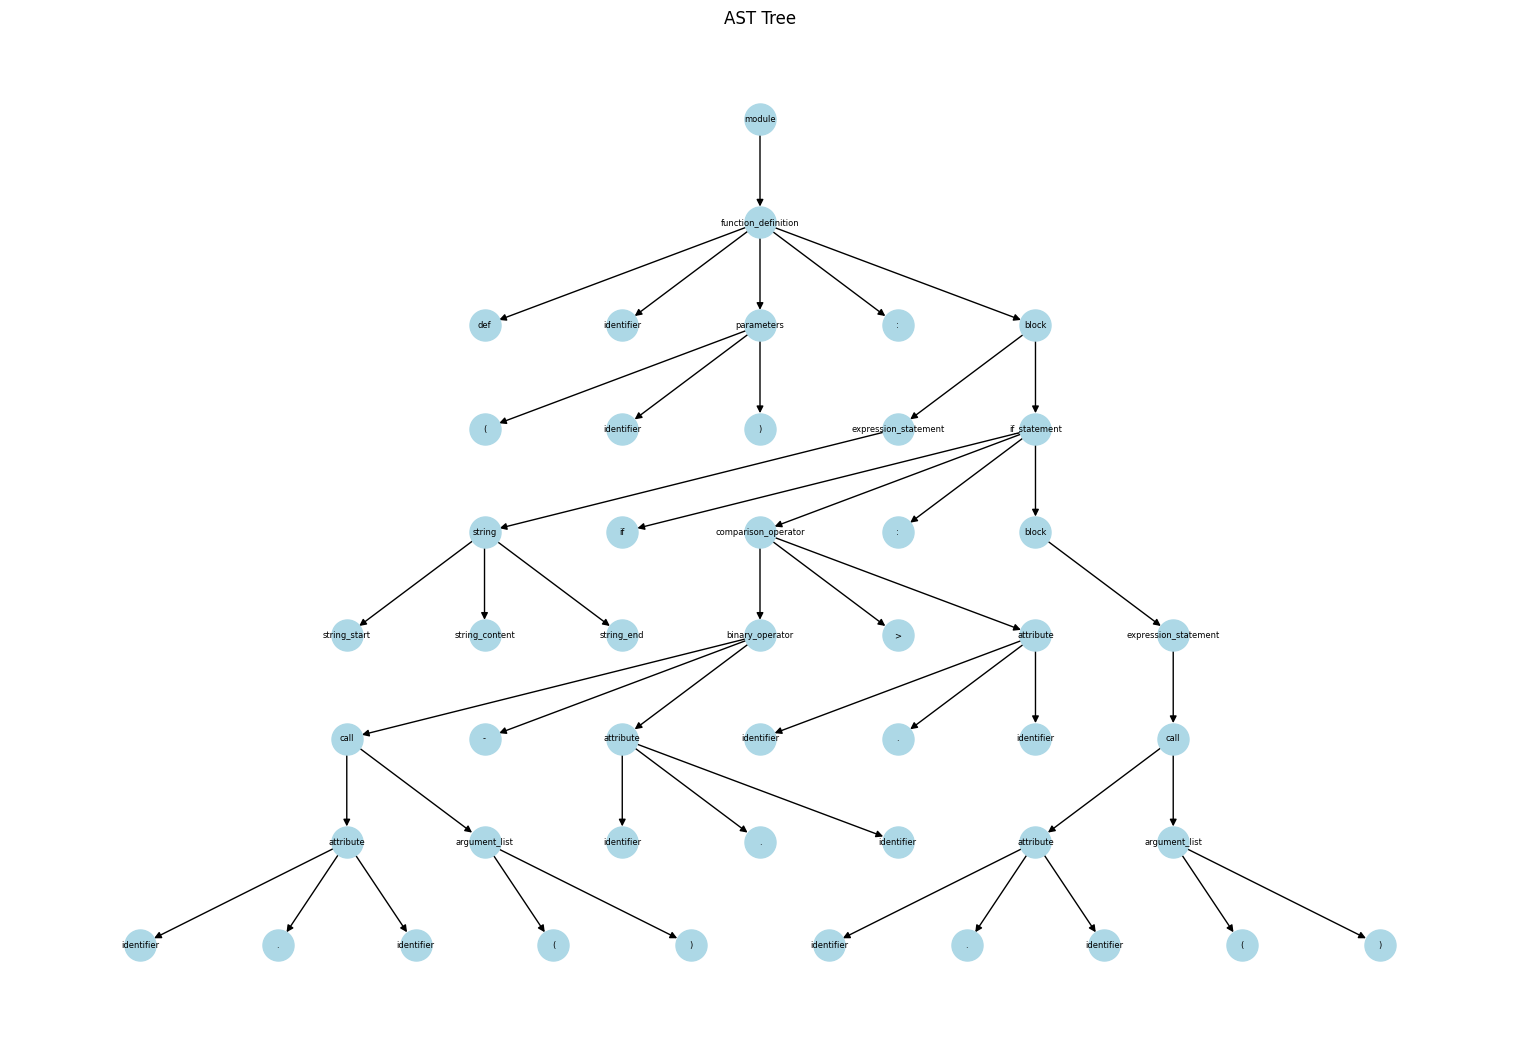

In [32]:
visualize_graph(train_graphs[1], show_labels=True)
